# Домашнее задание по АОТ. Подготовил Бахарев Никита Сергеевич bakharev.ns@phystech.edu

## Пункт 1

По данным поиска Яндекса на осень 2009, в Рунете — около 15 миллионов сайтов. Это около 6,5% от всего интернета.
https://yandex.ru/company/researches/2009/ya_content_09/#toc3-1

На момент января 2023 года всего в мире 1,132,268,801 сайтов, среди них 202,900,724 активных. https://siteefy.com/how-many-websites-are-there/

Если предположить, что процент русскоязычных сайтов не поменялся, то получим **73,597,472** русскоязычных сайтов, среди которых **13,188,547** активных.

Можно попробовать оценить актуальный процент русскоязычных сайтов. 

Согласно https://w3techs.com/technologies/overview/content_language получаем 5.1% русскоязычных сайтов. Данные получены путем анализа открытых списков топа самых популярных сайтов https://tranco-list.eu/, https://developer.chrome.com/docs/crux/. Tranco содержит миллион сайтов.

Получаем **57,745,708** русскоязычных сайтов, среди них **10,347,936** активных.

Критика такого подхода: в топе самых популярных сайтов получаем не такое распределение, как по всему интернету. Доминирующий по популярности язык скорее всего получит больше мест в топе, чем должен по соотношению по всему интернету. 


## Пункт 2

4% сайтов индексировано гуглом https://eu.tennessean.com/story/money/tech/2014/05/02/jj-rosen-popular-search-engines-skim-surface/8636081/#:~:text=Google's%20index%20represents%20only%20an,is%20currently%20available%20through%20Google.

Не понимаю, как можно оценить надежность таких данных.
Если бы мы имели доступ к большому списку разных сайтов (в том числе неиндексированных), мы бы могли оценить по нему процент индексированных. Но если бы этот список можно было найти через поиск, все сайты бы быстро были проиндексированы поисковыми машинами.

## Пункт 3

Можно искать большие источники текстов и оценивать по ним языковые статистики.

Например, есть готовые корпусы текстов, википедия, livejournal, новостные сайты. Возможно, можно написать робота, обходящего фиксированный список telegram каналов и собирающего с них информацию. Выбор корпуса зависит от задачи.

Еще можно использовать знания о языке и "здравый смысл" при оценке достоверности статистики.

## Пункт 4

Распарсим часть статей livejournal и подсчитаем частотность "ноль" и "нуль".

Обойдем всех авторов. Их 3152, если выставить страну Россия.

In [28]:
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import numpy as np
import asyncio
import aiohttp
import requests
import matplotlib.pyplot as plt
from IPython import display
from base64 import b64decode

In [46]:
PAGES_COUNT = 3152
ARTICLES_PER_JOURNAL = 10
ALL_JOUNRALS_URL = 'https://www.livejournal.com/ratings/users/authority/?country=ru'
SLEEP_SECONDS = 20

async def get_soup(url, session):
    BEAUTIFUL_SOUP_OPTIONS = 'html.parser'
    OK_STATUS = 200
    OK_ERROR_STATUSES = [404, 500, 403]
    try:
        async with session.get(url) as response:
            text = await response.content.read()
            status = response.status
    except (asyncio.TimeoutError, ConnectionRefusedError, requests.exceptions.TooManyRedirects, 
            aiohttp.client_exceptions.ClientConnectorError) as error:
        print(f'ERROR {error} {url}')
        return BeautifulSoup('<body></body>', BEAUTIFUL_SOUP_OPTIONS)
    
    if status != OK_STATUS:
        print(f'ERROR {status} {url}')
        assert status in OK_ERROR_STATUSES
    return BeautifulSoup(text, BEAUTIFUL_SOUP_OPTIONS)

Возьмем все формы слов "ноль" и "нуль". Будем считать вхождение этих подстрок в тексте, если символы слева и справа от вхождения не являются буквами. Например, ",нули " считается за вхождение, а "развернулись" нет. Для этого напишем соответствующее регулярное выражение.

In [36]:
NOL_FORMS = ['ноль', 'ноля', 'нолю', 'нолём', 'нолем', 'ноле', 'ноли', 'нолей', 'нолям','нолями', 'нолях']
NUL_FORMS = [form.replace('о', 'у') for form in NOL_FORMS]

def word_regular_expression(word):
    return re.compile(f'[^а-я:]{word}[^а-я:]')

NOL_REGEX = [word_regular_expression(item) for item in NOL_FORMS]
NUL_REGEX = [word_regular_expression(item) for item in NUL_FORMS]

Избавимся от заглавных букв через `.lower()` и добавим вспомогательные символы в начало и конец текста.

In [24]:
async def count_words(text, regex_forms: list):
    # we add extra symbols for correct work of regular expression
    text = '#' + text + '#'
    result = 0
    for form in regex_forms:
        result += len(re.findall(form, text))
    return result
    

async def handle_article(url, session):
    #print(url)
    text = (await get_soup(url, session)).get_text().lower()
    nol_result = await count_words(text, NOL_REGEX)
    nul_result = await count_words(text, NUL_REGEX)
    if nol_result > 0 or nul_result > 0:
        print(f'{nol_result} and {nul_result} entries', url)
    return nol_result, nul_result

def get_sum_of_tuples(tuples: list[tuple]):
    return np.array([item[0] for item in tuples]).sum(), np.array([item[1] for item in tuples]).sum()
    

async def parse_journal(journal_link, session):
    if not journal_link.endswith('/'):
        journal_link += '/'
    ARTICLE_URL_PATTERN = f'{journal_link}[0-9]+.html'
    REGEX_ARTICLE_URL_PATTERN = re.compile(ARTICLE_URL_PATTERN.replace('.', '[.]') + '$')
    
    journal_articles_count = 0
    first_previous_result = ''
    ARTICLES_PER_PAGE = 10
    nol_words = 0
    nul_words = 0
    i = -1
    while True:
        i += 1
        if journal_articles_count >= ARTICLES_PER_JOURNAL:
            break
        soup = await get_soup(journal_link + f'?skip={i * ARTICLES_PER_PAGE}', session)
        urls = [item.get('href') for item in soup.find_all('a')]
        article_urls = list(set(filter(lambda url: url and REGEX_ARTICLE_URL_PATTERN.match(url), urls)))
        
        if not article_urls or article_urls[0] == first_previous_result:
            break
        first_previous_result = article_urls[0]
        
        if journal_articles_count + len(article_urls) > ARTICLES_PER_JOURNAL:
            articles_urls = article_urls[:ARTICLES_PER_JOURNAL - journal_articles_count]
            
        journal_articles_count += len(article_urls)
        
        articles = []
        
        for url in article_urls:
            articles.append(handle_article(url, session))
                
        sums1, sums2 = get_sum_of_tuples(await asyncio.gather(*articles))
            
        nol_words += sums1
        nul_words += sums2
        
    
    return nol_words, nul_words

Мы обходим топ по популярности авторов, потом берем последние 10 их статей и считаем по ним вхождения.

Фукнция `parse_all_pages` обходим все страницы топа авторов в отрезке \[`first_page`, `last_page`\]. Она запускалась несколько раз на разных машинах, чтобы ускорить процесс. Размер отрезка страниц был фиксированным - 60 страниц.

In [38]:
async def parse_page(index, session):
    soup = await get_soup(ALL_JOUNRALS_URL + f'&page={index}', session)
    # we may need to filter i-ljuser-username class if displaying settings are different on livejournal 
    a_tags = soup.find_all('a', {'class': 'rating-journals-item-user-link'})

    journals = []
    for a in a_tags:
        journals.append(parse_journal(a.get('href'), session))

    return await asyncio.gather(*journals)
    

async def parse_all_pages(first_page, last_page):
    result = []
    STEP = 5
    async with aiohttp.ClientSession() as session:
        for i in tqdm(range(first_page, last_page + 1, STEP)):
            pages = []
            for j in range(i, min(last_page + 1, i + STEP)):
                pages.append(parse_page(j, session))
            pages_results = await asyncio.gather(*pages)
            for page in pages_results:
                result += page
            #print('result:', result)
            print(f'{i} step result:', get_sum_of_tuples(result))
            
            # livejournal may ban us for spamming get requests 
            time.sleep(SLEEP_SECONDS)
        
    return result

Результаты всех запусков (порядок отрезков страниц сохранен). Первое число - вхождение слова "ноль", второе - "нуль".

In [9]:
result = [(158, 191), (281, 354), (368, 619), (308, 488), (322, 487), (103, 184), (273, 542), (115, 148), 
          (219, 308), (277, 317), (298, 402), (220, 290), (149, 205), (138, 239), (115, 132), (73, 127), 
          (199, 477), (245, 204), (150, 153), (185, 151), (97, 126), (29, 90), (8, 8), (4, 3), (8, 5), 
          (7, 19), (11, 1), (8, 6), (12, 10), (37, 32), (17, 28), (12, 25), (52, 49), (40, 21), (42, 78), 
          (32, 88), (41, 124), (23, 35), (15, 11), (6, 4), (25, 22), (31, 18), (15, 16), (7, 6), (9, 34), 
          (10, 23), (2, 23), (14, 26), (10, 17), (9, 2), (9, 18), (2, 10), (25, 30)]

Во второй половине топа было много заблокированных авторов.

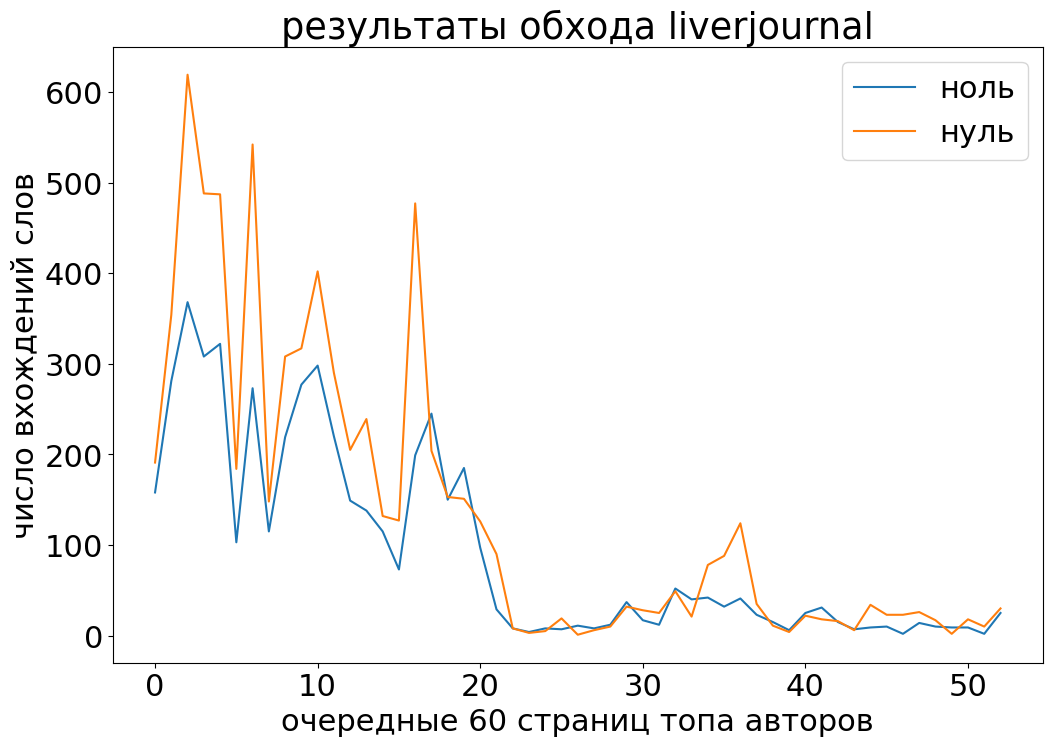

In [22]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 22})
plt.plot(result)
plt.xlabel('очередные 60 страниц топа авторов')
plt.ylabel('число вхождений слов')
plt.legend(['ноль', 'нуль'])
plt.title('результаты обхода liverjournal');

In [26]:
nol_result, nul_result = get_sum_of_tuples(result)
print(f'Нолей: {nol_result}')
print(f'Нулей: {nul_result}')
print(f'Соотношение нолей к нулям: {nol_result / nul_result}')
print(f'Соотношение нулей к нолям: {nul_result / nol_result}')

Нолей: 4865
Нулей: 7026
Соотношение нолей к нулям: 0.692428124110447
Соотношение нулей к нолям: 1.4441932168550873


### Позже я узнал, что можно просто сделать запрос https://www.livejournal.com/rsearch?q=%D0%BD%D1%83%D0%BB%D1%8C&sort=_score&searchArea=post

Результаты за всё время:

In [37]:
nol_result, nul_result = 637684, 880927
print(f'Соотношение нолей к нулям: {nol_result / nul_result}')
print(f'Соотношение нулей к нолям: {nul_result / nol_result}')

Соотношение нолей к нулям: 0.7238783690362539
Соотношение нулей к нолям: 1.3814475508245463


За 2019 год:

In [54]:
nol_result, nul_result = 12769, 21244
print(f'Соотношение нолей к нулям: {nol_result / nul_result}')
print(f'Соотношение нулей к нолям: {nul_result / nol_result}')

Соотношение нолей к нулям: 0.601063829787234
Соотношение нулей к нолям: 1.663716814159292


### Теперь данными НКРЯ за 2019 год

In [45]:
base64_nkrya_image = 'iVBORw0KGgoAAAANSUhEUgAABLsAAALZCAYAAABf6iOQAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAT0TSURBVHgB7N0NfJP1vf//t7OaIloE1yqOMJB2oq06C3KkPXps1R2KnNHKESr+pLrNqhvFO8DfBDz/A+h+3HgDdVPqNql7qBWHhU0pv6llv3kKzlF2HMW7VuFQJtIq0CjYSFn/1zfpBWmbpOkdbZLX00dMSa5c15XrupJceefz/X5ParYIAAAAAAAAiADfEAAAAAAAABAhCLsAAAAAAAAQMQi7AAAAAAAAEDEIuwAAAAAAABAxCLsAAAAAAAAQMQi7AAAAAAAAEDEIuwAAAAAAABAxCLsAAAAAAAAQMWIEAL3g0Ucf9Vy/9dZb2rJli4YNGyan0+m5Hj9+vG644QYBAAAAANDTTmq2CAB6iAm5XnrpJc/fJtAywZa57NmzR7W1tZ5rc7/529x/7733CgAAAACAnkLYBaDHTJ061XNtAi9TwRWMCb3MdKbqy1wAAAAAAOgJhF0AeoQJukzAZTdfDJVdCUbgBQAAAADoCeHXZ5e7VuXPrlJJWYW2flCr+sNSXLxTScljlTl9lm6/1imHAJxIXQ26DLsZo2nqSOAFAAAAAOiu8Krsqi3TnNsKVLJDcl6Wpcx/StLwQdLB3VXa/OZW6aYXte6OJAE4cUxVlrmsWbMm4P0mxLI7p7/88ss9f7dlAjPThxcd1wMAAAAAuiN8wq6mKq2ckq1lO5zKXlKk5VOS2ldwNYnxJYETzFRkmYouc92W3YeXCbBM0PXYY495pvv3f//3doGX6cPLTEd1FwAAAACgO76hMOF6daVW/U1Kua3Qf9Bl+AZdTeUqSHZ6vlC3umQsVWWTz3T7K1X8YJ6yxicrMTFZqRm5KlhRpupDrec155I280lMVOoV2cpbWKIqn2ndH5Rp5f15yp6QptTRiUq8JE3ZM1eqfK+CPTuV3GpNO61ItW3uqX4iW4nW8trd95dFShvZ/vkl319+bJLap6zHjs7XukOt5+nevEgZ5rF+7mszpao3rtSc6RlKvcRav+RUZVyXp6Vvuo6v+Y51WnRnttLM/aNTlTY5X4vWVMnlM4+ymYlyjp+viqY2s68vUV6iU1krqltvDTPP27KOzTNj+nwVb2uZY02RshP97NeWS+Kd66wlWvZXqWT5HOVNzjg+n2lzVPyX42tm79fUByraP3XPchKV+0xtq2kzllS1mbDW2nfJnmX73ufaVqz5ZruNbrOOI1M1500FZZ7/0pnZyki1jsnRyUq7Jlv5T1d6n1fLuoR0bDfVq+KpOcq9JlXJ1rGYPC5DufcXqbzW7bs0z7HXeh2taVMzlH3nUpXtcgddV1O1ZY+22JYZbdFcTMWXPSqj+TtQBZgJw8zy7ZEcAQAAAADoijCpg3Kr4rUKuU4eq9wZKaH1yeWqk8vtUMqtizUrbZD1xb9BFU9aoclhn2n2l2v+1HwV709R9vS5yhvukOv9cr3wZL6yNy/Qi8/mK8VnYXEZBVo+/aKWVWpQbeU6PfXMHOU3ObVpYbpnvdzV5VZAEKe0SbfrlhEJ0p4NWlW4TPn7B2nT83lyqhOswGXBk1bIYe2lds/5YJ0alKjshXM1cahZ8HYV31+o7R3N012pFQuLVaMOJ1TVU3matmSrHONylDvzFp3t3qfq92t19pA47xTblmrGzYWqdmYpb+ZiDR/k1u4/lVjrka3N1cV6cV664tQ57m0rrXku0+6UPN3x4Cw5j9aqvOQpzb+5Sg1rXtSsERma87jTG6YdrtCqB4q1O2OOHpzcEoCePdZ77a5S+aY6JVx5o7J+4NQgd7VKn1yp+bc3aNDrVpA1RD2ifu0iLf2jq/UraW+JCm6dr61Ds3X7g3cpaUjL3nunWAVPfRh0fu6/LNU0s03jM5WbZz32tEbtq7HCw0EJx4+BUI5t1Wvd3ZNVsFFKn3qL5uZbx2JdlcqeW6q8TVu1bE2Rckf4TD4sSwvm5chpnkeTWw27KlT8dKEK7ojVuldmKSXAO4WpwvIXdNkCBVuB3HPPPZ7qL5oyAgAAAAC6KjzCrqZqVddYgYIzWSnxIT5mvwmDHEpMy1HWBBMTuKywZL4VkByfpPLJRSrelaQCK0SZm2pHCbnKTS3QhIKlWvx8lkpuPR5POYalW/NKPz6D61J08O0sFdXUWHNPl1m1uEnLVDbJd0Wy5GyoUvbT5arYn6fckEOWWpUsXKGtQ6z1GVOq0jYFNvX1LrlPHq70yVnKMvNskjY80PFcq55epCLrOedOdah0fZAJ95ZqWWGFdNUyrX861xuCtFKt4sVFqrTWr3jNMmXaqdbUXKUnTFDuM4v1VHaZ5iarE6znvGSlqpwFVtA4V2NadknWNU41XpOvVU+U6ZYns5U+qaVftkNulT5YrIYR6cqeNKb1rIbmqujVXJ8bspQZX6vxP9igN952K3tCDwxjsL9MC5eXSdfkKquqVHZ9muvNMlW4UpT/fKFm+T5/R7kcQcOuaq2ytmnV4GwVvVyorEDHegjHtvu1pVr4ap3S7y9TiU8/dnmTU5Q3aY4WLV+niU9kHw8jByYqbUKWT6iVLecnbyj35WrVHlXQsMvuYL4tf/1y2U0U/d0HAAAAAEBPCJNmjG41HLKygtMGKS7UeG5vnXYrQQkJAUKNpiq9salGjotzdGNq62niJtyirGFubX2tXPWtVsMll6vlUl+typeLtWlXnMZmpClYBjfcOdyKJhqsxylknoqhNwcpZ94spQ9sf/++T+qsgMJ6fp0pnaop0uInq+S8eb7yE2ODTurabIVzh+M0cXqOn6DLUrtZ5X9zK3FC7vGgy8OhdOsxY1SlTa9XqVP2lqus0q2kayYqpckt96GWi2Os0lMccv33Vm1vUpc5znXq7JPd1n5okxxa+7V+v7VPfS+ugwregM+l8iWLtO5wpubOy9Ign4ndZh1PdujMzuZptZu0eYe1TSfdEjjoMjo6ti1bN72heocVAk5tM2CDM0e5GXFyWfdXtGrCar3G7GN7f72q3yxW8ZsuxV+RrrE9NLypHYwFq/YyIZhp+ggAAAAAQFeFSTNGhxxW4OM+bAVGIXZCX299YXbpbA0fGmiKOtXuteac4rRigzZihitppEPunbu121qenTvUr8lXsu/3dIdTmXc/q8LbjgcKpr+l1b8uVfm27aquc8l9VJ5mYW4r/lGoQY2pGFpSJl1XqLkTBqlibdsJ3Krds9vT9Cz0+piWSrGEXBUXpCv2xcKgU+/bawUOJyfJOTJA0vGptW2OOqzt5Gf0S2eSJyAr32kFckqRw2HN47Dbuy18990hV+tAaY+Zp7WmK7KUuMLPMuMaOgigfOyvVMmTq7Vuc6U+3GMdN263dz+4HcpsM6nZr6l+8xcruAswe/fmFVq0tkHp8xYrd5gVfPrcFz8uXSkxi7R6SZESZ+do7NCWbXioUUF9uq9lmw4POlnHx7bLOj6sZDU+UUlx7Z9TYqIVvr5Sq2rr+M9KbLn5gyLlXlLUerrJC/TsI7kKtZgyGHvExo46nzf9dpmO6gEAAAAA6KrwCLus8Ok7JnR5bYeq6qUxQzt+yO6aarmHZCox4Dd1K/w4GmQGfkK1uAkLVHRrS7s0txUoVJZq1RMzNK2uUC8uzJTjbys1Y+oyVY/K1V13F2pMYoLiHKZz/TmaFjxbamFN3NRSMeTO1LJ52VbQ4K8cbLeqq631H56k4SHuwWOVYkVzlR5noi8TvHS2Ry1/gsRPJ3uvLvqnsYp7eYOKnspW0vSLFHtot7a/VqyVT5ao0m3isBZHzP8cGjOzSAsyB/mZX4KSQnm+rgrNn5rn6Ystr2CBCsYkKuE06/adxcrPL2k3edw11n69rU17yz3rNP/+Uv/zb+n3rPbiuSq62cSNrTvYV2KeCpfs05zlS5V3zaLW98UEiY6O2H8EL6UK6dgO5qh3iljfbTkiW8uW5LaEp265PqhQcdEiTbuxQc/+ZpbGDPQ/K7sSy4RUwZgAK1jfXraO+gADAAAAAKAjYVLZFaf0K9LleKVCpWurlTczqYPpa1X533VyjE7RdwI+Q6ecI6yv9TurregoS63m2PShqmvdcjiHe8OkloosR3yy0tN8an0yMpWwd7zy1pSofHam4n+7WpVN6Vrw1DLl+5Rc1Z6m0FjhUOMWn4qhQKHefiv0+8gKibISQ+is3yGHb6XYtaEFXGcPtZ7A0a2q3WnFIol+ljLM2jYnu1Vds1tqW/uzq1o11jYbPty7EeKvX6yHNs/Q7OW5SlvunSTu/CwriMqXHio6Hs04z/bMc7d7kMZcNkZd5f5TiUo/cihr+bNaPMXn+br8by3H0Db71ajZoUEnt5tSsbGm435vv2ez1uR5w7em9tM5J8/VnOrN2vqUlPvIfG+zxL8VKX9JkCEEzj1bCeb57zThWaDnH8qxHS/nMOt5v12jaisrHdOqnzi3anZa+8yRKafvbnM4leKpSGv5d1qmFYrWKnX2apW8bYVdGf6XFGol1uWXXx5SiGXm1VFwBgAAAABAMGHSZ5f19X1yvnJHuFX5xCwt2lQffOLaMpX/zQqDrkgP3AQrJkUTr0mxAohSlfyldSWMa6MVluxxaOy1mZ1qwmX6lzKVO85W7SLrVfFmdYjN76pV/JCpGLpLi24O3EDRtWmDKtxOpaV1FPpZHG5VPLJI65qyNNdTKRaauHGmr6Z6bXi+VLX+ml8OzVTWOIe1qUtUtt/3Dmt5L5aq6miKMjJa1i/GqezHN2nH2+Vat36dyt7coW2vF2nupCS1qt9yZijzYmuer6zSur3qMvdh0zxykBKGtg72qjdX+n8uneD4pFTzPf2eLdbtFweOGs2oivOfqlbSbYu1YHK6J0xLPz8h+MyHpSnTChZrXmm7TX2EcmxbxmZNlNNdoZI1barOaktUssmluCuv9tsXXCtHW47aIJG4CbBM88SO2M0YQ5mOyi4AAAAAQHeESWWXZWC6FqyYo5ofLVPRD65S+fhMZaYm6ezTpcbP61S9o0oJd76ou4ZuVemS1aqwpl82KXiPVin585X3ep6Kbp8mV16O0oc51FBTrtXPlsl96RzNn9768e49lSrf1BIA2M0Y19crflKOp5N2txVoxL1crlVL1ilh+hjFuaq06dmVeqF2kELp49u9pVjFjhTNsSuG2mqylvm3DVr5RLm1fnOVkxrCTF1lKl4fp/SFCwJXivnjzNWcO0s14/H5mjajSrnXpihBLu1+f6vcGcu1YIJTufNmqWz6Ms2e3qDt0zL1nTi3dr9ZYm2TWqXcWqw7Lm49S8fQpA6aoCYpb/4sbbjZmuf1uarIzbKmd8jdYO3fbeWqGbVAJbM7rvgyQV2Ko1wbnlqpzNOzlORwqWrjKq38fYMSunXEW2HrmmJpRJ5K7h4TeJ+6KrRobrGqE/P1YrDp2rIC2Fvm5arU2nYFUxuU9+/pnj636nZuVZVjipZnnxLyse244i4tuL5cBcvzlLv7FmWPsYK2/dtV9myxyk/O1LL7s1s3Yj1Uq8pN5arzVKq5VfdRhdb9utx6rvnKDnKc2WFXR80PQ6n+MvMwTSJvuOEGAQAAAADQVeETdlkcqbNU8n/TVfzkKpX9qUIlT62T66hDcfFOJY3J1NUJVXrqNiu8OpSi/CWLOw534qwA7fkXlfTEKhX/dqlK97qtQCZF6TMKVTQz2wpJWk/u2rRMeZta/hFjLXeYd9o592V5g4MpD6lo70Ite26epj1jzeucJKXnztGzM2tUMGmDOtTkUMqPglQM7SmxQpCl2n1+jhYvzVMIdV2eJnaOy+7SohtD78rey6Exdz2rF4eu0MoSKwBcUqJ60zzvwkzdfpN3/RzJs1S8ZrhWFK5WWeF8FR12KGHUWOU+tFh3mbBPnWf28YsvJ2lVUbFKn7P2Sb0VLg5OUIq1f3PSQnrGnoCmsPCgFj2yWvmTl1n72amUa27R4hdu1xs3TtMOdYcV8j0wN0hVlEvlD81RcW2SCtbcpTGdHMkw7orFWvNCklb8okRlTy5S8SHrthFjdXX+QevYnh36sa14ZS1Zr+KUFSp6cbUWvVwn92lOjb3S2md3367MEW0mN32U/WCd92/r2HYMtrZZWoEKZ98VtALMNDk04dRjjz0WNOwKNgKjzczDjNYIAAAAAEB3nNRsEQB0kanaMiGV6Zerq2GVeZyZTyihGAAAAAAAwYRNn10A+idT3fXoo4/qrbfe8lx3FkEXAAAAAKAnUdkFoEfYFV5208aOOpq3pzcIugAAAAAAPYWwC0CPMQGW6WjeVHg5nU5P6GXCLxN82Z3Um/vti7mffroAAAAAAD2JsAtAj7NDL3Ox/zahl2GCL/M3IRcAAAAAoDcQdgEAAAAAACBi0EE9AAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIkaMAAAAIsSjjz7quX7rrbe0ZcsWDRs2TE6n03M9fvx43XDDDepJbZdn9PYyAQAAENxJzRYBAACEMRM6vfTSS56/TbhkQiZz2bNnj2praz3X5n7zt7n/3nvvVXcEWp7RW8sEAABAaAi7AABAWJs6darn2gRQppoqGBNAmelMFZZdidWby+upZQIAACB0hF0AACBsmeDJBE52c8JQ2ZVZnQ2furq87iwTAAAAnUOfXQAAICx1J3iymxSapoehhk/dWV5XlwkAAIDOYzRGAAAQduz+sroaPBkmfDIdydvz6u7yzDRmnnY/Xd1dJgAAALqGZowAACDsmOooEzzZndCvWbPGcx0qu1N58xjzd0eVVr7L88dUfZn5mMove2TGRx55xBNstRXqMgEAANA1NGMEAABhxVRF+Y5+aIKjzlZKmQor83gTTtmVVmY+oSyvLRNa2SMuGmY6828TevkLu0JZJgAAALqOZowAACCsmHDJN3gywZEJkEx1lwmxzN9231q+/zZ/+xtB8Z577gkalrVdXlv2sn3Z6xRIR8sEAABA11HZBQAAwooJn+zO3n21va1t/1ptA6nuLs/WtnrLVHWZZQfqtwsAAAC9i8ouAAAQEUyllOk7y+67ywRU5t8287fvv20mrOqpYMrM57777uswWOvJZQIAAKA1KrsAAEBEMP1f+faBFWpll2lu2JnO7YN57LHHPE0UgzV77OllAgAAoDUquwAAQFgJVBVlKrnMxYRIdhWXfbFvaxuAGR31yRVqFZaZpqN5hbpMAAAAdB2VXQAAIKy0rYqy/+3br5a/UMu+zUzr23l82393tLxATCgWar9gHS0TAAAAXUfYBQAAwoqpiDL9c9lNFs21v3ArGN/mjr7zCmV5gZjKLtOMMZR1CWV+AAAA6BrCLgAAEFbs8MluCmhfusLMw4RUoYRdHTU9DLUPrlCWCQAAgK47qdkiAACAMGLCJ3MJtdlgIKYfr7Yd2/fm8jqzTAAAAHQNHdQDAICwY1dYdbb5oi+7j69QQqeeWF5nlwkAAICuIewCAABhx3TuboKnt956q0sBlD1qY6iVWt1dXleWCQAAgK6hGSMAAAhb9iiMJowy1VId9d3lO2pjV0Knzi7P9zFdXSYAAAA6h7ALAACENRMmmU7fTcWV0+n0hFAmjDJBlN1pvLnfvpj77fCpp5dn39/TywQAAEDoCLsAAEBEsEMoc7H/NiGUYYIo83dPBk7+lmf05jIBAADQMcIuAAAAAAAARAw6qAcAAAAAAEDEIOwCAAAAAABAxCDsAgAAAAAAQMSIEQAAAAAgKDMQxZo1a/TYY4+pv7NHiDUXMxpsf8D2A3AiEXYBAAAAQBBmtFUzsqoJPmpra9Xf2SPEvvTSS5717etRYdl+AE60sBuN0bzhmIs9vDcAAEB/Z6oEnE6nLr/88hP6pcmupHjrrbc862DOn0ylgn1tmC+f9t8A2rODmkcffTTsXivmPcCs+z333NNn6872A9AXwibsst9oTLIejm+UAAAgepnzGHMOY5rvmGvzw50Jn3prWXbAZcI1uymOv+kMM61ZHxN6Ub0AtGdeF+HcnM0uFDDfofoC2w9AXwibsGvq1Kmek0LeZAAAQLjyDaLMdW/M33yh7Gxw5dtkx5xr9VYQB4QjE9T0ZkDd2+z3hb5qGcP2A9AXwiLsspsu9sZJIQAAwIlkV6vboVRPMSFVd0M0O/SijxrgONMEORz6mQqmL58D2w9AX/iGwoA56WIUDAAAEAlMdYPp/8X8kNdTTAW80d0fBs262edchF0AACBchU3YRR9dAAAgUvRklYCp6Orpju/NvOg+AgAAhKuwCLtMST19RwAAgEhhzmvsDuK7w/wgaJou9kYVlpmn3awRAAAgnIRF2NWfnXTSSQIAAOgLZnTH3uzT1AReZhkAAADhhLALAAAgDJk+vzrbp2lnq8nsPrx6sn8xRJmmCs0f5/Q03fW9ZK2oVuQ6qC0/u07nDZ6ilxt9b/9U5YumKHXkYA2OH6oLvz9fG+yXZNNOvTzrap0XP0CDnam66cm/6thDPy3X/IkXavDgwRp60RQ9tOmgItnB//6VZn8/VUMHD9AAa1tM+dkWHXvGAbdTo3aWzteUy87T4DMGWNvpOs0v+7TlMdZ2f+xHuvqiodZ91ra/4GrNfmmnAEQ2wi4AAIAwZPrT6mzYZZokdja4Mv2m0ncXuidOWUvKVP56+bFL0c1JikiN7+lXMzL1k+1n6pyYNve9tlg/enmklv/lgA7sfU9PJG7QDxdu8IQ1n/5mpmZXZWpt9Vc6sGW+Bqz8oRa/ZR50UC8/8CNtGP2EdtYf0HuPjtTa/Nna8KUilBVavfmeYm9+Tu/VW9vitZ9IRda2+C/vvQG3U9Ne6/2tURMLN+vAFwe0eeFQvZx/n172bKcD+rTxUs0r3em5772Vl6p81mw9/5kARDDCLgAAgDBzIgfvMdVdZln03YWuc2iQM0VJ5ycduziHmNtdqnxmjrKvSFbi6GSlTZuj4m2uNo+tVdH1icerwkbnq8xt31Ws3OQ8ldT7WWR9ifKSc1UccBwI77JzM7zLTp1QoHU9MWZETKyGZi3XhqIpGtrmrsaDB/SV8wKlftNMd6ZSLx0pfWmiroMq//02jb/zPl16pvXPYdfrvunSy2us11zjZm3YNFI/vDdTZ1rh2ZnXztYPR76q5zY1qleYbZrYvhKv1XYPab91VawuLViuxTdc4Hm+saOnaMqle7WztoPtFDNS05cu1w8vP8czj5H/dr3Smj7VXhNoxVyg6T/9iTITYz1LOCdjotJi93rvAxCxCLsAAADCTFeaMHaH6buLsAs9rXZNgW4rqtPEh9dp02vrtPiKOq340WyV7PWZqKlOB11O5a+vVe2bCzTmZPWIerPsJ2uVdv+LKnvlRRXenasxQ9V9Vugy8cbM9lVdltismZp54BFNmfu8Nrz0kH74i0bNnjtRsU079W7tUI1Mij027cjRF2hvzbs6+NlO7dQFuuAc+55zdEHiAO18vxeb4cWka8Hr27RtW8vlxXwl+mz3kPZbT2ncps3vWQHhRbGeJowBt1Pbx1X9VdvOvFSpbcc4a/xUWx57ROVJUzQxUQAiWIwAAAAQdky1xYlkRn0Eek61yp6r0Hd+sEn5V3iPZefMxbrjzQwVr61W7syWZo7uWtXUn610E0S51UOq9YJZ9m2bNGuCd9lJJyL4OP1STf9xmp67d75m/uaAzsz5lZaPNsFNoxq/jNXg4xmOYmMHKLbR3N6or2JjNcBnNgNOj1XjF71U2WWc7FDckHjFx7f8e/8gxcouewtxv/WIgyp/cL7KM+Zrc4r1z6Yg28n3YY1/1SNzn9PIB8o13v6227RF8y+bqEeqrFgscboWP/NDXcA3YSCiRVxl13s/S9N595Yfv6GpXDNHXq1Halr+fXCLHplhTTN0sAaPTNWUReX6tNXjUzXAdFwYP1gDBgzQ1U9+6n++AAAAfcRUWZnmhSeKWVZtbU+08QJaNNWqeleCEpN9Q1unks9P0O6amuO51rvbVT0kWSnxAebjrtD8q5KVfEmyUsdnKPe+YlV21KLOWnZtu2X3voOlM3XdL87RE9s/1sfVmzW7abGuy3/Z+i4Sq9jTrVDLJ7FpbPxKjbHmdivossKcr3zm85X179gzzlSfCHW/dVuj/vrYTZpZNUXPPTpR3mcbZDsdW7+d+tWMm7R27BP61c3nHJ8wZrwW//WAvvrqK737iwtVfmOmHvpvAYhgUdaM8aBennWTnjvT+nWg9oAO/OXnuuAPP9IPnz5eBnywvlGZK3fqQP0BPXdDrAAAAPqbE9VfV18vE6j6f5vlHpeulEBVODFjNeuFjdr4yka9uGqukmuWanZhZUezVS/WRQW0+fevauSMmco0fXadfoGmP/wTjXxtrTZrpC4cuVc7q4+v1c7339PQxAt15jkX6AK9p/eO/Tr/qd57/yuNTOyJNpf9VaPee3KKbvp9mn71/H261P5KFhNkO5l/WEHX8z+Yol8NW66XH86U3zgwJlYjM36imy7dqfItnwpA5IqusKuxXGtfMx08TvS2o//meM3/8aXa/NKGluquRu399ICGfrOPfikBAAAIQV/0n0WfXehRMUlKGlWnmh2+FYO1qvmgTsMTE+Uw/3RXqvTVBmVOSvf+25+THUoY6u1EPeniLOVmJaluV62CF3dZ0w6zlv3Bia1WHJk0Uu+99qp2erKaRu38/Qa9N+xCK8w6UxNz0rTl6Uf0VzN64J6X9cjz1g/w/3aptZ3SdH3WXv1qZbkONlk/zG9arl9VZ2rKFX30o3wo+62bdj5zk6Y8e4GWP2sFXTHeppyNnm0WZDtZ3+Ze/vEULY+ZrecWWkHXly2PazJ3/VXlb+3UwZaM7OBbv9JzW4Zq/GXnCEDkisiwa6/1S4Bphui5DL1Ov/q0pfD34AHrTe5MDfV5X4s9Z6gGHzioveaNUDv1Xu1IjRwZYL5PT9FQ51DP5bxLr9Ps0l7sGBIAACCAUKus9uzZ0yPTdGaZQGicysnL1Ie/XqSizVY4tb9WFU8v0qrqdOVNTpKa3Kp+fqVKT8tWzmi3db9LLpc3rWjY79tYzi33IXNxqb6mXCV/qNbw8xMVF2zRVmCT8+9jtf3J+Vq5qdrTRLdqU7mq9qtXXVDwc80783ldd4H1XcJ5oa57YajmPXOfp++oM2/8uZ74brluGjlAgy+brwMzfqXFGSbQilXmwl9pSs1MXRA/QCN//J4m/uIRXf9N9ZEO9lt3NZXrkYUv6723HtF1zgEacIb3Mvj6X3k6oQ+4naqs62f+qr9aQdl5Z9iPG6zMZe95Kr42PHidZ/uZ2y64s1wXLF2r+WMFIIJFZLd8Q+9cq48fzfT+w/TZlfSQ9+8zB+vM2IPaacq4RnhvOvjpXh0YfIGGmi3x5Xt6d89ITRkRYL63HZ/vwddmKu3HjwgAAOBECzWgMtVY5vLoo4/6vX/q1Km65557Tmj/X4AtfnKhnj20SIvnTdDSWinh4om6/ZcLlGu6g9q8SHkLy1Vvnctnpxa2elzlFfnWwV2sXPMP02fXFYmab/3piHMq5dq7tDg/xbq9KuiynbcWqujQQi17IFsrP3Ur7sJcPbQ6UynqIbHXa2399a1vO/1S/bDoDf3Q7wPO0cSlb1gXP3d9c7zmvfyu5ql/CLrfuismU0/sbNYTAScIsJ1S5mnbkUBb6AIt/8P1Wi4A0SS6xqCIzdRN/zZb85du0E0rJ+qcL7do+S82K23Gcplir4O/X6stl2bqkdNDnF8MfXoBAIAT7/LLL/eEWB1VW91www2e63vvvbdd4GUHXaFUbL300ksCuiQmXYvf3hbgTodSpi9WiXXxa0S+1r22QGN8v7HUlyjvqjLv3848ldTkBZh3rop35CqweKXPLLQugi+zTXe02abnz1LZDt8bOthvANAPRFkH9Wdq4qNr9cPGxUpzDtbgi36i9773nH5120gdfOlHSnv4oH7y4E0K1Hr7WDPGoYN1waz3rF8UZgsAAOBEM0FVqAGUCbxMoGUCL9/Hhxp0GSZYs4MzAACA/i7iKrsu+Olmfex7g6cUNvP4v0+/VD/59Wb9pO0Db/il3m1zDnf9swd0vc98v/qp2qEhIwAAONE62+zQDqpMdZdpArlmzZpO9cFlHkOfXTihzkpS+jiH4tp+W3EkKPnKZCX0RE/oAICIFV3NGAEAACKECZ9MdVeoFVf2dCYo60xw1ZllAD3m/DwtW+Ln9rhMzX0yUwAABBNlzRgBAAAigx12hdpZvWE3aewMwi4AABBuCLsAAADCkKnQMs0Sffvi6ml2315ANDMBsem3Dl3D9gPQF8Ii7DInc5351fJEam5uFgAAQF8w50im6qrtSIs9wczTjPpIX12Idv35u0go+ro6k+0HoC+ERdjldDpVW1srAACASNCTX57MfMy5Uk8GXmZeb731Vq9WjQHhwg6UwzGwMetsXsd9Gdaw/QD0hbAIu8ybCydbAAAgUvR0pYA9L9PssDtfKM1jzTwMM2IjAG8zPDvwMK/dcGiSZ17LJmAy697Z0Vd7GtsPQF84qTlM2uGZEy9TSk/oBQAAwpk5lzFfpHojTPKtQuhsmGa+2JkvovYXPACtmZDGHhSivwc2dhNn81ruL69nth+AEylswi775M00Z+QkDAAAhBNzHmPOYR577DHPv3uzasr+Iml/mQw0AqNdAWbWxa4040dFAAAQCcIm7LLZfUgwogcAAAgXpkrA9Kt1oqvU7QoyO9gy50/2yGj2+pjqebN+AAAAkSLswi4AAAAAAAAgkLDooB4AAAAAAAAIBWEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAAAiRowAAAAixKOPPuq5fuutt7RlyxYNGzZMTqfTcz1+/HjdcMMN6klmGeZiL8/o7WUCAAAguJOaLQIAAAhjJuR66aWXPH+bcMmETOayZ88e1dbWeq7N/eZvc/+9996r7jDBlj0P3+UZ/pZppiX0AgAAODEIuwAAQFibOnWq59oEXqaaKhgTQJnp7Iqsri6vMwGWCbzMxaybXXkGAACA3kPYBQAAwpYJnroSItmVYJ0NvOxgbc2aNZ15mCdkM4+xwzYAAAD0HjqoBwAAYamrQZdhV2XZTQ9DXZ7R2aDLMOtpr293m1ACAAAgOMIuAAAQduz+ubpTJWVCJ9ORvD2vUJbXlaDLZgdeprqrq00oAQAA0DGaMQIAgLBjKrJM0NWZyix/TPBkKrw6Cp9MSHXPPfcEXZ7dLNJMc/nll3uCNH/szu0JvAAAAHpHjAAAAMKICZXajn5o94cVKrsJo6m2squ7AnU2b1d1BQu6TBhmHm8ub731lu677z498sgjfgMvMx9zux2MAQAAoGcRdgEAgLDSNiQyAVMoTRF9mcoqex6mYuuxxx4LGHaZ5QUbddHcb0ZntKcx8zX/NqFXoOouU/lF2AUAANA76LMLAACElbYhkQmUTIWWqe4yIZb52+643vff5m9zm/m7M0zFWLDH2Mv2Za9TIGb9TRgGAACAnkdlFwAAiAhtRzls23l9oM7lTTBlKrECMfcFqtCyH992erPsYPPsaJkAAADoOiq7AABAWAlUaWWaMtqjHRom/DL/tpm/ff9tM/MK1t9XR5VdvkyAZfrr6mjUxo6WCQAAgK6jsgsAAIQVOyhqG0DZHcTbQq3s6ury/DF9f3U0aiMAAAB6F5VdAAAgrARqAmgquczFBFN2FZd9sW9rG4AZHXUUH2qTQzNNqJ3OBxv9EQAAAN1DZRcAAAgrbZsA2v/27bPLX6hl39a2Squjqq1QR040oVhXq8cAAADQcwi7AABAWDGhk29llLn2F24F41tV1VGVlVmeXTUWjKnsMs0YQ1kXs0zT3BEAAAA9j7ALAACEFTvssqut7EtXmHmYkKqjsMtUbXVU3RVqh/Nm3e35AgAAoOed1GwRAABAGDGBkbl0t9mg6cerbcf2/pigy1R2mevuMsukE3sAAIDeQwf1AAAg7NhBUWebL/qymyWG0lG8WZ6ZrqOmjB0xQZc9PwAAAPQOwi4AABB2TIfyJuh66623uhR42aM2dqYyzARVZrldDbzsoItO7AEAAHoXYRcAAAhLvoFXqE0MTcBlQqfOBl328uzAy+43LBS+fX0RdAEAAPQ++uwCAABhzQRXJlAywZfpSN40N7QDKbvTeHO/femJ5oh2n2Gmc3szL7M8s2xzbZZpbjfLsgMxM00ozSUBAADQfYRdAAAgItihl7nYf5vwyTDBV3eaIAZijwppB1zm2g6+Lr/88mPhGwAAAE4cwi4AAAAAAABEDPrsAgAAAAAAQMQg7AIAAAAAAEDEIOwCAAAAAABAxCDsAgAAAAAAQMQg7AIAAAAAAEDEiFGYMUN828N8AwAAhINhw4bJ6XTq8ssv17333qsTZc+ePVqzZo3eeustzzqY86fx48cfuzZuuOGGY39H2/oAAIDIdFKzRWHAnByZk8Pa2lo9+uijnAQBAICwYc5jzDnMY4895rk2P9yZsKe3lmUHSiZcM+dM/s6bzHSGmdasjwmZeiOI62/rAwAAIl/YhF1Tp071nBSaoAsAACAc+QY/5ro35m9Cos4GReZxprrKhEzmXKungrj+tj4AACA6hEXYZTdd7I2TQgAAgBPJrla3Q6CeYkKh7oZodshkqs+6W1XV39YHAABEj7DooN6c5PTkySAAAEBfMVVK99xzj+eHvJ5iKuCN7v4waNbNPufqTrjU39YHAABEl7AJu+ijCwAARArTWb2pVuoJpoKqpzu+N/PqavcR/W19AABA9AmLsMuUsNNXAwAAiBTmvMbukL07zA+Cpqlgb1Q9mXnazQjDdX0AAEB0CouwCwAAAO2Z0R17s09TEzCZZYSqv60PAACIToRdAAAAYcj0+dXZPk07W01m95kVSv9iXVmfzurM+qB/cW0r1vxbs5R2SaKciclKzchWwdOVcgt9or5CS2dkKDnZ2hfX5GvlZpcAIJIQdgEAAIQh039VZ8Ml0wSws0GR6Tc1lL6yOlofs9xQwraOmiqGuj7oP1yvzdfk6StUNTRXC365TuWvPqvCmRN1kTNBDuHEc6ns/8zRpsTF2vLODv3xP5wqu3+Ryg+pz5iqzVBf12ZaBqwA0BHCLgAAgDBzIgfvMdVUZlnBAqhQ1sfcb/e7FYi5r6MAL5T1QT/irtCKhSWKvflpvfhwnrIuS1HS+WOUPiVf+ROc3knW5yvR6fQM3OC5JOapZL/34dVPZLW+74pFqmxqmffeci29M1sZ45KVODpVGbcuVUV9y301xcobn62l21pqxzbPV9qEparyPNalioVZSrtznepblp88vVj1x1a6ViW3Jss5Ol9lLQ9vu46Jl6Qp+75iVdkBUVO11i3MV3ZGqpITE5V6XYGKth2vlvIs47qVqvbdNn9ZpLTUOSpveT4VD6Qqa3nV8fv3l6lgvLWsVuvmUuUzBcoebz3nZGv6O1cef84h75OtKt88XLm3pSsuRoq74g7lOt9Q6ea+q7Mz7w2mv7+OAi/7PYTAG0BHCLsAAADCzIloMujLfMEMFi6Fsj72aIqBAi876DLTdBScdbQ+6Ecqy1RWn668/DFBq7gcyQVa984O7TCXbUXKHeK93bW/Uc7bSrRjh3X7k9mK831Q3CB9J2OWCtf8UdteK1TO4WLNf7LSe58VmC2f59S6+xapfH/rZdW/Mk9z/jRGy5ZkK97Purg2LtXKdxzt7vOso1kP67Ll+Vlyvr1Iy9a3JE0xZyo+eaLmPLVeW97epOX/VKOl/7m6dbjVKW5VPGGFd+74Vtutfu1s3faclLvKes6vP6s8R6kK5paoU3nX/lorzktU4rEnGK/EEbGq/Wi3+or9/hAs8LLfO3qzX0AAkSPiwq73fpam8+4tP35DU7lmjrxaj9RYvzrOvVAX3utzYtRo3ZeUqvlbzd8v66bBAzQgfrAGm+uRM72/sjRZt8dfp199KgAAgH7DVJecSOZLaDChrE+gwKszQVeo64P+wbWnVnXxiUoa3MGEJ8cqbkic9xJnxztu1dXV6WzncOs26/aBsa0Ds4FjlD01Uykj4hXnTFfONUmq21ktu54qftJDWnZNpebPW6faoy1z/KhYsx+qVe6KBUqP87Mehyq0YkmFUu68Rd852c86mvWwLvEJCRoU47uu8Uqfkq30853Wc3AqMztDzl1WqNSkrtmxSsvWna078tN9bqxV6XMVGnvnQ8q92HrOQ1OUO/NGDd9Spjc6k3Ydcqsx1qFYn5tiBzrk/rJve1ALFngRdAHorBhFkfEzblJsznMqf3i8Mq1398Y3X9aGM6do7XetOz87oIPDfqLyvy7X+PcfUlrOXgEAAPRHpqrJfDE8Ucyyamtr1RPr4xt42V9oOxt0dbQ+iBR1qrVCnPihCX7vde8q06rHi1X2zm41mFDJVSf3Jb5TxCl99krdMiNPBb8ersZD0sp7d0sFL2pWsv86s6pfLlPp0Lu0foI05/E2y3t3pbIvWWX9GO6W+7BDSbcW6tlJLYnZoWqte3yZVm+qUp3JjNwNqmvKbNUB/7HH26z5uBw5ftaiVsVLVsud96xyh63SimPTV6v6I5fKH7xKqQ+13HbUmkfTcNWZ6jV/ZWr+WMFWbKMVePnc1Oh2y3HWIPW1tu8Pdv9cBF0AOiuqwi6lTNdN51ytl99sVOa10ubSDTrn+ld1qdkKn36qA2cO1TnRtUUAAEAYOlH9dYW6zM6uj+8XWhNadSbo6uoy0TfihjoVV1+japc0ZkgnH9y0W9U7hytppJ9gqqlKK340W5uuLFTRK5lyDrQiomdyNWFTm+lcNdr+iUPOjDjV1VrXCbtVWbNbLjnVtrCrcVexFhe7dctv8uSMKW6/zPPzVPT0LRrumbZcKx8sUIFzo0puTVD5wjzN25Wrot8UKn2otb47liprem3Ax3u8s1LTHmy/mPr1S7WidqIKn0yRo83zabQSrZwl6zV3jE9dVoxDcR1VzvmKT1SiylRjBYnpQz1LVE1No5xpCeoPfN8fpk6d6rmNoAtAZ0Vkn117n5yiwaY5orkMNU0Qv2q5Z6Rumj5SG14qV2PjZr382jmacsMFnnsaa9/Vp86RGupvhk3lmn3pUA11WpeRFyptxs/11y8FAADQJ/qiv6qOOqjvChN02R1+9+T6oB9JzdTVp1Wo5DdV6nQjuY8qVaUUpYzwc199pbbtSVLODG/QZTTU7Wu9jKZqFd81TzWTluuhCVaQE+NU7tLFGvOnOZq9tm1lYIPKlqzQvknzdXuy/9VxnDxICS3Ha9IVebrlmkHa+nal3NZytr5Tp/Spt3iDLou7rl77mgI/3nM5u23cZgVY7s1a+niF0u+bq/SBbe621j9phEvVu6zIa2j88Ut8nByd+cE+ZqyyMvap5NcVclnr6Nr8lEp2pmviuP4zNqYdeF1++eUEXQC6JCLDrqF3rtWB+gPey95X9cNzBhy775yc6bp008va8NrLKndO0fWJ3tvf++/3dM5FF7Rqu35MTKaW/3Wv9tZal/de1U2fLdb839CJFwAA6BuhVjUFG/mwM9N0tMzOVln59tEVrNP6rq4P+pGBmZo1O127C/OV91CJyrdVq3pHlSpeW6cyn9EK23Or4sVS7UvL1Fh/GUxcguJPq9P2Km9nVa6/FWvlOt8Ay6WKJbO0Qndp5X1jjldxDc7UgkdzVbdkjlbuOB6Nud9fracq0zX37vQgHek3yn3IbV1cqv+gTKVv1ilpdKIVNJ2t4QkOVb+z3dtfWH2FVjz9hoI9u0Dz37f2KW0YepfmTvLXoViSbrzJ2pZPz9Gi9VWq3Vuv2h1WkPh8Rec6qLeeYfrs5craNV9XXZKo8fNqlPHwg8rqbOVdLzOBl3lvAICuiL7RGM+Zopsu26zlD5dr6A03aaS5remvWvu7RqVlXBD6fGIFAADQJ0INhkz1U7Avi6aJUE/0fdWZoKptZ/QdjdKI8OecXqQXH89WfOVKFUzPVOakbBU8XKKtdYFrvcrvH6+CzWP14N1Z8hf7aGCW5v5HpuqX/KtSx6Vp8vJ9yvnfuXK2dCpfv36e5mxM1EMr8pTUpurJcfEsFd7tUMldPiM11rt1UcHcoIGP+2+FyrLCrcTRyRo/dZGqkhdo2Y9SZDrLyrl/gca+M0dXpaYq7eZixd5mzStOnVbvOlu3z8tToFrH+KmFenp2inYUzlDGFeM14dbFKqvtQsfyQ8Zo1tObtG1HjXZsKtbcjFA7/AKA8HBSs0X9nCnzDfVEzIzGeF39Yn38aKb3BjMaY9JDGvnaG7qvpYqr8fc/0sjpe7X4PVP19Vc99L2b9OroxXr5F9frHDNBlbeD+sXvPaFMmdEYb9KG2DMVaz4omwZo6LX36Ve/+IkuPV0AAABd0pnzm7bsoCiU6qaXXnrJE3qZx5i/DRM2maDrnnvu6fQ8urM+wUZdNPfZnVJ31Nl9R+sDAACiW8SFXaE4+MIUpb4wUZt/90NvuAUAAHCCdef8xgRDdhPAUNjhkB0wmX+HGnQZJoQyIVWg6UNZn2BBl+80oQReHa0PAACIbtE39uCXW7R85V+V+cCvCLoAAEBY6qjyqS0TDBkmRDKBkunwuTNBkXlMsOlDWZ9QRl20mzSaYM5e566sDwAAiG5RVdlVfu+FmvKbRqXe+oSeWzqRsAsAAPSZ7p7f+DZJ7MxjTKDUmaAo1OV0ZX264kQtBwAAhK+o6qA+89F3daD+Y71B0AUAAMKcCaxM8NOZTt270vTPLCOUYKkr69MVoa4PAACIXtE3GiMAAEAE8B3FsLfYndiH4/oAAIDoFRbNGO1fCjvbPwUAAEB/1VPdNJhzJDOfng6Z7M7mOzvf/rY+QDQz7zORricHMgMQOcIi7OrM0NgAAAD9nT06YqijKYYyv54MmMx6vfXWW56O7CNhfQAAQHQJi2aMpl8GfsUDAACRoqf7nbLnZX4g7E6fWeaxZh5Gd4Kl/rY+AAAguoRFZZdhTnQuv/xyQi8AABDWzLmMCXF6I7wx8zXzN2FTZ8M0Uz1lQjhz3VPV9P1tfQAAQHQIm7DLPlkyJfGc9AAAgHBizmPMOcxjjz3m+XdvVimZZZkmkuZiBBqB0a64MutiV5r1xo+K/W19AABA5AubsMtm99lgnzABAAD0d2aQHdNR9ImuUrcryOwgyZw/maDJXNvrY6rnT9QgQP1tfQAAQGQKu7ALAAAAAAAACCQsOqgHAAAAAAAAQkHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiEHYBQAAAAAAgIhB2AUAAAAAAICIQdgFAAAAAACAiBGjMLJnzx6tWbNGjz32mNDasGHDNH78eM/lhhtuEAAAAAAAQDQKm7Bry5Ytuvfeez1BTm1trdCaCQLNNnrppZc828dsKwAAAAAAgGhzUrNF/ZwddD366KOeyiUEZkIvs63uuecethUAAAAAAIg6YdFnl6lWMgEO4U3HTHNGU/1mthkAAAAAAEC0CYuwy1R2EXSFzmwrs80AAAAAAACiTViEXaZpnqlYQmjMtjLbDAAAAAAAINqERdgFAAAAAAAAhIKwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAESNGkWBvsXKvmK8Kd9s7HMp+cocKJzkEAAAAAACAyBc5lV2ObBXV1Kp2p33ZoWXXEHIBAAAAAABEk8hqxniyvLVq9qWVelWsyFfWuGQlp6Yp++5iVbqO31v7yiLlXZOqxNHJSpu8VBX/b5EykhOtfyfKOdJ7nWyqx5pcKrk1S/OfXqn8CalKTk5V1p1FfueVfEmqMqbNV8kHLSVnTWUqSM1XmV2BdqhCizKcSrxzndybgyxvRrIKNgoAAAAAAAAdiJo+u2qfn62C/5eoxRt3aMfb6zUrrkQFD5bJk1HtWKmChTs05md/VE3VNq1fcavG/ssCbdpRo5q1+Uo5P1/rqmq0483FSjch2tFqlb4u3b5mm3ZsW688rVbB8gp5MqwPrHk9VKPMFVu0450tenZqg1b+ZKkq3e3XqeqXy1R2cqLizD/SgiwPAAAAAAAAIYmSsKteFRu3amzeHRozxPpnTLwy78zV8E0bVHFIqn69THUZ+br9Mit2inEofkS8gjeAdGjs5Bs1xqRUDqdyf5Alx+ZyVTVZ83qt3DOv3GSHZzrn5NuVHVOm0so2s9hVrMXrnJqbP1axAgAAAAAAQE+IkrDroOo+H6SE+LjjNw1JULwVgtW5ZN3XoEHnJqgzPXzFxfnMa/DZGuRyqcH6s66uToPOHnR8XjFna3hCg+r2+5R2NdVr3ZLVctw2V1nxUmOHS3Or7P5UpY4zlzRlTJ+vdTVuAQAAAAAAoLUoCbvOVMJZVuC016djLSuUqrfirgQrsxp01iA17GtQZ+Kj+gO+89qtOiv8GmT9mZCQoIZP6o7Pq2mfdtdZQdsQO/5yqGHTUq3Yl6P5U50hBmwOZS3Zpm1vm8smFf5TlRY+Xi7iLgAAAAAAgNaiJOyK19WT0lX13FOq3C9PZVX50yXanTFR6QOllIwMDXq9SMV/8wZYrppauYLOz62tv33G2ym9u1Ylz2yQ48pMpcRISRMmavifilW8w+2Zrnb9Kq1zZylrjP3YKq16pEqZP71dSd3pj8vBSJMAAAAAAABtRU335/FTl2tZ3TzNvy5Zuw8PUlLGLSpcmOXtHP7iu7Ty/kVacNd4Ld0rxZ1/u55eO0tjAm2dk+OUmRarVVPTVFHbqOFX3qHld6d7q7QS87Vs4UHNt+a1ol4aNPpqzXpqrtLNnU3WxV0j97hi3XVZZ8KqlmaMD3rnETtioh58NFPEXQAAAAAAAK2d1GxRP+d0OlVbW6v+waWSGeNVMX2HCieo3+pf2wwAAAAAAODEiJJmjAAAAAAAAIgGhF0AAAAAAACIGFHTZ1fPiVPuszuUKwAAAAAAAPQ3VHYBAAAAAAAgYhB2AQAAAAAAIGKERdg1fvx4bdmyRQAAAAAAAEAwYRF2DRs2THv27BFC89JLL+mGG24QAAAAAABAtAmLsMsEN48++iiBVwjMNrr33nsJuwAAAAAAQFQKm2aMdoBjqpZo0tieCblMIGi21Zo1azzXAAAAAAAA0eakZovChAm5TNhlgh0Cr9ZMU08TBpqQi6ALAAAAAABEq7AKuwAAAAAAAIBgwqIZIwAAAAAAABAKwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAAAAAARAzCLgAAAAAAAEQMwi4AAAAAAABEDMIuAAAiSX2Fip8oUvkuAQAAAFGJsAsAgEiyt0KrH1mhsp0CAAAAolL4hF2b5yttpFNOZ8tlZKKSx2cod+ZSrdvhEoBeUF+mgvGJylpeJbcAoGfVr81XanK2Vu7gHQYIyf5KFd2apsTEbBXV+JvApcrfLFL+5DQlj05UYnKqMqbPUdGb9e2mdO8q09I7s5R2iTXdaO90xX9xdXm6PtNUr8rnred8fYb1ftKyjtO685zdqn2zSPNvbZkuMVlpE/I0/zeVajWlu1YVz/gsNzFRqRnZyn9onaoOCQDQx2IUVhxKmb5AeZc45Ha7tK+6QmXrC1Xw+iZ9+Pw6zU11CEBPcansoXkqi8lV8Z0p4tUFoKfFT1mgO9ZkaOmCYmWtyVdSmJ2VACeS+2/FKrhrkSrqrPNgJfidpmrFDE17vFpJk2/Xgh8kaZAJZNY+pUW3Vmj30xu1OCPOO+H+Ms2/MV8lR9OVd9sCpQxsUMVvV2n+zdVqWPOiZl3s6Nx0faZe6+78VxVsksZMytEdOUmKa9yt8rXF1nPeqt3PrNfiKzr3nKufzlP2w1s1aHyOsmfmafhAl6pfe0HFD05T5b4XtW72GJk9UPHQDOWtl9Kvs5b77wlKiHFrd2WpVv+yQNNqGrXxmVw5BQDoM83homJe8/gRo5pvW9fY6ubGqhXNk88f1jzqlhea65oB9Jj3VzRPGDWqedqvdzcDCANHGpp3V2xofmHxtOZLrc/LyT9d3byhYndzQ3P/1viH2db6Xto8+w/9fU2BvlP3h3nNE84f1Tz+jtXN//XrGc2jRk1uXlXdZqIjW5sX/rOfc+Iv32iefdmw5gt/sqHZPovevmxC87BRE5qXvONzXv3lfzXPu8qazufxoU7Xlxrf2dC84f3W3w+aPy9tvu1i77aw31lCfi6fb23eUL67ufUcdzevvnFU87BLZze/Yd/R2NDc0NhubZr/66fjreVMa17NFxMA6FNh32eXI/lG5aRav6/sqNKHTS037q9SyfI5ypuccbxMeZr/kmvXjnVaOjNbGanJ1nTJSrsmW/lPV3qabNU+la1Ep0/TyTaXxDvXHW/atW2RMkabphi1Kl+er6xx3rLn1Al5WrS+un0TsP2V1i9Eecoan+wtj77Omm5ttd+mYq41ee3Wo9WyjaZ6VTw1R7nXpCo5MVHJV2SrYHmZatvN0KWSWxPbPx9TDr/Ldzq3qjeuVIEpzTZl8KkZyr2vSBV7fZdZrjmXOJX6QEX7la4pUra1HrnP1LZabuK0ItW2mbT6Ce92bndfyM+p/ToF2mfOkVlauqPNFrGOgUV3Zh87VtIm52vRmioFL9APsB2t+a/8wM/6W9sweZy1De8vUnmAJ9DxfnardlOR5t+Zq6wrUj3l8snjs5T/UJttYo5F0+R3dJ5K9vpZ0AcrlZXob5+3VrmuVFUx6cqedPx3yfrf5CrR9zkeU62V11nbb3qxjjUaMM//N4tUMD1LGeOSj70e5q/x0ySy3no9LMxXtnle1rZKtZ5X7n0lqv7AHEehvAbbHK+XpCnr1vkq3lwfdPsevxw/Vt0flGnl/davuhPSjs0re+ZKle9VUJ73i8RcFde2v6/8vmQ5x81Xhf0eFeq+bOf4cZe2sMLP+4VLZXeneu5Pvr+89bqNzte6Ns0q3JvtY6XtfaG+Txx//bbdnvlrXa3m1eXXfsDXTss6XrNUVU1tZtxUqUVX+Hmf9CPYZ4B3XuUqSPZzzGQsVWVTZ9fZ/+eKOcYyphVo5aY2TW468R7i2lakggnjlWbNZ9Ga7XI1uVW1fpHyp6Vp/IQCFf/N/+dfh+99nvfUROU9X6tqa35519jHq3k/LldtU9tpzftgqgo2+nkHdVd49kvr48P6HL8yWxOH1WvDy+WB33ft9zXfbTfa27RozjOV6rBBVZvP3NSMXBWsKFO1n6ZGQY8Jz3pY67/ezz4w7zHtPmM6fm/q1PPr1Ofu8ecT2n7u/L5rx9/22V+u+ddYx8z0IlXZN4e0P7yv8eS7y1T/t2LNsY5lcy6QeEnL+Uh9+2mdHb3H71+nfLP97itv/95wyNoG46zX44zjn2Mdvz904Twl1Hm3ET96rDJmFml9YZ6+00ExlWPQIMW1vkFxA63deNS+oVrlm6rluDhHN/pWZg1MV+51KXJtKdMb9Z2Zzu8zDG2ftNkmnT8fs57exVnKOr/NRhkyRmNHWbfV1Wlfp56z97FZGc42Fe1OpVifBXLVqc5eIUec4vzsC7e70bovXgmUxANAn4qIBgOOts/CXWV9oNUp4coblfUDpwa5q1X65ErNv71Bg163TgaHtEz2l6WadnOhquMzlZt3l5JOa9S+GutDdVDC8Q+4mERlP3C7rh4Se3z+Rz9U6f8pVLtTTbOcu2ao5Czrg7NgsfJUp8rS1Sq6e5pqDq1X8fSW0MBVoflTrSDCna68/Ic0K75R1a8Xa9Vsazq3z3QtGvY3WB/GmZrzZL7GxNRq3QNzVNpqinqtu3uyZr/uUOaP5uqh0bFq2LFBq3+Zr2l7rBOjx7MUf2zafXLtt7ZZWoEKb73Ic0vdxqWa/0rrp1L9G+uxD27V2dffrrk/SFJs/VaVFFlfdG7ep+KXFyg9Tj3DOjlf8KR1chejNicVnXlO7cVdka8FUy7S8b3WqIbNxZr/cuvp3NuWaoY5BpxZypu5WMMHubX7TyUqvj9bm6uL9eK8dAV9qsOyNOd/5yjp5GNLVuLQ4+tfsFFKn3qL5uYnWBu6SmXPLVXepq1atqZIuSNaz6rj/Szt3rxBVbJOwn6QrVlDY1W3ebVW/LJA+Y51Kpud0nriQxUqeaVWube1Pp4qf1vq/cIR7CSsqVoVf6qR45JblB5sQwd1UJVlm+UakaEbs78j52kN2rpmlYruz5eGbtLiK+wmEtYXjKn5KqlzKmvaLVrgtPb1J9XW8xyks4eN0ZzHnd4T3cMVWvVAsXZnzNGDk5O8q3/2WM919TN5mrZwqwZdlac7HkxSnNt67f1+tebPKFfVE+u1bEK84sbPUuGTuZ5FuncUa95TW3XRHcuVl+xdj7gUb5MQd3W5ynbFKW3S7bplhHXbng1aVbhM+fsHadPzeT3WJKFT+9KP2lfWqeK+dGUO9LmxfoNKXqtXSNyVWrGwWH67fAnxfcJw7a+zvoVZr4OFOd4maDUlmvdIhTrUwWu/M6+drgrpM8D6YuNyO5Ry62LNShtkvTYaVPGkFVYc7sY6W58ruQvnKtO8tqywyH1guzYUF2nZnfUa9FqJ8pydnKe1LfNvXaTto/JV9PpdynQ/pQmTizX2iW1acG6ZVvx0nubfbL3u1lrzTmx57p1673Nr+69nKO/ocOs1OldZQ6xpN1vT/jxPlXut9+NH2rwfWwFA+VoruJqQ3er90/2ndSrd42dHOMYqMy1exRvfUMWhbGUNVAAOjbltuW4f17J3DtVp6/pVVlA+Q43xW1Q4KcC7tQlbrPeY4v0pyp4+V3nDHXK9X64XrPfa7M0L9OKz+UppmWVIx0QnhPLe1O3nF0SnP+M6u+86XIEqFc0sUIlyVfREy3buxP4wXH9eqql/jlVStvX5MCVOLus9+gXrh5S8Hdb5yFrrfMT3eDGfyfdM1PCTj9/UuHeDVj7SEv4PsX5IuSZeZa+XqGx/5rHzQc+qvllqhR1xyrw/x3M8d3wsdP08pUvHmTNbc2eqZckBxKQo89pEFb+4Sis2p2tumtmLVuBqffaW1TqV82C6d/7uGlXvcituSnK7z7SklETrOK1UVbX1j7gQpwt2ntDRPrG3SXfPx9pq2q3de62TnZThOrszzzngc3Grbq/1eRc3VgltVsS9v16uo+Z5faiK3xdq6aux1nF0uzJ76lwZANA1zeEiQDNGT5nypcOaL/zRC0GbajSWm2YSFzbPLLMf/2Hziu+Pah52+czmDQHKjHc/Obl5lClDbtuKyy4Tv6P0eIlz5cLmq0ZYt01c0bzddxW/tKa9epi1nHnN/9Vy+/ZlVzWPOn9am/LzlvJon+ls/7VgfPOoqxY2bz1ilr29ecW/tl5245/Mtrmw+bbftn4i2x+f0DxqxITmJVVt131U8/j/3Hrspg8LJ3vL4Xe23NBS+j1+7huttmljyz441qztyBvNs63pLv3pfzW3U72qeXKrJnANzS/cMqp51NRVzbt9nvMLN1/YPOqfZzfPvrn1fZ16Tr6CrFPdczPaPPbD5lU51ja3lv9Gq4Onsfm//vMqb6l7oOW0PJ9hVy9p3n6k/b3eZjnW83/yw9Z37H6hecbFpilBabvjtaP97N9uz3MY9f0VzceWZI7FUVc1T5s63nM8tlqDxv9qnnf5qOarciY3X+q7z9v63FrP84e1Ok6MumenebbhivfbPsB6PU201uPG1cGbNJhjq818t5ptPeKq5oUVHTRh+tL72KsWt16n5roXmm+70NrnP2rTnKJxe8trvP1rqvlP3veD2eXNIdn6f8zxMKP5hc8DTxPw/cLyxr0XNg+7zFqPI8GW4mdfttPyOsqZ1jz5/EubZ/6+9Tbb/Wtr/1w4uXnyv45qvtB6/bZat/Nvay798vi0283r/vwJzbPntr8vpPcJj8bmDXdd2Hqd317ofa/+bUPrdQ71tR/yayfIa9Dfe3Q7HX8GeFSvsN7LfD87rOVa6zzsqiXe12pz517vgY6TxnW3Wa+tS5vnVXR+O2y469LmYRdax+cnLdO8s8T6PPI5vuu87+mmCVNDy3MP+b2v5T112Plt17nBOq7HW6/dttOOap5w47TmC8/3WZ+W6UvvsPb5ROv4PN/3+GhZRc/781XNS95p9s/zGevnHOCT1c3TRg1rnvD49uZAti5ueU6VrR/b8PuZrT/TQjkmAq2Hmd+LbT5jOvPeFOrz69Tnbmf3c9f2XeDtU9e8wTpGRl06o3m1z/lO6Puj5TVuvS5mrmtzvFjb+kJ/0/p7P2jbJP9t7zrOeK6u1XPc8BPrffpSa983eLddR8dCl89TQn3vCcLzevHXjNGzYh82v3CXdZ5prduEn8xrnnfzVc0XXjy5ed66D4+/Hx47rvx82vjuw1Cn86sT+6Rb52P+1VnvqZ7m0WUNnXvOgey0Hm+9nq+yPhdbTXVkQ/NM6/Zhw7yXUZdPa17ou60BAH0m7Joxul27Vb+3XrXWL2AV64tUcPM8lblSlJufE/QXH8e5Tp19slsuV0uBeO0mbd7hVuKkW5TV5cqVdktRUlZWq18kNXCMcrNT5Pi0QhWm6VdTlTa8XiOlZilrqFvuQ/YlQWPSzHSVqtzlO89a1Xxg/ZI0Iilgx71byzao9rR0Tbwyzmd+bg2/LE0Jqta2bT6/AbprVWv9MyEhIeCzcG/eoAqXU5kTxsrhMz+lpGtMnFtbK9s0Q3O7VL/fJZfvxXWww+ZD9WsXaembg5Qzb1brX2Y7+5y6qnazyv9mHQMTctv8+uZQ+vQcjVGVNr1epa7YuukN1TvSlT01qfUdzhzlZli/TG8yFQytVqbD/exfgpzDzS5okKtNU67kSVlyflCq0r8dv821qUQb6lOUk5UUfP/stX4RdTs0fORw9ai4eDkHSw0NDd5/W6+HN0wF2cU3Kjetaz+BujaXq/xwvK6emtP6B1lHim6cZv2K/ekGlVWqW4ZbG9khaxt32FaqUQ2uNq8F84tvSAPNBd6X7ZyVqZwr3Cpf79vsq1ql67Yq7tqJSjutg8fXFGnxk1Vy3jxf+Ymx7e8P4X3Cy6W6OuvJDUnw/nIeoqCv/U6/dtxqONBmmx9o6Hj00FA/A6xf8ndb+yYhSHuUzq9zo9yHzfuk91K7o1yr1m6Vhl2tzJROzrNpuyr+XC/HmCxNHBpgBeMzNTHN4XmtbDXHVhfe+xzjsjWxVTlEnDJzrfcY8378duumSIPSrHWJ81aWHrN3g0o3SenZEzXI3yo6ndYcreNud/A9Zwansbdb/a4qrXu6VNtjUpSRluT/AeY9ZlONt+lSm0Fs4iZY+36Y9Zn2Wrm3UqYT5wXuQ3VtXucuNRxqve5deW8K+fmF8rnbhf3clX3nn0tVT9ym2a8OUt4ThccqCju1P2zmXOCa1p8P8deZ52RN+3YITVjbujRXORfKOocsPd58en+59RxdctrbKoRjocvnKb1y/unDMVxjrslUSpxL1a+XqMRs79FjNHb08ONVY03e8m6Hv7e1GO+Nbrc79Om6q6fPx3aVaPZ/lknXPai5E1pm2J3ncqhKK+9dqq0JeVpw95jW1Xcx6Zr1dImKny1W0SMLlPfdBpXcnaXsB8rUA2eqAIBuCLNmjNaXuwcylfrA8Vvizs/SnGce0qzLfD569leq5MnVWre5Uh/usb44tnxgu60v75n2NJ/u0+6jVjjVw1/mnUPbf+UbPiLR0x9G/efmX9bJfK1pRjVfaaPnt59BjNP6suzzb1eVtlqf7yl3jgkQ5llflPZYD3CVqSA10c/9DiU0HNSxumwrxKhtcihxWOAvsbt31cndVKviGckq9jdHl/eLpL3F69fkK3WN/C47XQHsL9PCJeZEpNA6ERmkirXq+nPqqk93txwDfr4kOZPktF4d5Tvr1Hkt6x+fqKR2O83a9onWCaf1RaJ6r5RlP70O97Nh+n5ZpeIXy1Xx/m7VWV/wPadl5vge1n5qR3KOcs4vVslvK3TXxabpgsvbPGXcXOWMqNIqBWEdhCaOShrcem0cnrPEButLXdtVc6mx7Umip8+up1S8cbOqqner4bD1Gmzyru7xuVqvhz3WfCc41dVX4r5aax+dPFzOke3PYONHOK0vHRXe/RFiAwjTZ8jqX5eqfNt2Vde5vH2cmPcP63RbHYVQ7kotm5CsZf7uaxVEdG5ftpegzMmZWjG7RKV7s5Vn5v03K9jckaCJszN05mNLgzy2ViULV1gn7bkqLkhX7IuF7ScJ4X3CwzQTsd7PEjKcoTcvCeW135nXzgdFyk0t8rsoR7DWoCF+BtRbb9guK8obHihI6so6W8fJomuStchnyriL87T8N4tbvuh1Yp5OK3A8YLqHSQiyD+IUH2/da4JU0/yyC+99Zv7t3nGHDddw60ekfZ+YaY8nYY2ONGVPSlDeulJV3zrLE+DXvlKiitMyVXhtnEqWtF+sBsV5gpR6T6IcsPGXyu9LVfJ9PjfFpyv/yac197JAYWSdaveaY8HZfuy6mOHWNnDIvdPaHtZrOz7k8wJrPe5PU/L9fu6KOX7Qdf69KfTnF9Lnbhf2c5f2nR91r8xW/qbdSn94vRa0+iGjE/vDPkNNcLbv+8hhvTas12TZvjrPZ1WnfiqJSVJO7lit/E/rPfODfM0639qer5eq4rBTuTktzfw6PBa6cZ7SS+efXm5VLp+mGb+sU/p9Jdpy61jrs6FMTy1fqNmTN2tr4bNafK21TrFxntEEG/xlO03eGx2m2WGo03VXT56P7S3TnFvna+uIAj37cPbxPdDV5+KutsKrfK3cNVYLXljgp2linJLS0uVd80xlTc1TzvJsZf98kVZkZR7vsgEAcMKFWdjl0Jg7CjUrzfwyM0iDzk1Syog2nzot/WGZviDyChaoYEyiEkyVw85i5eeXHJ/uyPF59qTjnX+2uvX4n0e9F0fGHO8XzbaTnmydIJ3v80hTZeW2TsCuTAq0RO/V0GwtfvwWpZzSfgrHsOMnVO6aau22YoWMkcGet9vTp0ze8uXK8XcuNjip1Yll3DULVHRbcutp9qzT/PtL/TzYWm6TFbosWaR17kwtm2dORFztl9+J59R9QX6V7NJJXAe/ch71ThHr8+rreD9bXzh+k6/sByuUMGGW7no4XYnnxnlOzDY/lKX5/jpesr505WRbJ/RPr1PF/enK3F+qkjetU7ElOUqIqepwHY22R0lcarpSTi5X2ZPFmvhgjpJi96n6z2Va/cQqrfvAmv7Yt5d6lc2erPxXrOXdNkuLZ6fIOdia29EdWnljgcrbLMffskLXUQdknZjT31ZqxtRlqh6Vq7vuLtSYxARP57OuV+doWmEIM7C2ed7j89v8Wm99+XgqX8veP35Lp/elH4MycnT14HyVrq9V3h3W1+bfrlPtiGzljovV5iCPO1ZVVTTX0/derRrV9qtiaO8TlgPVqrG+uA5P+o461onXfiB+XjuynvPih3OV6PtaPVqjkvvmqyzYvEL8DNhtbQv3kEwlBunHRZ1dZ3OcFFrHid1/ZP0OlRc/pdlTa9Xwm2Llnd+JeVqfGYMcJm92KXCk21LV7Ghb1dDT7322WI3NzpbzWVNZOktzL65S6doq63ifo8wh9SoJsDzP5+HRYPO1gpy7ilSQ1vIkXLWq3FisVXdOVt2S9Sqc7G8nuYPP0wTY9r4J+bygzXq0cG1apoJfulsvu1PvTaE/v8597nZmP3dh3/kxyJms2IHlqvpTpWqvd3rCimPrEur+CLr+bs87V1c5TWXY8gKVrqvUrPuH641XKuQ6P185l7ZM0OGx0I3zlF46//T4YJXmP1WlpNll1vHRcj6Rmq0Fz47R8B9M0PwHVyjrysXWe3+CEgZK2/eZAKn1eYe7rs6KJOOUbjqmCnW6HtPN9yQTdN1coA1xeSr65VyNaXWy2oXn4gm68jS/crjmri6y3ptD2WcOpWRlKennK1X1zm7piiQBAPpG2HVQn5CSqcyMwB827j+VqPQjh7KWW79eTfH50HK1ecy5ZyvB+kV6907TG+UY9QzTeaX1wabW5QS7P6qV2/rFMt4EASdbJ32mcqMhVgmXjVHwj0CXykwlTmKeJl4YaJp4OYdaz/NtlxxJYzSmg2Knqneq5BqYorGJgac5e6j5hb5CDXEpGnNZxx/sjqHJSk9rU8NVs0OD/J2YWLc1blmhRWsblD5vsXL9Vkt07jl1WUtVQnXNbrX79XWX9SXeOukePrwr3ZFb6z/MrH+Nqq1vn2OG+N7nVo31q7UcmXIeW2QI+7nJ+sLxnDXNqAK9WDhLKTHHH7sjyKvYaX1pSX98kUo3LZBzV6m2xk1U0TVWsPK2gmupsnC1rbKw1nHxvK3KXzJf2WktlYnxKcr+wV3KbVp0vEP9vRtU/EqtnFOKVXR/pk/TiVrF+n7ROdk6+bSOAffuWk9zkq5s7eFOpxxHK1S90zpJTmxT/bCr1jqBTVDmsNBOxrf+drUqm9K14KllyvdZmdqOmgXaTh6kJCsQTG/zRNxrrfWyw64u7st2BmYqNytB035fqqrpSSp5pU4p+Td6mlH7D7usoMO3qurawNsklPcJz/OqqtT2ownKGR3CizTU136nXjvmaTk1Zny6z3a0NMWqvKO3rpA+A6yw4b/r5Bidou8E3DddWGdznFzie5xYYfQl1na/ZpFWr6tS3v0poc8z5iKNSXWo5J0KbXVl++8Q+dBWVfzZej+9ZKzGmu3Shfc+995aT5OcVlNb285UYww/t/2XetNMLSe5SCXrKnTH0XKV1jiV9bCpmlknv1qqSZ1xwV+rcUnWdvMJmdKvSVLDO9kqLi5V7eR8P+8h1mfuCGv9zboqq/VnbtOHqq51W4eQtT3M/u3EeUHb9TBce0yF4fHqk668N4X6/EL63O3iZ1yn950fjkvu0PLx9Zp652zlP+LUi/fbVcud2B82E0SYDMT3Nre3Sl5XJqijxtZ+mY7qJ8Qrf+MGVVrvn2XWZ+KYu3OOv490eCx04zylV84/vdzvV6n6qFN549qcXcY4NTHjIi3aXKUd1iGa7kxS0miHSt/fYb3Lpbd63VRX1ch18neUZN7/HSFO1109cT5mB10DraDrmQVKH9Lm/s4+Fzvo+rMJuqwfzC/uRDjpbvCEsQ5HrAAAfSfs+uzqiOkHxW19TU8Y2voEsnpzZesh0oelKdM6+ax5xYzIox5TXbbh+NDahhkR7/dVnuWlmw9R6xf9qzMS5f7bCyraFLynCfffntIq00/GjFtbf5FrY+w1VyveXaHiX1cGrzEwfWW8VqO4cVd7v/AEEHelFSie5lL5M8Wq7oGuGFqrVvFDxaq9+C4tujnwiUvIz6k7hmYqa5xDtWVtjwG3Kl60AoSjKcrI6NovcmOzJspprX/JmurWd9Sa/jNc1ja++lhfRaHtZ2/pvSPhbJ3tO83+Cr1RGWQLxU9UzpVS+ZqlKrK+RCdMym3XR5JfQ70nnrvNl+pWzKh0Rdr89maVrV+nstc3a8fbZSqcmSGnb8mI2/ur+6BzWw/d7X7bfCH3ucGMHHWF0/N6WP2Xru1pxxUTrS/41vH6fGnr/jHcVXrhxQq5z7H28yWhzcvTN12M9SWm1benelW8Wd2Dx2EX96UfY6ZkK+mDUhX/nxKVH05X7uQgXwYc1nH9yCKta8rS3HnZgRsBh/g+4XmdbKxQ/WDry/nFCkGIr/1OvHa6JZTPgNoylf/N+vniivSgjaZ7ZJ3tz6eTOzvPeOXclqfE/aVa9OC69u/ZVihQtnC+Sj51Kve2lr6juvDe595Wpg27fG+xQvo1G1R7cpLS0vxtnSRPZWmdtX2XmqDm/Bzlpiog1x5v+OM8t4vVLqcEeJz1HjPxmhRPM9+SNu8xro3Wj2N7HBp7baZ3u/TweUFPvjcFfH7BdPkzrnP7zj+H4q9drKJ56dr31G0qeL7lOO7M/rAdrlDpxta9H9WuN+95DqVfkd7F+iiHMv89R87acpU8sc76eW+scq7z2RYhHAtdPk/ppfNPwzQ3TrCinB07atvc49LWdz6Ue6AVNnpCICvAvGasZz+8sMNn7c0566tVcoyxzgOHdma6buru+dixoCvff9ClTj6XY0FXUpCgyy3Xfn973nrNv1imGmt5af/UU+M3AwC6IuwquzoSN876hd9Rrg1PrVTm6davhg6Xqjau0srfNyihTTOSW+blqvTWYhVMbVDev6d7+kap27lVVY5cFc1O78LSHUo4tE75M1zWl86xGm79blnx29Uq+SheWctvUXrLZ+WYOxcr/03rl6c7J6huaq4yUxKs76Eu7a6q0Kb9mSp6Ok+xfynRisVFqho4VgUxFVq3vmURTbtVZX7+/mSrStfHK32C9evUtXP14OQKzX5qhibU5OrGK5MUZwUVdTurtPnNRuWuKVSW9cFd8fxiFVvrMvH+zOD9W8Tnas7/LtPWBxdp2vXblZudruGDTJl3tba+uVmD7ijT4gx1iXtLsYodKZqzJi9oR+yOEJ5Tdrcr560vf/NmqWz6Ms2e3qDt0zL1nTgr4HmzRKvW11qhTrHuCOlLvJ/1v+IuLbi+XAXL85S7+xZlj7HSk/3bVfZsscpPztSy+73DuteHvJ/HKn2cU0XWCf7SNYnKH5dg/TK+WSWFq63HBtsQccq6fqIW5herRCkqWDEmtC8Gg1OUPEKq2FFlfUkb0/6LfpxTKalBTuKGjVGa9fjC3y5TceosZVqT7n67VIVF5da8fSe0vqzcOVfZrxWo6EfZqpueo7FOh9z1u7V959m6fXl+0KDXY0i25t6/QRXz5mvqrdW6MesiJVjbb+t667W3I0HZj98VcjhyUVq64l4u16ol65QwfYziXFXa9OxKvVA7qOcanFjvPV3bl34keyswFv3GCqcmFwbuoNxwlal4fZzSFy4IUFVlmtOF+D7hqlfV5qe0bH2dEm/OPfbeFkzIr/0QXzvdFvQzYIqWZ5+i0iWrVTEwXcsmBf/C0ul1Ptqg6i3lKjdNVk0/dvVVKn9ulSpjxmhOVkqn5+lIm6uih+uU/2CBsv60SmOTGq3gyPqSWJirrPut5+NyKtsKGhdk2I/o/HtfXPxurbg1T7unZ+miIfa0LjmnLtct5/vfLs5J2UpfPsc67qzX+cKcIJXMbm2v3C73aWN10fkKqq7K2m5xLZ1Ju2q1feNqFe+yjusfZAasDE3Jn6+8163P3NunyZWXo/RhDjXUlGv1s2VyXzpH86e3PLKnzwu68N7UlecXWNc/40Lfd8E4lHRroQprpynvwXzNH7reOneIC31/2AbHqmrJDOVb5wImJHKbaZ8pl/vCAs2a3I3S78tyPf1aLltjvX9etaz1AAwhHAtdPk/plfPPFuPydMs4K/h+yNpen9yiidbndJy7TlWvF1v73K0xd9+uzJZjzjm9QHkvWvvBel27ZmQpZWCDKtetUkmt9bn0UO6x4y3U6bqnG+djrgrrB5QClexKUOaMWFX+ZqXajkmTNGGWss4P9bnUq+z+PM15xfp8m5Slxk3Wd4hNrecXe2GO8jN2a+l1BaocfbXSvpuk4UOtc/lD1rnbJusHiTetx95Y1OVzSABAz4i4sEsj8lVYeFCLHlmt/MnLvF/Kr7lFi1+4XW/cOE07fCaNu2Kx1ryQpBW/sH5JenKRig9Zt40Yq6vv7FJRvMeYu4s1sWaxVi4vsb5gWL9sJqYr//E5mutbcTEkXQvWrFPSk9YHrHUiu/T5erlNNcmFY5WZO8ZTkl/+3HwVbzO/GFWo8L6K9gvaU6w5O2q02Ar38obGK3v5esWPeUrFvy3TU9aXmvoma9kjLlL6tXlKPs2ay0PZyntlkDJ/UqgF13b8VTHp5iKtH2adHD1TqnVPlKnOZZ22npOksVdmKac7JevWeqX8aLFu77AcvOPn1BMcybNUvGa4VlhBQ1nhfBVZvxQnjBqr3IcW667pY7rxpdoKOJesV3HKChW9uFqLXra+ep7mtLaftTxzsjnCO9XWkPdzifLmFWmx9d+qh/JUYvquPj9dOTOLtMa9TFc9EXhNHFdma+I51snX0BzdmKzQmEDmSqcKny/XG/XWl+3Ofp+wvrTf9VSh3AtXaMVtWZpvbY/E1Im6fcUaJTz7ryrwrbIcmq3CNXG66Ilila5bobJP3dav09axNnlW68qnIJzTC7U+3johtY7Xp/6z2PpdNU5Jl1ytuc/OVX5a6CsfP+UhFe1dqGXPzdO0Z9yeYz49d46enVmjgkkb1DMcyuzivmwvSTn/PlZL//ahJk7JCn68WtvccdldWnRj4K8mFctDe59wvTZP2fdXeIL2wrtDDFA78doP5bXTEwJ+BuQf1FO3zVbRoRTlL1kcMBzs8jo3Van4vrxjA4A4zCill0zUgqet4zW5K/O0QoWphdqUcYvWrbXClT+VeUddjHUq7Qe5Wjw5S2OGtt7unX3vG5SxWEUp5Vr85FIrfHFZr40UZd5dpLk/CRKKxk9UbsYilW/qoOrQ2h7lm+s9lRXpQQ9ib/93eU+1/NMKh53W/spduFxzg1QLKs76zH3+RSU9scr6PFmq0r3Wa3uo9R43o1BFM7OtH8V8Ju3h84LOvTd18fkF0eXPuFD3XYesoO4B6/1u72TNuTtfw58vto7x0PeH5zkMzdWy/2+Q1v1slRY9XSv3wESNvW6BFv/vfI3pVpWnqWBL0cp3q5U5ZWK7H3U6Pha6fp7SG+efHjFJyv+19WPNEytV8toKzXu6Xq4Y6ziyPmNylyzTXVNTjr9fW0H+gt8Ua5B1e8nTi1RyyDo2Ls7UnKcf1CzfQQVCna6bunys1u1Q5S63p4q1/Ollx/sEPT5nZY243Qq7HKE9FxNIV3or42peKdKyV9ovMv7mMcq/9iLlFOSqYX2ZSn9dqnqXdRyfZr2Xp1jn/Utu1x3Wtu7J3swAAJ13UrNF6L5ti5QxpVhJj+9Q0eTu14CU3W39ylSVr7KNc/1WttQ+k6uMh6QF1q9eeT1RQo4+0a/389+WKuv6Ig2at0klt1KKD4SNN+crdUaprv71Di3rYhXuMU3lmjMmT29cV6JtD3ej4iQI96Y5yvjBGxrz+B9VOJmvh7C5rM+eVM2pDfwZ2d35l919lfI3X63iTcuOVTwBAIDIEHF9dgHoIRffqtsnxGnrs6tVcUgA0AtqVfL0BtVdfItuv46gCydQTYmKN9YrcUouQRcAABEo8poxAugh8cqe96DemDxby36Zo7F3pfTGQOkAolj9+kVa8U6SZr1wey9U7gBtNNWqYmOV6l3bteHpIlUMzlbRD3p2REQAANA/cGrZT6VMXaxl16S0Hn7bR0JavhY/3HZIeoSbfr+fTX9ab2cLAHpD/OQibZss4MQ4XKWSBwu0zuWQ8+IcLf7/FiurG33cAwCA/os+uwAAAAAAABAx6LMLAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARg7ALAAAAAAAAEYOwCwAAAAAAABGDsAsAAAAAAAARI0ZRoLm5WX/+c6Xe/NMW7dtXr9gBDiUlnqec6ycpLu6MY9Pt/XSfyl59XR99tEtfffWVMjL/Wf/2bxMEAAAAAACA8HBSs0mCItyhQ4f08tpXdMl3L9K3vnWOFWQ16rcvrdfppw/Uj26b4Zlm3746rVzxtK695l900SXJOm3gADX/o1mnnTZAAAAAAAAACA9RUdk1cOBA3TxjWqvbxoy9VH/6U8Wxf//+lT/oX65K01WZ/ywAAAAAAACEp6gIu3yZQrZP9n6qioq3NNYKvIyjR4/q/Xc/1MUXXaglS1bo88/3a9i3ztW/T52sc4eeIwAAAAAAAISHqAq7li9/Qp/8/VPP31dl/LO+970Mz98NDS41NTXpz29t1Q9/+L808PSBKtvwun759G/0wAP3KCYm6jJBAAAAAACAsBRVozGaIGv23JmakZer99//UMWrX/Dc/uWXhzzXN07/d33zm2dpQGysvv/9CXI1fKHa3Z90ON+NG98QAAAAAAAA+l5UlSwNHnymBlvXpmliQsI3tXTJSu3ff0CnnHqK5/5THaccm9ZUcw04LVaHvjrUah533/WA33lfcNE4AQAAAABwInz4/vv6zujR6q5vf+sMAZEmatvn/eMf//Bcmz684r95lhyxp6r6g481ZuwlntsPHTqsL784pLOGDGn1uMdXPNxuXiYA4w2i//ufv3/BfgoD7KfwwH4KD+yn8MG+Cg/sp/DAfgoP7Kfu+/D97gdVZj8AkSgqwq7qmo+195N9GpU4QqcPHKjPPt+v360v08iRw3XWWd4w65//+XKt/90GnTlkkM4443S98rv/67l/6NCzBQAAAAAAgPAQFWHXaQMGaEfVe9q48XW5G7/W6WcM1AUXnq9/m/S9Y9Ncd933dNJJ39DqZ573dFb/naRRuvUHNwkAAAAAAADhIyrCrm99a6ju/PEPgk7zjW98Q5Os8GuSTwAGAAAAAEB/dO3VlwmAf1E1GiMAAAAAAAAiG2EXAAAAAABh5rU3/iIA/hF2AQAAAAAAIGIQdgFAR/Z9JL3zB+81AAAAAKBfI+wCgI589aXUsM97DQAAAADo1wi7AAAAAAAIM4zGCARG2AUAAAAAAICIQdgFAAAAAECYYTRGILAYAQBC84+vBQAAAHTWmjVrtH37di1atMjz71/84hf6+uuvdffdd6umpkYPP/ywDh48qFNPPVU//vGPdeWVV3qm+7//9//qZz/7mRISEtTU1KSGhga98cYbnvkNPmukAPhHZRcAhOqL/QIAAAB6yj/+8Q/99Kc/1bRp0/Tyyy97Qq8FCxZ4gi/jk08+0aRJkzzh1ooVKwQgNFR2AQAAAAAi3ifb/qSvPv9UvW3UtVNDntaEWfv27dP3vvc9z7/PO+88z+Wdd97Rv/zLv3juHzmSCi6gswi7AAAAAABR4e3C+epN37osM2DYVVFRoenTp3v+/uyzzzRx4kTt379fcXFxOumkk45NZ/594MABz9+1tbXHmjS2teRnP9VzvxnmqQ4bPXq0Zs+e7WkGCYCwCwAAAAAQJRKzblRfSU9Pb9dn15AhQ+RyuTyB1Te+4e1lyDRhNLcbH3/8sUaNGuV3fuPHj/fMz/Tldfvtt+v3v/+9pkyZIgCEXQAAAACAKHBu6pWeS3/yrW99S+ecc47+8Ic/aMKECfrwww891Vzf/e539dFHHykmJkbnnnuu38deedX3Pdcnn3yy53L06FEB8CLsAgAAAACgD5jmi6ZTenMpKipSbGysZ/RF04zxnnvu0cyZM4M+3jSLdLvdSkpK0ve//30B8CLsAgAAAACgF02dOtVzsf34xz8+9ndiYqJ+/etft3vM7373u1b/djqdeuONN47N77U3/qLnn39eANr7hgAAAAAAAIAIQdgFAB05dEAAAABAf3Lt1ZcJgH+EXQDQkSa3AAAAAADhgbALAAAAAIAwY/rsAuAfYRcAAAAAAAAiBmEXAAAAAAAAIgZhFwAAAAAAACIGYRcAAAAAAGGG0RiBwAi7AAAAAAAAEDEIuwAAAAAACDOMxggERtgFAAAAAACAiEHYBQChOnRQAAAAAID+jbALAELV9LUAAAAAAP0bYRcAAAAAAGGG0RiBwAi7AAAAAAAAEDFiBAAAAAAAes2aNWu0fft2LVq0yPPvX/ziF/r6a28XGeZ67ty5nr9dLpeysrL06quvqqmpSdddd52+/e1ve+77n//5Hz3//POevwsKCnTPff9JdRcQAJVdAAAAAAD0gQkTJuj111/X0aNHPf9+8803lZqaqjPPPFOffPKJzjvvPE9QZi5nnXWWAISGyi4AAAAAQOQ7WKcT4syEkCcdPXq04uLi9Pbbb2v8+PEqLy/Xtdde67nPhF3nnnuuAHQeYRcAAAAAIPI1HpY2/169auhIafwkv3dVVFRo+vTpnr8/++wzTZw40fP3v/7rv2rjxo269NJLVVlZqf/4j//w3F5bWyun0+l3XgcOHPBcz5gxQ9/85jd133336Vvf+pYAeBF2AQAAAACiw5DQq656Wnp6ut8+u0xTxv/1v/6X0tLSPIGXqfQyPv74Y0+1lz+DBw/29Nd17dXPauXKlfr5z3+uhx9+WAC8CLsAAAAAAJHvnBHeSz9jqrdMJ/SFhYX68Y9/7LnNdE6/bds23XnnnR0+/tRTTz3W5xcALzqoB4COuA8JAAAA6C2mumv//v36l3/5F8+/TfPEq6++WsOHD/c7vZn2tTf+omnTpnn6+7JDMgBeVHYBQEcaCbsAAADQdVOnTvVcbG3DKTPS4pVXXqmBAwd6/v3888+3m8eGDRuO/f3WW295wq4XX3xRANqjsgsAAAAAgD5y6NAhPfPMM54qLQA9g7ALAAAAAIA+8Mc//lHf//73Pc0XTef0AHoGzRgBAAAAAOgDV111lefSFWY0RgD+UdkFAAAAAACAiEHYBQAAAABAmDEd1APwj7ALAAAAAAAAEYOwCwA6o/GQAAAAAAD9F2EXAHSG+wsBAAAAAPovwi4AAAAAAMIMozECgRF2AQAAAAAAIGIQdgEAAAAAEGYYjREIjLALAAAAAAAAESNGUaC5uVl//nOl3vzTFu3bV6/YAQ4lJZ6nnOsnKS7uDM80bvfX+u1L67Xj3ff1j6PN+m7qRZpi3X/KKacIAAAAAAAA4SEqKrsOHz6s6g8/0r9OuFo/feBu3XHHrTpw4KDWvFh6bJq1a3+n2j2f6Pbbb/Fcdn60S+t/t1EAAAAAAAAIH1ERdg0cOFA3z5imiy++UGedNUTDhp2rMWMv1b66es/9X399RJVb31HO9dfp2992auR5w5Vt/f3nLVt15MgRAQAAAADQnzAaIxBY1PXZZZo0/v2TvaqoeEtjrcDL+PTTfTp69KjOGzni2HSJo0Z6gq5P9u4TAAAAAAAAwkNU9NllW778CX3y9089f1+V8c/63vcyPH9/+eVhnXrqqTrllOObw/TVdarjFH3xxRcCAAAAAKA/MaMxUt0F+BdVYdcPf/i/9FVjo+r2faY//KFc+z/fr1tune6p9vKn+R/SSW2K3+6+6wG/0/7P3wnFwgH7KTz0t/30bZ+/6z/7Soe/5DgyeD2FB/ZT+GBfhQf2U3hgP4UH9lP3sQ0B/6Iq7Bo8+EwNtq7PHXqOEhK+qaVLVmr//gM6I+50ff311zpypOlYdZdpwmgup59+Wqt5PL7i4XbzNQHYt791htC/mQ8C9lP/1+/2U+Mh6aPj/4z/5gBpEMcRr6fwwH4KH+yr8BAt++m91T/T/7z6rEbd8BMlTZ2pcMPrKTywn7rvw/fV7W1IWIZIFXV9dtn+8Y9/eK5NVdfQc872NFv8eOeuY/d/VLNLJ598ss499xwBiGJuTgAAANHFtes9AQAQzqKisqu65mPt/WSfRiWO0OkDB+qzz/frd+vLNHLkcM/ojMY//dMYrS/doGm5OZ4ArHTdqxo3LtUTggEAAAAA0J/QXxcQWFSEXacNGKAdVe9p48bX5W78WqefMVAXXHi+/m3S945N8/3JWVq79nd68slf6xvf+IZSUi5QzvXXCQAAAIgmTYeoagYAhLeoCLu+9a2huvPHPwg6zamnnqIbb5ziuQAAAADR6otd7wtA/8dojEBgUdtnFwAAAAAAACIPYRcAAAAAjyOHXQIAINwRdgFAZxzYJwAAIhVNGAEAkYCwCwAAAACAMEN/XUBghF0AAAAAPI58STNGAED4I+wCAAAA4OHyacZIk0agfzOjMQLwj7ALAAAAQDt0Vg8ACFeEXQAAAAA8mg5/IQAAwh1hFwAAAAAP1673BABAuCPsAgAAAAAgzDAaIxAYYRcAAAAAj6ZDNGMEAIQ/wi4AAAAAHozACIQPRmMEAiPsAgAAAAAAQMQg7AIAAACgI4ddAgAgEhB2AQAAAKAJIwAgYhB2AUAwTUcEAAAA9DeMxggERtgFAMF8sV8AAESDI196mzHGDDxdAACEM8IuAAAAAHK1NGM8Y8QFAtD/MRojEBhhFwAAAAAAACIGYRcAAAAAfVX3d891XEtlV2P9JwIAIBwRdgFAKAYO9l4fOiAAACLRV595w66zx13t/XdL+AUAQLgh7AKAUMSc4r1ucgsAAADoa4zGCARG2AUAAADgWLPFAd/8lgAACGeEXQAAAIho+9/9i+eC4OxmiwMSCLuAcMBojEBgMQIAAAAi2Nv/McNzPeGl9wQAACIflV0AAABAlDtW1RV/rgAACHeEXQAAAECUs0dijKUJIwAgAtCMEQAAAEC/Z6rP/v7/ShUbf66GXXW9gGgXbDRG83r56rNPNOCb59IPH6ISlV0AAABAlDtct8dz3Z9HYvz83T+rZs3P9fc/rhOA4Pb8sdTTX6G5BqIRYRcAAAAQ5b6q+8Rz3Z8rQOx1BODFaIxAYIRdAAAAiApHDrsEAAAiH2EXAAAAIpZvwPXFrvcF/46NxpjAaIwAgPBH2AUAAICIRcAVGns0xtMShqm/azr0hQAACIawCwAAAEArA+K9FV52xVd/QoAJeAUbjRGIdoRdAAAAQJRrrG/poL5lNMbYlo7q7Yqv/oCQCwAQKsIuAAjmH197r2McAgAgUh3vs6v/jsbIAANAa6GMxth0mGa/iE6EXQAQzBf7vdcDBwsAAAAIB/vffdtz7dr1noBoRNgFAAAARLFjVV3xjMQIAIgMhF0AEIqYU7zXTUcEAEAksfvliu3HTRgBAOgMwi4ACMUZQ7zXhw4IAACceE2Hjvc9RNMsgNEYgWAIuwAAAIAo5vrYGxzZIzH2V76jMdLpNgAgGMIuAAAAIIodaQmO+vNIjADaC2U0RiBaEXYBAAAAAAAgYhB2AQAAAFHMbh44IIHRGAEAkYGwCwAAAIhiRw67PNenJQwTAACRgLALAAAAUeHzqreF8PRV3d9b/ftw3R4B0Y7RGIHACLsAAAAA9GtffdY67Pqq7hMBABAIYRcAAAAiluvj94TgDuzwjuh2xojRx2475bQ4z/WRL10C0D8xGiMQGGEXAAAAItaRw18IobEDLsMOvlwtndcDABBOCLsAAAAAAAAQMQi7AAAAAAAAEDEIuwAAAAD0a3bfazEDT/dcN9E8FWA0RiAIwi4AAAAA/Zrd99oZIy7wXLt2MfAAEMwXO7397dkDUADRhrALAAAAiFL7333bc336t88XgPASbDRGqh8R7Qi7AAAAgCh3yulxAgAgUhB2AQAAAAAAIGIQdgFAMA113utB5wgAAAAA0P8RdgFAqAYleK8bPhUAADhx7L7Fhlw4TgC8GI0RCIywCwAAAEBYiBsx2nNtjzQHAIA/MQIAAACiwFd1fxda+7zKWzEVN+IChQO7I/2eHGluzx9f1ieb1h/7t6ki+9ZVObroJw8L6M/MaIxUdwH+EXYBAAAgKnz1GWFXIDGnnaFoVfXzee1u+/sfS/WtjGyaTQJAmCLsAgAAABCV7L7ATv/2+brwBw94/q5e84QO7PiLAADhiz67AAAAELF6srlbNDkrxVvRZIdBfa3pkHc/9lYFmmkeaaq4qOQCgMhA2AUAAICI5dr1nhD+vtjl7ZD+RPQtZi/D9THHDvo3+usCAiPsAgAAABA2BsSf67nurQEH7OqxI1QFAkDYIuwCAAAAopTdTDFuxGiFi9iEb3muGXAA0c6MxgjAP8IuAAAAIMqZPqvQGv29AUD4IuwCAAAAgBZ25/z09wYA4YuwCwAAAEC/ZffNZffVBSC4tv3ZEdwiGhF2AQAAAOi37L657L66AHgFGo2xbX92NMlFNCLsAgAAABA2TjnN27/YkS9d6q7Pq7wd9A+5cNyx2wZ80xuqfbHzfQEAwhNhFwAAABClDuzwjuZ2RhiNxmivq2tX74RRA1oqyKiGQX/HaIxAYIRdAAAAQJSzq6WAcFW95gltvOECzzUAEHYBAAAAgB9HDne/qSROrLadswOIToRdAAAAiAp2kz2EF3/9avW2wcnejr+/2EW/XeGmbefsAKITYRcAhCr2dO914yEBAAAAfSnQaIwACLsAILAv93uvBw72Xjtawq6vvhQAAJHMrqKiGg4AEI4IuwAgkKNfe69jThEAAJFm/7ve5oGnf/t8hZO4ltEYe7OJ4YBvekdkPFy3R0B/xWiMQGCEXQAAAIhYX+ykz6WOnHJ6eI3EaK9vT3Qe33T4C+88Tzuj1e0DErxh11d1nwjhgf7VAPgi7AIAAEDEssMMhK9AgVRPcO16z3Mdd94FQnizw0+a3gIwCLsAAAAA9FsEUgCAziLsAgAAAAAfZ6V4O+i3+zUD+iNGYwQCI+wCAAAAAABAxCDsAgAAAKLQ51XeqqW4EeHVPNAeKbGxns7jEd0YjREIjLALAAAAiGIxvdDxe286PlLi39VbCNTCW28eG+HgyJetRyo9XLdHQLQh7AIAAADQb9mBkx1AnQgnIlBD7/nqs+jeb65d77f691d1hLaIPoRdAAAAAPotO3CyAyjAH6rwAPgi7AIAAAAQlfqiagy9Ixqr8BiNEQiMsAsAAAARb0D8uZ5rmqXBV7CqscHJ3iBh/7tvCwAQXgi7AAAAEPFi7T6YorwvH192iBM3YrTCTczA0z3XRw67BEQrRmMEAiPsAgAAAKLYKafH+b399G+f77l27XpP/c0ZIy7wXH/RpiNuwPi8imo8INrFKEp89NFOvfrqa6rd/XfFDnAoOeUC5WRPlMPh8Nzvdn+t3760XjvefV//ONqs76ZepCnXT9Ipp5wiAAAAINrYIVjT4S/UV+ygzQ7eTiTTj9cB/UWH6/ZoyIXjBAAIH1FR2fX111+rtPRVXXrpxbpv9k906w9u0kc1H+t36zcem2bt2t+pds8nuv32WzyXnR/t0vrfbRQAAACAvmEHbYGqz3qT3Y/XV3WM8gcA4SYqwq5TTz1Vs2fP1BVXXK5zzknQeSO/rfT0y/XRx7s893/99RFVbn1HOddfp29/26mR5w1XtvX3n7ds1ZEjRwQAHjEtlZ7/+FoAgP7vWOfjLZ3TA0AkYTRGILCo7bPryy8PKW7QGZ6/P/10n44ePWqFYCOO3Z84aqQn6Ppk7z4BgMcZQ7zXX+wXAKD/szujj/Uz0h7QU0wn+TUvPeG5AAD6h6gMuw4ebFBFxVu66sp0z7+//PKwp/rrlFOOd2Fm+uo61XGKvvii7/ooAAAAAHrLgR3ekdzOCMPRGE8Ee5RKe9TKQEwn+TVrfu65oG+03Ud2VWekYzRGILCoC7sOH/5Kv/zlbzR+/DhdmOzt6LK5udnvtM3/kE5iwEogetkVXHZFFwAAEeiU0058f1jdFdcyGqPr466PFNlR5/d90U8YeoZd1QkgekXNaIyGCbqeevLXGjFiuL7//QnHbj8j7nRPJ/ZHjjQdq+4yTRjN5fTTT2s1j7vvesDvvP/n71SAhQP2U3joL/vprIOHdLp1/eVh6XNrnU5r/Erx1r+bvv6H/s6xxOspTLCfwgf7qucd/rzRc93YdPy2fdZtX3RjW0fifgr0nOzt1t1t1h2fvb3Zcx0zIrXVeh7WAM/1558d0El+1i2U/XS4tt5zfTQ2zu/0vsdPsPnZ04W6XBzXU9vLdx8YHe2zSOLveboON7X7N8cmok3UhF0m6PrFz3+l80aN0PXXT2p139BzzvY0W/x45y6d/51Ez20f1ezSySefrHPPPafVtI+veLjdvE0A9u1vnSH0b+YNnv3U//Wr/XTkVGm/9Yvv6afqdLNODYck64fCmFO/EfXHEq+n8MB+Ch/sq96xvyFW/2Ndx7ac8X5lXc4+K1ZDuritI20/2TVRgZ7TpzHd32bd9fVpMTKRVJx17buegW43Qt1PvseHv+ldR+I99+vAJ0Hnt+uvO4/9zes4dD35erL3pS3QPo00H77v/3narw+bv9eJjRAMkSoqwq5Dhw7p51bQdeagQRp72aXaXXu8rDUh/puKjXXon/5pjNaXbtC03BxPs8bSda9q3LhUTwgGAAAAILrYTSU76v/pyGHCAvQNRmMEAouKsKu6eqc++funnsu7737Q6r7b77xFF4z+jr4/OUtr1/5OTz75a33jG99QSsoFyrn+OgEAAADoefvf9XauPeTCyPnCboKxAYz+iT7W1BLAmv7ovvyfD6Kmw37AV1SEXd/9borf5oe+Tj31FN144xTPBQAAAIhk9uh1gTpnPxHe/o8ZnusJL3W9k/n+xnSMTtjVdwYnX+YZZdQeaTTSmdEY/VV32YMvnD3uGm/YRYf9iEIMNQgAAABEqb4acdAO2zpiV6icclrr/oYGJJzrue7tihU7DAy2vqE+F6CrTHj1et44/fn/myEAoSHsAgAAQMQbcuE4z/XnVQQT/U2wwMquUIk774JWt5+WMMz72F6uWOmrMBCdc7huj+d6wDcjs6rOhL7m8sXO9wUgNIRdAAAAQD9kgp63/yNP763+mfqC3UG76+PebWZIEyt011d1n3iuI7UJqf0abGIwBCBkUdFnFwAAABBuzBdb00Su+aRm9YWYlqaDkTraoB0g2KGeP6ec5q3sOvKlK+A0TYcIINC7fF+DRw67jh2XjMYIBEZlFwAAANAP2U2zGus/EXqeHSDEtOkPzNcZI0Z7rl27Ajcf+8LnvmChGE6MAfEnpj+3vvLFLpoyAqEg7AIAAAD6IbtpVm98abf7LgtW1XSiRFI/ai6CiD4X29KUMZKaxwZqvmhGYwTgH2EXAAAAEKWCVTX1plADLruqrW3H4/Z604QQ0cAeqMHzdy/3oQdECsIuAAAARCQ7ULFHYkT4sava2nY8blek9XaTrriWZoyBlhOpTeXQf0VqH3pATyPsAgAAAPo501F9pOrPgdEpp7d0UH/Yf19cjCQZWarXPKGNN1ygvz3xU/VXjMgIhIawCwAAAECfITBCd9kB0Ck91Cy3vx2TvoNU+DZpZDRGIDDCLgAI1cAh3utDBwUAQG+L5GqucEHfYOHBDoDizrvgWLPlrgx8YL/mDuzoXx2/01wW6DzCLgAIVcyp3uumrwUAwInU051S21/q7T6p4F9HfYPZgcrp3z7fc01AGTn6a8D0xc7jxyKjMQKBEXYBAAAA/VxvdUpt90l1ovmGQoGqaOxpBif3TlMte/5npXR/AIO+2o7oWb7NBftr81r67AJCQ9gFAAAAIOzY1VS+fRgB3eFbzdWVZpC9wQ5l7ePdCDRgAoDjCLsAIBD3l97rAacLAIC+RDVHe3Y1VW9vm2ChGvslcvXUvjVhlRnh8f/95Bp1hzne7SrHQM1q2z2GPucQxQi7ACCQxpawK3agAADhbUDCuZ7rcOro2bdvnkivXurP+yVYqGbvF7tTdPS9rr7W277Geuo1Z/e3Z9anp1/HgUZjtJsGj5iU57kONRwDIglhFwAAACLeaQnDPNf9tR8ef/q6auhEBoThtF/Qv3X1tW6/3uxKPt+wuTt8+9vb9/Yb6qwjX3qbLJ5yWpwGfPNbnr97esAKIBIRdgEAAABRxq78OCPIaIx9HRD6fsnvS/by7fXxxx7VsqcCknCy548v6+3/yPNcRwJTyRcz8HRP+NUTfWP5hsV1f+l82OVqqcoyr9UBCd6wyw7QGI0RCIywCwAAAOjnAo1Y2F19FSTZzyfYSIu+X/L7kr18l5+mYPbofXEjLvBcR2MfXl/VfeLpl+rvf1ynvmKHjN05VuwO6U2T1DNa9mdPNP/zDYvN/HoiQKOvOKBjhF0AAAAA+oTd11VXRr6zm3QdrtujvmJX7dgVN+gbdvjTU+GtHV72RHNBOxC1m0fue/t1ddVZKd7XCyOQAh0j7AIAAAD6Gbv6wzSngn92wGQqi7rCHqEupmXEukDsJoqmegmRyw4uzQiG9jHx1WddO7b8zXfYVTme6/1VnavSPB6onisAoSPsAgAAAPqZL4414btAA+LDbyTJcGBvY7uKJxB7NEaEB7tasLNNf+3mhnHnXdBjFVTHgirrNXz2uGs8f3e23y57vUwfenY1o91sM9BojAAIuwAAABChIqUiItauYIrAEQuDjfjYX/olOiNA5/N2EGI3T4tWdsVbJHXO3zZU6ir7NWtew6YS0YRe5rjuaohmVzPSZxfQMcIuAAAARCTfiggcZ4cT/SGkCTbiox0I2FU2fcXuB6ptwHCsn6iWyq9or8AL9wDGt5N731CpOx3K2/3J2eFZQkt1V0905m/Wi9EYgcAIuwAAAIAwcOTL7o/i5quvmufZYVuwkRgNu0+t/iCUICuSK/CiQdtO7u3jszsjMtr9ydnh2dnjrvZc798Rev9vdnNMu8KwJ9YLiAaEXQAAAEA/ZvdB5IqyL7f2l3n7+bd1Sksn4ieiooggK/rY1VjdGZGxbVNqcyybQSfMsd3ZCsCeGmkSiBaEXQAAAEA/Y3/B7qjz9HDX1c7EDdORuNHdTsRDYQcNvtV1n1d5q3MChXHR6ETsi7b8jVxqV+KFuj7+qg2PjfbZjREZ/TWlHnLhP3muP3/3z+qKngjhgGhA2AUAAAD0M0daqpViWqqXok2oTR1PFLsJWbRV14Wisf54GNQX/Xb5jlxqi+2Bjtx7YkTG/7+994Czoy7b/u9sdrN9UzbZ9A6kUqQEpGikGQUVotgFRR+VYhdewed5rf8HfRBfCzx2pVhQhAACorTQSUKHNNIr2bTN9r75z/Wbuef8zuzUc+bUvb98Dmdzypw50878rrnu6+Zlo+/HDYvOVPd7Vz4a+H5XIc/6bjhGSDdGQfBGxC5BEIQolFeb913tJAiCIAjZoI67AYrQknOkC95giiGQn4Pk9VLBODoy8rLRHZr1lrMLuV1BQpqbkMfItigI/ojYJQiCEIUKS+zqlhMMQRAEITtwkHw6XeF0uPwuX0ok3cLfMz2Pbo4ZP9xcPjy/nB3mVuooFAYcJM8OPpBuR0bePpzbGKY76e0XqOm+dtO1kaetb4vSjVEQvBGxSxAEQRAEQSh60smGKlaCSiT5+bi7IjqzrvzC3zNVxunnmAkLzy9nh0mpY8IhVSyk0/mQtw+3bWzepddQzfQ5arorv3UJCYIQPyJ2CYIgCIIgCEKewSVKcA2x4KNnI2UDdlXlonySM7vqNKdNLmEhS8RSf9ghlS+EddnxNs5dExkuZUxFxHMrjWTw2MnfvdXuzAiHlxscQs/zof/tVV7J7kOIaYAFO96nBGGoIGKXIAiCIAiCIOQZPGCFa4hFp2LIRvLDTZjgEk43WIBKJ1MpLG6ChZC/sGswrMuOSwn1ronA7siYgojnVhqpg21q0bdNwWvX8mW09b5baPB8tSbNh/63V2aXLZTXyDYrDG1E7BIEobB54jbzJgiCIAhCQeImTLCAVevj7GIBKltB3eyUYSGS51F33Qw1it0txPlYqXxPZ6abGxCy537yGvX3ult+EFnQXvzWOSQIgjsidgmCUBz09VDsdFsdF8uHZtt3QRAEQcgViTLO/HGnsFOG563PxXUz1CnUDoFcnsrCK5NOCbEz082LKYuXqsB6cGDNCgpDOlligjBUELFLEITioP0gxU6XJXZxB8YoNG4i2v5KYhqCIAiCkAZx5u7kOg9LzyNzg51T3KXRD7dOjpkinfymoYLerTJbOBsexEk6JcQskIVpsuBVLsn7KjvMnLzw5jASBMEdEbsEQRAywZ6NRFtfJeouzCucgiAIQvGTq0wfPY8McCg4u1RYDKsI4Zjy6+QYN0H5TemUvGWLncvvoo133JgTUUpn7c3X0dovL3LNqco2nNeF7Cw3UhVU+fV1ITp+svAcdtsZyqWzghAWEbsEQRAEQRAEIc8Ik1lVLHAoOIsObh3o8gF2okGMY1GCHXeFwrb7b6ONf7uJGlc+QrmExbZt/8xM7qpTQPWDX1PrIUqlIqgGCWhO7BLZ9nAXSaV0VhCCEbFLEITCpS0DpYtx01oA8ygIglCkeOXwFALOzKqhVELXGyELK9Xlwq+PIqixEy3Xrqh0YGEnrqwnXo4c3h9WrOF9E+6nTCxPp4DKwNWGWxR4G2ERNgxBApoTPkY51wsvzzClkIIgJCNilyAIhUt/BkLp46L9kHnf10uCIAiCkC5eJXQQCrKRV5VJeCDPA3v+PuzO8SOotNALfn0qDpmwgk6+oYtKThEoVXg5jl90trpPRUTbet+tlA3wneFqM51tD9uPBzkJeRvpjRC+39tmLt8oDRbYBabvz7w8naWQXDJb9+TPSRAEd0TsEgRByAR9eSzECYIgCEXDym9dQo9fcXZe50QFwQN5HthzuRi7c/IF3X2TipiRa3Sxi51VuYC31bJ6U8zcuyo7JZW6EHdwTeL7BzkJo5REMi1bo5chswssG/lzgjAUELFLEARBEARBEPIcPS+KgQOkryO6y4iFjlzlgQWVZkXrYpe9bow6qYgZuaZ16/qkf+faEVg6drIqf8Q2jOB8Hbiw4i5v1MsQowhsXiWRfgR1HHWDRd8w5ZJ2aeUZXyBBENwRsUsQhOKgq50EQRAEoRhwC7d2y4s6sGYFpUOuXElepVlMlC52LERkyw3D2VRuTjoWvri5QKY5fPhwpFuzse0cxvusW8e+nZGn4XrjeeFpB83HpjXqdRWTjqTp531C/d244tGk16z9/Q/o6auW0gs/vDLaPDge6zWEVftzjfVif3djG+toNL//AWNd4rExC05ynTbWOZ5vwftDLhNnx9EwsLjbud8Ue3ka3A1SRwLqBSEYEbsEQSgOOttIEARBEIqBsOHWTqdOIeMUkcJ2scs23DXP9TlLPEzFbeeHl6ASFXb0TXrbBer+wOvxlr5yZ8qgklouGxxeWWNnfe19/hFb5Nx63y206/FloaYFEvlrCVHILfC984CVBWeJR3pulx+prFclspH5HcOuM87hYpGLP69ChC1BSAkRuwRBEOJG8roEQRDyEhZUCrmbno7+PaJ0iosCi05xBZp7wSISCzBhu9hxOReXPmYaO1/Mcm+FCdFPhXRELTfs0H9D6KmbMcd6LP1ldnCtKaDVRSjnZJG2bPQEJSSx+AbxCeLWult/aL82jMDEIlZQxhuLfdPf9Qlz3tc8b35GiI6Hfo4+N7zci37rlT8/W9uyIBQ7InYJglC4NDVSXtJ+kARBEIT8gwWVuJ032cCtRE4PGe/N0HeqdYTHZ5pE1lG4EstEN8bslDGWOrLT4g7R9xO4wpbQuZYOblmr6vfKDbGrduZc9XfH/njKGDGt0upa+++g1/d0NJvvGT1R/bvhpDPVv7f+8zZ68YdfUH/P+sDldr1l2Hlwe4wfR8mi+syqGpr0jgvU38jtwnNqnzL+XTt9ruf08f3CzktPe7P9WWHWJ8PCWJRtuf+XF5MgCO6I2CUIghCF0nLzvq833Ovbm0gQBEEQ0sVZSpWqO42dKVxyli/w9zvwuplDlq/B75lycgGnKBKHEGWLXVZe1+h5J9kZVE2rn097umo+1bxS0t9+74FzCa8rsUr8IHZVjJuonGYQbcedeCYdYYhdYTPAPD9Xe3/Hvl3q7xpjuyqtrKXq6Uepf+9Z+XCoz8Fyw2v2v74ycH5arGwwfJbfPLutd919yi5HLskUBCEaInYJgiBEoXq0ed8a0r3V102CIAiCEDcHY85byhZu4fuAxa22bdFzyDiDKYojJlFmFk1Ui9vJxeiCR5KIEyCsDAwMhLohhH3AeH3NtKNoeEUNlVRVq393tx0KPQ3XG+ZB3QaMac9Rf+83BEu/97Q37lKvGzF+lv3YWEPgwmNV046k+Zd9Vz0Weh61eXB93PhbzZPx96i5J6p/j7M+b8sDt6r78rETfT/jsDWt3vaWwGXS09ZMkNq8RD/nOtbXP7tPw2zLEKyHf/7WQaWVHXt3qnsu8Y3S5VEQigkRuwRBEARBEAQhj2BHhzPvhwUiDIRbLLEmapA7D3jrZoTvEhcnYcP3Oaw7DBzgHaUjI4tufoHzbjhznZwOtFSENzfRw03UchO3wgpeLZvXm24jCFLGv9ndhfLGMO/3E4EwHSVOGSKa+bf3PEG4UsHtVTVJjx/18ato8W+fpOO++lMlxkWZR30e9FuFIWDh8UNb1tidGMvHTjDFtRMWq38fhLsNj4/zF7tGzTvBnJetwfOiPst4MQtr+vpzE730dc8urpY0yoYTgf3mfsHbbG8Blm8LQjqI2CUIgiAIgiAIechgYcXK9DFEndZt4UQjJzzg9QvjFrxxioTObLGowls6Qld/f7+6BQlSEJiw3uGUKq83xZ7qqXOUINO8OT2xq2Pvm2o6JRWmCwt/D/gIcC2WEFQ9fc6g5yBy8fyZziyrNHEgQNDzeN0IQ3jE471tLWYZo/F3Rf0kU0ibepRaHoet92Iafp+B74fX9bS1+r5OrRNrnnSnWVjBq7QyIWizYFom+6ogpEQpCYIgFAPNe4z/HUt5QasE1AuCIAiZA4N3dkhNXnyBCqoP6ySyu/JlMHsqFZzlhFFyilCu1USrlGutkPKNwghdYcvf/IDTqN94XZ0hcEGMARBv8Fj7vt32Y6nQbm1P1VOOpIGVj6ppsujjRlfrIes1h43XDPh+tnqN8dr+gdRepz/ebHWArDvqLfZr6o9bTG8+dZ/6e+RRx/t+Br4fpoXpBC2vA2tXWSWTx6tlMWzYMPU47vUbg7+xHnFfN2uecpDpYikeEwQhOiJ2CYJQuAz0UF4SNrxeEARBEFKAS5yQ2cMZUmGdRPy6TGVPpUrUckIdLtfKVpkWlrveCTMVwgpdbm4gN0eQ17TB3tfMvK4qQ7Dp6+tTj9XNOU491rRlrf1YKgxYn4VpVE6erf59yBDXvKbZtHmdek3tkRCd+nw/u2/AzN3qS/F1/HjTpjXqvqJ+YtLzWAa7nvyH+VpDeAtaDsMqDYGwo406W5uorNJ0W+miFdMPh5mxWFjMc4pcJSWDi6tY8OKyWDjg6mYG58mpbozfuYUEQRiMiF2CIBQu4qASBEEQhhBwLUFk2XTHTerfqeRu9bXnf25PvnWK9CKO+fQrXYQAMmLECBo+fDilwwmfukrddEadfBbNvPsNSpf3a9MYddYFdJRxizovXpz9g9vTep3++DEfumzQ86PO/wTNN25hueDPL4Z63VnX/WXQYxDSenp61HoFbqIXHiu1RDR0XYWDUxCE1JHMLkEQBEEQBKHoaNlqBrEj5LrQCFtqWDsj+nfj8sdclfvxAN6ZdZVOhhiXQLamEeod7fPSKytzOq/chC5QXl6ettAl5AelpaVUVVWlBK1B4foOxx6LqK1WZ1LuqugGujEKguCOiF2CIAhu9FklkqVllBbth0gQBEHIPn1WSVs65XG5ImypYf38k6nQaLG7MSaXaOkCUlQxidcxd1jMNH7CHIt4YVw5fqJXWVma5x9CXgKnHkob3UQuht1dDJfpCoIQDRG7BEEQ3Gi3SiSrR1Nk9CyxvjzNFRMEQRAKDt3pVVpdE3kQfHDNSnWf7263fO8UOX7RWTT7oitUcwAnduZSSJeZm6tLdSYUR1dRgvXq7ODo3AacQrAgCKkhmV2CIAhxI1ligiAIQgbQnV61aZTSZcLtBldV69b1qrTSWaIYlbqIg30WB1q3hC9j5ID5VMo54TxLtZTRL1Tey+kjFA9cxshh9fo657D7uumJ7d9vS0B5I/yDHXt3FlQXUkHIFuLsEgShOJAOiIIgCMIQgge3fB+mO2DLZjPHzC8DKFWeuWoprfzWxbTr0WWUKuw4iyrGsbjW15H/4fuMXzfG1371LRKKFzdXF+D7sppaW+Xya4IAZye6MXbu3U2CIAxGxC5BEAqX7vbE3+1NJAiCIAh+RMlTykf08r66FEqdei0xKBMZQByqv+vxuylVTv/R3bTkjrVDxqXiFDrgjnv++5+l3U/eR0Lx4ubi0+9HzyuMbqSCkO+I2CUIQuHS1U6CIAiCEJaoeUq5wqvETi+dG7MwuiBkh/ZHyMTieTjw+krP1+jB8OiIyMJXXPMQBnaFcRfOQgICR097M6363n/QwXXP0/CqahKKF7ecLmf5KjL5wiDdGAXBGxG7BEEQBEEQBKFAgPPp1OvvSikXi4Wgulmp53250eoQD7c+cGvW54FLHwuplFFnza++Ta3b1lPV1CPp1B+l7o4T8h8/kYupsYT5ssrC6yYrCPmCiF2CIAhx036IBEEQBCFT1M2IVyiKC3aj7F31CA1V6i3HHXe+DMO2B26jxlWPquV33Jd+RKUV4Vw9QmESphEB7+No+CAIQmqI2CUIghA3fT3mffVo875NujMKgiAIuSedDoR+cPD95MVLqXLcJFXG2LjyYcomLA7wvOQjbuJGy7Z1tP6269XfC/7jO1QxdiIJxY1XVpfOjHd9ghZ9+2aasvhC6c4pCCkiYpcgCEKmKC0z7/t7SBAEQRAyRa7zqjj4HgH6k4zBOWhcmV13F4f39xZQGSOyzl760ZfU31OXfJTGnbCYhKGHW2dONJGAKB3UTALdGJ04c/EqGyape78sPUEoRkTsEgRByFc2G1fgX/m3OMMEQRCGEDwghUMqLGHyqlgIY2EsTux5NgbVUyyxC6WMenC9MJjV//tfatlVTzuK5n7iKvtxcfIUN15ljHGtd2cuXlXDFHXfuV/ELmFoIWKXIAiFCQtA5dXmDWSjO2PtGPO+vYkyTqvxHZsbxRkmCIIwhOABaUWAoyMqttujJv7Aa55nDKrhRBm94CT1eW6ljH3tCRdYnNRZgd6tITptcp4W5jNXwPnWaAiCyOl6y9d+SoIQFTi30I2xUJsyCEKmEbFLEITChAWgimrzBrqz8GPPpYl93ZQ1+npJEARBENKhY+9OdV85Nl4RDbCAxUxefIG63/3YPYNey2JU3CH7LOIVipus0QrxP2Lp5ZFcfILAsHMrV+XLgpDviNglCIIQJ817zPuRDZQ2zXvN+1YpYxQEQRDSo3PvbnVf2RC/2MUCFgffj190trqHg2qo5QTVssNsi7/DrGmt2Sxg9MLcucsEQRCKGRG7BEEQBEEQhKKjt810+JRVxV+2V4g4Q6szCZb5pLeb7q5sdWVkkYk7TuYK3t6C8tO6DPGxctxEqps+N+k5yesaWsj6FoTMIWKXIAiCIAiCUHS0WG4jFkGKGRZYWOBzwxlaHRdewffsIMtWd8RCEjUPvm5lhs1bRIKQDm7dGAVBMCklQRAEITMgzB6liChDHDmBBEEQBCGIA5YQwiWBYYCgh+6HEPi4hDBbeAXf1y9cRJvuuMkOgxcSNL7wqLpvWHQmxUFvby9deeWVdO2119L06dPVYw8++CC9+uqrdPXVV6t/v/HGG3TnnXfSnj17qK6ujk499VRasmQJDRs2TD1/991307/+9S8qKzOzSXt6emjp0qV07rnn0l133UW7d+9WnyEIglAoiLNLEAQhU5SMMO9TCZjvkw6MgiAIQnxweV8UES0MQcH3eng9h8ejA2Em4O6KHZtfonwFy8BeF1nqBnno0CH66U9/SqeffjrdcMMN9NnPfpYee+wxevTRR+3X7N+/nxYvXkw/+9nP1G3GjBkk5D/oxigIgjsidgmCUJg0NZr3cE/lE13t5n1Fmify7VoofXcbCYIgCEI+4hV8z6Iah9frf9fG3InRD2SGbbv/1rwJyucSxlELTsxa6eWKFStowoQJdMYZZ1BpaSlNnTpVObvwOAOxa+zYsSQIglAsSBljIYDubs3GwH7keCmFEgQncE/lU7lgpyVMlcd41bpLxC5BEIQ4qONOeVvX0VCCc7Uqx02iqASVI/oFscPB1dfeptxMucrUeu2ma9U89rS30JEfNMvwMt28AMu5c99uJbA5RcDGlaabavyJZ1HcwLVVUmJ6Gfr6+mjatGnq73379lFDQ3KX6HHjximBi8Fr8JgXa9eupauuukoFqo8ZM4bOP/98OuaYY0gQBCFfEWdXIQAHy9ZXE04WQRCSSadcUBAEQRgycK4Ul9MNFViQqmiYTHHDQhpEMSfs4MqWuMhuso5NL6r7ncvvsr+77uzKdPMCXs6d+we7yZrWZa6E8Wtf+xr95Cc/UTeIUTqczcXoXQA7Ojqora2Nxo8f7zntefPm0fXXX69uixYtol//+tfU1dVFgiAI+YqIXYIgCG6wuCxuSkEQBCGLsChT2RDdheUF52pl213Fn8efn212P3aP/beb8JRtIAwqt9e4SVSXxVJOuLoaG5MvmuPf7PbauXMnlZeX+zq7GIhmJ5xwggrFP3DgAAm5A+IuujFyBpwgCMmI2FUISF6PIAw9Wg+SIAiCMPRgUaaqYUro97CrystBxblamXAytW7xdknxY/z52QSiEkovOQxfD8rPFZzXNXpevE0CgjjllFOUuPX000+r8satW7fSM888o3K74PB6/vnnae7cuXYJZBAvvPACVVRUSMaXIAh5jWR2FQKS1yMIQw8pyRQEQRAi4lWe6ZerlS48bTfXGLvT2K2W6awszhdr2/gibX2gUz3WcOLZtPvxu/Mip63xBSuva9GZlE3q6urosssuo7///e/0l7/8RWVunXfeeSqw/uabb6b169fTlVde6TuNNWvW0Fe/+lU7swsdHeEGE3ILujHC3SUIwmBE7CokEFRPx5IgCAYDPZSXqP3UYPT4hGDV3kRp0X6IBEEQBCFV/HK10sEuufQIvmd3GrvVMp2VpbPrsWXqfsb5FyuxC+QyKB+fzeVmY2JeD2VlZfSrX/0q6bElS5aoG7NgwQJ1c/KpT33KdZrf+MY37L+XLl2qboIgCIWElDEKglCYcJnf6PGUt5SWmfd93ZQWfXkq7AmCIAhDGhaxvILvK8eaj3OpY7boXL9KOc5qps9R2VijrTD4bLm7+HvrWWV2CaMxL7kS3IShSWlVrbrPh1JeQcgmInYJglA85KvbKxWK6bsIgiAIOcUvVysduCzRi0pLBMtkGaUOd2Nk4OrSCZrfuODvrWeVNa58RN2PPyG7JYzC0MN2EFr7Q12Wu6IKQr4gYpcgCESv/IvoiduMM7FNVJCwu6uYQt0loF4QBGFI4hyoxoFfrlY6cFmi37zCXWW+di1lEwTTT1lslt7x/LXkcLDfus387LpZ2evCKBQ/ktclCN6I2CUIQoJOaYYgCIIgCIUGl8117Rvc9TAoVyvTlNWYAlu23F3M5MXeGVP2MmnIzjJBXldrCGFQEARBiA8RuwRBEKJQbuYeUHe7+/P8+PARJAiCIAjZIFE2t2vQc0G5WunAAk6dT3kkl1AdeH2l5jCrpUyx8Ir/j+pOeS/NeHfC8cLB/AfXmLlZvEw4QD/T6HldghAn6MYoCII70o2xEGjeS4Ig5AkV1eZ9l4fYxY/XjEl0ZowDTGvkBBIEQRDCEUaIEdIDjiXA7i03SjVhi0sZM1nKh9LF/iPPMQTAzAlqUTm4xipNnSdil5AZIHRXZkDQFoRCRpxdhYSXk0QQhiJ9veZ9sTqoeH8vr6aMgk6PzY1EbZIRJghCcRFGiBkKtGy2BKYZ8QtMXDbJZZRusNjIrqpcwKWDnIeWadi5xk62g6vN784OM0GIG3YrCoKQQMSuQqJLxC5BsGlvMu/hoMpXqq15az9EkeH9vSLDYle7IXK98m+iTdkZAAiCIAjesPMpznytXktwKc1A6WAi+8pb7BqKYiM717A+Ja9LEAQhN4jYJQhColSWBSQhHkot1xncU/kKi2riHBUEYQjAgk9fe3bD0sPCTqCKPCpHqrWcWa1bkjsZsnMuiGy7qrzgrpDZdpix0CV5XUImqHvy5yQIgjsidgmCkKCvmwoSLmUUwSY63IFTnKOCIAwBuJSPBYhiorS6hjJBWZV7N8VURJzetnACWSbIlcPsgBVOn4kyUkEQBMEbCagXBKHw4VLGXAs2HEhfPZpio7TcvOeMMkEQBEFwodYQU+CegnNJL5djJ1Mu86IgiGHe2ratV/8urcp+eHydtXw4wyxb8PIfMz+zzq79+/fTX//6V9qwYQOVlpbS/Pnz6UMf+hBVV5txCJs3b6bbb7+ddu3aRXV1dbRkyRJ6+9vfbr+/r6+Pli1bRo888gh96UtfonnzEuJce3s73XnnnfTaa69Rd3c3LViwgD7+8Y/b0w7Dli1b6He/+5367Kuvvjppvr/5zW8Oev0nPvEJOv300wc9fvjwYbr33nvp2Wefpba2Nho3bhy9613vokWLFoWa12uuuYYOHkzOKT355JPp0ksvVX+vWrWKHnjgAdq3bx/V1NTQKaecQu973/to2LBhSe85cOAAfec736GzzjpLPZ8rWs74AtHqi0kQhMGI2CUIghA3pWWUFiyajWwwhbMDO4xL6MaJWf1Uip2BPC6xFARBEPKWKMH37A5jcuFyYoGttyO7Jaxcvjkmg2IjBKCf//znNHHiRCXmQOS55ZZblLj16U9/WglAeP6MM86gz372s7R9+3b6/e9/T2PHjlViUEdHB91www00c+bMQaIOuO2226ipqUmJYGVlZWq6mP7ll18eav6efPJJ+uc//0mTJ09W86LT2dmpPvO6665LetxLSHvwwQfpueeeU+IUhK6XX35ZfZdJkybRlClTAucV3/Vzn/uc+q5Mebl5YXHTpk108803K6Ftzpw5tHv3bvrtb39LI0eOpHe84x1J84HplpRIkZQg5DOyh+Y7UlokCEImadWubkpHRkEQhJySyzK/qEQJvufcr1zCXSFRfhmmi2QcsNCFvDCn4Bcnra2tSuj62Mc+RuPHj6dp06YpxxFcXuCFF16g2tpaWrp0qRK4jj/+eOWagggFurq6lDsKDign/f399Oqrr6r3QkzC9PE6PNbc3KxeAwHqP//zPz3nD6LQtddemyQwMRCfKisrafTo0Um3ESPcu21PmDBBCV1HHXWUeh1EKDiw4FgLmleIghACGxoakj6rqqpKTXv48OF0ySWXKDcXHocQCIfcjh07kubhpZdeUo60hQsXkiAI+cuQcnb19PTQX29fRq+8spp+dMN3k57r7u6hv99xD61es44G+g/TcccfTe9fer66IpBTuvMzQFUQcgqLwOUZ7lQ41OgXl5cgCEIuaclA1z4O44+7dDDRiTG4c2RZDsoWB82DldmFYP0wXSTTwbn+6heeTJkEpYGf//znkx47dOiQEmwAnFxOoQn/vvvuu9XfY8aMUTc3BgYG1E0fE/F0d+7cqVxPRxxxhKc4BU477TTP5yB2QWSC+2rdunVKeIIQt3jxYleX2Vve8hb7b5Rerly5knp7e9U8BM3rjBkzlOD1xBNPqM/CayFYXXjhhcrdhedxA3gdSj/Xr19PH/3oR+3pQRhEueh//Md/0OOPP06CIOQvQ0bs2rt3H/3+93+mUSPdr6rceee9tGPnbvrc5z6pxK7bb7+T7rn3QfrA+99DeQXKm0ZOIEGIDd3Nw10Z8x0WgStE7BIEQRAEPzhIPu7Swc79pmBU1TAl8LV1s3Ifzs4uLmdXyWxQO2MOZRMIO//617/osssuU/9GtpVTzIIbCo6wICAczZ49W7m3UBIJlxYysyBEYboAQhNuqQA3FoQyOLHOOecc2rp1qyoRhAD2tre9zfN9f/jDH2jFihXqe6Fksb6+Xj3uN68wPowaNUr9G2IVvv9f/vIXdY9/M0899RT96U9/Ut/9oosuUk44BtODQIbPyQexq/6FWwhn74XkChWEbDFkyhjf2LCJ3vrWk2jJu84a9FxPTy+98PwrdOHS82j69Kk0c9Y0usD4e8Wzz6srBYJQ1IibJz44RJ5D5QGH1UcpEWTnWkVmOmslUSgCpyAIgpBXsGMsDJkuFww1D5aLq68j+1UT9fMz6+zSgRPpJz/5iXIjzZ1rlm7CpeSGm3PKDZT2wSn25S9/mb7+9a8rFxQcWBCk0uXEE0+k//7v/1Zll8jdOvXUU+nMM89U7is/4Mb6xje+ocLlb7zxRpWvFTSvcHn98Ic/pI985CM0depUVaKI5fT8888rhxkDcQuh+RC6ENoPUQ3AIYfXokwyX+AS4ZYi7DArCOkyZJxdp592irrfvHnroOf27GlUVxVmzZxhP3bE7JlK6Nr9ZiNNnxZ8xUoQhCKDQ+JHjw//Hs6/0rsxclh9FFGx07xSSuWG2FVpCV7dbZRxmhrFOSoIglCg6N0G4yyD9KI1QsmlXi5YWp2FCzle8zFuEnVaeV3Z/MxMlUs6QUkfSuzgaoKQwyCvi11YDNxMeDwMyLhC5hZK+NDpEeV/9913n10iGDfI5YK7yg84tHBD2SFEqOXLlyvhKuq84rMAMr04uwv3uMFtBhEM4fro9vjHP/5RCWD8unxgaz2E1JtIEITBSEA9wdrboeyzZWUJ7Q+21RHlZaHsvYIg5AGpOKgKAS7V7MqC2FXo9BmCYnOjBO0LglCwsOsolYwrt26DnE2VS4GJgegDamfkrqSxoiH7DrPRWRAeAULY77jjDvrKV76SJHQBCELIn9JB50G3wHg31q5dS3v27KGKigolIOGzMFZCEH66wCn1yCOPJD325ptvqiB9N+Ba42B9BuWK7FLzm1cEzaNsUXe6wRGG96IMEiWKyA5zTpvnadu2ber9X/3qV9UNwf8PPfQQff/736d8oWWr2SUVTRF0Ri84Sd0fXLOSBGGoMKQC6r3wsvYeHiAaJnqgIBQGqTiohjrF1u213RC5XnmIaGQD0bHvJEEQhEKDB6pxZVxxrlbcAhMPmJ0Daj8gNGXbVeUE5ZRNtIqyyZiFJ1GmgYsJrqPzzjuPqqurqampyX4O7qcTTjiB7rrrLrrzzjtV8PvGjRvpmWeeUcIYQIdCvYwPLjBMg0sAIeqg2yEcY52dnSrYHl0QOQge04O7CuWHbqCsEOMtvBfVNDx/CLeHKIX8LWSIoewSIhy7tAC6HiJ/DGWLmBcId//4xz+UGAZXFsSt119/na688kr1er95xec999xzyuSAecV8QCBE6SQeQ+7Yz3/+c5o1a5bK5WpsbFRCHFxd+Kwf/OAHSd8LLjo4xtDJMl+wBfOazHX/FIRCQcQug9q6GhVY2NvbZ7u7UMKIW01Nsk31y1+61nUa23ZlxgFW1dVJ47R/79vfSR1t4jZLlUytp0LGuY3t3HmA+oeNoFwStJ54nvt6BowTGvO1k42/sffGtY/4TW+6x3zWt/UQrp23GfcH0pgvfTqd/YO/a1xUde1PWvcdLe20L8Jn5Nv+VNPRQoinzcSyKmTkuFc4yLqKl64+877xQBe1uizbVJd3JtdT0Dz70dLRZ9/zPHYY0+HpxjHfzun2V9SFnu6w8UcRrV4V27wE4fYZvTXjA18TF+Pf/zXq3LWBusYutD9Hv8COv83bgN1FsL8ftz4lCHHgehg2bNigyvDgOsJN54YbblBC0he/+EX13KOPPqoEsIsvvtgOlUfJ4N/+9jf7Pb/97W/VPboo4nXIqILj6bvf/a5yS0EcuuCCC+zXQ+zCNLzErm9/+9tKeGKQtQUgHkFUgrB1//3302233aZErA984AMqiwu0tLSo/K53v/vdSux673vfqx6/9dZbVQUOXv/xj3+cFixYoB73m1d0rfzCF76ghD+Ey0MYRD7X+973PvU8HHGf/OQnVcA9hCwst5NOOkl9JhxezlJICGQQ6zDdKOzc00alw0tpuDF/yBIbjr+Hl6jPMF1qplNNz1QLylfj/d5rn0/n2CIIhYqIXQYTJ4xXav/mLVtpzlHmQX/Txq3q4DNpUnJ+zU9++t+D3g8BbPrkDLVU3ppsOR43ttK4DJL79s2FCA74GVtPhUxjckD5lNpeYxsLf4IVN6HW084d6q60fmzitftLjEvYMe4jftPbZN4Nms9eQyQ8iA5HI6gmnfk6ZDquaiZOoBo41owL86UjSuLffpvb1bSZqsPh95G83J+s42VGllWBIse9wkHWVfzstDr3Tp46juq0ZbvWuk9leWd6Pe0pVT8ZNL6+gsZE/JyeqlLaZ9zXGfc8jwebK2ibcV9RSmnNt3OZbX1pi7pvOGJe6On21I/CT2Ta8xIGr/V0eOxotYyYTM7H9A9/ZtBjbmIXC12m2NVPfX2m2BWFo48+mn71q1/5vgaOqGuuucb1OYTD4+YFRCbu7OjGkiVL1M0LlB76AVENNzfgstK/G8QgiFe62BZlXiHwXX311Z7PQ2RjoS2ISy+9lFJhyoQaJcSVWmIX37PYxWWZYcSunqdXqNNS3u+99nm/Y4tcaBGKFanRI1JurpNPPoHuWfYAbdu2g7Zu3U7L7r6fFi063rbn5g3FVnYk5J7OAsyC4q6HJbl1oA2i3SobqB1DadHXbd6XZvj401ek3Walw6QgCJQIUK/LYUZUVLqsMr+4uhcirD7O6TGcC1YaIVusfuEiajjpLJq8+ALKFXp5aJQSTEEQBKHwEGeXxXvf9y6688576Re/+L1S0xcunEcXLj2P8o5CFCYEYaiQCZGq2hLO2g9R7HD3SGRciUAkCIKQczhQPpXufZUNZgB8nxZQz6JUut0AIQy1bVuvMsUgHibmc1LoaaBr45gshbV7oYtzkmkkFAPSjVEQvBlyYtesWTPoRzd8d9DjI0aU0Uc+8n51EwRB8IXFoeY9xt8T/F8LlxdeC2Ep6LVulFrutb4MBu+Xlpv33eIcFQSh+HEKN8VCVcMUdc8h93HCwhALaRx8z59ZKBTT+hYEQRD8kTJGQRCETMKlllFKBvm1w7NUplltBa5KmbQgCEMAp3AjRIfLLaOUMeYLpdU1JAjFBndIFQQhgYhdgiAkU6iCB7ummhqp4OHsr5o0s7/Cfk5thj8nW7QnWq2LcCcIQqHBjqzKceFLA4NI5JbNpTjhMsZCdErVirtLEARhSCBilyAMdQas8jjOmZJcuNTJtiMrXbIVhJ8t+PuAbnFsCIJQWLDTrKIhvjD53o4WdR9nPhVPUxxSgpB7Tph4mARBcEfErnyn2xIeimUwKuQfHFLOpWyFALKywOjxlFdky5GVCcqrzfu2gyQIgiAIXrBbrFAdUrkOyRcEQRCyg4hd+U6XJXYVkhAhCEK8IBAfsMgXFxxIX15LVGGJXf0ZDMIXBEEQCp7ethYSBCE/eOHNYSQIgjtDrhtjwYI8Iu7+RseSIAhFSlsWnXaca8VClyAIgpAzWjabmV2p5mCxY6lp9Sr7Mf47TjdTi+XsKlSH1IzzL6b6hYsKMlxfEARBCI+IXYIgCPlEvyNDTQiP3vES5bnctEAQBCEquPCw6XmiWuPCw6yTKBv0WpldIsJklrKqOillFARBGAJIGaMgCCbckU/vaCekT74u1z5HuSLPZyF3s9SXsS58CYIgRAUXHpobE7mWgs3BNSvVfdwdHgVBEAQhTkTsEgTBpMTqIKh3tCsk2Ak1kKPMKS4/LHeUBPJ85dtybbfml/PASgqkg6QgCEI24DLvAhbOM901Mc4Oj4IgpIZ0YxQEb6SMURCGOsiCA+hsuJ0KAx58DNcEGnYm5eoqPJcfppt/5TawKi33fk4QBEGIn06rQVAWXbnsmEKeVBxkqmti6xaerji78oXf/OY3JOSO+fPn02mnnUa5gPdD3i879u5U95VjJye9DlmAyPBDNqCU8QpDBRG7BEEoPHjwUTOGig4W6/S8KYTVH9hhPlc/lTLKgHRjFARBELzps7LFkH0l5AcQW3AThh7Ln12v7nm/7Ny7W91XNiSLXZwFyNmAgjAUELEr32HXTW0RDuoFQcgdLKrxsYWdfcWSTyOdawVBGIJUjptEnft2GwPeXZQJuGMkPkfIH3LlKhIEQchnJLOrUKi2BqTd7SQIeUNzAYeZB9F+yLyvLlKhmUsiiyWrq01CpAVhqLJz+V208luXqHumZaspytRMn0NDiQrLzdG5f5dnOVMq8DRarNLIiob0pykIgiAImUTErkKBc4C6ROwSMgSXzbGbMIgnbiN65d9EjZuoKOFuhaUhxSDJ08ot/VJ+GQi2aeyzuAlCEdG6db3Ku+LyHWCX2rmEqHP5XW9bi/dElTvUIktiOvJ0QFx5Ol7lTKnA02iycsWkhFEQBEHId0TsKlZwYgbXTZ8MAIUMoG9XO9eSQO5ZW6nQbYUiV2ame5bn53DY/xB3j8INAofI2puvo6Kj3fpdKGZHpjAkYRcXB7IHwYHOLSFfL2J6ApRIAgmnF4T84JyzTiJBENwRsatY2bTKvHrfLqU9gg98tRoB6FHQtyuExetXwIVkuAySyyKD6LJEKL2rIwtScXYFc34Oh/0Xunu0tMy8T9Fph5wbOER48Fy0iEtYKEJ6O1pIyA5lVti1IAiCIOQrInYVK5LtJYSBr1azQBAWFhL4fXuyWMrIg/Ty6uTHy60T77CiUrbgMsh0XJYsSPV1kxAAC7cpCoOhnR6FSJPm6OqWbkxC8dC1bzcVOizUlVbH5+plp1tlQ/xh8nWz5pEgCLnnoUdWkSAI7ojYVaywICA5QkIm4JK9+qnmfePm7DlFeJBe4RC7bEEoC+Um3MGwkDsXFtuxIebv07qliEUvIL8NQhGRkc6D+j6Shf2FhanaGemJSHoeGQtoVQ1TSBAEQRCGGiJ25TMsHkR13egU8mBcyD68rQUJV5z3BBfN+Fnm37vX0JCBOxgWsmDAzic9Y4zdcoXY2TCuzDQLDrcuKvRyY/ltEIqQWEVq3R1aQPtL5DyyFIkrRD9vwHnPTmOZbX+FaNPzxd2ARyg62BEqpdyCkIyIXfkMO1ii5ikJQqrwthZU4sR5T3A4TbauQu/ZPLQbIsQVLM/dMGMSbSLB7jgJYxYEoUDQ8/WKUqQWMg/OXV68j2jzKqKtrxLtWms28lj/TGFe/BGGHOwIbS3mKAZBSAERuwqJkQ3mvYSBC7mGM+HQwQ/B5tg2cbJ4YAcNWdyC5YXcwA61FEprM1IOlS/oeXZxNjsQhBxSLAJXx96d6r5y7GSKi6bVZpZP3J0Ta6bPoaICTXdwDoPfjmnHEM06IXHxL86LP6uXEz1xmyGovUKCEBfSjVEQvBGxqxiRLlvpg5MeWNhxK2Z4W6mI6Ebi93EHvwlHmPfb5AQuI3BHR3Z9pUuqXTgLBRYcUwhh79yfELuKrhxAd15KswNByCs695oh+5UN8YldDOd4xTa9mninlzfgt2PGsURT5qcXIeKFHHcFQRCyiohdxYg+wBuQcqSUwFU+WNibG6mo6bTcSOURxC63bojjZ5v/xnPiPIwf7ugYF15dODl4vymG7b4I9p+iKgdwZkCm07F3KBwbhYLhwOsrk/6tlzWmjLN0TZyQSdTNKLJOjPbxsTzxWCYa0XDOp5wnCTEi3RgFwRsRu4odCSFOn6GcQ+WGVzfEcVZnxkxvczz9ivjas2ccdlAFZX/E0ZQiHUpiFNWy7YzkwWhlAW0X2cSZAZmqAxiDtKHgehUKlljKGp2la+LISaK0qpaKik6t6Q6TiUY0/Dsl3XAFQRCygohdghBE+xASDFlA8hOsvMSmbHUo5Om7udH4RDXfrpqyeBWU/ZGtphSplq+GRRf1slVWzYNRyUxzh/cb3bkgRAfd2SD07RxC3WfznELK7EJp9IMXzVM3J5wXWNkwidKhzsrn2vbALep+9IL483zSncchjzgFBUEQsoKIXYIgJGAByU+w8hObck2uHFEgl10UoxJUvppu+bMu6nXnYCCaRvlJ177dVJS0ajlt6TQ7GeqZkNh3UMI5lJtx5BmxlC1mCb002jnfnBdY1TCF0oHztPra2yhTpDuPeYebM5j/jkuYch47Y64a6O3tpc997nO0bds2+7EHH3yQ/ud//oc6OjroyiuvpLVrk7e5H//4x3TXXXepv/Hc5z//efriF7+obpdffjndeOON6jm8hv8W8h++AFDmcGCySF3UjXgEwYGIXfkM5+bwwC0sUrqYPvoyFLt5MlIullsyWVY7erx5X+jHkDRchvpJIHdHEzQ6tQF02xD8renOnIAgpAd3CGzZHIP4ZV/UqU7+d5rox5RC6yKpD5yLrozRzRnMf4ctYcVvs1+eofPCTxarBqqqqujYY4+l5557zn6sra2NNmzYQCeffLL69759+2jy5Mn0s5/9TN3OPvtsEgoDZzdGFtLrZiU7SFmk1hvxCEKxI2JXIcADNy45Crqyrp+UiVCTGvpyK2bxcMAjqNwPr3IxFkqGYvBqNrK22I0TxwlyphtXFIlYzN3RigLeL7GfhilX9kLfdvozvB3lI10iduUb7MbkgVyvJSKxsFQ5NoXuhrxvoPkKiMndox9TYhHlQhBXJ0Z94Fx0AfVxgN/mKHmGWXbJvvWtb6WXXnqJenrM4/bLL79MkyZNUgIX2L9/P9XX15MgCEIxUUpC4cAlR50RTrYlF0Dwg0/oo7gH2w+Z99URHYfFTLtWIpYOqayPdD6HBcq4cYrF9VMp44iwH54w5cpeiHPYhI+DQjDsdBmZmeMNuzFrZ8ylvase0R43haXKhsFiV/3CRbTpjpvo4JqVlE30z+t1OLtat5gljrVW5lZchJ4enJr9vebvmE8H4NLqInR1u8UQDLeWQdjOtUHHU+exszMzwvkNN9xAJSWml6Gvr4+mTZum/p4/fz5VVFQokWvRokX04osv2q4uAGfXuHHjPKeLMserrrqKDh8+TGPGjKHzzz+fjjnmGBJyD7oxzpi/iJpWrxrUnVYQhjri7BKEIAaGoHvBDy6jK42xc1+hwyex6eZ18clySY6WbdST+3yChX19Hci+m0AXqdmBmO7yGYoCIw+KpUtveKR7p01fe0LgcgptiZydeJxYkXn1IXM9BbiHa4eKq6vGuugU1oGli1luDndnaWyGSqK/9rWv0U9+8hN1gyDFQACDuLVy5UqV4fXGG28o0YvZu3cvjR/vLUjPmzePrr/+enXD+379619TV1cXCYIg5DMidgmCG/ogcCg5GYJKEdt8HEzDs9SNkeetNo+cZfk4T6kQ9eTeC/0kPheCU4rZY0Ud2qqL1GkE+NtiT6rvF+IHx+Wd64jWP5PfDQQykPHG2TSV4ybZXQj1EPh8IxvzllLZJuBjhMc2BIfYou/cQpMXX0BFRV8KcQ5uhBWvOAIiByXRp556qnJorVixgmbPnk2jRo1Sj8MBtmfPHpo6NdiFPWzYMDrhhBNUIP6BAwdIEAQhnxGxqxiR0sX0kUGcO/0+J4UslGRr+3Obh9Jy8z7bjpOg0s50xIVMkOlSVP0kPux3VuG+uc17c4a2ZrvEKWPw4LW8moQ0yDchafVyomf+SvTi/USbVxE1biJ69V+UV+j7dAYy3tgNVdEw2e5C2NvRQmnDv2M4dvN+k6ZYx2I6hDmAkqNM4Czb5A5svujfzaO8Do6zMfMX0ZTFS8kTbIPYLgupeUWYGIIwTk79d8/tWMH7Apf156AUeuLEiTRlyhS65557kkoYUdqIEsfp06eHms4LL7ygXj927FgSBEHIZySzqxhxdo7Bj26FDHJSJpMlXTgpRAv7accQzTiW8p5UO4RmC5ysYnmmmxPVFiGDC/sXToQhvnntZ2G7A/o1DGAhD583ktIjX0pRMR9YX/t3mPdg/CyiOaeRECPcBYy3TxY5dZdWGPLZNZQNnN3UMHhNt3Q5VXauSewzEGNGjTeEhs2yjuKCz6P4uI7zgDTFOhbTIcx17ktufsHCOneUjBMO7vdF/27puHHhLgSV1YkLYIUMGsPgOAlBLGhf188V/fK4+PwpR6XQp5xyCt155510/PHHq38/9dRTdMcdd9CHP/xhO+vLjTVr1tBXv/pVO7Prs5/9LJWXl5OQe9CNccPfVpAgCIMRsSufYUt02tbqVhG70iGTg4ewLa3zjZIiz+vqj1DWEFc4PfALqGchrzPDpQ/l1sAOgl+qg5UwAjGmj4wY5wm/V9t2IXXsbqHWwCRVkdMp9oiLOHewcK5fKDnUaO57Q+gCF4cxF0J3QH1ee9taqG3beiVywS3FsDst6+gO3DgcyLiAMeskKgj4+FiRZvC+fq7oJhjqF7vwe47jJ34H4zh3MCgrK6Nf/epXSY8tWbJE3XTQdfHEE09Uzixw+umnq5uTpUuXJv2t/1sQBKFQkDLGfIYt0YWeAyR4w6JArsq33DoQ+b7emk+vLn5c7jGU3AVxhdNnC1v48BDyeJCcjotBX/9e7iEMhiB0YZuZcyrRqR8a/N6wsBOPt7/yWvO+EIP2MwELpPqgKpV91elMLFSxPlWa8kiI5YthldoAnfddpyiZS/TtK4PLr7Sq1u46yF0N8w0uuawcOyl3opYXcZT+66WLXe2FU8rIx8fyNMQu53d1Ewz1Jir8+9ufPXdXd3c3vfrqq/Tkk0/SO9/5ThKKB3RjFATBHRG7Comg8HAhPjhLgU9IMiXe5JsolG7IfD4OtjKB3s0u1XB6rHt0vkLmTjYHBbxuYrqanDK83I4wrv6Pn226jVLd33jAwNtfRWqia8fenep+9ALTkdDlKDUqWNxcBqnsq7aw20AC5fb4zRfDdAdXvmUDAs2JOtAe/+8CC0iAuxjqj6U+4d5wj0WAw/TrZs2znWjs9sokLAL6ors0o5Y3M07hZu8mKnj4IlaQUBtVtOJ9NYsC+s9+9jO6+eab6SMf+YjK7hIEQRgKiNhVjNhuHRmQpAyXVrEgkGnxJgdBpa4EhcxHdYJlgmyHz7uhDypTDXtH+SNK9rCtIWC6sQgGBiBqZyv9ddna3zzo3GuKW1xWVDTdGVn8cHNk5sP+VCg4owUyXVIclZI0L1Zkgt6E+y8WEcoBC0j1CxdRrOguHP69S1NEZPEc3RLhRNNh0UsvaYwLFgF9icOl6WyEsX8HFQRxdFPmbQOZk2qaDsHQ6ajOQRTEVVddRT/+8Y/prW99KwmCIAwVROwqZjh/QAJr8xPdoZejoNJI5Ms86oOQXBMmnN6LVkfpHYJ9+QS5OoOly0ED4XSvOOsZZixeublRucSwXBv0yTEre6QygOd9b8p88z5VB0ih0uVSDpor3PafPHR/9xw6YP/d21QkTskUsbsxNky2xblMdXxld2po+KJNOlEELP7CqYvpFFIpI0gnH5d/V71KIZ2OantflYxKIR7quIx7a36WcQtCrhCxq5jhH918u/pcSGRz8J3vJ4XtIUqYcmDNzyk84Exl8MulZZPnmplVOm4B4pzNk24oeFDGWJxXnP0GD3YosCYSFskxq7ejxRjErrJdJ66gfPWJ27IjTMQlouod6vIRLE/cvI6lcE+idHjrK1TwuO0/w/PP2VXWl/jtHN7fR3HDbil2SlWOm6Tuffe9HJDJboux0OcoBU/FXauXS4+zuiEXQimj3/5SG+B2Z3R3WBTBUJy1QgygGyPnAOL8QxCEBCJ2CYITvQwrk4Nv54lQf567u/ikrNSn1XSuuzSyINSdZbEkyGXmdsKsd17ElfDjzzNFs1knuE+DByH5HgoeZjvxItX15zZgYAEyByJy48qHaeW3Lqa1N1/n/oIDOxLHmWzmK+kiathBnA6Lu8PzvBur17EUx3E4KVIVGNn9MuEI69951o2yJoV1mmH6exLHq/7uDoobdktxBlZFw2R1n4mSyXRA90VQ1TBF3XO5YtNqM1ia57fMUd6YLqHENb3BBx+3UxFh9HLphtnm33s2U97j5xZnYT/od9f+3StzFwx52fAFVP4s6WgrCIKQUUTsEgQnehlWJnEKaNku3WqL+D1bs7Rc0sEOJs+y2BWU9eF2wuwUDjBQPeH8RIlYpuCT68qAzlMDKYqv+nbiFZjNYoPTJZjq+nNzq6XQ7Yrt/ygH4DKgVMqMOPurzyuQe//2xN8ZHuyU9zSbfzj327CDOB0+RtWMobzrvKrPh9c8sYiaapdOp/slV8Kzs/uoTp6tl8O9if2vrzN+sSsjOJdvDBdRWqxji1dYvB5eHyehuj7qDT74OJGuCM/HCOwzB3yyu/A83Ja4FTJugpkuGLqVOdrH4AKIsRDyGunGKAjeiNiVz6RSeuI1iBRSI5NOIaeYkO3SrX6PIHGvwdJAiOBxvUvhUCKV8jBdOMgmPED3yhjjLJE4HEdRA7M5fyhHDRvY/h9qgBgCz+wMPaelLbNi1/ABzXGQ9IS1blIVfvKt86o+H17HUhZRUxGCojZeyCTO7qM6ebZeykoTp5kjxzXEWl7I0+LSxdjw7O6a+m90Iq8rMa/pCOqx4nQdpYrznJVLGXVx3wk3asEtF1EOzuB4J/yb5HecdB4bwuYhsrDYXkC5ZkJBwBfanI0w0BwDFE2naUEIgYhdhQCXnoT50dWJK+NnKJNJp5Cze0+2S++88Bos6WV3XuRj6/tMk0o4fdAJdibJdAh+GKHTzhtyDK5sx0xhi6W+JVQY0OH7s6ic4eNzaa/HsmaRNazwk+8XUqKWXUUVvNwcv/mYt5Nvx+AS7TRzREWsHU55P+PSRcCDuZbN/qJatgd9nfvN781ljDpc4pgzdNcRbz/pZAnyOSuXMh7Y6f1afT88lIPGCs7geCcVIZySYaoB3Do+csmoNGQRYibhUk92ilZax8qi6TQtCCEQsauQCPOj6/b6fM/4Geqwrb0rT8QuL/IhryeXIpEXqZR1Bp1gZwpdRCrN0HrUc1u8BHd23rh1rmIRqJC6eDnQ3SuDTio5sBmuB79ulTFR1tdp/lGepmsj39HFHa/lqXePTMf5lOu8Hb8LDyHdlHATvXbTtbTyW5dkdeDTkuFOYTyY6zWEMHZMcedDt9dl67tzNpdexsi5XVgmzqD9dOFBLn+GL3ppe6q/rfzbrJfWhill1F2YXvsTGkqgzLExT8Pu7fMSS7zyy0PUly8f/ztF7BIEQcgUpSQIQjL6QMKvrAonb7iiN3J8cEC5GzxNiAJw+Xfn+QlPrsrudFIRiXCiXZpBgS6Vde/lbPKDnVj6gD0qYTpqplveppOK4I734LPTbdiA9YJlhc6gKawjOD+aaBV17N0ZbsDoARwdlZrzhPZbgz64HpBnhAERjjmpbEchKPEqYwTYDrCMIA4Ffb5bwHIayzfnYB8cGeH1YZyt2YKFLLeGIPx7ogS/Ywc9vXv5Mtpy/61JJbZbH7iV5n3yGop/Pgfvwx07NlBcHHjdFLOc7oV8g8ujS6trqKxqcIk0HGrOoP10iSSa6aXtqZaS82+z0+UMUX/nOnP/qZ86+H26IORV0o0LBNhf8Ts+fjbFSpj9GsdO7HNe5xIs2PF5iVseopv4nIGYjP3799Nf//pX2rBhA5WWltL8+fPpQx/6EFVXm+tl8+bNdPvtt9OuXbuorq6OlixZQm9/+9sTs9nXR8uWLaNHHnmEvvSlL9G8eYntsb29ne6880567bXXqLu7mxYsWEAf//jH7WkHsW3bNvr73/+u7svKytS0MW+1tYO31cOHD9M//vEPevbZZ6m1tZXGjRtH73rXu2jRosG/xQcOHKDvfOc7dNZZZ9H73vc+9Rjec8cdd9CaNWuot7eXpk2bRh/4wAdo+vTp6vnt27cnzcvcuXNd52VgYID++7//m0aMGEFXX3015SvoxpjzcmhByFPE2SUITvSBhF9Z1c41xijhVXOwl9LnWNPkgWI+W9nDOqqiltpGJZWyoe3GVeEnbjPO8jIU4JnK4NfP2eRFHIKd8wq0G1HL21KBnTecD6aTShkWDxZcQve3/P1/6cGLwg0gW7ckQqQTzo8Yy5z0EkYsZx4c9WRuWY/otgLq0xVp3AKW8wl90Ow2UHc6BTtT7PiZ646zQQz3dnahO+irN12rhC4ILw0nnaUejzNHKwlLXG/etd3eboa1H6C4KY25g6H9m86/zXyf4oWGVjucPvk4xI6zTCx/THv2RVe4utoGwfsLfr9TLSX36sJbHdAhVBeE8Brn5+J4yb9FzSmea/kRZr8OytZy/v64XTByC7C3IyPiEbsgEP385z+n4cOH0zXXXENf/OIXlagFcUvNgiFW4XkIOxCHLrroIiUIrV69Wj3f0dFB1113nRKyhg0bNmj6t912m5oeRLBvfvOb1NXVRbfcckuoecM0f/rTnyqx6Vvf+hZ9+ctfpr1799Kf/vQn19c/+uij9Mwzz6jv8LOf/YyWLl1Kf/jDH5Q45QTfr6QkeTj7xz/+kdra2tRn/ehHP6IjjzxSfT7EvP7+fjXN2bNnq+fwms7OTrr11lsHTRuiHwREQRAKFxG7ig3nSZqQOdIJ0XYGmlr3m+64SQ3MV3z7Yso4UdxFYR1VUUttcfIKMSosHHTrdoXY8z2WkyZTGTapZF+F7YgYN84r0JmAB4Q4BqUifkYNtQdcAuyTncbuCj84A8jNfREFLlkC7D5RcAnjKEvky0K+Ukm/z3LkfT/M54dpUJFLklwULgN1p1Mw6gDTmUWXy66HfPxwEzBrvMWFg6vNbREiyNk3r6IZ52fhd4apqFJ33U3xiV1u2XgcAJ9PmTRwhwLOCXPi2bU1DeBGPfKDV4ZzpTq7jKbSJdCrW3NQ7qmdIekhKOklyZiffCxvd/7+hL1gFHNDFriZJk6cSB/72Mdo/Pjxys0EtxNcXuCFF15QziUIR2PHjqXjjz+eTj/9dHryySfN2TXEK7in4NZyAoHo1VdfVe+dMmWKmj5eh8eam80LKg8++CD953/+p+u88bTx/vr6epo6dSqddtpptHOne57bjh07aM6cOer7QMg6+uijaeTIkYNe/9JLLykxauHChYPef8IJJ6jvC+fWqaeeqsS+pqYmOnTokFpW+Hw8h9dgWeA9Onjtv/71L3rHO95B+Q66MUr4vCC4I2JXMWNfUctNZ7OiwS1DCCddfCKYylU5Z6CpdV85IouVxV7uIrcBeFzdmpwghwPuuLCZRXxld5SHmOss9dOvCmciTDpsOL1zXwzqiJgpsi2yeYmfLH6Vuzgy4ghIdqE1w1lBoeCLEWOnmfdxlKYGUNJjObvcLoDwvh9m33CW+/CAOF8aa/Q5yjWd25zTnRo1I1HPogNZ7noIVxbytVSpCh8/PDvIue93vA9ABAE8OGJHY9z0HNqn7oeXJ7t94iq3YUeU7l7iAHgOhM8H2B2aVM5MiTwtXi+xd5UMA5/X6FlbcXYJ9Mu308U03q+cTnkOredtPe6cPD+XcVh0Z5wTfEcvZ3zMDVlQlvj5z38+qRQPws7o0eb6ROnezJkzk96Df7NbasyYMXTiiSe6ThvlfLhBHGJ4uixAHXHEEXTmmWe6vh9C1TnnnGM7sCBQrVixYpBIxRxzzDG0du1a5STD577++uvKfQUBjIGAhpJNiG5OZxfEsZUrV1JLS4sqY0Q55OTJk5XQhu8Jwe7xxx+nnp4e5QB78cUX6dhjk8u+//KXvyixEO8pBCR8XhDcEbErX4kjiJvLngq8s1nWcToY+IREdwboJ4ExBsuXuFjHs46bsyYTJUy6mBHGWeIsAXPDWeqnf0acJ8kQKY49xzgjOzfc6537ot/JcSYJK7JxplemgtNtV6HLfMTlHLKmU1ZRTrnEPvHEd8Y2iPliZyK2i1wG8vOyHkjhN4JFr3xprMH7Nw/UnSIUi/s8+M73jEQHcGVBJEpyCnrhIsSxMFQzPTFY5MGRb/fQNBjYb4o8Hd3d9oWSqrqRttNpqMDiXp0WTs+gnJSpaJhMWaff4epKFT/RyMsFqWdI2qWijt8cvsDFx8xcdGzkefOKrOhzWYb8G4rv6OeM58cycPyHCAVnEudYQdRx5mvV1NQol1MQELlQ9gf3FkoSISAh2wvljpgu8BO7mMbGRrr88suVAwziE3Ky3IDT6pRTTqHvfve7dNlll9Evf/lLJWrBkcbce++9SizDfDlBPhdEsquuuoquvPJKevrpp+kzn/mMEsUwz5/97Gfp+eefpy984Qv0ta99TQlncJ0xL7/8Mu3bt4/OPTfkOZ4gCHmLiF35Sq66tQnhAkvTLV3hkyb+DOtk6nDTm+bTqzOUL5Uqbm2zvQh78tblkmfhB5/kjopwBXb/DsoIECmwzlIN6+9Lc4CRqoBtl4xkKGSbtxM9AN/LaeNFXG4na1utrTe3l6gDbHaLRHWhOF9vO0z2W1kjzhLcmoBMm3Tg9eH1OxKljFIvTy1EWNDjZRH1GJ4rgdqC3T9KPA3aj13KU1nsYueTkzBlvlEpMQaboL+nz75QUlU70vgu6ykO4u5gaOOWAZhG2SqXKVa6iFm1uQ7XdzvfCRJ3ouLlgtRzvtwqEdiZjd+QydZyiju3i+ch1S7TbR7lm2Hh38f+eC9Kr1+/nn7yk5/QRz/6UZXRBZDp5cawkBdZL7nkEuUUQ97W17/+dSovL6eqqiqVERYWuKQgdEHA2rhxo2dmF0orUXb5X//1X3TTTTep1+O1CNgHcKlBrNIFKh3kbyFU/n/+539UThlC+JHZBVELQt2NN96oxDRkd11//fXKDffb3/5WvRdiHhxjKAeN8t0EQchPROwqNIIcF/meq1KIuA0I9XDjdMrjHKGow0fkaYPUPp+Obk7CnrzpyzCMO4Rbl4+KMNjmE2MeqDTn4Kqwk3ROjvWrxVHRBbJMdqd04nTauAliOhmat6CgeTfnS6w0mifpdgkjY7efz6BDqth/D3RRz2ugrpchRhVggVOg5t+FppgH3y7oQlRSeZ7XvuJSnsrbf63DXTR6wUnqPhNlvl1WGWP5yHFJj8cVyO7WwTCW3Bq3DMA0ylZ52bp1Wkw3HzBt4mq8wCKVmwDrta/oOV9YvqrroVb2Z/9WWBeW8LweTRAHfJEh1QtX/R7n3Pp5o18MRK11/D8UXyk7yvd+/etf06WXXkonn3xy4qMMQYddWAxcXW7dEN1oaGiga6+9lv7f//t/dMMNNyjXE3KwuJwxDOgQOWnSJFUyCPEMopabswwlhsjKQrkh3oPOj7ihHBGiHQLoEbAPsc0JgvaxDOBoQ/kkRC/khSF3DJ0k0aER5Y3vfe97lWCH8k+8FvljeJwdY3CqFQroxigIgjsidhUb+dQevVhwK+tLtzyOrxzzCZJl/a+tyY1rIBC3TkLpoi/DMC4efk3YcHqISjhxhtCV7WwsP/pzJEjrJSNBxH1lPypRyyhjcB3Z4fQ18Qw+WTRTeUhcwgic2y+X/WRCiA36PQjronPN9cnDTMiw+5RXqaMXbk7KLHZl1IWoUPlaLrl37DgM1Z0vLgbM38zDjvWSqYwwkG+5NbzcvfK4dPGxLhcuL7dmB+xoi3JuYzfdcdkvRnh0HXQ66JyljOzMHjvV/fls4Zcj6XTpM/p5o18MRMzHEQg26LD4la98hebPn5/03IwZM2xnFLNp06ZBOV5eIENrz549VFFRoQQofBbKGxGEHwREJpQk6u6yIEfZgOUMZSBW4T1vvvmmyhlDptZXv/pVdYML7KGHHqLvf//79nSdTjZMz+85nqfnnnuOVq1aZU/7b3/7G23ZskX9jdB6QRAKizy1kQixgZN6nLBgsFIjAlhspJv3wleOHSdIfZ0d9t84SQ7VSSlVwroA48iPc6Nbmy5OBv22UXZ1YXsO6/zhE+Vx1okyBvQ4MQ0jiETpVBkVr5PjTGOvxwxmWLmJK/x5fMKfqWYHAcQVih1Ey2YOzT6Z2ratN0W0PRvNJ8fPGvyGmDtyJRHk2gi7L7nl+uRTJqS+bXsN1HXnCW+TeN9ICiaKUJwB9BLckWPqg+fF7qaXuEDDApOzIyD+3USr1GfE/XtTPswcUHb3D9jHhJHjxqt9Am61dFxN7A7LSah7APhuux+7m3YuX2YLlV7limVaCWbs5ZhhcGt2YAend1MoeP8r97io5JXv53TQ4fcdv/Vqf5udcGbzbza2eTyPSIPxsylt3ER8N/zOffg8ynmM1Rt4+GWd4mIHmkxDSJu6kNIBJXpwPJ133nkqm0sXZkaNGqW6E951111055130uLFi1UZ4TPPPKOEMTWr3d3KFcXABYZpcLkiBCUExn/6059WYfF33323cl9xaD2mh/JCt9wuCG2YFgQqOMIwr5gPCG3sLLv99ttVaSFei4D6J554QgXNo/MjOkoipB4B/BMmTKAf/OAHSdNH2SEcZnBwVVZW0pFHHkn33Xefco9BnHvssceUWHbUUUep3C6Idffffz+9853vVGWNDzzwgPpczMv//b//N0log/CF747PhlMsH0E3RnF3CYI7InYVOxnKAyhqnNkstS6ZOk4bPQZ86ZRfWSdztROyGFDr5frQT77o2Oj5cfguYYQlXoZ4jTrBbfIWu/iKalhXl/4eTD9MJpGOV6fKOMmiM0TB3ymTOYBu4goPYLAOsP7CNDsIuw35Ye2/VXWpDahTLYfqtRxiSQPXRrP1+6ASRuAs34nThRgmaw8Dve52/8/Ws3XyEX3b9hqo684T3ibTKR1NJ9w/IkEluINwdMCD+MLORWduVMIJFX+7+oFuY+BcUW4IPXPs5VU5xgyYhgiUjrjG3yfOUHcI4mgEMHvKBEq1VUzjyofppeu/YP8bAfSTFy+lIz54hevr62blOLPLrfxwuIub3Q8+R/A6fni5QJ3nWnzugd8KN2c2RxjEldsVRzi/s0srowt8Hhc3k4ihWzQEoebmZiUo4aaDskOE0X/xi19Uzz366KNKALv44ovtcr2nnnpKuZgYzrA67bTT1OuQj3XLLbcohxbEolNPPZUuuOAC+/UQuzANN7ELItKXvvQlJXB973vfU+9HZ0WUIjIoaYT4BdHp3e9+txKckLeFMkdkfX34wx+2uzc6SydRqghRq876vUcYPT7r29/+thKzEIaPMHp+HssBzz/88MNqXiCOfe5zn1PPOQUtziWLUq4pCEL+IGKXIDhxZrPYV8mtwZOeD4PnMCjHlcgog/JCCnvORGmsvgzDDDzZpRWlPbi9jLX3tOeBBT2OVuepwN+9MoSA5xQ84yRKrmAaQkLLnu2E09qy2lHq3xwSHZY4yqGQhzSw19h2uzvNQZuXWIt9gI8jmSi59VvWEJghdiFAf8p899e0euTMsSszXbE/TtwG6k7nie66CIOb0zNKuH+a8Daod+4LhNeNMe/sLuJ8rlxSUm5m7MABmSnnMtxenYZI3RVx333tpmvVsj7iC9eaD+i/z7oAXzbLcxob77hJ3WNZT158AU1ZvNT3M3Pi5tJxKz+M2jQjSAzXXaD6scJ5rmWXKe51b0jjzO3KVjyBn/s2SsC923HYFqbTd/bCBfWrX/3K9zUQkq655hrX58466yx18wKiD4LivViyZIm6+X02Oh96gSB6BgIUhDRdTPMD+WQ6EPLgQEt1XnROP/10dRMEoTCRzK5iI93OMkIwmSpxKzMHAfVTZqj7UC3ms0FcAbZu08QyDMos0jsyhREH9fIe/I0Ta6dgmQtYKEjnpFYvv4oKf/c4BgjG51d17XdpJe+S/8KwcBVGPOVtIg0hgZ0fTFAAN5cfppubkwijNrN4Zr3lRPOJcT6uRN6u4xZOwojqnIdzIIXOpfY2nXnBxxfr2LH+nptp5fVmSU7SQN3pPPEqq/IiE05PHviH+XgrlB6lcGMnW+5AxzqFe+vgmlWJ8Hctl8xv2+btNBNlvpVV5vIqa5hpn5OUlZnHsJY0A/H599HtO7HbqzOCKxPfP92cL0wD+z9EyZO/fWug0AX0+a9zNA/IOOl2EmRaQ0zH2VzFq1Ms/3v7a+a9syFNnLldYSMFbLeoy/7qFXCvC3dhXVv5UBIuCIJQZIjYla+kmuuTbmcZYTDOEOd0y8E8ciIO02HKS6I6kcKU9+gnx0GZRXo5YlT4PfwZ6WatpYMtuFnLJZXvE6ZzH0o83Mo8ePutjuHYsGcjjdv1FNGmVcmPu+W/pCNchRkkeOTF6DlHYXAtP0wB7pyHoHuUQo6feZT5xKT53m/yC0DONPVapp3XYCtMOWQeAAHFVbRxbkd8MShXxwMsz5XLiJ75K9EL9xkD+1d8S7M4b8vPCXXQEH9WfutieuaqpeY2yBdjjP2OhaXKsYPzreJqyOCKleVTMXG6fU5SMtx8KqmrZBrE5Yza+egydZ9OBhhPY/q7L4nyNtuxl9F14YZfs5SoTUKC0LZHhVeH5xrrN87rdzKdjsRepHohL2yeaVCDH/s7Sfi5kBqc15UP7l1ByDdE7Mp3nD/CfMIQ1tmR665qhYbbYM9ZnqO7V1JZvh45Eb2Wa2fk2NyEIHsS1S0YprxHX4ZuLcd1nB2ZosDv4WXdlUOxKxvg+73yb/PWpi1/fbsOU26mX5V2gwdAqQw4/FrUOz8/zMm/R16MnkHEA9hsd2ibOH0W0YgK6u8d8HfU8bKIU3yx1lFf5Vj/12F7qA/p7sp2B9GwWNtUZ0uzuu87bJ3a8HbKxyLervhiUNjjgZvgn05jASxn3iexjW99Ve2z4w685vpydimik2JZhXupmO6UgvBlu9CM4zcLS275UCwWRc2mS5em1asoHZzOzVTggSFytnY/frf6+y1X32g/H+V4gdfyNKYsvpCiMPeT19Dsi64Y1Dwg48QVURDmgpi2PSZ9tlMA0p1cbp2UeV7jOKeNUibPxz79mBGUZxoUfO+kP/3cLkEIgsV1vjAnCMWOiF2FBp8wpBOsK3gTpusWl75EPZFhPNwqXYfMgX1VwxR135pmmUfKODNvMuEWdC5Dv3IoZ0emsODkVJ9nt5PVXJGprm7IXWL2bkr8nalucliWupDmDBx2w69FvY7TCRcRDIY7Dphi3fg5R6v7qG4SHgxHKfFi0QAD19oKMxbzUGfAd9DF2LhKWaIEHrMovN9D7GIRzrles5hb5Yu1zDpazGPV4d4QyzDN7cu3tCkIXl7HnkO0YLGhjpjla1Ut2we9lLe9mulzqHbGXKqttwQFh7Cgb6ONKx9JcguysFTrUibHZXRxC8HtG181/3BZPjzYSuczuVwTAqATt46TfuxabopUDSedRXUTzDLR3tZm2vC3G7WJWOdeHjlv6LwIJr39gkFNAIJAueORH7wy8vvSxi+iIO592xlX4JXdqAtHo1zEM/1CSLrHSq9weTe0suBB7/eKtEjqXutzoaAuQ2XswtDAuFCCboxOvFxe3Bk2Z2MMQcgyInYJQhh0S3+64o/HFc2Ozi7z4bFma/mMX3XxyvPRw2mDWoqninMZemUWYXnjhFbvshYW5/dyO1nNFal2teMBl5cDp3Fz4m9duLDLLWLqpqc7kPTyqz4X12JSdkmEcPo086AwGO7t6qJswwP4yjHjqKLcFLu2vvxc8BvjLs+x9qUuy9nVuOoRFcD94EXzaOMdNya/Vnd2uQ0g7ZxCxz5YErFrWyZwmd/ODkuQ4OOJW5ZclO3LS+xLFV0UxrKfZQ1KBryXI0rcyqoSZW4DXR1Jz3OpI9hrrOuEuG++Du5G/f2ZZsBarp3t2rHC+h0ZO/cE87k0ShlZVHYrY/TqOOmFWl4GCJTn34eOlmb1uP07bAvS7mLXtvtvVfdTzozm6sopfhmLUfbtMG5dZ+mwl6tMP69y614L7POxHFcs8DnUKI8LcfrvrV/sRanVK0xzmg0blmo/UKEQSXl947eZ94Nir1wQhBQRsauYyJQwISRodeRtxZi1M3DYzOwqLc2jJqlBLcXd8GozzrhlltV6dH/aY7mTonQuxLQwbaeLiU88+/KgVCDVvDcMjDGI1YVIBv/m5Yfvr06CrO0ylZw5v8wW/bOjXI1ujxCInE4YPyV3X6yy3Boq1Lpxk5mR5JguO2PcnCIpsWejOd0tG6gvzDbH+8CeTRQL1sCpecPz9PgVZ9NL/3Ml7bLcJxv/dlPya+Gy4/XtFFLzPTTZ2qaadyVcUe1Njlwgtyy5KMcDL7EvFfRgen16vE849jcOYue8rsqR5uvaGhNCEQRWOBkhaOGGvw/y8rCcSBU+gg9cY8AOt88U1vcdY+XYcXB+VDCf+M74ruk2lGAwrfGLzrb/PaKmVi3HXVYOlx87l9+lXovlmKkOkxnBbb9gonQsDePWdZYO+wnIx59nuh5HevzuxxVSH0XEdjteBLnOw/7e2i46yewSIqJfvM2HC7mCkIeI2FVMpCJMCNHocQx6Usmw8bia2rR1g7qvrDNPkPQr9TkjlUwPZ1txJ90uA0cWvnSXBU6K2ankF+7tBC6Jk5cal9gd7+ETz3woFUg1+0jPV7LEFBsuYcTz3PmPhRPe5ipj6CbnXK884IhbbA8Txu+DbtEvtba1Elw9Xf+MmZGkl3wGUNbbaQpkAdiuLmSEWdvum5vfCJeHxNs43hfHFVprO9/9xL22MDD3km/Ywsag0sx6j1LGMCWwAxkQxJA7hwD3xvDiH5dt9PA2w/PlNqiN43iQSoi31/L0OCY4s6kgwoCWg/vsxw6sWaHuUZ7SYAk2qpTR2henzj/WV4ThYPQ4crCY1q3r1X1p5WAhgffH3hQ/T303g9ExCkvT331x0r/LrQss2/55m7pnJ13Xzo208+ZrlFOS2Xa/+ZoZ519MsYBt/gljmluDjzlp4efIcutYimM/BJ42x+80CHPc1wVdPwG5xspD9RLP+OLX/hQ6yOpEEbGdx4uornO/7t3D88AhKxQ+sv0IgisidhU7zpwEwR+vDAa+crdzXfK/U8Hjampbk2WJt9zMcQ48UsYv0yNV3Mo4tau+ww9bA9RtL5v342cVn4CbTiDwhNnm/V6HCMAlFchfYuHkgNWRkLe5OJajNVgfGDHS+rc1YPIT23mgwPtPmO8f1lnQ5H11vb/H/N4jKivN2SjpSzzpFb6vgayf+ikzqLZ5uymQBRxHuSxr8sK3mAKj8R12rHklXDYRlhu2deAUMlPBEnj6urto+nkX09v/9xFjMH6J7YQZ5KoZO928d5YG+YlB6XTa9INLMzCYDCoztD679UCjyj0Ce9e/nvSc66A2TNdYwOs8VTemE6/fGI/gba9sKr0BAwtLyORSpXhklebNOFb9veCMs2jU9KPICy5v7G0LLp1X5cEhSuyrSs22i539A4OeGzFqjDXfqV3Q4bLD8YvOcn2+smESRWWyo/ywpHaUEoix76781iX0yk+/rh7vbjlErS8/opyScEyiNBjfAzlkyN6KBd7/M3nepucDlob8fV+93BShX30o8d4oF1l5m+dtPNULI0oIKzO/Q65Kt/g7+LnOkxpa+IhdfP7TkUKzC2FoY22H55Stk8w3QfBAxK58hQd4+dr9qlhhcac8wAHDDpmgkj032GXg0t0Qobigqi6mgVW6hOmyFBUvl5HldCjvbjFPpFmomX4cxUKuhV9djBmehniI6TjLFNXysq5yw6GDgQcG5/w4CzvVEUS2gE6jA8PLzPnAZ7QFnGTZYeCW6BZGPHVzFoSEXUvdZA6460aPU/fVJf2JFx0IdgUg62fsZC03Zuurge+ZedzJdMRCU2Swhcmw8Ot3r0u/fNAaBDbv20Nj5ieCauuskPIWp9Dg3GYAHCabXzD/Tkfgj4ruugs6gbdcXL1d3cq9xOHnNl7L0SuA+4X7TFeN01EW128xu4OdvzEe+wSX46psKv4uPV1JQpEuiEHMZJGmpbOH2vY3qo6go8qHkxe1XtuECy9d/wV65JKTVemeH32WIDZcF/WsZV5XlXo3MLyHv7tedqjDTV7CglB5O8+Mj3fGvLLbC8eTxg3mMh5pHA/Gv/9r9jLm0uDp776EYsfrvAL7NrbRJ26jlNm9xrxngd2JsyPvzjUJIRzb4U5LLOdzpjB5kM5S3XQuvthO1PAO3STaIpTUu8HHyLiOi8bxRV3n1MQ7ye0qbrB++eZ8XBCE+BCxK1/hAV66LaGFzGCXMQaU7LnBJzOOgHuUOiEUF4yaNlPdZzxDxQu7rNA62Y4qzvjmPVnbtkdL8RHdh8wTaSxTFm6KjXQ7WzrLFHWhi7dJ2yWkDdpLY3DoWeJAb1mlezMDv3INe2AUQjhwBhqnSVl5BdXWm6KXVz6SG2N0sQuDPa/3GNtr7aEdNOcMy20y7RhVUhspDwkDJ+w7+mAyFax10W8Fteu5RnWzrE5M21yEDd5m9m83xR6UfPLjlksoK+iNFgIceJ1vmq8tHW0ec1DK17JvT+K9XmWDbqVD+M4sxuO7b3rev7lDKrlyXh3gPMR4FnbUOuR8sn17qXNfwi3o7LbI5X0o91v7pOmCKmvZnboLxvp9g7jDLkXdWeYGlygmheJbgh6HyqdSqt+48mF1j86J6QIn4OyLrnAPlTfmFW6vhVf8f6Yz8qaH7afGnPEh5ZRc9J1b1HxALIuthBHwNu91IUF3O7al4ObAdPdY+9jkEJln+Iztr5l/W51DlSCP7ak1gmjEF7j4+6VzfjvKIcZFpT9CsxSg75/KcWodJ1h0c0Mvmw74rsNqrOXX0yZixxBFX++htwFrO3yod65U8AiCByJ2FRp+7pQwg00hNZwDkwy4HDCI4LKrWitQO2OljEFXNVlgYhGvJkbRlU8SnctwhPmZlZ0HzBNpwCfWccCuplRPjuOinPNqWujgmlWpCZrOMkXOLhmrnXhzWZp9BbqBYsESB/pLtSYAh/YksrXcXJHOBgRhBjnY5rhUJUJuE+ASvfKRpriFwfWE2abopAYnvD9r7i4WDJzZRiNZ7OJt0c3dhf3klX9TWV+Hct3sOdRpi0OR85BYVErH3WWVFrVZQe16Nzr+fq4lZPY2szMhdM06gWjOaeQKD+ZiEiQVODZZJaC26O4zoB/Wbl4gKJ98pLqHuNLbHaILZ41LU4xtVkYSD2B3rTUFL+B2rEwlV07vxOiGJr6xsDTIrUaJ9cfHD73bIpf3bbrjJmNVbjVuVlg9l4Y74LK/QdsEtj+4h5CdZpxzsNAEBmW+OSivqDAnMXxww5WSavO7++0T+F5un7F35aPqvmHRmZQu2BcgeHnlmWF5ojRx3ievce3oiPcdf/WNdMyV12Wu02W7S2i5fv6Xyr7HXVdx/Pb7befte81y8/U4BiITE+I3/u2xPXni1c01FYI6yAbBYl8qHYrD/qa6lU2Th5Bhzcew7g7v1whFhe7qct57vX4Q7Ja3iKthhyAUEyJ2FRN+g00JLgxHmKBlZ85EiAGZTUD+S/M+s0ygwhooZIwoVzXj7O7p1omRYWdX+5uJE/E4RcU4XE1xYJ0AY2C58lsXq7KglKbBJWcoL3ErqahwdKSMelLvJaxb+0h/SWlCtGoL6CKV6qBmtlV+B+ElgoOBXSUlZebnYnA9cZaVWQRBkAdKTf6t62srzPf39w4QTTvW3F+c7i5L6MKgFK979q4/U2tX4jgSJQ9Jobu7QpRaumK5LbraDlHlnJMGPe0ZUq9vV2DOqYMbPThfrz4oRrGLs+hQ0snT9xnQ93Wa67p2pilGsruJ+qysKHY2ugmsdnltjymo4nvg2LRgsXnD83F2o/TqxAh439XEDc6Aq+UBjLWcu62wdFWqaIldtdogB+V9ukC2r63X/C5wzLlcKOOyv0FlhXp+2851SpxngpoulA0zuwtXTNZKebWcNNXEgcg1zw7b5TNXLVVZWc6LAQdXW11T5588+EOtDCdk7RUszvXjllmnH7dSyelhUXdKQOMXXl+8X0yzhHiOFsD2tDdCx2Tn73k68Qj4Pbcduo3h34f9D6XK2N/x/aYfQ5E5ZK0jP1cXo85jGoLd8S7CuQhexY1XGWMk9N9G4292zQqCkEDErmLH5QRa8MGrxETHOUjhf/dHGBQ5RCb7hN8SZMaMm6juU23NHiuplBG6tekG/R4DPeA8Ec5E2RSfUKZS+hEXlvPywOvmoC1UeLkFnBUYAKq8nCnW4JbLS9y6Qk04IvF3hGwSfMb6m3/o/qS1j/SUj0o+vkTJGQybHTZ+dqK0jt0FTvhztQw4dqgMs1xVmL8xM03njykmafPtI9SMHjtW3R/Yu9PcNydZy5wFFE3owvLdtOtNlZGlEyUPyYYHodtS7MZm7XcdzS1UOXlwMDlf/e3Yu3Pwe7HfYZlD6BofMXMsDtil2DA7sZ48BvTYd2rGmsfqytnJ2X7dfOzhsmk3wZX3CQgKvKz5uIOB7DHnJhxmceQWhulsCaztnI//tnhjDYT7re8CMYzD6fVcNvPfCTFo+KixiW03RO6czf7tib8N4bVz23r7n0HHrYF+Mx+vpKIq8aCWk1ZhOaVY0NPhYyNY94cf2H/j+Ac3GMTaQU4rdC5caRwX1z/t6sIKjd9xzLpIU9bbQVnDbdvXz+e6I7gKAQR0Fq+CxBr9AokSf619CL8z7HSNKnTrF7qGp3kBSi+7DgN+9/l4jfnA/h3Wta7ns7K4NirExbhj32negj5nODdkaU8SQQ4fPkxC8YH1qq/nlEUvff/LVbMGQchzROwShDDoQkw6ORMepaZ8wn+wrUOdZJfXVNLCt5+Tcmv2WEnl+zrbdDM+nfOS3of7TARi8wCmP0a3RlggPB17jn1VXC/hCVvKiAweuB52Lb87MVBhAcgtaFgfzFSGK2/m8iFbnAlyhfI645wlt+3F+dlRXHYoocNnYN9BNzAnLhlw7FApGWWJCpZDquPAXjq4ebX5GC8bn5yL8sNm98aDe/eZD7DAiO+qD5wwf8eeS02bzdBnZ+e8yGDeuAlBxBJOhTUYbja+b9nowfsRiwEslAz6bCzzXAhd+kAcg0PeljzWkV5Wx9sUL/uedsulxFe+3bZ/HszvXJf4XP17Yx6Ofw/RyUvdj0e1LqWQfvDx0OOY2lc51pqelYtnHSOc4k2ZdfUeYhg7nTiLjdHL/NQywbaL74eBusMxyGV8XMprw4N6ax8/4rjjlNDk6QyMADse3QRX/diowuGt9czOMtdget5G/HL1wuCXl2odY8r6Myh28W8ki0nOsnvnd4vawIOzACeHiAjAPOB3BaXMTrGGna5M2AsY+gWZdOMR7NyuEM4uHK/RRZKP1yecH+3z9XxWHCvw3eOMd6gdbQoeDrGrr6+PhOKjt7eXSkpKXAWvVEQv1Y3RoETcgIIwCBG7BCEqI5zOLmsQFeaqil+pqUEfhAVcQTWYcsxJdhlVTimJcR5cXDhJGAOyzrqpmQvD5nWVixbNqqxwgn2yrwtcYfOcWBRVg1KcfOsCF+ct6eA1cOggLD1MyYU2L8j6UTgH8lbmUHe55ZoK43jxyC4JzbHnJkoIN68KfDmXWJWPqk96fOcazdWi5425gUFNv5mH0WxlXyUt8xfvTxK6vAQ8zzykIHgf2LORImPlePR2dVGFi7OLBaFU8uIgJG6840Z1U/g1o4gKOzRYcCr3L2Ns32S5Gg8PPsFvOWCtM/sCg4ublIVaFn/cjjt+zlZnl9EguBPjCPdpDpTw9EyBORFObwkT1vHzcIUpdkEM49c4c6dYEEI5o3KGYftkgWNPCAEV4gAP6he8w5zmzKOo4ZhT7LJHV2cgmQKVnXXncdGCHY9uQfe8XSL4Hay75Qdqu9u76hHru7mE0+ui/M7owfd5R8kIdycyi2F8HIqSQYnp4BiKdaq7fr3AuoPw7VbuqDtd+d9hYBExjngEiE18USDIrb3t1UTTG5/jdWhC/p6GQQkcFebv6bCeRGYXbp2dneLuKjKwPtva2lwFLv0+UPTi31wulTWoHFFKgiAkI2JXMREkJAjpwQMb5xVfFq7ChBR7ZILxoEENSowTzNbD5onYhLry3JTc6d8xjvIdxqsTI2MMcveOOyHWE8kkeF3lQYZdX3tC4NLLdvzQnRfKVYFcI5zkYODjs0zVID7kyX3gvFhOsv5h1vScV/TDZpNEAfNuicBqIBuwT3CJ1YhR45Ie37N5QyI7SwtjZ4fK6AVaKZjlFmje5SiRma6VywUIXcAzDykIu9TyEEXGGgCjK2HF5MGDWhYaBjl5QgBxZePfblK30GIZcuUQcu4nVKqMMks84YE4OycwmHUpYe1hN2F1IhycRZ+eQ/soEF14dbq6MkGAs6unfGTS63ib4SYHfPysmGaW5CKAHrDTSgfOqSV3rKWzb16VcIbpTSscy3NQhpaeS2QcW9oP7jd2qAqaMe9YX6HKFw7lN7Zpdqe5Cf0sViM8Ht8N8/T6Td9U95hP1xBmXZQ3vl/t+ALN7eIBLH53uUOf/t34+bHTkjPnwrDL2l/xuxFHhiXcgriYcvx54d/DQm9cXZZHWecn+wPyDdn9hRzIVL+7LtCFKWEMgS1oGMtD/dmVcHbB+QNhpLW1VTmBRPQqbLD+uru7qampifr7+9X65Zub4OX824+H9sfoMhSEIkMk4HyFr9ZVRziAeQkJKmS31zwhypeQ7nyFHQRunbKQ74Dyt+o0flQ8MsF40MCDkt5xM6nx6Tto/JxjzHBuDKixfvt7kx0UJeXK/q7yHqJY6oM6d+purlRyNVhwdeaJ8HadiRLFMPDgIGrOSQbQnT5hnF1OsQQlTGpgf2y8y9J1XvjYwduNLhI416XbdlgeQ2gqPgeiHgQODMQ9tnevDnYIj+9oaVLlmcr1guMkBi8IdXVz5lguo4OG2JUUxl1hBZhjX4Yoox1TvTo6poQ2f2q5pzA4LK0bYxwiBi97CCEQDTqN7wXBKkoHJ93Nc9AQRuumhtj+WFzBgHTWSf6vcWbPQczFcQOlfdq2BoGyr7PT+kKDmy+ghDMJvzJEkI7QpYnn2E9f+uEX1Pyhi9/08y5OvI6FS4/fENX0AVjHJ96e7NB9i1I9B4sidOCqsHKasKxx074zMrSwPcA9qn6H+FhtDOqxT615/N900oUfpRGHO22nmVcZI7aRMSUenw+M9cxll26CKe/DmI/5l16rMgS5lHG0277FxyXsLxA/jGPEvDPOoZV/v5kKGr4wgOMdryt9G8LzLvuGK6ok2hKHJwUE04dFOV0j7jdwiU2J6fMBRD98L2zPXo5wXBzBsQXbRzoiW0V14hwxzQtyrnlcxvwNg9jV3UHDRlTagheEEQhe/TvW0MDWl2mgfhodnnUiDTx7B2EShxddqN6ed2IYttXVZvdUqh1rOsyrRxGtfcL4/dxvOgMNwXTXnnaaPCEm8TNPcDq0WNBicWv48OGDhC4/N5fr4/rFk/3mn1Wlw0kQhGTE2ZXvOMWpVFq96yG8Q5XVy2ny7qeCXVJ+JS8YXOOE0rlOtA5TcfL64w9TT3ubeVUXrgiUTSEjCAHDfINTAo/huSjZPgHllEmkkkthd2nTRCV9QJIreHAblHMyEKFbZQo4w53DOGScZXB6Z7Q40eels9lyFPCxo9sSwnR3FtZ10HLS96d0Mu/sjBbv0p2kDnaaqHCo02X/tFwBFW7ip+UE2LP5jcFh3PVWqW2IgZNnHlIYavwzq1yxXgtHWoVPUDd374vSIMF8fUL42/X43cFl3Bhk8vrycGgp2JkxxSHceJQeI79urEepHBx6KOEMBEI+xDQck6aEF/xsXBrAwIHEItDam6+j12661hSq+btjX3H8hkDIefCiebTx1u+ZDziOT5xvxb/7ldMXJD1fNyNE/hIz1hqk7ww45nBpp7GtH1izQpU1H+7pVt9jdLXZLVh3p+r077dcNNwR0wfnNHD8KSuvoCknnKF+r7H/cDkjcC1h5OMS9kfLeTlm4iSqqkvBReonSFrHrsrO/ZQx9AtCzm63TtEmbFk+3rP6MfNvPxdwIcKiE/ZBr2MLuxRHxeRSx+9fzBeOldBhXCSEpjGspz3J9WMLJMZ2Pty4LzW2C4gluC8dbvy78yCVlpbm363DmC/M5/iZVHr0mVQ6cqz5+Iyjzcf3b6FS4wLycEOgycv5D7q98bR5o8OBr1Xry7rXhS43d1fo3C6+yFIS77YoCMWGiF2FRiZavQ8FjBP3UpygdmdguWkdpgLhE2mH24IHnFzagXLG3u4uev2p5QlxCPcYmOHqGN8QIMuZOZuej7/kMU5hav828z6uE85UYJdaUBljQLlRurAgw6VDSc4hD+xSV+s9rdsyk0ujDz65o1ogUUoT0zkxG+kSSOxwC3KZohIItAFJX42Z35Uk7ow1xZKyPsdxoavdzitydlfMKqlcqNC2bT+HWUpdIinZzQMBdqDPchN4lXE7w6ON74JpQNzBzUYTV5Kodinlwnys9i+37WxpHjwNJxAT0SkNAfQxDF4hWuEGV+HcS76h7nctX6acSZ3bVrvOC4QwZFKBnhbrOxq/U66ltdrFGD4OgDFRGiLAiQPBzdGJlN1hqoyZ14U1qD/4uinUNg2Yy2hEl/k75pVDV1Zmnlr2DniLXbxtOqcBZ+mE2XNo4alnmIHiBvMuvUYth4aTznIPp9eP1zhHsvKsps47miLDgonb9pDtQaVTTHWKNmHK8h0dY1UZX7HBx4wDHqWMmksxLbihxeh4z2FsYcNan8OMdaWLHiyQDO9sUWLXcBaN6upN0chYx3klAvGtp80U4zCf+uOjJ1LpBEMAo34q3bPOeE0eznvQrXWvKebh1tMa6j32etRufgJXoODl0jm2rEwC6gXBiYhdQvGjuyJyEUzO4KSTr+w7rqyy+MGlHVzOuPeNV82B2Ns+Yd5jYAZHCd9QEoTHIHph2ih5jJM4rwBzCYUlMOSEmojd0zIEShABl+SEcdewo2bS4gvVIBrvierKCUNSeWWn1XWMB1McjuwUAXlQxsKrG3xClk6mIJf2YVv3EHZZvLFLv7DvLFpKZVZ2Fu9r5vyag5ZhvZ3KTWJjB7+GHxyxOOGWn8QllZHXFw+qohy3rNei/NLP8cMh9VE76rEYamc87Q/4Thw6z+vf2Ib0UkjlJOTl7eaYcHFjYjliOx01wXKuObYpCCkdLdo+niGHpg5EK7i4wBEfuJJmnH8JLfr2rWp7wLzu/dcfzRc69h1kn+H7qNd1WOKTIULZ2XIe6K69KGWoChYHdq+xHyqt0i7ANO9Jeh0Hw1ced5YtlE058Qz1mJsrtWPPVnU/3FFuqQhoaACxbewUrdOscYNwfbKxLI+/+kbX99jB/yxGTTaXx8zjTqRxx55KBYMeOM2wOIrn+HeLH+PjQ7NPkw1Hx9iijLLg5eWV29Uc0AU6LChfx+/JtHga6AwSNypqTNGjvy+p5M12dnVZYpchFimxpLLWdHp1t0YTarJ1a7ecXWMmDn5uxnHmcwd3UsXh3szOR78hBu5ZT6V7t8Q3zY4D5vzj1tUaSeByc3alJHppnWPPOdE8ZpZr5zFevwt8oSFsVqwgFDoidhUTAXkgQxbdBZcJkSOsW4jdGakEdAeBky+IAPh+IbrVBYIsIpzYpZqtwdsgb5NYB5g3DJQyFT4flbChviny+BVn08OXLHIVE3qtXCyImiyOBJUy6p3ZuAQtlW56fthZOYaQgdtBDmd3ii1OhwNKozDg8Fu3vN2nK6Cyq+FQBMeV12eWjrAHSked8jYau+Dk5Gn7iXce2GHiGnbJ4P6IYtfI4LLNQVgluHCGVvqUMapmGAatW6I5u3g7nP3BK9R9264t/m/ggeYEzhxqMqax3n5abcO8fdW4HBtdlgHK6kDlaKvbptf6PWw5iyoy2LTFcr9u+O33lCsJDiQIXQCDjZO/e6sqw6uoNF0hve2J3yN8923336r+PubK62jcks9Sb6vpSGvb8JK6t915bcm/HzyQSXJ+hYXXhSYOJAXGs6htiCmYRzymjgnYnqwOfPNPMD/XVcDtN38Lhw33z4/hedePkZjemEnaBZEwrkZnFqZxUaO3p08F6k+amsOLK3HA+0TrwcS+xA4lPvdwc6wPFaELcOMFLB/n73pceV06GViOStBAGSP+6ziUlPWkbm37qGQYhK7xCdGkfoJyTg3vbLbL5MIILVm5He6n4b1dpjhXN3bw88bxZviUOer58U2vR5vuir+bt77ucO9p20/Dd62l4TteMd8fx/drOWB+NyVCtnoue7f1EEboChtMb2MdC0q1CztJFzAEYQgjYlcx4WW/Z+t1HnSgywl6eY1fVlNzigPcsG4hn9I4dkvoP06R3CDObnVRMn7c4CDjVIUp3gZ5m+QSxlwF0+vw+s1ght3O5Xep9YZBotvVM124YnEkKKS+c59V6mq8ngfAced2sRgD14hr3pNXx1cuB/MTR/E8roqnuw0E5HbxwLneUdrlmZ1lzfPUY06k2Q11ZjkwdwU0PovFyKgOqNjQnR1OVi8nWnlXcvmOdZxp3r/X1/ED4QLHGGx3YR1nLK5C+OBysjdfW+E9fxhoQujGQLOBxa6DSSKtEr6Cyoy4nNoSfPauNEOPy2tGmY87mmjwurdLGcszKHZZA+j2La+r5XnM5dclPQ1XEoSskVPMDpOv/+Vn9vdnJ9jsi65Q62rMGR+iPqv07+Dzj1rvt34T+pNzBJFdhfdNXnwBRQb7IJYp1o213thV3L1nW+LChPE6ZKOBBi4fnGFeWCkxhKRZxy1yLYOtrjbnubc0urgw0NZEZbWjEg80NQa/icUebTvY124ur/GTJlJo+gKyGq3Hh/dlKEaiycWBpB/vrNJq+5xD71bqZPsrQ0PoAhVWxIPq6Opwd8Wd1xUzSZ33rN/VYcb3cAogJcaFw5IS476uPiGc1EJEKlEOKjdBJlZ3VNQbSvswb4Y45/kauLvKy6mit4lKW/aEm25Lozld3A7tDvee9gOJ93TEkG+GstHulsQ0+zo9l7+f0OVcx67dGPduNs9J3H5ftQiHh1ZYmb393SQIQjIidg0FqrUrg0MR/Ucil+Vr/NkjBg8AEuJHYnAa2Q2CE1/keAGUM/o5lzIcwD4Iu4QxT1xdOiq8dznRE7eZV8LV1fBDlA6b7vhf+293Z5eVK6UJV0GWct5G8Hq7BG11vAIMl1fC9cPOHwVvL14dX7OJW25XOhiC7u6mDhXoTjjHNK4A204AY59yc2q5wcvOTWDix/g1kajxOH5D+MHADgNdfX+3wqxHhMiVieoQZEEWQihEHAiBvkHw7BzCQFMbmHftTrjBzDLGgDIjfq8lavB2P2zYQPLzuaA3Mbg42hC6vNx0FdVmSd/B7VtUhte6m69T+zSEwxnnJzo2Vkwz10lV3Uh1zyKUExwHjvzglTRl8VJKCe6itye5scnI0db2Zq0LLmEcM19zkB1h/n3UyadTx44NgybNGYQjtFwxG+3im9uxr4IHa+wKC/ObzWKPth20d/cql1xJeWX45i1B7mvrQlVZbydlDZ4XPUfN7XlnWTfve3NOHRpduCeYYvKgxgtx5XVlkERmV60KqMf5R5LQBXGk09iWkd9VNzZR1mhs28NHlJuPw0UVh2Mprhs7n0ZP8n4N5n/6MebrNq0K9x0Mgct2VO3dGG5e4Ozi9+DvdL9b+z7ru02wpnnA9XXcdVEXufwEr6Rtgf/G9oxzkq2vkCAIqSFiVz7CJ27ZEiKKHfuqr9XWvS1Hop9WX58xcNUdJ7/Yhjb5uH4yHMCeBJY3D1jyoYSRB9RNjYlSDx5IYNDNpRDY/8qj28DZ1WUHybuUibG7CLlSSeVDHrDzht1+XuHO6aKXV+K236uMMZdAaMM2rl/F1xop6MvWCS8/FhsZDIyfveuPtONAuxlujenNiJbLwsvOrXSAH+sNcO+54hHQTnu1ATyWBe/vXEI2JtjRwttR2JB6FiVYvJuy+MKAN1jrh3P6LFdllbEeeF1079jomWVoo12wgXiMfcUtG43h7/X4rb8w3YQR12UUuhrN7zh67nHu4enqRYnf9HGnLFHzv9UqXzz6yusS3RYNhvEyqjXFLlt0jvuYzeIAXIzG8uf9ZVR1pfm4cWGCs9GwrpJC8HEch1tuRAVNGBexLD/g4tvohrHW51ulaUGdc/n33NFMBcfVN1Y+Zf5jZwoicy7gC3O6UF3jkY/I8HmiXsqoOypzKQRnE73xgn6OF1deV4ZRwoZ1/BtmuTiTXD+Ws2uYsf8klcEZ63e4lefl1uHP87bjdSp5/VEqMcSjSO8Le2vda96PrPd/3dQF1FcziUoG+qhk3ZPmvddr8VyTNb8jRlBJTyeVdBzynz7eg9fxv5v3pf/dDlrzYBwjSyprzL8d8+FXshimdFH9zfEfwHkBts1FmLf+rp8ygwRBSCBiVz7CbbQzke00FLEGGj0V48x/Z6IjY0DorvmcdYXRkanGA28e/DE8ANLDnEOx4B3mvTWIyRYrvn2x6q629b5bzAd4meyyBhoYIOXTFWacRKxclij1OP48omPPSdyOf09KDiZ2dSHTyK1MTBdasI7ZueHnrmF3X63mGspEeR1PC+WVruHmjs6HOYMHgzutgG2X9aQLCAwvP7cOcKC/zBjozznNbAbBzpcYCCNoejLKw8nGzo1ZJ5iDPLgnLQcLHC1+eV0Mr+OwoinPf+VYU8iFANLXbTm7nGXyOPY4RW5LqBk7eZpaF9iG66ewEOazTbHAYxxfuazuuDPfbT6Ww99JdF7cv8XMHzviTB/hT/tNR0kjMrwA7gd1zLRKmSYvWkynXn9XYj3G3WZeL/0yBP+yDc+p3LrREyyR1FgfG/5mBsI3nHj24P1pwdvV3fgZs5PK6HB8GzlufNJ38YK3Pz7u4N7O67JC5gOdXVze6TgG4Li6Y80rpviLaaRb2p9L9GgFp2OT9xtdPMzz0r2MwVl01jlHeU9z/HldGUQJHNbxbJi13duCiJXjVVI3NjnLa/REUwQzXh9JiNq52rg3hJ8NK/wFplRvnS3KcVZi/H4FvfbAxLcYot1o07229SXv1+7bYk4TIpNxAUX9fWBrwHfdb81Hg3mPz0j3+2K5YVrjZphiF/7u7XIVtVIWugDHfwBsx3q5cr9LdYYYJATBFRG7ChE3YaUtg+HnhYzW5aun3LxS7ulSsdu6ZyDfRXfrOQSfVrt7XHK5Cl9p5y58oeG8Lfw4ZvGKNjtqBuVIcf5RvpQw8sAZrhMsI840wRVwDBz4lsLJse7qQnmRWykqr28OZ2bnBpf+uOFWIle/0AxTj7OjDmfHoXQvqXwv3/L+PILbWTD0c/24we9zKxnjQb7eHQ+vx3auC5d2uH/D4NKtMIKmJ3ouj12qeDCR34PMMb182aCjpXlQZpkbLKS0bgsndjmXE7bHHj6NcIoS7OrS3ZyW0A8xBCIP3j9ynPV75vfbVZ0oY0QJ49T5x1JNTaX5/ee4d9tzCz+PE6z7dbf8gHq7rLK7snLvFzu6mELwWnLHWnU/COu4M2LkmOhdFqPCGXtKDGqkWSedrtxaNKKSegf67RJGlEsOwtgu92+13IWvPGQ/fNA4HqG0ShFwDHWWCB9uOWTmdRmfrbZ7v7w6xqNDLNyU2AYONlti7M54XbAZwetigv7dnA2IWFDs1hxw+dD5OBdMsrZn60JfZec+898FJPoNK7POD/sTuV3Y/lVw/cjxg3OejG1jGIs4YYQaCD0bVyiBTLmjBnoN4ev19MQf5w0uJ0wXQpBxPAl6/UCJ8Zq5p5nzA0Fr9zoPsWurOd/jDKFr4hHm3wd3UaCwh9eNmmQIg+PNv5t2xfPdjGOMmm4JZ6oNFrf8bmp9O7ovJgXT837M6Dmz9pjCPNaec9ZJ9tiFS+AFQTARsatY6PfJYHI7GRoqaAJWN4tdXleKOcg+E2HG2XbrTbFcOXtDZpWkSVLgtHPgzAP0fOnCqO8jKFk74fzYHGe6qwu4ZdKwaMIiCgsOfiHhbiVytTNMQSfOUkY9Fwy3Azu3mk/opSHleXCFfKT74IW3Q6+cLRYWo2RnsejMpX4QOZC5tPJbFytnD8OCZlXDFIodZ1MF3q95n4Joobk/utoOuZZxOmExBdues7TTDS7J1fPcGrxK99w6WlrHv9qx45QoCGfPmInWgNwvY4xFE+N4PqKvixacdZ7579kn5axMa+PfblLLrcItl8oJ//aOCLHvODvZMiz4xFl6ju1n0VLTybpgMb25ZTNtWfkUNdVOpq333aqcfA0nneXpEty23RA0e7rM3zdr/rbdf5v/Z/L5iHFM4W2Ut6uBfaaTobfvsPmamhB5o5wn6Fi2qhPmt2+lMed/xnyA8+38CCoVtdZNaXczZRXeJrD/OH+r7H3D2sZ0R+XIIebscgTVV3YeMB/P47yuQVjild6YYVhbk8ryGlY3ZrBoUmF1cGxvChRX1G3HqzSsq4OGGdvUsGPONd+7az0Na2kM9/4wN7jQ8N+o8eHfU1tPw+acZr5vy0uDv093hyrlHGZs/8MMEXfYqIk0zDhXV9/F77tj2eG/Mca8GMc79XdzGt/VEFLVNMZNNf+NdYL/Ulx+Okn/1juY88Us/TjI4xV9TGGNXbgEXhAEExG7hgLOk6GhhPaD0FtqBgRnZDnoOVBueFx9Bk7xg0mr9EnvttWYecHr4OvJreOVcKM75PKphBHLBiWLKP9CyVpMOF1dwK1MrMV28iXECHYieTl/3DoM1s83nV1xhdS7ldMmldZ6lAvlBGxLLsIxi41eHep40J5SdpbFrkeX2ftk4MCeP9cSh9zy20LBxw0+jux3ZGGB2YkA8a72LtcyTjcgZgB8ryD6tEw3Bl0BtQ9O/G07OqcnHrOEKbh3Rk47kkbOPIqquOQtqDTWEs1OuvCj5r8h6PuUmoZt/JAK2E+3WZlbY483y/ls0cUJRGLbaTOdAnF2sgWqa6J7GXzaKIFggjpGb9+yidaveIIODxtOux+/Wz2th+c7qTvqLbTl5efNf6x+nA699rQ6Vo2osH5rh49w/zzQ121vo7xdlfZakQNl1vu98up0ggQqLE9c1ADbXk48znmNaEyCjqYqu9HaZr1KRXndDPQGC2dR8esGje0c2XO4MOOEtwfePnRH5VAIpneiBdWP6Nxv/p3neV1JWNtekhjC27+1rgeJRBDCuttpWH+v+RjuIWDt3Zz8WggyeByvn3uq+d7px5j/fuPZ1AUg502JScY0a8ZEex9ErKlzzfe+9nDi+yiRabv5+FhDZCorNx9rmGo+tm+z9zRb9pqvgTg2eqL5t3osxe/W0piYHv5dYy3/nvbI4pbC+H1QQp7zOS5hxH5cG9zx/aFHVtkXcssqfFzGgjAEEbFLKG60q+HdIwKcXZmEr+y7DFTcxA+QVukT4FDmLJQyOgOu1TzrDrl868KIQTeX8MSE09UF3MrE2MFVprm02InkJWxyiaPu7MK03TLBUsWtnDaptDbuwV26OJxAbmJjJtj2T1PgwrLHMuNlz+soqYulRdrrigdr7LDjEkbdLWls0+11k2n1I/dTU1f4slMWBvl7ecGCK5cHMhCVWvdY3wmiwQv3EW1/xTMrR3W9NKitH0ejp8xMeswXTczoO2ycusw6ieKCy1L5FuRye+2ma9X97IuuoLJp1nHby320yRKDcHU+rFDs7LDHIg1EmwyKzbztIqsL2ylE+EGZYvrrGyYpcaz1YJNa3xVbnqey8gqqrLdC5kO47riRB9ZBdYU50B/gsjNe534XqDiD06+ZyPTjzHvOsYQghLxGzsFTYmJj4t9+2TfsbMW2ji6+uc4Cg6DF84vvdshHNBsKKJHPCqqHKFkgeV02esyCcRwd9uL9hmi1xRRDvCoD7GiTRvPYi2178yqzrB3bKS54YtvYqB2LeN/EeSJfGI2r45/VETglFyqO61qWoI1baW6DdbGDL/440WJMFPjO2DbwXVM5n8E82aXG1jFKcx1HychVQh4ExpceMNeR8ziif1/b7as3XnBpZmEt79r6IeboFIQAROwSihv7RNj6QfJq051p+GQ9myddenci/YcUJz4xB403rTVzutglMii3K19KGDMEBmpuQotbmRiXu+n5UEEuFBZInBk+Yyx314E1KyhduBGCLtbgb1uI2LPRvM+Xq+T6fFSNdhUbnbAzzpnjxFllbp0UdXRBDaHdYOsDpsMnkdnlXvKV1rqy3RuNg0oY8bnY3zbecSOtXnaLCuWunrUw7JRVB0F8H3M63i4oLwcqaKudRAe3bDD/gePN1lfNv8cl7/eYfusBS1CAS81yquGxwGwtLIPebhW+33fU6RSEM/zcDXznx684m565aqkqS+Xb45ed7SlKYhuAyIll5ud6UuC4i3WmstUi5G+xeNFvhRLzwIdFmwzB2y7nLwZ9Py7ZXbvyKTpsCJAVo8bQMee+j6JQYX1mf/shGlFj7n8VRx5vPul0LblhRxX4/Lbq5W0v3meKVPgb+9CpH0o0J4EIgAw4vwshx76TOuus7RqCBPLKIPCm2wymKY2ugbYD7qC7o3IoAfFPP98otJB+3vf5OMoXZ6fMtVxcLm4hdtFju8Z7sC1ie2cRC6LXM381p+XWaXiulXu4/dX0z42TymhTPFdAkyXMJ6aDeddL+hwXeOzv6DbfvE/pgpCd95mCSG139mxIdk06YwY0XB1e+C4Q8vSqC3xPPoY4vy+OXyzSZbHplCAUCyJ2FQtxtyUvFvhEmK9i8UmBW0dGtyslYQmyGfuIS+zmKXMMtHngzQPxlJhkDbA4nBdX/awQa69g56hw2SKcKzw4Us4uZLPwj3WRl1Nwh7jRLi4IdsKwc8rNAeRXssrOvkqXbCA782brekoXboSgizVhOvrlDC2P5tAbr6ptEMs6FVcXrxu3QHC9FHX3Y/eovyGo8ba+67Hg8j/QsOhMdb935aMUGT7ZxYmuVsL40vVfUGINBBpkSOndNKMwabHZSXCnTymjlwMVTHzXxbRhy1Z65Nc/ph1btpj7PFxIk5JFA2SlNe+zjoWaCL9/1w7fHDWs23X//Bs9+Msb6MWnHqeKicEDea/cNp0Xr7/SdjBh28EN+xn2Q+5E6EQXVZOEv26XgQiLfjgORzkG6mWrWXJ1OQnjkGSR/uCG1+ilf9+r8rvGzQjoYupoLsHHwf5dplgKcd1erlhmfKHKbTDrdG74wQN8dkWijH3BYvMzuDkJXhPUhdVYB3vHnWCKZBDHeFCexWYwg+fJOq/B7zw3XSkkN1PcTNaO44WU1wUg8KJEG9sV9nlsoyhh9XGyJpULIifruHON2xIadsr7adjc05Kzs+adNlh8QUne1Hnm3ygfDJv/5XbraErMR6rTQJniwneosH5VivnGM4kyR+drG6zH3EoZrQ6WZqnhsOT5SiW3yxC3Xeejzpp+W9NgUYtLpCFE4vwbTt9XH0ruAg6xjEVJoJcw2tuFJmir+0OJ7UXfdgxGTh5ijSkEIQARu/IRn3wnT/zakrO9vzvPypAyjduJcHWIwNtUsMsIugc/FxDs7dUJjgfeaQWQs5sAV6D5qh+A0BV0Uh8Snn+UvPHgRzkDMP1TP2yerBU53LUsKb/Igtcju7bcHEB+JassgFW4CE/8efz56cDbmd5NEH/391jbNJ9cZVFQx/LwLOPVcruaN5nbtWvXOP0tKQjILJogGw1iEkRduKGwXlkYgdtHTb/au7lF2hlrfOyyBusbHrlHBeTjMyHSoKRu4RX/H516/V1q/qIwxRK7kNPk5Why2z50jrn8OjpcWkqr7/sLNbb3mXl4jgF35/7d1LLP+n3DSbu1TR3YsXVQKTTAukfJIAS9rVZG1uR3foTCwKIcu5ScrL35OtuhdfJ3b1Vh5rgt+rb5OW7LwrVUFiIJ1g3WC1xDfLxXDtpG87gfxdUF+Hcc5e9ZcnUBPROQBdAgWITfawjOa1Y+l3giZDMWPg4OWFlTHT19yS+o8bmQxOc9fmWHDNYTBC4MII85N/0ydhx/II6xK2b3uvRcF+lcbOPIAM7rSmUaxQS2GWNdt42ZW1h5XQDbFYStk5eax9Awrnhsy3Amqts7k78zzsPwGEQVCLRey2PasQn3I8SYVLNeUxm/uIF1yDmU7Khy6y7qV8rY7OKWZPGTHZBR4Ok5BVRujuE8RkHY4hJp7Js4/9611lzGEDK5C/ic081jGF6D5e5WsunMBeZjjXURRXVjHIoZfYIQAhG78hmvkFS+ihe25lyvKR9K8ImwHpQeIugxdrpDlFlkCj2cFz+k+EGF+BST0AW4ZJGFLg5bDyxLKhIw+GUhwE1k0LsmsnDDy4hhdwO7vnRYJHPLzmHBBfOQcrabBZdZ6t0E8XfzPufJVYiBZZrzsXv5Mnr6qgtVeZlZYnaJ+/ZkbNtd3X20d8sGJfj45QuBdARkFh0nGyIHO0+mv9t0d637ww/Ufe0Mb1EDg3qsd0wnpX1DO2EfMC5gbLrjJvX38VffpEQaCH0QYOpmRBRWrHmb9HYzu2vncnd3l9v24ZzGER8wxUYIVG65V9hGm/dZg3ouyRg+gnq7uwZ1cYUYhXW/y5ofzN+i79wS2rnnF9APkZAD5t9y9Y1Jr/VbFp6lshi0sOCFgSIEr21W/g0EkaiDEBYreNCTZVeX7tINQhfh6049z3Q74RgRUnBhV2udJRS3d3Ulv4BFs06X3C6+aBVW0IAogN+/ODt44rNZJOBSbycY7Gby/Mu5rIs8NiAUxro+MHru0HG4qe3QZz9QeVU+xyE8B1EMxxpsy3AZpSJ42Y0WYhAZcZ7KncVx0cBtu9ZLGQ9ogheOwW65kfx6PBdUsskNnjj7jF2hzuOHW7Ygps0l7Fa3W3VsxPfB3xAyeX1g/ljYg0DmVrKpj134WOJ2LmZdVK+qy1Lnd0EoAETsKkT4Kl7nEOyuGAU+EU5qzZuhzpTsnnO2i9fnw+PH389lwk6RoMBkX+AIKLfKoHBFO+YTYRZZ2BVQv9DKJnp9aIhdnMHEeWVObIHFGMzbJauOEit2N7i5atwC7XUaLIFt6323UjqwA0YvU3MrWXPtsBYT6wyBA3lJrxpiCQQpbP+4QRyC4AWHD7Kp7Nuzj9LyX/+PcZF2K8375DWUDWa8OyECTD7TdL+E7ZjK+waXvUZCG9Cu/7cpwkw/7+JAgS8sU85MuLvc4O3D7/NmnH+J2g+wPF764Rc8p0E19YkHx5riGdY3H+ewvlmMgmPt7Tc9TMdceV3k7+omvGN/4oD5uZd8w1UcZKEH88Dz5NsAQQ0UrWOryoW63xyQqFKkGC4sZMHVBbB8l9yxlk77n7tDd/PkdWIvF4h7cPT6NRDgQZqxjOBqRag98r7A4dEOBytv924ZO9z4JcMCfCBcIrnbRURHUDjKmF4MyPVKp9umfkzGsig0N5OQP0CEgQMSQOTZvCra+93K69IBxxG40k72ucgx2TpPwfyygMUXtN2Ebc5xO+SR2wWBC/ssBC4W/Vjomu1yXHOUZit2WRcfJ8y2u92q4wS+j9s5OH4n+PcDOF+jh9R3W+cb2thGdWMElrBXWTeSBEEwEbFLKF7aXTrC+JVEhOnq5IXdTr3Hez4q3Uuc2GXiNpCrjaOUEfOGEwUMQOK8om3hFEl0J9NQgDOYOJPJiR5SzyKH2wCbB+ZOh5ZboL0Oiy/plDLqYqo+yMXfcN0kz2jwNoTpQZzCLaxQi4wklKpBKIFLCyV5Z9+8it7+v48owYMdbMim0m8ATpywjia9+xvPK/AqQdRD6yHk6OWnWD7sAuJ/+8FlpymVMuJk17gy3NXaQttefFptL3EKfDj+8DKG80mHBVe/Mk3m6Cv/2xYot953y6BpqOU/alziDcYJu55rh/Xx4g9NhxjWOxxrqWbHsai89g/XqXwzCKTI6cI2hnUJcc4NbEuYJ7yORWQ9r80VCF7KNTsr8dgRKXaMTCpDmpV1d0qU5Q1hEI47Lv8MBQ/S9u+gmsM9tOBtpmCPvK5BZbJ+F5L4olWus0qxvthdorth4DThvEycGyBKIIhUSpH0Y7K4uoR0gQOSM12x/YYNrfdyU6VL0DkH5ld3pAV1JR3lEKe4E6vqZGkJXOzKwv4E8U+VgX7Y++KFni2oNxWZFKFcGsucL0xPcHxOUki9T7fl0nJ1V1ZRQYIgmJSSUBykk/dQrPCJsDMrCyfaEKDwo6T/iIbp6pTOfBShnZ4dExh480A/7WyiAoNFJv7ebmDgDFGQBRa3rn88MHe6hFq3WFlJY90HoFwe17ZtvXKfOF0nGOSjk9708z7hmeXEwiSLDjoDNdHt8BAIeNvA30FZWhA42MmDgbMu/GK7wvtxM901yaWecLyxwyoMEJA79+1WwiNEjVY7eN1dLNNFNLfSLghY7IaqDQiGx/eCEITPVC6hKCKOMQjeuXUTvX7zjWoaJ1x9E8UNyjLX3fID2rX87qRthQXX2hCCItbX0ZezuHST2e3R+J687auyN/2qvzHwwDLG/gE36Lb7b7MFz6DtJojJiy9Q08Xyxo1FPAhuEOX8wGdDrMV2icB/zmsLLKOEM4IHKuk4bDi0OEuurlTB+k7ZXbh5FUHamTD3GPXPxs1v0FiU/OjozRmwPPTfURbAUrlAFTdwbWCQjPJVDIh54A1QvrR7rTmA3vrK4G54UYL2veDzmkILZBfyE2zDqB5Bh0aU1sG56gf2TbwO1ORAfIbjqq0p0cGRg9zd9gc+LkOMfuK2wc9zx8oozZXwnXHBHDfOD4t6oQKf5edgwz4OgW7nGkr6Hs7XGN9rZH0DlXnka+pNdwRhKCBi11ABB+/u9sECTzHjZWNGhheew/KIc1nwMh50Qp5mG2YDiBX5CHdQ4/IsgIEtBoUoz4w8oC8wePAMscnve/Jgnl1wehA0gwEjD/j1wSOLX37TR8A4RAq4zPTBOMQhnkcIFl5iF29fbs6k0orKxD9CDMZ04Qrgb4hEfq6nXY8uswUOv4FzKp0WnWBeIFDyfIUBZXRYfm7zpsQcOKJc8tbcGGOIovh8lL9OaUh8Hyw3dNWEM9JtWamOhFY22NxPXpOR/QqiodqOjPnT913ez70EVydYJnBOYTqY3luu+rkdQK+WIW9HVv4Ju0G3Wc4+HD8QeJ8u2F5wg1CFbZznAftLkAsP88kiNZc9Tn/3JeE+OI4yMuTnFCsYmG7ispsa2vbP241x6j7aseYVmvmVnw9+PQ/yMIDVf1vZSZ0PF5IgDkDIYnfXnk3m/EG0xMAZFyJfecgUD/C32zaSTjnmCeeTIMQKGmtwow3ce7ma4P6CKwrbO7bh6cdQ1lHO2ncQvfiP5Owut3N8HC+QncWuS3Z/wRU1JcWmBpbIpITrPZara0J82bgKzBeOg3q5pA9e+Zp8YTWteBRBKCCkjNGiu7uH/vTHO+jaa79H3/g/36Xb/7qMent7qWjgk8H+NLoFFRJtLnldTKY6MvIy7m4NNx+UcEa5OWoAD65b8vQKDIfT82CVGWO5nDjPqljhssSg7nfO5eMGZ3Lpzi7dOecHO5sgLvAJDO5ZHIF4APECpYJutNjupsHOpPKG6Yl/hBiMwcnFwpWzFMyLbf80r66m6+QJA4sYmK+1vw8nqED08RPhID6h7HJKiA52Y+ab+zqXv4JE2efF9PpN33R9HwQXLr+LQ/RzQy/LZIHHnL9gwdUJlzNCbMWNryKrq8oYgLztE2ZZCCXcc7ztwxkWp5iHdYd9lB2CYafN2yMLcGHFUSEArH+IebjNOY32HGpWQheWsasIyYNP/Te72adMKVewYwsOFy6DwgAc4DtMs0QALrVi4upgJwhxwh1HAbZpZ0wHhF1kWyHXC8/BCbVoae4uqOMcXO/+7XdsQHYWfoNw42MR3pvqhQred3euS4jccWfn1Y7x/Lfqxqg9NmbyNBIEwUTELos777yXduzcTZ/73CfVbcumrXTPvQ9STsiX0NVCxu6A6JIxk82OjH7zUQRwqaKzhI8H9HCqFDNNa02xj7OYvHBeYXPtrGhlcumZXey48rpCx2CAyAH5cEkBXXQ63ip5g3PGLwS/0sX2Pmy0dsJo5UF4obu6WFjgz/W6isjB32G6KcYFu4ZQftixN4UW5A4gpECACiOisDCql/lClGQxCMKQU5RE9hWX0QWV36XLvEuvsTO30BFRzasluro5Er3ANql3Z+Rui27LSC8VhdgWJB5nC2yPLDTD1RU2tF1IDc8yWc671H+zObcm4JiUVeB84ZJLgMGzXgYF4YC7dkIkcOYhlWSu+YcgpAS2ae42uv2VxOPYdtF0wRZ1Fw/e3nMBBCZkX6GE0FkunEmcgfwTjqDYcUayuI0RZdwoCIMQscugp6eXXnj+Fbpw6Xk0ffpUmjlrGl1g/L3i2edz4+7Kl9DVQqbVx1Hl1pExjqvEfNKttxhv9Xd2FTIQKNjx4BzAsnBTzLldEKW4O1tQOLou4niFfHOJWNe+3coxh2n7Oa6ccED+LkPAwXs33WEKXAgxx+dzlzw3dxdnMrmJakmPBWzHcErhMyBY4DN1F5WXu2vTHf+r7pGvlC2wvbKDiT8/bIleHJ+NbQbLBNsQxL5dy5ep7QLdAc15uskWmPAalAICiJaZFlwwfQ4bh0iJ+euySjRLq6JlIyEAntc/C6pe+wpKReGOg9iWT5z+o7tVh8JsuA6HKnZHR699kI87KGNEORUEonz9bYV7C+cRCLV2c3bA6YUBKYQ7OGLQuROljUDO+YR8hDsQQuBCqZ6bmyufGiNAoEN2Yja7kuql1HF14XXidMxpXVjtboxWfuHIcXnkeBWEHCNil8GePY3U399Ps2bOsB87YvZMJXTtfrOR8g63Vtxcwy0tp03cOjEyNRlydvFJd6eLiOZxEot8JuDlaGEnBQ988wkuURzjEszO34e7qxUjXMI4OqQbiR0iXu4FzjqDKIBytsevONsWrCo9gkZ14Czi8HN0nAN6l0KIXngebibn9uQXgq8e6+miIDDfHNSuCwPcMdDNVcauLog/mSrN84IdTAlXW/ay5Ros5xKENj2HC+IQOhACdCTEvmPnRZ13cdacb9hmIDwBzF+QUOUHXHQs8HqVawMsf2wD4p4aeqD8F40pPAVF/GZzJzKUAOoCUWWeuabRGQ4lUVM8urBhUAxxgN0nfPEN99Uidgl5CPa/KdYFN3QUhZsL2yuaSeSDmytfYMFvcvDFyZTRL8h75ZGBEdKNURAYEbsM2to6aMSIEVRWlsjrLysroxHlZdTa2kpFAYstcedU5StenRgZFqbaMrw8uIyxvPg6MXKJIpcsOuGBbbF2fOEujEEljAwLBX4OIjhqIFBh2UEAAhDJwpZ1NZxovg7LHAKD7pKBmMAB2xv/mtzJzy8EH48177PEdJ9ur+wYw/zr08H3xmNurjJ2Vc3+4BWUbSCqhA4cjxneZ1CyyE44Fvsw4Gc31OOXna3WJbaFI7K8jDA/vN5AUG6cF9gWIOThO2XTvScUDpyJ5ys4H/8e0zWFASX/nuJ3vBAv8EEcYPcJuq9B/ELAfBF2bBaKhGnHJkrkIHxhe5WL68lA+EMGmJfQHQdh3J/9ZkXSsMP9JAiCdGNUHD582P3xAeNgEUIP/Mn757m3r02TVd/+FB3YuXXQ4/VTZtBJF37UdHM5PvfBi9yvvM85+W00c9HpRJtfMG9DhAc/dVrSvzkNadH5F9GYmUeaV4g1mtc8T89+/8uUCrOOW0RHnXG2ecWZrzp7zEdU0BHMa93mGi5ZHPS41YEQwdtRWUuFQ1ghCiLGlDMv9BW7sMyOuTL1LnQI0GZ3lVvGkHp++TLl7HJuT35ixr79++jgru2045ZfUEdLwhHptp7c3Bl4DPPFN51cuLoYLI9tD9xCfe1tlE30bQbL3bnOj7/6Rnr88rNUR1NwtPF8LhxPEEtRRtm2bb3dwSkVuCuiIKQMhKBsZvBkExG5hHwHAi0aiqiOi+Lkyhns/vSJXOlsa6PKkaNp9IGNxhhx46DnMYUlX7Aa0OhjyNlyMUooToYd9lJ6hhDbd+yiH//oJrr+R9+13V0oYbzq69+ir3z1MpXjxXz5S9cOer8Su2Kmcf2r9PrjD1Nv9+DyobLyCnrr+z9OVfXJB7stK5+i9SuecJ3eyHET6K1LPzqkrK2Rl0dPFz1715+ped8eSoVU1gtoKR9FK+tPpz5yD5Zc2PIyTWnbQvlIY/Vkemmke2lVbX8LHX/wOarsbadiZe3oY2lb5SzKJyZ376DKvk7aWH2U6/PjevbQMU3PU1l/ch7ha/Un0q7yqZ7TPPrA8xSE3/I4ov0NOqJ5ddJjvcPL6MX6t1JTaT3litF9B9R9tucBn1vffYB2Vk6lrpLKQc9j/xnftYc6Sys910s2qBjopMqBjpyuI0EQBEEY6lSOKKEpoypp56FO6uwZcH3NKTNG0odPCI6+cPJgxyRasiRcpYIgFBIidhGErT669prv0Wc++wmac5TZQWPd2g30m9/cSj/44f9VJY1C4QOh8ic/zWwnMyF9ZD0VBrKeCgNZT4WDrKvCQNZTYSDrqTCQ9SQIQiaRzC4i5eY6+eQT6J5lD9C2bTto69bttOzu+2nRouNF6BIEQRAEQRAEQRAEQSggJLPL4r3vexfdeee99Itf/J5KSkpo4cJ5dOHS80gQBEEQBEEQBEEQBEEoHETsshgxoow+8pH3q5sgCIIgCIIgCIIgCIJQmEhmlyAIgiAIgiAIgiAIglA0SGaXIAiCIAiCIAiCIAiCUDSI2CUIgiAIgiAIgiAIgiAUDSJ2CYIgCIIgCIIgCIIgCEWDBNQLBcmjjz5J9/3jX/TFL3+OZkyfaj/e09NLdy+7n155ZTX19vXQxAnj6bzz3klHzZmtnj94sInuNd63ft0bdHiAaObMaXTh+8+nhnFj1fOvr15Lv/31bUmfNWvWdPrilz5HQnRSXU9h1sNDDy2np556jjraO9VzH/zQhVRfP5qE6Kxft5FuvfWv9I4zT6ezz3570nOPPfYUPfnks9TS3EqjRo+kt73tVOP2VvXct771A2o+1DJoehMmjqdvfONL1N3dQ//n6m8Pev7H/+/7quutEI0DBw7S73//J6qpraHLPv+ppOfWrd+g9rU9b+5V6wnr8ZRTTrSfb9y7j/7+t3to2/YdVFVVRYsXn27cTgv9vBCeVNcTIlSfe/Z5evyJp2n/voM0cmQtnXb6KXTmmWfY7//Rj26knTt2J03zsisupTlHHUFCNHp6euivty9Tv0M/uuG7Sc9hHd7593tp48atNKK8jE466Xg6//xzafjw4er5u+9+gJYbx0adc859h/E7do76G8e+v99xD61es44G+g/TcccfTe9fej6VlZWREB3vc4keuueef9LLL79GfX19xn5wJH3govdSXV0t7d9/gL7/vRtcp3f6GafQBz7wXjnni4mgc2sQdM6W7vOCIAhuiNglFBRdXd30lz//nVrb2u2TTp0HHniItmzdRld+4TPGQKGOnn56Bf3mN7fSd793DVVWVqgf4zGjR9HnL7uUKspH0D/ufZB+95vb6Jprv6Le39rcRtOmT0nqyjlixAgSopHuegpaDytXvkgPP7ycPvbxi2js2Hp68MFH6Xe/u42uuuoLNGzYMBLCgcH1v/+9nJ59diXV1tUMen716+vonw88TJd+5mM0fdpU2rJ5G/3hD3+mhvFjae6cI+mKKz5N/f0DSe+5685/0DjrBLelpVWtj6uuTl4vInRFB+viL39ZRhMmjB30HAZ1vzMGbEvefTa95dPH0Ju79tCtt91OFRUVdNxxC2lgYIB+8+tbacrUyfSVr1xOjY376M9/voNGjxpJx4Z4XghPOutp16436RljX3zXkrNp8pSJStT60x/voFHGejj++GPUNFpb2+gjH/0ATZs22Z6uDPiis9cQd3//+z/TKOP3xwmOi7/65c00Zcok+vrVV1K38Xv2pz/9nXp7e5VAAlqNY9vphhB52ukn2++rqa22/77zzntpx87d9LnPfVKJXbfffifdY5xvfOD97yEhPEHnEnfdeR9t37GTPvvZS6i6upruv+9fat197etX0GjjXO//GBdddHCsu+mm3xpizHT1bznni4egc+ugc7Z0nxcEQfBCRhxCQbF3335DDKmky4wfVJy0ONlnDCbmz59DEyeOp6qqSuVMwAkqrtKCT17yYXrve5cYA/cpNH58A73r3eeogV17e7t6vqW1VV2Jwvv5JgOJ6KS7noLWw3PPrqK3ve00OuboBTRp4gT6qHGi2rhnH23atIWE8MB9sGv3m/SlL3/eddCH9TRx0nglbEGEnL9gDk0y/g1XCmhoGJe0jjBI2GwIYm9/h+kIwnqsG1lrvGdC0uuE6KxevY4+eemHac7cIwc9B2fKxMkT6Kyz3qYGHAsWzqV3vvMseny56TzZsHEzHWpqpo98eKla/hBWzjjjrcqxF+Z5ITzprCeIK1/72hVKYMSA7ri3HE1z5x1p7FNb1fMQYVpb2mj27OmD9jshGm9s2ERvfetJtORdZw16bvuOXbRv3wH6kLE/4HdoqiECf/RjH1Cuu+7ubvWaFkN0hCCpr4faGvOCAZzLLzz/Cl249DyaPn0qzZw1jS4w/l5hvB+/c0J4gs4lXnzpFTr/vHeq5Tx27BhjPV1Ehw610IY3NitxTF8/uO02BOby8nJ6i7FvATnni4egc+ugc7Z0nxcEQfBCnF1CQTHNOOmc9pGl6m+c+Ds5euE8+ve/H6OTTz5BDRYefvgJmmpcAcdg24221nYqrxihrqwDXDVfs3Y9/dd//bc6UZpmnEC99z3vVNMSwpPuegpaDzt37aZz3vkOe3oVFeVq4LFt20464ohZJIQDy+3ST31U/d1/ePBAYq4xYIezC24VDMxXr15PB5sO0dFHz3ed3mOPPknzjMH5eEMEAxiYd7R10Le//UPq6x2g8RPG0rnGepOSq+h88EMXqPtNG7cOeq63t48qDdFYZ5IhqmDdATiEsH+UlydEkdmzZioxC/tn0PNy5Tw86awnN9ra2tXxD3R0dKgB///+7++pq6tLOVdOOflEVZIl6ygap592irpnIVGnzxCkSo3fnREjEiWHkwwRpH+gj/YYA3gM6PEb9eCDj9B99/2LqquqaJ5x8eZd7zpbHVP37Gmk/v5+mjVzhv3+I2bPVELX7jcb1fuFcPidS2Bf6Ovtp6qaKvuxsrJSGtdQr84R5sxN/p3B+x997AlVis/uYjnnywzOc+ugc7Z0nxcEQfBCxC6hqED2SV9fP/3gup/SyFF16oQFVwTdyqZwovTAPx+i00472bbHn3POYlq4YB6NHF2nBhkPP/w43Xjjb+kb3/iy+nEV4iFoPfmth+HDS6inu1eVLOjUGP/GiasQHxMmNNDlV36a/vem31JtbY0arF9+xaddr3zjCu6KFS/Q5y77pP3YggVz6ZJLP0JjRo9WA72XXnqNfvWLm+nLX71MDWKEeJg1czo9Yuwj27fvpGnGQBqC5L//9Rj19feqAV57e4exf1QlvQclV9iPkHkT9DycEEL6BK0np2AFkflNQzj51Kc/pv6NYx7yueB0wXFwy5Ztqlyo3/gtk3y1+Jg4cQKVGOcETz+zQoliKKVDXhSuB/Qa+wP4+Mcvom7jbziT9zbuN0SvB+nggYP06c98wvjN6lBuOwgvDLK6kP3V2tpKQjzgfGHGzGn01BPP0pSPTFT7z/PPv0w7tu+iOXMGOyvXrHmDmox9Do4+Rs754sd5bo3ffr9ztnSfFwRB8EPELqGo2P3mHlq+/Ela/I7TqKamhh5//Gl65JEn6D3GlTodDCz+9te7qbS0lN797nPsx5EfNVIr58IV2P/6z+vojQ0blX1aiIeg9eS3Hua6nMSaiAMlbjDIw2D6qCNnG8LVPHryqWdVMPOln/pYkgsIPP74s8YgsUE5GBgM9jCQYFBqsmvnbnp+1UsidsUIGjucc+5ilUUDIEy+5fhjVZkH9gk3dyU/EuZ5IR6C1pPOTmM/QfbXxz/xQaqrrbUf112RkydNpLbWDlq58gURu2IEAtbFF3+I7vj7PXTvPf9U5wnnnnumeq66xhxwo+SUQYOVmpoq+vnPfkMdHZ2u+xOAWDZM0kNi5cMfWUp/uu1v9H+u/g6Vlg2nE098iypFrKmpHvTaRx953BC6FiWJWHLOFy9u59Ze+wOfs6X7vCAIgh8idglFxe9++0fVUY5LFBYtOp6uv/7n6mT0xJOOU4/xjzFKDS67/FL1o+wFrs6iY1ZrSzsJ8RFmPeno6wF/wx7PWRAM3CnVDneKkB7Llt2nBnef+uRH1L8XnXw8/fY3t9Gyu+5TgwwG7p+nDCHsAx94X+A0G8aPMwbocjU2bs499x3KpdDV3U2VFRXKoVBfP0o9B1HFWa7V3tZhuk2M/SnoeSE+/NYTg6D6X/7iFlr6/vOSxGI3xmN/kt+n2EHZNm6dXV1UbuwDO3bsUk6i0aNGub4exzXQ1tammn3gmAgnLLu74E7BraZGfqPiBHlbX/nq5Wp5Y/1A/PjmN79PY8Yku4+3bttBW7Zsp48bIqYfcs6XOl7n1kHnbOk+LwiC4IdcYhKKBmRkHDx4kGZMn2Y/hqt7k40rsAg5Bfgx/stf7lSdmPBjHFSeA2dLU1OT6j4nxEOY9eTEuR6mTZ1Cmzdts59HaPDOnW+qrkpCfOzbu59mzkisJwwm4PLa51hPzz77PFWMKFfB5kG8+WYjjWuQ/SkTYKAHAQVlJCtWPE8LrWy16cZ+scvYP3qsEiyAYF/u6Bf0vBAvXusJQFT55S//YAjH59sdGP2AS3ac/D5lDKwnHPeeeXolHXnkLM/Stjd3NaqSrfr6MeqiDYTizVu22s8jww3Pe+WHCukBQQTiyosvvGqc6A0z1tXMpOchKmN/QodZP+ScLzWCzq2DztnSfV4QBMELcXYJRQNOJKcbAso/H3yE3r/0fHXFZ+2aN2jDuo105plnqB/jP//p78YJ6Db66EffT417EwP2kXW1ysq+bNn9qvsVrhai1fUDDzyk8jv00iwhPYLWEwhaD8iC+Mtf7jJOdCbT2Pp6+pcxLeRIHSlBpbEyy1jezzy9wrifQRPGj1NC1ZNPP6eceAwG7MuXP0VvX3zaoGy85cufVh3KpkybpF6Hbma7d79Jl1zyYRLiZf/+A1RVVaU6mmLfAghiBrNmzVChzX+9fRmdfe5i2rtnHz35xLN2mHrQ80J8+K0nZHn94he/pzPOOJXGjB2jugIyU42LAevWb1CdUFl0Wb9+Ey1/9Cn6pNVkQoiPQ4ealXiCRgDPPruKXnzxVfrSlz+nnmtubqFHH32Sjjv2aBo5qpbe3N1Idy27j9729lPV7xsiQNF85Z5lD9CHPnyhOvdYdvf96rgJEUyID5SNcofLNWvW0z33PEDved+SJEdqoyHArH5tLX3t61cMer+c86VPmHProHO2dJ8XBEHwQsQuoajAIPqeex+kH9/wS+PKT5cawH3Y+PHFiQss0KtWvaReh2wNnbPOfhu95z1L1InoHX+7h1qaW1UpAtrHv+f8d0ouQMz4rScQtB6Oe8vRKtwZr8FgBOLZZz57saynmFmy5EzlxLv5d3+iltY2qhtZqzJRUIbFvPDCK9TZ0UVvfeuJg95fZ5zoPvzQcmOAf1Ct0+nGieqXvvT5pIwUIR7+9Mc7VGcq7C9oDPAxY39iFwr2i09/+hP0178uox9ffxNV11bTO411e+KJx4V6XogPv/W0cuWLal/6978eVTed63/0XZXd9fBDj9NDDz2m9svx4xvo4k9+yJjOHBLi5amnVtCjjzxBlVUVyt365a9+XmWkAbhWmg0x7Pd/+CN1GetrjDHoRug5X6wB733fu+jOO+9V4iUuAixcOI8uXHoeCfGydct2+t3v/qjyuiBSfeTD76djHQ5jrMcjDIFYz1lj5JwvfdAlNujcOuicLd3nBUEQvBh22Dv5TxAEQRAEQRAEQRAEQRAKCsnsEgRBEARBEARBEARBEIoGEbsEQRAEQRAEQRAEQRCEokHELkEQBEEQBEEQBEEQBKFoELFLEARBEARBEARBEARBKBpE7BIEQRAEQRAEQRAEQRCKBhG7BEEQBEEQBEEQBEEQhKJBxC5BEARBEARBEARBEAShaBCxSxAEQRAEQRAEQRAEQSgaROwSBEEQBEEQBEEQBEEQigYRuwRBEARBEARBEARBEISiQcQuQRAEQRAEQRAEQRAEoWgQsUsQBEEQBEEQBEEQBEEoGv5/XIRq7BWYpiMAAAAASUVORK5CYII='

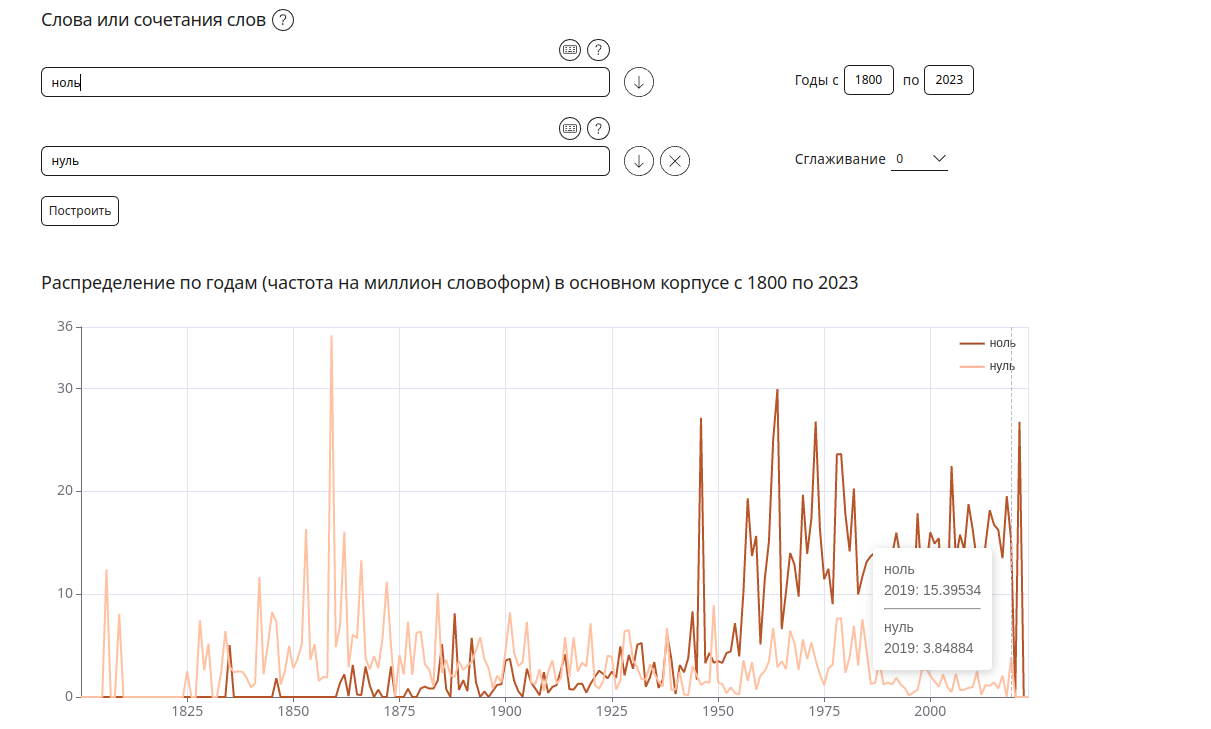

In [46]:
display.Image(b64decode(base64_nkrya_image))

In [47]:
nol_nkra = 15.39534
nul_nkra = 3.84884

In [48]:
print(f'Соотношение нолей к нулям: {nol_nkra / nul_nkra}')
print(f'Соотношение нулей к нолям: {nul_nkra / nol_nkra}')

Соотношение нолей к нулям: 3.999994803629145
Соотношение нулей к нолям: 0.25000032477360035


### Google Books Ngram 2019 год

In [55]:
base64_ngramm_image = 'iVBORw0KGgoAAAANSUhEUgAABhQAAAMYCAYAAAAjFg2oAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAbtQSURBVHgB7N0JfFTlvf/xb5Yhe0IgLAESMKAQCCAgAQU1WAWroBW9oq1ikdblWlutrbW1i/5vbe1i63pFbtWqtIpFrOIGWI0CsgkRiCQREoEAYQmE7AmT5X+emQkkIZNJMlkG8nn3lZrMnHPmnDNPDpnf9zzP41drEQAAAAAAAAAAQDP8BQAAAAAAAAAA4AGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgUaA6yOEjtVr1WY0ysmp0OL/W+lnq09v5XJ8YP114QYASh/tZj/mpO/ivL/544vukiHj9ZugNAgAAAAAAAADgdNHugUJdkPDG29VNPHdyme1ZVY6A4aIpAZo9K0BnukPHj+nTo186vjeBAgAAAAAAAAAAp5N2DRRMb4Tf/rmqxcubgMEED5+uqdaDP7V1m94KAAAAAAAAAACcbtotUPj0sxo992LDMMH0QDDDGyUO91fiOX6OACH/SK0jeNieVXtiOfP4UitYuH1eh43ABAAAAAAAAAAAvNAuFXwTEDQOE0YO99ODP7E1eCyx7ptZAQ2GRjLLEia0r/wVf9CDb+S4X8AWqsj+8Ro9LkWXXTpOsUHyMXal/e1eLdhol/zHaf6TdyjZps63e4kefHSl8mvMD6FKmvew7p4c2fw6Nel6/r6ntKHM+n7MfD19V7K6YtdPG5VpWvDAAqWZ8xWerLsfna+kFp2wfK38w4NaYpq5f5yu+NUvdbX/Gj3/3BKlFUVp3LW3a/4FsQIAAAAAAADQPvzVDhoPc3TtVQGnhAmNmeGNzNwJJkjwtCw6gL1MRbmZWvP2Aj3y2wVas98ueFKm9Df+pbQSoT0FJWnSqFDn9yXpWp/VwrZ4aIPW73J9HzdeUwZYIdQ7S7Rhf5nsJXna8K/3lE6zBgAAAAAAANqN190CGvdMMGFCayZZvuiCdsk04JZNsWOSlRDe8FG7vVB5WVnKLbLLfihNLz/5skJ/OV/jwoXmFG3QkrenKOnbI+h10G5sSpqQpNCNG6zIpkyZm7JkT0ryeH7zNm5Wbo3z+4TzkhVj/feArd4lLdCmwDN/vncAAAAAAACg03gdKJi5E+qYoYtaEyagM0Rp+Iy5unFYE0/Z87Tm+b/o5bQiqcAqlC+frnHXxglumOzLau75q17TW5Mf1HUJRArtxTZykpLCN2hDiZXZpG9Wlj3Jw7BHeUpLy3WtnKBJE2Mc3yZdc4uuKPm30gpjNO6qb2kEeSUAAAAAAADQbrwKFOqHCUZnhAnVf39TNZ9sVE3qBtXu2if/lGT5DRko/4snKuC717RoG7WH/q7aok9UW5gqVe6SX2SK/KJSpMiLnf/1wMwZYY7d/NdMKG2CFDPx9IUX+FuPOSedNsxjre2BUfXwM47jMsdpjqvuK/A3dzn+265ssZoy99vatmOBYxif/K2blXtNnOIowjZpxCWXqfSTlcq1gpjU11ZqygNXKJZz1T6ChmvSmEht+MwKt4q2aXOWXUnNJQr7rfBhn/Nb27BJGh/tejwySVffZX0JAAAAAAAAQHvzKlCoK5zXMQX0jmKK7PZ5v3AECfXV/WwK8NUv/Vu2F38nd4V3EyDU5j5shQmpDR+3fq57zK/vd+Uf9xurwDmkyW0sXVbtmEi6vu1WiLA9q1qfrql2nIP6QUtLA4Wmjs88Zr7qjtMEJiZYaFehwzV6iJSWbn1flK9C6z/0UXCjb4q+fXG6/vBhnuy739NrnyTr3mkxQnuwaXjyaEV+tkZF1v+2eRj2KHdDmvJq6tZLVqQAAAAAAAAAdDSvAoX8I7Unvu/T2/PyjXs0NKd+Id4U1SvPutTjOqbobpYL+vpDNQ4VTJhQ8+U0j9swvReqrWUDkj4+JVR45M92R3jgjumtcLgVx3jiNZs4vrr9rwsU6notmJ4YpldG+ylTWZnr26BQtw2iaGeqVqSmKX3nHuUXWivYQhXVN14JY6Zo+iXJivMw94K36zclf9VT+sM/01VkTnlogq6+58e6YrCzBF22e41WrtygtBzr9QrKZA8IVWT/eI2ekKLLLhmn2CC12nF7DyVceZ2mpD2lNUfsynznVa05925NiVYb2JW3aaXeW7VBmbvzVWS3KTK6v4aeO8k6HylKiM7VWw//Vu/ttxZNmqu/3j1FjmmLD7yn3z78lmPugBHf/qvuvdgqrq97T+9+lKas/fkqs0sJ1z6in013Bh32gkyt+TBV69OzdeBIkcqqbQoNj1H/ocM1fuplSkmKaVS0tyvtb/dqwUZrQ9Ep+tnvblRCYaZSl6/U6i9ydKDQLpu1nwnjpulbV05RnGsuZRXlKPW9d7X6yz06UFBkvb+R6p8wXlO/eaVShrWs3G8blqzR0Wu0psA57FG2PUkjmkoUanK1OS3P+b3p2XBu6Mnn9r+lh/7nPUfYEHvlQ3roqthT1zf7uvxj65xkOva1rCbUce7jh4/W1OmXaVzfei+a9ap++pdUK+KwtvfNX+qhbzURt9V7T8w5u9c6Z6cOtZSvlX94UEtyzDJTrGXm1lvG2RZWfrZZWbuOqNC8iaEhihk4QkkTp2n6lARF+rt/zZa0AwAAAAAAAKA9eBUoHM4/WVxvSe+ExhM4u2PCiYsu6HHiZ3Pnfn2BD/1AAbd8S6bobkIE0zPBFNvrmJ8b3MlfueuUMMF/2IvO4Y2s0MDRc+HwS44woW752kMvyc/0VHAxYUj9MMEMc3TbvEBrX/0cPTUyvqp19FAwoUJr1T8+c0z1eyI4ggTreKoeevpELwYTmLQXe9ZKpe5yfm8bMlTxjd9GM8/Couf06ro8q+xZT2WZ8nMzHV8bPl6hlHk/1I1jmigce7u+G0Vpz+uvdWFCUJwuu+1uV5hgV867f9FT7+RYheJ6K9SUqch6rTXma1WSbrzzDqXEtW4OBLv9uFXoTdJ1147TtoVpKipJ17/fSNO4741TaGs2VJmr1L89qVe3FtXfuooO5ShthfW1erUum39dCyZ9PqINf1ug5zfmn3zIP1YjEp1F5PyNL+vpV9Yor7LBUaisKE85aebLKt5Pnqsf3JKsGDe/voXbl+gPz69UTlm9LRzJVfqHLyt9a7bu+OlcJeW/p6effUuZDQ6nSLnpqXp1+2Zl3vIz3TG5BYVt21AlW21gzSfOYY827LRbx9LEWchdrw2HnN+GJk1VUitOflHaq3ryxVTlNjgnZY5zn26+1nyscdf/UPOnxTnPf8JojY5M1Rprl/K2b1O+FSg0PpL8rdtOTA6tgnSl77KK/AmNXzhL6a4pH0ITx2to3fm22sLKhU9qSXpRw+VLrJAha4Pja82qFM3/wY1Kcvvr0Xw7AAAAAAAAANqLV2MU9YnxO/F9/d4K7cnMKVB/GKAeH7/UYD4Bc7e+GebIhAwn1rGK7/UDBhMO1Oc/6mPH0EZ1PRBMsGACBv+4h04sU5P7kCNYMA5bx1Y/DDFhwoM/sTnCBMOEKWb+iIumtH4OCcecEPWOz3Es9cKQuvkh6vdYaBywtEllkXI+e1V/WZCqfFMMtVlF+W82KozX5Ct1wR/1cl0Y4B+q2KRkpUy/TJddnKwR/V1Ll1kF8mf/oOfTGhVFvV3fjbKMJfrL8xtc+x2jKd/7oa5LdG7Lbj33fF2YYF5vzBRddtXVuuJS6/X6ul7vSLpefeZVpZepdWqckUjohG/rW64qdtGmJVqSYW/FNvKsY/3LyTDBFqm4cdY+mnNy4TglRNsc52Plwle04Vjzmypc95JedhWRbZGxio2LVczAJI22moo9Z4mefuFkmBA6IElTLr1CV3/rCl02eYRiHD00rKL1uuf19OuZavIIyjbrn44wwaaYRNf7Zu3jid4kh9bo5Ree14KFzjDB1nuEkqddZp3rKRo32FX9rilS2uJXHQV5z2wakTzeVbA3wx5lN7lfORvSnO+91VqTJia1OMwp2/qy/rCwLkywKTJhnKZMv0JXTE9RcmKsQv1d+/vaX7Rglas4bxuu0cNdr7DfCgVOOQ5r+S059X7OV3rdZNH12HdsU7bdtc9jhjvDCitsW/nkX06GCeGxSpqcYv0eXqaUC6zzHF3X2yZVC/66RDmValJz7QAAAAAAAABoT171UKivfm8Fd0whvrn1m7q7v36x3dy57264H1OEN8X5E3MOfLJRdZM0O8IBFxMauJt42dEjwfRScAUJpueCI3hoxPRMaIoJFcxxtGZoJ7OfdeofX13PhPrHVKfxz82zivp/ul2pzS0SPUJX3DRfVw9ueDd4/kfPW8VOZ9Xd1jdZN945V1MG1F+mTLkfPq8n3zA9BfK1YdE/NXroHUqObJ/1m2LmLnhq4UrlmeKsf4ySb7lXc+v1bMjetNlVbI7UuFt/pTsm1tvYfxUp819P6umPDiiqv01lJVLruhbUidSUOVdo9Q5T5M3Xmtfe0tRfXqeEFnR4yP/oZSuAcJ2T/lM0964blVx/iB17vtL+9bSe/yRP+R62lZeT6xjq6bK51ns3rtHQRQlX6/bbQvXWu9bvz5T5mjstrsGhXvctE6osUGquFSqsfl9rZoxQSuOhm6zQqcjfOo83/UzzL6y3/avS9PyjC7ThiAl3NshMvxGadKPuvyNFsScWKlP6okf0lCnMl6Vr9YZ8K9BowR3zCZM0rm+qVh4ywx5tsIrwIxoOe1STo81bXWcmcpwmJbWwl4m1D6++ssYVQsVqyrwf6MYJDc9Z2e6Veu7JJcossfb930uUNu4OjQu3afjY4QrdmKYye7a2bS9TyuR6Z7Jos9J3m29sCrUeLiuzzmf6ZuVdG6eTgy3ZlZWe5QxHgkxA4XzVvA9f1ls7nW0hNPE63X3bZUqo/yaZtrDYagurrEBu/0q9vHySHrrq1CGXmm0HAAAAAAAAQDvyqofChRecvCPfhAGNJ2luzNzV7+6r/pBJ9b+vHyi4m2y5Tv2w4UTR3RUOnBB5sZpTP2yoLfrE8d9V9QICMxxTXc+EpngzMbU5PrPfpleGmVOhbpijOqYXhhnuyPTSaD82xcQlKD4mpOHD9kyt/DDHWQQNHaHr7p7fKAxwPKG4S+/QD2e6hocpSdN7H+W2z/pNOZCqBU+/5Rx+xyp0J93wA82dWL9IbVdVhasniX+U4uMaJxORGnHtD/XQb/+qR+4xhXy1Xd/L9O1LXftt7dc/V+R5Xseck4/qnZO75jYMEwxbjMZ9+8e6cUxLko4YqzB+t65rsohsU+y4K3THLx/SHY3CBIfoJN14sxUAmOZqCuUZTXfXiEy+RXMvbLR9q5B/xeR6cxOEj9ON8+qHCY4DVNL0FCW4fh1yd+WqRf04/BM0fozrPS1wDnvUQM56pbmGO4ocm6zhLaye569/V84OMDYlXHm75k449ZyFDr5Mt9/g6qVTkq7UTc6eA6GJo5Xg6tGRk5HT4DjK0l09D6yg4IpvDnW1h20n9tGhJleZWa4Q6ezRziGaTFv4xLWtyGTNbRwmOBY2bWG+Lhvg/DHvs9XKafIS21w7AAAAAAAAANqPVz0UEhv1ODB35re1oF4/jKgbSqnxnfhm6J/mmOfrhjqqCyJqK3Y1WMYveEiz2/AzcyrU/dBo3fr75k5LJqeur35gYgIE89VgfxrNqdB6NsVNmKKhjWvrNXYVHshS1o585W99TwuytumyO398Yugg5aYrvcD5bcykqzWlbzPbv/RbGvfRU9pQYhU9rQJr3rfiFOvt+o0XK9ig55981TXkTKhGXPND3XFxbKMCqk3xZ8fLtjFTdquI+96zC6SrpmtqUoIi6yZhtoKImFa+R+7EffPbStn0B608YFfu8teUOvFepTQXUrT4nERqyswpWpm+0jG5sFsJKbrCQ/BQtj9NqStXa/POPTpSUDcpc5R6xw/X+HND5YyR7DpyyHQParytGI2/uOkhhWIG9rfOtnMoq8hxKRrX1KTaMbGKsVbOsd5Xe0mhY9mWFLwTkscp5qOVyq8p0ra0bNkTR5xYL2dDuqvnhrVvE4e2sIBepqwtrkDDv7/i+xYqM6Ow6UUDY9TbuoSVWb8f2VnWa188Trbw0RqdYFN6hl1l1u9Jdk2Sa0LlMqVvdfY8sJ09XpMm2pX+dqYy7bnatjVfV9T1yLACBuf7btPQMaOd53N3mrJcbSF0iNVmd1vrudn7qFjrl3e/1fALs7TtgHV+BjRaIMFzOwAAAAAAAADag1eBgrlT3wxjVDdZsQkULrqg9aGCCRPqD3eUeI6zaG+K6XV37Ruehvqp3b3/xPd1vRkaD29kAgY/19wJHrnCh5jefmopMzlza9Q/vsaPmxChbtimtovS0Etu1I3Dmn62LOstPbXgPeWYcftfeFVDfzPfURwu25frKtyGKmF4XPOF26AER8F1w1artHpoj6z6uqK8XL/h3e5WOPBUuvLqtZGQ6Kgmtxl5wXW6etNftCSrTPYDaXprofXlH+rohZEwfITGj5ukpITI9rmT25agK/5ritKeWaP8yky99a81Gn/XFDmymyZ+BRzn1DX2v8dzEpekhHArUGhm7oGYhKFyP4iQXTkrntazb2Y6J66u93hZUb7K0vNNvnHyUXsT/QdM8b1/01u3BYXKOQW2NGDgADfHEqpQ24mXVcumZLfETVJy35V6zyqeF21NU/Z/uYY9smdqfd1wR33HadLZLXwXaw5ozyHX8VlBU+rCvzY/BFjdLufnqVBWuGG9o+OT4vRqRo6jqJ9l/bqOMCMPVWZpc5YzJjFBQWT0cVmLKdNaLHdruoouTXG0haLtmc5gyD9OSa6ZlcvyDpwY0qps6xI9tbUFO1RTqPx86/Ua9fRpvh0AAAAAAAAA7cerIY+MxvMJmMmLD7diguamJjyuH0jUH+ao/nwDTak/EXODQnz9AME1jJE7NWYOhbrXdq1Xv9eBCU+aO76WzCVRX+M5IcywRsG1GY6hjbwPEzwLHX615l/lugO8KE0rNjor2FWVx+uWUGiEp8KttUxd5dgqTJfZvV+/gZp85R1qMNCM0l7/l9JKmtiUmVz6nod177VTnBMcO9YvU/7udG1YsUQL/vBT/eJPryrtUCsmUm5uz5Ou03UTXEXirf/WvzaZoW0CZWviN6t15yTMMSZ/c2w299swExA/+0ZdmBCq2AlX6MY77tXPfvEz/eyeOzT3qika0dvTPthka0HNPjCw3aZicbIK7+MnuPqoFGxWmmvOY/vODdrsuqs/9txJJ4ZT8swKlyrVepV2lbvCmMgx4xXnmLQ5T9vSnVGAPWuzHCMZnQgKYqz/Ouc4sOekaVuR87W3ZbiG8YobrXGua8nJttAaZSpr4jhsthYGKwAAAAAAAICXvK4Eml4K114VoDfernb8bHoaPPInuy6aEuCYpLg5pjC/0BFAnHys8Tqm4F43LJAJDAJu+ZaampjZzDvgrgeD6aVQ6woKzATNAX1vaRgyuNTsnNdgzgU/s5yc8yKYUKFuP82cChde4H/KXAqmp0VrJmQ2PA3jdGLfrHNgn/cL2V78ndxNTN1WMWOSFPd6pnJq7Dqwa4/1SJICg3q4nrWKmMWeBquxOyajdbCKmyYb8Hb9Jvdz4lxdF71SC8x8BUUb9M83Jmn4LU0MyeMfqRHT51pfN6ooN1uZWenWV7a2ZeWoyCrIFu1M1YK/lOmOX85veqieVgnVuGu/paQvX1Z6WZE2vLFEU4Yny9ZE02/dOSm1zonayNqPj9LkmgFASd9+UHdc3HB8/YTEcZpyYbz++rNXldm6Jtsp4s4bp9j385RXU6TNmzJ14/Chyt60zXlM/rEalxzXiq2FymaGvDIBVNzVeuiXV5w6pJYnfZM0fuAS5VrZwIGMdBV9c4r2pGXK8RbVCwpix4xW7Du5yrNna/P2Mk0Zl6XMHGfbjk0ad6Inwcm2YFPyHX/V/HGEAgAAAAAAAPB9XvdQMEwIYEKFOqbwbgKGR/5sdxTY68+PYEIE87V0WbXuecB+Yrgkw2yj8XBJZtif+r0Ujk+7pUF4UFdorz/3gCm4159zwD/uNw0ChOpNZzkDBld4UFuYqpr0aSdCB+c6DzVYxwQkdcyxmSDEOVSTc//N8fz2zy0e1KXBvtbvieCYR8E6vhNzQLgmaTbHbb43x1q/J0a7q3YOYxM6sL+r+FmmnKzc5tepzNK2Xa5AoG+8+tu8X7+xyDFzde+tUzRu5twT8xQUrXtVSzKa62lgU2TcCCVfep3m3vUz/enRX+rGca7JJAo26N1V+WoX0VN045UJzoL9kTV6zSooN5UVhA6Ma3BOmu0jsS/LMfdAm9TsV96BuvM5RVde6Gay3kN5riGYfNCAZCW7fu2L0tOUWZalDVtc4z8NtJ5rTZ7gmDfBdQYOZbfxvMZqdJIzhrDvylRmkZnI2rk/9YMCDRyvJMcPduVszVJZzjZr3+UIQZLGnowxQmPrfj+s5XIOCAAAAAAAADgdtEugYJg79uuHCoYJC8xwRqbQfs8Dx/Wd7x93hAjmq65HQx2zrrseDT0+fkn1QwVTdK8861JV+CU6Cu31C+xmObN8A1Yw4N/3uw0CAtMbwQQL1Z/5qeZLK0woSm2wvJ8JIeox+zay3iTU5ticx2V3HFfj42mNxqGJOT5zXOb4zHHWD0tMqFB/2faQn7ZZua7Ccu/Y3s7ic9w4JUW7nl//llKPuF8/76N3leaq9cYmjXbe/e3t+vX5J+m/vjdFMaa1BiXo6jmu72vyteafS5RzYhiYMuWlrdTLf3lQDy3KPLVgHxqnlNnTTwyVc+RA+xVyYy75tq6Icxat8z55TxsKmlgoLqnBOVlzyN3WirTh3dTmJ2RuBZub11jz/ga1U6TSAWKVPMGVGhxJ14b3159oIwnJya3sYRCq0WNdEzhXpmvlh82EOYdSteB3T2nJqpxGc09Yb9+YJGcIYAKwjzY4J1r2j2kQFDiGaxrlio2y1mtlWpazV0X0cI2vH4IMHqfhdW3hs3ebbi/OrSjzX3/QH158T2kH2meYLgAAAAAAAKCt2i1QMMP/mKL7L38S2KDwXufwEXfrSbfPC2x2eCRTQDdD/XgqpJu7/U8JE+q2YQUE/sNebHKoowbLWcFDwISvm3zuwZ/YdNEF7k+ZOZamjt2TuhDEzJ/QkuXac8ijoowlWvB2jrPAWn/setsIXXap6677skwtefJlbThl3oEy5X6yQE/XrR+epCsuiWuf9RuwNWip9ectMAXgl99xra9Cpb2/RGuy8pW35nk9vyrvlMJxflamDrgKxaHhHiYpaA3r3F12Q4piHUFH2anzQDgOwzonl9Q7J880cU5qipT+ryf1clqbxzuy9iVe8QPr7shfr3c35J/yGmn/fFKvpnvxGp0gZkLdPAlWcLRig3N4If8Eq422fgriyEmXKdlVwM9b/qQWrMhR46O3H9ig559ZorTdVuiw6C96fk2jGbGH1AVCZUr70BXGRCc1DAoscWOHOyfmLrG285nz3EcmjWs450P9tlCSppefaWpeDytMePc5PfdhjnLWvaUF1r7lkCkAAAAAAACgC7XzbKrO+QZui/FTRlZts3MKmOJ7S+ZZqGOK6GaiYtMbofqlf58Y8sgU2c2Xu7kV6jNzKZiwoDb3YccwR7VmyCPry4QIjuf73OJYpjkm/LjoghplfOU8PjMJc90wTeY5M/TR9ixnb4U+MQ3DBT+5DxvMMTh6Kgwe4Jh82hyfGfao7vgaD+PUcoXKet8qrjcxV0DZoRxl5eS7iu42xV76bV3W/+TzMZfM13UZjzgKz/YDa/T8b7ZpRdJoDe0fJZvdKtpnpSt9v6ss6x+j5G/fouTI9lvfvVCNu/6/NC7jecfEzHkf/1PvJf9MV8fFWkX9y7ThLyuVZ7eK5ose0i8+G6fxifGKsdmVl5OmtPQ8ZyHZFqcpUxLUnmzDrtB1U9L0VDNDKcVcOldXp/9RS7Jc5+T/Oc/JCOucqCRP2dvTlXPEekeCYhQTkK/8NtX8Q5V86RS9tz1V+SY8ePEhPbgxWeMSYhRaka+sLzYo0xSve8cosiD/lDvxfUZf670bYhXRc04+ZDt7kib1VuuFJum6m1KU9YzznKS/8Qc9uGqEkhLjFBNkV+GBbKtt5KrsxCTMN+rmKY0ao/9QjU6MVOpnRbLbnb81kSPHOSdrrsc2bLxGhK/RhhK7nIuFavSYoafsUqzVFq6z2sKrpi3kpmrB/9usuERXW6jMV25GmvN9cmzUats3Xa0EploAAAAAAABAF2r3QMEwvRX6XODnuJv/9nk6Mc9AvlV8j7GK7I0nM24NM99A/TkH2sL0Vmg8pFFrmAAhcbj1TRNhiAkYmvJJ8u/UEu1xfA1ZhfT0DcprdplQxV06Xz+8NqHh8DhWkT/ljvtlW/ScXl2XJ7tViM3dusb6arx6nFLm/vDk/ATttX5zIpN13bfWK2tRusrsuVr5ykolP3CFYhOu049vs+vJF1OVaxXji6wQIdX6asAqzibfcoeuGKB2Fqqkb12n5C0LtKHIzSL+VmH4rh9LC5/UknRrISv4yE2zzkmDzcTpsnnXyfbmX/VeGzsR2BKv0x3X5uvJN9KtwMCu/PQ1Wpleb4HIJN145yRl/s4KZeSrYjRuQoKWnEgUbBo+cbxa0UoaCE26UT+7y6Znn1+pnDITqGVqg/XVkBWsTb5Rt9/kGlar0XPDx4xQ6Geu3hLW+z1izNBTh5SyDbdCrFBt2FhW98IafXYTSYDVFlLuul966Wkt2WQFe3Y3vx+RI3TFrfN19fB27FEDAAAAAAAAtEGHBAqN1QUI3gQJvsD0tlj1WbVumxfo9ljq98hIPMeHj9ffJlt4lOKGjtOkS6crZZibMq1VfJ8y7yGNviBVK1alKX3nHuUXWoVSW6ii+sYrISlZ0y+dorhwdcz6zYi58EZdse4hLdlpl333e3r5o3H62aWxjrvLf/nrSUr9cIXWb81Wbn6RFavYFBkTp/jE8Zo2I0VJvTvoVu/wcfqvq5KUboIOd8sEWYHB3b9T0sb39J51TjJz81Vkt+rG0XEaOmaSUqzzMSIqV6++5lzcZp2r1u+tzQqJ7tbDZ6/Re8tXKy0r19HbITQqRgljUnTlzBQlhGxQpnybY9ijf+c4h/oJGq5J49oaJzhFJl2nn/3PJG34aIXWbM3RnkP5ViBlc5yX/sOSNClluqZYvwvuzrdt+GgND90gx4hUoVZwMLypJa3gYexw2TamOXr/ONYJcrPBICtUuO0hJaWnauXqzUrPPqDCkjLZrfc8pn+Cho+bqssuHqdYsgQAAAAAAAD4AL9ai+CRmVS6bh4IM4G0mYS6cahgJqCuCxTMkE6PP9pDQJsUpeqvP3tVmTVmmKSf6ZH/at/hmQAAAAAAAACgtTqlh8KZwMz38MbbzrkRzH/N/Alm6KMYV6hgei5sz6ptsDzQWNHuDVq9ao027InT3PuuU0KTd67blZu62hEmmGF1EobHCQAAAAAAAAC6GoFCC9VNHl0XKpjwoG7y5cZGDvdr8WTT6E7s2vPRv/TWOjPBQqae/VuMfjgvRXGhDZfJW/WyFrzvmlWh/xRNS2ImXgAAAAAAAABdjyGPWskMabT07aoTwx81ZoZDIkyAWwUbtOAPzyutwPVzaKxGjBmuuGgrVSjLV25WujIPuGZfsMUq5e77dSOT8QIAAAAAAADwAQQKbWSGPMr4qlaH82vVJ8bPMfRR4nC/037iaXQ8+4E1evnZV7XhgN39QuEJumzenbouybtJiAEAAAAAAACgvRAoAF2hpkg5az7Wx5u2KSf3gPLL7LIFRyqqT7yGj52kadOSGw2FBAAAAAAAAABdi0ABAAAAAAAAAAB45C8AAAAAAAAAAAAPCBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeESgAAAAAAAAAAACPAtUBCgsLVVpaqoqKClVVVQkAAAAAcHoKDAxUcHCwwsLCFBUVJQAAAHRffrUWtRMTJBw5ckRBQUGKiIhQSEiI449PPz8/dTvmrHbDwwYAAAAa4O/i05r5uGhuEisvL1dxcbEqKyvVu3dvggUAAIBuqt0ChUOHDjl6JMTExCg0NFQAAAAAgDNLWVmZ8vPzHT0W+vbtKwAAAHQv7RIomDDBbrdrwIAB3bM3AgAAAAB0E+Yj5P79+2Wz2QgVAAAAuhmvJ2U2wxyZngmECQAAAABw5jOf+8znP/M50HweBAAAQPfhdaBg5kwwwxwRJgAAAABA92A+/5nPgebzIAAAALoPrwIFczeKmYCZORMAAAAAoHsxnwPN50F6KQAAAHQfXgUKpaWlioiIEAAAAACg+zGfB83nQgAAAHQPXgUKZszMkJAQdVteT2cNAAAAdGP8PX3aM58HzedCAAAAdA9eBQpVVVUKDAxUt8W0EQAAAEDb8ff0ac98HjSfCwEAANA9eD0pM5MxAwAAAED3xOdBAACA7sXrQAEAAAAAAAAAAJz5CBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8CBQAAAAA4fVQV62Dufu09dFhFpVWqsj7WBYZFqF/fAYqL66MIPuUBAACgg5w+f2pafzQfyS9WcaUcfyz37hWhEPpXAAAAAOgmind/ro9S12tT5n4VV7lZKDBCA0eM1dSUqZo8OEIAAABAe/LxQKFKxdnr9O5Hn2vrzsMqr6n3VFC0hiSO1bTLpmlMX27BAQAAAHCGKt2jj5cu1XtbD6vK07JVxdqXvlqL09cpdcxlumH2VA0JEwAAANAu/GotaqOvvvpK55xzjjpEVYE2LX1Jr2308Eezf4QSr5qreVMGyCYAAAAAOHPY96/Tiy8sU0ah64HACA1JGqsxI4dr5JA+ioyIUIgqVFxcrAO5Wdq+7UttSt9zsgdD1HBde+u3NXVAx92E1aGfCwEAAOBTfDNQqCnQupee0+Ltxc6fA6N19jjrj+ahAxQZYv1RXXhYuzK/0Kbth1XuWCBYQ2bM139fSqgAAAAAwKk8e7XWVY7VtJGtG/qnePtqfR50nqYNDVZXsu9frf9b+L52lJqfAtVr5DRdO2uqRsY0Hw7YC7KU+vYyrUgvcN6cFZagq267RdM6KFQgUAAAAOg+Ah6yqI2OHDmi3r17q73t/c8LenHdEZkRjkIGTdbN/32zZp53tuIH9FW/Pn01IG6IRo6brAvODtCezBwdPV6lY1/vVHlCskb2YmIFAAAAoLsr/+p9PfPSR/r8iywd6z9KSX2DWrRecfqbembRp9q8ZacqB43RiN5dNLxq8Zf654I39aW5x8o/WGdPn6e7rh2rAaF1n3eqdCR7mzZvzVTWrgM6Vh2mPr1CFGA9ExASo6Hnjtc5/nu1/esCHT9eoKysAg04d5T6tew0tEpHfS4EAACA7/G96nvx53rv0/3OO2liJmvebbM0JrrpP+JDzkrR9793mYaYP4pNr4b31+mIukja7zT9nARNenjtKU9t/u3FSjjnYv2m8VOHN+v1396p66ZNUmJSoiZNu053/ult7SxrYvu7/6brEhOUkNDEV9KdertunepUPTDBemzmM/qyWq3T3Lr/uUfnWq8166md1g+VWvsr65gSztWdy4oabeNLPXa5tY1z79TrBZ247wAAAEA9VccrVGX+pqw6rPX/eF6vpRd7XMcRJvzjcx00H0aq7So/blfXKNamfy/VZscwR1aY8M35+v6l8QpxPWvP/1JvPPF7/XbB63rj3ZV6791lWrTgz/rNE8u0Nb9urKNgDbn0Ft31zQTnegVb9Nq/t8jzWQAAAADc87lAoTh9i3Y4xjGK0PhZl+nskOaXtw1I0bVT+ji+r8rdos2HdHo48Lbuuf47euDltaocMU0333SzpsUdVuqz9+i6Gx/T2kZ1elVWqtL6QBQ0+ip97867dJfj62ZdMEhdIEjjr5ihuMAirf3PWjXY1exUpeZIked/U5dHywf3HQAAAN1BRNI1uus756mfuTepBaFCgzAhsI8mfWe+bkhq3VBJ7cX+dare21rh+D5izFW6OaXe0K7FX+q1Bf/U6r0Vp6xXvnedXlywVFtPHGag+qVcr2vHOI+jPH2lVnztcVpnAAAAwK0u6r/rTpW+znH1TggbrgnntGzM0kHjRqlfaqoO1hzS17utP6z7du1Yp54V6e3fPqK390Vqxu+W6Nnr4lyP36ebn52v7/zpGT3w5AVa8cvzdaJHcmmFKq3/9J04V7/46XjXg7n62xev67Oj6nRByZdrxuC/6W+r3rfCjxmaEel8fGfqx9pZFamUK1IUKd/cdwAAAHQPzlBBrqDAGSqoiaDAl8IEqUJbP/1Cjj+TgxI0/aqxOrknVdqx8n1Xz4VADZw0S9d9I0n9dEhbVi7TGxutz1KFW/TWyvOUODvBFUJEaMJVKVqftUw7Kgu06dMvdcVZYxUiAAAAoPV8rIdCuYqKXXfaREc77yZqiZi+6uc4kipr/dOgE++Bt/R66mEFnft9/eJEmGAEadRtP9b1Q61y+5uLlVp/6KOKIkdRPjKsAwY9bYuA8bp6+jDr01eq3l9X6XowV2s/+VKV0Sn65sWRJ5f1tX0HAABAt+EIFW5231PBt8IES3mWtu5w9U5ImqpJUfWeq9mvrZnOcUUDz/mmbr/uPA2JDlZIdLwmXz9XVw91foA6mvml9tXUWy/qPKW4jql8x5faXikAAACgTXwsULApMMD1bY3U4s641ZLd9Qezzd/HOl00xfoDP90KC+LGj1dc4+cCRumCcX2sTzbZSt9V7/HKShVagUNQWGTLXmP7Y5p1tmuegnMSde4F03XTL17R2sNqN6OuvFqjVKTU5amOwEAHUrV8S6UiL/ymUiJ9e98BAADQfUSMbDpU8Lkwwdi/R187/rgO1tlJQ08OdWT4h+jsySm67NLLdPUlo9RwTyM0ZLBrzNGychXVDxQUaG3LNZdC5R7t2isAAACgTXys+h6syCgzXFGFdGS/9lp/SPdryU3t1h/dBx1/MEeo34Cu/QBw+KXvKOGlJp4IPBkdVJYVWgX4IEX26tPEgtbjkeYcFKmoUPXWqVCl9UHH+VwL9LlAN990vvo6fqjQoe2pemvJb3Tr1kP6xxv3aXxz59VR0H9MHo2cocsTn9Zjq99XatkMnb/6Y206HqkZ9Yc76ux9BwAAAJrgDBWkZ15xDX/0yp+1SVWqMp8jfCVMsJQfOuScONm/rwYNbPxxrY/GXHKZxjS1Ys1h7ch29l5Q/wFqvKpt4AD189+iXTXFOnjI+rw11NeHiQUAAIAv8rnb+c86e6gCN36pqsosrd9crAnne/qjvkLb13/pHGM0LEFjBnftIUWOu143p8Sp/p/nuav+T69/cfLnoNAoRQZWWoFBURNbsB53JAl9FRl+8tGiw/nO7fdq4V3+fc7X9f99l0bV9fjQ9zXtV7N06z9e0cv/+YHGX9FMVb5BQd+pYtcH+tubXzZacJiuunKUnv7zWn28NleVqZudwx1NbbjtTt13AAAAwI2GoUKVs0e0D4UJRlm5awhY/whFtnSXrIBk3eKX9PZu64j8ozV1+mT1brxMRIRCTP/0GvMa5ZIIFAAAANB6PhcohIycoAlRX2p9YZV2LH9dq8+6RVP7u9/N4q1v64005xiovSZM1sgurjUHjbla9919foPHNhe+3iBQ0KjxGtXjda39Yq1yNarhsEfVX+qzNCtoiEhR0tCTD+/cZRXsA+MUF9vWA4zU+ckjFfSPVOUfPmT9HOd+0VMK+pb/7NArpwQK1lauuFoT/vobffzmMypcW6Q+3/iWUkIbLtOp+w4AAACcxlo87Gud0iy9tfCfSt1f5Qghxsyer2vPOQ2GgQUAAMBpycfmULAEDdeVV7rGAy3N0RsLntdb6QWyN16upli7Uv+px/+xRUdNN+WIUboiJV6nhT6X61uX9lHlxv/T75bk1nuiUl8+/xe9vtsU6uecLMwXpeqD1FxzS1WDkKF1KrV583arsB+kmEF91W4GXa4ZE4N0+L3Xtby4j6Zdcb4axAa+vO8AAADoVoq3v+nqnWD94B+oQPNpqImJmrtSZIir54D1eafI4y4Va9PS151hgvUJasx1t2vepGg3ixar3DWvQmhIiAAAAIC28MlbVyLGzdath4q18MM9Ki/do9SX/qz1/ROUeNYA9bb+9i0vPKyvd2ZrX2G9+3esKvbe9Z+r9/nnaUiYfFykrnrg/+mzL+/R67+YpVn/uVrnJwSpKMMU33eqcuT39OiPnYX5nUse0EPPvKXPTMjwnVPv/nfr8Fq9/r86OQ9BVqreWpGryNH36ft1QxKt/o0m3fqK+t65TMvuHaW26aPLrzpfv1udqsqYabr8/JNxQofuOwAAANAKDcIEM8zRzfN1pT48OaeCFSrIB4Y+Cunb14oGclRcc0h791k7G93MR7biL7U+3TlEUsSEa3TDxGi3i9r37T8571xfhjsCAABA2/hoX9hgDZkxXz/qtUwvLrP+wC+3QoQDOdpsfTUWGDNKV8waoIxXVip1+Zdave2wbrvtmzrb10OF/jP06Ov/0Kgnn9br/3lLr6RaMcOgYUq5+3F9f/5VGuWabqAoc602HY7UqKu+r4d/mqIWl9MPf6ZX/vqZ8/vAIEX2H6bx33lU9917vUY13kigd0X6PpOnaUJQqnK/YQUj9TbVKfsOAAAAeNBUmHDDSBMcNJqo2RdChQHxOitonbZWVmhHerbsScNlc7dsqRVADI7XEIVo5PnD5b7fQZW1rRyZmRMUZC0/QAAAAECb+NVa1EZfffWVzjnnHHWo8v3atHaTtm7P1tf5BSqvlGwhEeo1cKhGjpmgCyfEK0L7tfKp5/TeXmePhcABU0+PUKGLFS25VZPuX6uUx9br2WtaOGFyU9t5805d9LPtuvqlFXr4fCr+AAAA8B3uw4RmlunSUKFCm176kxaZngdBCbr2p/M1NUreKVyn//3TMu2wPkuFJF2vX90yVu056FGnfC4EAACAT/D92bpCBmjCJearuYUG6LLv3aKyhS85xg+t2r9aCxeKUKFZh/XB8s2q7D9D30ppe5igyi/1f39PVdHgm3V1MmECAAAAfEdxuhUU/KNRUDDy1KAgYuQ1uus7ci3b1T0VgjVm6rnqlb5ORytztOLtLRp781g1uSfZy/TrBetUbD079Y4HdG2Tc5YVa9PbqY4wQYrWhItGiRkUAAAA0Fa+NylzW4Ul6OrbblHKAGdG4gwV3teOUqEpRTu182icrvr5g5oR3Yb1DyzXY7+4Rzdd/R09kxGpGf/9fY0PEAAAAOATmgwTmgkIIpJMqHCe+pmPE108UbNtaIquSHLOc1C89W29krpfdrVFlQ5++rre2Oo8jpCkyzT9LN+/pwwAAAC+68wJFAxChZaLPF+/eGOZHp/VR21Smqu05cuVXjZM1//mBf3hmjZuBwAAAOgAgT2CFWhueGnFEEYNQoUAm0J62NQ1IjRh9myNdwx1VKEd77+s//twj3MOhPp6naNpl6boskunKrFX4ycrtOvDl/TMu665E6LG6obZbno6AAAAAC3k+3MotEVpjt5yDX9kBA66TD+6O0WDzqz4BAAAAEAzyrNXa13lWE0b2boyevH21fo86DxNGxqsrmTfm6r/XbhSuxyJQKB6JU3TtVdN1cjo5nsZ2AuylPr2Mq1IL5DjE1FIvK64bb4uG9QxvROYQwEAAKD7ODMDBaMuVDgQojHX3a55E9syrg8AAAAAdB373tV68e/vK6PQ9UBghIYkjdWY0aM0Mi5akRERClGFiouLdSQ3S1u2falN6XtUXOVaPmq4rrr125o2oOOGOiJQAAAA6D7O3EDBKN2jTbsjNGEkYQIAAACA01RxjlYuXXqyx0GLOHs03DA7RWd38DhHBAoAAADdx5kdKAAAAADAGaFKxV9/ro8+3aRNmftP9kBoLDBCA0eM1eSLpmrqWZ0zYwKfCwEAALqPjuv3CgAAAABoJ4GKOGuyrjZfVcU6uHuP9h4qUFF5lRU1BCowJEK9+w7QWYP7KIJPeQAAAOgg/KkJAAAAAKeTwAj1GzrK+hIAAADQqfwFAAAAAAAAAADgAYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeESgAAAAAAAAAAACPvA4Uamtr1W1140MHAAAAvMbf06e9bv15EAAAoBvyKlAIDAxUVVWVui0/AQAAAGgr/p4+7ZnPg+ZzIQAAALoHrwKF4OBglZeXCwAAAADQ/ZjPg+ZzIQAAALoHrwKFsLAwFRcXCwAAAADQ/ZjPg+ZzIQAAALoHrwKFqKgoVVZWqqysTAAAAACA7sN8DjSfB83nQgAAAHQPXk/K3Lt3b+Xn5zMZFwAAAAB0E+bzn/kcaD4PAgAAoPvwOlAwd6OYMTP3799PqAAAAAAAZzjzuc98/jOfA+mdAAAA0L341bZTCnDo0CFVVFQoJiZGoaGh6vbMWfUTAAAA0L3xd/EZxQxzZHommDChb9++AgAAQPfSboGCUVhYqCNHjigoKEgREREKCQlRYGCg/Pz4BAEAAAAApxvzcbGqqkrl5eWOCZjNnAlmmCN6JgAAAHRP7Roo1DHBQmlpqaPHgvnjEwAAAABwejI3iZkeCWFhYQQJAAAA3VyHBAoAAAAAAAAAAODM4vWkzAAAAAAAAAAA4MxHoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeBaoL2Kuk49ZXVbXz+9pa5xd8m5+f88tmtZrAAKlHoPN7X2TalePLamNVrjZWQxvrNvxdbTXQtNEAZzv11bZacdx81arCbrVX6/sqR2O12qzQXfiZ/7Pi/UCr0dp6SME266uHn/Uln8T1FcbpdJ0FAAAAALQfv9razinlV1uFh3KrWFZe6fy51vyv1s9ZSMFpxTQYP79a1b17IUHWl1X4CghQl6prYxWVrn00j9WKNtaNmXYQ4HeyPQT7SFs1xdjislrHl2Guh9U11m+U+dEqLNfWOAt16B7Mv8J+pr+gCZKs9z3A/+T1NSLUz/HV1YVarq9wx1evswAAAACAjtHhgYK5a7G03HkXrimaOaolOLO4wgVzN21YiPOuxc5U18Yqj5/8GWhKXdsM6qK2Wm0VjAuKTZBgAoMa1VT7UZGFe9a1zD/AhO/+VqggRUf4WWGDOhXXV7RWV19nAQAAAAAdq0MDBdMboaScIKHbcAUL4SHOXgudwbQxU+wyKHShpeoKXGGd2FZNb4T8IvM7Umu1VT/GNELL+Zk2a/4l9VNMpLPHQmfg+gpvdMV1FgAAAADQ8TosUDB34Dp7JYjCWXfiuuHa9FYwd9R2pLo2ZjAHB1qrbkihzmir+YW1VmG21jFEDNdDtJmfc2iZsBArWIjq2FCB6yvaQ2deZwEAAAAAnaNDAoXCUucY4TU1Qjfl7++cnDEqTB2CNob20tFt9UBBrSorzST0tcyLAK+Zf7EDrVQhKEjqH90xDYrrK9pbR19nAQAAAACdp90DBUchws7wCHAOd2CztX8BgTaG9tZRbdUZJtQ65k4A2pOZSyEoyK/dQwWur+goHXWdBQAAAAB0rnad3tEMkeC4q5FCBORsB6Y9mHbRXmhj6Agd0VbNMEemZwJhAjqCaVemfZl21l64vqIjdcR1FgAAAADQ+dotUDCTN5rxlhkiAfWZ9mDahWkf3qKNoSO1Z1s1EzCbOROqqqnMouOY9mXamWlv3uL6is7QntdZAAAAAEDXaJdAwdx1VlLOXKNommkXpn14c9erWbe0XECHK/WyrZo7x/OLnBMwM2cCOpJpX6adOdqbF0EA11d0Nm+vswAAAACArtMugUKpI0yoJVFA02qd7cObglXdurW0Ma/Yc/Zp6YYK+bqSLXu1NP24Oltd+/KmrRYU18qP6yE6iwmurP8z7a6tuL6iM7XHdRYAAAAA0HW8DhSqq53d11XLrbhohtU+TDsx7aW1zDqVx7mb0Vv2nbv1wCO79M6Wctnl2wpyDunlP23Ts5s7P1Qw7ayyjW21bnzwGq6H6ESmvdXNf9Ba3f76aj+iJ+av0ZW3fKF3Duv0dfiwdc3crFutY/nWbV9o6W75NG+uswAAAACArhUoL5Ufd/VOkBcFtOrjyt18SCtSD2n7oKF67MaoRgvUqGBzrv7274PakmtXibXb/ROiNP2aBM1O6tFgyZKsvXr+9YPamFOhEv9AxQ/trZk3DNH0hMA2Lee9GuWu3aPXlh/Rlt0Vrn2PtvZ9SJv33cHjObOKslt26+U387XRvG5wsM4d3183f2eghoaqS5h2Un7cT+EhrVrN0cZaK/eNzbr7zYaFc5stUL36hWnihQN1w+XRig5QF6jQZ09u1RMZPTTnp2M0O6Fd50V3r+yI/vbkXmX3H6jHbo6WzfVwSU6ellq/V6mZ5TpaKfXqG6GJMwbr5ksjFF5v9c5um3FXJep76V/o2QVfaegjSZreR53OtLvWtlUzlr2fX41qa7wMFOzlSntvj97ZUKSvj1TpeA+bBp4VpUuuGKwZw3vIp1QXa/Gv07X0kL8uuXOibh/fSW26o5Qf1aLf7dBHAX314wfOUlKw9XbsOqBladYvyMAYzU4Ocy1YoQ0L0rUgq4eu+VGSZg3pwuM2vRT8a6z2569eka1re+VtzewKC/XOklx9vKVU2YVVCgoN1tDh0UqZGa/pw9r739H2YTfXu8+t9zGuj+acH9a6lXfu0n1/zFPp+GH6/R19FC0fUl2qxY/v1OLdNVKQTXG9eqiHu8uEdW35bPHXemNDofW+WYtHhei8qXH63rW9u+TfxLZcZwEAAAAAXcv7QMFMrNfGu3HtB45o+YqD+nhtgTKLnY/F9Tt1uZLNO/XzJw4rt1qK7hOi+OpKZWcd0fN/KlPJL87V3OGuQk7Obv3m0b3KtKrI0f1dy20/qCceLdPxh8doZqxat5zXrDDh3XT95NViK0jwV79Y67Uqzb4ftvbdeuxn4zR3ZOv2vcXnbONX+vnT5pz5W9sLVq+CCm38ZJcy9lXpzw8OVpxNnc9qJ6a9tLZ4UFHpxd2zVogQ19PZPo9XVOvgXqsI9mqhNmYP02M/7Nf5RaFqu3busUKx4mplH7SKP50SKNQoe+kuLT8arFl3xGtosPNRe9Yuq83tc7S58F4hGhplV3aedX7+nq7csjH63VWugltXtM2AEM2cG6sVv96nl18/rAvu6tMg4Ohopr1VVLYtUKip9vMqX1VFkZY+lqHFu5yD4odF2RRWYdeu7fl6IatQX92SpLvPDxY6SGm5vj5co1L/Uu0rlyNQKM3J19L3rEY9LkSzrEDBcfm0fpe/tgLu0pJq7TpkvVdDujZIMe3OtL/WBgptur4ePag/PbRTqUet7wOsf9t6WWekqEJbPs/TlrQCZf9gtO6c6GPBl6Vk52G9+rb1Pp4Xotnnh6k1/wyWHCjT3rIaVe4qVUl1ny4KpN04lK8Ne02YEKUfPdpcAHtcnz27TY9ssDuCh6GDAnR0f6lS385UdvFI/Xl+9GlxnQUAAAAAdC2vAoW2DK9QX/YH2Xr2Q7tsocEa0f+4Mg80NavkcX3+nyOOMGHo9CT9bm6U9YH3uDY+84UeWluudz88ohuH97EKA1X67O0DjqKnWe4xazmbWW6BtdzqYi19p0Azvh/diuXaQfFhvfaWCRNsmv6jc/UjU2CprlDqU1v0p88r9O6Kw7pxZL9W7VOLzll1qd593VmwnXjjGD14pVU4KS7Q849s19Kd+/Xy6lg9OK3rij2m3dha2PLMst6MxGEbO0RP3dPP9X7W6ODqr/Sb/7Pa06a9WpbTT3MT1LkCInTjz5KUuD9QiWM76S7esiN6Z02FNHiQptcFWKrQ8tfznG3ucuv36ibze3UyANuy3CoMXjlMYwO6sG0OHqCZiXl64vN9Sj3QRzP7q1OZdteatlpRd6e3V50TarTjzWxHmGDrG6M7/vssTR1odqBKu97L1O/fLNbq17/WpNGJSu7Myl93EhOrux8I0V7rNyKpucTR+l2efe8onZMXoHNG+8Ad+a52Z9phcAsv7229vma+s9sRJtgGx+rR+xM0wnRCqj6uLf9I129WlOudf+7VtPHW475UdPdS+NRh+nNEsUoHRCvO146rtFql5r+RoYrv1cxyu/frtU3WxTzCCh7+nzN4sO+1AuNf7dWWT3OVelW0ZnZyb7DWXmcBAAAAAF3Pq49wx6u8G+4oeuQA3TkqSinjI3Tw9U364btNTRZbraPHahy7mji2bhiWHjp3YqTC1x5R5dHjVsHe2la1VQTNsnYoIEwp06NcBeQemnhpjOLW5ik3q0B7qqM1VC1crj0KBjmF2lJm/Te2r2aPd1V4AoI1ZUqUnv3c7Ltd5gbPftUt36cWnbPDBdpyyPpvRLSunO66C9P6fs7MaK1YUKCN1muXTItVV9QjTXs5XuXXqkDBT+01v62/+p0fp2lvHdHLeRXK3W9tPKFGK363UU9sl1LuOl8/Pd9VcLeKLD98cK+yw/vod0+eYxXW5QiDNv47R699YoaKqFFQeIjGTIrV3OtjFVd3w7jHZcq17Kl0PZ8TqJk/nag7xzpfz37gsJa+vk8fZ5TrQJlz6KEpV5+luVNd758Z5/uOTK2oidaPHohW9uv7tSanQvbQEJ03Y6juvCrK7ftpTz+iz4qtQMC0p7oHKwqVkVPjKIpOv6JuXX/FXdRHia8Xa2NJhQpM76Ogrmyb1uuMt5ZJL9ZnG8o186rOvY3VtLvWBQq13g//Vn5UH6w1582mS74z1AoT6gKgQA2ZMVgz1qZr8YEird9WpeTznTt2bPs+LX7nkDbvqVBpTaD6DempK687S5fUH46qsEjL39ijFdtKdbBcCusTpknT4jXnkkidHPilRns35OrNDw4r7YBVdLTa1jnj+uuma/trUGs7ROz4Wvf98YAOnh2vB1KOa/myfKUdrrFeN1yXXDdUc8ae3GDprgN6c0meVlntudQ6zn5xkUqZOVizRtd7Uev3Kv393XpzTZGyCqzt9Hbt/6Wu/bcf1XP3Zumjmp66/d5o7XozT+t3OX8/xl2SoFuvOHmcHl+v/JAWPPq10tRT9/2ln9IfzNLyEtfKadm66ftfu4Z2qtQHz32pRbsCNeOHE3Rrr7365f/s044evaxjH65k1+ZK12bo7heO6bh1Lp6+f6C1Vdc+WEHd+q8qVaAADRnRR9deH6dxfb3r5WDan2mHwT1a1gbbdn2t0oH9zsHkRlrXthF1I5oF9NDY6wZqyvpd2lJRop2HpRF9jujZH2TqnbIozf9RT+W+vV+f7Xa2rQtmna35Kf76/B/Zeu3zUh2o8Ff88D66+bYETaxfFD9aoHfeyNU7m80y1rVxgHWNmXmWbjw/pEHwX7LT+j1YctC6LlbqaHWA4s/upZnXu4Zlq3bth6vnlD7fqW/dlGMF/ZNkZf0nlH69T88+c0Cpuysc+3jeFda19UrX9XFjjn7yhPXv9rDBevGhQYpuzTXZDDP0qnWca4u1xxznyH66YXSZnlhUINvUEVp0R2+3Z7vZ47J+Z7cs2KhfrHbd3XE4T/fdkifb8CF68VcDT+mBV5BRZF2vrWt1UqymuYID26CBVtC8X1u2lGrL9irNvLhzK/utvc4CAAAAALqeV9WLKuuDaa0Xk4/2Sx6kmROtkKDZ4n2QhiaYskGVMrYUy1nXOa4vthQ5vu9/VqTzQ3NZhQ6a4r1/D/Wv/9m8T4gcNzYfsZ6vacVy7WHkED311wla9MtBDe5orCyskqNW2ytIvVqz72rhOSurcp6nsB7qVe8dDo8LVT9rPfvBSh3sookQTXupasVr261lq9t1stAaVTq2568ePVrT/Ku05YWteuTNAmXbg3RuUpT61VhFohU5+vnj+3Swxcs04ehBPf7wV3p5Q6lKwsN07rAgHT9UqKUL0vX42kYDnNsL9fwfc5R6wHo/Q/1VUliu1Nez9MoW9402e1uRY+6OYcPrFeSD++jOP07QC38eoRn1i3clx+WouYUHKzpIXd42o4dHKt56fPv2YypR5zLtzt6Ktlph1UmrvZ07YU+hvrIK/gqPUvLZjdqnFf5MvfEs3f6dwZo6yPlQ6ZYd+p8n9+ijHccVPjBSSf39dHBHvp57PFPLD7nWsxdr8V8z9IJVzDTta5zVDnocKdbyVzP0+xMVVitM+HC7/uf/9mv1/mqrYB+isOPlSkv9Wv+z8IAOqW3su/bqLy8c0ldVgYruUaNjVhiy9PmvtbrQtcCBffrLn7/Wsixr/63C/ri4QBXkHNWiZzK0aHtdF7gKbXguXf/z1lGlW+v162OFs2b/F2foL++VNnrBIi16wtr+IefvR6n1+7H6za+0eFtNK16vviCdc14vTR3iqnZGR+iS5Bid3aeJa8fA3hpvfinKi5S+o+bEef0qvcRx9/jwsb0dYYI9Z7d+b/ZhW7mORwRpYHC1dmzZr0f/vENpXjZy0/4qWjHjetuur4HqP8CZlmR/fvDE8GYOof3002cmadGzYxr2KKou1MtP7NZnRwMUHey8bq1YlKFfPJSuP31qEq4AhddUKTs9T39esM8KWVwKD+uJh7br2U+KdcAKGONjAlS6u0CLn7Gusx+cfO9L0nP0i0d2aWl6uUrDghQfVm1t66CeeMQK4Haa9yJYiZN6K6UuZOtlBannW+Fp/QCnulSvPrNLqVYQEl13bX3Vurame/iDwOM1uUobn9+mP66wQmbrXIX3DFRJ5j498mqBx2ua5+PyV6/hvTU9KdgZXgQFa+L5vTVtbGiTvSwPWomMaR69+gfXe956P/uYi3aNDuZXqrO19joLAAAAAOh6Xg955GX5rAX8Nfb6szVnt1UUWpGuO9JC1MuM4X60RtHDBume2RHOxSqq5Si9+vs3/CBtc/1cU6Pj9lYs1x5jHtl6KLrx8AEVVqF4eaH1od6mGRe5hlZq732KCHQWFwoqlGvVB05Mwmyvcb7O8Sp5rDmZOyqX5GqLp4qHVficeV2/Fs/JUHc3YktVtWcbKyvXxreytcIq/Cg0ShOHtyJQsBdoxTq77FZR90ePjNF0U4QvzNMjP83RZxmHtSZvoGbHtGCZJubnOLg2T59bRfvo8cP01I+d8zoUfLBV8xYVa83Hh/W98xveaTpoRpIevt459Ndnj6fpkc/t2vh5oe4c29T4LBXaae4mDghTXL/6x+uv8D7BjXo1WIWvt6wCoRle7Px+zl4ZXd02+4Uoztrt7P2l2mvtl9shVDqgvZp2V9WKtmq3DsDPyw4K9qPHHcVUW1SQejaxj31H9tclI+t+qlLaqqNWUOWvpOvG6FczTGB0XBv+d4seSyvWR2tLNePqMCnnkFbvq5Ft4AD96leDNSjAGUQ88HS+dqyxvr4ZobNLDmnxv4t1LCBEs344UjeNtIr2Jce06PcZVuF7r1Zk9dVNw9uQP9f00NQ7R+nWsdb2yo/phf+XoeX5RUrLqtHUZH/tXX9YWVY76HvRcD16c0+rGdVo1+It+tmHFfpoTZHmjLR+ibbk6pU0q1XExOiB+8/WuGgTVOzWw3/cr/SVe7Vh2nAl1/uXbMA3Runn15geCXXnwq60L4qk0T1b9HoNTrt/mKZ+Z7iSPkrX+l1WNXhIX936/b5umnuYkseGaPG+cn1phQgaHekIONJcPXzOHWeK8OX6YPEB7ai03rOrR+qBmRGyVVuByf+l67FNR/XGf0o17upWThZcj2l/9lZMstzW6+uIq+M1fetXWpGzT/fdc0QTL4hRyqS+mpIU4ubc+Ovc611DnFnHu+JPaXoi3a7sQjPm/0hNj/WXfWeO7vufPGVnFWhj8UBNj6jRliVfa8VR69o4doh+f89Ax+9twYav9PNnDmvjv75W6vlJSgkv1buLrPXs1t8K11jXxmsjHMMIZr68VQ+ssEKCl/cr5f8NUsp3R2jsiq1ak2O9jwn99N93uYbCs5/cx5FX1a1/XKnWtfVPddfWpOZn22n2mpy3T6+tNf8uBGvmj0dbj1m/CxXFWvqndD2f1UxYUd2y44qbNkw/istRRkaeSiKjdcMd7oaassJ0uzM9svk3/F22BQY4TsTx8uYveCXpe7V4bZmab2L+ijs/XjOTWjbuVmuvswAAAACArudVoFDbrneON8MWqF69AmXLqVLB4XLX3Yv+jrvsojtzcmHrA/47T+zQx8dOPtTrvKF68KqIFm7guDa+slNL86wCyXmDdcP4Durj3ydaY2N3a8veAr328kENndtH0UePaLH1vZmLwkyi6ZEtRBMnBemdR/c6h21qSmiE5j+Q0OoJnlvTbrxtY3bH0BY7Gz5oswo730tQSlQrNmR6NJiaS5VdGdtLdcHUMKs2Hav7H+utEqsmFG6q5DUtWKYJ/a48V4uvdP1QXaOSMqu60jtYvVSsg2ZYLDNERd3CVsF32rSoE0MCJY60CnifF+to4XE1WdevttYvdC4b7qGZHvzkKz272oq6+vTR/NktbdOt1Nq2aYVy4SZ0sI7PjMLjNlDooPbamvZXZRY2u+9Fmz1udxUYbeYd8yRQU38wSVPrfqyoUqlVLI/ua3MUHo8VuCqlVvhjtmUvKdOXucc1aEgPhY0dqkf/PFhmh8McAcMRpVnr2kb31zUjXa8c3lNTrSL4suUVytxRrtLSA/rL+6U6cQ+zf4iu+u+zm5/LoXdPXVJXWAyJVNJgfytQqNGxIlOSDFYPm/P9Ls0r0q6CSJ0d7a8hs0frhcut89Aj0FHwT9t0zNFD4uwLBznCBMchDemnC+P2a4dVHP5qj5RcNxeK9ftx4YV1wxv10DkjrN8PK1wpcP1+eH497wyydnDI8nLtsoriexWpQfsK9KWVLdgG9JRVb5cOHdX63eZiEKOZMyKcr2cVmpOnRKnnpnzt2lGoUmvv2xwp+LvaYQtjgjZfX6P66Ee/sa4/r+/Wa6uLtfHjvY6vx3tFaNb1Q08O1VYnIEhjxoedON6Jo633Jb1UQYn9NC3W+Z7YzopWYqhVQC+zQjVzzQot1Geb7Y7lp18z8MTvbXSyVaxefljPZlmB67YqpcSZsFaOodOuudJ1Tq3fjRFm+KVPdip1d742Hh7keW4Aq+1ccFHEiWHdxtZdW4+6ubbWW6+5a3LJtkJlW9c2W9IA3TzW9bsQHOEIX17OKnW/P3vb6bjq89QTwENnjPDEGCWu/lJ/XF3h9qaEuKnn6IbE1s3R1Gl/SwIAAAAA2sVpEChUaePfM/Ts53bFnZ+gB+f2U/+aYi1fmGUVP3fqN6HBempulDonV6jSwV2lyjx68pHouJbeWlej7De268+fVEix/fTT2/opWh0lTFfeFKs1j1nFGesc3bHaWVAPj3AW6BQaoOgWzBFhSxishx+QftNUkdZRnB2p2Qmtb0KtaTc13raxIJuG9nJMgKCjh+wqqA5Uyp1jdWdyK/fbFq3Z10Vpyz8KtWLBF/r45WCNHBGl86bGanpyXaGsBcs0qUYHN+zR3946pI277Y0KNc1XeBrfadrUth13LPu7wg43Srbs1CN/L9DBoDDNvXuYxoaqg7S2bZqhqeQ4juOmkt3MWP4d0V5b1f5qnG3bz4seCnUFb9MIWnSjuWtugdc+PWYVyGsatp0aV9tJiNWc5CN6csMxvfDIJi2ODtOokVaB+6L+muo6H4cPOYuf2va1bv3+16e8TKEJJ8IrlGVd/068hhX+FLRyeDhb3XvrKmz2vWiQLt+wQ8t27NMv789T34HhSkrqrUtS+ursKHMuKnTooPMau+PNLzTnzcZbrFZBifudsPk3fDM8v56X4nppfO/92nWgUGmHatQjvdAxhNeQ8b1l8gQzfthhc+wl+Xr0v/NP3d+SKkdg3tZAobamde3Pq+trRJSmzx+j6TeWK3PzIX38ab5Stxdr6YKtyj6cpIeviWimCO861wGNCvX13wIz3Jqjx1GQ4gfUXyhYw0y6kGXXwYPWRSGownGObX3CFV//+hBq/WyK7XuPW8tZ/23lZMOer60tW+/oEec1PW5AaOvmLTrUAcfl6d99T4dshTsXfH+U7lfToYIJE37//T4t+vuivhoCBQAAAAA4rfj+NHhlR7RivblLMUqzrUJknOPG6SjNvKmfPk7fq8y1B/XFjVGaGBzgvKO3plFRze4aQsUUVE3loqXLNcXah/lPTtF8tZZVMP4wU4+8WaqSXtH66f2NCrbe7JMb4UkJ+t2vwvTuf45o5zGp17A+mt7zsH7xfIFsA8LVq4XbabJI60WY0NlsowfrsXv6OYrVW57/XL/42K7PVx9WQXJsKwMdf8VNT9KTww8r9ZMj+nxbob7YfFBbrK93xifo9z+OVb8WLXOqko079fMnD+tgaJhmXh+nsYN6yJZ3UE+8WnByLHFvOIbHdl90NWO6/+6Zg8quCdbMu0dqTkK9qpIvtE1X8bklr3Pat9eoQEe7PFRYqWPWcQ9qVJg7lpOvr6w6dGh8TyX199eOJRl69MMK9ejfS7O/01tnRVtF/k279dza+hNiByv5++fqL8lW0XdDgbZllWjDmlLr66BWXzdSD8w4Wb629Y3UhUManyd/hQ22KeyiUVqU0sROezP+eXgv3fTgWE2yruOrvijUl18V6aPl1lfqAc2+O0lzhp9ctO/ZvXTqyDP+GtKaX2SPr+dlGwmI0KQxwVr6oRn2qFQ9tpfLHhCi8eMaRQQhIUoeHXJqgTm6lUXnrmI31wN/2czvZGiIRkwdbH3FafYnmfr5/xVoyzu52jhjpC4IUtudCBv8Tyl0V1Y3XK5uMbfaISvyWmv3od2Py19BQc60yW5v+O+B3TWxUY+QFrR/N6FCW8MEAAAAAMDpx6vqibkTssN7KZhhPBxzD/orvH5xIjRQjmyhzHrefBYODVY/U4kpqdABc9eea9JSHa6UGTLfDCHjGEK+pcu1owKrYPybVwp0MCJCd943QimN7yjsoH0KT+hnFYfrStgVSv3TTsfkvCnjW9ejo0GRVt4XZ1tzB625wbh97l7019grB2js6t3asiVPy3L6aW5d4dz1n+PVNXJboSkuV+b+41JktGbO7aOZ1kP23fv0x0d36bMt+7V8Z6zm9mvBMsMab7hGW9cccUzYPHb2CN15uetW1KxCR2HR60AhoIepUUpHq1RiCuyNh3k6kKfHH7Pe10qbUm4dpTvHNxqqosvbZpV5aSkoUGEtLE62Z3v1b01vA3/XHAretNezojQkKF+HSqwwameNkoY3nDT2oxd3aPEBfyXfOkFJfYq0fmOFo2A9+7bhmh3nXOxQ7t4G57D0ULH2F9YqZEh/zRk7QHOsNndo7Q794YWjSnt3v9IuOVtn9TLDJFknOjpac74/wDF5cMer0bFdJTps91Of5MG69SLrIXuF0l/P1KOp5Vq2PF8zh/e1dsnfsWzU8EG63d38Ai2aiLglr9e/7cMNuQyZ2FODPjygr9bvkT1XjmG+kusmKO4VpJ5WwfWYQnThzcOVHKx25WdOVUdfXwv36aEf7tJG60zN/8O5mn1i8mV/9ZvUW0NfsP6tq6pQrunJF6u2CwpWf8e1p1x79lv/rRvWymqnuWZeGPN6/ayLQt8Qx4Tu2QfLHMOi9atr/GUl2nNYjmtgv1b2TmhP/foEOX63DuSVWde4qJYHRh1wXP0ckzHbdfBAmfX/db3mqnTA0W3GdT5bolGo0N/LMMG/4yfjAgAAAAC0I69K536d8SEwKlRDTRHUXqwVn5a7HqxR7ieHlWE+A/cNdY6tHBCh88zdpdXlWvFhgZxzsx7Xxg/zHWOz90uMVnxAK5ZrJ/asXfrtgsPKDQzTnHtGaubgJk55R+9TcbFSn9+uZ7fUyDaon2af1/riqrNIe44ebIc7vVvTbtq1jfXvr2sm2Zzn+e3DrvMcqOiezuPJzih0PValzM8KHMNNnGCCgf9J132P7VKm6+Zv26BIxZnqUHW17NUtXOYUNTruulm0JL/SWRetPq4ta485C/ZeC1J/R8XfrgNHGj1VeETP/jlHqYWBmnj9KN1zcRPVza5um4UVMqOa2PqEqH8rXqe92mtr2l+gWbiVQwCdIqSXZpxnLmh2ffDq19pwyLXB6irtWr5Ly02jCInUhaPNMVltp9r53LGjrqHXyou0elt5g/p6wdpsPfzHL/WH14/KOWK7v/qeHe4obNf1XOk5JlrDrZe179yvxWvLT6xbumOPnnp6j3ZVqAMc1+bXv9Qv/7hdC9bV/cIE66yEIGevGOds4Bo1NtIRcOxItY4/t+4EW+fjoyw9tviYStv19ZpmC3Q1hJIqz683uLfGxVjnLqdI6dYbMWRsr5M9TfpHa5IpApcf0xtvHHX0QnEoOKpFT2bpo31eNqAaVztsoTZdX6N6aYyZfsPMKfR6nnIrTr547qeuf5cDraCxpd3g3AmI0nnjbY5hvVb8O08HXY26ZPMevWNGSguK0BTzexDbS1PMeFLFR7T4nWJX27eu4W/t0xpz7Rgco4muwrutbkix4ip5mr+9vYQn9dRI6/23p+dpcbrr97SiWGvSy5vPwVpxXC0VPTJKQwPM5MoH9fEBZ1uz7z2gFdut721hGtuaHjquUOHh74/wumeCH4ECAAAAAJxWvKoM26y1K4636obI1guI1syrovTx3wu18eUvdNOKIPWzPlpnH6iSPcCmlNkDHB+QzaFMvLq/xm7Zqy0fbtcd6SHqV20td7jKMeTJDVdGn5jUsGXLtYOKI/rfx/cp03z4j6hW5qvp+kWDBQI19kbnMBsdsU8la7/SL14t0J6jzuFpbFFR+u8fxGtoGw/QltBHF8g75mZYWytaXaC1bFW7tTHrPM/spxFr9yozbZ/e3d1Pc6yA59zkaPVbfVgHP8nUHVkhCi+vVG5ho8JeYqxmDzcTgR7UA/eXaOKQHrLnFeuLPOt4Yvsqxdw969+CZZrYp7HJUYreXKDsD7Zr3hdBCi+1Xr+4rpBc07Kbr93y19ChIbJtKFfubutEJtT1QDiu1IVf6R1ToLb56ej6HfrNxoZrRk8+Wz+9PKxr22ZuqfZYBcpeCVYwo9bxtr2athrYirZq6yFHgd+7thqopOuGadauLC3bd0iPPZivnlHWBa7CrmNmDgnrmjf1xrNcEyFHKnmsTcvX2LX82TR92SdQxwsqdMg1a7K92tmGBl00QJNWZWv1hh368b6DOscqdhfsKtIOa1/7Tu6jc8w5j4nVzTOP6P+9WaqPXtiqze8EqY/1zuw6ZL0/QWEaeGCQhgxp73FjgjVpRozezclX2mvb9LMN4RoUbNdXmaVW0T5QyVN6OnsLJA/RnI3pem5bkWMOiBX9bQosqdQu63fU1jdQX1/VU0ktep9a+HpNCBsUav27U6S9O3L1s58f1KT/Gqtbx7tZOCBck5JsWpbqnFB4/Ph6E5xbAd2MG/tr/dMHtCs1Sz9OC9GAyFod3l9hhQuBGpdUqUsGhqitav2c7bCl2nZ9DdGs+YO19dHd2rghR3ek7VFcjLWhsuOu66a/RswYqCmmZ5Q3w2GZXmXXnaXpW77Sis05uv2e/Rpq/Tu6N8+uEutcjb3+LKU4elxF6Mpb+mnNYwe15Y2tmrfm5DXKbgvRnO8MODHUXHhcqPqrULlZe3T3vQc05dvjdOe56lhWkD3nooPa/nG5lv5po9b0td6go86gtFkBLT+uFhsUqxvOP6iHVhfqiZ9/rncGBKpkf7kjrIm7NE4zWtuTw2rfYy/2rptNa6+zAAAAAICu51WFKDDA3FnW8bPp9bt0pB67a6BVkA2Q/Ui5so9Yn9GH9dbcH43RT8+vVz0ZPFi/+PkQzRxufcA1yx2T4kf2048eGKnp/dX65bxVeVwFrnHc7cUV2rKztNFXsQ4U1XTYPpnX3GMVeHrFRijlygQ99miSpg/q2sGkTXsJbM2d5tayAe2ZWA0aqGsnOO+4X/aOs5eCbXyC7r+xt0ZE+avkcKWO94zS3DsGaWL9/QwI08yfWu3t8mgNVaU2binQFyWBGjl1sB7+5RBnIbwlyzQheuo5enhuH43tJcfrl1jF9TnzB2qiWf6Y9R6WySv9xlv7E1CjrdsK64UTdh085mp7dqtIlVN6SvvMPuS6m7YL22bmlmIVmCDovCh1NtPubK1oq8E2M9dsO1wPw3vqpgeSdPelPXV2tL9KS+wq9bfp7NF9deu9Y3T3+XUFPCt8uCFRd6dEaFCPKh08UqUeQ/rq9muchfHjeWU6ZBaL7qs77j9bcyaEKbywRGnpJTpsC9PUmcP1q+/0chXR/TXkiiT9v+/319Q453V2V7Gfhoztr7t/MlKzh3TMdSNs7Nn61Q/jdUlCoI7tOab128uti3tPzb51pH5Yd5wBIbrkztF6YKZzDoWDB8p1WEEad9Fg/eb+oUpqRf29Ra/XlISBmjfDOs9BNSotVbMTnJtzefZ50c5JmKN7avzgRvsw8iz9+v6zNGt0iMIqrPNshePhcT01544k3XdJ28MEw7S/4FYkfG29vtoGD9JDj4zUj6ZHa2xvK6A6VKEDZf6KG2aGzErSw9dHtU8wH9VHP/rVCM0/P0z97ceVfbDWCneiHefq4StPxj/hScP0uwcGn7xGlfopfqx1jXpwjObWHzZs2CDdeWWE4qz3scTj+9herPBj7kjdf3mUhlohy9F86/0eNVB3TgvxeI5afFwt1kMT54/Wg1YQPMIKZ/bsLVdpRJhSrhmh39/cjjdTtEJrr7MAAAAAgK7nV1vb9lkQ7Fa98VhJJ8yjgDOGGdqgZ3jLeynQxtpDhVb8Lk1PZEfop39Jct3VexqwF+jZ+7ZreY9YPfaHBFdPpM7T2rZqemsdPFqjam+HPQLaKMCqMffr5a/gFvZS4PradTL/vkH3fWhX3OVJWnDT6XJRbn+tvc4CAAAAALqeV7ed8gEQbdGadmOWZXhlbwVr2rX9NLSqUK+9VejlEEqd5+CKXKUeDdSUawd1ephgmHbXmrZ6oohLcRZdwdXuglsx5BHX185Qo9w30/XQqwUn5204kKc31psrcaASh3s7DfjprbXXWQAAAABA1/P6Y1xIkFRWWescvBlojl+t1V5a306CrTZWUWmVZSjUtplt+BD96Moi/eLdnfrfEaP0o2Tvxr3uaCXbc/THpcWKnjpCd57figppO/H3c7a71ooI9VNRWY1qargeonP5B9Ra7a/19whwfe1g1aX67LNCbcwr1Py1IRray8oTdjvnLYgeOUg3jO++1fS2XmcBAAAAAF3L64GxQ3qYO8wonsEz005C2lAbDun8evIZyF9Drx+hn0wLUPa2cp/vpVCQVST72AQ9OL+3wtU12tLuTKBQW+vPbd/oXH5ytDvT/lqL62sHC4jQnF8m6UeXRmmQKrX9azNvQYhSLh+m3/94oPp18/kDaH8AAAAAcPrxag6FOsVlUvlxeimgGaZ3Qg8/q+ClNjFtrPI4d9F6r0Z2u79sXTH7ZmvYrf20+XfJJKHmrtmgHmpzW80vrFVJOb0U0Hn8/WsVHuKvmKi2tTmur+hs3l5nAQAAAABdx+seCkZYiKuXAvUzNMXP2T5MO2mrunX9aGNeOg3CBKOLwoS69uVNW42O8FMt10N0FtM7wfo/0+7aiusrOlN7XGcBAAAAAF2nXQIFc6dZeAj1MzTNtAvTPvy9aCBmXYoP6AxhXrbVAOuqGhPppwDHMDQCOoxpX6adOdqbF/+ac31FZ/P2OgsAAAAA6DrtEigYZnLm4B5m6AUBJ5j2YNpFSDtMvEgbQ0dqz7ZqxrIPC/FTYAAVM3Qc075MO2vL3AmNcX1FZ2jP6ywAAAAAoGu0a+nAjIVrC+SuMziZdmDaQ3uOkUwbQ0foiLZqxrMPCpJXd44D7ph2ZdpXW+dNaArXV3SkjrjOAgAAAAA6X7tMytxYYalkr5JqaoRuytyFaAoHUWHqELQxtJeObqsHCmpVWSlVVdcyRj28Zv7FNj0TTJjQP7pjGhTXV7S3jr7OAgAAAAA6T4cECkZxmVRx3EwWKdf/oVtwzUVrhjTo6LsQ69qYwVj1aK264n5ntNX8wlqVlteq2rRT2irays85Z4IZ5qg9eyY0hesr2kNnXmcBAAAAAJ2jwwIFo7xSKik39TPrJWq5NfeM51dr1bv8HBMwd9b4yKaNlZY7v6+h6IUWqhvSJawT22pxWa3yi8zvSK3VVv0IFtByfqbNmn9J/RwTMLfHnAktwfUV3uiK6ywAAAAAoON1aKBgmCKEKUg4eysQLJyRXEGCuQPRFA46e/ztujZWefzkz0BT6tpmUBe11eoaqaC41nH3t59fjWqqXV16gKZY1zL/AOtfzlp/x93d0RF+nT4nB9dXtFZXX2cBAAAAAB2rwwOFOtXVUvlx5x2PhgkXamv9qKWdhkyD8XOFCIa58zDEKhwEBKhL1bWxikrXPprHaqnXdmemHQT4nWwPwT7SVs349KbHgvkyzPWwusbPZHNW9c36uUbMt9CNmH+F/UxQUOPM3AP8T15fTW8E82XGn+9KXF/hjq9eZwEAAAAAHaPTAoX6TDHteJWZpNT5vdkDxmj2fabAab5MYSvQKhT0CFSXF7ncMe3K8WW1sSpXG+PO2u7D39VWA00bDXC2U19tq6b3VsXxWlXYrfZqfV/laKyMiNSdOIryVqAQaDVam1WIDbaZMeedvb58EddXGKfTdRYAAAAA0H66JFAAAAAAAAAAAACnl04ejRkAAAAAAAAAAJyOCBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeBe7YuVsAAAAAAAAAAADN8au1CAAAAAAAAAAAoBkMeQQAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4RKAAAAAAAAAAAAA8IlAAAAAAAAAAAAAeESgAAAAAAAAAAACPCBQAAAAAAAAAAIBHBAoAAAAAAAAAAMAjAgUAAAAAAAAAAOARgQIAAAAAAAAAAPCIQAEAAAAAAAAAAHhEoAAAAAAAAAAAADwiUAAAAAAAAAAAAB4RKAAAAAAAAAAAAI8IFAAAAAAAAAAAgEcECgAAAAAAAAAAwCMCBQAAAAAAAAAA4BGBAgAAAAAAAAAA8IhAAQAAAAAAAAAAeESgAAAAAAAAAAAAPCJQAAAAAAAAAAAAHhEoAAAAAAAAAAAAjwgUAAAAAAAAAACARwQKAAAAAAAAAADAIwIFAAAAAAAAAADgEYECAAAAAAAAAADwiEABAAAAAAAAAAB4FChv2fO16Y1FWrYxQ3llNkXFj9E3rrlJM0aEer9eK7Zdtm+r1q1apbV7YnXzT2Yr3r+pl8zQR+8v19ovdys/4ht68MGZiq2/jR3LtWjJf7R1T6HswTFKnDRLc66drFhb3QbytOqVF7R04x7ZeyXq8u/epplnezhOAAAAAAAAAADOAF72ULAr+42/auGHO6VRVvH96gs1oHCTFv/vQn2U7+16Ldt22ZfvaOEj9+reXz2uRSs2KbvQrNnEK+5arscf+ZMWf7ZfYedM1uUXJyqq/gIFq7TwqcXaVDhAF149R7NGh2rnhwv19BsZJ7ZXuH6xFmf20ZxfP6K7zj2mZf/4QHtqrCdqrKDhtaXaWigAAAAAAAAAAM5I3vVQsGfo0/V50tA5+sGtMxRjPXRh/zLd//Q6x+OXXBnb9vVauO38nC3aHZyoGTcPUN47S7Wpqder2aNlf1+qDI3RTb+8S5cMtJ2ySN76T5VRFqXJt96lOeea58fIdvBBK4BYpa3XJGpCkBUo5B+WfdDlGhMbo9DRwxRlJRuHrSVDP16kpdmJujdCAAAAAAAAAACckbzroXBoj3aXSVGD4x0Ff8N21jANDrArb8/+JnsKtHi9Fm47ftaDeuS+2zT74kTF2Jp+OXvGp1q118omLp2jS6wcoqyk8Z7ZtX9vnuwBAzR4cN1GYhQ/OMpaeL92H3Q+EhXVUzq427Ff+XvyVBgVpdD8VVr8XqkuvGFGk8MsAQAAAAAAAABwJvCuh0JFqcqqrUK/rcfJx4JtspnCekWZrLp7w2GFWrNeW7fdhLwdO1WoUMXsWawHf7hVedbKttgJmvXdea45EOwqKzMhg02hQSfXCwsy4UKZ7JXOn6MmzdaszU/r8XtXWYvGaPLNs1X49nPaP3GebhtqEwAAAAAAAAAAZyrvAoWa5p6ze7deW7fdhGOFhdY6hdqz36ZZN9ylmJJNWvbWOi39v1DFPzRPY0ymUO1+fXvdc6FDNfO+v2pGSaHsQVackfmiHtqZqJt+nShPccKLL77Y7PPf/va3BQAAAAAAAABoqLS0VP7+/urZs6fQtbwLFJrj38Y79luyXmu3XW0FEP6xmvHduzRzqHlgggaU7tZD727Spq9u0phzrYcCnIs2FVXYAhr9HB4lW2WGFr+eoWHX3ivbx8/ooU92qix0sCZfO0+zR7e078RJfn5+AgAAAAAAAAA0tHXrVgUHB2vy5MlC1/IuUAgPU5RVbM+vOH7ysQq77KZ3QWioQr1Zr63bbkJYqFnaph71coiY2AHWI/kqLHENdRRqnrQ7hzdybby00u74IeyUF7Mr+53F2jRgtu6P+I/++NIxTb7zXo3NXaqnX1iqYY/O05ighmvMmzdPAAAAAAAAAACcrrybRjgmXgOsYnvZ19nKcw1RZP96p3ZX2xQ/aID7YYBasl5bt92E2LOGWbFAnjJ25LsecU3s7B+lmBhn2DA4Pla26v3a+XWZa5l87dldaOUJAxQf02iDe5brtc96atZ/TVZovhVKxCTqvMR4DT0vUQMq8pVXLAAAAAAAAABAOxg/frxGjRoldD3veijYEnXR1Hite/8DPfeCdFF8qbZ+tE6FoYmaPSnWtZBd2cse13MbQjXr7rt0Yd8WrteibbdM6Phv6JL4TXpnyV/1zNHzNdieoU8/yZPtrNm66BznMjETv6Ex7y/UutcWKurQGIXtX6sPsq0w4tILldigt4F1PJszFDbjJl1oBQ326BiFHs1Wxt5C2fbs1H5blC5pTfcJAAAAAAAAAIBbkZGRgm8IeMiiNgtQrxFJGlC1V1+lrdG6LXtl7ztOs26dp0vi6voQ1Ohg2gf67OsAJUyeomGRLV2vJcvUU1ugL/+zStn+5+iiSxLVq/6UBAG9lHjuMAXk79TWDRu1Nbda/SbM0rx5V2hYiGuZkEFKOjtCxTlpWrdukzIKbBp+0Rzdeu04x9BLDY95iiYPjXD+1Hew+hRu0rJXF2v5jiBNuP5mXZFAogAAAAAAAAAA7eHo0aOqrKx0zKOAruVXaxEAAAAAAAAAAD4oNTWVSZl9hHdzKAAAAAAAAAAAgG6BHgoAAAAAAAAAAJ9VVFQkf39/hYeHC12LQAEAAAAAAAAAAHjEkEcAAAAAAAAAAJ9lJmU+duyY0PUIFAAAAAAAAAAAPmvr1q3KzMwUuh6BAgAAAAAAAAAA8Ig5FAAAAAAAAAAAPotJmX0HgQIAAAAAAAAAAPCIIY8AAAAAAAAAAD6LSZl9B4ECAAAAAAAAAMBnMSmz7yBQAAAAAAAAAAAAHjGHAgAAAAAAAADAZ5lJmf38/BQRESF0LQIFAAAAAAAAAADgEUMeAQAAAAAAAAB8FpMy+w4CBQAAAAAAAACAz2JSZt9BoAAAAAAAAAAAADxiDgUAAAAAAAAAgM8qLCyUv78/kzL7AAIFAAAAAAAAAADgEUMeAQAAAAAAAAB8lpmU2fRSQNcjUAAAAAAAAAAA+CwzKXNGRobQ9QgUAAAAAAAAAACAR8yhAAAAAAAAAADwWUzK7DsIFAAAAAAAAAAAgEcMeQQAAAAAAAAA8FlHjhxhUmYfQaAAAAAAAAAAAPBZ27ZtY1JmH0GgAAAAAAAAAAAAPGIOBQAAAAAAAACAz2JSZt9BoAAAAAAAAAAAADxiyCMAAAAAAAAAgM86evSojh07JnQ9AgUAAAAAAAAAgM/aunWrMjMzha5HoAAAAAAAAAAAADxiDgUAAAAAAAAAgM8qKiqSn58fkzL7AAIFAAAAAAAAAADgEUMeAQAAAAAAAAB8FpMy+w4CBQAAAAAAAACAz2JSZt9BoAAAAAAAAAAAADxiDgUAAAAAAAAAgM8ykzL7+/srPDxc6FoECgAAAAAAAAAAwCOGPAIAAAAAAAAA+CwmZfYdBAoAAAAAAAAAAJ/FpMy+g0ABAAAAAAAAAAB4xBwKAAAAAAAAAACfxaTMvoNAAQAAAAAAAAAAeMSQRwAAAAAAAAAAn8WkzL6DQAEAAAAAAAAA4LOYlNl3ECgAAAAAAAAAAACPmEMBAAAAAAAAAOCzmJTZdxAoAAAAAAAAAAAAjxjyCAAAAAAAAADgs5iU2XcQKAAAAAAAAAAAfBaTMvuOQHnLnq9NbyzSso0ZyiuzKSp+jL5xzU2aMSLU+/Vase2yfVu1btUqrd0Tq5t/Mlvx7qIS+x6988dHtDTbpsk/fFq3nVtvGzuWa9GS/2jrnkLZg2OUOGmW5lw7WbG2unXztOqVF7R04x7ZeyXq8u/epplnezhOAAAAAAAAAADOAF72ULAr+42/auGHO6VRVvH96gs1oHCTFv/vQn2U7+16Ldt22ZfvaOEj9+reXz2uRSs2KbvQrOle3n9e0bLsJpYoWKWFTy3WpsIBuvDqOZo1OlQ7P1yop9/IOLG9wvWLtTizj+b8+hHdde4xLfvHB9pTYz1RYwUNry3V1kIBAAAAAAAAANrR+PHjlZSUJHQ97wIFe4Y+XZ8nDZ2lH9w6U5dcPkd33TBZUWWux71Zr4Xbzs/Zot3BiZpx82xNiPawv3kfadE7exQaE3XqU+s/VUZZlCbfcJfmXH6JZt56u2YNtSnvs1XaWulcpjD/sOyDEjUmNkaJo4cp6mC+Dpt9+HiRlmb3UM8IAQAAAAAAAADaUWRkpMLDw4Wu512gcGiPdpdJUYPjFeN6yHbWMA0OsCtvz373PQVasl4Ltx0/60E9ct9tmn1xomJszeyr8h29CHbGXKI5F8eo4aJ27d+bJ3vAAA0eXPdMjOIHW8FD2X7tPuh8JCqqp3Rwt2O/8vfkqTAqSqH5q7T4vVJdeMMM98MsAQAAAAAAAADahEmZfYd3JfCKUpVVW4V+W4+TjwXbZDNbrShTmTfrtXXbbhSuXqylmVFW4X+Whp0SPNhVVmYiCptCg04+GhZkFiyT3dVDIWrSbM3qtUmP33u7Hnz7mCZfc54K316m/RPnOHozAAAAAAAAAADaF5My+w7vJmWuae45u3frtXXbTSlcp0VvbJXtgrs0e0SoyvY0sUy1+9Xtdc+FDtXM+/6qGSWFsgdFSZkv6qGdibrp14nyFCe8+OKLzT5/0003CQAAAAAAAAAAX+VdoNAc/zbesd+S9Vq17TJt+tdSbaq2Cv/TBsteUKhCV48De0m+CsuiFBVq/RDgeqyJLdgCGv0cHiVbZYYWv56hYdfeK9vHz+ihT3aqLHSwJl87T7NHR6m1qqqqBAAAAAAAAAA4yc/PzzEps78/4837Au8ChfAwRVnF9vyK4ycfq7DLbnoXhIYq1Jv12rrtxgrW6aON+VZSkK9FD92rRfWe2vTC/cr46h49fWuitUkTUtidwxu5Nl5aaXf8EHbKi9mV/c5ibRowW/dH/Ed/fOmYJt95r8bmLtXTLyzVsEfnaUxQwzXmzZsnAAAAAAAAAEDrBAcHC77Bu0AhJl4DrGL7nq+zlVeTqFgrJLJ/vVO7q22KHzTA/TBALVmvrdtuLGqC5vwgRvWn7CjcvFgvfpKvxKtu08zxw2TmThgcHyvbuv3a+XWZLok2CUK+9uwutPKEYYqPabTNPcv12mc9NevnkxWauU6FMYk6LzFe8f0SNeCtrcor1imBAgAAAAAAAACg9Y4cOaKAgAD17NlT6FreBQq2RF00NV7r3v9Az70gXRRfqq0fWQX20ETNnhTrWsiu7GWP67kNoZp19126sG8L12vRtlvAP0rxo8covt5D+XnLrAjBpqghE5ToeiJm4jc05v2FWvfaQkUdGqOw/Wv1QbYUe+mFSmwQDljHszlDYTNu0oVW0GCPjlHo0Wxl7C2Ubc9O7bdF6ZIWd58AAAAAAAAAADRn27Ztjl4KkydPFrqWl3Mo2DT0mh/oNi3Sss+WafFGq0gfP0Fz5juL7XWOlx5TWYlUZm/Nei3bdruJnqx5PyhT6OsfaNWbGbKHxijx0nmac23jCZet/frWT3VP3U+jZummCxZq8R/v19KgeE2+4XZNIFAAAAAAAAAAAJxh/GotAgAAAAAAAADABxUXFzsmZw4PDxe6FoECAAAAAAAAAADwyF8AAAAAAAAAAPgoMylzQUGB0PUIFAAAAAAAAAAAPstMypyVlSV0PQIFAAAAAAAAAADgEXMoAAAAAAAAAAB8VlFRkfz9/ZmU2QcQKAAAAAAAAAAAAI8Y8ggAAAAAAAAA4LOYlNl3ECgAAAAAAAAAAHwWkzL7DgIFAAAAAAAAAADgEXMoAAAAAAAAAAB8FpMy+w4CBQAAAAAAAAAA4BFDHgEAAAAAAAAAfJaZlPnYsWNC1yNQAAAAAAAAAAD4LDMpc2ZmptD1CBQAAAAAAAAAAIBHzKEAAAAAAAAAAPBZTMrsOwgUAAAAAAAAAACARwx5BAAAAAAAAADwWUePHmVSZh9BoAAAAAAAAAAA8Flbt25lUmYfQaAAAAAAAAAAAAA8Yg4FAAAAAAAAAIDPYlJm30GgAAAAAAAA0AXK3vpQx7/IUHDKJAVfnCwAAHxdoAAAAAAAANBpyv69UkfvfURVu/adeCxwyEDFvPgHR7gAAGjITMpseij07NlT6Fr0UAAAAAAAAOgkpkfCgWnfUc2x4iaf7//xIkIFAGgkNTVVwcHBmjx5stC1mJQZAAAAAACgE9QcK2o2TDAOXXOnYzkAAHwRgQIAAAAAAEAnKHr8782GCYZ5/ug9vxUA4KTx48crKSlJ6HoMeQQAAAAAANAJ9kSP9xgo1Bn09ccKHDJIAAD4EnooAAAAAAAAdLCSv7/R4jDBOPbQkwIAOB05ckTHjh0Tuh6BAgAAAAAAQAcr+/eHrVq+5KU3mUsBAFy2bdumzMxMoesRKAAAAAAAcIYwBeiKTzaoatdewbeUvdV0oBB8cbLbdUr+vlQAAPgSAgUAAAAAAM4AR+99RHuiJ+hAyne096xpOnTNndzh7iMqUte7fa7X479U4OABTT5X9MTfBQCQJkyYwKTMPoJAAQAAAACA01zR4393fNVnhtjJn/czoeuV/Xtlk4+bIKHHuYnq+dAPm3y+ate+ZsMIAOguIiIiFB4eLnQ9AgUAAAAAAE5jphfCsYebnsDXhApmMmB0reNfZDT5eHDKJMd/Q791mfyjmi6U8f4BAJMy+xICBQAAAAAATmPm7veaY8Vuny964iWha5l5LZpSFyj494x0hApNcTf3AgB0J0zK7DsIFAAAAAAAOI2ZXgjNMXfHu7tDHh2vuSGLepw78sT37gIFExbRSwEA4CsIFAAAAAAAOI0d3+I5LKAg3XWaC3PM/Al1TKDgbnJmT6ERAJzpmJTZdxAoAAAAAABwmjLzJ5iJez1xN+QOOt7xL7Y3+XjwxcmnPNbcsEfmvQaA7opJmX0HgQIAAAAAAKeplg5lZJar2rVX6HzuAp/6vRPqhH/3Wrlj5soAgO7KTMpcUFAgdD0CBQAAAAAATlPNjc/fGMPmdA13vUOaChTMYwx7BACnMpMyZ2VlCV2PQAEAAAAAgG6AO9w7X3O9QgKHDGry8eaGPQIAoKsRKAAAAAAAcJpq6ZBHhrlTnnH4O1dz81sEp0xq8nF3gYJBKASgu2JSZt9BoAAAAAAAwGmqtQFB0eN/FzqPuyGp3A1rZJigwT8qvFXbA4AzHZMy+w4CBQAAAAAATlPHt7S8h4JR8tJSofO4G/LI3XBHdRj2CAAaYlJm30GgAAAAAADAaarmWHGTjwdfnNzk42YInmMPPSl0DndDHrkb7sjT82Z7rRnmCgDOFEzK7DsIFAAAAAAAOA01N+Fvz4d+6HbYnKIn/s5cCp3EXQ+SwCEDm12vuXkUGPYIANCVCBQAAAAAADgNeZrwN/y71zb5nOnVwFwKHc+ENu56kHga8si/Z6TbXiZMzAygOzKTMo8ePVroegQKAAAAAACcgTz1UmiuhwO819zQRD3OTZQn7nopVHyygR4mALodMylzWFiY0PUIFAAAAAAAOA25K1gHDh7g+K+5yz3ynnlNLkMvhY7XXGBj3htPmptngWGPAHQ3TMrsOwgUAAAAAAA4Dbm7S73+cDqml0JdwNBYyUtLhY7jdkJmN0MZNWZ6Mbh77xj2CEB3w6TMvoNAAQAAAACAM5gJFZpieimU/P0NoWO460HSkt4JddwNe1T21ocCAKArECgAAAAAAHAacjvk0ZCBDX42kzO7m0uh7N8UpjuKux4kLZk/oY67YY9MGNTcHA0AcKZhUmbfEShv2fO16Y1FWrYxQ3llNkXFj9E3rrlJM0aEer9eK7Zdtm+r1q1apbV7YnXzT2YrvkFUYlfexmVaumKdMvYWyh4co2HjL9ecay9UfL1Nle1YrkVL/qOte5zLJE6aZS0zWbG2us3kadUrL2jpxj2y90rU5d+9TTPP9nCcAAAAAAB0gJYMeVTH3Ole8tKbpzzOne4dx0ye3JTWBArueigYZtij1mwLAE5nZlJm+AYveyjYlf3GX7Xww53SKKv4fvWFGlC4SYv/d6E+yvd2vZZtu+zLd7TwkXt1768e16IVm5RdaNZsqHDji/rjc+8oQ1YIcM1szThH2vnxi/rrPzeprG6hglVa+NRibSocoAuvnqNZo0O188OFevqNjBPbK1y/WIsz+2jOrx/RXece07J/fKA9NdYTNVbQ8NpSbS0UAAAAAAA+x93kzAbj8bc/d2GP0Zohj4zQqy9t8nEmZgbQnTAps+/wLlCwZ+jT9XnS0Fn6wa0zdcnlc3TXDZMVVeZ63Jv1Wrjt/Jwt2h2cqBk3z9aE6KZeLF+bPt6kQtsYzfnBPM2cPkOzb79dM+KtgOCLTcpwpQV56z9VRlmUJt9wl+Zcfolm3nq7Zg21Ke+zVdpa6VymMP+w7IMSNSY2RomjhynqYL4Om1f4eJGWZvdQT4IyAAAAAEAnqSksbvGy5k52d8MeUZhuf80NR+RuGKPWLu+uBwQAnImYlNl3eBcoHNqj3WVS1OB4xbgesp01TIMD7Mrbs/+UngKtWq+F246f9aAeue82zb44UTG2pl7MpsEXzNFN35mlMVGuh/xDFRZUf2G79u/Nkz1ggAYPrns8RvGDrRXK9mv3QecjUVE9pYO7HfuVvydPhVFRCs1fpcXvlerCG2Y0GmYJAAAAAICO465o7a4A7W74HArT7c/thMxuQp3mNBdAEAYBADqbdyXwilKVVVsle1uPk48F22QzW60oOzmcUFvWa+u2TxGloVMv0SVTh6ouT9C+dfp8l12ho8Yo0ZEf2FVWZiIKm0KDTq7pDB3KZHf1UIiaNFuzem3S4/fergffPqbJ15ynwreXaf/EOY7eDAAAAAAA+Cp3hWkm921/7idkHqnWoncJAEjjx49nUmYf4d2kzDXNPWf3br22btuTsmwtfn6Zsm2JmvOtyToxpXK1+1Xsdc+FDtXM+/6qGSWFsgdZ8UTmi3poZ6Ju+nWiPMUJL774YrPP33LLLQIAAAAAwFu1tbWqqTn1Q3XgmBFu1yn/eJ2CLk4W2oe7Qn/A4AFNvjeeBF08SeVv/+eUxyvTtrdpewBwuomMbN38M+g43gUKzfFv4x37LVmvrdu25+mjvz2t5fuiNPl7t2lGbL3nAlyLNLGaLaDRz+FRslVmaPHrGRp27b2yffyMHvpkp8pCB2vytfM0e3SUWqu8vFwAAAAAALRE1Vb340jb+/VSTVOfMYcPcbtO6catqknmzs/2UlVQ2PQTg/q36fO/f9LZUhOBQsUn66knADjjBQQEqKSkxPHf6OhooWt5FyiEhynKKrbnVxw/+ViFXXYTjoeGnrz7vy3rtXXbbhVq0ytPa/FWacyN92rexPpFf5u1SRNS2J3DG7k2Xlppd/wQdsqL2ZX9zmJtGjBb90f8R3986Zgm33mvxuYu1dMvLNWwR+dpTFDDNebNmycAAAAAANpDRaX7nvuRI89x+1zxxclNzpngv/+QwsLChPZx2E3gEzZxjELbcJ4DLpuq0t8tOOXx2sIS2XbscQyLBABnsnXr1ik4OFiTJ08WupZ3cyjExGuAVWwv+zpbea4edvavd2p3tU3xgwa4HwaoJeu1ddtNKlPGG09r4WeFip/5A931jdhG69s0ON56rHq/dn5dNztDvvbsLrTyhAGKj2m0uT3L9dpnPTXrvyYrND9fhTGJOi8xXkPPS9SAinzlFQsAAAAAAJ/jrvDMPArtp2rXXrfP+fds25AdTMwMAPAV3vVQsCXqoqnxWvf+B3ruBemi+FJt/WidCkMTNXtS3XhCdmUve1zPbQjVrLvv0oV9W7hei7bdMnkfL9TC97OlfpM1Nmq/1n2y/8RzoWdN1oR4m2ImfkNj3l+oda8tVNShMQrbv1YfWKvEXnqhEhv0NrCOZ3OGwmbcpAutoMEeHaPQo9nK2Fso256d2m+L0iWt7z4BAAAAAECHCxwyqMnHj28hUGgvVbv2uX2uuWDAk2A3vUtMoBB5z3cFAGeyCRMmyN/fu3vj0T68nEPBpqHX/EC3aZGWfbZMizfaFBU/QXPmO4vtdY6XHlNZiVRmb816Ldu2Z2Xa/WWGCk0vh7x1WvrKuob7f32iFShYG4yerHk/KFPo6x9o1ZsZsofGKPHSeZpzbeIpvRmGfuunuqfup1GzdNMFC7X4j/draVC8Jt9wuyYQKAAAAAAAOpC7u9J7jB3R7HrueijUHKOrfXtx19vDPypc3jBhRJOBwif0UABw5ouIiBB8g1+tRQAAAAAA4LRx7KEndezhp0553NzF3j/1H27XM8Px7D1rWpPP9f94kVd30MPp6D2/VdETL53yuKf3xhMTIh2YdlOTzw36+mO3vU8A4EyQn5/PpMw+gn4iAAAAAAB0ExSdO567HgreTpzc3PrMowDgTJeenq6srCyh6xEoAAAAAABwmqk5VqS2Chw8oMnHKUq3j6rdTc+h0NYJmeuv725IKybVBgB0FgIFAAAAAABOM+4KyC0ZsoheCh3L3aTM7TGclLteCgQKAM50ZlLmpKQkoesRKAAAAAAA0I0EDhnY5OP0UPBec+fQ3XlvjR7njmzy8aYmawaAM4mZlDk83LvJ7dE+CBQAAAAAAOhG6KHQccyk1+60x3lvbh4FeikAOJMdOXJEBQUFQtcjUAAAAAAA4DRTU1istnLbQ4G73L3mdriji5PVHpobNqm5MAMATnfbtm1jUmYfQaAAAAAAAMBphjkUfJO7IY/aY7ijOkzMDADoSgQKAAAAAAB0I/49I90+R1HaO1W7m+6h0J4hjrthj5gDA8CZjEmZfQeBAgAAAAAA3Uhz4/DXHCsS2s7tkEct6DnSUu4mZj6+hTAIwJmLSZl9B4ECAAAAAABwYBz+tmuuh0C7DnnkJhCqOVbM+wfgjGUmZT527JjQ9QgUAAAAAAA4jTRXuG6u90F97iYJdneHPTxzN1yUf1R4pwx5ZPD+AThTmUmZMzMzha5HoAAAAAAAwBmiufkR0LGOf7G9ycf/P3v3Ah9Vfe4L/0eSyWUSMgHDLWJAwEpsCSigsRURL9XuFhU4W9xHeiSeveu21ha2p9puPYr71F7s2y1eetFztsAudktbEKWtWlFArOIFRbyAcpEETLiMkAnJkGRyedezJiuZTNZ/zZr7muT3/RgzWbPmvmZCnuf/PI+qRVGs5DXOGVdmeh7nKBARUbIxoUBEREREREQ0yHCwb+L5n9louj2R8xMMyjkKHKpNRAMUhzI7BxMKRERERERERIMMKxkSy7/+RX2GgRm7baiiobpODmYmooGKQ5mdgwkFIiIiIiIiogyiWoWuaoNjRpVQYEA6NqrKDpmf4L72CiSaKqEgMxQ6GxpBRDTQyFDmEydOgNKPCQUiIiIiIiKiDKIKGEcz+FcVkFatsidrqnZHyUgmCKuqB7Y9IqKBSIYyf/zxx6D0Y0KBiIiIiIiIiHpwhXt0pN2RVAaYSVZCQZJHUv1ghgkFIiJKJiYUiIiIiIiIiAYZq0HBDEjbJ8mX40vvNz0vWe2ODOrBzB+BiGigkaHMU6ZMAaUfEwpEREREREREGaT9wCHT7Ry0nHqNy1emvDrBoEoKtb23G0REA40MZS4sLASlHxMKRERERERERBlEFcC26qtvRjXEmRUK9khip/GhlcrzS5Z9F8mker35+hHRQMShzM7BhAIRERERERHRIKQa4swZCvYcnfdt5RDrkntvi2pIdiysEkgtm98AEdFAwqHMzsGEAhERERERERH1YEIhsoZlDysrAaTyo3jJYiQbBzMTEVE6MKFARERERERElEE6fSeRCMoe/AxGW5JWRw33PaI8f/jyu1M2z4KDmYlosOBQZudgQoGIiIiIiIgog6gC/qoEASWWVCeouK+5POnDmEOpXvOWLW+CiGgg4VBm52BCgYiIiIiIiGgQyhl/uun2tvdYoaAi7aCaVj1tep60Hypd+TOkkmqOggzuZusqIhpIvF4vhzI7BBMKRERERERERIOQeihzYloqDUT+9S8qz0tlqyODVVUKBzMT0UDywQcfDNihzDX1rTj8eQDJ4GvqwO4DLejqQsIwoUBEREREREREZIN//UbT7TKIuWjxAqSaJDDkts3EMwtDLnt03i04dOYl+nerRAoREcVu/2et2LnnFFw5QxCLz462Yf3mBtQebuvZ9tKbjXjhdZ9+Wq73gJaweH+vH4nChAIRERERERFRhrAKEqtaGKmo2uUIrm7vT1oI+Z8xTyikcm5COFWVguq+RiLJg7pzr9aTJ9I6Sb4fnfdtNC5fCSKidJkxY8aAG8p8vLFdSyb4ce7ZbpzmyTHd58U3GvHMlga0tHUiFu78LFzwxSI9cXHoSBsSgQkFIiIiIiIiogxh1Rdf1cJIJdXteTKd1Sr9dFQnGHKnnWO6XZJP0c5RkP291Xeannd86f1MNBFR2hQVFQ24ocxSmVBa4sLYUbmm53sb2tF8qlNvV1RTH3syYFhxNspH5+GDfafQ3hF/7yMmFIiIiIiIiIgGKRkkbKb9wCFQX1btjqyqPZLNfe3lyvOiTQBI0sRqhkbDfY+AiCgdBtpQ5qPHA2g42YGJY3OV+0gSIc81BCOH56C2Pr7qgklj89DS1tWnNVKsckBEREREREREg5Ksbm/Z8ma/7dLqhvpq2WIenE9nuyMhlSmS1Givqet3niQIorl/jQ+tsjxfEhRS+ZDOBAoRDU4ylDk/Px9VVVX6z22BLvzlbz6Uj87FeZPdffbd9PZJ7fxOXHmhp2dbZ2cX9h5q1QPq/lOdcGmB+rJSFyrOzEeuq++a+517T2G/tq+Zy84vxlB3lvJ27Ko9HEC2djUjh7lMzw+0d6HuWBvOLMvDcE8O3vywWa9YKC2JLZxfXJSNwoIs/fFPOD0P8WCFAhEREREREVGGiLaFDSWGBNJVK/fTnVAQqjkKTauetn3MSKLAziDnxuUrQESUad74oBkf7W/RkwHnTMjH6NNc+LSuFa+826QH70N1dLcFmjIpH9POdutfI4cldl2+JAdkbkJ2tvkw5oNH2tDRCYzXEgqjtcSHVCrI/Y3HCC0Z0XCyvd/jjRYTCkREREREREQZQhXwzZ99PmKhGuRsJ7A8mKhaB0nLKFUwP5WsZjg0rVwHO+y2R4p12DMRUTziGcosq/KPHG/HWeV5uOBLRZh0Rr4+CHl6RSGa/J3Y9WlLn/07OoLfpTpg/Jhc/UtW+CfKqdZOfciyVAyo1NS1YXhxNoq0BEiWlnM4Y1Qu6o8F4koGBB/DEPiaOhAPJhSIiIiIiIiIBinVIGdWQvSlCqLnX1IFJ5CkhrQ9MtP40ErYYTV0OpRUanA4MxGlWjxDmQ8dbdOD8mePy++zXYL0Qwuz8dnRvnMFOjq79HZEWVlDIl63hPclOSBfdoP9MstAFOSbJylOnOyAr7kD5WN6WxONK8uFdrfimoEgVQ767WsJjXgwoUBEREREREREpCDJFWVliAOqEwzFS6pNt8s8jIZlD1teVh6j2SwNFbvJByKiRFENZW7v6OoJ6BtfMi8h1EktOF+Qn4Uck/ZCxYVZaA109UkGyHXmZEdOJoiW1i48/1qj/vXnV33YsNWHdz/2WyYX2tuDAX2XootSTV0rhmg3X+rJ0asZ5EvuT0lRtj6oOVaunGAqIBBfgQKHMhMRERERERENVqrhutEElwc6q9X47msvh1MULZ6P40vvNz1PqhTkfFVFSrQVBzw+iCjVwocyG+qOBfSvcAV5vQkBCe2rqg26uuP+Q0LODmgJBpfLXkJBVv2fVxEcCt2p5QmOnQhg/2dt+rBmaa9kJjsrGNjvNAnsS3XEIe3xyP3a+KZ5teCJxg4MK46+BVN792yILHsPTYkJBSIiIiIiIqIMoVopr5qFEElWSTHImirYLi2GVAH6dJDXsujGefog5nDSpkiSDSOf/rXpZaNNKMhx2H7gkKMePxENTiOG5WDSGXl9tu385BQ6u3orBIoKsrUgfHt3K6O+0fTG5g7kahHy0IqEplMSsLcXNpfcwKjhrp6fx5S69LkMhz83vz1hJCsCHf2rGA4daUN7exemTCpAYUHfpEFXVyfe+tCPA/Wt2v1zI1qtbcHKiFwX4sKWR0REREREREQZQjXbIBmBXQkYk9X8BOe0OzIMX363PijajH/9RmWrIlXFgfsadQUG5ygQUSrsPtCC9/eeQvmEaaZDmQvysvSAfuhXTk7fIP7YkS4tuA98UtPaZ7tUNkjwf+zo3oTE5752tHdAby8UK6Pj0hCYlwIU5g/RZzTIbYeTlkb5uVmYcHoeRp+W0+drTGkuRmnf9aRDR/TDmY3ZDcWF8dUYMKFARERERERENEhZBcWl9/5gJ0kV1fPgxISCVCmULPue8nxv9Z39klJWMyKkpVPu1Mmm50mCgogo2Wq1APu+g62o+zwn5qHM48bk6ZUMH9e04M0Pm7HvUAve23MKb33UrAX3s1DRPaxZP/+DZv306aNybV23JCpkULJ8HdDu69vadXob2vWBz1mKyLu0X/IUBasmQsmsh+ONHSjTEiBDFG2Jxo7M1W/z0NEAoiX3S1o0FRbElxJgQoGIiIiIiIiIyIT1/IQr4ETFSxYjf/b5pufprY+W/KjPNqvHKEkTVeKkZQsrFIgoufwtnfqXyM9pNB3KbIcE5y+cUoSzx+XBd7IDH+xrwWFvAGeenofZ04t6WhAdPBIceFx5VoHtCoW2QBfe2e3Xv977xI+Gpg6cMyEf0862bkl0xug8NGuP7WRIlcKB7oHLp49Q9yQafZoL2dlDoh7OLBUNx7UExukj7SVKrHCGAhEREREREVGGaK8xXy0fzywEaZHT6Wvqt11WrTtxFX4qqVbhy6p9J8+fkNZHdedebXqezFgoWryg57VVzuXonhEhiZPGh1b1O1+SE3JZ1WBvIqJ4yYp6w+f1H6O9uaBnKHOulgS49pIS08vNmTG03zapFqg4s0D/Urn8fPXn+pcmFuhfkW7HLmnD9OE+4NPPWvUEhpC5CfJlRZIJc2d5en6WBEF4kuAyk8chFQ1dXV04syz+hAIrFIiIiIiIiIgyhKr9TjxB3dxp55huV81rGExUq/CdnmiR46Hk3tuU5zfc90jPaVWFgvEYrR6raiYDETmPr6kD+w+1ItAefe/9dPGe6E0o5OUOwUDiyhmiJzcO1LXqQ6CTqaOjCx8fOKVXZAwtjH02hIEJBSIiIiIiIiKiMBJol1X4Zpza7ihUybLvKucfyGMzhm6rBjKHJppUw5lVA6uJyFkkifDG+83YuecUXn23CZnCqFAYM8KF6dOnmw5lzmQyeHnEcBfe/sgf05BlO7q0q333Y7+ewPjihAIkAhMKRERERERERIOYqrrBqrf+YGC1+j5TWkFJ6yOVhmUPR5yfYHY6lLQ8YiULkfPtO9TaM4tAKhXqvdEP9E210PkJpZ4cDB06NOahzE4lsx1mnuPW2zfJUOdkOHaiXZ/TUDWlCDnZianyYEKBiIiIiIiIaBBz8iyAdFKtvlet1ncifaiyYkCzPD5V0kTmaoQmmtzXqh8z2x4ROV/9sYDlz04UOj+hdFgOvF5vzEOZnUyC/DIwunx0/LMNzMhzN/u8oXDnJy4NwIQCERERERERUQawWk2ejMG4nb6TGKxk5b1qXoVVcN2JihbPN90u7ZzMhi2L/Euq+vwsw5llSLMZGfJMRM4l7Y6kKkFI2xsRGqx3KmN+gtxnT1E2PvjgA3z88ccYiKRSIVHVA+GyhgQHUif0OkFEREREREREGS2eKgOrdjaDVePyFcrzMmF+QqiixQv0ioNomB0TqscdOo8hVNOqdfBW34naYeeh7tyrcXzp/WyPRJQGoe2NJp6Rp383Wgk5mZH0kBX25CxMKBARERERERERdZOgt1W7o0xsEVW8pDqq/c2qMIqXLFbu37RyXc9pef6OzrsF3sV36tulEkKSU43LV+LwnEVMKhClWM8cgpIcfaW/4dgJ51YphM9PEANxKHOmYkKBiIiIiIiIaBCzCpCbrTwf6CTwLUFwM6r2QU5nlQwIJ62NpMVRv+3attypk00v0/jQSj1RIIkDSRr415snZOT8o/O+DSJKHaN1kPTQD00oNHa3QXKi8PkJYiAOZc5UTCgQERERERERZQBVCyJVb3u7rOYvqOYIDFQSFJfguBl5njOt3ZFBkkZFN86zta/VY1QlJiQBIy2NDs+5IWKrLGmRxEHORKljzE9wF2T1Gcwb6OiCUxltmoz5CUKGMh8/fhyUfvE3oQp4sX3tamx4axfq/S54yitx2bxFuHKyO/7LRXHd/s92YtvWrXi9dgy++b/mozwsVeLf8wJW//El7Kz1IZBfiooL5mLhgiqMcUWxT6AeW3/7BNa9VYvA8Apctfhb+MZZER4nERERERERUQKoWsWYrSan2EigW12dsACZrGTZd20NULZ6nJJsyFryI3T6mvqdF9r2KBJJPmRqcoYok8hAZvkSRmBevkuSQa9cGA9HMqoqxpT2Bm5lKHN+fj6qqqpA6RVnhUIA+9Y+iMc37gW+qAXfr5mFMt92rPnV43jZG+/l7F23/8M/4fH7l2Lp/16O1X/djn0+uWSYE1vx+CNrsN1XhlnXLMTcKW7s3fg4Hl27q3dfG/v43liDNbtHYOE99+PWaQ3Y8OTzqJV2Xp1aouGpddjpAxEREREREVHGUVU5DLbBzA33PWK6XYYaR9M2yIkk8RSpSkFaGllVrEilQ7TzGMxI5UvTyrUgouRqONnb1igne4j+XVb9O5kkO4wkCAcyO1N8CYXALrzyRj0wcS6+c9M3cOlVC3Hr9VXw+Lu3x3M5m9ft3f8eavIrcOU352P6MPObq3/jFezye1B1/a1YeNWl+MZNN2PuRBfqX9uKna329/F5jyEwtgKVY0pRMWUSPEe8OCb3YdNqrNuXi5KhICIiIiIiIso4qiqHwTRAVwLcqhZPEkTPxGHM4YYvv1uZPJKkSenKByJdhV7pEG+bLWGnWoKI4nOqtbPndMnQYIVCsdFCqMGZQ5m9IcOiZZC0gUOZnSO+hMLRWtT4Ac+4cpR2b3KdOQnjsgOor63rXykQzeVsXnf53Ltw/+3fwvzZFQipggkRQN2hegSyyzBunLFDKcrHeQB/HWqO2N1Huy+eEuBIjX6/vLX18Hk8cHu3Ys1fmjHr+iv7tVkiIiIiIiIiShTVgOSc8acjWQZVQsEiwJ2pw5jDSVKkbMcG0+HKkmywqk4IZSfxIKQiouTe20zPk1kKg60ChijV/C29CQWjMiHX5ewKBWN+QkFe35kPHMrsHPGFwFua4e/QDkhXbu+2fBdccq0tfvjjuVys191PAH6/HIguuPN6txbmSeLAj0Cr3X20hMIF8zF3+HYsX3oz7nq2AVXzZsD37AbUzVyoVzMQERERERERJYtq9XwiZiioAsmDJeArwW35MiNB8YE0p0KSCqM3P4mRT/8Kxd+7EcMfvAtjP90U1YyI/EsuQOmKn1ruI8+bJB6skjGNy1eAiJLHfyqYUDDmJ4SfNgY2O4W0OjIqJ8aM6Btr5VBm54ivEVWn1XmB+C4X63WbsXhvBDqi2Mc9Ed+4/UFc2eRDIM8D7F6BZXsrsOieCjCdQERERERERJlqILTziUfj8pXK86TFz0Ajr7cMRY5nMLIkIOR6vIvv6DOkWVonlSz7Xs/MCUnGuK+5HP5nNva7DtkmVTCD/fgjShajQiF0boIxS0G0BbrgJKFtmEaEzU/gUGbnSN5ki6wYQ+x2LhftdXcn3szSEK7sKPYxfi7ywNW6C2t+vwuTFiyFa9MvsWzLXvjd41C1oBrzp3j6XceKFdZZ9+uuuw5EREREREREKh0d5ivhAoEAmpubEY92d77p9tYdH8V93U7X5TtpGuwWroumo3XEMLQO8OcgZld8Gad99irad36MwNa3kVN5NlyzZuhnhR43Odf/HWDyHHc2nMSJNX9C/qJrQESJd8J3Cq2tnchCZ897sj3QqW0LtmNpPDkE7lznDD4+WN+m3bc2/XRxgUu7z8HT2dnZIOeI74gpKoRHez29LW2921oCCEjyy+2GO57LxXrd/bi03SUBEQi2Luq+YHNrQP+h0G13n1AB7PvTGmwvm487hr6EB1Y1oOqWpZh6cB0efWIdJv20GpV5iEpBQQGIiIiIiIiIVE4cOmy6Pbd0eNx/U2bNrESTyfYuX9OA/3u1+ffPKc8b/m9LkMe/1yO7YFrwS6Hguq/D/4P/D+01df3Oa/3NUxj2T9eDiBKvvbMNublAiSdP+ywPJo7lIy03N1gJ0Nru6tnuBCdOtmv3LVdvdxT+u0eGMjOx4AzxJRRKy1GmBdtrP92H+s4KjMnSQu2f7kVNhwvlY8vUbYDsXC7W6+7HhXHlY+DaVoe9n/px6TDJDnhRW+PTcgWTUF5qd58QtS/gqddKMPeHVXDv3gZfaQVmVJSjfFQFyp7ZifqT6JdQqK6uBhEREREREVGsVDMU8s49B1lZ8Y1IHDLEYkhnY9OAbklz6pmXTLfnjCtDwRy21kgUaa/U+NCqfttlTkdnbd2AmlNB5AQyj8D4bM9zZff5PWFsl23x/v5IFJnncKo1eJ9HlLj63S8ZykzOEF9CwVWBiy8qx7bnnsdjTwAXlzdj58tagN1dgfkXjOneKYB9G5bjsTfdmHvbrZg10ublbF23PaUzL0Plc49j21OPw3O0EoV1r+P5fcCYy2ehIs/+Pj2P551dKLxyEWZpiYbAsFK4j+/DrkM+uGr3os7lwaX2yyeIiIiIiIiI0k41lFlIwFeG8A5E0r9f1e4onvkC1J/MVDBLKAiZYTF8+d0gosRpONnbJq+4qO/K/oK8LC1439kztNkJvCd65yeED2TWz/d69STD8OHDQekVZwrKhYnzvoNvfW0SsGsD1qzdirqh07Hwtm/pwXZDW3MD/E1++APRXM7eddsyrArV39ESAMPqsPXpNdjwvh+TLq/GdxaEDFO2s49xv679PpZ8NZjUcH1xLhZ9GXjpgTuw7OkGVF4/H9OZUCAiIiIiIqIMMliH4rZsfkN5ngwdpsSRCoT82eebnte0ap2e3IlH+4FDaNnyJogossKCYEjYGNrsBPXeYOBYkh3u/P4haxnK/Mknn4DSb0iXBkRERERERETkWFIlUHfu1abnlb37rGWFgV21Jeei09d/ksLwB+/SV5cPRMeX/Mh01by0Oxp7YAsosZpWroW3+gem55Wu+GlMSRx5b3ir79S/i6ySofoxy4QQDXa7D7Rg96ct+umvz/LAldPb2u7Vd5vgbWhHaUkOLjq3COkm7Zn+vNWnn54wNg+VZ/WfXbN582bk5+ejqoqt6NLNGU2yiIiIiIiIiEjJavV2IpIJwes5B9HedqZTrWgfqC2e0k2C/Fke8+Blw32PRH2syf6H59zQk0wIbjupJy0keUFEQaHJBGFUADilQkGSG4YxpeaTc2fMmIEpU6aA0o8JBSIiIiIiIiJSyrSEgn/9i/qK9cNzFumtdFTkcYUGokMxoZA8xUuqTbfL0PGGZQ8jGlJhIgkEM5JUUL2+RINBWyDYlCY8mSDcDmt5dCxkfsKIYeYjf4uKilBYWAhKPyYUiIiIiIiIiEhZ6ZBJQVlJJByd9200rVynz0fwLr5T32bGan4CEwrJU7R4vvI8aT9lt7JAZiY0rXracp/jS+8H0WDV2BQcyuwJG8jsRJ93VyhICyYVGcp84sQJUPoxoUBERERERETkcKqgvvT6T5RMH8zcuHylnkgIJ9ukaiGcKqEgz6kMEKbkkOe25N7blOdLZYFVssdg9lqHk+uxc11Eg40ru7dqQeYXpJPcvq87+VE6TJ1QkKHMH3/8MSj9mFAgIiIiIiIicjhV26FEBr5zxp9uur3tPedXKMjz03Cful2O2Up1tjtKHxnybZUMOzrvFr0CwYpVO6s++3GWAg1SRjsjY15CqOKQqoWGkx1Ip3pvoOf0aZ4ckPMxoUBEREREREREyuSEqke9HalqlyQVCFb3U/rzhweWOZA5faQaZuT63yjPl9dSWlepEmlyXMlraof/mY2254BESmIQZZKehEKBs8O/XhvzEwSHMjsHEwpEREREREREDpeKwchWLY+iCbQaQ5Frh52HunOvxqEzL0HDfY8gmfzrN0bcJ7TfvlUbnNxp54CST2Z2lK74qfJ8SRqohjRHU3UgyQmzllehGh9aqR+vh86co3+X4zfThpETZaqedkcl1tUJHMrsHEwoEBERERERETlcKtrzqIYyC7urwSXQawxFNioG5LISGD48Z1FSgrRynbIKPRJJIhjPoyqhkOUpsnweKLGKFi9A8fduVJ4vQ5rNjn1VdYnV9ZiRY0eSXseX3N9zvMp3OX6TdbwSpYJRnSDMWh6FVgJ87mtHOtmZnyA4lNk5mFAgIiIiIiIiIkt2AquSTJCBuioSxE9GkDaaobvGSnVVgobVCak3fPndcF9zufL88PkXcvwoX7+pk023y/5ml5HjUXVdsl2SY0SZqPlUb0KhIM+54d9jIe2OPCFzHcxwKLNzMKFARERERERERLr82eebbo80C0FaIpkNPja7HgniJlJUCYXuSoaWLeaX4fyE9Chd+TPlkGZ5fUNfY6v2RaUrH1Ce17h8RZ+fjy/5UcTjOvy2iSixTrVaV1KQM/GVIiIiIiIiInK4tvfMA58540+HE0hLI7vDmyWIKz3qEyWa9jdy21YDnJlQSA+Z32GVDAidmaAK8Et1grSrUlU7hA5nlutTtUEKl+z5H0TJEBqoL1QMZXblDNG/+0OqGVKt4WRHz+lIFQocyuwcTCgQEREREREROZwqAJ4zfiwSSTU/wGqVtlQnhA48tkN61EcalGtXpFXm4awCxEwopI8896oKGTm+jGSAal6G8dq5rzVPKMh7qHH5StvVNAY59qMZSk7kBJFmKAgjgB+6b6o12hzILDiU2TmYUCAiIiIiIiIinawUj5bV3ASrgbtSpRDvPAWrRIcMWDYTbf99Sp3iJYuV50kSSl67SNUlMuhZ9do3PrRSn4tgt5om9LaJKPGMgcx22h1xKLNzMKFARERERERE5GBWq6NjSQBYUa3QV7VckvumCuoX3TjPcuCuBHXjbX2kSg5IQLl4STWiweqE9HNfe4VylkLTqnWWCSS5rEH12ssxZ1XRokoqyW0TZZK2QJf+3Whr5ERSGRFoD97PSO2OBIcyOwcTCkREREREREQO1n7gM+V5qhZFiaZa0W21cltWiovhy+9Srhj3r98Y19Dbth0fmW7PnXZOnwCzHUwoOINx3ISTREDDfQ+bnheetJJKB9Uxp1Jy723KCgl5D7LtEWUSo5WQVaDeqAowqgRSrTlkdkOxjYQCOQcTCkRERERERESkswqqm63sVq3cll74xnXJnIeSZd+DSjxDb9ve2226XW5bki2q1e6qy1D6FS2erzzP7jBtqdyxOubCSUKiZNl3LZNQkvwiGkjc3cOajSqBVPvc195zumRo5IQChzI7BxMKRERERERERA6mWsEfTbA8EcLnHUiCQVU9ER4UlpXfqnYy8vhirVJQzkPortywmySQBEii20dRbCQBpWqTpWI2iNnqmAslr33pyp/pp+UYUN022x5RJklXkiBWdlozcSizczChQERERERERJSBJPCaDBJgNRMevG9auRYqZiu9S1c+oNw/lioFqySE8dzYbXtktSqeUi+a10OSBqr3wujNT1omFWTOh+wTmkxSzhHRB0LHN0ScKFWMNkalw3LgVN4TwQqF0hJ795FDmZ2DCQUiIiIiIiIiB1P1bk/1ivrwYKr/GfMWMLLC2+y+SdWAKlkRS5WCVU97o0LBashvqGjnLVBy2X3djH1V5Dgs27FBn49gXJ/MVpBjtHTFT02TXGbVDgb/+hdBNFCEzldIxxyFaKsoOJTZOZhQICIiIiIiInIwVVuhZA1ktlqhHXpadb+sArLSp14l2ioF1e2HJy2Kl1TDiqxSZ7sj51ENZ+6/X+RqBjnuxh7YgvFde1De8C5Grv+18vql2kGVzIhngDiR0+Rk97YZagukvkVSJlRRkDkmFIiIiIiIiIioR8740023h1YoWAVWrVaMS7LCqkrBqurAbH8z4fdfAs6qALGsVh++/G6Q88gMBHl9rEilQTJaf6mOYVVVDpGThFYbhFYhOEksMx44lNk5mFAgIiIiIiIicrCWLW+abk9WhYIqQBt6P1TBfDvDjS2rFJY9DLvaa8wrFMLvv9yfket/0y84LT/r21md4EjyupQs+57lPpJ0SAZVlU5nw0nlIHAipwitNgitQnCShpO9SY/TPPYqFDiU2TmYUCAiIiIiIiJyKKshsMkKhFslKoz707JFkVBQBGLD91FVKTStetp2lYKy5ZHJfZDHJL30i793o37b8n305t/Zur+UPpIwkJZUZmR7sl4/qyobtj2igaJkaG/1QmOKZyi0d/QmPXJd9pIeMpT5+PHjoPRjQoGIiIiIiIjIoaxWQycrmGqVqJD7IwFVWakdz32yqlKwE7C12kfVskkqF6S90ejNT+rfk1XhQYklg5OHP3hXT9sq+S4/mw1UTiRV0ouDmcnpTrV29pwuLFCHfl05vYH8QEdqZyjE0pZJhjJ/8sknoPRjQoGIiIiIiIjIoVQVCpF6y8dLFUyV6gFVMF/uk92EguyXO3Wy6Xn+9ZH71FtVMSSjpz6ll1QqGEOV5XuyWh2FUlUpqFqQETmFv6U3oeDOd2bo12jLFJrUoMzBhAIRERERERGRQ6kqFHKnnYNkUq3ylzZDyvkJl1QhGvEMvlW2O1IkQoiiZZUcY5UCUXyMFkvRDI3mUGbnYEKBiIiIiIiIyKFUwXtVwD9RVAkLCaSqVmhH24LJqk99pIBtup4XGjykJZaqEohzFMjJQocyR2IE9H0pnqEQCw5ldg4mFIiIiIiIiIgcQNr4HF96P+rOvRoHhpyFo/NuQdt76alQUM0XaHtvt/Iy0SYU5DaMvvjhIiUUOn3mMxzY7ogSKZ4qGqJ0MVb/l5bkRNzXaDkUCKRnhkJxFBUKx44d41Bmh2BCgYiIiIiIiCjNpLWRJBIal6/saXMkswTiHX4cq2gHFktiIJYhx6rHEalPvboVFActU+Kojk9puWU1MJ2IrAXagwmMXJf9GQoffvghhzI7BBMKRERERERERGkkg5elGkGVPDCT7MB5VkmxsnrATKwJDtUKcKuArVUglxUKlEhWbbmaVq4FEUXPSCZQ5mJCgYiIiIiIiCiNDs9ZpBwybMZ9zeVIhWiSBIlOKAhV2yNJwKiwQoESSRJrqkHfbHtEThVNO6HiNMxQaDjZe1uneSK3ZTLIUObKykpQ+jGhQERERERERJQmoS2O7HJfm5qEQjRzGqwSAxEvq0iQqAbfKgcyR1FRQWRX0eL5ptslCWiW9JLjM3QWiiQMOcSZUimadkLGPplQNSBDmd1uNyj9mFAgIiIiIiIiSgNZad9w38NRXSZ36uS4gvfRsFt1IAkBWcmd6NtRzVGQ4dVm2O6IksGy7dGqdX1+brjvET2BEJoolGSCbGOLJKKgU62dPaejmaHAoczOwYQCERERERERURpI0DGauQlZniKUrnwgruB9NKR9kJ1V//FWTFglLsxWdqvaQyV7UDUNTvJ+K7pxnul5MjhdjlFJDkrSoGGZOkHorf4BKxUo6UIrDVzZ9oP1qeRv6U0oeGy0ZTJwKLNzMKFARERERERElGISgGx8aKXpeZI4GL1pdZ8gplQBSDIh1TMCIlVDyH2Nt2LC6jGZtYNqe8+8RVSqEi00+BQtXqA8z2hvZCdZ4K2+03IGCFG8QucT2Jmh4M7vDQ2HBvqJrDChQERERERERJRiVtUJxUuq9dX2kkAY37VH/xq5/tcpa3UUKtJtyn1NRCBfNfi2bcdHfX6WYKzqeeNAZkoWeT+qj9Fdtoeqy35WVQxEqVaQ1xsabj6VmoSCMQA69Lbt4FBm52BCgYiIiIiIiCiFIlUnFC9ZDKewCqTKPIeSZd9FIqiSAW3v7e77s8UAayYUKJkSdaw3PrQq6kHsRANJIBBsy1RYEF1YmkOZnYMJBSIiIiIiIqIUilSd4LTWPaM3P9mvh7wkGWR7oigTCmGBV9VAZsGWR5RMklxTzVIwYzV/RNokESVDY1Nvy6OSofbnE2QCDmV2DiYUiIiIiIiIiFIkk6oTQkn7pbGfbtJnO5S9+6yeTEhkAD932jnK80KTCsqBzIoqCqJEGr78br0yJxLZp2zHBuVxKfMWOKCZkiHQETKUOSfyUOZcV+8+7SGXTSZjVkPo/AY7OJTZOZhQICIiIiIiIkqRTKtOCJUzfqy+SjsZrYWsBzP3zlFQBWFzxp8OomST96ck06ySClLFIMkE2deqTVLDfY+AKN08IYObfSHVDcnUk1AoYFg6U/GVIyIiIiIiIkqBTK1OSBWrobeG9hrzCgVJdhClgpFUKP7ejX0SC3obsE2r9Wqenm0WM0gkOcZZCpRobd3zCexUJ2QaDmV2jhwQERERERERUdJlcnVCKkiVQsuWN/ttt9XySAvcEqWKvFel/ZEdUqVweM4i0/Mal6/ok4AgipcxQyG08sBJAu2xt1WSoczkDKxQICIiIiIiIkqBplXrTLezOiFIVWVgJBmses6z5RE5lVWVQtOqpy0HjRMNNA0ne9sqneaJbp07hzI7BxMKREREREREREnWtHKtcnU9qxOCrOYoSNDVKvDKlkfkZFYJw+NL71eeJ23SJKHmf2YjEw+UNKUlwcC+90Q7nIxDmZ2DCQUiIiIiIiKiJFMNYGV1Qi+rtkXS9kjZ7kix+pvIKdzXXoGccWWm5/nXb9S+XuyzTZIH0iapdth0HL7kBhy99hYcOnMOvNV36kkGIhVjsHKxQ1se0cDAhAIRERERERFREllVJxQtXsDqhBChQ25DSUJB1fKI7Y4oE1jNXJBEgRzjkiyQigVJHpgd700r1ynnMRAJY0ZBrsuZQ5lPtXb2nC4siC4szaHMzsGEAhEREREREVESyQpkFVYn9KVqeyTB1bb3dikucw6InE6qFFTVNDKs/fCcG1B37tX68HYrkng4vuRHIMpE/pbehII7P7qwtAxldrvdoPRjQoGIiIiIiIgoSaR1ifQ/N1N04zz2/g+jSg5IMkGCruaXUc9eIHISqyoFOb5VlUzhGh9apScWiEIZ1QnClW2/QsFoj2S0S3Iqr9fLocwOwYQCERERERERUZJYVydUg/pSJQdUyQSryxA5jRyrJffehkRoXL4CRKEaTvYmBKKZoWC0RwpNSDjRBx98wKHMDsGEAhEREREREVGSNK1aZ7pdZgUwEN6f1WBmMzLoljMoKJOULPuuXp0Ur6ZVT+sVUESZxH8q2PKoII8h6UzGV4+IiIiIiIgoCSTYp2pLIsOYyZxqMLPpvpyfQBlIWh/ZOc4lYVa64qfK8xuWPQyiTGLMUIh2ILPgUGbnyEG8Al5sX7saG97ahXq/C57ySlw2bxGunOyO/3K2rjuA2i1rsOav27HX64e7dBIqv7oQi2aXwxWyl3/3C1j99EvYecCHgLsUFRfMxcIFVRgTspN/j7bPH7V9arV98k32CdRj62+fwLq3ahEYXoGrFn8L3ziLw0CIiIiIiIioP6t2R+5rLweZkyqFtvd2296XKNNIVc3ozU/qA5gb7nvEdJ/i792oVzPIvjKUXCoSwqnms9Dg1BgyA6FkqP2WR6HzFiTgH+2w5FSRoczkDHEeIQHsW/sgHt+4F/iiFny/ZhbKfNux5leP42VvvJezd93+d1bj0d++jDrPdMy/bj6me+q0oP+DWPGWv3enoy/jl4+uwTbvCFRdPR9XfgHY9dfH8eBTu7Rb6XZiKx5/ZA22+8ow65qFmDvFjb0bH8eja3v38b2hJS52j8DCe+7HrdMasOHJ51EribVOLdHw1Drs9IGIiIiIiIhIZ9XuiMOY1aJJErBtFGUqSRRIwmDsp5sw/MG79DZI7msu10/r25bf3dPOS1XRJLNFmlauBZEIdIQMZc6JfiizaO5uSeREHMrsHPFVKAR24ZU36oGJC/Gdm65EqbZp1mg/7nh0m7790q+Pif1ytq7bj+2vboPXVYnqmxdhlkfbdIEbvh+s0LZvh2/mLMgm3/vbsdfvQuX1t2LRRW7tE1f7B0fdMvzpnW3Ye0MFKrS0Sv0br2CX34Oqm27FwmlSklAJ15G7sOa1rdg5rwLT87Tr8R5DYOxVqBxTCveUSfBomY1j2p7uTauxbl8Flg4FERERERERkRboa2S7oxjZTShkeYpYoUAZT5KLxUsWW+4jx7kkIs0qd6QSip8plCmMlkcul/2Eh0GGMufn56OqqgqUXvFVKBytRY0f8Iwr1wP+wnXmJIzLDqC+tq539X8sl7OzT2cN6g5pp0ZNwiQjmF+k7TPShcAh7bzupFqgo00uDbe7u3dRlhuFcroD3fcxoF1PPQLZZRg3zuhvVIrycVo6wl+HmiPBLR5PCXCkRr9f3tp6+DweuL1bseYvzZh1/ZUo50QKIiIiIiIi0kiLEhW2O7Imq7JlpXYk+ZcwqESDhyppIG2PJIFJ1BYIVihEU52QakZCwVNkvyUTOU98IfCWZvg7JKuU27st3wWXXGuLH/54LmfrugPwaydced3bddrpfO2bv/f2S6fMwCS3Hzs3bsDOz+qx77UNeOVAAKXTp2NSlnE9Af2y7rzemyvMk+SCH4HW4M+eC+Zj7vDtWL70Ztz1bAOq5s2A79kNqJu5EHMnukBEREREREQkVAkFGbLKdkeR2Um6MDFDg4nV8e5f/yKIjBkK8QTr20PaJjmNDGWeMmUKKP3ia3lk1VarMxDf5WxddwAWt9JrzJWoXrAL9z/5Jyz/33/SN7lOvxJL/r4SPSOVO9QXDxjnuSfiG7c/iCubfAjkeYDdK7BsbwUW3VOBSOmEFStWWJ7/D//wDyAiIiIiIqKBwb9pm+l216wZaGlpAVnLuf7ryL73IXTU1pueL+2Osr92MZ9LGjxGl8JVeTYCOz/ud1bTur/q7xka3Nra2hDQgphtbZ1RfTYOLdBin4FghPXY8VMYVtSBZDFup60tC9F+fHMos3PEl1CwkhXjin07l+vZx95tBPatw6O/3wlMvBSLLtWC/0e34fm/vIAVq8bhrluq9DkL6E7emSUoXGGJPVeRB67WXVjz+12YtGApXJt+iWVb9sLvHoeqBdWYP8WDaGVns9SHiIiIiIhooGg3CfoJ6YXOv//sKb7nOzjxj3eZnlf03RuRM7wERIOJ+3/Mg+9//bTf9pYNL2PIyeaeIc40OMnvlqysLv17tL9nsrKyer4n63dUoL0rrts5duyYfrnTTjsNlF7xJRSKCuHRXntvS1vvtpYAAlJd4Hb3rv6P5XK2rlvbR0tOBVqb4Zft3e2LApLhGmrsE8DOTS+jtnMiFv7PRbh0pGyrhOf4HVi+9Xls/awK3zjdmK8QCLY36r7jza0B/YfCfg8kgH1/WoPtZfNxx9CX8MCqBlTdshRTD2qJiyfWYdJPq1GZ1/cS1dXVICIiIiIiooHPan5C4WVfRo6LLXPt8PzP6xDY+jaaVj3dZ7sMpx3+b0tANNgMXXClaUJBdPztHeRdewVo8DpxMphMGObJhSvK3zNGcD8nJyfqy9rV0NTeczujTsvXbie6sPSHH36oD2VmQiH94puhUFqOMi3Y7v90H+qNAcif7kVNhwvlY8vU9QN2Lmdnn6wxGDdW2+lILWpOdl+3by/2Hg3ANXYcyrofnVFOE+hXsRNAm36WC+PKx8DVUYe9nxqTF7yorfFp+YQylJeGXaz2BTz1Wgnm/n0V3F4vfKUVmFFRjokzKlDW4kX9SRAREREREdEgpUooSJsezk+ITunKBzD8wbv02ROSSCj+3o0YvflJEA1G8vkh7wUznKNAhlyXc4cy08AQX4WCqwIXX1SObc89j8eeAC4ub8bOl7fB567A/AvGdO8UwL4Ny/HYm27Mve1WzBpp83K2rtuNytnTUbpjK9b9ajV8549Aw/bnsbPFg6qLpgdbGWnJgooZ2unt2/D8/30cbV+ZhMJjO/HSaz4t6TALU08PXlPpzMtQ+dzj2PbU4/AcrURh3et4fh8w5vJZqOhTbaA9nnd2ofDKRZilJRoCw0rhPr4Puw5p11e7F3UuDy51g4iIiIiIiAapth27TLfnX1IFil7xksX6FxHJcOYr0PjQqn7bW7a8CaJYySBnX1MHvCfagfFwpJkzZ4KcIXuZBjHLxvDJX0JZ+yF88u7fsO29QwiMPBdzb6rGpWcY9QmdOPLu83jt02xMqPoKJhXbvZydfbR0wagv4Uulfnz64XZse2sn6rPHoWr+P+LGC0uNsQjIP70SU0sDqN+7A9vfeAsf1ndg1NSrsOh/XoOKwu6dCsbiS2cNxcn972Lbtu3YdcKFsy9eiJsWnKu3Xur7mL+CqolDgz+NHIcRvu3Y8F9r8MKePEy/7pv4uwnMKBAREREREQ1Wn99yD7pC2/d2K7z+6/oMBSKiWHW1tKJ5zZ/7be9sOKknG7JHjwANPv6WTuw71KqfHlPqwnBPdGvIPzsa0K/DnZ+F8jG5SAa5/oOHg78by0fnorAgusY5ubm5+hel35AuDYiIiIiIiIgobu0HDuHQmXNMzxu9aTUTCkQUtwNDzjLdXnLvbShZ9l3Q4HPsRDv+tqNJP/2VaUUYMSy6hMKr7zbB29CO0pIcXHRuEZJh94EW7P60RT/99VkeuHKia80kQ5llBsPw4cNB6RXfDAUiIiIiIiIi6qFqdySYTCCiRHBfc7npdquB8EROEm0yQchQ5k8++QSUfkwoEBERERERESWIKqEgA4WJiBJBlZyUOQqdDY2wK5p9ydnaO+JrQFNcFOz3LnMUiCJhQoGIiIiIiIgoQVQrhHOnVYCIKBGsqp0iVSlIEuH40vv1tkm1w6ZrX+eh4b5HQJktNBEQbbsjkesKVgwE2p3bGV+GMldWVoLSjwkFIiIiIiIiogRpe09RoTDtHBARJYIkKHPGlZmeZ5VQkGTC4TmL0Lh8Zci2k2hY9jC81XeCKJn8pzr177G0OxKFhYVwu92g9GNCgYiIiIiIiCgBZCCzBOfMsEKBiBJJVaXgf2aj8jKSTFC1ZWtaua5PooEo0fwtwYSCp7u9UrRkKPPx48dB6ceEAhEREREREVECcCAzEaWK6jOl/cBnenIznFQhWH1G6fvc9zDnKmQo74l2/XuswXp3fm+I2Aj8Ow2HMjsHEwpERERERERECcCBzESUKu5rr1CeF972SJIEjQ+tRCRSYSWVCpS5Ym0nVJDXGyJuPuXMhAI5BxMKRERERERERAnAgcxElCpZJcXKZKV/fd+2R9LKSNWOLVzTKiYUyJk4lNk5mFAgIiIiIiIiSgAOZCaiVFJVKbRs6U1u2q1OMEilVaTWSOQ8vqYO/Xto6yKn8TYE2zIVx9iWiUOZnYMJBSIiIiIiIqI4cSAzEaWaKqEgn0VGxVQ01QkG//oXQZkl0N6lf3cXxBbqLQy53KnW5LY8ynXF1paJQ5mdgwkFIiIiIiIiojhxIDMRpZokK7M8RabnGUkBVQsjuZz7mstNz1O1b6OBi0OZKRpMKBARERERERHFSZVQyBlXBiKiZFG3PXoTTSvXov3AZ6bnFy+p1i57ufKylDlCEwBObnlEAwePMiIiIiIiIqI4qRIKnJ9ARMmkSijIZ1LDfY+YnifVCcVLFlt+PrFKIXM0n+pNKBTkOTPUa7RkEq7s2FoecSizczChQERERERERBRChpgeX3o/Ds9ZBG/1nbYGlKoHMnN+AhEljyQUVG2PVNUJ+mVKii0/nziYefAxkhH+U4lvedRwsqPnNIcyZz4mFIiIiIiIiIi6STJBEgkyyFRW6DatXKf9fINlcE0uowrccX4CESWbqkpBpWTZd3tO588+33QfGTRPmSF0iHJhQeyhXuOyTp2hwKHMzsGEAhEREREREVG340t+1C950NlwEkfn3aK8jFWyIWf86SAiSiaZh2BX0Y3ztM+lsT0/q6oUWKGQOQbLDAUOZXYOJhSIiIiIiIiIEOwZ3rTqadPzpAJBqhbMqAJv0oYkNHBHRJQMkhRQVRqEC61OMC5rhoOZiUiFCQUiIiIiIiIiTdPKtdbnr1pnur1tx0em2zmQmYhSpXTlzyLuU3Lvbf2SnFZJT7Y9ygy+puB8Ak+MswkMRnWDcX2J1BhynSVDY7ufM2bM4FBmh2BCgYiIiIiIiAiRV+RKJYJZNULbe7tN9+f8BCJKFUkMDH/wLuX50uoovDpBWH1OqWbDkLMEAl36d1fOEMTD3T1DIdDehUQLdPReZ6z3s6ioiEOZHYIJBSIiIiIiIhr0JFFgJ3jmX/+i6WXNcH4CEaVS8ZLFKP7ejf22u6+5HKUrH1BeTtqzmeEchcyQjASAE3Eos3PkgIiIiIiIiGiQM0sUmJE5C6GsAm5seUREqTZ8+d16YqFp5TpklRTDfe3lEWe5yGeVWYUWWx5lBqNFUemwgR3mlaHM+fn5qKqqAqUXEwpEREREREQ06Nldidv23q6wy32k3Fc17JSIKJkkgWDW3khFPqvMEgqsUBhcTvP0homPnWjHiAGeoKDY8cggIiIiIiKiQa9lyxu29utsOKkH2YxkgSrglj/7fBARZQKpZDDTXsMZCk7nb+nsOW0MVXYir5agEKUlsYeiZShzVha79zsBXwUiIiIiIiIa1KSthyQK7AqtSuD8BCLKdKrBzBzK7HzNp3oTCgV5AzvMy6HMzsGEAhEREREREQ1q0bb1CN0/vAWSgfMTiChTqCoUBNseOVt7R+IGMue6hvScPtXaCac5evQohzI7BBMKRERERERENKjFmlCwqmzg/AQiyhRWn1edDY0g5zIGMot4Zx54irJ7Toe2UnKKjz76CJ988gko/ZhQICIiIiIiogFFAmAyYNT/zEZbyYKWzebzE3LGlZnv3z281Oq6VS1EiIicSPl5t9nefBkiK0aCwslzHsg+DmUmIiIiIiKiAaNp5VocX3p/n8qBosXzMfzBu5RtPazaFrXX1JlfRksmqBIKuVMng4gok+SMH2v6eccKBWczKhRCqwucqCehUBB7QoFDmZ2DrwIRERERERENCI3LV8Jb/YN+bYiaVq7D4TmLTC9j1baoeMliqMiqXdXKXbY7IqJMo/rc4gwFZwsEgjMUXDlDkAilJcG1594T7XAaDmV2DiYUiIiIiIiIKONJ0EsqE6zO91bfabpdRQJs+bPPV1zfRxzITEQDhqqCq73mM5BzDaZWQjKU+fPPPwelHxMKRERERERElPGskgkGqVSQlkihVAkF6ScuATbVql2Zz8CBzEQ0UKjmvrQfYELByRLRSshMoL0LTiNDmffs2QNKPyYUiIiIiIiIKKNJUsDu4NCG+x7p87O6bdE53d/NkwOqZILgQGYiGkikNRw5j5FMEImqUCgdFmx5ZMxmSITQ63L6rAeyhwkFIiIiIiIiymjhVQdWZLVt6P6qdh5GIiHa5AAHMhNRJrL6rGOVgjM1n+pNKBTkOTfE2xborXbIyY591sPMmTNRWVkJSj8mFIiIiIiIiCijSfuhaBhVCrLqVhUoM4JrOePHIstTBLtYnUBEmUr1WccKBWc61dqbUMh1JWYoc2ilQ2gFhBMUFhZyKLNDMKFAREREREREGUvaHamSAqpqAaNKIdJAZkP+JVWwiwkFIspUqoHyrFBwptCAf6JaCYVWOoRWQDjBsWPHOJTZIZhQICIiIiIiooxl1e5o9OYnlStuGx9aFXEgsyGaJAETCkSUqUI/90JZJV8pffzdAX8ntzsS7R29LY/iqaT48MMPOZTZIZhQICIiIiIioozVsuVN0+3uay7Xg2NFixeYni8BssaHVpqeF54UsJskkIoIVUCOiMjp1EPoG0HOY1QoFBYkLrxbMrS30uFzXzsSgUOZBx4mFIiIiIiIiCgjSZBLtXLWfe3l+vfiJYstLn/SdHt42w8JsknVQiSq5AURUSZQVii8xwoFJzIC9aFzD+LlyknMLIZkkKHMU6dOBaUfEwpERERERESUkVo2v6E8L3SoslQrRMOsIsFOlYKRxCAiykTqCoWTIOcJtAdbCbkLEhveNZIKbYEuOIkMZS4oKAClHxMKRERERERElJH861803S7VBJJIMFhVKYSTmQtmQbVI1QeStAi9TSKiTJMz/nTleZyj4CzHTvS2I0p0GyHj+hpDWhU5AYcyOwcTCkRERERERJSRlPMTrr2iz89SXZA/+3zYEX5Zu9cxfPldICLKZFZJUc5RcJbQQceJbHmUDEZrpngTHxzK7BxMKBAREREREVHGaT9wSPv6zPQ8s/ZEdqsUrFobjVz/a33wcrjSFT9ldQIRDQiqeTFWLeYo9ZI56Li4+/q8DYkZyhzobp3k5PkMFJ0cEBEREREREWUYO/MTQknlgVQYqKoahATSrFobycDS0Zuf1FstNa1cp9+OXK+q7zgRUaaR5Gh7TR3I2YyEQkFe4teK57qcGfiXocxZWVwb7wRMKBAREREREVHGUfXzlgoCCfybGb78btSdezVUSpZ9F5HIdUvSIdJMBSKiTKTPUdjSfzsrFJzFf6pT/15YkPgA+2me3nCxzGoYMcwZ4WMZykzOwLQOERERERERZRxVpYFVtYCcJ+2JZPByuJJ7b2OSgIgGPbZvywxGhUJpkoP9obMaYhVo7255FGflA4cyOwcrFIiIiIiIiCijyHBQVYWC1QwEIUmD3GnnoHH5Cr11kZyW+QqqYcxERIOJXqFgwqpdHKVW6PyEZAxkDq1IkNsaU+pCPBI5lDk/Px+nnXYaKL2YUCAiIiIiIqKMEu38hHB6pcLKB0BERH2xQsH5kjmQ2SADlKWywGitRBSKLY+IiIiIiIgoo6gSCjJUmcEwIqLYWbWN4xwFZ2g4mfyEgnG9/hbnJBRkKPPUqVNB6ccKBSIiIiIiIsooqtYbdqoTiIhITTXUXki7OUq/RmN+QknywrpGKyUnJRQ4lNk5WKFAREREREREGSOe+QlERBRZ7tTJpttVn72UWt6Gdv17cZKqE4S7IDEJhWMn2ntOx1tNwaHMzhF/Kivgxfa1q7HhrV2o97vgKa/EZfMW4crJ7vgvZ+u6A6jdsgZr/rode71+uEsnofKrC7Fodjlc/W5yF15+7gW8/mENvEMvw113fQNjQs7373kBq//4EnbW+hDIL0XFBXOxcEEVxhhXFKjH1t8+gXVv1SIwvAJXLf4WvnFWhMdJRERERERECRPv/AQiIrKmqlJghUL6hQboS4YmMaEQMuxZZjYkorVSTvYQxINDmZ0jzgqFAPatfRCPb9wLfFELvl8zC2W+7Vjzq8fxsjfey9m7bv87q/Hob19GnWc65l83H9M9dVrQ/0GseMvf9xYPvIDl9/8ca16rQ+EXqnDV7Ap4Qnc4sRWPP7IG231lmHXNQsyd4sbejY/j0bW7tHsS5HtDS1zsHoGF99yPW6c1YMOTz6NWEnWdWqLhqXXY6QMRERERERElEecnEBEll2qOAisU0q8xZCBzMlsehSYQQodAE4n4jrzALrzyRj0wcSG+c9OVKNU2zRrtxx2PbtO3X/r1MbFfztZ1+7H91W3wuipRffMizJIMwQVu+H6wQtu+Hb6Zs4JJg85abFi5DrtQiUV334pLT3f1u0v1b7yCXX4Pqm66FQunyfmVcB25S0tAbMXOeRWYnqe9gbzHEBh7FSrHlMI9ZRI8WmbjmLane9NqrNtXgaVDQUREREREREnE+QlERMmlqlBor/kMlF5eX7BCoSAvq08VQaKFJhRkCHT5aKSdDGXOymL3fieI71U4Wosav3aQjSvXA/7CdeYkjMsOoL62rmdlf0yXs7NPZw3qDmmnRk3CJCOYX6TtM9KFwCHtvO42X4Fdr2DrIS03cflCXKrlIfxN4fcsoF1PPQLZZRg3zkg2lKJ8nJaO8Neh5khwi8dTAhyp0e+Xt7YePo8Hbu9WrPlLM2ZdfyXKeUwTERERERElDecnEBEln+rztP0AEwrp5u1ueTRiWPKqEwxGBURjHBUKoZeNt0WTDGUuKCgApV98R19LM/zaceFy5fZuy3fBJYH1Fj+k6ZAn1svZuu4A/NoJ17Du7TrtdL72rT64j6jfsxc+uFFauwZ3fXennAXXmOmYu7i6ewaCXE9Av6w7r/fmCvMkueBHoDX4s+eC+Zj7zqNYvnSrtmspqr45H75nH0PdzGp8a6ILRERERERElDz+9S8qz2NCgYgoMVQVCkKSuqqWSJRcMj8h0N6lny5NQUJBhj7LAGhjCHQsAh1dPaddOfHNUDh69ChycnIwfPhwUHrFd/RZDfruDMR3OVvXHYDFrfRo8Pm0y/hQW+fC3OtvRWnTdmx4ZhvW/V83ypdVo1JyChbJtoBxnnsivnH7g7iyyYdAnpYq2b0Cy/ZWYNE9FYiUTlixYoXl+TfccAOIiIiIiIgGq8B7u+H7Xz9F2ytvacGsoSj45rUYeve3+wS2mtb91fSy2eVj0Fk2Em1tbSAiojidM1F5Vpv3uPY/ftamQ219C9rbg8H904q7kv47rzC/s+f2GhpbYmqxFAgEeq4j3vv70Ucf6UOZq6qqQOmVvHRWVowr9u1crmcfm7fRoaUdssbgysW34hv6Z+J0lDXXYNmft2P7J4tQOU3b1F11Y5agcIVV5LiKPHC17sKa3+/CpAVL4dr0Syzbshd+9zhULajG/CkeRKurqwtERERERESDkSQTjl9Zjc6Gk/rP8r35kd/qyYXhLzyhJxWk3VHLhpdNL59/9WX8m4qIKIEkUdtRW99ve+uWN+GaNQOUeoe9wahlcWEWcrKTH0vMz+2tKJDBzAV50VcYhN5H/p4eOOJLKBQVwqMdwN6WkAxTSwABqS5wu+GO53K2rlvbp0j7x2drM/yyXU+Uafu0aN+G9t5+oVtOuZAbkn8oHVOmbfFqb4juVkduV/Cy0t6o+4LNrQH9h8J+DySAfX9ag+1l83HH0JfwwKoGVN2yFFMPrsOjT6zDpJ9WozKv7yWqq6tBRERERERE/R1b+L2eZEIoSTSc/Od7MPLpX6PpuVeUl/f8z+uQm5cHIiJKDNeZZ5gmFIacbEYeP29TTm931JGNHC2SO3mCW3sNcpEs0tYqZ/zpOH1UsXZ7wbjsqbbsmF739o4O7To69SHS8R43MpR5yJD42iZRYsQ3Rri0HGVasN3/6T7UGwOQP92Lmg4XyseWqesH7FzOzj5ZYzBurLbTkVrUGP/29O3F3qMBuMaOQ1n3oxtz5iQtLVCPXXu83Tt1D3bO8qC0NJhsGKdlXl0dddj7qTF5wYvaGp+WTyhDeWnY/a99AU+9VoK5f18Ft1dLSpRWYEZFOSbOqEBZixf1J0FEREREREQ2tGx+w3LQp3/9Rn12QtOqp03PzxlXxn7eREQJpvpclWAzpd7Bw70LrseUJmeOq/yuPXTmJag792rUDpuOw3MWwVMUbNtiDIOO+jpbgkHdwoL4QtD6dRQWwu12g9IvvgoFVwUuvqgc2557Ho89AVxc3oydL2+Dz12B+ReM6d4pgH0bluOxN92Ye9utmDXS5uVsXbcblbOno3THVqz71Wr4zh+Bhu3PY2eLB1UXTe8ZCO0+7zJcWr4df/rjg/jl8QsxLrALr2yp17Kt83HxF4L7lM68DJXPPY5tTz0Oz9FKFNa9juf3aW/Sy2ehok8CTXs87+xC4ZWLMEtLNASGlcJ9fB92HfLBVbsXdS4PLuWxTUREREREZEvj8pUR9/FW32lawSDc114BIiJKLNVg5vaaz0CpJYOYa7sTCuWjc+Mebmym/cChfr9rJeF/+i9/Ad+NS/TBzHI/knHbdnEos3NkL9MgZtkYPvlLKGs/hE/e/Ru2vXcIgZHnYu5N1bj0DCNb1okj7z6P1z7NxoSqr2BSsd3L2dlHyzuM+hK+VOrHpx9ux7a3dqI+exyq5v8jbrywFD2jD7KHo2LaJGR792Lnm29h58EOjJo+F9XVf4dJBd37FIzFl84aipP738W2bdux64QLZ1+8EDctOFdvvdT3MX8FVROHBn8aOQ4jfNux4b/W4IU9eZh+3TfxdxOYUSAiIiIiIopE5iJ4q38Qcb+uFvUgx9N+83+QPXoEiIgosZpWreu3TQLOJcu+C0qdPbWtekBfTD4zH0Pd2Ug0Se6femFrv+3Z772PYwv+AV25eRjuyYn6tiURIlUKMtC5fEx8bZreeust+Hw+jB07FpReQ7o4EYOIiIiIiIjSQNorHJ33bcQqf/b5GL35SRARUWLJivVDZ84xPW/0ptXIv+QCUPJJVcBfX2/Uv8scgiu/XIxkOHzJDWjZ8qbpebV33IPjV83VqyPOq4huEbXcd0koxHLZcJs3b0Z+fj6qqqpA6RVfyyMiIiIiIiKiGEk7hXhwlSwRUXLkjFevApdkA8CEQirsO9SqJxNExYR8JEvbe+rZGKedPIrj2nejSiIaxgwFdwJmKJx//vkgZ4j/1SQiIiIiIiKKQTzDPaU6gStkiYiSRz5nzbQf4ByFVJBEwr6DrfppqU6QVf7JoppTJNzvvq1/l+SAkSBIBxnIzKHMzsCEAhEREREREaWFakWk+5rLLS+X5SnC8OV3g4iIkidn/Omm2yNVl0kFQ8N9j6Du3Kv1Lxn2G08CebBKWXVChNcmx9/Uc7r+WADpIkOZjx8/Dko/JhSIiIiIiIgo5WQgs2pFZPGSxShd8VPT8ySZMHrz75A7rQJERJQ8udPOMd1u1R5HgtOSRGhY9rB+Wr6aVq7TtzU+tBJkT2qrExotz+/YuVu/D6Leaz+hEFrNIEOZ4/XRRx/hk08+AaUfEwpERERERESUclYrIiVZULR4AcrefVavVpAkgnwV3TgPZTs2MJlARJQCqs9aSQYH5yj0JZ/rh+fcoEwWH19yv16tQJGFVidUfqEAyWT2WoYry2vRv8scBeN+RdJ8qjehYCQkaGDgUGYiIiIiIiJKOasARlZJsf5dglkj1/8aRESUelbJW0kehA5ullXuVskEg1QryGwGSRqTudDqhNKSHIwpdSGZ7MzEGFG3F/uKghUrUqWQzIoJlZkzZ2LIkCGg9GN6iIiIiIiIiFJOFcBQDQElIqLUkuRuzrgy0/PCq8yOL/lRxGRCz75L77e1Kn6wCq1OOHt88mYnRKNkaDZcOcFgfjRtjxKpsLCQQ5kdggkFIiIiIiIiSjkGk4iInE81RyF0MLN8njetehp2SeLBW/0DkLnQ6oQRw5LfXMbOwGx5jY1KCe+JdtjR2NTRc1oSEvGSocyff/45KP2YUCAiIiIiIqKUU1YoXHIBiIjIGVSfyaGDmWUAc7QkIRGalKCg2sNtPdUJ5WNS01Yo0lBmIb+zS7uTG3L/jtlIKgQ6emctGNUN8ZChzHv27AGlHxMKRERERERElHLtNeYJBWN+AhERpZ/VYGZZ2S7BaFV1grRLGvn0r6DScN8joL6M6gQZYpyOOQVWQmc5pKvtETkDhzITERERERFRyqkqFKyGgBIRUWpZVY1JhYHV6vaSZd+F+9or9Nk4LVveNL28fLEyLcjX1KF/iXFlqUsmhFabKPfRkkclOUPgKcrW7+PnDZErFNoCwQqFRFQnCBnKnJXFtfFOwFeBiIiIiIiIUspOewUiInIGSQiYaVq1Do0PrTQ9T6oTihYv0E9LYkGlcflKUFBNfVvP6VRWJ9gZpm383h4zIlilIEkFf0un5WWMGQqShEgEGcpcUFAASj8mFIiIiIiIiCilrAZAcqUqEZGzSJWBmWDLI/NgdPGS6p7T8rmuSkr4n9moD/wl4ODhYEJBhjG7850Zsg1te+RtsDecOVE4lNk5mFAgIiIiIiKilGKFAhFR5nBfe3lU+2d5ilC0eH6fbVZVCv71GzHYyUyCVA9jFnaTOcbcI6k2MFoYeU+kNqHAoczOwYQCERERERERpZSqQiF36mQQEZGz5IwfG9Xns1QnZJUU99kmVQqq61C1TRpM6o8FhxxLsD60CiDZVPOMrPYrHRYcyRtpMLNRwVCcoJZH5BxMKBAREREREZEjhAegiIjIGYx5CJFIdULxksVRXYcEq61a4Q10UplQ293uSJIJiRpinCxGwkPutzFE2kquK3FDmadOnQpKPyYUiIiIiIiIKKVUgaOc8aeDiIicR5IEMmg58n7VyuRweBukUE0r12KwCl3pbww9djKZ8WBIZdsjDmV2DiYUiIiIiIiIKKVUMxSkrQYRETmT1RwEIS2NVNUJQhIN7mvM5zG0bHkTg9W+g63694K8rJS2OxLRVIa0bH5D/y4Do+W+ClXbo2MhiYbTPDlIBA5ldg4mFIiIiIiIiCiljOGO4djyiIjIuaRlUdGN80zPk1ZHozc/GfFzXDXgWQLbdgcEDyT+ls6etkHpqE5QJfgjGdE9R8GYk5AKHMrsHEwoEBERERERUUqphkDmTqsAERE5V+nKB1D8vRv7bJPKhNGbf2crKSzDmVX86zdisDFmJ4hJZ+QhU4QmP46ZtD061drZczpRMxTIOZhQICIiIiIiIiIiIluGL78b5Se2Y+TTv8LYTzehbMcG2wlhaW0nCQgzRkudeEhwe/+hVn1gcCaorQ8mFDxF2XorIScLrWYInaNg1vZIKi8M8tgSgUOZnYMJBSIiIiKHktJv/zMbB2X5NxENXFYBI1YoEBFlBn0ewrVXxDT7Ri5npmVLfAkFSSb8bUcTdu45hVffbYLTSSDeCLxPTFN1QjRJnNB5C66cIT2Jgs9T1PaIQ5mdgwkFIiIiIoeR1T91516tfx299hYcOnMOGpY9DCKigY4zFIiIBj5V26POhpNRDQkOt/+z1p7TMpcgtJ2QExn3T4LzqR7GnAhG2yN5rsMrQrzdbZBCKxnidezYMQ5ldggmFIiIiIgcxlt9Z78/phruewT+9S+CiCjTqYJFMtCTiIgGPqs5CvG0Pao/1rf1jlkrHqeQygTj/koyQZIKmeY0T2+yIBXDmT/88EMOZXYIJhSIiIiIHETaG6kG0h1fej+IiDJdaA/mULnTzgEREQ0O+bPPN90ea0IhdDBwQV4w3Ok9kZpWPLHY/WlLz+nJZ+YjE4T//h4xLGSOQlgyx2jlVDoscRUK5BxMKBARERE5iNUfUe0HPourDJyIyAlUCQUiIho8VFUKsc5R+NzXmzyo/EKwz7604TnmwKSC3C+j3ZG0BErnMOaWLW/a3tfs7xCj7VF4hYKRUHBlJ67ygkOZnYMJBSIiIiIHiZQwiKcMnIjICVSfcxzITEQ0eCR6joL08RcyKNgYFixCEw1OsSukOuHs8ZlRnaBS2t32SBIIxmtgfBfFIa9FvDiU2TmYUCAiIiJyECYUiGiw4kBmIqLBw2qOQtuOjxAt38nehIKs+DfaHoUGt51A7s/+Q8Hh0VKdMCLDWwIZFQrCaDHVFugd0FwyNHEJhaNHj3Ios0MwoUBERETkIJHKjtveY8sjIsps7TWfmW5nQoGIaHBRzVGIpULBaLHjLgiGOkuKg4FsI9HgBNLq6J1dfv20DGE+r8KNTNLpO9lvW2jyxhiC3didxJHtiRw2/dFHH3Eos0MwoUBERETkEHb6isscBSKiTKb6HGPLIyKiwUX1uR9tQiF0TsJp3S14jLZHkmiQQL4TvL/nVE/FxMQz8tI6O0G0HzgU1f6q1yV0joI818ZjNJI6NPAwoUBERETkEHb/eGLbIyIiIiLKdKqEQjSDgsWp1s6e04XdFQpGYkE0pLlKQZIar+5o6hnELAH4yQ6YnZCohUrjxuT2nJYqBaNapNST2HZO559/PocyO0RmN+oiIiIiGkDsrhIK7ncBiIgyjVVClBUKRESDS+60c5TnyUIbu78XjAC2MFb9h/bul8HMqZhVIAmD+mMBBDq64D/Vqbdf8p7oOxRaKifOm5xZrY4ikcck7Y0ksbP705behEKCn3O3e2A9b5mMCQUiIiIih7C7Sohtj4hoIOIMBSKiwcUqYSCDme0mFIygvdHmSEjvfvmSFjwS3E8muY03PmjulzwITXSICWPzUHFmfkLnCjjFpDPy8P7eUz2PWV6L0NcjEWQoc3Z2Nk477TRQejGhQEREROQQdisUYhlUR0TkBHZmxRAR0eAhg5nNWhxF8+9dY0aCMZDZIAFt6esfHthPJLntV99t6pkbIMkCud1i7UtW7MtpV/YQfbV+ogPs8VL9Ts7yFKHT12R6nlQa5l/Sv1JaZkJIhYbxPEw+M/EtnWQoc35+PhMKDsCEAhEREZFD2K08yJSAnPwh2F7zGXKnTkbO+LEgIlIFiCSgREREg49UIcSbUDCC2OEBewniS0JBvpIlNJlQPjoXU84qyJgKBNVzLK2oop1jIS46twj7DrXqbafGlLpAAxcTCkREREQOIcF3O9rec3aFgiQ8js77dp9e6SXLvouSe28DEREREZEh3sHMZvMTzH6WoH+iKwR2H2jpk0w4r2Jw9/iXREoyh03LUOYhQwZeu6hMlAUiIiIicgT7FQon4WTe6jv7DV5tWPYwGpevBBENbqrVkDnjTwcREQ0+VlWsdqoUmkPmI8hg4FChPye67ZFcnwwgFvqg5UGeTEgFGcpcUFAASj8mFIiIiIgcINo2Rk6do9C0ci386zeannd86f3sn040yKk+A9gWjYhocDLrx2+wM1+ssbtCQBSGzVAYMay3MYsvZL9EeGe3v+f0QEwm5IwrM92ezr9BZCjz559/Dko/JhSIiIiIHCDaf5w7NTDf+NAqy/ObVq4DEQ1enT5nV1gREVHqybwtM3b+fRzo6Oo5Hd7ySBhtjhKZUDh2oh3eE8G5DBPG5jlu2LJdqoSNVA2qEv3p/BtEhjLv2bMHlH5MKBARERFlIDsrtlJN7lOkP/z8618EEQ1eyqHMFitUiYhoYFPOUQhroWnGCOyrgvru7qoF38nEJRQ+rgm2OpKZARVnJm9mQLKp2q2yapAiYUKBiIiIyAHs/MEUyu68hVSyMyPB7oA9IiIiIhoccqedY7q97T37FbwS3DdjJBoSNUMhtDph4hl5ytulxJOhzFOnTgWlHxMKRERERBnIiS2P7CYLok2eENHAYFVZlVVSDCIiGpxUFQqdDScjVuV6G4LB/WJFhUJo5cKx7kRAPPZ/1tpzunx0LgYq1e/ldP4NwqHMzsGEAhEREZEDRNvCyIlDme3eJye2ayKi5LOqrFIFk4iIaOCz+h1g99+XuS7rCgXRGOccBalyqD8W0E9LMsFsZsNAoXpN0j2U2ev1gtKPCQUiIiIiB3BiC6NoRFN14MRkCBEln1OHyRMRUXrJaviccWWm51n9uzG04uA0T47pPhL0N9oSxTuYee/B3uqEyRk8O8HQXmP+94dTk/wylHnv3r2g9GNCgYiIiMjBVH9cOW0WARMKRBSJ6r2fO3UyiIhocFPOUbD4d2N7RxfsMKoU4k0oHDzcpn8vLckZENUJqgVNbENIkTChQEREROQAqqFz7muvQFzXq/0R5q2+E4fnLELDfY8kbYVwNEkCDmYmolAMXBARkbLFjsVg5tAEwYhhOcr9ihOQUKjVkgmB9mACo3zMwJ2d4GQylHnatGmg9GNCgYiIiMgBZOicmZzxY5WXiTSLQIL8h+fcgKaV6/QKgoZlD+uJhWRQlUwr9+ccBaJBR5V4ZEKBiIjyL7nAdLusolf9u7EtYK9CITTZEOtg5tru6gRpnzSQhzEbYknwJJsMZc7Pz/xWUwMBEwpEREREaWZVNaD640pEmrtwdN4t/RIVEtBrWrkWiRZtG6NMnxlBRNFTfdZxIDMREcUymNkYsiwtiKyEnl/vDSBaUtng7U5ETDwjD4OBKtmvWgSVChzK7BxMKBARERGlmVUw3uqPK6tEhFQkqIL20vookazmJ8QyYI+IBqZOX/qCEERE5GyxDGY2WhC5XENgRaoKjDkKnzdEX6GwL2QY80CpToj174904lBm58gBERERETla/uzzTecOyB8CqhkL/vUvQkUSDXLZRP2xYNW+SFo2tdfURXUZIhqYVMELq0osIopNV5e9VjBETuKadg4CJv9uPLX5DXhMjumGk8HkQHFhVsRj/oxRLn1/+Wo+1WF7qLIkLWrqgwmFMSNcKMgbMiDeXx0nfFA9iiGeofpjVJ2fyMc/ZMgQUOaJP6EQ8GL72tXY8NYu1Ptd8JRX4rJ5i3DlZHf8l7N13QHUblmDNX/djr1eP9ylk1D51YVYNLscLtPbrcWfHrgf6/a5UPXdR/GtkFke/j0vYPUfX8LOWh8C+aWouGAuFi6owhjjigL12PrbJ7DurVoEhlfgqsXfwjfOivA4iYiIiCJQBdezPEWIVaTBx1JVkLiEgnklhCRC5DZUyRAiIiJKHLMgHxMLlElcUyej65mN/ba3vrer37Hsb+nU/h/clpMV+VgfXZqD9/cG96k72ma7ddHegy09t3NmWe6AeU91wTphoCcVFOcHPj1oOefNDiOREPp8RkouyFBmJiCcIc6WRwHsW/sgHt+4F/iiFny/ZhbKfNux5leP42VvvJezd93+d1bj0d++jDrPdMy/bj6me+q0oP+DWPGW3/SW61/6LTbsM+mXdmIrHn9kDbb7yjDrmoWYO8WNvRsfx6Nrd8HY2/eGlrjYPQIL77kft05rwIYnn0etfH51aomGp9Zhpw9EREREUVMF5HOnnaN/zxl/uun5VkH5SAF7qzZF0VJdl9xv1R8b6RzoRkSpZ9kaTfEZR0SR6auIu796f+49n8E3yiRSsTYka0i/r67GJu3fjrv77Nt8qrPndHF3OyMrUpFQkBcMg35c09LTLsmK7LP/ULA6QeYwhA53znxDTJ9r+RKyKEh1vln1cVS3HPK5JJ9XfT+/upRJGxnKXFBQAEq/+N4JgV145Y16YOJCfOemK1GqbZo12o87Ht2mb7/062Niv5yt6/Zj+6vb4HVVovrmRZjl0TZd4IbvByu07dvhmzkLntDbrX8Zq/9UC3epB76wISz1b7yCXX4Pqm66FQunSUlCJVxH7sKa17Zi57wKTNcSlz7vMQTGXoXKMaVwT5kEj5bZOKbt6d60Guv2VWDpUBARERElnCoor5qhYGf1v99k9Ves2mvMEyJyv1VVEOkc6EZEzhLvKkeiwSo0CKcHB4cEA3Xyc2enEZCTwF2X6eWInCZ31gx0ZpmvfW7Z8RFypnyh52ffyQCM7FmBFrPr7OyMeP3Tzs7H6+81IxDowq5P/fjSROvg9Ef7T2n7Bq/3rPJcW7eRKTrlc0LxXBuPU3m+/hlj/7kIT2wGX7aufucZ243PsfDLyVDm7OxsnHbaaaD0ii+hcLQWNX7AM65cD/gL15mTMC57K3bV1iGAMeZth+xczs4+nTWoO6R9gIyahElGML9I22ekC9sPaed1agmFnmPfq1cR7C29FNUz92LF2vqQOxTQrqcegexxGDfOuMelKB+npSP21aHmCDC9XLsvnhLgSI12v2ZhRG09fJ5yuL1bseYvzZj17StRzhHXREREFANly6OSYuvLKQL5bdofXHZvNxGBPGXLo0susFx5nMg5DkTkbMlo7UY0WIUmBORknySCnO4O9AV362QCgTJK7uyZaH11e7/tp7a+BfcNV/f83NbeoR3bwWM9P9deQmF4cZb+9bmvHfsPtuDwsTYU5GehuCgLpxXnYHRpbxTT29COTw+16KdP8+TolxtICYVAzSF0ZfcPZGafMabncZqdL6JNKIQLJgqCSVA9caAlLuRzS7YHP8/Qc17v/sGhzPn5+UwoOEB8CYWWZvg7ZJp6yITzfBdccry1+CFNhzyxXs7WdQfg1064hnVv12mn87Vv9cF9DL5X12Ddbg9mLZ2LSbUPht0huZ6Afll3SAu1wjz5IPEj0D3M3XPBfMx951EsX7pV27UUVd+cD9+zj6FuZjW+NdE0dUJEREQUkbrlUTDYrg8sve8R25dTbTfbL96EglU1hCRErK5fVWFBRANPpNZuRGRPaFVCMMjWW42gtwrpDCYQJOAn5wbP6+pzWQnkMclATpU1ZTLat73Xb3vT6ztQHGjv+fmot1U7vttRXJiNQMj2SL6oxe/e2RVAY3MHmrTAoXwdOw7s087LyR6it09yad+PHA92NpFtX5xYENVtZIJTNXVoz+kfFs4+c2zPYzU7X9+ufc7YfT6Mz6ne0/opZHW3VtKTCCHVCL2fbb1VCmbVCpRe8SUUrJJRnYH4LmfrugOwuJVevm1YvXYnXF++FfMnu+GvNdmnQ33xgHGeeyK+cfuDuLLJh0CelirZvQLL9lZg0T0ViJROWLFiheX53/zmN0FERESDk+qPeln5097ejo4O9T9U5PxwpzZtgx3+l19HzkXTEY/A5yeU52V96Sz9/rkqz0Zg58dJuX0iygwywNGMfP6ZfY4RUX/hyQRjXoKs0jYqFIzT8tXRERxaq++DYIIheHkQOdcFU9C+am2/ze1HjqF53wFknz5a//nUqRZ0tGvHe2c2WlpaYJe8D6ZPzkFtfSdO+jtxqrUTDSeD/9bu0H4dHWvtu//Z5flawLsNUdxERmjTPivac/uHhSXQ3/N8Vn4B7bv399un8dW3MPQ8+wsCjFxAd3O27p+HIDs7q7sqIUufzZDVXaGQ1d1qKTyZMHPmzJ7zKL2SN00kK8YV+3Yu17OPndvwY/sf1mF7hxb4nzMOgRM++Lo/HAJNXvj8Hnjc2g/d81vMEhSusNkuriIPXK27sOb3uzBpwVK4Nv0Sy7bshd89DlULqjF/igfRamtrAxEREQ1OygHFY0fp/0boLBuhvGzzS6/BNWtGn20dNlf+t+2vjfvfIJIUMJNdPqbnuod4zAdNtR9v4L+BiAaJwKfmLY8kqcjPASJ7jESBBNd6epx3VyDIz3JaFiF09fzcqUfwOruC37vQf9jpEHDVLzlLlwSxC/JMz2t4/hXkX/91/fQJX7AviTvPhebm6LNkpxUHv4Ky4G3owHFfB1raJNHdhfz8IRg32oXCgjbt+gfe76lWSeibPM9DtCBoc3OzfrrjNI/pPnLZrO59VLrCZrfoiQP5vNH+y9ISCPp3LTkgX3oSYUhW98/BBINRwSDb5HNLZifIUGZWKjhDfAmFokJ4tGC7tyXkjdUSgD6vRHuR3fFcztZ1a/sUaf84bW2GX7brSSptH0mkDe3e58Q2vPyWV9vsxeplS7E65G5sf+IO7PpkCR69qUK7SlfwspJs6L7jza0B/YfCfg8kgH1/WoPtZfNxx9CX8MCqBlTdshRTD67Do0+sw6SfVqMy7P1WXV0NIiIiIjNdvibT7e4vTEC+9u8eVJyFzxWXzcvLC+4T4qhJNYCpQ0fgdrsRj5bmU6bbXWee0XPdbZdeiLatb/fbp/ODPXHfPhFlhuMH6023u1wufg4Q2dB3bkJXn4oESSJINUJHZ4cefGvvaMeokSNBlKnGffZ6xH0WlSOhyhN8fY73b/8S/LKy4T+QLPX1h5Gdla1XJuRk5+gJhCzt55yc7J5Eg1GNYCQVjhw5ov+7gTMU0i++hEJpOcq0f/vVfroP9Z0VGJMlK0/2oqbDhfKxZer6ATuXs7NP1hiMG6vt9GEtak5qb34pDPDtxd6jAbi+MA5lctx5pmPhd0rREHLzvnfWYMUWLyqu/ha+cd4kSKXDuPIxcG2rw95P/bh0mPyD1ovaGp/2l/wklJeG3f/aF/DUayWY+8MquHdvg6+0AjMqylE+qgJlz+xEvXZfKvNARERElDAyuLTTJPEQHHR6QdjP9igrI6KgmqGgz32IQDVUmogGHqvh7URkLbTVUfB7sDKhU0sgSBWCJBQC7e0YVlICIqJMMGbM6J7Th7VEgVQg5GQH27RlZwfD1fJZJ22RjM++3bt3cyizQ8SXUHBV4OKLyrHtuefx2BPAxeXN2PmyFmB3V2D+BWO6dwpg34bleOxNN+beditmjbR5OVvX7Ubl7Oko3bEV6361Gr7zR6Bh+/PY2eJB1UXTgwOhszwon1KJ0ESjt36DjG6GZ/x0VHSfUTrzMlQ+9zi2PfU4PEcrUVj3Op7fpx3gl89CRZ/kgPZ43tmFwisXYZaWaAgMK4X7+D7sOuSDq3Yv6lweXMoFNkRERGSTVQJAhhobZHBpy5Y3TS7/meXPVjobTiJeqqRA6H2Pdqg0EQ0skYa3E1Fkoa2OgtUJnb3JhEAAw4YNAxFRJho9ahQ++6wOnS4JUxtD43O0ZELwM08qF6SCgcPknSPOGQouTJz3HXwLq7HhtQ1Y85YWpC+fjoX/MxhsN7Q1N8DfBPgD0VzO3nW7pyzC0ptcWP3n7djwez9cpZMw65sLsei8KKP6w6pQ/R0/3L9/Hluf3oWAuxQVl1dj4YLwgcva/br2+1hi/PTFuVj05cex5oE7sC6vHFXX34zpTCgQERGRTVZB9dxpFYiWVeBOtX8st2NQ3f/Q67QKGMZ7+0TkfFaJU77/iewzgmlGMqG9XVodtTOZQEQZ7/TTy3BISypIQiFXi71mZXVqSdQO7Stbb+3W2TkE559/fr9BzZQeQ7qY3iEiIiJKm5bNb+DwnEWm543v2tNz+viSH6HxoVX99smffT5Gb36y5+eGZQ+jwaQaQGX0ptUxtxyRZEDduVebnlf27rN9AoUHhpyFRN8+EWUG1edS7tTJKNuxAUSkFhqyMaoTgomEDu17QK9OKC0tBRHRQPBZXR1yXbn6rASXKwc5OTk9FQrGLAV9wDMTCmmVBSIiIiJKG9XKXZmZ0Odnm21Boq1QiGbmQrjOhkbleeGrjnPGlZnuJwkVIko9ef82PrQSR+fdoic15Xuy3o/Kzzm2OyKyxRjC3PerUx/EzGQCEQ0kbW3BRKkxbD6YSO3Uzzt8+DA+//xzUPrF2fKIiIiIiOKhbhl0Tp+fc8afbrpf+GBlqyB/NLdvhyr4aJY8yBk/Fu01df22R3t/iSg+EtyXaoGmlev6nedfvxFFi+ejdMXPkEgcyEwUv952R8GEQjDY1gEiooFEKq9ysrP1zzcZ1CyfeUOGdCErq6tnKDMTqenHCgUiIoqZrGxM9qpGIgqSgLyZ8MHK4QmGSJIR0De7r6o+6dFWVBBRbOT3tPy+PnTmHNNkgkHOkxZrCb1tk4HyQpUoJaK++naq7uruJ97FhAIRDTjtHcFh852dHT0VWdLdyPgcNFodsYN/erFCgYiIYuKtvrNPQEJWNZau+CmKFi8AEdmXiFYgch1GED88wWCQWQtmQb14AvqqRKJZ8kD1eNprYq+QIKLI5H0qFQnRJP5lXov72isSUkFg9RkTXolFRH0ZATPpG27MT5BNRpWCbCMiGkg62tvR6XLpn3NGuyOjSmHmzJl95ihQ+rBCgYiIota0cq3p6kZv9Q+42pgoSuqWR32D8laBPeM6rN5/yehV3uk7afu2VPc/npZLRGRNkv9SSRhLFWE0w92tWN22qnKJiHqFr8I1EgvGdyKigaSz+/NNqhSMJKqRQCgoKNC/KP2YUCAioqhZBRkalj0MIkoto22RVfsi6YtuRtWKxA5VAiOaCgWr6yGi2MhnQXglYbQkEZCIdoZtOz4y3S5VU0QUHbPkAhHRQBKaLA1veXT06FF4vV5Q+jGhQEREUZHAn9WKYv8zGzlklSgK0bT8UQXgjIC8KjCf5SlKeIWC1fvc7LasViKr2j4RUWyiSSaYDVE3SEVivFRJSw5kJrIvPJHACgUiGqiMJEIwYWokFoLnyVDmvXv3gtKPCQUiIoqKndWK/vUvgojsUSXoogm2RapQkD7lVsNPY6kQsLqM6r7nTp0c9XURUXQal6/U5xpFIokEmX009sAWFN04z3QfWSQQD0kW2m3rRkTWmDwgosFEWhzxY8+5mFAgIqKoqFoXhLITyCCi6KkCcJEqFCSZYAxtNhNLVVEsl1HdB1YoECWGvJca7rNuPSiVTqM3rQ4mEhYv0LfJAGYzMuQ9nrZHVpdlhQJRbJhYIKKBzKhQMPt5+vTpqKysBKUfEwpERBSVtvd2R9ynZUv8PZeJBoNog/KR2haprs8qmWB1OSuq5IVVX3RlQsTG5wrRQCHvt8aHVurDkuV7IhNqx5ferycBzEjrs7J3n8XozU/2C+ZLQkHONxNP1aFqgYFUKyVjUDzRYMGkAhENVEYCwexzzu12cyizQzChQEREUbHTmkSCGWxhQhRZtG2DVAF5o0d523vqCgX9OiPMYIhGLEHQSBUWRAOdHOt1516N40vu11fvy3f5ORHvAbk+VQBfTybs2GDZZij/kirz641xcLskTlQtk1QVEUQUHSYWiGgwOXbsGD7//HNQ+jGhQEREtkUTQLTTGomIomO1oleCd6qVyZEqFGIRy+wHq/vBpAINdPIePTrvln7vHXnfyvZ4SXWCSsmy70X8HHBfe7npdnlvxlLFZNXuiAkFIiIiihaHMjtHDoiIiGxSBRDj3ZdosIo2SGe1ulgGsaoYFQr69y39z4+lR3p7jfl73CrpYXX/JQkpFRZGexVJTBTdOJ9tUWjAkPeo6nejbG9aubZnpkG05LJWbciKlyxGJFbJQPmMiDYJ0PjQKtPtMgyaA5mJnKV57xY8vfbP2PLRfpzQ/mniGjYKE2f+HRZd/3VMHha2c9sRvP6HJ/D0Kzux/2gzUDgKE6bMxrwbrsOFY3PVt3HobWx+4UW8+HouFj52Oy7M7r9PW/3r+P1/rsGWHYdwJAAMG1uJ2d9YhEWXT0AuiIjIKZhQIHI4fVWY76RlT2qiVIkm6BjPEEeiwSLaOQRWwXWrCiJjZXIiKxVUgdFIgULpnW42MyG897u0bmlauU4fHsukAg0EMi/BihzzsSQUJDFpXZ3wXdghnw8S7G+vqet3XrQJBfk8Uv07gNUJRM5y4vVHcMcvXsSRtu4NWqC/zXsQO597DHds348f/vw2XNiTVDiCF3+yBI9sb+7ZF41HsPtvv8dP3t+Nm3/6I3w99J8aLUewc4uWRNj4Il7/+AT0m8i90PR+tO1fj3+76wnsbA65b/vfxvqHd2L35w/gRwuZVCAa7GQoc3Z2Nij92PKIyMFkWJ/01T18yQ2oHXYe20FQ2kWzmlrVy52I4qNKNjStetp0uwTwDarAvKraQMXq91Gk4L9qFbRZuya5naPzvg2iTCcVBKqWZIaWLbEl4qXyQXXdRTfOs6w8CKfaN9o5Cg3LHlaeF2sVBhElQfPbeOI3wWRC4ZRF+NETf8SzT/8Rv/xfV+AMidkdfRFPPLO/d/fXV+MJSSZkj8Lspb/EH59+Fn/81e2YPUY7s3EnVv/nFvTkAzr2Y/X3/wl3//L32GIkE5SO4C+Pr9aTCbljr8Dtv5L7sQo/+m+TUahdcvcfHsb6GhDRIMehzM7BhAKRQx1f8qM+K7sS1V+XKB7RJLXkmI2l5zLRYBLLeyTa1fqh+6uqB6JtUWZ1vyNVKEQT3BTyu5AVT5TpVMOSQ8nvTaPll11SCWBV+WC3OsGgen9G9/tfPYxZEqJsd0TkHG07t+DtE9qJ7AlY+J3rUFkqNQC5OOPim3DdzGA9wJHdu3AiuDd2vvK2njDInXYd/nnOGXrFQO7Y2fjnv5+hn27e8RreDqkwaOvIxbCzZ+PaW+7BA4sr1Xfk0BZs/lhSDsMwe/HNmC2tk7KHofKG2zBvglzRfry4cTeIaHCTocxerxeUfkwoEDmQ/CHWtGpdv+1Gf12idJH2W9FgVQ2RNWXLI4uge7TBOLv7R1WBpLjf0i4lkmgTCoK/+yiTWQXYw0X7ezO8VViokntvi7rNWaQ5CnZYVkwsno+Bwt/Sif2HWhFo7wJRpgpoAfyK6TMwo+oSVI4MPacQw4YVBk92BILVBR2HsK8mmC0YO1kqB0L21n4eKxUNgf3YV9+9MXssFv70d1j189tx09dm4Ixii4ZFBw/iUIdcZiImfzFkv+wzMGPaKP3kkd27cQRENJjJUOZ9+/aB0o8JBSIHkp7Rqj/E5DyidIk20MGEAlHiGQOW7bJToSCiXYFsxk7wUu6PtGGJht1gLFE6SXWBt/pOvWWlfDfeJ9FUHURTjSPXq6p8yPIU2RrEHE7ew3LZWO+bPGZVxYQkHAdKuyNJJmx66yR27jmFV99tAlGmKrzwJtxz7z24585rMaFPW/KD2L0nWJcwbMIEBEP6TfrAZlFUHPY5UTwM+pYObZ/jxsZcFBbbnHrQ2d0QyaQ1emFx9wAH7YpPdICIiByACQUiB2rb8ZH6PPalpzSJpTWL1ZBYIlLPLrBqaxTPiuNEDTdWBRbtJjuKl1QjGrG0giFKJamikXkfsvBD3h/y/dCZl+iJOjvtjgx2ZxXI71dJWqiULPtezO/3/EuqTLfbSShYLYqJtv2Sk+092FuZ4GvqQO3hNhANJCc2rcaf90KvELjiSqNVUTPajEM9KyxR0JMICKAtgOiNGoVhch1t+7B/f9/3U3NTdw+lQDP4TiMa3GQo89SpU0Hpx4QCkQO1vafuDyl/pHHVN6WD1XGnWm3MY5WcRoJwErBzyrGpml1gVUkQbcug8CC/qi1RVBUKivZndpMd8vikHUs0mFAgp5JAu7f6B/22y7/ZDs+5IeoKGzuBe7k9VeBeBrHHUp1gUM5RsLGoRVWdIFUPA2kY8+cN7X1+rvfGEkElcqhD6/GLx1/X5yaM+urNuG4Cku/ML2PGaXLiBF5csRo79eKINhx5/TE8/KeDwX2yc2Gz3oGIBigZypyfnw9KPyYUiBwoUlCHg24pHayHsJ5jup0VNeQksoL40JlzcPiSG1B37tX6oPtM/TyVgKFd4UF+VdA/ETMUopnvIKuVS1f8tCfBIY9JkgzF37vRdH/Vym2jxUrDfY9weHMGktdPXjt5T9YOO09fdZ9p1W0yM0BFFfQXqtZCkf4dKLdndayXrnwA8VC9jyMtapH7pEqSRluV5HRSlRCq/hgTCjRAnHgdj/yfJ7CzWfssmHQdflhdmZogfvZkXFc9W69SaNu7Hnff9N/wD9f9d/zTT/6MQ53d96CwEIXZIKJBjEOZnYMJBSKHsfNHNAMmlA7KAKIWBLQKPhA5gdkKYmlDYtUyJNmsAnORWpXYrgSIIvFgN4hrtV+0LVZkxfLYA1swvmsPynZs0JMMqtXREqgMf86kakHayhxfcj8alj3c07ueMocMFZbXTl5b+Z0RbBU0J2MqUuT9EMuMj+DvTkUy3qr1pfY8yXOmIkm5aAe3h4t1MLPV8PSBNIz52Ine6oQJY/NMtxNlpJbdWP3jX+BFGao8cjZu/9dFmNBnIXAhcgu6T3aGNR/qybG5kOtCTIZ95XY8cMd1uHDCMORmtyFQMAoz5t+Omy8Jjn/OHXNG9ywHIhqsOJTZOZhQIHIY1couIqeSAKJV33QmwMgJZAW0GUkqpKv9kXXVj3VA0G7bI7PrsQrY22G1X7TtmMy4r71CeV7o54nRQz48cSkB6eNLfoRMI8eDBIolKSLVM02r1iEWcj1yWbkeOe6dvNpfXid5vczIa5sJbfNi/R0nyTR1ayF160urhFn+7PMTNqdArsuMKtkRPO6eNj3Pfc3lUc9+cbLGkOqEcWN6125/7mNCgTJYxxG8+P/9BL//WEsUFFfi5mW348LS8J2KMKx73cCJ42HDyBtPQN+Sre0zHDEbdeEi/HD5Kvzxj8/ij6t+iXsWT8CJvdL/KBcTvjiZLY+IiByCCQUih2GFAjmV6riTgKVVoICDmSnd9LkJMa6qdSq7K5CTEcRTvadV7VtioQpmhr6OVj3kGx9alVEzXOS+SqWF0cpGr55ZfGfU1RYS1NWrNLTLyvXIyn9pJeTEY1yOI3mdVOS1zYRqk1j+TRacJzBf+T5WHbvyOqrOk+ssXfkzJIoq2aFqPWZVUTKQqhNEc0un/t2VMwSeomwU5AX/pA5vg0SUOZrx9uP/hsfe1AL3+RNw3b/+EF83++dD9lhMHBesFjjy8W59xkLPNezZjUPyFnBNQEUC/+lxYuMK/Hm/diK/EldczPoEosGOQ5mdgwkFIodhhQJlGqPFiSoAyGOa0k2Cs5bnx9CuJBGUSTobbYrsVgKYrfZXBTFVgcJw6kHS5yBR1MHM4HMmz12kQG7j8hXIBJIECM7z6J8ckdX70QTVj877dr+As1yvVD44LbmrqkwIJY/F6Qk/u++bUFKdIL87rRKDZse3qtJKyNyERCYQVfdN3v9mx5IqOSQzUqyqjjKRUaEgyQRRUhz87jvJhAJlojbs/8N9+MVzB9GWPQpXLL0Xi84pVOybi+kXz8AwudT7v8cTm7TLyOmjr+OJP7ytny6cfgkq452X2tGGEzU78eLKu7Hkl29riYtcTFiwCFcMAxENchzK7Bw5IKKMw0G3lA6q485od6R/39L/fFbUULpFOgaNAJlTWnLYnUMgbUSskiGyYtksKBjtnINwqhXSVq3PoqUnFEyCp8ZQWDtBZmm/Mnz53XE/3mSTqgSrxKsE3uW1jhSUledEdawHV/v/AKM3rYZT2G3pJK+jBOCdKtqkubwvjbZEVp85cpyHJtbk9VXdlp3jI1qR5igULe697/L5qfpcGGjJBOHvrlBw5wfX5kliQYYyG9uJMsqh9Xj4d7vRrP9wAlse/CftK3wnF6bf8v/wwzmFyD1/EW6q2olfbDui7XcrtvwyV/vA6p6nUFyJRf/jQhQiDtt/gX+4b0v3/RFaMuFrt+PehRNARHT06FHk5OSgtLQUlF6sUCByGDvBVw66pXRQHXdGQEQVGOn08Xil9LJTgZCO9jjK1kF2EwrXXh7hfPNAnlXg387z0F7zmeJ6E5eQkWCmqoWStFZR9Wo329fJpDqh8aGVEfcLzopotNwn0nMi/75wSpWCHGd2A/Fyv53avsrq32wyHNlMeJJLXd3X97Wyrk5IXKsjg15BoaiWCn/ckhRTKV6yGANNT0KhoDehYOBgZso4LU0IGKc72tDWYvbVjEBPAc4ozP5fD+CeG2Zj8hgtwaBdJrdwFCZUXYcf/vQefH0M4qQlKLJzUVh6Biq/ci1uvv//YvktF4LFCUQkPv74Yw5ldghWKBBlKAksOH3VJQ0cVkEo4ziMthc0USrYPf5kv1SvpFW3DrI3H0FWbUuP/PaaOtPzVcNZrQL/kYLWQvWc2r3fduVfUmWaDLIKrIaTdldOXt0uCQ87iwRkH6lUUAVn5TWxsyBBAr8S0E63aCvXpH2VtPRxGqvfjfL+k88U/T3aXQElr1/4yn9535i1TQp9nwWTQeafF0U3zkvavwflvpoNiA6/v6pqE0mWDKRhzCJ0ToKRSAhNKEg7pBHD+Cc2ZZBJN+GXT98U1UWQOwozFt6ufUV1KRRefg+evTzCTtNvw389fRuIiMjZWKFA5DB2V3MzSEupZLWS1AgicjAzOVHbjo9s7ZeO1lyJqN4Zuf43piv5hz94l+V7UrX6P9LvFjvJxUSxOyfCijFzwamiSY5YVTLYrcSw22Yo2aKtHJHEkp1kV6qp3i9G1YH8fhy5/tco27FB/252TNuZaWLV4kuVOEwE1XtQ/k1gPHa5b6qk2EAbxizaAl09p3Oyh+jfjdZHopltj4iIiJJmxowZHMrsEEwoEDkMEwXkRHYCOVarkzmYmdLF7rGXjtk0ymBkFIF0ed/Jym2jNYkkCiSZEKnNiGqAcqT3utXzmYgEQKhILZ3skECnKngd7+9bea4k6Bvr9UTT9kfIvqrHYnewuDGDIp2M582Mqv2P1euYTomo1rEaZi7XL8+Xqp2VVCckswIg0hwFobpv8lk0EOcnNIZUKJQM7a1MKC3J6Xc+ERERJVZBQQGHMjsEEwpEGcqJK/Vo4Iq0CtOQM67MdD8OZqZ0sXvsScAyUz9XJWgnK6DHd+1BecO7tnqWq6oJIgWblQOZFe/9eEigNJrrVVVdhB8Dx5fejwNDzkLduVejdth5UQeq5Tg5PGeRdtnpOHzJDfr1yM/RBupVq86tHrO0PQpnNRDXTLoD81bvSZkFoHr8jQ+tgtOo5olEU61jlXyQCiur1yvZAXt5HKokj1TMyGupej3lvg3E1pyBjt4KBVfOkJ7TRpWCjwkFIiKipJGhzF6vF5R+TCgQOUg0wSxWMpATqVZKsuURpYsq4GcmlZ+rVkFVq6HJiaIKYkauUDB/LydrlbTd+QdSoaEKrhqr9+WxSfA/dICsJJKOzvu2ZUuZUEYyIfz1k58Pz7khqs86VVWBPA5Zea66TPhtRJuwTXeCV3X7kkiQ40j1Osr702n/9lFVmERbraMafmw1G0Oer1RUAKhuQx67DAtXSWYrpnTydg9dNioSDMaA5kB7l/5FREREicehzM7BhAKRgzBJQE6lCmiEByWt+i0TpUN0LWWckfhKxRBTZYXCe7FVKCR6ILPBbg92STxYff7IayvDcVX3X6oW7CT1Jfmgug5JTnirfwA7rNodSQC3eEm18rIyaNrq50ik3VA6q3GU7Y66Xz+rChsZzuwUiUwKqt4/cpyoEk+JbjGmYvUeVCZUBuAw5khO8/QmGBpOskqBiIiIBjYmFAa53Z+2cBUNEcUsPCgZa5CSKBmiTdKmMvFlteo4FdQVCtaDolXv5WQFD+V6Vau3DdLqSIKeVqu1jy+537Jljjzu0MoFM9J6JtLqfjnfTrWDah95LBIoltdH9bjDhzOrBk+rWtUY9zNdIs0Okddcdd+dNJzZ6n5E+35QJQeCyR/z92Sq5hPI73VVxYzKQK1OEEZLo+Ki7D7bCwt6/6zmHAUiIqLk4FBm52BCYRDbd7AVuw+04I0PmkGZhz3pKZXUQcS+qzCtgpSc+0GpFu0x54TP1VSt6rVaQa16HuT5VAU3k1WhICLNhDB6tcuXKghvZ2hxeKA+nFQx2GGn179qlX5okFjV7kkSX8ZrJN9Vr4kEde3OlUgVq9sNDaqrVsU7aTizslonQgLM9DIWg5nNpHrgsd3WY0KSQamqnkgHYyFWrmtIn+0yQ8GYqcA5CkRERMnBoczOwYTCIFZ7uE3/Lr1A/S2doPRjyyNyKlXAKjz4aT1cMjHHt7QukcCe9DGX/s2cz0Aq0QZNO30nkSrKCoUUzE8I3o46caF6T1m9h5OZUNDbGSlWrEtgdfjyu/vsGyurYLVst1vBEmxndMjidhojrtIXVq1mjAoH1f01Kh3yL6kyPV+V0Eg21XEv9zf0mJTXUZUMabjvETiB6jWOZRBxtO+fVCYThBxL7msut7Vv6PtxoAlNFHjCKhRCt/HvKiIiouTgUGbnYEJhkJJ/EMuXMVCs/lgAlH5cwU1OZBVENGt5pAoCJSKhINdhDFUNthZZp//MZBwlghOOo1T2HVcF6VWBc9XzI+/5WIKo0ZAgZfhni/w8cv1v+ty2+1p7QU8V+UwxY6fqIJTVXAOrFfahgWJ5XKogrtH6Rz2PoKr7u/lK8XQd66qEglniQzVHQo5PJ1QpJGogc8/lLFpUhUt1QkEMX36X8ve7oeTe25KaXEy3tkBvm9ic7CH9zjfaIHkb2kFERESJx6HMzsGEwiBlrLBxdZfren38h2+mSdfqQhqYJDhzdN4t+qr/8NWfVokus8CBqnVDIioJ5D6GV0vIz8HtTMhRX8ph4hYtSVJV8aL6DE9lME4580QRbG7b8ZHp9mjbtcRCnpfRm3+n93KXwKt8L9uxoV/w1s7MBStmPfrlmIi22qVp1TrleVbHZfhrYtX6RxKrqtfKSKxYBbcT0fYo2vdLpIHMoawqNKJN8CSDqhVgrMk1u4kImbOSjoSCvLfkPahKKsh7ciDPThCnWnsrD0JnJhhKhvZWLbDtERERUWzk37itb+0EORsTCoNUw8ngP3LLR+fq330n+Y9eJ2BAlNJB2gYdnfdtfUWtBJgalj2sbzMo2zooggqqgGi8K2KlxYdqRahTVqySs6haGFkF41IxmNkqCJvslf6hVO/V9hpFhcJ7u023p6pfutzf0pUPaEHNJ/XvqmqOSDMXIgkPtFsNa1YNq5XPO9XvdNU8B7PnUY5V1aBuq9Y/xnXJc5boOQryuKTtXO2w83DozDna1yUR509Euj2zxy6vr+r5letK98yTRM8Tsfs+SkcywSCPbeyBLfrrYhxXkuAbvWm1/p4c6EJbGcnMhHAFeVmm+xKFkmTT7k9bcOwEF/QREZkJ7DmAxp//PzT959P9zuNQZudgQmGQauxeNWOU68o/eo0hY5Q+bNtCqSZBeLMWH7LNCNaoAqyqVcmqIJ9qNaddkVakprOvtp6I0W5fvuwMf6XUUA5NtQiypqJCwSppkcphptG0w7Hq+++0Fif6kOYIrVkkIKoc4ByWnFS9p+XyViuyzZKcwURDdImuaOdCyP0K/RxWzlGIISAf2nbOeBxyPB9fcn/ESjGrllmqY8jq+Q1NfKea1b/XYp2DIu9HVfIoVLwJs3hJ0lOSB+UN72J81x49wTeQhzCHCm15ZGbEsJye06xQIDPv7PJj01snsftAC/62own7D7WCiIjMNa16Gm1vv99nG4cyOwcTCoNUaG9PYzVNA6sUMg6H0VK8rIL0RrAm2uNMFRiS4FOsVTgSvImUcJOgVjqScsaAaKnskK+j196iP3esOEovq+dfAmLq1lzJr1BQDmS2EUxMJKtEQPh9tAo+Oy2hIK+vqv++fn73IGdVEDQ0gWA1jFkCuxK4V71uZs+ZVSWV6v5Ytf4x33+BreuV9kPRfE7J5+vhOTconw+pcpPPQxVlqyeLllny/FrN+rCqHkkmq+ctnjkokZJHMlMjlXNWqC9jQZYxg86MMZjZy9XnFGbnnlOoPdzWb9u+g0wqEBGpnLj3oT4/cyizczChMAiFViLIShqjB2gjV9JknFQEvmjgitQXXI4vOT/awZNWKxVjDfjbXUmb6rZHkkAwC2hJhcfxJT8CpY/VsSbHaLTzA6K9bQnWqq5LFYxMdaBQngNVMDz8vlslQZwY4JSV7WYVCJJM0PvAa49d9VklyU/j8dsZoKyqLDCbF6B6HlXDl4VV6x/z+9X3uhIxR0GOWbMZNuHks08+F01va4tqILP16narKoWG+x5Oy+KKZCUF9SSV4jrk2C1d+TOQs53WnWwwG8wsVQuyIp3tkAYfaW9kVCNIy+Gvz/L0JJ/e33sqpoqW9o4u7NGSEXtqmZAgooGro+4o/H98vudnDmV2DiYUBiFVJUKggy2P0i3eljBE0ZDVpJHocwtqok9cRbNi1w67iYJU9tSWIJZVmyW9RJNtzNImUpBRXUkTX2WJVKdIS5jDl9wQ/D5nUb/74qTWQarV4f0qFKIYpusU0oql+Hs39rQ/kqC9JBOM59mqF73xmaNqd6T3kO9OSqmeA0nGhr/2sT6Pdofdymr+8ASPPN54P5PluLa7iEE+F8OPcatWT5Eeu5yvSqjIdcoMoFRLVlJQjqmR639jep6RCKP0MZIExUXZyn1CBzOH9siXlenS6kZWpP/19cZ+K9Vp4JLFfO/u9uunJYlwXoUbrpwhuGBKof5dSCukaDQ2d2DrO004pB1HR48HQEQ0kJ168W8g52FCYRBqD0scGEPF2Osz/SKt/Ou/P1uqUOzsBJIkmBZthYJQt5OJbSWpKggX636JoFqFG6px+QokiwToZBBq06p1/CwwoTxuu9unqPqcx3MMSVVK+EwSeZ9JYiE0wKq6jXQkFMJXsxtCV5PL+1aVBHFyQkGCr9LayOj1PnL9r/s9x6rKAPnsk4SqnXkHVs9BaOI2lnZHBrtVCqr2SHbaO6nI/baTgA4VPt8gnscuJKGimoshx2aq5ykkMymoDz7+dBOGP3iX/nlVcu9tKD+x3XGtxQazXNcQ5Xmh7ZDqvcFAryQPwgPG8jOH8g4Ouz5t6alK+dKkgp7t8jf45PHBPuD6oOYDLbau75R2XW+839zTdSDXxZAOEQ1sp158Fe0H6/TTHMrsHPztMwj5wvp/urtbHgUCrFDINFz9TPFQtZ8IZZXkslopqQp8tL23G9GKtuogFVUKEmCVCoRIJFiX6GC/0XpEgtQyCNW7+E7UDpuuBz+dSO6vJD5k1XIqkx+RkldWK4ljuY9y3KlmkgRXUQcH1lrPIlD3kk8Wq7Y/RhDYbHC7wWqVfyZQJVSCCTvz11MC26GPW5/JoRjwHPp6q157q6HEoSQ5orodIQkHVQ9+qyoKq39LyDEbS7BerjM06apKXFi1egol79eSZd9Tni/HaCqTCqrKvURVEMjjlfZHUmWjJ1NYmZB2oW2KXNnqhIIEiceMcOmnD2qJBOmPbyQTZDX6V6YV9fwNJqvWQ1vR0sAjx01oq6PQwd1i4hl5Pa2P5Fix0w7rrY/8PQsEp53txrmTC0BENNCdeu4V/TuHMjsHEwqDUJsiccAKBaLBw6r9hF1WATBlQiGGJFi0CYJUJNrsrtYNDcomirTQMbt9b/UPHJdUkPtz6MxL9MSHBBcl+SH3PxWvUaTKGqvjN5b7ZzWM1rg/EvC0uu50rEC2GipstK6RhJAZCQZneqAzlpkvZkkU9RyF3s8vZVDdZlJGnmsJMJslFWRb6coHlJe1ug2rz43ggHlFq6LZ52P0ptXKy8pxI4k9SUokosJFAuyqAc0ilUmFWCr3KLM1n+oN9Fq1PBITTs/Tv0uyQPrjC0kmXHRukR5QlpY3QoLHsnqdBq7dIa/v5DPNA2BG1YIcL7sjHA8f17T0zD2UZMSw4mzkWCS4iIgGilPPbdG/cyizczChMAiFD182VtlwhUx6Wa5atViR6CT6kF+LQaTkHG07PkI8Ig2etAqMJrviIBUVCrLS3q5oW4VYkQHQVu8vCWqnY0CpGQlSSpIjPBgp9//wnBuS/jkRaQWxVSA82goFOebsPB45FlTBeatAabIVL6k23S6PSSph1G1/7K0udzJJqET7O9bs+Yo04Fnel4kIQstxW7ZjA0pX/FRP6EhVwsinf6Vvi3Q5VcskVaIjUqsjGRAcab6BfCZZVbhEG4CXtlWq1kciFUkFq89YVhKQkKSBrEY3GMkEYyW6VDEY53NI88Alr6sxK0Neb6PNcDg5XoyqFtlf1QpLFv99ciBY7VBcmI2JY/NARDRYtL72Ljp9JzmU2UGYUBjEjNU1oatsmFRwpkSu9k4WCTyEDiINBqHY192p4j12Ig2etFr1HO1tq/rNK/tpJ3m4udVqWzN2WkvZvd2G+x6OsM9JPYifbnJfrVbsy/2UpEIyPyNUwdvQz1NVED/aY1QSPXY5cWVzLIkBeX+r2utkmmgehyQfzH4nW89RsA7Mx9I2Su6zBNelKsHu5VX7yTEZXqUQaS6B9PU3fg9IKybV57E8btXnlhxD0VblBKs0fhcxqSDzTJLFajg15xwMXJ/7eoO84W1rzEgVgnxNmVSAr15Y3JNMMISuVt/NKoUByU51gkGOE2NAs6oVljHYWd//LLY5IqLBp3Xr2yDnYEJhEDJaG5kNFGs4ybZHTqQK3jolYG/0WA5dxSrBiEgtQKg/WfkuyZgDQ87Se64nul2OId6Egp2giaoffDTVEVbVBqpV1RLsSeZ7I9rXJFFtjyRIZqdNlTxn6a5SkAB7pPsaTCosSsprZXV821lBHM3zJ/vaGWwbSTpnEej92r93Y1SXkb7uA0U0CRVpu6O8HqsBz4qqJklQpGpVuxxjVu2tjPeiUUWkeg/LdYS+/nL/reYbqK5H9Rkeifz+iZRUkPkXyapWU32+WN0fGpxkVbq0pTECxaFCqxRkVTqrFAaW0OoEqT5QVScY5Hw5VozLmg3xNv6G/8L4PL1CgYhooHKdNd50u/9PL2P69OmorKwEpR8TCoNQ+IoHs8QCUTRUwUMJgDql/UoiyGORxIkEQSVZkuhAqNFj3ghWyMrOo/O+nZS++KpV/3ZFqlAQqqRDNLdtNcS0aPF85eWSWb2juk8SGFQF6xIR2FK1yjETOgw1Hey2hAof3JooVu/NPhUKFoNq7VJVJ0QTXIxlpXaiSYA4Uiszg1R2DJTqBCGfZ3ZaToUPYw6nOp7kOFd9JqX6eVTdnhzzepWh9vvNqs2VMJvVIImWaFtHWX2GR2InqRBc6JD4hKXqOtMxVJ1SxwjmFuQl7s/nRFYpyP174/3mPoFnSp/Q19OYqRHJ5PH5PUmmem8Ar+5oQv2xgP66HjwSTE4UF2XhC+UcRpouJ3asxhObjiDRDr7wBH6vvc5EFKRKKLS8uh1ut1sfzEzpF/+/iAJebH9qOZbdfjNuvuU7uOMnj+OF3f7EXM7WdQdQu2U1fn7XUtx8881YetfPsWJLrba17z71b63DL++/A9+5RbuupXfh57/ditqwq/LveQGP/6R3n+VPbUN96BUF6rH1ifuxVDv/O3ctx5/22HicDmaslAgtwT3VytUx6WIVpFSRHnJOYBU8TGT/+HQyWjpJkkReKwkiyrDZRCVM5DplhagZaWGTyMSM1XXZDQjZCX5aBWvtBnlU74v8S6r0IKAqmJTMOQqq1ejyeFWPOd4ETrAHu/0gdyJWzMcq2vsqK4kTnTRTvf7hAXPVyvBo2mZZDdq1u+rfCcF5eS5Grv9NxESIBN6l1c5AYye4LSvqraoJYmkdleo5FBL4VyWO5H0b6bNTWh2pPueshkL3ux/aeyPeyoxISQV5PNG0I7NL+fky/nTQwBUIBBdkFRYkLqGQqCoFSSC8+m6THoSW65GkAtvYpo889/JaiNKSHFstsgzSJsv429x7oh1vfNDcc12SzPryVFZCpUvbx6tx34+34ER2bvQX3r8at867Gnc/dyL4c8dOPHLj1fhvP3td/7Go4Ahe/PFdWL23DUSk/ZvqC+NNt3fU1qF+54cDbihz1+4NOPF/30XSfnN7N+PETzajvR0JFee/iALYt/ZBPL5xL/DFuVh4zSyU+bZjza8ex8veeC9n77r976zGo799GXWe6Zh/3XxM99Rh628fxIq3eoP9vrdW4IHH/oRdqMBV8+bjyi8AezetwIO/246evU5sxeOPrMF2XxlmXbMQc6e4sXfj43h07a6e5ITvjTVYs3sEFt5zP26d1oANTz6PWvl3X6eWaHhqHXb64HihQ57MVtiw3NZ55A9uq1WP6RYpeJiKAbnJZtbSKbj9pF5BkAiRgh6J7Itv9XpJL2w74kkoCLvHhSoQb1y3uq1Sct4bcr2qlbtWCYXg5WJfKZuuNkuxiOV2peInFZ9n4ZU1quPYTmspYfX5JwkFO6v+JRhq1UYnleT5GHtgSzDYGxaklcch20dvfnJADp6VpI5VQlXOi9TmKdoBz3pVk41qr0SS1y6awH8oGb5s9RzI8SPDoiMJb5kUD7lNSYSpSGVXoqsUVAPfU/1aUmolK0CfiCqF8ASCJBhq6xmYTJd9h1p7Xo+zx0dfTSADvOW4CG2VNbrUhTkzh5q2z0qko8fbsV07nv78qg9/0b7e++QUTjQmOAKViZrfxmM/X4/A392O2y4e1v/8vU/gn7SEwY0Pv41Y3nnDLtaud04z1v98BXZypAqRskJB7N75/oAayty141c4fOG/oPEPHyKm+sL2zTg69CwcGPJleDd1b9v2Uxwcom0ruBXN8hF+4F34/+2fUP/fN2i/n5Aw9tPlZgK78Mob9cDEhfjOTVeiVNs0a7Qfdzy6Td9+6dfHxH45W9ftx/ZXt8HrqkT1zYswy6NtusAN3w9WaNu3wzdzFjzwYvsm7bTs853q4D6dWgDhyDL8acd27ApMx3QXUP/GK9jl96DqpluxcJq2AZVwHbkLa17bip3zKjA9T/vHmfcYAmOvQuWYUrinTIJHy2wc0/Z0b1qNdfsqsHQoiAadSIHhRA2kTQSpAGhcvkIPFkoQQlZa2ulbLi1ZVAFGCSjK6up4VhhLsCPSinJ5nuW2EtEWxWr1tgTEJZDY6WtSXl72sxtQlIBZ23u7Te9D6HMvVRPtNXV92o5YHVtG4F6+myUdkjWY2c59giL5I4H2WI8T5Sr4ay7X7tM209dLbi8dffmVVSXaa2u8zuGMIc2jNz2Z1GM8/LqtbkuuI9KgZFVlRWhrHAl2Hr7kvyvfU5FWvaea3BdJLMqXkQiTldeDIVgqgXaz10o+8+xWZch73O78oHQlkuS4ls+OaCqZ5LPcTsLZ+IxTJcHlvaFXwiTwmJfHI8kuqXYKJ58tkrBP5MwPJw5Wp+Qz2giVDovvz+dwUqUgq9i9De16dYEEkiP12w8llzHum1y2pq5NrziX7UZPfkodWZy372Crfjra6gSDJA2k/dHEsXn6fENPURZyuhsKdHYmJ7HV2Qls2NqgJxLe+6RvF4aqKUWYe7EHl58/8BYT2LV//QpsCVyI2/9+MszqE3a//DqOyNvwzS3Y3jIDF0adR8pF5fWLULnpETzxzN9h+cIzMBD5d2/Ef67dgp0HvQhkFWPEF87HgoVXY/oYFywFDuP1dWux4Y2PcUz7k9xVegYqZy/A/7hqAtyh+3k/wNo1z+KV3YfhC2jvv9Mno+ra67Fgismx29GImnf/hle0vyPrvnAz7pw7Orb72/Exfvv95XjJZHFx2VX/ih//ffdr2eHFzg3r8Ozru1GjJe5coybgwquux/UXjUafR1/7LP71/zyHun7rfAtw8ZJ/x01jN+JHd6zFXuU6YBeqbv0F/vk8V5/HuuulZ/Hc6x9jb70PI7T7dd+1/R8v/Iex89XN2Pj6fpQt/Fdc32eNjB81f12NJ57/ADX+HJRNuQI3VX8Nk9xIGtc5k4C3P+y33e7Cr4zg/SuOzX0QraV/j5G/W2QSoD+Gxq/OwfEXWzHkaz/G2L/8PWKaoDNjKUb++7uo//YPcXTSWJT9+FwkIj0dX4XC0VrtYAI848r1gL9wnTkJ47IDqK+tC2s7FOXl7OzTWYO6Q9qpUZMwyQjmF2n7jHQhcKim+03owrgvL8SiG+ai0mM8ajcK80LftgHteuoRyC7DuHHG9lKUj9Mu4K9DTXebPI+nREtE1Oj3y1tbD5/HA7d3K9b8pRmzrr8S5Rk2kSJ0doL8g0f4T7FCgaITaTWyfOA7YY6CVBiEJgYkUGZ3PkGkoItZECMadld0SzIkEVSvhxEwjBSEjiZootrXeE7lsUvrqENnztECeTegdth5PfMpVM+LBKSMQLAqIJyswcyqgdLGYFX5Uq1QjqdaR7V6Xw8MKl6veNssxUKec9Xtyv20WhkdrPi5JSGvm6odXHgQ0yqoaedzy6rdkUFfta09brO2LJFWfKeb3Hc5xgbLymujhY4E2+X10me1aK9R2Y4Ntp8Duy2MIs1jSLbSlT/TH5sdxnNgNwkgSYWRT/+q32eh/CzPbzLmhcj7SNX6yO5MFzviHfhOZGbKWb29oN/ZHV1LXaOqQSrPJQg9qTuJIEkGVp4nhlQb2H0u5fWIpzohlCQWJCGR7KoEyVH8v/XH8OMn6vslE8S295vwo/9XhyefO45BqeVt/PmvBzHs4q/jwkKT89t24sW/HcGo8y/EhOa3sfnNGGchFF+Iv/tKIfa/8BfsHIgFRp89h39/eC22N43GxXMXYMFXz4b704145BdrsNPyY8+P7asexGMb98E95XIs+Puv4eJRjdj+h+X49+cP9+4W2I+nlv8SG3YHUHHJ1fjmtV9BeeADbHj4QTy1JyQy6duPl9Y8jnv/5U7c++tn8dJHh+HviOP+tjfimMQtJ8zEZZfNxlU9X5fj4i94eh7Dzv98CP++YTf847+CBQu+hgs99XhpxQN45JWw1i6+RjR0FmDcjNDrkq9LMHWUdr77S7j6xkW4yeRrwVTt3yGuCTjrzJBYZ+t+bPj5MvzsD+/AW3Q2Lr7qalw1re+/V/y1b2Ht4z/H9/7lPvz7Gi2BUuvrH8vd9xweXe/FpEXfx8//902Y3vAiHlv3ce91fKglZ/YltiW8qpXkxLWbMXXqVGS+Vvj/9SfwHxoB97//AO5Sk132PoumTcEkddeLf0DTXsTMdcuP4blIe6s8uAwNO5AQ8S2xaGnW33wuV0ieNt8FlwTWW/x6OyFPrJezdd0B+LUTrmHd23XaafndXe/vbmfkwcSLLsXE0Nv/bBvePhCAe1olKvT3mlxPQL+sO2QhRzDp4Ecg+PrBc8F8zH3nUSxfulXSoqj65nz4nn0MdTOr8a2JEbKqDvG5r7e+JXR2goH/8EwfqxW1Vn15E7VqPVaq0v8++2jB3XQGpCRpILMPzEjw2ipgpq+ojtAP3hi4GevrYDfQLMFLCbbGG7SItLpSgkFNq55WXj6ahIIEzMwSLnIfJHgcPmPDWE0qz4kqsCzzEwxWz7m8JoleMRqpBZNx2rQqI8YAf6SqCPl8MHu95DlO9eeDVbBNAq3yPhv+4F3KFdxyn2Uo7OhNq+M6zq0SMP22zT7f9LWx8763ancU/rMEZCWpKZfThwDLqmqHtDqiXsEWOrHPiDAGPEd6v6e7MsVofSRt41TvR6M1USyVVXLMy5f8DpXPMLmdZH4WyeOR59RsFpG8T6Op2JLfPfKcyGXkd5J8dpXc+139/lvOIErzYHVKntAhx2Z/P8VLrlNmKUhVgfTNlxa1dla2y37G327jyoJ/M4dWUEjVgzGjgaK3/1Araup7K0AksC9VA1L5YRbk11tNHQ5GguV5H5HgapZk+fOrDfiPZ6z7kZ9q7cKKDV6MG5OLi6bFN8fhxJ/uwI3/0YzrfvFLLJrQu33nr2/E3S9Nxg/X/BAXGm+zxt3485Or8Zdtu3Gk2YVh5ZWYff1NWHT+qL5X+v5juPGuP+NE+I3lzsDtq+7BbC0RcOK5u3Hj4yf63W4kbR++jtcaR+GSC80XDLXteFE7/wx8XbtfRU23YvWm19B88RUoRLRyUXl+JQpfeg1bProZldMwgASw86+bsRdn45t33IrLurtGXXaWG/+6fAueffUqVH611Pyi3tfw3BuNGDHn+7jzv08Irub/6kyM+Pm/4bd/3Yhdly3SY3r+t5/DS/UFqLrl+/jnGcFl85ddVI5H7noCL/11B64+a2awmmHfZqx9tR6TZlyNm7/ox/OPbYzv/vp8etxy3Ozr8c2L3MrH8OxrXoy4eAnuu/Hs4GO4YibK/l17DOufx84LF6GyO5zo164vkDUGFy64HleNNLuy0ai8yKS6oOMgnvprI9znXY8Lh/U+jl1rV2Bt7RjMvf1WLJhsfv/qXtUSK/uKMeOqmzAj+2/49/X1/fYJHD2MhuFfwsVTz8CI7DNw8fQxeP59LRmjPUdu/wd46j+fh6v6fCSS64tnoeOPf+23fci295CfPwCG0x/4A3y/1f5dOW0pSr5m/jdB63/+AW0Sws3XAtUt76LpP/fB828TEZuxGPovX4Vv/gacfOCv8Pzuq3EPVY7v8lax585AfJezdd0BWNyKOf8+rPmPDdjnqsDca6t6S6QsmlUFjPPcE/GN2x/Eo794AA8+eD8Wul/Bur0VWHh1BeJJJ3R1dfGLX8rjQ/5Izh6nTih0nPCl9X7bGb4qwYR03T95fqzaT0iwQIJ8qsuf2rQNdsh+sd5Hs+Cz6r6eXLE27udE1Q5oiGeofn6eFgxTrVyVAFPhjfNt35Zcl2rVqNXAbqtgbcE1l/Vcv7w3rAYzJ+o4Mo4l1X2Sxxn6mM3IZQOfHoz6dlUJBXncrqmTlbcn4jkuY/myaqclr5XsM/R7N1qujJbXXt6zsd6H1nc/Ul63cYyHfqkStpGOH6vqptDjIfRYPW3FzzDm3Wcx4ulf6c9DKl8bfqXuy3PvbbAi7wenvP5yP844/jZGrPul3jZIr5rR7r/8fPqnm6P6vDf7kuNerkM+q1LxWFRkUYGd65DPeUlqyv5GRaP8rpKWbPLZokpW5qbg8fErfV+tbZ09p7OzkvO329nj83pOv7Or2dZldh84pX+XdjgTTs/VTxcXZiE/d4h+uu5YW1Lu62D42v5Rs75av+Fke8+2tkAndn16Ci+/2YijxwOmlzFejy9Nyk/p/Y2VLDaUWQl2nGzuwPOvaf8W7kjRwO+WnXjirrvx2KYTGHvxIlR/8+uYjJ34/U/uwE9eCUsdtLWhTQvIT/7Gzbjt1tu0r5tx7ZToQ/pmDr2/E82uCag0TUI0Y/umt9E8bjZmTxqF2bO1pMP7W7A5xnmxuZMrUZF9Art37seA0nEYe/Y1wjVxZkiwWwsYTz5X7yJSs+dTZVwvsOdj1HSWonLmhJCYWylmnKe9ICf34aPu2HfN7n0IuL+EmVNDguZF0/DlyS4E9mnXYcT0vvjf8P/9+734lxu/hgvHe8zjeNHcX58XPhRjRKm6909g3/7gY/jy2b23l12Ki+d8Ce6T7+O9kHEADdq/QwIuj5aQRFT8772IV450X6exselNPKe9vyddXa0nEwJ+v+nzPO7q7+Ohn30fN107ExWlLtPnxDXsNLh9+7HrM+0aAl7s+qRe36Y9u9i7fi12nTVfu43ELbLWP0sVMbCGSWNR9+Irvfu++K+olXkBw/4V/tD5AG8/iEMumSPwT2hq0O72T67BAdnvjPtwKmS/rue6L1/wP9DYXfRy6ttfDu5r8nXwu+8Gd2rfjGMjZNt0HHsOUQv84Vm0tmjP7fwrkWuWf25/Fyd/qx0cORMx9MfBVkeB//oDWuKYgZD1tauQr+XCOjc8A38D4pa8tHlWjAeTncv17BPlbQTq8fL/exQvfOZB1T9+C1eGjnjozoKbvcFcYQtRXEXaB0/rLqz5/S5MWrAUrk2/xLIte+F3j0PVgmrMn9K/LmPFCutWJddddx1SoaVF+2XbFlw54ff3liTludr17Q2N7dr2DOvdNEB0dJhntQKBQJ/XKlxrays6/YktL7MrsPVtW/u1Hvvc8jEkU8vv/xyxz56s7s694x9NEzfNL70GO5rWvYCcb0X/Pu7ynYxqGK0MmIzldkJvT/V8dFVM6Hmd8n/8L3owuqO2d4XCkOJCDP2vB6N+LXO/MQctT25Aogy58qI+98E1ayZa/7Sp336ntn8AVwKPu9YXXlGe13VBZc99ktMqjX/divxF1yAaqmNQHrd+m9q/QFwXTUfg1e399vG//Hpcx0u0VPc1e8rZfV6zgl/ei/b2duVxIcG8LO11zpt7KaLV+rF6SFf7F8ahPeyY6Dp9lOm+gQOHLI/1ZkVLrjw53uVfhWn6zCMHOH8KCr7933HqV78zPbvoN//mrGNE7stXv4I87SuUP9OOYe1x5N8w1/RzRSr8Tu7aY7lAQzTe+H3T38lGS7asM8znww3Rtmfc80W2nfC19/z91NHekrS/lcZrh9cnNfK3GvDhni6cebr6b11ZMV53JHjMjRqmhXTaTmlfwfOK3R3wnQxo52t/Q0xIbrucgUbaFb33SSsOfx6M2EgrqdGlOXDnDdG3fe7r0F+fTW+26K/PF8pz9WoFucyx48FIwllj8/q8HvEKTRp0dgaTW4FAu/43onzJ34Kx+uxoIKo2Wy++0Yhb/tsInD4y+ZUvB595AusPDcMVdz+A26YHkwNf/9qXccZdd2D1f6zG2+ffhhnGIuWWJi2OU4iJF34dV0wJbtpd83us/xhxasa+Gi15MeoMjDJ7Oza+jRe3N2PC9bOhd8r/ymxUrngMW/52BF+/ZhSiVngGxpYAO2sPagmSCRgw9UWdXu39IetzS/vOPMg+DSO00FnguA8S2xxhctFjXp8+v6AsrIDBU1oMd2ctjkluqdyvXf8p2YjSPh/PLpQO127gpA/HtLdJhdx4XjEitv2P4v4G9BZFwN7nf47v//ogGlpzUDL+PFx1/XxcNj54aXmfylJud9gx5Bo5GiV4F3VHtfdgd/WAz6cl+LID2PjwffjPfYfhz9Ye+5RLcP3Cr6HCo7rDXrz+0g4Eyr+Gi8/qvZHAhx9iV2A0Lmx5Hj/6lzex16fdj7xSVMxZiH/++y/1dJNxFdmomJ38d/gfFzyK//g/38VTcplRM3HTd78EHHgWv327FPP/97lI5DgFec5cniJkjxyuZXD6VkzUXzYDJz/+BGVXXIxouP7+auTe8xHaDm1G87Z7UXBRcHvLhs36evYhc+aisLv4o6sp+Lk6ZPREuMYG29h07v0I7QkIwgc1omWTLIIbgbyLzCsOup77A/wHtBPTrsbQWy7BkMdXo3H3szj54lLkfy3GGUn5VSiYmQf/c9vg39SKonnxzVqKL6FQVAiPFmz3toT8tmzRfrHJq+F2qw8oO5ezdd3aPkXawdbaDL9s1z88tH2kleTQ8Nv3YftvH8WanUDlPyxF9czQd6NLu0pX8LJy3HRfsLk1oP9Q2O+BBLDvT2uwvWw+7hj6Eh5Y1YCqW5Zi6sF1ePSJdZj002pUhr0u1dXVUIlnVUG0mk51Ijc3ODPB7e59YEOLsvTt7Z3os51S52R2tnlCy+WyfE1cp1rT9po11R+ztV/Xh3vTdh99v3nK1n5dL/wNbpP2Iyf+9g7skGBuLI+x5c33o9q/o6YOWdplYm3lY3V7Qy+YhizjMWjfCw9s0Vs+nNICMdLGo/DGebG1rlpwVcISCtLbvHBM33+gB6Z/yTSh0PHBJwk97gK7PzXdrldthN4n7TYbFcOou17fAfe3/gHROGaSKNBv5tILex5f4LIvo8Fkv8Crb6f0vWfnvhryH7kXRz7Yo6zQabrlXniuvDjqtjCq10lWEJs9F1mXfwXNP/5Nv+3yXstvaze9fQk4dpgMlxZF87/K36ME96PLcEL7/R3a8k2OQalSYWuc5Mm5/R9Rr/h90/n75zHUonpEqpJaN2xSni/vedX7vkD7PcT3/cDViRbt76Rg+fzoEfG1e7EyTQsoHTneqA9V3nOoC8O1RMGYUvOkwu4av3afguHGqZOL+wxyHnlaNo6c+P/bexf4qMpr7/9HkgnJJDCAEyAREiBRiEJEwy0gdxAsQhWqUBv+Cn2PVtEW6qu90NNje7RV+1o59dKqLdRKT0EKWtACcg0gQSGCAQ0oARIw4RIJgWRIMiT8n7VnnmRnsveePZOZZCasr58xzJ59f/b193vWWpddXyJ8K/J8rZP/1WWcvxSh7Ft6Xx4+KK4hvdHNN0ApuHz4hKtOwtfiNejrc04lZVVFZQdlmsQEixgvMD3jJZ6GAn2ioq6ITxQixftjS7SEs+W+d3WlaYJvKJxEbu4xICUbd2eq9md0P0ybnol3/t9u5H4uDIVM1+DaWvEWHSnMnVhv8xWG3cVylJMILcaPi4tDtGEWs/NiXKFHde6KrhrjleduQn79AGTf7n4P6DwSYwe/jhdzcnDy2/fB59LKkV3RTTx21p4vV9I3+WFJhChkgIGEDY/h0a5BOj3nCWetS5OzeF7GosS0cBlr6vl7dgYWJwoUnc+n1Cbm19dxnuoNXBQGRDKGjBwLS8Ux7Pv0I7z9YhnwnwsxsbtY+x7XCfPjCAq+FMP6NDojjrIyVJH+Vu2AS4R04gIZI47LwiIYhqzxA+EoPoDcj9fi98Ig/sVPZyBF65Yg3tm3fCkMkwdGIUk1WKkTW38aOzZcRsbEWXi4bxTK9m7G2g1v4PcxT+JX0305QjsjM/vnyLz3IiocUbB1tSqRHBveFBrKtCebRHIEAtLAlHvcDX1wtah5Cqa6kjPwmbQpiBvxEmp3ncLlNfuB229VogAcm0jT6oiO905x9zOvQX21y1CIevRVJP1nqjKs8r5MlK3y38BtwpXPUXNQzCsqDdGarwUXUfX2RsXoiL5fGCExvRB//024KAyRy8tyUH+nv+mKOsMyQFhh60/Bub8QuOcmtISWGQr2ZCSJ46j4eCFK69ORKLbIefwoiuosSO6VpB8/YGY6M+NEJCKllxjp82IUXRLGJHkEFUdxVDjtlhtTkNSwhx0oWP0K3thdgeS7FmHBxESPdbMgJVkM21OCo8cdmEAnhziFi4uEO2hNQ7JnOrfijVixuwum/2wErIf3oMKejiHpyUjukY6kf+WjVKxLhg9GT4cOrddzhJal/ngOl/9mWh+9fMskPFCb6OVkdgoxrsM9d6At0Hux9oTqLLTFcUW5js32/q/627uwLWpq/FEeZTMpnSQ1on18FfprdNqdROorOvu34tevoENEBCJsnXwWpuoMal5Edm3e7SFOHFtxLTy+aPpyg+3xhfgHZzY7lpR9rpM3m7Y3UPU79Ouc3NRsnahd9Ooo+HIuGB2/HW9tXK7ePqBetXSNaA0B02hdY8ePaLbddLz13P53lAyernls0LqXL3rWsJCzL+tBx4HWvqf9qAftO61zusqgyCsd73wfZYhuS36h1CCQx2Sga7owzTnetR+upt6A2MKvmv1GxZmNiqDTvdVfqG35vG+/tOZ7UtYt8di21xVJuv/wZcTdGtmsbgPVTTgpxCVaFxKw42Kb/p7QzSJ+cxVrph71nr8z2pSWOXH861plv5KZcPutzc2jtOQYJAkx/eDRyyg955IULwpFUE6TmR4X1GPE813e853eVyL8mDQiINunEvbdVFWrfq47gzNl9Dzdu5moHtdLDIvMxZmzNHFX97SU8igO8d7Sqov5vvfLB/Ce/B7dFf1G3YcfPjQN/bR8oDqnEpGCztEa0QLl2L3tMGr73ocBEWJb3GmO+t2ageg3cpBz7D6fajW4VwhKCdGqSlRR8oL2curWw/dU5appvVPbmKZcE6fJ+TQu0+z62m6fh18kXkTCTf2UDtHErE+X4mev7sXaD49gYnZ/cVCMwpjEHKxbtwwrus3BxD4WlH2xHatX7wUlHEuKlEeXBUPmPokud8Yi7Qa7W7OcgTErf4NnPtyOtZ9NwuNDrM22LX/zRyjpNAxzhjbtBFVxkebeGSPmPYkfDHf/NqQ/LM/+Gis2CzNs6vyG2g2m6dgZNrfWeW77CqyvH4efjLMj0MhrW1RqMpybc5v81m/FJljihHv4m8XwjV6Iu/82XNiVi7p1G1Hzwq3oeGg7Lp8QP8VnIW663H81jREK8WaE3Yu4/OP7UPJr8c+oGET0TkXH6fei83dv0j+Fq8twha4ZMXZEdtH4/dRGVK67KH6/FXH3urSM6O8KY+HXX6B2/SpUnb4DnXrCLyITKbaG6oSexVUIPQH+0zJDwZKOMbcnY8/6DXh9KTAmuQr5W4XAbk3HzOEyJNiJwnVL8PonVkx/fAFGdzc5nal5W5ExNhP2Azux5rXlqBiWgAt5G5BfbcOI2zMbQnhKt72BN9YL96XHCNxiK8GenEbhwtp3BDKTLbAPnYiM9W9gz4o3YDubgbiSXGwQkyROGo30JseQ2J5PCxA3JRujxXnj7GqH9XwhCk5VwFJ8FCUWGyaEYQclS2TjYUQ9LrQKTTFtQ1sWbfSGUXHCpuOZF+UDiVGOfk9I8PEseOxLKiKCBGdfBSPdfMxCpKZ5aRXbpeWcHvc95d8RXTopolX8AzNhBt2CzGMDW0TJExKFKS+1HlQPgIotU1oKPWgdtYpqGonltK/iHwyMoaBXe0Kz0K9O29H+p/PGrMnhrSCz1r+15tEahoLRuuotn8637u/9CSW3ztD8nfYhCYC+mEJ67WS0DnoGnt45XaljKFAETShfs5nWh44HNhJaBxJZDx+vRsLU6bj+1d83+52uv3rntCwe7S96tViY9kGZuxc3CcbBhsyDQWmximBN72S79ldi/NBOTaIM1Clq+l3fUXMe9C5H09O6+1uYmaY/+NVlpdgw/ZvMi57XWcKm2LAvyG0laN/dlq7/Qk9tMXxgnLJfyISgv3ZblFKsOdy4PsE3NTEmOgJJCQFof09hX6JxqOoevSoBubKyUvw/HnFeg0N6YOxDD2MsyUnCLCj/4gMs/9fr+JUY/tqiIc0LKUdaXKJ+HRkWaPp7aQ42HRFD65bjqfnLmy0pZ8dhYSgMgG+4hXGKtmhPPmDD5csPWyHCzJTernEW36rH+rK+VjvSBjUV1K23TBYGwl6sKzyGEvQXhkFvzHhoDkr+uBob/vgbbKCR4vth4phbUfHvQ7DGN4bWWLr2RnrXpuuedscopG1ejeIvTwtDwMOlKt+N9fsuI2ny2Oadmmn1O/bH0NvU7yZ2ZA3tjRWrTuKrUiAjGf5RvhcrPqhA1oJJiDu0Fr9f9RGOXopG0qBJmDt3LFICdDmk9zfPVuhYUYWI8kvKs5ulryrKonI7ysffB1kV5mrlKdTR7Vt1yYq6Zzo6/jgX1Se2o+rQInRYtx1XxDgdJs9AXEMz1qDenSHa7Htd/eH9aMytI+b/j+WofPf3SHxnurboXlmNq7RuwgXtoDGCc9UqVFfTet2L+D7ugQ0RFrm49I9T6LTIP40jwu28Xq1ueV6+Ft4NLEi95zE8hOVYt3sdVu61wJacidnfd4ntktqqC3CIa7zD6ct05uZtHZSNRfMtWP5BHta944DFnobRc2cj+zb5EOBA0ecFqCBHsnQP1ry9p+n635cuDAUxw64jMO8xB6zvbMDOdwvgFBeG9EnzMHtWerNohtS7n8RC+e3m6cge+QZWvvAU1nRMxog5DyMzhA0FeuAhOnv0dFF/v3Cprk0fFD1FXSZ08cUo8EVEDRS+igM0vlqw9md6X7miEzFAN089UVoN9eIue/AnqN3/hWIseEO/93ZwxRDaFvuy51A276fNfqM0INRTnc77sgef0txmMhzsf31ec940XbROiiGXoTALLYWOX73aE1pCtXIcaWxr4zqZOxdqD2gXGNYygPSimGh5nTXSeQUaX9ZVDe0/KgJ7QSPCgqCi6WajFIyiioxMFTLw9AwFT6gYs96xYL17EhiGaRuOnnT1Jrsy89uAhqFA0PmrZShcXPJX+AsZkq39fMO0b0iYpne24tO1itBNEQuDbohV0h9Ruh1pcPTr1VH3nY1MhbILVxre/XyFpiMzg5YvoXQ/9BnQJwYD+nrrCh5eFJ6qUUxJgva1mTRRtI89o0fCjd49LcKw6iyOsYumxv/W7VQsNhCFV1XCvptj77+I5TIza2QP9Oguni1LTuIkspqkDqo6dRJn6uLQr3uj6lp+plwIM73RzZuhIIT6HjcNadRkh2UARQ/g5QO5KKwbgoxmzRmPriRLVFWBLAu1zntyx3YcixyAuxfdh4wmp4MTx9b/Act35SB/7gCNeRpQJ5ZTRQuKQ/CSq7UFUUr9AGezvEO1rtRCHa262U0sMe7U5J6TXhHTivnGdXT9bqU2KHO4DRn1eHS9tLh+b4X1VaBaC3SwnHXA4V4fS/JYPP7bkTh34iTKnBYk9ekNy8evYkeEDZk9vJxT8deBst+VVDavd1K0dTsK0A9zxzZPX2ShfVN/GbUe0RlWm1j/+ouudO9+4UDeqn+i+Ja5+L79E/xpyUfA1Ln4yYDL2PHW23jlvd743Wyfw3M0ib4lHVUewypu6I0oKsQu3v2bGApXzsG5y0tK7p7jEDe+I6rXF+Lymhx02ETvr50Rc+/YRh9JzKdOqZXQUegMZpyRzoj7dx4S7qRpL6L23edw9v5VuLLqt7iwbTrs4zUmEcej0oX7SnXz364U4tJSV+FnKjh9ssPPm41Su3Qtahc96ledlavuZXYIgOTb8llE2JE5a6H46I1gQfqcZ/HKHF+nMzmOmH/iyGw8OVKv56sVIx57HSPgHWvqBMz7mfjAF8QFYM6T4oOwQD4URltCLwKBhM6yeT9pEDxJmLEve57NBTeK4JvTfLivvegDyZUiXwyFr1vfUMhpmaFgNgJDotcz2nCaA/q9qUn00BOJPaE83TS+Vg9+NXpt1hptQ8I+Cbck6MjtphRGasGfhGP6TiKy3O74B+7x2kvdKMVQIDA6z7TEqUCZHHr1BbTEcVoPTUMhx/9et77gy7p6Qu1Lx4WWqG8UpUD7kraZjARaDqUB08Oolzj9phUdo7U/9YwPMr28nX8MwwSP02WuF/8bMxJQOmUaum38oNk4dD0h893z2bLSII2ZNzgCpf2j1yErmMge8tJU+LSgqZBEQnbGDfoJ4+3CaJCGgq/R5ySsq80EGfFA8yMUU6PiitJLvz1EtcvoJoKiUPyN6AhHrDGRmDHahvwvHfimwrieAkXD3DXahoDgKewLoj9R7/feyBreD8tXbMK/D0zDw4PdTkHdSWwSwl1t5yyMzHCPWncM+V8IQ6FXKvr523SR0TrCXFf06CGW/ckZYWKItYpsXGZOzjFE3/Qw7hkzBJ7p4zPqduPdF3Yj58A8ZGT6sFKU6klsStebeiPAKenbFqHrJXSjmgHfKL3HG46ium+UosqWG65DF51JE+x2IX4X4hylh1F1LK4Q83K450uaX4Jd3NcLv0GZOIxTGi7VTpSViSXaboZPgTWm1/c0tryxAp9dPwM/nqYW0C+Kay9ctV+b3DYsSOjTz118+iJ27DsCZ6dhuEn26yvfi7f//BEsUxdgziCVyVDjANVTjov36LlccwjrPzoN6y0PIUsj65C9h12pc1AkJI0sVd3fC+XCeImIRZyfp7Pz8zVY8WUq5jw9ENbjS3HUMgiPTx2o7PcZ4z/Cjl1HcA79NIts+4Plxr64qnrPLJmQieiLVegl3s/j1O9eXe5F93O/gVW29b6XcCrrNTS9siXA+t0snF+/Hc5lv0XlaZpuBOLuVD0XVp+C84T4G5WASF8jz6KEBnDv9xH3wipU7BMGx2FhcIzX2BPxCYgg17D6EurpWFGdAFf3rILjkGtekX06e6QkqkHdiXO4emgVLu15FNeZEbo9qL/gcpIieiagpXdwrtDEhAQkBp0e/70moh2lqzl7z6O4FjCTKkRPTKV911b4GqHQmrhSGGn3IqbehFp4iod6Aqlej2tani8Gj5l2p175JFSa4fyiZ72OY2RgtAa0HBJzKCKBPlrCOokz9Fufq18pHzIZvBkeeoIOHaNym0kwOnvPIzjVd5ySYof+bTaqRLd+wi0DfF4no7ROaujc1msvvTRL2vO51CrGoy/rqoVRbnMymNS47hnZyod+o97FFKmjd8+gdjIyp43WkQqTq9dD77rXeeE8NsAZpo0gQVD2Libx8/K48frjqs5p+V3vecHM/ZcNhfZPW3XIIlNBXRRYIosFG2HziD73BUqpJLeZ1oFSLlE9gTuyOjfMl6IkZIqgcEe9Hf37tK/ICzOMvCUe879tV9JZ6ZHWOwYP3GXHzf28Vj0OGL2/PR939yrHB795Cr/923v44P138PLiX2DpFxYMeTAbWaKpao9uwsu/+i3eE6+Z/bIyvRcxrqvEsdxN2LRZfITp/M4fFmNpXi16jxmLfjp+YXr/VERXFeKYui7ske3IKY3GgGEjNYX/6FtHYkgM1VjIg09JRUrFcqqjkXpzKtoVkT1x0w0k+H+C3LONg52H9yL/kgVpA1L1IxRu7I80y0Xkf3xIlfqmDPs+PSkudP2Q7s4jnyLmYa05jN2fqrSRygPY/aUT1tT+KpMhkOvbGVZnMfK3bEe+2vMt/gT7xDGZIJarrTo4UbLtbaw+6ETSqLGNdQzixTLPHMGOLZ80pO0hzn28F0frY5F6Y9MohIrdm5F3yY6sSQOhlSQl4RYh8ot9lfvhfjSsnvMk9nx8TNxI+iP9OviO8xhW/+NTJM6Yg0x6RKJHL5WqHIj4JU8s/fs2GxZxXRf4S+T0GYihyU+5UiJFTP42rKrZOd9ehRoli9qtiPE1axlx6lPUnKB/CEOgp867YVRvWNLE3ytn4Wwik9Xg8tK1ignSYfrTuP6rbejV5PMvdLuTTI5TcCzdjqvwlRpc+YoW2BGW9JZ3KG1/CRAZXeSLFuEZxqkOl6XeCa2d8ohEGq2XORLx6EXvWu71GaoCla9GRmvXUdBLv0KQcKmVesdTENUTSCl9jF7Pd1quWXHeyGSRAjr97bn9f3F63P2oV7o6GM3va6WXt17vd6PlhbsQapRiiIwW2vamx6DLaCDjktqz20vGRZ38MWJIZKLIEU/oWmem3oaRCaAXoaBHsOso+FM/wRMZmeItSkGaCb6YJN72Na2jXh0FeQ+ic8soOqE10koxDKON7DlN0DPu1SkTUbukJ6LPnG42Ll2X1fdJT4NBQuc11XjxVv8nEGn1mNBFnTLITBqcQENpjkjIJ1OA3tHou5k0O+p6D76821FEhDqlkrq3Pm0/GQsUvSBTMlljI5QUSOHKObGtpe7oJtrW9lgfwgzfmdhViUBY/1EFNu65iBp3jpTOcZGYOrIzpt3epfXbOSYD8599Bt3+uhQffLgcudUW9Oibgft+Nh/3ZfVQRnGeyEXOF5XoMeph/PDbvU3MtBz7Vr6Mfe5v0fZ+yJz9S8yfM0A3dUhcZhYGRC5D/oFy3NeL7INa5Ofk4Az6YdqwrrrrPnJwHHLytiO3KgtjYY4zB/JxktIoDfZaDCLMsCD9jslI/3g1Vr/0Ki6MHYgEIWznbv4I57qNwtyR8j3UiYL//Q1e/qw35v58PrKoB33XobgzazN+v2Mpnq+fjKxkC859noMth4XZM3sS0tyXQ+ttkzDx+kNY9/ZLeLlkFG7q5MBXu7Yjr6Ynpt850Eeh2+z6WpE1fTI2PLcWf3ruCibe3h9daLwtH6HIOhDzpzZN+0PrnfdVGU4c/kT8vQjLgFl4eIbquLX0x9Rp/ZG7fCWe+cNpTLzZLh5wDmHLtiPigjwDM25VbUXdSWwWw53JMzDxBp2tS5yEuZM+wfMfLsMzrx7DmBusOPfpdmwpjkXm/5ncsO98olJYHWK9545y74NkYdbUrMXmHcdgH+DAjt3F6NL3zoBFJxDRQwYhsvwSYtNTET96KLqn90VUFxtiYvy8JnUZi/jJnXF5FelZnRHzXZnuqAZV94/EuX+4dK7Ie2cg1lS/TlVRZoogOPQFeZfoMDgbtjv1IhxSETM0ARX7ClFDKecGuvfnhRxcevccmqVhaiAB1nuzcH7ddtStWgXHC+MQ50t+tCuFqN4vlhd1EzpmtbyV2FC4hqi63GgoxHYMreAUox67lX9dw2kkoC/4+pJ2KJD42uO5tSMpdHtLjx2mpN3RQwq9RttHoqZeOhtf9ovZAskkdiYdWKecCzLFix40jr6hoH+shHsPSzo/qCCuZtoaL1EI1Ludjk8yFfTOM719bnQsGV23aJne9rneepOApRex0VZ1FPxZVy30zD6CzAaKbvHVTCDMbLtezRJlWIcOyrmlB7U1RycwTNshe2BLEZXSvZyfOh0933qz2bh0/ZD3err269UqovOaxun8owc0zWGiy9M/AtO+qXU29v9rq/cnilAgodsXsZumofW9XFNvuo6CujAxTZuuUSeB5qs2FShV0HW2qDYX4mndleLIPhbO3u8ucE3bNeiG1ut9H4rcNsCqfB69tzvOnHeZLEkJFsVUCCRd73oBa+9qPjzjkbew9hGPgZ2FuP7DF3C3zrziJv0S/9QpXzXgITG/h1TLvfMZrL0TvmMfh8m3LcfLWzfh5F33obewHjTXtemaIesn/8Ba+bVfNl59V2VOR2bg8bfW4vEm05xU0ijFjXgCI9tVviM3Qtx+fBGw4p0c7HjvEBwRnZF0oxh2/4wmxYSdzivKpxErMu7/ER63rsTq3PV4e7cY0q23MILm4f+7Q5Xnx9IPsxY9hOgVQtzevhp51bGwJQ/ArAVzML2PH/3mTa4vku/ET56wYsWqzdiyZr9rvNSxeHjOLI80RE4Uf7QaKz4V18vrUzHm/kmYMa4/bB6nV8L4BfiFRYy34ROsPnjRVfR5+Bw8PHssklTjOg9two6vLch4YJROFISyU5A2exF+HP9PrNiWg9UHxJAe/TD1/8zBrCw/31u63oo56n4WXUdh/gMn8fqKJXjyf6OQNHgyHp7ZH4HEOmMior9zJywWi/hEISIiQvn4T2fEkomwah3q7WMRN7mxQa9W1yjpiKLveRTXCbHe7FLURZk79BRmwdxsdPl1NjoaeB4x905B5B+Xo2b9HtTPu0NZFpkE1VS/ocsIxN+p3UaRd85ATPx2XCbzYdU5xPmSs1+YsNUkYQ2cgriBaDEdrgrAXBNQD4yPDrh6OI8aHN/swe+9bUrlEaXIVmv2QKCXOqPeXwSlPWnPGO0Due1mxmlNzLSbGhI6KY1Na3F63Pc0hVXKx08pdIq73KrZ459EZRIfqceiXvoU2t/nFz6jKTD4sp3e1tEIveUTyeV5muImidhaaZFI9E2+sB/hDvUg1xOjzUCFgbXS7pD4RCmStEjav9awB75ekWmi1/FthmK73vFBxkn39/6oOQ2J7nq96IN5nTh79yOaZo4/5/2pPmM1IwUIpVaGj2aC2XUwamcjKLKBDD82FBim7SBxk6IUEoX4RXndqef0oW1HcdP939YcX95nje4bPbctbzB+ta7lZu7VrcXBo5dRXFqr9F6XufeZwEDHkqxfQJECbRGl4C8fH6pC6Tmnss53mBCPqDaCrCVAKZXoeNJDXbSZxHiaf0vqKchaD4Ss2WAGisAnE0RGGRC03vQ+6y2SI19Md+yUK5f0oLRYpRh2KEJyjZRs6uvrlY9LdHWitrYWly9fRkpKMpggcuwdLHzqA/Re9BqeGBWc6IGqT17Go/+vENN+twT3pYBhrmny9h9AXGwsYt2f6OjoBkOhrKwMUVFRsNvt6NChg/Lxlbpl/4FT87ejw9w30ftv49Am1YCuFKJ86FRUHM1Ct4K/oXMrlButeWoqSn93DjFLN6DnvJZHKHANhWuIK3WN3pFWDlD50GW2F0ugMJPD3Gye83DFn/zsbY2vbVJfcQmtiV6BZNmjXK9nudwu3RQ37jbRE5F9KQKst0/M9Og2SrGg1zZ6KY+MetmHE7RP9OpjmIGEeK19ZJQ+y1s6H6N2IoPHCP1jWH+ZRlERwbyO6q2rP5EvRgKdP7UgjGozqJFpj3yF1pfNBIZpW2TKI/ksS72ra3smoWKUdqIJMgfoeq9nzNO1QH39ovPcvuw5xdAlI6H7u6+FjJlQeLJG+ZAYS+I3icJM4DBKGRvqyPOBtkGK9XrQ73QcEdTL38hMkPOWPfq1ikabhYyAD3ZWYNveS4pBQR/6TvM7V25cJJjMAJpObSbIedJwmofedtO8pZlA2xKqZgITIvS7Gz+c3QP7/vIH5JQh8JTn4k9v7EaPOU+wmcAwXjhy5AgKCwvhN2W5KP891R9IQOzcrLYxE4ioVNheyEZkdS4qfv4hgq7CHl2O838sRIch30e3uYFJSsWGwjWE2ijQ6rEhe4I4na0btGJGIGqNgqKhiFmRqrULHvtDa7Yh7Q+9AotSjNUTOqUwqie+SrHfW9okM7SkiK2R+Km3/LYuyNwaUEqclqDVU1Vvf+oV524yjmhLvfGoSLTeuWtUVNzo+KC21CsiqpcnvKU0r0/RiD+GgtE+8xWKOPJlHXwVCCmqhQuyMkzbohZ85fOtjMI9P+Uu3ekoClHvvqhlBtMwig6j60SopOIksVQaCHLbqYe5ep8wLcPhThnbkt73bQWlIpKo64xoUXiqpkF8N1uYmGoOUFQQQSK+NCTMQoL/xwerNEV/Mscosn6X+HgaCzQ+DacIAzktrQtF4FPdB9lWNI8Pcy8qf7XmTdC43gpcM4x4wka/e3+GHw49g3ffP4ZAc3jNSpwc9gR+NtNMHQiGYfyjEBXfGo/i3v8fKg8BHW7/PrpMblszOWLyT5Hws1tR//bPcO6lLxA0JVaYKN/c+xxq4seh2z8eRXSAshSyocC0OXo9W5uMY9BD+FrBSLRq7YLHhN5LuJ6Y2ZoY7Q8pnuuJ6DQt5VTWq03hbXqipSaZWSNJ1xTRmbfeNrWn3tUk8lDvUSPod73jVKlR4WEgaNXKIMwKyfEPztQcToaBXloto2uet+XGjBuhOdyX6Blf8LV4tBl8MYYoaohST1G7SpONhlFvYl/rRtC+9Xb8SGj+ZqMfGIYJHuoaYVGRjaIvRSlU3D4Odf1v1JzO6Nqld90ONSjNkRRUKa+9zPF/1Edhl9FHmjNmCiGHGur0tkYR6J7RCb7UQ6Cc+/K4I3PLrJlFy5NCP01Poj4ZAvRXXQi6zJ2ylyIOKLUXfcgkkIWjadrxQzspqb5ovTNuiFW+S6NDRk/QNGRC0F8ZTSHrJoRb5AnTVnRF1iMv4IU5/RBoBnxPzPehIWiPpRMYJtAMGTIEt9xyC/yhvvwc6qMSYLlnEbqv+r6PxbqDQUfE/PpVdP/Pm3Fl0+cIWneQE3tQXT0W3da/gk5pCBh892QakA9Trd2ryYwY3haCOWOMXpFlX1Lx0DwozQzVYjh7zyMBS8miG10gxEYpnnszBMz0uNbrRW3GADOKKjErwuoJy3rCcSB7kYcy1HuUeo57mgYkFFPdAvq9+3t/0p3eMxVRSyM7jFIx0bypHoYnLUmDZr17ku6yghHNZOZ88xXatxRd4A1qY6qPQONTu/Y6kaPUiqCaBkbXIiNoPkamAm0XpTvxd/4MwwSWbyoaey+rhdC4WNdz7fknnoQv0L3dl2LybYkUZEk8JXFUiqgnPXpkM/4je/Z3DkNDgZBGSJlB+iB/ohMkdNzJuh2KeH/Ye+ojMjfIGCDIEJgwrJOSYonOX1kHhGoykLEgow1oGnV6L4J+p2k9zR56p6VaKmROyOnp/Zb2gXzPlcWl1eYFw3gnGtHBKDUZI+YLhmHMQDUVYmL8ORFT0TX3EPpc2o3r1zyK2J4IERIQ++u/iXW6F0F70hjyKJL2v4rOgwMbkcGGwjWE7Jmi18PGGtv6hoJZATlYPWtDBV3x0KRgqRb3L/7PXxWRXqtAaiDRy//vS5qmU33HKUVkafsd721WjAUqkNhS9ERTKRDQC/jRq3bdXuq0TnpE9bm+4d967aPXo73JOF5qNJjBl7RLgYiICCeo5ziJy1RUkz4kMpNQLI8Bo7Q6dO7IY8joGuWLEdN54Tzd3yiHt+dxr3fNM7NMo3HoPAs0LUndZQRFFxgJ+y4z4X+DcvzKfOkymoU+lDudhtFxFSrpThiGEdcgd6pOz5Q0UgD+Om2wT2nUwiXyiJ7X5bO93Z3aJiXRJUnJegpMy1C/E2nVnwsHruviOjaMUh7J6AR6R/QlOkFC01CqIWU5QrQ3quNBxyalOZKMyIjTTCdFpoA0FqjAMkVOyPHo3xTNQL8bpaIic4Kmp/FoGto+Mt2oADMND8eoE4ZhmGuds2fPKoWZ2xsdgmFWNtAxKPNnQ+EawqnzwtWW6PVy1yIc6gQEGk+hTL9HfIGyL0tunYHzC59VBPGzdz+i9PoPFkYiopnc/pSrXitHPA1vab0Fo5749BJDoc5KWHZqf83x9NJwkaio7rVolHLI27Gtt42+9Io0ypfvOf9ARESEG3T+KMaBTjsZiUaVf12j/A1U73sSx0mQ1uP8omcb2qylNQnoGNIzpqhuQ6DRMz8CUexbL1qAroUUhRDMY5ciEGj5yRf2Kx/Knc5RCQwTelzU6TATp0pj0uUvz8EMdG0Jl6i90nONhWhlZALtA5l+xrNQLeM76nRa6noE4USXTo3nhVbaIzKeZI//lhQmTheiv7qOh16KpYNfXW4wakjY9ybq03vrgD4xSjTBtNE23D2+i/Jvs8YHTU9RCDQNpUKiyAXaznCsicEwDMMEoCgzEzDYUGA00SqOFQx8EY457ZExZfN+0mx/Um9krXQqwcabKK6Vp14NiastQU/gLKu3NnnBvjDoNs3x9As63+Tx3f86CnqGg68CqZ5o65l2KRAREe0NEo28Ce+6BZn9EJzsf31e12yjY+70+O8px0UgoiL0hG86Dmj+9Jcimei6QX8psskfIy9QERxGkKhPUSZkLHT+0QNKuiFKcxQuKUkYhgkuUrj0TEmj/n6pW6ISYWQEGfR0nQ4XZAQCCbLqHPANRXKF4dBaz/PtFXU6rXCNULB3URVm1kh7ROI/QUZUS9L/yNRHUqjftb+y2fFHx6w6TVdLDAyGYRiGYdoWNhSuIWRvEL3CU+qeNxcu6RfuCiS+RB205wgFvfRBnuj1iJYpg7QgYdSXSBAzGImIlBJInRZIjRQsvaU1ovn7295G23rK7iqiRS/f9NJUeUsmfMFT7CdB06i4rxF6pofevtNDN0rCI+1SICIi2iN6wjsZmIrwrhOt4k/KGzp/SRzXQxZp1juXyfwwGxWhV0eBoMglimaiSCaKxKC/FNlEw+hD5oLZa4bjvU2aw+m8CGT0AB3ntO+oWDOnG2IYRo0ULT0FX1lDgaAoBiXqSMdUcJkJL4TNPZG2WRop0kCQyLRHBEcptAyHKkIhXNPj0HufjFopq2hqKNDxId8P0wIg7tM+oiLHBB2jZCrI+Z8TZgZFJxC0PlTMmWEYhmF8pSVFmZnAwobCNUSDoRAbOs3uS9RBe45QMFv0VU+gM6oxQSKlTN/SGtDLuN4LuRQpzdR38CyMaxajXtaX+t6g/B2YFqvkY72cdiN8QWv/x4wboTmukaFgZJb4Kmbo1nHw2A+Biohob8Q/OFP3N4qU0YtW8bf3PU1HBaP1UMxBnfPDl2XScaSXIk1vmwhXkehnlfomFL3g7VzVr/UwAgzDMMHmnKrHtWdKGnUHmir3MzCZChTxRCnoZH0Uin6iFGrhZFaqjQLKE6+GRF3ZS5wNhZbRUKOiS3imO5LI9ECeEQpUjJlQ0gIlBqYkLHXYkUWaaf9t23tJSTX60YHGiAW9ugkMwzAM4w3/izIzgYYNBaZN0ev9qzluC/PqhyOBKjYa6LzpeoK47K2vG6Eg2ttVX8B7RIa/RaX1jpO6uDjUxXdSXgrpxYqEhujrbKjt0RNm0RJ09Qsz6x+vRuaYr0K1kSGgNjUCFRHR3qBzTK+2gVGaqJacm1S7wajYsB6+il0tKSwqjUiqxXKiww2u+izCYFGfl3Qd0NtHRhESDMMwgeJKXWNKFa2UNFIIvqjK5073WaqJIuujhFNkgkQaBSTKavWclyaDVoqb9gYVG1YXTw4U6iiQzmFevNfuNhRom6QJR3/l8RHomgJqU0FdIJyWMXxQHBdDZhiGYfymvRZlDkfYULhGUOewtERqPzCqi3Z9U9E6LyBmhOXGcQObticc8Vf8NVMk2Bf0BHGZz18/QuGS11RA6mX4YyLpbeflNFcB5v59Gt1sShNQOdhc2iPPgswSPQOAtlVv/fWG66VPMsIo7ZJcjtF+5Dz0xlEKWgSiNgAJWL7Ur6DaC74ul8Y3KgTtC3QMUdQQGQwUvUB1FyhVktGyGYZhgo268KuWSGlxmwzBEJzbEikEe0YnSGQaJHr+b49RCrRd1Ov9g50VSlqdD3MvNtQCCBRkVEjiYsL7lVl9nJx0i/uHjrrSD5HIn9or8LUMyFS4I6uz8pdSHJG5R4WR9Y5ZhmEYhjEDF2UOHdhQuEZQ10TQ62XT2qGnvorFvkQzhBO+CP0tEX/NCvlm8LbORr23KT+7WfxZZ71pansmNkQnSOjfZuso6KVwMRJOPQsjS/QiPPQKLHvDW2FmoxRLLPy6ev7rFUvWQq/ugq9QD1mzJpK/qTiowGigC2+T2afUX3jrXc3fKdUSG1UMw7QG0lCQOeI9kSaDr4aCFKzf23YBHx+sapJaqa2hdZEdhexdtVPxqFP0UHHm9gS1JZkI1Otd3WHq8Ilqpc0Chdqs0tvP4YKS0shdcJn2G+0nuX2Bjk5QQ9HAFKkwZWRnxUzgyASGYRiGaT+wocC0Gb72mPclmiGcMDJWAin2BtJQ0Ftnub5GaXh8qYXhT6qmK0Xa86/tmdQsPyy92JiNUDBqCz3BVtfcMFkzwyzeCjMbpe5hXJg1Cch4CFTdCRLdu7/3J6/jkengb/oiMvd6bv+7boolimAIVBSDxNeID4ZhGH9xOl2CclyssaFAqAViw3m6i8nKNC3Uw5/yvwe6B7y/GNVPkJBALKMU2lOEgszJry5IPWpwo1BNbZbvLvzbUmQUiF5aqXCDaodJ5LFN2zWgD+ehZhiGYcIHLsocOrChwDRB9vByXA5+aLg/aV98jWowKlYcjrTEYGjtGhS+9PjWw59UTXqGhXPo0IbeWRLqORWZ0stUHQWjfa/3m97xpxdt42+vbm+FmfXannuRN2JWBA9UdIKEjp1uLy02HKfzwnktqtlA01KKpV7Ht6H7u68pRaGpKGlyeZ4SJaHkEhf/puEtPW9p+kDvI4ZhGD1kWhq96NsoVZpPs1EK6t7bJFjL3tuB7gHvL6fdBoG6+LIW0mxoL2mPKDKDjB4ZlUA934cPjFOiTdW934+dqmnx9tIy5LEV7tEJEhktIKH9pf7OMAzDMOEAF2UOHdhQuEZQ10RQ10rwRPbwao1cs3pCsVHaF7PicuVfVyuFRE+P+57yl75f6wQyZZSZAr+BEqsd720yPa5RFEbKsD6aw7t0jkTF7eNghLde6XqGApkbnumG6BjWi7bxt+e7t8LMem0fqJ727QE6Xs0USg5G7/vOCx+Efdlzmr/ROrWkuLIa2kZKnUTzo2NWbVLQv2l4rxM5yrrQcv2p6UHGBcMwTGugTnejVZCZUKc5NBOhUHiyUYwelBarCNaUB17dA57GaStoG+QzumcnCU/od2k4FJ4K7jrTelEEh/wEslAytTPNk6JE1GaCevtlsV+5vWT8tGT5xaW1Df9uTzn/ZV0DiuoYP7QTpyBiGIZhwg4uyhw6sKFwDdLatRL00MvrTsKWtyKzRpB5UDbvp02G0fdQNRV094PePhhiLkWPJyRiG+XSDwRqE8EXsVrJua7TM9qXVE1G25d4ax/N4fQydW7Wd2GEt/z1RtELnutvdAz7K/AbFWam5esX0WZDQQ0J6kYiOqUGClZUB/XqpwgCEvLpfKC/FEXQFgI9rQstN/nCfmWdzBoMyrpzTQ6GYVoJdX2w62z6vchl9K03Q0ERrk+40hpRDQLKLU/QczP1gJfzOXj0ckPKmNamTFXLQaY0MkKK4TSdNEpIaKde/CTSt6Q2BO0v2g9UEJnSENG+kx91oWS18eMLtJ60r5X5uNuF2sLTTJCoe+DTMqn2hb+oDZj2VkSY9lNCO4m6YBiGYa49uChz6MCGAtMEi7uHl78P/75gJHLqRSl4i1Cg388velbzNxrua/qc1kB/P+gU2o3thEAvyxeMBHHPHs9moTbXE+0d/9oMs+htX/3wIbpGGokQVF/h/JRp0IN6kBtB22q2joJRqi+tfUYv47tM5G7WO16MimCzodAUMgu6LfmF5m/UPt2WLEYwoeWTkE81D+hvKIjzSuSG22Cg6AWttEhKjQcxnKMTGIZpTS7XNPZA16uhoP7NWzrPApX4PeiG2Ca/0TPEiIymPeDN1mQIJFLops4QJAx7g/Lmy3Umgf2DnRWKQE91Bkikp17//pgj0kjwFglAy1DXPDCDktrogMuQoGgQ2Sa0zWTsGEVmkPjfr5fLCKJl+pOiiowXuU3qlFcMwzAMwzBMI2woXCPIB3lvoa3y99Z4SdIrnkvoidHeethfXPJX3XQyNJx+D2fopaqy3w3wl0DUUTAyZdQCtU8RCkI41TMUqN3Mpj3Si2aI799bdxqZAuzrBU/ganr/Zr93/tEDpnqlmzVEag98oTmeliFAL8L0Mk49C+mvUaFBPfFZ73wgEZhrKDSHxHOqM6AWzenfVDz5Wt9f6rRISfvXKhEU9FGMhgClZWIYhjGLWsg2EtdlDnyjZ1vZa58gwVrreZmGDRsY1/CdhPLWjFSgZcltltET3qD9ol5nrQ5D9KzhS80BGp8+cl4UuUGRAdNG23D3+C7KX0o/RFEeBK0zRSyYebegiAQyOdSRGDQfmr/ZFD0ZwgxSp6jyxVSQ6ZUklPaKYRiGYZjQgYsyhw5sKFwjOJ2uh/5Q6mWj15uchFE9MdpbD/vKt9a06PdQh8L7K2/xnvJILzVJIFIemZ2HL+IrtbmS011nvaWhQLUbjAwNPZMquq/+utA5QS/DdfGdcO4vf1Z6WlO0AaWdoVQvej3WtbZBCxL01UaO2fRD9BLsKVSQ2KH3Qu5rb3ajWiXXOmQOkUhOYjkJ5/RvTuXTFDpeG87bFhSMZhiG8RcpOnsTmdVmg949VC0iU69+PShVjLqQrae47g8kuJeecyp1B4zmI58J6JnFW/0Ez3UmMZ62i3rck0hOefRpmDriwsw20Hjq9aBc/FNGdm5Sr4H+UqQARRN4piDSW4b8XdanoHlQpAGtp7eoBC3UKapofcn88VZTwdP4oOWbiQJhGIZhGKb14KLMoQM/JTG6BDPtkb+ph4yiGkjo9mY4aBXJbWv0ogbUBY4lVFz7ctqNMIJ6U1Mva1+W5Qu6RpAQ4NWYjVAg8V4Kknq9/CvferehyHZx10yc6jtOsyaGkUllhEyHUBUVp/S0TjqwTkk7o7cffV2Gel31Clp77i8pbtALMb1Qyxd1mUfY2/TeYIHcO0bmJsMwDNO2yOdUa6zx64wUlgktUZnmI3vok3DtTUSmcdRiPAnWJET7UwSY7vWU2ufjQ1XKPCglkVYaIRLapYGSkuSbuE6Q6TKgT4xSZJqiG2gbaZha8C/wklpRbSbQtBOGdfKai5/2lTRopGDv+X5B32m4bAOaN+1fijTwV9CntqH1k1ESZBLIWg8UBUHmDX3IyKE2oOH0uzQTaLr0vixWMAzjpu4M9q36AIeDEZRWlot33j8M/6u+MMy1xZkzZ3Du3DkwbQ8bCtcI8sXE24O5uqiduthdoDEStmWvVy2MDAPHe+Zy7Zsdr7XQM1e0evhT/l/qSV85ehz0IBFcN2VUUctrKPhiBunVFVCjbmuzAj4dB1RoW10vw6h4s5Y5o8ZMOgQzUNFeLWTaI6N1VEcMqNMapPeLUc5bWRSQXn61zD6jOg5asKHAMAzDhDNm03mqRW+t+zzVJZD31d4me8LTMsnsVwvWvtYKoHu9VicB2aOehG6aH0UnkghOkDmS2stcuiMz0LOF3AajKEgS+9VmAkUAmI16JiNDRhjQ/NXmi/yuFvJp3oGIDJDFtPup9hcth8wZWiZ9yMihNlBvN43vy/YxDNPeKUfOS0/h16tycPgb+Mzhv/wHZsyYgQV/O+YaULUJv7hnBmZ859fIoVvA2Xxs+ssvsPhvh9F6SfQYJnz58ssvcezYMTBtDxsK1wgNhkJsaDR5S4oj601rNs++2fFCEdmOl+d+T3uETvFKAWF/DBmz6JlBWss007tbPR3927PgqxFUE0OK9HqRJ2ZqBajFiHOqvL2+Yr1b21CQkTFGBZnV+0q+tNPLrHwJpzQFEr1cx76YBGwoMAzDMOGKWgA2Iz7L+3yZxj1eptkhMdtbj3s1noK17GlvxlSg57mD7rpINB9KHUQfKe4rufzdBY3zVeOpC0MHCnUKJ2lcqKF1kXUI5Db7ug60DLWpQNtFKY7UJgz9HgwhnyIdKOKBUj3J/esJGTUyxVLGDVw3gbm2qS+vQG3+YTgPHkH9Je43f3LNb/HyDiDrkZ/h7sRmv+Kdx2cohsHClSfhFzfNw8/u6YVT74rl5PL+ZhgmfGBDgWkT9IRV2cPaSOzUm7b2M3PpfMyO11rUV1wyPS6FZxOdJo9At5cWN/mtLi4O3yz9i9JT3SineUvTHvkS5WAmT79nW5utWSApm/cT5a/uMWViHdRixOUa31MWNMxHJ2UToTY/PIkZN6Lh3yQySMFD3VOSehHKl+wyHdPDrEmgF0nBMAzDMOGAOiWQOqWRHtJQ8BT7ycCX0QnJib6nEiJIgDZbK0BC0QdyHCqaTEYGfUhQVxsLEtpG+s1MUWJfoWcgaYrQ84VnpwXqxS/XlbbTX8GfplWbL+rl0G9qYyPQ0H6jVE+0D6lotDRwyGigQtJUB6IlKZYYpj1Qs/tTnH/0v3Cq33iU3DIdX2fcha/7T8b5J36rGAzXJOWbsGyV2PZB92H++K7Nfz+Wg5xT8p85OOZXsHs0+s2Zj8nXlSPnr8uDk1aJYdoRXJQ5dDDfDYcJW9QvXd4elNU9syhfvy89tQKBmeKeWhEK1Pubit+agcaj8X0pGhxMzPb492xHikSgHvGUwumr+utQcsNgxPfsovxuFBlgNjqE0glR7n/aX7Qc+7LnlfbxpU6BN4GbhG3PNidRnuox6NUa8ITWh9ZT31DwHiWhfkH3JweyhLaFtkmmOFJjVBBcvZ8opZEkxUPcoNRMsnCjFkaGRtPx2FBgGIZhwhe1MWDmWVXe50nIpvu8fB5W1yvytfCvGprW6byq9PCn+VM9Ar2e7rTuMhKRpvNcf5e5EK+MRx9aty6dIoOagofqBZx0mysUOUGGBi2PoiRkJwYyA2T6RX+hfULzOCLmW3W5Xom+TOvdusWPabta+/2GYUKdS2+swMUX3oSzsLjJ8LrSc7j4+6Wo3rYHtif/D+K+Ox3XEic//AD7quIw9q7J6KHx++FtOTgpbkfR4hZTW5qD7Uez0a8/fCc6A9+a3A8f/H073vkoG78cH4f2iOOrzVixOgf7TpTBERGLpL63YeK9MzGxjzVg05obz4GiHWux4sP9OHpGaCNWO1IGjcWseych3aa18NPIz/0IObsPIW7GzzH/FnkvdCLvj0/g5X1O/RXvOBSP/898ZKpun86zh7BlfQ5yvyhESYUdM/7r55iujn75ej3+6+m1KNKQJWy3L8D/zBvontFp5K5ZjQ17j4j5iPubrSfSs2Zgzt0DkaDuf+BtvLojePsnS7ClHPrclI3XnhgFq5jXjreWYvWnJ1GBzkgb/h3Mv38oklr2eOATVJQ5IoI7AIQC3ArXAPTALjHTi6s10OuprRZ/9fLBawnHvva6D0Rx4tZGqx3JFCFjIW7mZKW2gvoFWy91kFEef8np8dlKj3pp0pBpQYWQzUyrhtrTKK8/FUDWQimI/MA9MMvF/3lLN/LEbFFdo3QIvqAn1tO+1DO91IaCFBmojT17ItrdNU5IrNBLqWAm+oDTHTEMwzDhjLxXm+2x3yRtoNu4pxSHshMBidothXrAq+sR6KVQVKcVGmBQ+Je2TRoOwc7nT/OXEQK0TyjFEZkt0nChdQlUKiAZicFRAQwTGlzeuBMX/vvVZmaCmtr9X6Di+TdQk3cILWXfH77rShG0SpUiqG4fXs6egRn3LMQ7p4SQv3KhMs53Fn+ARo2zCpt++Z2m6YUOvIwHZrhSDnl+nnrfPWXei/guDfvxO/AtKdFJ5OYeA+IyMPJWDcO5Lh85H51RzIC7vzMA0XVnkJvjfyRH7xEj0TuyCvk7drfPAs0n1uL5F1djx1dlQNeeSOoElBz+CG+/+Cq2lAZoWpPjndvyBp5/KwcFZ5zoktgTXVCGo7mr8fslQsRv8AacqBDTrn7jd/jRj3+F3//vZuSdqEBtk1dwC6zd+yGtn8Yn0X3P7GaHXXWbq/hshTALXsWKHYdQdP6KEPdtsHo+ylz4Bhfo8cQi5h8f2+QTZ5XPMxeR9+eX8PqHYj6OWCT0ug6WypPI+/ereGH5ITgaZmZmPCsSkrW2ozeSbK7l2ex20L9KNizF0o8vI21aNubfmYqKXW9j6ZYy97IcKNgh9quRMREAuChz6MDdM5iQQt1b3Uy0gsQfQ8Fsb+5QgSJGJNRTTY36ZYyEZnrxI7PhSlFJs/l4i1DQS81DYvjZex7RnU5PpKYURmRQeNL5Rw8Yiv32v74gzJJ5DTUv6Hig9dLq/W/U/mZSHhFUX4T2XUsiFJT5iOMqYuEzqK+oNDU+GT9yP1DPQGkUqMUPiV3Vo47EFC0hJf7BmZr7qOF3YdSESnQOwzAMw/iD2YLMEnpOIqOe0hqWfuNUxP8jRS6xXKlXlOh/dIIaEuWpLgDdzw8J44BS6qghk0Hd4z+UxHSKHCADgzo2UDoimZJIFmFmGKb9UV/lwKW/rELdqdNex6397DCqlq1Gx8yBCDYkrvdbcQzHjuRh38VpmEyyQNU+7KN8QJG9MWREb/dK1boKGcf0ENdUV6/+qtJjOBMIRb48H/lF4m//DAzQ8H5rD+Rgt9BRozPHYtqUWhx+9zDy92xC/oMDkOHPLaXXAAwQ23nysFhu7WRkBea2FCI4kPfBdkWsT5q4EL+4v7+QsEnofhYvC9Nm7YZDGDNvICwtmtbkeM4j2LD+iBi7M0Y8shg/uE3s9JpjWPHfv8OG4s1Yu28SHs8ig/0b7Fi5HOuEz2axC2G9+iRKNF7v02eJZTUb6sTRlb/GM6VXkDZmJFLko8rZHPzpzzkocdqRMXM25k4aiASN/gzOixWK0K9EI2TrhLwUb8fqT4WuEz8Q8/9zAcbYxXRfr8fz/70WR3etx45pAzHVbna83pj6wycxtdlCTmPdf/8Kqy/1xJjx/cU+Fs8GdK3odSdmTRuFpLpknPt4P7Yo1w87HAfXYOmKYoxJHYv0rggaVJQ5JiYGCQkJYNoW7hJyDaDOCR9noiiz7F3V0p7aRuils4nqc73mv5tMqyF2+9pz3tfxg4XReniK7bVOV/5aevH17KmmjjyR4+mJ9UbiO5kNF371B4PftXvYU1FhPcho6P7uaw3j0F+q/2CmVgJtA0Ux0IciMbotWQxf8TVCoaWGAhkfZISYRW1sqfMJa6UVoHWUba8boSDmZ1TYWi8qhGEYhmHCAbpPy5z+vtQUkEY9Pd9SD3z5nEvmQqAiAMggSHVHO9B9mlIGqVGbGOkG0QltxSBKSaTq0ECmRzAKJTMMExpc+fIEHKvWmx7/0ltrUFd6FkEnJQtDqP9TbQH2HXRFb9d+LoR2uoQmZmGku29UrbMW9PYUfXM2nv39EiwRn/mDA6TEFx1T0hnFJfVAc220Fnk7dqMc0cgYNRJd7SORdZNYbtlubDrgZxEEYZT0o7Q3Qrg+6a3HfrhRdwyffXlZvCj3RtYkEvqJzsgcPwwJQsao+PIISupaOK3Z8b4+hIIK8dc+DJNucXdg7dgPE2/vBzICCj4/5l6wVRyGs/Dwz5/Ha88/hDHdYR7HIawnt8k6EBNH2t0Dncj/4N8ocFiQNmsBfjxN20wgzp2vUI7rBPt1uouoOCy2R8gW1pvHIsu9CMv1YzFmgLiH15/EF4cdPo2nhfPwduw4IcZPHYUxycqUsNlixXF+BPknLqLixCEcPS/OkU5WxZRZ+7+fwDJ+DqZeD+YagSMUrgF8qaHQ1qh7TvvSi9rXQsuhVphZC88IjYsGvfHUEQuy9oVehIdRUWWKBjBbi0KNtygAErmTL+xvce0KmlavRoEWVIvBLOr9Sj0IW5Jfl6IELvzqZVPjklEikeKGUX5fb3UUiO7v/Qmnx93fLErCvuw5jk5gGIZhwhr1/c/uw72a0hrJOgHq9IID+gRW2Kf50X1aMRSOVysdBOgZo/BkTVBMjEBC6zR8YJyy7vTOwEYCw7RvjNIcaXG10qFME5noi7rqD70xckRvvFN0Evmf5KN21BAcO7BPSQWkRC/I17Zad2esmGh4rTpw6gO8+OQ+kN0QHd8DvQePxbemDEFvnVtAbXm5srweXbo1/7EqD9s/Eb/GDMHYYbTkOIwcNQDLDuRj34481A7Lgu+2RhziO4up6s7gDGWQSUH74fI3OEe6daQdSWp3xm4Hadznyr9BmZCsUiJbMG2NyfHOi/HqXcPVdQYSutuUCAlH2Tcgv8EmzIiMO2Qq4TL4wrldm5EvXsNtY8ZiiOx36TyCfQcuCvOiP9LqNuOZn3yqpDyyJg7EpHvnYPqgRu2morzCNcmp3Vj66jGUCHnG1kuMN3Us0t2dDs+dda1Tl+52VWSHFUl2SrV0EWViO+i72fGa48C+LZ/gHGKFKTMSMhYg7Y7vYMTBt7Hiv3+CFeK7JXEUfnBHbxS9/xtswUj8eEY/BLucwtChQxEZab5DCRM82FBgmmGxuF4eZO+vQGPUQ95UhIJHdAP1qtcTwbv81+Oawq4rn/1Fn9IqBQOzBZIJ2SNdyxSSUQtKsUF3rQUlBZHGtusVVSaoFoE/mI0CCISYTQK8aUPBh1oBakNBHdXjD0ptix894HV/eqYfkhEKRgIJ1VEgoYKMQnVhSTXUHkkH1im1L8gkou/xD84y3U4MwzAME6qozXdfIhTofkliv6xhQNOPyAhO4UtKfbRrf6XyXPbxwSoMSottiFagdQ60iRFofNmvDMOEMXV18Jn6wGgEpza+iKfypOxe1SxNUb+sLPT+50mcPJiHw9XdkH+gXIjFPZA5sl/DOFXVrpRHcbEmJMzqchw7IpO7H0Z+Xg425dyHZ57LxgAN9d/pnrelY/N5V32yCXlifaOHCcHYLSd0Ff/OeFMYCnnbkVuVhbE+316EKaKsh5MyObUvqp1Kj3tEeLzjWqJc4nOdA1U0gqUF05ocz1njNqEiopouLtL13el0oEW7v+4Ytmw7BmeETBPkpuwkisjwqD+CDWuOwGrviS6dhLnx9X6sfrUMtT99ErP6KGuAC+ddzylFuetRJKf/6gjyPj2C+T93pS1yOF3bYfG4XVssroNZbqfZ8ZpxNgdbDoj16DoWk25TGQ72ofjBMzdj1snTSlHmpN52WE+vxzNbHMj8PzOQ3vKSVF6hdEdclDk0YEPhGsDXPLM0nuxZFQyMRHR/IhSMDAqjnuI0XVsXp9Vbd62e9dLgseqkraJ2o157MiLFyCyh5XqKyxQ94G+x6tYUqqnNqNAz5fH0hi/rpRbmL1yqQ3JPtAhKLURivlYdC4JSP6nTD9H5JttYK92RpLPqPJY9CLWQBbvVERAMwzCeyPs9pTlhEZEJB2SEgt2PSEKKDKD7KEVzUr2AYEXu0rk0bGAcPjpQqTyXfXzIpZSpix8zDMO0NVG9fH/hiby+BwJB7dljOOyZPUn9GJIyElmJ7+Bk6T7sy+2KfEoD1D0LI/s2jlJ50RWNHR9nos5LWjZe/f19oOoLVUWb8If/fhm5R9/DOzvuwS8naaj/uoJrOXZvy3eJzp9QwecXm/5cm4ec3CqMneS7Ye1U5BdL0/3AtDpO+I9j/3bsEMe1ZcA4TEpW/VBZAYci03RGRvYiPD6+JyzOMmx59Td4++BJbFl/CHc+cqsSK5AyfBImWspgHfot3HnLdULcP4AVr7+NHV8fwur3DiHr/wwUxoWXFanz+OttvCY4cfTD3ThKER23j0O6pzQRaUVCn37uqAWxDf+7CSUDvovHyXioI2PH0szACCRUlDkqKoprKIQAbOtcAzhVufdDAT3R2jMPv16Eguc89OoQ0PxIVNXL7x8qdRTMcE5Vz+I6m/YLtHwplkaQkZiuZeq0ZH+0tjFjRiSndve18LasH3IxAGYaGTqUeojMDy3oN7Vppq5ZItdDC3UqpHNBrHPCMEz7hkROKh5LQif1nKZ/yzQwDBOq0H1PdpwwMt+NoPsoRQgEOw0oLWfU4Mb6A/SXahSwcccwTKgQ1a83YsYMNT2+9TtTEdU7EYGg39xXsXbtWtfn3V+6Ci+rieyHkcN6KCmAct7+AMfE61mPzJEY0HAJrcWZkjPKv7r28M3kiEuZjHto3mIeJ0+d0R6nc5yStqiyyqMSb9lu5HxBxaHj0DWxB3qoP/Y4ZZ75O7ajHL5Shcpqeg6LR1cbrjFakiTH7LTml+H/2pQhd/MBOJQ0QUPRpBlrr7hMqO7DMGtMT9cyLHZMnDpMGc9xQtaRsCBp+AzMfWQ+Zg3pCavFAuv1QzF3tmu8isOHUETjeXuUiPT46208NZUHsP7jMrEq/TFmrLHpWLFrJVYXJ2PWrN747M+/wqM/+CH+4wc/xjPL9+NccPonK0WZjx07BqbtYUPhGkD2epapjLyhfsEKRpSCXoSCZx5+owgF9TyoZ73R/PTy++tN15rorYNndIE6BU+0TjvKyAVqb9nmesV5A1HYWkLLaO28/JS+x6jwMOGrmaBM42HKtBQydXpu/7uSeovWVzE5vj0JSfvXNjNhyipc5gDlc/YmcgTS+GAY5tqDrnFkIHhe66hQbQVfV5gQ5qTK9PLXUGhNyFSYNtqmGAvjh3ZSoiIYhmFCBaqFEDf3blPjRnSKQ3z2t9EhuvWuvZT2qIcQPMvLSJ7viiFZqo5aZbnYdECpcoDUfl19m3HdSRw+5pL8u9p1phUmBS276htXLQXJmY9ycFjciqIz5+O119/Em+rPi/ORIS7ztV/kIMfn2tXu2gnRPRAgzyZ0iLG4BPT6K03TCTmvuKIBIi2Is7RwWpPjWTrGNh0uR5PfY6zw+05dmIMNhU53wWePaMSYWO35Ui0HevV3OOAwmLUlqadrvMqLqKAiyx1dETDO2qbxFE6na+stHV3LNzuemnO7tiNfrIz1trHIMjq1KvfjH2uOIGHqLKQffBtvf3wFGfc+hIfvTsW5nGV4+yPz6b2Z8IQNhWsAX1MekaApqXUGvo6CboSCRooePdFYPQ+9mgBSsNXrPW8mZU6w0Vt3z+gCdWFtvXZURy5Qyh5CT+jXMnX06hIEQ7gPBN2W/MLw984L58FXtEyZlkLHNaU26nUiRylM3f29P2pGj8gIBTPFoGXaI6PCzO0FagcWOBkmcNA5RcaBvMZRbncSOmUvasr3HqwaSgzTEuheIKNoSJgPp4LBdG8PdkQEwzCMP3R6YCZsP/uB4TgdOkbD9vNHlI5RrUraSGTJ+s/2IciS/QSPLseCH7yIXPIEemVhcn8T81KKMj+Fp55ciAXzF2EpRRl0zcI9o3QU08QBGCC02NoThTjZ8CpyEjk5h4VgHY2MoSObF4LuSutIjsJhbN91Bj5RdRLHSl3LTW3bMo+BJ1aI4Z3E37oylKmNlrIyV7njrtfBHtHCac2OJwX8stImPegvCDeHJHerGM+/ABEH8rZ8pBR8pjRBaZ4GCRWHpuWWn0bRZdXw8jLFIEC8zbVcIdKvWLIEz/9xsysSQVJRoRSLhtUKq5hPQg/XQXLhbJnKGHGgpIxmboHd/bvZ8RpwHsMGpQaEHWPGD4TVYHvzV69BnnUs5t/RE6XHT8LZayRm3HErsqbeiSy7E0XHSxEMhgwZgsGDB4Npe/jJlmmGugd8S4vTaqEfodBcZDUjiHsWaW6c9vomfz3xt15AW2DGFNJqN720R57bTt/1CluTcK9nKlCP+7bK0U9GBhU11qLbS4v9quugZcq0BpTCQQp4ZnJCd+nUtI5Ce4UKZ36ws0LpSU0CKOM7ZEYePl6tfNqzSEzngdp4ZfShFEfyujGgb4ySU57uLTKvO+3HguPVYJjWhK5PZJLLz7FTNQ3XLvmdzC4JHbcMwzBMALBEKdHU1732K0QPy2j2c8z44bjuz7+B7acPo9WJHOBKeyToeltWY7qjulrU1kWja9pYPPx/s9HPTL9JpSjzYRw+cgwnL8eh37C78cSzT+j3wI7OwJDBwjL4Jh/5MqlAUQ5yjtNvA5A5TKtGQlexvgOUnujHduQI+8E8tfn7UCA8jt6ZI9EP7YzIfrjlhlgh4pzEjm1H3D3xhSC97RNFgLcNGIgkdxs6y44gN/cQSmp8nNbseNcPRHo38bd8Pzbvc2tKNcew5WNqrVikD/Jz75ftxeZPhUjfcSAmjtFIE2S7FUNuFC6D8xA2rHWvnzA/dqwX6wfV+sUKW6H0CAr2/RtrPypzTVt3EbkfurbDmtofKZGu8VOEmuv4Ikep2aDsu6/Fvw8L28DSW+wL13O92fEkjk83I5cWmzwSY27Qj0ZyfrUWK3KBMd+dgRQ5Wp0qCiKIr2WxsbHo2JGfA0MBLsrczjGTe98TtWgdDIGm9jMfIhTIDMjRmIdbEDcyBbylPJLTt2ZB4WbL19kXniaI47KrHYx642m1m54hc6WoaWSEUbojEu5pPmUPPtUsqkMxG1o53ZEa+19fQHG3VMSu/RdiC79S6hWQwUEpkfxBLdRTwcaErq1zifymovE8NZPCQV1jgSIb2mM+5sKTNcpHQr1SaTvbs4hE522FMLKk2EsRM3Q8+NsLl/bZwa8uNxgJhUKQu/3W+HZ1vNA9bv9hR8M1j/ZVuhDJ+/Xih0wt8sXxIKOhqIc35ZGX0LFG1xYp3qaJc417VAceOlaLS2uVNHep4jgNh7Q9gYKOLUrVR9GvMs0fXfO8mp0nmn4lI4zrEDAMwwQOikDo9Mj9iJ06Bs4vj6OuuARXO3RAVN9eiE5PQ2RSdwSKIT/8B9b+0GNg5BA8vnwtHm82di0qqygyjdIdZTSmjOk/H2++O19z/lk/+SfWqgdkPoF/rH0CvhONzG+NQ48dHyBn2zHc96AQmlOy8eq72YZTdb3rGfzzLtWA77+Jtd9XfY+bjGfe9Yzwr0Lutn2oEkbF7Cntzk4A9YTPnDYZaQfX4ui2Jfi/n/dGQn0ZiqiXvLU/ZtzZ3123oAxbXl+CFceApOk/x2/u7u3DtCbHE8bD1GkDkfvWIez58y9Q+IEQ/ytO4lylmEPyOMy4zerXFhZt244CoafbssYiSzPEoTMmzr4Tuc+J9dsi1u+znuji/AYlFTTRQMyZ1rh+d959K3L/vB95b/0aj66/zjVeuRivo/ht+mBX1MD1YzFj+Ha8nHsEb//yJ9iSaEVV6WnQ7BLGz8AYu3uxZsdz7/8dmw8Js8OCjPGjYJSnwllnQ9rk2Zh1s2vvJ9/YG5ZPP8KK967DkLq9yD0fi5QbeyMYcFHm0IENBcaQYKQ80usJ70+EglEdBDk/I8OApm9LQ0FvX3hutxQYvfVepxdsGlcRjProb7tnqiU9QyFm7DDlr6wFcH7hM8q4ZNLEPzizzdIdSUiEKJ4+GxAfEhAzbohFSyAxkj40X2nitAal51xuPrWfGfGYRD65nu0xQoFEYopOIKRoRNtJhWOTE8MrzYUZaHtJwC0tczb7jdr61gFWn80tMhM8ozroeNm1v9LQVJARDTQ9LZsKiIaq4EnHiNp0ImgbSTSnfUo97tvbsaKGxFmjAu6eULvScUZQ+w/SuF7SPvsw92LD+DJqgQkMSo/7E43RH3SvpvOrvR6rdD0hI5O2MxD3KkrJmd4vhusQMAzDBAkyEOgTKtSe+jfe21UuVPrJyLq59a/90Tfdh/syhRi7cSk2CaNgsh1BofbISryztwo97sjGt9pb/QRJ8p348RMWrFiVg30nTqIIsUgaMAoT752JiQ1+lQ0pfXvC8vUVpPWy+Tit+fESxjyEn0SsxooN+3G09KQQPexIE0bArHsnNfa29wXHfqzfdRqIsCNr/ED9os60fk9ZsXrVZuQWnkZJRGek3CIE/zkzkKk6tmxZ8/CLjj2x4oO9KCgW41k6I+mmkZg6SxgAyXLuVmQ+8CQet63E2o+PoOTURVhsvZF5+wzMmd5ftQ5mxxN8tRlbTpDBMRSThhrn3bIOuBPzVSVNEsbNw/zSZVjz4XIshR3pk+bi+1nBeY+goswxMTFsKIQAHa4KwLRbSGyRwhwVhTP7wkqikxQrSHwKFCRGnx6v7er3Or6tmZBe+dfVKJv3U83x+1z9Chee/gMu/OrlZr9RT/WkA+savpcMnq5ZM4HCOym/fVtA0RElt87Q/E29L2TxTIJEB6MXaUplQeI0CYF3ZHVWDJNTfcdrjttz2/KG+hKn+o7TrOfQlvvHDGrRlHKAB6LHojz2aV40z2BDAiil9SF8MUVaez1bk10HKht6UdNxXCXMnY/EMIJ6pqp7VYczdPySwKgVCSYNI4m3c18NXTPo+KDpaT50DSdzWO5Duj6oc+ZrTaeGokIoz34oQee9zKVO20HHhMXSQbnnqVPEtYdzQ0kB4xZk6d9avbnJbLbbopRttnWKbBJZQNOQiC3PKdpftF/0og/U+5YKybZWpFZ7R71fCRLHZXpCOrfbk3lDxyhFR6m31xNphlFNIErZaIns0FAfiKCIQXmNIoNQ/Z1hGOZaguQaKdnU19crH6WArNOJ2tpaXL58GSkpyWhX1B3G8p/+Fu8dLVdSG/X73ktYMjs4vZ29UpaD3z71IvK7Z+PZp+9Dv0C/hpTn4uWfvoic2G/hmWfnK3UbGOZaJ2//AcTFxirpjegTHR0t3vUs4hOFjz76SDEUhg8fjg4dOigfpm3gt8R2jrOuUXjw50Us0Dm39eonEFrRCEbpdGheej3rPXvm03ctQ8Eo1U+wMbsv1GKjumC2FiQmkaHgLeWRevlkOpgtDh1qyB7ddGwHKv0BCXMkwLVWz391YWVfhDv1ekrhuD1AwpEUPsk8INGTPokJFuXYJsGY0oSE8/bSNh4SRq/6GKPtoZ7KMp89oU5ZJI0zb6YCjasuqquORiDBkuZD1wcyDtRiu6eZQMuh84u+0z6Xor0Zgn08qoVZ2rbhg+IaxHFab/k7bRP9O9yEWiWXvDhGaP/LNvBGmeq8kdA+8TSrZK0Eo1RGdN7J/XukqFpclwLXqeBaxfOYlR01Pj3sUK5r8rdgH6syqo3SDtHzBF1XA42WMUnmAd2zKPWmP8YAm1oMwzDXHrVVVUBMD2RMmo/Hv9NGZgJhH4snflGJ557PRUFlEAyF0nwcjp2MJ37OZgLDmIGKMkdGcurLUICf0Ns5Zor5ahEsUVWv5gFFFGgONxC0aV76NQh6GX5vmMdnbVeYWS9dExU6VqNugwQTKY8kJFrS+LRvtcwU2n+UssjIVJERDKGKFNACmZJFax8GE3WdE1+2w7OAdHsRXEjAJEhwSlXlwe93fUdFeCORikTWcEx5QeIuCYhq4VfZTmEiaJkktI10PEpxzoypQAaEFJE984zTdLRsT7HdUwCU0RAyRZKSbup4tSJC6y2b5qmODiBo2SmJ0ejdM3BpqmgZnsKs57xp/Wkf0D0sXGpv0H77RqzvObeRoAUJwHSeU20Ngq4BVH+Fok++0bhfe5oJZqN7ZDvTvqPjpTWug+0Zig7RO2ZvG2DFrsuuc4zGoWevYFzbaP7qc0cir7N0fgTiHKVjl64r8lpChgVFN3EtDoZhGMYnIgdg/mv/xHyEBtH9puGXr00W64XAc9PDeOlFsQzWRxnGFBSxEBHBz5ahAL8htnOc7hoILXlRDGRvUz1DQasgsxxOAnt9RWWz30gI16tB4CmEK981UiPR9CTst0VhYf2ogKZFpKVI5C06gVC/tMtUCrRteoYCoRvlIYwIvXYJBdQ9dwPZy1ItwFIvzmALaafd4qGv29BWBaSDiSICq0wi9XWHtk+mCCFhLNwMBc8CyUZGghopQJoxFWgZUjCkHsFa4jGJ7RS5JntFO2rqmxgc6tRKtF70Xb1sGUkh8SyKrIauXVTPoMCdi7+lxp+yD90p/GQqJ719R1ELWz+5pBwvJOjS+RUsUZO2veHjrr1Cor/e8ui+rEQW1V1trHmjAW0bCcy03/SKc3ue99QeF1XzpuPHn17h/kYpyOgKgvbBtV44l+5TZMYRWgaYPI6pboU8x5S0VQY1TuhjtnYGHQ/UfnrHGC2Tzg+qc0A1NVpyXfWs2+JLmjaGYRiGCXkig3dPYzOBYcxDRZktURbYE4JU1IQxDRsK7RyZTqWzjy/1wer9fKVIW0Q36glPAnt1zifNhjv+tdlgmnTD72pIWG8bQ0EnQsFDxK+45DIUunT23oZqEYLaLbmna9u19pWMztDat0SoRyfIQsaEL4VJvUEioBSuy4RQH8yezST4SSHWbvNtG2SaJ3UR7nBHCm8ECZqepIm2OOhOFSTF0nDAsxAr1cpIF9tnVuDVMhWuiL/9VBEcajGP5kuCuh7qXtHqvPpaxZo9l03plGSdjxIhlqqFSplChfKhE0Ultcp5JKfzN0+8Z2SHNzNBjkPLoroRyj4T098+OHCpe2ieJ8U+PyrMLS0zxV9kFALtR38MGJo2EPdrug7SOUjHrky/5G19aFwSptWpbmS6MhltI5ERJPJcVsbt6DJhlHoQXcL/8VRGARHyeNQ6ZuXxLM8xz8LpMnpBnc5QQvtKGhDSwKJxaBqt8akdKGKIDCba/2TOyroctK70nYxIXw1u9TWOtqel5gTDMAzDMAzDaCGLMrOh0PawodCOUb/Ux/nYMzMutnlP90Cgm/LIQPAnYVtL9NabV1RKUjNRnr7T8CtFJZrzodQ/rY3ZugVSEDArnpIQQwLBRbdIo7dvafm07XrrEfKGgqpnf6DztZMgJ9N9BBP1/P2JsrhOtLUs1Bru0HEue0STEKXVu5v2keyhXlRaa7qAdVviWTx42MA4vwRfT2Gfev7TPiCRl4wv9bFkRmyn+gkkAJLoSMcRmTV6Pepl3n0yBQhatuf8SIT0NN9omDoyQ6ZaUtc8MEKKqOoUQHrGhxa0n8l0OSZEbrOiuBm0hHN/kKYgGf4k8Br1TG8LKHqGBGYpNlOBdK3jSjGMDlVpXi/pvKZ50EephyKeLcgkN9x3J1x/lMiMBP3ojJYga8/Q/g5GvQ/PWiZ0/hi1Lf1GIrxMF7Rt7yXFLPC2r7RqZ2hB11RZk0YiI1/ovMj/8rLyrEf7hdqSsLuvU8o+iuzQ+G9hGNJzhoxGKfy6xqsxyTAMwzAMwzBM+4INhXbMhUuN+ZR9jVBQv3QGqvelngFAGEUIRPW5Hr7gmTJIPVzLUGirwsx6kQHq7VXn1zf7gk5tTQKzFJmNjIGLS5bp/hbKhkKTdEcBrJ8gsbsNBVnAMljiiBSaYztG+JWORZ32KNzznKtze/fW6dmqLs5MvcPb0lCQgiSh1ZtairBSDKc2HpER16JjSZoKe/KrGsQ/z8LOvoh5JPibLbRM5xmZEHLZBG1TSlK0YdomEjJpWlmLgT4klmqlQJL1MTxNBImvkR0EjX/SfS4bieJmoHshicSedSLISKF9EadKc0TjVl3WvndSBEc4CK6yV70Uxj0LeROe9TdouwamxSrbqPSSd7cnIdP1eCLPH9pf6g4Msig10VJzQR5TWkWuFWNHXEspSiwQ0RFyX8ltpRoCZu5Tske/jGrwNApo+2kd6R4va2dcNDCUqS2U889Lui9aN9pmMsmkgaRevlljXRqPbCYwDMO0Lh06BN4YZxiGaUvouiY/nnBR5tCBDYV2zEWV6KEWHs0ie7oHKp1K7YEvdH8zilDQMwj00BPCabhW6h89YT+Y6KU7ItTmCokGErMih7qtFTHcIDqj8q13NecR6vUT1D2+g2IoqPY1Hf/BEEhkWgrC3xoQ6vUM5zoKJGCRkEXQNhlth9KjVlWcORjtb4RWTnLPtC40ziF3aiZCr3iwP9C8JgzrpIh/MqWQTJNDPZyD0dtavewpIzsrxy4tx+yyZEQERTYcc/fsJ5FaEW+FQEr5/ml/ehYVltOSwWQUQeFt2WpRnKIl/Em75FkDQwrneseq0hu/HRSipfNLFmhWm0G0bXTOqlN5eaa0koI2HS90zlIkDdWPIEE8zp3ayPPaqvR6F88dND6dR9JgUJsLMm2PmesdrTdFlBh1jJA97ZVz+oRrmIymkFCkAB1LNIx66+uZG+pC5nJdfUmbR+PTNVBGyMnoFa2aMmrUBlZcrO/HXkOUkTDtytzFweUzpNo81YOiH7zVg2EYhmECh57QxjAM0x5RX++4KHPowIZCO0a+0Poi/KiRL6RaIo8/6EUCxIwdZjgdmQ16hZk152dgKBitW2v2yDeK1lCvhxQtfUnLoCWG0zz1zANv6xBqSHGKCEYqDIKOfVmfgISdYNRRUNeASEn0L9d0k3oPYVxHQS3U9vfSY54EN3UKHV8MBRLJZG91mV6GRE2zx5Bn0VGJOq2L1voGWuiX4p/Z6IJA469QThElJITKtC566VpaWkfAE9m7XRaiNitGSyjNlrptSTxtq33fFkiTQG0qqPGWM5+OF6UAuYnrqDSJZbvT8ii1lzxv5XrQh+ZLRhO1p+f5pWck0HEg6w3QcUZGLBXS9oz20YqmoOXLYWRuqNeV0gDRb+prmb81Q5T6FXR89fFtmkAYWJ773xMZNUn7Te5DXwt+MwzDMIHDJbK1LAUjGIZhQpbG65s0Fc6ePYuoqCjY7VxDoa1hQ6EdI1+O7X72WpY9B+VLdEtfVms/O6w53Ix4HTNuhGERZgkZD3rRDkbGhOO9TSFhKFAkgRqZysCXHvJaRYWVKA8fDIW2qClhloOq/O3BLJisCNfuXuZGxz/9RsKVTKUhe91Sb02jc4Z6mBPUVi2JgCCBTMkRL44VM+epjAYgwU32NJfpPmh/trYwJE0bwlt0goTELnWRUjPbrE4/RMh/0/ZSWyUnRhvOx7MWAu0rWg/PtC4SvboC1zq0zyjtkDrCQl1LgH4PRqQNpZ0h84KOhf2HHUrEhJljPVA1MMIdJSohNqJJ4XSCzlkyE4KV5obmS0YUfeR5JtuDzn2KeqGPOtrBsxgxXWPT+8VoGh7qtpTREdJcoGgKCR2bV9zPQrLHvjQ11enaJJSeKxxqvPiK3F/X4jnAMAwTCkhBrWl0Apu6DMO0LxqjsJpHYx05csRVlJkNhTaH3wjaKTL3O+Hvi77aiKCXbL3eh2agFD/+FGSWWO+eZMpQIOPB2+9a86Fh3Zb8Aq2FXrSGOr2TWvz0NSWOLCosRU7af+cXPWtqWjJd2jJCgY5bEq3omKPjWPaYJLFXircECVnBzNWsLgBM66PV09QzDQohe10Xl9YqQrWWSE+9PKXgldZCwZmiG465zQlqbyMBm/ad7B0uUfcUp/QlWsU7g4UU+iVme/P2dqdgIeivUW9xpcjowaqG/a2kLXEfS3IdaLv1tt3TjPCsUyDTusgUTNLgaMn1sr3TFhEWstc3ndPURtSmVBxaD8/UNdTOZotJt1do/9FxLc1Lm9sAai1kz3kyMOj6elQYozIlkla0i5kaH2q89c5Xo671ob6e0jIzboxt1f3CMAzDXBuQqHb1quueQ3+l4MapPxiGaW+oayhopXjjlG+hQcsNBWcZ8lYvx7q9BSh1WGBLzsDEe7IxZYC15dOZmrcTxTkrsfLDPBwtc8BqT0PGHbORPTYZ6tc5x1cbsfyfW5BfXAFnjB3pw6dj9qwRSLT4MI6zFDvfXoo1e4vh7JaOqQ8+hLtu8D2cvTVQi9HX2fyPUKAXbCk4tkQgc7ynbwaYi1AwJ3CTcO7tdy1D4cqJr1s17ZFe3Qb18tU9nn0VJ0gMVwuuyX16KXUR9KJE1LRVdIIUdj3TxsheoGqkuBdM1AWAFdFaJTRr9Xin84N68CrCltsMUbZHiP2eBWiphzRB51dyYsuEZ9oXMiKFlqVnKHimbSFDhkxDz3QfihEltouK2VIv22BCZoxcri8mRoK7NzJNS9ukJxh6Foyl9rxN3D/kuLSdNL2MBJK9jRtSIUV2aIjkIIxqIShtySZCSEPnBkVtSSGYzgmKXPDE04QKZA2McCcUzDIZIUQfeQ1QRw7IVFnBXE+18XBOZWRwz32GYRimNTAS2hiGYcKdSGGURkZGNBim6uisoUOHclHmECHyaQH8Rogxq57DHzaXolPmNEwbmgjHkd3YursYnYaOQF9rS6YzN2/Hp3/DC3/JQcX1ozB98hDYzu9HzrY9KEscg8zr3QJe+U68+vxy5NenYdzUiRhoPYNPcjYjv+ZGjBmYgEiT41Tk/gV/+KgL7v/pYxhduwN/23IJt4xJh+2qMBpWbkJF73T0CJG0yvSCTS/X9OI9uL//pkf5pTpUOly5hG9M8W/jKDrhm0d+ifoLl5r9Zv32JMQ/OMvrPKhAMAn+V4q+1h/HFo+EFf9jOB8qeHzpT/+LqzXNUxTUflaATj/4LoINpVeqWvmB5m9dn3sSkT0TFFFk3xcu0ZlEEV8jFDpZIxVxuV7oYVTwlOZxtboWlzfu9Dqt/a8vKOvQmpAgk5tfhbPnXcIMHbe9uru2m3JT19ReVbaFoGFkJrSGuEf78USJ61gh0TlefKfc0fs+d6D8oksIJzGf1ociDUikJ4OA1lGeN7TeX591FSQl8Z5ETPqNGHpzXECiLK7UXW0wMSh9Ea23hIbtyKts0sOelntzaqyyvrSufa/viOvEv2k+tG60zmdEW9A6KzU4ogPf80mdSobWw9dc4zFiv9N+pXWtE58e1zU9R2jeuZ9VNRw3JBxTz+bIiMbjhvaTbC8aT5obdLxR+8p9SrTmcccEjx7dLMp1pqGN3bng6SNrYdC1V50Hf+Qt8U2OGyZ0oGuTUhBdnMf0jELGJN07ghm95gkVQZYfhmEYhgkGUkxTRyjU19c3fMrKytC1axcwDMOEO5/uP4DoaAuiokgLok+UYiBQ3YQI8U4WHR2tDNdOAce0Ji3rSuUswI6PS4HU2Xhs/hRQBqvRPR146pU9yvAJ0xL9n87UvB3I2yXMA0sG5j2cjdE2MWi4FRU/XSaG56Fi6GjQoNKPd6DAYcOI+QswezCJThmwnFmMlbt3Iv+edGR2NDdORdk5OHtNRUaiHdZBabBtLcM5MaZ123KsKUzHok7wCxLKT4/PRiDp5v4QJ+A/Pdyfls5HD28RBWq6PP1Dw/3UeeE8eIOMCeqBr1WgmFIynehwA9oKdf2HAlWe6t5+9rKk3ptK6iAh1pNgf92DM3Hh6f8xLG5NBbLNpKAyA4lz6nzUJKYrBcKFQWDt2FhAkoRudTFMKS579lYPRB0PXyFRinrpU0ohWsePDjTdd5493tXTUY9mdYohz5QcgSo4S1APfRJCZeQE5YenfeWZ4sgobQv1rKUPHSs0jSz0TAVYA5kGidbl40NVTQqO+xNtoi60S+1DhUFlj2Q67ik6RELHk1FvZVoHGoe2kYwIWjfZ29ko/zoTftC5SscbRSBQG1Nb7yrXviaSCcU1MBiGYRiGaUtkqqN6dy8ZmVeceu/W10coQhv9m2EYpj0gzQP60L8jIiIVI4Gg6x8VZabhCQkJbCa0MS0zFM4Wo8ghxJiUZMhyGJa+aUiJ3ImC4hI4kQhNuczMdGbGqS9CySmnULzTkCbF/HgxTncL8k6J3+qFoRDhFOOUwhmZgpQUuTZ2JKcIq6GwBEVngMxkM+OIdbEJ1/9MkViv0UgoLkWFLRnWsp1Y+e8qjH50CpL5Pu4TJKD7kl6H0gGR4K2VLojm1Xnhg6bmQ8ZEpQ8FilsLitQgAZ4ELpkT32yRWi3UIvMnQsCl3tkdH30Ql3/7iu40tG/MQgK/uvAloRQ9rbvaIMj6grcitm2Vu5wKa17xSLtkNk+2VgHaYAjUct9R9IPM/U7D1G1AyzMTBUDH24RhnZR1lgVYZSogSgNExZvV9VVkQV0tZCoh4qJYFzIr1GmiWppKRl1oV0Y8kHGlrpfgSxFdmWcffcC0Y6idyXRTR8mo0TM1GYZhGIZh2gp1lAKJa1evUrqjCGV4ZGQUjh0/gerqatyUPgAMwzDhCEUndOwY4zZKI91pj1zXOmkqHD58WCnKTIYC07a0zFCoroJD6FUWi0oYi7HAQu/g1Q5Qwhabv9OZmrcTDvEPS1f3cAXxb8rMU+oaB8o4TmW4VaVTxnUkIdABZ43ZccTyhs/E9E9fwZJFO8WodoyYOxMVa19HydB5eCjV/57GFy75Jry2FyiigCIGfKH7e3/E6XHfa1ILoC4uDkd+97q4+JCIeMHEXOKRPGUaum38AKHEHnF81e5v7ClLYqivaWDU0PRkIsge6vQ3Mmsm0lI3Irbwq2bjFz/1Sxy42h/YZmYf+gYJdBSZQDidV1ElRF9ZTJMEduppTjn7QzWdDLUD7UsSw2l9fTF51AVoZZHpYCDziatz/svle9Zw8IZcZzIh6LiRxkBDlMUJtBiK/Ghpm5PgS4aBOqJCIqMOWjP1CRNeyKgUdQ0ROk/4mGEYhmEYJlSREQougS0CUVGRwlywoP4qpT+KxhdfFOCmmwITcc4wDNMafPzJXiWNEaUzkumOXIZCVINxytEIoUfLDIV6o9+cLZvO1LydMFhKIwZ6vbPOh3GsqbjriZcwpbICzo7CKjm8DE8fTUf2L9PhTapbtmyZ7m8xB0uQhWuLyt7dsVOIyFcM9oseUf/xLSTsTxOmURXOd+iCgluHo+ZsGUAfk+QNHY37Pt6NThfKEQrkZ43FrmMnAPqAvLMr6NXtAlYebbnZVFUTja/Lu6Cu3nUB/uS738eE1X9H34KDyvda4e5+NnIc9na+Dti9G4HAGl0rzDnxiXYKY64WRnuZfis5ItpkF5gAcMEhBFKHq9Bsp5ga2KyXseHoVbQEOoYuVXfE5dpoVDv9v21ERdShU2wNuoh1Kj9xJWBtTsf2mYpO4lpNDx1XEd+xWiyjGicOgWEYhmEYhmHCGlk7QaY/cg1r/O2qMBOuCpNBpkXanpMjvl91j9QY2dD4jYU5hmHaAqlLdGi4DEU01EJwF5xH86Lzrn+7xp8zZw6bCyFCywwFIyL87LFvZrqGcUwuw93ZUMt8sET6MI78Hm+DpaYAK98pQNqsRbBsexVP5xyFw5qCEbPmYeYgzbgMXSyR9biWqL6uMwq+Px1XrH4WeRbTlY7KaPie5HTAUXMFdVd9uKh0AnIf+h6G/f2f6PL1abQl59L64vCcO2BHpSLAx1iciIxomQCshgT9G3ueVcRWEoPps/cHc/DF+SmIO38BZ8XyCVq+L1gi65odu4Fed8Z3SEinTyChY4g+BIn31c7Ga2/91Q66JgMdz5JgHhs036SuF8EwDMMwDMMw7Q1pJNDH9W8a1mgy1Ne7RDhERLhMBPHXZSBcdYl27kfwiCbFnTu4fmcYhgkyHdC0gLK8lhFKJiP691X3mB1cZkOjidChwWwgKN0RRyyEBi0zFOLjYBNie1m1KgdxtRNO0hitVlhbMp2peYtx4oUJUFMFBw1X0h6JcUhL6yTHsYjRLa7hlLrIvVJVNU7lS5zV7DhqnCh8fyXykmbiqU5b8MJbFzDikUW45eQavLJ0DdKem4cMjzTw8+bpFwx+9ydP41pA1kxIXvILDPAx1VHQeP5HuPD0H+B4b1OTNEqtgavuwzz0efqHGAqmPUMRSkbXAKZ9ISPSuM2vDbi9ry24va8tuL2vLbi9ry3Crb1lZAJBkQiyUHN9/VXU1V3BlSuuT11dPZzK3zpluGsc13hyPg0RD7h22LZtm/J3/PjxYNo/3N6hRUNcgow8oH9HuFIZUW2EqMgoREZFIjKisSCzLMrsqqMgx41oci1k2paWGQr2ZCQJsb34eCFK69ORKAR95/GjKKqzILlXkn78gJnpzIwTkYiUXmKkz4tRdAlIpsCAiqM4etYJy40pSFIMBgtSkhNh2VOCo8cdmNCV3IEyFBdVCK8gDcl2s+OoKN6IFbu7YPrPRsB6eA8q7OkYkp6M5B7pSPpXPkrFumR0hGkqk3tg/1Pfw5133on2CtVKiB4cmrkcqRCxLEZce6AA9ReC29N5/fr1qLbb8N0nF4FhGIZhGIZhGIZhjFBHKZCoRiYB/XXlio5yC3UkvF1BhBDgyFCor4tymQmKAHdVMRXUJsK1JMy59hUQGxsLpv3D7R1aqKMJ6KqjFFqm/yJcBgMZCXTdImPB9TdSuZ41mgkRriAGVWQD0/a0zFCwpGPM7cnYs34DXl8KjEmuQv5WIbBb0zFzeKJ7JCcK1y3B659YMf3xBRjd3eR0puZtRcbYTNgP7MSa15ajYlgCLuRtQH61DSNuz2woCG0fOhEZ69/AnhVvwHY2A3EludhQCCROGo30jubHadieTwsQNyUbo4XR4Oxqh/V8IQpOVcBSfBQlFhsm+FhHl1L4XBiQgphxw8G0La1helw4/gUYhmEYhmEYhmEYxheksdCQLsRtKnToENnwPZJMhChXZMJVYSJQwWalpAKuNjEROlxDMQosMF9bcHuHFp7p1SLcBgHcEQvUXg0flZGgNhNk6iPlX2wqhAQtrKFgQeo9j+EhLMe63euwcq8FtuRMzP6+S2yX1FZdgKMScDh9mc7cvK2DsrFovgXLP8jDunccsNjTMHrubGTfplL1u47AvMccsL6zATvfLYDTakf6pHmYPUtVTNnMOHK97n4SC+W3m6cje+QbWPnCU1jTMRkj5jyMTB8NBYZhGIZhGIZhGIZhGD08zQSJFE9JcIuIoHRIrrQglP5ISnmKkaBEOOCaRO6z6OhoMO0fbu/QpaEegivkQEl9FNFQhDlCiVBQf5fjy9ovbCaEDi0vyhxhR+asheKjN4IF6XOexStzfJ3O5Dhi/okjs/Gk+BhhTZ2AeT8TnxaO0xwbMuc8KT5gGIZhGIZhGIZhGIYJCo3CmvJNSR1CkQgE9eq9erVpaiRlzKuN9ROUYszXcA5yi8UC5tqB2zu0cJkBKlNU1lNoMBA6NCm4rDYTuBBz6NFyQ4FhGIZhGIZhGIZhGIYJOo0CGxqNA1lomf7tNhhcg65yEVO4crYTFgtLYNcC3N7hgYxU6KD+jkaDQV662EwITTpc5bsLwzAMwzAMwzAMwzBM2KCWcuif0mBo8ps7rYjWNAzDMK2N2hhoGnHV1DhQp3djMyE0YUOBYRiGYRiGYRiGYRgmDLnqaRh0aFpumSUfhmFCEU+joCHSysN0YEITNhQYhmEYhmEYhmEYhmHCGC1ph+UehmFCHS3TgI2E0IcNhYDhQOnnecjN3YF863Q8fX9G05+dpdizeiXWfVyAMocFtj4ZmHjPbEwZYFOPhOKclVj5YR6Oljlgtach447ZyB6bDHUpGcdXG7H8n1uQX1wBZ4wd6cOnY/asEUjkejOtiJf2Fr8X56xpaEuLaMvMSbMxe3wyrHKU+jLkr1+DdbvzUVzmdI0zdiZm35HaOA64vUMFx9f52LNzJ3KLEzH3/85EckSTX723txpnMd5/4VmsKbRgxA9fwUODVb+V5+P9FWuw4/NSVMCGxJtHYOacmcjoCqYVMW5v8fthcV6+K87LE+K8tOqfl86yAmxdvxG5nxehrNNELF58FxLVI3B7hwTOimLki+v5zj1lyHh0ISZ0b/q7qfYuy8eaVWuwR92W94q2tKvG4fYOCby1t/NsHta9sw57Dot2slB7z0T2rEzY1e1tpi2dZchbvRzr9haglJ79kunZL1s8+1nBtCI1ZSjM24MdublwZi3GQyOb7n9T7V1RgI3vvY8dB466nuNFW46ZMRt3DVI9x3N7hwZe2hs1xdj57hpsoHcyp1WcuxPFuXuX7nW4Yu8bePr1PXD0nYmnm9zDzb23MUEmgO1d8dVWbNici/wvS4HhC/DsnHTVr+HX3u1T5ml8Bz8o3sH/S+MdvHDLSqzZdhCF552w9R6ECd8R1+Ebmrxdu97bNn2KQuW9LRW3TWz+3uZ6B9+Kgydd7+ADht3F7+Ctifu+u/OzQtd9V7TlaM/7rjwv3W1pFW05aLKefmbcltzebQ8bCOFH5NMCMC3AKW5af8Nf/vQXrNyShy9PlsPZewS+NbhHk3EKVj6LlzedQqfBUzB1aA9Ufr4T23OL0WnIKPSNc43l+PRveOEvOai4fhSmTx4C2/n9yNm2B2WJY5B5vftKVr4Trz6/HPn1aRg3dSIGWs/gk5zNyK+5EWMGJiASTHAx096iLfcuw7NLd+J892GYNuFW2MrysHPHJzjTIwvDesXAdUw8h5f/XQzrTRNwx8ib0OmcGGfnHpzqPAwj+rofZ7i92xzH5+9j2Zt/xLLVOThQWIpyy40YNSEd3VT3O+/t3ZTSTa/gjV1lqBePOr2GfwuZPd0/1Jfi/Zd+hzVfxSD9jqkY1S8Sx3dvRc6RSNxy+42w8T026Jhpb5zdiiW/+wcO1KZg9NRxSI8qEuZDDvZX3YhxtzSel84TG8V4b2D78TokZQxDVuYtSE/u1viAy+3d9ohzdeWf38Abb/8Luw8dxxlHPNInjEFanGocM+1dL0zCF1/Ev76KRNqEaRjTpwZf7t6JnQV1uGVMuqstub3bHjPt7cjHP557GRtLbMgYPx4Znc4gb8dm7K+8EVmivZXz11RbiueFVc/hD5tL0SlzGqYNTYTjyG5s3S2e/YaOQF/WmIOPaKc9y/+EPy79B/4txMTiczXocdtUDOutVhDMtLc4v3//O/zzUB363T4NEzO6oeILcX7vLkBkxjjcqGgb3N5tjpn2Fvbfnjefw18+KkOPIZMx5sZoFO0R5+4X4lo9UlyrPR+sK8Xx8cd/4ssq8dLcLR3jxtyITu6fTL23McEjwO1duutVvPCnjTh8uRvShw7DkEG3oG/3xmf4cGxvmYu8fXyu4NhW1zv4O1s+xVenxDt4chamDe7ZZLzTW/8Hv1vxKRzJozB1RF84vxTX4V2F6Dx0FPrFu8a5vO+v+M2yXShXvbft2rkXZ3u63tuUeV3Yhdde+DsOqt7B9+6gd/D+GDNIPPuFzX4L08/Vk/iA7ruf1zfedwt2YWduAaIyxqN/F3db7v8bftfkvDzgOi+TxmDI9dHm25LbOyQ+TPjBJc9bjANFnxegNnUCZk9wYMc/d4pHFw/qjyIvrwxInIL5/zETqRHA6K4VeOrP+cg7UIYJd9iV+eTtEhc/SwbmPZyN0fRyMtyKip8uE8PzUDF0NGhQ6cc7UOCwYcT8BZg9mB5eMmA5sxgrhXCRf086MjuCCSom2lu8VObvE20WmYrZ8+dhCnVlGmJByeKVyN9bAMfwEbA68sTDTSnQdzYefniKq7fTbVaULV6OggMFqBjP7R0qlB37DEUx6ZgyNwml769BXrMxTLS3evTSrVj+vjCS7DZUlDmbzur4DuQed4pLxXwsuDtVGZRWV4Rn14vhhXch+QYwQcZ7e4vX04N5OOqwIGPOAmTfLlq3Ph0oeRrvf7oHR7+XjnSKZhAC1Lq/rkGBOGezf7EAE7ReNrm9254zBcg/3wWZ354I65fLsfHL5qOYau9T+7Cv2AnbyGwsuFdcpzEBiY6nsGRnnhg+E8l9wO0dCphob8enW7HzrAXpcx/DQ+Pp+Ww0kqoX443dG5E3I931fGamLZ0F2PGxuM+nzsZj86dAmVNPB556ZY8yfMK0RDBBpq4E+Z9XIWnkbEzEPqzcXNxsFFPtXbADW5T2flic36mKyTDCLp7jX8/HvoOluCs5kds7FDDR3ji7B1sOVMA6dAEWzc9Uns9G2H6Hxe9sxYaD0/HQbU36tKLg3eXY47TD1rFMfEOT38y8tzFBJJDtfVY8m/89D44+d+GpH4l39WYGILd322NGcynEjq3i3cs+AU8+lo108Z7sHGTB08+8jw1bCzFhDt2vzb238Tt4G2PmvhtA/Yzbm2H8IwJMC7FhwmMvYPHDszFFuJcWzS7jTjiFbmjpGAere49bOllhEf+urXePUl+EklNipB5pSJNdX+LTkNLdAucp8Vu9az4lp0rhjExCSop84LUjOUVcKh0lKDoDJuiYa2/U0V/R3vKB1GpDF/pbLwXkJGTek43suzMbQ6fFyNaIpvPh9m57kqcvxrNPPISZY9Obpj9owEx7S8qwc8UaHBUPurPH2puFSFeI9i6rtyClT3Lj8vumwFpfgeJTFWCCj/f2Fi1eVyv+bxHt7R4hwoo4+nedcjS4xhEPwjtPCW1p0mxMECe5o9LZbD7c3iHAzdl49umFmDd9NNJ01AAz7Y16178t1jj3eW1BXLzVPb1rFG7vEMBEe5eWnoMzwo7UvjJXlQ3p6Smw1BzFUbdeZaotzxajSCiQtpRkyDlZ+ornukgnSotL4AQTdCyZeOi5p7Hg/inIvD5OcxQz7e3sloHp383G7NsbUyhYrK7n+Aa4vdseE+2NMyUodVqQSOere5B9QKp4FhdiZWFTQdp5eB2W73Ii4+7pyPAMNjX13sYElQC2d/HOLShwJmL0d6Yj1eKAw+FxxnJ7hwAm3sGrz6GsTBwavUTbuAVgS3I60sX9vuL4UfEWRph5b+N38LbG1H03YPoZtzfD+AsbCoHA216MSEPmUDucX+diw65ClH6dj40f5qMiJg1DbpGvHU7x8EKmg0V1oRT/pgdY8YOjYRxFsoBV5ZLGdaQLnwPOGjCtgdezxor02zJgqyvAlvV5KC4tRt5a8aBaZ0PGkAzXA601GSMmTsDomxuTa5ft3SMeZi1Iy0h393Lh9g4PTLS3m4pdK7HmsA2j50xHmoZY7bhcBdd53/ijxeK6JlQ5HGBCA/ugIUizOpC/eR3yvy5F4e512HHCCXtmJtLc14fSr46iglq/eCUW//BhPCY+Dy9+Fe9/1diO3N7hgZn2xvW3ILOXBWWfbsDGw6UoPbwVGz4uFS+1mRji1py5vcMDMo4s4h5bcUElKEVRm4l78iXXMFNtWV0FRx0Nj26cT4z7Ga/aAW7x0MBMe1sSMzBBPLNlNCRSFteDj8VzfGQiMga5u4Vwe4cHMdR5R7RthcrEjRRtFkmvW1WNw5yFWLNiKyoGTMfskVruo5n3NqbNMdXeFTh6glRocQ/f/Cwee+QxPPbYY3jqxZXIb5iM2zsk8PYOTvdhukxfqlC1SbRiPjhFezsUgdnMexu/g7c1pu67AdPPuL0Zxl845VGrYEXGrHmY8uUSbFz6LHbSoAhx05rrDrNTcJrrvVSn/5PT4DemdaG0F9lfPItXP3wVT3/oGmYfuQDZI7W7RDqLN2LZ6nw4k+/CzDGqCp7c3mGBqfau2IPloo0tYvjMAVY4NCKzNdtbeUByKj2gmRAhcQrmzSrAs39/H0v+831lkOX6KVh4b6OBdIFeXqm3cokF0+csgL0yD+v+tQdr3rQi+el5yKARub3DAxPtDUsqpj84HQX/bw1WvpCHlTTMmoqZj1JvR/c43N5hQeLNGbC/+z7yPliDjG4TkeTIx7oPC1wRKL60pVGb1nN/9VDBVHt7ULZrGZbvqYB97DxMlUEq3N7hAfVW7rYRO3evwfsDsjGi2znsWb0FxaKJbA0N7kTxB29ja1kaZj48AfbIfI0ZmXxvY9oWM+0tntUukKFYU4qi6imY/R9T4fxyC9bkbMQbbyfh2ccobQq3d1hgSUOGeMfac2ALVn6YjJmD41Cycw12nhe/9Wo0e029t/E7eEihed8NpH7G7c0wfsGGQqtQgT1vL8PGMjsy75mKEd2dKNi6DltXvII1vRZjpqI2mCzm5A7v07p4WrhCb8hQuuUNLNvjQPLtszF1kA0VBzdg3e5leKNvEp6c6JFHt3wPlr22EgWRGcimGhvqQ4HbOyzw3t4O5K1ag7y6dGSPT4GzvAIV7t4OzsoyVDhssFEKFd02tXA8WQjhLFyDV94RAkPqBGRPSIfl7B5s+LcwBd9KweJHRrgijOrEWRuRiCkPLsBdSor1TCRVFeHpD/KQ92U2MgZze4cLptq7Mh8r31yHQmsG7rp3BJJQgj0fbMS6N1ci+WeivePB7R0u9JmK+fcU4pV3N+LVpzcCHROR3le08hnhEXVy36Bb2pYRJp/5mOBjpr1VOA4uxyt/z4MzdSYW3dc0ClEXbu/QoWMGZs6dgpI3N2LNS4uxJkKY/OmJsEVUwNapi2uc4o14e2Mp7KMXIDNGPK+ddyiCEqW/u1DugN1mpT6wYMIAM+1NoiQZgl1HIPvRmcigHsrD0+A8tRgrP89DfuVojLZye4cHNoyYk42CM8uwc8XvkLdCDLnBlcK0tJNVtLtrLFPv6fwOHjLo33cDqJ9xezOMX7Ch0BqU7sSGT8tgG74QD03PUC59malOlC5eia2b8zE9NZOyLcMmBAdnjTscz93TzVkt/ogboOvCKXM4O12hV+6raVWNU/kSZ+qthgk6VBBqUwEcPaZg7oNTlCLcyExC1fGn8f7GLSgYn+0q4kk4CrDy5WXYU5mKmYsWKLnWG+H2DgvMtHfFHmzdWyaasgzLn16E5arJ85Y+hYIvF+KV+eIBKZZywDaGXRJO0d50TUiycoOHBk7kb9uK4vpUzP5+NiZ0p2EZsJ2nArwbsPPrEbjreojzk9rLgmjVs649MUkMEQZSpTuslts7DDDX3hV5W7GzVPwy/yHMvN3VdhmWUiz6805s3DsdGeNt3N5hgxWp057ECyOLUSwu27br7ShZtRgFx1OQ0ss9hpm2jBfPdeIltKy6tnHW1W7hymoFt3io4L29Jc4T7+PVN7eitMcELHj8LiSrizRye4cNtkGzsfh3E1FcXEE3ZtgKlmFxgQ0pvV0RwgW7dqCQnrU3L8FTm1UTVr6P3/20ALOfXowpPcy8tzGhgLf2VuoiUWqTaosqKsmOxB7iy4kqJaUKrNzeYYN9BOb9KgNTj5fCEWNHsmUPlvxnAezJKa4OIKbe0/kdPFQwvO8GTD/j9mYYf+E+ca2Bs9YVRqUOeRYXPXrlcDrdoVoRieLFRVytzhSj6JJ7nIqjOHrWCUuvFCQpLWVBSnIiLHUlOHpcZgYsQ3GReECyJiHZDiYkqFWKcDfFPcCpCs1zFmPjH1/FxtJETHh4Ee5K9XTZub3DAxPtbcvE7McWYuGixs+8seQeWZA+YwEWTEpTRleKOUY4UXS8uOE4KS4sgjPChuReNjChgdPd4M1DYJ2odTdcYt808QhaioKvyhp+Uwpzira0211Pptze4YGZ9sYVZ8MwjRkof7i9wwtL12Sk3pAMW9lWYQpVwDZ4NDLjXb+Zakt7sjAXAMfxQpS60+E4jx9FUZ1FjJPE/ZtDDKP2Vji7E2+8tgYFViFWPeaOOlLD7R1edBRC4w2pQpwqwoYP8+GwZ2LEza5WShk/r8nz2sIfznSlKUwcjXmPzEFmN5h8b2NCBoP2JvMglaKSRPsVyHSk9aUoLhVXd0sC7HRJ5/YOL4RJlJiailTxqpX/vjAJkIys4anuH828p/M7eEjg7b4bMP2M25th/IUjFFqDXkMwJHkj1uxdiVfjy5CRIF5C92xAYZ0Nmbelu01QKzLGZsJ+YCfWvLYcFcMScCFvA/KrbRhxeyak1GAfOhEZ69/AnhVvwHY2A3EludhQKJ5xJ41GekcwoQAV4c5MxNbNW7H0NQvG3ByHqsM7sPFr0X7jZRHPCuS99QpWfu6AbVAGks7nYWeOnIEFSZkjkBrP7R0WmGpvITKJdk5WTVZWuk4Jmbf1yUS6/KFPFsbcuBErc5biDcsYpEUexY6tpbD0nYkxqWBCAmECDRHX5Lw92PDmG6gdlYa4c/nYsrtCPLyOxi3Xu8ay3jYRE5Lz8P4/X8Kr57OQ4izAjhx3W97onhW3dxhgrr1tg8S5bi1A/upXsLwiS0l5lLc1D05rOjIGud9EuL3DByEm5W/OQ8GpAuTtLUCFTbzM3pfZ2AvVTFta0jHm9mTsWb8Bry8FxiRXIX/rHlSIY2Lm8EQwIYS39nYUYPnLy5F33or0CWlwfr7TVQ+NiLQj4/Z02Li9wwgnij/eivzjRfjs0zwUXkrElMdmIt2tL1sTxXVb3WTCIMoTv1msCUgbnArXFd3cexsTChi3t3KfnzQV6XuXY+NrS+AcmwYcz8VWet+6Y7QrBRK3d1jh+Epcoz8vwtH8POQVO5H67YcxRb5rmXpv43fwNsfMfTeA+hm3N8P4BxsKrUFEMu56fCGweg127F6D/BohPoiH1QlzZ2KmqviPdVA2Fs23YPkHeVj3jgMWexpGz52N7NtUcVZdyaF1wPrOBux8t0CIFXbxEDQPs2elc++nkEE8mN67CAusK7Fh91asOSBc8m6JyJi2ADNnuPP+1Rch/3NXz+WKg+9j+UHV5JR3vZfLUOD2DgdMtLdpRNs/vBDOFeJasU1cK+qsSMy4Cwvm3IVE7v0UMtiGzsNTThtWfrgHW9/ZAyf1fLttJrLvu6uxBoolFTN/tBDR1JY565BPptLQ2Zh37xQkN7Qlt3c4YKq9u0/AgkXAmve2IO/9leKlxwp739GYfc9sTGkQpri9w4a6EuxZuwEFtkSkUQHAO0cjtYliZKYtLUi95zE8hOVYt3sdVu4VBnJyppI6azT3dgstvLX32QIUUG/leicKNi9HgXra+NFYOFII0BHc3uGDA0d3rcOGEhtS0qfgoTumYkSy7zktTL23MSGAifZOFPfwHwEr6X1rrTjD48Vz/IwFmD2j8X2L2zt8KDu8Beu2OmBPycDMR6diym2Jqvdmk+9t/A7etpi67wZQP+P2Zhi/6HBVAIZhGIZhGIZhGIZhGIZhGIZhGAO4TxzDMAzDMAzDMAzDMAzDMAzDMF5hQ4FhGIZhGIZhGIZhGIZhGIZhGK+wocAwDMMwDMMwDMMwDMMwDMMwjFfYUGAYhmEYhmEYhmEYhmEYhmEYxitsKDAMwzAMwzAMwzAMwzAMwzAM4xU2FBiGYRiGYRiGYRiGYRiGYRiG8QobCgzDMAzDMAzDMAzDMAzDMAzDeIUNBYZhGIZhGIZhGIZhGIZhGIZhvMKGAsMwDMMwDMMwDMMwDMMwDMMwXvn/ATRAWMIwHkpvAAAAAElFTkSuQmCC'

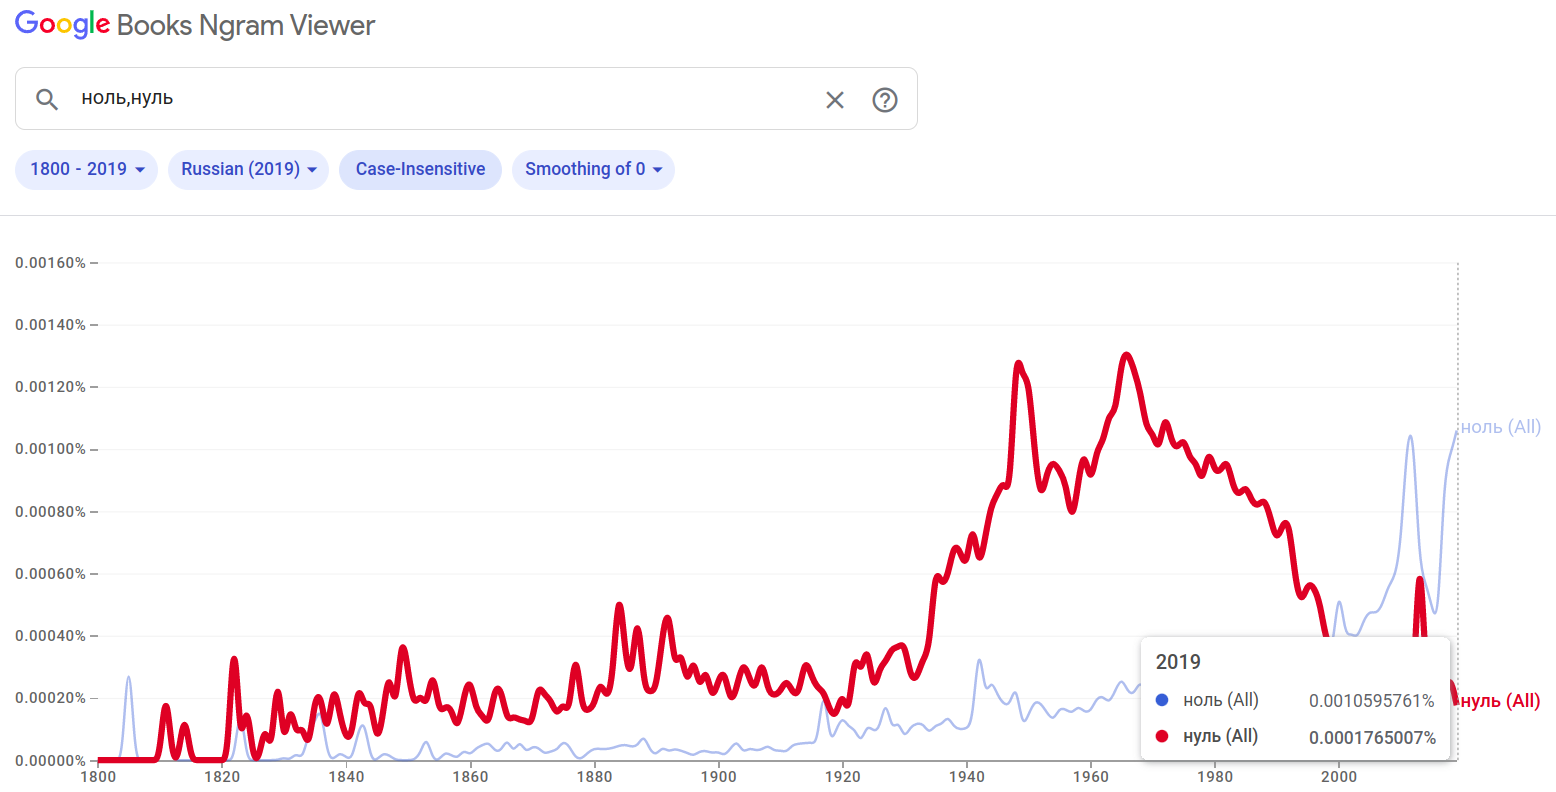

In [56]:
display.Image(b64decode(base64_ngramm_image))

In [57]:
nol_ngram = 0.0010595761
nul_ngram = 0.0001765007
print(f'Соотношение нолей к нулям: {nol_ngram / nul_ngram}')
print(f'Соотношение нулей к нолям: {nul_ngram / nol_ngram}')

Соотношение нолей к нулям: 6.003240213778189
Соотношение нулей к нолям: 0.16657670930856217


Замечание: НКРЯ и Google Books Ngram ищут словоформы, а в livejournal'е мы считали лексемы.

Таким образом, данные НКРЯ и Google Books Ngram не совпали с livejournal. Видимо, "нуль" чаще употребляется в разговорной речи, а "ноль" в книгах.

## Пункт 5

In [63]:
priti = 'iVBORw0KGgoAAAANSUhEUgAABkcAAAMnCAYAAACEGYWbAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAaPoSURBVHgB7N0LQNRV3v/xj8CAgEgoXrBAA0s0xLznpcRNbUvT0m6W2dq9v9XWttVu9Wy1z3bfLmv1ZO2Wm9lmZm6WZakVlpfymkYKJZRiIoIS98sA/n9nZlBA0EEYhOb9ep5Zh5nzm/n9fnOYmPOZc75tDloEAAAAAAAAAADgJXwEAAAAAAAAAADgRQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXsVPzShr/0F9uaZS21MqlZV90PpZ6tTReV+n8DY6e7ivevdqY93WRt7g0m+ePHQ9LiRKD8ZcIQAAAAAAAAAA4FnNEo5UhSLvvl9Rx32H22xLKXeEJeeM8NXkC331a7ev7Bd9ceA7x3UTjgAAAAAAAAAAAM/zeDhiZon87e/lbrc3YYkJUb5YXaH777Z5zSwSAAAAAAAAAADQPDwajnyxplIvz6kZjJiZIWYJrd69fNT79DaOMCR7/0FHiLIt5eChdub2RVZIctOMZl35CwAAAAAAAAAA/Mp5LHkwYUftYKRPrza6/4+2Grf1rrpyoW+N5bdMW4KRppW97And/25a/Q1sQWrfNUp9+ydo7Jj+ighQC2PX5n/dqdnr7ZJPf10362YNsan57Vyo+x9fruxK80OQ4mY8rNvOan/0bSqT9Opdz2tdkXU9/jq9MHOITsSutxqlmzX7T7O12ZyvdkN02+PXKc6tE5at5U/cr4Wmm/tE6oL/eUCTfFbr1ZcXanNeqPpPuUnXDY8QAAAAAAAAAO/mIw+pvZTWlIm+RwQjtZkltEytEROKHKstPMBepLz0ZK1+f7Ye+dtsrd5jF46lSEnvvqPNBUJTCojT0DOCnNcLkvR1ipt9cd86ff2T63rkAI3oZgVqSxZq3Z4i2QsytO6dj5REtwYAAAAAAAC8nkemZtSeMWKCkYYUWD9nuMcyGzjYFBE/RNHtat5qt+cqIyVF6Xl22fdt1txZcxX0wHXq3044mrx1Wvj+CMVdGctskCZjU9zAOAWtX2fFT0VK3pgie1zcMc9vxvpNSq90Xo8eNETh1r97bdXe5vxs8nP/rQgAAAAAAADAr5RHwhFTa6SKWR6rIcEImkOoep03XVN71nGXPUOrX31GczfnSTnWoP8n49R/SqRQD5PjWd09+8v5WnzW/bokmnikqdj6DFVcu3VaV2DlT0mblGKPO8bSWhnavDndtXG0hg4Od1yNu/gaXVDwnjbnhqv/xIsUS/YKAAAAAAAAeL0mD0eqByNGcwQjFf/+rypXrldl4jod/Oln+SQMUZseJ8tn1GD5/u5itx7j4L5/62DeSh3MTZRKf1Kb9glqE5ogtR/l/PcYTI0Vc+zmX1NM3oRCpuj82cN9rNucBecNc1tDZ8aUP/yi47jMcZrjqrr4PTjT8W+TskVoxPQr9e0Psx1LRWVv3aT0iyMVyYBynWJ/M1aFK5cr3QqVEucv14g/XaAIzlXTCOilofHttW6NFdTlfatNKXbFHS0d2WMFKT87r9p6DtWAMNft7eM0aaZ1EQAAAAAAAAA4NXk4UhUCVDFhgKeYwMA+4z5HKFJd1c8mTKh4/T3Z5jyq+kIEE4YcTH/YCkYSa95u/Vx1W5vOv5NP5IPWYG2POh9j0QcVjiLy1W2zApFtKRX6YnWF4xxUD43cDUfqOj5zm7lUHacJf0xI0qSCeqlvD2lzknU9L1u51j/MHalH5wRdOSpJT6zIkH3nR5q/cojuHB0uNAWbeg3pq/ZrVivP+r9vj7G0Vvq6zcqorNpuiNoLAAAAAAAAAOrW5OFI9v6Dh6536njs9rVnmhxN9VDBBASlp4455jYmQDDtAn5codoBiQlGKr8bfczHMLNKKqy2vnGfHxGQPPJ3uyMIqY+ZRZLVgGM89Jx1HF/V/leFI1WzScwMGTNbpukUqajIdTUgqN5OkrcjUcsSNytpxy5l51ob2IIU2jlK0fEjNO43QxR5jFoljd2+LtlfPq8n/pOkPHPKg6I16Y4/6ILuzuH0op2rtXz5Om1Os54vp0h23yC17xqlvgMTNPY3/RURoAYrs/srevwlGrH5ea3eb1fykre0+szbNCJMx8GujI3L9dGX65S8M1t5dpvah3VVzJlDrfORoOiwdC1++G/6aI/VNG66nr1thBwly/d+pL89vNhRayP2ymd15ygrKPjqI3342Wal7MlWkV2KnvKI7h3nDG3sOclavSJRXyelau/+PBVV2BTULlxdY3ppwMixSogLrxVA2LX5X3dq9nrrgcISdO+jUxWdm6zET5Zr1Tdp2ptrl83az+j+o3XR+BGKdNVRV16aEj/6UKu+26W9OXnW69teXaMHaOT545XQ073owtZziPqGrdbqHOfSWqn2OMXWlY5UpmvT5gzndTPj5Mygw/ftWayH/vcjR3ASMf4hPTQx4sjtzb5+8rl1TpId+1pUGeQ491G9+mrkuLHq37nak6a8pbufSbTiGuvxzn9AD11UR3RY7TUx5+xO65wduZxXtpY/cb8Wppk2I6w206u1cfaF5Ws2KeWn/co1L2JQoMJPjlXc4NEaNyJa7X3qf053+gEAAAAAAADgzZo8HMnKPhwUuDNrpHbx9vqYoOWc4f6HfjYzKqrze+hW+V5zkUyAYAIRM2PEBAdVzM81ZliU/nREMOLTc45zCS0rAHHMKMl63RGMVLU/uO91tTEzSFxMsFM9GDFLad04w8/a1zaOGTTbvz/omDliApKGqn585piqzxBxhCLW8ZQ/9MKh2SUm/Gkq9pTlSvzJed3WI0ZRtV9GU5dk3st666sMawi3mtIiZacnOy7rPl+mhBm3a2p8HYPgjd2+HnmbX9WzVcFIQKTG3nibKxixK+3DZ/T8kjRr0LvaBpVFyrOea7W5fBmnqbfcrITIhtUMsdvLrEHrOF0ypb++fWWz8gqS9N67m9X/+v4KasgDlaYr8V+z9NbWvOqPrrx9adq8zLqsWqWx113iRsH3/Vr3r9l6dX324Zt8IhTb2zkgnr1+rl54Y7UySmschYryMpS22VysIOKs6br1miEKr+fXN3fbQj3x6nKlFVV7hP3pSloxV0lbU3Xz3dMVl/2RXnhpsZJrHE6e0pMS9da2TUq+5l7dfJYbg/S2GA2x+sDqlc6ltdbtsFvHUsdZSP9a6/Y5rwbFjVRcA05+3ua3NGtOotJrnJMix7lPMpfVn6v/ZbfrutGRzvMf3Vd92ydqtbVLGdu+VbYVjtQ+kuyt3x4qDK+cJCX9ZAUW0bWfOEVJrhIpQb0HKKbqfFt9Yfkrs7QwKa9m+wIrMElZ57is/jJB1906VXH1/nocvR8AAAAAAAAA3q7J17zqFN7m0PXqs0iakqnBUX2pKf/PX69Rf8PMojBLaZnA5NA2VpBQPSwxQUd1Pmd87lg+q2pmiAlJTFjiE/nQoTaV6Q85QhIjyzq26sGOCUbu/6PNEYwYJhgy9VbOGdHwmiuOGirVjs9xLNWCnap6KtVnktQOi45LaZ7S1rylZ2YnKtsM7NqsgOH8WoP8ldlKnP2k5lYFGz5BiogbooRxYzV21BDFdnW1LrIG+196Qq9urjXA29jt61G0faGeeXWda7/DNeL623VJb+dj2a37Xq0KRszzxY/Q2ImTdMEY6/k6u55vf5LeevEtJRWpYSqd8U7QwCt1kWtEPm/jQi3cbm/AY2RYx/rM4WDE1l6R/a19NOfk7P6KDrM5zsfyV97Qul+O/lC5X72uua4BcVv7CEVERij85Dj1tbqKPW2hXnjtcDAS1C1OI8ZcoEkXXaCxZ8Uq3DFzxhqA/+pVvbAgWXUeQdEm/ccRjNgU3tv1uln7eGiWz77Vmvvaq5r9ijMYsXWM1ZDRY61zPUL9u7tG8ivztPnttxzhwrHZFDtkgCt8MEtrpda5X2nrNjtfe6u3xg2OczuYKto6V0+8UhWM2NQ+ur9GjLtAF4xL0JDeEQryce3v/Gc0+0tX0GDrpb69XM+wxwo4jjgOq/2WtGo/ZyupqlB8NfYfvlWq3bXP8b2cwYsVHC6f9czhYKRdhOLOSrB+D8cqYbh1nsOqZkElavazC5VWqjodrR8AAAAAAAAA8MDMkeqqzyKpjwkVjrZ9XbMuqgcHZkZFfUtKmUDBBA2HanSsXK+qAu2OoMPFBCD1FV13zBQxs0dcoYiZUeIIUWoxM0bqYgIScxwNWT7M7GeV6sdXNWOk+jFVqf3z0VkBxVM3KfFoTcJidcG06zSpe81v6Wd/9qo1cOtMEGydh2jqLdM1olv1NkVKX/GqZr1rZnBka928/6hvzM0a0r5ptq+LqfXx/CvLlWEGmn3CNeSaOzW92oyT1I2bXAPn7dX/2v/RzYOrPdileUp+Z5Ze+GyvQrvaVFQgNWzKR5X2GnH5BVr1gxmwztbq+Ys18oFLFO3GRJTsz+ZaYYrrnHQdoekzp2pI9WWc7Nna/M4LenVlhrKP8VgZaemO5cTGTrdeu/61lseKnqSbbgzS4g+t358R12n66Mgah3rJRSYgmq3EdCsgWbVUq8+LVULt5cGsAC3PxzqP0+7VdWdXe/yJm/Xq47O1br8JqtbJlKsJipuqe25OUMShRkVKmveInjchQ1GSVq3LtsIZN2YyRA9V/86JWr7PLK21zgoUYmsurVWZpk1bXWemfX8NjXNz9o+1D2+9sdoVqEVoxIxbNXVgzXNWtHO5Xp61UMkF1r6/t1Cb+9+s/u1s6tWvl4LWb1aRPVXfbitSwlnVzmTeJiXtNFdsCrJuLiqyzmfSJmVMidThBb3sSklKcQY9ASZscT5rxoq5WrzD2ReCel+i224cq+jqL5LpC29bfeFLK1zcs1xzPxmqhyYeuazXUfsBAAAAAAAAgKafOXL28MMzJUywUbtAe21mtkV9l+rLclW/Xj0cqa/QepXqwcmhAMEVdBzSfpSOpnpwcjBvpePfL6uFHWbJr6oZI3VpTFF6c3xmv81sGVODpGoprSpmdoxZUsvMnmk6NoVHRisqPLDmzfZkLV+R5hzQDYrVJbddVyvYcNyhyDE36/YJriWICjbro8/Sm2b7uuxN1OwXFjuXeLIG7eOuuFXTB1cfcLervMQ1w8cnVFGRtVOW9oqdcrse+tuzeuQOE0ro+HUeqyvHuPbb2q//LMs49jbmnHxW7ZzMnF4zGDFs4ep/5R80Nd6d1CbcGuS/TZfUOSBuU0T/C3TzAw/p5lrBiENYnKZebYUZpruaQf/tdU+jaT/kGk0/u9bjW6HEBWdVq+XRrr+mzqgejDgOUHHjEhTt+nVI/yldbs2v8YnWgHjXa5rjXFqrhrSvtdm1pFb7fkPUy80kIPvrD+WcmGRT9PibNH3gkecsqPtY3XSFa/ZUQZISNzpndAT17qto10ybtO1pNY6jKMk1I8QKPS44P8bVH749tI8OlelKTnEFYqf1dS4DZvrCStdjtR+i6bWDEUdj0xeu09huzh8z1qxSWp1vsUfrBwAAAAAAAACafOZI71ozQcyMieMNB6oHK1XLddWeIWGWlzoac3/VclpVocrBkp9qtGnTtsdRH6ONqUFS9UOtbavvW33cKUxfXfXwx4Qh5lJjf2rVIGk4myIHjlBM7Zyg0q7cvSlK+SFb2Vs/0uyUbzX2lj8cWp5K6UlKynFeDR86SSM6H+Xxx1yk/p89r3UF1gCuNViccVGkIhq7fe1mOev06qy3XMsaBSn24tt186iIWoPBNkWdFiXb+mTZrQHpj16aLU0cp5Fx0WpfVYDdClXCG/ga1Sfy/CuVsPEJLd9rV/on85U4+E4lHC1wcfuctNeICSO0PGm5o7B4vaITdMExQpSiPZuVuHyVNu3Ypf05VQXZQ9UxqpcGnBkkZyRm1/59ZtpW7ccK14BRdS9bFX5yV+tsO5dLa98/Qf3b1dUoQuHWxmnW62ovyHW0dWfwPnpIf4V/tlzZlXn6dnOq7L1jD22Xti7JNaPG2rfBMW6GAUVK2eIKZ3y6KqpzrpK359bd1C9cHa23sCLr9yM1xXruUf1la9dXfaNtStpuV5H1e5JaGecqpl6kpK3OGSG20wZo6GC7kt5PVrI9Xd9uzdYFVTNlrLDE+brbFBPf13k+d25WiqsvBPWw+uxOa7t69j40wvrl3WN1/NwUfbvXOj/dajWIPnY/AAAAAAAAALxZk4cjZgaFWSqrqlC5CUfOGd7wgMQEI9WX1Op9ujOAMMFA1WwK41jLSR3cuefQ9apZJrWX0DJhSRtXrZFjcgUp4R3byF2mMHtDVD++2rebQKRqabDjF6qY30zV1J5131uUsljPz/5IaabOxWtvKebB6xwD3UU/p7sGoYMU3Svy6IPQAdGOweN1W61h4n27ZGUFCm3k9jVnIVhBx/NJyqjWRwLDQut8zPbDL9Gkjc9oYUqR7Hs3a/Er1sUnyDE7JrpXrAb0H6q46PZN8w17W7QuuHSENr+4WtmlyVr8zmoNmDlCjhyqjl8Bxzl11co45jmJjFN0OyscOUqtjvDoGNW/UJVdacte0Ev/TXYWra92e1FetoqSsk1Wc/hWex3zOkyQ0LXuR7cFBDn232zV7eRu9RxLkIJsh55W5XJT5FAN6bxcH1lBQN7WzUq91LW0lj1ZX1ctqdW5v4ae5uarWLlXu/a5js8KzRJfefboy8xV7XJ2hnJlBTXWKzogLlJvbU9zBBQp1q9rrFndqjRFm1KckY8JPdqHlclqpmSrWfrWJOWNSXD0hbxtyc6QyydSca6q6kUZew8tm1a0daGe3+rGDlXmKjvber5aM7CO3g8AAAAAAAAANPmyWkbt+humcHlWA4qz11XsvHq4Un0prer1OepSvQh7jVChehjiWiqrPpWm5kjVc7u2qz4bxARBRzs+d2qvVFe7hopZOqvtwe2O5bMaH4wcW1CvSbpuouub+XmbtWy9czS+vLSsqoWCQo41CG21qRoFtwbZi+yN376Gymxl7KuxmJE2L3hHmwvqeChTWP6Oh3XnlBHO4uaO7YuUvTNJ65Yt1Own7tZ9T72lzfsaUET9aHsed4kuGega8N76nt7ZaJZP8pOtjt+2hp2TYEcNi6Ox2ep/DFN8/KV3q4KRIEUMvEBTb75T9953r+6942ZNnzhCsR2PtQ822dzIH/z8mjh3tUKEAQNdc4dyNmmzq965fcc6bXLNtog4c+ihJbuOzQrKStVwpXYVu4Kl9vEDFOko2J6hb5OcsYY9ZZMcq2UdCj3CrX+dNUHsaZv1bZ7zub/d7loqLrKv+rveSw73hYYoUlEdx2GzuRkSAQAAAAAAAF7KIwXZzeyRKRN99e77FY6fzQyQR56y65wRvo4C5UdjQoZXHGHK4dtqb2PCg6qlp0z44XvNRaqrKLup01HfzBIze+SgK/Qwxdl9O19TMzBxqdwxo0aNkjamnZx1RExAUrWfpgbJ2cN9jqg9YmbANKQYu3GspcIO7Zt1Duwz7pNtzqOqryj98QqPj1PkgmSlVdq196dd1i1x8gvwd91rDcjmH2tBJLujELWDNVBrco7Gbl/nfg6erkvClmu2qe+Rt07/eXeoel1Tx7JPPu0VO266dZmqvPRUJackWZdUfZuSpjxrcDlvR6JmP1Okmx+4ru7loBokSP2nXKS47+YqqShP695dqBG9hshWR9dv2DkptM6JjpO1H59tlqtihuKuvF83j6pZjyK6d3+NODtKz977lpIb1mWbReSg/opYmqGMyjxt2pisqb1ilLrxW+cx+USo/5DIBjxakGxmWTUTpkVO0kMPXHDksm3H0jlOA05eqHQr59i7PUl554/Qrs3JcrxE1UKPiPi+iliSrgx7qjZtK9KI/ilKTnP27Yi4/odmeBzuCzYNuflZXdefgAMAAAAAAADwFI/MHDFMoGECkiomRDBhySN/tzvCgur1REwgYi6LPqjQHX+yH1qSyzCPUXtJLrO0VPXZI2Wjr6kRhFSFBtVrdZjwoHqNDp/IB2uEIRUbT3WGJa4g5GBuoiqTRh8KUJzbPFRjGxP2VDHHZkId53Jgzv03x/O3v7u9cFCNfa0+Q8RRd8Q6vkM1U1wF2s1xm+vmWKvPkGlyFc6lkoJO7uoayC1SWkr60bcpTdG3P7nCjc5R6mpr/Pa1tY+frjuvHaH+E6YfquuR99VbWrj9aDNAbGofGashYy7R9Jn36qnHH9DU/q7iKznr9OGX2WoSYSM0dXy0M3zYv1rzrcHxunKPoJMja5yTo85d+TnFUavjuFTuUcbeqvM5QuPPrqdQ974M1zJfLVC3IRri+rXPS9qs5KIUrdviWmPsZOu+hmQjjjojrjOwL/U4z2uE+sY5IxX7T8lKzjNF7J37Uz300MkDFOf4wa60rSkqSvvW2nc5Ap24focjmaCIqt8Pq13aXgEAAAAAAADwHI+FI4aZSVE9IDFM8GGWzDKhwR1/KtNVN5Q5AhFzqZppUsVsW99ME//PX1f1gMQECKWnjlFJm96O0KB6WGDamfY1WCGHT+ff1Qg7zCwRE5JUrGmjyu+sYCQvsUb7NiZQqcbsW59qBejNsTmPy+44rtrH0xC1AyBzfOa4zPGZ46we/JiApHrbppC9eZPSXYPkHSM6OgfSI/srLsx1/9eLlbi//u0zPvtQm13j1hFxfZ3fym/s9tX5xOnS60co3PTggGhNutx1vTJbq/+zUGmHlhoqUsbm5Zr7zP16aF7ykeFDUKQSJo87tBzT/r1NNygd/psrdUGkcwA+Y+VHWpdTR6PIuBrnZPW++h4tT+s+TDx6MfYGsNXzHKuXrlMTxUMeEKEhA10JyP4krVv69aE+Ej1kSANnfgSpbz9X8fbSJC1fcZRgal+iZj/6vBZ+mVarVov18sXHOQMNE+Z9ts5ZZN0nvEbo4VgS7AxXBJbytZZvTnHOdgnrpQHVA53u/dWrqi+s+bDu/uJ8FCW/84SemPORNu9tmqXgAAAAAAAAAG/j0XDELDFlAoQH/uhXI0SokrW/vu2km2b4HXUJLhMGmOWkjhUKmFkYRwQjVY9hhR0+PefUuZxWjXZWiOI78Mc677v/jzadM7z+02iOpa5jP5aqQMfUG3GnXVMuq5W3faFmv5/mHCyuXuvBFquxY1yzIYqStXDWXK07ok5HkdJXztYLVdu3i9MFv4lsmu1rsNXovdXrfJjB7LlLXNsrV5uXLtTqlGxlrH5Vr36ZccQgeHZKsva6Br2D2h2jqEdDWOdu7BUJinCENkVH1k1xHIZ1Tn5T7Zy8WMc5qcxT0juzNHfzca+pZe1LlKJOrpop8bU+XJd9xHNs/s8svZXUiOdoBuEDq+qKWCHYsnXOJax8oq0+2vDy4+2HjtUQVxiR8ckszV6WptpHb9+7Tq++uFCbd1oByrxn9OrqvJoNelSFW0XavMIVLIXF1Qw9LJH9ejkKsavAepw1znPfPq5/zRop1ftCwWbNfbGuOjhWMPLhy3p5RZrSvlqs2da+pZGPAAAAAAAAAA3mkZojtZllsW4Mb6PtKQePWoPDBAnu1CWpYgIBU6TczBKpeP29Q8tqmcDAXOqrRVKdqT1igo+D6Q87ltI6aJbVsi4mEHHc3+kaR5ujMUHOOcMrtf175/GZAuxVS4GZ+8zyWttSnLNIOoXXDEraqP7gxByDYwZJ926OwvPm+MzSWlXHV3upMPflKmWpFRTUUVujaF+aUtKyXQGCTRFjrtTYrofvD//Ndbpk+yOOQXT73tV69cFvtSyur2K6hspmtwKIlCQl7XENMfuEa8iV12hI+6bbvn5B6n/Zpeq//VVHUfaMz/+jj4bcq0mREVZAMVbrnlmuDLsVAMx7SPet6a8BvaMUbrMrI22zNidlOAfFbZEaMSJaTcnW8wJdMmKznj/Kcl3hY6ZrUtKTWpjiOid/dZ6TWOucqCBDqduSlLbfekUCwhXum63s48ovgjRkzAh9tC1R2SYImfOQ7l8/RP2jwxVUkq2Ub9Yp2QzEdwxX+5zsI2ZItBidrdeuhxUIpB2+yXbaUA3tqIYLitMl0xKU8qLznCS9+4Tu/zJWcb0jFR5gV+7eVKtvpKvoUAH2qbp6RK3O6BOjvr3bK3FNnux2529N+z79nYXaq7H1HKDYdqu1rsAuZ7Mg9Y2POWKXIqy+cInVF94yfSE9UbP/ukmRvV19oTRb6ds3O18nx4NafXvaJEVTmgQAAAAAAABosGYJRwwzi6TT8DaOWRY3zdChuhzZVpAQbgUGtQuZN4Spz1G9RsfxMLNIai+b1RAmDOndy7pSR7BjwpK6rBzyqNzRFMdXkxUKJK1TxlHbBClyzHW6fUp0zSWYrMAi4eZ7ZJv3st76KkN2a1A5fetq61J780glTL/9cD2Pptr+aNoP0SUXfa2UeUkqsqdr+RvLNeRPFygi+hL94Ua7Zs1JVLoVLORZgUiidanBGmgecs3NuqCbmliQ4i66REO2zNa6vHqa+FiD3DP/IL0ySwuTrEZWiJO+2TonNR4mUmNnXCLbf5/VR8c5ucPW+xLdPCVbs95NssIPu7KTVmt5UrUG7eM09ZahSn7UCpjUUoWr/8BoLTyUjtjUa/AANaCX1BAUN1X3zrTppVeXK63IhIPJWmddarJCwrOm6qZprqXbat3XKz5WQWtcs1is1zs2PubIZctsvaxALkjr1hdVPbH6nlZHqmH1hYSZ90ivv6CFG62Q0l7P70f7WF1w7XWa1KsJZzoBAAAAAAAAXqTZwpHaqsKQxoQiLYGZBfPlmgrdOMOv3mOpPlOm9+kt+Hh9bLK1C1VkTH8NHTNOCT3rGXK2goQRMx5S3+GJWvblZiXt2KXsXGvQ1xak0M5Rio4bonFjRiiynTyz/VGEnz1VF3z1kBbusMu+8yPN/ay/7h0T4fjW/wN/GarEFcv09dZUpWfnWRGRTe3DIxXVe4BGn5eguI4e+gp+u/66dGKckkxoU1+bACv8uO1Rxa3/SB9Z5yQ5PVt5dmsMPCxSMfFDlWCdj9jQdL0139ncZp2rhu+tzQq8btPDp63WR5+s0uaUdMcslKDQcEXHJ2j8hARFB65Tslo2x9Ja76U5l5MK6KWh/Y83GnFqH3eJ7v3foVr32TKt3pqmXfuyrXDN5jgvXXvGaWjCOI2wfhfqO9+2Xn3VK2idHKueBVkhSK+6WlohSr9esq3f7JiV5dgmoJ4HDLACkhsfUlxSopav2qSk1L3KLSiS3XrNw7tGq1f/kRo7qr8iyEUAAAAAAACA49bmoEU4LqagfFXdFFM83hSgrx2QmOLzVeGIWTbsucf9BRyXvEQ9e+9bSq40S3Hdq0cubdolwAAAAAAAAADAW5ywmSO/BqY+yrvvO2uJmH9NvRGzvFa4KyAxM0q2pRys0R6oLW/nOq36crXW7YrU9LsuUXSdMwrsSk9c5QhGzNJN0b0iBQAAAAAAAAA4PoQjjVBVOL4qIDFBSFXh9dr69GrjdqF5eBO7dn32jhZ/ZQqSJOulf4Xr9hkJigyq2Sbjy7mavdRVhaTrCI2Oowo3AAAAAAAAABwvltVqAmbZrEXvlx9aYqs2s+QWwQjqlbNOs594VZtzXD8HRSg2vpciw6yEpChb6SlJSt7rqlZii1DCbfdoKoW4AQAAAAAAAOC4EY40IbOs1vbvDyor+6A6hbdxLK/Vu1ebVl90Hp5n37tac196S+v22utv1C5aY2fcokviGleAHAAAAAAAAAC8HeEI0FJU5ilt9ef6fOO3Skvfq+wiu2xt2yu0U5R69Ruq0aOH1FpuCwAAAAAAAABwPAhHAAAAAAAAAACAV/ERAAAAAAAAAACAFyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAV/FTM8nNzVVhYaFKSkpUXl4uAAAAAEDr5Ofnp7Zt2yo4OFihoaECAAAAWps2By3yIBOK7N+/XwEBAQoJCVFgYKDjD+k2bdrI65gz7YWHDQAAANTA38WtmvkIab7wVlxcrPz8fJWWlqpjx46EJAAAAGhVPBqO7Nu3zzFTJDw8XEFBQQIAAAAA/LoUFRUpOzvbMZOkc+fOAgAAAFoDj4UjJhix2+3q1q2bd84SAQAAAAAvYT5W7tmzRzabjYAEAAAArYJHCrKbpbTMjBGCEQAAAAD49TOf+8znP/M50HweBAAAAFo6j4QjpsaIWUqLYAQAAAAAvIP5/Gc+B5rPgwAAAEBL1+ThiPmWkCm+To0RAAAAAPAu5nOg+TzI7BEAAAC0dE0ejhQWFiokJEQAAAAAAO9jPg+az4UAAABAS9bk4YhZYzYwMFBeyyPl7QEAAAAvwd/TrZ75PGg+FwIAAAAtWZOHI+Xl5fLz85PXoswKAAAAcPz4e7rVM58HzedCAAAAoCXzSEF2CrEDAAAAgHfi8yAAAABaA4+EIwAAAAAAAAAAAC0V4QgAAAAAAAAAAPAqhCMAAAAAAAAAAMCrEI4AAAAAAAAAAACvQjgCAAAAAAAAAAC8CuEIAAAAAAAAAADwKoQjAAAAAAAAAADAqxCOeEh0dLQAAAAAAAAAAEDLQzgCAAAAAAAAAAC8ip8AAAAAAK1beb4y0/do974s5RWWq9z6qOcXHKIunbspMrKTQvjkBwAAANTQuv9Etj4A7M/OV36pHH/4d+wQokDmwgAAAADwEvk7N+izxK+1MXmP8svraeQXopNj+2lkwkid1T1EAAAAAFplOFKu/NSv9OFnG7R1R5aKK6vdFRCmHr37afTY0YrvzFejalv7P0N17frLtPDDu3SGr1T66R0aeutu3bpkoa6PEQAAAIDWonCXPl+0SB9tzVL5sdqW5+vnpFV6O+krJcaP1RWTR6pHsAAAAACv1roShPIcbVz0uuavr+cDQGmOfvomUXO2blTvidM1Y0Q32YQqZwwbpvYLP9Ebn16mh8/K04L5a1V6yiQN6CEAAAAArYR9z1ea89oH2p7rusEvRD3i+im+Ty/16dFJ7UNCFKgS5efna296irZ9+502Ju1Sfnm5Mrcu1T92pmnKtVdqZDe+UAYAAADv1eagRU3o+++/1+mnn64mV5mjr15/WW9vy3f+7Bem0/pbHwBiuql9oPUBITdLPyV/o43bslTsaNBWPc67Tv9vzIkJSKKjo5WWlqaWJUuJf7tFd8zdpDwrXQo4JUG3PvOcZg5qLwAAAMAbFKeu0lel/TS6T8OWl8rftkobAgZpdExbnUj2Pav0z1eW6odC85OfOvQZrSkXjlSf8KMHHfacFCW+/4GWJeU4v2gWHK2JN16j0R4KSDz2uRAAAABoIq0mHNm94kX945M9jj/kA085S1dMP1/xYUf+IV/8Y6LmvLFcP5gMxSdMI2+8Q1Nimv8bUS0zHHEqzUlX+oG26my+VeYrAAAAwCsUf79UL85dpZ8rOmnoVdfpijj3ApL8pP/qxTc3KNO3mxKmX6dJp5+ggCT/O73xj/9ok5kx4tNWp429RjPGRCnwUINy7U/9TtvTc1SstuoQ2UvxMWHVvixWop9WvKnXlqcp3yxPHNZPM267TPEeKENCOAIAAICWrnWUL8/foI++cAYjCj9LM268sM5gxAg8NUE3XD9WPQLknG2y9Cvt1wmy+VGNOz3aEZTUeTl9qB5c5WpbsUlPj41W7ykvKnHZi7rjsnEaGtdbvQeO0iV3vai1e2s+dPorl6h3dG/dsazWc+58Q9POtB477hZ9Ulr12In600DrsSe9qB0ypVki1TPGBCOlWvs/oxz7cuGz3zmamrok9e6vY5/H6dHNpmWeFtzQW9G9r9WCrJq7kPXBHRpqHXfv6W8oq6WfmyprH9SoevZn1N/WOpqUfnCL9bhH2WfrOS95Jf349wEAAAAeVV5WovIKcyVLX7/5quYn5R9zm0PBiPkwUmFXcZldJ0a+Nr63yBmMWMHHaedfpxuqBSP27O/07j8e099mL9C7Hy7XRx9+oHmz/64H//GBtmZXLUrcVj3GXKOZ50c7t8vZovnvbdGxzwIAAADw69MqFpnNT9qiHxxrZYVowIVjdVrg0dvbuiVoyohv9PRnWSpP36JN+0ZqbGedMO37TtTVIyNr3Ja1/g0t+ObItqXbXtAtf+6phEsv062TA7Rv/WK98cHTunbrPr307sNKOOoKWFl6//EXtCbPuhqkYyrd/IIeXZhe47ZTEm7QXZ1do/a5G7VgbqLST5+omeedJsf34/zaa0DEUR40L1FPP/O+ssyyXTq2FnNuSktVYvYnZrgG9Axx7Hvp/m1au+Hw+QnodZFuvTPO9VO61s5boDWlA3TZNaMV6fpN6jQ49Pj3AQAAAB4VEnexZl4lV9jhDEh0lBkkNYIRv4bNNmlq9h8T9dHWEsf1kHjrb+iEassH53+n+bNdM0pqKd79lebMLtaM31fNEPFTl4TLNCX9Rc3bmq/ipOVa9uMZmnIq9UcAAADgXVrBX8Dl+jHNNWskuJcGujmF/ZT+Z6hLYqIyK/fpx53Wh4jOJ25t4IABl+uuu4fVuG3T459YAUAdn158e+r6fy3UXf1d0cIVl+m3p1ylS55foKdfv0wJt51R7/PkLXtaT39a71yNmip26F+P/Uvf1Zq9EHnu9Zp5ruuHnf/S528mal/P83Xrbee5EXaUatOsR7V4p9zWYs5NWYnyygN0xuSH9NotPZ23bXhUo6781+E2p5+nmdbFoWKTSt434cgZmnT7TA1zY3myBr0+AAAA8Ah3A5KWFIyY5bC2fvGNDpirAdEaN7GfDu9JuX5YvtQVjPjp5KEX6pJz49RF+7Rl+Qd6d731WSp3ixYvH6Tek6NdgUqIBk5M0NcpH+iH0hxt/OI7XXBqPwUKAAAA8B6tYFmtYuXlO78hpbAwdXE3zgnvrC6Ooyu3tm9FE8U7DNDw+OoxhDVgf910JbQv1Y4ViY5lsepUtFZPP7VA+7qfp/P6HDvGSJ//qP75TYCGnzdcTVaOfdu/9Oj8Hep83nka4M60kYby4LkpLXWmRG2DPLHjavDrAwAAAM9xBCRXD3J+tqhjia2WFYxYilO09QfXrJG4kRpafbJy5R5tTc5xXPU7/XzddMkg9Qhrq8CwKJ112XRNctVfPJD8nX6urLZd6CAluI6p+IfvtI0lXwEAAOBlWkE4YpNf1bfyK6VydzerkOyuP/5tPq18inj7PorrHqDSnT8otc4PLaX67uVHtWBnpCb96VYNPNaSTVnv69FZidLgW/XQxaeoSVSk641H/qlNwefprjtHN13gcixNdG7yCp0b+wcfbVms49XA1wcAAAAeF9Kn7oCkxQUjxp5d+tHx52pbnRYXU63AusUnUKedlaCxY8Zq0m/OUM09DVGP7mHOq0XFyqsejsjPeixX7ZHSXfpptwAAAACv0grCkbZqH+paEmv/Hu129xtN1geITMcf/yHq0u0Ef5hptAC1b2f9U16q0iOO37rh+zf04Kvfqf0F9+muhGPEEhV5SnzqaX2Sd4ZuuP9q9fRXk8j676N6er00/Pb7NLFrcy5h1jTnJjcry2odoM7hTR3rNPD1AQAAQLM5IiB54+/66xstLBixFO/b5yya7tNZp5xc+4tfnRT/m7G64LwEjYypta+VWfoh1TmrRF27qfamtpO7uWbb5ytzX4kAAAAAb9IKwhHp1NNinMVRSlP09SZ3lsgq0bavv3OuyRscrfjurXzmiBVo7Mu1Btn9AhRQe0Wm8nQtePwFbQpI0F1/PE+djlH7Im/tC3r0vX3qedXDur6JlncqzfpEjzzziUrPvEEPXRGpZtUk56ZU21LSrZylp3qeqqbVwNcHAAAAzatGQFJZrnLzBasWFIwYRcWu4MInRO3d3SUr7Pnqrdf1/k4r6fEJ08hxZ6lj7TYhIQr0qXqOYgEAAADepFWEI4F9BmqgY7Wjcv3wyQKt2nv0xbXyt76vdzc7Q5QOA89Sqy/xkLVJm3+yxu67n6aYWseS/dHTenpVqYbPvE+XHWOFrNLSJP3z8Te04+RJuu/2AWqa05KnNc8/qvdzztD1f75ePZt78L8pzk1Roj5bnyd1H6ZhTbTKWIP3AQAAAKiH20sLVylM0eLnX9Db3+Q4ApX4yddpyumt/AtjAAAAQBNrFeGIAnpp/HjX+rmFaXp39qtanJQje+12lfn6KfE/eu7NLTpgvvEVcoYuSIhSq5K1VosTs6rdkKfEWW9oTVGAeo45Tz1rNC7Vmo8+UV7v6/Xnq3oe+7G//0SffN9eE/9wl5psdafSTfrkk3RFXnKfbu3v4RTKQ+fmu9f/qU+yAjRg0iSd0aThTgNfHwAAADS7/G3/1YtVS2n5+MnPfEKqo0j7idQ+0LVsrfV5J++Yu5SvjYsWKHGPOSArGLnkJs0YGlZP03wVu+qQBAUGCgAAAPAmrebrQyH9J+vaffl6ZcUuFRfuUuLrf9fXXaPV+9Ru6mj9HV+cm6Ufd6Tq59xq36uyxup3f71BHYcNUo9gtRLpWvz7CdqR8FsN6B6gfeutQGNDugJOv173XVPHALtfT139p1t1hpu5RPuRd+muCzupSXWdqPv+MOyoM1G+e/ZCXfjSPl392td6eKSOUxOfm9Lv9P6sF/TC65tUarXtlPuJXnz+k8P3Z2xSrvl362K9+FqpJl6boAYvGtbA1wcAAADNp0YwYpbSuvo6jdcK123OgEQtYHmtwM6drZgjTfmV+7T7Z2tnw47yMS7/O32d5FyGK2TgxbpicFi9Te0/7zlcp7Fzc9YNBAAAAE68VjS3uq16nHedft/hA835wPqwUmwFInvTtMm61OYXfoYuuLCbtr+xXImffKdV32bpxhvP12mtISDpdJmeeDRSa15ZoMWvpysvoLPOuNgKNO6eqWF1zPaIvOg+3TrMzZH3oAG69f7L1KRVQfza67w/3K/zwtxpbH3gaszMjKY+N6Wpeu+1T7TDUch9hz555Wl9Ule7DQv09O4ADbjGCkcauP8Nen0AAADQbOoKRq7oY0IQU4NELSsg6RalUwO+0tbSEv2QlCp7XC/Z6mtbaIUp3aPUQ4HqM6yX6p8PUm49VpoclUYCrPbdBAAAAHiVNgctakLff/+9Tj/9dHlU8R5tXLtRW7el6sfsHBVbg9u2wBB1ODlGfeIH6uyBUQrRHi1//mV9tNs5k8Sv28hmDUiio6OVlpbm/gYVm/T0by/Ri6VX683PH9awX1Xh7lIl3nOOrv0gUvctX6jrG1p7w1PnJu99XTv0Dq0d/LC+mHu1Oh3tuQut5/7y1/a6AAAAeKf6g5GjtDmhAUmJNr7+lOaZGSEB0Zpy93UaGarGyf1K//fUB/rB+iwVGHeZ/ueafmrKhbWa5XMhAAAA0AitsypfYDcN/I25HK1RN429/hoVvfK6Y73d8j2r9Moraj0zSH5N8hL18aostR92l86jKDkAAABOoPwkK/R4s1bo0efI0COkz8WaeZVcbU/0DJK2ih95pjokfaUDpWla9v4W9bu6n+rck9QP9JfZXynfunfkzX/SlJi6GuVr4/uJjmBECtPAc84QFUcAAADgbVpHQfbjFRytSTdeo4RuzgzIGZAs1Q+FQjMq3blDu9sn6K6mXtILAAAAaIA6g5GjhB0hcSYgGaQu5uPECS7SbotJ0AVxzrog+Vvf1xuJe2TX8ShX5hcL9O5W53EExo3VuFNb53fmAAAAgMb4dYcjBgHJCRfQd6bmffyaro5Ry2IFNk8sWaYPHp2kekvU+56hG/61TMveulUDWFILAACgVfPzbys/8zddA5bJqhGQ+NoU6G/TiRGigZMna4BjOa0S/bB0rv65YpezZkh1HU7X6DEJGjtmpHp3qH1niX5a8bpe/NBVayS0n66YXM8MFAAAAOBXrnXWHDkehWla7Fpiy/A7Zax+f1uCTvFQPNTgmiMAAAAAPK44dZW+Ku2n0X0aFgnkb1ulDQGDNDqmrU4k++5E/d8ry/WTI93wU4e40ZoycaT6hB199oc9J0WJ73+gZUk5cnwiCozSBTdep7GneGbWCDVHAAAA0NJ5TzhiVAUkewMVf8lNmjE4TAAAAADQmth3r9Kcfy/V9lzXDX4h6hHXT/F9z1CfyDC1DwlRoEqUn5+v/ekp2vLtd9qYtEv55a72ob008dorNbqb55bTIhwBAABAS+dd4YhRuEsbd4ZoYB+CEQAAAACtVH6ali9adHgmiFucM02umJyg0zy8lhbhCAAAAFo67wtHAAAAAOBXoVz5P27QZ19s1MbkPYdnhtTmF6KTY/vprHNGauSpzVNhhM+FAAAAaOk8N48aAAAAAOBBfgo59SxNMpfyfGXu3KXd+3KUV1xuxSZ+8gsMUcfO3XRq904K4ZMfAAAAUAN/IgMAAABAa+cXoi4xZ1gXAQAAAHCDjwAAAAAAAAAAALwI4QgAAAAAAAAAAPAqhCMAAAAAAAAAAMCrEI4AAAAAAAAAAACvQjgCAAAAAAAAAAC8CuEIAAAAAAAAAADwKh4JRw4ePCiv5cWHDgAAADQaf0+3el79eRAAAACtRpOHI35+fiovL5fXaiMAAAAAx4u/p1s983nQfC4EAAAAWrImD0fatm2r4uJiAQAAAAC8j/k8aD4XAgAAAC1Zk4cjwcHBys/PFwAAAADA+5jPg+ZzIQAAANCSNXk4EhoaqtLSUhUVFQkAAAAA4D3M50DzedB8LgQAAABaMo8UZO/YsaOys7MpxAcAAAAAXsJ8/jOfA83nQQAAAKCl80g4Yr4lZNaY3bNnDwEJAAAAAPzKmc995vOf+RzIrBEAAAC0Bm0OejC92Ldvn0pKShQeHq6goCB5PXOm2wgAAADwbvxd/KtiltIyM0ZMMNK5c2cBAAAArYFHwxEjNzdX+/fvV0BAgEJCQhQYGCg/Pz+1acOnIQAAAABobcxHyPLychUXFzuKr5saI2YpLWaMAAAAoDXxeDhSxYQkhYWFjpkk5g9pAAAAAEDrZL7wZmaKBAcHE4oAAACgVWq2cAQAAAAAAAAAAKAl8EhBdgAAAAAAAAAAgJaKcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVfzUQtjLpTLrUl7hvH7woPOClq1NG+fFZvUkP1/J3895vSWij3k3+ipam9bUZ0tKy1RaUqayMrvVZ8tVbnXeg1anPUjH9QptrI5qLn5WR7X5+cnf36aAtv5qG+AvAAAAAABaqjYHT+DIRYU18FdcZl1KnT8fNP930PqALbQ2phO1aXNQVa9eYIB1scZEfH11QtHHUBt9Fa1NS+2zJgQpKChSYWGxtS8+CggIsC422WzWxc+5c2bAHL9+VX9K2q1QzG63q7TUXEqt97VKBQcHql27IEdoAgAAAABAS3JCwpFK6xmtsRSVlDkHAHWQwZNfHddAXltrAM8aF5FPM7/E9DG4jb6K1uYE99mKykr98ku+IxQxg97m4t9Sp7TghCqzOwM0czEhyUknhcjXhxVdAQAAAAAtQ7OHI+Zb0QXFDAJ6DdcgXrtA57edmwN9DMeFvorW5gT0WTPIfSAnzxGIhFkD3cwMgTvMn5o5VqBm+k+HsPaO/gMAAAAAwInWrOFIflHVt6Pl+h94hTaO/3d8yznEw+Mh9DE0Cn0VrU0z9tn9B3JVVlamDh1OUoC/TUBDlZbZdeDAL/L391fHDqECAAAAAOBEarZwJLfQWVi4slLwUmYlDbPySmiwPII+hqZCX0Vr4+k+m5WV45gl0rFjKLNF0Cjmz879+3Md/3bqFCYAAAAAAE6UZglHHAOBdufa+vBuZm18m63pB/DoY2hq9FW0Np7qsyYY8fH14Zv+aFJmJlJlRSUBCQAAAADghPF4VUyzdIzjG9IMBELOfmD6g+kXTYU+Bk+gr6K18USfNQPYjhkjBCNoYqZPmb5l+hgAAAAAACeCR8MRU2zYrKnP0jGozvQH0y9M/2gs+hg8ib6K1qYp+6wpnm1qjJiltABPMH3L9DHT1wAAAAAAaG4eC0fMN1gLiqkzjLqZfmH6R2O+QU8fQ3Ogr6K1aYo+W2GlLAdy8hzF16kxAk8xfcv0MdPXKkiOAQAAAADNzGPhSKFjIPAgo4Go20Fn/zD95HjRx5qGPe1nLVpXopauYMtuLUoqU7Ojr6K1aYI++8sv+WrXLkgB/jahFasoU8GBAp2Ad063mT5m+prpcwAAAAAANCePhCMVFc5lPXSQb5viKKz+YfqJ6S8NRR9rGvYdO/WnR37Ski3Fsqtly0nbp7lPfauXNp2IgIS+ilamEX3WXl6uQitZCTspRF6pYKnuGTNGl728Q61XgZLm36/LLrxA50+5SNOe36aWzPQ10+dM3wMAAAAAoLn4yQOKy1zfklYjBgMrypS+aZ+WJe7TtlNi9PTU2mueVypnU7r+9V6mtqTbrWEAP3WNDtW4i6M1Oc6/RsuClN16dUGm1qeVqMDHT1ExHTXhih4aF+13XO0ar1Lpa3dp/if7tWVniWvfw6x973Hc++5wzHNmDTBv2am5/83WevO8bdvqzAFddfVVJysmSCeE6SfFZW3ULrBBmx1XH0t/d5Nu+2/NEMBm81OHLsEafPbJuuK3YQrz1QlQojWztuof2/11+d3xmhzt0VJAhxXt179m7VZq15P19NVhqvp+eEFahhZZv1eJycU6UCp16Byiwed119VjQtSu2ubN3TcjJ/bW9Unf6KXZ3yvmkTiN66Rm1Zx9tU72Yq1/f6f+uzZXqVnlKg2wKSr6JI2b2EMT+virRanI19x7t+rtvT4a9/uh+v3gZurTnmL9rrz64Pda5ttF9z0UrX5tzYwr6/dkg/ULEtlJlw8LdjU8Qb/L9TjePmvqP5hv8jd4Oa0Dm7Vozn+0aM13ysiV/EO76vSh5+uK6ZdqWFe1THu/1vylO9Qx4SqNPVUN8+M7uuX2NxVy/Ww9OamFHeC3c/TXl79Wft9LdeeE0xQRHVVPwwL9sPhlvbDoSyX9XCC1i1JcwqW69abzdVoD+01jmL5m+pzpe2EntRcAAAAAAM3BM+GIKQR7nN+Stu/dr0+WZerztTlKdq2wENnlyHYFm3boz//IUnqFFNYpUFEVpUpNsQawnipSwX1nanov16BU2k49+PhuJVsj4mFdXe22Zeofjxep7OF4TYhQw9o1mhWMfJikP76Vbw1J+KhLhPVcpWbfs6x9t267t7+m92nYvrt9ztZ/rz+/YM6Zj/V4bdUhp0TrV/6k7T+X6+/3d1fkiVg9xeonpr80eMC5EX1MViASeZJz27KSCmXuztWSt3K1PrWnnr69i8LUzCrs2rHLCvjyK5SaWSk1y4BqpVIX/aRPDrTVhTdHKaat81Z7yk9Wn/vZ0efadQhUTKhdqdYo55J/Jym9KF6PTnQNAp+IvukbqAnTI7TsLz9r7oIsDZ/ZqUZY43Enoq9WKcnV249u09w055r87UJtaldivTZJWXpp+y/afkO87h7ZVvCQwmKl7qu0QsAC6/dAjnCkYEeW3nrf6tSDAjXZCkccb58n5Hf5KI6zz5pv8Hfu3LFB2+jAKv115kNafqCrho27VONO9lfp3h+09tOXdc+ab3TvrEc0IUotT8Y6vTV3qfpGXWqFIw0MGX39FRLawTq/LSyctOzcbAVUvj11wx9v0uSjnPcDSx/T7c9tVsig83XNJKvhrlV6d8nTuj1LevOR89VBzceEI/v27SccAQAAAAA0myYPR+yNXBEh9eNUvbTCLltQW8V2LVPy3roKdJZpw6f7HcFIzLg4PTo91BokLdP6F7/RQ2uL9eGK/Zraq5M1WFWuNe/vdQzgmnZPW+1spt1sq92qfC1akqPzbghrQLsmkJ+l+YtNMGLTuN+fqd8PtgZVKkqU+PwWPbWhRB8uy9LUPl0atE9unbOKQn24wDn4PHhqvO4fbw3m5efo1Ue2adGOPZq7KkL3jz5xAzym39jc7I2N7WO2fj30/B1dXK9npTJXfa8H/2n1p4279UFaF02PVvPyDdHUe+PUe4+fevfzSF55pKL9WrK6ROp+isZVhXEq0ScLMpx97rfW79U083t1OMzb8kmGtozvqX6+J7Bvdu+mCb0z9I8NPytxbydNOAFf1m7OvupUqeQFOxzBiK1rJ91xR7QSTjE7UK7U97fpwQX5SnwzTSP69dFwL10FyeM6ddPdDwZql0LU72ijxSfid9kNDemzJaVl8vX1kb+tYfv/w6LXtHxvV014fLbuHXo4trxh0ju6ZebLevFfnynhr79p3kDT06Im6cl5k9QSlRUXWP8boQ6hR2lUsUPvzv9aBb1maPbjV6m7Y+bkJI0KvVnT3nxH7+44Xzf0VLMxfc70PdMH2wa0vMAJAAAAAPDr0+SjN2XljVtCJqxPN91yRqgSBoQoc8FG3f5hXYWiK3TgFzPIagagqpb68deZg9ur3dr9Kj1QJjMsEFZhDeimWDvkG6yEcaGuwXB/DR4Trsi1GUpPydGuijDFyM12TbHkUlquthRZ/0Z01uQBrg//vm01YkSoXtpg9t2uA9ZNXSrc3ye3zllWjrbss/4NCdP4ca5vOVvXL58QpmWzc7Teeu6C0REnZODK9Jey8jZuD941to/V5KMuwyI1evF+zc0oUfoe68GjK7Xs0fX6xzYpYeYw3T3MFR7s3qnb79+t1Had9Ois062QQI5ga/17aZq/MlepuZUKaBeo+KERmn5ZhCKrvsh/zDbF+uD5JL2a5qcJdw/WLf2cz2ffm6VFC37W59uLtbfIubzViEmnavpI1+tn369/3JysZZVh+v2fwpS6YI9Wp5XIHhSoQefF6JaJofW+nvak/VqTb4Ubpj9V3ViSq+1mZoI1wDvugqptfRR5Tif1tgbg1xeUKMfMggg4kX3Tep4BVpukfK1ZV6wJE5tx3RedoL5qBVkfrDLnzabzftfTCkaqwiw/xYw/VRd+udXqu7lavaVcw0c6dywnabfm/jdT638qUUGlc9m+yVOjNa5ntR3PNTOmdmrJlkJH/2rXOVgjxnbX1eOq9xvXEoBL9mnDHisNs/pW78ERuu6Kav3bXSlpuvl/M7S3V3c9PKZMSxZlaf2+Sut5rf42taemDzj8gGZpt7fn79HnP7iWHewe6lx2sF+1J7V+r7a8/5Pe/iJX2w5Yj9PJ2v8x1v7/1rX/Dfj9OObzFWXqHw+nab3CdP//ddGWPyZrSVXt6A07dNG0NNfyYaU1f5c7pusu6z0jOaCj7p8Vq+GuhytYtU3XWX271DoXc/7nFMdsNcc+vJuh1cml1n8DfBVzRmddcWWUBndt3OyThvbZ0pIyBQQEqKH2/LzX+vXsrwHxtd51Tj1Xk4cv1j8zduqnCimuYKl+P+VplU1/RJNzF+r1T79TRrG/Is44VzfcdZuGFS/Vi//3ppZ9t1dl/l0Vd+61+sP/+426VxsrL9vxmf45Z4GWbd2lgop26h5/rqbeNOOImR9HbVexWc9edrcWHXC2Xfm3C3T2Y/1177tPaULVf+sr9mrt3Hn655J12pnrr469ztYNd952+Hl2zNG0m99Ux9sW6B+TOjhrlVz0tPJnPKXpFdYxL7a2K6hjO8e+Wcc5yzrOlAMqaxelYZNm6Ky9T+uJrefqpddvUlx9f29UHNCmd2brdWufkrLK5N/Jek+YMEM3XNHfOcujYpX+esFDWu4ozbRXT1w0Rk/4D9Vf3n1EY2v/B+HAZm36WTptxtmuYMSpe8JQnfbmm0raap2cns05d0SOvmf6IOEIAAAAAKA5NPmaH+XW4MfBRiwh02XIKZow2Ao8jhpEBCgm2gyhlmv7lnxHEGJmk3yzJc9xveup7Z1LIxWVKNMEET7+6lp9hZBOgXJ84Xy/dX9lA9o1hT499PyzAzXvgVMUWe0YS3PL5Rh37hDgHOBowD65dc6Kyp3nKdhfHaq96u0ig9TF2s6eWarM4yjc2xRMfylvwHM3to8dqVKlZvza+nXw92/Ir0S5try2VY/8N0ep9gCdGReqLpXFWrMsTX9+7mdlut2mDgcy9dzD32vuukIVtAvWmT0DVLYvV4tmJ+m5tbUKkttz9eqTaUq0xibbBfmoILdYiQtS9MaW+jtt6rd5jkHgnr2qhQttO+mWJwfqtb/H6rzq42EFZXKMA7drqzAzZnqC+2ZYr/aKsm7ftu0X1+9+8zkhffUnK7Qy5zvkJA3vVat/WkFWwjXR+v3veijBlXIVbPpef35qpzXoWmadw1Cd2a2N9qZk6R9PbtOSva7t7Pma+9g2vbQq39G/BvcOlH92vpbM3aYH/1s16m8FIx8n6c8v/qzE3RUKDg9UsKl7ssLqu89n1N93j8Gelq5HZ2dqe7mfOgRUKscKdt6ebfXfXFeDjN169JE0Ldpm7b8VUgzu7qecHfv16jPf6dWkqqk4JVrz/Fbd9+5+bfnFes/vbA2kZln7P2+bHn2/sNYTHuP3w63nq66teg/tqISq2jodrHBnmBUgdq7jveOUcA0xS8wVWaF4SuWh81r1360+A8Id/62y7/hJD5p92FKssvYBimpboWRr1PqhR7/X+nw1SkP7bFmZ3Rqgbvg8yR49o6yNv9PyZbtU8x2qg8Y+ME8LXpxRY8D/+zcf0z93ddW4K2boinFRyt+6WH+973bd/MeX9W2HszV1xgxNiJWSFj+qh988XBi9bMeb+v3tj2pRmtX3rW1nXnG2QtLe0V9vv1+Ldsn9dr6nafKfH9Hfrh/qCMniLn1IT/51hoZXCxD2L/27/pooDbTCh2smnGEFfEv110ff0U4d3ffzH9ZfP7W2m1TPdgc+01/vfVqLfvS32lylGyadobJlj+nZTw8c45EPaOWTt+v3L69Tfuwk3WAFPZNPK1Diy/fr9ue+dr4f+vbR1L8+pJlnW2/ivj2tY7SO68EZGlhXjrx3r/ZX+Ktb11pT8Dp1Vbj1WmVkHWt/mp7pe6YPAgAAAADQHDyyrFZTDlvXzUf9LjtNl+/8Xm8vS9LNmwPVwdQ8OFCpsJ6n6I7JrrVlSiqcgzQ+PjWXxLK5fq6slOMzuLvtmmJdLZu/wmoXki6xBr0/yZXdfDP8HNfyXU29TyF+zm9J55Qo3UphDhVgt1c6n6esXMccjrAGRtcsTNeWY41ItwvVhEu6uF3DxPSXhiw/1KR9rMga7F2cqmVm0DjIGhjt1YBwxJ6jZV/ZZbcGqH//SLzGmUAhN0OP3J2mNduztDrjZE0Od6NNHfVsMtdmaIM1IB42oKee/4OzDkrOx1s1Y16+Vn+epeuHnVyjNsop58Xp4cucy8uteW6zHtlg1/oNubqlX10VVEq0w8wC8A1WZJfqx+ujdp3a1pptUm6dn0wlmyXshnVxzpY50X2zS6Aird1O3VMoa8xesfUFLx7oryeir9oPlDlmk9lCreC0jn3sEhehcXFVP5VrQ+J+7TXvkVPP1KPjzYhoVZ/I17LVhZowJVj6IdMKPCplO+VkPfZID0dQa0KV25/JUvIX1mViiGILMjX3nXzl+AZq8t1xui7OCiDMcmcPb7MG8dO1ZFsXXdfnOPL1Sn8l/L6vbjEz54py9NL9VmiTlav12yqVMMxH6Wv2aZvVD7qMjtXz15n3w0qlztus2z8u0bKVuZoeZyVym3bpX1YfV6dOeuh/TtfgDiZ0+Ul/+t+ftWVputaMidXwaufqaL8f7jxfjdNuZkz9Llb9lm3V6jQruYjuov83s0s93T1YwwcEau7uYm2xAhH1C3WENRu2OWdeDRpoppIU64N5GUoutV6zKdZ+XhwiW4UV/rxoharr9mv+skINnhKs49XwPlsum63h/7HrPvl23fD1ffrnczdr2qpzNXnsbzRqeH9F1DN9zT/+Js1+qqqmxSQN9L1Wv1+8TWVXzNZrN/WUY97ApUPlf83Nmr/ma+2c0VPdrd+EZS+/qST/kfrLrIc01vXf0snjeuqeG57WP19eqgRHnQz32nUfNFTdfdfpGZnZHUM0bHit2QqdztdTL96kOEewcKkG+E7TLYu+1Nqfr1L3k49yMo6x3Q/vzNPK3K6a/Pgs3TnIeYKumDxET9xwv5Yc5WHLvn1TL1oBymlXzdLs613naPIkDetws25Z/LzeOn+obujVQacNHSl9M9u6M8RxfVh9S2uVljm+lOHvX+u4/QMcj11afPRkrmDzO/rnZ7XDsNr81f03VgDW3715qabv2cubO/YGAAAAAHirJg9HDh5U87D5qUMHP9nSypWTVawcx40+6tC1rcKas7B4RaGW/OMHff7L4Zs6DIrR/RPdXfy/TOvf2KFFGdZA+KDuumKAh9ap7xSmfhE7tWV3jubPzVTM9E4KO7Bfb1vXTe0W+boxyGkL1OChAVry+G7n0mB1CQrRdX+KbnBx94b0m8b2MbtjGZwdNW+0tdWE66OVENqABzIzTczAfLld27cVavjIYGucPUL3PN1RBZWmuKx1X6UbberQZfyZenu864eKShUUWaObHdtag375yjRLr1mv2aHYwxq8Hj069NCyU737BMpmDYQfyC1TnRlFhbV9rrNtu2N008yV3+ulVVZsZw1CXzfZQwUtGto3rYCxnQlQrOPbaz9KOOKh/tqcfdUotbtmHPhLx15oxk8JfximhKofS8pVYI1+duhic9QxOnDADGNaA+3+Po7HsucXacvOMkVGW+fUCuJmvdhDjpDMEZbs1/pSU6MnQpfHuZ45JEwJ1oD+og9LtC2lWAWFGXr0gwLHAKuDT5Cm3Hl6jW/fH8F6vcf1cz2eFUj2O9XHCkcqlZNr9q2t/G3O17twT54VeIcqtoOPYi7vp7cvrHS875vwYv26HMfMldjRkY5gxLBFd9Xo7j8reUeetv8kDT/N9XzH+P049vM1TuSgDor58GelbstRukIVmZ7jCOxsp4RphPnC/t79Wv2j9VwhnXTxhBDn8/m21fBRJylsXZZSU8wMqeBGLXnYkH5YXl5hHfZxrCEZ2EfTn31NcYvn6PVFn+rFx5bqRX9roH74+bpmxlUaFVWz93bsdVq1Yt/+Or2nMyUeNrzn4X7uG6XTzXpaPxxQvnkvKPhaX2wtU8SEyw4FHg5dz9UVCXO0dtkqbSw4X2Mr3Gx3jJPacei5roDDqcep3eVfsVP7zfvnyce73V5t3LzL+vcqTageGLQ7Q2dYx7pkd/2P+33i18rwPUP3Tq52jqxrcVdM0gArHFn55Q4rHGlAkZD6ZhT5urekVbv4czVg+e3669K99QQkVjBy/n26Id793mv6Xnn5CZrGCgAAAADwOq00HCnX+n9v10sb7IocFq37p3dR18p8ffJKijWQu0MPBrXV89ND1TwZSbkyfypUcrXVJ8Ii3f2abqVS392mv68skSK66O4buyhMnhKs8dMitPrpDKVa5+jmVc5woF2Ic7BRQb4Kc2M8zBbdXQ//SXqwrgFnx0BzH02Obni3atYB5wCbYjo4CobowD67ciqsAeVb+umWIQ3cb1uYJl8Sqi1v5mrZ7G/0+dy26hMbqkEjIzRuiKt2hq8bbepUqcx1u/Svxfu0fqe91qyeo6/xZvM5VtBVKbsZyfJxBTf1KNiyQ4/82xqEDgjW9Nt6ql+QPKShfdMsfybHcZSZUfmj1L7wRH9t7nAkwDV4b0Yfy9zZwFWLY+7nOY7ZdDX6ToWr7/TspunDsvXk2hy99Jf1eqNDsOL7WoP1oyOU4KpLkrm31LntljRdPi3tiKfJMUFLiBWSpBUefg4ryDrQwHFN26H6Ds5/uliBx4VrvteilN266/Y96nJKiPr166jzxnRRbKg5FyXWvjnfY5MXbNL4BbUf0fq9Lqj/d6T278exn6+RunfUoE5WOJLxi9bvrZT/ll+018zEGhSuLub+zCLnsnH5WXpoRtaR+5tX7gj/myscOdiYTuvbQQMm3+W4HNjxtRI/XapFS97UA19/rel/n6Ub+hxl0N0MyJu+UM97krOExi7tsc5VxKlRte71dwQQqtivDHMKy9xs18CT6l+rrx7XdhUHlGH9veB/WvcadT6OrUwZP1sbdhiqHrVD/A5RjtuSfjYhRU+5Xa2jsXXUrNd71F2z9BfVFZA4g5FZd41UhwY+z8Fm+5YNAAAAAMDbeWiagocV7deyr82yQKGabA2qRjq+0B6qCdO66POk3Upem6lvpoZqcFtf5yBBZa0BQrtrmR4zOGxGp91tVxdrH66bNULXqaGswe8VyXrkv4Uq6BCmu++pNfjcmH2qR7u4aD36P8H68NP92vGLNZ7Ss5PGnZSl+17Nka1bO7lbdrXOAedGBCPNzda3u56+o4tj4H3Lqxt03+d2bViVpZwhEQ0Mp3wUOS5Os3plKXHlfm34NlffbMrUFuuyZEC0HvtDhDX46U6bIxWs36E/z8pSZlCwJlwWqX6n+MuWkal/vJXjmiXVSGawqrL+AWR72k49+mKmUivbasJtfXR5dLVB4pbQN12Dk+48T6vvryf5OY4/M7fUETxE1hpozNmRpe3WQG9wDzMDx0fJb32nBz8uUUBER039XUdFd/BRzrqf9A9HUfcqbTV85gC9PCxTn1gByZZt+VqzstC67FXi1Dg9NP7wMk62rqEafWrt8+Sjdma2yeg4vTemjp1uzBe/Qzrquv/trxGr9urzDb9oS7IVLH5oXVZk6PK74jW9z+GmXXp1VL8jOoePFX7Kfcd8vkb2Ed8QjTizrd7+uFhbtxbKP6lYdt9ADRlca6msoEANt/4jcMR4fYegRgUjJ0qHnkM12VwmLdUDNz+t+bMXa8KsSxWhxqu7XLxJSstUWtHwds3N/3hDCcd2dUcfjmCioccU1M5xjsqKy2o+bnG+4/FCAt2YLVhnQHL8wQgAAAAAAM2pyUcG27RphtkjJeUqNOO61iBsu+qjH0F+cnyUL7LuN4MEQW3VxYwqFZRor1mD5RRXu6xSOeoSd7Tu92lAuyaUYw1+P/hGjjJDQnTLXbFKqF2HxEP71C66izXQXTUcX6LEp3Y4CnMnDGjYTJsaA85q/EBzmwYUZmi6PuajfuO7qd+qndqyJUMfpHXR9KoQoOrL+o5v2tdzovOLlbzHGgpqH6YJ0ztpgnWTfefPevLxn7Rmyx59siNC07u40eaIVVAqtXX1fseyQf0mx+qW37qmRqTkOgZJGx2O+PorzARxB8pVYMKC2t9C3puh5562XtdSmxKuPcNZG6K6E943y81TWyOffgoOcO+xm7K/NntfjQ5VTIAVlOX/og0plepXvc5HRaGWvfy95mb4aPjNg9Wvc65Wry1xDL5PvTVWl3d3NsvcmV7jHBbszdfu3EoFx1j9b4BZH8gKa1d9rwdn79f6xT9r/bjT1bOjWYrLOtFWeDt95skenNVWXaVy0vKVafdRl2E9dMto6yZ7iba8uU0PrijWog+zNLlPF3Xo4ONoG9YnUr+vrx6HWzWd3Xm+iEaHEzFnhSny4wxtX7NTZaYqd+cOGl6VEnQMcAwg5yhIo6+L1fC2anIN67PHUSWneJWeuGGWvh36Z827rX/N+7qerVGxz2vldz/oJzObQ43QNUrdrHP10y5TUb1aSmYNyf/0415HkfUeZqmyCjfbnQhWmNDRCu/KMjKUYf3Y3e0N/RXR1dpwww79VCDFVX/fPmDdlmt1pZO7uj9rxOjUVRG+Zdqz17xzV5tlk7VX2dZr1bGrmyljjYDkgCIaGYwcVx8EAAAAAOA4NPGQf8MGYY5baJBizMCAPV/Lvih23Vip9JVZ2m5Ckc5BzhoCviEa1MsaAK0o1rIVOXKW+CzT+hXZjloGXXqHKcq3Ae2aiD3lJ/1tdpbS/YJ1+R19NKF7HS+Dp/cpP1+Jr27TS1tMUeYumjyo4QPFzgHn03V/E3wDv6EDzk2ma1ddPNTmPM/vZ7nOs5/CTnIeT+r2XNdt5Upek+Nc/qaKCTn+N0l3Pf2Tkl1fyred0l6RZiS1okL2CjfbHKFSZa5JHQXZrqWNKsq0Ze0vzvCh0QLU1ZFe2E25g5py9+ulv6cpMddPgy87Q3eMqmOk9kT3zdwSZZpaGJ0C1bUBz9NU/bXZ+2pQR004y7yh2fXB3DSt2evqHBXlSv3wR31gRliDQjW6nzkmV9+x7juw37W8X1GuErcU18gKclb/oD9Z/fLBeftdr58VDvRq5xzMdC29Fda/g/rYzPvVz5q7qvjQtgUpO/XUMzuVWiIPsPrRm9bvi7Vvh2a62Noqpmdb5ywA59QkxVuBmQlrklf8qCU7q2ZAWedjWbIemVfVJ5vq+epmq1ruLL/82M93akcNtgLwgh252mI9ZsyAjodnAEV00IjOchSnnz9/v3Kq3hMO7NerTyVr2e5KNVZD+qGfn6/sDa35ENhT3UMLtPPThVryc637Cr7TpjQrIO4U4QgsGiV0qM6K91fGpwu0vNpSlsr6VIu+PCD//iM1sF0D2hl+zhkmZWVuLVrXBLpq2CAriNi1VIs2V3vO3O/03c6j78PpI4cqouI7LVq0o9oSVmVKWrRUSdbjjhregHojRqf+Gmjtyg+Jn+qHai/5D4lf6wf11MD4BkzBcgUkf/vzg40KRkzf8/Nrwj+4AAAAAAA4iiafOWKzHrHE+tTu0YzEN0wTJobq83/nav3cbzRtWYC6WKNYqXvLZfe1KWFyN8U4PltbA7yTuqrflt3asmKbbk4KVJcKq11WuWNZnSvGh7m+Te1uuyZQsl//99zPSjaDuyEVSn4rSffVaOCnflPjdHkvz+xTwdrvdd9bOdp1wLkEki00VP/v1ijFHOcB2qI7abgax3yx3taAnti0fcw6zxO6KHbtbiVv/lkf7uyiy62w6swhYeqyKkuZK5N1c0qg2hWXKj231iBl7whN7pWll1Iy9ad7CjS4h7/sGfn6xhqstkV0VkK01cbHjTZ17FO/Idbg76YcpX68TTO+CVC7Quv586sGxSvd+1J8vXwUExMo27pipZvBuOiq7xqXKfGV77XEJDC2Njrw9Q96cH3NLcPOOk13/zb4xPbN9ELtsgbyOkRbIZMaprH99cT0Vas/XHGaJqcma9HuTD3yxyyFhVpvcCV25ZgVgsx73vRoDXctLzh8gE1LVtq15B8btaWzn8oOOMMkw+4KPiJHn6wRn+1QonXOb07PVG9rcP5Aaq6STbg1spN6m3PeqZuuuzhb9y0odNTLWf9etffZgGBF7YlUTHRT5+ttNXx8Jy3akaX1b2zR7WtDFNm2TNu3FTpmEQ0/J8w5i2PYqZq+Nl//2JLrqJmyJMIm//xSpVq/o7aufkqdHKZ+bnVCN5+vDu0ig6zh6Fylp+zSbXfu1Ygr++uWwfU0NktrWTu0aIXdUWx90OCQGveNv8ZVc2eF9X6zPlCnnHRQmbtLHPWQBvcr1bhTAnW8Gt5n/WS32+XfkI2sMzH5zhlae+fLeuLma/VFwtmKO9k6c7m7tNEaeN90oIPG3jSpAbMk6tNBE266Sstvn6PHb79f308Yogjt0leLl2ptRR/NvP581xJ87raTYzZKhH+ZNi6apX8e6K9hk85XnDyr+6RrNXbJQ1r0l5u1//xzdXrgASV9au2bqYNylBkt/v2v0sxzv9YDb/5Rv987SWP7dND+bVbIsmyXIsY9pKl91UBRmnDFSL372Jv6490FmjrKhDartGjxDnUYfp8mnKqGsQKSYeOGqjFM3zN9EAAAAACA5tDkn0DNF/7atLGGYw56dgpJlzF99HTwLs1duk8b0ouVah1K154dNXpiD11efRmg7t1135/99MZbe7U6zdkuqk8Xa0Cgh8ZVH4Rwt11jlZYpx1X3wJ5foi35tRv4qEueayknD+yTec5d1gBih4gQ9R7QSZMnRCjGjWXFPcn0Fz9f9/tLk/exU07WlIF79YgVFnywJEvjZ3ZSuwHRumdqpf75kRVQZJXK/5RQTZ8arO3/3K1DeYFvsCbcHa92C3fqg3X5Wr+l0LHkVJ+RJ+vyqae4BvXdaXOksJGn6+GiNL26ZL+2Wc+viFBdflmQ0ub+rPW/WK+h1YdiG7H8TpcBYYqxBr23fpsr++hOrjDDrsxfXAGMNUCVmnZkBBMZ7ZqNcAL7ZrL1S5NjPd+EQaFqbiesr4aE6bqH4hXj6kepuXZTqV2x/Tpo9HhrgPNQoWsrSLn6DN1tS9X8Nfnam22NtZ7WRb+PK9OrC3JUuqfIsVxblw5ddMf/+Chqwc/6fLvVL62wrl2HYCVcHKnpEzu6AgErRJsYr793+knzl2Rrw27rdbaeM2ZAhC68KMoK9pp84qFDuwGn67G7gzT3v5la/5MVlpX7qMMpYbr8/O6aOtLV6X0DNe6Ofgp7/yf9d1WutmUUK6BdoAaP7qIrLjlZsWbZODcTRLeery49T9Et4wv00grrPBceq46Ej2KHdFCXFZnK7BCmIbUGnZ01dwL19rsZWp1snec91n/PuofpQmt0evKQ4w9GjIb2WX9/m0pL7QoOatjz+ve8VP94rafmv7lQy75erNeXFlg3dlDEGedq5l0zdMWghhSCOdrzXKWnZnXQP19+R8vmPK8C6zm6x0/SX66fobGnNrydOp2vG6av0l/fXKX5i8qskMEKRxp3yo+tw0j96e93KeTZN7Vs8RytbRelYRP+qBu2Pap/Zhx1Q426Z5aePHm29bfPYr34aZn8u/ZUwk1P6YZL++t4znCHcfdpVsXLemb+p/rn89ZrZu1L3IS79IebfqOmecUaxvQ9f/8m+zoKAAAAAABH1ebgwaatEGK3xk5/KWiGuiP41TBLvpzUzv1vN9PHmkKJlj26Wf9IDdHdz8QpoflzhuNjz9FLd23TJ/4RevqJaNcMseZDX0Vr09A+W2IC/JxcRXTtJDSnvZo/c5peLJuhef+8qglm2bROGXuzFBYWqrYBDaqeAgAAAADAcWnyr/7aWA0Bx6GhSxWhsdpq9JQuiinP1fzFuY1cpqv5ZC5LV+IBP42YckqzByNV6KtobRrSD82gdEVFpcrs5YKHFGzW/H99pgPVS7vs+lIrd0gdTuvZuKL1rZjpc6bvEYwAAAAAAJqLR4buAgOkolLPL62FX4E2B63+0vB+Qh9rPFuvHvr9+Dzd9+EO/V/sGfr9kEas09UMCral6clF+QobGatbhp2AwTP6Klqb4+yzwcGBKigoUoew9kLTK/txnZbMf0dvbd6sKef2UYfiHVq+eLGS/PvrziuGylujAdPnTN8DAAAAAKC5eGTR+EB/U4CYgUAcm+kngccxEkQfawo+irksVn8c7avUb4tb/OyRnJQ82ftF6/7rOtZbJNuT6KtobY63z7ZrF+QYqD7IenAe4d/3Js169jYlBH2nd//1tJ6Y+6X2d5+ke599UJOj5JVMXzN9zvQ9AAAAAACaS5PXHKmSXyQVl/FtaRyF+VazfxuFHOdYCH2sqVTKbveRraXXwLVb+2nz0QnZTfoqWptG9tn9B3LVpk0bZo+gWRzIyXMEJB07tJYCWAAAAACAXwOPzBwxzMoIjm9LMxaIurRx9o/GrKBBH2sqrSAYMU5YMEJfRSvTBH32pJNCHN/kLy1rLRWJ0FqZPmb6mulzAAAAAAA0J4+FIz7W4Ey7QMYCUTfTL0z/8GlEB6GPoTnQV9HaNEWf9fXxccwaOXDgF5bXgseYvmX6mOlrps8BAAAAANCcPPpJ1BQibutvPQmfd1GN6Q+mX5j+0Vj0MXgSfRWtTVP2WVP/wd/fX/v35wrwBNO3TB+j1ggAAAAA4ETw+DCdWe/c5te4b7Di18P0A9MfQppwHIQ+Bk+gr6K18USfNTUgzLf7TQ0SoCmZPkWdEQAAAADAieSxguy15RZK9nKpslLwUuYbzWbgLjRYHkEfQ1Ohr6K18XSfzcrKcRRo79gx1PEvcLwcYdt+ZzDSqVOYAAAAAAA4UZotHDHyi6SSMuuDsfmBJcy9h6sOtVnqJcTDK2fQx9Ao9FW0Ns3YZ803/cvKytShw0kK8LcJaChTfN3UGDFLaTFjBAAAAABwojVrOGIUl0oFxWYs0Hrag3z79FevzUFr4K6NozhwU6yB7w76GI4LfRWtzQnoswUFRTqQk+eoERF2UgizSOAW86dmzi/5jv5jiq9TYwQAAAAA0BI0ezhiVFrPWFhc9a1pBgV/lVyDdubbzMGBzV9jgT4Gt9FX0dqc4D5bUVmpX6yB7kKr45pBbkfhdrOmF1BLmb3cEYiYS7DVWU+yAjVfH4+XuwMAAAAAwC0nJBypUlEhFZc5vz1tmIHBgwfbiKHB1sd0ojauATvDfIs50Bq48/XVCUUfQ230VbQ2LbXP2sudA98mJPH19VFAQIB1sclmsy5+zp1jZol3qPpT0l5eIbvdrtJScym13tcqHaGICdBsfgRoAAAAAICW5YSGI9WZ4sRl1sX6XO24bvaqZewZjsaMe5mL+dKwGQvz93Neb4noY96NvorWpjX12ZLSMpWWlKmszO4ITcqtzmv+vGghf2LAw0wIZi5+Vkc1IYi/v00Bbf3VNsBfAAAAAAC0VC0mHAEAAAAAAAAAAGgOLPwMAAAAAAAAAAC8CuEIAAAAAAAAAADwKoQjAAAAAAAAAADAqxCOAAAAAAAAAAAAr0I4AgAAAAAAAAAAvArhCAAAAAAAAAAA8CqEIwAAAAAAAAAAwKsQjgAAAAAAAAAAAK9COAIAAAAAAAAAALwK4QgAAAAAAAAAAPAqhCMAAAAAAAAAAMCrEI4AAAAAAAAAAACvQjgCAAAAAAAAAAC8CuEIAAAAAAAAAADwKoQjAAAAAAAAAADAqxCOAAAAAAAAAAAAr0I4AgAAAAAAAAAAvArhCAAAAAAAAAAA8CqEIwAAAAAAAAAAwKsQjgAAAAAAAAAAAK9COAIAAAAAAAAAALwK4QgAAAAAAAAAAPAqhCMAAAAAAAAAAMCrEI4AAAAAAAAAAACv4vfDjp0CAAAAAAAAAADwFm0OWgQAAAAAAAAAAOAlWFYLAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXoVwBAAAAAAAAAAAeBXCEQAAAAAAAAAA4FUIRwAAAAAAAAAAgFchHAEAAAAAAAAAAF6FcAQAAAAAAAAAAHgVwhEAAAAAAAAAAOBVCEcAAAAAAAAAAIBXIRwBAAAAAAAAAABehXAEAAAAAAAAAAB4FcIRAAAAAAAAAADgVQhHAAAAAAAAAACAVyEcAQAAAAAAAAAAXsVPnmDP1sZ35+mD9duVUWRTaFS8zr14ms6LDWr8dm49dpF2rVykt5dt1I7sItnCe2rgmMt1+ego1Wj1wyeat/BTbd2VK3vbcPUeeqEun3KWImwNaGPP0JdvvKZF63fJ3qG3fvu7GzXhtCABAAAAAAAAAICWyQMzR+xKffdZvbJih3SGFSRMOlvdcjfq7f97RZ9lN3Y79x67aP08PfvGZ9oZFK8LL75QA4N26ss3n9Wcr3MPN8r5Uq88/7Y25nbT2ZMu14V9g7RjxSt64d3t1rO43yb367f1dnInXf6XRzTzzF/0wZsfa1eldUelFZrMX6StuQIAAAAAAAAAAC1I04cj9u364usMKeZC3XrtBP3mt5dr5hVnKbTIdXtjtnPrse3aumGjcn1jdOG1MzThtxM046YLFeObq63rt6vI1Srj6y+0vShUZ10xU5f/9jeacO1NujDGpow1X2prqfttcrOzZD+lt+IjwtW7b0+FZmYry7o9+/N5WpTqr5NCBAAAAAAAAAAAWpCmD0f27dJOK4EI7R6lcNdNtlN7qruvXRm79hyelXE827n12Nb/Vph/gxVUtbpVUKhOMv9WVj27XXt2Z8ju203du1etjxWuqO6hUtEe7cx0t421L6HWI2fudOxX9q4M5YaGKij7S739UaHOvuI8RVHVBQAAAAAAAACAFqXph+5LClVkhRM2m//h29raZDPPVFJ0aObGcW3n1mMHqfeAeIVWbNenSzdqV8YubXz/U22vCFX8oHhXzRG7iopMUGJTUMDhhwoOMCFIkeyl7raxwpGhk3Vhh4167s6bdP/7v+isiwcp9/0PtGfw5Y5ZJgAAAAAAAAAAoGVp+oLslUe7z9647dx87NDh0zRt2yN6cdmLemiZ87bw4TM1bXjo4fYV9T+UvaIBbYJiNOGuZ3VeQa7sAdbjJ8/RQzt6a9pfeutY0cicOXOOev+VV14pAAAAAAAAAPA25eXlKiwsVOfOnQV4QtOHI0fjc5wzKdzZrlqbjE9f0ZyvihQ18nL9tm+ocr/9WB+smaNXTu2mu8+NcDbydf5TV1xjc93nVpuqn9uFyla6XW8v2K6eU+6U7XMrmFm5Q0VB3XXWlBma3DdUDdWmTRsBAAAAAAAAgLfZtWuXUlJSdNFFFwnwhKYPR9oFK9QKDrJLyg7fVmKX3cz6CApSUGO2c6dNZaq+WL5dRV3O09W/O08xZsmtgd1U+ONDWvLJp9o+epp6W0FKUJAJU+zO5bFcO1VYanf8EOz42Z021dmVuuRtbew2WfeEfKonX/9FZ91yp/qlL9ILry1Sz8dnKD6g5hYzZswQAAAAAAAAAABoXk1fcyQ8St2s4KDox1RluJbBsv+4QzsrbIo6pVv9S025s51bj10m+xFTPVw3WHc4r9nUPSpCtoo92vFjVRWUbO3amWvlHt0UFe5um2p2faL5a07ShZeepaDsbOWG99ag3lGKGdRb3UqylZEvAAAAAAAAAIAbevTooXPOOUeApzT9zBFbb50zMkpfLf1YL78mnRNVqK2ffaXcoN6aPNS1pJWZZfHBc3p5XZAuvG2mzu7s5nbutPHpqYEDI/TZis/02v/ZdM4ZwSpM/kKf/GxlK6MHqqcrDgoffK7il76ir+a/otB98Qres1Yfp0oRY85W7wD32xw6nk3bFXzeNJ1thSb2sHAFHUjV9t25su3aoT22UP0mSAAAAAAAAAAANwQGBjougKe0OWhRU6vM1sb/ztMHa7Yro8Cm0Kh4nXvZNJ13WlVCYNf2+Q/pxa9P0oV/vFvnnezudm62sVttPnxbH1ttdh2wy9YhQr2HXqjJEwcqotrUlaLUz/T2go+18adc2YPCHW0un3JWg9scKVcbrUDl7VU7lBsQpbOm3KQZw8MFAAAAAAAAADi2goICFRUVUZAdHuOZcAQAAAAAAAAAgOO0fft2CrLDo5q+5ggAAAAAAAAAAEALxswRAAAAAAAAAECLUlxc7FhWq2PHjgI8gXAEAAAAAAAAAAB4FZbVAgAAAAAAAAC0KKYg+759+wR4CuEIAAAAAAAAAKBFSU9P15o1awR4CuEIAAAAAAAAAADwKtQcAQAAAAAAAAC0KKYgu7l06NBBgCcQjgAAAAAAAAAAAK/CsloAAAAAAAAAgBaFguzwNMIRAAAAAAAAAECLQkF2eBrhCAAAAAAAAAAA8CrUHAEAAAAAAAAAtCgUZIenEY4AAAAAAAAAAACvwrJaAAAAAAAAAIAWxRRkz8zMFOAphCMAAAAAAAAAgBbFFGRfu3atAE8hHAEAAAAAAAAAAF6FmiMAAAAAAAAAgBaFguzwNMIRAAAAAAAAAADgVVhWCwAAAAAAAADQolCQHZ5GOAIAAAAAAAAAaFEoyA5PIxwBAAAAAAAAAABehZojAAAAAAAAAIAWhYLs8DTCEQAAAAAAAAAA4FVYVgsAAAAAAAAA0KIUFhZSkB0eRTgCAAAAAAAAAGhRdu3aRUF2eBThCAAAAAAAAAAA8CrUHAEAAAAAAAAAtCgUZIenEY4AAAAAAAB4EEMvALxdmzZtBLQ0fgIAAAAAAECTqisQISQB4G2qQpHq73/uBiWmILu5dO7cWYAnUHMEAAAAAACgiZgBwKpBQMf1avfxzWkA3qT6e555L6zx3uhGWGwKsq9Zs0aApzBzBAAAAAAAoJGqD/SZ62ZQ0FzM9cqq+8xAYa12APBrUjsQqXrPq3pPdN508ND7Y+1tgOZEzREAAAAAAIBGqP5t6KoBP+dtZsDvoOtnHboOAN7AGXq0ceTCVdfN+2D18LgqGKkrIDHF2EtKShQWFibAEwhHAAAAAAAAjlPdwYj5ufLQv2bmiBn2q3TeUG27I9fiB4DW6HC4cTjwMKmIj3lftK76OAIRH1dQ4nMoMDlWQAJ4EstqAQAAAAAAHIfawUhlZaXj58rKg65w5KDjNhOKHDx0m2P+SLWQRADwq3Ao2zBByKEZI1YQ4mOFICYo8amaNWKFJT7OYMTHx6dGuFw9IKEgOzyNcAQAAAAAAOA4VQ9GqpbTcgQirktFRYUrLKkKSiodC/EfrLXEVhvxjWkArdNBVXsvcwUj5v99rGDEhB9tHMFIG/n6+jp+NiGJde+h987qAUl1piB7SkqKLrroIgGeQDgCAAAAAADQQFVBSPUZI1UBSEWFCUYqVF5eoZNOChUAeLPMffvk5+vnCIr9/HwPzZirCk6qByQGy2uhuVBzBAAAAAAAoAEO1qgb4vzXBCJm2SwTiJjZIuYSFnaSAADSnowMR0Bis9kcM0jMxQQlZtktX1+fI+qOmH9NMXZTlJ2C7PAUwhEAAAAAAIAGqD1rpCocqagod4Qj5da/HRjMA4Aadv/8s2x+Ntn8bY6gxIQjvta/VeFI9eW1mD2C5uAjAAAAAAAANFjV900P1xdx1hghGAGAI51y8smy2+0qt5e7Ztgdrs9k1P4OvynGnpmZKcBTCEcAAAAAAADcVH1N/KoZJM6LMxgpLy8XAKBuZVY4Yi+3O94rzXumee+s/l5aNWPEXDcF2deuXSvAUwhHAAAAAAAAGqD6QJ7zW89V/1aoU6dwAQDqFn1qD5WVOcMR855Z/T20+nsr0Bz8BAAAAAAAgAY5XIxd1WqOVAoAcHSOWSN+fofeN318DqoqD6k+e+TUHqeqS5cuAjyFcAQAAAAAAKABan6r+fAMErNEDADg6Ew4Yi5+VkBSNWPEvJdWqQpI2ga2dVwAT2FZLQAAAAAAADdUhSI+Pj6HfjY3VQ3uVRUVBgDUr/p75uF/j3yPLSgooCA7PIpwBAAAAAAAwE2118KvPcgHADi6qlojtQOS6ijIjuZAOAIAAAAAAHAc6gpKAABHZwqw1xeIAM2JmiMAAAAAAAANcOQAHjNHAMBdlUfMGKn53ln1XtqjRw917dpVgKcQjgAAAAAAADRQ9SCETAQA3Oes11T3e2hVMXYjMDBQQUFBAjyFZbUAAAAAAACOE7NFAKDx6novpSA7PI1wBAAAAAAAoBEISADg+NX3Hpqenk5BdniUZ5bVsmdr47vz9MH67coosik0Kl7nXjxN58UGNX67Y7VJnqd7/v6ZsuuqgWaL0eUP3a/zIpw/Fv3wieYt/FRbd+XK3jZcvYdeqMunnKUI2+FNjtnGnqEv33hNi9bvkr1Db/32dzdqwmlM9wIAAAAAwNsQkgDAsVUtq8V7Jk40D4QjdqW++6xeWZGriOFWkNCtUFsTP9Pb/1ck21/u0G/CG7OdG20ihmnyVd1UVP2hK3/R1o+WaKutu6Kqnj/nS73y/NvaHhSv30z6rYL3rNXHK17RCwrVQ1f0ls3NNrlfv623kztp2l9uUuiqF/Tcmx8r/i+TFSUrNFmwVqHnT1Z8qAAAAAAAANxTlqkNSxbovc83KDUjR4U+werSPV6jLpqmy0ZEyr9W88KUDzXvzY+05odM5dilsIhYDRozTdMmxSqs3ufIUfJXy7X8k5VKj/+Tnrw8so5GhUpe8prmfbRBydZ+KLiLogeO1bSrL1N8uADAoyjIDk9r+nDEvl1ffJ0hxVyuW689T+a/lWd3LdI9L3zluP034yOOfzt32oTG6KzRMTUfO3WRPs21KWrSuertmvGR8fUX2l4UqrOunanLzzQ3xsuWeb/eXvOltl7cWwMD3GuTm50l+ym/VXxEuIL69lToZ9nKsloGfT5Pi1J7684QAQAAAAAAuKcsTe/95X69tq3Q+bOvua1QmSlrteCJrdr6u0f05OToQ80Lv31N9zz8ntLLdKh9zs6tWv7qA0rO/IuevDFewdUevjBtrRWIWKHIFxuU7nqK6Pi6dqRQG164Q48vy1TVQysvU8nWeMcD36Xrrsfv0igCEgAeREF2eFrT1xzZt0s7i6yMonuUqv4baTu1p7r72pWxa4/sjdnuuB67SBs//1IZtt46d2RVMGPXnt0Zsvt2U/fuVetjhSuqe6jVfI92ZrrbxtqX0JOkzJ2O/crelaHc0FAFZX+ptz8q1NlXnKcoqroAAAAAAAA3pS+epXkmGPGP1Ng7X9Rb/31f77/+pKb1NRFHoZLnz9PKvEOt9eGrzmAkuM9l+tvrVtuFr+vJq2KtQKRM6Utf1n/TDj922ReP6Zo7HtNrSw8HI/Up2/ianncEI8GKv/pJvW7tx1vP36ZRna07963Ua/9eq0IBgOdQkB2e1vRD9yWFKqqwQgtbtUmebW2ymWcqKaq53FVDtzuex87+Sp9tzFXowLM18NBcUruKikyUYlNQwOGmwQEmBCmSvdTdNlY4MnSyLuywUc/deZPuf/8XnXXxIOW+/4H2DL5cF8bYBAAAAAAA4J50rV2d5pipETxihm4aHemc9REWq8uuG69IM4ukJFVbqwKPnWu1Zqf1r28XjZ0xTfFm3MM3TLGXXKux5vuhFdbjraqWjlRY4xztIzVo3DTd9chdGtu5vv0o08bP1yjHXO11uW67NFZh1nMHdx+rm2cMc+xTzlcfak2OAMBjKMgOT2v6ZbUqj3afvXHbHcdjp678VNvtETpv9EDVmIRVUf9D2Ssa0CYoRhPuelbnFeTKHhAqJc/RQzt6a9pfXHVLjmLOnDlHvX/atGkCAAAAAAAtQ/UCwpWVlY6L3V6u8vLDl0axwovgUwZpkBVynHJWTM3aImFhjvoh6SY6cY1JlO1M1W5zvW20ep9ara2v9fNp/novo0yZP6aqUNGOQMN/yF16/ZxgBZuQpSJZqb717Uim0nc754V0iY1Vl2r3BJ85XL3912pDWaqSrdxl7EABQINUVFQ4LlXvmz4+Vd/fP+i4fvhnwLM8UJD9KHyOcyaFO9vV1aZooz5dlSFbzOU6p1YZErn+AKgrUrH5NqBN1c/tQmUr3a63F2xXzyl3yvb5i3po5Q4VBXXXWVNmaHLfhldlb/QfVQAAAAAAoMnUFY5UDfBVDfY1ihVqjP/jXzS+jrvKkq0wwzy8f4yiuztvK8zJcdYDadfBGXgc4q+w9iYOKVNZbqEKrGuOGSjBwTXqj7i3T7XKv7cNVlhbOeugZBdWPTIAuK3qvbN6SNKmTRvrohrhiCnIHhERIcBTmj4caResUOs/yNklZYdvK7HLbmZ9BAUpqDHbNfCxs9d+po35QYq/9CzV/DWyWc1NmGJ3Lo/l2rCw1O74ITjI3TbV2ZW65G1t7DZZ94R8qidf/0Vn3XKn+qUv0guvLVLPx2coPqDmFjNmzBAAAAAAAGgd6ps54uvr6xjMMz97RFmaFrztrPERPHisElyFWAvKXOMjPpJ/7W2qQg17gcrUUB0UFma2L1POD9uVo2gdWqm8xApbXA9YZncsACYAaAibzSZ/f38FBAQ4Lua6uc1m86sRjpjAhILs8KSmn6MUHqVuVp8t+jFVGa6/Cew/7tDOCpuiTulW/1JT7mzXkMeuTNUXidtl7zBQZw+sPWvDpu5REbJV7NGOH6sqlWRr185cK/fopqhwd9tUs+sTzV9zki60gpig7GzlhvfWoN5RihnUW91KspWRLwAAAAAAgAYq1IZXHtOCNFN1PV7Tpo9qhjgiWIOGxDoCl7JvF2j2J+nOgCUvTR/+4zWtLXG28vcVAHgMBdnhaU0/c8TWW+eMjNJXSz/Wy69J50QVautnXyk3qLcmD62av2FX6gfP6eV1Qbrwtpk6u7Ob27n12E5F33yqLzOkqAnnHjFjwwgfbN2+9BV9Nf8Vhe6LV/Cetfo4VYoYc7Z6B7jf5tDxbNqu4POm6WwrNLGHhSvoQKq2786VbdcO7bGF6jeEnAAAAAAAoEHKlLboMT29LNNRaH3YLXdpfDOtMBN27rW6bPk9mrcjR2tfnKkr/x3smDVS5uvvDE2s/w1uz6wRAJ5jCrJ///33uuiiiwR4ggdqjtgUc/GtulHz9MGaD/T2eptCowbq8uucwUGVssJfVFRghRj2hmzn3mObGR5ffb5RuVaYcqEVptQp7CzNuLVIQQs+1pf/3S57ULh6j5mhy6dUK6TuTpuq/brobt1R9dMZF2ra8Ff09pP3aFFAlM664iYNJBwBAAAAAAANkPPF83r4ja0qVLBir3xQd50TVuP+dv6upbMqdeTSWVXlT9q2O3LJLXf4R+uy/31SwXNe03tfJSuzROrSa6zGT+qiDU/O01Z1UWTEcT0yAAAtQpuDVYtlAgAAAAAAoF711Ryx2+0qKytTcXGxunePUlMo/PY13f/we0or81fk+X/Sk7cMOmI5rbIvHtOVf1+rsrbD9Od5f9awQ1lFmdb+/Uo99kWZ/IfcpdcfqGMpropkvfb/7tF7GVL0VS/qucsj5Y7C1Y/p+ifWqjBsrP72z9sUTz4CoIE2bv5GwYGBCnRd6qs5UlJSotLSUoWFhQnwhKavOQIAAAAAAIDjt/tDPfaECUbMoha36S83Dqqzzoh/dIxOMXU/StK0dUe1Oyp2a3uacy5Jl1Ojm65GSUmy3n5no6MwfJdzxhKMAPAoE5wQjMCTCEcAAAAAAABaipy1evp/X9bWPCm477V68I+j1KW+wuenDFNCT5NQZGr5nHnammNdrShU8uLXtHy3dd03WqNGujcj5GjK8jKVvPo9PX33A3rPhC7ho3TtpbECAE8yBdn37t0rwFM8UHMEAAAAAAAADVemta/O0soM50+FKfN0z7R5R7SydbtIjzw9TdG+kbrg+ouUeP8CpaUs0APXLJC/FaSUOeqNmOW4rtX47mqETL139w16LaXaTeGDdO0Dt2lYewGAR1GQHZ5GOAIAAAAAANBClJXYq/1QdmShdXNz8eHb/XtN0yOPh2nemx9pzXeZyqmUwiJiNeiCabp2QmwTLKnlL7UNVpdTYhQ/bKwuumCYIptsnS4AAE4cCrIDAAAAAAC4oTkLsgPArxUF2dFSMHMEAAAAAAAAANCimOAkKChIgKdQkB0AAAAAAAAA0KKYguyZmZkCPIVwBAAAAAAAAADQopiC7GvXrhXgKYQjAAAAAAAAAADAq1BzBAAAAAAAAADQovTo0UMRERECPIVwBAAAAAAAAADQolCQHZ7GsloAAAAAAAAAgBaFguzwNMIRAAAAAAAAAECLQkF2eBrhCAAAAAAAAAAA8CrUHAEAAAAAAAAAtCgUZIenEY4AAAAAAAAAAFoUCrLD01hWCwAAAAAAAADQolCQHZ5GOAIAAAAAAAAAaFEoyA5PIxwBAAAAAAAAAABehZojAAAAAAAAAIAWhYLs8DTCEQAAAAAAAABAi0JBdngay2oBAAAAAAAAAFoUCrLD0whHAAAAAAAAAAAtCgXZ4WmEIwAAAAAAAAAAwKtQcwQAAAAAAAAA0KKceuqpFGSHRxGOAAAAAAAAAABalLZt2zqKsgOewrJaAAAAAAAA8GKFSl78mj5MU9Mq2aAFr65UepkAHAdTkH3v3r0CPIVwBAAAAAAAAF4rffFjeniRlYz4q4HKtPLRSzTx2pe1tcJ5S86SezTx4plasNP81E5Knq0Hnl2pHAFoKFOQ/auvvhLgKYQjAAAAAAAALdT+3HJl/VKuMvtB/boUOoKFqQ9/qEwrWCjb/Z7uuWSqnt+oZlWWMk+Pv5Gp4TP/rPGnHHl/5iIr7Jh4if76eaEarG2sLrt7miK/ma2nl2YKANCyUHMEAAAAAACghflw1S/6fH2+vksr0YG8cgW29dGoAe107uD2OmdAiFq/YA27aobWPDpHN1wyx/rZpsjRN+uyM9WMMrV87nvK7HuT/jYkuI7707Xyi2THta2fr1HO6LEKUwN1Hq9rz/9Id7w5T2vPuUvDggXATRRkh6cRjgAAAAAAALQQu/aWacHyHL2XmCN7+eHZIsUllfp4TZ6Wf5Wnq8eHa/r4jgoObN0Lgvh3H68/vzxehTk5UmCYgtuqee34UB9ts2nYn0fVHXqkrdTKncEadFaktm5arjXZY2Wd+gaL/u1Yxb4/Tx9+nqNhExocr7QSRdr5+SLNX7ZJO7KLpaCu6jlgjK64YoS6Bxxjy+QVmvvuSm1Nz5bdp706nT5EUy6fqIERtoa3K0rXF++9r083pGhnvl22EGs/+iVoypRR6tnucDN7xma9v2ipvkreq6wSa3fDIxU/cqKm/raXQn2tBjkr9Ld73tWOyvr22qazZj6tm09d6V67ATa3jmH7nD/oiVXFqlfURD364PnqdsQddu1851E9+PFedZ/8v3q4ekfNTdPHi97Vp9+kK6vIOtYO1rGeU+1YjezNmj9nkb743tqv0Gidc+kMXT30ODp7E6MgOzyNcAQAAAAAAKCF+K81gP7OigP13l9hDcL++4NstfX30YyJHdUoFVv1/LUPaHk9BTEiL3lOL06PlgqX64Fpz6vs4rs0aN+HWr4xTZl2myL7jte0W6ZpWGfXBmnzNPOuBQq78XX97fyqEKBQG2b9P/11RZnGPviWbht4+HlX9vmzFt47TMFhzrY5K/6q/zdrgzqY572qQC/f8IA+zK5n36On6cXnLlO7JffomlcLNe25F3VZd9d9Zcl67Y579N6+Qbpr3l80qp7QJW3VWqW3HaRp8XUXG0n+fKXSw4brphvjZft/z2vlF5kaP7mLGqzzMA2Kek3zVq1RzoTx+jXGI7lfzNET85IUHDtKE0dbg+r7krRi5Tw9kSs9dvsIhda34c9L9cys97UzNE7nXjhKJ9l3acPnK/T808X6w1+nKT6oAe0q9urjZ5/S/PRQK+g4X1dbgUNRZoq++GK+nthdpIf/ZIUKJgzIXq3nH5+nrTYrBDh3on4bYlfW9+v0xaLntKvgbj18ebRsQXGaeE2gfqkj9Mj95n29uy1Cp51qBRrutnPzGLqNnKprY8qOfDD7j/r0ndUqiolWpzrP4wq98WkdhcuLUvTGU8/p0wNdNXDU+fqt1fn2fJtY81iVpy/mvaG1ARfoD4+caXX8RXr59Xn69PQ7dK7prPa92vhFtqLOiVMnm5qVKcheWFiorl27CvAEwhEAAAAAAIAWYPWWAn24Ktettgs/PaB+pwdqQGyQGi16rG46P/ZQPfKywq16742VRzRLXjhbZeOm6do/XiZlrNXbby7QYw+V6clnrlVsPQFEWcrbmvO5SV+OsZ5U4Qa99p8NMpU9OpiffWM09rq7FGvGiSvStfKNBdrQ3trPyfFyTAAIjpaJKeqqBJK+5DV9tFvHKLCeqa3fZVrHflHd+162VStXZ6rLWWMVHx6pwoE2PWbCksmXKVIN1UXxZ1h7+8lWbS0ZX29Y02pZr8+KZUkqipqoB/7gCiA0RvHtHtWDH67Qil0jNCWqrg3t2rosUTvUS1ffM9M5EG8597Qg3ffcSr2/6reKHxfufrsfErU0Tep95d36w7ntXc8xRgNDH9V9763T2p/Pd+zHnlUrtLWoqy586G5NOdnV7NwR6vb0A3rt6zXacUm0egd0tQKWrnUe6/xleQoacIWGOfbD3XbuHUPoaYN1zmlHPlzR2m80vyJS54/upSPziWx9MX+5dga1V1BuXo17sr54X19khuuc2+/WtX1d7xXjBqvT43/VfHMeLrpRA/1ytSezXD0vGqWena1H7zhcvd99W3tMMGnClE/f0NzvhuiBc9XsTEH277//XhdddJEAT6AgOwAAAAAAQAuwLqlQuQUVbrXN/qVcSanFagr+neM19ryxhy7jR8eqrvkRwefcrkduHa9hAwdp2ITb9OCNwxS8+yMtWFVPsXJrgPijf32k9GPuQZmS58/RyhozWIIVPWKURo02l+E6xQQKYbFKGO26bUhk3dlH9nLNeSdZZb7HeEpr31KtACUsIrLOmRxl367UmpwuGjYq1rEvA0cPso51pVbu0HGJPMU6o/bdSt+tX5+cFG23cqbuA/q7ghGn7oPj1E17teOHvLq3q9irH1LzZIsZ7AoQnGyx/RUfKu384UcrUmhAu5iJ+usTf9Nt57Sv8TQnBZlQoFx21+yObuPu1FOP3a2JJ1dvFajgED/rucqcj1WPoi3LnWHD6DgFNaSdu8dQp736dEWS7LGjdM7JdTzXhkV6NzlU504eoU41Rnrt2vVjuuwhvTSsT/W9DVd8bEepJFe/FFk/+oaqk5VI7tqWolzr7acoLUU7SgPVyUz3yV6pN5ZZEdMVo+qesQK0coQjAAAAAAAALcD3u0oa1H5nRpmaU7vwLjXmf4QNS9Cg4DJt/3Z7ne1zPp+jt3d00fjzBx19Esfu9/Ta0kxFnz9esccKNY6qUBvemKcNgaN00VnHWLyqMEc51uluF9aujjvLtNEUYI8YpYSezlv8zxyr4WHpWvlZso6HWTosuOKAMg/o1ycnW7lW8BDeudYyb2EdZeZ9ZGfXszZaZbayDpgaGOE1gwbfjo6BefsBa/C+Ie1sQQoNb68gm3VbQZ5yrf3auWGpZn+YoqDYMTq3h2u7oPbqFB4kW4VdRblWu+x0bV02R/M3lav7mLHqXW8fzNbaT7+RPWq4zjntaOtL1dHO3WOogz05UV/sCtTAMUOOXJ6sNEnz39ksDZ2iiTG198mmgbfM0r+fmVbrmOzWa5IrhUSom6P7t9c5l05URPIr+v3Nt+j/PblOoeOv0Dmd87T27Y+UO2yKfnuyTghTkH3UqFECPIVltQAAAAAAAFqAopLKBrUvKWtY+yZn66IuYXIUVDdzR2osnOVaJsv/nL/ostjlWr6kvgfJ0fJX/6vkzhfoyQu7aN7SupfKcodjCa8vyjRo5jQN+uEevXe0xiWFMtGSzb+OQe7CtUrcWKguo2MVbB2bc0JLF8X3DdPyr5Zr6+9iFX/UtKcO/v5WQGRXWYl51oZu3MKVlVvn0jqPtUMFm79jCagye31zIsrluMtW+zXwd95UVOSaTeFuO5eKFL3xl+f0hWuFuqDoibr31jpmPvy8VH/736Xa4/g1sqnbuTfq3gsjVW/s8dNKffq91PuaEXUURD9WuwYewyFF2rBsnbLCR+jWuNrb2rXj/Xe1tiRO114ap6DSY8/Rcti3Uks3FVvHO0q9XQ9p6zFGf3hilIpyih3hUVCAmf3ymhbt7qtrr49WM5caOYSC7PA0whEAAAAAAIAWICLcpuSf3J890jnsRA1ZHlZW5ypgrmWyigfptqsHKSxleb3b56x7TfO+8deoP1+u2LaJOv79+P/s3Ql8VPW9//83CRNwkhDAsCRiomySVlEBFRfABau9irL8LLbFq3irrbW2Un/a9tZau9j1f+teq/WK/sRe6C1IUeuGC+CCStBi27CqBExYIhCSjJAh+D+fk5zJScgyk2TCZPJ6Pjqd7cyaMGa+7/P5fLZo8cN/0/bhs/T9cwZp94ZWbuCsSFtEUVV96JJ01ZvL5GQjqn76p7rmkFDnDb343tc1+tQYA44auWGMUpMsGDEH1WIrKtW08XaxbudJPVoX/sf1Grf/U+3c8LqeW7pE9z02WLdee3LDyotBZ+jqbw91colPtGHVUj33yiP6Q85/6rs2UP4QYa1Z+rpKMk/V5af0aeHBm9ku1tfgKV2m594/oOEzJim/cfj08VLNf+kT5U+/XqfbC9sRxf3t/0ALH1yioqxJ+t7FjafnBBT0PlP2r9PC+es0bMaPVdBLhw0D2RFvhCMAAAAAAAAJYNzn0vXKqoqotx91zGGe7L1vi7Z+IqWP6tegaqT6o8X6w0vbNeor39f5ts68rrnbF+nPjy5T9dgbdPWp6dJutdnupQ/qjY2D9G+/+jcdnRrFXaVnKN3ZbntV49Zku/XqK2tUnX++bvjK6ernX5Cu2a5l//2gVr1SqKpTT29txHwD1VWVzuJ4uvr3UVJqMaZrrk1VpNl/K7FBtNtFBJX7+eNrqzbGnKKC4C/04yWL9Ox5J+vyYb7NemVr+Am1Qcjo007WABvIvniJ1pxxtUY3DgR2v6FnV32q3PMnHXpdNNvF/Bpqt9340hva3Pt4ff2sxoFNmV6yIewDJ+vWJsOcJtSUafnDD+qpHUdrxs0zWgg9wtq8ZL5W5Vyin57wiXOb+/XU+6WqzhymiZddoRkndt4vMQPZEW/MHAEAAAAAAEgA553aR2NGBaPadsLJGTrzxAx1psrNmxqEDtuXvqg11WkqOKmgwXZrX3hGHwz8N119yJ7pDVW/t1jP7BilmVedr1YmhLSsZotefHaN0s6ZrZnHRVmZkXq0Bg101rJ3bG/YxmvHMi1bV62hZ03V+aeP07hTfYfTL9JFpw9SVeGLWrVXMdm+fbuqUwdpSI6ST++ebsuwQ7pnhWuHm6f1au53umftfJBDblhde1/O7QIxbde03BOO1wAnTNj8UUs/tD468QTn9zW0RRuaGJGy+eVXVaShOm9Sy7/TzW/XhtdQ+Z6efatMWeMmaVyjf+qhtxZpydqAxn7xDPUN7VW5zU4pr7vvfXY6pHCDip2Q1vzP/Xr8/aDOu/Z6Tclr4R37eKkefy2oL15+qnYufkiPF+do+rfn6D9OlxOUPB5pVwYkAypHAAAAAAAAEkC/zFRdNrm/yitrtGnr/ma3O+Vz6frKhUcqI9i5+7xWFT6oW277QOefOkRpJW/qmRfWSPlT9aUzG9VQ1PTT+VfN1KjWcgpn8fboS6/Wvw1R+/Uep1lfGRd9NUfqEI0eka7F/1yrLTWTIoPgtyx7VWtrjtaXxje9CD7KCUwGPf2iXnxztyZdEO2jVWvrB1slJzAqaFcKlKCyc5Tl/CqWbf/EOeNrf1T2iSxnyM7Oavp2Kdka0N9Ztne2s/X2yFY1n2ink8IFRhypvjFsV778ft22OKTJN97sLP77HyhcW68R6OmeXjP3Vv33ppP1jZ9c3mBQeXXd7JG0xv+s9v9Dz76+TcETr9XpLRVptLRdtK/VZ+cyJ3zcN1iXTD6uUXBSpuVL31W583xXPvwjrWz8PP72W33nuWxd+MOf6fJjal//5mfu1x+WhTT6ypt1xQktBbBleulPLyp8zhxdOLBcz20sV/6kS3T6sD7SMZM17pUH9a+PpIknqlPYQPacnGRMFJEoqBwBAAAAAABIEOeekqn/e8VgnXdq5iHXpab00BfPzNK10wdEXWHSkQZ9YbamDtykF5+Yq0de2KS0E76k7//o6kNCkPRTZ2nWqVEEB9nna/ZlozpgPHmaRl02u7aFVwy3KTh1tNI/WaNVm73LPtCy5R9IOafrjOYCm+NO17h+1Vr7yhvRdwGrdh7jX9UaNPYMDU1V8uk3VAXO+nXJ6re12VcYsfmdd1Wio/W5kc20YUodrM+NcK7b9Lbe9M3LCK99R2sqAho+alhtKBDldlk5Ryqt/AOteqfhYPLN763TTie0GX6M/ZsJuGFN+fZ/atVafxVHmda879wuK0/DG/0elb+xVIUV2Tp98vFq6V9di9tF+1ojV3yg55Y7z2fU2Zp4VOM7y9LYy6/Xd7/d6HDlKRrgrPQOOGuWc362zqvLFHa+OVe/W1zq5Jjf0jfOavkfSflrC7Sk/ExdcVF9OHhojUmbpqe0iQ1k79cvGRNFJIoenzkEAAAAAACAFtkSireMcvDgQfcQDh9wW+VUV1fr008/VX5+njpCRVWN1hfvdytIPt1/UH3SU3T0oF4a97nOD0VU9aJunXWvtl96l/541VAlDSe0uPcbt2rNmb/RH/9jlOKl+s3/0pX/tUXT/usufSlfSan8zYf0g4ffVWDUJE0ek6PA9nf17CvrFD7pav3y+lNqKyV2LNPvfvVXlU+co59MrVt8L12qX/9soTZmHa/zJh2vAeEtenPp69rY+0x996ez6ud2RLVdmZbf8ws98r4TNpxxtk53wpBQ8dta+poTeJ1yrX7qDWSv/Ice+dn9Wh46WuPPPlUj+oa18/039NL7VSqY1Wgge80WLfzJL/RU4BL94kdfrJ1j0pRotov2tcraZj2k//vQWo2+/tf6xpgWJ7rU2/GsfvzDJdLUn+knF9W+hvCGhfrxfy3VzoGnaMbk4w4NbY48ThM/773esDa/tEBrBk7XlLrqko1/+pF+vekk3fC1ScrasET3zd+rC++4Uee1M68ofPc9pR9xhI6oO6SlpSkQCDiHnkpJSXEPxoaxM5Ad8URbLQAAAAAAgASTmZ6qsQVB94A4SRutL102Wm/8v3l6ZsrPddFAdTxn0fxvi95U2pk36aIkDUZM1umz9b1wH81/4W0tmf+pFBys4ZNm6fLLTqlvIWXtrWqc/6/xVR7kTNYNc6T5f16m5Yv/oVBKH+WOdC77yiUNB5pHtV22Jl53i9IXL9SSt57V42+EFcg6WqMvul6XTzm+/nlkHK+rv3+9Bvzvs1r+6hKt3GdVJ8fpvK/N0IxG/bDC/3hRyz8OaPSVZzYfjES7XbSvta5tVmjgZE0+McpgpBk7165Tib3dH7+j+Y+9c8j1gROv1ulOOFL7KAHlnzdL/l/T4VNna8Zjj+sPty1VOGuoJl45u93BSCwYyI54o3IEAAAAAAAgCp1ZOZJQkrVyxNRs14s/v0WP1HxJv/nxRTq6Q9teVeuD/71VP1x6tG767Q0a10cAFH3lyNq1awlHEFfMHAEAAAAAAED3lDpI58+5SRdV/02L31PH2rtM85ZmaNb3vk4wArSBDWQ/++yzBcQLlSMAAAAAAABR6LaVI91BTbWqlaa0Dq4cqd7n3GdvAfCJtnKkR48e7gGIFypHAAAAAAAA0L2ldnQwYghGgPaorKzU9u3bBcQL4QgAAAAAAAAAIKHYQPY333xTQLwQjgAAAAAAAAAAgG6lpwAAAAAAAAAASCA2kD03N1dAvMQnHAmXqXDhPD31TpFKQwFl5Y3WedNm6YJRwfbfLob7Lt/wsp5b+qbWrC+VTrted1xe0OD60IbnNe8vL2lNcbnCvbNVcNoUzZwxXjmBGLYJl2rF449o0TvFCvcv0IVXXauLR7TyOgEAAAAAAAAAzerdu7c7sB2Ilzi01Qpr08I79dDSjdLnnSDh0gnKLS/Ugt8/pJfL2nu76O+79LX7dcf/N08vfyjln3auzjuhUcq4e4UeuneBCstzNeHSmZpyQlAblz6k+xYWOY8S/Tblby3QgrUDNPO2O3T9SXv01BPPqfigc8VBJzSZv0hrygUAAAAAAAAAiIENZN+2bZuAeOn4ypFwkZa/VSoNm6lvXX2Bsp2LJgwO6Zb7VrqXn3tRTttvF+1973hZ854oVOiYi3XLd6ZrWBOFHKVvLVdRKEvjr75eM0+yMpDRCmz/oRa8sUJrphVobK/otikv26nwkAs1OidbwROGK8tJaXY6WwZfmadFmwo0J1MAAAAAAAAAgBjYQPb169dr6tSpAuKh4ytHdhRrc0jKys9zwwsTOHa48lPDKi0uqa/KaMvtorzv4hUvqSicown/Z4qGBUIKhRo/alglW0sVTs1Vfr7XHytbeflZUqhEm7dHu43zXLL6Sts3u8+rrLhU5VlZCpat0IK/VWnC5Rcoj5H3AAAAAAAAAAAklI6vHNlXpVCNE1oE0uov6x1QwEKCfU5Q4RxltfV2Ud13uTZ+VOZslKOypXfoW4XFCh0MKPvz52rW12ZqtPvg4brAJKBgr/q7Su9lIUhI4f3RbuM83mnTNWX1fbprzgpn02yNv2K6ypc8qJJTZuvaYQEBAAAAAAAAAGLDQHbEW8eHIwdbui7cvttFtU259uxxTu8v1eZ9F2jmNRcqvP4lLVr2vB56PFd3fGtCbThT0/xdhb3rotkmOEwX33SnLqgsV7iXc89r5+r2jQWadVuBWotG5s6d2+L1V155pQAAAAAAQGL47LPP3IM5ePDgIQfvOgBA87zPUjs0/hz1YyA74q3jw5GWpLSxkiKa20W2CSts/476jdesb07XaKv6OG24wlt/qAX/LNSaygmakOFcluptfahA3XVRbeOdz8hSYH+RFvy5SMNnzFHglft1+7KNCgXzNX7GbE0/ocl6mRZ9+umnAgAAAAAAiaFxOGKnw+EDziHsHvbv3y8AQMvs87I6NVUpKSnq0aOH+3laU1PjHHq65+1yT1VVlQYPHiwgHjo+HMlIV5YTHJTtq66/bF9dYBEMKtie20WzTUqwtvXVvoACkUwlWzmDnDMfVSlkvbcyAs7mdmW4tj1W3ZOq2h92z6S756PZxi+sTU8vUGHudN2S+ZJ+89gejb9ujk7cskj3PbJIw381uzao8Zk9e7YAAAAAAEDX0FTliBeOVFdXCwDQurS0NPXq1StSGWLnAwFby+3pBiNeOLJ27VoGsiOuOn5ceHaecp3gIPThJpXWVUKFP9yozTUB5Q3Jbb7VVDS3i+q+szXs2CypfKOKiuvu+2CpikudUCMwQNluAUdA+Xk5CtSUaOOHobqNylS8udzJPXKVlx3tNj7Fz2v+G3015bLxCpaVqTy7QOMK8jRsXIFy95WptEIAAAAAAAAAACABdHzlSKBAE8/K08pnn9ODj0gT86q05uWVKg8WaPppOXUbhbXpqbv04NtBTbnhek0YGOXtorrvgAomX6iCd+bp+d/fpfCk4dKHb+rlTVLOFyZEqjeyTzlPo599SCvnP6SsHaOVXvKmnrNtJk9QQQzbRF7P6iKlXzBLE5zQJNwvW8Fdm1S0tVyB4o0qCWTp3KAAAAAAAAAAAFE45phjlJOTIyBeUm93qEOlqv+o45V7YKvWv/u6Vv59q8IDT9aUq2fr3KO9upGD2v7uc3rjw1QNHX+mhveJ9nbRbOPIPFYnj8xU+QfvauVba1QcytLxX7hSX5t+vDJ71G1zxBAdPyJTFbbNykIV7Q7ouIkzdfWMk93WXVFvE3leZ2r8sMzacwPzNaC8UE/9zwI9v6GXxn7pCv3bUNIRAAAAAACSReNhwtYv/8CBA+rbN/aZowDQnZRu26Y0t41W7SE1NbXuUDuDxA7GrmMgO+Kpx2des0wAAAAAAAA0q7WZI59++qny8/MEAGhe4bvvKd0JPY6oOzQ3c8SGsTOQHfHU8TNHAAAAAAAAAABohy1btmjlypUC4oVwBAAAAAAAAN3a7vfm6ZFXtqtj7dab/+8RrSoTACABEY4AAAAAAACg26peN08/+cUy7U5NU6x2P32LLpl2vf68ue6CD+bp+mmX6NZndztn0hTYV6hf3fag1lQJQIxsIPukSZMExAvhCAAAAAAAQILZ/9bfVX7H77Vj6jdUctoM7bjk69r7/z2sA5uKhQ5UtUoP/naxwv92k26Y2O/Q6zc+omucsOPKe1apWrFK17j/uElfSntR/3Xfm9otALGweST9+vUTEC89BQAAAAAAgISx9865qvjv/1X4nxsil9nCfOipl1X5+GJlfvOryvz6l4X2+2DxXC0Ln66bLhulpupG1r78prbXOCfeXqbCfeN0em/FJnWopl4xSc/8/BH9+V9j9fXPxV6d0jWEtPmVRZr/wmptLPtUCg7W8DGTdfnlZyq/Vyu3XLtU/2/hMq3ZUqZwSh8NGHmqZsy8RGNzAm3YLpbnEVb5hve0fNmrWh46Vbd+e5KymnqCNXtV9NISPfvmOm0sLdeAC/9TP5nacEB4+Uu/1Xf+9MGht005Xl+/73qd7n/s0Datee1VLX3zA+XO/E9dPqrxG7JFyxcv0Uur1mlzRViBTOc1nHi2ZsyYpOEZ/udVpjV/W6Ilr/1Dm3fZa83W8JMma8ZljbYLb9ObixbqqbfWaWeFFMg+WqMnzdC/XzhUQW+bsnc1f+4iLV/vvLdZQzXxstm64rRsHW6VlZUMZEdcEY4AAAAAAAAkiL2/e0S7bvpls9dXr1mn3d//rXoc0VsZ/z5NaId9q/TMC1vUb+INOj29ieur1+jF17dr0KmnK71wlV59u0qnT0yP+WHSTrpI5+e8qGcWv6lZn5uk2O8h8ZUvn6tfz/uH0kdN0iXnOIvqO/6hpcvm6dfl0i+/fWbToYP5+Fn97p4l2px1vM6bMkl9w8Va9cpS3ftfn+q7P52l0cHYtovqeTihQtGLS/Xsa29rTemntTccdWrTz2//B3rqzvu0cJOUO2qMJl44WPkn9Tlksz27Qk7qMFijzzpOuf4+PalHK7du9TVU/I6efc4JYlZ/oPKwXeIEPI3vqGabnrvzt5q/Jcu5ry/qCif4CW1fp+XL5+vXW0P6yfe/qNxU23CvCv/7t7r3nbDyT3GCky8EFS5+V0vfcLYr8W8XUuFjd+rBt8IafoYTnBwV0J5/vaGX/vculek/deuFg937Wj7vcb3Z69/03TtOchLBRXrwsXl6aeSNOs+KNpxwpXB5mfImHq8BAXUqG8i+fv16TZ06VUA8EI4AAAAAAAAkgP1vvutWjLTm4J4K7b3nMaWdWOAcRqnNatbo3qtv1YvN9Hs6+v/cpfv/fahU9aJunXWvqqfdpHE7ntGLhR9oezigo0+4SLOum6XTB9bdwOZt3PRn9bv2Mf38i14rnCqtuueb+unSap3/4//RDWPr73/3s7fqygfWHPK4/S7+jR67dpTe/PX/0S9fb6aZVepo3fDYz3V+WWyP6Vf9zzf1xt5BOvv0pt/D6vdedK4/WhddfrUyKq/XvFfeUNXE82MPN1KHatzYQfrz829oVdUkTUq2dKRmi5a+8A+F8i7Rrd/1FuUna3TGL/TjZ5ZqafGZmpHX1A3DWvPCq9qo43TFLdfXLsQ7zhsR1H/etUxLXrtQo7+QHf120T6P/ev07JK3Ve4EIldMP1qbF8zTcjX9/IoWztXC4hxNuel6zRgVbPYtKC930pd+zv1/eYbyU5vepuS1JXppUx+Nu/BqjUt9Xb9bXHroRhte1bMfSAVfuVnfPc8LYSZrbNYv9J+L39abH3+x9jV89KLmv7NX+Rc6AceMo1WbWUzS6D7Oa/3bq3ppgxOs2K912Rt69q29GnDOzfreV4bWbveFUzTgtz/V4y8sVdF5s1SQUq6S7Qc0fOokDR/obHHkGSpYuEAlZc62zntd8tLj+n//PFW3nicg6RCOAAAAAAAAJIBPX3hN4X9tjGrb6sJ/av8bq9sXjniGnq+vf7G+rVR11RotfnzZIZut/csfVP2FWbr6/35JKn1TC574s355e7V+87urNaqZdlPV6xZo7iuWvhyaCFRXW/DRT6POOUOj+jiLstVb9eYL9bM9Rk25QTe5O/RXa9PzD2rxxqG66BsXaZS7+Ozczu6yLLbH9Nv6/hpVBYZq9NCmrq1S4SurVJU/TZOGD1LGpFGa99/L9GrZ+bqoDd2Ghp4wSul/XaM1G5wl7JOUXHavU9F2Kf+Sk+sCiVr5pxyv3Gee1cYNe6W8Q6strEpiw6a9Cgy7RKf7xkoERp2s0VnLtHzDhwo7oUcg2u2ifR69TtY3fnOmgtZ6yglU5jeXR1a+rWdfK9fwS77jBiPhUEgKBnVo8URIe8o/lfpnq28zwYj7PC65WXd/pY97+/Cbb6vJIgznNf701/+mQFbD96tv0IKZTxQ+WHu+fNMW7dFgjT/laN/9BJT/+WHK+tvbzvMJu+fDG9Zp88FsTTxlqG+7bI0bM1SPz9+kfzn5TEFelgb0lwr/tU7l445X4IN12rj/CE20MpuyZU6I4sQzN006tMqlE9hA9tzcXAHxQjgCAAAAAACQAPa//feYtq9es1YdIW3gaJ1/waT6mRu7q/WmE440LihJn/ht3fGt0+sih3FOOFGpb975N/35tZm6bXITQYSz8Py3h/+mLc08bvU+JwZJHaQzvvp1TbXqk33LtPWlVdpUd32/z03SpM/VPfb7j2jxB4M0+pxJOr2FBejWHrNelTZtdl7hoKM1qKlV6r2r9GJhlYZePklH2/kzJ2n03Ae17PXtuujSQYpVWq7zOKnLtGWzs3p/Uuy3T2i7y1TuLNrnDTyy4eX9jpTlSKVllmA1EY4cLNPOXU7eMCxbDWoyUo/UAGdhPryr3AkApAHRbhft80gN1gYjrQj/858qCg/W6fue08+/+7Y2WuDQK1sF58zUNy473tcqbK+scEThd/XfP/mbNpbuVTg4WKPPnKF/n+psV/f7Gsjo0/qDBoLKqgvfwpV7FQpXa8+md7TwmXUKjrpc5x1Te13WeTfqj01UcoTKyhVKOVK5dXNYdjrnbT5LbqNALyu7j4IHi7XT/pE7gdHEyy7R3x94SN/5Rth9jwou+bomDtyrN+//m8pP/7ouPEqHhQ1kDwaDAuKFcAQAAAAAACAB1Hy8PabtD36yR50pI3tQg1qMfqefrXEPvalV7xdJk8cdsv3uV+ZqwcZBuuiLg/Ti00WHXB/ebwuxGQrEOuS8Ba09Zr1d2u2EQOrTT/2aCFt2v/mi1hwcpVln1QUZfc7QpJMe1H8tcwKOS79UG5jEol8/9XeOtpTZanSShSPVB1RtdQmN38dAmlutUB0ON3PDA3KvCjROp9JqLwqFFI5luzY/j6aVbC1V+OA2LX/uU40+b4a+fmxPlb2zVEuee0i/632zfjKl7regxglvLBzZ72w/5mRNHHVAJf9crcK/3a/iT2/UL2Ydp5hHddSs0+O33aXl5bVng0Mv0fe+1Ur1RniLnn3hH9KwGZpY18YsXG2vOahASqNte9p7Yu9rbYVJ4JjJ+u6vJym02wa7O8FJL+dt/fsjWrT1BF39taGxP/8OwkB2xFuKAAAAAAAAcNilWG+bWLbvn6XDKjBIg/pJVbt3q6rxdVWr9MifVilt4mx9aVTTS6uVVZXOQna6+ndUOBLFY0bUhOV29UpNq6+YiditN15Zq+pjx2lUym7tLrNDtYaePFppHy7Tsg8UO1ugdxbtqz+tVtI5KLUYO9S08XYdvV2NYlK+15KJPho/+2Z997JJOn3cmZpy3fWaMVTavNQJz7wHSz1OM266Ud/70Y/1vWsv1+UzZ+m7P5rjbBfQztee1fLdil3q0brwP67Xd6+/Wld84Tilf7RE9z32rsqbvUFIa/70kJ7acbQu+YovRDmoGAQU7FcbjNhcloXz1zk5y3QV9NJhYwPZV65cKSBeqBwBAAAAAABIAEecfZr2LX0j6u3TTvqcDrfqJhecq7V2/lwt+3ScbrhinPqte7GJbaq0fYcTqRw5qMnKjTY8kyge0ye1rsKgptqdcdKgKVjpMr24zrm0Zp5uuXreITddtnytZg2NcdaLt3CflqZk1GIU1dzPN7LLdivRR7TbtfV5NMcertdxOmWMvx1Wtk4/5WjN/98t2lAqjc6rfdSsvOPUIKoMOOHG5OO15KF/aMOHYZ3XL9bai6ByP3+83GkbY05RQfAX+vGSRXr2vJN1+bBDn+jm5+7XH16r1ugrvqMpeb7HSvG2iIVzf0vma1XOJfrpCZ9o+cP366n3S1WdOUwTL7tCM06Moj0Y0EUQjgAAAAAAACSAI6aer8r/96TC6z9qddu0kwp0xAUTdFjt26KtnzjBwqh+DcKF6o8W6w8vbdeor3xf59usg3VN3La6SGs/qFba5wo0tAPCkages4EM9bM13qoqVcrGu9fbsvxVfZA6SlPnfEmjG1S1hPXBs/do3mvLtOaKURody/OurFSlEyT1y0pX0undU2nOe3NI16pwtbson9aruZkRPRV01vHDh9ywuva+ennDz6Pcrs3Po2mBXs69HvxU1Y2qL4JZzuMd3Kvw/lZu37+P+jqPHKqsbV3VHrknHK8BS57V5o/2SsMahhPlb83V7xZu0YALb9QNExsOFwn0dse/H/qeHLD3pKfSezXxvD5eqsdfC+qLPzxVOxf/VI8XH6erv3250tcu0X8//LgG/Pz62mHtneDYY49lIDviirZaAAAAAAAACSDt8yOU+a0r1OOIlvvYBEbkK+vma9Tz2CHqTJWbNzUY0r7dWgtVp6nACWr81r7wjD4Y+G+6+uLmJ3Psfv1vemN3usaeNVodUUsRzWM21E+DBjlBRdl2bfdXv9R8oGXLPnBCm0maNnGcxp3qP5yuqV8Yp/RP3tCy92Jsj/XJdue9S9OgnCSbN2Kyc5SVYm/lJw0vL/tENgI9O7uZlfSUbFknuZCzXYN2UTWfuIPCA/2PdMKFGLZr6/No7mUNcoKGmm3avLXh5Xt2hxROOULpdXcXfn+hfv3beXqzUfuscEVIVdaqKiP6YKR8+f36znd/q6eKG18Trq3+CDTczz20dqF+N/cfSjvjWn13xqGzQQZkZztBTpl2ljV6HOc9CdW9rw2V6aU/vajwOZfrwoHl2rixXPmTLtHpw47W6Asna1yvTfrXR+o0vXv3Vt++fQXEC+EIAAAAAABAguhzw7+r/90/UuD4EU1eHxh9nPr++NtK/8oUdbaqwgd1y20P6s9PP6PFD92qWx9fI+X/m750ZqNqiJp+Ov+qmRrVZOpRpQ9en6f/+u9VqkofpkF739CLTsjiHl5Zo11OUFG91bmscItiih9afMymFRw3TGlVm/RBqe/Cda9qWWmaRp16RoNqEk/ayWdoXG+bSVIY0/Pb/cEH2q6hKhiRhG21+jmvK0cqWf22NvsqFDa/865KdLQ+N7KZNkypg/W5Ec51m97WmzvqLw6vfUdrKgIaPmpY7WJ/tNu19Xk0Y8CJxyvfCQvefOFdhSIPukUr3/rASU6OU8GRtRcFsgIqX/+2Xnpjm+/WIa156x8KBYZqxLHRhyNZOUcqrfwDrXpnS4PLN7+3Tjs1WMOPqa9+CX+8VPc+sFR7PjdTt/z78Woq+gmMPE7DA3vd51L/lpRp1Wrn/rOc96vRnPPy1xZoSfmZuuKi+pDx0GcfW5Ou9rCB7KWlpQLihbZaAAAAAAAACSTzmpnqdfLntO/1QoXfX6+aT3Yr5ch+zsL85xS8cKJ6DsvT4TDoC7M1Vcu0+IkXtT0c0NEnfEnfv27WIYFE+qmzNOvUZtpH1WzXG0/8WWv22pk1WvzAmkO3eW+x7q0ZpHFjj466qqTFx2zuNmNP16jUuVrz3m59aYhFIdVas2yZG2JcdGq/pm/Ue7TOOCldywpf1ZtVp2t0VI9UpTWFa50g6Usam6MkdLQmf/FkvfTws/rdXSFNHpOjwPZ39ewr2xQ86WpNPKpusx3L9Ltf/VXlE+foJ1Nt8T2ggi+cr4K3Fmrhnfdrz6TjNcAJH95c+rp29ncW6M/wwoxot4vyeUQrZ7KumPy2fv3CXP38/g80cURQO1e/qpeKj9DYr52v4V5btbyzNeOU13Xv4jv1691na9xRAe1Z+7qeW/Wpcr/wRU3sF8NjjpisKSe+rUeeu08/33u2TnfCkFDx21r62hZlnXKtJnv/9Mvf1eP3LFTRwaE6b5RU9PrrKvLfT68cnXjaUGX1O0VfPH2pfrf8Ef364Pk6PS+gnf9cppecX8eCmZPrX4MrrD37szR55hedQMXOZ2v4sVla+MaLWvO5Scra8LrWhPJ0YV77WoTFwgayr1+/XlOnThUQDz0+cwgAAAAAAAAtsiUUbxnl4MGD7iEcPuDOQqiurtann36q/PzDE1zEVdWLunXWvdp+6V3641VD1S41H2jeDTfqz9k36H9+er4OjTO2ONdfrz/3+boeu+MixbKuHLsqLfvF13Rv2TTd+bsvKdqGXDHb/aJ++vUHVT37j/r5F+P7ig6fsDYvX6j5L7ytjds/lYKDNfyUybr8sjOV73WJ27FUv77jb0448i39Ykb971Fow1LN//MyrdpSplBKH+WOPFUzvnKJxg5suAgf3XZRPA+/mi2af+sv9Fz/y3X3zZOaqL7Yq6Jn/qL5r7ynknInphk0VBMvulwzTh/csKIiXKbCJQu05M112uxsF+x/tEZPvERfvui4Jis6wm/er28+XKyJN/9aV4xqfOU2FS5eqCVv2X2FFchy7uusS3T5FCcU8sKMDfN186+WaaeakXGmvvu7WbVzcey5LV6ghc5zK6moe27nzdC/f2GoWp3CEvpAzz32uJas3qZwlvPaL5utK07LVnsVvvue0o84QkfUHdLS0hQIBJxDT6WkpLgHs3btWsIRxBXhCAAAAAAAQBQIRzomHHnECUcWJ0Q44vjgz7rxlmd09Jzf66Yz4zEsvVprH52jW98cq5/fe3VMbb+AZBVtOLJ//373wNwRxAszRwAAAAAAANBpMvr006A+zacEGf2c69M7KUUYOlXfnjlIq/77Hi0rU4eren+e7n0+oH/7ziyCESBGDGRHvDFzBAAAAAAAAJ0jdai+9KvH9KVmNzhaU3/6mDqviU6ahl72A3277Cda8PQHmtTeypgGtuiZJwo19NrbdPXnSEaAWNlAdjvk5CTlsB4kANpqAQAAAAAARKHbttXqFqpVvS9Nab3Voar3VTv3STAC+DFzBImCtloAAAAAAADo5jo+GHHvlWAEABIWbbUAAAAAAAA6QI8ePQQAaJl9VnqHlhx77LHKzc0VEC+EIwAAAAAAAO1AKAIAbdfcZ6gNZLe2W0C80FYLAAAAAACgjQhGAKD9mvosraio0LZt2wTEC+EIAAAAAABAjPwLeeQjABC9xi21/J+h/su3bt2qlStXCogXwhEAAAAAAIAYHLqHcw+lpKRQRQIAUUjpUf+Zacf2GerHZyk6CzNHAAAAAAAA2qDxAl7tIh8AoCUpKT18wUi9xp+pDGRHvPFfbQAAAAAAgCg1FYj08O0F/eGHHwkA0LRVhe86n5eph3x2NhWU2ED2vn37CogXwhEAAAAAAIAoeMHIwYMHI+ftosaLfACApvXs2XQwYh+djT9jKysrGciOuCIcAQAAAAAAiEHDAKS+PUxqaqqz8NdTGzZuEgCgoVWr33U+J3u6n5N2sM/M+lDZP6C99jQD2RFvhCMAAAAAAAAx8hbvvL2dU1NT6g61AcnadesFAKj19qpCBZzPxkCgPhjxPje9KjxD9R06U4/PHAIAAAAAAECr/Mso1vrFztfU1LiH6uqwwuGwqsPV2r+/2jlfrVHHjRQAdGerClc7oUhAvXr1UlpamnOcprRAmntZWlqgLihJPWT2yP79+91DVlaWgHggHAEAAAAAAIiBLaV4yyn14chBHThwwD24AYkTjOyvrg1IvMu9EMUNVWpvLFZlACSL2u5YPdwGWV6rQa+azg5uMOIc7NiCkfr2WimRcKT2fnpQQYJO0VMAAAAAAACImS3eWThii4AWctgC32efpTrBR1144qztpTrXhQ+EnVCkpxOQ1ESqTfwH2/AzkZIA6Jpq45DPIqGGd7DPRhvAbsFHoKcThgR6Ro69tlq2jVct4n2meioqKlRVVaXBgwcLiAfCEQAAAAAAgBh5i3j+PZ1tsc9b1+uR5hvU7iwOWjASCNSGIwcP1ledeAuB7CMNoKvy4gx/xUdKSo+64CM1EpD0TO3pVox4FSVetYh38H+mGhvIvm7dOk2dOlVAPBCOAG1UEarRhuL9GjMqKAAAAABA9+Hfu9k7bXtAO7mHswioulCkdrEvtcYJRmoOOJfXhiKffeavHKkPReh6DqCr8gINtw6uh3yBR0okJLFgpLbFVqobmLRUNUJLLXQWZo4AbXTFjz7U+uJ9+trUbF0zbYAAAAAAAN2LF3LYQp6/XVZtdUjtoXbGiO9yJxyxFcRI6606PagdAdBF+dsCuqGIfZ45/0vpURt+eIGxhSNeIOJd7lXYeZ+l/mBk37597qFv374C4oHKEaANVq8NucGIWb66knAEAAAAALop/9wRCz9qF/bqF/zcyy00iVSN1C0kRga6CwCSQiTXqAtIaqtInBDEqkfqPhP9FSXGH4w01rt3b/cAxAvhCNAGJTvDkdNeSAIAAAAA6F78PfLrB7N/5i76fVaXf7gLgbZNqtyQpD4UqR3EXn8aALqu+nDDF3T0qA1F7BMupS4UiQQmPZqe3eTHQHbEG+EI0AalZdWNzoeVkx0QAAAAAKB7aRyQ1C7u1QYfXhVJSt18kZRGrbQAIJnVV9LVn64NT1oPRgwD2RFvhCNAG1SEDjY4TzgCAAAAAN1X40U+4w0Z9rKQ2nXBlAZ9tAhKACSbBiGHnfYNWfcCksaD1xnAjsOFcARogw200gIAAAAA+HiLe/6Q5LPavlpuOxnPZ03cBgCSUY/aEhH3tH32NR663tpn4LHHHqucnBwB8ZIiAO1WWFQlAAAAAAAaL/z5l/6oFAHQnfg/89yaEf9nYxThsA1j79u3r4B4oXIEAAAAAACgg/kX/hq3kAGA7qYtn382kL2yspLqEcQN4QjQBqvXhgQAAAAAQDQIRQAgdgxkR7zRVgvoAIQlAAAAAAAAANB1UDkCAAAAAAAAAEgoDGRHvBGOAAAAAAAAAAASig1ktwMQL7TVAmJUEao55LLK0EEBAAAAAAAA6Bg2kL20tFRAvMSnciRcpsKF8/TUO0UqDQWUlTda502bpQtGBdt/u2i2OVikeTf9Vi+XN7z7wDHTdfttF8srxgpteF7z/vKS1hSXK9w7WwWnTdHMGeOVE6i/TavbhEu14vFHtOidYoX7F+jCq67VxSNaeZ3o0jYU74+cHuP83tm8kfXF+wQAAAAAAACgYzCQHfEWh8qRsDYtvFMPLd0ofd4JEi6doNzyQi34/UN6uay9t4vyvveVqzwkBYdN0MUXXRw5XHDmMGV52+xeoYfuXaDC8lxNuHSmppwQ1MalD+m+hUXOo0S/TflbC7Rg7QDNvO0OXX/SHj31xHMqtiKCg05oMn+R1pQLAAAAAAAAAAAkkI6vHAkXaflbpdKwmfrW1Rco27lowuCQbrlvpXv5uRfltP120d53eZn2KKCcky7U9GYer/St5SoKZWn81ddr5klWBjJage0/1II3VmjNtAKN7RXdNuVlOxUecqFG52QreMJwZTkpzU5ny+Ar87RoU4HmZAoAAAAAAAAAEAMGsiPeOr5yZEexNoekrPw8N7wwgWOHKz81rNLikvqqjLbcLtr7Lt+j8hqpb78saX9Iof2NHyyskq2lCqfmKj/f64+Vrbx8Z/tQiTZvj3Yb57lk9ZW2b3afV1lxqcqzshQsW6EFf6vShMsvUB5TXQAAAAAAAAAgJjaMvW/fvgLipeMrR/ZVyeZVBwJp9Zf1DihgIcE+J6hwjrLaerso7ztcXq7yg2FtXHy7vv5wmcIpAWV//gLNunq6RrsPHlYoZFFKQMFe9XeV3stCkJDC+6Pdxnm806Zryur7dNecFc6m2Rp/xXSVL3lQJafM1rXDAkJyG5HX2505YmzuyEjnPAAAAAAAAID2qaysdIeyUz2CeOn4cORgS9eF23e7KO87nJGjgmPypIKJmjAsqPJ/vqRFy57WQ48P0B3fmlAbztQ0f1dh77potgkO08U33akLKssV7uXc89q5un1jgWbdViCikeRUUVX/i5GbXf9TrgwdFAAAAAAAAID227JlCwPZEVcdH460JKWNcUE0t/NtE/z8dN3oHCLGDJdKf6h57xdqTeUETchwLkutvaqpuCZQd11U23jnM7IU2F+kBX8u0vAZcxR45X7dvmyjQsF8jZ8xW9NPOLReZu7cuWrJl770JSHx/HNTReR03qD6y/ft26eqqs8EAAAAAAAAAEhsHR+OZKQrywkOyvZV11+2L6yw7VQfDCrYntu19b6VrWzbw39TlcptXTsj4GxuYUq4tj1W3Q2r9ofdM+nu+Wi28Qtr09MLVJg7XbdkvqTfPLZH46+boxO3LNJ9jyzS8F/N1uheiskRRxwhJJ6ePasip3v16tXgND8zAAAAAAAAoP1sIHtubq6AeOn4cCQ7T7lOcFD84SaVHixQTooTG3y4UZtrAsobktt8q6lobhfVfYe04p45mltUoNm/ulET3IKNUpWWOqFGSl9lu+cDys/LUWBliTZ+GNK5/SzpKFPx5nIn9xiuvOxot/Epfl7z3+irKT8Yr+DalSrPLtC4gjzlDSpQ7l/XqNQJZRqHI7Nnzxa6nh49ejR7OiUlRQAAAAAAAADaxway2wGIl44PRwIFmnhWnlY++5wefESamFelNS87YUGwQNNP84bnhLXpqbv04NtBTbnhek0YGOXtorrvoMaeNV5PrVmhBffNVfkpTrpY/Kae2xRW9qQJGl1X8ZF9ynka/exDWjn/IWXtGK30EttGypk8QQW9ot8m8npWFyn9glma4IQm4X7ZCu7apKKt5QoUb1RJIEvnBoUklOObOVKyM6wxowQAAAAAAACgnRjIjnhLvd2hDpWq/qOOV+6BrVr/7uta+fetCg88WVOunq1zj/YWkg9q+7vP6Y0PUzV0/Jka3ifa20WzjZOh5Byv451/M2Xr39GKt9Zo/d5MHXfOTH3tsrHq780KOWKIjh+RqYoP3tXKlYUq2h3QcRNn6uoZJ7utu6LeJvK8ztT4YZm15wbma0B5oZ76nwV6fkMvjf3SFfq3oaQjyWL12pB7MHO+OkgPLy5zT4/Mc37WBekCAAAAAAAA0D6bNm3S3//+d40axd7IiI8enzkEIGp/fHJnJBB567ECnXZlkXv6a1Ozdc20AQIAAAAAAADQPkVFRVq3bp2mTp0qIB46vq0WkORKy8Lu8eDsgAAAAAAAAAB0vKFDhzKQHXFFOALEyAtHcglHAAAAAAAAgLjo1auXewDiJUUAAAAAAAAAACQQG8i+bds2AfFCOAK004i83u7x+uL9AgAAAAAAANB+W7Zs0cqVKwXEC+EI0E6Zwdp/RpWhGgEAAAAAAAAAEh8zRwAAAAAAAAAACYWB7Ig3whEAAAAAAAAAQEJhIDvijbZaAAAAAAAAAICEYgPZS0tLBcQL4QgQow11g9e9QewAAAAAAAAAOpYNZH/rrbcExAvhCBCjirrB694g9pzsgHvshSYAAAAAAAAAgMTGzBGgnbxwxAtNAAAAAAAAALQPA9kRb4QjAAAAAAAAAICEwkB2xBtttQAAAAAAAAAACaWiooKB7IgrwhEAAAAAAAAAQELZunUrA9kRV4QjAAAAAAAAAACgW2HmCNBOmcHUyGkbyu4/DwAAAAAAACB2xx57rHJzGMiO+KFyBIhBaVk4cjonO809HpnfO3LZhuL9AgAAAAAAANA+vXv3VlbfLAHxQjgCxMAfjuQOCAgAAAAAAABAx2MgO+KNcAQAAAAAAAAAkFAYyI54IxwBAAAAAAAAAADdCgPZAQAAAAAAAAAJxR3InstAdsQP4QgAAAAAAAAAIKHYQHY7APFCWy2gnXKy6wezl+wMCwAAAAAAAED7MJAd8UY4ArSTPxwpLasWAAAAAAAAgPZhIDvijXAEAAAAAAAAAAB0K8wcAWKwfvO+yOkReb0EAAAAAAAAoOMxkB3xRjgCxKAiVBM5nRlMFQAAAAAAAICOx0B2xBtttQAAAAAAAAAACYWB7Ig3whEAAAAAAAAAQEJhIDvijXAE6ACDswPucWlZWAAAAAAAAACAxMbMEaAD5DrhyDYnGCEcAQAAAAAAANqPgeyIN8IRAAAAAAAAAEBCYSA74o22WgAAAAAAAACAhGID2UtKSgTEC+EIAAAAAAAAACCh2ED2t99+W0C8EI4AMagIHXSPM47gnw4AAAAAAAAAdFXMHAFisKF4n3s8Mp9+hwAAAAAAAEC8MJAd8UY4AnSAjGCqe1xZV1kCAAAAAAAAoO0YyI54ozcQ0AFG5vVyj9fXVZYAAAAAAAAAaDsGsiPeCEfQLVho8fDiMlWEagQAAAAAAAAgsTGQHfFGWy0kPQtEvvnLYve4ZGe1bruGXoUAAAAAAAAA0J1ROYKkt7ooFKkYeea1cgEAAAAAAABIbDaQ/ZxzzhEQL4QjSHqN54CUloUFAAAAAAAAIHHZMPasrCwB8UI4gqS3vnh/w/ObGZoOAAAAAAAAJDIbyF5aWiogXghHkPS2NaoUaVxJAgAAAAAAACCx2ED2t956S0C8EI4g6TUOQypCB9VWG+qqUEbk9W5w+diC9Mjp1WtDAgAAAAAAAAAkrp4CupkN7agc8Qa7ZwbJFQEAAAAAAIB4sYHsRx11lIB4YYUXSc1fNZJxBL/uAAAAAAAAQFdgA9n79OkjIF5YLUZSq/S10BqZX9sKa0OjAe0AAAAAAAAAEgsD2RFvhCNIahVVNZHTGcHU2stCNQIAAAAAAACQuBjIjngjHEFS87fVGpnXSwAAAAAAAAAAMJAd3UZOdlrktFWPZNZVkgAAAAAAAABILEOHDmUgO+IqPuFIuEyFC+fpqXeKVBoKKCtvtM6bNksXjAq2/3ax3nfZy7rrp/O0Zv9ozf6vGzUho/6q0IbnNe8vL2lNcbnCvbNVcNoUzZwxXjmBGLYJl2rF449o0TvFCvcv0IVXXauLR7TyOtFpKupmjtgw9twB9T9YmzsyZlTH/Zxysuvvu2Rn2LlvAQAAAAAAAGijXr16uQcgXuLQViusTQvv1ENLN0qfd4KESycot7xQC37/kF4ua+/tYr3vcq2Y/5TWVDZx1e4VeujeBSosz9WES2dqyglBbVz6kO5bWOQ8SvTblL+1QAvWDtDM2+7Q9Sft0VNPPKdiW48/6IQm8xdpTblwGG2oa6vlDWOPF384UlpWLQAAAAAAAABtx0B2xFvHhyPhIi1/y/mlHTZF37r6Yp174Uxdf/l4ZYXqLm/P7WK87/I35mnR+1J2v0MfrvSt5SoKZWn85ddr5oXn6uKrv64pwwIqfWOF1uyPfpvysp0KDynQ6JxsFZwwXFnby7TTubzsFeexN6Wpb6bizlpE3XL3VvfAsHEAAAAAAAAAXR0D2RFvHR+O7CjW5pCUlZ+n7LqLAscOV35qWKXFJfVVGW25XSz3XVmoBQvXKHDGTF14bKDRg4VVsrVU4dRc5ed712UrLz9LCpVo8/Zot3GeS1Zfaftm93mVFZeqPCtLwbIVWvC3Kk24/ALldcLIe2sRtWx1hXt4ZgWlKs3JCNb/MCqqYg+RSsvqf8P880sAAAAAAAAAAF1Lxy/d76uSFS8EAr7F494BBeyR9oUUas/tor7vkNYsXKBCjdXMqaN16GSJsEIhW+gOKOhrW5feK+DeNrw/2m2ccOS06ZrSv1B3zfm6frhkj8ZPG6fyJU+p5JSZbpVJZygsqoqcXl/XRgq1Vq+t/a2w+SIj8+pba7XlffKHI/75JQAAAAAAAAA6lg1kP/fccwXES8cPZD/Y0nXh9t0uyvsO/XOR5r0R1ugrZ2pslrSyqe1bKBwI18SwTXCYLr7pTl1QWa5wL+fB1s7V7RsLNOu2ArW2fD537twWr//yl7+saBw4cCBy+uMd+7VvHwFJY/Ye+d+XxuejUV1d3eD0vn0pUT0WAAAAAAAAgNj07t2bgeyIq44PR1qS0sa97aO5nbfN/iI9NX+Fyo+ZogsLpPLd5XILQKwSpNw57QQYQds0tXbzpuKaQN11UW3jnc/IUsB57AV/LtLwGXMUeOV+3b5so0LBfI2fMVvTT8hSrFJTU6PabuPW+me47ZMDUd+uO0lJSWnwvjQ+H+19RHP7ttw3AAAAAAAAgHo2kN0Oubm5AuKh48ORjHRlOevCZfvq97LXvrDCVvURDDbR4iqG20WxTXjNCr38sXOZFumOmxb5HsAJLn50i4quvlM3nhVwNreEJFzbHqvuSVXtD7tn0t3z0WzjF9ampxeoMHe6bsl8Sb95bI/GXzdHJ25ZpPseWaThv5qt0Y2CztmzZ6sjhPZ9Fjlt4UggQMsn4x9On5URaPC+WIAR6/vUs2fYd7pns7dvy30DAAAAAAAAqLdx40atW7dOU6dOFRAPHR+OZOcp1wkOij/cpNKDBcpJcWKDDzdqc01AeUNym281Fc3totlm5IW6cc54X7VHWEVPP6TnP8rTBVdP0ekja1ON/LwcBVaWaOOHIZ3bzy4rU/Hmcif3GK48d9p7IIptfIqf1/w3+mrKD8YruHalyrMLNK4gT3mDCpT71zUqrdAh4QjiywbVe0bm184byTgiRZWfHnSCk4PqaDbXxGaceHNOAAAAAAAAAACJqePDkUCBJp6Vp5XPPqcHH5Em5lVpzctOWBAs0PTTcuo2CmvTU3fpwbeDmnLD9ZowMMrbRbNNVp4KTsjzPaGQQsvsOF25nx+tvIzaS7NPOU+jn31IK+c/pKwdo5Ve8qae2yTlTJ6ggl7RbxN5PauLlH7BLE1wQpNwv2wFd21S0dZyBYo3qiSQpXODihv/oHDvfE42lQtNsZDEwosNDK4HAAAAAAAAEpYNZKelFuIpDjNHAho27Vu6VvP01BtPacE7ASevGKuZ/1EbHHiqq/YoVKm6eSDR3i66+45Kv/Ga/a2Qgn9+TiueLFI4mK2CybM1c4ZvkHo023jPa+rNutE79/kpmnXGQ1rwm1u0qFeexl/+dY0lHAEAAAAAAACAqNgwdgayI556fOYQurTTrixqcP6BH+S7LZ66u2WFFbrlnq3u6cd/dqxG5vXWdb/c7FaO2Ptj71Ms7HZ2e9PUe9ye+wYAAAAAAABQb+/evaqsrKR6BHGTIiBJrfe1zrJgBAAAAAAAAEDX8PHHH+vtt98WEC+EI11c45ZapmRnWAAAAAAAAAAAoGlxmDmCztRUOFJaVi00zZvFUhk6qFgVFlVFTtO2DAAAAAAAAIgfBrIj3ghHkLQq6gKQjCPqC6S8cMTfcqujePfdVGAFAAAAAAAAIHoMZEe80VYLSWtDXQAyMr9z5o0QjgAAAAAAAAAdwwayl5SUCIgXwhEAAAAAAAAAQEJhIDvijXCki/MPXx9M5QIAAAAAAAAAAK1i5kgX5x++nuuEI9ucYIRwBAAAAAAAAEBXZgPZjzrqKAHxQjiCpLV6bcg9HjMqKAAAAAAAAABdBwPZEW+01UoSGUfwo4zG2IL0yGkvPAEAAAAAAACQWCoqKhjIjrhiRT1JjMzvLQAAAAAAAABIBlu3bmUgO+KKcAToIFSlAAAAAAAAAEDXwMyRLs6/CG+zNew8C/PS+uJ9kdMj8zqmqqYidNA9poUZAAAAAAAAEF8MZEe8EY4gKVXWBRkmMz1VHWFDXeBCCzMAAAAAAAAgvhjIjnhjF3gAAAAAAAAAQEJhIDvijXAEAAAAAAAAAJBQGMiOeCMcSRI2bwT1KqpqIqczgvW/5v73qbCoSgAAAAAAAACA7oeZI0hK8RjIDgAAAAAAAKBzMJAd8UblSBe3oXh/5LQ/BPCHA+gcI/LqB0SV7AwLAAAAAAAAQNvYMPY+ffoIiBfCkS6uIlTfPiozPTVyujJ0UOhcmcH697+0rFoAAAAAAAAA2oaB7DEI79crf9qmV3YpLkpWbNMfCpNvZ3DCEQAAAAAAAABAQmEge7TCeuWhYt32Xo16qS32ae4Pi3TaTdv0vrcf/ttbNOHKIn3/1doLegVrnMf4SHesTK6AhHAESWl9XbuxEcwbAQAAAAAAANBBPlr0gSZ8e2ttlUZNWM/fv14TfrRTh6fG5TN99PRW3bEmoO/MydUZ/Q/douL1LZrsBB3T5laqrb1ujhx7lH49padembtVT2xV0iAcQVKqrGs3lhnkVxwAAAAAAADoamwg+7nnnqtEc8yFg3T10Z/qtv9bpAnXbNRvP+itb1zRX7k6DMp26e6n9il38mD9n5weTWwQ1isrqlThnCop3KNVIbXZMRc4j5G1T3P/5xN9ouTQU0gKYwvShehYNcmG4n2R6hIAAAAAAAAAicUGstsh4QTTNfvmEZodOqBPwj10ZFaqDo/P9P4Lu/VGTbp++IVmuueU7tGS9dIJp2aoorBSSwoP6IwJbYwEAkfosvOO0BMLdut/N/XXN4b1UFdHOIJux6smqfQNs4/G6rW10eqYUUEBAAAAAAAAiB8byG6H3FyvJsNmY3yoPzTX1im1l759x1B9Ncc5vX6bZt6xW7nTj9K4kk+05J/7VeIs7WUfla5LLhus2aMDkZutmrtB16/oqW//8lh9dZB3aY3eeOgDzXndCROuHKE7z+1Z//j7+unh3wzWCcGeOtI2DVfpDz8q1twddY8/sEr3/N9iPdHCcPTa+zzQ8P68jKXx/eU0cyc1VXrlnbDSCo7UOVlNb7JuebnWBYK6+csD9ElJpR5ZvkclE7LbXOVy5NhMjV6wQ8+/FnLCka6/sz7hSBfmLdZ7RuTVJ6nrN+9jEf8wGJwd0LaysCpCBwUAAAAAAACgbWwg+7p16zR16tSGV2Sma/almcqNFGwcVMnbn2ju+kPv442/blPFGf31jWsHqFf5p1qy+BP94a7Nqrh5mL5d0HzlQ/U/dujulQfUus+0bvF2PVHqnPSejxPSXDArR8eF6q5/xbn+ozRd8uX+GldX4HHkSNv4QHT315yPq7SqXDruvKAym7o+XKklK8PKHD1Q5/TvrYqJR+iRBXv1/NZszR6itslO1zgnrPnD+kp9pHQdo66NcCSJZAbr/8VUxFgVkWwOV5VHbl04Ym27AAAAAAAAAMQmfOAzbdyyX6+976z/l2Rp8PtVys9JU0523Qa90nTmuf3qKy0c72/Z1WQ4kntGjn7/tUyluecydMbIHrr+hzv1v4t26as/PLK28uOQJ1ClR+btiW7A+tYy3fP8/kZBRk8dN7avjnNPf6bMf+x0wpGeOuHUvrogqy3317SKzfv1YU2qLsxJa/L66nf36JXyVJ1zRqYbnmSOz9KZi7bpueVVmv2VtlZ99NIxuU6o9G611jnLn8f0VpdGOAIAAAAAAAAAOOxefmevnl+5V6+uqqi7ZLCefbdYx+X31jnjjlBFNMUcPkcOSFOD6GBQP11SUKZVRSGtCh2pCw7Zr7qucmNHL102OaAlz1e2cO/79Zd5n2hVZqZmj/xUc99RO8V2f5/sct6M1BQd2bepCpgDemVFpT7pl6ULj6+7PquPLhi9U99fuUerpqdHqlhi00PZGU5yc/CAynY7Z3PUpaUIAAAAAAAAAIDDaPGre3T7QyW+YKTeus379IeFu/Wue9VnartU5WbXLe5XNHF1XeVG7qSBmj285YHjn7y6XY+sT9UlXx6kMzugeU2s97d/30FVO8v7vQJNXFm2R0uKPtMxx2foyIqwE6TY4aCOG32Ejiyv0pL32t51KK23vS81qg6ry6NyBAAAAAAAAABw2FiL/P9dulv7q1sOPv5V5fzfZ/vVdp9pvzcquPHI4IP79ZfHrHKjj+6/LEOZ/9jT/N2U79Hdf3GezOgcfePUgEqK1D5tuL9eKVb3cFD7m8g5Plq+V2uc8KL61a2a9uqh17+xYq8+Gd+v6bZirah2Hy8lKcouCEeSRE52QKjln7fin8MCAAAAAAAAIPG8/E6FNm6Jcobvvn3aVrpfJwzppdgd0EclB5yF/d7KbjT/45Pl2/XcplRd8o1BGtdi5UaNXl+wU8/XpOuHs/q6AUNU80k6+P4y+6YoreaAKqosUPJVudRU6bmVToCU11c/nZrRaFj7Zyp7e4fueGePntveT18dpBg54VKlpUo9dWSmujzCkSRBOFJvQ3F9ejwy/9DmeTak3dJob2g7AAAAAAAAgMNjT0WN3nFLQqJ08DN9+KETpEQRjnyydb8q1CsSEFRv2qUlm6S0kcGGAUjNPv3v807g4FZutLJkvnuvnljZQ+NmDtIl2Wq/Nt7fkTkBZetTleywHcXrn3P1P/fo+e09NHpWti4Y28Sa8YBP9Zd3dun55fv01ctiHTxSo5KdzuNl9FJuhro8Zo50YYVFzX9oVIQOCp0vo65SpbQsCZruAQAAAAAAAHFW44QdH5XE1ipr797oJrOXFJboa78t1RMvfqK//O9WffP/26V1Kb301en9D2kpVd0rXd+oq9xo+Qk7h7wjdfMFbalc6cD7G5qu45xsY93GT1Xtu7PXX61SSaB308GIycvSOTnO7Vbu1vuxLmGGP9X7pU6INPwIHZcEDXsIR5KMVUWYDcVRlqF1AU+vKNctd29t0C4rUY3Mq/0QIxwBAAAAAAAAWtcztUesN1FqlLc5YfJgXdZvv5b8dafufrZSn2Rn6NvfztM3Rja+fQ+NmxJl5UaqE65cla1jOiocaOv9BTN0TkEPfVJUqXXeUmT5Xi1ZU6O04Zk6s39zN+ytc8b2UlpZhZb8I8bh9usqtSrkvFdjM5UEXbVoq4XEZq2vfvZwbZe9z/4o/fY7QwQAAAAAAAAgOQR69lCf9FTtrYp+x+iTGo0YOOHKEXrryiY2TD9C/+crffV/1Lxxs53bzm7iilOHaOmp/gt6a/YdBWpq02Yf3wldzrhupN66rqnr2nJ/fj11zrmZyr2rQv/77kCdcKqTrmT1050P92vthjpm+lCtmN7C8zj1aK04tfGtavTGigqVZWXph2OTY84zlSNIaK8WVkROvxvljJCSnfVVGxnBjvkV91eC5GSnCQAAAAAAAED7LVm2J6ZgZNQxvXXScUFBShs9UN/4vPTKop2xt8iKVfEuPVIonTk9W+NiHVWSoAhHkND87cGsrVY0rbVKy+q77I3M65h/qf5wJHcAw+8BAAAAAACA9rK1vocXl7mne6W1vlTdNzNVl03up36ZyVG50H4BXTB7sC4M79Fv51WoQnFSUal7HvxEFacO1s0TkmdtlHAECW1D8f4WzwMAAAAAAADomn72x9LIztDXzRio0SOOaHbblJQe+veLjtTFE/oKPv376OY5A3RMUZn+Uqy4WPe3HVqVO0i/nt2n9YH1XQgzR5LA4OzkrWRoXCliLbPGjFLC8leqrC/e12GVKwAAAAAAAEAysVnDy1bX1jpMHJOpL1/YT6ePDurFt/bqtfcq9VFJtfZVH9SRWak648QMTRrTRxNOzojuzkcO1oLHBqu7SBtypH76076qjtNS5HGX5uvh3qlKtmEDhCNdWEXooHucm6ThyOomZoz4W2a11diC9Ei5nj3GmFEd16MwM72+pK+y7ucDAAAAAAAAoKE/PrnTPc44IkW3XZPjnj4mt5eumTbAPWzavEcVlZU6YdRRSk3tIbQinuFFEgYjhrZaXZh/Hkd34Z/90Zz1da23krmiBgAAAAAAAOiqbI3P2zH6ogl9lRk8dIZIdahUH21YRTCCuCEcSTJeFURTVRddTWFRVeT0iLr2VNGEI5V1rbiStaIGAAAAAAAA6Mq8qhHz5Qv6CzgcaKuFLiHHCTq6Y6UMAAAAAAAAkGyWr650j23WSE4zOzgPHTpURx11lIB4oXIECcubqWJ9B0fm9XJPJ3pFTEaw/p9URVWNAAAAAAAAANRbVljhrPvVrptNcsKR5vTq1Ut9+vQREC+EI0hYXqXIyPze6ipG5tU/1/VUugAAAAAAAAANPP1auXtsO0RfPCGr2e0qKir08ccfC4gXwhF0Cf7QobW5IxvqBrKPyOs6oQoAAAAAAACQ7KxiZPnqCvf0pLGZLW67detWvfPOOwLihXAkCWQEU5WMvBDE+g5mpqcecnlzvLK8zCC/3gAAAAAAAECiWFZYGTndUkstoDMwkL0Lq6ybyeHN40g2/nCkI43wvV/rN+/TmFHBVm9j2zV1ewAAAAAAAADRWb22yj22llqtVY4wkB3xxq71XVh3mmnhDyRKdobVHpm+ShuvyqQ1/u0yk7RSBwAAAAAAAIin5atrK0daC0YMA9kRb4QjSSYnOy1yurX2U4nM/9wtjPAHEqVl1c3eLtqwI568WSfr62afAAAAAAAAAN3dssKKyNpdNC219u7dy0B2xFV82mqFy1S4cJ6eeqdIpaGAsvJG67xps3RBa+2LorldtNssWaDn3ipScXlYwYEFGnvBdM08K0/+Bk2hDc9r3l9e0pricoV7Z6vgtCmaOWO8cgIxbBMu1YrHH9Gid4oV7l+gC6+6VhePaL1NU7zkDqh/8hYwdHRLqs7iD0dG5kc/WH2DL5AYW5Cuw8GbdVKZAEENAAAAAAAAkAiW1Q1iN2MKWl8/tWBk3bp1tNZC3MShciSsTQvv1ENLN0qfd4KESycot7xQC37/kF4ua+/totkmpDV/+o3uf6ZIoWPP1fQZUzS690a9/OidmvtOqP7hdq/QQ/cuUGF5riZcOlNTTghq49KHdN/CIoVj2Kb8rQVasHaAZt52h64/aY+eeuI5FdsokINOaDJ/kdaUCx1kcF3Q05UrYgAAAAAAAIDuaPXa2rXZiWMyaVuPhNDxlSPhIi1/q1QaNlPfuvoCZTsXTRgc0i33rXQvP/einLbfLppt9hdp5TtlChwzXd/6+sXKsfjnpIBKfrRAa1Y7ocYpY93qkdK3lqsolKXxV1+vmSfZJaMV2P5DLXhjhdZMK9DYXtFtU162U+EhF2p0TraCJwxXlpPS7HS2DL4yT4s2FWhO6xViiFKuE45sc4IRwhEAAAAAAACg67DZyd6a3thR0XXdYSA74q3jK0d2FGuzEwJm5ee54YUJHDtc+anOonZxicLtuV002/Qaq2vve0QP3lYXjLiXBWUNlsLhcN3jh1WytVTh1Fzl53ttp7KVl58lhUq0eXu02zjPJauvtH2z+7zKiktVnpWlYNkKLfhblSZcfoHymOrSJoVFVZHT/mHsAAAAAAAAALqW1UX1HX2iGcZuGMiOeOv4ypF9VbJRC4FA/WBw9Q4oYCHBvpDsn0FWW28X432HK53L9pWp6JmXVFSTrfFnjVZtLhlWKGQxSUBB37p7ei8LQUIK7492G+fxTpuuKavv011zVjibOo9xxXSVL3lQJafM1rXDuua8j0Tjldll1B1Xhg42u23Jzvr47XDNW/GeJxUuAAAAAAAAQP28EWubH+2anQ1kr6iooHoEcdPx4cjBlq4Lt+92sdz3wU1a9PM79PwOOxNQ3hdv1MyTfCVbLczKDtfEsE1wmC6+6U5dUFmucC8nmlk7V7dvLNCs2wrU2j/zuXPntnj9V7/6VUVjQN8UVVdXu6cPHDgQudxOe5d3NTU19W++9xqGHdVTy1fXluE197q2bv80cvrIPp81u13GESmq/PSgPt6xP6r3qKnn0xzveVo40lXffwAAAAAAAKCjePNGzjoxGPV6GQPZEW8dH460JKWNe/JHc7vG26TkaOJ/3KyCqnIVv/WUnnr+IT2U/UPdeE5dQ666mT9NxTUBbx5QNNt45zOyFNhfpAV/LtLwGXMUeOV+3b5so0LBfI2fMVvTT2iyXqZFn332WbPXbdiyP3I6J7tnZFv/bex0S/eRyCrqqkMsxGjqNUTzulraZvjRaXpvfW2vw1jfo1i276rvPwAgPmo2f+wep+bzxz0AAACA7mHFu/Xt808e2Zv1MiSMjg9HMtKV5QQHZft8CeC+sMK21h0MKtie28V030HljCiQjX8f/fmgdq6/SyuWLVfxpOnKc4KUYNDClHBte6y6G1btD7tn0t3z0WzjF9ampxeoMHe6bsl8Sb95bI/GXzdHJ25ZpPseWaThv5qt0Y1GZ8yePVttVX2gvpIhEAi4PfhqTzd9eVfzwce1kdTI/N6R15CaWp9INfe6otnGpKSkRI6jeY+ivd9YtwUAdB+75tyhvXc96p7uffZpGvzKPAEAAABAsluzaU/k9Gmjs5z1stSobmcD2YcMGSIgXjp+XHh2nnKd4CD04SaV1rXBCn+4UZtrAsobktt8q6lobhfNNmUrdNdNc3TLw4WKjPk5WHdQWt3jB5Sfl6NATYk2fuhtVabizeVO7pGrvOxot/Epfl7z3+irKZeNV7CsTOXZBRpXkKdh4wqUu69MpRXqFP7h5es371MyGZnXO3LaWmsBANBVlM3+XiQYMftefUu7bvy5AAAAACDZvVvXUmvMqGBktnA0bKfjzMzohrcDbdHxlSOBAk08K08rn31ODz4iTcyr0pqXV6o8WKDpp+XUbRTWpqfu0oNvBzXlhus1YWCUt4tmGyeUGJ0b1pqV83R/r1KNHRLQzvde0srygIZdMFY5dXFQ9innafSzD2nl/IeUtWO00kve1HObpJzJE1TQK/ptIq9ndZHSL5ilCU5oEu6XreCuTSraWq5A8UaVBLJ0blCdwv8BUxGqUTLJTK9/bc0NZV/t+7DtSPG6XwBA8rNgpPLRRe7ptBNHqecxQxT661Ltvfsx9bnxKvc8AAAAACQja2nv7eQc67qaDWSvrKxUbm6ugHjo+MoROSHEtG/p2i8Ol4qe0oKFK1SSOVYzb7jWDQ481VV7FKoMKRSO5XbRbJOtc6+bo1mTcrVntbPN/EVauWuAxl9+i+ZcmFP/BPqN1+xvOWFGvxKteHKBnno/pOGTZ+tbM3yD1KPZxnteU2/WjV+ovf/A56do1hnSS7+5Rbc/uUejL5+usaypx8QLPzJiSJMTxdiC9MhpL1QBAHRPjYORwa8+of53/TByvb+aBAAAAACSTWFR/drYpLGxVYHYQPa3335bQLzEZyB7SrbGzrjROTS3QUAFl9+h+y6P9XZRbhMcpnOvuNk5qEXBYedq9g+cQzu3OVSWxl5+s3MQ2shLlEf62oRlBOuzvIqq5KqKAQB0baHFL6rysUVuuyyTdtLndHDPXlW/V1R7vi4YSenbxz0EL53sVo/Yof9dtwoAAAAAktHqtbXD2DOOSGnQMh9IBPEJR4A4aDxzJNa0GQCAeNhz+z3a85N7G1zmhSTGH4x4glNrw5EDH33sBihpJxWoO3ODpL+vVUpWZrd/LwAAAIBkEmlV7+u0Ei0GsiPeCEeQVKyPocnJDggAgHizEMQLRlKyMpzQ43z3tIUepvfZp7lzRfzBiHG3m/1993Tlowu7dfWIvf5dc+5wApIK97yFIwOf/D2zWAAAAIAuznZu9tbqxrZhjq8NZLcDEC+EI0mAIKBetOHIiLzebnLtbQ8AQFv4g5Hc956KekHfwhKrKLFqiX3Lum8PXf9MFo9V0mw7Z5Zy311ySKgEAAAAoOtY7Zs3MqYg9nCEgeyItzgMZEdnKCyqipxOtnDEP8R8bKOSu8F1r7W9oUZm3fySeIQj/p9HyU7CFwBIVlY14rXP6nPj7JgrHTKuqh2gZmHAgY+2qrvxByMWLmXP/ZX6fOdK97xV3uy68ecCAAAA0HUV1q3x2XpeW+aNMJAd8UY4gi4lt4PCkXjyhyOlZdUCACSnvXc96h7bwr61zoqVtdzy+GeUdAc2p8ULRqyCZshHy9ywyNqL9Z50qnt55WNPdsvQCAAAAEgW79aFI21pqQV0BsKRJDS4CwQI8VARqhEAAJ3BFu1toLqxRf22tH+y2RoWrJjuFI7YjBGvHVlTw+r73v7tyOnQ4qUCAAAA0PVYZxhvrW7MqNiHsRsbyH7eeecJiBfCkSTUFaor4mFD8f7I6cbtuAAA6Ej+ORltqRrx9D57vHvsBS3JzoKRsrpB9G4rrUd/c0iwZBU1FpqYvXc/KgAAAABdz6uFFZHTk8ZmqC1sGHtmZqaAeCEcQcJZv3lf5HTjeSoj6voT+ueSAADQ2Sofqw1HrAVUrLNG/IJTJ7vHB/dUuLNHkpkFHf5gZPCrf3KrZ5rizWOx2SPJ/r4AAAAAychrqWVreZnBVLWFDWS3uSNAvBCOIOH422M1Dke8QeqdrTJ00D3OiPHDvKLudgCA5GEtsGzR3mRcNV3t0R3mjlhVzLZzZmnXjXe451sLRowXGpnuNo8FAAAA6Oqsm8364tqdnyeNaVvViLFg5J133hEQL4QjQBS8D/SReb2i2n5M3aCpDcX7BABILtYayhOcer7aw6pOeubnuqeTJQSwSg+bKbJj2nUq7jdGO6ZeF3lt9lpbC0bc7XzvS2jxiwIAAADQdRQW1Xd8mTSWtlhIXD0FJInCoqrIaS+cAACgo3nzQYKXTm7TIPbGrHqk8rEntW9Z1w1HDu7Zq713P+YGR15VjZ9Vi/S5cbY7nyXa98yCJ7vPfcveFgAAAIDY3fmn7VrtBBXWmeVH1+S0ub1VrFavrV2jyzgiRSPrWuS3hQ1kHzKk7W2MgdZQOdLF2YdMsmmpFZV/0Hp75o74P5jXU90BAIiSLf7bfBDT3pZaHq+1VledO2LPueTkS7Tn9nsaBCNW+ZFx5TQNfPL3GvLRMvW9/dsxhUndoeUYAAAAEC/X/XKz5j+/y133Wra6Qlf86MMGrezjafnqSve4vVUjDGRHvBGOdFFeMDAyv+3pa6LyWlHFs/ojM70+Ka9kLggAIEqhxbVVI1YJ0d6WWp6uHAJYWLTtnK9GQhF7X/r++Abl7S50A5HsR3/jvk9tqbDxt95iKDsAAAAQvT8+uTOyduitr9kckDuf2K54W1ZYEQlhJo1pX7DBQHbEG+EIAABAFKx1VKSlVgcFI6arztewwGLXnDsilTT97/yh8va8G3OFSHPsfbGwxVA5AgAAAETHgokFL+x2T1sw8sAP8vW1qdnu+WdeK3dDkniyKhXPmIL27fjMQHbEG+FIErI+giYZKyIygvW/shVVDUsB1xfvd49H5B3+ahrvZ7Ch7jkBALq+ykcXRU5nXDVDHckLW2y+hoUwXUHZ7O81CEZsnkhH6332ePe4+u9UjgAAAADRsFZaXuXGNdMGuMcXT+gbuf5/nOvjyatYmTgms9NmnABtRTiShLyF+WScpdHSrJDKug/+zODh/7X2fgad1csRABB/lY/VhiNW5eFvhdURulprrb13PRppdWVzReIRjBivtZa17eoqoVGist8rC7T23v0o7yUAAEAS81eNeC21bJ1qYl2Lq+W+yo6OZi21vMqU9rbUMjaQ/dxzzxUQL4QjSDjeh6gXMAAAcLjZwrIXBvS5cbY6mr9NV1dorbXnJ/e4xxYU2VyRePGHRp05d8R+3tvOmeUevFCsK6udDTPLrX7adeMd2jHtmwIAAEDy8c/7uOisvg2u88IKW3eL1w7V/pZak8ZmqL1sIHufPu1v2Qs0h3AECYdwBACQaKxSwpNx1XTFQ/DSye6xzTVJ5D37baHda6dl80XiyT+UvbMqaiycsiDBHs+ttrjqe+75jviZWMBjrdM6U23FyPcPuWzP7fcIAAAAyeXp18rd44wjUnTxhKwG1431zf+wEKWj2XreM3WPf9FZWR3SUouB7Ig3whF0OYMjbcMazvPYkEAzRwAALfOGmx/4aKsSnT1HbxC7tZDqiGHjTQlOrQ1HLHjwhzGJZs9P7nWPrWqko2evNGbvtTesvjN+V+wxrPWU+9hZGeo96VT3tFdJ0paAxG5jg+s/6jFCJSdfom1nf9U9bY/TGa/J+3mZ3HeXKO3EUe5p2msBAAAkF6sY8VpmTRp7aEsr2wnZWzPz5oJ0pD8+uTNy2j/jpD0YyI54IxxBl5MbGTjfcJ5HRULNHEmLnPYqYQAAtazyYOuxZ2vH1Ouc43Pc84nMv9d9PCslLGjwgoD2Llzbons82lBZVYXN/zDxrhrx9DxmiHtc/fe1ijf7WXtVMYNf/ZNzeMINxNzHd95PCzliYbex3/Wmwi5rcRXv33+v+sX0/fENbiVO/7tudc/b6+wKLdwAAAAQnWWFlZHTzc378GaQdHQ4YvfnVY34Z50AiY5wBN3SiLxekdPrN7fcZ9EfbvhDj5bkDgg0eXsA6O68Fj/eArSx84k6hNwWrr3n1uc7V0YW6uPFCxzaUz1iC/i26G5VCjumXaeOZAv6xqoq/HNS4smbOxLvmSNNBQnGZqp4Lc/s9Uf7c7Hnu+2cr0Z+160KJXvur9yDF7gY+/2PNXSJllc1Yj+vPjdeVfs8nPfTC+G8nycAAAC6Pm/eh7XUaqpyxIz1hRYdGZD4q0aumTZAHWXYsGE677zzBMQL4UgX5S24J1sLKf9AqJFxfG3+vocVjSpQGvOHG/7QAwAQO/9irS0S27H/8s5krbJs2HZzMyD8lQK2mNwZlRJWPeK1PbL3xGvxFC3b3r94H1q8VLtu/Lk6QoP2Ys7zjFd7scY6a+5ISz/r7Ed/HQkUbLvWghqr+rGfhReM2O+6W4XivG92sMDFWlx5v//2M+voChL7eXnvlwVZ/p+XF2zZ7z6ttQAAAJJDSy21PGN8c0cKi6rUEZ5eUR4JWiaOyezQqpG0tDRlZmYKiBfCkS7KW7BPhBZSHakydDByOjO96cFNTZUA+k+PLUgXACDxNKjCuHG2u0hsx8Yuj3dlgMdaVhX3G+O29XKHbdfNgLAqCy8ssQVw/17/Axf/odPCAFs49xbNbc9+e17RLGDb++tVAlhlgledsPfuxzokVPCHLl4VQmfwhyPx+h2x986776ZCMPvZ2++Ap/Z3o+mfiV1u80ki9/fjG5qczWKvy1p3eT9rqyDpyIDEgjGP9+/M46/6SdSqLQAAAETPP2C9uZZaxnYW9mb5dkTliAUjP3u4xD1tFSu3XZOjjsRAdsQb4QgQBznZ9RUmrbXtAoDuwj/I21tc9y+y771rruLJFq0taNh14x0N2np5bDHZC0ssCLBtbOF64JO/b7BAH2+NF83teblzK5xQpzlWJeCvfLC5EnbwVzu0lwVHxtpDxbu9mJ89lvdexGuAuQVI7mO1MGTefi5WAWLsd6O5Ae3+yhILqFqqOGr8s46mKiVa3s/LKpEa//56rcoMc0cAAAC6Pq+llmmpcsR4rbU2FO9Xe/iDEXPbNbkNOrV0BAayI94IR5KQv3KiowcsITr+cKS1tl0A0B3Y3un+Qd5eFYYdexUOlY89GbcWP97e/N7e9LZgbKHHkA9fcY/tOXhBgsfmTNjCdWfN1vCzxezc956KzLqwxXgLdZprs+Wf4+JWnjjvqx28hXlbcG9PVYLd1rv/jKumq7OlnfQ59zgelSP+qqXmghGP2xbLN6C9cUBiPx+vesedMeL8LFrjhi5129l7HGsrtaZYiNTaa7LnZ5prKwcAAICuY/nq2mHsE8e03oJqzKjadUNbr/K3t4+FVar4g5EffS231VAGSESEI+hy/EPRvQ/xkp3+oenMBQGARONfmG8cNvjPx2Mv9sZtjmxx2+Y/2ONaVYId2+L0kI+WuWHJ4Ffm1YYmix/o1IqRxuy52XOw5+MfoN24zZZVufiHxvurAmxh3LutVx3RFhZcGatwaC1AiAfv5xCPhfymhpa3xH5X/AGJVfVYoFFy8iWRYMQN35yfXbTsd9B+dt597rn9HrWHv6VWcOrkJrfxfk8stGTuCAAAQNdlO0Z7O+ZOiiIcGZnfK3J6/ebYq0fu/NN23XJPfUX3nK8M0sUTshQPDGRHvBGOIKH4h0E1N8DJPxTdm1FSWlYduYxwBAASiy28eovrtqjceHaHOyza10KqozVuc+RVVjTFAglbNO7MtlGtsedjVSTeoHZ7j7ywx11I/0ntQnpzQ+O9eRO2bVvmS/gHex+OYMTEa+5IS0PLW+IPSKzaw0IR73lZRYaFb7HOqLGfnRdkWWDTntfphYx2f839LvtDNOaOAAAAdF2v+ueNjM1odfuReb3d+SBm9droh7JbAHPdLzdr/vO73PN2H1YxcvkF/RUvDGRHvBGOAHHiDbha384ejoebVedc8aMP3f8A0iIMQFv4q0GaW1z3qkdCf13aoXux77rx5zG3OUpEttBuC+7+igWrVLBD43ZajVkbLC988qokYuGvYujMQex+XlstU/3ev9RR/K+tpdkgTbH326p6rPWZG0JYOPXjG9oUjJjGQ9/bOifG/v14FTYttYQjHAEAAEgOy+vmjdhOxtHO/BiZ39s9jnbuiK0HffOXxZH2/SOcgOWB/8yPW8VI5HErKhjIjrgiHEGXkxGs/7WtqKpdrK+oqyDxku9EkFsXjlR28UDhzie2uwGJ/QfQTgNArLxqEFs89i/I+vkXcTtqodZCGa+VVKxtjhKRLZ7bgrw3FNzPLmvuvXXnutSFUrWzX6Ifam4L7RZYGTcEOEwVNfGoHOmI12bvuf1euS3ZnEOsAUtj9jotYDH2s2rLnBh/GNnavBxv7kg8ZrkAAAAg/my9prSsttV8NC21PF63Frt9NDvCWjDitba3uSYP/CDPrUCJt61btzKQHXFFOIIux//h630wb6g79pLvaHiVHd5/RHAoe2+8vQLMM6+VCwBi0WABuoWF2oattdo/d8QCAG+wtd2vLWC3ZW/+RGRBR97uQneQvFup8Mq8Vttd+Ss+YplnYfNMvMqUw1U14unoAeKJ9Nr87Ll47bWseiTWSiovXLTf++YCM088Z7kAAAAg/p5eUb9OE8tA9LEF6ZHTq4tCLW77xyd3RtbfLjorS7/9zpCoK1SAREc4goTSmRUguYQjrSps4j+Q/rAEAFoTTUstT++zx9fe5q/tnztSNvv7DdpNJdIMkY5gQY8FSlap0NoCuHEHz19aO5g72tZlts3eux91T1vlTTSPE0/e47dU5WBtw2weS+Vji1p9jbaNe79O6HK4X5uf/Wy9ChT7HbYQJxbRhJGeeM1yAQAAQOfwWmpZm6tYZvD65/x6wUdT7LqHF5dFHmPOVwepMzGQHfFGONIF+T+0/ElvMoi2AsQLT7wwxRvMnpFAyfWIvNj6NyYibzCXP6wqLIp+WBcAeC21bC92/0JsU4JTaxfvbUG4Pa21rDLCu32f71wZ1SJxd+BVR0S74O6vrOh/16063Py/P039flilkPezL7vqe25I0lxAYu2qDnxU27u4va2w4sGCRK9SxgKfaFuh2Wv3fmbRBD7MHQEAAOi6/C21Lj4r9tkf3rpVSzvB3nJ37d+hti5krbQ6u2KEgeyIN8KRLsgLArqz+sFRtWGKFxiNzOuljrZ+c30Y5U/WW5MZ9AKcrjtzxAt2xjghXLIMmAfQuWLZi92/TVtba9kCrzd03KodEmFRP1HYQni0C+5WReC9j4lSWeF/Do2rHGrnc9RWgngtqWyb5gIS/+9IIlWN+PlDm2hbocUyb8RYRZHXzq4jB90DAAAg/uY/vyty+qI2DEb31riaC0esZZcXvlwzbcBhaaVlA9lt7ggQL4QjSchfRleyk5ZR7dWVw4328odOyTJgHkDniXWh1toJ2WK1aesMBG/R23T1Aezx4A+LbJ5FUyxM2DHtuiZvczjZ74cXfDQOz7zXYgv9ue89pf53/tA9bwHJjmnfbLCtBQ1e1Ugih2cW2mRcOc09XfnYk1FVdnhhpAVa0c7YSTvpc+5x9d/XCgAAAF2DhRbeXFgbkN6W4GKsbwfgpgKShxfvdI9tZ9nLL+ivw8GCkVWrVgmIF8KRJOQPR0rLqpWMvPZZ9h8D/8yQnOw0oWP427fZ+xpNuSUA+MUajhhvLoktakfbSshjrZK8BWQbVJ5sc0Y6grWmslZjxlqeNQ5ILBixaotIeOCEDK21Q+tM3u+RPzyzn7tXSdL39u+4oYC1EPOCBfud2HXjz93Ttp03R8Xeh0StGvFY9YhX2eEP/ppS+2+m9ucWSyu5aGa5AAAAILHYkHTPNdOy1RZjCurDkVcLKxpc16BqZOoAAcmKcAQJJdrZIV77rMbhSO6A6IdPxdvIvPq5KV0xUPC3b7P31WsTBgDR8hawvUHg0fAvVnvzSqJhi/re4rFVF3jzNXAoW3D3KnRsrohViVjFgQ0oLzn5ksgiuYULifY+Nvz9eNH9uXsBT+Ofu1WFRF7n3Y+5r9MONpPDAodEnDXSmAV8fW6c7Z6ubR22sNlt/dd583ui0dosFwAAACQWW2PyqkYuOiurwfpTLKzaxGut9W6jdSt/1cjFbWjZ1VEYyI54Y7UTCSWes0M6W2Z64gyHbwv/4HX7j+XYgvTIeapHALSm4V7ssS3Ueq2TYlmotUV+/4DtaFsKdUf23gx+9YlIRYKFUDumXucOMffeQwtGsh/9jRJN43DEWmQ1NzTee531rbiWuq/PXvfgV//UZX5HLPDxXoMFQc0NmfdaalkgFEvVlD8cibVaCwAAAJ2vYdVI+6o6Jo2pHXbuH+7urxppy6D3jsRAdsQb4Qi6JH/7rP/xDaCKZWA6WlbhVfEcwccEgNj5W2rF2rrI294We5tbCPazbbxWSTZrwWvNheZZMDDko2WR1lMeW4TPnvurhAxGjD1v/xwOqwgx9nNvqpWUbW8zSLzqJbutBSOJ1CqsNfYavCoXC4KaGs5uQWIk2Irx998fpNBaCwAAILH97OGSyA6rX5ua3aC1fltMGlsfPCyra63lVY3YetDhmjXi2bt3rz7++GMB8cKqJ7okf/ustg4I91p3+dtHod4Gr4onv7Y8c4SvmsdfVQIATWnrXuzGv8jdePB2U6xqxKse6AqtkhKFLbpbCHLMZxs0+JV57sENTBI8XPLaTHmsEiT70V83u729zoGLH3Bfp73erhSMeOxnYgGQsUCocVWVv6VWxlXTFSvvvglHAAAAEpdVjFhVh7G5sO2tGjEWrgyuC1jmv7BL85/fFakasWCkLYPeO5IFI++8846AeCEcQZeU4Zt/4SXmI2Lssei17vIPHu9IXT1MaDz/5XD/BxFA12GVHN4ia1sGXls44m/51Bp/1UiiD9hOVPa+dZX3zsKNgU/+3q1ysfDNKkFiDeC6IguAvH8XZbO/F6mqslZYVkVjrDKmLe3CvMDIP+geAAAAicNCkYcXl7mnbf3rgR/kqaN4A9ctFLnzT9vd0xaYdET4AiQ6whEkjApfBUhmqwPZDw1CEm1geFcPE5qa/+K12Kqg2gZAC/zVHm2tQvCqR1prrWV7zHtVI23ZYx5dk/1+WJWLtczqipUgbWEBkDdXxVpobTtnVoOB9Kat/9787yHVIwAAoKuxRf3rfrnZrXxIRhaMWDstY+syv/3OkA5dc7KB6/4djr3HSAQMZEe8EY50Qes311c6JNOMjQ3F+yOnvVZOLWk8C4N5Ix2noplWZd7PZUOcqm0AJAev2sP2cm/rwrV/kbel1lp7fnKve2xVBMwaQbKz33Fv5oqFGMX9xkb+vdnlba3+8VfeMJQdAAB0NRaMWFeRO5/YHpmbkSwaByMP/Gd+u+eMNMUqUeZ8ZZBmfqG/5v18aJM7JR8ODGRHvBGOdEEVbZyxkWwaByj+Ie1oH39QNbYgXQAQi33LauchNDUgO1q2yGuBh/FaBjVmVSPeEGpmjaC7sLkpXkDisfZiXlVJW/hDFSpHAABAV+LNyPB2oP3Zw6VJs25mgU/jYCReoYVVotiMke9+dVBcwpe2YiA74o1wJEl5VRTrfYvcyabxjJGxBfGpHPEGUQ1uw38cvJ+DNxelq/Pmj3jvCQA0ZlUeXpur9oQjxqsEseHTjQdQG6pG0F1ZQDL4lXnq++MblD33V257sbbMGvGzgMU09W8NAAAgUXlzOOZ8dbC7TmTByDN1Q8u7Mmt1fsvd9RW98QxGEhkD2RFvhCNJrjKJq0zG+tpoWXARr2TbCwJyEyg5jzf/AHl/uzJv/gjhCIDm+BdW2zvg2z9DxAtCPFSNoLuzf1/2u99RwaDXWuvAZvbMAwAAXYO10PKqRCaNzdDFZ2W5p7v67BF7TT/7Y30FzI++ltstgxGgMxCOIGFUVNUHORlRDFefNDbTXbi30sLvfmWQAACHnw1QN8FLJ7d7T3ZbrPXaB1no4rX7sSHUVI0AHcubD2Sho/0bAwAASHTLVtdWrE8ck+m2hRpT11HEdujsyh08LBhZXzfr9WtTs92B6d2VDWSfPHmygHghHEHCWO8b8h1tIv7AD/L10h+Oc4OSRFYZOqiuxKsMaTz0PrOurZZh9g2Axiy88Ko52ls14vFXhZTN/p67aLtrzh2Rx7H2QgDaj7kjAACgK7E1ieWrK93TXmcRW0vyWqI/vWKPuqI/PrmzQehzzbQB6s5sIHtGRoaAeCEcAeKofvbLPrXF4drTwQtHGg+995/fkMTzbAC0jbW68gSndszePVY9YjMVjC3Ybj32bOdxFrnnraqko0IYoLvrecxRkdOEIwAAINGtLgpFdtoc45tBO7YLz361NmHeDBWbn3LbNTnq7hjIjngjHEG3NbYgPXI6Ef+jaYO3rvvlZv3uie0CgK7Aa6llg529+QUdwdpmee21vGHv9hj977pVADqG/ZtNyardK6/6vX8JAAAgkXnVFVYp4u8+MmlMbWcR2+mzrTuqHg72XH/2cKl72rp4WDDi797RXTGQHfFGOAIkIPuPuPcf+gUv7Or0AeheVcgIBn4BiJLNBPFaXfW58Sp1NGuflfvuEvX5zpXqf+cPlfveU+2eaQKgobSTPucee/+WAQAAEpW3k6tXKeLxV5FYJUZX0HgA+23XMIAd6Cw9FQ/hMhUunKen3ilSaSigrLzROm/aLF3Q6AOrTbeLZpuDZVrz7CI99cYaFTuLyoHs4Ro7abpmfmGY/M8gtOF5zfvLS1pTXK5w72wVnDZFM2eMV04ghm3CpVrx+CNa9E6xwv0LdOFV1+riEUEhdl4A4PWHTDb2H7loU//1m/cdcj6nE98X7z/ImcGG+ekY37+zwqKqBucBdG8NW2qdr3iwgdFUiwDxY23q9i172z0AAAAkKls/8taQxoxKb3CdrbvYjp4bive5M0m6wsyOxgPYE32ubmcaOnSojj76aAHxEofKkbA2LbxTDy3dKH3eCRIunaDc8kIt+P1DermsvbeLbpuiP9+p+59co3DeuZo+Y4rGBjdrxXzndq/4nsDuFXro3gUqLM/VhEtnasoJQW1c+pDuW1ikcAzblL+1QAvWDtDM2+7Q9Sft0VNPPKdim7190AlN5i/SmnJ1OC8dT7aFae8/bLlJFI74W3fFMqOjcelnZ5aC+getU8IJIFpeS63gpZOp6AC6KAsgPcwdAQAAicpfETK24NC1sUljaluF2lqKf40jEf3s4RIGsLegV69eDGRHXHV8OBIu0vK3SqVhU/Stqy/WuRfO1PWXj1dWqO7y9twumm1ChXr5Nef0sVP09a9P1wVfuFizneOCQEhFzpc8L6sofWu5ikJZGn/59Zp54bm6+Oqva8qwgErfWKE1+6Pfprxsp8JDCjQ6J1sFJwxX1vYy7XQuL3tlnhZtSlPfwxT2elUGnd2OCR2jInSwwfn1nTj83B/iNB7IDgBNsaoRbxZIxlXTBaBr8s8KYu4IAABIVIV1Ow1b55Gmumz4d1RdVlipRHXnn7br6RW1K5UMYG8aA9kRbx0fjuwo1mbnMyorP0/ZdRcFjh2u/NSwSotLFG7P7aK671yNnTZLs6aOVeQjJRhUw+5AYZVsLVU4NVf5+d6HaLby8rOccKVEm7dHu43zXLL6Sts3u8+rrLhU5VlZCpat0IK/VWnC5Rco7zBNdSEc6do2NKoUqUygPR0G87sFoJE9P7nXPe6Znxu3lloA4o/KEQAA0BW828y8EY91WrGh5mb12iolIqsYmf/8Lve0rbM88IM8unc0gYHsiLeOnzmyr0q2jhsIpNVf1juggH0m7QvJPr6y2nq7aLYJ5mn8eXkN7rrsnZUqCgc0fHRB3WOHFQrZwm5AwV7126X3skXfkML7o93GebzTpmvK6vt015wVzqbZGn/FdJUveVAlp8zWtcOSc3ZGd1NZV8WR0Yb/SGX4UrmKqrYHHF4rtc5QsrM+9GhqDwxre7bN198TQPfWcBD7bAHo2npPOtWdOUI4AgAAzPLVFW7bJ/9agc3EuOisrMOymO9vldV43ojfmIJ097nb3JFEYmspdz6xPdJKy0Kc335nCMEIcJh0fDhysKXrwu27XRvuO1z8vOYutPkjF2v6xOz6K1pYpw7XxLBNcJguvulOXVBZrnAvJ3pZO1e3byzQrNsK1Fo0Mnfu3Bavv+KKK5q8/LPPPoscHzhwoMltDh6sf7Oa2ybRlOysdo8HH9mzU55zTU1Ng9PNPaY372P4kEDMz2tobv0/sbUfhXTmiUdEdbumwpDO+jl+vKO+amVA3x6HPG40v38Auo/dt9/jHqdkZaj3rEv4XAC6uLSJp0SGsvPvGQCA7snCh/9dWq4/v7inyZkdtmbx8JNl+s/ZAzVxTOfOg1j1z/qw46SRvZr9e2XCSbXhiD3/og+rNOLoXjqcNmzZr7+9vlfPvl4ReU+tYuRX38px1474u6tpNpB9yJAhAuKl48ORlqS0sZIimts1tc3ulZr7+wUqSh2tWddMV4NCjrpAtqlIJZAawzbe+YwsBfYXacGfizR8xhwFXrlfty/bqFAwX+NnzNb0E5qsl2lRdXV1k5f7F6eb28a/8N/cNolm2ye1/yGwBfnOeM7+//DY6dYe097T9jyvttx+kBMUba97X/71QaUT0KQp3lr73Ynm9w9A9xBesUr7nQVUc8T1s3Qg2Ns+OASg6+rx+eGR059u+FCp+UcJAAB0H395ea8ee7pclZ/W73Sb3ruHRuTVhgulzhqFrVPYAv8P7i/VVRf31ZUXxb7m1VarimrbZNl6Sf/Mg82uSxw/tH7h7qnle/Sty/qps73+95De27Bfr70Xiqx5eU4a2Vs/+8YAZRzRg7WVFgSDQXcoOxAvHR+OZKQry/n8Kdvn+4e9L6ywfaba7I/23C6W+w45QcW9c7Wycpimz7le5zaYaRRwNrekJFzbHqvuhlX7w+6Z9GC02/iFtenpBSrMna5bMl/Sbx7bo/HXzdGJWxbpvkcWafivZmt0o3/Ls2e3rf1ISkpK5Ng+JJoSCNT3VGxum0QVCAQ65TkfP8J+INvc05u3fabTTwzG9XlFe3t/u6qzx/bRghdqe1AeOJjWKe9LWfke99j2YGjq8Y47Jqj31u/Tpq3hLve7BaBjbf3Gbe6xVY0cefM1SuEzAejy0k47SeV1p3u8tUbBghECAADJb1lhhTsg3L8mYbM7Lv9Cf7eNVuNtf/rHEjdAefTpPc46wmf60ddy1RnWbKjtcz+uIL3FNYmhQRty/ok70/WNNZ/qlis7Z4cPq6p55rU97iD4pqpu7D29ZtoA9xits4HsdqB6BPHS8ePCs/OU6/z7Dn24SaV1IXP4w43aXBNQ3pDc5ltNRXO7aO87XKznH7hfz5fm6Nyvz9HFh8z+CCg/L0eBmhJt/NBrX1Sm4s3OV8FgrvKyo93Gp/h5zX+jr6ZcNl7BsjKVZxc4H9R5GjauQLn7ylRaISQYfz/HijgOPPeGgFWEDka1vf8PkVzfzI/2zCyJhff4udlN/2vNDHqvJ3GGxAPofHtuv6fBrJGUvn0EoOvrecwQ9cyvXdxobe6IXb9j2nUqOfkShRa/KAAA0PU881q5rvvlZt1yz9bIeoDtLPmbbw/RAz/IPyQYMXbZA/+Z74QPvd3zT68odweMx5sFD9HMG/FcfFZtRYu9rnjOcrXnZO/j1Js2uu+lvR/+NZOJYzLd8GjpAyPd95RgJHo2kH3VqlUC4qXjK0cCBZp4Vp5WPvucHnzE+QDIq9Kal1eqPFig6ad55RthbXrqLj34dlBTbrheEwZGebuo7rtchY/dpwX/DCnrhNHK3VWoFcsiT065Y8drWIaTs5xynkY/+5BWzn9IWTtGK73kTT23ScqZPEEFdRUe0WwTeT2ri5R+wSxNcEKTcL9sBXdtUtHWcgWKN6okkKVz+dzrtkbm93b/I7yheF+bbuux2SdN/VECAJ3NhrDv+cm97um0E0ep7+3fFoDk0fvs01T52JMthiMH9+zVtnO+6hzX7gG0Y9o3lT33V8q4aobi6cBHW1U2+/vu51DPY47SwCcfUNpJBQIAANHzhqw3rm6wnTutquHyC/q3eh8jnWDkgR/kOWFAsbveYYGADW3/TRyHi79aWL/n8aSxrc86uWhCllsNY/745E43mOhIFrrMf2GXnmkUhhgLRCycYR0HSGxxmDkS0LBp39K1mqen3nhKC94JKCtvrGb+R21w4Kmu2qNQpRQKx3K7KLY5uFlr/lnmnix//2nNe9/31FJydMGQ2nBE/cZr9rdCCv75Oa14skjhYLYKJs/WzBm+QerRbOM9r6k360bv3OenaNYZD2nBb27Rol55Gn/51zU2DuFIRpz+Y3M4rPcFByPzeqs7sz8mPF5Pz87k7SmSTL9fADqOt6e4sXZa2Y/+RgCSS9pJn5OccGRf3Uyhpuy68eeRYMQ+Cw6WV7qhhd02XmGFBTIWwnihjVWvWUAz5MNXqV4DAKAVXrsnCzEas1DEAhE7xBJs2Lb+gMQe44offajbrsmNS3WEhTrGKlaieZ62zdemZuvhxWXuc7PXfvGE+vkothZVWdflIyOYEvV6lD2P/3l+1yHVKFZx8+Uv9HdDmUzWVDoEA9kRb/EZyJ6SrbEzbnQOzW0QUMHld+i+y2O9XRTbpIzW7DsfUTTTPILDztXsH5zb4rbRbHOoLI29/GbnoLjwPnxHtrBw3tU+hCt9Lacy07v3f0BKy+pn6tjP0f7jus0JLPzttuL7+LWP09zv19iCdPcPC2O/i5SDAt2Htc0pm/29yIJo/7tuZY9tIAlZ5YjHKjT8541Vb1hlicm4cprbWs9aa5ldc+7Q4FfmKVZ2n9bSqyX2+eMFI70nneqGN/Z5tPeuR6lgAwCgGfYd3+aDNF7It0DEqhqsPZU/MIiVF5Dc+cR2t7WUPZ61lrK1gi87YcvJznFHrFHZ8/fWK2wOSrQs8Fm2utINb6z1lwVE3v0193psR1U79nfzMOs373MrbhprbjYL2s+GsTOQHfEUn3AEh53/A5wF7MPLq8Boa7iR28nhCAA0xRY8bQHS0xntcwAcHhZ62tyRA5tL3DCicThiM4c8FkpYqNH3xze47fYsTKl8dGFUnw9233vvftS9jVWBpPTNdO+vz3euOmRb+/wJLV7qng5eOlkDFz+gbWd/1Q1IKh9bRDgCAEAj1ubprj9tP6RS5CJr9TQms0MX8i1IsGoRq7yw9lU2qN3WorwAwtakbEdL73SOs86Rkx2I6TGeXlEbatSGOq231Gr43HJ0891b3bWV1maP2PvmbdNUEOLxwiULX7p7B5R4YiA74o1wBIgzq8Cwkstoww1vcPvgGP9Q6Aj+HpmUgAIwtnjp31vba6UVnHq+ACQvb+6IBRd9brwqcrm1tvJXjXjVHrbN3rvmuu21LCRpLRyxUGTXjXc0uMyqQOwye8zsub+OtMqyqpI9P6kNZCy0yX701+5pC0S2nTPLDVasso3PJQAAar/XL3hht+Y/v6vBd3wLRWyeSE4c1xosKLCWUvbYXscJ4w9KPLbmYEHJmIKg+9xaWoOw9RSrSjEWSMS6XmHhxV//a7j7vAqd51HpvC/Wmssuzx1Q+35UVNW4bbZK63ZOLXEO2xqt49g6zVjnOXd0uITm2UD2devWEY4gbghHgATjDW7PrfuDpb2VJ7E99v7I6cblowC6n8ZttKyNjS1Kttb6BkDXFwlHlr3V4HJ/BZk/ALEgw1rt2dwRCyusuqSpag4LV+xzxasCscDVQg17PLuNVavYdds+muUGJDZ03eaMeJ9DFs56oYndxqtwIRwBAHRntl5gVQ6ri0KHVDtYAGFVHTmdtAOmBRcWwtjBAhEbom7HG3yzZo0FN8vqBsM//GSZG6zM/EK/JoMPa9nliWZYfHO8uSrNIfAAuh/CESSEwqKqyOlEagGWCJUUsVaexJv/52M/N1q2AcnJ9ty2BUmPtcyhbQ3QfbhBgxN0WCjhnztiLayMhaWN221ZWOIFHFYZknHV9AZhqlWg7Zh2nRuemLQTR7ntsbxt7DHLrnKCk78udbe1OSbWassLRuxzqPFj2m323v2YexsAALobq6awaoj1jYIHY9/VLaA4nN/Z3coQ3+PbGovtlGmzO+w5WxWHVWfY5daOy16LW31yVlYkzLE5IV7gY8PVaWHVvTCQHfFGOIJuzcoobe+F9b6KCb+OqKTIyU6LnLaAI9q9NTJoawXgMPEWMD0Dn/w9e2QD3YxVZ9hsDwsdrCrDrSR5dGEk2LDgoylW2WGtrizQsIDVhrPbfVlYYsGJF3RYSy6rNPGqQLzHtLDEqlP23H6326LLv31TAa0XjjQOcQAASGbLCit055+2H7ITpdf26eIJfRNyR8ZIKy3fc7PXMv+FXW51iReS2MFCkNK64MTY+k17qkbQNTGQHfFGOIJuLTOY4h5X+ipEOprXv9JEE454fTitYsT4K1bsj4J4VrAkagUPgM5jLW8sGIm0sJn7K4IRoJsKTq0LR5yDBRnerBFrZdXcTBELJ/p850o3sPCqP4wXqpj+d/6wwRyTxuw6e2wLO+w+bEB8S49nrbksSPFCHAAAkpnN8rDwwGOByMU2ZH1sZpesqrDnbQdbC7HX5a2J+KthLBh54Ad5zEbthhjIjngjHAESnL9ixSpZCC0AxIsFI95wY2MLmK0NVQaQvOzf/64bf+5+JticEAsrjAUlLbEKD29wuz8UsRBj4OI/RBVgWKutjKui+xLc++zxboCzb9nbAgAgmVmLqadX1A4mzzgiRXO+OlgXT8hSMrC1jgd+kO+GIt7sFNu5dMyo9KR5jYgdA9kRb4QjSAheKejgThoQhvaxP1psbw5vjw4AycEWP20vbWMtbFrasxtA99Dnxtna85N7Vflo7awRa7XVWjWZtcey9loWgligYgGJteGy2/nbaHUUexxvTsmBj7Y2mHMCAECy8AcjVklx2zU5STl/w17TSFpoAegkhCNdjH9AuH+WRVfnhSO5SRiOxDLA/HD/fL3ZKyMYcAYkJRuk7O3FbYuJNgzZFiq9ihF/MGILmwBgVSDWrqr672vdz4zsR38d9W2t8qQzqs/8lSgWxkRbcQIAQFfxuye2NwhGaDGF7mLYsGE6+uijBcQL4UgX4x8Q7p9l0VgsC/JIHE39fDvzZ+nNXvFmsQBIDrawaVUh3hyRltQufhKMAKiX+95Tkdkficielzd3pDYcoR0gACB5WCiy4IVd7mmCEXQ3aWlp7gGIF1ZAE5B9+bSeyd4evAAAtJW1w9kx7ZtRBSM2RNkWQQGgsUQNRjw2d8QwdwQAkEyWFVa47bSMzRj57XeGEIygW7Fh7Fu3bhUQL1SOJCDbw9cWs8wxn20Quj6bpbKtLBxpH5aovOeX0cofW8wcAbqGykcXas/t97inba9qG6Jse1RbGy03iK8brmysLU00Q5IBIBF5c0esdaB9xsVjtgkAAJ3JBpP/7OFS97QFIw/8Z747oBzoThjIjngjHEFC8BbZk3XWRW6U4cj6zfsip0fk9Yqc9sKV9b62W/HgPb+RvscGcHjZcOHKx550FvoylXHl9KgX/CwYKZv9ffe0tcoauPiByJBiuw/CEADJxF/ZYsFva0PjAXRN9n1lg7NgbN+LMoIp7k5byTiQGrBg5Ju/LI7MJb3tmlx+1wEgDghHkFA6e9ZFolVA+Aey+0tlvXCl0nc9gMPLWrd4A83jxfZ+tpZYXpvFykcXaeCTv4+EHM2x7XfNucM9bRUjNkOktdsAQFfWeCg74QiQfO7803bNf37XIZfb96YRjXbuGpnf273cvu8xfxNdja0L/OyPpZH1gR99LVeTxmYK6I4YyI54IxwBWmAD0D38UQ3AWPCwY9p1busW0/f2b6vvj29QPOy68ecN5k/VPvY3lfvukmZvY4GKf/j6wMV/SPhZAQDQEXpPOpW5fUCSspkLNpS6KbaA3HhnN/95C0kuv6C/Ljori5ZESHj2+2wVI1Y5Yr42NVsXT8gS0F0xkB3xxkD2BORfxOLLXXLwgpX2VqhUhg4qXvzPbWxBeovb+q9n7gi6k9pKjvpgxNhMDwsxOprXTssEL50cCWDsvwveHJGm2HXefzvsNrTOAtBdeH9DM5QdSC42kNoLRqwN8+M/O1ZvPVagxf813N2jfuYX+kcqRLyDzWfw2GLzH5/cqak3bXRDFm/RuTPZY3odCyroBoBmNA5GLNC7ZtoAAd2ZDWS3uSNAvFA5koD8LVpsIS7Z+edw5GR37zTYmynSePaK1/7rcPwhD6De3rsera8YcYKH0OIXVf33tdp792PuoPOOrNDwByD97/qh2xar/vEedR5v+iGtsux6ey7G9qC2qhYA6C4sDPY+A621FuEwkBysnZZxB1L/IC/SftiqQGr3qG96r3pbaF5WWKlnXtsT2aHLQhY72G3HFgTd7582bzGjrjWXv7Vxe9njL19d6bYC83+Ps8f40ddyaJOEBux39Ja7t0bCMwtGbM4I0N15A9mPOuooAfFAOILDzh+O5A7o3mXO3kyRzp69AqB1FlZbKGG84MECiq3HnuNeZq2sWmp3FetjeVUjGVdOi4Qg/e+6VdvOmeW2zLJh64NfmdfgNvYcTO2ckV8LALqTxtXXhCNA12dBhvd9cc5XB8cUXti2Fp7YwRaen16xxwlKaitQ7D6batPlhSZjRqW7O6g1bsNlC9fvOvdVaDuuba4PPOx7rAUtNiTe5kXa9c84999UlYhddss9W92qF9olwYKzO5/Y3qAjA8EIAHQewpEuxj8Do/HQucYSbdh4d+aviLE/xBOx163/j3t68QKHsqoMb46HV5FhoYVVkOz5yb3uQlzlowvdCpL2ssHrnj43zo6ctoW+Pt+50t0z2vaKtufkDR32QhPDAHYA3ZF97lk4fLC80vlM/pcAdH0PL97pHg+OVIm0jdduy1oUWZsuCy9WO9+tKz9t2LbYC0284MS+F3nfjew6/459fqvXNv/Y9ty/bK2/nNBl/eb9zkL4NvdxrcWXacvrsgV1r+Wy/zmia2iuqsiqoywEJDQD6jGQHfFGOJKAom2r1ZElv4gvf0VMW8IRf7hifzyNbNR2qyP492pq7fn5gzkLVRhWj+4gtHipe9wzP7fB3sh9brzKDUUObC5xQ5KOCEe8ChV7rMatuiyYsVDEHs8qRbJ79HAf35szYpUmXmACAN1N77PHK/TXpcwdAZKAhRheGHHN1I6Zu2Dfc2w4ux083s6EtiOitTn2hyYtBSL+70AlzjbbGm1n1190Vt8GC932PW5kfi9d94vNMQck9jytRZi1CmtckZJZ1xbMZkM2FZZYRUs8vkMiel4gYr/Xy1ZXHHK9VYvM+eog1nmARhjIjngjHElAjVsCJPsiV0UVA+k83h/ejf+Y9Ycr8RzKHi3/H2wMFER3YYttpvFnsgXaFlhYmyubR2JzSSwwaYoNWbf7sdtkXDm9yW2sIsSba+KvGvE/nrXX2jHtm26lyI6p10WuSztxlFs1AgDdlf0dbZ+z9jlqOxn5dzoC0LU8XdcCy/amj+ee9F7I4Q873AHqRbXts7zWxzaXZGRdANHczmH23ci+07UURNh1D/xnftQBibUCa1xh0NTjttY1onZGS1/N/EI/FuA7SWuBiFsRdVaW+3Oh+gdomg1kt8OQIXRGQHwQjuCw8/+R19kVCInW7qq5cKQzVNSFLvblA0BDFlh4muphb9UiNkC9tnrkHncWSeMFOavusACl/vwiDXzy901uV3+/TQcoFtBkz/2Vdt34c7d9jLvtldPc0AQAujP3M/on97qnmTsCdF32vWh53WLyRc7CcWdzKzycg7/CJBoWOmTmtR48NBWQbPskHAku7DuyhSL+6hlj39VskLvNRPF2oLNKftveql42tBCg2P388cmd7uyV33xnCJUkHcyCkA1WeeQEVKVl1W4LtaYCLfsZ2u+0hWH8DIDWeQPZCUcQL4Qj6Nba2+4qWv42VFau3Z4QKF6VNt4f0iPz+QMNaMzaWHmaW2izig1v7ocFJf6gwtpf+eeIGAtcrPqj8VB1r0LFwo6W9ni2QMaei+0d3fOYo5gxAgBqWIFtn7OEI0DX9D/P74qc/nKMAUVX0TggseDCDk3x5pZc5CyoN676aPzdsqlWYCU7w5r/wi73O59dd8WPPnRbOF3+heR8bzuLBXhWEVJYFGq2/ZrxQq1JYzLdYwBA4iAcATpBe8uWG5d4J8IfVPYHuvXVtT2UgGTnzfOwtlXNBRa2ANd70qlun3sbmG7hhS3S+YMRu/3gV59wKz4qH3vSXbhz54bM/bV7vbXk8oaqRzO7xAIRQhEAqGef0TavySr5vM9uAF2PVzVi34OSud2QF5Dc+cT2JltiNTW3pDVNzRwZM6q2bZe157rzT9vdy9zHdBb1f3RNTpPfV/2VELaDn/ECAHveNmDeFvu7+s/HXue7zmu077V22ipxbCdK6zJhbdSsnZr3fdy+i9t70lybLI+FIbbTod2upTZsAFrHQHbEG+FIgvIW2PytXND5vIX/EZ1Q7uqf3dEVesDm1oUjlcwcQTfgDfZtbQ/k7Ed/rZKTpritrrad81V3e2+QuxeM2MKdVZnYol3139e6wYl95lurLG8Qu51nb2cAaBv7/LQAuvrvhCNAV+RvJWXBQLJzA5If5LsL7/bavctscb2jgwdrE2ahxs13b3W/y9kC/+qbQg0qUtz5JUWhFmeclNbd1gIWC13s59SVAgDv+dv73VQotXqtomZByBgnABnrvH77mVnXCGa6AB2HgeyIN8IRHHadGUDEylv4zwy2fw6H/dFk5dIVzQxU3+CrwDgcra02JPDPATic/Hse+9u1NMWqOCz48Iale8GIhR0DFz/QoOrEgpKtx0xygxSbRdLbWcjzqkaaG+gOAGhd2kmfk5zPVGs7eOCjrVTYAV2Mt0d+bSuiDHUX3pyTzniceT871g02bK6JhSHzfW3MmmLfEe07sRfW2KD6bXUB1tMryt2DhSPWAm3imMRsG9XacHTjVXyUOK9tG22ygIRQXu58TlVUMHMEcUM4ksS8P1wqm1mMTxQdGUAkMvsjy/ZKaWlIXkvsD9INdYP24qGim/wcgFhVv/evyGl3wa0VVgFig9atdZbpc+PsJsMOC0oGv/onbTv7K25A4lUKelUkAIC28VfeWcBNOAJ0HfadxBbsjS06swd+fNj7ets1ubp4Ql93vsvyRmGBBR1eS6jmKiGsssRCFe/nZd917WDrEPazu+isjh84bo9pj2FrHNb+ytupMMP5Dus9ltdWzJu94laJ1FWIVDTqemCtoi3gONsdch9s8vHssby2Ym6rrfxeDFIHOlFJSQkD2RFXhCNdjFdePDiK8lovHFnfxsV4JBYvtEiUNlbe71dLg+eAZBBL5YjHwo1oAg67PwtIdkz9htsf36swAQC0XeOh7B0dONt/F3bNucMNz20+VP87fygAHWNZYWXk9KQErUBIJl4I0hYWEFjAYoPdLSSxg3VKsO+H3vnMunkd3vwN7zFjZcGGDatv3AKrpbkfzbGqj4sm1M5xaS3k8K5nZggAJC/CkQTV85ijnP/S65Beyd5CdG4SD6VD52vLvBPCEXQXXjhiwUU82CLekI+WCQDQcbz5fR09lP3gnr3aMe06t2WX2XvXo9Jnn6n/XbcKQPs989oe93hwXfUBEp99f7xm2gB3nomFW/Yz9EIM+57pzvZoFGLYbawixSpTbOh5c624mgtFjAUWTV3eFPt9spkgtMECuh4GsiPeCEcSlFf+7/WfT2aJMuuioiq+FRlemLChmbZYXqmuaWrPlIy60CIeYcThnncCJDIvpHZDawBAl2CttSwcsUNHsjDEC0ZSsjLctoh7737MrSCJtroQQNPse4632E3VSNdjgYdVY9jBfpaFRdZmq6rBfBKPO/S9rg2Xx2vjlVHXMaHxsHSr+LAAxlqBNR5Ub/fnfact2WmttKrd52Pfbf0ttwB0PQxkR7wRjuCwO5yzLvwhhLUfi+deJN4fcBVtbItle9RYL1gqNYDOY3sIeyE1PesBoOtw54785F73tLXW8s8haY/Kxxa5x2knjnLbIG499hz3/J7b76EtItBOthjusQV2dF323dcLSjzuzI+qGvd7tzcLxB9+NA5LPF4oYofmuhx47bvMmFECkEQYyI54IxwB0CY2jM5jf9jm0OoNScjfjqWjFtYAAPHn/8xuKRypfHSh9jghigXgA5/8vVL69mn2PkOLX4xUjfS58Sr3NhlXTnMCkycV+utS57qtBOlAO8x/YZd7bB0F2NM/+XjhReMdEi0UK6wLRjb45qV6w9K/7IQifNcEui8GsiPeCEcSlP+LGV+00JhVn0Q7GyQa6zfX/xFqvV+jkTug/g9UwhEkK384QlstAOhagpdOdkMLC0eaYmFH2ezvu6ct9Cib/T0nIGm++sO2N9ZOy9pomb63f9sNR0zlo4vc8wBi51UTmIvPomqkO7GwxB+Y1HeW6LjvuwAANKfz+xghKv6exd4easlovW/PkETcO6gydNA9zuiAP8ysf6qnqXLh9a3MXvHfvrm5JW3VloHsQHdg4bSxhTBCagDoWrxqkabmjtjnu4Uhxj7jTWhx80GKtVn0QpDg1PMjl9t/G6zFlvFabgGI3fznd0VOX0RLrW7Nvo/ynRSAxwayT548WUC8EI7gsPLCB5OZnnh/AHnhzcgoqynao/Iwzl4B0DSvciTtpM8JANC1BKfWf5FuHHrYjBBvplTue0+pZ35u7eV1c0oa86pGau/3/AbXeVUktkOTv+IQQHRsR63lqyvd0xPHZLIwDgCIsGHsGRkZAuKFVdgk1lqlQrzVDjLeK3Q8G2R3yGWhmgaVOLHwStht2F20/G20SnYyJB7JqfrvtYtctNQCgK7Hqjq80MMfjljViFcFYjNDbDuvHZZt11T1iFWVGKsyaRyOtBTCAGjdssLKSCU7LbUAAH42kH3r1q0C4oVwpIvxFrETfb6DhSIlJ1+ibefMEmq1N0zwBtiZxiGI/V5Mu2mTrvjRh/rjkzsVK+/3amR+9K3N/K+ntKxaQLKpDXhr9yqmpRYAdE1ekGGzRzxWNeLxQhHbzmuvZUPa/ey/B97tGwcjhtZaQPs889oe99h21Go8rBsA0L3ZQPZVq1YJiBfCkQTl9Ug2/j3Quko4Yq0HvNYC/jYEjbVlEHhX1VqY0J6frQUi3t5WC17YLQDt52+N4v9MBgB0HX1uvMo9ts90qxhpqmrEpPTtEwk+7Hp/9XNLLbUaX26PQ+U0ED37DuR1ObhoQl8BAAB0JsIRtIstyF/3y80NBuiZvXc/5tv7blGLt/ccrt6yXkXG4Wg95hdLOFLhm9Vinnmt3Hdd29trAajnD0doqwUAXZOFH70nneqetr9J9971aOQ6r2rE0+fG2ZHT/r9fvR2VrEVXc+GIP0RvaccgAA09vWJP5PSXL+gvAAD8GMiOeCMcQbtYKGKhwp1/2t4g6LBFRRtgbF8i9y2j93JH8YKcDb7wY1lhxSHbrS6KLejxgiF/665ojMirbcO1vni/gGRjexd7aKsFAF1XxlXT3WMbtu61ver74xsO+WxPO6kg0h5r792PusdWBeJVmjQXjBgLR7wdg5g7AkTP28nLvlckencEAEDnYyA74o1wBO3ir1h4ZkXtaf8XQvvSaT37/YuM3Vk8qlQKffdVH1Z0TuVIZrD2I6QyVCMg2XiVI94exwCArinjqhmRz3L7u9QCkMZVIx6vDVdT7WG965rT++zx7vG+ZW8LQOtsJy+vev7yL1A1AgA4FAPZEW+EIwnM23PN39olkdgCvP0x6y34L1tdW8EQaT3ga0PT3Gtoa8VCsom2vZi3N5X3JcJ4VSQWjIysm9vivx5A2xzY/LF7TEstAOj6Bi5+QMFLJ7sVI7nvPdXsdhakWOWz2XvXXLdVrHu5bz5Jc7zWWl6wAqBl3vfH2kHs7BUMADgUA9kRb4QjCcwGQ5q2DnXMCNb/eCuqOn7P/vWba1spNa6G8KpE3B7PdV8Su+IXRH/1xci6iox42eBrSzUyv/nHaioc8QdM3vWxVKb47ysnO00AatnilqGlFgB0ffZ3tQUkzVWM+GU/+hv32NppeX/D+ueRNCc4tb4fNq21gJbZzmFeF4JJYzMP2/xJAADQvRGOJDH/gn482iytXlsVOW17+3iP4y0o+nXFL4iVvqHnmekd88d6U+FGezQOcPw/82gfw79d7oDY+vwmyjB7oKP5P7OsBz0AoPuwnXv6fOfKyHmrNonmvwUWpntVJ4QjQMu8lszm4gl9BQBAUxjIjngjHEGbeYvqVm3gVTtYNUn132v3sIvmS6Q/gOgO2huO+MMPCyT8g9fHFgQbhDi01gLajmHsANC99b/rVg188vfuIZpqE49XNb1vGeEI0BKvamSw8/2ou7dYBgA0j4HsiDfCkQTmhQte2ODfOz/ebZ6i4T0ff7VBaVm1O+jSWPuC+i+ITQ+m9CofDucfxBkJUMLtb3vmb4fWWOMKFu/9s8qdnEZfLNZvjq5aKNrHBroTfwUclSMA0D0Fp57vHmLh/e1rfw8zdwRomn2H8b7HfJlB7ACAFuzdu1dbtmwREC+shCaw+pkjFYdc11FtnjqKVxGx681/qqvxhph3Rmsofy9d/xD2aOebeO+zexsn/IjMGylIP2Rb//23pD2zVfyvh0oVJBOvHUraiaMEAEC0vHDE0FoLaNrTvpZaNm8EAIDmfPzxxyosLBQQL4QjaBN/kDDCCRe8RfuDu+uHxzfe25oviA2HrfuHsEerQTjihBpeIDHWVzHSmXNA/K+HcATJ5MBmhrEDAGLH3BGgdX+ra6k1cUxmg+83AAAAnY1wBG3ib8Xkrx7YU7Q5ctrfVqsp/sX0zARobdVVjKir7vD69JoxBfXhSCK0CQO6Oq+tFi21AACxYu4I0LxlhRWRCvdJY6gaAQC0jIHsiDfCkQTW85ijIqcTrWexvxWT8doxDajc2extGr8Gfzjir0D4/9t7E/ioynv//8MyLJNgAMOSiAk0gRqXqMQFFxQQxV7BAl4LKt6Kdfm7VbBXa8vV0sVq9VdBa7UFK1qxilZAwStYQSFexWpQ4xJlKRAxYUmBQDICw/I/nzPznTw5zEzOTGaSSfJ9v16TOZk5c7bnLM/z/XyXtogcC9YOaQhJAybwN2Y6rFjThIVSc2khREWxMT19VRxRFEVRYkXrjihKZBYHHbw4hhk9NAOKoiiKEg0tyK4km45IBv4qlLw8F4s+KEOlz4OMnEJcMG4SRjVkfHXzuxiW7fumFKuKi/FeeRau/u/xyHHYnX1rl2Lu35ehtLwa/i6ZKDhzDCZcNgRZnhjm8Vei+NmnMP+Dcvh7FuDia27A6IGJMTKb6VwO7doN9EXM0OBN43eyUixJFIOzBkq4PP32PrQgzILmAx2CRLyYAkRJWW3ofxFH3IhEFEJegxk1kobmItL+KEpLxjRkqTiiKIqixIoZOe1b+A99lihKEEaMrFwdqKeptUYURVEUN7Age3V1NY499lgoSjJIQuSIH+tfnoFZb64DTrCEhO8PRXZ1CeY9PgvLqxr7O3fL9n2+GLPum4qp98zE3DdKsL6av3Swsxiz/jAPJdXZGPr9CRhzkhfr3pyFx14uq5vXxTzV78/DvC97YcK99+GWU3Zh0XNLUH7I+uKQJZq8MB+l1WiVrAnWy+jmrX8KHb/lU/tdismTLuefgZaIWdA8ldJ+XeLwsLpiVM96/xcZYklT1B1RlNbGgY2bQ9Nac0RRFEWJFa07oijhWVFSE5oePbQ7FEVRFKUhtCC7kmwSL474y7Dy/UogbwxuvXY0Rlw8AbdMHIIMX/DzxvzO5bKr/vUJNnUpwKirx6OoR/jVVb6/EmW+DAyZeAsmXDwCo6+9EWPyPKh8txil+9zPU121Hf5+BSjMykTBSfnI2FoFJpaqemsu5q/vhO6t1CGmxhAOiJuIAefgkJEGsfxeCUCh5p7rsu2onevGZjb62Elh+IE5bTu1maIIEjnSUoVdRVEUpfnxjr3Qft+74p9QFCXAvDd22O99Mz06/lMURVEUJSVIvDiyrRybfEBGbg4ygx95BuQjt4MfleUVR0ZwxPI7l8vOGTMN9/3kBow/vwCZnnAr86NicyX8HbKRmyszZCInNwPwVWDTVrfzWNuS0R3YusnerqrySlRnZMBbVYx5/1uLoRNHHZHKKxacNUeSkeYpXmp8h4LbUd+g7vUHBI+WlD7ArNfhrKWSDOSYmVEdsQoUzM8799cDcP24XmGWX3dumOdMJCRCxhkF5Ja+wYtMookUpaUjhixNg6IoiqLEi5laS6NHFCWQRljGWqPP1VojiqIoiju0ILuSbBIvjuytBW2tHk+nus+6eODhmvb64GvM7+Jd9hH44fNRSvHAa2gMaZ1p5PXBv8/tPJY4cuZ4jOlZgplTb8S0V3dhyLjTUP3qIlScPsGOMmkMzpojqZTmSTq2ToN6/x0b7HczrZYYGA9V70EqYtZLEdEnqesLI0I0VqCov/wORyw3mWQHxZGaJliXoiQbrTeiKIqiJAIVRxSlPs8v3RGa1pRaiqIoilu0ILuSbBJfkD2abfmQv3G/i3fZ4Yhix/UfjGEebx5G/2QGRtVUw985A/hyDqavK8CkewvQGGnk8OHDjfo+Ub+JZbnO0Gj5XIQSGh3NbZAi5Iw8SNa2ucFcN6fDbUuyj11Dn8UKj+kW6/jyGEdbnrSB/ZujG98OzdmOipII9n30eWjac3KBntOKoihKXLTL6IZOJx+H/Z98Cd8rbyLjF7dBUdoyUoidY8a+R3fUPpaiKIriij179mB39W70O1brgSrJIfHiSDTaxykXuPldrMsOOteHk1Q8HWKYR/5Pz4BnXxnmvViG/MumwvPWHzF9xTr4vLkYctlkjD/pyNDhOXPmIBo/+MEPQtN+v99+CT6fuziZXt3b2e8V2/e7/k1DrNu8PzR9woAOoeWm//ub0OeHjhsQ+jzSdm/eGog+6dOjfcK2LR727dtXb1o2JZ7j7Yb+WR2w+stAyisut+bbOtWP60zEunhMt1QFjnG05W38pm7fjz7qUFzrTsY5pijNRe2yd0PTBwbl4oCe04qiKEqcdDhnMGCJI3QQqq3cagsmitIWeedjX8gpa+TpXXXMoCiKoriGBdm/+uorFUeUpJF4cSQ9DRmWcFC1t86Ajr2WYZ/2X68X3sb8Lt5lH4HHmp1iij+QHiv4w9p9fvufNK/beUz8WL94Hkqyx+Oubsvw4DO7MOSmqTj56/l47Kn5yH9gMgodZUImT54ccQvFk0Y8zg5/vg6e0+oEIK/X3d4e25cdz1ps+fcB179piANGBE/nzp1Dy+1ZXRX6vGufXugS/PxQfi6k9HqX/QdCkSQdOnQIvSdq2+Khc2dzum5/qqqr7XdGYSRy+3pmsE322KIIl/tled3g4ExLREvEujK6MfXcPny7r13U5UXa91hIxjmmNMzND5Tbg8zf/fiYenVzlMZRbd1rCYux6/msKIqiNIb2//k9fPv43+zpw0vfQdo1l0FR2iJvfrjTfk/v2h4XntXT6mM1b4poRVEURVEUIfHiSGYOsi17UvmG9ag8VICs9pZssGEdNh30IKdfduRUU25+F++yj8CD3JwseFZVYN0GH0b0oAGsCuWbLGO4Nx85mW7nMShfihfe7Y4xPxsC75erUJ1ZgNMKcpDTpwDZr5Sicg+OEEei0a5dwBtfhATWHAn3fSzE85uGlsNp+d8sBG5+7hlwbOhzvyX0mDmYwy2zqYm0P+LdxJoaydo+c33h/o+XQVZbMHSdtWGiLa+y6kBoOrtXp0avuznbsS0xe8F2rP4yIKrd8sDXePOJQVAaz4GNm0M1R7xjL9TzWVEURWkUXYcPQfuMdByqrsG+Ff9Et8n/CUVpa7AGoqTUOr+oG45Ka9rkFYqiKErLhgXZc3JyoCjJIvE9E08Bzjs3B6teX4I/PwWcl1OL0uWWWOAtwPgzs4Iz+bF+0Uz8+Z9ejLntFgzt7fJ3rpbtjszTL0Dh67Ow6oVZyNhWiLSK97BkPZA1cigKOrufJ7Q/q8uQNmoShlqiib9HJrw71qNsczU85etQ4cnAiFbkgFxSVhuaNuuMdN1WGZp2U8hYjLvOWiWtnaKCNDy5MBBlI8eguaisqovCysqML+1dVman0DTFGI1iSD6vvVMdmuaAc3FxNUYPzYDSOHwL3wxNe8eOhKIoiqI0li7Dhtg1R/hSlLbIa8V1/daJo3pCURRFUWKBBdn5UpRk0R4Jx4O8cbfihu/lA2WLMO/lYlR0K8KE226whQNhf+0u+Gp88Plj+Z27ZbuixxBMvtUSM3pUoHjBPCz61If8kZNx62VGIXU388h2jb0TUy4KCDSeE8Zg0tnAsgfvwvQFu1A4cTyKEmD/3+ML5LNiOHIq0nX7ltC0RLw4p50RMKmAKc6Ywk9Twdojghl90xhMgYKCRTLJ7lV3NdT4DkGpD895iUZIBGxPiWqSe8GKoDee0jhqnplvvzOdYcf+ms9UURRFaTwith/atSeh/QFFaSm88MYO+52pitWJSlEURYmV3bt3Y/PmzVCUZJGcmNb2mSi6bIr1ijSDBwUT78NjE2P9nct5QvPmYcIDT2FChK+9eSMw+WfWK8oi3MxzJBkomnin9UKjYQTG3hX/tF9rRwWM3INyU7NTaUYeMCJCRAczioSDQqaracuke+vErYrtftvzX+iWoPy73dLqlhNNsHAa2ZXEQVGkavJPQ9EI6deMR/df3NZoo/vqskC00UBrcMn0aYwi+ehLLWrZWHwL/xEyWqVrTnhFURQlQdj93sl329M1T7+MnjP/B4rSVuCYUMYbV1ykUSOKoihK7IQKsvdTB0YlOahFNMUxoy7iwTS2m0b4xhApHVZ764ZFqtJ6uV4GaWseROb+mmmtEolTgImEDFYaI7jFG3mTilFEiYL7tmX4pHppmmqeno+KUy+161o0BokSoTAy+Lg0e5rXdrIjhFobbAcRnpnqhEIW6ZibbQtZiqIoStuGfSR6vM/429ZGPWPZl2dEItHUWkpb4/mlgagROmJdoilgFUVRFEVJQVQcaeWYRu+15fuQTDp8E6g5si29D/bU1hdiWIyShDOIm1EObZE1wXYZmECRqCkEmIagwf7XT1bgpvs3HWFU2DbuJpT3KLLfWyMURiQKgdEifBGm1Ng27mY0hjpxMg1FBXXClESUKNFhu/C82zxgOLYMu8p+bRt7k902JPPpBxstSiuKoigtG9byGvuTdZjx3Fa8YBl3r75nQ6heXDwcNeUa+/3Axm/sSEVFaQtQYDQLsScqQl5RFEVpW+Tn5+PCC9t2Bholuag40oLovLcGqUCkNE1mtILTGN7plOPt95aUa3ltEkQLQaItaOiuCUb0dPM2/eUokSPxFmMX5BiZEUF3PbLZNi7wM04Lu6Y/Goqo4HtrMxIwZYac50fd/kN0n/5j+9VzxjT7M363Y8pvEA/mdcVaL2w3SYmmkSMNs/uRp+3oHTOiR6CAyzbqMuxMKIqiKG0XPk9n/m1r6H95zs5esN1+xQPTNYqj0O5HnoGitAXM6+X6cQ1nFlAURVGUcHg8HqSlpUFRkoWKIymOaajrU7EeqYAYYZ1ptQ5sCqTV2p7eu+FlJKEIeaLZE4dowVQ9LOocS8qoZBUxDydYOEmUOCK/l33hOs31cj1y3kjR69ZqJNj1yz/Y70zPRFFEoNdol/PPsKe5z/Gk1zKjQ+T6k+iwZEeGtWSk/suOKffZ//PcYzRP37fm2q/sj15Fzq6PQp69iqIoStuEfb+b7y+331k8euHv87Hw4fxQn4rRI3T8iAepZ7X37fcbnWJTUVKdQNRIwLHvknMzGj3WUBRFUdouWpBdSTYqjigJg6kCyHam1WrA4J+MIuSNQQa9axphYOZAl17pVdf8tMHUSaZwEUlsaixNGYkyKChwyb4sLt51xDwrSvbYUSJynhw1ZbL93pqMBIwakf2jMOJMz2SKJaxBEityfM1oJjlvNHIkPFL/RY438773fftvdltQfOar0ykFUBRFURSm0JI+6i+uz7YNuuynPvGzHFssIUwZGs8z1xTgGUWrKK0ZRo3ItTR6aHcoiqIoSrywIPuHH34IRUkWKo60IP5dfcB+b07PG7dF3dc6Bo0SAcPix6mICAk1jShaz4Gu1C2gwT9aCrGmEC7kPJHoECfmwD4rsxMag1njhILPa+8EvCrpKWamEDNTaNFIECpQurB1FCiteWaB/c7IBPEQNbGN8aHokadjLkov0SGDjGgrs+1UIKkPr0MKlnIt8tj3ffs5FUMURVGUI2Afd94bO+1ps/9CKJA8dHu/0P9MF7onxj5jx/794P3+SHuahdk1ekRprXDsEW4soCiKoiiKkoqoOJLidOx/TGi6Q0XAIz0WccSct2K7H43FTN1TVFCX888c4NV2ajgXoBjs+7aiEGsxjAvRammYx04YlODaJg2JI2Y6L9avaAyS2omweKlATzEZEPHcEXGMxgFGVYho1hrqjtAAT2M8kaiYcIjnKIW0WPdbxA/zuh6UWyeUrNmkqbUIRacdU++zI0Ykkif9h+NsYUSLrSuKoijheK24OiR4TBzV84jv2U+bemUfe5p9q1/PrkSsmH0APqcUpTXyq9kV9jvr9WitEUVRFKWx5OXlaUF2JamoOJLi0MtM6FUTexFI04haWbUfyUIMkGRjjwEN1tEQg312KxFHTCO31NIQQ3k4wglcWb1a7rHg/tSlJqtL/URhRESfLtsqQueJiCLiwZ+qEUWxsHvmnNB0+jXjI87nHXuhXY/E/k0M9VbMGi6muGaKasm8xlOdF97YYb+qZv8dmwcMs9rjaftzKbSe+fSDUBRFUZRI8BlC2H+J5LBC0eS8wd3s6RWr99hpuGKB/R+K9YRRs9H6ioqSilBAnPG3rbjp/k12DZ6Vq/fU+57fSZ+V14vWGlEURVEaS6dOnbQgu5JUVBxRYmJPbV0KgfQoqaGc6X3MNDbR0k2lCma0hZuIDnNw23367YHPohj8OVCgN5VJoiNHTAN6uKLsJWW1oelEhLufPzi93v93XBXwrpSokhO2fhr6TsQReSct3UDAFBmEUTGmqBkOSbnFa8Ht9WBGfjkHmmYNm7bIw89txdw/l+KoH16Hmht+FkpvxzRa2R8v0kLriqIoSlTYb5W+38SLekad997rs0KRz6Yh2C12TbKgI03V5J9CUVoKvE7G/WS9LQryvGddkTsf2YyRN62xrwWmmxPBkGMLjRpRFEVREkF1dTW+/vprKEqyUHFEiQlT9DCN+WZaLV+n9CN+Z6ayYcobSc81MMGCQLykB4vCS8SLKY50S2u4YLxZ08CtEHR+UbfQdKoch8bAAZDsh5lfWAz5x2/5zH6nQUCOEUUEN5E2qQ4LsYtBPlrUiGDOw9+6wYwKcYojDaVQa83Qg/Fff/lf/G7x7dY5FhDg9vbqg94LHrfTaDUkVCmKoijK4uLq0PT5RelR55X6I+LkQoNwJIGEzyjWXqCHPQu508uezyVJv8mIWol0VJRUhueyWWvHdKziZxRFVgSjSDgeePB27X8piqIoiaGiogIlJSVQlGSh4kgLQAo4i+EvFamXVqvnAPs9WqFK+a4pCpO7QQpcx1vQWqJEaPSvL458EfE3rMchXD82E4lmYHCf+u/YAPzotiPqW6wJClSJrPsy99cD8Kz1uvf67HqfcwCVu3ODPd3plOPrfSf/t2RxRArKU+hh2qyGMIuy1jwzH24Qw0u4KB85f9uiOLLyp8/iv9/6LdL2B47P6wVjcNfoR121g6IoiqIQSQ3ElFndvA07xdBBSPo67NNKiiGBz2yKIfSoZ/0FethTgKGX/dX3bMC2a28Ipdjc9ctHbcchJ201GlRJTVhjR/qZ91yXjSd+lov3nymwp3ndiFg44aKe1nc5rq4jRVEURVGUVKAjlFYPO6s13x6yBm+H0FhkGc6UUOFgdIgYcs3IkUCUyfFoLZjRIRRGuK8c8B7YVBE1coTHhkICGZSEyBEZlNz07kz0tASSbeNWIvujV0PiTU1QoEp03Zdw+5Lr3RcQaVA/lZb8T3Fp/yfR00vR+LBydY0t+gxKoUgbGjQkpZaky3KDd+xI+3dSmL0hY74MSMPlbjaPB40piUiTlkx4DwhcH19Y4u+Z9QTFWGDUzQmPBQra+r1pqJz2Szz91SDAOrVXlOypF52lKIqiKOEwU2oVxfD85DPmwR/3s8UP9rMpgPAVDuk3cz6ujwLJXddNQ9E9t9j9gG3jbkbft+baIs3zwZRFhH25e67L0ueZ0qywT7XCEBBHD80Ifcdp839FURRFSTQsyH7sscdCUZKFRo60QMxaEm6Qmg9r44yKMJFlyDIF8Xg73C38tpnGz68/3BiaTiUjd7yY0SESBSGpfBqqJzEoStHPRDB06/shUYKYRcMlhVh6E3h25e+u2wanOCLnBo0DkY4XhZGb7y+3DRA0KJjpL5qbmqfrIj9iE0cuDKUUM5cRDu5/NHHETP1m1gVqDnY/8rSdQ33L8EnYMfW+kHBEOL1t3E3YPGA4tgy7Cjum3IeKUy+154sVCiNVk+8OLLeTZcx6+Rmc9/PvhwxQKxwFQhVFURQlHDT8CrGKEJz/iZ/nRnRKYJpRetgv+9N37dd1RqTwg2uPxdrjz7anGT17z/f/akeWmBEjdiqjRzeHisUrSlMjBdgJ+1isuaMoiqIoTQkLsqenp0NRkoWKIy2Ajv2Psd971W5DqhIyap9QJ4K4MdK6qefRHLgtPE+ckSNEBICGoiGSzaiv37LfPxsciEqoeWZBSMiSFGKSkimZnLD1s9B0WVr/et+5SUPGPMZmyjOmqliTALEvEUhaLEYLxRIBwQgjiRYJRJDsjjiv1Ogh4cRR0yjTnMeFwgcFD4o9NPQwj/q2sTdhY7uBKO8x2J6WFGQmnC+WorS85kRQoTDy0KUPYODFJ9v/i2GLUUaKoiiK0hAiRrBOQlYc0bR0cqEAwhfFD76YaujNJwbZqbfMZzTrszFqWGq03V94W0Dgt5i45PdI219rG6CZmohRKSL4z3huq933iQQdKBh1slIdA5QEwz64OOhMvaqvpstSFEVRmhwtyK4kGxVHWgAShdCrpvnFEekcR4o26Nq57pRyGmnFS77dntQbuJkdfXpIRSo8Hw6zGLsgacQYDRHN6J1scv71if1emnd2sxY+77x2jf1eldYLu9vX9640i7JHihyZ98ZO+90sXE9DQUPQ05J5wKMVS20MTA8l2xxL1Ihg/sZZE8akYntdLZFIhhupHbPGEFKakl3THw0JHxSKzOuBSMF6tnX6D8fZKd5ydpag08nH2Z9TUHFTlJbHe8vwq0LLe2jYNAy46OTQ94OPC4hHvI41X7uiKIoSDfNZ0diUlPw9xQ++mGYokhGZ/UrWaKOI0i6jGx4/Z4r9OWtn/b/yJ7Dw4XzccVUfW+zntPR9GDXrFEjYL+dnY3+yzo464Yv9nmh1/xTFLTy/pA/O81vTZymKoijNgRZkV5KNiiNKTIg44ow2OFQdNHwatUWcSMqpb0vqogNSpTaCmSZsbYzGZYkOkQgfUj8aonmiRyiCdN5ba09/8m3PeoXPTaNxrGna4qHTmq/s9409vxM2skG2LdyxYroLGeRfH/TIJNyHSMZvzs/0WxRQOA9TLNFYEM3rMh7qp9Qaj1hhhJEUZN39yDMR56us2h+ajiSOSO2YLc1QlJ0i0a5f/sGepiiS/fEi9H37OVv86L3gcXT/xW046vYfInPOA+i3cQUyn34wVJ+H84lAwmiQaOIdhUZTGHninB/ji74nhQQRcn5RXbjt2yXqQasoiqJEZnWZ0R9q4j4pRRSm2rr28Qk4dNEI+7Oe765EuxcXhuahwMI0RuIAIQIJ++MsAE9RxJlqlP0epiJVlMbCGjqhPrh1viqKoiiKorRGVBxpYTDcPlbEmFqZRKOpGLVp8JQUAJXNYKRtamgUFkOtGPiJKZQECtA3PabQsLHngJBgw+LnTQkN2gc2fhPcju+EjWyItm1SO4LnFb0oJ47qGTrHIhU+/fXsypAIQ4OCzB/O67IxSEotGvclwitWJLUW2yvSueLGq1W+a460WowaEXrO/J+QSCqpw7pP/7H9OSNlnAIq/6dYItFDTM0V7jgEhJFJoett/U/uwdt5I+1pUxChIUm8bD/SyBFFURQlCiXGc6K5ip7z+d1/3kMhZwk6Cph9OIk0MSNIKIqYfSCm4Vr4+3y7xglhX+BhFxG2ihIJnkOvvRMQ3liEPVUc2hRFUZS2Bwuyjxw5EoqSLFQcaQGYBaxzd/yrwRoYThIljphG16zMThHnkyiMSOv7dl+gEHjfOPI6pxpi9CdmtIhpKDfnaUqkfsemHv3t960HugY/L0NJWZ3IluzBjhkJ8HmfE1ETJtWDeeychnERBsRoQeO3TIeLHqHRQAQV7tsrlrHAmZaC+ZMbS0DMCLRtPCm1hKOmXBOajpRWSqKZouVCN6/JphQm2V6sZUOYLquhuivcNhb2lEgeth9/Q4GEUPzYNu7meunouA4KI6EUZtZ6/n70+fY029WZusQUijS1iKIoihKJjxKUUquxiKMA4XOQdbjM5yCfc0/8LOeI7eT/rGHCNFzsI5g1Tua9sUPTSypxY6av5fkVDToLsZ/GFyOJmzOlsKIoitL60ILsSrJRcaQF0lANjGRR4zsUms7uVWekNY3Z0dJqiciTvS5QByM7hcURMS4PbOBYm4Z/p1FYUgU1R40Psv+TL+337emBAc2BM04Pfde+7Cs0Fab3I1MghRuom2KSOT+N29IWZuokM7R/cfGu0DTnnfm3wGCO0SIP3h5YrhgVpD1pnG+swWD3zDmh6XhSagncdzlXWJjdCY37YuCPJo6Y12RTiiNm1AgjRKLB9mS6M4pTPP4UqiiSsD0YYcLUWyRQVyQghnDAXXHqpfWEERqQokXTDDO8f82UKYqiKIoimDXmUsErnv3knjOm2dPyHDT72IG+TKDw+9Qr+9iiCKed4wL2fSRi9lezK9RJQIkZRiVJP4vpbCP1P3meso9Wdc1P7fEOX+wXbh4wrNnSCiuKoiitDy3IriQbFUeURuOMnpAO9NpmKgwdDwONGiqMqhDjcrcGonRk0MqUQOHSBTUnMihhKivyybfdQ99VlwVyUTeFMUDEoT3980OfOQfqZnSUOZiqlwu8oG5beY5J6giG/ItxwzQCPDTl2HoRBZK3O5LBgG1JT02ms2jI443fi5Dh/f7IRre1RI/wWqp5+uV635nXUbT6MM5zOF54/COlXuN1wSL3UuDeGTUSLbUYa8dQGJFjTqFK2oJiCYUSpt7i8ZTtkAG3pNJi7RJTGCHhcsSb53WJes0qiqIoYajfx0h+/TU3sD/A5ynhc3DzgOEhj3x5fWfeX/Cf3/VFdJZif2fqVX3tafu5nYBoWaXtwD4169kQ9tWYzjYc7K+yDlwotfLJx4WcfdhvM79TFEVRlMagBdmVZKPiSAvAjEg4YetnaC5Mg+tAR0F2ExFHGvJUS6Xctc60PG6R6Ayz3oggBv+mrvFBnPVGyLb0upD4HuXr7Pf0OPc7pm35pK4ejRBOOAsXaSOGbaZgc3qtmdEjrDEiKZoIc2+HO79oSJDf0WAwe0Fg8EcjPw3xLLDO1FacjlYrxrfwHyGDfWOiRgSm5ZJc4yI2CGs2mensIkeO8BxuqN4Pjy1retC4srHdQHs/xdjC6dBnw66yp/m5tIdEfTDNghS4/+q234eWHS1qhPeCXz9ZGdhXaxvvuS7bzp/+xM9zQ9vM9uM6ei98ImQYEnhs+r41N7SOemnhCsLfR6T9te6IoiiKEg5TPE+lPimdACSSkohHfn3P/OFHOFOYjB6aEdonGrrbQh1ApfGwv3bz/eWh/+lUFG6MxHOvavLdob4wI56yP15kvzLnPGB/xu8CfeuXoSiKoiiKksqoONICaKxXuukNl6jcw2ZH2TQim4XInZjG8f47NqA1ICKEGfkgmO3W1Ll3pd4IOfrEXPt9rWV4FgGi24Y19vugKCJXIjAL1ncsrBOQ9tQeKZxJ1MGBTXWRSGLYDhcdQKGAof6ERnVGHpCBtgCSiUjQA87Mx83fBmpc7AkVBWcEh7PuhcnuR54JbLNltJeC6o1F6paI8UOQqBiKCFkNpKKLVu+HUTEUO3wL3wwt344SCa4vnHcfP+dvqma9ZA+WRfDktvSq2Yq0xYsD/zcQNcJIE/kt86HTaGNvr9VWFEgEilyEhqHsj161BRG++m1cUe8aW7m6xn4PV29E0LojSlMiKeJohNTzTVFaBqlSbyQcjKTkc5ARk4yo7HL+GfZL+nGExmk6a0RiqlEngtGyihINEUbkGUZHlnDRSSKMEPabeZ6a9fPYnxWBhHBeFUgURVGUxsCC7BdemBi7i6KEQ8URxTV7jJojJmZaLRpIzY60KcaYYoF3f03Uou7NjRiXoxmjTWNyOFHIFIOaOqzcbBNf3iD7nfskbZBZu81+T3b9GnO/jxl+UmhaDP4mcrxk202jtllvxIRRIOcNrqsvQQMHa4s0FAlEA73wf1c/GNrO3gv/FBrQ8TMKCk5MIaExhdidmANLFrMUJMpGhI9oSE0VpwjK/WBUDOFAloYWp8GFL37We8HjgSgNa1rEopobf46iT5fa0xwsM2XZ5Z88H1p+tONAo7EZ0XO+UQ/E3i9rm02Ri3muCc8HCiJO4dFtjvh6orDWHUkI4a5bJXCOS+Qaz1+KgYqipDbsE6VSvZFw8DnIiElGVPZ9+zn7ZXvnW8ZoeT7z+R6pj8nnK5+7ROp8KUokWLNPrgmmrhVHFhOnMNL37b8dUXORsF/I/mTdeXq3fa4yJS1f7OfyJQXcNf2WoiiKEg0WZE9LS40UqErrpCOUFsG2rO+gd+W/cLJ/E5qLtS4Hkd3S3KVqMgtIpwI0LHMfOYB0J47URWeES6vVnJEjEhlAD0NGh6xcvcfeJxqameZLIneyktwGZgQE153+wleo+fZQ2MgGc3DF363pUOcdOSg3coTLQ7f3i1qcOxwSdfL8i5twxqqAN5stFNiG+DPt6Ap7AMf3hf+oFx0iwgUHfKag0Vh4vjCNBqNSJJqD2xOL8SY7s35Rdu4nB7IijPB8oHHFTTQa1839/ua8K9BuTy1u+r9HUTjQaw2Wf2QPYnuuX27PtyJvBE7qexIGh1kGhQwOtglTo0WK6KHItWJ1jX39zXtjp7WO7hGvvXo54qMcE2fdEaco05JgnRcemylX9ok7BWBjoEHtyYXb7XOK67/OaseJF/WEUv8cZ0QV72+8Hz383FbcYXhtK4qSWpSkYL0Rt7C/xAhLiXql0ZlODeGe7Xzuvla8y7438V7F/lSyHWPaEoyQZr+608kFYUWClgIFfhHP2H8ynYgEt8KIwD4k59ky7Eocqq6x+6LSHzWRVHHesSOROed3zV6zUVEURUk9WJB99+7dOPbYY6EoyUAjR1oI+7oEPG+6fFuDVMMsxOfETJ9UL63Wzg0Npghqahoqvu7EWYjeSbNGjgRTUzkjeb7pXFeng2mRkj1AlnorjEog0dI+OY/X6i8DdSVocGxoOzmQi9Xzkwb5SRX/i7T9AQPJgV/URYlkPv27el6ZIm5RKBHB56gpkxM+gKOHqKyXheHNCBA3bWVGl7BWCQftXA4JDGSfi2mb2SZPX/MwfJ0Cx/acpx+wjwfrlpBvrc9fOvkKuw5JOFgEVqJ/rh/bK6phXwzJnD/S8oiZI74hwUPOCYqDLREeC6Zq4vGg0WLcT9Y3ecomiYqQa1bah58p9c/xub/5Tr2UfZrjX1FSF7OPkaqRI9Gg4ZkRniRSpCvhc5fRnsSZNklpHBQLWPul6pqfhmq4NbUzVCLgc95MTfvg7UemSWVfMhZhROA8jHaiA1LY742xIx2SNg8YplEkiqIoyhFoQXYl2ag40gao50FtFDKOFUnv4xQ1ZCAgRldzfWYaFtMom7a/NuXEkXBEM+aa0RmRqKth0bRpVkS44aDENJhv6lgnjpyatgvJhOeFsyaLtHm4guxmzQoer1jSScW7fcM/ChQ//6LPiXjyw7o0bzxXmWIrMN8ee8DLfTGFhkRGjZjrpehCuD7ffXXptdwcB+e1J16lhPsTq5hDcWZJdRZ+edH92NM/3/6MXn9yfpVPuh7b0/vUq/ki0DDM+guyXeHSMzi3nWkcCAu+R6qPJEKHmU4t2jJlW1qioZpevuZxoEFr9oIqNBVct4ggNCBOvbJPKHUb25vCQFuG7cFIJ8JzN8uOjqq7xz7fTMeH28V2O/OHZRh50xqsKGmZ4qCiJJNQxGkLixoxoUOFGJ1pWKb3fThO3LsJ950fcK5SgSQxmM4ngtRpa0kCifM570xNy32hQ8zumU/b/8cijAjs3zM1XP/Da9Fvw1t2WjhO80XhhJ+xdl1gfexzX6UCiaIoiqIoTYqKIy2ErVkBw2TvyvVoLmQgdYQ4Uh274aVTx3ZINWS/6nnrRzFI7/8kGDETZYAg6bbMKJNkY6ay4rZxvzjgIaWdckLfnV2b3IGHM6UWkWMcaVAuESYcFCU7FzijQNrtCRgLGP3w2jvV9Qzo3GamuZLtoVegtGM8QoNbaOwQwa3f3CcxbP2btkHarZgoxuse/+//hQaX3A9n7Q43SP2PqmPykPvu3+zlsAg9B8f0WD37DzfZ6bII0y6ZmNEfU12mF6JhWc7VcNEjPCekjYpcnBdmZElJC6s7QoO2CE5MASd1WZoyIkHawDaY/DwXE0f1tA0nco7NMPKTt0Ves9pH7mU8NsSMYvvfd6qb3ADJ9THCSM6dgFBSqfViFMXAfJacP7jlplwkjHSVPgPTftJgz6jdmmfm20btje0G2v2X/B9diUfevxfHb/nU3v+r79mg94VGwCgKcT5hSjOzv9hSBBI+H6RGljznTWFE+r4U3kggNevfGpU+jEKJ8/f8jGnipOYfjyvP3ZYYhaMoiqIkBy3IriQbFUdaCPu6BiIQOu+NP/KjMUQz8DijA4gYTNc4IgRYO4UUfLsRqUYskSz0GJNBUbh6I4IY0CXNVSLg8Y4WiWJ+J9EY4hm5YHVdO/br/C2SSThxxEwNFa0ou6Tjcv4mkUjtkHbHZuGLvoFi8SIGCD1n/k/Im03g4C0eoSEW6GHX7qjANc9aH7e//4i9vRwsMuUAjR18lfcYbKfSMNucNWZO/3oVTnu3rs4I9yNWKBKKUEjD71FZPezl9Nu4Ajm7PrJFHA6imS6L0NAkx4+G/RXBCA8Wg3XbhrwGxchsFmcXzOgUNzVEuF65F61IQGot8bBkqit65NOowHogyWBGvVotvezjIsKR87gkAx5ruUa5bmlDtvm912fVbWeUFGitHQqqhGKReY5LPRY+N1eUNF0qTKdHuERi2QLJ7EooihKgXu2qgpaXUsskEOn6RChSmR7+W4ZdZad6EqO20Perj/GLN6bZThd8ZvN+oUXaY0fqwhFxPjH7i2aksRv4rOUz306jab03VSpQ83kx9aq+oecYRQn2LU2nIEYoMTVrMuuqsIi7CCRcL6OfFUVRFIVoQXYl2ag40kJorKewGNXiXY6ZBslN4UopDF3jEFV8nQKDN6bVagmkR6hD4ozOiIR8l6jIERmsMMcxcx2HI1wtlNHn1qU0Ygop0nPzOiQTZ70R0i2tziOtxnfoiN+YqbVYE4UMToLhglEjcpyO/tXtISMijZ3OdE70Zuu94HH0nDENOTtL7MFbouF6OSimsZ2DYh6HN3/6h1Ctj17/eM1Ol0FDh9m+FOiY5srOeW2dGzzmF372Kv77rd/a31NgodEkHsyUQCyQHgmmyxJPeabR4oue6oRG40hF2CNBIaAuGqUqZKDnAP5/36krFupWzBSv4MYYG9g+Y3+yzm4jGpJ4jtiGb2uZyai/wXXIvVrEJ4oSlwTb4bUmiEiQSKC+hmAl0IAikSymiNaW4Hkp56Z5fyUU7iJFVCUTCiCyTfdcl20X1GUqNNneaKIazyeeV/Qml3R4itJaMYXNlpDitSHYZ6DjgjPNKyM9abBnH4bRniKg0Onihx88GUrBR4O8ptlyjzjX2FG0038c+pz9Renzsm8mqagiYdfwso4977tMU8lnKd/vtPqC7G8kM7KH7S7LZx+YfTk62nDf6IRjFk5n/9cW4JqgUDr72CIycazV0DFUFEVR2gYsyP71119DUZKFiiMthI09B4SmTcO8W6IVwm4MZk7Yjv2PCU2nB8OynQZw397A/107p96pF070ieTxHi4qIhzmQKKxdUcohpiDFXqlhQs5D1cLhcY6Ech8nQL7efjr5BVU5r6GiygamNM5NB2u/o0pNPXfucE2MEar+xIvux95xn7nwJZFTc06AeEMiJyHNUbCDQx5TTVmAMsB6q9mV9iDYhrbOSimIX7WV0fj1vF/wZdnjLINHITv9N6jkYMvU3jiuUFv0axHf2//T2Fl00+n1xOc3MJ9EjFBailEg0ZYM6qBA37+/9Dt/eJqP/5OlkfBiMeXBttQcXejvRrCTL8Va+0FtgmNFmwf895JcYY1T8QALkXLEwH3caYRNWLWarnCECleS6K3L4+T7C8N/+HasKkjWVKNhqKYrghGj/A4NoV4RIPaCqMej5w3bCc5T1kfJZIBlB7EPM9FREm04KcoqYL5zG6Jhdgjwf4J6zewngPTPPGdggkN9nbxdsuIz5RIIpD8R9mr+PH7j9jTvH/wWdcWhe5YYf9W+tk05Dv7hRQRpM/GfroIKU4ktZlZu4vnozxXpf8hUaSJhPd4swD7zy88ZDvY0NGGjjgSGc8+JuuBJKPGXjQYhSPHcNcvH23yuo2KoihK6qEF2ZVko+JIC6HW07whZKYh2zRwm8Z50wg7KDiPaTTmgHRTUOQ5atNatGQkKkIKYUbCNPY3NnpEBlgyYODgJVzxTUnh5YxoYS5hGskOn3BcQrYnGmYqBw7KBdPIuidM5IgppJyw5dOkpNQKN7Cl8X9C0JgZiyc8DYgUMjiA5Xus3pf8vQxQ+xq1YcQwnZ1/NM556xHbwGEXsrTeOfCmkSNg6HjONoA4U39RGGER9Q9zhyAeTGO3GyGCx4/nl2w/B/gLH86P2yOX7c4UD4THwjQgmDUd3GAKg25Ta4k3rem5yWUwWuLNJwbhiZ/l2gLO3F8PCBWGl4iSxsL9DIlAY+sfex5P2fdkpfMyl819dkaNCLyW5bu2GD0iUUxs/3Dn+SWWOCHnXbILs4t4SHgfMdOekTuC0SM8r14Isy2mB7HUk+H5rIXcldaIeV5fEeH+1pJh3499qXBRzfzMjDA556tl+MM/pqL/jg32s5bPPN4PmqquVST4PGnubZDtkHRXclzMfnc40SCQ5uxPIRGK87MGiWng5/2a/RrZRz7XpW+x7E/fDUVmEhGuxGGFjke7H3naXiZTq0qaVb7K+gzFW4XX4C9jHsa8Ge+FjZjl812eF2cctQsPbXwiGI1e53xFUYQCG/uY8TjYNBYeQ4p6hGOdWFKUKYqiKIqixENHKC2OeArURYrkiAfTwG129iOFW9Mgw99wEFAbTKvVoabp8rC7xRR9SCQDLA3roRy8Y6OLI0dGjsRXq4JRI7JOGsUpPvheedMuuMn/ZT08N2Q+54CGBudXfp9vLasAVUsCn3GQlYz8wdwuexssIce5fB5XDjjXRoi2aHfCd3H486+Qaw3WOzraJBFEGtgy/dO8oFGY4gAHqdEwhQ3C89tOi1Dmw4OW4bwhYYC/ld/zmDwYjLIIGNlrg9vUq8HICx5fu5Cl9RLR5+630rFxY3t0isNgzf2QlCNuokYEnl8c1Mv13ljo+V4TTDkhBAy/2YgVCiTcp5WraxrcPu6/RKsQEQj4cv5O6m+MvaMWNd8esj3vF1rXWLxw3fTuJzRSm1EjwiXndg8ZjriNiRYQnbVmoh0rfs9znvvu5pppLdC4KgJWpGLOPG51510gEicZ6Xt4DjCdlmzPL6zrw9lm3A657/L8MtuV7Sf3IQrEd1zVB5MsQ9zaYA58pjVMRvSeojQXIv62lpRascL+Io3ejDTd/8mX6F25Hr9bfLv9nV1/7Q3go3uAf55xGr5z2bk46b/OQ1PAeyXvR6ZTFduHzzjes5oyyof3a6bMNB0qVn8JfPDuFjz6zAL7fzqlRBIO2C9jFM+2sTfZx5h9MwoQ1T364LPeJ2Fnl174T2u+2k5pOOMHRTi7tgwHH7LGF0EHoastze4/LjuAP/19OzZv24/jP/kUW5/5F8q2fYau+yKnJe66bQsG8PXp/1mdzCewPb03Hj92CHadOwxdh51h9095fI/f+hlGblxmi2NmZUiKIhxTJLuunhu4DTzGNdbx5piHxzAVtktRFEVpHliQPScnB4qSLFQcaQHQoCEFowkN2qY3vhsYyUEDTbzpf6Sw+kCHIS5cfQvCFFXimcR6JRzUrNmUvNy5iYAGIBpCaegj5qCZwoYMgsxcww21Q6IiRyQSg+uUaAeKI/SoYv0MqYNhpjmLNIgwB3PxCG0NYabUOmrK5CO+l+MayStwd+FgdLPEEQ7e+hYkNmKK21YTYWBr13SwxACpO8JXpMG4aVC062qMzbQNLvyNpEqg2BHp95xHUifxnHvQSD9Fg3g4o7gbpM2H7NuB9zZutdcTq1E21qgRJ4k0pNIgQsPu4uJdof/jWT5rpkidDhbIjnR8JUpFDM2maBUJiaDg/Y6/p+HcTbF4Ocd4b5b0cRRlZN00Uofj/KJ0S5gLTPMcvOOqxIojcqxJtFozROqgzAue+9GumdaEGMx47bI9IsHrR4RGXlfxCHs8H8yaXwKFw5JgfnqB3saRjj+3hd7Pdo57y+jHbZEiwMSsD8Rzj/OK4BvPfcAJ17XFFvT22X2BcBF27DfwXkVHhWREDSptBz6PeZ4HRMp0W1TmtcHzWfoeEy9qfVEjbpEUXDum/CaUZpQcv+XTupletaZfnYOnf3UBll78/6H7MT3s48k0vYm8TnmP5P0xXJ+Qn9nPVeuey+f2dWN7xdSfkbSGpqBNZB94Tjj3gc9yM4KTiLh83uqFoc8aqj/3f//OwIwLZmDU/sfxvbJF9mcZO7finJ2ONFkfPIldEZbxI0SmKq0XPrfGhtvT6/oKrNV3ctVn6F69Lfj/Njt9GviaDZxriSX8zAmj4OkslGriA9NrcYxzqLrGTvvVb8PbUBRFUdomLMjOl6IkCxVHFFdsCQ5aujkKlEvkiISPh2NPbWCAwYHG531OtL2lSCp6AQ22jDMShs4BE7dx27ibQvl323fvFpruPv12V8UJGT1xYFNF3DlzKWBQCCEyGKMoI8ulsV8+d1Mo3jzmyWgDMzQ/XGRNQ+JI+dHfwQnB6RP3brL+Ro9s4cCJgya2C+ve8FiwHkc4qibfHZo2i2gKUy2jIAfR0Tzhud1mCpsnfpYT8hKX2hM812lcZFFkpyHeTtlkeHo/NOXYhHtmc1vE6Mn9megydYgZNRJL0fNkwm1orHFWUnEFPOd3hBVH2B6mOEFDs9v1mhEUNMpFE0e4fNZ3iCZU04M/kpGb5wpTOfE+xVckESUe4okaYloaibiisNLaxRG2HyOQCNs52rUrxjeedzyuPJ/cHFPOy+vWbRo4wsLr0a5zbgfPK7YVl0/joAgrFHkYASX7Uv962RmXKCnHKZb9MFOzcX224dLaTjmnaIzVKBalIcyoTp6HEqXJc0fu7w0Jm20FGp9pFKcDDvua7BPu9x+2nwV91nxszzNs/TKcPvs9/Oqi+7G654B617NcpxKd5rbPIIIH70G7K3Yhd+cG9OD2ZHTE8Sf3wqnjB6Niu9+OopU+mbQj70d8Pke7F0jtrsURanM500Byu/lyfs57JkVjiert8x/L7M//fUwe+kfpO5t1yJ4+/Xq8VnApTtj6KYZ+W4bcjaXotiP2OiL+vn2xPudk/CunEB90PwFdvhNw7qGwXRS8V8rx53hj54tv4N/z3kCX1XX52Z3CCJ2E2BdujtRZbuAYi2MtptWigxkjv8P13RVFUZTEYqchX/FP+95LmxLTcTb3s4IF2Xdbr2M1esQF+7B/zgOo6Xs3en4v8ZlY8PFcVL2ehx4/OwutaWSm4kgLgl5CmbXb60UHuMUcRMST3iNS8UqJhuh0yvH1Pjfn4285cGoJOelp6FtdVov0tA74Xs4ebDu7ThghMs0BhdsChXyQBMSR+CJHaPwXTE81CiT0+Auk+QpEtsi5QeEkmnBDMYueWIkucsjBNXMhE4bnh3uIml564TzNi7sWhMQR7lu0tF/c323jbg79L4MnHrPMOb+r99vdM58OiUcUT8JtmxkFEMkTnqmTIqWwEaO7DIr5vuXf/nr5ozlgl+spmqd3Y+D1TeGGoia9y92KI2bUSDxe7qmMpKPisQ/XrmYqLQoDsQgybs4b4kYYCaw7M+r6zg+KI7FEqrghnqghnmsScRWLANBSYeRRQym1THgdsR4R4b0jWuoxSZEVS4QnhTKeL248uDkfDZJbgiljBNYLcv7ejDSJNXrEzmm/oCpi/SXem7Id5whrUJmpFu0or9VHCiu81iiSMMpkwkU9VCxR6uGM6mRkngi+pjDCc17PnQDsCzn7szQ7VJdtwua7ZiJt8WKk7ffZqbfmj/kJ5vU4PzSf8zqVNFg01PPYpxvHmPc1pvblM8tO7bTlU9xQ+kL9aBXyovWaBvTufwxOs7btGkus+bxrLj7bHhiyHvgEmDOjvZ3y78S8rrZTjPQ3uT0UdJ2RH857jnM8IhEq5vzs35nP8WHr30RVUFx4sf8lWGutI1zfyhRGeK6xflpRAWuwDTtiXvaZ2Y8VJyXTwclEvh8Id/BY9LrrWvsVEr2s9bDPz7EBl8eXGwev5obnJlMLMz0Zxxfp14xPWTFHURSlNcB7Le0ppg2M8P4byYbSFLAg+1dffaXiiAv2/+FWbPn5NqS9yuwDsYsjh1+6BeU/eAOdnypB38nsK6zHjlMvxu6aH6Fv2d3okt4ZBx+/HlsqZyPr0bNaTSFzFUdaENvS+9jiSDypkDhQEWIVR8wBQ1Zm/VC2/Z8EjfHW4MSJpKiS3zM1yNGd6jz1GlODI1lIIWkOmquuuSv0UOg5Y1rouNPgHktaM/vYrKg7VrFiptQyjf0cMEg6BEZr0JtK1uEUq5zwe/EGSCQUIOoia8J7d2X1qjv3JKrI5K2tR+E/g0IgB3TRRChGjAh8WHN+7hcHgVuGX2VvQ/oPx9s1UKSgIz0foi0zWh0FDuplUB3Ju58CSba1j3fO/Dq0DHrUM0UR08mIEYG/TUS6mkjQcEsvcRrR3dQBobEinlojLQW2y+yF223DsLM2CA0Z0q7c93iEITf1N0xhTNbD9dJDlgzKdZemxEytxfMpEeKIGTUSqch4JBKRPqql8OTCgIBE45mb487jKBEbq4NpsJwGNV6fkspFCHi20xs7zb6fhFturNco7wEP3d4Pd1pCIK8D7gOLtYc75+KJHuH9kRFrZp9B9oP3I977Gzq/bfEymBefwu4WR4Qhj5UIkHIsTfFZabtI8WxCYUSiOhkR+pplsOb5xGuGTjBtsdZIrGQU5CJj0Qyrf3munX6LDjXjF/0e/3XNBuz45S+t/sy+epEdxEyDFY0ffvBkIN1TFNg/lT5qAf55ZAzxh6iXjsrXqy9W5o/Ei7mX2LU8iPSzwvXV7LpdVp9M0o9SoB0UTBUW7t4uKXX3dvbi7byRKLHu2ZwvyyG6mMJIOOHZRIQKIRnR9FwHxyyxpmNOJRjhxAL0Upy994InoCiKoiQeitE7ptwX4bv5tgMq06ZHytJhQnvMoepAf4COuypsNw2H33kA2+76HJ1nvYKjh4dxgjjwBXac9H3s3ngWeq79K46Kp1nyL0fv59fjmwtvxfZTl6DP5OTZtJoSFUdaACVlgeJ7vmBnX24yTYVZK4TGOxMxhIeNELAEGSkcHBh4HMSengNC3yfaMJ8oOJimEGLWpnAbJRIOOTZO9d0tklLLObDhcmnopzcVjf9U8+WYNjTAoshCEYGvRBE4ZoGUWvTii7QN5kBRoorM/wnzKJ+/frm1fe9HXJ/tSRaMlOEDWsQYejpwEGsPoqyHu/mAp8DEwuXRvOUCxpS+IYO5GODsdFhPVtrz9LVTPUU2yInIdtP95bY3NM9/0yufhhvWskgmFAMk3VG0OhuC6UmeTNGmOaEnqNRSYKTIdVYb0sNdDDlsl6lxpqkyC3DLfc80mtCAJB7NFB9EQAgYoRET9VNr1SAR1G//2IzNzRU9IvU4Yk23ZKZ8Eu9iChBsf+5HpGVxfjH8XxFDvQIeT54TUuSchkSJegiXbz+WlG6xwvvvK5Yw6KY+jNvokXDijggvsQp3tte58Ywwa66wL0QDphxLfhc4dvvtFIZK20XSIhIapR8yakVJZJ/bCEqlPoxYpkPNlmFX2gIJjSNHWX3Ni2ZMw+jrLcni+jpRsyQYnbklQtrUtP21mP7PB5Dzr0/s/6WOntm/peNUQBjZHOrT7v/4C3vd0fBu34KLt8/F0JL5eH/IZRh87xU45YLwkXpcNu9mWUX9XN2j2N+UbTl83X9ZJ1zdOffsrwPjGu63nIOkIWFEcY8WZ1cURUk+fDaKMymfz70X/sm+1/KeSwdYqXdLWwufi+KE6lwGnXcpojhtfbQ/0V7FOlfxCCVakN0FB9Zj121zcfCsu9H36vDjtsPFL6H2S069hz3PrsdRP8tDPLQ7dyp6XvEqtv38ftSOeRhprcBXTcWRFsTGnt/BaV+/H1daLRqPBBoYYknlY6b4MDv6Zvh3uE6qeJ3aqWzCFGNPRjHwRGHWzQhXVDwWzKgatl20NFFOzJRa4by+KNqwjgYfPmY9jYYGDaY4wHZIRGg9ozjkIdhQTmAaIWncWuMoNMzBNfmi74m2OMIHcKRjJl589EQw18dp7j8jf5jOTKCQRGHEzfGnkLAiWNOBRj8aTmcbaWJo9GvIGMvv51qDZjvNh2UAlZQxAcN4VtJTevBaldRa9HaPJo44I2Jaq1etWXfBmbLH9DSOl0gRFKawJvUdGouk1goUmW9c9AhFGzkWFAfiMehI0XuSzOgRSZvCaCxn3SK2L9Mt0fv3VGva2ZY8Xua+mqy2O4nVtkjEY8vr5TwjbZazDS9pQGw0kYiNSf/zr1BkkSmWmttPca4pDGpu+gBuokecqcAkjczoGI5PNKSmgWyPwG162Gor3ldFdFSBpO1i1vHi+aeRIYmF/aZ+G1dYAslVtkMO+/8Vp14aSrExyDJy8L5lClCSRkvIz9iHmv/4Ifb/KxjhbPXJei98IoyBxJ3RW+7lVe98iv6bSjFs3ZvI3bnRTgE2YuWzwMhnsW3syFAkNQUW9lGdYyjWxrMjKyxjTbi+MOc3jUXf/c31mPDat3Y/wr7/PVlhp+00a5bxXqTCSGJh316Ks7MWJIuzt4S0YIqiKC0F2pLEmVeEESKpGPnspzAi2Ueqrvmp/T+/47Oc9+hodkr7eRp0XLXrmFgv6QPYqR4zukW102hB9oY59Pofseezzug6//IIhv598M15FQf7XgRvwQr4/voS9t15NzrHpQp0hvfHl8Pz7OOonnMH0u5s+ZFBKo60Edwa/GgIpnhCQ9vEoGeseCY7jSnmzS/cjcxMwTU7WMCaMKpAUh+lKlI3g4O3WMSMcJgDv1gFoYbEEX7WPpjuQMQqigUNbbP9sAuKC2a+43ihMCLpvzjAbGh5NFzQqLXWkVu/JGig31YwGPi/wGfh6o6YXnzhhBiunwN5eUjLQz0WaMC+6X6/vY13Gt6A9OqOxRAtHqtuUlslmuvH9rIH7tFqUziNvrFGDbQ0pIC5RNUQCiaJKGxuplCiUEDBgPdN03B3r6NOTbwkIrWWCA1iqA+0f3wRC9xPM3qE53yijUPimVsZwStZxHjndtFAF66Oh5mHvsJapng7i3CWFUydxfYyc9jH04Zc1tzffMdO6ebcxkQLComE/QBubyBKo6redcLaImbEEY81j01TGKa5LoqZEp2nAknrhecZrz9e97zuKExONER8fmeKu6l4HbUGaIju+/ZztveoOKfQkYgv8QalB6kYrJ3OVNvOuqle3T6mSmqMcZvtbLe1JTyvKR9unQ//Dc8/PwwZbgj7pdI3jYQ5j+3RGhRK2F+nl6ydUiy43RJ5fMdVR9n3Hd4bpVC8wHuQnoOJh2MpKc7O9uC4Q9NrKUrTYBbnNmnfvZstQDdk1FZSHzs1edCWxGd0OLsJP2M/IJB66zfB+rXf1HMqDs1r2fv4TOX5IfW1pH4U4f/hbIF0Kqbz71G3XxP6zP/lv7Bv1UfYU/Ip/HtqkXH8QHQ+7SR0GdE7UAfjY4Sn4/HI+PQV9GCGhlUP4Ouz/gLPb/+IzmVPovb1L3CgpjM6nDgE6b+djh4X1o1/v735bGyd3Q89yl5ERigLt9UnuPZibJuzHV1mlaDv9Ub/xVr2ZmvZB45Yfz90e+8tHH0aUHvlidj+/D5Eot0Vf0TO3y7C3ljXXY/d+PbZFTjUfRTSL4xQZ6TqDexZsBsdr78OR5/VGXuvfBW735qKXhfGWbT9xFHoetzj2P23V7H/zpvR0qUrFUdaAHuCnlf/yikEPnneno4npFi8yJ3e+gK9MMVgaBuZynx22hkxKjmLz9ILi9CTKtwAp6igTkwxveaxCSlNoGhh4OFvFkCPF7OzEGu7yQCPA7Vw8LgzskUGqsRNpIszmiUecYS/Y9orDpTleAWiM37X4G/p2S0FpU3R4KOg0XDAGQPQ6YO6lGHOtGZm1Ei0NmpMnmVuk2l8IzR8x2s8bo7ir2adDabzYQFT53Y4PW7bQpFaGniZd77EusfxPpVIYy7FpdeKd9kRAjQcXxKMQiI03CWqeLptJDTECEYcuG07qS/DPPzOIsWNORZm5AzPq3ssgTFRAgnFPYp4sr0BMaa7HdXFyESKG5JuySScEME2EOHKhMfFNrQGc+jz/mSmiiI0fMXbhjy2rEXDbZJ0mZHy26cKgbonEj2yA0eldbDv388v3VHv2CYzFVgknPfoaAIJ21YcPdgO5w1O14LcKY6kLTLPM0nxxleg8HfnegXYpyZA5FYiwz6nnUbDMnjQ81PSvjq9Qc1i3zSq1YvGvv2HtjCSSELPmaDhhtuze+Ycu88tEcSS7zzg4XpMaLvt1B/BeUTsCQeNRWZ/kqlRzfMzEBWandL385YOxwJsU553FLQokGTOaXjMoShKfHAMznG+W4dWEUtINNsC78Gm82gi61GESxlO+4RGmkVHbCu06zX0jKbthS+KHXxmSupLHmc+J9lHcLYnzwfew9knCDgl/CNsykzalOz+hTVP7wWP2+kUa+cuxL4PPwvNs5Pb2eMoeP/zbBzmcCrzLHT71Rh0Clm292H/SzOw560jt33vvT/DoclT0eOvU9GuyhJcfvU4qi+9Gof+8QqOPjeyQHDoHzOw49nt4b/8dh8OW28dhl8O7ymB8+zgey/B92HdLJ1/fD8yvxdcVvGT2DF7PTrd9gscdXqw/zLwVLSLZ90mBz6Hr3g32p1+KrpEGH4feP4l7Nt7PLpdeyo65O9F176L8O0cS1C58KL4iqpbAlTXob2we/Yq7N1siSMtPHhExZEWgBh7ju1Tp8XFk5IqOyiO1PiOLIIthg8ihdSdaWecHf6Q4T6C8ZkGCEmfFFqGJY502pD4eheJhDd6gTf3xuJMYeUWU6SJ1sHgQNWu92FtNx9UbuqjmA8sPqTcwkEJO0p2aLujhoqkrXLT+WDqmyeD0UQU4Xhumfn/eZ5wX+ghFjgOm0Pb3FDUSCKR1Fg0rHG6JabqMKNHOJCXQuE81iwQLtf4ecFUQm0FtmUy9pfnCQ0kdz262T5v1jwXuP8lw3DH6AwRI6LVhBC4PRRswkVXJCKdE48pjeS8trmumy2j9eOW8bqxy+XyzDRUU6/sUy99i1PkMMUH2VfO05AQwe/ZdnuuOmjX6eG1sTq4nMHWPYuCWiwpKSMh6apaCjwmZkowEzpdsJZPc+1POIFkT+0hW5irDApmEnXg/J0Wc09dnFFiPM9GW2IwnXtWBp9Z9v3VSOfWFOkqlQDsjzEllggfdr8sKDBE8gYVg0sinI4aggIN+6Nu4DbZfVsaeYK1Bp2EE3QC955cu+9KwjmfKImHDliS3k2ELBVIFCVx0KbAmhHmeNv9b/eEog/M9OtuoWgSSLd0fODdsi1EE00CmUi+CD13ook4IshINglGNigB2NbSXnSydSskiUgSC2wDOzLEYa/i+sWxgf0J/v9NwSgc3FIVdjmHdlq2r9lL0JGb2qMf0q6/HF0My/beT/8SVhzpMPn36DtrWFAIOAves45C5am/RM29LyFj+aTwxvG9H2Hnj+ceGRkS5PDegDjiuXwqjr4pMBbff+/bljhS55DeccgYpA8JbvuBV21xpKMlpqSPQ3QaWHc9Nn8Bv3W4OhyXH0HoWI89f30Ph4fcjW4n8n9LVLqiH2qfeAm1Wy5Ct76Ii04n5dvCzD5efiqOKE1F+XdODk3z5hGrRzyNcwHP2iMjR5jqg3AAymKtTCO00hBGbjjwfzh84U+xzXqw9JwxLVgssWHD/fWW4YFGQlk2U8EcXJbayn2oAHqE/MPxEE8qsfoptUZGnZeDtlg98WLZJg6AmYcyXEeHHRe3ooxgGtKYSssWR4zzjYPMrkePDOV5pteK7J/bqJFE0pJzR1MAeO2dXaGUQ2N/ss72mjdrNgy0jcKNr4OhBOD5TO91ilIkUWm7nPC8bKgmhOCMvCC2IJbAaBZCgYbnFUUbruvqezbY28gIDzPV4pH70tk+D00Bkssx01C59cxtrPjAYxhK2aLYbbLw4fwjvKQlZWBzGwSdAont2HHTnqi/kWLuvA/SA1zrA6QOIqzKvYoRcmYNI94XGLnEtmZkNe8dvO9onZGmJ5Dq6Mf2S6Iw7NQchvMTRRGOVzhPojyDE40Yy0QokX4xjWmSSz0SGinStEh6N1MgYXvRwzhVzy9FaQmIKELjtOkAyfF2IBrgsiNSZ0m6JHmnvUDsQ/E4wYp9yZkOkes1bTJ2xMGuPYgFWbZpy5BIx4AoE4h4MaNM7P0KpoEKLKNu/8xp0pAYJPsQSkVmRtk0s1BjRo3EYs9JJPIcpmMya5nQHhdJGDE5QL/j9p/DLR0GHFtfOMi/FOnDH8C///Ee9u6ahPTuR/5m32+no2ZdHrpNzUPNQ28cOUNNtS2OtOsSZ2qqKDS4bpPNm3HQUlE6ZEVwlvzQEkE+7owuj18K6TF3+a/L4ZnxOPY8v9laR3zP0PZ9M9EOu3FwMxujZUdoqTjSApCChumWAYA3LYafxRM50s0buBVwwGmmMqKnpRhJ6WVOWDyWabaYHubKPcW44G+/w35ICPqboYejDHoiIUbC1V/WhowovkakmUo2ZrRGQ4JELNgh/CusG/gm9x4YItI05DURL2xDNxE8PCZbhl8V6oRIm/OBzmMU77aJUZciHA3HkvKEBlv73KR3R1DAYbQKB61mCq9kR420Jmj8E8Mhr3XT+5vtwO/V4zGx0LDOlF3p1n03mceWRsGb7t8USjcTLnqE93gRagi95ZNp1Ja6E6HoMFuYc/97/pbPPVPIEQFPjdjNg3hJ8/7B10DLIJ1K9wwRSFgXxawnRHjuUARkijvOx/OR90C+c19oiJ9yZZ+kimFcF0XqNZv22cZ/nse8NzCKkim+2tp5LeeREwpbZio7Z5QY4f3hDk2flXJIcdWWDA1XjUnHqjQNToGE45TNA4bXqxmjKIo7bG/9R54+IqUgRZFAGsXIjoi8FsWOE8t9UwQV5/8isJiChHwfDdomaJfgtjiFFCKit3PZDUWbJBJzPdFqYTnFk2RHuZgRQrFEjSQLrp+RqZvzhuPAv1xmN9n1BQ58ZAkkp5+A2DkKnv7WPh/YbEddwCmOfPkX/PuhL9Dhpr+i+1kvoSbMEg7t2m+JI5bwlZngY+di3SaH9wQiWNqlhxNp9uHbWa/iQJfB6HYWdzdoC+p+FrqeMgO7//oq9k+Ns2ZIly52SrDDNfvQ0lFxpAUgaQPoHcebZLzFzM1URoweEc/aJxcGLo6+jjQzHHzefMxGyzAeCFcWQzWR9fOB2dBN1OmBm8o5H82UWokUbURAcBueaj+8g8c4WYM0cxDLdYUb1DqFEaYWYEcpEW3IegFinKJHshhCrzAMIVzXluGT7PVvG3dTyCsjUOSraaJGWgOSHowGwRWWCEWRhAZDFrVV7/jk0VSFqUVo5P2dgrRpaDWLZjdlTnSKNIxQEg9vZyqvaDiNpoFaP5kq4KUAPKdT1UOf5wf7LbynMVIqUJOiyxHbGyjmnmsb4VmLic8eiodb/u1PSpotrsNZu0b6dSLUcBspAjClZFMfX+4/631JPTqKNsnaDlOYaggtbK0oSiQ4Dsn+eBF2TX804OleXVOvZowYScUjXGsOKEodFCLohBmungivFUYPJHOc7bQ5hLO5iKDBbXVGZUiKLBHlG3LUNJcvy7NrpzoiHWPBWSelIbuR7IsdcbKpIuJ8ZmoyU0Th8umU2uX8MxPqiGBm5GiuqBEnB7dsx2G/q0RSIfyshRyXOGIZ9SOtyhJMdt88A/v7Xo7evzoL7d96KfxsG762DmAvdDwWicPluuvRpXNApNgbRqTYtQJ76Bxbsx07TzrbrttSn5ewZ9XNOHoIYufAXluUaQ3KgoojLYxQgcMYIhAEc6DLArY0EISLGjGRtEa8YUqRwx1TfmOHM/KhGU9RRfPhkWqRI8mK1oi1KLvpvZGIuifhcLaD80HrFEYy5zyQ0I4SU6zNeK6uvg0ZGEwTZG4jBRmG+UoHwU2hMCU8NFg3ddFkJfmYNSHoBc8IC15LFEXk2pKC603poR6LhzeNpRXb6U2+334mMVKS0Y5OsUdRGsIWRVycMxQjKJ7cOfPrUD0Vnn+MIkmEECd1naRgOK9B1q6howuFCJ7nUpON07xe+aIgcN3Y5KaJ4rYxWpMikpnSUuB28FmRKLHIeSyikagaSIqitH7oREWDni2SWGMFwTZ6hklzIyl0OMYLvSewGLSipDK0c9ARNFzkAiOueC2lil1G0iwlmnARgmaKLDOqhfOa9hFnIfnGIJEyxLxX1UtVZkS5mPc0M6okVEsljugSZ0aOVBGQKYwc/HpLTL85tGMX4mM7/F9aokGXU+Gp1+XdB/9ffwlfsXW+vHg3vN0REACOYDP2vrXeOoCXo8txSBBu112fdr2OQnvLun9455EZhg4ueAnfVvVC1weno9txjviQvR+h+trHUTvrbfQcMixiYfhIHLZshYfROfGRM82AiiMpjulBy3ztvEHzwRZrgazA7z12dAiLsrPOAw0DkaJGCB+ectMWYzTXT5GksUh6sFiKgScb88GYaG8JZ5RGg+LIMwFxJFkptYgMCOi9QLHLJNnCCKHxicYXetUSKajqRM49Dnq4vb0X/qnFp25QlETCe/vUq/ra3u80QrJmlElLSEkViICBojQpdhSJJRr+anZlqKA7U1/dE+F6kXRQklos0jXF65BCpUSI8BpkulKn4MHlUKBY/E51SCjhNvAlBePdCDVcDqPE6PgiSNSMuY0UITlPOEHEiYhFjOBoDM56R1KvhtHMTlI5MklRlNSEBj2OFWjcEwOi7RUexiM8Wl2AejUAGml0VJRUgXYj1oPiy1mnQ+p30hGzLQuEAbE0sP9NJQ6ZKckirVOiXPhi+0nEiUSXOO9nEl1Coauh9qTda9cvH7Wnm7KOqxvap8deN7Jdepqr+Q58uh4HkQfpWR/+cC72FFu/H34WupgptQ58gZqHvkD7MQ+j57jIRv/D7/wFez4EOlw/Bl0TNcx2ue4j6J+PjtY27F232RIrjjdEjs2oeeo9HO53OY667aIw2zkYh56fiypLQKl9eFjYuitRN3fjNuskyoOnIPE1V5oaFUdSHFMcYUHbWCMQnBRZhgAWyv0omNpAln/HlUd690qYHQ30iU7tJOnB4hF5koXpRZHIeiOEDygRhJxChBO2a13ux2uQTHj+1DyzIBQxQ/ggrpr806QKIwINJDSE0IAUzUM8noLzitKWoLjNZ4R4wQssZkwvbE1JpSjh4XOH9Uqk4DyfR1ffs8G+ppheitChhEZ+Z8o3SYfF60yuMf7+15bYIsJItLpO8nu+OD/Tb7GPRjjNdTZUMJ7p9Mw6UoKb1FV0jOE+cl9lHdwOUyxiRFc8dam4fnsfDCGGNcUo1Or9SFGURBPNI5xjq3pFo8OktTHT2URK49OQ57j5ffuMbinnzCWCkRwXZ2FrSVNE46qmIWu5RBNEpHao1ldKfcx7Gu0gvG5pr+J1a9/XHAKwCCY7ptxn27JovwlXg4n3wm3jbq6z9Tz9IFIJCh1dv3cevn19pevfdMg9xtV8h166AxW7Lkf6mDy0r1yN2icWwW8Z9rv96vIjDePpw9D94TERDObW82TBXOy8Yy4OoB+6HmsJEHPqUl8d+Gy39Qfwv/oSfF0uhffEGIWDqOuO9JtT0eUU4NuPVmP/gYvQWX782auoWbUPHW66iOVBwmCdZ1cMQbsFK1Dz0nakXx9LlpHd2PfBeuskuhRdW4GTo4ojLYxYIxCcDD4uzR5404NP6o9w4O7MQV+/ONM1SDRui4E3JRKtkazw6lC9mE+iVyY2654ku9PChybFET4c2YHi+iiMSMRQ91/clnRPAp57TVEDQVFaO7yXL/vTd22DKg2crPmhXtiK0jBScJ7GfAoNFBglgiMakg7ryQVV9vWXZQmUZn0RiiZMe+eGQXaEV7YdUfmr2RWhmlwUasKluHKKMMRMSxlJHBFBZJj13DXnN7eDYtFN95eH6gUxCuZx67NIooakCGO6sJKyWruunUSKkKasd6QoiiKIR3i48bJZBJrvkdLZEI6J43Xok4gUs05COOHBKVSYvxXMVDzh/o/0mVtMUcj2QLfGhYyc0bRjqU2gHu0XwQiD8MW+aSQXg7nSMuF16LTLieDrjC7hecAX7zumEMb57DpNRj3ZVEpxT9p5OsJ76QXuxRGvdV8d5q5Yhmfq/ei26yXsvvclHNhliSqnXISM305HjyFO8aIzOt97N47qH2lJ21H7qxn4diOnN+Pbn/8c34aZa++vf45DXQdb4kge3NPQuiPRD97xp2LnXe/BZz3COp8Y3IanXoL/QD+k/+CsiCmz2l/4fXTt/gZ8T70K//U/ci8S7FoFX7ElvFw+Bl1agbLQ7rAFlJSFg3QRMd5/JiCMbGw30H7nzSweb/pJ1kBb0jdwwDr3N985woC2ecAwuxNIoaDfxhVINMxxKPVM+m14q9k7XXyobB4w3J6O97g2BPPhSjROzs6SsB1jczvSfziuSZT8zf3Ptx+k4i0k9U6aav2KoiiKkirQ0M++l0RwCIx6YPStpKsqKfNh9sLtdqrScEy9so8dERIvUjBeoGjB5TGdF7fNFGEipc6TFGBCODEkEhQ3GEGyMhj5wWU/aKQGk7ol3A5ToHGi0WuKorRExOjI9zoh5Qs7C0BrwekQGM1pUQyopvjijKjhPNEiZqIVo2amiliiVcxtdUb6hBOawiH71BLqz9jnYPWeI6Ogooh2IojQMK6RQG0DnhcUP+yooQbuVT1nTEuZIuxODv17F3b89/316vCGo9OJA9H9t/8N75gRUefDqgfw9Vl/QYffLkH2z2IRKiKxHjtPvRjVe29G1qdT66I0krpOF1QtwtaCO7D/ihfR79FTY64fEisHZl+Pb27ehm4fvIKep6DFo+JIivPwc1sx740dtohBj2CyZdhVdoeAHY/sj15FrHCgzOWS68dlHjGYZuRC1eS77elkpVTijbvi1EuTuo5YaAqxhp2ZLcMn2dO9FzweNiqk6pq77EiOZG5HtO0SVBhRFEVR2joSfRFNVOA8i4t32VETdDyhGMBIj0REbbG/JlEk4ZD6HVxfsuD6RSiiwEFxpsZ3KKIgQqGGRecZqXx+UbqKIoqitBlMY7VM10thlWBhhSmSzMgSIZInuEStREsPJumY7DTPEYSMZBNp+xsSAxJFLIW3zXkj/U6EHxE4omHuYyDVtvt9prgTqDuhKbPaOhTQeB3TxuWMhOP5yBpNqX6O7P98LXb/bhZqnl0Y9nvPcd9B93tuRdqVYxpeWFsRRyz2P/QDVP4K6P7Bi8hIZqqrmvdQdep/4dvhs3HMrGFoj5aPptVKcSTCg56KAh96gfDJgBdLrJ4AHLCzMGgkWPiaSE7KZOBMD9bc7H7kafs9mQXQzY4eOzvOY8vPRBihONFUnivcLnoOUBxim1Oo0voeiqIoSlvHTaQF54klIiMW2F+TdF/Pv7GjXpQK18lUVclOncd1pFsCBx11GC3iFGqYpmu0JQhFqxumKIrSFjALOwPhDfwyfncSLt2W0zDO75Ndx8Q0rNuF7YMGehmvm9uQrIgaZyRIrLiNQokUKdOYNGpNBdOdSVvIS9OfKQLPDdp0+DKjvSKl9UtFOp0wED0f/yW6DB+Cvcvfw+6PP8d+a1+6H5ePrtb533XMCOtab766Tu179UKHA50jR2d0PAod+vWzjnfTFirvNPVh9Cz+AXZMnoHOr0+tX2g+URzYjtqbf47a9B+hz4OtQxghyYkc8Veh5OW5WPRBGSp9HmTkFOKCcZMwqqHBo5vfuVq2H+Ur5lkDuRKsq/LBm5mPwosmYNL5OTCHkL61SzH378tQWl4Nf5dMFJw5BhMuG4IsTwzz+CtR/OxTmP9BOfw9C3DxNTdg9MDEDZLH/mSd7Tlo5q12E4EQL2bUCOtNUFVOFhIBQy+LfhveRnNh7nOywwu3jb3JLpIWbp8llRkFiuyPFzV5B4cdX+1UKYqiKEpqwv4g03kVFXibvJ6QFIznNlAsYXSICiKKoiiK0FCkQ7SIDGftl4Z+bxp5G1szoS66J7ANsURrJDPVmimANFSzRlFaO36/H/v370daWhpippmiOJqNXR9h55V3YO/3XkTWbYmPLj/8+s/xzc87o8eCXyCtP1oNSRBH/Fj/wnQ8+GY1ss6+GOdl16L07eUo9RVg0r1TMCKzMb9zt2zf6jmY/ngx/ING4OKiXthesgTL1wBDbrwPN5weFC52FmPmL+agzFuIEcMKkVbxHpa8ux4ZI+/E9IkFARHFxTzV78zEtFe9mDR1PDLeeQwzPy/EtHvHIweWaPLie8j43ngUZiAu6KE38qY19rQzd3V591PtBzFzSfZe+AQSATsEW4ZfZefopIGetUaS+fA1U1kxPViyPWEiYdZXoSiRzH02hZi+b80NdeZYBF1yKqZy/kdFURRFURRFURRFUeqIJKqYXvsNEUtKL0VRlMjsw6G9ndE+GT5MB6xlH0jSspuRxKfV8pdh5fuVQN4E3HrtKFCvGNrXh7seW2V/PuKSrPh/52rZPpS8swpVnkJMvnEShlKYONOL6rvnWJ+XoPr0oeBHle+vRJkvA0OuvQUTTqHMUQjP1mmY924xSscVoKizu3mqq7bD3+9iFGZlwntSPjKWV2G7NafXMnzPX1+Aqd0QN2vL94WmBxfUj0ZhtAhTMDEKIREe/6YwQphWKdleCSwQJuIIC0c1R40LihLSiWGUTPL3+UK0n/IbW9jiuimQsEi7CCP0EFFhRFEURVEURVEURVFaBvXTqtXR2MgWRVEsu2t1NXbv3o1jjz0WihuSKF50tJbdCgt0JD492LZybPIBGbk5kCARz4B85Hbwo7K8Av7G/M7NPIc2oWKzNdUnH/kiTKRb8/T2wL/Z+u4QP/Bb81TC3yEbubmSliATObmWbOKrwKatbuextiWjO7B1k71dVeWVqM7IgLeqGPP+txZDJ45CTiOO8NslAaGC+ZydaQvMdFfbxt1siySxQkGEtTZopDeFEda7aIoC6ew8UAwgFHooEoTLwZpomMqLr23jbgqJEk21zxRfuk+/3Z6mKLN5wPDQNjA/aqKigBRFURRFURRFURRFURSlJVNRUYGSkhIoSrJIvN6ztxa+g5Zo4elU91kXDzwUCfb6wDKOGfH+ztWy/fBZE54ewc9trGlqC5WBeWDP47c/9xr1cdI6UwTxwb/P7TzW+s4cjzGrH8PMqcXWrJkYcvV4VL/6Z1ScPhk35MWfD3r2gu128UvCQpdOKCxIEW2KHKxlkQgoEjRlMe7Mp3+HilPG2JEUu6Y/ar+aGgo0TRm1wsgQ5ieV4uuyDRRGNIeooiiKoiiKoiiKoiiKoihK8km8OHIo2nf+xv3O1bL9iLKWOg5G/sp/MIZ5vHkY/ZMZGFVTDX9nS8T4cg6mr2MNlAI0JI3MmTMn4ncfb2RIZj+kd9mHg1WvW/OG2RhrdQMvPB193/kEHb/dj8aw67s5+NpaVtXg7wILXkZTkj51Ak76w0vo8u/kR42Y7D36KGwcex4qzylkY6BJOb8Amd3ao9vX27DTOva7jstt8uOuKIqiKIqiKIqiKIqiKKnMD37wAyhKsmjaTGHt44ykcPO70Dwu19Eh8BZOSPF0iGEe+T89A559ZZj3YhnyL5sKz1t/xPQV6+Dz5mLIZZMx/qTYqrJnd9+Nc/I3YVDfbejcMbJKs/aKC+1X9y83ocdX5YiFPcf2xgFvF+zNzLBe3dFc1OT0wXsP3WrvA8WCjr69SCYUI7jfXG9zQiHKFqMURVEURVEURVEURVEURTmCtLQ0KEqySLw4kp6GDEs4qNprRDLs9cPPqA+vF97G/M7Vsq150i1BY18tfPzcTq1lzUN7ezeZx2PN7gl8zvRYwY2q3ee3/0nzup3HxI/1i+ehJHs87uq2DA8+swtDbpqKk7+ej8eemo/8ByajsHP9X0yePBmRYFQJBZJo8yitB4ki0vZu/Whbty3Y3trWbQO9ttsO2tZtC23vtoO2ddtC+2htB7222w7a1oqixEPiC7Jn5iDbEg58G9ajMpgGy79hHTYd9CCnX3bkuA43v3MzT/ss5PazZtpajk17gsuuXod12/zw9MtFtr3HHuTmZMFzsALrNviCM1WhfFO1pXtkIyfT7TwG5UvxwrvdMebyIfBWVaE6swCnFeQg77QCZO+tQuUeKIqiKIqiKIqiKIqiKIqiKIqSAiQ+csRTgPPOzcGq15fgz08B5+XUonT5KlR7CzD+zKzgTH6sXzQTf/6nF2NuuwVDe7v8natle1F4fhEyPy7G/MfnovqMXthVsgSlezMw5NyiUDH4zNMvQOHrs7DqhVnI2FaItIr3sGQ9kDVyKAo6u58ntD+ry5A2ahKGWqKJv0cmvDvWo2xzNTzl61DhycAILxRFURRFURRFURRFURRFURRFSQGSUHPEg7xxt+IGzMWidxdh3gceZOQUYcKPAsKBsL92F3w1gM8fy+/cLdt70iRMvdaDua+VYNGLPngy8zH06gmYNNhQKHoMweRbffC+uATFC8rg92aiYORkTLjMKKTuZh7ZrrF3Yor8d8IYTDp7FuY9eBfmd87BkIk3okjFEUVRFEVRFEVRFEVRFEVRFEVJCZJTkL19Jooum2K9Is3gQcHE+/DYxFh/53Iea/lZZ0/CndYrGt68EZj8M+vVyHmOJANFE++0XlAURVEURVEURVEURVEURVEUJcVIfM0RRVEURVEURVEURVEURVEURVGUFKbdYQsoiqIoiqIoiqIoiqIoiqIoiqK0ETRyRFEURVEURVEURVEURVEURVGUNoWKI4qiKIqiKIqiKIqiKIqiKIqitCmSU5BdCeJD5ecleO+9lSj1jsH0Kwvrf+2vxKqX52HR+2Wo8nmQ0b8QF4ybgFHHZZgzoXzFPMx7owTrqnzwZuaj8KIJmHR+DjzmmtYuxdy/L0NpeTX8XTJRcOYYTLhsCLI8UJoI3zelWFVcjPfKs3D1f49HjkN69H1ptdECq402Wm3kDd9Gvo3FmP/qMpSsqbTOHi+yBg3BmMvHo8icaWcpFr8wHys/r0Q1MpB1whCMnzgehT2gNBX7qrC+ZBVWvvce/GdNww1ne+t/7+rarqP6g1mY/udV8A0Yj+nTRiOrbkGurn8luUS/tn1WG80PtZHHaqOikRMwYXgOHGcF/FVlWP76Urz3+SZUdbsA0+q1td7HUwF/dTlKrWd28aoqFN48BSN6O2aoKsX8l+ZjlXn/te7RhZnmQlxc//4qlLw8F4s+KEMl58nhPJOsebxQmooG+mjW9+uXzcP85aVYt8MfaKP/tNpooNlG2kdrKTR0bVd/vhjzXl1ptxF65mOI1Y4TnO2ofbSWQUN9tH3lKF4wH0t4j/Zb7XjCBVYbjY7YRtpHS20a6qM1fB8P0FAfTa/t5qeh+7h/WwkWvbgIq7602sjDZ+14TLqsCJnmBal9tNSnugxLFy7Gyo/XBdrIOv7nXToBo0+K1UamfTRFUdzTYboFlATjtzpif8Vf/vQXzFtWgjVf74T/2CH4j1P61JunbN59+MM/NqPbKaNw8el9UPN5Md5+rxzdTjsHA9ICc/lW/xUP/mUFqo85B2MuPA0ZOz7CirdWoSrrPBQdE7xj7yzGH383F6WH8jHs4gtwoncr/rniTZTuG4TzTuyFDlCSic8aUM+Z/QTmvLwCH6+vxE7PIJwzogA92xkzbVuOmQ89j4/352LoxcNQ0HGT1ZFfgY9qB2HYycE2sub54+/+ilV7snHORcNwWl8/1vzzXaz4zIdB5xaiF6XMQ5VYPOMhzF/bBQUXXYxzvtMBG95djhVfdcDJ5w5CRjsoycQ6/qvm/glPPPU8/tfqVJdv34c+gy/GGcfW63W7urZD1JTi+Sf+jjW11g25ZwGGnTcI3YJfubr+laTh5tr2fTAH9z1VjB29z8AlI05FRlUJilf+E1v7nIUz+nUJzeffuNS6B8zC2xsOIrvwDJxVdDIKcnrWdc71Pt68WO0278lZmPXsK3j3sw3Y6ktHwYjzkG9er4fKsfj3v8crazsgf8QlOK//Pqx5txjFZQdx8nkFwfuvm+vf6iO89AAefbMS3YouwSWnZ8H31btY/q41z+lDMEDH3knGTR8NqFw2Ew8+XwJfzjm4eMgA+NlG76zXPlpLw8W17d84Hw/OeAVrYLXRhWehl2UEXfG21Y7WfbxI7uPaR0t9XPXRqrFq9gP4y/9Voc9pF+K8QZ2waZXVRl9Y9/Gzrfu484LUPlrK4qaP5uY+Thrso+m13by46aP5rGv1gT9gaUUGCocPR2G3rShZ+SY+qhmEs6yxdqAttY+W8rCv/fBD+PtnB/Gdcy/BBYU9Uf2F1dd+twwdCodhUFAfcXP/1T6aoiixoJEjScGHTZ+XYX/eCEwY4cPKvxdbXXEHh9ahpKQKyBqFa68fj7z2wNAe1bjryVKUfFyFERdl2sspece6gXsKMfnGSRjKh8GZXlTfPcf6vATVpw8FP6p8fyXKfBkYcu0tmHAKb/SF8GydhnmW0aZ0XAGKOkNJIlX/+gSbuhRg1NXZqFw8HyVh5qn+tATrfB4UTrwFk861elWHCoCK6Vi8ehXWXVWAAqv9y99dhlKrHYfeOgWT7HYcgRz/NDy0ohSl5UDBQOujDSvx3ga/ddpci1vG5tnLzj+4Cfe9bn2+fjRyBkJJJgcrUPp5LbLPnoAL8CHmvVl+5Dyurm3Bh7IFc7HKn4mMzlXWf6j3nZvrX0keDV/bfpR+aLVFhzxMuHYyRtHF8DQPKqbNQ+kHZfCdOSQQPWJ19Bc9PR9l1r150v/cghFhjCZ6H29mtpahdEd3FH3/AnjXzMXSNWHm2fwhPiz3I+PsSbjlcqt9rHt0lu8uzCwusT4fj5z+cHf9+8uw8v1KIG8Cbr12FHhHGNrXh7seW2V/PuKSLCjJxE0fbT1WLreu4cwRuPPWSSiwrj//SR5M/81iLFm+HiMm5kH7aC2EBq9ty1i2vBjl/hyMv3kKRudYH420/twzE6uWFqPyzID3uPbRWgBu+mjbVmHZx9Xwnn4Lpl5bZD+jh2Q8hGkvLseST8fghsH1/Im1j5bCNNhHc3Ufh6s+ml7bzYyLPppv9XIUb/Og4OpbccNwu2eF7L3TMOvdpSi5tCBwjWofLfUpW4ll9rV2o9XXzrNFrSGZVhv9uRQfflppPaN5/N3cf7WPpihKbGjNkaSQgRG3PohpN07AqJN6wRNWcvbD7wc8ndPgDbaCp5sXHmt6/6HgLIc2oWKzNVOffOSLm1J6PnJ7e+DfbH13KLCcis2V8HfIRm6udOYykZNr3e59Fdi0FUqSyRkzDff95AaMP7+gftiugf/gfuuvB15vcIb2XqRx+iBbMIB34AWYdNUkXDBIFuIJzGNQbbV11SEPcvvn1K1/QC68h6pRvrkaSpLxFOGGB6bjlitHoeiYtAgzubi2Zc4vF2HuO34Ujh2Dwi6Oxbi6/pVk0vC17bevYcBqa/Ek82agO98P+evmsjr6xZutcdbICRhh9el9Nf4jlqP38WbmhEm4b/oUTB4zFPmRLFqHAvdrjzct6IFo3aPTAw3vPygzubj+t5Vjk2Vly8jNgUilngHWtd3Bj8ryCvihJBcXfbS921Fl2U88/ax2CQ6MPTkFKLDOjeoN61DFD7SP1jJo8NquRuVW64L05iKnX/CjzlZbD7DasXKdfa0S7aO1ANz00bZWoNLvQRbbJfhR5nF5lgBmiabr64sp2kdLbRrso7m5j8NNH02v7WbHRR+tsnI7/O0zkTdAelYZKCjIhWffOqwLXdraR0t1/D0LMeaKSZhwbl3qK4830EYh3Nx/tY+mKEqMqDiSLBo6su3zUXR6JvzfvIcl76xH5TelWPpGKaq75OO0k+VR7IfPxwe4x3ggWNPsoFtf+ELz2OYaeA1lO60zb/A++PdBSQEyTzoN+V4fSt9chNJvKrH+3UVYudGPzKIi5AfbNvOEERgxvAg5MlrbV4b3VlcCViehsH/gI9+3tQicA3WjAI8ncH7U+nxQUgBX17aFfz3mv7Ac1ceNwYSzw/X03Vz/SvPiRcHgQmQcLMOy10tQXlmOkleXoexgBgpPKwwZXirXrrPMb9Z/5fMw7cc34lbrdeO0P2LxWmlFvY+3CI45GUX9PKhavQRLv6xE5ZfLseT9SsvwUoTTxF7i5vrfWwvfQd67O9Utu0vwOt+r13aT0FAfjc9VXn57qo326GQLKX6f1X7BQbX20VoDVtuwzfzVqDYuPvatKHLLZ9pHayV08VpGUeu6rDYM2h2se3EHXra1dZ9pH63l4+o+7qaPptd2S4AOiB6rpat3GfJFR7aXda3uCX6mfbSUx5NViBEXjEBhqOCHZT9532qjDlkoPEmidtz2v7SPpiiKezStVrPhReFlkzFqzUwsfeo+FPOj9pZB7epgahYbvzvvhIORv/JH+U5pQrJGYfJlZbjvucWYec9i+yPPMaMw5fJChE9dWo3SF+Zi+dYMFF07BgXSPwjXnvYD3297NSupgLtru/y1Z7G8Kh/jbxyBzA6lYZbj8vpXmhWmWJr0xX344xt/xPQ3Ap9lnn0LJhnGlF00wtC7sMKDMRNvQWZNCRa9sgrzZ3uRM30yCnkT0Pt46uPJw5hrxqDs/83HvAdLMI+fefMw/uYxyAvZS1xc/9Hu1Yf0qk8JPPkoPM6LVR8vw7w3cjD+lDRUFM9H8Q7ru35iMNE+WusgAwUn5MPzaRmWvFiM7NEFwLolWFQSMJ2Ej/7WPlqLhZEDPZei+N35WHzcJAzpuR2rXl6GcquJMjzSkNpHaxW4uo83oo+m13ZKkXVCITIXLEbJa/NR2PMCZPtKseiNskDEr/bRWixV78zB3FXVyDx/Mi4OBW65uf9qH01RlNjQyJFmoxqrnp2DpVWZKBo3GbfcOAkj8mANth7D/PVyK3dZzC84cAv3APBoFamUwL9+Ph570Rpc5Y3ApBtvweRxRcisWoo5z6w6Mtc5C8EtegyziquQNfIGTDY91iK2p0ev5pTBxbVdvhTPLq20jOijUNSlGtU7fHYHjOnXdu20pu2OuRbzbAlULpuFOat8yDl3Am646QY7DNy3ag5mLausm+mg1e7tszDqmlsw+twiDLn4Btw4MssuMFmyJnhO6H089akpxbzZi7DeW4jRP7wBN/xwtGU0Kcei2fNQWiMzuXm2R6G9XvepQQaGTJyEoVnVKHnhIUy7ezrmroGduoUpODLs56320VoLmcMnYcLgDNsIc9/dd+HBVyuRRidiTwYyjvBg0T5ai6ZzIcZfPQp5B8swf8Y03PWLWfiQNUWs9sno1j0wj/bRWglu7uOIqY92JHptpwz9L8a14wrg2bAUf5x+F6Y9sgzVGRm2+OHtJter9tFaEr5P5+Kx50rgzxuPW39gOpS6aQftoymKEhsaOdJcVBZjyeoqZJw5BTeMKbRv30V5flROm4flb5ZiTF4RsxkjI926We8Lhv4GPVT8e603q1MXeEBIHQt/IPQv+NSo3ee3/0nzQml2/Ch9aznKD+Vhwo+sTlhvflaIjB0s5LsExd8Mwehj6uauXDELj72yHt4hN1gdgYJ6kSXermkwQ0DtpVttzfMj26uNnRK4uLbXvbMS63mNvjkTd71p/LZmMR66uwwTpk/DqD5urn+lWWGxz3+UwddnFK6+ZpRd2BFF2ajdMB2Lly5DmWVwK7A+S7OvTQ86Gf30zKxs65MqVNcEw7n1Pp7yVJcsR7GleRVeewPGnxtolEJPJaY+WYylH4xB4fAMd8/2dOvatgZcVXv31y18rz9gcPPqtZ0yZA7B5F8W4uINlfB1yUSOZxVm3lOGzJzcYKFl7aO1GjxZGHHrfSj6phxVfi+ysvxY8pvpWHdMbqhWgaB9tJZPxkkTMO2hC1BeXs2HMTLK5mBaWQZyjw2k1SnTPlrrocH7uMs+ml7bLQAv8i65Ew+eXY7yKus6PyYTFS9NQ9kG6z4u9aS0j9Zi8G9cjD/OXo7KPiNwy22jkVPvWezm/qt9NEVRYkN9HZoL//5AGJ8ZnmnduPkY9vuDYYDts6yHuXVX3lqOTXuC81Svw7ptfnj65SI76LmYm5MFz8EKrNsgWTCrUL7J6vB7s5GTCSUFYJva70eEZ/qx3zgFqj+eg8f+VmIXnpv6wyHIdFyhdnG49n5s2lAe8nAoX78J/vYZyOkXqYqw0qS4uLZzh0/GlKlT6l4/Hh8I288aisk3TURRT7i8/pXmZT/8R7gaBT/w14VzZw3It7rYlShbGyr/GSjqaF23mZmBQbnex1sAB6RFw/iXyYng5tmemWMZUwDfhvWoDKZv8G9Yh00HPdZ9PFv9kVOJ9pahPC8PeVlA6WJL8EQOzjozL/id9tFaFx7LmGa1df8s+FYtsoRQLwqGFMFsIu2jtSI6W4bygXmWwW0TlrxRCl9mEYacELj7ah+tlRHtPg43fTS9tlsSnh45yBuYg4yq5Vj6QTUyThmKovTgl9pHaxlsK8asx+ejzGuJm7dOQmG643s391/toymKEiMaOdJc9DsNp+UsxfwP5uGP6VUo7GV1uFYtwfqDGSgaLJ5oXhSebw3MPi7G/MfnovqMXthVsgSlezMw5NyikMdL5ukXoPD1WVj1wixkbCtEWsV7WLLe6uyNHIqCzlCaHQ8KTrPaq2QVlsyehf3n5CNteymWvVttPZyH4uRg1Ag9JB57shiV7XMwtMCDde8WY50somcBhpyUCU//s3DeoKWYt+IpzPKch/wO67ByeSU8A8bjvDwoqYCbazurAIVZxm+szncJw/y9vZB/Sl7QGOPu+leaERZ2LMrC8jeX46nHPTjvhDTUfrkSS79hmpYi5AeNI97BF2BETgkW/30G/rjjLOT6y7ByRfC6HRSYR+/jqU/GSVabestQ+vJjmFt9FrJRgZLlJfB7rev5pOAIys317ynAeefmYNXrS/Dnp4DzcmpRunwVqq3ljD8zC0rq4FtbjOLPN2FdaQlKyv3I+/6NGBXKea19tFbFzjIsf7cMm9ZbbV1q3Z8LJ2HC+XWWEe2jtSb8KH9/OUo3bMInq0uwfk8WRt06PlQ7xqt9tFZF9Pu4uz4a9NpuGRyqROmbJSjbXIaSD8pQnWEZ139QVBftoX201MdXhrl/mIuSHV4UjMiH//PiQG0Y0iEThecWWPdXN/df7aMpihIbKo40F9bgavRtU4CX52Plu/NRus8yvFid8RFXj8d4I3+x96RJmHqtB3NfK8GiF33wZOZj6NUTMGmwEefXg6q6D94Xl6B4QZllqMlEwcjJmHBZgXo3pAgZp0/GXf4MzHtjFZa/uAp+eqwNHo9JPxgdKuRbveYTlNtOC+UofnFOXUfAwnPKZBSdNNRqT2sAd+MU+F+wzpu3rPPmoBdZhaNxy8TRyFIvtdTA5bXtBlfXv9KMWMLn5VNxi3celry7HPM/9sPTMwuFl9yC8ZcauXE9eRh/+xR04nW7YhFKrS55zukTMPnyUciR61bv46lP7xG4ZSowf+EylCyeZ92jvcgcMBQTxk2oK+Tp6vr3IG/crbgBc7Ho3UWY94EHGTlFdtrFoeqlllJUfbkMi5b7kJlbiPE3X4xRg7PqXY/aR2tFbC3BktdXWdd5Pob8YBIuHl5QLzJE+2itCR/WvbMISyoykFswCjdcdDGG5MTer9I+Wsugofu4qz6aXtstg4MVWPXqEpRlZCGfBby/NxR55tBL+2ipz7YylFX67eiesjfnosz8Ln0oppxtidft3d1/tY+mKEostDtsAUVRFEVRFEVRFEVRFEVRFEVRlDaC+jooiqIoiqIoiqIoiqIoiqIoitKmUHFEURRFURRFURRFURRFURRFUZQ2hYojiqIoiqIoiqIoiqIoiqIoiqK0KVQcURRFURRFURRFURRFURRFURSlTaHiiKIoiqIoiqIoiqIoiqIoiqIobQoVRxRFURRFURRFURRFURRFURRFaVOoOKIoiqIoiqIoiqIoiqIoiqIoSptCxRFFURRFURRFURRFURRFURRFUdoUKo4oiqIoiqIoiqIoiqIoiqIoitKmUHFEURRFURRFURRFURRFURRFUZQ2hYojiqIoiqIoiqIoiqIoiqIoiqK0KVQcURRFURRFURRFURRFURRFURSlTaHiiKIoiqIoiqIoiqIoiqIoiqIobQoVRxRFURRFURRFURRFURRFURRFaVOoOKIoiqIoiqIoiqIoiqIoiqIoSptCxRFFURRFURRFURRFURRFURRFUdoUKo4oiqIoiqIoiqIoiqIoiqIoitKmUHFEURRFURRFURRFURRFURRFUZQ2xf8Prq5RqH317nMAAAAASUVORK5CYII='

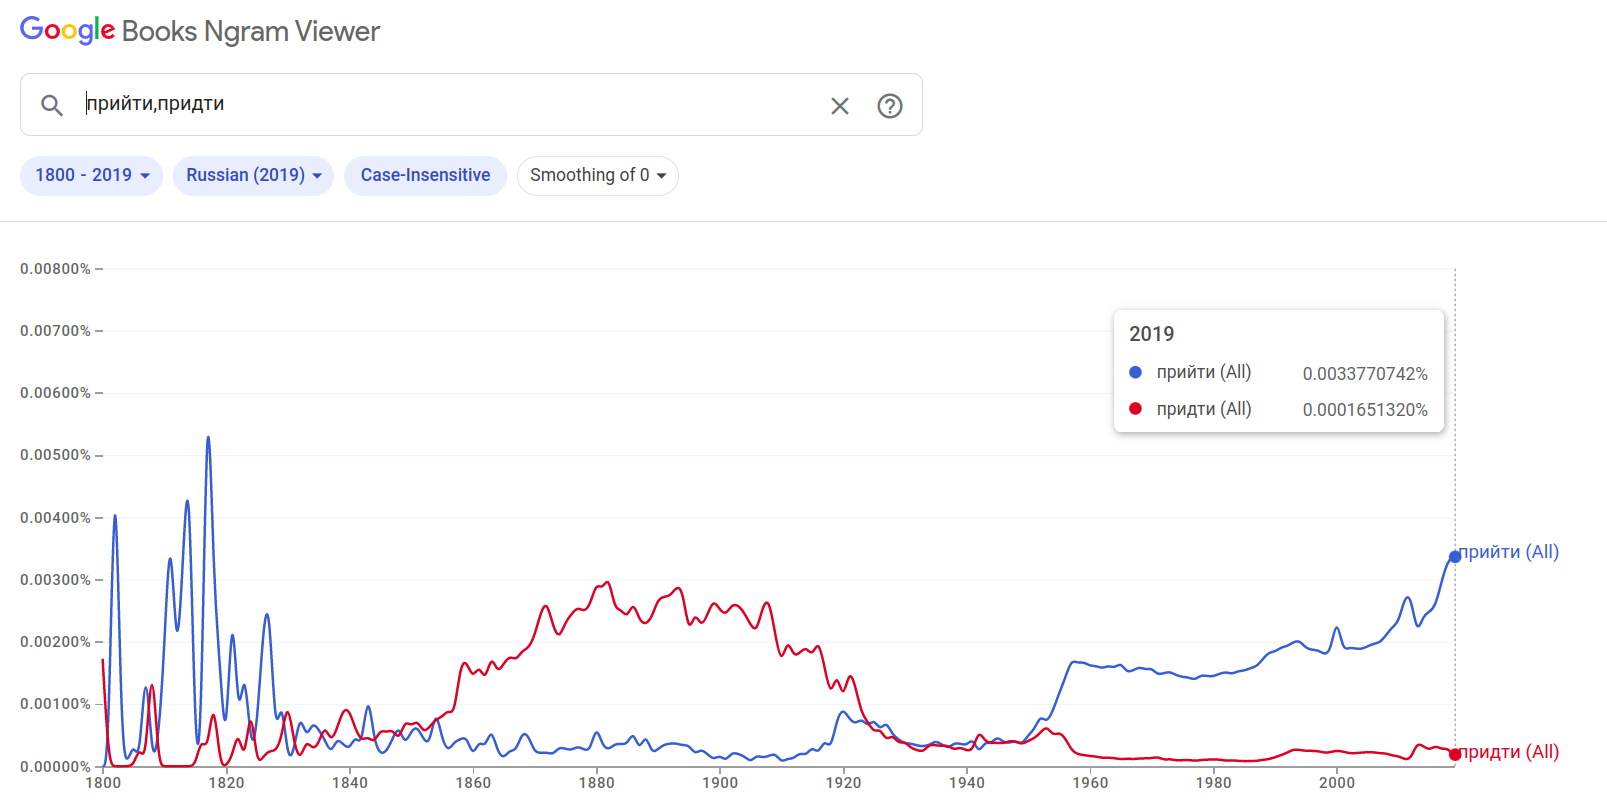

In [64]:
display.Image(b64decode(priti))

In [82]:
print(f'Livejournal прийти/придти: {1152064/253052}')

Livejournal прийти/придти: 4.552676920158703


In [83]:
poest = 'iVBORw0KGgoAAAANSUhEUgAABkQAAAMSCAYAAAA7maiGAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAa8wSURBVHgB7N0LQFRl/v/xj8CAgkAoXrDQQktR1NS8W2GllmmWlWUXW7Pr32pr293a2t1qf1vbbtvWdtnsvpltZeauZhe1C+WtNCUNFQtIRcULSlxEYAD/zzMz6ICgIAzo+H79frPO5Zwz55x5ZmKezzzPt9l+QwAAAAAAAAAAAH4sQAAAAAAAAAAAAH6OQAQAAAAAAAAAAPg9AhEAAAAAAAAAAOD3CEQAAAAAAAAAAIDfIxABAAAAAAAAAAB+j0AEAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3wtSE9i1e78WLS3X+g3l2pW939yW2rR2P9YmupnOHhKo+K7NzH3NdCK48ru/HbieEN5RD3W+WgAAAAAAAAAAoOE0aiBSEYS8P7esmscOLrNuQ6krIDlnaKDGjw2Uv9tZ8rO+2rPWdd0GIgAAAAAAAAAAoGE1WiBiR4P8+e+ltV7eBiQ2OPlqSZke/I3jhBktAgAAAAAAAAAAGl6jBCJfLS3Xi69XDkPsCBA7PVZ81wDFn9HMFYBk797vCk7Wbdh/YDl7/2wTjNw6uUlm9wIAAAAAAAAAAH7A5ymDDTiqhiHduzbTg792VLovvuLK2MBKU2vZZQlDGlb2gr/qwfczal7AEaqI9h3Vs0+iRlzQRzEhOsY4lfzKPZq2wikF9NGUZ27TAIca36ZZevDxhcoutzdClTD5Ed05KOLw65Sn6NV7n9XyQnO91xQ9N3WAmmLXjxvFyZp2/zQl2/PVcoDufHyKEmp1wrK18K8PapZt5gGxGv2H32tcwBK9+uIsJedFqs/lt2rKkBgBAAAAAAAAOHEEyMeqTpN1+SWBh4QhVdnpsWztEBuEHGlZ+ICzUHmZqVoyd5oe/fM0LdnmFI6kUCnvv6fkAqEhhSRoYI9Q9/WCFH2zoZZtcedyfbPRcz22r4Z2MCHavFlavq1QzoIsLX/vI6XQrAEAAAAAAIATik+HXlQdGWLDkLoUST9niM/zmhOcQzG9BiiuZeV7nc5cZW3YoMw8p5w7kzX9mekK/f0U9WkpHE7ecs2aO1QJ13Rj1EeDcSihX4JCVyw3kVOhUldukDMh4YjnN2vFKmWWu6/HnTVA0ebf7Q6vj7sgh4Jq/1EEAAAAAAAAwA/4NBCxtUMq2Kmv6hKGoDFEquuoSZrYpZqHnFla8uo/ND05T8oxHf3zR6rP5bFCDWx2Z5p79qJ3NGfQg7oijkikoTi6D1RCy+VaXmAyp5RV2uBMOMK0WVlKTs70rByngf2jXVcTLrtBowv+p+TcaPW55FJ1I28FAAAAAAAATig+C0S8wxCrMcKQsn//V+VfrlB50nLt37hVAYkD1OzUkxVwbn8F/uKyWm1j/85/a3/el9qfmyQVb1SziEQ1i0yUIs51/3sEtmaKPXb7ry0Ib4MgWzj+7CEB5j530XjL3lfXETCljzzvOi57nPa4Ki5BD011/dugHDEaOukaff/jNNc0UNlrVinzsljF0olcrW7njdDeLxcq0wRJSe8s1ND7RyuGc9UwQrpqYK8ILV9qwrm877Vqg1MJh0tEtpnwZKv7qqPLQPWN8twfkaBxU81FAAAAAAAAAE5EPgtEKjr+K9gAwFdsSOCc/IArCPFWcdsGCGVv/E+O1x9TTcGBDUD2Zz5iwpCkyveb2xX3NWv7CwXEPmQ6aE+tdhuzPyhzFYL3ts6EIOs2lOmrJWWuc+AdFNU2EKnu+Ox99lJxnDbwscFIgwrtqp6nSskp5npetnLNP4wRqUHbRF1zbor++mmWnJs+0jtfDtA9w6OFhuBQ1wE9FbF0ifLM/31/hGmzMpcnK6u8Yr0BihAAAAAAAAAA+DAQyd69/8D1Nq2PvHzVESWH4x0k2FCg+LQLjriODQ3sciE/faqqoYgNQ8rXDj/iNuzokTKzbGDCF4eEIo/+3ekKP2piR4vsqsMxHnjOao6vYv8rApGKUSN2JIwdFdNwClVY6LkaElpjY8lLS9KCpGSlpG1Wdq5ZwRGqyLYdFddrqEaeN0CxR6g9Ut/1q5O96Fn99T8pyrOnPDRO4+7+lUZ3cnehF25aooULlys5wzxfTqGcgaGKaN9RPfslasR5fRQTojorcQYr7uIrNDT5WS3Z7VTqvLe15Mw7NTRKR8GprJUL9dGi5UrdlK08p0MRUe3V+cyB5nwkKi4qU3Me+bM+2mYWTZikp+4cKlfZ8e0f6c+PzHHVzuh2zVO651wTDnz9kT78PFkbtmWr0CnFXf6o7hvpDmqcOala8mmSvklJ1/bdeSoscyi0ZbTad+6qvsNGKDEhukro4FTyK/do2gqzoahE3ffYRMXlpipp/kIt/i5D23Odcpj9jOszXJdePFSxnlroystQ0kcfavHazdqek2de3wi1j+urYRddrMQutYsrHF0GqGfUEi3JcU+ble5MULfqEpHyTK1KznJftyNLzgw9+Ni2OXr4/z5yhSUxFz+shy+JOXR9u6/zvzDnJNW1r4Xloa5z37FrTw0bOUJ92no96Ya39Zt/JJmIxmzvot/r4UuriQu9XhN7zu4x5+zQqbqytfCvD2pWhl1mqFlmktcy7rawcOkqbdi4W7n2RQxtoeiTuymh/3CNHBqniICan7M27QAAAAAAAAA4UfgsENmVfTAcqM3okKoF2Gtiw5VzhgQfuG1HTngLevgOBd5wqWxoYEMQOzLEhgUV7O1KIymKNx4ShgR0ed09PZYJPVwjR3a94QpDKpbfv/MNNbMjRTxsmOMdhthpsm6ZHGT2tZlrpMz6H/a7RojYUKSuvI/PHpP3SBBXEGKOp/Th5w6MIrGBT0NxbliopI3u645TO6tj1ZfR1hmZ8aLe/jrLdNt6KS5Udmaq67L8iwVKnHyXJvaqpuO7vuvXIC/5VT1VEYaExGrELXd6whCnMj78h56dl2E6ur1WKC9UnnmuJfayKEETb79NibF1qwHidJaYjuoEXXF5H33/UrLyClL0v/eT1eemPgqty4aKM5X0yjN6e02e99aVtzNDyQvMZfFijZhyRS2Ktu/W8lem6dUV2QfvCohRt3h3J3j2iul67s0lyiqudBQqzMtSRrK9mPBh0CTdccMARdfw9s1dN0t/fXWhMgq9trA7UymfTlfKmnTd9ptJSsj+SM+9MEeplQ4nT5kpSXp73Sql3nCfbhtUi455R2cNMG1gyZfuabOWpznNsVRzFjK/0fKd7quhCcOUUIeTn5f8tp55PUmZlc5Joevcp9jLki/UZ8JdmjI81n3+43qqZ0SSlphdylr3vbJNIFL1SLLXfH+guLtyUpSy0YQUcVWfeINSPCVPQuP7qnPF+TZtYeFLz2hWSl7l5QtMSLJhueuyZFGiptwxUQk1vj0O3w4AAAAAAACAE4nP5rFqE93swHXv0SINydbU8J5GKviLNyrV07CjJew0WTYkObCOCQ+8AxIbbngL6PGFa2qsihEgNhixAUlA7MMHlinPfNgVjFi7zLF5hzk2DHnw1w5XGGLZMMjWTzlnaN1rqLhqongdn+tYvMKcivoo3iNGqgZER6U4TxlL39Y/piUp23bmOkyocFGVjv3ybCVN+5umV4QZAaGKSRigxJEjNOLcAerW3rN0oengf+GvejW5SqdufdevQeH6WfrHq8s9+x2toTfdpSvi3dtymsderQhD7PP1GqoRl4zT6AvM87X1PN/uFL39/NtKKVTdlLsjndB+1+hSTy983spZmrXeWYdtZJlj/cfBMMQRodg+Zh/tOTm7j+KiHK7zsfClN7X858NvKvfrNzTd0wnuiIhRTGyMok9OUE/TVJwZs/TcawfDkNAOCRp6wWiNu3S0RgzqpmjXCBnT6f71q3puZqqqPYLCVfqPKwxxKDre87qZfTwwmmfnEk1/7VVNe8kdhjhad9OA4SPMuR6qPp08vffleUp+921XoHBkDnUb0NcTONhps9Kr3a+M5cnu19601oT+CbUOowrXTNdfX6oIQxyKiOujoSNHa/TIRA2Ij1FogGd/3/mHpi3yhAuOrurZ1fMM20yocchxmOVXZ3jdzlZKRbF3L84fv1e607PPvbq6wxYTFi585h8Hw5CWMUoYlGjehyOUOMSc56iK0U5JmvbULGUUq1qHawcAAAAAAADAicZnI0S8eY8WqYkNEg63fnWjK7zDAjtyoqbpomyIYMOFAzU3vlyhiiLrrnDDw4YeNRVOd40IsaNEPEGIHTniCk6qsCNDqmNDEXscdZkazO5nBe/jqxgZ4n1MFarePjwTSjxxq5IOt0hUN42+borGdar8a/zsz181nbXu1MDRdoAm3j5JQzt4L1OozE9f1TPv25Ea2Vo+4z/q2fk2DYhomPWrY2t3PPvSQmXZzuWAaA244R5N8hpZkr5ylaezPEJ9bvyDbuvvtbEr85T63jN67vPtimzvUGGBVLehHRUiNPSq0Vr8o+2kztaSd+Zo2O+vUFwtBpxkfz7dBCiec9J+qCZNnagB3lM0ObOV/N5zevXLLGUfYVtZGZmuqcJGTDKvXZ8qU1/FjdOtt4Rqzofm/TN0iiYNj610qFdcakOhaUrKNKHI4o+1ZFQ3JVad+suEZnkB5jxed5+mnO21/UuS9erj07R8tw2nlsuWnwlNmKjf3paomAMLFSplxqN61gYLhSlavDzbBDK1GLEQN1B92iZp4U47bdZyEyJ0qzxtVnmGVq3xnJmIPhqYUMtRPmYf3n5ziSdEi9HQyXdoYr/K56xw00K9+MwspRaYff/fLCX3uU19WjrUtXdXha5IVqEzXd+vK1TiIK8zmbdKKZvsFYdCzd2FheZ8pqxS1uWxOjhZl1MbUja4w50QG7C4nzXr0+mak+ZuC6HxV+jOW0YozvtFsm3hXdMWFplAcdtCTZ8/UA9fcuiUXYdtBwAAAAAAAMAJxmcjRM4ecnBEhA0zqhZZr8qOqqjp4j3llvd170CkpmLpFbzDkgOhgSfcOCDiXB2Od1iyP+9L17+LvAIOO51XxciQ6tSnsLw9PrvfdlSMrSlSMU1WBTsKxk6XZUfJNByHomPj1DG6ReW7nala+GmGuxM3tJuuuHNKlTDD9YBiL7hNd43xTC9UkKyPPs9smPWrsz1J056b456+yXTUJ1x9hyb19+5kd6q0yDOSJyBSHWOrJisR6nb5XXr4z0/p0bttEKGj13aErrnAs99mv/6zIOvI69hz8rnXOZk6qXIYYjmi1eeaX2lir9okNdGmY/9OXVFtJ7hDMX1G67bfP6zbqoQhLlEJmni9CTBsc7Ud/eurHy4TMeAGTTq7yvZNEDF6kFdtjpZ9NHGydxjiOkAljExUnOftkLkxU7UaRxMQp769PK9pjnvarEoyvlGyZ7qsiN4D1LWWvf/Z33wo9wAkh+IuvlWT+h16zkI7jdCtV3tGSRWkKGmle+RGaHxPxXlG1GSsz6h0HIUpnpEfJugYfVFnT3v4/sA+upRnKnWDJwQ7vad7ii/bFr70bCtigCZVDUNcC9u2MEUjOrhvZi1drIxqP2IP1w4AAAAAAACAE4vPRojEVxnxYUdGHG0g4B2mVEzFVXUkhJ066nDs4xVTZVUEKfuLNlZaplnzUw+7jWa2pkjFjSrreu9bTWpTXN6bd+BjAxB7qbQ/VWqK1J1Dsf2GqnPVbKDcqdztG7Thx2xlr/lI0zZ8rxG3/+rA1FPKTFFKjvtq9MBxGtr2MNu/4FL1+fxZLS8wnbamgzjr0ljF1Hf9qovlLNerz7ztmbIoVN0uu0u3nRtTpQPYoY6nd5RjRaqcphP6oxemSZeM1LCEOEVUFFE3QUp0HV+jmsRedI0SV/5VC7c7lTn/HSX1v0eJhwtZan1OIjR0zFAtTFnoKg5eo7hEjT5CcFK4LVlJCxdrVdpm7c6pKKoeqdYdu6rvmaFyx2BO7d5ph2dV3Va0+p5b/ZRU0Se3N2fbPRVaRJ9E9WlZ3UIxijYrZ5jX1VmQ61q2Nh32cQP6KPrzhcouz9P3yelyxnc7sF7G8hTPyBmzb/071zIAKNSG1Z5AJqC9OrbNVer63OoXDYpWa/MRVmjeH+kbzHOf20eOlj3VM86hlPVOFZr3SXp5gqcgeqFS1rhHfjhO76uB/Z1KmZuqVGemvl+TrdEVI2JMQOJ+3R3q3Kun+3xuStYGT1sIPdW02U1mvRr2PjLGvHm3mYafu0Hfbzfnp0OVBeKO3A4AAAAAAACAE4XPAhE7UsJOg1VRbNwGIucMqXsoYsMQ7+my4s9whw42DKgYNWEdaaqo/Zu2HbheMZqk6vRYNiBp5qkdckSe8CS6dTPVli2uXhfex1f1fhuCVEz7dfQi1fm8iZrYpfpHCzfM0bPTPlKGrVvx2tvq/NAUV+d24dZMT8dzqOK6xh6+4zkkztVhvHyN6RreuVkmH1BkPdevPNrAhBvPpijLq420iIqsdpsRQ67QuJX/0KwNhXJuT9acl8wlINQ1Ciauazf17TNQCXERDfNLekecRl85VMnPL1F2carmvLdEfacOlSt7quYt4DqnntoXRzwnsQmKa2kCkcPU3oiO66yaJ6FyKmPBc3rhv6nuwvNe9xfmZaswJdvmMwfvdVYzfsOGB+2r37ojJFTuEvZSh5M71HAsoQp1HHhalaqWYgdqQNuF+sh0/uetSVb6lZ5ps5yp+qZiuqy2fTTw9Fq+iuXbtXmn5/hMUJb00lOHn0KuYpezs5QrE86YV7RvQqzeXp/hCiU2mLdrNztzVfEGrdrgjnls0BERVSKzmFLNYplrUpR3QaKrLeStS3UHWwGxSvBURi/M2n5gSrTCNbP07Jpa7FB5rrKzzfNVGWl1+HYAAAAAAAAAnFh8NmWWVbWehi0+vqsOBdarK1juHah4T5PlXW+jOt6F1CsFCd4BiGcarJqU2xoiFc/tWc971IcNfw53fLWppeKtak0UOy1W8/3rXVNj1T8MObLQruM05RLPL/DzkrVghbsHvrS4pGIJhYYfqePZLFPR82061gud9V+/kvJsZe2sNFGRkme+p+SCajZli8Pf/YjuuXyou0C5a/1CZW9K0fIFszTtr7/RA0+8reSddSiEfrg9T7hCV/TzdHKv+Z/eW2mnRgqSo5p3Xd3OSZirJsXhOBw1b8MWEH/h/YowJFQx/UZr4m336L4H7tN9d9+mSZcMVbfWR9oHhxy1yByCgho4czXBQd9+njFCOauU7KlZ7kxbrlWeURUxZw48MB3XkZlwrFh1V+zUPk+YFNGrr2JdRdez9H2KO8pwblgl10xYB4KOaPOvu8aHMyNZ3+e5n/v79Z5p4GJ7qo/ns+RgW6iLQhVWcxwORy2DIQAAAAAAAOAE4NOi6naUyOWXBOr9uWWu23akx6NPOHXO0EBXkfHDscHCS64A5eB9VdexgUHFtFI28Ai84VJVV1jd1t2oaQSJHSWy3xN02ALrgW1vqBySeJSnTa5Uc6SZXU7uuiA2FKnYT1tT5OwhAYfUErEjXepSUN060jRgB/bNnAPn5AfkeP0x1VRY/mhF90pQ7MxUZZQ7tX3jZnNPgoJCgj2Pmk7Y/CNNduR0FZN2MZ2zNtuo7/rV7mf/SboiaqGm2Xodecv1n/cHqusN1UzpFBChbiMnmctE5WWmK3VDirmk6/sNGcozHcp5aUma9o9C3fb7KdVP9VQnoepz+aVKWDtdKYV5Wv7+LA3tOkCOapp+3c7JXnNOdJTMfnyeLE8FDCVc86BuO7dyfYm4+D4aenZHPXXf20qtW5NtFLFn9VHMx1nKKs/TqpWpmti1s9JXfu8+poAY9RkQW4ethcphp0yzAVrsOD38+9GHTsl2JG0T1PfkWco02cb29SnKu2ioNienyvUSeQUdMb16KmZeprKc6Vq1rlBD+2xQaoa7bcck9DkwkuNgW3BowG1PaUofQg0AAAAAAACgIfh0hIhlQwwbilSwwYENSB79u9MVEHjXB7EhiL3M/qBMd9/vPDDdlmW3UXW6LTttlPcokZLhN1QKPyqCAu/aGzYw8K65ERD7UKUApGzlae6AxBN+7M9NUnnK8AOhiXudhyutYwOeCvbYbJDjnurLvf/2eP7891pPClRpX71HgrjqiJjjO1ADxVNk3R63vW6P1XskTIMrc0+DFHpye0/nbaEyNmQefp3iDfp+oyfQaNtR7R31X7+qiF6TdM+NQ9VnzKQDdTryvn5bs9YfbqSHQxGx3TTggis0aep9euLx32tiH08xlZzl+nBRthpE1FBNvDjOHTjsXqJ3TId4dVlH6Mmxlc7JYceobN3gqr1xVMq3KWt7xfkcqovPrqHY9s4szxRex6AOAzTA87bPS0lWauEGLV/tmT/sZPNYXfIQV90QzxnYmX6U5zVGPRPcMYpzY6pS82whevf+eAcdOrmvElw3nMpYs0GFGd+bfZcrxEnofTCGCY2peH+Y5TK2CwAAAAAAAEDD8HkgYtkRE96hiGXDDjsdlg0K7r6/RNfeXOIKQeylYkRJBbtuTSNKgr94Q96hiA0Nik+7QEXN4l1BgXdAYJezy1digo2Atr+oFHDY0SA2GClb2kzla00YkpdUaflmNkTxYvetu1cReXts7uNyuo6r6vHURdXQxx6fPS57fPY4vcMeG4p4L9sQspNXKdPTMd46prW78zy2jxKiPI9/M0dJu2teP+vzD5Xs6auOSejp/vV9fdf3FpCgK28aqmjbkkPiNO4qz/XybC35zyxlHJhGqFBZyQs1/R8P6uEZqYcGDqGxShw/8sBUS7u3N1xHdPR512h0rLvTPevLj7Q8p5qFYhMqnZMlO2vaWp6Wf5h0+ILqdeCo4TmWfLxcDRQJ+UCMBvTzpB67U7T8428OtJG4AQPqOMIjVD17ewqwF6do4aeHCaN2JmnaY89q1qKMKrVXzMvXK8EdYtgA7/Pl7kLpAdGVgg7XdF89PLHXhm+0MHmDe1RLVFf19Q5xOvVR14q2sPTD6tuLeytKfe+v+uvrHyl5e8NM8wYAAAAAAAD4s0YJROz0UTY0+P2vgyoFBxV27a5pPenWyUGHnV7LBgB2qqgjBQF2tMUhYUjFNkzAEdDl9Wqnyqq0nAlOAvv9VO1jD/7aoXOG1Hw67bFUd+xHUhHi2PohtVmuIafMyls/S9PmZrg7iL1rNzi6acQFnlEPhama9cx0LT+k7kahMr+cpucq1m+ZoNHnxTbM+pU4KrVi77odtgN7+jzP+spV8seztGRDtrKWvKpXF2Ud0vGdvSFV2z0d3aEtj1Ckoy7MuRtxdaJiXEFN4aF1UFyHYc7JeV7n5Plqzkl5nlLee0bTk496viyzLx3V8eSKERHf6MPl2Yc8R/J/ntHbKfV4jkYQ3a+iTogJvhYsd09PFRBn2mjdS4hHDByhAZ4AImv+M5q2IENVj965fblefX6WkjeZ0GTGP/TqkioV7U+tCLQKlfypJ0yKSqgcdBixvbu6iqmrwGxnqfvcRyT0qVzzxLstFCRr+vPV1bUxYciHL+rFTzOU8fUcTTP7lkEmAgAAAAAAAByWT2uIVGWnvLolupnWb9h/2JoaNjyoTZ2RCjYEsIXG7WiQsjf+d2DKLBsS2EtNtUW82VoiNuzYn/mIa5qs/XbKLHOxIYjr8TY3uJY5HBvenDOkXOt/cB+fLaJeMc2XfcxOnbVug3u0SJvoyuFIM9UclthjcI0U6dTBVTzeHp+dNqvi+KpOA1Z7udrwsQkHqqmVUbgzQxsysj2hgUMxF1yjEe0PPh593hRdsf5RV8e5c/sSvfrQ91qQ0FOd20fK4TShw4YUpWzzdCsHRGvANTdoQETDrV+zUPWZcKX6rH/VVVg964v/6KMB92lcbIwJJUZo+T8WKstpOv1nPKwHlvZR3/iOinY4lZWRrOSULHdHuCNWQ4fGqSE5uozWFUOT9exhpuKKvmCSxqX8TbM2eM7Jn9znpJs5JyrIUvq6FGXsNq9ISLSiA7OVfVSZRagGXDBUH61LUrYNP15/WA+uGKA+cdEKLcrWhu+WK9V2vreOVkRO9iEjIY4Zbc1rd6oJATIO3uU4faAGtlbdhSboiusSteF59zlJef+venBRNyXExyo6xKnc7emmbWSq8EAR9Ym6fmiVxhjQWT3jI5S0NE9Op/tdE9G9j7vYuhdHl77q1nKJlhc45V4sVD17dT5kl2JMW7jCtIW3bVvITNK0P61SbLynLRRnK3N9svt1cm3UtO3rximOUiMAAAAAAADAYTVqIGLZ0SJthjRzjaa4dbIO1NnINuFBtAkJqhYjrwtbb8O75sbRsKNFqk6JVRc2AInvaq5UE+bYgKQ6Xw54TLXREMdXmQkCUpYr67DLhCr2gim66/K4ytMrmZAi8bbfyjHjRb39dZacpiM5c80Sc6m6eqwSJ911sD5HQ61/OBEDdMWl32jDjBQVOjO18M2FGnD/aMXEXaFf3eLUM68nKdOECXkmBEkyl0pM5/KAG27T6A5qYKFKuPQKDVg9TcvzalgkwHRsT/2V9NIzmpViFjLBTWayOSeVNhOrEZOvkOO/T+mjoxzE4Yi/Qrddnq1n3k8xgYdT2SlLtDDFa4GIBE28faBSHzOhko5V0erTL06zDiQiDnXt31d1aCWVhCZM1H1THXrh1YXKKLSBYKqWm0tlJhgcNFG3XueZlq3KY117dVPoUs9oFfN6d+vV+dApyRxdTQgXquUrCiueWD1PrybJMG0hcepvpTee06yVJph01vD+iOim0TdO0biuDTiiCQAAAAAAAPBTjR6IVFURgNQnCDkW2NEui5aW6ZbJQTUei/eImPgzjuHjDXDI0TJSsZ37aOAFI5XYpYZuZhMeDJ38sHoOSdKCRclKSdus7FzT0esIVWTbjopLGKCRFwxVbEv5Zv3DiD57okZ//bBmpTnl3PSRpn/eR/ddEOP6df/v/zhQSZ8u0Ddr0pWZnWdiIYciomPVMb6vho9KVEJrH/3UvmUfXXlJglJsUFPTMiEm8LjzMSWs+EgfmXOSmpmtPKfp946KVedeA5Vozke3yEy9/Y57cYc5V3XfW4cJue7UI6cv0UfzFyt5Q6ZrtEloZLTieiXq4jGJimuxXKk6trmmzfpfhnuqqJCuGtjnaOMQt4iEK3Tf/w3U8s8XaMmaDG3emW0CNYfrvLTvkqCBiSM11LwXajrfjq491TV0uVwzmoWa4KNrdUua4KR3VzlWJLtGX7nWCalhgyEmFLnlYSWkJGnh4lVKSd+u3IJCOc1rHt0+Tl37DNOIc/sohiwEAAAAAAAAqJVm+w2hXmxR+Io6KLYAvC0iXzUUsQXkKwIROyXY048HCzgqeUl66r63lVpup9m6T49e2bDTewEAAAAAAACAP2ryESL+wNY7eX+uuzaI/dfWD7FTZ0V7QhE7cmTdhv2Vlgeqytu0XIsXLdHyzbGadO8Viqt25IBTmUmLXWGInZYprmusAAAAAAAAAABHRiDSACqKv1eEIjb8qCieXlX3rs1qXSweJxKnNn/+nuZ8bQuMpOqFV6J11+RExYZWXiZr0XRN+9hTVaT9UA1PoJI2AAAAAAAAANQGU2Y1IDsl1uy5pQemz6rKTqdFGIIa5SzXtL++quQcz+3QGHXr1VWxUSYVKcxW5oYUpW73VB9xxCjxzt9qIsW0AQAAAAAAAKBWCER8wE6Ztf6H/dqVvV9topu5ps6K79rsuC8cD99zbl+i6S+8reXbnTUv1DJOIybfrisS6ldEHAAAAAAAAABOJAQiwLGmPE8ZS77QFyu/V0bmdmUXOuVoHqHINh3VtfdADR8+oMpUWgAAAAAAAACAIyEQAQAAAAAAAAAAfi9AAAAAAAAAAAAAfo5ABAAAAAAAAAAA+D0CEQAAAAAAAAAA4PcIRAAAAAAAAAAAgN8jEAEAAAAAAAAAAH6PQAQAAAAAAAAAAPg9AhEAAAAAAAAAAOD3CEQAAAAAAAAAAIDfIxABAAAAAAAAAAB+j0AEAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3yMQAQAAAAAAAAAAfo9ABAAAAAAAAAAA+D0CEQAAAAAAAAAA4PcIRAAAAAAAAAAAgN8jEAEAAAAAAAAAAH6PQAQAAAAAAAAAAPg9AhEAAAAAAAAAAOD3CEQAAAAAAAAAAIDfIxABAAAAAAAAAAB+j0AEAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3yMQAQAAAAAAAAAAfi9IjSw3N1d79+5VUVGRSktLBQAAAAA4PgUFBal58+YKCwtTZGSkAAAAgGNZs/2GGoENQnbv3q2QkBCFh4erRYsWrj+emzVrphOOPeMn4GEDAAAAlfB38XHNfpW0P3Lbt2+f8vPzVVxcrNatWxOMAAAA4JjVKIHIzp07XSNCoqOjFRoaKgAAAACAfyksLFR2drZrxEjbtm0FAAAAHGt8HojYMMTpdKpDhw4n5mgQAAAAADhB2K+X27Ztk8PhIBQBAADAMcenRdXtNFl2ZAhhCAAAAAD4P/u9z37/s98D7fdBAAAA4Fji00DE1gyx02QRhgAAAADAicF+/7PfA+33QQAAAOBY4rNAxP4ayBZQp2YIAAAAAJxY7PdA+32QUSIAAAA4lvgsENm7d6/Cw8MFAAAAADjx2O+D9nshAAAAcKzwWSBi54xt0aKFTlg+LVUPAAAA+Dn+nj7u2e+D9nshAAAAcKzwWSBSWlqqoKAgnbAomwIAAAAcPf6ePu7Z74P2eyEAAABwrPBpUXWKqQMAAADAiYnvgwAAADjW+DQQAQAAAAAAAAAAOBYQiAAAAAAAAAAAAL9HIAIAAAAAAAAAAPwegQgAAAAAAAAAAPB7BCIAAAAAAAAAAMDvEYgAAAAAAAAAAAC/RyACAAAAAAAAAAD8HoGIj8XFxQkAAAAAAAAAADQtAhEAAAAAAAAAAOD3ggQAAAAA8A+l+dqRuU1bdu5S3t5SlZqvfEFh4WrXtoNiY9sonG+AAAAAOIH5x5/D5o/+3dn5yi+W64/91q3C1YKxLwAAAABOEPmbvtXnSd9oZeo25ZfWsFBQuE7u1lvDEodpUKdwAQAAACea4zgQKVV++tf68PNvtSZtl/aVez0UEqVT43tr+Ijh6tWWn0ABAAAA8FN7N+uL2bP10ZpdKj3SsqX52pqyWO+mfK2kXiN09fhhOjVMAAAAwAnj+EwLSnO0cvYbemdFDX/0F+do43dJen3NSsVfMkmTh3aQQwAAAADgP5zbvtbrr32g9bmeO4LCdWpCb/Xq3lXdT22jiPBwtVCR8vPztT1zg9Z9v1YrUzYrv7RUO9Z8rH9uytDlN16jYR34ERkAAABODM32G/KBH374QWeccYYaXHmOvn7jRb27Lt99OyhKp/cxf/R37qCIFuZLQe4ubUz9TivX7dI+1wLNdeqoKfp/FzRNKBIXF6eMjAwBAAAAOHbsS1+sr4t7a3j3uk0dlb9usb4NOUvDOzdXU3JuW6yXX/pYP+61t4LUqvtwXT52mLpHHz7ccOZsUNLcD7QgJcf947KwOF1yyw0a7qNQxGffCwEAAICjcNz9FGjL5//R+54wpMUpg3T1pIvUK6ryYfQbnKjRPyXp9TcX6sf8Im1c+B/NPe1uXd6ZXz4BAAAAJ7p9P3ys56cv1tayb7Xj2im6OqF2oUh+yn/1/FtmncDVyps0RePOaKJQJH+t3nnNE4YENNfpI27Q5As6qsWBBUq1O32t1mfmaJ+aq1VsV/XqHOX6gZgjqqtG3NBJp3/6ll5bmKH8vRma++/Zan3nBPWirAgAAAD83PFVejz/W3301Tb3L5miB2nyLWMPCUMqtDgtUTffNEKnhsg9quTjr7VbTST5MY08I841WqTayxkD9dDiKuvsWqWZf75dVwwfqPiEeA0cfoVuf2Ku0gqre4JiZSY9r/snjdTAM+MV3+9cXXH3k5q/qfjQJbck6fnfXqeRA81y8Wa7F16n+19bpl1lnsc/uF3xcYfZ17h4XfFSplkyTzNvjldc/HV6c7vqyLPuYZ4nftKb2lXlGNMWuI/x3H5m388cqLE33q9XllVeSmVJur+f2caY57W2zPv+NL0y6UzXub7xHbP/W97UdQl2uScrL2f37r+360yzDyMfX1XzcebN1Y3xh+6nXTfenKPr3sisvPebzHl/4EaNPedM13k/85yxuvGRmVqbV7F/a/XkhXGHPSdx/e5XUtlhjhEAAAC1UlpSpFL7d1TpLn3z1qt6JyX/iOscCEPsl5Eyp/aVONU08rXyf7O1yjVNlglDLpqim73CEGf2Wr3/z7/oz9Nm6v0PF+qjDz/QjGl/10P//EBrsismHG6uUy+4QVMvinOvl7Na7/xvtY58FgAAAIDj23E1ZCI/ZbV+dM2DFa6+Y0fo9BaHX97RIVGXD/1OT36+S6WZq7Vq5zCNaKsmE9HzEl0/LLbSfbtWvKmZ31VZcPtc3T3xPs3dGqIe51+o60dFKG/dfM154W4tW/yjXnjzXg2OqFi4WGtfm6IbH1+q4rhEXXj1KEXsSdb8j57X7cvS9Pj7L2jCKZ5F09/U7dc8pKS8WPUdPUHXt5F2rvhEc/58rZatfUGznhylNl0v1R33JHhWyNSyGTO1tLivJtwwXLGe1tKmf6QaRFCsEq+9RD1Cve4rTtP86fNVJU7Qqmev1Y3PrlJx+yEadUmi2paafVswU4/dsEwrH5uhF66IPcwTmXP00v16cnGeYi97QX+92i57oS4Z8JiWLk5S0oZ71aN7xbJ5WvblMuUFddH1F/d13a6v4nWvaMr15rnKuihx5AQlxoaY1zNJc966X9eaROStt29Sj8C2GnL9vWq+x71O0YY5ev6jNMWef5Mm9PKc75Au6hxo/iUEAQAAqJfwhMs09Vp5Ag53KKLDjBSpFIYEtdHAOowqaWjOn5L00Zoi1/XwXub7RaLX1MB25Mi0/3jCksr2bflar0/bp8m/rBgJEqR2iRN0eebzmrEmX/tSFmrBTz10+WmMqgcAAID/Oo7+2i3VTxme0SFhXdWvlsPTT+nTQ+2SkrSjfKd+2mS+OLRturl+Q/pepXt/M7jSfasen28CEe9vLHma++dHTRgSoVGPzfLq6L9X178wRdc+8bzuf2aIFvx+sOzgF/3wih56woQh/R/QW6+ZjvUQ99J3jL5fY2+ZqSefSdK4vyWaZXdp5qNPmjDEdPS/PEuPDPMkKmV3aO69Y3T3B4/puSsS9cjgUZp6xijPY6tUNNcGIj007q6pGhyoSvtZb4GxGn6rOa723pudq7VvVQlE1j2nh/5lwpD4m/Tamw8cDIOmzjfB0e3mfD2kNwe9putPqf5pipOf0/3Pr5LOuEmPP2RCH9e9bTR8tDmHpm188lmapnbv4l64cJW+WGaO7YzrdWF3NQAT5syeqR/D+mrqP97SvWd5XiDdoQsfGalr33pZM5fdZF6PNhp8rTnHFafhvyl65aNMxSbebL6stxEAAAAaVm1DkWMpDJGKtOar7+T6DU1InEZe0lsH96RUPy782BOGBOnkgWN1xfkJaqedWr3wA72/wnyXyl2tOQvPUvz4OE+IEq5+lyTqmw0f6MfiHK38aq1Gn9ZbLQQAAAD4p+Noyqx9yst3/xJKUVFqV9soJ7qt2rmOstSsfxwMAt8+RzOTdinkzJv1QKVRDyHqccuvNKGzlPnfd5XkmTpr1cyZWlUWq3G3X38gDLEiEm/ShHgTgyz+wjxu7tjyieaajv6QYTfpjmERBxcMbKNLpkzSkE4h2vlDpo5Fy94zIUlZGxPKeI+MMdqP0oNTExWRt0xzPkirfmXz2JO/e0Vr1Vd3/KPy+m3Ov1SJ5nbap/NVsXbxqk/0RY5cI3N6BKoBhGjw7xfom69mHQxDiotVXFisU7p0VkhpnjK37BIAAAAanysUuf4s93eLaqbPOrbCEGPfBq350TM6JGGYBnoP3C7fpjWpOa6rQWdcpFuvOEunRjVXi6iOGjRhksZ56inuSV2rreVe60WepUTPMe37ca3WFQsAAADwW8fRCBGHgio6qMul0tquZsIAp+cPfkfAcXC45gtKigk7Yvv21SGTQAX20JA+bfTK/9KVslEa1T1Ta9fvNA+0VWbSc3pyhffCxUozne7KyVTmHmlwmtmuudmlew8dMt6g51TNWDhVR6V4qR4aEqeHPDdDomLVpe8oXX/XHZrQM0L1Z45xrTnG4EQN6R9yyKNt+g9Rl5Aks8w6c8RdVHmJPCU9fr9eyQhR4kNPaWr3KutHJepSk4jMn/+J5qdPlckntOqzZdqlHpp0cQ81pLx1M/Xcv2Zq/rK1yszx/pYZopKjnQJr3ZMae/qT7utBIYqIjlVC4vWaes/1GsygEgAAgFoJ725DEen5NyuPFLlYnx5bYYi1bbN+cv0p2VynJ3Q+OFWWFdBCpw9KVAunQxFdeqjynobr1E5RUvouqXCf8uz3owM/jQsy24pTi5Wrta94szZukfp1FgAAAOCXjqNApLkiIu10V0XS7m3aYr4ItAupxWrmS8MOVyASrnYdmvgLTC0UF+aajn3Tud2quh5tc3+EPQd5yrND4cuKlVdgTkRpppJee15J1W0wxCxbaLdb5NpuSGRDhBRebB2QGyeoX5j7ZtHOlZr/31d0/4p1yps5Qzedofopy1OuDXZCIhURVs3jERFyHZE5IXYSrwNnzSssCBn8gB65troaIxFKHJ2oNh/N1xcL0jT1ljx9sThTIfH3alR999tL8bLHdO3NryitTaIm3PqIhpwRqwjTdosXP6nbX1iro9ZmiK6/brDcZXGKtNPWJZn1kG5cs1NvvX+v+tbm/QEAAIBDQ5E3/66VKlWp/R5xrIQhxr6dO92FzwPa6pSTq36Va6Ne541Qr+pWLN+lH9Pdo0fUvoOqruo4uYPaBazWxvJ87dhpvm91brpphgEAAABfOq4q5p12emcFrVir0uIN+mZVvvoNPtKXkiKt+2ate47dsDj16nTsH25IqOn4DzJBR251NTrM/a4kpK0iWpp/Ak3AEWJ6vUMT9fTyF3RJ6GE2nNnctd3ivQ1Q+8ObrQPyi6mV6oBM6nu7xtw3X2++vUw3PTRY9RIYochIc4wbTeBhfw1X9Rjz8tzVTMIiK48OieqhUed3Vv6K+Vq66k09v2CcHh95aMgUMuxSDY+eqzmfJiltWK6WbQpRj3tGqYsayi7NfOFNrdUQPfJm5ToneVvrGU61GawJ/2+q19ReN2v4H8bqxrfe1PTP7lDf0SQiAAAAtVU5FCl1j0g/hsIQq3CfZwrhgHBF1HaXTMDz9btvaO4mc0QBURo2cpBaV10mPFwt7IiRcvsc+2R/jAYAAAD4o+OohojUons/9XPNk1uqH+fP1OLth584K3/NXL2f7J4DuFW/Qep+PPQP9+irHsEmv/humQ6p6FG2VkuT8+y3NSW4hrG3VY8uplO9ZJ1WrjrCZL9deuh003GetmbtoeXQtyfp+ccf0ytJDVPLok3/fq7n2rlrl+o/BXGsepzR1hzjKi1dfujWdq1YqrWuqcC6q1K8EHOh7vjL03r1xXs1JDRTM397u57/vpq9CR2scefHqnjdJ3rl3yYUCeyhC0c3XByisjRlbjTP26a7esRUfqi4uEQNK0KDB3Q3wVCxsnftFAAAAPxLracNrrB3g+Y8+5ze/S7HFaL0Gj9Fl59xXP0mDgAAAGhQx1UgopCuuvhiz3y4ezP0/rRXNSclR86qy5Xna2PSf/T0W6u1xw5zD++h0YkddVxoc6EuvaCNile8rMdmeUcixVr76j80c5OJCEZfpUTXSIkQ9R0/Tl1MdDLziSe1LMd7Q3la9tTduvu1Ve4ApP2FumRYhIoXv6LnluVVXu75x/Tka3OUpoaZTisvOUU/lpm4pv0paogMavCVl6hH4C7Neeo5rfLe9V1JevLFJBWHDtGES6oPMULOuEn/evJ6dSlepSfvuk/ztx+yhPqOTlRs2SrN/O9aqeeFGtVJDSewjSLbmLOwfZm+8KpQWZw+V4++srQBAiNvxVq1ap2Kg0IUfUpbAQAAoPby1/3XMzrE3AgIUpD9plRNofWmFNHCM3LDfN/JO+Iu5Wvl7JlK2mYPyIQhV9yqyQOjalg0X/s8dRdDW7QQAAAA4K+Ou58HhfcZrxt35uulTzdr397NSnrj7/qmfZziT+ug1uZv9325u/RTWrq25nr9fsr0R2/55lu1HnyWTg3TMS5Cl9z/Jy1de7dmPjBWYz8bp8FxIcpbn6RPktJU3P0mPf6rwQeChpCz7tXjt6/SjS+8ohsvXqVRo/oqNjBPaSu+UNL6YvW4c5Jn2TaacP8D+uT6+/XKzWO1blSiureRMld8oqTkPMVe9rTuTTyK+KIsU1/8+3nlVaohkqRdUYl65Pq+7juL5+v2frcrqe8j+mr69apzve/ud+jxu5J17VPP69oxyRo1srvalu3UqvnztSq7jRIfeljXHybEiEh8RP+6P1PXPjpX9911utr8e6r6ek29FTJgnAlB3tQr6SHqd+EoxdbiOFWUoi0m9CnO/EIvP5unyIq7N6RXCTm6aMLERE1/YL6enzhSyYl9FF28RcsWr1JxhA2g8pS7x06DdhRV0Hct08x/6WANkQ1JmrMgUxE979XNw5guCwAAoLYqhSF2mqzrPUXVqxRab+qps1q0bWuijQzll+/Ulq1mZ6MO83Uuf62+SXFPsRXe7zJd3T+qxkWdW7cdrLvYlumyAAAA4L+Ow/HSzXXqqCn6ZasP9PoH5gvKPhOCbM/QKnOpKii6h0aP7aD1by5U0vy1Wvz9Lt1yy0U6/VgPRdqP0uMz31KPZ57TzM/m6M0k06l/Shcl3vm0bp5yiXpUGsgRor73vKVZXZ/Tc2/N17L33tT8oAjF9hism56+Q3eM7nJwlEbnCXphZlu98swrmrN4jlbmmc70U/tqwkNmuev6Hk2XvLug+0tPHijoHhIVqx6JN+npu+7VJRUhRVl9x0GEqMftr2pW51f03BtztOydlcoLaasufSfokRvv0PWDj7znXW54Wn/deIVuf+NJ3fNArGY8eYkJjjwPBvbV8EFt9MqW003YEqvaHOcBm5L0ylNJqqxyGNHmiqf1VuCTeuxVs++fzVdI+x5K/H+v6Y5haXryL58of+8WE6J0qftoml1L9eZTS93Xg0IU0b6L+l77uO69Z4J6kIcAAADUSnVhyNXdbfBRpdD6sRCKdOio00K+1priIv2Yki5nQlc5alp2rwlQOnXUqWqh7oO7quZxH6VmWxmylUMUYpbvIAAAAMBvNdtvyAd++OEHnXHGGfKpfdu0ctlKrVmXrp+yc7TP9Ls7WoSr1cmd1b1XP53dr6PCtU0Ln31RH21xjxgJ6jCsUUORuLg4ZWRk6IS26RVdceFjyrzsNX31WKKOub76srV68uKxeqXtUY5gAQAAwHGp5jDkMMs0aShSpJVvPKEZduRHSJwu/80UDYtU/eR+rX898YF+NN+lWiRM0B9u6K2GnDSrUb4XAgAAALV0fFfUa9FB/c6zl8Mt1EEjbrpBhS+94Zo/t3TbYr30ko6PkSJ+Iu2jT7S2rIuuHzv42AtDjF0fPaeZGREafNOFhCEAAAAniPwUE3S8VSXo6H5o0BHe/TJNvVaeZZt6pEhz9Rp2plqlfK09xRlaMHe1el/fW9XuSfoH+uO0r5VvHh122/26vHN1C+Vr5dwkVxgiRanfOT1EBREAAAD4s+OrqPrRCovTuFtuUGIHd/7jDkU+1o97BZ/bpfSfitXj2gd0x+BjKw5Z+9ZDuvv2K3TFb+cr74zrdcdY4hAAAIATQbVhyGECjvAEG4qcpXb260QTF1p3dE7U6AR3nY/8NXP1ZtI2OXU0SrXjq5l6f437OFokjNDI047v38sBAAAAR3JiBCIWoUgTaaNRf/tAsx5KVISOLbvWfqL5izIVMmyqXph2r/pSdwMAAOCEEBTcXEG2nlwdpsCqFIoEOtQi2KGmEa5+48err2uqrCL9+PF0vfzpZncNEG+tztDwCxI14oJhim9V9cEibfz0DT3/oad2SGRvXT2+hpEmAAAAgB85vmuIHI29GZrjmT7LCjplhH55Z6JO8VE0RA0RAAAA4NizL32xvi7ureHd6xYD5K9brG9DztLwzs3VlJxbkvSvlxZqoyvRCFKrhOG6/JJh6h51+FEezpwNSpr7gRak5Mj1jahFR42+ZYpGnOKb0SHUEAEAAMCx5MQLRKyKUGR7C/W64lZN7h8lAAAAADieOLcs1uv//ljrcz13BIXr1ITe6tWzh7rHRikiPFwtVKT8/Hztztyg1d+v1cqUzcov9Swf2VWX3HiNhnfw3VRZBCIAAAA4lpyYgYi1d7NWbgpXv+6EIQAAAACOU/kZWjh79sERH7XiHlFy9fhEne7jebIIRAAAAHAsOXEDEQAAAADwC6XK/+lbff7VSq1M3XZwBEhVQeE6uVtvDTpnmIad1jgVQ/heCAAAgGOJ78ZGAwAAAAAaQZDCTxukcfZSmq8dmzZry84c5e0rNVFJkIJahKt12w46rVMbhfMNEAAAACcw/hwGAAAAAH8RFK52nXuYiwAAAABUESAAAAAAAAAAAAA/RyACAAAAAAAAAAD8HoEIAAAAAAAAAADwewQiAAAAAAAAAADA7xGIAAAAAAAAAAAAv0cgAgAAAAAAAAAA/J5PA5H9+/frhHUCHzoAAABQb/w9fdw7ob8PAgAA4Jjks0AkKChIpaWlOmE1EwAAAICjxd/Txz37fdB+LwQAAACOFT4LRJo3b659+/YJAAAAAHDisd8H7fdCAAAA4Fjhs0AkLCxM+fn5AgAAAACceOz3Qfu9EAAAADhW+CwQiYyMVHFxsQoLCwUAAAAAOHHY74H2+6D9XggAAAAcK3xaVL1169bKzs6mmB4AAAAAnCDs9z/7PdB+HwQAAACOJT4NROyvgeycsdu2bSMUAQAAAAA/Z7/32e9/9nsgo0MAAABwrGm2vxGSip07d6qoqEjR0dEKDQ3VCc+e8WYCAAAATmz8XexX7DRZdmSIDUPatm0rAAAA4FjTKIGIlZubq927dyskJETh4eFq0aKFgoKC1KwZ34AAAAAA4Hhjv0qWlpZq3759rgLqtmaInSaLkSEAAAA4VjVaIFLBBiN79+51jRixfzwDAAAAAI5P9kdudkRIWFgYQQgAAACOeY0eiAAAAAAAAAAAADQ2nxZVBwAAAAAAAAAAOBYQiAAAAAAAAAAAAL9HIAIAAAAAAAAAAPwegQgAAAAAAAAAAPB7BCIAAAAAAAAAAMDvEYgAAAAAAAAAAAC/RyACAAAAAAAAAAD8HoEIAAAAAAAAAADwewQiAAAAAAAAAADA7xGIAAAAAAAAAAAAv0cgAgAAAAAAAAAA/B6BCAAAAAAAAAAA8HsEIgAAAAAAAAAAwO8RiAAAAAAAAAAAAL9HIAIAAAAAAAAAAPwegQgAAAAAAAAAAPB7BCIAAAAAAAAAAMDvEYgAAAAAAAAAAAC/RyACAAAAAAAAAAD8XpCOMc5SqcRcSsvc1/fvd19wbGvWzH1xmBYVFCgFB7mvH4toYyc22iqON8dTmy0qLlFxUYlKSpymzZaq1DTe/abR7qfhnhCamYZqL0GmoTqCghQc7FBI82A1DwkWAAAAAADHgmb7j4FeijLT2bevxFyK3bf32//bb75UC8cb25iaNduvilevRYi5mH6QwEA1KdoYqqKt4nhzrLZZG3wUFBRq7959Zl8CFBISYi4OORzmEuTeOdtJDv9X8Sel0wRhTqdTxcX2Umw+18oVFtZCLVuGuoISAAAAAACaSpMGIuXmmU3/iYpK3J1+2k+Hid/xdN41N512pi9EAY38EtPGUGu0VRxvmrjNlpWX6+ef811BiO3otpfgY3XoCppUidMdmtmLDUZOOilcgQHM2goAAAAAaHxNFojYXz8X7KPj74Th6bhr2cL9q+bGQBvDUaGt4njTBG3WdmzvyclzhSBRpnObESCoDfsnZ44J0Wz7aRUV4Wo/AAAAAAA0piYJRPILK34FLc//4ITQzPX/rl8zh/u4D4Q2hnqhreJ404htdveeXJWUlKhVq5MUEuwQUFfFJU7t2fOzgoOD1bpVpAAAAAAAaCyNHojk7nUXBy4vF05QdpYMO6tKZJh8gjaGhkJbxfHG1212164c12iQ1q0jGRWCerF/fu7enev6t02bKAEAAAAA0BgaNRBxdf453XPl48Rm57p3OBq+0442hoZGW8Xxxldt1oYhAYEB/KIfDcqOOCovKycUAQAAAAA0ikaraGmnhXH9EprOP8jdDmx7sO2iodDG4Au0VRxvfNFmbae1a2QIYQgamG1Ttm3ZNgYAAAAAgK81SiBiCwbbOfKZFgbebHuw7cK2j/qijcGXaKs43jRkm7UFsG3NEDtNFuALtm3ZNmbbGgAAAAAAvuTzQMT+UrVgH7WCUT3bLmz7qM8v5WljaAy0VRxvGqLNlplkZU9OnquAOjVD4Cu2bdk2ZttaGWkxAAAAAMCHfB6I7HV1/u2nBxDV2+9uH7adHC3aWMNwZmzV7OVFOtYVrN6i2SklanS0VRxvGqDN/vxzvlq2DFVIsEM4jpWVqGBPgZrgk7PWbBuzbc22OQAAAAAAfMWngUhZmXvKDu3nV6U4DNM+bDux7aWuaGMNw5m2Sfc/ulHzVu+TU8e2nIydmv7E93phVVOEIrRVHGfq0WadpaXaa9KUqJPCdUIq+Fi/veACTXgxTcevAqW886AmjB2tiy6/VNc9u07HMtvWbJuzbQ8AAAAAAF8Ikg/tK/H8Glr16AAsK1Hmqp1akLRT607prCcnVp3DvFw5qzL1yv92aHWm03z1D1L7uEiNvCxO4xOCKy1ZsGGLXp25QysyilQQEKSOnVtrzNWnamRc0FEtV3/lyly2We/M363Vm4o8+x5l9v3Uo953lyOeM9OpvHqTpv83Wyvs8zZvrjP7ttf1156szqFqErad7CtpppYt6rTaUbWxzPdX6c7/Vu74dziC1KpdmPqffbKuvjBKUYFqAkVa+swa/XN9sK76TS+Nj2uUEj9S4W698swWpbc/WU9eH6WK34EXZGRptnlfJaXu055iqVXbcPUf1UnXXxCull6rN3bbjL0kXjelfKcXpv2gzo8maGQbNarGbKvVcu7Tirmb9N9luUrfVariEIc6xp2kkZecqjHdg3VMKcvX9PvW6N3tARr5y4H6Zf9GatO+Yt4rrz70gxYEttMDD8epd3M7ssq8T741b5DYNrpqcJhnwSZ6L9fgaNusredgf7Ff56my9iRr9uv/0eyla5WVKwVHttcZAy/S1ZOu1OD2OjZt/0bvfJym1onXasRpqpuf3tPtd72l8Jum6W/jjrED/P51/enFb5Tf80rdM+Z0xcR1rGHBAv0450U9N3uRUrYWSC07KiHxSt1x60U6vY7tpj5sW7Ntzra9qJMiBAAAAABAQ/NtIGKLuR7lr6Gd23dr/oId+mJZjlI9syfEtjt0uYJVafrdP3cps0yKatNCHcuKlb7BdFo9UaiCB87UpK6ejqiMTXro8S1KNb3gUe09y63boX8+XqiSR3ppTIzqtly9mTDkwxT9+u180w0RoHYx5rmK7b7vMvtu7ruvjyZ1r9u+1/qcrfhBv3vOnrMAs73mapVTpBVfbtT6raX6+4OdFNsUM6OYdmLbS507mevRxmRCkNiT3OuWFJVpx5ZczXs7VyvSu+jJu9opSo2szKm0zSbUyy9T+o5yqVE6UcuVPnuj5u9prrG3dVTn5u57nRs2mja31dXmWrZqoc6RTqWbns15/05RZmEvPXaJp+O3KdpmYAuNmRSjBX/cqukzd2nI1DaVAhqfa4q2WqEoV+8+tk7TM9xz7LeMdKhlkXltUnbphfU/a/3NvfSbYc0FH9m7T+k7y03wV2DeB3IFIgVpu/T2XNOoz2qh8SYQcX18Nsl7+TCOss3aX+q3bdu6Tutoz2L9aerDWrinvQaPvFIjTw5W8fYfteyzF/Xbpd/pvmce1ZiOOvZkLdfb0z9Wz45XmkCkjsFiYLDCI1uZ83uMBZLGpmQTSgV20c2/vlXjD3Pe93z8F931dLLCz7pIN4wzC25erPfnPam7dklvPXqRWqnx2EBk587dBCIAAAAAAJ/wWSDirOdsB+mfpOuFT51yhDZXt/YlSt1eXZHNEn372W5XGNJ5ZIIemxRpOkZLtOL57/Twsn368NPdmti1jemgKtXSudtdnbZ2uSfNcg673DSz3OJ8zZ6Xo1E3R9VhuQaQv0vvzLFhiEMjf3mmftnfdKSUFSnp2dV64tsifbhglyZ2b1enfarVOSvbqw9nujuc+0/spQcvNh14+Tl69dF1mp22TdMXx+jB4U3XqWPbjaOWrbK+bczR+1Q9e3c7z+tZrh2Lf9BDL5v2tHKLPshop0lxalyB4Zp4X4LitwUpvrdPs8qDCndr3pIiqdMpGlkRwKlI82dmudvcheZ9dZ19Xx0M8FbPz9Lqi7uod2ATts1OHTQmPkv//Harkra30Zgm+FF2Y7ZVt3KlzkxzhSGO9m10991xSjzF7kCp0ueu00Mz85X0VoaG9u6uISfoDEc+16aDfvNQC21WuHofroe4Kd7LtVCXNltUXKLAwAAFO+q2/z/Ofk0Lt7fXmMen6b6BB6PKm8e9p9unvqjnX/lciX86r3FDTF/rOE5/mzFOx6KSfQXmf2PUKvIwC5Wl6f13vlFB18ma9vi16uQaITlO50bepuveek/vp12km7uo0dg2Z9uebYPNQ469kAkAAAAAcHzzWU9NSWn9poeJ6t5Bt/eIVGLfcO2YuVJ3fVhdsecy7fnZdqzaTqeKaXyCdWb/CLVctlvFe0pkuwKiykwn7gazQ4FhShwZ6ekAD1b/C6IVuyxLmRtytLksSp1Vy+UaYjqljFytLjT/xrTV+L6eL/yBzTV0aKRe+Nbuu1N7zF3tymq/T7U6Z7tytHqn+Tc8SheP9Pya2Vy/akyUFkzL0Qrz3AXDY5qks8q2l5LSZrXusKtvG6ssQO0Gx2r4nN2anlWkzG1m43HlWvDYCv1znZQ4dbB+M9gTGGzZpLse3KL0lm302DNnmGBArjBrxf8y9M6XuUrPLVdIyxbqNTBGkybEKLbiB/tHXGafPng2Ra9mBGnMb/rr9t7u53Nu36XZM7fqi/X7tL3QPXXV0HGnadIwz+vn3K1/3paqBeVR+uX9UUqfuU1LMorkDG2hs0Z11u2XRNb4ejpTdmtpvgk0bHuquLMoV+vtCATTqTtydMW6AYo9p43iTaf7ioIi5djRDiFN2TbN8/Q1y6Tka+nyfRpzSSPO6aImaqsmvPpgsT1vDo36RRcThlQEWEHqfPFpGrtojWm7uVqyulRDhrl3LCdli6b/d4dWbCxSQbl7Sr7xE+M0sovXjufakVGbNG/1Xlf7atk2TENHdNL1I73bjWd6v3k79e02k4CZthXfP0ZTrvZq37W1IUO3/V+WtnftpEcuKNG82bu0Yme5eV7T3iZ20aS+Bzdop217951t+uJHz5SCnSLdUwr29npS875aPXej3v0qV+v2mO20Mft/gdn/Cz37X4f3xxGfr3CH/vlIhlYoSg/+q51W/zpV8yrqP3+bpkuvy/BMDVZc+b3cOlP3ms+M1JDWevCZbhri2VzB4nWaYtp2sTkXr//hFNeoNNc+vJ+lJanF5r8Bgerco62uvqaj+rev3yiTurbZ4qIShYSEqK62bd1u3p591LdXlU+d087X+CFz9HLWJm0skxIKPtYvL39SJZMe1fjcWXrjs7XK2hesmB7n6+Z779TgfR/r+X+9pQVrt6skuL0Szr9Rv/p/56mTV/94Sdrnevn1mVqwZrMKylqqU6/zNfHWyYeM8DjscmXJemrCbzR7j3vZL/88Wmf/pY/ue/8Jjan4b33Zdi2bPkMvz1uuTbnBat31bN18z50HnyftdV1321tqfedM/XNcK3ftkUufVP7kJzSpzBzzHLNeQTXrufbNHOcz5jg37FFJy44aPG6yBm1/Un9dc75eeONWJdT090bZHq16b5reMPuUsqtEwW3MZ8KYybr56j7u0Rxli/Wn0Q9roavU0nb99dIL9Nfggfrj+49qRNX/IOxJ1qqt0umTz/aEIW6dEgfq9LfeUsoac3K6NOYYEbnanm2DBCIAAAAAgIbms3k8Sk2Hx/56TA/TbsApGtPfhByHDR9C1DnOdpuWav3qfFf4YUeNfLc6z3W9/WkR7mmPCou0w4YPAcFq7z37R5sWcv2wfLd5vLwOyzWE7qfq2af6acbvT1Gs1zEW55bK1dfcKsTdqVGHfarVOSssdZ+nsGC18nr1W8aGqp1Zz7mjWDuOovhuQ7DtpbQOz13fNnaochXbPmvztggOrstbo1SrX1ujR/+bo3RniM5MiFS78n1auiBDv3t6q3bUeplq7Nmhpx/5QdOX71VByzCd2SVEJTtzNXtaip5eVqWouDNXr/4tQ0mmP7JlaIAKcvcpaeYGvbm65kab/n2eq+O3S1evQKF5G93+t3567e/dNMq7D6ygRK6+35bNFWX7SZu4bUZ1jVBHc/+6dT973vuNp0na6kYTVNnzHX6ShnSt0j5NeJV4Q5x++YtTlehJtgpW/aDfPbHJdLSWmHMYqTM7NNP2Dbv0z7+t07ztnvWc+Zr+l3V6YXG+q331j2+h4Ox8zZu+Tg/9t6Kn34Qhn6Tod89vVdKWMoVFt1CYrWPyqWm7z2bV3HaPwJmRqcem7dD60iC1CilXjglz3p1m2m+uZ4GsLXrs0QzNXmf23wQT/TsFKSdtt179x1q9mlIx5KZIS59dowfe363VP5vP/Lam83SX2f8Z6/TY3L1VnvAI749aPZ+35oof2FqJFbVyWplAZ7AJDdtW89lxSrQG2OnjCk0QvqH8wHmt+O9W977Rrv9WOdM26iG7D6v3qSQiRB2blynV9FQ//NgPWpGveqlrmy0pcZpO6bqPhzy1S0ez8lotXLBZlT+hWmnE72do5vOTK3Xy//DWX/Ty5vYaefVkXT2yo/LXzNGfHrhLt/36RX3f6mxNnDxZY7pJKXMe0yNvHSxuXpL2ln5512OanWHavll36tVnKzzjPf3prgc1e7Nqv1zg6Rr/u0f155sGuoKxhCsf1t/+NFlDvEKD3R//XX9KkvqZwOGGMT1MqPex/vTYe9qkw/vhnUf0p8/MeuNqWG/P5/rTfU9q9k/BZplrdfO4HipZ8Bc99dmeI2x5j77821365YvLld9tnG424c740wuU9OKDuuvpb9yfh4HdNfFPD2vq2eZDPLCLOUZzXA9NVr/qsuPt27W7LFgd2lcZatemvaLNa5W160j70/Bs27NtEAAAAACAhubTKbMasqu6egHqPeF0XbXpB727IEW3JbdQK1vDYE+5orqcorvHe+aNKSpzd8wEBFSe7srhuV1eLtf37tou1xBzZjmCFVW1GHSR6eienyun/QX4OZ6puRp6n8KD3L+GzilSpkleDhRRd5a7n6ekVEfsgjCdoUtnZWr1kXqhW0ZqzBXtal2TxLaXukwt1KBtrNB08M5J1wLbURxqOkO71iEQceZowddOOU2n9C8f7aWRNkTIzdKjv8nQ0vW7tCTrZI2PrsUy1dSn2bEsS9+aTvCovl307K/cdU1yPlmjyTPyteSLXbpp8MmVap2cMipBj0xwTx239OlkPfqtUyu+zdXtvauriFKkNPtr/8AwxbbzPt4AtWzTvMqoklJzfnYo1U5PN7ide1RMU7fNdi0Ua3Y7fdtemX56daspbPFBe22KturcU+IaNeaINGFpNfvYLiFGIxMqbpXq26Td2m4/Iyeeqccutr2gFW0iXwuW7NWYy8OkH3eYkKNcjlNO1l8ePdUVztog5a5/7FLqV+ZySbi6FezQ9PfylRPYQuN/k6ApCSZ0sFOZPbLOdNxnat66dprS/Siy9fJgJf6yp263I+QKc/TCgyao2ZWrFevKlTg4QJlLd2qdaQfthnfTs1Ps52G50mck665PirTgy1xNSjAp3KrNesW0cbVpo4f/cIb6t7JBy0bd/39btfrjTC29oJuGeJ2rw70/avN8lU67HRn1i27qvWCNlmSYtCKunf7f1HY1NPcwDenbQtO37NNqE4Kod6QroPl2nXuE1Vn97JCRffpgRpZSi81rdrnZz8vC5Sgzgc/zJkhdvlvvLNir/peH6WjVvc2WyuGo+3/sOo2/Szd/84Befvo2Xbf4fI0fcZ7OHdJHMTUMUwvudaumPVFRo2Kc+gXeqF/OWaeSq6fptVu7yDU+4MqBCr7hNr2z9BttmtxFncw7YcGLbykleJj++MzDGuH5b+n4kV3025uf1MsvfqxEV92L2i3X6ayB6hS4XP+QHcUxQIOHVBmV0OYiPfH8rUpwhQlXqm/gdbp99iIt23qtOp18mJNxhPV+fG+Gvsxtr/GPP6N7znKfoKvHD9Bfb35Q8w6z2ZLv39LzJjQ5/dpnNO0mzzkaP06DW92m2+c8q7cvGqibu7bS6QOHSd9NMw+Gu64PrmnarOIS1w8xgoOrHHdwiGvbxfsOn8YVJL+nlz+vGoBVFaxO55nQq0/txp/atucsbeyoGwAAAABwIvBZILJ/vxqHI0itWgXJkVGqnF37lOO6M0Ct2jdXVGMWBy/bq3n//FFf/HzwrlZnddaDl9R2Mv8SrXgzTbOzTOf3WZ10dV8fvTRtotQ7ZpNWb8nRO9N3qPOkNoras1vvmuu2FosCa9Gx6Wih/gNDNO/xLe5pv6oTGq4p98fVuUB7XdpNfduY0zXFTVrlOx3NNeamOCVG1mFDdkSJ7YwvdWr9ur0aMizM9K3H6LdPtlZBuS0Qax4rr8Uy1Wh38Zl692LPjbJyFRSaHs3WzU1HX7522GnVzGt2IOowHdbDh0cemFIqvnsLOUzn957cElWbS5SZ9XPdy7Y8QjPd8eUPemGxiepMx/OU8T4qUFHXtmlCxZY2NDHHt915mEDER+21MduqVez0jCwIlo48iUyQEn81WIkVN4tKVWB6PFu1c7jqEu3ZY7suTed6cIBrW878Qq3eVKLYOHNOTfj2zPOnyhWMuQKS3VpRbGvuxOiqBM8zh0cp0XTiz/6wSOs27FPB3iw99kGBq1PVJSBUl99zRqVf2R/CvN4je3u2Z0LI3qcFmECkXDm5dt+aK9jhfr33bsszIXekurUKUOereuvdseWuz30bWKxYnuMaodJteKwrDLEcce01vNNWpablaf1Gacjpnuc7wvvjyM9XP7FntVLnD7cqfV2OMhWp2MwcV0jnOCVKQ+0P87fv1pKfzHOFt9FlY8LdzxfYXEPOPUlRy3cpfYMdCRVWr+kM69IOS0vLzGEfxfyQLbpr0lOvKWHO63pj9md6/i8f6/lg0zk/5CLdMPlanduxcutt3fV0r4LdwTqjizsZHjyky8F2HthRZ9i5sn7co3z7WVDwjb5aU6KYMRMOhBwu7c/X1Ymva9mCxVpZcJFGlNVyuSOc1NYDz/eEGm6nntZJwWWbtNt+fp58tOtt18rkzebfazXGOyRo2UM9zLHO21Lzdn9I+kZZgT1033ivc2SuJVw9Tn1NIPLlojQTiNSh6EdNI4cCazddVcte56vvwrv0p4+31xCKmDDkogd0c6/at17b9kpLm2i4KgAAAADArx3ngUipVvx7vV741qnYwXF6cFI7tS/P1/yXNpjO2zQ9FNpcz06KVOPkIqXasXGvUr1mloiKre3PccuV/v46/f3LIimmnX5zSztFyVfCdPF1MVryZJbSzTm6bbE7EGgZ7u5gVGigomrRB+aI66RH7pceqq6T2dW53F3j4+revBq1kznEoc6tXAVAtGenUzllphP59t66fUAd99sRpfFXRGr1W7laMO07fTG9ubp3i9RZw2I0coCnFkZgLZapVrl2LN+sV+bs1IpNziqjdw4/f5sj4EjhVrmctvcqwBPW1KBgdZoe/bfpeA4J06Q7u6h3qHykrm3TTm0m13GU2J74w9Sy8EV7bexAJMTTYW97HEtqs4Kntsb0L3Jco+YqtZ0yT9vp0kGTBmfrb8ty9MIfV+jNVmHq1dN00A+PUaKnzsiO7cXudVdn6KrrMg55mhwbroSbYCRj78HnMOHVnjr2ZToO1Gtw/9POhBxjl/6g2Ru26N67tqndKeHq3bu1Rl3QTt0i7bkoMvvm/oxNnblKF8+sukXzvi6o+T1S9f1x5Oerp06tdVYbE4hk/awV28sVvPpnbbcjrs6KVjv7+I5C95Rw+bv08ORdh+5vXqkr8G+sQGR/fRptYCv1HX+v67In7RslffaxZs97S7//5htN+vszurn7YTrabSe8bQs1fCa5S2Js1jZzrmJO61jl0WBX6KCy3cqyp7CklsvV8aQGV2mrR7Ve2R5lmb8Xgk/vVKlux5GVKGurWbHVQJ1aNbhv1dF1X8pWG0x0Ua2rb9S3Lpp5vc+99xn9UdWFIu4w5Jl7h6lVHZ9nf6P9sgYAAAAAcCLxWSDSKAp3a8E3dsqfSI03Hamxrh+uR2rMde30RcoWpS7boe8mRqp/80B3x0B5lU5Bp2cKHtshbHuka7tcdcw+THlmqKaorkyH96epevS/e1XQKkq/+W2VDuf67FMNWibE6bE/hOnDz3Yr7WfTh9KljUaetEsPvJojR4eWqm3p1Go7mesRhjQ2R89OevLudq7O9tWvfqsHvnDq28W7lDMgpo6BVIBiRyboma67lPTlbn37fa6+W7VDq81lXt84/eVXMabDszbLHKpgRZp+98wu7QgN05gJsep9SrAcWTv0z7dzPKOh6sl2UJXX3GnszNikx57fofTy5hpzZ3ddFefVMXwstE1Ph2Rtnue4b68nBbmOf0dusStsiK3SuZiTtkvrTedu2Kl2pE2AUt9eq4c+KVJITGtN/EVrxbUKUM7yjfrnYu+C9s01ZGpfvTh4h+abUGT1unwt/XKvuWxX0sQEPXzxwSmaHO0jNfy0qucpQC3tqJLhCfrfBdXsdH1+4B3eWlP+r4+GLt6uL779WatTTZj4obl8mqWr7u2lSd0PLtqua2v1PqRxBJjAU7V3xOerZxsJDNfQM5vr3U/2ac2avQpO2SdnYAsN6F9lGqzQFhpi/iNwSB99q9B6hSFNpVWXgRpvL+M+1u9ve1LvTJujMc9cqRjVX/Ul3206WqLisrov19iCjzaIcK1XfdzhCiPqekyhLV3nqGRfSeXt7st3bS+8RS1GBVYbihx9GAIAAAAAgK/4rBewWbNGGCVSVKq9ti/XdLy29O7xCA2S6+t7oXncdgyENlc725NUUKTtdn6VUzzL7SqWq7Zwa/N4QB2Wa0A5psP7oTdztCM8XLff202JVeuK+GifWsa1M53bFV3wRUp6Is1VXDuxb91G1FTqZFb9O5eb1aHQQsO1sQD1vriDei/epNWrs/RBRjtNquj4r/hRvusX9TWc6Px9St1mun8iojRmUhuNMXc5N23V3x7fqKWrt2l+WowmtavFMofMcFKuNUt2u6YE6j2+m26/0DMEYkOuq2O03oFIYLCibPi2p1QFNiCo+mvj7Vl6+knzuhY7lHhjD3etB29N3jZL7VOb3s4ghYXUbtsN2V4bva3GRapziAnH8n/WtxvK1du7bkfZXi148QdNzwrQkNv6q3fbXC1ZVuTqcJ94Rzdd1cm92I5NmZXOYcH2fG3JLVdYZ9P++tq5f0xAu/gHPTRtt1bM2aoVI89Ql9Z2mi1zok1gO2nqyT4cveatXDkZ+drhDFC7wafq9uHmLmeRVr+1Tg99uk+zP9yl8d3bqVWrANeyUd1j9cua6mvUqi5zbZ4vpt6BROdBUYr9JEvrl25Sia2s3baVhlQkA61DXJ3GOQrV8CndNKS5Glzd2uxRVL3Zt1h/vfkZfT/wd5pxZ5/Kj7U/W+d2e1Zfrv1RG+2oDdVD+47qYM7Vxs22KrpXMma64Tf+tN1VKP1UOw1ZWS2XawomQGhtAruSrCxlmZudar1isGLamxW/TdPGAinB+3N7j7kv1zSlk9vXfnSI1aa9YgJLtG27/eT2Gk2za7uyzWvVun0tk8VKocgexdQzDDmqNggAAAAAwBE0cPf+QY3yPTYyVJ1tZ4AzXwu+2ue5s1yZX+7SehuEtA111wQIDNdZXU2nZ9k+Lfg0R+4ynSVa8Wm2qzZBu/godQysw3INxLlho/48bZcyg8J01d3dNaZTNS+Hr/cpP19Jr67TC6ttYeV2Gn9W3TuH3Z3MZ+jBBvilfV07mRtM+/a6bKDDfZ7n7vKc5yBFneQ+nvT1uZ77SpW6NMc9tU0FG2z8X4rufXKjUj0/vnecEqFY23taViZnWS2XOUS5SjyDNwqyPdMWlZVo9bKf3YFDvYWovSuxcNryBZXl7tYLf89QUm6Q+k/oobvPraZ3tqnbZm6RdtjaFm1aqH0dnqeh2mujt9XQ1hozyH6gOfXB9Awt3e5pHGWlSv/wJ31ge1VDIzW8tz0mT9sxj+3Z7Zm6rzBXSav3VcoHcpb8qPtNu3xoxm7P62cCga4t3R2Ynmm1ovq0UneH/bzaqumL9x1Yt2DDJj3xj01KL5IPmHb0lnm/mH07MKLF0VyduzR3/9rfPQRJvUxIZgOa1E9/0rxNFSOdzPlYkKpHZ1S0yYZ6vuo5KqYyyy898vOd1lr9TehdkJar1Wabnfu2PjjSJ6aVhraVq8D8O+/sVk7FZ8Ke3Xr1iVQt2FKu+qpLOwwKCpSzrjUcWnRRp8gCbfpsluZtrfJYwVqtyjChcJsYV0hRL5EDNahXsLI+m6mFXtNUatdnmr1oj4L7DFO/lnVYzgpyjyQpKanVhHQNoL0Gn2XCh80fa3ay13PmrtXaTYffhzOGDVRM2VrNnp3mNT1ViVJmf6wUs91zh9ShfojVpo/6mV35Mekz/ej1kv+Y9I1+VBf161WHoVaeUOTPv3uoXmGIbXtBQQ34BxcAAAAAAB4+GyHiMFsuMt/UfZqLBEZpzCWR+uLfuVox/TtdtyBE7UzPVfr2UjkDHUoc30GdXd+nTafuuPbqvXqLVn+6TreltFC7MrPcrlLXlDlXXxzl+dV0bZdrAEW79a+ntyrVduiGlyn17RQ9UGmBIPWemKCruvpmnwqW/aAH3s7R5j3u6Y0ckZH6f3d0VOejPEBHXBsNUf3YH9A76tAiG7aNmfM8pp26Ldui1OSt+nBTO11lAqozB0Sp3eJd2vFlqm7b0EIt9xUrM7dKx2R8jMZ33aUXNuzQ/b8tUP9Tg+XMytd3poPaEdNWiXFmmYBaLFPNPvUeYDp8V+Uo/ZN1mvxdiFruNc+fX9ERXl67H7/XKECdO7eQY/k+ZdoOuLiK3xSXKOmlHzTPpi6OZtrzzY96aEXlNaMGna7fXBjWtG0zc682m867VnEmWFLd1Le9Nk1bNe3h6tM1Pj1Vs7fs0KO/3qWoSPMBV+RUjp39x37mTYrTEM/UgUP6OjTvS6fm/XOlVrcNUsked4BkOT1hR+zwkzX08zQlmXN+W+YOxZsO+T3puUq1gdawNoq357xNB025LFsPzNzrqn+z4n9en7MhYeq4LVad4xo6W2+uIRe30ey0XVrx5mrdtSxcsc1LtH7dXtdooSHnRLlHaww+TZOW5eufq3NdNVDmxTgUnF+sdPMedbQPUvr4KPWuVSOs5fNVo2VsqOmCzlXmhs26857tGnpNH93ev4aF7bRZZodmf+p0FUw/q394pccuvsFTQ+dT83mzooVOOWm/dmwpctU36t+7WCNPaaGjVfc2GySn06nguqxkzsT4eyZr2T0v6q+33aivEs9WwsnmzOVu1krT2b5qTyuNuHVcHUZD1KSVxtx6rRbe9boev+tB/TBmgGK0WV/P+VjLyrpr6k0XeabXq+1yco06iQku0crZz+jlPX00eNxFSpBvdRp3o0bMe1iz/3ibdl90vs5osUcpn5l9s3VNDjNyJbjPtZp6/jf6/Vu/1i+3j9OI7q20e50JVhZsVszIhzWxp+qoo8ZcPUzv/+Ut/fo3BZp4rg1qFmv2nDS1GvKAxpymujGhyOCRA1Uftu3ZNggAAAAAQEPz2bdN+8O+Zs1MF8x+3w4VaXdBdz0ZtlnTP96pbzP3Kd0cUvsurTX8klN1lfcUP5066YHfBenNt7drSYZ7uY7d25lOgFM10rvjobbL1VdxiXI8dQyc+UVanV91gQC1y/NM0+SDfbLPudl0GraKCVd83zYaPyZGnWsxTbgv2fYSFFj79tLgbeyUk3V5v+161AQEH8zbpYuntlHLvnH67cRyvfyRCSV2FSv4lEhNmhim9S9v0YGMIDBMY37TSy1nbdIHy/O1YvVe13RS3YedrKsmnuLpyK/NMoeKGnaGHinM0KvzdmudeX7FROqqCaHKmL5VK342r6FpQ93qMbVOu75R6mw6utd8nyvn8DaeAMOpHT97QhfTKZWecWjsEhvnGXXQhG0z1bxpcszzjTkrUo2tydpqeJSmPNxLnT3tKD3Xaautq1vvVhp+senUPFCs2oQn1/fQbxzpemdpvrZnm/7V09vplwklenVmjoq3FbqmYmvXqp3u/kOAOs7cqi/Wm3ZpArqWrcKUeFmsJl3S2hMCmODskl76e5uNemdetr7dYl5n85yd+8Zo7KUdTZjnm4GGLfueob/8JlTT/7tDKzaagKw0QK1OidJVF3XSxGGeRh/YQiPv7q2ouRv138W5Wpe1TyEtW6j/8Ha6+oqT1c1OCVfL1LBWz1edLqfo9osL9MKn5jzvPVJdiAB1G9BK7T7doR2tojSgSkezu4ZOC737fpaWpJrzvM3896xTlMaaHunxA44+DLHq2maDgx0qLnYqLLRuzxvc5Ur987UueuetWVrwzRy98XGBubOVYnqcr6n3TtbVZ9WlsMvhnudaPfFMK7384nta8PqzKjDP0anXOP3xpskacVrdl1Obi3TzpMX601uL9c7sEhMsmECkfqf8yFoN0/1/v1fhT72lBXNe17KWHTV4zK9187rH9HLWYVfUub99Rn87eZr522eOnv+sRMHtuyjx1id085V9dDRnuNXIB/RM2Yv6xzuf6eVnzWtm9iVhzL361a3nqWFesbqxbS84uMF+ggIAAAAAwAHN9u/3TaUPp+kv/bmgEeqIwG/Y6VxOaln7XzHTxhpCkRY8lqx/pofrN/9IUGLjZwtHx5mjF+5dp/nBMXryr3GekWCNh7aK401d22yRDe1zchXTvo3QmLbrnanX6fmSyZrx8rUNMJrm+JS1fZeioiLVPKRO1VAAAAAAADgin9UQcTDTAY5CXachQn011/DL26lzaa7emZNbzym4Gs+OBZlK2hOkoZef0uhhSAXaKo43dWmHtiO6rKxcJc5SwUcKkvXOK59rj3epls2L9GWa1Or0LvUrPH8cs23Otj3CEAAAAACAL/i0m65FiFRY7Ptps+AHmu037aXu7YQ2Vn+Orqfqlxfn6YEP0/Svbj30ywH1mIOrERSsy9DfZucralg33T64CTrMaKs43hxlmw0La6GCgkK1iooQGl7JT8s175339HZysi4/v7ta7UvTwjlzlBLcR/dcPVAnahxg25xtewAAAAAA+ILPRohYLYJtEWE6/3Bktp20OIreH9pYQwhQ5wnd9OvhgUr/ft8xP0okZ0OenL3j9OCU1jUWuvYl2iqON0fbZlu2DHV1Tu9nrjefCO55q5556k4lhq7V+688qb9OX6Tdncbpvqce0viOOiHZtmbbnG17AAAAAAD4gs9qiFTIL5T2lfCraByG/fVycDOFH2X/B22soZTL6QyQ41ivY+s0++kIUJPsJm0Vx5t6ttnde3LVrFkzRomgUezJyXOFIq1bHS8FrQAAAAAAxxufjhCx7KwHrl9F0/+H6jRzt4/6zI5BG2sox0EYYjVZGEJbxXGmAdrsSSeFu36xX1xyvFQYwvHKtjHb1mybAwAAAADAV3weiASYDpmWLej/Q/Vsu7DtI6AeDYQ2hsZAW8XxpiHabGBAgGt0yJ49PzN1FnzGti3bxmxbs20OAAAAAABfaZRvnbaYcPNg82R8x4UX2x5su7Dto75oY/Al2iqONw3ZZm09h+DgYO3enSvAF2zbsm2M2iEAAAAAAF9rtC45O3+5I6h+v1SF/7DtwLaH8Abs+6CNwRdoqzje+KLN2poO9lf8tqYI0JBsm6JuCAAAAACgsfi8qHpVuXslZ6lUXi6coOwvl21nXWSYfII2hoZCW8XxxtdtdteuHFeR9datI13/AkfLFbDtdochbdpECQAAAACAxtDogYiVXygVlZgvw/YGU5KfODy1pO00LuE+nhWDNoZ6oa3ieNOIbdb+or+kpEStWp2kkGCHgLqyBdRtzRA7TRYjQwAAAAAAjalJAhFrX7FUsM/2/5mn38+vTP1es/2ms66Zq8BvQ8xpXxu0MRwV2iqON03QZgsKCrUnJ89V8yHqpHBGi6BW7J+cOT/nu9qPLaBOzRAAAAAAQGNrskDEKjfPvHdfxa+j6Qj0S56OOvur5bAWjV8zgTaGWqOt4njTxG22rLxcP5vO7b2m4dqObVfxdTtfF1BFibPUFYLYS5hprCeZEC0woNHK2AEAAAAAcECTBiIVysqkfSXuX0lbtjNw//5mojvw+GMbUzNPJ51lf63cwnTWBQaqSdHGUBVtFcebY7XNOkvdnd02GAkMDFBISIi5OORwmEuQe+cYQXJiqPiT0llaJqfTqeJieyk2n2vlriDEhmaOIEIzAAAAAEDTOSYCEW+2wHCJuZjv0q7rdu+OrT1EdWxfl73YHwfb/q/gIPf1YxFt7MRGW8Xx5nhqs0XFJSouKlFJidMVlJSaxmv/zDjG/tSAj9jgy16CTEO1wUdwsEMhzYPVPCRYAAAAAAAcC465QAQAAAAAAAAAAKChMYEzAAAAAAAAAADwewQiAAAAAAAAAADA7xGIAAAAAAAAAAAAv0cgAgAAAAAAAAAA/B6BCAAAAAAAAAAA8HsEIgAAAAAAAAAAwO8RiAAAAAAAAAAAAL9HIAIAAAAAAAAAAPwegQgAAAAAAAAAAPB7BCIAAAAAAAAAAMDvEYgAAAAAAAAAAAC/RyACAAAAAAAAAAD8HoEIAAAAAAAAAADwewQiAAAAAAAAAADA7xGIAAAAAAAAAAAAv0cgAgAAAAAAAAAA/B6BCAAAAAAAAAAA8HsEIgAAAAAAAAAAwO8RiAAAAAAAAAAAAL9HIAIAAAAAAAAAAPwegQgAAAAAAAAAAPB7BCIAAAAAAAAAAMDvEYgAAAAAAAAAAAC/RyACAAAAAAAAAAD8XtCPaZsEAAAAAAAAAADgz5rtNwQAAAAAAAAAAODHmDILAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3yMQAQAAAAAAAAAAfo9ABAAAAAAAAAAA+D0CEQAAAAAAAAAA4PcIRAAAAAAAAAAAgN8jEAEAAAAAAAAAAH6PQAQAAAAAAAAAAPg9AhEAAAAAAAAAAOD3CEQAAAAAAAAAAIDfIxABAAAAAAAAAAB+j0AEAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3yMQAQAAAAAAAAAAfo9ABAAAAAAAAAAA+D0CEQAAAAAAAAAA4PcIRAAAAAAAAAAAgN8jEAEAAAAAAAAAAH6PQAQAAAAAAAAAAPg9AhEAAAAAAAAAAOD3CEQAAAAAAAAAAIDfIxABAAAAAAAAAAB+j0AEAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3yMQAQAAAAAAAAAAfo9ABAAAAAAAAAAA+D0CEQAAAAAAAAAA4PcIRAAAAAAAAAAAgN8jEAEAAAAAAAAAAH6PQAQAAAAAAAAAAPg9AhEAAAAAAAAAAOD3CEQAAAAAAAAAAIDfIxABAAAAAAAAAAB+j0AEAAAAAAAAAAD4PQIRAAAAAAAAAADg9whEAAAAAAAAAACA3yMQAQAAAAAAAAAAfi9IvuTM1sr3Z+iDFeuVVehQZMdeOv+y6zSqW2j916vDtgu3rtHXixZp2eYYXf/r8epYJQYqTJ2vGf/9TGs25soZGq34gWN11eWDFOPwWuZHs8wss8xms0zzapZxZmnRm69p9orNcraK14W/uEVjTj/CcQIAAAAAAAAAgEbhwxEiTqW//5Re+jRN6mHCg3Fnq0PuSr37r5f0eXZ916vdtgvXztNLj96je/7wtGYsWKn0XLtmFTs/1/PPvauvs9to0CXjNeoMaf2Cl/TUO+sPLpuzSC89+65W5nbQ2eOu0tieoUr79CU99/7BZXK/eVfvprbRVX98VFPP/FkfvPWJNpebB8pNUPLObK3JFQAAAAAAAAAAaCK+C0Sc6/XVN1lS57G648YxOu/CqzT16kGKLPTcX5/1arnt7IzV2tQ8XqOuH69+UdU/Xe73K5VW6FCvy6bquotHafytt2rUyWbdVV8rrdy9TNY3X2l9YaQGXT1VV114nsbceKvGdnYoa+kirSn2bCd7l5ynxKtXTLTie3ZR5I5s7bL78MUMzU4P1knhAgAAAAAAAAAATcR3gcjOzdpUKEV26qhoz12O07qoU6BTWZu3HTpSoy7r1XLbHcc+qEfvvUXjz41XtKP6p3OWldi1FRrqWSAgVGH2elnFaBKntm3JkjOwgzp1qthItDp2ipQKt2nTDvc9kZEnSTs2ufYre3OWciMjFZq9SO9+tFdnXz3qkGm6AAAAAAAAAABA4/FdN33RXhWaUMHhCD54X3OHHPYZiwpVWJ/1jnbb1YjueZa6hBZqzacfaM3WLKUv/UBfbXQqul8/dXGdHacKC200YkKTkIPrhYXYcKRQTs8IkciB4zW21Uo9fc+tenDuzxp02VnKnfuBtvW/yjWaBAAAAAAAAAAANB3fFVUvP9xjzvqtd7Tbrk7MKE2+fL0efWuenv7DPNddjpNH6e4re+lASfSymld3VjwW2llj7n1Kowpy5QyJlFJf18Np8bruj/E6Uhzy+uuvH/bxa665RgAAAAAAAADgj7KzsxUTE6OAAKbZgW/5LhA5nICjHDFRm/XquG1n+mw9N3ON1Pk8XXeeCS92fq1PPpqv19/opAdvH6RIu1CgZ9lq1ncEVrndMlKO4vV6d+Z6dbn8Hjm+eF4Pf5mmwtBOGnT5ZI3vGam6atasmQAAAAAAAADA3+Tl5WnBggWuH4WHhIQI8CXfBSItwxRpwoLsopKD9xU55bSjO0JDD46+OJr1jnbbh3BqzRefa3N5Z1015Tqd19be10uRe36rpxd9okVbB2nMyRX1RZzu6bE8G99b7HTdCAs9dJvp897Vyg7j9dvwz/S3N37WoNvvUe9ME7y8NltdHp+sXlXe15MnTxYAAAAAAAAAnGgYFYLG5LvWFt1RHUxYUPhTurI8U1w5f0rTpjKHOp7SoeZppGqz3tFuuxpOp6d0+iHTYjlV4nrIoU4dY+Qo26a0nyqqk2Rr86Zck4d0UMfoKqttnq93lp6ksVcOUmh2tnKj43VWfEd1PiteHYqylZUvAAAAAAAAAIARERGhiy++WA4HdZjhe74bIeKI1znDOurrjz/Ri69J53TcqzWff63c0HiNHxjjWcip9A+e1ovLQzX2zqk6u20t16vVtmu1k4o/q58iV36tT15+SSVDuyhs1xp9tjRXjlPOVu+T3UtF9z9fvT5+SV+/85Iid/ZS2LZl+iRdirngbMVXGu1hjmfVeoWNuk5nm6DEGRWt0D3pWr/FbG9zmrY5InVe7YevAAAAAAAAAIBfCwoKUtu2bQU0hsCHDflEoFp1S1CH0i36IXmJvl69Rc62fTT2xsk6L7Yi7SvXjuRPtPSnQMUNGqouEbVdrzbLeNmfo7WfLVJ6wBk657x4tfIqydH85F7qHe1UVtp3WvnNCq3NKlO73hfquinjFB/mWajFKUo4PVz5Gcn6+uuVWp/jUNdzrtKNl/dxTd1V+ZiHalDncPettp3UJnelPnj7Xc3/MUT9Jlyv0XEkIgAAAAAAAABg2Rl8tm/frpYtW1JLGT7XbL8hAAAAAAAAAAAa2Z49ezRnzhyKqqNRULEGAAAAAAAAAAD4PUaIAAAAAAAAAACaRGlpqXJyctS6dWsFBPD7ffgWgQgAAAAAAAAAAPB7RG4AAAAAAAAAgCZhi6pv27pV5eXlAnyNQAQAAAAAAAAA0CTy8/M1f8ECVzAC+BqBCAAAAAAAAAAA8HvUEAEAAAAAAAAANAlbVH3Pnj2Kjo6mqDp8jkAEAAAAAAAAAAD4PSI3AAAAAAAAAECTcBVV37aNoupoFAQiAAAAAAAAAIAm4SqqPn8+RdXRKAhEAAAAAAAAAACA36OGCAAAAAAAAACgSVBUHY2JQAQAAAAAAAAAAPg9IjcAAAAAAAAAQJOwtUO2bt1KUXU0CgIRAAAAAAAAAECTsEXVFyxYQFF1NAoCEQAAAAAAAAAA4PeoIQIAAAAAAAAAaBIUVUdjIhABAAAAAAAAAAB+j8gNAAAAAAAAANAkKKqOxkQgAgAAAAAAAABoEhRVR2MiEAEAAAAAAAAAAH6PGiIAAAAAAAAAgCZhi6rn5OSodevWFFWHzxGIAAAAAAAAAAAAv0fkBgAAAAAAAABoEhRVR2MiEAEAAAAAAAAANAmKqqMxEYgAAAAAAAAAAAC/Rw0RAAAAAAAAAECToKg6GhOBCAAAAAAAAAAA8HtEbgAAAAAAAACAJkFRdTQmAhEAAAAAAAAAQJOgqDoaE4EIAAAAAAAAAADwe9QQAQAAAAAAAAA0CYqqozERiAAAAAAAAAAAAL9H5AYAAAAAAAAAaBK2dsiWLVsoqo5GQSACAAAAAAAAAGgStqj6woULKaqORkEgAgAAAAAAAAAA/B41RAAAAAAAAAAATcIWVd+zZ4+io6Mpqg6fIxABAAAAAAAAAAB+j8gNAAAAAAAAANAkbO2QrVu3UlQdjYJABAAAAAAAAADQJGxR9QULFlBUHY2CQAQAAAAAAAAAAPg9aogAAAAAAAAAAJqELaqek5Oj1q1bU1QdPkcgAgAAAAAAAAAA/F6QfMmZrZXvz9AHK9Yrq9ChyI69dP5l12lUt9D6r1eHbRduXaOvFy3Sss0xuv7X49UxoLqnXK/PP56vZWs3KTv8fD344BjFeG/jx/maMeszrdmcK2fzaMUPHKurLh+kGEfFBrK06M3XNHvFZjlbxevCX9yiMacf4TgBAAAAAAAA4ARma4fs3LlTMTExjBCBz/mwhTmV/v5TeunTNKmHCQ/Gna0OuSv17r9e0ufZ9V2vdtsuXDtPLz16j+75w9OasWCl0nPtmtU848b5evrRJ/Tu0m0KO2OQLjw3XpHeC+Qs0kvPvquVuR109rirNLZnqNI+fUnPvb/+wPZyv3lX76a20VV/fFRTz/xZH7z1iTaXmwfKTVDyzmytyRUAAAAAAAAAwAtF1dGYfDdCxLleX32TJXW+SnfcOErR5q6z2xfqt8997br/vItjjn69Wm47O2O1NjWP16jrOyhr3mytrO75yjfrg3/P1nr10nW/n6rzTnYcskjWN19pfWGkBt04VVedaR/vJceOB02AskhrLotXvxATiGTvkvOUC9UrJlqhPbso0iQzu8ySoV/M0Oz0eN0TLgAAAAAAAAAA0ER8N0Jk52ZtKpQiO3V0BRaW47Qu6hToVNbmbXLWZ71abrvj2Af16L23aPy58Yp2VP90zvVfadEWk61ccJXOMzlKYUHVPXNq25YsOQM7qFOnio1Eq2OnSLPwNm3a4b4nMvIkaccm135lb85SbmSkQrMX6d2P9ursq0dVO00XAAAAAAAAAJzIIiIiNGbMGDkcDgG+5rsRIkV7VVhmggpH8MH7mjvksMFAUaFMblB5Wqq6rHe0265G1o9pylWooje/qwfvWqMss7Ijpp/G/mKypwaIU4WFNiRxKDTk4HphIfYNWihnsft25MDxGrvqOT19zyKzaLQGXT9euXNf1Lb+k3VLZ97MAAAAAAAAAFBVUFCQ2rRpI6Ax+C4QKT/cY876rXe0267Gz7m5Zp1cbd7m0Nirpyq6YKU+mPO1Zr8cqo4PT1Yvm4mU1by+s+Kx0M4ac+9TGlWQK2eIiWNSX9fDafG67o/xOlIc8vrrrx/28euvv14AAAAAAAAA4G/KysqUnZ1NUXU0Ct8FIocTcJQjJmqzXl23XWYClIAYjfrFVI3pbO/opw57N+nhD1dq5Q/XqdeZ5q5A96LVRS2OwCq3W0bKUbxe785cry6X3yPHF8/r4S/TVBjaSYMun6zxPWs7duUgCgoBAAAAAAAA8Ed79+51FVW/5pprFBISIsCXfBeItAxTpAkLsotKDt5X5JTTju4IDVVofdY72m1XIyzULu1QsFeOEh3TwdyTrdwCz1RZofZBp3t6LM/G9xY7XTfCDnkyp9LnvauVHcbrt+Gf6W9v/KxBt9+j3pmz9dxrs9Xl8cnqVeV9PXnyZAEAAAAAAADAiWbfvn0CGovvxiBFd1QHExYU/pSuLM8UV86f0rSpzKGOp3SoeRqp2qx3tNuuRsxpXUyskaX1P2Z77vEUZg+IVHS0Oyzp1DFGjrJtSvup0LNMtjZvyjV5SAd1jK6ywc3z9c7SkzT2ykEKzTahSnS8zorvqM5nxatDUbay8gUAAAAAAAAAEEXV0bh8N0LEEa9zhnXU1x9/ohdfk87puFdrPv9auaHxGj8wxrOQU+kfPK0Xl4dq7J1TdXbbWq5Xq23XTmjf83Vex5WaN+spPb9nsDo51+urL7PkOG28zjnDvUx0//PV6+OX9PU7LylyZy+FbVumT9JNmHLB2YqvNNrDHM+q9QobdZ3ONkGJMypaoXvStX5Lrhyb07TNEanz6jJ8BQAAAAAAAAD8GEXV0ZgCHzbkE4Fq1S1BHUq36IfkJfp69RY52/bR2Bsn67zYirSvXDuSP9HSnwIVN2ioukTUdr3aLONlf47WfrZI6QFn6Jzz4tWqmfdutlL8mV0UmJ2mNctXaE1mmdr1G6vJk0erSwvPMi1OUcLp4crPSNbXX6/U+hyHup5zlW68vI9r6q7KxzxUgzqHu2+17aQ2uSv1wdvvav6PIeo34XqNjiMRAQAAAAAAAADL1k/OyspSy5Yt1axZMwG+1Gy/IQAAAAAAAAAAGtmePXs0Z84ciqqjUfiuhggAAAAAAAAAAMAxghEiAAAAAAAAAIAmUVpaqpycHLVu3VoBAfx+H75FIAIAAAAAAAAAAPwekRsAAAAAAAAAoEnYoupbtmxReXm5AF8LEgAAAAAAwAmMyTMAoP6aNWumo5Gfn6+FCxdSVB2NgkAEAAAAAACcUKoLQAhFAODo2TCk6ufo0QYkgC9RQwQAAAAAAJwQvLtAKq5X7bCjmwQAaq+mz1Dv+48UjNii6j///LNatWpFUXX4HIEIAAAAAADwexXdH/bfis45e/1gt0gz2burC00AAAdVDTvcH5UHgxDvz9iK64wWwbGCKbMAAAAAAIDf8g5C3KFHs0pByIF/bWde+X5CEACoA1fQYUMQr/sqgpCqYcmB5auwRdV37NihDh06MEIEPkcgAgAAAAAA/FLVUSH23/Lyg/eVl5dXWqbcLldp3WYEJADgxR1oeI20M5cAr1Eh9t+KUKNyMLK/0r/eKKqOxkQgAgAAAAAA/E7VMMSGHxW3K4IQG4Dsd40KKfdcL5dn3izPKBIBAKpwDwppduDzspkJQNyhSIC5fjD08A5G7PXDhSJAY6GGCAAAAAAA8DsV02J5hyF2dIi97rrs9/xbVua57ZkuyzOKZL8qd5dUnhAGAE4s1X0mBgR4psuy4YcnAAkIDHT/a8IR17+ui/vz0zsU8Q5EKKqOxkQgAgAAAAAA/ErVwugVo0IqLqWlNgQpU6kJQ1qbDjgAQP1s37FDgQEmDAkMUJArFAlUUFCgVygScEgQwigRNAUCEQAAAAAA4DeqFksvL68IRMpUVua+2F8jR0VFCQDQsLK275AjKEiBNhhx/RvoutiAxD2N1sFaIxX/UlQdjYkWBgAAAAAA/Ir3PPV2opeKkSHuMKSMMAQAfCSmfTsVFxerxIQc9vO2rGJaQtfUhfurfD67VRRVt8EI4GsEIgAAAAAAwO8cHCFycJos98iQkwQA8J2TT+7gCjdKnCWuz133NIXlB+o5MWERmlKQAAAAAAAA/EBFJ1tFIfX9ngLp3iNEAAC+V1LidBVeD3TVDwl0fQa7p8xyf05XTI1lP6cjIiI0ZswYORwOAb5GDREAAAAAAOAXKgqoWwdDEHspVXFxiVq3poA6ADSWjZs2q3lIiCvoCAkJVmCgu7ZIRZF1q2qhdcDXmDILAAAAAAD4lYOF1d3XbShSMVULAKBxuKfLch4Ip92htfsx79/o2+m1tmzZwuc0GgWBCAAAAAAA8BuVJ8KwnW9MlwUATcEGIu5RemWeaQzdhdUrVHxeU1QdjYlABAAAAAAAHPcqOta856W3d9kaIu5aIvzyGAAaU0UQ4l3TqWLknuX9eQ00FgIRAAAAAADgF6p2qh3shCunww0AGll5edkhn8NVw2mKqqOxBQkAAAAAAMDPVBeOAAAajx0RUjFCxFvVz+egoCC1adNGQGNghAgAAAAAAPAbVTvaGCECAE2jfP9+z/SF1X8OV9ymqDoaE4EIAAAAAADwK4QfAND0KsKQmh6rQFF1NCYCEQAAAAAA4JcIRgDg2MLnMpoagQgAAAAAAPBbdL4BwLGhps9jiqqjMVFUHQAAAAAA+D2CEQBoXPu9aogcDkXV0ZgIRAAAAAAAAGppb9qX+u/7H+rLdRnKyZMcUe3Uuf9oXXf1xeoWVXXpEmV8MUMz5izT+i075AwIU1TcWRpx5XWa0K9dzc+x5VslzV+ohcuCddWL92pwYHULZWjhOzP04ZI1ysiRwlqfol7Dr9KNVw5Wu2ABwHHD1g7ZuXOnOnTooIAAJjSCbzXbz08kAAAAAADAcc77V8jl5eWui9NZ6upoKykp0b59+9SpU0fVR86yZ/XbJxdqR4nnDhtUlHmutx2h3z1xpwYfCEVMGPLe7/XbN1NVUnVDgVE6956nde85XglK0Q6t+dKEIJ8u1LINOe51ggfrd+/+7tBApChVr93/e/0v45AtK+zMW/W3hy5WbHUhCgA0opXJ3ymsRQu18FyCg4Nd02I5HEGu4KMi/MjJydHcuXN1zTXXKCQkRIAvEbkBAAAAAAAcyd5v9do0dxgS1vM6/fm1WZr731l6/tcj3OHDzoV6bU7GweWzv9Rr79kwJFixY/6ol2fN1dy3n9atA0wIUpajL/89U2sq8oyyDM34zc36/fMz9WVFGHIYGTOfdYchzeN06e9f1qy5s/Ty70wIEmx287vX9eKCHAEAgEMRiAAAAAAAABxByZov9a3NGQLjdNUdE9Qr2s5LZcKOc27UhP7uOap2pK5XRRSRs+JLpRaZKxGDNXnSWe5prMLidPGUy9TNBijZS/XlOq/tlwUrquu5uvT2P+pvv+hV846UpSrpq0zX1Xajb9ONA9qZvQhWu8GTdetIOw1XidYsXKhMAcDxwRZVHzt2LEXV0SioIQIAAAAAAHAETkUpvt9ZUvNe6tXW+5EwRUWFyQYRKnMeGN2RmZ7pvh7XTZ2bey3e1txuLaXuzFFmxg7pTBNiBJ6iqx7/j26McAcrez/9qOYd2ZupjN3u5+3WvZvXA8Hq1a+XwuYt1N7NqUrdK8WGCQCOebaoenR0tIDGQCACAAAAAABwBGGDb9QfB1f3SKZSf3SPC4mKi5O7VHqJcn7e67oWHNZKlWqtB5oApaX5d6d73ny51ghWWIRqp+wwE2pFhqlloMlMyvbItWkCEQDHAYqqozHRwgAAAAAAAI5Szhcz9GGauRIYqxGjKqa6chdyd6muuLmnN+bAMnUR0U7tXEHHXmX8WHlirJKCvSopq3h+AcBxIT8/XwsXLnQFI4CvEYgAAAAAAAAcjS3/05MvLXPVDWk38lZNiJPvBcbrrDPdQz8yP35R/0tzj0Qp2fSlnn3pS08NE4eCAwUAAKpgyiwAAAAAAIC6ylmmZ//vNa0xeURwlwn63eReClZjCNPga69Tr+9e1Jq8NXrtVzdohslHSvaWmB2p2IOWtZ+CCwCaGEXV0ZgYIQIAAAAAAFAXRama8diTWphlrrc9V/c+cJ3ivAun2xEazT3hRFk165e7/wlucZQRSszF+uOj9+rSfrGKal6ikrIwxQ29Tr/7RT93KBPRTrEEIgCOExVF1akfgsbACBEAAAAAAIDaKtuhhX//i2ZuKDHBQy/d+vC9GhxddaFgRUXYaa1MWJG3xzWN1YHC6mV7lVPgvhoVFaWjFdzpXN34kLkcuKdEa16YKls6JLhrL3VmyiwAxwlbO2THjh06+eSTCUXgc7QwAAAAAACAWtmrb1/6k15cbiKO5nGa8MDvdPEp1S/Z+fRY92iNTalKLfJ6YHeq0nfbK1HqHNdODWbTR5rxxQ7XdgcPP0thAoDjgy2q/umnn1JUHY2CQAQAAAAAAOCISpTx3iN68uNMlQS204h7HtJ13WuOHcIGnKtedhqtvGWaMf1b5dihG0WZWvjKf5Vqp9FqO0SDu6qeSrQ3O0PfzntRv33wNVfwEnbmBF03mDgEAIDqMGUWAAAAAADAkWz5n575T6r2um7k6MunbjaXqgs51O/2V/S74SaQiBqhydd+qfWvrlHmvD/pho+DFWyn0LJhSGCUzp08Qb3qU4V975f60w1P6tuSg3eFdZ+g3/36YjXguBMA8LnIyEiKqqPREIgAAAAAAAAcSVGBDkzmUuYJNg5RIqfX/bHj/qi/Rc3QjP8t05rNO7Q3IEztup6lEVfeqAn9jr5+iLfgiHY6Ja6bzhp+mS47J05h1A4BcJwJDAx0FVUHGkOz/YZ8xZmtle/P0Acr1iur0KHIjr10/mXXaVS30PqvV4dtF25do68XLdKyzTG6/tfj1bGmicKcmzXvb49qdrpDg+56Trec6bWNH+drxqzPzB8wuXI2j1b8wLG66vJBiqkILp1ZWvTma5q9YrOcreJ14S9u0ZjTj3CcAAAAAACgQdjujYoujvLyctfF6Sx1zUlfUlKiffv2qVOnjgIANI6Vyd8prEULtfBcgoODXaNAHI4gV/H0igLqpaWlFFVHo/FhC3Mq/f2n9NKnaVIPEx6MO1sdclfq3X+9pM+z67te7bZduHaeXnr0Ht3zh6c1Y8FKpedKhyvNk/XZm/ogvZolchbppWff1crcDjp73FUa2zNUaZ++pOfeX39ge7nfvKt3U9voqj8+qqln/qwP3vpEm8vNA+UmKHlnttbkCgAAAAAAAADghaLqaEy+C0Sc6/XVN1lS57G648YxOu/CqzT16kGKLPTcX5/1arnt7IzV2tQ8XqOuH68jjkTN+lwz5m1WaHTkoQ9985XWF0Zq0NVTddWF52nMjbdqbGeHspYu0ppi9zK52bvkPCVevWKiFd+ziyJ3ZGuX3YcvZmh2erBOChcAAAAAAAAAAGgivgtEdm7WpkIpslNHVcwA5zitizoFOpW1eVvNIzVqs14tt91x7IN69N5bNP7ceEUftiZPtmsUR1r0ebrq3GhVXtSpbVuy5AzsoE6dKh6JVsdOJjgp3KZNO9z3REaeJO3Y5Nqv7M1Zyo2MVGj2Ir370V6dffWomqfpAgAAAAAAAIATFEXV0Zh8101ftFeFZSaocAQfvK+5Qw77jEWFKqzPeke77RrkLn5Xs1MjTXAxVl0Oed85VVhoIxaHQkMO3hsWYhcslNMzQiRy4HiNbbVST99zqx6c+7MGXXaWcud+oG39r3KNJgEAAAAAAAAAVFZRVJ36IWgMQfKV8sM95qzfeke77erkfq0Z76+RY8hUje8WqsLN1SxTVvPqzorHQjtrzL1PaVRBrpwhkVLq63o4LV7X/TFe9YlDfFnzHgAAAAAAf+FdVL3ietULAKDx1PRZXPVz2dYO2blzJ0XV0Sh8F4gcTsBRRgS1Wa9O2y7Uyvdma2WZCS6Gd5IzJ1e5nhEfzoJs5RZGKjLU3Aj03FfNFhyBVW63jJSjeL3enbleXS6/R44vntfDX6apMLSTBl0+WeN7Hlqj5PXXX9fhTJgwQQAAAAAAoGbenWvl5eWu605nqaujzV6Ki4sFAGg89rO3JDDQFXI0a9ZMZWVlKi0tNZcg1+2K8MN+Ptui6tdcc41CQkIE+JLvApGWYYo0YUF2UcnB+4rMHyF2dEdoqELrs97RbruqnK/1+Yps8+7M1oyH79EMr4dWvvZbrf/hbj13Y7zZpA1ZnO7psTwb31vsdN0IO+TJnEqf965Wdhiv34Z/pr+98bMG3X6PemfO1nOvzVaXxyerVx3f1y1atBAAAAAAAKhZ1UDEXgIDS11TsdhON0aIAPj/7N0LfJP13f//N5QUSFtCsQit0Con6Sado6iAAlNUcBzkMIXb4W83bNNtqJP5k83pvLepO7i/w3nYJnrDNth+4AYiyEQFsaCASpmr24ocbcFWpFpK2wANhf/1TXO1V0tbkjYJPbyej0domlzXlSshzeH7vj7fD6LL9ASJjY31hxzmZM6by1yuTv7XZWcgAkRL5AKRpFSlWGFB/v69KjyVrmTr+e3bv0d5lS6l9klpeBqpYNZr6rbr8mRqxh1JOuK4qGTHci3OKlL65Ns0cegAmd4haanJcm0r0J79Xl2TaBKQIuXnlVh5yAClJtXZZv4rWraluybdN1zundtUkpSuYempSu2VrpQXc1RYqjMCkdmzZwsAAAAAADRdfdNi2QNu9tHJAIDoMa+79sn5euw8Gd27d6epOqImcoGIK12jr0rVtpfX6ZlF0ujUcuW8bgUE7nRNuyI5sJBPe9c8rmfecWvSnXM16vwg1wtq20Ho6FHqkAylOi4qKlxjRSAueS7MVHrgiqTLxirj5YXatmyhPJ9kKK5gq9btlZKvHaX0WuGGdX925Cpu3CyNsoISX2KS3J/tVe7BErny96jA5dE1QZevAAAAAAAAAEDbZjdVB6Ihgj1EXOo/9Q7dpqVas2WNlr9rhQypmZrx9aqwwFZRfkTeMsnrC2W94LYdNonDNfsOr9zPr9PmF3Llcycp/drZmjG9bsN0a7+m3Ku77d8+P0mzRi7U8kfna2XnVA2febsyCUQAAAAAAAAAwK+iokKHDx9WSkoKTdURcR1OM4kmAAAAAABo5errIWI3VTeDbceOHVNaWqoAANGR/Y/3FNe1q78/sjk11EOkuLhYq1evpqk6ooLIDQAAAAAAAAAAtHkEIgAAAAAAAACAc8Lj8dBUHVETwR4iAAAAAAAAAAA0jKbqiCYqRAAAAAAAAAAA54Tp83Tw4EF/7ycg0ghEAAAAAAAAAADnRFlZmV577TX5fD4BkUYgAgAAAAAAAAAA2jwCEQAAAAAAAADAOUFTdUQTTdUBAAAAAAAAAOcETdURTVSIAAAAAAAAAADOCdNU/cCBAzRVR1QQiAAAAAAAAAAAzgnTVH39+vU0VUdUEIgAAAAAAAAAAIA2j0AEAAAAAAAALUrxe0u1aOMhhduBVxbp+ffLBaDloKk6oolABAAAAAAAAC1GxQdL9ZOfZak4JlYh27dUc6dO1gMvF1f9XpmjJ782WV/55Vb/r/FdD+m1n92vpXsqBKBlsJuqd+zIUDUij2cZAAAAAABACE6dll5/96iefeGwfv+3w3pp8xEVl1YKYVC+Xc/8apV8X75Hd45OPPP6PYv0TSvw+NoT29WUSCNxtLXdq8u16leLlXNcAFoAmqojmjoJAAAAAAAAQVn5+hE9s/KwjpSerHNNof570nn69lfOF5pu36rFyvKN0D03DVZ99SE7X9+qQyZ7eidL2ceHaUQXhShWGTNnKWPjk1r04pf1+Iy+Qmi8O9frTyuylHOgSL6O3dRz0OWaPmOyMpPPMt1R0b+0Yvlqbdr5sUp8ndTzgsEaPmWmpg/p1rTl/DvzsXLefEPrt+5TyowfaubgMxZQ3saVWvbqDu0pOia5e2vA0Gs1c+aVSut85uZ8n3ygrVlZ2rSjk2746Rxl1r1LJR9o3V9Xa8P7B3TkRCd17ztU42dO09j+7tq3+mGWVqx4Q9v3fixvTDelfO5L1m3eoPRaGZ9Ph3e8rGVr31LuR0fl7dhVKRcN1dhp9WwvqMc8iPvq+1ibli7Rinf3WfuVpAGjZ+hbN10ij84tu6n6Lbfcos6dOwuIJCpEAAAAAAAAgrDwhSL98o+F9YQhVf6w5lM98NuPhCY6vl1rXz2gxNETNCKunusrcvTaW4fU6/IR6le+XW+808ReIN1G6MtXxmnfK39XDjNnheajl/XrJ1You6y3Rk+arunXXyz3/vV68rHlyvE2sp5vn5Y9/rTW7PQp/UuTdeuUK5Xq+5fWPLFAy3b7Ql7Om/+uViz8lb77vZ/o18utoCC/RL56brZk02L9culbKupxuSbfNF2TL/Oo4M2l+uUzb6mk5kZVYAUTi37xI33nvse1aN0/tKf4ZL33YcVjT2vZjqNKvuIGTZ90pZLL3tES67J1+Y7lCtfr148u06ZCj4bdYD1Go/vL95/V+vVjK7TnRM1i3h1L9PDvXlaur7/GTpmumWMvkbvwrartfRT6Yx7MfT28YYmW7DpPM+c/pJ/MHSPXm4v0/7Z7qx+HPVuzlFsioE2jQgQAAAAAAOAstvyzTP+76vBZl3vt7aO6OK2Lbp1wnpqj+KX5+trCnfVfGTtM9yx9UGPs6ojKYuW8uEhLX9mufZ/65Dqvn4aNm6U50zJU64D0OsvFJWdozE2zNWt0X0c1RrkVFCzVohff0M5CK3Do1k8ZY2fo9pkj1CsmR8988wGtLWpgp/vN0tOP36z4lx+w9r1YN1sDu7P6KWgV/96qLUd76UsjBtd//XuvWdf31YSZcxRfNldLN25R+ejrFKdQxSrj8gzFbdiirP/croxLhaD4lPPqG9qji3Xr/LkaG3hyjR3o1g8fz9LqN8cr4/qketf0bn9ZGwq7avi379W3hlVVP4y9KlVP3r9IG159T5MHXiZ3CMsVvLlaG/Z207DxczQs5i39elXhmTdaeUDrX/2XvKmT9cD3blBKjLnwWmXE/0z/s3a91udfqemp5rJPlb32Zf1Tl2j8rBnq/p9FWvJ+/fdh3UedlHnbvbrziqpqlfFm336ySCtWvavRd5l9sx6jda8FHqO7NTZQMDb6c8v0P9ZjtCxrjB7wP0Y+/fPN91Ti/qLu/MFtygwUhIy/LEk/fOhlbdp2QOOn9w3+MQ/yvhYWFso9eLJGXGj2YYxGXLRa6wqPWuetPd+7WotWlGj6kDGKNtNUffLkyTRVR1RQIQIAAAAAAHAWy179LOhl/7Iu+GUbl6hhM27XnXPvDJxu15QhdYf/i7X1ifl64A/bVTFwgmb99yxd169cW//wU83/3XbV1FCUa/vT1nJLcqTPW8vderNGdturVQse0GObiquX2vfXn2j+06/pUK8v6eb/nqMpl8Yq94Wfa/4TW1Uc01/Xff0e3TPPOt11s4aZwdm063T7vMBlt1ihiZru4Ps5KndZAUy9IUq5sjda9ydtjMYM6KUxY6zQ5P0svVGkJokdnKH0mGLtzNknBKnyY+3ee1Su/pdphCNpcw3+ojI8Ut7u/fVWaRh5O/fK575El33BMRVU/KUaOdhlDcR/oLzK0JZLm3yvfvPLezVnymVKT3Kp3mH04g+Ue8hadugXAwFBYN3LLlGKPtae3UcDl5ynsXc9pt/86DZNv/oS9Wxgxqa8Xfn+fRs51DF1l+cy3WD97tv5D+WeCDxG+63t9v+iRjhmz3N//ksa3cenPf/8d6Baw3qkTLuMLt3kcd6eFQz4p6+yW2kE+5gHeV+TEj3yfvgv7TFFIcX/Um6huclu/kBl3V/eUdLkrygzXlFnmqqfd955NFVHVFAhAgAAAAAA0IgTFaf19r+Cn57ps6MnlbP7mDIGdlWzxMSr34gJVsBRc1HOvue16oOa3yv+87wWWYFGv688qkf/T7+qSo+JX9awhfP0wMvPaPl1wzRngHXZB8v1zMZiZdz2tB6+IRBbTByhxHvnaenK13Rg9M3qW/yalv51p+KuvEePfn9MoLpkisak3K25y5brtZkjdPOVY+Tfncp92vvX57U9cbC+dPWYWlUaTZvIqlx786xgpldf9apvdPvodr2WXa5+M8fI3/XD2o+Mxc8o661DmnBjE2KYuL7q0916PPMPqEL96u1XgjpOFemwlfW5+yepVoeLmPPU0xqc931WoiPWrz3PWNFrrXfMGnlPUlKt8W6XknpYK5aW6LAVJqS7g13OuiS+m86quEglVrCQen6daq3E82TqIwqLTJrWzb99dxBNNHwnrOihY6xcdcbse55vbc1XpALrsck83yeftZjL5a4T0li3aQU3yi/UYSvU8cS49YXRl6rn797RsuX9NfPai+Xx5St71XrlWqHgzJGB3jbBPuZB3teUa2dq/M5FevjO9f773XPodN0xwq3DG57Wetd1+v6VQTyuEWCaqn/yySe64IILCEUQcTzDAAAAAAAAGvFJsS/UVfTxp6Gv0xT73tyuQzGDdd0k56B+rDKmfVmDdUjZW6oqIHZu3epfbsSQWBUXF1edjsZrcIYVJhzM0c6j1qDk+9uVczxRw8aNqTXVVt+xszTnKyPVNyaUPatQxVH7dspVUXm25T+zlq2wxmwTlVjP7RRvfU05p6zw5apA+NFtpMZcat2vrCwdUBPEJKqHNfZb8Zm1f0JwTvoH+3XGtEaxVRf5vA1UiNSs56r7f9vJHKtdFSIEv1yQKk5az0Jrx+puyxXrDysqfKH9jSYlW9GCd69213rC+XS4+Kj/Z4WpEIlJUs8eLvnyP6iqGLFVfqqiz6zbO35SdscO99A5mjczVQUbrIDivu/r3gef1rL3O2n8XXM1/gJ7xSAf82Dva/zFmv6DX+rZX/9Sv/nNY/rV3DFKK3tLS9b5NNoKG1NC+hsPH7upus8XnddNtG9UiAAAAAAAADSiS+fQjyft2rmDIq9Chwqt4fzuw9S/7oHdiX3V17osq/CQtVQfHSqwlqs4pGe+8zU9U3czMS4Vl5sD6otVYQUFveoWXCQN05SvDlNIKg9p1YNf0yr799hE9bvyZt112wT1q6/pR6U1oGwanHeLradao1hbNu5UxUU3a3DHYnPgv1+/L2YodmGWsvbdHFKvksAOmbFiqbxM5SasOUcDwa3KKalpw9UV8jUaiAWmjwp6uSCdbX/PGtLVlnLF5RqwdoXWLVqqnl8br3T3Ue3ZslrL1psnZO/AYefdNOyqi7XiOStkWNRXc6Z8XkknDmjb2pVa/aF1tUfVlSO+D1/WolUfyNVvjG699mJ1t5bLenm9Nixdrc/9YKYy4hX8Yx7ifXV5ulVNzaWjyl62WkXD5ujOC+nfgfaBQAQAAAAAAKARPbt3UkqSSwVFwQ8Hp1/UzOmyguUfyG9kINMeCDUDyd2GadZdX1a/Mwb/49U3UWEOBXppzG23a0yy/GFH8X/WaumLz+gn1uW/nTfszEboMYGj2ysrZHKRWtcXZum1D6xLK5dq/pylZ9xS1qadViAyWKEJDL7HxJ5ZjYD6VeeCocYiZ5uQzBXYdrDLBa/RIf5Q/9/Pv1a3z/5YTy19S4t+9pb/IvcFl+mGkb21Yotb3ROqFvOMuFXfyn9G/7t+mX65vWoveg69QaMHrtaGsm6Bqa+OatNfX9ae+DH6/v+dqXR/H5EvKnOwWw8/uEJLVl+uX93SL6THvCn31fu+FejsvVi3/riv8tYu1BIreDysJKVfPV1fn3Bx7Wm6Ioim6ogmAhEAAAAAAICzmDiquxa+cDioZa8elqCk7tEYcolVr/OtJOO9fTpQLg12VokUW5cdlRJTesnUXCSeZ0UMxysUN3BYVTP0elQkJSq2cqcOHbJ+SXZccfyQ9u0rlittsPrGKThW0NDrc9Zt2ZUbl2dIeV/Tk+9t1d7KYcqoJ5RJNPtfXq4yqdaUXQc2vaF9MYM1Zd7NyujiXMenfS8/oaVvZinn1sH1bLMRldbtmGYniXE6Bz2kW6lOclvj1WdOa1RRNa1TZ3cDg/LWeub/rcgbCKEcV508KX8Pjy6hLBekLp2sZ34902z5KvzxQmzn0If7e14xSz+5dLIK8gvldZ2ntAs9yn3u+1Yy0lc9q59I3ZQx4179f+M/Vl5hidSjrwac97GWPWDdg17nqae5Xyc+0H/2+qzw5IuBMCTg/Es1rO8KLdv5LxWon1KCfcybcl9P7NPq5e8rdfr9GrB3me5bV6LRs+dpmN7RksWL9Kfkh/WtodEJKOym6kA00EMEAAAAAADgLL4+JUmfC6LqI65LR337K+crWvqNGKZeVoixds0+f2VFlQrtfOk17VQvjbi8KpEYfPkwJVbk6O8rdzqWs5bcs1bPbzzgvyzWCjAyuhRr+/qttRqjH1r/pObf/6SyDqn5YmIbqAMwU3VZaUvRIR1yTu9TuU9ZWfusfRujqaOtgOVy52mEplw/THGfblHWexUKSaV1O8XWrSb3VaIQlI6mP4bkLfpUJc7LKz/VYeuxdPU4T93rXdGtnklW2lXyqYpOOi/3qajI2pLHCgk6hbJckJKS5elonlKf1r7c2n8zyVVSUhCd1OvTuZtSBl6sARcmyWUFG1v+c0yu/kM0oE524PL01oDB1nLnW2HEh/9QtnWjaZ8LsurCTIFl/g6CfcxDvq8+5b20TJs8X9bMEd10eNd+eQd/SZOH9lXa0Mm64XPHtHd3k7rzNIlpqn7gwAGdOhXKnGhA0xCIAAAAAAAABOEXd12gLwxsOBTp3cOlX93dR2nJZ5v6J3xih9ysOaMTte9v92v+gqVa+/JaLV0wXz9ZeUC9Rs/R1M8FlsucpTnDE3XgxQc072eLtMpabtX//lTzfviM1m7dVxWAJF6nWTcNVvmmxzQ/sMzzv3tA8/+Qo7grb9aEUPp0VJZp39bX9Np66/SKtZ0n7tei7Ar1HT2mnim7qqRf3F+x5Xu1r9Bx4QdvKKsw1gp0RtYbXMR+caSGdTE9RrIVUiRSaN3O8Vj1/3x/IUgxvfW5gVZgsfcdbf2k5mLfzneVU+qyBv/7NzhtU5p1nfvETm3ZcbTmwrL3tGWXT+7+FystJrTlgpLYT+nJUsGOd5TnqJzIe/cfKlBffW5QNzVLZZGylyzXttJuGjH20oaDjpJ/adkfs3TY/UWNvSKp6rLOfXWhtW8lO/+hPc7m60X/1j8/sqKh1L5VDc6DfcxDva+F67Vkk3TDLWPUs96d7hRyj5XmoKk6ookpswAAAAAAAILQywo8Fj5woVZsKNb6d0q1K/+4KitP+wOQ0UMTdMv4HuraOdrHniZqxF2P6sGURVr62lot3uST6/x+GvnfD2vWjRmOECFRY77/qOL+tkjPv/aalr5rLZfYRxkT79OcmSOql+t30//o0W5LtejFqmVkLZM5tfYywSnW9uVPanvgt9ikfsqc8aC1ncENdoqIyxyhwTGLlfNesW7uY26tQjlZWTqkfppweQO33iVDIy+NU1b2G9paPkJjFJxD7+XogJmG69Jg5wCDmbIq/frrlP72Cq1Y8LSOjLlEPX0HtHX9Wzrc40rdOjIw6F55QGt+tkDr3TfqgXuqBtzdQ6/V2Av+pTVLFujJgiv1uQSvdr/5hrJP9NakGy6pDlKCXS44fXXtDV/Uhude1q8f9+raoclyHfqHXt74sdyXztHoC9QER7XnzXeUW/ix/mOFD7lWSJE2fq5mfr7OnnkPKPvNf+nDwn3K3v4vFfiSNPq2mRpRXajRW2MnXaZNv8vSrx/1WkFJf3X3FWr7pi3KtZ7vMyd8MXBfg3zMQ7yv3hJrv2+4VeMDl6f0v0juN9/Sup0XaXjMe8raKaXe2ltAW9ThtEUAAAAAAACtmBnesIc4zLQr5uTznfQfcWymYzl27JjS0lKFlqxcWT/7hp4smqoFv77ZGuKNlAN6/nvz9ELKPXru/44QkUhovLvXa9nzWdp+oEjejt2UMuhyTb9lsjLPD4QCViCy4uEF2uD+sh6491ql2CsWW0HHstVa/58DKjneVZ7Uwbp2ykxNGlKneiHY5QJ8W5/Wd57L1+h7f6lbB59xrfI2rdCyV9/RnkPHrMSltwZcdq1m3nSl0jrXf/9ynvuefr19sO588jZl1k1gKvdpyQ9/pU1e635fOEQjrh2vsV9IOjOoKXxZ//Pgah1O6K20wV/U6AnXasQFZ9aQlPxztf60+l3l5luPpcvaZv8vavxN0zU61RXaY97E+1rjqHJXLNGiN/6lw5WmqfoMfeumS9TEScWqZf/jPcV17aqugVNsbKy/cbrL1UkdO3b0nwzzel1SUqLExMTqy4BIIRABAAAAAACtHoFIG7Hved09f636zvut7rkyMlFF+TtP6jv/315N+NXjujlNACIk2ECkQ4cO/hMQDURuAAAAAAAAaBn6TdFdM3pp+/8+oawihV/xVv1+4Rb1mnkPYQjQQpjgmqbqiBYCEQAAAAAAALQQsep3032667JDeuGlfQq3nSuX68Dl9+i+aZGbkAtAaEpLS2mqjqihqToAAAAAAABakESN+Pajyjweq3Ab/NVH9WiXWIV/ywCA1oAKEQAAAAAAALQwVmjRReFHGAK0OB6PR5MmTfL3FwEijQoRAAAAAAAAAMA5ERMTo6SkJAHRQIUIAAAAAAAAAOCcoKk6oolABAAAAAAAAABwTtBUHdFEIAIAAAAAAAAAANo8AhEAAAAAAAAAwDlhmqpPnjxZsbGxAiKNpuoAAAAAAAAAgHPCNFU/77zzBEQDFSIAAAAAAAAAgHOCpuqIJgIRAAAAAAAAAMA5QVN1RBOBCAAAAAAAAAAAaPMIRAAAAAAAAAAA5wRN1RFNNFUHAAAAAAAAAJwTNFVHNFEhAgAAAAAAAAA4J2iqjmiKbIWIr0jZK5Zqzbu5KvS65EnN0NipszRusLv564Wwbe9HOdq2ebO25ifr1v87Tam1YiCfCt9do5WvblPuwRL5uiRpwNDxmjF9lFIdm/LufkVL/7ZBOflVy6RfMclaZriSXfZmCrV5ySKtfDdfvh7pGv/ft2niwLPcTwAAAAAAAABox+ym6rfccos6d+4sIJIiWCHi094VC7Rw/R7p81Z4cOMopZRka/lvF+r1ouauF9y2vf9+SQsfmad5P3pcS1/N1t4Ss2ZtJe8u1qPPvKRcWSHG1GkaN0jas3GxFvwlW157oeLNWvjkcmWXpGjUjTM0aYhbe9Yv1FMrcqu3V/L2ci3f2VMzHnxEcy89ojV/Xqd8E2qesoKSZSuVUyIAAAAAAAAAAHCORC4Q8eVq09uFUv9JumPORF0zfobmzhwujzdweXPWC3LbRfv+qbwu6Rp36zRlJtZ3Y0XK3pitEleGZtwxWxOvH6dpt9+ucalWwPFetnIDaUfh25uU6/Vo+My5mjH+Gk2cc7sm9XepcMtm5ZyoWqak6LB8fdKVkZyk9CED5DlUpMPmFjYu1cq9seqeIAAAAAAAAACAA03VEU2RC0Q+yVee13pCp6UqKXCR66IBSovxqTC/4IxKjZDWC3LbqZPu1yP33KZpY9KV5KrvxlxKGzlDs746SRmewEUd3Yrr7FzYp4KDhfLFpCgtzb48Salp1greAuUdqrrE4+kuHcrz71dRfqFKrD9kd9FmLf97uUbNHFdnmi4AAAAAAACcC8XvLdWijYcUXsXa+qdF2l4kACGym6p36NBBQKRFbpj+eLm8lVbk4HIke11ccplbPO6tmY6qKes1ddtn8Kj/Vdfomqv6y85D9NE2bf/QJ/fnM5Tuzz988npNxOKS2zGFXVVo4pUvUCHiuWKaJvXI1uPzbtf9q49o+NRhKlm9RgWXzfBXkwAAAAAAAODcqvhgqX7ysywVx4R+JHrxS/M1eepcPZ8XuGDfUs2dOlkPvFxs/RIr1/Fs/eLBZ5RTLgAhME3V8/PzaaqOqIhcU/XGnr+nfM1br6nbPhvvXi3/3zXa60rXjCnDVd0SvbLhVXz2de7+mnjPAo0rK5GvsxWv7FysH+9J16wH03W2OGTx4sWNXv9f//VfAgAAAAAADTt9+rT/ZJhBNXM6ebLSP9BmThUVFQqnyo8Pq+LfuyXrNlwD0tSpf6rQwpVv1zO/WiXflx/WnaPrmVt9zyJ9895Vqrj6QT171zCFFpnEadjX79HN98zXY09l6PHvj1CigPbN//rbqZO/AsSczGu0eW2urDypjh07+k+G1+vVhg0baKqOqIhcINKYjk2smAhmvaZu21eo1597Sq985NHwb9ymccmO62ICi9Szmiumzu/xHrlO5Gr587kaMH2eXBuf1o+z9sjrTtPw6bM1bYhHoTIvGAAAAAAAoGHOQMRMu2JOp06d9n+nrqysrB54a66Kd3NU/NOndOyljbUu73zFF+T5/m1yT71eaJn2rVqsLN8I3XPT4HrDjp2vb9Uhc+DrO1nKPj5MI7ooNDH9NOXWMVr78CI9/59M3f65ttkPwbtzvf60Iks5B4rk69hNPQddrukzJisz+SxjckX/0orlq7Vp58cq8XVSzwsGa/iUmZo+pFuTlgtlP3yffKCtWVnatKOTbvjpHGXWXaTyAy2593FtKDlzt1PG/1A/u6nvmVdUfqx1v/iZln3o0fgfPKSZ/R23l/+WVqxcr627zH1wydPnYo24frqmj+h95oHT3o+V8+YbWr91n1Jm/FAzB5+x98p++h49uaOekcl+0/Wb+6+tmvkmmPvg+1ibli7Rinf3yRuTpAGjZ+hbN12i0Ecrg2OHHvbJvB47f4brdRkIReQCkfg4eaxx/KLjjiMwjlupoKnucLtrqi+asl5Tt92gEmUveUrLc6SM/5qn2Zc5XwZc1ibNS5WvanqswMbLT/j8v8SdcWM+7X1pubJTpml+wgY9+scjGv7tefrCgZV6atFKDfjFbGXUCTpnz54tAAAAAADQdPVViFjRSPXvnTo1fwikfPlaHZ55d73XnXj7n/pk2lwlPjxPnvu/I7Qwx7dr7asHlDj6To2Iq+f6ihy99tYh9bp8hOKyt+uNd8o1YnRcyDcTe+kEXZf8mtau2qpZnxuj0LfQwn30sn79xGrleS7R2Elj1N2Xr+0b1+vJx47pez+dpYyGBuV8+7Ts8ae1rqS3hn9psgbGleg/W7K05okF8s23QoCBrtCWC2o/fCrYsV7rXt2irbuLqg50dn2x/v07eVSHTb/ifpdp2EVuR2jhUvdB9ccFJW+t0Op9vjMbEhS9Ze3HUuWon0ZbIUhalxLtfvstrXvuURVU/ljfu6oq2PHmv6uX171hhTT7rNDEXGKFOvXfkg4fsRZIulhjv1AnUOnVr+b3IO7D4Q1LtGTXeZozf7bSjr+nZb9bpP930cP61jC3//Has3WLfNbzNj1MCYldGWJef+2Ty+WyTp1qBSI0VUc0RS4QSUpVivW3lL9/rwpPpSvZen779u9RXqVLqX1SGp5GKpj1mrrtenmVu+IpLdxSotSJ8zR3bHKd9V1KS7Uu21agPfu9uibRvEAUKT/PilvdA5SaVGdz+a9o2ZbumnTfcLl3blNJUrqGpacqtVe6Ul7MUWGpzghEAAAAAABAy+b7zx4dvmXeWZcrfmCBXIMukvumG9Qcpl/F1xburP/K2GG6Z+mDGmNXMFQWK+fFRVr6ynbt+9Qn13n9NGzcLM2ZllEzbZPpd3HP84r7+h/16MTApcd3aukPHtDzRYN1+y8eVI9lX9PPt/XX7b9/WBOqxzsOadW939SiTyfo0WdvV6+Xrf3633Ld/NjTmtUvsMSL8/XNP1Ro1pOP6+Y+VZcdWH635i6L1ZxnHtWU86suK9/zmpb+eZW2/PuQik+51GvASE35xhxNGGDFBpU5euabD2htQ03J+83S04/frIO//Ip+/p8xenjRncoIYUKNin9v1ZajvfSlEYPrv/6916zr+2rCzDmKL5urpRu3qHz0daEHGjHWY5/ZS8+/skXby8doTJtKRHzKefUN7dHFunX+XI0NPI3GDnTrh49nafWb45VxfVK9a3q3v6wNhV01/Nv3BgbfrfWuStWT9y/Shlff0+SBl/mPQQ5uuWD341Nlr31Z/9QlGj9rhrr/Z5GWvN/AXSsp8fcrThszU7deFcSh1mX/0P9b9S+5EruZvKL2pnZsUU5Zksbee7duHVw1yjj26ksUe//j2vTmP1Ry1Rh/RUbBm6u1YW83DRs/R8Ni3tKvVxXWf1uVR3WkzBqGHHitbr3lkob3KYj7UFhYKPfgyRpxoXl8xmjERau1rvCozEHfvr2rtWhFiaYPGaNoM0GJaaoOREPkAhFXukZbL1jbXl6nZxZJo1PLlfO6FRC40zXtCns+Kp/2rnlcz7zj1qQ752rU+UGuF9S2g1O4caEWvrzXSlSH6wueAm3LKqi+zn3RcGWmupR02VhlvLxQ25YtlOeTDMUVbNU6a5Xka0cpvVa4Yd2fHbmKsz50jLJeV3yJSXJ/tle5B0vkyt+jApdH14RevgIAAAAAAM6xkl8+I506HdSyRx75bbMDkSqJGjbjZo1Iso+artCBTUu16gPnMsXa+sR8/XxjmfqNnqBZk+L12b9f09//8FPtPPQDPf7tYQ0M6lvrPfVzPX+wlybcd58m9IlVxZXWspu2amt2sSaMC4wyF2/X9v3WnowdocExZq0mynteP/nhUu1LGqEvf/XL6msFLVlrVumZHxUr9skHdV1Sf1339Xs02EwGUnlAWUue1/Zu1+l2K9SJN+vH9VMv68dBNc3B93NU7uqnjH71XVuu7I3bVZ42VWMG9FL8mMFa+r9ZeqPoOkcwFLx+QwYr7sUc5ey2hpwvVdtR+bF27z0qV39rQN3RIMU1+IvK8GRp0+798llBRH0HKuft3Cuf+xJd9gXHwFj8pRppBQbZuz9QXuVlSo8JcjkFux/naexdj2mSp2qPcvY2ct9Kiqxco5vSkoIZuPMpd9VKbet4meZce9QKET6tdW2FKU7r2FXdPY5HorNHPROsn5U+2fPdpE2+V7+5pZv/8fJtfafhA7xPleiIFbp0TzrLkzGI+5CU6JH3n//SHu/FGnDiX8q1MhjP0G7+v7l1f3lHSZPvV2a8os70Gvn444/Vp08fptFCxEWwh4hL/afeodu0VGu2rNHyd13ypGZqxterwgJbRfkRea2U0+sLZb3gtn12XuX9O1cl5oWqcJtWLtlWe/9vTrcCEWuDicM1+w6v3M+v0+YXcq0X5iSlXztbM6ann1FN0n/KvbKLZ12fn6RZIxdq+aPztbJzqobPvF2ZBCIAAAAAALQ65X9bF/SyFf/caZ1yFfuFdDVLTLz6jZig6xyD+Dn7nq8ViFT853kt2lSsfl95VI/+n35VvTEmflnDFs7TAy8/o+XXDdOcAWfsoQ6s/Lke21ShjNt+oNszqyKT2C+O1LC4LG3dZoUD46qqI8rfy9bOikSNaaCyIlj73tyu4sQxuvORezQmMIg9pp9Pc+9/TVnvFuu6GxLV78ox8t/Vyn3a+1crEEkcrC9dHY5pp8q1N8+Kcnr1Va/6Rp2Pbtdr2eXqN3OM/J0irP3IWPyMst46pAk39lKoYlOs24nJ0oG8Q9Kloa/fYp0q0uHPJHf/pNrT1cecp54ea1D7M2vg3vr1zGmfvNZ6x6yR9yQl1Rrrdimph7ViaYkOn5DS3UEu5wp2P1xyBzn1k6/kqI5Y44N71v1K9/7ugI6c6KTuFw7V+JnTNPbCOoN5H76sJW+WK2PWVzTs1BItqrOtnsNGKuPlpVr/l9VKuWmkBriPac+bK/Tywa7K+Nrl1Y+PK75bcDvnPeqfUsu3c4Ue/v5e5X12Uq5e/TRi0kzNvKJmCq1g7kPKtTM1fuciPXznev/j2nPodN0xwq3DG57Wetd1+v6VQe5TmJWWltJUHVET2abqHZOUOf1u69TQAi6lz3xET80Mdb0gl6letr9m/GKRZpxxhVvD73hGw4PYhLv/NZp9n3VSKDzKnHmvdRIAAAAAAGilfPsO6LT3eEjrnNyd1/xAJAgmaDgUM1i3T+rnaBQeq4xpX9ZgKxDJ3rLPCkRqEpWKkkPat+k1/XzJTiVe/6Dum+hoFt0lUyOtcCTrne3aXn6dxsRVKOedXFUkjtSIZjYI7/fVR/XsV2tfFpvcS4kxFSo7WiYpMfiNVVaovLhYxTHWNmLiFNftbPv2mYqLK6RuidbtnXlt8dbXlHNqsGZdFQgvuo3UmEuf0WNZVqhx483qqxAlJqqH9eNAkamnaUOBiE7KZw5odtVNlWKrLvJ65TvLeq66j7+/t4+v6vpgl3M1dT8a5rVCFJ+OWkFLqoaNHCNXyT5t3/GWljxWJP3obo0NTPvmb6T+5/U63Hey7jC9QDbVs7GkK3XnXZ/ql4+9rCd/8nLgwq4aMG2e7ryqCYFDSYl/Vq7Dn5QodeiVGqtPlfvuP7Rh4QKVx9yvbw3rFvx9iL9Y03/wS022whNvTFd54q0HrPgt/XqdT6PvGqOUEKahA1qryAYiAAAAAAAArVyHjh1CXUWnO4S+TugqdKjQGnTvPkz9646zJvZVX+uyrMJD1lI1Ycm+5fOrZrboMkz3/J+602nFKtM/bdZ2bXmvXGMuy9X298uVePkIZYSh1/Gh7Oe1dGWWcnYfUvHxiurL+4W6oaNZ+vmcrJrf4/pqxLTbdddNGfVXk5hpiszNWcHJmXejWFs27lTFRTdrcEcrZAn0MOn3xQzFLsxS1r6bq3ulBM0V6x/QrzhWoTbllEIOGqpUyFfZ2PU+/7aDXq7J+9Ewz1Wz9UDyUfX8XD95AqHA9B2LdN/T72r1qx9o7KyL/Zf5G6l/eJ7G32+FBzK1L/XwfqAVf1yvPe6LNf6mKzXQ7dXuTX/XurVLtHrwvZreP7Tux7rgWt0x/2L5zr9YaXbFy3grxHhoqbatfUOTh03270uw98FwebqpalNHlb1stYqGzdGdF4a4X2HUrVs33XjjjTRVR1QQiAAAAAAAADSi04V91NETr1MlZUGvE5veX1HhH/hsZCCzzgBz32tv183J2Vq0ZLuW/mm7ht1ROxSxp83avjVH5d1ytL08ThnDM9TcYcryrY9p/qNbFX/ZFM36vxnq2yNesSVv6ImHVylkccM0a96X1c/c94pi7dv4vJ5f8nM9lvhbPXhtPZUmMa6qx6mywt+/oVZoUpil1z6wLq1cqvlzlp6xatamnVYgEuJ0YfaAfVsb3K2exirUOOJsj4MrsO0gl2vyfjTCnaQBQ2rPw+/+wnUanfyu1uzdpwJdrJRAI/W4q+7W5EbCg4JXl2ldYW9N/9HdmpRadVnm0H5yPfQzrVm6XiP+5wZ/gBG0GLdSBl5c+7Kky3XD0NXKeXOf9lgvSynxQd6HOpv2vr9ay/ZerFt/3Fd5axdqiRUOHlaS0q+erq9PuFjRmvnfNFXv0aOHgGggEAEAAAAAADiLuBkTVLpweVDLdh5+qVyfG6DIi1Wv860A4L19OlAuDXZWiRRblx2VElN61Rpmjus3UmMmfklxhd/RT199Ur/P/K3uGeGICOxps97bohfidqrYCh/GNLs8pFxbXt6q4uQp+p/vz6oKMoyiXP++hVxHEZuowZnDlBHYzrDMRB2a81NlvZOjimvH1DOsHq9E89iUl6vu5FwHNr2hfTGDNWXezcro4lzHp30vP6Glb2Yp59bB1bcVlLIylVlBVKKn+d1PWpZOcruqGmDXVlE1hVVndwPRnLWeeWyLvFUVIM7H8uRJmaDDf30oyzVpP0JkepKYJ8snXnkrA43UfVZ4cHWyvCVH/YuUH6+qWvGVHVVJmZmC6phyd34sJd+gjFTHtlx9NcwKK9a8+oFyS6xAJMjeJg1zyWP6qshrZggzT/Eg7oNqP6Yn9mn18veVOv1+Ddi7TPetK9Ho2fM0TO9oyeJF+lPyw/rW0OhUjdBUHdHEMwwAAAAAAOAsPPd9Sx27xQe37APfUbT0GzFMvSp3au2afY5goUI7X3pNO9VLIy6vb76nOA37+p267vxiZf3+CWUVOa8LTJt1dKtWbTikuEtH1gkKmqJM5Wb6qIpyVTgqVg69l60D1u++k2qeU4FQJaah4CZRvXpZ4UTRIR1yVsxU7lNW1j7Ffm6Mpo4epmGXO08jNOV663H4dIsVDoUY2Xx6SMUmrEpuS/1D5O/n27OHNQRf9Km/p0W1yk91uNgaou9xnrrXu6JbPZOsRKrkUxXV+r/2qajI2pLHGrTvFMJyTd6PhnysDQsf16/X7qtzuQk5zG655T7xnl5+s8g/HdaSn3xf3/1e1emHyz+wFijShies3+9frhzH8+vMKKGqD0rV9GDB27P2af1yYZYK6lzuLT1mds7sXnD3oVao51PeS8u0yfNlzRzRTYd37Zd38Jc0eWhfpQ2drBs+d0x7dx9QtNhN1c8MuYDwo0IEAAAAAADgLMy0WT2XPa5PbrpTp8uPNbhcjyd+JPeEqxUtsUNu1pzR2/Xzv92v+Z9M0HWDE1W88zWt3XhAva6+T1M/18CKccM0544JyvnJWv3+6dc0+H+uq27/bU+blVUep8wRmWdWXFSWad/W1/RaYOy1fGexf2quvW9Zl51XdVnxXmdD8V7WdgZr6R/W6uf3l2nMkF7y5W/VG+8dUrl1bXx5uUJScUjb17+mQ2aA11eufW++YO1roq67uuGpvdIv7q/YjXu1r1Aa1idw4QdvKKswVoO/PLLelu7+x6FLlrZszNbtmSMUrOJ9+3RI/TRhYBubMiumtz43sJvWbH1HWz8Zo/GBRuO+ne8qp9SlAYP7N1iZkWZd5960U1t2HLWeC4FSprL3tGWXT+7BFystJpTlmr4f9esmty9fORveUM7V/ZRhzxOV/462H5R6jrlYKZ2TNH3uXF1bJ8zw/Xu1ntxQosybbtWYvkkaEGNtKzVJ2vgvZX80WSkX2Ase0Pb3P7ZeIMYoLcS+6j27eLXn3Te0aexIzbT7j5z4QFv/aQU0fUZqQHyQ98G50cL1WrJJumH+GPW0fs0741Y7nTHdHtBWEIgAAAAAAAAEoesNY5Tyj9Uqefhplf1ljXSy0nHdaHnm36YuX7pC0ZWoEXc9qgdTFmnpa2u1eJNPrvP7aeR/P6xZN2bUO9Bvi7t0tu68YbseeOkZPfniYD18Y9+qK+xps7Iz9KVL6xvUL9b25U9qe51Lt/75SW11XhBTUyHR98b79INjT2rxq1u1arVLvQaM1KyfzlLxn5Zqe0WxPxgJeoKp8hytejoncBuxSuyToSnzZmvW5Q1vIc4KNAbHLFbOe8W6uY95VCqUk5VVFVxc3sCj1CVDIy81j8Mb2lo+QhkKaueUk73TGtm/WZnJamNcSr/+OqW/vUIrFjytI2MuUU9roH/r+rd0uMeVunVkYKS/8oDW/GyB1rtv1AP3VA24u4deq7EX/EtrlizQkwVX6nMJXu1+8w1ln+itSTdcUh1gBLdckPsRNLdGTLpO636xWr//xUmNvepidTfb2/CW8tyXaM74fv6pptKGXHLGmt6SLKnjMfUceIkyAm2DBlw/XhlvL9WKx36lw1dfrjS3V3nbrEDjo67KmH2tFZooJJ6rJmv0+se17onH5b36i1Xbe9va3mfdNHzGmEDQEcR9qLXf1v254VaNDwQ2Kf0vkvvNt7Ru50UaHvOesqyncOqtvRUt/qbqk2mqjujocNoiAAAAAACAVswMb9hDHKdOnfKffL6T/ilYKioqdOzYMaWlpSpcTptt/2e3TluhiKt/qjp2D3UQtiUr1msPflOLutyp5344Rm2jE0a5sn72DT1ZNFULfn2z+ipCil/TT29/RhWzn9XDNySqLfLuXq9lz2dp+4EieTt2U8qgyzX9lsnKPD8Qa1iByIqHF2iD+8t64N5rayoTiq2gY9lqrf/PAZUc7ypP6mBdO2WmJg2p87cT5HJn3Y86cp77nn69fbDufPI2ZdaziHdvlpb9db22fxjYXv8vatLM6RpxQcP1Jt5NT+s7Sz7W+B88pJn9ay73Fb6rFX99TVt3WvfB55KnzyUaPWGaJg9Lqrd6xbfV2s5z+Rp97y916+B6Fij+QGv+ulqb3t+nw8fN9i7W6EkzNH1oUrPvQ5Wjyl2xRIve+JcOV5qm6jP0rZsuUXNbnWT/4z3Fde2qroGTCTxcLpd16uTvFWL3C+nQoYP/BEQDgQgAAAAAAGj1oh2ItGkHn9fdd7+gXnc9p/tGt6HG4Pus+zV/rfrO+63uuTIS96tCO/8wTw9szdTDT87RYA52RzsXbCBy8uRJHTp0SBdccAFN1RFxPMMAAAAAAAAgFW7Xqj89owd+/Lz2nX+dpg5vQ2GI0W+K7prRS9v/t24j+fAof3+pnnzFpS9/dxZhCBAC01R9/fr1NFVHVBCIAAAAAAAAQCrK1trVr+lAtzG68/ttcVA/Vv1uuk93XXZIL7y0T+F1QGv/nK1+t92nOZ8jDQGAloopswAAAAAAQKvHlFkIXoUqjscqtovCquJ4hbVNwhDAFuyUWZWVlTp69Kh69OhBLxFEXCcBAAAAAAAA7Ub4wxD/VglDgCbp1KmTzjvvPAHRwJRZAAAAAAAAAIBzwlTy5efn+yv7gEgjEAEAAAAAAAAAhJWZ/so+NcY0Vd+wYQNN1REVBCIAAAAAAKDNY156ADi3eB1GS0AgAgAAAAAA2qRgjkwGAERPfa/J3bp10+TJk/1N14FIo6k6AAAAAABo08z42+nTpwUAiJ7GQmnn5TRVRzRRIQIAAAAAANoUe6CtZrytgzp2ZAgEAKKpo6OHiHkNrhuO2L/bTdUrKysFRBqfBgAAAAAAQJtRE4Z0kCkKYdosADg3OnasCkLqBtJ1X5PtpuonT54UEGkEIgAAAAAAoE2pCkNOB8KQqt9jYmIEAIiO7dn/sIKQmOrKEOdPJwJrRBuBCAAAAAAAaBPsgTU7DDFHJ3fo0DFwhHIHffhhngAAkWdCaHOyK0RqXpNrXqtPnTrl/+nxeHTjjTfSVB1RQSACAAAAAABaPWcYYv/unDLLBCNmcG73nr0CAETO9uwdcrk6+Zulx8R0rA5GzOuw6elks1+3zXI9evSgWgRRQSACAAAAAADalJomvh2q57CvGpiL8f/c+cEuAQDC793t2VYYEmudXP7X206dXP7XYBOM2NMYGs7wg6bqiCYCEQAAAAAA0KbUNFbvWD0QZ4chZpDOnEwo8s+c9wUAaL5tb7+j7Tt2KLZzrGJjq15nXf5ApOq117weO3uJ2CeDpuqIpk4CAAAAAABoI5xHHdtz1duhiBmg80+pFegxYvzr3/+2BuEqdbKyUqesU2VgTvvT9s/TAgAE1FR4dPTPfhVjeoRYr69dunT2V4PYobMJRTq5OtXqI1LVQ6RDYErD07VCESBaOpw+zVs7AAAAAABoG8wwhz3QdurUaetU6W/cW1l5yn/08clK6+Q7Kd9JnyoqfFWXWSezTNWyp6u3UbW9wHbF8AmA9quD7Mo7+wIrbA5MTRgT06l6akJTEeLqVBWGxLpiqytEOnaMqZ42yyzrDETMa/DRo0eVmJhIQIKIIxABAAAAAABtRk2QUfOzKuw45a8EMXPUm5MdhPjPV54MhCdVy/njj9OqFYwwRAegPbMHkGumu/L/Vl39YcIOE3r4pyYMNFO3ezdVVYnEVPd2srfj/AlEC1NmAQAAAACANsOeisV53gzWGdbYXNU0WoFpW8w0L6cqT6nTqU7+IMQfnli/nw4EIs5hOo4nBdCeOYOL0wq8lqrqdbR6akIr9DC/dwoEIKY6pL7psupu0zRVLyws1AUXXOAPT4BIIhABAAAAAABtjjMMMWGH3cjXP4TX8ZR/3vvKSuu6GFMVEqNTdjWIv6Lk9BlTZHWgRgRAO1bfa6K/2iMQcnQMhCId7Z4hHTrWCkP86zTQO8Ruqn7LLbcQiCDiCEQAAAAAAECb4hx0c4Yi5nf/HPanrME9MyBn5rH39ww5VRWImOmyzCDdabuPiAAAdfirQ6r+8b9edvAHIB38jdZNBV5HOySpDqJVq28IcC7RQwQAAAAAALRJzj4idjhiX2ZPkVX1a9XlJhTpUGvdDkyVBQAOVYFGTbBhXiE7Oio+6gYhdjWIMwypG4rQVD0In5Vp8d9P6OpZ5+lChVultvz1E5WO6K1xfdr+40+FCAAAAAAAaJPqVoo4B+bsviLVoYl1inEEJgCAs7MrRTo4f5czCFGjYYhhmq/36NFDaEBpqZ74xUfamNJL4yqt30OeVey4Ft+/X78/nqjnHu2tIWb9dw5o1NNlunL2IP3iS1LCqeN68BcHdOL+vpqc3LZDEQIRAAAAAADQZtUdfKsbjFQv5+8tUrt5OuEIAJypbmN0u9LO/r26eqQ6COnQaOWHaapeUFCgPn360EPkDD6tXliov7qsMONbiUqp5+EpfeuApi4sU8KX+mr57HjFKlQxGjKjj+46uF+/+s0hXfRjKzTpojaLQAQAAAAAALR5dadsscMOu1KkoXUAAA2rCkD85/y/21MTdqgzjVZjTFP1119/nabq9Sh955B+/+8Ouul75+viekMKnzZuLlepWTb7iLbPiNdIt5rApcm39NArPzqs37zSXc/d2HYTkY4CAAAAAABoB+oO0DkH6U4zXRYAhKzua2djr7MI1Qmt/nupSlO76yuXNPA4Fh7R6l3SkMvjdaG3TKuzT6rJkhP1lYwYvb/hU205rjaLChEAAAAAANCuNDSNFgCg6Zr6OtqtWzfdeOONio2tmexp++LdmvtGw4P7I782UAuuqRnaLt1brMWrirVxT4WKfB2V0set8ZN66quZnetMIXVaH277RIvWHdX2gydV0cWlizO661szkjTE41zupN5/5ZAWbSzX+59U6oTbpYzPezR7Rk8N62Hd3uv5+vIfy1XR0A726K7n/r9kDck+qGufLtUwf6+OEKtfDh7VK/nSxdO6KaWBRT7YVKIPXG7d+1899WlBmRZtOqKCUUkNLt+4GA3L7KqE7HKty6nUyMvbZrUOgQgAAAAAAGjXCEMA4NxpsKl6TCeNu7GHhiU4JjnKO6JfvVG7fKE0p1Bznzii/QldNfm6JF0UW6mct0v0+yfylHNLqhaMs6d/Oq0PXvxQc1ceV0J6N900zQpLjhzTK1mH9Z19J/Xb6t4ZlVYg86HmWYFMSoYVglztkg4f0+rNRZpnBS6/fPACjfx8Dz3wjW5Vmy2xgoiVpSpN76HvDu9cdZm7sy5sZp7w6b/Ltb/Spa+md65/AV+ZVm/zKSHjfF3do4tKR3fVouVWiHIwSbP7qEkS0t0aElOm9/99TLo8Xm0RgQgAAAAAAAAA4JxouKl6J108/DxN7uW46J1yPeEMRHzlWrz0iD5wJ+gXP+6jqwNVHl8Z100XPZKn36/8WKsvu1CTTd5S+KmeWGOFIVf20Z9uS1BCYBOT+x3UjN8d0aLN52nBdVb4sf+wntjsU5K13HOO5W7KKNStjx3R7zecp5HT4jXO3q9DJ/VXKxCpON+6bFScwuO09udVqCKmiy5Krn+Jin8c0caSGF09smofE4Z7dKV1f9dtKtfsW5q4H57OusjKQbYfOK5PFa/z1PbQQwQAAAAAAAAAEFXHTpzS3zYU60e/+0j3PF6onyws0EubS0Lahj44qo2HpItHJVWHIX6urvrql60B/ePHtDHb57/ow3eOKsfXSVdf1kUVJSf1aeBUMSBOGa7Ten/XMf8UWB9sL9MHcmnc2JowxIjN6KHv3tRD4/qEXlV44kTVbZWa0/Fg+lVVquCzSqlzjBLqLRA5qY2by/RpYoLG2/1FPN00LiNGH247ou1N7QES00nnWY+jeXwKKtUmUSECAAAAAAAAAIial7eUaMHSQyopt0fdPTqwrUyvWKdFLxbpxt7BhAZS6ScnVKQOGpJ2ZmoQm9ZFKTGl+vCQiTk6qaCgwgo8TuvPj+/Rn+vZVmypT6XW9Z8Wmd4lbqWcX3eJzho5sZdGKnRb/rJPX/5Lze8JveI0eVovfWt43R4nttOqMLvt6lj/9UVHtDr3tC680gp9rP3+NHDxxRlddd475Vr9XqWGDW/KnF0x6uyyfpyo1Am1TQQiAAAAAAAAAICoWPtmiX76bEGD1390uEK/PSx16BjEgH7HqgmQOte36KlAqOKsdIjprK9+vadGuutZvluXiE0RNeS6C/Stz1dVclSUHde6tZ/qzwsPWDlQf92V3kDFiblPp07Ve9WHm0y1i7WtNw5q6htnXr9l81F9OjyxCffnlE6Ym7Qe185qmwhEAAAAAAAAAAARd6S0Ur/608dBLXv6lO+syyQkuZTk77dxQsrsUuu6igMn/NM+XdTb1Fh00Hk9rKHwykqd8MRr2CUNT3uVkmSWr1BBkbkB5zWVKth7XJ+6u2hIcmjVF0l94jTsi/Y6CRqZUqkPHinWW9leKxCpr99HJ52XYO3j/lMqNQ+D8+Yqy7Vum3V/U7vrp1Pia++i9VgUvfOJHnn3iNYdStRXeyk0ldbteaXYhE5KaGZT+JaKHiJAFBUW+awXlTY6AR8AAAAAAADQiNWbjvh7hwTntHZmn6WnyMXddHWS9P7mIm1xLuo7rr++VqZPXV119aWuqkWHxevimJN65cVP9aEza6n0acuLh7WlqOrXC4fF6WL59MqGUpU6FqvYX6QfPJKvX22qULNVVp06uxoanu+glGQrmLFCoQ+Lal9T8e8jeuVQB2WMTtK4TCtcqXXqpskTEqz9P65XNjWhkYhpcG89jp17dVaK2qbIVoj4ipS9YqnWvJurQq9LntQMjZ06S+MGu5u/Xgjb9n6Uo22bN2trfrJu/b/TlFrneebd/YqW/m2DcvJL5OuSpPQrJmnG9OFKdoWwjK9Qm5cs0sp38+Xrka7x/32bJg48y/1Eu7Jjp1ff/nmeEtwxeuGx/v6fAAAAAAAAQHuxI7c8pOU/2u+V6S/SIFecZs/qrreePqLv/zRfN10dpwtdJ/X+1hKt3i8Nu6mXJttVEv176q5rvJr32mF956fHNXlEV2vQ31r2nRKty++oyamJGplkDZdflKS7RpVq3hsfaW5Zd437vEudPzum1W+Uan9iN/1yfFeFqmCXFWIEahNOlJ3Qxo3F+rBLF911ZcPbuujizjrvpVJ9sN9KTvrY44iVeuuNchW4umh2pqv+FVM9ujr5M/1+W7Hen5KsIS4F7yOvPrDCoosv7tpAb5PWL4IVIj7tXbFAC9fvkT5vhQc3jlJKSbaW/3ahXi9q7nrBbdv775e08JF5mvejx7X01WztLTFr1lG8WQufXK7skhSNunGGJg1xa8/6hXpqRW7NskEsU/L2ci3f2VMzHnxEcy89ojV/Xqd8E3aesoKSZSuVUyK0cy9tPuL/aSpEsrLLBAAAAAAAALQnnx0NbeYUb9nZl0/4YrKem3++Jvc+qY1rPtGvVpYop6Nb35p7kRZMdA7sx2jYrDQ9NztRGTqmv/3NWvbFo/qgS5y++4MLde8XO9UsN/tC/faWBJ338VEt/n+f6Pebj+u8zJ5acP8FGulRyD546xM9uPhj/+lXq47q057ddO/8VH21T8PrxKZ309We08rJKa+pVCk5qtU5lYodkKArezS0ZhddndlZsUWlWv2v4JrT2z7c4VWBf/1QUpTWJXIVIr5cbXq70EreZuiOOeOUZF00qrdX85/a5r/8mgnJTV8vyG0X7fun8rqka9ytKSp8aaWy67m5wrc3Kdfr0fA5czXDXz6VIdeh+7V8y2blTE2X9dwJapmSosPy9RmvjOQkuYcMkMdKZg5bS7o3LtXKvemalyC0c2a6rJrzYSitAwAAAAAAAFqR7iE2prgkqc7yl/fR+svPXC5h0Hm6995gWojH6OIv9dYvrFPjOmnIuAu0YJzOrleSnluUVP91DexvUFwJmjyqs1a/8pk2ftZNk00A4knUgucSz7rqhdP6afM0+7cumv1IumbX2q++2lx3v3zlWr3thBIuTda4JLVZkasQ+SRfeV7r/ygtVfbj57pogNJifCrML5CvOesFue3USffrkXtu07Qx6UqqN9TyqeBgoXwxKUpLsxdIUmqaFfN5C5R3KNhlrH3xdJcO5fn3qyi/UCUej9xFm7X87+UaNXPcGdN0of3ZnX+i+nypN9i5EgEAAAAAAIC24fzE0CoPLh3UvlsSXDyhp8YnHNPiv9XuZxIJBW8c1uqyrppzU3e15WP7IzdMf7xcpne0y+WYbayLS/4+Mce98jZnvaZu+ww+eb0mPnHJ3bnm0rjO5g/TK9+JYJexApErpmlSj2w9Pu923b/6iIZPHaaS1WtUcNkMTerfdkuMEDxnM/Xd+U1oagQAAAAAAAC0Yh8Wngh62V49XJpwVRPmp2pL3Am66+uJSsj+WL96K/jHLlQVew/rkZU+DfuvZH0lWW1a5KbMauwA+FO+5q3X1G3Xp5Fp6HyVISzj7q+J9yzQuLIS+Tpbf6g7F+vHe9I168F0nS0OWbx4caPXz5o1S2hbTp8+LZ8vxOcqAAAAAAAA0Ep9/OlJvb/nWNDLz/tqL3XooHYv4ZLe+sXsSv1g5WfaPjxZw0KbdSwIPq1edkSxk/rop1/qrLYucoFIYzo2sWIimPVC3XbgCVTf0LQrJoRl7N/jPXKdyNXy53M1YPo8uTY+rR9n7ZHXnabh02dr2pDQU82TJ08Krdt7u2pXhJhAhP9XAAAAAAAAtBdvbD9aff4bN3bXH9eWyHfyzKbfid066d5be+vqYTRltqUMv0DPXVqp2LCHIYZLk+/pp690icjGW5zIBSLxcfJYj2HRcUfz6OM++Ux1h9std3PWa+q2z+CyFjcBiq9q6qvAiuUnfP5f4tzBLuPk096Xlis7ZZrmJ2zQo388ouHfnqcvHFippxat1IBfzFZGnaBt9uzZQtvWuXPtF/e9B33q2rWrAAAAAAAAgPbg1bc/9v8cmNpF35yWrOlje+qlN0v03gfl+qykQuf36KKh6W7dOKa7unamIXNdsREMLGLbSRhiRO6ZlZSqFCss8O7fq8LAFFe+/XuUV+lSap+UhqeRCma9pm77DC6lpSbLVVmgPfvtziNFys8rsbKOFKUmBbuMQ/4rWraluybdNFzuoiKVJKVrWHqq+g9LV8rxIhVGuvsNWgVnPxEAAAAAAACgLSss8mlXoKfuxEBfkB6eTvo/E87Tr7+Xqj/8ZIAe/W4fzby+B2EIIipyFSKudI2+KlXbXl6nZxZJo1PLlfP6NpW40zXtCrszi0971zyuZ95xa9KdczXq/CDXC2rbwUm6bKwyXl6obcsWyvNJhuIKtmrdXin52lFK7xz8MtX3Z0eu4sbN0igrKPElJsn92V7lHiyRK3+PClweXRN8+QrakILD9AsBAAAAAABA+5Sd660+b6pAnEyf3cLCQl1wwQWKiWk/lQo4NyLYQ8Sl/lPv0G1aqjVb1mj5uy55UjM14+tVYYGtovyIvGWS1xfKesFtOyiJwzX7Dq/cz6/T5hdy5XMnKf3a2Zox3dEMPZhl7P2acq/utn/7/CTNGrlQyx+dr5WdUzV85u3KJBBplwqLKgQAAAAAAAC0Rzt2lvt/xnftqEGpXWpdV1paqg0bNuiWW24hEEHEdThtujsDiKhnXzis51YV1bps/e8GKcHNizwAAAAAAADatin37PFPmzV6aIJ+9d0+ta777LPP9OKLL/oDkc6dOwuIJCZkA86R3fknBAAAAAAAALRlJggxJyNz8JnT53g8Ht14442KjY0VEGkRnDILAAAAAAAAANCeOfuHDErrcsb1ZpqsHj16CIgGKkSAKNix0ysAAAAAAACgvXH21h1aT4VIRUWF8vLyVFlZKSDSCEQAAAAAAAAAABFhHyg8MLVLvdeXlZXp9ddf18mTJwVEGoEIAAAAAAAAACAi7D66g1JpmI5zj0AEiCJnWeCuvOMCAAAAAAAA2qpSb6X/ZCQnuepdhqbqiCaaqgPniP1mAAAAAAAAALRFdnWIkZkeV+8yNFVHNFEhAkSB/eLf0FyJAAAAAAAAQFvjnCGloQoRmqojmghEgCiwq0ES3PzJAQAAAAAAoH0oKPJVn28oEKGpOqKJ0VkAAAAAAAAAQNjtzq+qEHH21QXOJQIRAAAAAAAAAEDYFQYqROLdMQ0uY5qqT5kyhabqiAoCESDKegfKAwsdJYMAAAAAAABAW2OPfw1K7dzgMqapemJiojp06CAg0ghEgChLIRABAAAAAABAG7crv6ah+qDULg0uR1N1RBOBCBBhwb74AwAAAAAAAG1FmfdU9fmEuIanzKKpOqKJQASIsGBf/AEAAAAAAIC2Iju3vPo8TdXRUhCIAAAAAAAAAADCqjRwkHB818aHoGmqjmjqJAAAAAAAAAAAwmh3YBr5QWmNTyFvN1UHooEKEQAAAAAAAABAWBUW+fw/k5NcjS5nN1U/deqUgEgjEAGizH4TsN8UAAAAAAAAgLYm2EDEbqru8zFWhsgjEAEirLS8stbvBCIAAAAAAABoy3YFpssykpPoDYKWg0AEiDDnG8DQwW4BAAAAAAAAbVmZt2b6q5SejVeImKbqN954I03VERU0VQcAAAAAAAAAhE12bnn1+YGpnRtd1jRV79Gjh4BooEIEAAAAAAAAABARCe6YRq+nqTqiiUAEAAAAAAAAABA2O3Z6/T8HpnY567I0VUc0EYgAAAAAAAAAAMLG7iGS4Gb4GS0Lz0ggys5WJggAAAAAAAC0Zrvyj/t/Dh3sPuuyNFVHNBGIAFE2KK2mVNAuHwQAAAAAAADaglJvZUjL203VO3ToICDSCESACNuVf8L/M5g5EwEAAAAAAIDWbHdgLMzITI876/I0VUc0EYgAEVYWSMWZMxEAAAAAAABtXWl5TYVIfBDjYTRVRzQxQgsAAAAAAAAACAu7f4gxiBlT0MIQiAAAAAAAAAAAwqKwqKrSI75rcEPPpqn6lClTaKqOqOgkAAAAAAAAAADCwA5EBqUFVx1imqonJiYKiAYqRAAAAAAAAAAAYVFdIeKOCWp5mqojmghEAAAAAAAAAABhUV0hkto5qOVpqo5oIhABomzoYHf1+V15xwUAAAAAAAC0BXYYYiQEWSECRBOBCBBhO3Z6/T+dQYit1FspAAAAAAAAoC1wBiLB9hChqTqiiUAEwBlMUGMHOQAAAAAAAEAwSstrDv6Ndwc39Gw3Ve/QoYOASCMQAXCGh54t1Ld/nqefPlsgAAAAAAAAIBi78mumhx+UGlyFCE3VEU0EIgBqMW9cWTtK/efXvlkiAAAAAAAAIBil3qpQI75r8MPONFVHNBGIAKhlR27tqbKYOgsAAAAAAADB2B2oEAm2fwgQbQQiAGrJrhOA7Mo7LgAAAAAAAOBsyuwKEXdM0OvQVB3R1EkA4FDmraz1e2md3wEAAAAAAID62D1EBqV2Dnodu6k6EA1UiADnQO8kl/+nPa9iS1J3iqzCIuZvBAAAAAAAQOOcB9UmhFAhYpqqf/jhhzRVR1REtkLEV6TsFUu15t1cFXpd8qRmaOzUWRo32N389YLatk/5Wcu1/NVs7Snyyp00QBnXz9CsMalyOZby7nxFS1/YoJwPS+RzJyn9ikmaMX24kh0LeXdby/zNWibfWqZLPcv4CrV5ySKtfDdfvh7pGv/ft2niQLfQvtmpuDEotWbuxBQrEPnYChp257f86agIRAAAAAAAAHA2u/NPVJ8PpYeIaaq+ceNG3XLLLercOfjKEqApIlgh4tPeFQu0cP0e6fNWeHDjKKWUZGv5bxfq9aLmrhfctr07luqpJa+rwJOpaTdPU6anwAotFmjxu44j4D95XU8/tVzbinpq+ORpGjdIyn11oRYsy1X1MHDxZi18crmyS1I06sYZmjTErT3rF+qpFTXLlLxtBS87e2rGg49o7qVHtObP65RvQs1TVlCybKVySoR2qMxRAZIQF3wyfq7QQB0AAAAAAABNUVrOtOto+SIXiPhytentQqn/JN0xZ6KuGT9Dc2cOl8cbuLw56wW1ba+y39ymIleGpt0+S+PGjtOs71ihSJcS6/Js2flEyfvZ2uN1KWPqXM2aMM5a9naNu0Aq2rFNewJj2YVvb1Ku16PhM+dqxvhrNHHO7ZrU36XCLZuVEwg+S4oOy9cnXRnJSUofMkCeQ0U6bF1etHGpVu6NVfcEAa2KPa0XFSIAAAAAAAA4G+dMKUMHBz9zDk3VEU2RC0Q+yVee13pCp6UqKXCR66IBSovxqTC/QL7mrBfMMqfyVHDQOtdrgAbYYUS8tcz5LvkOWtcFwg5fZYVZW253YO6rjm7FmfOVCuyjz9pOoXwxKUpLs+fHSlJqmsfKXAqUd6jqEo+nu3Qoz79fRfmFKrH+kN1Fm7X87+UaNXOcUunWglag4HDNX6Y9xReBCAAAAAAAAM6mqb1y7abqHTp0EBBpkRumP14u00fH5XIke11ccplbPO6VtznrBbVtn7zWGVfnwOV+1nkzxuutuf2kIcM0wO1Vzvo1yvmoUHu3rNGmD31KyszUgI72dnz+dd2OKeziOptwxCtfoELEc8U0TeqRrcfn3a77Vx/R8KnDVLJ6jQoum+GvJgFag8Kiiurzg1KZsxEAAAAAAADBsXvlhlIdYtBUHdEUuabqjT1/T/mat15Q2/YpqOPak8dp9vRcPfLnl/T4j17yX+S6YJzuvilD1X+6jUx/57Ovc/fXxHsWaFxZiXydPdLOxfrxnnTNejBdzYlDTp8+LbRezv8/c76+/8+W+n8c37UmLz1aflIJ7pbfAwUAAAAAAADnhrOXbijjXaWlpTRVR9RELhBpTMcmRgTBrFe9THC34du7Uk89nyP1v0azrrHCi0+2ad3fX9HiP6bp/m8Pl8csFBgHri9gcdUZI3bFe+Q6kavlz+dqwPR5cm18Wj/O2iOvO03Dp8/WtCGeM7axePFiNebmm28Wwqfs2Cn99m/F+s5XEmsN+kfCiRMnap33BkqTKisrq396vS2nkflnJVX7G9elg9J615Qp/mv3UX1hIG9IAAAAAAAAqJ/dQ2RIf1dI410cEI5oilwgEh8njxUWFB2vmYJHx33ymaDQ7Za7OesFtW1rmXgrxDhRLn84GZj+ymf+LhPsZXzK2fi68k/114yvz9I155vLMuT5bL4e37xOmz8arokX2P1FfFXTYwV2vPyEz/9L3Bl3xKe9Ly1Xdso0zU/YoEf/eETDvz1PXzhgBS+LVmrAL2Yro8648uzZs9UQXhDC75lVn2jd1nINvjBOM8f1UCQ5Q22TcLvdVU8YMzei/dO+rCX4sLDI//PiC7vWSuSd+w4AAAAAAAA4lXprpthxuVwhjSOZcaepU6fSVB1REblAJClVKdbzPn//XhWeSleyFUj49u9RXqVLqX1SGq7fCGa9YJbpmKy0PtZC/85XXqmUagozSvZozyc+uQalKSVQGODzBVqnnzEtlk8V/qtcSktNlmtbgfbs9+qaRPPHXKT8vBIrDxmg1KQ6q+W/omVbumvSfcPl3rlNJUnpGpaeqtRe6Up5MUeF1r5khHCgPc2Ewm/TjlL/z7+/dVT/Nf48RVJh0cnq8yk9Y6v/PwemdtGOnV5/w/Km/B+b9W790X7/+Ue/2yfkuRmD4dwvc57nIgAAAAAAAOqz50DNgeuZ6XEhjSN16tRJ3bt3FxANkQtEXOkafVWqtr28Ts8skkanlivndSsgcKdr2hXJgYV82rvmcT3zjluT7pyrUecHuV5Q23YrY0ymkt7brJW/XaqSy3vqSPY65Rz3aPhVmVVTYVlhR/ow63z2Nq17dqEqrhyguMM52rClRK4+o/SFC6q2lHTZWGW8vFDbli2U55MMxRVs1bq9UvK1o5ReK9yw7s+OXMWNm6VRVlDiS0yS+7O9yj1obS9/jwpcHl3DQfbnnAkTDLuML7K3VfNmkJxUEwMmuDvW2pdQvbT5SHXy/v9e+SwigYhzfwsO+6zbEAAAAAAAAHCG0vJKNZVpql5YUKi+qX3VsWNkp7cHIthDxKX+U+/QbVqqNVvWaPm7LnlSM/1TU41yVFVUlB+Rt0zy+kJZL7htu4fM0rw5Li1dm601z3vlShqgUbfO0KyhNYPHnstma77Po+WvbtPrz2+Tr3OSUodO06ybJ6q/PR6cOFyz7/DK/fw6bX4hVz53ktKvna0Z0+s2TLf2a8q9utv+7fOTNGvkQi1/dL5Wdk7V8Jm3K5NA5JwyVRlOJhQZlNpFrY3zftgVL+HcrglYnIGIM9gBAAAAAAAAnJwHHod64G5ZWZle3/g6TdURFZFtqt4xSZnT77ZODS3gUvrMR/TUzFDXC3IZa/vJI2fpXuvU+DIzdLd1aoy7/zWafZ91Uig8ypx5r3USWghT6WCYF2Yz+L8r70SrDER255+o9bupNHEGGAAAAAAAAEC0lPqbOAMtHzVIaFfsSgc7qW6tlQ/ORlVGU6feAgAAAAAAAJprd6BCpCnTuns8Hk2ZMoWm6ogKAhGglamv90l2brmayxmqJLhj/D97B6pOCFwAAAAAAADQkLJmVIjExMQoMTExpEbsQFMRiKBdqdtDpDUO9JdFqATR+VgMSquaRiyFQAQAAAAAAABnsasZFSKmqXpeXp5OnWLaLUQegQjatdY40F9aXjNdVnzXqj/hukEPAAAAAAAA2hczzrX2zZIzplqPtObenr+p+uuvy+fjgFxEXmSbqgMIO+eUWaaSgzAEAAAAAACgfTPjRbf+aL//vKnS+N19aYqW3fknqs9npscJaMmoEEG7Eu2KkF2BN4SBqV1qXZ6cVNMkqjkpenyg10c47lfB4ZptJAemyrK3H6lpugAAAAAAANB8C/58qPq8OXg2K7tU0eIcU4p3hz7cTFN1RBOBCNoVOziwm4ZHurqiLBB2JNR5M0jp6ao+70zRg1EaCCfMdFmDUjv7z4cjECksqqg+bwci9vbra+QOAAAAAACAc8+M29Qd41r26meKFueY0qA6BwUHg6bqiCYCEbRLdtPw1mh3IJxozfcBAAAAAAAA4eGsBhk9NMH/M5pTrNsH6tq9bkNlmqp/+OGHNFVHVBCIoF0ycym2Bc7UnSoOAAAAAACA9mfTjjL/TzNl+8SrPNWXRysUsQORph68a5qqb9y4kabqiAoCEaAVS4iLqT5Pnw8AAAAAAID2xz5IdszQeA1NrzkIODu3XNFgByL2FOxAS0YggnajoVS8OU3NzwX7foS7yqW+7Tqbv0e7IT0AAAAAAAAa5xzvMjOJmL65vQPBxK4Q+9Y2VXMDEZqqI5oIRNDu7Y7Sm0MkON9oduWFf8osZ/N3AhEAAAAAAICWxVkFYleHpATGiz6OwliOcwp354G1oaCpOqKJQARoxZyBSGurdAEAAAAAAEDz2FUgpirEVIcY9uwf0eg365zC3XlgbShoqo5oIhABWhFn6GG/yQEAAAAAAKB9sqtAUhwHzUZzCnTnjCVNnTKLpuqIJgIRIILC3e/DOb3XoLQuta4rbWZTdRpgAQAAAAAAtC52FYhz7CmaU6A7D95lTAmtAYEI2g07sQ53M/KmcO5Dc3t/2Nva3cwyyPoCkUj3KAEAAAAAAEDT1G2obovmeI69DwNTu6ipTFP1qVOn0lQdUUEggnajbo8N+4Xa2XzqXGjJvT/oUQIAAAAAANAyFRyuqf5I7ln/Aa7RGs9JcDd9mNk0Ve/evTtN1REVBCJot5rzQn2ulJbXvInFt8L9BwAAAAAAQHgUFlVUnx9Up0LDPhB4l2P69UgIR4UITdURTYyoAq3ILse0WPYbnZ36747wGxwAAAAAAABaDjvs6F1P7w77QOCyCFaIOKtPmnPgMU3VEU0EIkArZwcizSmBdAYtyUnM1wgAAAAAANDS2WFHSj2BiF2xEckDaJ3bzkyPE9AaEIgAsN5Aa0oSU3rWfhO1jzKwm64DAAAAAADg3LOnqxo62H3GdXbFRiR7iDh7mDRnaneaqiOaCETQbuxiSqkmSSEQAQAAAAAAaFGc4zQJ7pgzrnfOAOKcGSS8+9BwD5NQ0FQd0UQggnajoTkT7TS9Nagv+Xe+wRFaAAAAAAAAtH3OMaBBaWeGEc4ZQJwzg4RTYz1MQkFTdUQTgQjaneRmvkgHyxm0RHIeRecbHIEIAAAAAABA27crz9kP9syxLudlzqmtwqmxHiYhbYem6ogiAhG0O/YbQrSCkdbA+cbI4wIAAAAAANCyOXuDnC0QcU5tFU52U/WBzZguC4g2AhG0W+d64N+e9qol9DZxvjHWfVziA/NQRqq8EgAAAAAAAKHZFUQYEd+1aug3UjOK2KFMgrt5Q8w0VUc0EYgA51hDvU3qY7+BOUOLeMebTml58NsK1qDUzv6fkWrABQAAAAAAgNCUBRFG2L1FIhGIOKeKH9TMChGaqiOaCETQbrSFCof6AhHnmw6hBQAAAAAAQNsXynRVkRgTcx6Um9yz+U3V9+/fT1N1RAWBCNqNhsICpoICAAAAAABAaxLMdFU107WH/wBa5zabWyFimqq/8cYbNFVHVBCIoN2jqqKm8qQ3DdUBAAAAAABatHBOV9VUdg8TxpLQ2hCIAKgORFJ4EwMAAAAAAGg1EuJiGrwuktOs2z1MwjGWZJqqT5kyhabqiAoCEaCVcL5xZabH1brOni/STufDiR4lAAAAAAAALUd2bnn1+YGpnRtczhmWhHvKeLtKZWAYKlRMU/XExESaqiMqCETQ7tQNEyJlV15NeGDP2dgcjb1x2fNF2ul8OEXyzRMAAAAAAABNl+BuuEIk2VG94Rynaq5Sx/hTOCpETFP1Dz/8kKbqiAoCEbRbkZ5jsTQC4QQAAAAAAADat2CrM5yBSDjHqXY7ZigZlNb88TXTVH3jxo00VUdUEIig3WpsjsX2hsoPAAAAAACA1sWeMaQx8V2rlikN49iPs9okmX60aGUIRNAu2Ml5S2JPo7U7An0/QmX3BgnH1F4AAAAAAACInFD6d9gVHLvzIzNlVnKYmqpPnTqVpuqICgIRQOc2MAm2ZNHZMKtucGH/Hon7Ee842qC0nGnAAAAAAAAAWoJgKkQiwR5/CteBtaapevfu3WmqjqggEAHQKGevlV1hPJoAAAAAAAAAoXGOzQTTHzcSB9EWFlX1+gjXdFk0VUc0EYgAAAAAAAAAQCvg7AN7rvrjhjsQoak6oolABAAAAAAAAABaAWdD84Gpnc+6fLhn/nBWmmSmxwlobQhE0O7Eu9v20z7YniQ255thchLNqwAAAAAAAFoq57hPgvvsFSLOKhJndUlTFRyuqeIIV4UITdURTQQiaHeCmV8xHHbln/D/DFeDqcYaVjkT+d2B2w2W880wpWd43sgAAAAAAAAQfvZ4U+8gwwhnaOEMM5qqsKii3m03B03VEU0EImgX6nvBD1dQ0ZCyECs1WjL7TdaeIxIAAAAAAADRZ483pTQhEHGGGU3V2AG7TUVTdUQTgQjahbO94JeWt53wIhJSCEQAAAAAAADOuaY0NA/nga72zCQDwzgDC03VEU2dFEm+ImWvWKo17+aq0OuSJzVDY6fO0rizJYjBrBfUtn3Kz1qu5a9ma0+RV+6kAcq4foZmjUmV64ybzNXrL7+irf/OU1HCWN1//0QlO6737n5FS/+2QTn5JfJ1SVL6FZM0Y/pwJdsb8hVq85JFWvluvnw90jX+v2/TxIGRrUBoq17aXKIEd0eNyUxQtJg+GtG8PQAAAAAAACBUTQlEzIGuH1vrNTcQMf1L7B4m0ZqSHgi3CFaI+LR3xQItXL9H+rwVHtw4Sikl2Vr+24V6vai56wW3be+OpXpqyesq8GRq2s3TlOkpsEKLBVr8rrf2LX74ih5/5FdavqVAcYOGa/yYdHmcCxRv1sInlyu7JEWjbpyhSUPc2rN+oZ5akSv7ZaTkbSt42dlTMx58RHMvPaI1f16nfFPldcoKSpatVE6JEKTH/3JIz60qUlvnfOOg8gIAAAAAAACNcY4fJScF34A8PtB8vbnjT86+tYPSOitcaKqOaIpcIOLL1aa3C6X+k3THnIm6ZvwMzZ05XB5v4PLmrBfUtr3KfnObilwZmnb7LI0bO06zvmOFIl1KrMuzVZ1PnMrXmj+sVK4yNOuBR3TvnBmaeFV/OWs7Ct/epFyvR8NnztWM8ddo4pzbNam/S4VbNisn8DpQUnRYvj7pykhOUvqQAfIcKtJh6/KijUu1cm+sulN8EBQzD6FJmk3FRlsPCRLiYqrPB3NfGytJdM7bmJ1brlA4l490XxUAAAAAAAA0jXP8KKVn8BUig1I7n7F+UzjHkMJZIUJTdURT5AKRT/KV57USvrRUJQUucl00QGkxPhXmF8jXnPWCWeZUngoOWud6DdAAO4yIt5Y53yXfQeu6QI8eX+4mbT5oZSvXztA1yVaMUlZ3z3zWdgrli0lRWpr9QpOk1DSPtXCB8g5VXeLxdJcO5fn3qyi/UCVWsuku2qzlfy/XqJnjlEq3lqDsyjuu+K4dq8+jhl2SaKYTAwAAAAAAQPtScLhm3DI+hPGhBHdoB+U2xF433AfUmt4h+/fvp6k6oiJyI6vHy2XGb10uR6lTF5dc5haPe+VtznpBbdsnr3XG1TlwuZ913oSX3prbL9y9RyWmHiR/ue6/63bdYZ1uv/9pvbTbXsJsx+df1+2oBIvrbMIRr3yBChHPFdM0qUe2Hp93u+5ffUTDpw5Tyeo1Krhshr+aBMExlSGD0rpUn0fLYFelOEsjAQAAAAAAED2FRRXV50Op0LDH2qq2UX8gYsbhzjYWZ48LhTsQKS0t1RtvvEFTdURF5JqqNxbonfI1b72gtu1TMH9CR0pKrHVKlF/g0qSZc5VUlq01L27TymfdSv3xbGWYv+/Khtf32de5+2viPQs0rqxEvs4eaedi/XhPumY9mK6zxSGLFy9u9PqZM2eqvfjok5oB99z9Xh07dkzhcPLkSf/PXud1qneb5vpw3ZbNTrXNz/q2feLEiVrnjx0LrizwbPsa6n2xHxujofW6xlbdF1OlEu7HCQAAAAAAAGd38FBVYBHXpUNI4zOJ8TWDmx9+VK70tNpjUH/bcFRP/fUz//kbRsbr+/8n6YxtlB07VR2YXNi7Y1jHh6gMQTRFLhBpTMcmVkwEs171MkHeRqUVm3RM1rj/nquJ/c0FmUopz9OP12Yre9csZVxqXRSoKqsvYHHF1Pk93iPXiVwtfz5XA6bPk2vj0/px1h553WkaPn22pg3xKFSdOp2b/6Zz4b1dx/XFi7tqQN/O8h4/Hbb7Xh4IuFOSXLW2aabnMi/oHTt2DPvjvPdgTRlhfds28yM6zwd7+2fb11Dvi1ne1tB6wSwDAAAAAACAyDn0WVWwYSo+Qhmf6dOrZtnDR07VWnf3gRPVYYjx8pYya2wuTl++snZD5P0FNQFI5ufirG3EKFxM/xCaqiNaIjeyGR8nj/V3UXS8ppRLx33ymcDP7Za7OesFtW1rmXgrxDhRLq+53D+eay1jBsYTam4/zm3OuRTryE+SklOsS4pUUhaYKsvtqlrXHNAfWLH8hM//S9wZd8SnvS8tV3bKNM1P2KBH/3hEw789T184sFJPLVqpAb+YrYzOtdeYPXu2UMM0UOoWF+NvsO5yhWe6sb0HK6q37dymeQMxt2MCk3Ddls3u+WHChPq23amTz3G+U6O3b2/L8MS76l3WBC/mvphQKZT7Yr+Z9k5yNbieMxAJ9+MEAAAAAACAsys/dtr/MyGuU8jjM2Y69N35x7XnoK/Wun/bcLj6vBkb+rjIpyeXF+mayz21eo/8c/cR/08z/tTDE76G6jYTigDRELkeIkmpSrHCAu/+vSq0G5jv36O8SpdS+6Q0XL8RzHrBLNMxWWl9rIUO5SuvNLDtkj3a84n1R98nTSmBe5580QAr1ihU7u6iwEKBxuwdPUpKqgpL0lKT5aos0J79dl+RIuXnlVh5SIpS61aQ5b+iZVu6a9JNw+UuskKVpHQNS09V/2HpSjlepMJSoQFmMP9c2d3C+5U4e3c4530MB3vuSFM9AwAAAAAAgJbJnrJqUGrnUFe1wo2qwdCPHT1EzJjQ2jdL/OcnXOXRN6f09J83B+Yue+WzWuvb43bh7h9i0FQd0RS5ChFXukZflaptL6/TM4uk0anlynl9m0rc6Zp2RXJgIZ/2rnlcz7zj1qQ752rU+UGuF9S23coYk6mk9zZr5W+XquTynjqSvU45xz0aflWm7Imr3EPH6prUbL30twV6+rMRSvPlalNWoVwXTdPoQVXLJF02VhkvL9S2ZQvl+SRDcQVbtW6vFaZcO0rptV5/rPuzI1dx42ZplBWU+BKT5P5sr3IPlsiVv0cFLo+uCf9rRptjJ9aGv8l6avhTZwAAAAAAAKC1cM4e4qzcCJY9s4izcfpLm49Un585rod/DO7ZVYf9oYkJSr45tWf19XYgMiYzQeFmN1W/5ZZb1Llz6GEPEIrIVYjIpf5T79BtNwyQctdo+YrNKkjI1Iw7b/OHBbaK8iPylnnl9YWyXnDbdg+ZpXlzrlGKaZT+/EptK0nRqFvnafZQRyrh6q9p371b0y51Ky9rjdZsOSzPZTN09x0TlWo/OonDNfsOK+RILNDmF5ZrzfteDbh2tu6YXrdhurVfU+7V3ddXhTKuz0/SrJHShkfn68cvHFHGzGnKJBBpUMHhqieBnVgbZV6S4ZYgMz2u+vyuFl5NAwAAAAAA0NY0d/aQ5KSa/hz22I5dHWIOTrYPSLarREz1yEubq663wxAzpRYHLqO1i2x35I5Jypx+t3VqaAGX0mc+oqdmhrpekMtY208eOUv3WqdGedI18fb7NbGRRdz9r9Hs+6yTQuFR5sx7rZMQhMKiijMuKy2vVFsV7wh+WtP9JKQCAAAAAACILufYkXNMKVgpPWsO6y487POP79jTqM+8vkf1dRNHeaqrRJ6zfprf7UqSMUPDXx1i0FQd0RTBChGg6QYG0ua2XI3gTNTDcT/tx8x5xAAAAAAAAABaP+fYUVOqNJy9P7J3eqtDjviuHTUmM77Wst+7pZf/pwlMFvzlkDbtKPP//l/jeigSOnbs6A9FOnToICDSCETQYuxyDOQnuHlqOu3Kq3nTG9hA4yz7MXPOKRkMO0BJpqk6AAAAAABAi1QamLHDBBhNZYcim3aUVk+XZXqC1O1JYi4bHagGMc3VzViTaboeqbEjmqojmhh1RotRVs9AfmmYp2caGKV5DkMNJULZXlMaZwWzbQIRAAAAAACAlml3oEKkKf1DbPaUV/ZUWYazcbrTg99Mrh5HM71D5n21lyLFbqpughEg0iLbQwRoAtPkye4nsjtMU2bZzZ/qVp5EKgRwTlvlbEgOAAAAAAAAhMru6RrfjANlJ5j+IC8cVtmxqm01VvVhDshd+tBF/jE1M1tJuA/QBc4VKkTQYtgv7M4mT5Fmv+jTd6NxteaZzC0XAAAAAAAAosfuITKoganUg2FCjd/9MM0/zmPCkGCqPsyykQ5DTP+QadOm0VQdUUGFCFqMc9lAPdxTXJ0LprLGZkofmQILAAAAAACg9XNOcdXccMI0ZP/dfWlqSUxTdY/HIyAaqBBBi2S/uDtf8NuzYBpnOStreNwAAAAAAADaBuc4T3N6iLRUFRUVNFVH1BCIoEWyX9wZ2K8SjsZZ9XFW5QxKbXtvqAAAAAAAAK3drrya8Zu2OCNIWVkZTdURNQQiaBHawpRVrZHdt8VIiKM5FgAAAAAAQEvjHDdjinSgeQhE0CLQ1Lzls6fromoHAAAAAAAgenYFxs0GttHZPUxT9alTp9JUHVFBIIIWZ+hgt9oL+77u2OlVc8W7a/6cS8vDX3HDNGYAAAAAAADRVxaoEElwt82hXNNU3YQiHTp0EBBpBCJo8ZobFjgH8DPT4xQNBYdrbjNapYzOHiDO3iAAAAAAAABoveyxsbZ6EDFN1RFNBCJo8xqraEhOqinFC2cfk8KiCsdtND8Qse9DvJs+HwAAAAAAAO2Fc7wqoY2OC9FUHdFEIIIWwVlRYQxM7axoSOlZE1a05D4mdiAyKMyPS3ZuefX59jRVGQAAAAAAQGvgHK+ypzMH0HQEImgRnBUVRltNvAEAAAAAAIBg7cqrmRY9WtOyRxtN1RFNBCIAgjIw0KOkJVfSAAAAAAAAtCV2n9j4rh3bbCBCU3VEE4EIWhTz4l6Xc1onNM4OLXZFILRIcFf934Sz1woAAAAAAAAaVj2NehueLoum6ogmAhG0KMyF2Dx2aFFGaAEAAAAAANDq7djp9f+0D4Jti2iqjmgiEAFaOPtIACM5ibkUAQAAAAAA2gPnmNCgNhyIANFEIIIWwU67neqbPqs9cr75pfQM71yR9uM+dLBbAAAAAAAAaDmcDdXDPSbUkng8HpqqI2oYcUaLFa7ps5xvHtEa+A82aGhNjcoT3DHV5+kjAgAAAAAAEFl2Q3WjLR/MGhMTQ1N1RA2BCFq8Um/zGio1Nng/MLVz9XlncBIt4W5UHh8ILZxVJeHiDKhaQ4ADAAAAAADQmrWH/iEGTdURTQQiaPF250cuqGhrVQ+DAgFPJAIRAAAAAAAARI99QOogxwG9bRFN1RFNBCJoUdp64g0AAAAAAACcjZkuyz54d+jgOAEIDwIRtAhlgWmx7CmkUKPgcE06npwU3gZa9uMe76iUAQAAAAAAwLm1I9dbfT4zve32DzFMU/Vp06bRVB1R0UlAC7ArP/r9O1qLwqKK6vPhDkTsx72tl14CAAAAAAC0JtmB/iG9rbGgcI8HtTSmqboJRYBo4HB8tFht/cW+tRk6uOZohOzccgEAAAAAACAy/hEIRDIHt+3qEIOm6ogmAhG0WHYgYk/rhLPLTK+ZU3LHTq8AAAAAAADQurS3/iE0VUc0EYigxQvXdFrxXaP3dLfDiKHtIMUHAAAAAABA+Ly0uaT6/JjMeAEIHwIRtHl2ODEorYsAAAAAAACAlmzTjlL/z9FDE5TgjlFbR1N1RBOBCFoU55RP0WJXcZyLKaaCmeKqsKiqXLB3mHuq2Ns1kpN4wwEAAAAAADjXzEwp9pjNGCsQaQ/spuodOnQQEGkEIjjn6HXROPtNMCWCgUhKz+C2PTC1qspmV/6Jsy5r3sCfW1UUtinPAAAAAAAA2rr2OF0WTdURTQQiQBuS7AhNCg6HvxFVgrvqJaMs0NirISZs+c7P8/XsC4f9P53hCwAAAAAAAM5kGqn//c2qQKS9TJdl0FQd0UQgghZrUCo9P0LlDEQKiyp0rry0+Yj/TdwwP7OySwUAAAAAAICGLXvls+rxlP8a10MAwo9ABC1WQlxNCs60Wq3L2jdLav2etYNABAAAAAAAoCEmCFn+arH/vOl3a/e8bQ9oqo5oIhABwqy9Nys3999+DOK7Vr3EEGgBAAAAAAA07KFnC6urQ745tafaE5qqI5oIRIAwa0qz8mC2lxzmpuq78mqanQd71IG9XGMBh3O7Mx3lnTRXBwAAAAAAOJOZKsueXWPCVZ52VR1imKbq+/bto6k6ooJABOecs/l3JF/w41tpI6pIBSKlZ2mM3lTZjrBkTGZC9fldeScEAAAAAACAGi9tLtGCvxzyn+9tjf3M+2ovtTemqXpWVhZN1REVBCI45yLd/NuuZhiU2lntQTBVHJG0O1AJYvZjUGqX6svPZZN3AAAAAACAlsaEIQ89V+A/b6Yd/9V3+yihlR7QC7QWBCJo985lgDDQEdI4K2VaM/txHBgIQ+w+Is6pxAAAAAAAAJrC2bu0NTPjJ84w5Hc/TKt1YGl7QlN1RBOBCFos5/RZbSUsqMuZ+reGCora+3vm/0mt/imBKb4GpXVpcHkAAAAAAIBgZWWXaso9e/wnU13RWpk+q/N/c7D69/Ychhg0VUc0EYigVWC6pfAr9VY1quodQm8SO9wwzhaI2MvavVsIRAAAAAAAQHPYvTaMx63zkeqPGklmn00YYu/7j76R0q7DEIOm6ogmAhEgzHblHa8+39xG6Lvya7YV7jdHu9dHShibtWfnlleftyt87N4tBCIAAAAAAKCpzBiJc2zBBAprW2GVyII/H6q+H/Nu6aWJozxq72iqjmjqpEjyFSl7xVKteTdXhV6XPKkZGjt1lsY5pkJq8npBbdun/KzlWv5qtvYUeeVOGqCM62do1phU1TsE7MvXS48+opV7XRp+11O67dKaq7y7X9HSv21QTn6JfF2SlH7FJM2YPlzJ9oZ8hdq8ZJFWvpsvX490jf/v2zRx4FnuJ2qxe020ds6jE5obiJR5a5LxhLjgmmrZt7k7/4SibVfgNnuHMWQBAAAAAAAw02UZZvwouWes/0DPtW+WaOa4HmotTN8Qs8/G6KEJrWrfgbYigiPQPu1dsUAL1++RPm+FBzeOUkpJtpb/dqFeL2ruesFt27tjqZ5a8roKPJmadvM0ZXoKrNBigRa/W3/z7MINS7Rmbz1JZPFmLXxyubJLUjTqxhmaNMStPesX6qkVubKXLnnbCl529tSMBx/R3EuPaM2f1ynfjGWfsoKSZSuV03qnNYw4uwm3czomNJ0diES6bLS0/Mztfxw4wsFZdeKsbDkXjesBAAAAAEDrZ48pDE2Pq56VwlSNtKZps5594bD/pwl1vvfVXkIVmqojmiIXiPhytentQqn/JN0xZ6KuGT9Dc2cOl8cbuLw56wW1ba+y39ymIleGpt0+S+PGjtOs71ihSJcS6/JsnZFPFL6upS/ly510Zpla4dublOv1aPjMuZox/hpNnHO7JvV3qXDLZuUEDsIvKTosX590ZSQnKX3IAHkOFcm8xBVtXKqVe2PVPUFAq+dsdO+czqvuZc7lgq1sAQAAAAAAaEj1AbWpnfWlzJqBth25rePgS7P/9n0wlSHJzK5RjabqiKbIBSKf5CvP+hv3pKUqKXCR66IBSovxqTC/QL7mrBfMMqfyVHDQOtdrgAbYr5Hx1jLnu+Q7aF1Xq0dPkb+KY0/SNZoxJqnOdFo+azuF8sWkKC3NviZJqWlWcOItUF6gl5PH0106lOffr6L8QpVYf8Tuos1a/vdyjZo5Tql0a2mS5k6j5TxKIMHNwHx94sP0uDjn8eSxBgAAAAAA4eKccSLTUSFiZLeS2Sic1SFMlVWbaaq+f/9+mqojKiI3TH+8XGYs2uVylDp1ccllbvG4V97mrBfUtn3yWmdcnQOX+1nnzew93tq3X/Lmcq3c6bGCi0kacEY4a7bj86/r7lxzaVxns6BXvkCFiOeKaZrUI1uPz7td968+ouFTh6lk9RoVXDbDX02CprGn0WrqVEvOPhrBTMnVmsosm8t+bOym583lDEScj3WtDymOpusAAAAAAADB2JVXM0uFPc5g/9xdzwwWLU3d6hAOJK3NNFV/4403aKqOqIhcU/XGAr1TvuatF9S2fQrqT6hkm5auyJFr5FxNs15Ivfn1LNPIGLnPvs7dXxPvWaBxZSXydfZIOxfrx3vSNevBdJ0tDlm8eHGj18+aNUtt2enTp6t/1n3ha+y6YJw8ebLW+fq28YWBNYFA7r5yffHirmqOkrKa2wxmn3ud10mHPj2pjz45ccbyZn9sFyZ3DGp7zuDuwMfH1Pu8+v/M7fDHpO+hPLbmSIayY6fO2N93/1161n0N9bYAAAAAAAB2flgVJgzo27l6XKF/n9jqoKGljzUsXPmJ/6cZU5l+TQJjI3VQGYJoilwg0piOTayYCGa96mWCuQ2vsv+6UtmVVnBxdZp8xSUqCRQU+MqKVOL1yGPC5kBoW99LlatOoOuK98h1IlfLn8/VgOnz5Nr4tH6ctUded5qGT5+taUM8ClVlZduuWnCGHnXva2PXBcP5gmrO17eNYJYJhX1kwqWDugS1reRAIGIqLOouf7S8JlwxQUcw2+vfp+a5b0KLnt0bn38x1Ps8oG+s3tt1/Iz9PRposm7e3Bva13A8vgAAAAAAoH2xZ7kwB33a4wqXDuysv66vut7MSGHGYVqij60xn398cMx//qpL3UGP77QnNFVHNEUuEImPk8cKC4qOV9Rcdtwnnxl7dlt//M1ZL6htW8vEWyHGiXJ5zeX+abOsZcxYdUJgmeJtev3dIuviIi398TwtdexG9qL5yt11t56ak25t0lW1rnntDex4+Qmf/5e4M+6IT3tfWq7slGman7BBj/7xiIZ/e56+cGClnlq0UgN+MVsZdWYomj17ttqzQ59VvQlccH5ndelS+82rY8eO1T/rXheM2NhTjvOx9W4jmGVCEeo+N7Z8p041f6LB7leo98fcRij3uaH93fdRVWRopsuquz1TxmqO2MjZU9HsxxcAAAAAALQvew5WjQEOvrBr9bjC5weYo5Srmvt+WHhKwzNa5njDn/5eUH3+W1/pbe0/U+vXx4QiQDRELhBJSlWKFRbk79+rwlPpSrbGUH379yiv0qXUPikN128Es14wy3RMVlofa6F/5yuvVEo1f1Mle7TnE59cg9KUYsZ0PZmacUeSjjhuvmTHci3OKlL65Ns0cegAmUqTtNRkubYVaM9+r65JNAlIkfLzSqw8ZIBSk+rsf/4rWraluybdN1zundtUkpSuYempSu2VrpQXc1Ro7UtGeFo2tBl274nkJN4QWpMyb+1yRvtoDf4fAQAAAABAuNRtqG4z4w/2tN67WmgfETPmtfbNEv/5CVd5GDNpgGmq/tFHHyktLa36QFwgUiIXiLjSNfqqVG17eZ2eWSSNTi1XzutWQOBO17QrkgML+bR3zeN65h23Jt05V6POD3K9oLbtVsaYTCW9t1krf7tUJZf31JHsdco57tHwqzLlzxw7epQ6JEOpjt0uKlxjWq/Lc2Gm0gNXJF02VhkvL9S2ZQvl+SRDcQVbtW6v9cJ77Sil1wo3rPuzI1dx42ZplBWU+BKT5P5sr3IPlsiVv0cFLo+ucQs455wN0J0fJoJhV3s4P2yYfiR2TxLe3AEAAAAAQLg4G6rXHXMws1SYMQr7IM2W5qXNNYdhTxzVXaif3VT9lltuUefOHEmOyIpgDxGX+k+9Q7dpqdZsWaPl71ohQ2qmZny9KiywVZQfkbdM8vpCWS+4bbuHzNK8OS4tXZutNc975UoaoFG3ztCsoSGmEonDNfsOr9zPr9PmF3Llcycp/drZmjG9bsN0a7+m3Ku77d8+P0mzRi7U8kfna2XnVA2febsyCURCEu+uatJStxoBwSktr39OSmcgEg7ODx71BSwDU1v2BxQAAAAAANAyFTjGMOoGIvUdtNlSmANHl79a7D9v9tOcAJx7kW2q3jFJmdPvtk4NLeBS+sxH9NTMUNcLchlr+8kjZ+le6xSspOvv1zPXn3m5u/81mn2fdVIoPMqcea91EppoUGpnbdpR2mJLH+sTzvDGLgsN5U3Tuax53MZkJiicEgIhlWHe3M3vBYcb/nBStU7H6uUBAAAAAACCtTswJlTf2Mig1Jq+IWYMpSWFDms3l1SPg8y8vofQMJqqI5qYlA1tWmNllRG7zUbeqNsCU45qsys+Cosqqi9jyiwAAAAAABAujfUsTe5Zc5nzYM2WYNmrn/l/9rb2O9wHq7Y1MTEx/lCkQ4cOAiKNQARtmrMioaGB+nh3zZ9BQ1NMoXFnq2RxVpWEe7ouAAAAAADQNp2tZ6mzQqQlzS7y0uaS6vGPb07pKTTONFXft2+fTp1iynxEHoEIzqnCWvNAnpuyuHP95jkwcPvR7K/hDH4GpobWrMq5vF2BY/8/NhQ6OatKCEQAAAAAAEAwztaz1LAPztzdggKR51Yd9v801SETR3mExpmm6llZWfL5GDNC5BGItDFFs7+vsj+sUGvhHBxP6dk+p1o6F/01nMGPs3ojGHV7iJiT/f/oDJcAAAAAAACaI5ip0O0DTe3ZK861Z184THUI0IIRiLQh3lWvWWHISisU+YHQNpyt8qIh9tERkfow0DuwP2b/nEdrOCtBAAAAAAAAmiOYqdBb0rRZZn+Xv1rsP2+CGqpDgkNTdUQTgUgbYgKRTmkp1efbAuc0WtGsoGgq5xtvOKolmhqIRFqKIxBxHq3RUA8R5zRb2bnlAgAAAFob89n3uVVFWvtmiQAA0XG2nqXGoDTn1N7Rm468Pg89W1g9fvW9r/YSgkNTdUQTgUgbcjzrHXW6sI//fFsJRJzTaEWzx0ZTlXlrmj8lxIU2FVVr4ux7YodAAxsJgEKdlgsAAABoSczg1rd/nuefBuWnzxbo138+JABA5AVzoGhLqRAxjdSzdpT6z0+4ytNoiIPaaKqOaCIQaSNOfnjQOn1U/XvFP3cKaEhpILhp6puzXSFivhjaR2sMCrE5OwAAANBarLUGuZz9D5e/+lmLmaseANqyYGfOONeN1c17wuN/qQrL47t21DyqQ0JCU3VEUyehTbDDkC5fusIfjlS8lyugIc39gODsFWJ/OBkzNKHRdcwHgrJjp6rDGAAAAKC1sKfJMlXR9mfplzYf4ehfAIggZ/B8tmnJzeuzWT5SYbUZ+zDVH1nZpf5ZMOxxERPUmKqUZa98Vr3s736YxkwZQAtGINJGHH/j7erzZtqsk3kF/lAk9tJ0tWTO/hMDI1BhEMxcky2Vs2dKqG+k5v5G8oNAfY/n0PTGH2PzYcHsz+5z3OAMAAAACIW/b17gM+yYofH+ymgTkJiTOQKYQS8AiIyCwzXVAsk9G68QybTGKUz1nmHGHsI1DmTGZkz/KGfgYdhTYzlVVYb0DktP2fbG9A+ZPn06TdURFUyZ1UaYqpBgLmtpmjPoH052/4tdzexT0pSAx9k43lmG7+yZ4qzIaCnMfJjO83wRBAAAQFvk/Iw/JjNBM8f1qP7dTKUFAIiMwqKK6vNnCxmcB2lm55YrHEywcuuP9tcKQ8z4UX09VE0AYypDJo7yCKEzTdW7detGU3VEBRUibYQ9ZVanCy+ovsxUiLinXCecXYK7KhsscwQ0TdGUgMfZON4EImebFzOc4psRYnxzak9/gGTuszkPAAAAtEXZ9UzZ0tv6zP6x9dndVIk4AxIAQPiEMuuHGYOxpzUMx2wZpkH6Q88VVP9u9uHBb6acMWYT7XGctso0VT948KAuvPBCdezI8fuILJ5hbcTJPDsQ6ePvI2KcOnJUrZ3zTcVZKonmKQv08WhOI3Tzf7P0oYv04mMDgnrzt5dxVsEAAAAALZ095atzQM7un2em0uLzLQBEhj1zRrCBg5nW0DCBSGkzDnhd8JdD1WGImQbrR99I0e/uS6t3PwhDwoOm6ogmApE2wq4QcWoLjdWdbyzOUsnWquwPK1Q0+/s613adgz4eBCIAAABojewjjZ1TpPyXoyrENNgFAISXCTTsUCPYnhyZ6XHV53fkNq1KxAQh9hRZJgxhGiyg7SEQAcKoNFB5Yd406zIVO0Wzf2CFIiv9wchZt1VeczRDvDu0P9VaHwIi1FgdAAAAaOucBxJlOipEzME+dkBips0CAIRXU/qqmko+ezzmpRBfm034YsKQlwK9ocxr/NKH+9EgPUpoqo5oIhBpA46/8Xb1+dhL09Wxezf/+Yp/tv4KkdbGLqev783au+o1/8+Onnjr/PqzbarWly/egAEAAIDo25VXMyCX3LP2tCgTr6o6Yth8bj8XFdgA0JY5G6MPDGG67wmjuvt/btpRGvS0WWa57/w8v1YY8rv7UpkOK4poqo5oIhBpY0wYYkIR49SRll+6vSuQ+A9sBwP+dggSe+nn5H3x7IFINCQnRS95d94WXxgBAADQGjin7a17kNKYzITq8/YgGgAgPJzTFZqG6cFyTmm4NojXZjOttwlDdjn6RZkwJJTbRPOZpur79u3TqVOnBEQagUgbcPLDgw1e19Ibq5cF0voEd2Seina/ipaQ6tsVO3YFj7OyJ5qcR0ik9Ize4+K8LbupOwAAANCS1dc/xGa+Y9iN1v/+ZkmzGvgCwLlmxk9MVcVzq4q07NXPmt2YvLns199BIVSHGM7XZnNfGrsPJgS59Uf7q8OQCVd5/M3TCUOij6bqiKZOQqtXX0N1m2ms3uVLV6i9CjYQiQ+82UVqoN4EU+b/KfYLg/0VPKZCpCrIuqJW6eeuvOPVb9zN4ew54uxFYjjn4QQAAADQMPv7REMDchOu6l49aPjsC0X63ld7CQBaE/MaZpqIZ+2of5YR01DcvNaFY6wiWFnZNfsyZmiCQjXz+h5nfW02YcmzLxyu/n2GtQ6v4UD7QIVIG2IG2w27AqGtsI/G2hXBgXz7C05zp3Kyj2Co+0HBBFOG8//GDrKcRx44j1xorEH72TjL+ZmeCgAAAAid+Wx+tgOszECh/dl/+auf+Y+qBoDWwLy+ffvnef5TQ2GIYaYENMss+MuhqFWM2PtjxkOc0xMGy6xjAg7DvDab8MNmqmBMVYgzDPnRN1IIQ84x01R92rRpNFVHVFAh0gbYU2bZg+12D5G2wp5Oq6wVl6DbgYgR7JRZjTVob40iUQkDAAAARIqzsjozPa7B5R79bh9N+d4elR07pQV/PuQ/svnBb6bQjBdAi1W3OsIOHiaOqqoEMWGJ+d5ugom1b1b14fBXkVivb+Y1b1AE+8BWTd1V5j/flDDE9s2pSf79/9janrmvZt/Ntp2hjjkA98FvJkf0/iA4pqm6CUWAaKBCpA1obMqsc9WnArXZvVw6XXhBdWB1Mu8jnWvRDCUaqoQBAAAAWqKCwzXzmDcWbpjPub/7YZp6B5YxVeNT7tnjP5oaAFoS8/pUtzrCVFKs+vUAf5BrjxGY1zwTRpjLVj02oPpyEyiY9cNZDWfGB8x+2TNumGDZHjMwAU1TmdfmX1nhTc2sI8ert2sCoG9MSdLShy4iDGkhaKqOaKJCBAgT5yB/3QZcdoVIpwv7VF/WWJAVSeYoDwAAAACNKyyqqD5/tmoPM6BmBtbMEdT21CzmvKlyN1OxAMC5ZMYr/M3SX6kJMoKtjjCvf6bRuFnXDnpNaLEj16sfWes3tQG52aeHni1scLouE9Q09yBO52uzuR1znzOtbQ5Nd9M4vYWxm6pfcMEF6ty5s4BIIhBpQ5zN0zulpehkXoFauoZ6brRGzpL6utNc2RUidZnLI9XzxRyhZkpD6/ZeoToDAAAAODv7u8rAII8eNoNr35za039E872/OeifAtfMvT+wbxfNHNdDABBt5vu/mX7KWXVhmOoI83oVCvM6ZoIE8/pmxhpMwLDjHq//8hnXJ4YUMJhqjfnWduw+TXWZ110z5VW4mH3kdRiAjUCkDTie9c4Zl5lKBBOIOHtX4Nyp+GdNU3VncGX+f8zvplzTzDlsN1I3ztbA8WxSAoFIS+q9Yj7UmC+GdUMaAAAAoKUpC3w2D/XzeNXR1Kma9aP9/s/j5qjsCaM8QQ0WmkHCczV9iwmAfvpsgf97iGkWf/ctvTiCGmiFzOuIef1a++YRZWWX1QpCzMGozelxZFdc/PTZQn9zcrNtM/2WqcAYkxmvCVd1P+sBryYofui5mgN4J1zlqZ4ay8xoYQ4wpedo+0NTdUQTgUgb11BlQnvQ2BRW0XbqSFUJaEMN780bvvkCYjdSN5obiJzNwHPwRSvBXdW2qCWFNAAAAEB9dgU+mw9KDX3qDvP943+sQcdv/zzP/73EDBY2djS2WeY7P8/336ZZ1zQtjuaAoPkuYvbVZgYsd+Wd0G+tYIdQBGh57MqPHTvL/f2O7Iq2hpgZJL5nhZzNaVJus3tzmNs0YYj5afbHvG6Yk91/xAQddQNeM+WWPW2XOTB03ld7+wNYG0FI+0VTdUQTgQhaPPOG6GywFazGprCKhOzc8urzAx1fmk5+eLDBdUzTe2fFSDTYVSh2OAEAAACgtl2OA5WSk5p2tKr5HmN/l1n+arF/upaGwgU7DDHMwKIJJ8yc/dEaHDSVIYYZoByaHuc/8tvsj5nf34QzAM69wsA0VWtNYJkfXG/Q0UMTNNEKJsIRhNRlXp/M65R5jXtp8xGtfbOkej9N6GFO5jXPHh8xl9sHfprXmt/9MI2G5qhmmqofPHhQF154oTp2ZLwKkUUg0so5B9tr9RC58AIpSwhSpvWh325+aN7Mm/vFw/lFp77m6dHo8RIf2IcyxzRcxu58mqoDAAAAjSk8XDOvfUrPpldsz7y+R/XR02YQs7457M0R1vbgpjmi2kwvuzswv/6Shy6KWMW4zRzRbQ9S2kdrm4DEDG6awdes7NKIDKYCaJj5m7SnmzYHX5oDPuvrB2qChbpTTJmQISEuJmqBqh3+zvtqL/8UXeZ1Y1OgUbrZ57oHt5rZKkyFSaRf29C60FQd0UQg0srVN9humB4iRn39RXDu2FNm2T1eGprSLBzTfZnSfvvIrpbCfPBpSrUPAAAAEE3Oz9DNGVQ0QULvQG+/Za9+dkYgUhjoMWLfjpnb39z2rT/a7/9OYIIJcwR2JJk+A4bZT3vqmqqBzVJ/n8OHniv0N1Jm6iwg8szrxNkqQMzf6hhT+THK06IqLMxrhNknczKvXyYcMVN6VVeFWNfb+w0A5xKBCM4Z+03RaGoZektiNwqv25vDWcVjmqo7NdT0PhrTfZ3LHiIAAABAS+ac1qW5vjmlp7+BsNmmqcZwDgYu+POh6vMmhDDMAOc3piT5gxJzIJGZdqa+ypJwMPtkH6xkBiptZmDThDPznzgYVA8UAM1jAkjTX8M5TmIz393NAY/mtcGErK2hssIZjgDBMP1Dpk+fTlN1RAWBCM4Z5xt9c8rQWwq7UXjdQf+GqnicGpreKpIIJwAAAID62d9VwnFwkhkQfHbVYX+VyHPWT3uA0AQRWYFpZeo2HzYByEtvlgTWKdIEa51IVGiYQVjnfjqZgVdnD5SJo7ozxQ0QZiZwNL167NcCw1SA/Nf1Pc6YCgtoy0xT9W7dugmIBkZEWzlnhcEZPUQCGpqWCdHV0RNffd7+vzpVUvWhZ1CgyVg4p7dyfmFyTsHlrD4BAAAAcKbdDVR/N5WpEjHsKhHD9A4xTBWKXR1iM5/lv3dL1WX2gGkkZAeqQ8wAbH1T79hVIWYf7P0FEB4mbDTT49lhiHkt+NE3UvTiYwP8oShhCNoT01R93759OnUqegcKo/0iEGnlGgo77B4iRkPTMrUWDQ3stzR2qXlDU2bFXvq5M9Zp6P+mtLzmfsY3sZLDeTSbMwQ5l4+h80sWfUQAAADQEpnPy6UNVH83lam+sL8nmCoRezosw4QO9VV/mAqN0YFprMyAqZlOJ9zsxsfO6bKc7GbJhmmyXt90PkB7Yv4Ovv3zPP9p/m8O+v+Wm/J3YXqFmG3Y65q/9VW/HsAUU2i37KbqPh/vM4g8AhG0eA0N7J9NOEKFpmjKlFl1OStFItUkLTM9TtGWEEcjRgAAALRszu8c4fzM/OA3k/1HgJsBULvawgyCNtYfxKzTOzBNlenjMeWePQ32GQiVc7qszEaORHf2DqFKBO2VCUlNNcdPny3wh5n2lHfmb8L8XZpwJJiD/sx3fROE2P2D/BVit/TSr77bJyLT4gEAzkQggjYrlFChuYGJ84NPMAGGc0ozwDDVQvmJQ/2n1l7VBQAA0JoVHK4JG8LZM8N8T5j31d7Vv5vKCxN4NMYMkP7+vrTq6hIThNjBiBmAbU71d7bjO8zQ9IYDEapE0N6Zv7Pv/Dy/eozBhJTmb8I5O4QJR0zQYUIT83dS3zZMNYm5fodjqrrf/TCt0VAUaC9oqo5ooql6K3f8jbf9P7uMubzW5c4B96opm64QGuYMMbJzy5s1V2fdKgi7T0jspenVlzmnNDP/hwnugdW/h2tKK2fIY77UDR0c3h4lCK9Ppn5bp46UVp/vs/8NAQAAIPoKiyqqz4e7ibiZDmdMZrw/VAi2Etzsw9KHLvL3HjGDrvY0V+Z84c99+u19qU06svwfgUFZ893nbOubKhEz2GuYI+If/GaKgPbi2ReKqr9LT7jKU+v5b1d8mYqrsmOn/MuZKhJTATIwtbO/ysyMMdStHvnGlCR/EEJVCFCFpuqIJipE2ijngHtTpmyKBvOhwDYw0FS8tdqVVxM01L0v9tH+Hbs3/MJed1ow+6grUz7bVM4vWPaXujJvTXOqhqpiTF+ao7/5Q3XYFk7OoMn5/9/emcfa+Xdqzpf9YYUAAAAQfQ31BgwXMwDalGlxTZhiptVZ9diA6t4iZvDVVIqEyhyEZQ/wBnMwGFUiaK9M0LH81c/856uqumqHgSawNJeZ/h8m5LCnuDN/Y+a1xIQlzjDEbMP8DTfUOwhor2iqjmgiEEGL0No/CDirOsJxX+wvGM6gJNzq+xJmwpCPr56lz+5+xP8zEqEIzuRd9Vr1+U5pKYHL1gsAAKApGKyuYqanMVUNDz1XEFIVtv34hbs6JFzMfplgxBypbtj9DEKxI7dm+WD7pNBLBO2NeS146LlC/3lzsOKj3+3T4LJmHMD8jbxohR0/+kaKZlzfozpENOGqCUt+d1+a/9RSX1uAc4mm6ogmpswCwmBXoPFisEeRdflSzRRm/gqS8UPUEpT9YWWt/hVHfvKken+J6dYizX7MzdR3Zrq7sj++oONZhFEAACA0Zkqlx/9yyD/4b6oJzKBce2WCEDsk2LHTVHSf0JKHLgpq3eqDk1p4Ffu8r/aqnqbHBBRmoDVYWTtqGqoHO12wXSViHldTJWIGfxnYRVtmpr6yw1RTBRLswY/m9VfyCADQMlEh0sodz3rH/7NLPYPW9pHmVT1EWi/nFFTOqalakrLAh6SEOtNQOcOFLg0EC6YqI1LsgMYObM42TZWZKsvJVIhEav9KvZRB2px/x+4p1/nPm34iVOgAAIBgmYFxZyWECUfa61H8zilq7ClozfRQphn52TgrLQalRq5aOxzM4OyEUd39581+h9IvcIejf0goqBJBa2MCThPgLXv1s5Cq55yvI6baY0xmggBEDk3VEU0EIm2Y3UekpfYQCZbzKIxwNRwPt92BwKHuEVLBhgnO0MfZcK258xbbAU1Zncetvu06+1h0++7Xqi93TucUDvaXrt00ePdzhmaxl6bXCs4IRAAAQDDMZ+QFfznkP28CAPuz3vJXi1vs5+dIMQOeZqoswzwOG35/cfXjYS4/2+NRcLhmwDS5Z8uvfvivcT2qzwcT+BjmMbIHhscMDW2Q13yWt/uX0EsELZl5bpr+OlPu2VPd5NycN9VjZ3vemu/jzteRb05NEoDIspuqd+jQQUCkEYigzbKrInpHoYzb/mIVSsl4R0+8/6cJTRoqvU1wR+ZPtL7tOgffu//4rurzzgF7hF/Fe/+pPm9CzI7du1VXdxGIAACAYJiBcHuAb95Xe/v7SxjmM2qwg+TNYapTbv3Rfl3xtdygBhsjyQx82h78ZrL/5/e+2sv/0zweWdllja7vrLJo6RUihvn+YQcUm3aUBbVOtqN/yND00CpEDPvxNJyPd7SYIMZ+vpkBblMZZZ6DgM2EGea54ZwazmbCDvP8sQOP+q43QYphAmbzOkLzcyDyTFP1vXv30lQdUUEggnPG/qIUqcDCropICXL79n6E+gXOWVZftyGhs0LE9IZwir30c/6fkQwc4gMf3Oz71Ng0Vfbge+wXBvsH5U0/i0jvX7DsI3R2tcGqkroVIoZdJVLxT8IoAABwdqYSxDBHMpu5652D5PZ1kfLrPx/S/CcOVn9Oswcbz0VlirO5uGk4bgcapqrB/qz/3KrGp3myq5hDnUrqXJoYaK5uHnMzVdrZ7NhZNY2uGextSuhjnl9mCqGqbXmjEroZ5v6ZgWoTwtjPN/M9x9xn8xxcEOifg/Zr046qcNY5nZt5rq56bID/ZD9vzfPELGOWtV8zzHPJTKtlQl37eWQC5tYQjAJtgWmqvmnTJpqqIyoi21TdV6TsFUu15t1cFXpd8qRmaOzUWRp3tg+XwawX1LZ9ys9abn0JyNaeIq/cSQOUcf0MzRqTKpdjmcJ312jlq9uUe7BEvi5JGjB0vGZMH6VUx6a8u1/R0r9tUE5+1TLpV0yylhmuZHtDvkJtXrJIK9/Nl69Husb/922aODCyH6KdR4/X20PEDMBnSSfzWuaUWfYgfUoLacRn9uNjR/l4sJx9TepWiDgHu+0pzBpivpCYhohZjiO7mvvhyzSCNB8K7ftkf8Grr5Klbj8aMzhvLgv3oLwd0pQF2UPEfMGyp4AwH1ofvatPm5q/1dlQ3eYPy/74gr+PiOkBdLbnDgAAaL/MYLA9eDfz+prpk8wgufkcaA+SVzX5Df9tL3+1ajDcfJY1n9HM0fvmNh96tlCPfje6n2Gcg6DOXhf+36f09FcSmM/Fppqgoc+T4Zq6NprMfan5LlF61v/r6v4hdQ7mCoWZQsjc1seBKcomWLfZlKPoq6Y4O+z/jpDpmI6rLvOc+s7P86uDEBNwmem+zPo7csv99918b9iR69Vv70vliP42yjx3zfPO/D/vcny3re87vPkbNtUdzu/UprrJ/H381Hp9Mt+NzTZMAFJXVWVICn1DAKCNimCFiE97VyzQwvV7pM9b4cGNo5RSkq3lv12o14uau15w2/buWKqnlryuAk+mpt08TZmeAiu0WKDF79Yc0V/y7mI9+sxLypUVYkydpnGDpD0bF1sDsNmqXqp4sxY+uVzZJSkadeMMTRri1p71C/XUilzZb7slb1vBy86emvHgI5p76RGt+fM65Zvx3lNWULJspXLOfqBO2LWVHiItXYHjw1dyM8KdQWlVH9ScvTUS4iLzQb6x4MauUrCfP2ZQPpyN1QcF+qUEU+1hlrHDENtDzxW2qSO/7MDSWUFk/x8YTFkGAAAaY08JYwbwnAPhZiDPropY++YRhZsZgHzc0bdk6cP9/AOI9oC2f9DSUUkdaXWrQ+p+3h2TGV/dYP2lN+v/ctbapstysgdunQdD1cfZPySzGVUwJnD4n29WTfNqB2ChMp/zzbRGJlgzYca9vznoH5yu+7wx/y9T79lb/f9jnmNLH7rIP7htpodb9esB1RU9ZhkTnFAp0raYyo1rv73L//wwzxXn32rd57v5O//GlCT/c6S+v2NzmbnOLGO/JjiZ183f/TCNMASIMpqqI5oiF4j4crXpbetDUf9JumPORF0zfobmzhwujzdweXPWC2rbXmW/uU1FrgxNu32Wxo0dp1nfsUKRLiXW5dmq+ghcpOyN1nlrmRl3zNbE68dZy96ucalWwPFetnID76uFb29Srtej4TPnasb4azRxzu2a1N+lwi2blVPVpkIlRYfl65OujOQkpQ8ZIM+hIpnjk4o2LtXKvbHqzntpszR1OqtoaGpZvT3o3VgFRnwze4g4j4xq7LFz9rGwp/JqCYPyzvL7H32j5gtXtMryo8EOLJ1VIM6KLwIRAABaF/NZxQzamf4GpiIhkgOz5vPdpkAgMmFU9zOutxtmmwHmcH+ONtMW2fftV3f3rQ4gzBHZ9iCjs2Ij0hqrDjHM5+KzhQY7cp1T4baeKbOMmY7m6o3103BeN7SZ99F8/5kQmK7LBGDBTNdlM38b9md683yxnzPmuWr+fsz1/um4rIFwZ8Bhbs+EIM7vOeb87+5Lq94XM1jelIAGLY95vprQzDREd76WmueeCTTqnsxsAiYgq+81oC6zjFnWfM806867pdf/396ZwEdVnW38YRkCk0AAw5KIiZiARiUq0RqVTbRgKyigiEus4vop2oJW6lIVtS7VT6HW5SsuWE1VtAICKqCssRKXuGA1lqWQiIQlAoFkSBgI333uzJmc3MxyZzKTjffvb2Qyc++du51zz3mfd8FrhlDy7pMZkiZLEJoAKaouNCaxE0S2l6DYGE8mpqUiyfuRo28G0tq5UVqyBe6GrGdnmZpibNlsvOuVgQwlRiQYy/R0wL3Z+M7M1uNA2pkTkHvFaGQpZ6q2TsTH6d5EbmM7pXC3S0Famvo8CalpxgquLSj2Oq8nJhoTkG3F5n6VlZSi3FA2nWX5mP1+JQZfOhKpUq2lQaQ0Y0EkWFi9v3RICtbpIIzAIP6iSxqcMiutdn0znNy7r8lJHfzuJ6mNEKmNWGDapsaGA973vN57nNzQ41GJTu993AQhVzEgWNo7VVhdBBFBEARBaDmotD5qzEUD8QxLtGs00Y3b/tIk6Z9Fs+i0mZrIe4zMya87BtE4rYzzetRGLAkVHaLQRYOF+fWjZgq926AzVkMiv5sCzhtqI4ICj5X1Y4yG0XfKFb18YgZFDDuiiL4c51CMLlr6f8fW8djn9xRGdEM4Ddf3eaNS/GGNUGpMQa4lw/PL9tOcompUvRjWhtFrj1Lw+Oj5/qYARkHD+qLoGU66NC7LfpLrsn8QIUQQmg4pqi40JrEz01dVgs9Th0MzvHZ0wMFfrHLB1ZD1bG3bDZfxxhHn/dzEeM/nm0stk4j0QcMxfFA6fFOFnwrwxSY3nCdkIdOhtuM213XG1f6cRzRxwe2NEEk8fRxGdy/EjCk34p75u5Ez9lSUz1+ALadNMKNJYoGtGiJemsKgfTigCzT+aqGEk2qqMSddKT38p8zShRs9YiGaadf0QWawtFkrC2trqajJ6/mDPJ6PPO+tocC63i719kpUpI4UVhcEQRCElsMLc8t8YxTdsBsrpx5l+A5k3LZrJA8HGipZM0L9LmtJWOHYrTGjRNRv8DeDeYbzfCgnJn/n4yuvWJDdggqq61zmrSGz1lsbwQqvnYooitYxmtEZd6fVEUWCjdPZHnQx5Pm7Un3zIOWxryI9FFyOnvt26uAwQkldY96njZm2raWg0hKzoDgj2VQqKv7Lz5ra+YzXjPuhpwNk9AYjN8IVPARBaDlIUXWhMYldUfVggl6Nu2Hr2dq2G2E3IdcGzH5pATY4MjFhTA58Q8QgjhJu9Z0zHaNun46RFeVwxxkDtR9mYdr6TOTel4mGmLkPHgz844cOHQq6XNvUWu+Z/f/9EW2OSkZzYm+lZ5/jjQFOsOMk6lj5b6hlFT5PkiPa21onkt/4YWPtADvjqA711gu2Tf36uX/eVedvcsqxnWzvRyCOObK2iX/xfa3AQMVd37YyurdLS6nzuSPrWLjX/AfVX33f4H1RxHeqDX/cU3Eg4HZXFHrEJE600490mMsNOrmT7/sFq3Zj8mWhQ6GbM+6NtYII22edc3/SccC7H5liVLTOvSAIgiAIsYNjT1VgnOO4x25NwUV3bDSLPc+csx1/vLY3oonuIDLklISA4wV+99aHu8xlN2+rarATzlN5W2s99o1jotOY9bf52YQR3fDSuz+bxk2OQ3lOYsF7H+/RolW6oWe34HOLS87tiodf3mqev+Wfl2PIwATz81VfVviO6+T+nVrk+GvQyU7D0O15/8ain+vdc8s/r3XWGnxyfNSOkWP1Z+88Clfd7ylOzSipe67p5Tu3Cl4rnntCI/czU4+sd//wb67720uTDIFqnyFuxPnuWTv7y/X/eG0vTHrsR7PtMbXbK9Oarsj6uh89HpT9jopDU8L9eP9fe8z7PJhAy36C54wi47UXHoFfn9UFjQXb38vzdxr96C7fZ4ON/ovXk9dP5kSC0LqRyJDmQDX2z3oMFb3vRPdfxeC59XUeyj5IR7e7zkBTS9uxE0SC0TbCQbid9XzLhPkb7lIse/EZLP4pETnX3YCRunbgvUr+hg0OyxV0JCTCUV2E2W8VIeOiKXAsfxbTVq6Hy5mGnIsmYtyA+l4ts2bNQjAuueQSv58fOHDA976qqr4Xjnv/ft97hp4dqmpeHvVqcHhMSju/+6+jOkb+W2XzONRAr0fXNrbW4eRJrWf3N4o2VvreZ6bV/52DKkKkS0K979qccbLvfeXna3DiMQPqfB/OsQbCocWA6YKIvq+Hyvf60na1OaFf3d/s4pnEHNi5u8H7othvuS+rqvznh8z/yrO/Zw7o6PttHs9J/eLwzbpq07vtf8a27OI8VV9+Z/7bfkD/euf3UOYxvvd7P/wYjsGnQhAEQRCE5svMOT/73t+R280Yt7hx1kmdsLig0jRE/s+4Ln4L+EbKss9qU2Cde1pcwLEav3vrQ7XOblw0PPLxE8dgPBZy1klOv+NfxYVDOuHNxW1QWXXIFISmT+mFaEOD90vveqJVeh3R3vzNUGPW009oj/iOnv16Y/HP+MXxninx8i88XvH8jstEa+zbmHRL8FyXf33jMg3fZeNcde65hfkeQzOPkccdzWM8qgcw9coj8PhrP5uG7Tuf2YJBxr6MzHEiwTBmf722Cn9/r/YcPzWlp9lGqqr8G+c57vdcm4PGMuEZwrkvV52fiGf/ucuc27GeyIM3JqGx4H35zrK95ovvFeedEY/f/DrRdNiLhK0/H8C2nbXngo5mGX06BFx2w+b9+Npos//6Zp/5t5V0Y91BRh/Fe4TOfbxGi4z+apuxLM/bn17aakbZ8Fye5V2Ox7NhsxvrjW1zm+t/rJ3bUbRI7+Oxw/AYrcfJeVygfWU/qZ8v3iOTxnc3zxktMYHuE0EQWg8sqn7xxRdLUfUmZP9fb8HWu7cjfj7tteELIofenoSSS5Yg7uVC9J5IQX0Ddp5yHvZUXIveRXeiY0IcDj53PbaWvoDkp89AU1aXiJ0gkhCPREMsKKuqfUDCeIi5+XxzOuFsyHq2tm0sYwwI3dWVcPFz8ywby3DM19n6++UofO0ZzF4DZF02BRNP00ULh7FJh2dd3g/eFSur3eYf8fUOxI0NC2ejMGUcpnZeisf/vhs5N03BST/OwTMvz0HGYxORZbmnJk6ciEBYowbq/JKjVvRxOuuf0aq42h+KM953dDbP0G+Hw+F3/3VYXEn96wzzOOxsnxzVm55lleaAzO5vbCz1TCoYxeBvnR1r/mP+2yn7xHrfW6/Pif3YWdTmmD7thM5hH6s/uG9bjQHttl21g3F9u1Wffet7H39aVp37pNrYb/fHhebLGaX754hutV3e/gPt/W5XD20//cQudZY5+9REYzK+3bxO5a7I8zt7UgZ4PAFZcLQp8kSXb/Z4yLXv3rXeeWh/bDqUD1+70h1RO/+CIAiCIEQfGg9p0CNM93PMUR6v6it+3db3+WffH8SowQmIFh9+tt38l2O9rP5dAy6X1d9pLPOzOR788LN9uHJU5MLE8+94fpOG0d9fmeydJ/mHQ5fLzjvCNKhSSPmhBHVqjUSD15eU+Qy914/pgZ5HhD6//vaL40B1nYad2sXWdporV/wqyTCAl5iG5fn5VWZdDkLPfx4vGTWkW0zGluPOceKIrh3x0Iul5u9/bAgzfOnw3nnurtSY12q4cpQT3/73gOlExX34vOigmW4plnBewegGvvzV41i0utJ8sR3ce12yrfkHrxsjvAqLXEEjOyhGcHuh0gqzxgqjxoZmJ9SLmjnjJOCm8Z60Zi8aQiP7DLavP7/6M+zy8TdoMOGcH0EQWhedO7dsp9eWzKGPH8P2qd8hbua7OOJsP9GBB77HzgEXYs+mM9B93avo0gfhkzEePd/YgJ9+eQt2nLIIvSY2XdaX2AkiSalIMcZYJRs3oLQmE8ltmR5mPYoPOpDaJyVw/Iad9ews0zYZaX2Mhb4rQfFeIJUaR/l6rN/uhqN/GlJ8NlkXit55BjM/KUfqqCmYdE6yZd8cSEs1PivYgvUbXRjejQPHMpQUlxuj6QykWh1NShbjzU+6YvRdOXD+UIDypEycmpmK1F6ZSHl3DUqNfckKQ2Rr06ZNwO9UDRHWffC3nKNv7d15sPinoNtqakLtW4J3sMZBYCTHEe46dpfX8wyHWsf6vf4333eJb+8TLwgnCdG4Zinebart9rNst3rlZ773caccX+c7Vfjdur8N4di02nQJjBLipNOKLohkHx9f57f5t4KChl4c0y6coPzmvk2+ScVL835ulImZFV/tlmGn1zu/vBaKg8VbmnX7FQRBEITWBMcHzKHPdD92xwaqpgZhHQT13Oa4R43v3v9XOUYP6YpooKfLomNHqHECl2E6L65DA2ckhkam0FG/yfFXSo/QHpxcjgXYaRznOWIh5GjBfVGpdTi+Defc6vtF471+nUcN7tqix13ZmfG+e47nh8dKwzfHu4rLjM9idYwc23O8zmLo1loUNHSzCHtjjblZT2TMbZXmdWa0A/crGqmzeO9VuOqmdmG9i/cMIUEXQni8rIHY2dnWLGavUupxrjP29xvMmigTRtQv5K0ct3iP2q2byHX2lviPpOF+sA+gIGSn7bMt8cXff8PY561BhBhd5NyizTkjwaxJZAibdmrFCILQ+mAGkR9//BF9+/ZF27ZNGTtwGHJgA3bfmoeDZ9yJ3lf6FykO5b+Nyh/4bjX2vrYBXe5KRyS0GTQF3S+bj+13P4rK0U8hvvECOOsQO0HEkYkhg1JR8MEi/O1lYEhqJdYsMwQCZybGna7yUbmxYcEM/O0zJ0bfOgmDe9pcz9a2ncgamo2kr/Mx57k8lP+iB3YXLsKaqkTkDMr2FVEvXT4TMz/YAPTKwUmJW1CwcovvEJx9c5Cd6kDSaecg64OZKHhzJhK3ZyF+y2osMlZJPncwMuuIG8bxfFmE+JG5GGxcUHe3JDh3bkDR5nI4StZjiyMRwxvRyTtWRbGbgv6pcaZ3T6wKUkYC90UNeCMZ1Ncven+6OQBkIUJO6qLlwWQd9HJArqMKv7dNTKgjgJAOJ2f63lOAo+G+MVCCCM+DddKiioNysM2JRSSCyNS/bK5zL/E68rN5T2agsdALqlvPu6LDScdh/zc/+MRPQRAEQRBiCz2jORYjFAA4DqGncrBxGQ2WyvDL6BDr2EuJERzfcPwRDa/nlYW16bLsGA+5jDLGct1wx0+lXuM64fgsWOFyHZ4//pYqbk0DayRjNyscuzENkhqL0/AdDtyvKVf0Nq81j02NC2mcHthCC6rr3HZ5L0x9erNvjEuRRBWo9nePRhue3/uuTzHFj3Ul1diyw43+aXGN7nyk9kM/F5GKcir6g/ewv+gPHd5DbCP6vcQ+hEIU+xXVX6gC8zwvCdoczV8heEZ2sC9J6VF77XheS8tqs2asNc41580kOamDuWxD7me2Vb64P4VFtamieT/xHgp2H+ntSqFvQ4fXaWCms9HvD0EQmheqqHqfPn3MLCpC41HzwbPY++84dJozPoBQUA3XrPk42HsEnJkr4Xr1bVTfcSfiIlIV4uD87Xg4XnsO5bNuQ/wdkYSaNJwY1hBxIH3sLbgBeVjwyQLM/tyBxNRsTLjWIxYo9lfuhqsCcLnDWc/etp0DcjHlGgfy3ivEgrdccCRlYPCVE5A7UA0KXCj+rgjldO4oLcCc1wrq7v8lmYYgYmywWw4m3uKC861FyJ9bBLczCZnnTsSEizLrRZOkj7kDk9VfJ4xG7pkzMfvxqZgTl4qcS29EdgzH1xxw3PRosTkwiab3leAffYDXP63+4E03eOviR+1n9QUrTlY5WYjmJMW6LevfKkqhw8nH11s3kKE+1nDiRNSA3gojcjiR+MrPZCEUnHSoSQYnhBx4T399m3k9OUGxO8FvKLpIqQtPOrxHKIgcKG7ZgqYgCIIgtAQobCgxRGEaUQ1jKo2CUy73n2qKnvAKf+MIXYxg2ptoeD8rgyqdROwYEXWHEq4brijBIsvKCHzbFeGl3OI5WWj8Jn+bYy6Owzh2XltcVetcZPzN1E52vfdnGNtRnvO8LpEYUnkdaExW0T0eI3YTuSlGGRrfeT6VEKXGvkxXNeWK6NdyCYRp6DbO68Dj0GTwXHDMz/s+UlGOIiIjiUIJIRQLLzVEtUBtnPMwCjSXmsJImenwRwJFgbDNjjL2nVFL/uaHjXVePdcwPEOGP8GkNYiNgiA0LvtuPhPbnt8R8PuOMwvR+/pau1XNF29j14N5cOVvwMGqOLQ/eSicU29Dt7F94IuL3JqH0qMegPuyF3DUq8N8nx94bRJKf7MEGP8Ukh/aju0nPgb3Lx9Bn/fHawXAvTUxNo9Gz41PwVnhb1s7sGf4mdj51Xj03PEInF7L+4Hpl2DzbZsRv+QT9Pild3MVG1D5+LMof2Ml3Jv2AF37wPGrXHR7/Fp06s2VvkJZv0tQsQkhzsEO7DL2q1zV6gjL2r8H+15biZquI5HwywBCVNkS7J27B+2vvw5HnBGHqsvnY8/yKcZxRChcnTgSnY57Dnten4/9d9yMpqgaE9ui6m2TkH3RZOMVaAEHMi99GM9cGu56Npcxtp98Zi7uMF7+cSLnlr8hB6Fxpg/HxLuMF8IhEdmX3mG80ChwMqY8MWj0bc6hpvpgMhphy1YaI5JE93DxN7jTDd66+BGKaHvGWLdXTxD5xiOI+BNtdEM9hZNoRYhwsrDOGPiv9QofOnYibwYeF29OargcJxDhnDNlkFATQt5/9JjjBImTRpVWINYoIYr4O/eE59/17kctPsJLEARBEFoCStjgGOH5u9NQusNtCgFMt2OmVzLGHZMv71VnnKA7WjC6wJ/RUhcjOOZo6Bjdmi7LLpcZ+zfdKyRwn+0aJ3ns+jFGYtR84nd9cNMjxea55DlQ0QoKbp/phkJF4xDlVU/oNd+QiBOKNVyf6Y9aW70CHtte47jU2Jf3IK9DY4xzmxsc83PewfkH20A40Qhcnm1AodJg6ZEapF9qnO1zy9/mtWBbptjCqHf2L0w5leIVElSKK0EQhMOBitfmoebjLzBy+8+o/LIEB4eeDufF53m+bN8HnR68GU7NZ+HQV3nY+fz3dbZR88ED2DIuDwd7n4H42+5Eh447UPV6HvaMW4n9T7+FXremI1CyyJrlj2HbDUtw6Ow70evV0Wjf0RAucqZj1/IlcG0dj869vQv+sBj7/m2YpK+8AJ1YbqwCkXNgA8ovuAS78uMQN/FadDutBw4VLcGe5x/D9m/3oPfqKYjrmI7OTz2FjubvVKF65gPYW9AH8U9P8vy+QbszKAjtQMQc+M4QkPagzWmnoGOAR+OBN95GddXx6HzNKWiXUWWINQuwb5YhovxyRGSF0dsfj06De2DPCwWo2mwIIk0QJBJbQUSIKVXe2g80Upd6J1i1+WJ3mpOt9mkpOFC8pU60QnNgnWYI9xdd0VB0QYQhvXbQB7A0tIca0Cpjfu9mPnmynl/r+ajZ7ZmQ+hNt9AgRlVorGqi0XRV+vKzoOangZMUf2drnnETYndCsNUWY2tzX6hpzwsjoKsLJeDRSOYRCP5+BBLOmSlkmCIIgCIcburDBcQHHFnzNy8wwxgglpiGVy6wtrsa91yeb39E5Q0WUmLnvg0QXqLRZ9Ai3M84MRrjpsnz7YBhXadwlC/N32xI21noNyMSTKiuyCArzXD6VYYpOyjDtSY3a1jTa828VjUPjNb3s/aGnNOttetuHlyrLH7wWrVUkYDQPrxnnXuEY7FsbntRZybjy3o3m3zcbbXruk+lBz4dKsaVH1zC6I5oiBYUPlZZKEAThcMQ1dwl23vZIHSdQJgLc80weOmQdi/i+tO31QcfxhiihZTg/NHc1dumCSNVX2PXbPBxIGo0eq59CvFfA6HLrSOw6+xKU320ICWP9FwI/9EMetl/yEg5k5KLHW9caIgTM34y/fCB2f7walQt2oPP1nghg94IVcB/ogfjxZ6DBlbi+XozKjV0Q9+Cz6H3X8d7tjUfH9ueh9Im3sZeCyNnG92NHQ8VhtP3wMUMQ6Wmcj9FIiFZQ6+bv4S4zhJXjMgKIGxuw99XVOJRzJzqfyL/PQOfL+qDy+bdRuXVErVgUJh0GZJhiTDV9hZtAEJEqNa0ENTFiKiEO1jh5oSigDK3iYR4aXThY5ydywYoqGJfSAEGENSJILGtEcKDdTxMM+mlpqPTfDWRsp6hG9IiGWKLnwQ0kdPCYlBD1ZRhps3TvLn3iQYOA2p61+GOsUOde3QP+qJtWrXmJmoIgCILQmnhxnsezrrfXQKmgwfT5u1J94gHH2DSqnn5VkRk9Qjj2DuV5n62JD18WhZ/yU0eNVfp5RRu7cPzE1EFqG6GKNfN7Go4VNCg3xKCu6jnkPdQXn/490/yXaX7VvzyPhKKJNXUZ0cUQcrhGO4SLSlt1uJ8rtpV7r/PMayh28N4OlAJLtXO9rmHen46RiA1BEIQoUvnW+9g+blJAe+X+Nf/Brnd34dChvaE3tno+XOsBx8TrfGKIScfjkTh1BNpWeIQNnUMVO+D+egHKRj+Aqo4j0H3B/XWiUNpTiEioRvXcFfA8LTbDNf8rw3g/DAlnR6HGyak3I2XjciT7xBAPjsyjwDRWB8sQPgeqUbN1Bw7yVbYHhw7YWGfzZhw0lmubHCB9/BeG8PF1HDr+5gJf2YiOvxkPR9Vq7H0jcjtV295JxnEbx7k5es7XYf0+hFZBoXewxomOMuzr3mMtHRaFUzSXwupqEhnIu86O2NBYNTo4gWVKAU4C9MmQncLeyigfzQgRlZLA37XUJx7BUCkiwhFEVn3piWfkubBOCi/zeiIqMTHW1JR72mewe0CPEBFRUxAEQRBiAw3t6tl//Zj6k0GPKJJm1mSwYqYhmnxUSGGChlRl8LemiwoHPdp11KDwU2/pNU70ouRWOI/QDcYcQ8ay4DHH00xTphxUeE0YvavSg1EI0cWQWO+P0DphRNUEbczPe1wXBnm/MyKKYojqEygiUhRtbSnVBEEQmpKaPRXYOWmajSXboE1NaKP7wfUbDNEiDo5T0ut913bACWjf3rCprKu7nUNz78aWU25D5fo4xN09DZ2PtqzY21NT45CZNsv4e/MKuL4A2o0eHTC1VNhs/Qp7fns9tvTLRrGjHza16YeSa1YgYjblYftRZ+LHZOPVw9hm5zPx0+UvoSqIuHJobzUOGf+2SfAn8lRj38z5ONBxIDqdYZzDzTs8r65noNPJ1dj/6nzsR4QYJ5FC0KGK0A7psUBSZrUSVHFpTgwYdk4jMUWSYWgd6DlaOTht6gGpPnDWxZrmispTa8VeYe8jjVkxolrYO5ggEqqguoKelionsp082JxYq0m9PwOCnkbijcU7wy4YGi4q4iZUGixGkLCweiyjiARBEAThcEavsRAsBRXFBBY3pljAMQXHgOGkrBqYGW+mzFIOGpGgameQSLzVOQZjEXJVS4QpgR7XIi04NnvTOB96VC3Fh8aoTcjxKqNFVIoyju/G3L6+zjKxSFskHF5wjM+0vSpKiuIH5xGsI2ONmmJbkXRWgiAI0WPPX16Ba95HqP70axzaZ9MQfqgK1QsXAJNHB1kozvKvHyzREm3OvhlHTIxDxdTpqHpwGvaOfhad65jNusB52VC0nbvSjC7phCXYX8VUWlFIl0XKVmDHGdej8sAZSJj6KLqd0gdtE4zDXTANW+/7PqJNovcIdJs5Hg5a+w/sx4Hledg9/TFs290FR74/3r8I0DHOI0xU+bkeu1di79wdQMUO7BpwJnbVW+Bt7C0wzqOd4txWDlSZQkxTKRMiiLRQdONo5SnZ2DvHY+jtHN/OV5+BE4lYGLMFmANmhbWgXjio6AAVLdDYKKO8Sovlj8ZMu0bjghItQoleen0RFrgPJYgob0xOpP1NolVqMbYbGitiKYjYicxRUKiiIKKK3wuCIAiCED1odA8n4iLZklIrHBjdqmqIUFSJxKj//se1xcQjdRDi/vOYaRDm8Z9701q/BmFVXL4xIzFUirIX5pb5hCoF95FiiHjqCw1F3UcvzvO4zFojztm+OBeQe00QBCE6MOPI1rNzfTaocAWFg5/SBhpYEGmb0QftUA33vzcAY+tGidR8+x0OGGKIo19dJ+E2fU5B/JXD0KnrZmwZ9zZ2XvYS4pZfiw6apbztry5Ex6Ql2Pe2Yfhv/yUOHZ2LhEiM//6O6e2XUbmpB+LffwFJv6oVcmq+aoATSsJRiPvVMHRUxzA6B23Wn4mfPzSOoWw8OvupO9KmRxe0NZY/tKt+VpiDc9821uuBTo9PQ+fjLM7gVV+h/JrnUDlzBbrnDAv7mh7avdcQROLQNqlxMudYEUGkFbB5W22AEicKeys9BmV6eNX0OdJ839zS7awtrp1s9UuNQu49C+ocxAoa4BWB9l8ZvYOJDTR2u979qNHqc1hRabACFfUm1sLq0UjzZU2BpiYbeu0Wa/F3K5wwKwEjVNosGh5WeQWRYMYHGkKmv+5JmRXLSCQ7kTmK2pRle6N2/gVBEARB8MDi4opYe4IPzU7AQy963tNRI1xBRI92ValDI4WFyxOMsZQebavDMdZ93uLxjQ3HeDRGX2ZcDwpH3M/+aXGSIkuIKirii5Hh67RUyGyXcq8JgiBEF10MoY2sZl81Dm3/2fb6NTuCF9Roc8YF6HR0HipefhaVNz2FeGX4P7ABe/+6BDUdz4BztP8aGe1G348eU77E1iemY8fUgUh+6pTa+hIJQ5FgrOd67TnsMQSX9reOrBUbGkhNBZ891ca/tIN57YoHdsD14XeIKoyMad8BbQLt99EZaG889qrWbzYECr2eyWbjfK7GoT7j0eXWEehU79E4EDVv5KHMEE0qnxqGhK4Ib7c2bTf2Kx2OzOjbhO0ggkgr4EevIKLyEjNKRPFz+QF0QvNDz1cciwJ/undbqMgBRYKztqTOlh1uY73Ay6pUTzzngfZfGb2DiQ1NTdXKz8x/gxnl9e/4AAuV4skOgVKg6UKZHTGC19aOILKysDY1RTADQt2oE1fM0kPoApgZxRUE83w/8FffetE4/4IgtE6Y5obGQz6XrhubJAYdQQjBXm/aHMI6AbEuOs3tD/FGiUSSNuu9jz3iDcefDR2jKNFhmGH8XWH0GxxPUXjI9hqEm4NnfEOicQTBDrzHYp0mVxAE4XCnbOIffDaQhKvGIumVx7Htl1dh30ef2N5Gm8QQjqEdT0G353JRNc4w0J+xF/tuGIoOHQ0J4/U8VBbEocPjd6LL0YFWjkPHB59CYv4lKP/rJGP9d9FzfA/fd50uG4l2s/Jw0DDed7r8FL9bOLRxJSpmqaLte1BVavxzYD1cs9421vN8WvN53aLujtEj0eHBx4x9vQTb8kfCkbAD+xcsRvV6j+PyIdOBOUyH2N0bzN90mymzquHOfxsVH1Sj3cTxcAYSLBJOQceTgX1ffYn9B0YgTikF/56PigJj3ZtGBKiZwpRiOWgz1zj2t3cg4foesI9xbT7fACQZQtZxaBJEEGmh6AWuN2/3GOdVMXVdAGA9keYoiISLLlbEKvpDNxyVlgUvC6QEEXXOWyL6PdRcog6UkMWJvp2JuF5HJFjqiVDpshS8B7hMxb4ac51QxgZlSOF6doU3oqfMUoIZ93/VV3sx5JTOdfZRF0xEEBEEwR/si1gHQBeH+Z51AcLpmwThcOM9rR4HPcUbA0ajqrRZjPiwK2ywTas2Hk2RgH2E9BOCIAiCIMQC17wPUfHKHPO988JzTTGExJ2VHZYg0v6UgSGXafer+5G8PB27HsyD68EHUGEY7NufPBRd3pqEbuPTg6d06ng8ur12J6pPewCum+/GnlNeQJcMz1dtzh7hiT7pOBIJJ/tf/dDHefj5Y+unX6HiBuNV5zNNNDjuWvSaD/x8dx72Pf8cqrr2QYexU9DrqWrsnmp8UUa70fEIi7IV2HPDCu8fcWhzdDo63vssut89rDbqpR594Bx3CnZNXQ3XD8ZaJ3o+rXrZEFYO9EHCJYFrprT95YXo1HUJXC/Ph/v6a+2LDLsL4Mo3xJbxo6MWcRMuIoi0UHQP8/+kDDDENZfp1WVlR3wP9NTWCZWep7miixU0mjd1IUWV2qmh3nPW6IvGvD76PRTMyK5/x9o10TDI6+eNUSFqIh6u0FQnosMwEvi7L+ymy1JwGYocX4WIOiG6ATKcgqO+gupDf2H+axY1fdojktA48vxdab5zokcY6UKKIAgCYR9386MlPkGZRaG3Gn0pP3/whS147aG+Mfd6F4SWyptaMfXGEgU4zlDtdMbr28w0Wnba6Atza70KJWpCEARBEITmDp1wGR1C2iYmGGLIn33fJVw9Dru9mTBC0a5nd/S4Y1ydz9qMfQpph56qv2xOLpLez0VQeuci2e1nmYxc9N7l5/OKvTi4G3DcOrI2eiLUtmzS7uxr0XP1tfU+7/3VtX6Xd75aiKNf9fdNOrp9tQ7dEBmOK69Ep0duQ8XMr9D16VNMAaTjU8tx9FMhVuw6Aj13rav9e/yzxnWpu1/djf2yjlwPvP02qiqOR+ebo1SgPgLaQmjxKINsf62WhZrUrUNtxRw9IkBoGHYKf6si2MFEDmt9jsYknMLe0UY/b3r6NHUv97OZ5oUGBHWvK9HDip4uy44BYeBx8b790lOvWaFwoXtj06ihH0swDhSrdGqe6A8WDtWhEVNHCSdNVWtGEITmC4VZ1Vcx5c+7T2ZgyuWe9B8Umd9cvDPkNtiXcTs0DtvtxwShpcP7XjliXDaicQWG68d4vAOtgmYg2I7VmGOCsa8icgqCIAiC0NzZOflPZi1UwsgQ3e5Ex8/u0++xtZ1uT92DNnEd0FS4X8szjffOy8OM1mhJJI1Gt6mnoGbWo9jzA2JLxWrsfnwF2k6cgq4no8kQQaQV4W9ytK+qBs2Rtd4Ii34tML+5bgQPlp9ddfzNtQh2WIW9vYXhY2mQ140B4eS9VzVBaNTwZ1CYrXl/2tluthZ18mVR4CiRF+d5PDVpmOC2adSwChuB0OvLcL+VmKNHyjCFlkJdH1XzRRAEgTz04hbfM4l1Ce673tNXU/xV/cnsJbuCihzsa256tNhMEzj9H9tM46yIIsLhgF5M/fwY1QwLBCNKVRvl2OXKezdizO3rzdfpVxWZbZIi5Yvzyszvpr++zVyW443rxyZBaB5wXCYOZ4IgCIJQHzrgVvx9rvmeqbKcY35Zb5kuk69GtyfvCriNNs6OSJr1GBKuuACNTzWq33gOO2++Htumrkab8ZPQpYlqXTQWHaY8he5nb8buidNRtRux4cAOVN58NyoTrkWPx4c1qSghgkgLRQ2+D3WO932mpxnSJ1nNkQqvsaWzMza3YLiRBuGg1zDRC9hHQlNGiChxQ4kdwVBpm6K5j+oeVdeqdIfb951edD0UehqshVoucHObmkjCnN12YPRKb28Ey8oAUSf8HZ9XqWF4zPYey+erS82Q0E1t+mFz32FmijEr+mcUOnThg/n+WcPE/I2Py+ssp2hI2ixO3CXtliC0fChYUAxRfR6fdfddn1xnmUu9Hu9mrSNL36hgP/bQi6Xme9X3sM+0K+4KQkulsYup+8Na44ftUY0tODbiGIRpsvR0eE8Y60h0SNPDFB8l3QZi67ArjH+zsfXsXL9jPkEQBEE4XCmbeKfvffcZgSNBEm+7Bkeu+wiJd/8P4gafikP90tBxeA66PjQZff67HAlXX4SmoRruuS9h72vfoe34+9Fr5gi0+hFYe2Oc+eqz6NJtPna9tgOx4NCH07Hr22FImnsnOjZO+b6AiCDSQlHG7Op+tRKlnoZITZaKux/j+6ylD9SVsUZNFu0QruCiBJQvg9SP0EWmQPmm6xbNPhKBsNYQaUyUuKHXqAiEEm5qyvciVtg5r/5I1vJ+v28YN3TPZj3fdjjFUrMtYo0VFXXC+4W/r6JUbnxjqq9gGKNAOEG2Xlf9b15/ZZChdzfbrRJ4VMFVol+jSO4TXustp1xgTtw39z3b2Md3IAhCy0Sl2NHFkOfvSq1nJFV1Coiqk2CFESGqn3n+7jRcN8bjec4+LpxnrSC0NPRUco1VTN0K2yxrhvHFtsexDMcC6r1qv3zPaNS8h/qGFUErxIY9M17B7mlP+yLBCedYHPOJMCIIgiAInueieh4mXDU2pM3JkZGGbg/fjrh5z2LFXVeg2/svousfJ6Fdr6aMiu2ChLcKkbb3E6S8mou4BBwedD3FOP+L0Ov6HogFbX55P1JW34/4o9HkiCDSwtlXXZsSSxdEVLRIZYd4tBbUMcXSSGNHQFG/rwQaf+jpqOwIDk2BSr9kp5C7Wiaaoo1VfGpIVM/5gzzGDBr2VM0QXiddbAhW78WKEjj0/VL4izqh4XH8N2/g6J0bzb8ZEqrYOeXhOuvrYtm+nsm+bSkRRv9tdSx6IftwrwHFEKswQ28NmbALQsvDWm+AhlJ/YohC1Slgv2WNoFMe6IQe8jS06nWWdEFZEFobanzAMUdjFVMPBH//+rE9TGGEESDqPesBffr3TPP9bVf0ksiQZgDHTmpc1+Gk49Bz7nPoev+tZqFY9T3HXNvH3iQRuYIgCMJhiyqWzudj9xl/hNDSiEPbWPngtI/htsNEBJEWzn73IfPf3hZjb4JTLm2sUIKInqKspaGnvmqqGicplsLq67x1ZfqnxmHPX15Bxd/n2N4Wc3GrNsDi5jQW0vNZEW6+7YFaHZEVhXWjYvSc4yqag5Peiw1BhGxKy0LPec+bE2TCybFr3oe+dZQQxULpesF39ZvcphLb9JRdnHir7YUDPRmVGNJ7eZ4vRRpTe0nea0FoOfDZo4shFDFoKA1mJNX7xtmWKBEleLC/mXKFpwg7t3W+V+ilwViiRITWiJ728tJGLqYutGx0Aw/HesyH3nXab9Fn00rTA1bhmveRGZGrlhcEQRCEwwU9OqTL5Ilh2Zu6du2Kiy66CB06NF0BdeHwQazmLZT933gMnDsSPN6fKRZBRA+pP+D0RIk0J+On8rpvaq+8SFCG+3AiDoKhDN2NmTJL/y09+iAQehRJtCILdEGJ+e1V2pbzlzyPnZMfRtnVfzD+/ZPdzeG2yz0GPW6HBUiVmMDUE+GmmKBRUEWqfGWJENG9StU9wNQJiucHXGsaWlggTHkM6lEi6tzznH75Q6X53lrwXU+bpfBF6Xxj/z6hUENxiVCg4bVOeuVx73c/mWKJIAgtAxZY1sUQVUA9FCpKhOuqZy8Nwuo9o0J0UUWPEllZGLs0iYLQVLw4zyMG8tk7qpGLqQstF46pdAOPHgFOYw/HV302Lq8jjHB8yGgRcUARBEEQDhd05wHaRMKhbdu26NKlC9q0aQNBiDUiiLRQVN7azXE9zX/9GeeVl/nutH7mv41do6IpCZZ+iRMaRh9EGsquDPfBBBFdNAglOPjqczTiZEk/djuKfSyiSPqlxvneqwLi8fsrccQ/3/R9vucvf7d9nSgiTPGKIgqmymLqCbtQPGCqAwoFQwd6xAwaEZUnqf5epcvy3E9zzfcr04djU/e+KCxymees67TfeZf5yazboUeK8L5Q92m2RRismzbL09Y7nHy8+S/bvt1zonJc64MR/i6jU9TxhtqWXuRVEISm4al/bItIDCF6lIiqGaIbhK19JMXZULVHBKGlokeHXCbRIUIY6E4kCVeP87sMRRIKIylfzfc5PDFahGNLEUUEQRCE1k5DokPI/v37sWHDBtTU1EAQYo0IIi2cCpeno/BnnFce+PuqWkdnMjBEoWt/WGuCqOLSjD7wNzkJ9Rt64e+WXNhSr3Fip4aIXhg+WsIaPZKVaLfOe15HlCzz/F5arbEvnCgGejar4qQqF7dd+DuMTFH5oc/+71Lfd0qU0HPwn+/1KtWjQ94+6TLzXxX5QRFCHQs9JfQ0YOUDBtamX7PcSypCxPxtb5RIuHVEdKEm4eqL6gxGmN6BUCzR91+HkTBjbl/ve51701oxjgpCE8DnkUp3RZE/HDFEcb93HT7DGEGn+p77A2xLGYr1mkmC0BpQYiDHH+dLdIgQBq53PzL/pVNJqPqAHFv3XvEPX7QIx22BxluCIAiC0FpoSHQIqaiowKpVq+B2i0OmEHtEEGklJCfVz7GX4E2BcVDEVR9MwaSiaygKhDs5UQIU6RwfneKWSmw4UPwTGgtlUNeFh2DoE79oerjphn8y6j8LzH/pTaAKk6sJqF1UcdJw0rHpRTJV9ET739+L7EM/mu9VmiyVwoqRJxR06ogOxqT3qFP7mu91QU0VEeP9Ri9BtWzhlva1+5xZf1+HDFRpszx1RsJNW1bxSq34Yh2M6FEi3H89SkSlHHvwhS11IkP4Ob3LH3pxCwRBqAv71IZEHgZDr/URjsirw/5Q1QZR7ZrCcaB+Uu+brcXYWxrsu6QeikDeXLyztnaIJVWcIASDEb7KmShQdIgVlUarNir371FLOysIgiAI/qCtRmW92NSmn/na3HdYWPVZI6Wh0SGC0NiIINIC0QfT3/U60fw3pYefCBFvSqLi9p6C0uHUHoglurG4MaMs+HBQxmtlbOeDIRwDf2FRpe+9nvLJiq9OhDdcPhhKbNCjNmKNOuZQHm46qh5GVAURLTVUj4ptSPh5q/meBnvnGM814nmJ9QRSeTLwvmCRTHWskz75i/kvPaSZssaXZsObY18X1Bh1oYyLepopFtzU80mrZVUUCY2c/tqBOjc05qkIFTWpDhUhogZC6pj8XWcVJaIfB49z7O0bfB7hTJvDNGQTRnT3RfPQOCqiyOEL72uVNlDwUDbxD77IQ/6rp8ZrKHxe6rU+GlK7ipElSgR5/Ld9gqYT5O+olJN6LaOWBu9VFqKnwMtINxrEhcMTT6q4MvO9v1RxghAMvV/nuC4ckl75s29cyeeFpM4SBEEQYgFtJpyLqKwXCtpT1DwlFs5bCuVgGml0CGFR9YsvvliKqguNgggirYQEZ+BLuSPBU1dBRUY0J6IVZaGjp/fQvf/0yQwnJ4TnJBxj+149QiSIZ6Ga7DRXVbxq5Wfmv3bSZSlUDYto1qKhF7ISEa5q/435Lx+g3C99whlLQaSuJ8PV5jVTUR3xG9ZipDeNl0pZw/3lS48OUekTsjPjfdtlHREFPQRZ1JziRO/leeayysipF5fXGZqd4HtvTZulrl8geK+r9h7Ik9EaJbLk7SIzMsRX3H5QIvIe6msaYW+7ohfmPZXhM5BSFJFiy4cX7FdverTYlz6NBb5FGIFZG0iPxmK72z725qj1k3p0iF7sPFJoBGY6QWt0nj9GaRElLTVtFsUQfd+nv76txUe8CJHx0Aulvj7r/gjSzgmHNypameO4cMf2HPPpNeXCSQUrCIIgCKGg7YliBKNClJMtHXO7/O4q0wahsoJwfhJt5y0Fn21q/tOQ6BAWVe/cubMUVRcaBRFEWgn+PMx142xrQD/GYHVE9LRWurFZpSuiEZgddG2xw9oHgp56zJ8BSNW6CCcdUyj0h0VjeI3pvxFOhEisoHHu079nYmj1D+bfHYflmP/q1yiWgoiKDuFvKcGBNTfUwCH3h9l1lp9yhUdg1I2gKtpCvy9UBIi+DKNP+Bs0yqgIkkD3EgW3SNNmMS0D4TEE82TUo0TKb3/Y9/7e61JMb3Jd9ItbuxaP9foCl3//Jk798VM89GKpGMQPE2hApmFZ73cp0vGzwxk1+SDsP3rOfc733dazr2hwf84+Qp3z8wd3bfT0Pi09bZZeiJ59mkoZNuP1bdJ3HWYwMmillvIymmM4ofWjO5mo6OVwocONGtNy3BlN5yJBEATh8IXzDQohSmyncynnJClfLzCdPDnf77NppSmMeJb3OG8pG0i09mH3A56ME7Q/6DaGcKmurpai6kKjIYJIC0QfRBd3P8aXyiYQlR1qhZFYhsjFmoZGk1St9BiQldHbn7e9nnpMF1YUyoidEMIwpeqB6MXIA6EbuRtjgqT/RjgRInajEyJFed/p+xTr3+S50KNDdOjZYO7P1lI81/dL04BC8YbCnJ6SigKbXvBcGVqCiXZfatEjwYRLPW0WDTr67wQSRPi57p0RjJJjTsJXWR7B5DRD5Ljiuzfx2kN9MUorNMvtcZBlhtjeejcu/OJ13LH8YfzxrVvwzznFEGKHSpfUVN757O+YHo0vZUBmyiUl1HG/VATD4QgnHspIxgkHxcekWY+Zf/NzpkZpCPq5vSwK0SHhwrRZqj9raWmzeO/qUX3s0yhmc7zEe/mFuWUQDg8YFcQXYaqs+65PhiCEQ0PSZekwWlgR6PngSe87xxTbOc5syfM2QRAEIbZwzs95upr70y5B8cPfs8p0zjSEEpXCkSmzua6/eq18FtH+or8CPY+UIKPmRPqzLhIqKyulqLrQaLSH0OLQvU4pdgxM859yRxkyNnXr6/uMIXRNHRWg1+FoLC89PiRUJ60M7upfnhN28HbOixJE+gepH6K2SZpDBIYVXRCxI9g0BrpxXzf6872KduAy+nfRgOluFNaBAwWSPTNmGeLWFvT6+wt4fuMVvu84gFD3k9UDgvc0jdiqjoi/nP+FmlgSrA3QiPfCvB3YamyHBp2UHn2QcdJx2P/ND+bgxZ/3hX5MwQp/MuUVozxqjr8G9/+4Dmm7NuGCwteRcH8VKrznmVEwgYSXo3duRLspN2HvuPelMG2UoTe+1Ys92TTkpcS8z+Q9S09qinYrNSM4DcnP353mi9S78Pb15n05e8muwzYXvypOyMlH3u50FD5abLSF03H9OWfDsXS5GZVIQ1okBjRVCDx+fyV+V/oO3P0WY4vxPEma9eewhOyGcv6grr7+jAJYY9b9agjT/7HN9/4+b3ok9lNMO8Y6EhRLLmtgTRahecN7lrVjlHMC+7AnftdHnldC2CinnEjSZemw76aHrooQ2Tn5T74UrYQCiD6+JMwDz7GcmfKkGc4pBEEQhKaBc/TtY2+qTZN91diQYgTnJL1XvI6yq6ea9gQ9dbhdzLTbmk2Gtgdl+2KKrmjbawQhlkiESCsg4TCc3O2tDJzuYsuO+mqy3tHXCiLH+/0+ELqXtp5aq6G0lJRZsYxkCSSIxDp6Rhk0OYDwN8lVggMf8kpooHimRBprdAgJVEdER6Ve62fDuEgDjooCu+Mvm/Hu/n7me56P0g0/11lWr2sS6JgIDYJTn/bUgKCo+t+n/+ZLEUYRhEXX+FLXhZ4knIz32bgcRx9ah+oxo83Pjyr7Lz6/5gkI0cMakaGgcY81PPx9Fw1oNGR9EL5oTNbFEIowrCGjG8OvH+MRQbgvh2NNBn3w//6RZ5vRHDyHPG839rgBB5yefiDSArqMCKMYct+Su3HSyn+akx2V9zeWKQSt6LWMWsp1VteBME2WLnrodVgO5+im1s6bhuDFmlhKDOGzNu9Px7QYQU9oPrDfVX19pOmydDiuVKmzOJakOEIhZHPfYab4oQxbyoOXcFy2ue/Z5vNE99Dle4kgEQRBOPzgc0OPyuA83W5kBu0rvVf8wxQv9GeNXTgPoXivXuoZSbuILvJHihRVFxoTEURaIMowXNztaPPfYNEKNGS5OtR2dC154Kx7RgdLIVNatr/eOvu//t78l52+EgH4MFAPAXVOdcPJ2uK6v6Gn0NJTa1nRz3FzTJmljGlqQmaXWAo36rit+8RrpQz10TYC1s0J7d+DW68lwvQF3E/m3FQkvfLneuvwnlMChrWOiEIZaex4+9OAQw9ntc0V6bUT8v+7/s06bUEv1BkoXRbz6uuFmpkGbGLuMeg57/9M70cdMwcohRDmHTUm8artHDv3KWztdYz5Pnnem43Wr3DwV9JtoPmKNO+pSkdBw/KmNv3qvDiwpMFBGSjoFdoYIqWCBmdldOa1mTCiu3l9mKZKXX9VzyOaoghFFootKgKOMLWM+n2+rF7VjF7q7e0vVWqiwwklPFb37I2/tT/LfM/zwetEkXHG6Z4CuuxjPBOW8O6jZUt/MsUQRmIRs/aV93lFb7BoPCvYbnmvc//YpmiQ49/6vuq1jN7/uGUIInr/Zo1e4vGoWiKszSS1RFoXvJ4UQijqqmvLfizvob4SDSREBCOFFQ1Jl6VDQ5QaW9KYRCHEF1lufN57eR5Sd39lOqHQuUWhhBE1ZuF79Xe0nguCIAhC84UZIjhu53NDwXS94dbsoF2H4gWfNUyjxfm+9cVnkf7qPv0eTwSIMSfR4d/cBz7booEUVRcaE0mZ1QJRxopKr9ARKvx/U/e6KbOamrUl1ea/oWqfRBOGBBI9KkT9TaOnP0HEaijRU331CyJC6ee4OYa315R7RIBw900XdzwG8OiFQ6r6Lv5SwfAaMW2VWiZaqKLoNDIGm+RysEARhIZNGtEVHBAEOocDM+PNnPv+6ojon2XbTH/E4sZLs4811y0sSsL+j5zoUOXCgPWrMfUvI826H/Qm11P4+DuXTJOljNf0mGX0ibrnuTyLvhMlPgULed139x+A392ITtWV+PdN/4uTP5iBWEKhQi9k7/FI2WymELKLv3QUOoFEN977FMdMT5oGpMsIBsWIGd489yo9VUaX/YaBerohvL2DXx4CXrrgPixpc6wpglEUee6u1Aanf6EYoosw9KAfNbirLePhKMOwzGgj7k+g9HCtEd536l7J7+WZFLA9PW9cDwrnjOT6HDlYmT4cQzcs8+X35WTCzv3D63HlOw/6xBBzYmJMdFQ9H1WfJOWr+YgEbod9hd6eCLfL9kGxWE/NxevM/ozPRPYherH1QLCvYpSLSrWl4D1ivU/6p3U0P2PNpGD3kEojxnNMxwcur8QaBc+d6mMv9abE4uSRET2q3ef26I2aTT2wKv0ccx8P15RvLQW7fYvqF9XYjQLl/Y2QZlBo3ajc6g1Nl6XD7dBwtH3MTb75iSpCy7GGgmNMevzyc/bNSoj3u5/zPjL7dvbd0RJuBEEQhKbDjAKkDcTo29Xco46dyXhu0KGxoal0+cyw89xorFRYLKr+448/4phjjjHFEUGIJSKItAL6pwVOAaDqGTQnKryT1WD7HYq9fgqeB8NXaMrSkfNvVSgqnN+Mdg5qPtD4wGsMT3tfNEaYD0/d+B9NYY3HXFvf5fh63/MacULKZezWegkFRUXfJDfEAIDfq5zPCnrsBQsJpdBBA6K/vPsrCrVURJnhGWrYnvnaeeN4M9XCqT9+ileMc/Lm4kRctPJvAeuaEE+B7FLP/ntzqQcyMtkZ8Jz92+F4/dnhOHPtMnRd9J5xbX4f9rVR0RpczxqdosPIF2W8ZRQRjQlss+qzUKIIf4eili54sM3phgcuw7bBaLKa8oo66/N+pzGCnqL0jtHXixb0aleGPEYEUQzRi+SR6xc8iF63zsBrxT2iIorwN5UYogz64WyLwgkFEfKGYVi+7YpeOBzQI7Hm9fOkj+Ox89zxxfM45rb1eO6syeZ3ShRhBAYjt0IJa5v/MB3nbf3WfM++RrVntstg+ef94RH8vzf7BjWhsvbfbFPcNrepHAS2nn2Fz7BGAYR9RsW+GjMVlRJEuFzbrp3rtXvWO6LQ4A9VW0lHjVHo1U+Rg9sfMjDBdy/y+/c+3l0vZRf/Zh9GQYNRH7qoSGP4mPULjHP+ar3j5dTqauM1/pvX8abrdmDsbyA0P9gfTjXERV5/3gt89t17fbLfPsoqhvB+ULVjBCFS6kYSNzxdlg77zZSvF5j9KJ0ugj0TdGGEwodyjFOOStwGx4TcV451KL5HYrjidrkdHje3yXkCf8M0lkVREBIEQRA8qOLlvjmomSL3+4DOe4TOnJyL8pnQGvtlFlXPz8/HUUcdhbi4OAhCLBFBpAWijPff9x5g/hvMc05NHJlei0WTW3quWRrtWH9hXZCUWcq4otK5+Ksf4u9vVbRbGX6soov6zVDehsF+LxCc7HgEkdhG8DS0oDofwDQWR/M+0vfJ3wTOmlIsGoIIJ3sKO8ZtM+ezsR/8fWshMX/QoDfda5ij0e62K2oFka+0nOaRGrLNgu/eOibjv3kD37YbiT1vB65rQqwG92h48++56SZgyjLzfeldM3DUG/9re11ldFUDPt6PPec+X6/NsD0xXRmh4ZZelRz8bR12hU8U6XBSpnlO/MFr7anjsNe3DRqRQ11DZThWxeY86bPomX+n6dFJYSRa0JD7njcdEQ15vH/09Bc0RFStKDB/f8xr92Hn3a+byzdEFKGnvxIzwhVDKCbyvMYZ12FI3OlYVX2kKQDaEUSUANqYhcGjjYrEWpsyADsSevmESoUpitydhpseKa4jiqgIDAprFEYodlj7s3/dnYfzVntCzvcenYFUi+DhMYh9aN6D7ANoqLLey8qoxd8JNqFSYou+DxR72N6UYY3fU4ThPcl7buM/P0bpqi9QnVfrqUxRhG0q4apx9SKOuJ7e1/gTRJieks9cQsFF1f+gkMw+y7q8ii7lOqpwNl+KHhXb8ETB/6Jy7X9q99F4dinBXYme8ftduHb+Q/j3BV/jxPlPQWheKDGEmNFJjLq83YV7r0uuE6VkFUOmXN6rTq0YQYgUNc5SxqdYEM6zkH11oLEOnwXbx/yP2bdx/NB7+T/C2ra/CFqPga7IFGHYz/O5xeeBIAiCEDmq5qcSn+2gxrEJV48z+3sRqAUhOogg0goIZthUURgqvVZzSJllNW6EQ2en/bC5FO950R80wQQRZezmOeMk3Cq6qP0Op4h9c3tY1a1vEr6woFKMRfM+CiUg6cY+LhuNVAAq7QCjBOx60dkNJyVsk0q80w3FevqYhqTx4LWj8MFrQUMrX4SDJX91TfwZ3KPBhbknYMkznrRAB998FwcenWzrvqLBVhcpCO8p3StdLceJPXzH9rivTTG915aTR5tCIg24vI7W+4ee9JzgK+iZb9ebxqxfw/PsvT947yljA43GFFaiZSDRizvT253bpwGC0GjN4+agmQZqnqff/vRPYNDFPlGEXvH3XmffG9oaLXRfAK9rK+wjed30PnUSXkHfzAvw99OuM/tNf/e1MtDrhcgJrxeNOzSkR4NVXmP6lh1usx+/dET3qKfx0j2Gl/Y92/zXX8olGvN1UWRF+jn4n01vo9far33CCF88B7zfKQjyvB7pjT7Z18GJ1Pf/z++9qu593osqdZZajvvH9uCvjzbrkBjLmcK/MaHyt21eD+6TutfNNC3GdZuYcxp+tfATQ2zYjmrLOqZQePUfsOWRl7F84DTjwsbXS8kXCt7HFFJ4/bZ6n7XWWmHsu2joVhF3ZoST0Qa2amOK47d+i3v+9SjaV3qivNhOeUzWySPb83cXTMERe3cgYcEC4zw6wkq/J8QWRhgpMYTXneMupns0o0ae3my2OdZWYh+o1wvhZyKGCOHAfpepZFX0qUI5Q5BYiSHRhP06hWk6bai0inbSNKrxmBpzEJ4L9pnKY5njrEApFQVBEJoCPf0rBVv2gV1+d3WjpXUKF5UVgfsbSAShXcIz/zzS/Jf9N/tas+7tYSSASFF1oTERQaSFoRc7ZeHW3iGMDQnO5pd3TwkLjZXX2V9BdYX5sPFGPajlAqH2O1gRe6JEB1Uw0Q7hpO5qCKGiMUKhHsYHiqMniPjSmVkKdOko43+0CgmrSW4s8yzTGEtvad43ylC8UkuXxaLUDUEXBEh1RyeOMgzn/gQJq8E9WtDYWTTuGgx9wiPIcLJM430ouJy6lizCRpj+R3ml8zNeG1UvgXCir0/AeS8yb+rWYZeb7ZdiivKItBrulZjSkOvN9tJ7xeu+36PRgTTUUEJDHos7E94jR2xejy3eiBj2ISolkhkJ4G0H9OT848arzXpM67yG5H5HdbRlCFRpaPRoIT2lWyBoFFeRA2rf1L3366L5OH7bt1iR+SgG3pldZz1rhI6OeZ0MQzrvB0bcRHp9eCwUhfSUSqqGBc8JPcajhUrTRsFiRfq59aJDdHRRhBGdvzVeY4asw6X/fgNtCr4wl1EeuDouY9sbpv8NmZlpfrfLNq4MXx4hMdc8d1ZPM94vFD5474YjgHN5pnJR+e1NccV46T0HhTr+pil2GSIOl+uw9j/485bf4X8veBTP33VWWFFLPFeMpKN47KmVVOmrN8YUhOcb/aV1e+zL+OJ1Z02RlGXv4YRXa4tMqtorgY7xw4dewRkPTDKjZ+2m3xNqURN79rk8n8HSHoYD27OKXuMYV6W+GmYI+XfM+NGMDOIzTX+uEYrCDX2uCocHHAcqkV5/NinPW1LHmSJAVEZzg+MRM8WnN60in72MvA0El6HTiV7QnWMl6/yA50n181yH9fS6z7jHND4KgiA0NpwH6UXF2Y9T1OWL6Q05p4hFHVfThuB1DFW2BIoxdBg1M0hYbBkqRTfH57rorFApa/1Fex/OqKLqgtAYiCDSwtCNHZu69fVFQQRCGbpojDl+279jbnCPNfQ6pbEkWF2Udapou9d4EqigusJXWN27nD90T9VQxkPfxKIZFlRX9084Yo0ODR98sEc1QsR7TwbzNuN30RKMGmuSOzQ7AdP/0dZnvHn+rjS8qRU0t2OEDgYFARotP7z9VXxbuN0wzg7HUwNz0N+ynCpETOhpG22P+UGjj8PKOZ4oEUbeWFPwWFG5rgkNaJzAs319/IdeOOvBSYircpmG3raa8Z2GTX/CA+8L3SOydNgVaNetS537k4NTRs1Eoz3y98IVRdRgmPukcsLqBsT3DGOuEiduOLejsc3adBQUfHSPIJ5bJRLROPH8XZOQe+9G00OeKdrY54UyCFI4UP3ZBEO0sxMtZC1oz4kG244ZwWMYzdkuWQC857RrUZXzN/PYOGng+dEjwHgtPJ76nc3zYUaMeFMFUgjjNsNNRcZzx3Q56pgY8ZIQ384XNUBRhHWrwomgCQSPSdUe+uyoHPPf8wd1DboO2/m8pzJwk7GPFK/m7e+Hef3vw6VjXLhg7ULELV3mE5bI971OxAfjp+KvN+cE3S7vOY933Nx6ooq/4rzhovLbK0MYqUxKxotVA/D5UWfgf+883icE8XcWZt+ME7/80IwgeeiLxxG//3WjgUfmzRZMZPIH73nuZ9kznsmxXQH0qiv64oqCR3H/4rsaTRRRNV3MyXMQJ4DmDNu9Xt+I9yHvERoheO4a6sXINqv6xPu1OiC8J/L+dAweeeALbN+0C5u69zU/p2jCaKSGPlOF6GHW5DLG1G0TO8ckksBfznWiDEpmxKgl4oOwD6dYoD/PdPi59Ts6aDTH8Xwg2Pebaa7e9RgH+fz216dZnRw4HuFYyV/7ZR/PlxnZ6K2nR2OkKuIuqVsEQWgM2Pez39L7aTroEDOC25ibKWFEpXyNBFXMXL03a+wZ/V0gx8w6EXbeaA5/NfsIx+hMP8gxU0t6tjQmUlRdaExEEGnh9LMxAewdZQNoQ9DTZUVSP8FOyiw1kVaRHIEKqitUdIZaThWi10WX0h3afsdHt6A60et5qEKGsUBFdkT6ANYnPdEocB4snZkOr5EyoqtaL5FQp5j6hbEdiPD+pnc6PV15L930aLHv/mf0SDTg9cj684247/b15t80JFkLyerFjVkEO9rQGDnh9Ct8abtCRYmoeiCEHob07mYkDXAEFp/7KG7+13TTOKkm6XpRaX9wkr71Zzfa//5eHCrfiwPltd6ewTzEA6G3ffYhFBn6Gf+q/sqfKMJ0G7qnZCiPIGVAZLvfnXw2jj7iNLQxBshHPjINLm+b4L5b24TyPmJ/RaNEn6vHmYZARiBQeKPY0T8tLqBhkPeiiqJgPzf5/E4eoVETLdTvENOLll6hWqQNj13tF+8/1nT57Jon0HPWTDirK01DKQUP3es2kIGa18Y0yjA6yJuKjPvSc+5zttqmVQzhMT1unA9eK17Dp/6xzRdB0/sIR4Ojo3Qx9e2TLjOfrXY80lWhdbZF5fn+5vdOvIlLDOX0EvNv1r1gPRJVz8UOSd6IMLNWiHH+VJoTCkvRMlApQ5jiB6OvqfTW7Zj3ZIbnWIzjmn7irbh6X0f8qmiBGSnC+4CpvBoDUwzxipPWezQYFIePzeqBB/AoHvjwbhz180Zzku2JrKkrJql8z+ZvMJd+GJ7R/ibwvu1EMSc/73m2BbZ/vc9S+xCNe4LngeKl7lzBbSsjxOYVw+qkPQwXtunZS3aZ73VhjP0C+zy3Yfy+3du3HIhPwMERw5E28RJ0TM2AYA8V2aN7t6raaB2Hnt6g8ad122r7Zr/0u6sDbtsUNr4pMo1HKlWISh2iL6Oeq4GMUtZnmdpWoO/Z1lV/yX5EtXEFxx8tIV2WFQobrLNGUUr1O3Q24HHyHKpnrUI5OYSCz2xVq4TGQrb5LV9fYLZ58W4WBCGWWJ0xOOZltgTVx/N7s06f116gUr76S3ltivZfF/lEi0DiRTCUU4sunhB/zyc+z7gPfJ5IusHQSFF1oTERQaSFoQ9gi7sfgzNtCASMIlGedCSWBvdQ6IKIqm/SkG2F8na3U+DcWlgdOKbeMnqESMii6t4ohnAmB/qETU+LFm1CiUOh0M+VZ+LaUEHke23bx8PO76paL5HASaAy1DZGCgQKIirH/ZdaMfVopvVgGxgysLNZP4Gpl2hQUoawQMalaHP6r4/F90tPNKPQgkWJ6Dm5aQR8+l8OY/9qB5HdzzwBz6c9gbSv83FayadYfspY/O7B85EU5LfNgrrrB+KoEQ9j2Ial5mff9z4R3/UagPZ7++C+AHUtFCplFdOZqWLOVng+GfHDiAoaG62iCD0lPTlsu/iO0x/KY1X1EWxD523Kw3nIM/9WEizFukBCjooSIRzs9zeM4k9MPsoU3JRAQFHAesyq2HX8/kqcs/tzTNz1DUruXgq76AXtrfzi5Tvw+y09cM3y6XDud9URQ0LVbeHkgO1ZpWfypeMwDDShDFEPvVCK9p99jpsMMS5rfzG6v7oee9/KhNvYXpbxuxSLcv/4X1MsohCRnRkfcRvgfilj2RdHnW6KF/eOsS+w8B6iIENRkhFjKmpLoYqzK0HHLqYHXJiiX0Ogx74Sd3lPMUKG0UnkXxfdijEb26H6H/N86VrCibbQvb4V/lIQ6EQqhih4TW4y+oj7f/kInvnsPjj/u87cHo2GFCusoqCCnzEVTajfsnph1z3e6OTkZx/ItqCPU/oeLMNvS/+JIwvzTaFYR3kvqn+V0difR70OzwFTE+pitRK/KWrSCKHSHkbqmalHh/DaKCHEX5/KOjHt587HVuPF+4S/529soGpEcLxhx+CvxC/l9BHqHmwp+IvaI3qqkWDwPlE1j3g+9Gc8hRDey/4MSty+irzg+kxLxXVVdAf3x1/7sIt+31qjiD2GLv/1lKxpOFUNDvN+Mfoi/t1SIx+Us4IuiviLimGfyUjUcMbUPGeMHmS6SxX96knbeG7I/P16uhk9sicY1vtVpacJ9Zl1P1pDGxaExkQ9O/U2qCJcfWmiGqldcR84plT9OX+XYojeR/M9+3A+ozgmUSlfOV5Tkc4Ngb/pcx6w9C/m+NUbQaLOlxpbcX9EBBGE5kubQwYQWgx6uPKE38w30/CEMvDQS/bbV1fi/iWeVCQsstdUnjw0OrIgJrGz71aUp32g9WkQuPLejeZ75o1nbnvlkd5n43K/RloO0Dd7i+PSCPd+5gU+Aw89YGlwvuMvm02DMz2C330yuCfipjb9zH/D8U7X94Hh+bHwSFOGRkIP7Eg8OKO9n8qIQo4+tC7ospuPHmp6YNBYzEFQJGzuO8wj5KSloM+mlWgMeE/y/qEoEm6hYbvo7ULPo14bfRFZe7MLjaOTJ36IPy/8nfk3J8b+8lar889JePG89/D7WR6jMM8LC3uryAb2WbO96cX42XN3pfo1EvN32d71grrEWmiZ52OoIRpROFLreSJBKuvUnbADt3Ovtwi5mX/b6ynpDx6n8rC3DoZpKP3hjy8g6acNdT73N8i3QiOHMvyofk2/BwiNiUyRxgiJ9980DIErVuAXP35qFp0OB7YV7n+ovoxG/jfeKsZQQ5S6Jn0HEk8/MexwcL0/IFy/6/2/rXfuOPFYcNUzZs0IpmgKBA1vu381Cjcu62mKImx3rz3UN+zoRKtX2h9G/QVV/fuHfBYEg/dgYZHLrH3B/aGDQGPV1WooevtUMFUZ66WwvbK2kUpBaec5YdYhMa67Genix0DGiTe3QXFN9wTUoy4iEUMUF96+3uwvjulcjSc/vjdo+kzrfqm6Rf7gWE2PKlLe5pwk814yayl5f4vbYp8Z7tjM2u7Jxd+8gfHGKxKUwZv7avXO18UQf9fVrBd09VRTJAb8Gyl57CpdoLWPYz8+9vYN5r9sC4/un1/n/Kn+VJ1vlTLO3/6r7/0ZXbkPnmMcV+fa+fOcVwQTXAKh0qPx98172Pi9pjKwW2s5qXOp0nrwmAM9x4LB82E9x9w2xUR+ZxaRNdqoisyNBqFyrivPX/OYLF6/HkHm8PHQ1dNa6qhr1NBoQraX3dP+4mvzRKUEVWKrEj8aKnxFCyXssW8y99UYc0nKL+FwRz2vVArWcGp2qqLfql1FUyTx91zWnTGCwXmWKfYHef6wL/QIPF3qPBf06EJrpKEQe2pqalBRUWHWEWnTpg0EIZaIINLC4MCWHXtZfA9Muugl07gTKm8yDVXv5n2HZ+Zcb/4dSRqZaMF9USlDPnq+f9iGqVCCiPX71MemmRNmPvBSd38VcLslXU8xB/R8yJbcOa3eb9DoSsM23/OzQPCBrby3wxWeIhFSwkH3pGUqk0gnhNHcTwo0ZsSHMXiiN1sw1L3PgUmfjSsQLvrxx0p0akqUUY9GX5XKZozxGQ2voe7baEDR58S/PuRLnWUV3fTz77z7Fly+81em4YuGVOaFt4pEutHV3/5b0yVZC+rS05j9DQ3hduB+sJ4GBY+BmU6zb+K2mS6PkSO6Rz+/u/e6ZHN5n8HHMDgp7BhdeF14fZgq6eLexuu09r4Jeij0fkYXnyjuTP/HVvOYuV1ei9N+LDDre1hR4dvK00k3CKiJh/Igt4M6HkIhRk/dxnNHMZzn03eOAxj/+dsUmawGFu6Hqj1inai16ZKAuFM8BQ3NKCSL8WdP1kAsbnOsWUsrt+sGM1JEGcrMdD/GS012+BuHTjgOP9d0woHM43BkXBX2/eERn1HtnyddZqbLOpwLOLPtTTXau4p6s9Zw4PmkgM1rGEo0sBpqQ6HuBd0Ia02bEC66cHzHBU4MW/BsHUO7EgWVZzsn58rRIpCQodfdCeaFrTu5kHCeTVZB+M5zDiLr0TvR7of/+JZZmT7cjD76xSXZZhQVUe07VE0uJS54+rh3goohCjMyyBBFQolKPG8cP+ipx9T4kH3X9M1/g+OzLzzLBjHemjUhmBbDIozYJViub153q0gQqlirEvfM+kiW7fk75saA96ruHRsoas8njARIG+IRGQrq9M06qnaRp05U/W17ohTeqXNOuY56Bqnnn7oWKlLDt6xXTBPDVPiY6ca8YxRdsIgGqg2q/P12saZEC4R1HKIEL+s+RCLoKdiueU6aUrQUhMZAtRXlMOBvTB0MjrfsOI0oEcHTZ9uPQmVqbyVo14sOM8YCXaf9LqIMD/UjzbpI1IYgCCYiiLQwlGcwC68+MPIRfPr30J25Eglmv+qJDuBkiCGFTYEuiNjZdyuc+J9701rzPb3BrTnhrREoPX/1a/NhH8rgrs4rH45b33izniBy+lVFAX9TpyGCiIqAsOv5EC664SVUNEYwlPevHREjFOGIK7oRKlC0TzCaIjqkMdHvfUZHERXpZEc4bSjsZ37/wPeG8HqtmTZJN4RyAE7xiwY1nv+np/zDl57q8d/2CVjYm3UKlBBB47NeGJsGWbUNprK67Ype9danwdBfeiKFLoKEKi7OvufBF0rNSDGFdZ/CQe8LI7k+SiAkuoHyp3f/hS8ffB0DvlxSb51Y57DVr9cU43pQOFqYv7tOPSYF08mxP/Unipve/5P/FNLIubXXMch48Dp0v2RkvfpGDTGSBoLG5efOmtwoAmNLgKJjgjednPU66s9C9gUUsa0TYWsEhcrnr4RUsxaPYWQzaxIEMN7biaiyQ64hLDCaiscx98l0dNpe6olmCzBp1gVeotog95liiEo/pCJXfu6TYfZH6qXqEyU425qRTvq27Kab4jhFta0njl2Lo594oI5IVHjDPfjTp7WiHfuryZf3qnetlAGa18yszxDE2GFXsOH58WdctxouaSjh8daMOBu592zEwH9/iMu+fQNxVZW+4+B4KFR/ZQoRxhhB33+uq4y/Zk0K47fMqJIg95OKnOB9yHXUdlWdHnMZb8SSSh2lUr15akZ9GFLci1bx+VDwWDlm0mtA+avlFC7KWKVShKiIG7vb5T3AcyTGqNaFaiu+yCxNHFHCl+k9Puz0mF97f6KJMoiqVG2BBBQK3xRGpCaK0BIw73Uz3azHSSRQyl67NTJUxIQuZASKxNNTRFnbfDCs27Ozb6qepAjihwcsqr5582YcffTRaNcu+rV7BUFHBJEWRkm3geYDj4aZDy+7E3kP9Q25jvLcffada5FUuSMqhuxIURN4O6mnAhFMnNCNjB8+1hs7Uzxhm6EM7laxQP8NGkpVGq5QXsENER2UKBOr6+MTfQwjAfP/RkpDIzUUusHMTgova2qzcDxEdONVU0ZIxRrVvvQaIqFEvGhCo2LXf63A75c/Yv5NwxHFVz0H/47/fRK3rPEIYUxhRc/yQHD/b3q0xDRUEra968b0MNr4Dl+qK2s0QqDtrCupRmGRx8jG88MokEhEIgpPNPyryJNARsZQUNhVqWEiMa7rXvjEWshccSjzWBxxw8WNYoTgs0bV7LBC8WlgZnwdQYlRQY9rkQVWvl66DuX//BAdly3HwV3lcB84hMoOCSju3hf/HfRr3Dfj7KDnXdV/oJHSavxQ3ql65Mn2XQewf8OP5nNShw4IjAphhIkqeh7u9T4c0ftd3nvs55WRmXUmfEWdbRhqeS0pMihDLGE/Hi2jlR5dalfotKaIUuKvaod8lq+b9gRmLq2uU9/DH0PjfsL1ebfDsc8jcIRK0WQWsjcEb0ZT3FE2B2mrPvB9pzu98HdveqTY1ybZ1ihWst9R9ZOYOnBtcbWvIPvVx5ThlG8WewwdqiaacSzROt88bxQ8Q3l08/gbmtInENb7ib9BoSKQ2GNXpFVwnKXEPbNuFPOfG/eKOmbeKw2pGxMIVaPBWti8oVFUghAJqg5Pc4V9kRKC640RvEKfaRhO86TZUsZnK3ajXQQhUtS9VxtB9723KHh4hcB11H2r5gd8NeQ+5r7pKbfMv22mILWiUiP6i2IXWj87d+7Eu+++i8svv1yKqgsxRwSRFobyqGfajm0TbwhqTNQ553/+g9vn3WkWPTYL4n01H02BMtg2xMOWx8LJvT9jqi6IrJy4x3a0BgfDNNCoZYfO8jx4VRFllU4jlCc3J7x2UnT5Q+XPp3EuddeXiDZKTGtoBEq0Ik307aTuKrQ12IkkOoWDSEYnqNoVjA5prQMrq0HajlgQTZRRcdiGj3DTv56u9327G67ExLaX+lJlzXsqI6Rh2SqK6DSVp751n4LVOfGHnqKnIamXgtUwYTtnmpnG9sK1GmB5nRkNwhfPjzXdEqFgp1Jocf0vi1zm9yoVkI51e+Hwz4cW44n1qeZ7a1SRKjqvfuMP59SgZ/f2+HxPV7Nd0Zuf1/lwTZMVKXo/r2pKWA21diIAGgM9wsnaLinkFRr35NriKqT0cJjF5HnPmrU1hl1ezzOSosSzJ14TVo0ipra7+V/TkbZrk+8zlbZKz2H9c/kBvPPQEmRsXlOnJlAgYclfmwsFj41iZSyFPwpmZiFuS//VnO4JK2aRd2OfA0WYsDYKhZBAHrWqEDVhezBTgRn3ihqTWCNoQqUYUdEpKr2I1StepRtrrU4gghAtPNFj7zQ4sjRYvQFr+i/1d6h2LkSOKgyu0zaxc7OOUPM4I3zqEzwCRX34I1D9DnVfqqjXcFLiNhQ9CtVf9JYvpZZ3nyQ6SxBBRGhMRBBpQege9f979t046dZRtj2/aaTMeu0v+FWRJzKgIYbshqC8okN5hgcjmKiiFz//e+f3bRvc+YAu6ZZtvqdX4l1xF/p+gx7BqpZBqDRfDYnyiEQgsIteUL2h9TOs4lGkAxdVPySciBW96LLdc6SvE2kx+ZYEDcovzC1DtnHv0mjc2Kj2SVHkf9a8hDZ7PVEZNPrc0+tKn1EuWKosK/4Meo1hsAtnn8IRRVRtl4ZEyilUDRN6i3mKmPYxUz409eRanZdAtUKUh7sdVGqzgcfF+03PFA4qNRKh0Zvbm2HshzJcs7+/7/rkmKeYO5yw1slQNGX6Tn9YhU6m0iOBxDne2xSce7Xf50sVwwl9m0vH4u7lCb42oEQ81q7plxrnq09U4arB3sqD5vu1JdWGEFiJQ4bh5tdF843Xu2bqQbvQEN99xj1BvTsD1VVS0VtM47XQEIRYi4qwDbCPtdZ3aijq2JX4ueP9T3DCtn/jQHwCfvPwr5AybACaO7onrDIw2R0L6ek/7aCERN2Apf++P1Tdm1hF2AhCa8VOqsZYoLdzT+H3433fqXRIemqhOo4Ffozbanv6++YuBDQUs0/8prb+RKjoCT0CIZxC4KHui1Dbsq6vCwZ6fbRgsI9X94ue3koQWgMsql5ZWYmEhAQpqi7EHBFEWhC6IfqBEQ/j1r+MCmhsssICxXv/8gqu+vxF8++GFNWOlFD1P+yie3FaBQpdLLl/8d1hpYhSNTw4kHly7J9NYYWGAGW8sOONriJ4IjH0NKT+SCiiVVCdNCR1VUO3Ea6wo5/TpkwVdzihRwj0arcPz1+4D8lDB+Dhf1aElebKH2zbTHtFw6Ldvi/W6P2RHVFEjw5hrZemEK2aC7xXphvPJqvnOoUiCnoUQLIznVE1yPI5NOa29X7Tekk6rNjBvpiGYBqb+PyJVR2bhhIs7Rthv8MoEfU975Xrxibh0hGedsx7mkJpqVdUCOee4r1J0YIvJYycs/MzdPtxg9/l93d0IunG8b56F3ZhH1Ratt98T6FRF/+4D2yTqk/jfrNPa6hAyPPBVIcrCyv8ikuHmxBp1veY/KeI04n4g2Mcjhvp9CH1OQSh4Shvdt2r3d/cTBcqgtVDaEyBJRg+gUQTTUIRyOBOkYXfherLwhEcdPQIj0BiQThCQjA8qZnqnxO17Wj8Rjioeh4qlZUvokj6d0EQhKjRHkKLQfcE8+Qytx9CRuPSK91q640oT8bGhDn8FclJHRApunGMk2z9b2VYS3NW1+a+tikscDmGSnO9/r+LMwURswAqPIYN5S0aCA6CFZF4aXBAqeC1jqYgohd4beh1N0Nuje0wRQgHhw3ZHxLOcZqDwrQUU7jitQomiJg5v71emJ5UIn+GEHs8Oep7m0b/bQc74apFCUj+4mdfDv1+3hz2kTDQNJI3DyFEoYQdGhB5jDc/WhJQFKEhkEZBQq/s8w/z9Ev9TWNxmq/QNGF/Hm2PdB1el+fvTjOjCZUnPKFIpwrBC9FHeWE2d3jvMZUfRYFCbz0mfsbnv4pOYjtmFB4jR5WAQBGDy+niXrj3FJejowhFCorKrFvzNi4z28ntww5g13c/4tX3PClBd5440KwhF8n9GiztG7fHPo0p4tTxsU+zij4cz7HNKoGax86+2dp2eT4YlRIoXZcSPw+3tse2QEcdjvXo7KSwGrt8BaDpPawZU/Xc7yr/u0SCCEJ00dP3BI8uj+zZpqI8PNEMm+u1cyt6rRL9eapEG51A9U4839UW39bnY7HGE/mSaRr5dYFFF5yiIT7ohcH99Y0qws4UUrRz1BTnRIcOnCriQwkhgnA4IkXVhcZEBJEWhHpQF3c72jQqhjN5ZAHhB7of4/s7UkN2Q6BXpYI5uCNF9yDUBRHd63DA+k987+0aYTjYVbljz9jyKV5Eep3veQ6DoQtWkQxioiE0BIK5SEm00kV1HJZj5sGO1NtJ5dD2hPyGd64ogjD9isqXHWh9iiHqmjCHtoQSNx40uFXQUPj6NrNd7i3xtM3W6oFvVxRhaiZl+Oc6Ynz3EGsRxAqfITQm04i911Vj3q+SIktQKFEg2PesPzPMEC4YfcsUW7qoR7GTonCk9WZ4L1KUUSn52Kfc+Cq/STYUhGRz+8/HOF0gj0/VT1OiD1/+0MUOrsOxEvdtZeHeesXkKRIx8otjQJU+7HBG5XIPhORSF4TWi2rf1nZurbPQ0HRIantKdFH/BhNNYoHnt3+KuuDA6BOVZkyJIMGpPd9mHSatBpO1jhNRQpQeoRFIgPZXI6Pe/lqut0R9CEJdmC5r1apV6NOnjwgiQswRQaQFcaDYE4K7I6FX2F7SnHR2TumKsvgeSKrc0agDIMUWzRu3IV7eyZqYQu9EtS09AqXvt//yvbcrAugDlCNWr0RCQj9fWgx6MYYymOkDoEgnsQ0VGvxB70PlZROtyTW3w/1UA+twBupq4EkiqWXC9CB7ZswyhaPdDzyNnnOfr7eMWRjxlTmefTUGylJQtPFhKqj+aR2xMH+3aSikGHL92KRWawCjAZXGdUaW0Qh45b0bzc/YP9GgqNep4Gd266cIsUF54wtCpLAdK2GN0STs54YOTDCEkK4NFvjMSKa70urV/TDFkLvTGkXAo6BD4eKBF7bUiabS4TnQBRFPPZSqestRCGF7a0zhUxAEoSUS7cLStduLfJuBUoFRAODnwQz6SiRQgkMwG0Qw8SEWkXDcHu0E0awv2dprVQqCILQmYiuIuMtQ+E4eFnxehFKXA4mpWThnbC5GhjKG21nP1rbdKFk5G7OXFGJ9mQvOpAxkjZiA3KGp0KdkrnWLkffPpVhTUg53xyRknj4aEy7KQbIjjGXcpch/7WXM+bwE7u6ZOO/qGzCqX/RSu+gDke96D8CwCAQFpnzgukM3LPMNShrTa/4r76S5dwMnxNYIEYWKQInfXwnnyhXm+4SrxsIu5qDownNNQ7/7vaU4/5nf+4qpXz8mtOFMRT0w5DVSGiI0BNwvLR1DtAZpzjHn+tJR0dMnnDoiqrguo2EiqT/C68SID26Hv03xQxdW9vzlFeyc7Nk3Dqx7znseQtPQHFNcxZInftfHV1OEfRNrGrG/0g2E/byFigVBaB1Q/I1VLSC1bTNSxBjjMM1eY4rKSvRh7Q9Vd4QpT/unxdUZi7GPY0QI91MJJOzrKBBx/yUaThAEoeXC+WhD5qTW+adu15AICUEQdLp27YqLL74YHTpEnmJfEOwSQ0HEjQ3vTMfMj8qRfKYhHqRUYs2KZZj9nAuO+yZjeFJD1rO3bdeXeXjmtXy4+w/HuOE9sKNwEZa9Nh1u58O44TSvkW5XPmb+dTaKnFkYfuF5iN+yGos+molnkIhpl2Z6hBMby5R/aggvP/RA7n03IvHjZzDjH4uQdd84pMIQSt5ajcRfjUNWA9LFK496siktKyLvYnr7vdT7RFMQMc9PmIbshkAPaWUUDFWLww5DjG3QE3vVlxW+zwq9k/Ax62oLqIcbgZBw9ThTkGBExTXrZiPl8lwzl3ao1BcqHylpiOigewRF4/rQK0elAaM4FC3PGnNg7KvlMcf2flK8UPcyRY1I94e/R6GHXkYUZrgfHEyzaK/aPgWXnvP+T/JqC40Ko0JoKGS6MKKLITQuPh7jVDeCILQ+mlJc7mxjDMQ+T9LOCYIgCHZoqMAiCELrpW3btujcWTIpCI1DW8QKdxFWfVoKpI/GLdeMwvDzJmDSpTlIdHk/b8h6trbtQuHHBShzZGHcjbkYec5I5N48Dtkdy43PC1HuXar001UociUi59JJmHDecIy65kaMTneg9JN8rKm2v0x52Q64+2QiKzkJmQMykLitDCydW7Y8D3M2dEDXBrbpnW8t8RxVByf6jjgJkcDJ6vbMgb6/6UnfWNC7UJEdhUm92oYutDACpUfFNlxQ+Lr5Nw324YYcU8zgeoTn5+JjXbbygNMQr28jUlTRcPX7DUVFcZBI0lMFQ21PFaYLBcWQsol3mu8jjQ5RUOToveIfnporhni1e9rT2D7mJt9+MEqHBUvF40hoCugRPe/JDFw3Jsk0YjJdzL3XpZgpcEQMEQRBEARBEARBEIS6sKj6+vXrcfDgQQhCrImdILK9BMUuIDEtFSoYxNE3A2nt3Cgt2QJ3Q9azs0xNMbZsNt71ykCGEiMSjGV6OuDebHxnpmN2G8uUwt0uBWlpKo1TElLTDAO4awuKt9ldxtiXxK7AtmJzv8pKSlGemAhnWT5mv1+JwZeORGoDzvSugu9Q84EnqmNl+jkNSs1w0W9ONLYx3HzPUNX/jLsdsYaixYvzdpjvmS4rGrnzmTaCubTJQy+U4qVHPsax//kEv1/xiG+ZpFceRySoehM0tG8fe7MZMRKsQBojJPb85e/me9araKgRXgkNvD5lE/9gRp+Eg1kgbuVnphii19GIdnFOChoUJMj2sTf5zhN/W734GVNbbT07t44Y0nvF6w2O3PCIIq+bac50ut5/qymWiOeR0JQwVz5z5lMEYdRIpAWWBUEQBEEQBEEQBKG1w6Lq+fn5OHDgAAQh1sQuZVZVJQw7OBwOLfdbRwcctGFXucDkRomRrmdr2264jDeObt7PTYz3jOgv9SwDcxm3+bkzrnZT8XEUPlxwV9tdxvi908dh9JfPYMaUfGPRJORcOQ7l8/+GLadNxA3pkdfMWHbpYzhm9ku+v/f95ooGpSWgUe6Zy6+A688FcO53IW7ufGxqMx+xZob2ftNTiAovWf4+R3vP9FCRCgAUJBhpwFRTNPAz8sAu0SjeraeDoqChRI1I8aSOin4dDQoS3Wf80RQ6TPHIxnlSYki0Ije4HR6bnaJ+giAIgiAIgiAIgiAIgiAc3sROEKkJ9p27YevZ2rYbQX6lliCRWO6DYSzjTMeo26djZEU53HGG1PPDLExbn4nc+zIRSg6ZNWtWwO/itm7FMd73c389Ed16rTGWX4OGEN8XmD3uFkyY84wpirQm3J3iUDxmCH4cmskTi4gx1u+7uwx9lnyK9vv2h1z8QKcOWH/5CCzf+D3AVwNJGHsWMnfuRMKP29EQyk7pj3WXnYuque8gViRfOwoZry8Jep6qjuiCrYNOwo+/PA0HvioA+IoFsdquIAiCIAiCIAiCIAiCEDOkqLrQWMSwqHoQ2kYYMWFnPd8yNn/Dm87dn3jiaBfGMurvhEQ4qosw+60iZFw0BY7lz2LayvVwOdOQc9FEjBsQXtoU1wlHYpXzIhw6pSe6ZnRDtDh6RHsUDvofVH9fAed3PyGWtGtbg67OfYhrH5s8gK79DpT1PhIdu7dB5QnRS5O08cLB5qvrD8Vo76pC5wDixK5jU1GR2gsHnNErKMrtff7AdeZvd/q5HB3Lym2vy/3Ye1TPqO9TIErPyjJfCSXbjP3cXec3+Z77IQiCIAiCIAiCIAiCIAiBkKLqQmMRO0EkIR6JhlhQVqV5jVe54WZ0h9MJZ0PWs7VtY5kEQ8SoroSLn5tps4xlWH+7s1rGYSzu8HzO1Ffenaqsdpt/xDvtLqPjxoaFs1GYMg5TOy/F43/fjZybpuCkH+fgmZfnIOOxiciKq7vGxIkTEYhZxn8HT00KuozQOlCRQnKtWz9yrQ8P5DofPsi1PnyQa314INf58EGu9eGDXOvDB15ruc6tH2nTgiA0hNgVVU9KRYohFrg2bkCpN8WVe+N6FB90ILVPSuD4DTvr2VmmbTLS+hgLbStB8V7vtsvXY/12Nxx90pBiHrkDaanJcBzcgvUbVeqoMpQUlxtaRwpSk+wuo1GyGG9+0hWjx+fAWVaG8qRMnJqZivRTM5FSVYbSvRAEQRAEQRAEQRAEQRAEQRAEoZGJXYSIIxNDBqWi4INF+NvLwJDUSqxZVoByZybGnZ7sXciNDQtm4G+fOTH61kkY3NPmera27UTW0GwkfZ2POc/lofwXPbC7cBHWVCUiZ1C2r6B70mnnIOuDmSh4cyYSt2chfstqLNoAJJ87GJlx9pfxHc+XRYgfmYvBhlDi7pYE584NKNpcDkfJemxxJGK4E4IgCIIgCIIgCIIgCIIgCIIgNDIxrCHiQPrYW3AD8rDgkwWY/bkDianZmHCtRyxQ7K/cDVcF4HKHs569bTsH5GLKNQ7kvVeIBW+54EjKwOArJyB3oKZKdMvBxFtccL61CPlzi+B2JiHz3ImYcJFWDN3OMmq/xtyByeqvE0Yj98yZmP34VMyJS0XOpTciWwQRQRAEQRAEQRAEQRAEQRAEQWh0YltUvW0Ssi+abLwCLeBA5qUP45lLw13P5jLG9pPPzMUdxisYzvThmHiX8WrgMvVJRPaldxgvCIIgCIIgCIIgCIIgCIIgCILQhMSuhoggCIIgCIIgCIIgCIIgCIIgCEIzoc0hAwiCIAiCIAiCIAiCIAiCIAiCILRiJEJEEARBEARBEARBEARBEARBEIRWjwgigiAIgiAIgiAIgiAIgiAIgiC0emJbVF3w4kLpd4VYvXoV1jhHY9rlWXW/dpei4J3ZWPBpEcpcDiQenYVzxk7AyOMS9YVQsnI2Zi8pxPoyF5xJGcgaMQG5Q1Ph0H9p3WLk/XMp1pSUw90xCZmnj8aEi3KQ7IDQCLjLS7DGuM75BWXIunkyhve0LFC2BnPenoOC70pRjkQkn5CDcePHIStJW6a8CIvnLcSqr9d77ofULAy5YAJGDdDuB3cZCt/Jw4LPi1DqXeacsbnGPeOE0Di4flqDgvx8rC5JxpW/H4dUi7zs+sFoi3ONtrjJaIvOUG3RjaLXp+GJj0qRNOIePH5peu1Xu9Zg4ZtzsEq/Zy417pluEBqFEP238X3Jyjm+vtlh9M3Z507AhLNTYW2N5euWYdFHq7FmbSlw+iQ8fGlm3S1J/920VJdhQ2EBVq1eDfcZ9+CGMy1X0M6zOorPcyF2hHpWl3+3ELPnrzLbIrpnIMe4PhOs18dO3yzP6iYn+LPahQ1LZ2POsjVYv9PtuT4XG9enn3593Cj9fAHmLClA0WZP35wx8Dyjbx6MVG0x6b+bmFD9d3UJ8ufOwSL2zW6n0V7PMdrrqMBjqbJlmPFgHtZUZ2Hik5MxOEF9If13UxOq/3ZvL8SCtxag4Aejb3awLY5D7kXZSLJeoOpSFH60CMuM/rl4ZwomPGRc5zqPaum/m5pQcy07z2pb8zGZazUdUbN7iK1MEITwaTfNAEKMcBsTrVfx0v+9hNlLC7H2x11wH5WDX5/cq84yRbMfxl8/3IzOJ4/Eeaf1QsV3+VixugSdTz0LfeM9S7m+fBWPv7QS5UeehdG/PBWJO7/CyuUFKEseguwjvT34rnw8+2dj8F6TgWHnnYMTndvw2cqPjMF8fww5sQfaQYgZZYWY/eJMzHztXXzy743Y5kpA5vAhyIjXlqkpwcInn8S769ohY/j5GHJ0NdZ+ko/8ooM4aUgmEtt4l3nqCfzz3wdxzKDzcU5Wd5R/byzzSRHaZQ1Df3NsYNxXbz+Gpw3jeefs83H+aclw/ecTLPvEuGdOy0FfGafHFJcx+J71wvOY9c5KfL2hFLsc/XHW8Ex0b6MttN2YSD/xBr7en4bB5w1DZvtiY0C/El9V9sewk+q3Rfe6f+LpN75GRQ3gTB+CX57Y3fNFTSkWTn8Cc9Z1ROaI83DWMe2w8ZNlWPmfdjhpUH/PPSPECDv9t3E/fD4LD7+cj509f4Hzh5+CRKMvyF/1Gbb1OgO/6NPRt1zpx8/i8f9bjB/2dUfmab/AqQNOQt+etd9D+u+mw2hnBXn/h+dffgPvG8aykh3V6GUYPH9xlD47svOsjuLzXIgNNp7V7k1z8Pj0d7EWRlv85RnoYRhKVq4wro/RprNVm7bVN8uzuimx86wuXToDj79RCFfqWTgvpy/cvD4fb6jTXss/fwkP/20ZtnXLxnnn/AJ92xbj83/lo3B3HwwZmOIxtEj/3XTY6r/LUfDCY3jpX2XodeovMaR/BxQXGO31e2P8faYx/q53gcqR//JMLC6uNmbKvXDKyBykdfB8I/13E2JnruVagzce+ysWb0lE1tlnI6vzNhSu+ghfVfTHGcb423eFKoowe/qTeGN1KRxHZ+EXp52CE/v3QaLPVVT676bETv9t61ltZz4mc62mI4p2D7GVCYIQCRIhElNcKP6uCPvTh2PCcBdW/TPfGGJbqFmPwsIyIHkkrrl+HNLbAoO7lWPqi2tQ+HUZho9IMrdT+LHRoTuyMPHGXI/3yulOlN85y/i8EOWnDQY/Kv10FYpcici5ZhImnMyOPwuObfdgtmF0XzM2E9lxEGLFtiKs2dkV2ReeA+faPCxe62eZzV/gixI3Es/MxaTxxrXBcCS7pmJGfqHx+TikHm0sU7QKSze6jdvhRmOZdHPgnpNk3A9/W4Mvvi3FqNRkY1xQhFWflgLpE3DLNSPBO2RwbxemPlNgfj78/GQIsaPsv9+guGMmRl6ZgtKFc1DoZ5nybwux3uVA1qWTkDvIGKnVZAJbpmHhlwVYf0UmMnUPJ3cJFryxDOUJiXCWW3qIjauw2rwfrsGkMZ6okYyDxXj4A+PzDaOQ2g9CzLDRfxuD9DVfGH1wu3RMuGYiRrLpnerAlntmY83nRXCdnuOJEjEmZHn/MIxuR4/C1N8Z/byfibT0303IwS1Y810lUs6cgHPwBWZ/VFJ/GTvP6ig+z4UYEfJZbYhay/JR4k7FuJsnG89c46Nzjf/dOwMFi/NRevoomE9YO32zPKublJDP6poNWLXM6KeThuOOW3KRafSx7gEOTPvTQixatgHDzUjNMhQuN9ol2+stEz3tlc/zbcbz/OtCFLmzke2Q/rtJsdN/by/A0q/L4TxtEqZck20+l3MSn8A9by3Dom9H44aBdYWM8k/yMOdbIKmbcQdU6N9I/92k2Jhrub5chvztDmReeQtuONvsdZFSdQ9mfrIYhRdkeiNAjLHb3FlYvNFptNmpuOHMpPobkv67SQk917L3rLY1H5O5VtMRNbuH2MoEQYgMqSESUxIx/JbHcc+NEzByQA84/MrObrjdgCMuHk7v1XB0dsJhvN9f412kphhbNhsL9cpARmfvZwkZSOvpgHuz8V2NZztbNpfC3S4FaWlqYJ+E1DSj+3dtQfE2CLHkhFw8PG0yJo4ejIxAs6EaXiXj+jrjvR5KDsQneCyj7oOeRdzdszD6slxMGFQb3ulweu4HH9tLUOwy7q60VKghvKOvcT+0c6O0ZIv5G0LsSB19Dx6+/QaMG5pZP/zei/vgfvD6Op3eBdo6Ec/3B1Hv+pQseQ2Lt2fgvLE59SbS5UabLqtxIO3o1Nrf75sGZ005SjaXQ4gl9vpvmG3X6L+VyOFMRFf+W1N7pUvylxqGs2QMvng00h0uuFzuetuR/rsJcWTjhsemYdLlI5F9ZHyAhWw8q6P2PBdiRshndTlKtxkPWGcaUvt4P4ozjCZ9jetTut589ppL2emb5VndpIR8VlftQJmhXzr6GNfEawRxpBrX2rgvyjeuN6QQ8xOkGYb23CtGI0vdL3yex9WNHpP+uwmx039v24JStwPJbKPej5KOSzcMpi4Ub7AIKBWFmP3OGjiM635eX8uNI/1302JjrlVaugPutklI76t63URkZqbBUb0e69WlNq5x/qdlcJwwGhNykuCucMFtvXbSfzcpoeda9p7VduZjMtdqOqJm9xBbmSAIESKCSKwJdYbbZiD7NGMw9tNqLPp4A0p/WoPFS9agvGMGTj1Jdftuw4BGI4tDe0AY7xkNanzh8i1jmtvh1NRtz6TNGOhVQ2hqjjwJ2X0cKPtyERb/UIrSH5Zh0aelxmQ8G6d6x2CO5CwMP2c4snyJLF1Y86lxP7RLRtYArzdSVSVcxkDO4ehQu+2O3nujSt0PQlOSNOBUZDiNa/fRAqz5qRQbPlmAVZvcSMrORobeJ/y0GK8tLEHqSMPo3qf+iN+1rxKetl77ncPhudaVLrnSMSfkE9KJzIFZSDxYhKUfFKKktASF8w3x42Aisk7N8hpeyrF+E61uRtv/6GHcctMtuOWWWzD1ydlY45tnSf/d7LHzrI7a81xoOow2yGvhLke5djHY71LkVJ/Z6pvlWd284fXi5dtbrl2LDqb47XYZ1840oCQifdBwDB+UXuuw8FMBvjCe584TspBpXn7pv5s9HZ2GSG1cJz0Kt53RLtux263UFjTGbe/MRiGyMWFMFuoHc0r/3dyh4dthXIny3Zpk0Z5t0bh2e72fFRviSJXRumvWYOadN+LG396CGydPw8zlJbVCh/TfzRx7z2o78zGZazUd0bN7iK1MEITIkJRZTY4TWRdNxMi1M7D45YeRz4/aGsa0K73pV0zc9jxRDgb+yh3kO6GRcKRj9NWjUfS/czD78ULM5mfOdIy7mV7j/lcp+3gW8grKkTR0Is5TjivBPNBqxGepWZA8EhMvKsLD/1iIGfcuND9yHDkSk8drE+yaMix7cwFKeo3EVOPiOn76ov52/LVbc6DnDn4fCI0GU+Dlfv8wnl3yLKYt8XyWdOYk5J7pNZ/VlGM3J+bVpSiuGokJ158H99qlmLNyMWa+loKHb/Gm2JD+u5lj51kdxee50EQkIvOEDDi+LcKit/KRMioTWL8ICwo902lfpJidvlme1c0bRwayjnOi4OulmL0kFeNOjseW/DnI32l816eD/3VcGzD7pQXY4Mg0DOY5tc9z6b+bN4z86b4Y+Z/MwcLjcpHTfQcK3lmKEqMZJjpqB+Cu7+Yg7xM3sq6agGzjwVxQb0PSfzd3kg2hMmnuQhS+NwdZ3c9BimsNFiwp8kToey81hTEKnu6NO5A5aiImJZShYOECFLz5NySmTsMETsqk/27m2HxW25mPyVyr2RC53UNsZYIgRIZEiDQ55Sh4bRYWlyUhe6wxKLsxF8PTgTVvPoM5G1TXbrNIn/fh7++B4JAqUU1PxRrMfsGYSDuzMOqqG3DDVaOQ5SzBghdmY01F/cVd3+bhmX8Uwp0+Drdc4s9TzQ9tpaBjc8C9YQ6eeWsNkD4cuTdOwsSx2UgqW4xZfy/w1aEoy8/DnCInskecgaSKcpTtVfHdu1FW7m3FAdutQ3rvZkLp0pmYVeBC6qAJuOGmG8ywb1fBLMxcWupdwu1JxdAtB7k3j8Pg03Mw/MobMdqYcLu+K6xt+9J/N3PsPKuj+DwXmoyks3MxYWCiOTF/+M6peHx+KeIZ4ONIRKJ6EDe0b5ZndTMgETmX5mJwcjkK33wC99w5DXlrYaZnYaq7ROt1dJdi2YvPYPFPxnrGGG6kXkJA+u/mTVwWxl05EukHizBn+j2Yev9MfOFOMq9xYueunmWqi7DgzXyUH30OzjNsq+W7DKO5eUE9kSWe99Jumz1Hn4drxmbCsXExnp02Fff8ZSnKExNN5wRnZ+/1q/F4iadfcAsmnpeD7EGjcMMVOUg8WIo1X5aE/g3pv5sFdp7VduZjMtdqHjTM7iG2MkEQIkMiRJqa0nws+rIMiadPxg2js8zuPDvdjdJ7ZmPZR2sMo1k2K00gMcHovKu9IfxerwV3lfGPMWnzPDBUfky3J+TP+xSprHabf8TbeqoIsaS8cBnyDRtp1jU3YNwgzwXJcpRiyov5WPz5aGSdXZsQ171pIZ59YRlKew3HpFtHIVUv8pVg3A/GQ7usan/tZ1Veo6vTCbnUTY0ba5YvQ0lNOiZcaxhEe/KzLCTunIoZ+YuQ/1MORiWXomD5GrM9F7x4T10vxOXPYup3I3HPIxOQ1CkeeoivuXWjTXO9FKdc6SaHRXk/LIKr10hcefVIs4g2slNQuXEaFi5eiiJjspap8s1XOVDriJqE5F7GH5sqzRBvJEj/3eyx86yO2vNcaFIcyRh+y8PI/qkEZW4nkpPdWPSnaVh/ZJqv1oTTTt8sz+rmT1IOJj6QhfM2lsLVMQmpjgLMuLcISalplppehmjy2jOYbdjVsi6bgomn6d9K/90SSBwwAfc8cQ5KSgwzaFIyEotm4Z6iRKQd5Uln6F6Tj2U/0ct4Dh6+fY62ZhFm3zsVRddMx+Qzpf9u/jiRfv4dePzMEpSUGdf9yCRsefseFG00+m9vrQmzRoHxbwctOsjRKwVJRn9dutebQk367+ZPyGe1jfnYkTaf50JMabjdQ2xlgiBEhujeTY17vyd8Tw+/NTpydvlutzf8r22yMYgzeultJSje612mfD3Wb3fD0ScNKeZVdCAtNRmOg1uwfqPKd1mGkmJj4O9MQWoShKbmQG1YZz3c2mfb8zHzuTkochoT9VtykZVgWTYp1RigAa6NG1DqDSN1b1yP4oMOpPZJEf+1ZoDbez3rh9+6sZ9ftU1CzhWTMXmK9ro0B0n0VjxtAiZfPQTJbb0F5Nq6UbyxNq9xyYZiuNsmGtc6EUJTs79O0/Xg/UD132Bxz0Szzy5Sjoc1pSgpZfXtHkgyL6P0380eO8/qqD3PhabHYRjS0pF+dDJcBQuQX+pEZk62r6Cnrb5ZntUtA0O0Tk43rnUysGahIWQjFWecnq4t4ELRO89g5iflSB11Cyadk2y5dtJ/txjiDNGrX7phbCvGoiVr4ErKRs4Jnqvp6H9e3THZlEkY2c9hprsdeeMkjDvBKf13C8LRLRXp/VKRWLYMiz8vR+LJg5HtnU85UjMMg7nRf/9Q5KsF4tpcjDLj+Z3UwxsxJP13CyH4szrkfAwy12pyomH3EFuZIAgRIhEiTU2fU3Fq6mLM+Xw2nk0oQ1YP44FcsAgbDiYie2CmV7x2Imuo8XD/Oh9znstD+S96YHfhIqypSkTOoGyfF1vSaecg64OZKHhzJhK3ZyF+y2os2gAknzsYmXEQmpjEAdnIcBZhjTGxzis/AynYgsJlhXA7M5E1wPsUdhUh7695KNxpDOiGZ8D9Xb4nDz1pl4SsQZlIdGRiyKBUFHywCH97GRiSWok1ywpQbmxn3OnJEJoaBzJPNdplYQEWvTAT+8/KQPyONVhqGFMcfQbjpCM9yyT1y0KdsVfn9Z5BXTfmNfdex6PPwJD+izF75cuY6RiCjHbrsWpZKRx9x2FIOoSmhkW0s5Ox7KNlePk5B4acEI/KH1Zh8U8M5VcFG4374dzzkPl5HhY/NwPuoRnAxtVYxr55xGBkeftm6b+bOXae1VF8ngtNzK4iLPukCMUbClG4xuhzs3IxYajWY9vpm+VZ3SJwrTPGWd8VY/0a41qXuJF+4Y0YmVr7fenymZj5gdEZ98rBSYlbULByi+87Z98cZKc6pP9uEbhR8ukyrNlYjG++LMSGvckYecs4ZCrLdmIqMgdoF94wlbtW8t94pJyQhVTTSCf9d4ugphRrPipE0eYiFH5ehPJEw9B6SXZtVEdSDkaeuRTPrszD4y9uwam9yvGN2TdnYdwZ3ntA+u+WQdBntZ35GGSu1ZREze4htjJBECJDBJGmpm0qRt06GXhnDlZ9Mgdrqo0xeXImhl85DuPOrB1aOwfkYso1DuS9V4gFb7ngSMrA4CsnIHegFt/Xjcq6C863FiF/bpFhaE8yDHETMeGiTPFkaQ70HI5JU4A585aicOFs44HvRFLfwZgwdkJtLurtRSii53iNG0Uf5aFIXz9hMCafaYgnbR1IH3sLbkAeFnyyALM/dxjzuGwzHHiweDc0CxJPm4ip7kTMXlKAZW8VwE2vxIHjkHvJKKSH1RiNCfuNk+F+0+gflhv9w0EnkrNGYdKlo8wIEqGpMSZb46dgknM2Fn2yDHO+dsPRPRlZ50/CuAu0/LfJRtv/HTCbffN8o1UnGMtcMAkTLtD6Zum/mzd2ntXRfJ4LTcu2Qiz6oMB4bmcg55JcnHd2phnBV4udvlme1S2Bsh+WYsEyF5LSDGPozedh5EA9AsSF4u8Mgyq9UksLMOc1PcGlcX0vyTQEkSTpv1sELqz/eAEWbUlEWuZI3DDiPOSkht/nSv/dAjhoCJfzF6EoMRkZLM78q8FIr6NWGcbTK6bgBmPstuCTxVhQaIiaGYORe9EErW+W/rtFEOJZbW8+JnOtJiOKdg+xlQmCEAltDhlAEARBEARBEARBEARBEARBEAShFSO6tyAIgiAIgiAIgiAIgiAIgiAIrR4RRARBEARBEARBEARBEARBEARBaPWIICIIgiAIgiAIgiAIgiAIgiAIQqtHBBFBEARBEARBEARBEARBEARBEFo9/w8VphQwP6ToiwAAAABJRU5ErkJggg=='

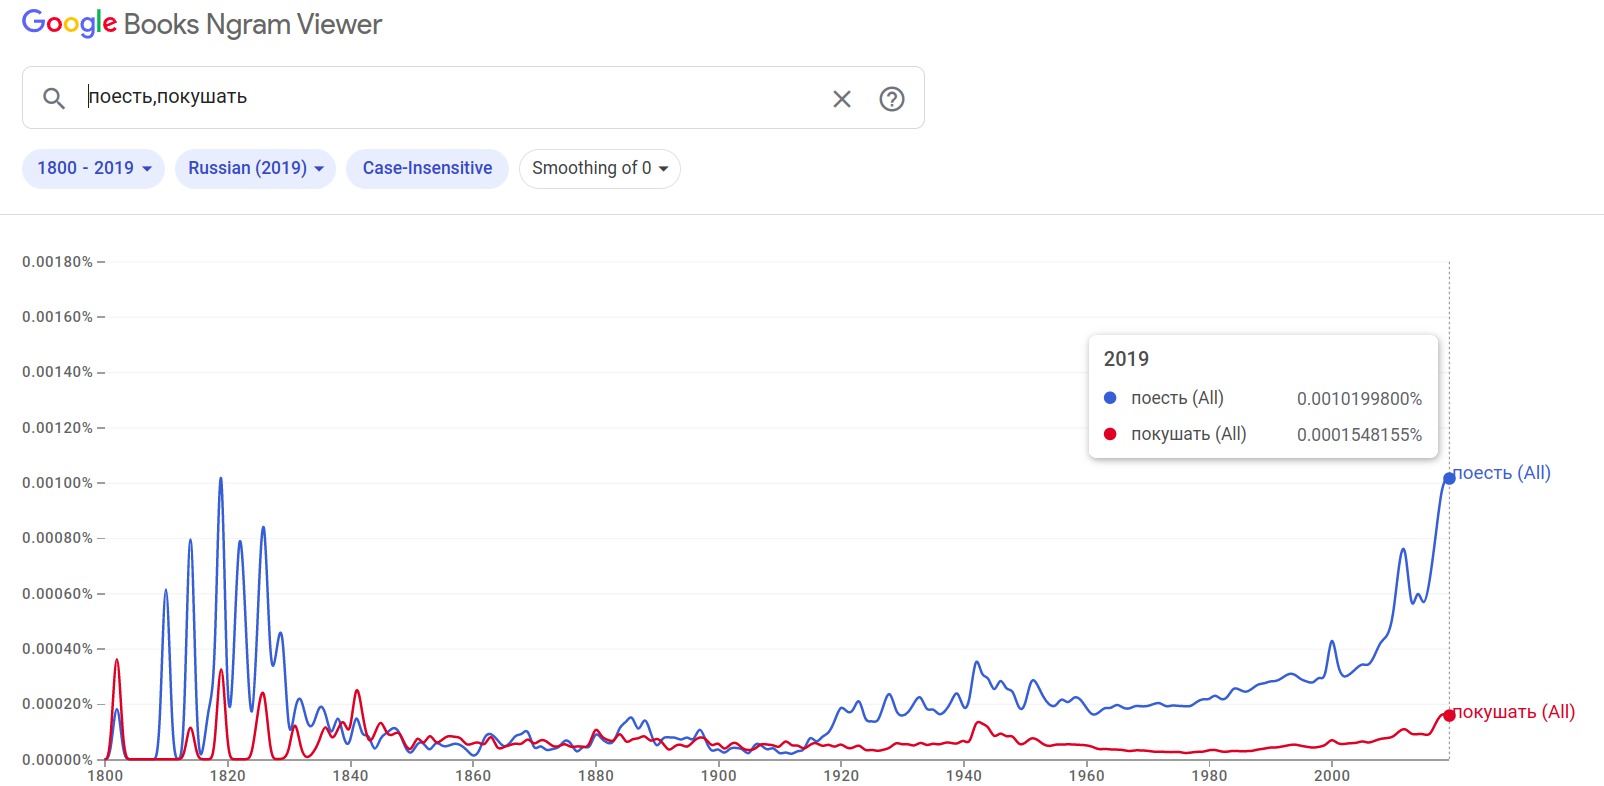

In [84]:
display.Image(b64decode(poest))

In [85]:
print(f'Livejournal поесть/покушать: {462819/316245}')

Livejournal поесть/покушать: 1.46348242659963


In [86]:
pojar = 'iVBORw0KGgoAAAANSUhEUgAABkMAAAMlCAYAAADAOoTqAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAcE4SURBVHgB7N0JQNR1/v/xl8CAokAoHpigAakoYWreVlipHZqbmeVmtmZt9bfaWretzf1ttr/NrW071nKz+5fapq65q9mhdlDempKGVwEpmHigxCEKA/j/fOfQAQE5RfD5+P1mHWa+93yYmM9rPp93kxOGAAAAAAAAAAAAGikvAQAAAAAAAAAANGKEIQAAAAAAAAAAoFEjDAEAAAAAAAAAAI0aYQgAAAAAAAAAAGjUCEMAAAAAAAAAAECjRhgCAAAAAAAAAAAaNcIQAAAAAAAAAADQqBGGAAAAAAAAAACARo0wBAAAAAAAAAAANGqEIQAAAAAAAAAAoFEjDAEAAAAAAAAAAI0aYQgAAAAAAAAAAGjUCEMAAAAAAAAAAECj5qM6cOjwCa1cU6wdu4p1KOOE+Vlq3cr5XOuQJrp8oLeiuzQxjzXR+eCWb/928n5MQLiejLxNAAAAAAAAAADg7KjVMMQdgnywpKiM504ts31XoSMcuWKQt0aP9FZjd7DgZ319ZJvjvhWGAAAAAAAAAACAs6fWwhBrFMhf/l5Y6eWtcMQKTb5eXaSpj9rOm1EiAAAAAAAAAADg7KqVMOTrNcV67Z2SQYg18sOaEiu6i5eiOzdxhB8Zh084QpPtu06cXM56fJEJRe6dWCczdgEAAAAAAAAAgPNcjRMIK9woHYR069JEU39nK/FYtPvOSO8S02lZyxKE1K6M5c9q6gcp5S9g81dgu3Bd0jNOQ6/pqVA/nWPsSnjzEc3aaJe8emrSjPvU16azb89CTX1mhTKKrR/8FTPxKT3YP7DidYoT9daUl7Uhz9yPnaRXJvdVfRx6g5GfoFmPz1KCdb1a9NWDz0xSTKUuWIZWPDtVC61m7hWm6//njxrltVpvvbZQCdlB6nnzvZo0MFQAAAAAAAAAYPFSDZWeGuvmG71PC0JKs6bEsmqFWCHImZZFHbDnKTttp1YvmaWn/zJLq/fZhTPJU+IH/1ZCrlCb/GLUr7u/835uotbvqmRbPLhB63e77of10qD2JkBbulAb9uXJnpuuDf/+WIk0awAAAAAAAAAuNRqSUXpEiBWEVKUg+hUDa5zFoEI2hcb2VUSLko/a7VlK37VLadl22Q8maPaM2fL/4yT1bCFUJHuDFi4ZpJhfdmW0R62xKaZ3jPw3bjBxU552btole0zMGa9v+sbNSit23o+4rK9CzL/7bR5vZz42+VT+rQgAAAAAAABAI1ejMMSqFeJmTXdVlSAEZ0OQugyfoHFRZTxlT9fqt17Q7IRsKdN08i8bpp43hwnlsHI709wzVs7T4v5TNSaCOKS22Lr1U0yLDdqQa/KmxM3aZY85w1RZ6UpISHOtHKF+fUIcd2NuulPX5/5XCVkh6nnjL9SVrBUAAAAAAACAS7XDEM8gxHI2gpCi//uPir/aqOL4DTqx+yd5xfVVk04XyuvKPvL+1U2V2saJg/+nE9lf6URWvJS/W00C49QkKE4KvNL57xlYNVKsc7f+tYq/WyGQVST+8oFe5jFngXiL9VhVR74UPjXTcV7WeVrn5b75PDnZ8W+tsoVq0IRf6rsfZjmmfsrYullpN4UpjA7kMnW9aqiOfrVCaSZEip+3QoMev16hXKva4ddF/WIDtWGNCeayv9PmXXbFVJSG7DPByU/Ou7aofuoV7Ho8MEajJpubAAAAAAAAAKCkaoch7k5/N6vzv65YAYF94hOOEMST+2crPCh697+yvTNd5YUGVvhxIu0pE4TEl3zc/Ox+rEmbX8kr7EnTOdupzG0s+rDIUfTd03YTgGzfVaSvVxc5roFnSFTZMKSs87Mes27u87TCHisUqVX+XXRJJykh0dzPzlCW+YexIeVoE6dfXpmoZz9Ll33Px5r3VV89MiREqA02del7iQLXrFa2+b/vzjBVVtqGBKUXu9frq0ABAAAAAAAAQMWqHYZkHD5x8n7rVmdevvRIkop4hghWIJB/0TVnXMcKDKzl/H78TKUDESsIKd425IzbsEaNFJllvWO+PC0QefrvdkfwUR5rlMihKpzjyX2WcX7u43eHIe7RItYIGGs0TO3JU16e666ff7mNITspXsvjE5SYlKqMLLOCzV9BbcIVETtIw67qq7Az1Bqp6fplyVj5sp79V6KyrUvuH6FRD/9W13d0dp/n7VmtFSs2KCHF7C8zT3ZvfwW2C9clveM09KqeCvVTlRXYfRVxwxgNSnhZqw/btXPp+1p96YMaFKxqsCt90wp9vHKDdu7JULbdpsDgdoq8tJ+5HnGKCE7T4qf+oo/3mUVjJujFBwfJUWJ8/8f6y1OLHbUyuv7yRT1ypQkG1n2sj75I0K59GcqzSxE3P63HhjlDGnvmTq3+LF7rE5O1/3C28ops8m8RonaRXdRr8FDFxYSUChzsSnjzEc3aaDYUHKfHpo9TRNZOxS9boVXfpmh/ll02c5wRPYfoFzcMUpir7rmyUxT/8UdatS1V+zOzzesbqHYRvTT4uhsUF1W5qMIW1VeXBK/W6kznVFnJ9hh1LSsNKU7T5oR0531rRMml/qee27dY0/73Y0dQEnrDNE27MfT09a1jXfaluSY7HceaV+zvuPbhXS7R4GFD1bONx053va9HX4g38YzZ3nV/1LRflBEVerwm1jV7xFyz06fnytCKZ6dqYYq1zCCzzASPZZxtYcWazdq1+7CyrBfRv5lCLuyqmD5DNGxQhAK9yt9nZdoBAAAAAAAAgBqEIYcyTgUDlRkVUrrYenmsYOWKgb4nf7ZGTHjymfaAvO/8hazAwApArBEhVlDgZv1cYgRF/u7TghCvqHecU2KZwMMxYuTQu44gxL38iYPvqok1QsTFCnI8gxBraqxfT/Qxx9rEMUJmx/cnHCNDrECkqjzPzzonzxEgjhDEnE/htFdOjh6xwp7aYt+1QvG7nfdtnSIVXvpltOqKzH1N769LN122HvLzlJG203Hb8OVyxU18SONiy+j0run65chOeEsvuoMQvzAN/fWDriDErpSPXtDLS1NMJ7fHCsV5yjb7Wm3dVsZo3P33KS6sajU/7PYC00kdozE399R3rycoOzdR//0gQT3v7in/qmwoP03xb87Q+1uzPbeu7IMpSlhubqtWaeikMZUo0H5YG96cpbc2Zpx6yCtUXaOdHeAZG2frlTmrlZ5f4iyUl52ulATrZoKH/hP0wJ19FVLOr2/W9oV69q0VSsnz2MLhNCV+NluJW5N136MTFJPxsV55dbF2ljidbKUlxuv97Zu1887HdF//SnTK2yLV17SB1V85p8rakGQ351LGVUhbrw0HnXf9YwYrpgoXPzvhfc14J15pJa5JnuPaJ1q31V+q59iHNGlImPP6R1yiSwLjtdocUvr275RhwpDSZ5Kx9buThdyVmajE3SagiCi9411KdJU48Y/upUj39TZtYcXrM7QwMbvk8rkmINm1wXFbvTJOkx4Yp5hyfz0qbgcAAAAAAAAAnKo9t1XrkCYn73uOEqlNVg0Nz6mjfL98t0T9DGuUhDU1lhWQnFzHBAee4YgVbHjy6v6lYzos98gPKxSxwhGvsGknlylOm+YIRSyHzLl5BjlWEDL1dzZHEGKxgiCrXsoVg6peM8VRA8Xj/Bzn4hHkuOuheI4UKR0OVUt+tlLWvK8XZsUrw+rItZlA4bpSnfrFGYqf9TfNdgcZXv4KjemruGFDNfTKvurazrV0nuncf/VZvZVQqkO3puuXI2/HQr3w1gbXcYdo0N0PaUy0c1t289xb7iDE2l/sIA29cZSuv8bsr41rf4cT9f7M95WYp6opdsY5/r1/qV+4euCzNy3Uwh32Kmwj3ZzrC6eCEFugwnqaY7SuyeU9FRFsc1yPFa/P0YafK95U1rp3NdvVAW4LDFVoWKhCLozRJaap2FMW6pW3TwUh/u1jNOia6zXqF9draP+uCnGMjDEd7uve0isLdqrMM8jbrH85ghCbQqJdr5s5xpOjeA6u1uy339Ks151BiK1VV/UdMtRc60Hq2dHVc1+crYT57zvChDOzqWvfXq6wwZoqK7nM40rZkOB87U1rjekTU+kgKm/rbD37ujsIsSkwoqcGDbte1w+LU9/oUPl7uY533guatdIVLNi66JIurj3sM4HGaedhlt+S4vFzhhLdhd092H/4Tsl21zHHdnEGLSYoXDHjhVNBSItQxfSPM7+HQxU30FznYPcop3jNenGhUvJVporaAQAAAAAAAIBTqj0yxJPnKJHyWCFCReuXNarCMyiwRkyUN0WUFSBYwcLJGhtfbZS7oLoj2HCxAo/yiqQ7RoJYo0NcIYg1YsQRmpRijQgpixWIWOdRlenArON08zw/94gQz3NyK/1zxUwg8dy9iq9okeCuun78JI3qWPJb+BlfvGU6ap2Jga1NX427f4IGtfdcJk9pn72lGR9YIzQytGHuv3RJ5H3qG1g765fFqtXx8usrlG51LHuFqO+dj2iCx4iS5E2bXR3lgep51//ovj4eG7slWzv/PUOvfLFfQe1sysuVqjakwy1Qg269Xqt+sDqoM7R63mIN/uMYRVRioEnGF7NNeOK6Ju0GacLkcerrOS2TPUMJ/35Fb32VrowzbCs9Jc0xPdjQCea161lququIUbr31/5a/JH5/Rk0SROGhJU41TG/sAKhWYpPM4HIqk+0enhXxZWe7ssEZtle5jqOf0yTLvfY/o0JeuuZWdpw2AqmNsgqN+MfM06/vy9OoScXylPi3Kf1shUq5CVq1YYME8ZUYqRCRD/1bBOvFQetqbI2mACha8mpsopTtHmr68oE9lS/mEqO7jHH8P6c1a4ALVSDJj6gcb1LXrO8PSv02oyF2plrjv2/C5XQ8z71bGFTlx5d5L8xQXn2ZH23PU9x/T2uZPZmJe6x7tjkbx7OyzPXM3Gz0m8O06kJuuzalbjLGez4WeGKc6/pn83W4iRnW/CPHqMHfz1UEZ4vktUW5pu2sNKEiftWaPayfpp24+nTdFXYDgAAAAAAAACcVO2RIZcPPDUSwgoyShdUL80aTVHezXOaLc/7nmFIeYXR3TyDkpOBgSvYOCnwSlXEMyg5kf2V49+VHuGGNYWXe0RIWWpSRN46P+u4rdEwVg0R99RYbtboF2uKLGt0TO2xKSQsQuEhzUo+bN+pFZ+lODtw/btqzIOTSgUZjicUds19emiEa0qh3AR9/EVa7axflv3xmvXKYueUTaaTPua2BzShj2cHu12Fx10jeLyCFB5WOlUJVNebH9K0v7yopx+2QghVX5uh+uU1ruM2x/Wv5elnXse6Jl94XJPJE0oGIRZbiHr+8rcaF1uZlCbEdOo/qDFldoDbFNrzet33x2m6r1QQ4hAco3F3mPDCaq5WJ/+OsofJBPa9UxMuL7V9E0Jc39+jFkeLnho30TMIcZygYobFKcL165C2O02VGj/jFaFesa7XNNM5VVYJKeuV4JoiK7BHX3WpZM9/xvqP5Bx4ZFPEDfdqQu/Tr5l/x6G69zbX6KjcRMVvco7Y8I++RBGukTQpO1JKnEdeomvEhwk5rr8u0tUevjt5jA7Fadq5yxWAXXyJc1ovqy185dpWYF9NKB2EOBa22sIkDW3v/DF9zSqllPkWW1E7AAAAAAAAAOBW7ZEh0aVGelgjIqobBngGKe7pt0qPgLCmi6qI9bx7eix3iHLi+O4SyzRp2qnCbTSxaoi4fyi1ruexlacyheQ9eYY9Vvhh3UocT6kaIlVnU1jvQYosnQsU25W1f5d2/ZChjK0fa9au7zT0/t+enG5KaYlKzHTeDek3SoPaVLD9a36hnl+8rA25psPWdA6n/yJMoTVdv/RimRv01oz3XdMU+avrTQ/pvitDS3X+2hR+cbhsG3fKbjqgP351lnTjMA2OiVCgu2C6CVFCqvgalSfsul8qbtOzWrHfrrRl8xTf5xHFVRSwVPqaBGrQiEFakbjCUQi8XBFxuv4MoUnevgTFr1ilzUmpOpzpLqAepFbhXdTrUn85IzC7Dh+0hmWV3laIel1Z9jRUIRe2M1fbOf1ZYM849WxR1kKhCjErp5jX1Z6b5Vi2Mp31EX17KuSLFcooztZ3CcmyR3c9uV7KhkTXiBlzbH0iK9n5n6ddW1xhjFc7hbfJ0s4dWWUv6hOiVuYtLM/8fiTvMvu+sqdsLS7RJRE2Je6wK8/8niQXx7iKn+cpcatzxIft4l7q18euxCU7tdOepu+2Zuh690gYE444X3ebImMvcV7PPQna5WoL/p1Mm91j1ivn6INCzS/vPtPws3bpu/3m+rQvtUDEmdsBAAAAAAAAgBqEIdYICWvqK3dhcSsMuWJg1QMRKwjxnCIrurMzcLCCAPdoCcuZpoc6sWffyfvuUSSlp8SywpEmrlohZ+QKTkJaNVFlWYXUq8Lz/Eo/bgUg7qm+qi9IkVeN07iosp/N27VYL8/6WClWnYq331fkk5McHdt5P6W5Op39FdElrOJOZ78IR2fxhq2mW/hgqkw2oKAarl9ylIEJNl5OVLpHG2kWHFTmNgMHjtGoTS9o4a482fcnaPHr5ubl7xj9EtGlq3r17KeYiMDa+Qa9LULX3zJICTNXKyN/pxb/e7V6TR4kR+5Uxq+A45q6al2c8ZqExSiihQlDKqi1ERIRqfInnrIrZfkrevU/O51F5j0ez8vOUF5ihpXNnHrUXsa4DSs4aFf21m1+/nKWq5faX9i+nHPxl7/t5G5VqEoK66e+bVboY9Pxn701Qcm3uKbKsu/UevcUWW16qt/FlXwVi/cr9aDr/ExIFv/6ixVPG+c+5Ix0ZckEM+YV7RUTpvd3pDgCiV3m17WrNVtV/i5t3uWMeKyQIzC4QGYx7TSLpW1NVPY1cY62kL19pzPU8gpTjKsKel76/pPToOVtXaiXt1bigIqzlJFh9ldqhFXF7QAAAAAAAACAW/XnddLp9TOsQuOHqlBMvazi5J5hiufUWJ71NcriWTS9RIjgGX64pr4qT7FVM8S9b9d6nqM9rOCnovOrTO0UT6VroFhTYTU9scMxHVbNg5Az8+8ySpNudH3zPjtByzc6e98L8wvcS8g/4EydzmYZd6+36VTPs9d8/RKKM5R+sMTkREpY8G8l5JaxKasQ/MNP6ZGbBzmLkTvWz1PGnkRtWL5Qs559VE88974SDlah6HlFRx4zRmN6uzq4t/5X/95kTYfkI1sZv1VVuybNHTUoKmKzlb8Nq1j4qx+4gxB/hfa+XuPue0SPPfGYHnv4Pk24cZC6tjrTMdhkq0Te4ONTK2WHTjGhQa/errFBmZuV4KpPbk/aoM2u0RShl/Y7OQXXmZlgLF9Vl2/XMVeQFBjbS2GOAuvp+i7RGWPYd22WY/arkyFHiPnXWdPDnpKg77Kd+/5uh2vqt7BL1NP1XnKqLVRFnvLKOA+brZKhEAAAAAAAAHCeq1FPpjU65OYbvfXBkiLHz9YIj6efs+uKQd6OguIVsUKF1x3hyanHSq9jhQXuqaSssMP7zl+orCLqVp2N8kaOWKNDTrhCDquYunebO0sGJC7FSRNL1BhpYi0nZx0QKxBxH6dVQ+TygV6n1Q6xRrhUpXi65UxTf508NnMN7BOfkO2d6SqviHx1hcTGKGzBTqUU27V/d6p5JEY+fr6uZ00HbM6ZJjiyOwpHO5iOWSvXqOn6ZR5nnwkaE7xCs6z6HNkb9K8P+qnLnWVM4+QVqK7DJpjbOGWnJWvnrkRzS9Z3u1KUbTqTs5PiNeuFPN33x0llT+9UJf7qefMvFLNtthLzsrXhg4Ua1KWvbGU0/apdk6PmmqiazHF8kSBXxQvF/HKq7ruyZD2JiOieGnR5uF587H3trFqTPSvCLuup0E/SlV6crc2bdmpcl0glb/rOeU5eoerZN6wKW/OXzZomzQrPwkZp2h+vP30atjNpE6NeFy5Umsk19u9IVPZ1g5SasFOOl8gj5AiNvUShS9OUbk/W5u15GtRzl3amONt2aEzPkyM4TrUFm/re96Im9STQAAAAAAAAAOpajUaGWKwAwwpE3KzQwApHnv673REOeNYDsQIQ67bowyI9/Lj95BRbFmsbpafYsqaK8hwdUjDkzhLBhzsk8Ky1YYUFnjU2vMKeLBF+FG26yBmOuIKPE1nxKk4ccjIwca4zrcQ6VrjjZp2bFeI4p/dyHr91Pn/5e6UnAipxrJ4jQBx1Q8z5nax54iqobp23dd86V88RMLWuyDn1kf+F7Vwdt3lK2ZVW8Tr5u/TdbleY0SZc7Ww1X7+0wNgJeuSuQeo5YsLJuhzZ697Xwh0VjfCwKTCsq/peM0YTJj+m5575o8b1dBVPydygj1ZmqFYED9K4GyKcYcPh1ZpnOsPLyjn8LwwrcU0qHJvy0y5HrY1qKd6n9P3u6zlIN1xeTmHtg+muabvOQe37qq/r1z47MUE783ZpwxbXnGEXmueqkoU46oS4rsDB5Gpe11BdEuOMUOy7d2pntlV03nk8niGHLuylGMcPdqVs3aW8lO/MscsR4MT0OBXB+Ie6fz/Mcin7BQAAAAAAAKDu1TgMsVgjJTwDEYsVdFhTYFkhwcOPF+j2ewocAYh1c48kcbPWLW8kie+X78ozELECg/yLrtHxJtGOkMAzHLCWs5YvwYQaXm1+VSLcsEaBWKFI0ZomKt5mgpDs+BLLN7ECFA/WsXXzKBhvnZvzvOyO8yp9PlVROvCxzs86L+v8rPP0DHqsQMRz2dqQkbBZaa5O8VahrZwd52E9FRPsen79YsUfLn/99C8+UoKrnzo05hLnt+5rur4nrxjdcvcghVgt1S9Co2513S/O0Op/LVTKyamD8pSesEKzX5iqaXN3nh42+IcpbvSwk9MrHd5fe53QIVf9UteHOTvc07/6WBsyy1goLKbENVl9sLytZWvDR/EVF0+vAls5+1j9yQbVUhxUB0LVt7cr8TicqA2frD/ZRiL69q3iyA5/XdLDVWw9P1ErPqsgiDoYr1nTX9bClSmlaq2Yly82xhlgWOHdFxucRdG9QkqEHI4pvrq7Iq9d67UiYZdzNEtwF/XyDHA69lQXd1tY81HZ7cW5Fe3897N69p2PlbC/dqZ2AwAAAAAAAM5XtRKGWFNGWYHBH3/nUyI0cDt0uLz1pHsn+lQ4pZbV+W9ND3WmEMAaZXFaEOLehgk3vKLeKXN6rBLLmdDEu/ePZT439Xc2XTGw/MtlnUtZ534m7gDHqhdSmeVqc5qs7B0LNWtJirNz2LNWg62rhl7jGu2Qt1MLZ8zWhtPqbOQp7atZesW9fosYXX9VWO2sX4KtRCv1rNNhdV7PXupaX1lK+GShVu/KUPrqt/TWyvTTOr0zdu3Uflcnt3+LMxTlqApz7YbeFqdQR0iTd3rdE8dpmGtylcc1mVnGNSnOVuK/Z2h2QrXnyDLHEq7wC90jIdbrow0Zp+0j4V8z9H5iDfZxFoT0dtcFMaHX8g3OKam8IkwbrXq58MB+Q9XXFT6kL5uhWctTVPrs7fs36K2ZC5WwxwQmc1/QW6tLVa/v5A6z8pTwmStICo4pGXIYYT26OAqnK9dsZ43z2gfG9CxZ48SzLeQmaPbMsurYmCDko9f02mcpSlm3WLPMsaWQhwAAAAAAAADVVqvVj61prn4d0kQ7dp2osIaGFRxUpq6ImxUAWEXFrVEgRe/+9+Q0WVZAYN3KqyXiyaodYgUdJ9KeckyNdcKaJsvcrADE8XzrOx3LVMQKbq4YWKwd3zvPzyqY7p7ay3rOmi5r+y7nKJHWISWDkSYqPyixzsExQqRje0eheOv8rKmy3OdXeuqvysvSrk9MMFBGbYy8gynalZLhCgxsCr3mlxra7tTzIVdN0pgdTzs6ze37V+utJ7/T8phLFNkuSDa7CRx2JSpxn6tL2StEfX95p/oG1t765fNXz7G3qOeOtxxF1NO//Jc+7vuYRoWFmkBiqDa8sELpdtPhP3eanljTU72iwxVisys9JUEJienOTnBbmAYNilBtskVdrzGDEvRyBdNvhVwzQaMS/6aFu1zX5M/Oa9LVXBPlpit5e6JSDptXxC9EId4ZyqhWXuGvvtcM0sfb45VhBR/vTNPUjX3VMyJE/scztOvbDdppdby3ClFgZsZpIyDOGW3Ma9fJBAAppx6yXdxP/Vqp6vxjNGZ8nHbNdF6TxA+e1dSVXRUTHaYQP7uy9iebtpGmvJMF08fpjkGlGqNXpC6JDlT8mmzZ7c7fmsBuPZ2F1T3Yonqpa4vV2pBrl3Mxf10SG3naIYWatjDGtIX3rbaQFq9Zf96ssGhXW8jPUNqOBOfr5NioadvjRymC0iIAAAAAAABAtdVqGGKxRom0HtjEMYri3ok6WVcjwwQHISYgKF14vCqs+hqeNTaqwxolUnoarKqwwo/oLuZOGUGOFY6U5au+01UZtXF+JZkQIHGD0itcxl9h10zSQzdHlJxSyQQUcff9Xra5r+n9demym07ktK2rza306mGKm/DQqXoctbV+RQL7aswv1mvX3ETl2dO0Ys4K9X38eoVGjNFvf23XjHfilWaChGwTgMSbWwmmY7nvnffp+vaqZf6K+cUY9d0ySxuyy1nEy3RqT/6t9PoMLUw0C5nQJi3BXJMSmwnT0IljZPvPi/q4moM3bNFjdN/NGZrxQaIJO+zKSFytFYkeCwTGaNz9/bRzugmUdK4KUc/eEVp4Mg2xqUufXqpCKynBP2acHpts06tvrVBKnhUG7tQGcyvJhIL9x+ne8a6p2Eo91yW2q/zXuEapmNe7a2zk6dOQ2bqYAM5fGzbmuXesSy4uI8UwbSFu8u+ld1/Rwk0mlLSX8/sR2FXX3zVJo7rU4kgmAAAAAAAA4DxU62FIae7woyYhyLnAGuWyck2Rfj3Rp9xz8RwJE935HD5fL5tsLYIUFtlT/a4ZpriocrqYTXAwaOI0XTIwXstXJigxKVUZWaaT1+avoDbhiojpq2HXDFJYC9XN+hUIuXycrl83TQuT7LLv+Vizv+ipx64JdXyr/49/6qf4z5Zr/dZkpWVkm0jIpsCQMIVH99KQ4XGKaVVHX7Fv0VO33BijRCukKW8ZPxN2PDhdMRs/1sfmmuxMy1C23fR5B4cpMraf4sz16BqUpvfnORe3mWtV9aO1mYDrQT118Wp9vGyVEnalOUaZ+AeFKCI2TjeMiFNEsw3aqXObY6qs/6Y4p4fy66J+PasbhTgFxozRY//bTxu+WK7VW1OUejDDhGk2x3VpFxWjfnHDNMj8LpR3vW1dLlEX/w1yzGLmb0KPLmUtaUKTHl1k25jgGHXlWMevnA36mUDk19MUkxivFas2KzF5v7Jy82Q3r3lIuwh16TlYQ6/sqVByEAAAAAAAAKDGmpwwhApZBeDddU+sYu9WwfjSgYhVLN4dhljTgL30jK+AasmO14uPva+dxdbUWo/p6Vtqd0ovAAAAAAAAADjf1PnIkMbAqm/ywRJnLRDrX6teiDVdVogrELFGjGzfdaLE8kBp2Xs2aNXK1dqQGqYJU8YooswRA3alxa9yBCHWVEwRXcIEAAAAAAAAAKgZwpBKcBd6dwciVvDhLpReWrcuTSpdGB7nE7tSv/i3Fq+zCors1KtvhuihiXEK8y+5TPrK2Zr1iauKSLtBGhJD1WwAAAAAAAAAqCmmyaoCaxqsRUsKT06ZVZo1hRZBCMqVuUGznn1LCZmun/1D1TW2i8KCTSKSl6G0XYnaud9VbcQWqrgHf69xFM4GAAAAAAAAgBojDKkGa5qsHd+f0KGME2od0sQxXVZ0lyYNvkg86p59/2rNfvV9bdhvL3+hFhEaOvF+jYmpWcFwAAAAAAAAAIATYQhwthVnK2X1l/py03dKSduvjDy7bE0DFdQ6XF169NOQIX1LTZ8FAAAAAAAAAKgJwhAAAAAAAAAAANCoeQkAAAAAAAAAAKARIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBR81Ety8rK0tGjR3X8+HEVFhYKAAAAANAw+fj4qGnTpmrevLmCgoIEAAAANFRNThiqBVYIcvjwYfn5+SkgIEDNmjVz/OHcpEkTnXesK3oenjYAAABQAn8XN2jWR0XrC27Hjh1TTk6O8vPz1apVK0IRAAAANEi1EoYcPHjQMRIkJCRE/v7+AgAAAAA0Lnl5ecrIyHCMFGnTpo0AAACAhqTGYYgVhNjtdrVv3/78HAUCAAAAAOcJ6+Pjvn37ZLPZCEQAAADQoNSogLo1NZY1IoQgBAAAAAAaP+tzn/X5z/ocaH0eBAAAABqKGoUhVo0Qa2osghAAAAAAOD9Yn/+sz4HW50EAAACgoah2GGJ9C8gqlk6NEAAAAAA4v1ifA63Pg4wOAQAAQENR7TDk6NGjCggIEAAAAADg/GN9HrQ+FwIAAAANQbXDEGuO2GbNmum8VaOy8wAAAMB5jr+nGzzr86D1uRAAAABoCKodhhQWFsrHx0fnLcqkAAAAANXH39MNnvV50PpcCAAAADQENSqgTuF0AAAAADg/8XkQAAAADUmNwhAAAAAAAAAAAIBzHWEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNmo8AAAAAAA1DYY4OpO3T3oOHlH20UIXmI51P8wC1bdNeYWGtFcAnPAAAAKBMDeNPZfMH/+GMHOXky/GHfquWAWrGmBYAAAAA54mcPd/oi/j12rRzn3IKy1nIJ0AXdu2hwXGD1b9jgAAAAACccg6HIYXKSV6nj774RluTDulYscdTfsHqFN1DQ4YOUWwbvvp0Plj7P/1018axWvjRFHX3lvI/f1j9HtirB5Yu1N2RAgAAABqno6n6ctEifbz1kArPtGxhjn5KXKX5iesUHztUt40erE7NBQAAAEDnahhSmKlNi97VvI3l/MGfn6nd38brna2bFH3jBE0c1F42oTHrPmCAAhcu05zPx+qp/tlaMG+t8juMUq9OAgAAABol+751euftD7Ujy/WAT4A6xfRQbLcu6taptQIDAtRMx5WTk6P9abu0/btt2pSYqpzCQh3Y+on+sSdFN9/1Sw1uzxfIAAAAgCYnDFXD999/r86dO6vWFWdq3buvaf72HOfPPsG6uKf5gz+yvQKbmQ8EWYe0e+e32rT9kI45FmiqTsMn6f9dQyDSuB1S/F/u18OzNyvbJGR+HeL0wAsvafJlgQIAAABKO5a8Suvye2hIt6pNF5WzfZW+8btMQyKbqj7Z963SG69/oh+OWj/5qGW3Ibp55GB1C6k42LBn7lL8kg+1PDHT+cWy5hG68dd3akgdBSJ19rkQAAAAqGXnXBiy97OZ+seyfY4/3Jt16K/bJlyn2ODT/3A/9mO83pmzQj9YmYlXsAb/+mHdHMk3nhq7/Mw0pR1pqjbWN+G8BQAAAJzm2PefaObsVfqpqLX63T5Jt8VULhDJSfyPZr73jQ54t1fchEka1bmeApGcbZrzj39pszUixKupLh56pyZeE65mJxco1OHkbdqRlqljaqqWYV0UGxns8eWw49r92Xt6e0WKcqzphoN7aOKDYxVbB2VECEMAAADQUJxbZchzvtHHXzuDEIX018RfjywzCLE0uyhO99w9VJ385BxN8sk6HVY9SZiuYZ0jFBFRzq1zPz25qtQ6hzZrwV/u15gh/RQdE61+Q8bo/ueWKCnPY5k9czS+t1m/911asNfj8VWPq5/Z37Dntp16rChJM8dGO/Z1/4eHTj2enaQlLz6s8df206VmP9G9r9SYB6Zryff5JQ4n+z/3KzriUj280BzXU3dp5BWXKjr6UvUbcZemL9ymEksXxetx67hGzNS2olLn9fnDutSc88iXk04+lPb6GLPtaD38cb4qdGiB7oqOUPRdC5Rdal/Ro2bK2qJfcJiiIq0gJF9r/+dKx/Ud+eK2cjfp3HcFr03M/VpW6rCyty/R8w+P0bCB5hrEXKorR92v6fM2nzom61A/fNjxGkSPNcflcQ22PTfM8Ro87vl67zXnZV2vS8drTvKph/P3xGvmE+5rHa1Lrxipu55aoG2eOyrarOeHmv3cPFPxy2fq4bHD1M/9Ok6ZqbX7yzrfsq61aR83m/YR87CWnTzebC24xzwWbdrXoZJLnzy/CXN08ilXO+/31NqSC+9fovsHWuc3RjO3n+E1BgAAOAsKC46r0Pqbp/CQ1r/3luYl5pxxnZNBiPVhpMiuYwV21Y8cbfrvImcQYoKOi6+bpHs8ghB7xjZ98I+/6i+zFuiDj1bo448+1NxZf9eT//hQWzPckww3Vadr7tTk6yKc62Vu0bz/btGZrwIAAADQeJ1TYUhO4hb94Jj7KkC9Rg7Vxc0qXt7WPk43D2rtuF+YtkWbD6peBV5yoybfP7nEbWxZ0ziZzuOHx96ux2evVX7XIbpj/B0aEnZI8a8+rDHjntdad2d4xzv014cGKjAzXs8/s0SHKth30txpeuObfLW+fqr+PNJ5TZS3VtPvGKmHX41X1kXX6o5JD+ju4ZHKjn9TD99xf8mAxSFby/7nLs1MDtO19z6hJx4Zq+5H1+rNJ27XpHeTdC7JT3jFhDRplV4+6vq7S702d2hgh9OXy141XbePfVgz47PVYfBY3XHbtYrMd16DMU8sO/katB45VVOvb638b97QtLkVHcchLXnmecVnBmrgI3/VHa5i7/nb39Sk0Xfp+Y/3qnX/sbr7/92tUd2lze89rtvvfvO0kCl/+yu6/w+fKr/XWD3wxyd0d1xrJX34vO6640nFZ6t2ZZv29oJpb2es0GkUpWnB//xJyzJaK+7xFzW5m58AAADqW0DMTZp8+2Vqa32vqhKBSIkgxKdqo0lqm/3HeH289bjjfkDsjbojzmM64JxtmjfrX1q19/hp6x3bu07vzFqkrSdP00dt48bqZtdwkGOJK7T8x8r8gQcAAAA0TufQvFKF+jHFNSqkeRf1ruSQ9A49u6ttfLwOFB/Uj3vMh4I29Te3r1+vWzXl0QElHtv8zDIt+DbL45FsLfnL01ryU6CGT1+oV8eEuR6fojtenaTbn5upx2cM1PI/DpDVrRw2/q+a8vlIPbn8eT29PE4vDSsjXNm7QNNnrFF2uxv10tQb1dq9p8/na9mhNqaT+i29fVfUycXvGfywhj68RHP+vU1jH+leYlOBV/9ZC/9htuGaguqOG2P08OiHtWTGK1p200safi6U6ChK0pt/NYFBpQch+Knb9VM05XrPjvo0vblxgdYc8XjIhEfP/4/Zrt9APTHnLd3t7tjPv1tzHrhdTy78k54ePEAvXW9dhNa6cepUfbHBujZPasHVb2tsWeHKx0/r+eWHFDj4Kf11vPu1ztfmRQv0Q/NemvzCe5pymfu4HtC1Tw3T7e+9oQVr79ZTgz025B2lu99cqCk9XcveNlbXdjABzcsL9Py7YxX3YHfVDnNsM6Zr8Z7KLZ307h80/fNshd30qp69LUwAAADnCmcgIlfI4QxEVEbIcS4FIdb0Vlu//laOP1H9IjTsxh46dSSF+mHFJ64RIz66sN9Ijbk6Rm11UFtWfKgPNprPUllbtHjFZYoeHeEKUALU+8Y4rd/1oX7Iz9Smr7fp+ot6qJkAAACA8885NDLkmLJzXN9wCg52fourMkLaqK3jLArN+g1g4Pf+xVoQf0h+l96jJ8Z4dh77qfuvf6uxkaab/j/zFe+eLss7THf87xTFBaRpyV+fL2MUwCEtedo8nmM65/8wVTe2PvVM4MiX9NWar04FIUX5ys8zCULYxWpjwo6kvXtLTn9ljuHiAQNOBiEOJmC55yazfma8Pll3bkyBlDZvut741k8Dhw9UbWYz+fHzHSFA1C2/PRWEWPyidMfj96iX9yEtW/jpqRE6rW/U1D+a4CinnJE72fGa/twSpQUM1JT/vUNhJ6+rnwb8cbnWf73wVBCS73xtOkRFyq8wW2l7S22tZS8NjPUMc0x7mTRBcYH5SvosXrU2bmf7m5o+L0lthg9XrzMM8sjfboK7F9Yov/PdeubJ4WotAACAc4sjELmj/BEi51YQYhzbpa0/uEaFxAxWvyCP54r3aevOTMddn87X6d4xl6lTcFM1Cw5X/7ETNMpVP/HIzm36qdhjvaDLFOc6p2M/bBOzmgIAAOB8dQ6NDLHJx91ZXCxVegB3kWR3/bFv82oABdTNh5NEE3SE9eql075H791dA3u21pv/TVbibml4N9fjHe/QU7/9UiOfmqMn789ST+/tyjYXKP+r5/VwyiGt/fyQWl//qqaOLKM7+tBmzfnnK1rw+WZt21sySfErUqVE9ehmQoc07U22poOKUvXka8kD0Vri/tE/UGFdBujGSVP0wPVRqvTkSoeWaPqMeKnPE5p2U5LGLFOt2bbNXFefQF3bv4xRFp16qVcHabN5/awaIe7AyDEt2ecJuv/Dp3X/A18ocPdB03jztfn1h/Xw8QTHCKC4J/+qOzqevsns7Qv0yj8XaNnabUrL9PxU6qeCyrw2gd0U09FPy/b8oGSzelRNZ6gqStOcp9/Q5ubD9dIjQ/Tf+Aoubt5mvfL7V7RZvTTluSkacC6MGAIAAChDQDcrEJFmzik5QuQGfXZuBSGWfan60fFnYVNdHBPpURDd8Gqmi/vHqZndpsCo7ip5pAHq1DFYSj5k/k47pmzr89HJr735mG1FqNmmLTqWn6rde6XekQIAAADOO+dQetBUgUHWFFfHpcP7tNd8CGhbmc5d84HhgCMMCVDb9vX84aUS8vOyTCzgp8CWZX2P3jweaF2DbGVnlXwm6MIwWV8MS1u7RO4KFfnb47Vku3O97h07nD5K4tAyPT72YS3IDNPw26bonl5Ram1dov2f6snH5qiyFTf8/JvKzydf2bmlvka2/XmNvPh5VVbUjZM1KtI5jdnxo2lK+HixZj68WUl5ntOFVaAoW/HPPa9l2d01Zeodijr4pGpTvuOitzHtsIyG5x2oNoHm8fQsRxClk6M8AtWhQ6D8CtO0+eOTUY+SVi1xjtbwCVNYx6DT97V2um6/500ltY7T2Huf0sDOYbI2n7/qed3/avkF4Usy7aWFHOFLfr7jR/fWSwZPnvzL39qh/0zX8xulgU8+oRvbJei/5S337u2KeNd5P+r+pzT5EuqEAACAc9tpgcicv2uTClVofY44V4IQ49jBg84i515t1OHC0h/VWiv2qqGKLWvF4kP6Idk5akTt2qv0qrYL26ut1xbtLs7RgYPm81Zk/U0tDAAAANSXc2ooxUUXR8pn4zbTt7tL6zfnqPeAM30gOa7t67c559RtHqHYjuf+yBA//yAFWsFCVllVr83j7g75Fh4P563VK0+b8MK3l6YsXajJBx9Xv7sWKOieD7V8cramj7pdb771pN4cbp7rdmq1pHmvaIFVm+R5EzaM9IhKkrcp0FuVlp9pBQB+atOiVKd364G6Y/wAc7SnHN/9qd78T1md+X7qNuwBTfas2zGuu8bf8KSWzTHBwU2TzzjmJHvtK5r+34OKmvCicxqrg6pVgYFWaGHO9WgZT5og5mC2SRyaW8HQqYetQuhPvrVN+ZF3673FTyhw5jCNfCNLY99er2fazNSY0c9rzl9e0bWLntCAk0HEIS14dY62aaCemvO27vCoNZL9UxWGWFjHlGWOycdPfqVeGs/gyemgNv17juKPlL2pfBOcPf3CMuVfOkXTrNofRxNUHr/OcRplPoVv/jheSf8xbWzsqxrbUQAAAOe0koFIoXMk+jkUhFjyjrmmDfYKUGBlD8mEO+vmv6sle8wZeQVr8LD+alV6mYAANbNGihRb+zgm64toAAAAwPnmHKoZIjXr1lu9HV+iL9QPyxZo1f6KJ8vK2bpEHyQ45/xt2bu/ujWEL6h376XuvlLat2tPH5lRtE1rErKtT2qKOTl03Spo/aTmJPsp6rYndHfnUuv4D9ADj96osILNJjB50zGFk3u95N1JjpojMd1KdbBb9SkqOUWWY/+btztGs0RGlhq90XqAxv6/yZr84KnblOsjKz/lVYde6mkFAfvTTq+3Ufoo8hP1xjNzlHThKD3xUC/VxUvtmA7MfJjcvLaMMGf3Zm3ea4KALt3V3R0kFSVpzrRXtLkgTGMffcAj7HDpfLeeuM1EPN/P0fQZm0/VZzHrpe02P7Xupu6hJVfJzy9QpR3arITd5pg6XqzIEhfEFTw96Pna3KHercu7atla8/J0Lcnsrrv/cLeizhCUBQ64R8/87W299b+m3WUs05OTp2tttgAAAFBDlZ4q2O3oLi1++RXN/zbTEaDEjp6kmzs3gKmDAQAAgHpwToUhpqdZN9zgmv/2aIo+mPWWFidmyl56ueIc7Y7/l156b4uOWEPbA7rr+rhwNQitr9Uvrmmt/I1vaPpCzzgkX9veekEL9khh19+qOFfHen7CK3ry3STldyg/BAgcNlWTrwxU/tpXNG2uu5S2n1oHtzEbSNLarzzKa+dt05svztY265PWaZ+28pW4bLG2ecyGlW868mcuMcfZOk7X9a/lCCLddOZbAUOHsJJF28vy/TIt+z5QN/52iuLqqD6F3+BbNaqjNaLmr3rze4+LUJSmBS++oc1FrRV3y7UnC4UnvTtNr3yTr8ArTQg0rKyD8lOvyVM0toN5bd99Uq9859qmd2sFWcHE/rX60qOCZX7yEj395hqVWdPy0FotjveMjLIVP2OO1uSZkOya4dWu5OLc8WYtW5amsDFP6IGelX+Nw256Vi/e38tRdP3hKXM8gjgAAIBzT872/7hGhZgfvHzkY30SKqOoen0KbOYasWE+72Sf8ZBytGnRAsXvs07IBCFj7tXEfsHlLJqjY646i/7NmgkAAAA4H51zXxsK6Dladx3M0eufperY0VTFv/t3rW8XoeiL2quV+bv9WNYh/ZiUrJ+yPHryTf/t3vXfqNWAy9Spuc5xpkP/8T9rzbaHteCJkRr5+SgNiPBT9o54fRpvQo9ud+uZ3w5whh75Jrj4y5vaZjrhhz9SUQjQ2jEyYcHa6VozY7rmxL3tKNjda+wdGrjQPPbMGA2Lj1O3ltlKXrtWSYWBCvSxamQcVLZj7VPyNz+v20es0bVXRinQBCnx1lRIOSYEeHKKhtcohMjX9uWvaGZyyZohawrCdOOksZXqzA8cPEVTyioSf9IhzZlwhZ7cHKdXN72q4VXNbvwHaMr/3q3N972p6WNHas2wOHVvma+kVYu1zIQWYTe9pD+7979njqbPXKNs/4F64vGxKveogodrykNx+vSJeL057U1d+6/J6u4XpbHj4jT7iWWaOW6YEuJ6KiR/r9au2qz8QOsiZyvriDVdmudW07T4NyOUFHetenX008GNJhz6Jk1+1uiTO2sUhTi1u1FPuNtdpZmw55FX9eyeMXp4yXT9v7+EaeGTcaKWOgAAONeUCEKsqbHucBVQL1VUvb6ny2rWpo2JNVKUU3xQe38yBxtcwce1nG1an+icViug9026rU9wuYvaf9p3qs5iG6bIAgAAwPnp3BoZ4tBUnYZP0m/GXqa2ri8tHdufos1rV2nFF6u0atOuk0GIT0h33ThxqC7+eZvil5kPOK9/oh+O6tzXbrieWfCenrq9l7Rtsea8vUBfpgUq7sGXtPBfT2iA63NMkjWaICFffn3u0ZQbW1e8zc53ODrF/TLj9fxfFjin4DId5f985ymN7d9GWZtN5/nKvQq6coreXvyS7unfS919spVW4tv8fur90Nv689V+2rZ8geYsXKus1nG6e/rbevX2ShQ4P4OkJTP1/IvPO24z536pg+Y6THl1rp69vvWZV/bvpQemjlXFR2E+DBY5z6O6Agc/ofcWvKS7Bwcq+fM5enPup9ruN0B3/+09ffj8cFc8kaYFf3le8Zl+6n7nH3RHZMXbbH3TE3rgUr+To3wcj415Se89e7fiOh3Xps+XyeRgGvD/3tbCWQ9o+GW9FHR0b8kRIq3H6tlZ9ygqe60WvztHy5Kl7jeZ1/L/THupafrgE6jhv52q4cHVWbm1bpz+oqZc5qek9x7Tw9YoJgEAAJw7ygpCbusW4KohYj5zWHnDuTJCpH24LnL8KXtcPyQmnz5C3pP53NOsY7g6XdRFlw/oovLHexSabaXIqhQiP7N8ewEAAADnpSYnDFXD999/r86dO6tOHdunTWs3aev2ZP2YkaljppfV1ixALS+MVLfY3rq8d7gCtE8rXn5NH+91BSTtB+vXv75OF5/zI0TOLdn/uV/9psSr9/9+rbm3VyKcOBcVbdb0a8foTe/J+vCjKadqezRk5pyeN+c0M/8OvfflUxrQGM4JAADgLCkvCKlwmXodIXJcm959TnOtER9+Ebr50UkaHKSayVqnfz73oX4wn6WaxYzV/9zZQ7U5UdZZ+VwIAAAA1IJzu7pes/bqfZV1q2ih9hp6953Ke/1dx3y5hftW6fXXRSByHspP+FTxe6ypm0Y1jiAEAAAA1ZaTaEKO90qFHN1ODzkcI0Rul2vZ+p4yq6liB1+qlonrdCQ/RcuXbFGPO3qozCNJ/lB/mrVOOebZwfc9rpvLHK2co01L4h1BiBSs3ld0FxVDAAAAcL46B6fJqobmERr16zsV196Z7TgDkQYyZRZqTVpSmtTngdqpoQEAAIAGq8wgpIJwIyDGCkTOjSmzbJFxuj7GWdcjZ+sSzYnfV/F0WeUq1IGvF+iDrc7zaBYzVMMuOre/CwcAAADUpcYRhlgIRM57Ube9quXvTVYvfwEAAOA85uPbVD7WSOEqTHtVIhDxtqmZr031I0C9R49WL8f0WMf1wyez9cZnqc6aH55adtaQa+I09JrBim5Z+snj2v3Zu5r5katWSFAP3Ta6nBEmAAAAwHni3K4ZUh1HU7TYNWWWxafDUP3mwTh1aDyxDwAAAIAzOJa8Suvye2hIt6pFADnbV+kbv8s0JLKp6pN9b7z++foK7XakGT5qGTNEN984WN2CKx7dYc/cpfglH2p5YqYcn4iahev6X0/S0A51MyqEmiEAAABoKBpfGGJxByL7myl2zL2a2CdYAAAAANCQ2Peu0jv/94l2ZLke8AlQp5geir2ku7qFBSswIEDNdFw5OTk6nLZLW77bpk2JqcopdC0f1EU33vVLDWlfd9NjEYYAAACgoWicYYjlaKo27QlQ724EIQAAAAAaqJwUrVi06NRIj0pxjiS5bXScLq7jubEIQwAAANBQNN4wBAAAAAAahULl/PiNvvh6kzbt3Hdq5EdpPgG6sGsP9b9isAZfdHYqhPC5EAAAAA1F3Y2XBgAAAADUAh8FXNRfo6xbYY4O7EnV3oOZyj5WaGISH/k0C1CrNu11UcfWCuATHgAAAFAm/lQGAAAAgIbCJ0BtI7ubmwAAAABUgZcAAAAAAAAAAAAaMcIQAAAAAAAAAADQqBGGAAAAAAAAAACARo0wBAAAAAAAAAAANGqEIQAAAAAAAAAAoFEjDAEAAAAAAAAAAI1ajcKQEydO6Lx1Hp86AAAAUGP8Pd3gndefBwEAANDgVDsM8fHxUWFhoc5bTQQAAACguvh7usGzPg9anwsBAACAhqDaYUjTpk117NgxAQAAAADOP9bnQetzIQAAANAQVDsMad68uXJycgQAAAAAOP9Ynwetz4UAAABAQ1DtMCQoKEj5+fnKy8sTAAAAAOD8YX0OtD4PWp8LAQAAgIagRgXUW7VqpYyMDArnAQAAAMB5wvr8Z30OtD4PAgAAAA1FjcIQ61tA1hyx+/btIxABAAAAgEbO+txnff6zPgcyKgQAAAANSZMTtZBiHDx4UMePH1dISIj8/f113rOuaBMBAAAA5zf+Lm5UrKmxrBEhVhDSpk0bAQAAAA1JrYQhlqysLB0+fFh+fn4KCAhQs2bN5OPjoyZN+PQDAAAAAA2N9VGxsLBQx44dcxRLt2qEWFNjMSIEAAAADVGthSFuVihy9OhRx0gR6w9nAAAAAEDDZH3BzRoJ0rx5c0IQAAAANGi1HoYAAAAAAAAAAACcS2pUQB0AAAAAAAAAAOBcRxgCAAAAAAAAAAAaNcIQAAAAAAAAAADQqBGGAAAAAAAAAACARo0wBAAAAAAAAAAANGqEIQAAAAAAAAAAoFEjDAEAAAAAAAAAAI0aYQgAAAAAAAAAAGjUCEMAAAAAAAAAAECjRhgCAAAAAAAAAAAaNcIQAAAAAAAAAADQqBGGAAAAAAAAAACARo0wBAAAAAAAAAAANGqEIQAAAAAAAAAAoFEjDAEAAAAAAAAAAI0aYQgAAAAAAAAAAGjUCEMAAAAAAAAAAECjRhgCAAAAAAAAAAAaNcIQAAAAAAAAAADQqPnoLLMXSgXmVljkvH/ihPOGc1uTJs6bzbQYH2/J18d5/1xEGzu/0VbR0DSkNns8v0D5xwtUUGA3bbZQhabxnjCN9gQN97zQxDRU6+ZjGqrNx0e+vjb5NfVVUz9fAQAAAABwrmty4iz0YBSZjr5jBeaW7/z5hPV/J8wHaqGhsRpLkyYn5H71mvmZm+kD8fZWvaKNoTTaKhqac7XNWqFHbm6ejh49Zo7FS35+fuZmk81mbj7Og7M6yNH4uf9ktJsQzG63Kz/fuuWb97ViNW/eTC1a+DtCEgAAAAAAzkV1GoYUmy2bvhMdL3B2+OkEnSWNjqvjrqnpsDP9IPI6yy8xbQyVRltFQ1PPbbaouFg//5zjCEGsTm7r5nuuDllBvSqwOwMz62aFIhdcECBvL2ZiBQAAAACcW+osDLG+9Zx7jE6/84ar065FM+e3mc8G2hiqhbaKhqYe2qzVqX0kM9sRgASbjm1GfqAyrD8pM02AZrWflsGBjvYDAAAAAMC5ok7CkJw897ef5fofnBeaOP7f8S3mgDru/6CNoUZoq2hozmKbPXwkSwUFBWrZ8gL5+doEVFV+gV1HjvwsX19ftWoZJAAAAAAAzgW1HoZkHXUWAi4uFs5T1swY1kwqQc1VJ2hjqC20VTQ0dd1mDx3KdIwCadUqiNEgqBHrz8vDh7Mc/7ZuHSwAAAAAAOpbrYYhjo4/u3NufJzfrLntbbba77CjjaG20VbR0NRVm7WCEC9vL77Jj1pljTQqLiomEAEAAAAA1Ltaq25pTQXj+AY0HX+Qsx1Y7cFqF7WFNoa6QFtFQ1MXbdbqsHaMCCEIQS2z2pTVtqw2BgAAAABAfaqVMMQqDmzNic9UMPBktQerXVjto6ZoY6hLtFU0NLXZZq1i11aNEGtqLKAuWG3LamNWWwMAAAAAoL7UOAyxvqGae4y6wCib1S6s9lGTb8jTxnA20FbR0NRGmy0yqcqRzGxHsXRqhKCuWG3LamNWWysiKQYAAAAA1JMahyFHHR1/J+j9Q9lOONuH1U6qizZWO+wpP2nRhuM61+Vu2atFiQU662iraGhqoc3+/HOOWrTwl5+vTWjAigqUeyRX9fDOWWlWG7PamtXmAAAAAACoDzUKQ4qKnNN06ATfJkUFTPuw2onVXqqKNlY77El79PjTu7V0yzHZdW7LTDmo2c99p1c310cgQltFA1ODNmsvLNRRk6QEXxCg81LuJ/r9Nddo7GtJarhylThvqsaOvF7X3fwLjX95u85lVluz2pzV9gAAAAAAONt8VAPHClzfglYNOv+KCpS2+aCWxx/U9g6Ren5c6TnLi5W5OU1v/veAtqTZzcd+H7WLCNKwmyI0Osa3xJK5u/bqrQUHtDHluHK9fBQe2UojbuukYRE+1Vqu5oqVtjZV85Yd1pY9x13HHmyOvVO1j93hjNfMdChv2aPZ/8nQRmu/TZvq0l7tdMftFyrSX/XCaifHCpqoRbMqrVatNpb2wWY9+J+Snf42m49atm2uPpdfqNuuDVawt+rBca2ZsVX/2OGrWx+N1eiIWinZc2Z5h/XmjL1Kbnehnr8jWO7vf+empGuR+b2K33lMR/Kllm0C1Gd4R91xTYBaeKx+tttm2I3RujvxW70663tFPh2jYa11Vp3Ntlom+zFtXLJH/1mbpeRDhcr3syk84gINu7GTRnTz1TmlKEezH9uq+fu9NOw3/fSbPmepTdcV87vy1pPfa7l3Wz0xLUI9mlojqszvyTfmFySstW4d0Ny1YD39Lpejum3Wqt9gfVO/ytNjHUnQonf+pUVrtik9S/INaqfO/a7TbRNu0YB2OjftX695nySpVdztGnqRqubHf+v+h95TwN2z9LdR59gJfveO/vzaeuVccoseGXGxQiPCy1kwVz8sfk2vLFqpxJ9ypRbhiom7RQ/ce50urmK7qQmrrVltzmp7wRcECgAAAACAs6lmYYhVuLWa34K27z+sZcsP6Mu1mdrpmjEhrO3py+VuTtIf/nFIaUVScOtmCi/KV/Iu02H1XJ5yn7hUE7q4OqFS9ujJZ/Zqp+kBD27nWm77Af3jmTwVPBWrEaGq2nI1ZoKQjxL1u/dzTBeEl9qGmn3lW8d+yBy7eeyxnprQrWrHXulrtvF7/eEV65p5me01VcvM49r41W7t+KlQf5/aUWH1MRuKaSdWe6lyB3MN2phMABJ2gXPdguNFOrA3S0vfz9LG5Cg9/1BbBessK7IrKdUEejlFSj5QLJ2VDtRiJS/arWVHmmrkfeGKbOp81L5rt2lzPznaXIuWzRQZZFey6dVc+n+JSsuL1fQbXZ2+9dE2vZtpxIRQLf/TT5q94JAGTm5dIpypc/XRVt2OZ2n+9O2aneKcU79FkE0tjpvXJvGQXt3xs3bcE6tHBzcV6sjRY0o+WGxCv1zzeyBHGJKbdEjvLzGN+rJmGm3CEMfbZ738Llegmm3W+oZ+mzatqrSOjqzSnydP04oj7TRg2C0adqGv8vf/oLWfv6bfr/lWj814WiPCde5J36D3Z3+iS8JvMWFIFUNFb18FBLU01/ccCyONPQkmkPKO0j2/u1ejK7juRz75qx56KUEBl12nO0eZBVNX6YOlz+uhQ9J7T1+nljp7rDDk4MHDhCEAAAAAgLOu2mGIvYYzHCR/mqxXP7PL5t9UXdsVaOf+sgpqFuibzw87gpDIYTGaPiHIdIoWaOPMbzVt7TF99NlhjevS2nROFWrNkv2ODltruefNcjZruVlmuVU5WrQ0U8PvCa7CcrUg55DmLbaCEJuG/eZS/aaP6UQpOq74l7fouW+O66PlhzSuW9sqHVOlrlnRUX20wNnZ3GdcrKbeYDrvcjL11tPbtShpn2avCtXUIfXXoWO1G1slW11N25itRye9/HBb1+tZrAOrvteTb5j2tGmvPkxpqwkROru8AzTusRhF7/NRdI/aHoVUjrzDWrr6uNSxg4a5wzcd17IF6c42d635vRpv/V6dCu+2LEvXlhui1MO7Httmx/YaEZ2uf3zzk+L3t9aIevgy9tlsq07F2rkgyRGE2Nq11sMPRyiug3UAhUpesl1PLshR/HspGtSjmwaep7Ma1bnW7fXok82UqgD1qKh3uD5+lyuhKm32eH6BvL295Gur2vH/sOhtrdjfTiOemaXH+p2KKe8Z9W/dP/k1zXzzC8X9+aqzG2DWtfBR+tvcUToXFRzLNf8bqpZBFSxUlKQP5q1XbpeJmvXM7eroGBk5SlcG3afx7/1bHyRdp3uidNZYbc5qe1YbbOp37gVMAAAAAIDGq9q9OAWFNZsSJrhbe93fPUhxvQJ0YMEmPfRRWYWdi3Tk52LHYUb3cE/d46tL+wSqxdrDyj9SIKsbILjIdODuMgfk3Vxxw4Jcnd++6nNNiMLWpittV6ZSi4IVqUouVxtTKKVkaUue+Te0jUb3cn3Y926qQYOC9Oo31rHbdcQ81Lao8sdUqWt2KFNbDpp/A4J1wzDXt5jN/VtHBGv5rExtNPvOHRJaLx1VVnspKGxS6c66mraxkrzUdkCYhiw+rNnpx5W2z2w8oljLp2/UP7ZLcZMH6NEBrrBg7x49NHWvklu01vQZnU0oIEeQtfG/KZr3VZaSs4rl16KZYvuFasLYUIW5v6h/xmWO6cOXE/VWio9GPNpH9/dw7s++/5AWLfhJX+44pv15zumqBo26SBMGu14/+2H9476dWl4crN88HqzkBfu0OuW47P7NdNnwSN1/Y1C5r6c98bDW5Jgww2pP7gePZ2mHNfLAdOgOu969rpfCrmitaNPhvjH3uDKtUQ5+9dk2zX56mWUSc7RmwzGNuPEszuOiemqrJrj6cJV13Wwa/qsoE4S4wysfRd5wkUau3GrabpZWbynUwMHOA8tM3KvZ/zmgjbuPK7fYOQ3f6HERGhblceBZ1oioPVq65aijfbVo01yDhnbUHcM8241rSr+lB/XNPpN+mbYV3SdUk27zaN+VtStF9/1vuvZ36ainrinQ0kWHtPFgsdmvaW/jojSh16kNWlO1zZ+3T1/+4JpGsGOQcxrBHh47Nb9XW5bs1vyvs7T9iNlOa3P815jjv9Z1/FX4/Tjj/vIO6B9PpWijgjX1n2215Xc7tdRd6/mbJP1ifIprOrD8kr/LrdI0xbxn7PRrpakzumqga3O5q7Zrkmnb+eZavPM/HRyj0RzH8EG6Vu/MN/8N8FZk9za67Zfh6tOuZqNLqtpm848XyM/PT1W176f95tezp3rFlnrXuehqjR64WG+k79HuIikm9xP95ubnVTDhaY3OWqh3P9+m9GO+Cu1+te6Z8qAGHPtEM//5npZv268C33aKufou/fb/XaWOHn3jBUlf6I13Fmj51lTlFrVQx9irNe7eiaeN7KhwuaIEvTj2US064lz2q79cr8v/2lOPffCcRrj/W1+0X2tnz9UbSzdoT5avWnW5XPc88uCp/SS9o/H3vadWDy7QP0a1dNYa+cXzypn4nCYUmXNebNbLLWM9x7GZ85xhznPXERW0CNeAURPVf//zenbr1Xr13XsVU97fG0VHtPnfs/SuOabEQwXybW3eE0ZM1D239XSO4ihapT9fP00rHKWV9uvZX1yjZ3376U8fPK2hpf+DcCRBm3+SLp54uSsIceoY108Xv/eeEreaixN1NseGyNH2rDZIGAIAAAAAOJuq3ftSaDo7TtRgSpi2fTtoRB8TcFQYPPgpMsLqMi3Uji05juDDGi3y7ZZsx/12FwU6pzrKO64DVvDg5at2njN+tG4mxxfKD5vni6uwXG3o1kkvv9hbc//YQWEe55ifVShHP3NLP2eHRhWOqVLXLK/QeZ2a+6qlx6vbIsxfbc169gP5OlCNQru1wWovhVXYd03b2OmKlW/1V5tm7+tblaZfqC1vb9XT/8lUst1Pl8YEqW3xMa1ZnqI/vPSTDlR6mTIcOaCXnvpeszccVW6L5ro0yk8FB7O0aFaiXlpbqoC4PUtv/S1F8aYvsoW/l3Kzjil+wS7N2VJ+o03+LtvR6RvVxSNMaNpa9/+tt97+e1cN9+z/yi2Qo9+3RVMFW32k9dw2g7sEKtw8vn37z67f/bOnXtrqbhNSWdc74AIN7FKqfZrgKu7OCP3mV50U50q1cjd/rz88t8d0shaYaxikS9s30f5dh/SPv23X0v2u9ew5mv3X7Xp1VY6jffWJbibfjBwtnb1dT/7H3ctvgpBPE/WHmT8pfm+Rmoc0U3Orbslnpu2+nF5+2z0De0qaps86oB2FPmrpV6xME+TMn2Xab5ZrgfS9mv50ihZtN8dvQok+HX2UmXRYb72wTW8luofaHNeal7fqiQ8Oa8vP5j2/jek4PWSOf+52TV9ytNQOz/D7Uan9eWqq6H6tFOeujdPShDkDTGDYpoz3jg4h6mtNGZdnQvBdxSevq/u/W916hTj+W2VP2q0nrWPYckwFgX4Kb1qknaaXetr077UxRzVS1TZbUGA3HdJVHwfZKSrcrLxNK5anquQ7VEsN/eNcLZg5sUQH//fv/VVvpLbTsNsm6rZh4crZulh/fuIh3fe71/Rdy8s1buJEjegqJS6erqfeO1XIvCDpPf3moelalGLavll38m2XKyDl3/rzQ1O1KFWVX877Yo3+w9P6y939HKFYzC3T9Lc/T9RAj8Dg8Cd/15/jpd4mbLhzRHcT6H2iP0//t/aoYt/Pe0p//tysN6qc9Y58oT8/9rwW/ehrlrld94zqroLlf9WLnx85w5aP6Ku/PaTfvLZBOV1H6R4T7Iy+OFfxr03VQy+td74fenfTuD9P0+TLzZu4d5Q5R3NeT05U77Jy4/37dbjIV+3blRpi17qdQsxrlX7oTMdT+6y2Z7VBAAAAAADOphpNk1Wb3dRl81KPsRfr1j3fa/7yRN2X0EwtrZoFR4oVHNVBD492zRVzvMjZKePlVXKKK5vr5+JiOT5zV3a52pgny+ar4NKFn4+bTu5lWbJb3/y+wjUdV20fU4CP81vQmceVZlKXkwXT7cXO/RQU6ozdD6YjdM3CNG05Uw90iyCNGNO20jVIrPZSlemEarWN5ZnO3cXJWm51EvubjtAuVQhD7Jlavs4uu+mQ/s3TsRpmBQhZ6Xr60RSt2XFIq9Mv1OiQSixTRj2aA2vT9Y3pAA/uFaWXf+usY5L56VZNnJuj1V8e0t0DLixR26TD8Bg9NdY5XdyalxL09Dd2bfwmS/f3KKsCynElWd/y926usLae5+ulFq2blhpNUmiuzwHttKakG9DWORqmvttm22YKM4edvO+oTB+9upYXtNRBe62Ptmo/UuAYLWYLMkFpGcfYNiZUw2LcPxXqm/jD2m+9R467VNNvsHpA3W0iR8tXH9WIm5tLPxwwAUexbB0u1F+f7uQIZq0Q5aEXDmnn1+Z2Y4C65h7Q7H/nKNO7mUY/GqNJMSZwsKYve2q76bRP09LtbTWpWzVy82Jfxf3mEt1vjYzLy9SrU01IcyhLG7cXK26Al9LWHNR20w7aDumqlydZ74fFSp6boIc+Pa7lX2VpQoxJ4Dan6k3TxtW6tab9T2f1aWmFLLv1+P/+pC2fpGnNNV010ONaVfT7UZn9lbjs1oioX3VVj+VbtTrFJBURbfX/Jrctp7k318BezTR77zFtMQGIegQ5wplvtjtHVl3W2xoqckwfzk3Xznzzmt1sjvOmANmKTNgz04SoGw5r3vKj6nNzc1VX1dtsoWy2qv/HruPoh3TP+if0xkv3afyqqzV66FW6cmBPhZYzPM039l7Nes5dk2KUenvfpd8s3q6C22bp7Xuj5BgXcEs/+d55n+atWa89E6PU0fwmLH/tPSX6DtafZkzTUNd/S0cPi9Lv73leb7z2ieIcdS4qt1zHy/qpo/cGvSBr9EZfDRhYajRC6+v03Mx7FeMIEm5RL+/xun/RSq396XZ1vLCCi3GG9X7491x9ldVOo5+ZoUcuc16g20b31bP3TNXSCjZb8N17mmkCk4tvn6FZd7uu0ehRGtDyPt2/+GW9f10/3dOlpS7uN1j6dpZ5MsBxf0B5U2XlFzi+hOHrW+q8ff0c284/VnESl5vwb73xRenwqzRfdbzKBF49Kzfu1Gp79sKzHXMDAAAAAM531Q5DTpzQ2WHzUcuWPrKlFCrz0DFlOh70Ust2TRV8NguBFx3V0n/8oC9/PvVQy8siNfXGyk7eX6CNc5K0KN10fF/WUbf1qqN55lsHq0foHm3Zm6l5sw8ockJrBR85rPnmvlV7Rd6V6NS0NVOffn5a+sxe51RfZfEP0KTHI6pcjL0q7aambczumNYmqeSDtqYacXeE4oKqsCFrJInVEV9o147tRzVwcHPTrx6q3z/fSrnFVjFY81xxJZYpQ9sbLtX8G1w/FBUrN8/0ZrZqajr5cnTAmkrNvGYnYw7TWT1kSNDJaaSiuzWTzXR8H8kqUJmZRJFZP8u5bIszNNMDX32vV1eZmM50Ok8aXUcFKaraNk2g2MIKTMz57bdXEIbUUXs9m23Vkm93jSjwlc48cYyP4n47QHHuH48XKtf0drZsa3PUITpyxOq2NB3rvl6Obdlz8rRlT4HCIsw1NcHbjJmd5AjFHOHIYW3Mt2rshOrWGNeeA4IVZzrwF310XNt3HVPu0XRN/zDX0aHq4OWvmx/pXOLb9acxr/ewHq7tmQCyx0VeJgwpVmaWdWxN5Wtzvt5H92WbgDtIXVt6KfLWHpo/stjxvm+FFRs3ZDpGpnQdEuYIQiy2iHYa0vEn7UzK1o7d0sCLXfs7w+/HmfdXM2GXtVTkRz8peXum0hSksLRMR0Bn6xCsQdYX8vcf1uofzb4CWuumEQHO/Xk31cArL1DwhkNK3mWNgGpeoykMq9IOCwuLzGlXY07IZt004cW3FbP4Hb276HPN/OsnmulrOuYHXqc7J96uK8NLtt5WXS72KM7tq85RzlR4wMCoU+3cO1ydrfmxfjiiHOu9IHe9vt5aoNARY08GHA7trtZtce9o7fJV2pR7nYYWVXK5M1zUVv2udgUaTp0u6ijfoj06bL1/Xljd9fZrU0Kq+fd2jfAMCFp0V3dzrkv3lr/d7+PXK927ux4b7XGNzL2Y20aplwlDvlqZZMKQKhT5KG/EkHflpqhqEXu1eq14SH/+ZH85gYgJQq57QvfEVr71Wm2vsLCehqkCAAAAAM5b53gYUqiN/7dDr35jV9iACE2d0FbtinO07PVdpuM2SU/6N9XLE4J0djKRQh3YfVQ7PWaTCA6r7Ndwi5X8wXb9/avjUmhbPfrrtgpWXWmuG8aHavXz6Uo21+i+Vc4woEWAs3NR/t4KrkT/ly2io556XHqyrA5mR8dyN42OqHrzOasdzH42RbZ0FPzQkYN2ZRaZDuT7e+j+vlU8bluwRo8J0pb3srR81rf6cnZTdesapMsGh2pYX1ftC+9KLFOmYh3YkKo3Fx/Uxj32UqN2Kp6zzeZ1pmCrWHar58rLFdSUI3dLkp7+P9Pp7NdcEx6MUg9/1ZGqtk1rOjM5zqPA6oWvoHZFXbTXsx2G+Lk6663exoLKrOCqpTH7y0zHaLkSbafI1Xai2mvCgAz9bW2mXv3TRs1p2Vyxl5jO+SGhinPVFTmwP9+57pYU3To+5bTdZFrBSoAJRVKOntqHCa6OVLEf03ayPoPzn7Ym4Bi55nst2rVXUx7ap7YdAtSjRysNv6atugZZ1+K4OTbne+zOBZt1w4LSWzS/17nl/46U/v048/5qqGMrXdbahCHpP2vj/mL5bvlZ+62RVpeFqK31/IE85zRwOYc0beKh0483u9AR9p+tMORETRqtd0v1Gj3FcTuStF7xn3+iRUvf0x/Xr9eEv8/QPd0q6GS3OuCttlDOe5KzBEaq9plrFXpReKlnfR2Bg4oOK926hAWVXK6KF9W3VFut1npFR5Ru/l7wvbhjiTodZ1ag9J/Mii37qVPp0L5luOOxxJ+sUCJKla62UdM6aOb1vnLKDP1JZQUiziBkxpTBalnF/Zw4a9+qAQAAAADAqY6GJ9SSvMNavt6a5idIo00napjjC+tBGjG+rb5M3Kudaw/o23FB6tPU29kpUFyqQ9DumnbH6gy2eqMru1xZzDFMmjFIk1RVprP7s516+j9HldsyWI/+vlRnc02OqRwtYiI0/X+a66PPDyvpZ9N/EtVawy44pCfeypStfQtVtkxqmR3MNQhCzjbbJR31/MNtHR3tW976Rk98adc3qw4ps29oFcMoL4UNi9GMLocU/9VhffNdlr7dfEBbzG1prwj99behprOzMsucLndjkv4w45AO+DfXiLFh6tHBV7b0A/rH+5muUVA1ZHVOFZffYWxP2aPpMw8oubipRjzYTbdGeHQKnwtt09UZWZn9NPj2eoGP4/wPZOU7goawUh2LmUmHtMN07DbvZI2w8dLO97fpyU+Pyy+0lcb9qpUiWnopc8Nu/WOVZ/H6pho4uZdeG3BAy0wgsmV7jtZ8ddTc9it+XIym3XBqWiZbuyANuaj0dfJSC2s0yZAY/feaMg66Jl/sDmilSf/bU4NW7deX3/ysLTtNkPiRuX2WrlunxGpCt1OLtu3SSj1OaxxeJuxU5Z1xfzVsI94BGnRpU83/9Ji2bj0q38Rjsns3U98+paa+8m+mgeY/Aqf1z7f0r1EQUl9aRvXTaOs26hP98b7nNW/WYo2YcYtCVXNll3e3ktEC5RdVfbmzzbe6IYRjvbKjDkcQUdVz8m/huEYFxwpKbvdYjmN7Ac0qMRqwzECk+kEIAAAAAAD1odq9P02anIXRIccLddTqxzWdri08ezv8feT46J5nnrc6Bfybqq3Vi5R7XPutOVU6uJY7lC9HHeFW5nmvKixXizJNZ/eTczJ1ICBA90/pqrjSdUTq6JhaRLQ1Hdvu7vfjin8uyVFIO65X1UbSlOhgVs07lptUobBC7bUxL/W4ob16rNqjLVvS9WFKW01wd/q7v4zv+CZ9ORc655h27jNdP4HBGjGhtUaYh+x7ftLfntmtNVv2aVlSqCa0rcQyp81qUqytqw87pgHqMbqr7r/WNfRhV5ajU7TGYYi3r4Kt4O1IoXKtcKD0t4z3p+ul583rmm9T3F3dnbUdPNV72yy0dm16On3U3K9y267N9nrW22pEkCL9TDCW87O+2VWsHp51OoqOavlr32t2upcG3tdHPdpkafXa447O9nEPdNWtHZ2LHdiTVuIa5u7P0d6sYjWPNO2vlzXfjwlnV32vJ2cd1sbFP2njsM6KamVNrWUutAlrJ0y+sA5HrXkqVmZKjg7YvdR2QCfdP8Q8ZD+uLe9t15OfHdOijw5pdLe2atnSy7FscLcw/aa8ehqVqsFcmf2F1jiMiOwfrLBP07VjzR4VWFW027TUQHcq0MrP0WGcKX8NmdRVA5uq1lWtzVajys2xVXr2nhn6rt8fNPfBniWfa3e5ruz6sr7a9oN2W6M1VAPtwtXeXKvdqVYFdI9UzHTB7/5xv6Moeidr6rGiSi5XH0x40MqEdQXp6Uo3P3as9Iq+Cm1nVvwmSbtzpRjP9+0j5rEs05QubFf5USGW1u0U6l2gffutd26PUTSH9ivDvFat2lUyVSwRiBxRaA2DkGq1QQAAAAAAaqDaXf9n5TNskL8irY4Ae46Wf33M9WCx0r46pB1WCNLG31kDwDtAl3UxHZ5Fx7T8s0w5S3IWaONnGY5aBG2jgxXuXYXlaol91279ZdYhpfk0160Pd9OIjmVc7ro+ppwcxb+1Xa9usYoot9Xoy6reMezsYO6sqbXwDfuqdjDXmnbtdFM/m/M6Lznkus4+Cr7AeT7JO7JcjxVq55pM53Q2blao8b+JmvL8bu10fene1iFQYVbPaVGR7EWVXOY0xSpwDdrIzXBNVVRUoC1rf3aGDTXmp3aOtMJulSsoKeuwXv17iuKzfNRnbHc9fGUZPbP13TazjuuAVcuidTO1q8J+aqu9nvW26t9KI/pbb2h2fTg7RWv2uxpHUaGSP/pRH1o9qv5BGtLDOidX2zHPHTnsmq4vL0vxW46VyAYyV/+gx027fHLuYdfrZ8KALi2cnZeuqbSCe7ZUN5v1fvWTZq86dnLd3F179NwLe5R8XHXAtKP3zO+LObaTI1lsTRUZ1dT5LX/n0CPFmoDMCmd2fvajlu5xj3Ay12P5Tj09190ma2t/ZbO5py/LKTzz/i5qpT4m8M5NytIWs83IXq1OjfAJbalBbeQoJj9v3mFlut8TjhzWW8/t1PK9xaqpqrRDHx9v2atas6FZlDoG5WrP5wu19KdSz+Vu0+YUEwi3DnUEFDUS1E/9Y32V/vkCrfCYmlKHPteilUfk23OwereownIWH+cIkoKCSk1CVwvaacBlJnhI/USLEjz2mbVN2/ZUfAydB/dTaNE2LVqU5DElVYESF32iRLPdKwdWoV6IpXVP9TaH8kP85/rB4yX/IX69flCUesdWYYiVKxD5yx+erFEQYrU9H59a/IMLAAAAAIBKqHZPoc2sedx8Sq/TTMQ7WCNuDNKX/5eljbO/1fjlfmpreq2S9xfK7m1T3Oj2inR8ljYduqPaqceWvdry2Xbdl9hMbYvMcocKHdPk3HZDsOvb0pVdrhYcP6x/vvSTdlqduQFF2vl+op4osYCPeoyL0a1d6uaYctd+ryfez1TqEeeURragIP2/B8IVWc0TtEW01kDVjPXFeVsVWlzttjFznUe0Vde1e7Uz4Sd9tKetbjXh1KV9g9V21SEd+Gqn7tvVTC2O5Sstq1SnZHSoRnc5pFd3HdDjv89Vn06+sqfn6FvTOW0LbaO4CLOMVyWWKeOYevQ1nb2bM5X86XZN/NZPLY6a/ee4O8GLK/el93J5KTKymWwbjinN6nyLcH+XuEDxr3+vpVbiYmuiI+t/0JMbS64Z3P9iPXpt8/ptm2lHlWo67lpGmFBJVVPT9lo/bdW0h9su1ujknVq094Ce/t0hBQeZN7jjdmVaM/5Y73kTIjTQNV3gwF42Lf3KrqX/2KQtbXxUcMQZHlnsrqAjbMiFGvRFkuLNNb8v7YCiTWf8keQs7bTCrMGtFW1d89btNemmDD2x4Kij3s3G/3q8z/o1V/i+MEVG1PKQOWv6rhtaa1HSIW2cs0UPrQ1QWNMC7dh+1DFKaOAVwc5RGgMu0oS1OfrHlixHzZOloTb55uQr2fyO2tr5KHl0sHpUqhFWcn9laBHmb7qfs5S2K1UPPrJfg37ZU/f3KWdha6osc0CLPrM7iqNf1iegxHM33OmqmfOZeb/Z2EwdLjihA3uPO+oZ9emRr2Edmqm6qt5mfWS32+VblZXMlRj9yEStfeQ1PXvfXfo67nLFXGiuXFaqNpmO9s1HWmrovaOqMAqiPC014t7bteKhd/TMQ1P1/Yi+ClWq1i3+RGuLumny3de5ptSr7HJyjDYJ9S3QpkUz9MaRnhow6jrFqG51HHWXhi6dpkV/uk+Hr7tanZsdUeLn5tisOiYVjFjx7Xm7Jl+9Xn9873f6zf5RGtqtpQ5vN6HK8lSFDpumcZeoisI14rbB+uCv7+l3j+Zq3JVWSLNKixYnqeXAJzTiIlWNCUQGDOunmrDantUGAQAAAAA4m6r9SdT6Ql+TJqb75UTdDhFpe003Pd88VbM/Oahv0o4p2Rxyu6hWGnJjJ93qOa1Px4564g8+mvP+fq1OcS4X3q2t6QDopGGenQ6VXa6m8guU6apbYM85ri05pRfwUtts19RMdXBM1j5TTYdhy9AARfdqrdEjQhVZiWnB65LVXny8K99ear2NdbhQN/fer6dNOPDh0kO6YXJrtegVod+PK9YbH5tA4lC+fDsEacK45trxxl6dzAe8m2vEo7FqsXCPPtyQo41bjjqmkOo2+ELdOq6DqxO/MsucLnhwZz2Vl6K3lh7WdrN/hQbp1rH+Spn9kzb+bF5D04a61mA6nba9ghVpOrm3fpcl+5DWrvDCrgM/uwIX0yGVnHJ65BIW4RptUI9tc6f5pck0+xtxWZDOtnprqwHBmjQtVpGudpScZbcqq6trj5YacoPp0DxZmNoEJ3d016O2ZM1bk6P9GaZv9eK2+k1Mgd5akKn8fXmO6dfatmyrh//HS+ELftKXO0y7NOFci5bNFXdTmCbc2MoVAJjQ7MZY/b31bs1bmqFv9prX2ewzsleoRv4i3AR5tR2EOLXo1Vl/fdRfs/9zQBt3m3Cs0EstOwTr1us6atxgV6P3bqZhD/dQ8JLd+s+qLG1PPya/Fs3UZ0hb3TbmQnW1poGrZGJYqf2VJaqD7r8hV69+Zq7z0TPVgfBS174t1fazAzrQMlh9S3UyO2vmNNP8D9K1eqe5zvvMf886Bmuk6Y0e3bf6QYilqm3W19em/Hy7mvtXbb++UbfoH29Had57C7V8/WK9+0muebClQrtfrclTJuq2y6pSyKWi/dyu52a01Buv/VvL33lZuWYfHWNH6U93T9TQi6q+nFpfp3smrNKf31uleYsKTKhgwpCaXfIzazlYj/99igJefE/LF7+jtS3CNWDE73TP9ul6I73CFXXl72fobxfOMn/7LNbMzwvk2y5Kcfc+p3tu6anqXOGWw57QjKLX9MK8z/XGy+Y1M8cSM2KKfnvvVaqdV6xqrLbn61trXz8BAAAAAKBSmpw4Ub2Z7u2mr/Tn3LNQNwSNhjWFywUtKv/tZdpYbTiu5dMT9I/kAD36Qozizn6uUD32TL06ZbuW+Ybq+WcjXCPAzh7aKhqaqrbZ41Zgn5ml0HathbNpv+ZNHq+ZBRM1943ba2EUTcOUvv+QgoOD1NSvStVPAAAAAACokWp/5dfG7AaohqpOPYSaaqohN7dVZGGW5i3OquG0W2fPgeVpij/io0E3dzjrQYgbbRUNTVXaodUJXVRUrAJ7oVBHchM0780vdMSzNEvqSn2VJLW8OKpmReYbMKvNWW2PIAQAAAAAcLbVqAuvmZ+Ul1/3U2WhEWhywrSXqrcT2ljN2bp00m9uyNYTHyXpn1276zd9azDv1lmQuz1Ff1uUo+DBXXX/gHroLKOtoqGpZptt3ryZcnPz1DI4UKh9BT9u0NJ5/9b7CQm6+epuanksSSsWL1aib089cls/na9RgNXmrLYHAAAAAMDZVqPJ4Jv5WgWD6fjDmVntpFk1en5oY7XBS5Fju+p3Q7yV/N2xc350SOaubNl7RGjqpFblFrWuS7RVNDTVbbMtWvg7OqZPML9bnfC95F7NePFBxflv0wdvPq9nZ6/U4Y6j9NiLT2p0uM5LVluz2pzV9gAAAAAAONuqXTPELSdPOlbAt6FRAetby75NFFDNvg/aWG0plt3uJdu5XrPWbo7T5qV6OUzaKhqaGrbZw0ey1KRJE0aH4Kw4kpntCERatWwoBawAAAAAAI1JjUaGWKyZDhzfhqbvD2Vp4mwfNZkRgzZWWxpAEGKptyCEtooGphba7AUXBDi+qZ9f0FAqCqGhstqY1dasNgcAAAAAQH2ocRjiZTpjWjSj7w9ls9qF1T68atBAaGM4G2iraGhqo816e3k5RoUcOfIz02Whzlhty2pjVluz2hwAAAAAAPWhVj6RWoWDm/qajfH5Fh6s9mC1C6t91BRtDHWJtoqGpjbbrFW/wdfXV4cPZwmoC1bbstoYtUIAAAAAAPWp1rrrrPnKbT41+4YqGg+rHVjtIaAW+z1oY6gLtFU0NHXRZq0aDta3960aIkBtstoUdUIAAAAAAOeCGhdQLy3rqGQvlIqLhfOU9Y1lq6MuqLnqBG0MtYW2ioamrtvsoUOZjoLqrVoFOf4FqssRrh12BiGtWwcLAAAAAID6VuthiCUnTzpeYD4IWz8wBfn5w1U32pq6JaCOZ8KgjaFGaKtoaM5im7W+yV9QUKCWLS+Qn69NQFVZxdKtGiHW1FiMCAEAAAAAnCvqJAyxHMuXco9ZfX9m8yf4dmmj1+SE6ahr4ijmWxtz2FcGbQzVQltFQ1MPbTY3N09HMrMdNR6CLwhglAgqxfqTMvPnHEf7sYqlUyMEAAAAAHAuqbMwxFJstnz0mPtb0XQCNkquTjrr28rNm539Ggm0MVQabRUNTT232aLiYv1sOraPmoZrdWo7Cq1bc3QBpRTYCx0BiHVrbhrrBSZA8/aqtbJ0AAAAAADUijoNQ9yKiqRjBc5vR1usjsATJ5qIrsCGx2osTVwddBbrW8rNTEedt7fqFW0MpdFW0dCcq23WXujs6LZCEW9vL/n5+ZmbTTabufk4D46RI+cH95+M9sIi2e125edbt3zzvlbsCEGswMzmQ2AGAAAAADg3nZUwxJNVTLjA3MznaMd9a+9n9whQHVY/l3WzvhRs9X35+jjvn4toY+c32ioamobUZo/nFyj/eIEKCuyOkKTQNF7rz4gTNNzzghV6WTcf01Ct0MPX1ya/pr5q6ucrAAAAAADOdWc9DAEAAAAAAAAAADibmNAZAAAAAAAAAAA0aoQhAAAAAAAAAACgUSMMAQAAAAAAAAAAjRphCAAAAAAAAAAAaNQIQwAAAAAAAAAAQKNGGAIAAAAAAAAAABo1whAAAAAAAAAAANCoEYYAAAAAAAAAAIBGjTAEAAAAAAAAAAA0aoQhAAAAAAAAAACgUSMMAQAAAAAAAAAAjRphCAAAAAAAAAAAaNQIQwAAAAAAAAAAQKNGGAIAAAAAAAAAABo1whAAAAAAAAAAANCoEYYAAAAAAAAAAIBGjTAEAAAAAAAAAAA0aoQhAAAAAAAAAACgUSMMAQAAAAAAAAAAjRphCAAAAAAAAAAAaNQIQwAAAAAAAAAAQKNGGAIAAAAAAAAAABo1whAAAAAAAAAAANCoEYYAAAAAAAAAAIBGzeeHpD0CAAAAAAAAAABorJqcMAQAAAAAAAAAANBIMU0WAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNGmEIAAAAAAAAAABo1AhDAAAAAAAAAABAo0YYAgAAAAAAAAAAGjXCEAAAAAAAAAAA0KgRhgAAAAAAAAAAgEaNMAQAAAAAAAAAADRqhCEAAAAAAAAAAKBRIwwBAAAAAAAAAACNmo9qwp6hTR/M1Ycbdyg9z6ag8FhdfdN4De/qX/P1KrVtu1K/mq/5yzcpKSNP/iFRih12q8ZfGS6b9XTxJr0+eabW5Zd1EDbF3vWiHh7s3F7eD8s0d+Hn2pqaJXvTEEX3G6lbb+6vUJvHKplbtXTeIn29LV1ZClJo9/4afdtoxQa7DyddK+e8rUUbU2VvGa1rf/Vrjbj4DNcCAAAAAAAAAADUKe9phqrFruR/P6MZn6UroPcNuqFPqPJ2rdEXa1IV0Ke/LvKvyXqV23be5tn621tfKevCQRo59DIFHUnQV1+uU0boFep9oUkxmvjKP6CtImJjFdvj1C2kIEk/ZrXVoJFD1TnIbChzpWY+O1dbi6MUd+3VivE/oA1ffaat+Z11RUxreVs7K07X0hef06Ifmip62LUaFOGtH9d8oa92eavH4M4KaiJlrX1LM1ZfoF8+/oAuL/hasz/PUY8rohV0woQk81coKyxabZsKAAAAAAAAAACcRdUfGWLfoa/Xp0uRt+qBu4YrxDx0ebs8/f6VdY7Hr7ohtPrrVWrbedq0ygQftlhNvHe8LrdCjX7+ynr8HfP4JmX1uVxBZs3oK69StOf+87fqnaV5snW9QpeHOx9KX/+1duQFqf9dk3XrpdZQkFjZDkzV/DUrtfWmaPX2Mw/9+LXW/mhX6PC7NPkXkY71oor26OlPzOPJIxR+sQlDMg7J3uFaxYaGyP+SKAV9kaFDZjn/L+dqUXK0HgkQAAAAAAAAAAA4y6pfM+RgqvbkSUEdwx1hhcV2UZQ6etuVnrpP9pqsV5llivdo315zr22UotwhQwuzTBub7HvNc8Vl7z5r3RfalBWk3lf2V5DjEbvZTrrs3u3VsaN7TqwQhXc0z+bt054DrvXMMhnFNnXsFH5yW+EXdZR/cZZS92Y5fg4KukA6sMdx7Bmp6coKCpJ/xkrN//ioLr9tuMKp0AIAAAAAAAAAwFlX/e7540eVV2RCCpvvqcea2mSztng8T3k1Wa9S27Yrz9yx+bkedzD3rWmo8srZf3GqPv9yq/La9tfVl7jn8bK2Y3es6+93atHmflYwkie7q95I3rGjru2fKiJiszn3fTTPubegfqM1suUmvfTIvZq65Gf1v+kyZS35UPv63KqRkTYBAAAAAAAAAICzr/rTZBVX9Jy9ZutVatt2VbCXMtm3fa6Ve22KHHOFSmQTRRWsU1TBMl7O4zh5vP6RGjHlRQ3PzZLdL0ja+Y6mJUVr/J+idaYo5J133qnw+V/+8pcCAAAAAAAAgMamSZMmyszMVIsWLdS8eXMBdaH6YUhFvKo5CqIy651cpqr7yNK6zzYpq2m0Rg8oVc/E2/lPWeGKzbvkMmUscdr4GluLINnyd2j+gh2KuvkR2b6cqWlfJSnPv6P63zxRoy8JUlVZbwgAAAAAAAAA0BitXLlSsbGx6ty5s4C6UP0wpEVzBZmAION4wanHjttlt0ZJ+PvLvybrVWrbZpkWJsDIP6o863HXKA37cfNPQBn7T/1cn+/MU9DAq9S/RBZhM5u0Ode1psRyrXg03+74obnrZ/9mzeU5pZZjb2YZa9/t/Uvvza7kpfO1qf1o/T7gc/3t3Z/V//5H1CNtkV55e5GinpmoWL+Sa0ycOFEAAAAAAAAAAKD2Vb9mSEi4CQGkvB+Tle6aJsr+Y5L2FNkU3qF9+eM2KrNeZZbxClXHDmahA6nak+PadlaSkg7aZevQUe1LnJldW79cqdSiUF1+ZWypY7OpY3iobEX7lPSju9JIhlL3ZJkEpL3CXRXcHcXcveza82PqyREkqcl7ZPcKMsdUaqRH6jLNW3OBRt7SX/4ZGcoKidZl0eGKvCxa7Y9nKD1HAAAAAAAAAACXIUOGKDw8XEBdqf7IEFu0rhgcrnWffKrX3pauCD+qrV+sU5Z/tEb3c09DZVfyhy/ptQ3+GvngZF3eppLrVWrb/oq9srdCvl2pRf+cq6y+rfXzpk+19XiQ+g/urRLxROY6fbExS7bOI3VFp9NPJaTP1Yr95HWtm/e6gg7Gqvm+tfo0WQq95nJFu0dwdBqgKzov0/yv3tbrtisU5Z2kr79Il+2i0boi0nNr5pw371Dz4eN1uQlS7MEh8j+SrB17zf5Tk7TPFqSr/AUAAAAAAAAAcGnVqpWAuuQ9zVC1eKtl1xi1L9yr7xNWa92WvbK36amRd03UVWHusRfFOpDwqdb86K2I/oMUFVjZ9SqzjMlM2sYoJiRPP27bpHUbtyrdu6P6j75bdw4IKVHiI/Wzd7Rom12xoycqrkMZY1aadVDMxQHKSUnQunWbtCPTpi5X3Kq7bu7pmK7LKUBRMVHyzkjS1vXr9O0POQqKHao7J45SlH/p6zJI/SMDnD+16ajWWZv04fvztewHP/Uee4eujyANAQAAAAAAAAC3AwcOyMvLSzZbNetRA2fQ5IQhAAAAAAAAAADqycKFCymgjjpV/ZohAAAAAAAAAAAADQAjQwAAAAAAAAAA9erw4cNq3ry5mjZtKqAuEIYAAAAAAAAAAIBGjWmyAAAAAAAAAAD1yiqgnpeXJ6CuEIYAAAAAAAAAAOrVypUrtXfvXgF1hTAEAAAAAAAAAAA0atQMAQAAAAAAAADUKwqoo64RhgAAAAAAAAAAgEaNabIAAAAAAAAAAPWKAuqoa4QhAAAAAAAAAIB6RQF11DXCEAAAAAAAAAAA0KhRMwQAAAAAAAAAUK+OHDmiZs2aOW5AXSAMAQAAAAAAAAAAjRrTZAEAAAAAAAAA6hUF1FHXCEMAAAAAAAAAAPWKAuqoa4QhAAAAAAAAAACgUaNmCAAAAAAAAACgXh0+fFj+/v4UUEedIQwBAAAAAAAAAACNGtNkAQAAAAAAAADq1f79+ymgjjpFGAIAAAAAAAAAqFerVq2igDrqFGEIAAAAAAAAAABo1KgZAgAAAAAAAACoVxRQR10jDAEAAAAAAAAAAI2aj2rCnqFNH8zVhxt3KD3PpqDwWF1903gN7+pf8/UqtW27Ur+ar/nLNykpI0/+IVGKHXarxl8ZLttpu9yhLz5ZprXb9igj4GpNnTpCoR7bWffqA3p9o73kSrZYTfzbw7o8yPVz5lYtnbdIX29LV5aCFNq9v0bfNlqxwe7NpGvlnLe1aGOq7C2jde2vfq0RF5/hWgAAAAAAAADAec4qoB4YGOgYHQLUhRrUDLEr+YMX9fpnSVL3kbp11OVqn7VJ8//5ur7IqOl6ldt23ua5emXOF9oX1Fujx45W76B9Jox4Ue9szCu5x93L9NLTz2n+mn1q3rm/rr0yWkEllshS1s/mn+BoXXXDCI1w367rrY5NXYsUp2vpP2dq0Va7Ol4zWqOviZJ961LN/OdSpRa7trLeBDM7W+vWPz2tyZf+rA/f+9T5nFl3pQlRtmYJAAAAAAAAAFAKBdRR16o/MsS+Q1+vT5cib9UDdw1XiHno8nZ5+v0r6xyPX3VDaPXXq9S287Rp1TplWKM37h3vHL3Rz19Zj79jHt+krD6XOwOP4lR9+H+LtEOxGv/HybrqQtvpx1ScpZ+z7LJ17K/RN1+uMrPHH7/W2h/tCh1+lyb/ItLxUFTRHj39iXk8eYTCLzZhSMYh2Ttcq9jQEPlfEqUgk9wcMsv5fzlXi5Kj9UiAAAAAAAAAAADAWVb9kSEHU7UnTwrqGO4IKyy2i6LU0duu9NR9stdkvcosU7xH+/aae22jFOUOGVqYZdrYZN9rnnON1rDv+ForTaAYec2tuspkKHm5ZRxZ0c/KyjL7aBEkW7FdeXmnL5O1N10ZxTZ17BR+8rHwizrK3wQpqXudQz6Cgi6QDuxxHHtGarqygoLkn7FS8z8+qstvG67wGozDAQAAAAAAAIDGasiQIQoPDxdQV6o/MuT4UeUVmQDB5nvqsaY22awO/+N5siaqCqruepXathVamGWCXY87mPvWtFbpzmUs6T8kKUv+Ckmdr6kPbbWeki20t0b+auKpeh4mCcky4Yl921z9/v4MZZksxP9Cs8yEiRruWibv2FHX9k+NLLHZnPs+muc8oqB+ozVy8yt66ZGV5skQ9b9jtLKWvKZ9fSbq15E2AQAAAAAAAABO16pVKwF1qfphSHFFz9lrtl6ltm1XBXs56WdryIc1emOfTSNvm6yQ3E36cPE6LXrDX+HTJirWyjq8gxTaOVwF/rG64rKOsh3epE/NMvPNMqHuZYrK2LiX8zhOHq9/pEZMeVHDc7Nk9zNR0M53NC0pWuP/FK2aRCEnTpwQAAAAAAAAADRWBw4coIA66lT1w5CKeFWz678y651cppL7KDJhhVeohv9qskY4Sn30VvujezTto03a9P14xV5qthPcW+On9PZYySxzfJ+mLdmkde5lvMvbge20ycYc023l79D8BTsUdfMjsn05U9O+SlKef0f1v3miRl9y+piZd955RxUZO3asAAAAAAAAAKCxsWbgsQqox8bGqnPnzgLqQvXDkBbNFWQCgozjBaceO26X3RolYdI7/5qsV6ltm2VaSPb8o8qzHneN0rAfN/8EnNp/c0eSaJOvR3YSEtrePJKhLEf9kLJDlZA2rc0z6crLci7j36y5Y/vOeiLOdez5dse+25+WVtqVvHS+NrUfrd8HfK6/vfuz+t//iHqkLdIrby9S1DMTFetXco2JEyeqPIwMAQAAAAAAAACg+qofhoSEmxBASv0xWenF0Qo1YYT9xyTtKbIpvEP78sdtVGa9yizjFaqOHcxC21K1J0cKtwZbZCUp6aBdts4d1d41WiP0oigTjGzSjh8yNCLcKsfuKsLuFaSQEGeIkfHp05q6MEP9H/ibJlqjQKxlfrKW8VdQS+eZOIq5e23Vnh9TZe8X6TiG1OQ9ju2Edyg10iN1meatuUAj/9Bf/jvXKSskWpdFhyu8bbTaL96qdHO8pcOQijRp0kQAAAAAAAAA0FhdddVVTJGFOuU9zVB1eLdU4NGtWr1pq3YdKlZxRoKWfrhSqYrWL24fqo6OdmtX8ocv6Jm536ppTF91bF7J9Sq1bZtaNjugDWs2altyjgoL0rXhww+17kBT9b15vAaFOkMMW9sLdPy71VqzYav2Hjumg1uWalH8j7J3ulZ3/KKzgkzO4H9BEyWvX6eN3yUrpzBf6d8t038//1757Yfql6Nj1NKaIuuCC1S4c6U2frtL6fmFyvzeLPOZWabjtbrzxs4KOJlXmHP+cql+jP6lbr0kQMpJUvyqVF0QE6PmyfH6dKe/+l/XW+2ppw4AAAAAAAAADs2aNZOPT91UdQAsTU7UZA6m4gxt+s9cfbhmh9JzbQoKj9XVY8dr+MXuBM+uHfOmaeb6CzTyd49q+IWVXa+Sy1gjONbM19yPNikpI0+2kCj1Hnarxl8ZXnJkStYOLZ23SF9/l6osBSn80qs1+pbhivYY0JGXulKLPvhUm77PUJ63Wab7FRp5ywjFhpSznSJ/hcZertG3jVZscEUXKUub5r2u+auSlOUXrv4336uJA0MEAAAAAAAAAHDav38/BdRRp2oWhgAAAAAAAAAAUEMLFy6kgDrqlJcAAAAAAAAAAAAaMUaGAAAAAAAAAADq1ZEjRxxTZDVt2lRAXSAMAQAAAAAAAAAAjRrTZAEAAAAAAAAA6tWBAwd09OhRAXWFMAQAAAAAAAAAUK9Wrlypn376SUBdIQwBAAAAAAAAAACNGjVDAAAAAAAAAAD1igLqqGuEIQAAAAAAAAAAoFFjmiwAAAAAAAAAQL3av38/BdRRpwhDAAAAAAAAAAD1atWqVRRQR50iDAEAAAAAAAAAAI0aNUMAAAAAAAAAAPWKAuqoa4QhAAAAAAAAAACgUWOaLAAAAAAAAABAvaKAOuoaYQgAAAAAAAAAoF5RQB11jTAEAAAAAAAAAAA0atQMAQAAAAAAAADUKwqoo64RhgAAAAAAAAAAgEaNabIAAAAAAAAAAPWKAuqoa4QhAAAAAAAAAIB6RQF11DXCEAAAAAAAAAAA0KhRMwQAAAAAAAAAUK8ooI66RhgCAAAAAAAAAAAaNabJAgAAAAAAAADUKwqoo675qCbsGdr0wVx9uHGH0vNsCgqP1dU3jdfwrv41X69S27Yr9av5mr98k5Iy8uQfEqXYYbdq/JXhsp22yx364pNlWrttjzICrtbUqSMU6vF83g/LNHfh59qamiV70xBF9xupW2/ur1DPDWVu1dJ5i/T1tnRlKUih3ftr9G2jFRvs3km6Vs55W4s2psreMlrX/urXGnHxGa4FAAAAAAAAAJznrALqsbGx6ty5s4C6UIORIXYlf/CiXv8sSepugoNRl6t91ibN/+fr+iKjputVbtt5m+fqlTlfaF9Qb40eO1q9g/aZMOJFvbMxr+Qedy/TS08/p/lr9ql55/669spoE2V4yFyp11+er01Z7XX5qFs18hJ/JX32ul75YIc5EpfidC3950wt2mpXx2tGa/Q1UbJvXaqZ/1yq1GLnIlnrTTCzs7Vu/dPTmnzpz/rwvU+dz5l1V5oQZWuWAAAAAAAAAADAWVb9kSH2Hfp6fboUeaseuGu4QsxDl7fL0+9fWed4/KobQqu/XqW2nadNq9YpwxarifeO1+VWutHPX1mPv2Me36SsPpc7A4/iVH34f4u0Q7Ea/8fJuupC22mHlL7+a+3IC1L/uybr1kut52NlOzDVhCcrtfWmaPX2Mw/9+LXW/mhX6PC7NPkXkY71oor26OlPzOPJIxR+sQlDMg7J3uFaxYaGyP+SKAWZ5OaQWc7/y7lalBytRwIEAAAAAAAAACjlqquuchRQB+pK9UeGHEzVnjwpqGO4I6yw2C6KUkdvu9JT950aUVGd9SqzTPEe7dtr7rWNUpQ7ZGhhlmljk32vec41WsO+42ut3GtylWtu1VUmQ8nLLX1kdrOddNm926tjR3dQEqLwjiZKydunPQecj2SZZTKKberYKfzkmuEXdZR/cZZS9zqHfAQFXSAd2OM49ozUdGUFBck/Y6Xmf3xUl982XOFUaAEAAAAAAACA07Rs2VJNmzYVUFeqPzLk+FHlFZmQwuZ76rGmNtmsDv/jebImqgqq7nqV2rZdeeaOLdj1uIO5b/2+pDuXsaT/kKQs+Sskdb6mPrTVekq20N4a+auJrnoe1nbsjnX9/U7trrmfFYzkyZ7v/Dnv2FHX9k+NLLHZnPs+muc8oqB+ozVy8yt66ZGV5skQ9b9jtLKWvKZ9fSbq15E2AQAAAAAAAABOZxVQDwgIUPPmzQXUheqHIcUVPWev2XqV2rZdFezlpJ+zssw6WUrdZ9PI2yYrJHeTPly8Tove8Ff4tImKtfKQovLXt7ufK2sZL+dxnDxe/0iNmPKihudmye5noqCd72haUrTG/ylaZ4pC3nnnnQqfHz9+vAAAAAAAQPWcOHFCAIC616RJE1WV9R5NAXXUteqHIRXxquYoiMqsd3KZSu6jyIQVXqEa/qvJGuEo9dFb7Y/u0bSPNmnT9+MVe6l5yNu5aFnhis31nHuZMpY4bbIxW4sg2fJ3aP6CHYq6+RHZvpypaV8lKc+/o/rfPFGjLwlSVRUVFQkAAAAAAFROWeEHgQgA1K2ygpDKhCNeXtQXQN2rfhjSormCTECQcbzg1GPH7bJboyT8/eVfk/UqtW2zTAsTYOQfVZ71uGuUhv24+Sfg1P6bO4ru2OTrkZ2EhLY3j2QoK9c1PZa/zbmuNSWWa8Wj+XbHD81dP/s3ay7PKbUcezPLWPtuf1phH7uSl87Xpvaj9fuAz/W3d39W//sfUY+0RXrl7UWKemaiYv1KrjFx4kQBAAAAAICa8Qw83PdLd8QRigBA7Srvfdbz8TOFIhRQR12rfhgSEm5CACn1x2SlF0cr1IQR9h+TtKfIpvAO7csft1GZ9SqzjFeoOnYwC21L1Z4cKdwabJGVpKSDdtk6d1R7V5gYelGUiTQ2accPGRoRbpVjdxVh9wpSSIjzl6tjeKhs6/Yp6cc8XRVsPZah1D1ZJgGJUrirgrujmLvXVu35MVX2fpGOY0hN3uPYTniHUiM9Updp3poLNPIP/eW/c52yQqJ1WXS4wttGq/3irUo3x1s6DAEAAAAAADXj7nyz/rU63aybdb+42D2/tfVY2YEJAKBqTg9AHP978jn38+73ZPe/5bEKqAN1qfphiC1aVwwO17pPPtVrb0tXhB/V1i9Mx79/tEb3C3UtZFfyhy/ptQ3+GvngZF3eppLrVWrb/oq9srdCvl2pRf+cq6y+rfXzpk+19XiQ+g/ufbJ4u3+vq3VV+CYtXfiiZh4ZoI72Hfr6q3TZLhqtK1zTz4X0uVqxn7yudfNeV9DBWDXft1afJpsg5ZrLFe0OLToNMMsv0/yv3tbrtisU5Z2kr79wbSfS88KYc968Q82Hj9flJkixB4fI/0iyduzNki01SftsQbqKgBMAAAAAgFrjGYI4Aw9np1vJx60uOvNv8QkCEACoZY6QwwpAPB7zDKbdP5dYvpT09HQFBgZSQB11psmJmvwFUJyhTf+Zqw/X7FB6rk1B4bG6eux4Db/Y3dtv14550zRz/QUa+btHNfzCyq5XyWWsUR5r5mvuR5uUlJEnW0iUeg+7VeOvDC85MiVrh5bOW6Svv0tVlolJwi+9WqNvGa5ojwEdeclfaP6CT7Vpd5bs/iGK7jdSt97cX6G2crZT5K/Q2Ms1+rbRig2u6CJlaZMJWeavSlKWX7j633yvJg4MEQAAAAAAqLnSo0FKhyDWqJASP1vLlVi3CeEIAFSRM8w4NdLDehf1Ohl8OEfhWffdtUA8R+u51ykdiCxcuJAC6qhTNQtDAAAAAAAA6knpIMQ9HZZnCGKFHycco0GKXfeL5ZoryxWcCABQDe7Aw/2e2sQEH85AxMvcb3IyHLECEXfwYd0vLxAhDEFdIwwBAAAAAAANknsUiGcQUlzsDEIctxOuf4uKXD+7Ro04wpITzmmzPJSc4AUAUFpZ75teXq4pspo4AxAr8LBu3t7eroDEun/mQOTIkSOOAupNmzYVUBcIQwAAAAAAQINTugi6ezSI+1ZYaAUgRSo0QUgrivICwFmx/8ABeXt5y8uEH9a/3j7m5gpG3CGJxTMQqaioOlCbCEMAAAAAAECDUrowenGxOwwpUlGR81ZYWKjg4GABAM6+9PT98vHxcdysIMS6+ficCkRKjwqx/t2/f78CAgIooI464yUAAAAAAIAGxrNgujVxi3tEiDMIKSIIAYB6FBraTgX2AtntdhUWFbqC6lOj96y37lPv4U6rVq3STz/9JKCuEIYAAAAAAIAG6dTIkFNTYzlHhFwgAED9urB9exUUmECkwO4KQwpdQYg1ms/5vu0eGcLkRTgbmCYLAAAAAAA0GJ7dGO5ONSsEcU+NZbcXKCQkRACAc8Pen/bJ12aTr6+vbDbn1FleVl0RryYlaodkZmZSQB11ykcAAAAAAAANiGfNEM9vGVthCEEIAJxbrKmyvEzYcaqIuntEiHeJgLtly5YC6hLTZAEAAAAAgAbnVCDivO+eix4AcG6xgmr36D3ntIYnHDdnkH0qDLEKqB89elRAXSEMAQAAAAAADUrJGb9PzT1vdbYBAM4thUXOqQyt92p3AGINDHG/l7vrhlBAHXWNMAQAAAAAADQI7o4za5oV98/WQ+5vGDMyBADOPUUlRoQUuwLsEydrhVgoa42zgZohAAAAAACgwfDsPLO4a4a4/wUAnFuKXe/RztEhJ05Ob2i9l3u+p1911VVq3ry5gLpCGAIAAAAAABqk0uEHI0MA4NzjGVaXNU2W+9/g4OASYTdQ25gmCwAAAAAANCilQxBGhgDAucsdgDgDa3cAcuo5N6uAel5enoC6QhgCAAAAAAAaHIIPAGhYnNNilf/86tWrtXfvXgF1hTAEAAAAAAA0WIQiAHBuc48MKe9n4GyhZggAAAAAAGjQ6FQDgHOXO/w403s1BdRR1whDAAAAAABAo0AoAgANFwXUUdcIQwDg/7N3L/BRlXf+x78kTIAJMAQDMREShYBJC+MloAElqVwEFRRDBVpjbbJWtKgrdaW1utZ1a9u1/xZq0RbaQl3illhJLRcBQTAgEIQgjbWJmoAJIREYDCNkCDkk/M+ZmVwIAYbAyO3z3tfszJx5znPOmSQjfb7zPD8AAAAAaKa6OFd/W7hUuf/arqovJVtElPoOvl3pk+9QQkTL1rXaviZLWX/fqMLy3TJCwhXRZ5BG3ZOuiUlRJz5G+Ra9u2KlVm4M06TZT2hIaGuNtmvlgiwtXV+g7VVS+GW95LxlkjLvGaKoMAHARcUqoO5wOGS32wUEQ7ujfG0CAAAAAABcAJovs1JfX++9GcYR82aotrZWhw4dUlxcrM5E1cbfavqvVmp3rX+DFVLU+R/3HKWnfvmohjQGImYQ8tdnNH1+kWpbdhQaodRpM/VESrP0pGa3CnLNAGTVSm38uMq3T9gQPZX91PFhSE2R5v7oGb25/bieFX7tFL34kzvUu7UABQDOM/kfbFN4p07q5L+FhYXJZrOZt/YKCQnx3iw5OTlyOp3q37+/gGCggDoAAAAAAICleovm/t4XhIQPTNdP576hRX97Qy//xyhf8LBnpeb+fXtTe1eu5v7VCkLC1Hvss/rDG4u06C8zNeUGMwCpq1Lun19XQUOWUbddWU9+T8+8/LpyG4KQk9j++m99QUjHPhr/zB/0xqI39IenzAAkzDzNbfM0++0qAQCAwBGGAAAAAAAAmGoLcrXFyhhC+2jSIxPljLTWojKDjpRMTRzsW5dqd1GhGmKIqs25KqoxH3QdoozvDPItXRXeR3f8291KsMIT1wbl/qtZ/3Vhirg6VeMfflYvftd54hOpK9K7a3d6H0bd/pAyb4gyzyJMUUMyNOVWa+mtWhWsXKmdAoCLh1VAPS4uTkCwUDMEAAAAAADAZChCiUmDpI5OOXs2fyVcERHhskII1RmNszp2luz0Pe6ToL4dmzXvaT6/TCraU6Wd23dL15oBRmgvTfrF/ymzqy9UqV711olPpHqntu/zHTfhawnNXgiTM8mp8CUrVV1WpKJqqXe4AOCiQAF1BBthCAAAAAAAgCl8SKaeHdLaKztV9KlvPkhEnz7ylUWvVdX+au+jsPDuOqaueqgZnnQ27/dIVVXWftYeYQrvqsDUnWQRLUe4OoeaeUndF/J2TRgC4CJRWVnpLaAeHs4HG4LjzMIQw6X8hVlavLlQlR6bHLFOjbg7XaMT7Ge+X0B9GyrLzVb22/kqdnlkj4yX89ZJSk+Nla1Zm7zfPaI5m41jz8HmVMaLj2uYI9A2pqoCLVmQo7UfVcoth6K/nqy0yWlyNvyLx6jUuvlzlbO5TEb3RI357oMa2+8U7wUAAAAAADivVa3J0tJi80Fob40a3bC8la9ou1drhcz9C5M3tjkdXaMUZY0Fflmt7Z/ulG7o3fhS7cFq1VoF3UOt4wsALhobNmyggDqC6gxqhhgqWThDc1aZ/xr4+jhNumuYYtz5yn5ljla7znS/wPr2bM3SrPmrVeFIUtrENCU5KswwYobmbfY0O55b7v3mXUSiht8xVmMbbrclKa7jabSpr9SSV15WToGhuJFpShsZL6NgiV5+ZYnK6v29bDKDmaIemvTsC5p67X4tfm257zVz33VmiFLgFgAAAAAAuJCUv6lfzdnorRMSdesUTeyj4AtN1KBrfd+M3rlstt4s9s1AqS3N1W/n5PprltgUFioAABCgts8MMQq1dlOl1HeSHskcrUhz07DLPZo+K8+7ffgd0W3fL6C+Pcp/L08ua/bGlHTf7I0b7XL/aJ65PV/uwcPkndBR79Z+tyFbXLLSJgxTq/M0AmmzY6027jAUPTpTU8f39W6KryvVC8vM7SVjFdvPDENce2X0GiNndKTsA+PlMJObvWY7+5os5ZQkaloXAQAAAACAC0XVRv32v+eqwMwiwuIn6qkMp8L0VQjXkHvT5dw2WwVfFmjuD+5XlpmN1FbXmifScAadA192CwAuALfccos6d+4sIFjaPjNkT5lKPZIjLtYbVlhsV8UrLtRQZVmFjDPZL5A29aWqKDcfRcUrviFk6Gy26WmTUW6+5p+tobr9crvN/Ts7ZKs35PG0cmYBtHGXV8pVb1PclbGN22KvipPdDFLKyn1TPhyObtLuUu+5u8oq5XY4ZHetU/Zb1Ro2ebRiz2AeDgAAAAAA+ArVFCnrZ7/Sykrzcc9UPfHjdPVpXiTdmpnR0R9M1LWyv39cIqxTG+OT6Dv07AtPaHxSb0V0rFVtXbj63JSup76b5AtkukapN2EIgItI9+7d1aFDBwHB0vaZITXV8pj/sbfZmv1HvaNNNmvAv8Yja6EqR1v3C6hvK7Qw20T4t3uZj61/mFT62niZKYfb/AeI8VGWpj/sktvMOexXJGncdzI0uqGeRwBtPIeq/f03VSOx2XzHrvb4zshxY5rGbZ2lmdPWmS9GKvm+NLkXzVbF4Aw92NcmAAAAAABwAajbrZX/7+d6/eNaM3RwaspzT2hIZMtGYYroai1lZQYVX37hXbqqsYh6XbWqDvoeRkREqK3C4lKV+RPz1rilVgW/myqrVEjY1U71ZZksABcRCqgj2NoehtSf7DXjzPYLqG9DJzlKk1CHovvHqtbuVMqgONn25Wv53/OU/Qe7op/LkNMeYJvWvuUR4juPxvO199XYJ2Zo9EG3jA5mFFQ0T88VJyr92UQRhQAAAAAAcCGo1pY5z2v2+2a80bGPJv74Kd3Rq/WWffv1VtjbVaotLVJRzR0a0jBzZF+RSvZZDyLUt0+UzprSt5S1Zre33yG3DBLDhQAuJhRQR7C1PQw5mZA2Dv0Hsl9jmwCPEZGk9CeSmm1IUkxNhZ5blK+8T9LlvNYWWJsTftvCdtxiY97ltg4XKvv1QsVPmCbbmpf1XG6xPPY4JU/IUNrA4+fMzJs3TyczceJEAQAAAABwKTt69Kj3Zqmvr/c+Nowj5s3w3mpqanRmarX9r/+lXy3bqdrQKI2a9hOlf+3EkUP4Daly/qlAW77cqKz/3aKE7w5SRP1Orfzj31Rkfamy51ANuVpnqFbVrnIV5q3U6wuWmqGLedxrJyp9CFEIgAtDbW2t2oeEqF27dt7nR44c8a24Y2vv3RZivmY9B4Kt7WFI53A5zIDAVVPbtK3G/MeHNUvCbm+9CHmg+wXUt9mms2QcrpbH2u6fpWFY/+7pcpLjmyJ79jAjjEp5rPWwThCqtGxj7xTu7d9XT8S3j3HY8B47xt7yaIZKlmQrPyZN07u8oxdf3a/kh6fpmp05mjU3R/G/yJDzNJe/69ixowAAAAAAuJS1DEOsW0hIqHcgzbpZz89I+Zt66f+KVO19UqXcGd8zby0b2ZT08B/11C3mOEHEKGXcm6tCMxDZueR53b8sTGHWsllWEBIaodSMiXKeScX16lw9f/+vtKXZ8Ej41ybqqf+4Q2dxvgkABFX79u29YUdYWJi3JogvCPGFIQ2f3xargDpLZCGY2h6GRMaaIYBUtqNElfWJijZ/Z40dxSqtsym2V8yJ520Esl8gbUKiFdfLbPRRmUoPSLHWZAt3sYr3GLL1j1OMf7aGa/kLevoNl5IfeVEZ1gwPM6io3FUhI8QuR3dbwG28xdxDClS6o0zGjX2951BWUmq2cZjn1GKmR9kKLdjQTeOeSpa9KE/uyEQNSoxVbFSiYv5eoErzfFuGIRkZGQIAAAAAACfWPAyxvk1s3errj3pDkLq6usYBtTarOdi0JHedP9Q4Tq2MZtt73/WsXozIUtabG1VQtlvVIeGKunqQRt2TqYlJba8X0lxY1yj16pOgQbfcrbtT+iicWiEALiANgUfDLTQ0tPHWPAyxCqg3zB4BgqHtYYgtUSk3xypv2XLNniulxFarYLU58G9PVNqN0f5GhkoWz9Ts9+0a9+hUDesZ4H4B9W2XMzVJkdvWKeeVLLlv6KH9+ctVUONQ8s1JjcXbIwelKHHFPK2bP1O2XUnqUVOotasrZes1VikJtoDb6MohSum/Qtm5czXHlqL40GJfm6vSlNK3+RtjXvPWQoWPTtewSPNZRKTsX5SosNwtW1mxKmwODbcLAAAAAACcb+Iz9fLfMk9zpzD1TsnUUymnt1/4yGe1aOSpGqXq2TdSBQCXAgqoI9hCnzOpTULVPWGAYo6U65MP1ivvH+Uyel6ncZkZGt67YV5IvXZ/sFwbdoSqT/JNiu8a6H6BtDEzk6gBGhDp0Y6P8pW3uUCVoXFKTntA9w+JbCrxYY+T82vdVbPrn8rfuFkFpTWKHDhG6Rl3KbHLabRRF8UPiFeoq1gFm/K07dMDcjhH6X6zTby95ftyk5L7+nYM7RmnHu58Lf5LtlZ82kFJE+/T7X1IQwAAAAAAOBMNs0QalsuyZoZY69B36+YQAOD8Ufn55wprXBrL1mxmSEjjLD/L22+/Lbvdrssuu0xAMLQ72jC/FAAAAAAA4DzWWs2QhgLqVoHeQ4cOKS4uVgCA80f+B9sU3qmTOvlvVu2Q1mqG5OTkyOl0qn///gKCoe3LZAEAAAAAAAAAcBYMHz7cOzMECBbCEAAAAAAAAADAORUREUEBdQRViAAAAAAAAAAAOIesAurV1dUCgoUwBAAAAAAAAABwTm3YsEG7du0SECyEIQAAAAAAAAAA4KJGzRAAAAAAAAAAwDlFAXUEG2EIAAAAAAAAAOCcooA6go1lsgAAAAAAAAAA59Tnn39OAXUEFWEIAAAAAAAAAOCcWr9+PQXUEVSEIQAAAAAAAAAA4KJGzRAAAAAAAAAAwDlFAXUEG2EIAAAAAAAAAOCcooA6go1lsgAAAAAAAAAA51RlZSUF1BFUhCEAAAAAAAAAgHNqw4YNFFBHUBGGAAAAAAAAAACAixo1QwAAAAAAAAAA5xQF1BFshCEAAAAAAAAAgHOKAuoINpbJAgAAAAAAAACcUxRQR7ARhgAAAAAAAAAAzikKqCPYCEMAAAAAAAAAAMBFjTAEAAAAAAAAl4yqbVmau2a3zradK+bq9Q9Z4gdoK6uAemxsrIBgIQwBAAAAAADAJaH24yz9189yVRUaptO2PUtT775Tzyyr8j2vK9Bv779T3/yfjd6nnTvt1sqfPa2s4loBOH1WAfWOHTsKCBbCEAAAAAAAgBaKd9Zo2Xq3/vA3l36/cK/+tqZKBZ8eEs61auX+7Jv61n8t1e46M9wof1PTv/kt/TY/kF23aPYv35Rx+xN6NCXi+NeL5+p7Zthx/0tb1JY4IyLF7PeWar35y3kqqBGA00QBdQRbewEAAAAAAMDLOHJUOWv26+/vVqmk/PAxr3V3tNfYmx2aMDxCl0fahHMhXEPuzdCGn83T9745z3xuU+9bHtLEa0+95/Y35ynXGKIn7klQa/NCilZv9AYsej9X+TWDNOS0v6AeJufkdDnX/FZz/367Zk7qrYuZp2iV/ndhrgp2umSEdFWP/jdowqQ7lRR9ir8N43NtzFmoxZs+1t4D5k8wsrecqRP0nTF9ZG/ezvVPLcxepLVFn8tttFePKxKUPH6yJgzs2vbz8Hyugvfe1aqN2xUz6ceanND0UuG8H+h/3jtJ4Bl7p372k9sU03Qhcn+6TWtz39Vazw165rFUOVru496u5ea1vrNtp/Z6JHt381pT7tS3xlwtR2izZh8u018WbfBeg0edfNd6R5ruvD5StmbHq9i0SAuWv6/iyi9l2C9X4pA7dd/469TjmEs1lP/yE/rtVuP4a+gzQb95eqR5nh6Vvp2lucv/qVJPe8UMHKXMjNsUb9c5ZRVQdzqd6t+/v4BgOLMwxHApf2GWFm8uVKXHJkesUyPuTtfoBPuZ7xdQ34bKcrOV/Xa+il0e2SPj5bx1ktJTY4/5oMj73SOas7nFB4DNqYwXH9cw/6eU59MVynrjHRWUuWV0jFTijeM0aUKyjvncrCrQkgU5WvtRpdzmx0b015OVNjlNzoYvExiVWjd/rnI2l8nonqgx331QY/ud408RAAAAAAAQsHmLXPrT312tvvaF+4j+d+k+7T9YpylpPRTZje+YngthcXfoqdl3qLqqSuoUofBAQouaLVr69k5FpDyqIeGtvF5boJXrdyvqhiEKz9+id9+v1pCUcJ22rkN0+01z9fyKt1Rw9xQ527Aa1wVh1zL9+qVFKnUM0IhxqepmlGnLmlX67a8O6QfPm4HQCYfDPMp/dYZmbzIUP3SkJlxh0/5/bdA7f50pl36sZ8Zc7mtmbNeCmS9ruftyJX/jTvULd+tfG3K1+KUZMqabIUY/22mdh6dss5YtN0OLrdvNYMXaYoYmLc4s5uZvKbNvK3OCjB3m+a2Xp28f3z51LhWuXKVl772vgkp/eJJwQyuX+rHm/3Km3vniciWl3qYx5vhhxYfmOeTMVNnBJ/Vfk/p4xy89W+fqp7/brOrYwRoxfqS6maOOpfnvavHvfin3Iz9R5jW+i3BvnKf/+eMHMvpY7WKlyg/0zttz9KL7Qf3XA9c1C5Lc2rvfvMjIqzXimst1TE4S5TumSpZp1psuOR94Uo9EubX2z3M1O6ePfpl+te/UP1qvLR2vU0pfxjVxcTmD/2obKlk4Q3NWuRU91AwOYqpV8O5qZb/ike3ZxzU88kz2C6xvz9YszZq/Tkb/4Uob3kN785dr9XzzQ9H+gh4c3PDH6pZ7v3kXkajhQ/s2fTCE9lBcw38sq9Zpzm+zVWh3avhdYxResVHLV83RLDPweG5you9Dor5SS155WTnlkUoanaZ4lWrtiiV6+YswPf3UWMWGmEfaZAYzRT2U/uwUOd6bpZmvLZfz2TTFygxJXt8ox21mcOIQAAAAAAA4D73z/peat9h1ynaLcvcrOtKmzDsjdSaqlkzX/XOKWn8xbJCeyHpWqQ1jF3VVKvj7XGWt2KLt+wzZLuujQaPTlZnmlPc7mtUFmv2DZ7TUSNVTM5/QEOvL83VFmvv96Xor5lG9+pNR8g7tl76u6U9kaXt8pma8MF69rW+n1+3Wljey9Ppqs+891eYYSh85vzFJU+4doij/t9eL/vQ9TV+boMz7OmtLzgYVVVZ7z2Ho+IeUObaPr2/VKvdn39avPk7VT+c+KmfjN993KuvRqXq96xS9+sId3vPd+D/f1M//1bLdsYrm3K/pb/dteh+sGh2Zzyj3a0/pjR+aoUWE79upVaue1/df2qLu35ypl7/Tp9W+aj/aqA1fRukbQxJaf33bSvP13rpjcqY6H5yqrDUbVJ3if89OS5icNzgV/s4G5f7LDEMCmLFy4TFU8Pa7KtbVum/6VI3wf0l4RD+7fjwzV4veGyPnrSf423Bt0LJNX6rHLU/qh9/2D8zfOlg9fvm85r+9SoUj0pVobvRsWaZ3Kjsp+eEn9dAg32jeiJtj9dun55oBwDbd2W+wOcYX+HlUvLdI75R01aAxmRoUul6/frPyuFNzmH2m9Dv+lD0bt2lBXW/ddsvVvvM9/LGWLXpfbjMAuS+tt0qzs7S2lUvdu3aR1u6OVMpjTypzoH9E0rrWXzyvBe+tUsH4B5XU4UttfGez9nZP1Q9/NNl77V639Fbt9Dna+N5Huu+awbLV7dSqRR/IHXub/mv6nYrztkvVoIhf6qdLF2nZyOs04Ur/vnVfmoGtZO83Uvd9e4Ba/Qnu+Vz7uw9QyjW91SO0t1KSorX8w8/NqOpq2T3/1IL/XS5bxg36qlkF1O12AhgET9trhhiFWrvJ/ODoO06PZI7V8DGTNHVyshwe//Yz2S+gvs0k+b08uWxOpU1J1+gRo5X+/TQldXSb2/PNCMSv3q39ZuRri0tW2oS0ptv4YYrt4GtSuWmtCj0OJU+eqkljhmts5hSN62tT5YZ1KmiYEbtjrTbuMBQ9PFNTx4/WaPMDK3NktBkOm9tLfE3crr0yeiXKGR2pxIHxcux2aa+53bUmSzklYerWRQAAAAAA4Dx0pO6oVpqDtPX1gbVfscGtzyrPRqHsCA2aNEWPTn3Uf5ui8QNbDsFXaeNL0/XMn7eott8dSv9uukb1qdbGPz+v6b/bIu8K++FOpT84SlFVuZr7WsEJal7s1tI5r6soJEHpD/uDEHNvq+/nFxRIA+9WxkNTNHGgVPjGz/X8/KJj+zH7zvrrbiWkPaofPfWo7uhdpZVzntavVlTpnKneorn/538PTqL8wwJV28yQp9WspFr5a8w+4lKVGh+l1FQzMPkwV++eOhdrVViCU4mhVSoq2K6LUt3n+rTkS9n6DtaQZqVXbAnXeb8EXPrpDhkn2NX49GOV1kfKObhPsxkLkRp0vfmDOVCif/mH/UqLSmTYB2jwNc0Gxjtfq6EJNhklZh91p3cecXc+qd/8jxlKjB+sRDPIDHyRu8/1zqp/ykhIVcoV/k0drtNDL/5a//XYZI24Jlb2VkdXDZXt2Cmjy9Ua8rXmg/vmtSdcJtWY45Ue63lXDXnwv/XLH09oCkIs7R2+GU918l3Dl9tVbP4+xl1/gz8I8V6p4m65SfHmOeZv+7xpX+9YqNQt8sRhrS3iMtnd21W4y/CuzlP4SaV3m/nuqvjNhSrsl6YJCV/9UoAUUEewtT0M2VOmUvOP1hEXq4Y/LdtV8YoLNVRZVnHCD72A9gukTX2pKsrNR1Hxim8IGTqbbXqaf7bl5msN/3ip2y+3+QFg6+yQrd6Qx9PyzAyzn0oZoTGKa/w0iVRsnPmp6alQ6W7fFrfZxlVvfshcGdu4Z+xVcbKbHzBl5b7oxeHoZv67otR77q6ySrkdDtld65T9VrWGTR7tnT0CAAAAAADOP/vcR7Rmy4GA21tBSMWesxCGhHZWnyF3aNToUf7bHRrU69i1lWr/9brmrq1Sn2++oBf/I13jx45X5g9n6NmxUdr99mxlF/vahSdlasoI37asj48/t6pV5vYPpYTJj2p8nH/jl1u0oShMCd98Si8+MlF3mMefOO0nSh8Ypp1rc1VU1/xc+2jij59V+shBGnRDqtKfeUoT46q1Jedvx7b7ytSqaME85Z4yi6lWSanZKKq3olob3zXfg5X51eqTkiqrykfETalyhhQpd/1utUl4b/WyhojKdupsxGXnnXqX9n5h1b+IPLbGR+hl6mEOpxlfmIPxJ9h1r8vtresR02Kc3hHZ1TvGttf7s/SY/R+yNirymLE0myK7mwc4YLY7fHrnYevcVW0Z2jeK3tXask5KGnlDUz2QULvsnU+1p01JD7+kP/863QzGjulRLvM9UJdoxfj7sJvX2cNhnp3hMccwv9TeXR9rbdYCrXVfrpQRX/ddm/malZ3YbC0W+el8uXqY46J79zT7YrrnS+9SYEbRQv30hz/Q9773mL7/zEzN3/R503htwu36zo0eLfrvx/Td7/+n5u8ZoPvuHGB+sC3T/C2RSptwnc7F/AwKqCPY2r5MVk21PHXWH2Gz/0B3NJNV60OqxvcH6mjrfgH1bQUbVpLp3+5lPrbCw0pfGy8zCXGbwYjxUZamP+zyfhjYr0jSuO9kaLS3nkdDQGKTvUPT4cI7eFftk+GfGeI5VO3vv+mj02bzHbva4zsjx41pGrd1lmZOW2dVf1LyfWlyL5qtisEZerAvhdUAAAAAADhfVX15+qP5X3x5RF+F7e9t0e7QBE0Z16dZ4e8wOdNuV8Ky2crfsF2Z8daUh3ANypiiUdue11u/y5JzWqKqzSGP2tpq7S5eqez5W2Rcna5H72pW2Ltrqp6YndriiBHqHR0uffzFsTMuQrsrqvkgthmOpN7cR68vKFDRHnN8NVqnp67WW/ejyhwsDgsNV3jX0yywUf6m5i7brT633aGwZUtPMjvkC1VVmbFE1whFtLIkV9XGlSqoT1D6zVG+DV2HKvXa2fpVbq523jVRp10GPTRC3bua7/sX5rWZT6N0sTkiwzuU1nKsK8y3yRwnO+HMkFrrFXuzsTy/9ua+3n6NY/q3tfx5tbeGMg3/620/j8B4tOXt97U38iY9MuAsjevtydWyrYcUMyL12JkgJveal/Xv2f7ZRCHmuOIDT+q+r/sjCcflijbHPAs+2SHPmGbhz5cu7a8x72uOyDe6Kd9YqKyAxK3Y62/SCO1T4eYP9M6cGaoOfVoPDbLW0OuqpPQfK+keMzjxtJcjwu6dabP8D+tlv+PJY2bafJUooI5ga3sYcrJpo/XGme0XUN9GYB9ooQ5F949Vrd2plEFxsu3L1/K/5yn7D3ZFP5fhK6R0kn/vGA2vtdYmxHcejedr76uxT8zQ6INmyt3BjIKK5um54kSlP5t4yvR53rx5J309PT1dAAAAAABcyo4ePeq9Werr6703wziiI0eabm0VEtJOp6t96Onvc/pqtbvSHFLvNkh9u7Z4KaK3epvbcit3m638QUn4IKWPT1DunDf1/KNv+tq55urxH3h30KjHGpbHaqZ6u1YuyNLSjYUq31et2oYxkACyiajo7gqr26nd1qh/QxjSLOTwPa9q6rO5L3P188zcpufhvTUkbYoeu8cZQK2OKq38099U1PN2vTguSlnLdOIwpM4wAyHz3gxbwlrpZ8OaItVeNVEJIeY5+5fG6nOdU2FzcpW7faLS++g0mYPx1oGqD6rauu5QXVzq1faQIaBl6GqbxuNa5R+LO5PzCERlrpZ/eETxE1IVdzZ+hoe3a+HsRSp0pOqHY4+P2BzXT9APoswAx71Tm9esVF7WbF0R9bjGXWmOKnYYoKHXd1Xee2/o94s7afKQy2VUfqRlf13oXeL/mNDoipF6ZPrVMnperbiGb6qPWa9f/3eW8pa+qzsH3amYhrYdusrh/3L43ncXaFn9N/TDb5xZLaTW1NXVeW8Nn9MhIQ1p2FHv46bnQHCdQQH1kwhpY1oayH6NbQI8RkSS0p9IarYhSTE1FXpuUb7yPkn3FbLyf2C09gHa+GFywg8923GLjXmX5DpcqOzXC80PzGmymcnuc7nF8tjjlDwhQ2kDT7+K+pn8gw4AAAAAgItBa2FIwwBbw2BbW8VeHqbeUWHauTvwhY2ujOmgr4R3TOIk4yDNL7u2SH97yxzcjxyizPv6quDPWdoScYceHWvTSjMg2bAsV+lJo9T4xe+67Xr9P6cra18f3ZH2mDL7RalzR6lwwdOavVWnZLT2drUMORq0/La5FdxMu119rOurrdL2Na/r9fk/168iXtGzI0/+1fSq9+cqa1uYUp+apISO7560rUJtvvfQDGms0z0maDEHvFdaS4rVZWl6ZtZxu+auLTLDkASdHv9gfmjY8TMbLgaN42BtiCJCAtnzVCmcfyzuTM7jlAwVv7NBpR0HaMrNZyEcqHNp7R9na/Ge3prw5AQltvbREdlHTu+hBihp0OXSM3O06M33NeLxm6y5NHJOmqIJX8w2t72sH1s5Z0hXJd6RKqdrlUrtnZo+IULtiul3dYu+b9Bt1y9SwXvbVXxQjUt0NararAVL3RoydaTC/7lIv/7rehUfCFPMwJG67z4zDDrDj7qGz+rmoUi7du3MmxrDkNDQUG8B9fDwU0ehQFu1PQzpHC6H+YHuqmn2X70aQ4aVzNrtJ15XLpD9AurbbGP+4RqHq+WxtvtnaRjW1LAu9pOuaxfZs4f5AVEpj9u/PJbd5tvXWhLLv2P1Yd+0vXD/c3uncDVfUst7NLONdewYe8ujGSpZkq38mDRN7/KOXnx1v5IfnqZrduZo1twcxf8iQ84WHyIZGRkCAAAAAAAndqKZIdYgmjWYVh9o9fNWdAxrpzFDHfrD3/YG1H70kK5mGHKayzq1SZiieprBwLbt2lktJTSfHVJlbvvSzBhiohqHj3f+/fd6qzxcgx57SONTduuLBVJBRB8NHTlKfcvz9XhOluZuHKonhvgHHD9eqZU7ZLb/iabc0jQIeTDAJat2l+9WbWi4oppnF81DDkvdbuXOma3j4pGwCCUkDZLT325QUoR2Zz6v3PcLVDsy9cQHrSnU63/OVW3So8q8IVw6Zc2Qzoqw3rfqapnjwMdkMjvXvqvtoQkaP22inMfUbTa0fdlLynovVwX3JTSeY0DqzONY01QiwnXK0hIXpPayhtJ8S1o1V+tbtqqD/YTRnW/5ef8yV80dMfc1+/UtW2/Ibv0sXB5/qNS8nfVlYZvv9TM4j1M6uE3LNrnkGJSuQWf8Q/So4C8va/6Hdo2YOlXjYgM4K/sAXXOlTXmf7VBp3U2+uiP2Phr3xP9oxJ6dqvjCfI969VGMZ5l+slTqEX35KTq0yWHVWzHPxbvaf+djzy//r2+o7Jr79G+R7+v3M9dLY+7TDxMOae2r8zXrzd765aTTnh517NFtNoWFhalDhw7em/XYW37A1v6YmSHWa1ZIAgRL2+cgRcaaIYD557KjRJX+f2sYO4rNP1CbYnvFnPjDJpD9AmkTEq24XnarGpVKG+qbuYtVvMeQrVecYvxX5lr+gqY8ME3ztjUtr1W5q0JGiN38ELB6sikuNlq2ugoV72ioNOJSWanb/JCJUaw//PUWcw8xVLqjrDFvLispNftxmOfUYqZH2Qot2NBN4+5Jlt3lkjsyUYMSY9V3UKJialyqDLweGwAAAAAA+IrcmeLQkIGnHvm8MrqDxn+jmxmgfDVLu/QZMkhRdUVaunh7s4LctSpaslJFitKQG/wDlXuWavZft0vxdyvjluNnVvS5J12pEVXK/XOWCmr8Gw/V6mCdVVek+RdSi7TlY/+iU81nnZihRkl5s3bVBVr63k6pp1POns3a+UOOQQ23G5yK6qRTq5fv+kJPHsTUbntTS/ckaNJ3Rymw0gYRiooyQxPXbu0+5nq2Kzd3u8K+lqq7U6zzbH4bovG3DlL4vg3K3XaaZdDN98laNiwiurfOUemF4AqJVI/u5rida5+3NkWjun3eAui27pep2wl27REZKZtV+Nx17Ha32ZfH36/15eQekWZ65d4n1zELpfiLjzsuU4/2Z3Yep7I3d6X5N3K5Ro68uu2Biv+cS5e+rN/neuRMn6r7Brb4QrX5O7jg2R/o3//4wfHzW6xSAWZY0PL49p69FZ/Qxzu7o2LzB6rQ5UpMaJq9Umwe73/m5Jrbj+U5cMjaWy2/0218lKMFn/TV5AkDZC/7WMW2gbptzADF9R2sO2/po/2ffKzAIuIzRwF1BFvbZ4bYEpVyc6zyli3X7LlSSmy1ClbnyW1PVNqNDYtEGipZPFOz37dr3KNTNaxngPsF1LddztQkRW5bp5xXsuS+oYf25y83P6gcSr45qbF4e+SgFCWumKd182fKtitJPWoKtXZ1pRmYjFVKgu/jJHLwCDmXzVHegjly7HEqvGKjlpdI0SOHNU1bu3KIUvqvUHbuXM2xpSg+tNjXz1VpSunb/I0xr3lrocJHp2uY+TlkRETK/kWJCsvdspUVq8Lm0HC7AAAAAADAeaZnd5vuvb27Of7YTms/aP2bjIlXddTkW7vr+oSvbimXsIETlZmyRT9/42lN33OHRiVEqKpopZau2amoW57S3V+zWpkhxx+tkCNKo77jrwvSctWw8CFKv8epjXNWau7CUZp5rxmiJAzRoIiVyv3TM3p++xD1CdutgvUbtf3LWt8MBys0acgm6nbqzf+erqrbvqEEx0EVrVqq3D3WLJS7m2aBnI7a3dqyaqV2W/sa1dr+3t+UWx2hUbc4T75Qknldve/K1O29FLDEq/sqbE2JtldKgxr2+/hd5VaGKeH2oa2GFmHXDdWgjrnasCZfU5KGKOB5QJXmcWrC1PfrfXVRCr1cX+vXVYs3vq+Ne1I1xh+EGUWbVXDAZg7U9z3xzJD+Vyve9oEKNv1TRsIAfzuXtmw1QzXHUCX6JzjEmX3Y1xZpw9YvlTTEPx3q4DZt+MSQPeFqfw2Ptp/HSRnbtXyteT4Jk5Vyhc7I3o3z9Os3KxU3fpoeam25rdBIxTiOyP3hZm1xX6chDQOa5rVu2WGOfprXEHOCvy1PyTLNXW6eZ98JSrmyaXuPjh4Vb35Xa0cM1eS+/nfg8Mfa+A8zgeo1VPGdj73WhX/Zqug7n1OStb1x9R2fs1Q2PmAUUEewnUHNEJv63v2IHlSWFm9YrOzNNjlikzTp33whQIPa6v3yHDT/QI3T2S+wvu0D0zUt06aspfla/LpHtsh4DbtvktKvb5Y2RA7Tg9OknIXLlb8kW55Qh2KdaZp6z1g1fB4oIlkZj3hkf3251v2tUIY9UokjMzRpQvPC59EaPeVxGQtytHZNjgrq7Ip2jtXUyWMVHdLifRn/pB5vePb1cUofOkfZL05XTodYJU+eoiTCEAAAAAAAzkuDvxauq+M66q31dq374KBKymtUaxxVr6gwDbu2s0abo5VWfZGvVoSGPPaino2Zq6yVSzVvrSFbzz4a+t2fKv0up3cgvzo/S3PzqhV+Q6bSrz3x+UXdmq7b35quN//+e72Z+qLG9xqkR3/yqMLmvK4Nb7+ugq695RzxhJ6N2qC5S6pUtcfcqWFprlCn0h9MUEnO3zSv1Jr6kKBRDz+kzJFtnP9QXaA3Xy7w9x2miF5OjZ+WofQbThE0RY5Sxj0JOp2fQrgZZiSEzlPBtipN7GWdb60KcnO1W310xw0nOP+OTg29Nly5+e9qY/UQpQZ4rN3bCrTTWnrr2ou19oFNibeOUuKmhVo442XtTx2gHsZObVy1Xnu736T7hvp/YczwbPHPZmiV/S4980SqeljbIgbrtiGr9Ou1c/U/9aM0JNamvR/l6p0iM7CaNFLx/oF/+/UjNeKKf2rx/Bn6bcVN+loXjz59713lH75c425rCFECPI/T5Nm6ShtdnZQ0aahOv+pvE+PThZrx6gfyRA/WNV3KtHFt2bENLrtaKV+P1JA7U7X8V6s09xcvq9S6BjMc+td7uco3emvCHdceUwrAqPxAa83gqOKzf2rLtp1yO65TZuZI33vr57j5TqWsmqnlL82U55brFGf3qHSTGY580VXJk1KbiqdbDrrN0GeC7rvJ/17FmkHT4UVatXa7IhM8WruhTN2uuu2Y/oELWbujDYttAgAAAAAAnMdOVDPEqhlgLfN06NAhxcXFCmdf0Z++p+nLeuuJV59V6gU5xl+t3J89oN+67taMX09UbwXLTr3+g2n6W8wT+uN/DNHFXAra8+kqLXg9V1t2uuQJ6aqY/jdowrfvVFJP/1eLzTBk4U9n6B377XrmyZFNg/CGS/lvZmvhxo9VccAMPrpbAdwEfefWPsfWAK4yw5AF5sD8v8xB/5pOcsQmaOT4yRo3sOvpnUcLxsaX9f0/linlyf/RfQktX3Vp+Qv/qQUHR+qZn05oDGdOyLzGBc/8TMu7T9Zvnkw9JjypWPwz/fjNnSfc1XZNpl55bLA32PFew0LzGj4zr0GdFNP3eo24J00jrjz2G9WeNTP17/+3XfbI3oq/dqhuu+OmY2d6NKj6WIv/ukhrP9yuvTU2OXqZwcu4SZpw/amLwe/dskCzF2xQsbu9Yq4dpcyM2xR/hl/szv9gm8I7dVIn/+1ENUP279/vLaBu1Q4BgoEwBAAAAAAAXBAIQ86dCz8MMW1/XY9PX6re017REzcF5yKq3/+tvv//SnTHL2dqYpwAKPAwxCqeTgF1BNNXU+kLAAAAAAAAOJf6jNdjk6K05U8vKdels69qo34/Z4OiJj9BEAK0QUVFBQXUEVSEIQAAAAAAALgEhKnPPU/pscG79bcl23W2FeVka+cNT+iptOAtwgVczDZu3Khdu3YJCBaWyQIAAAAAABcElsnC2VGr2powhXXU2VVj9tsx7LQKuwOXgkCXycrJyZHT6VT//v0FBEN7AQAAAAAAAJeMIAQhFoIQ4IwMHz7cW0AdCBbCEAAAAAAAAADAORUREUEBdQQVNUMAAAAAAAAAAOeUVUD94MGDAoKFMAQAAAAAAAAAcE5ZBdStQAQIFsIQAAAAAAAAAABwUaNmCAAAAAAAAADgnKKAOoKNMAQAAAAAAAAAcE5RQB3BxjJZAAAAAAAAAIBzqrKykgLqCCrCEAAAAAAAAADAObVhwwYKqCOoCEMAAAAAAAAAAMBFjZohAAAAAAAAAIBzasSIEbLb7QKChTAEAAAAAAAAAHBOdevWjQLqCCqWyQIAAAAAAAAAnFMUUEewEYYAAAAAAAAAAM4pCqgj2AhDAAAAAAAAAADARY2aIQAAAAAAAACAc4oC6gg2ZoYAAAAAAADgolW1LUtz1+zW2VWljf87V1tcAnCWWAXUO3ToICBYCEMAAAAAAABwUar9OEv/9bNcVYWG6XRVLZmuO++eqtdL/Ru2Z2nq3XfqmWVV5pMw2Wry9YtnZ6ugWgDOAqteCAXUEUyEIQAAAAAAAC0cPVQj48OP5XlzpapzVujw+/9QvatKuIBUb9HsX74p4/Yn9GhKxPGvF8/V98xw4/6XtqhWpytcg/7tCU0MW6lfzdoofjOAM7dx40YKqCOoqBkCAAAAAADQzKG339PBuX9VdfZbx2zvOHKounznboXfN144/21/c55yjSF64p4EtTYvpGj1Ru2uMx+8n6v8mkEa0lGnJ7SPxt+XqqU/navX/5WkKV87/dknFzJP0Sr978JcFex0yQjpqh79b9CESXcqKdp28h2Nz7UxZ6EWb/pYew9ItsjecqZO0HfG9NEx1SJc/9TC7EVaW/S53EZ79bgiQcnjJ2vCwK5tOo/TOV9jz8famJurtVvb67bnM5XU0KRupxb+5GdaXHniy+txy5P6ZXof3xP3di03r/WdbTu11yPZu5vXmnKnvjXmajlCzderVumn0xequP5EvdmUPPVXeuh622lfQ+N1f5iln8xcr/0D0/Wbx2/yv8celb6dpbnL/6lST3vFDBylzIzbFE+5DlzkziwMMVzKX5ilxZsLVemxyRHr1Ii70zU6wX7m+wXUt6Gy3Gxlv52vYpdH9sh4OW+dpPTUWLX6EWCUacmLLyinxPwgeWyWHry2qZ+83z2iOZuNY9vbnMp48XENc/ifVxVoyYIcrf2oUm45FP31ZKVNTpOz4csFRqXWzZ+rnM1lMronasx3H9TYfnyKAAAAAABwoTgw+y/a/9NXVFf++XGv1azaYN7Wyygpk+PZR9QuhAU3zls1W7T07Z2KSHlUQ8Jbeb22QCvX71bUDUMUnr9F775frSEp4ad9mLBr79Co6JVa+uZGpX8tVaffwwVq1zL9+qVFKnUM0IhxqepmjrltWbNKv/3VIf3g+XQ5Tzgc5lH+qzM0e5Oh+KEjNeEKm/b/a4Pe+etMufRjPTPmcl8zY7sWzHxZy92XK/kbd6pfuFv/2pCrxS/NkDH9x5rcz3Z65xFQO0MVW1dp+dsbtPFTM2ywNtmuO/b0Qy/ToLR09WhtJafKDVrwdqViE/zX4PlY8385U+98cbmSUm/TGHP8sOLDd7U2Z6bKDj6p/5rURzb7AN15fyftbyUMcW9bpIX/ila/q07zWpsz38dF2eu117qU5ttLlmnWmy45H3hSj0S5tfbPczU7p48Z4lztO/WP1mtLx+uU0verHdekgDqC7QzCEEMlC2doziq3ooeO06SYahW8u1rZr3hke/ZxDY88k/0C69uzNUuz5q+T0X+40ob30N785Vo93/xQtL+gBwcf/4dT+c58LS6xPspaRiVuufebdxGJGj60b1MKHdpDcQ3fCqiv1JJXXlZOeaSSRqcpXqVau2KJXv4iTE8/NVax5r9/3JvMYKaoh9KfnSLHe7M087Xlcj6bpliZIcnrG+W4zQxOHAIAAAAAAOehw+9tkft/5rQahDRpp/3/9Vu1j41R58xv6kxYNSnun1PU+othg/RE1rNKbRiXqKtSwd/nKmvFFm3fZ8h2WR8NGp2uzDSnvN/RrC7Q7B88o6VGqp6a+YSGWF+eryvS3O9P11sxj+rVn4zyDdSXvq7pT2Rpe3ymZrwwXr2tb6fX7daWN7L0+mqz7z3V5vhIHzm/MUlT7h2iqFDf4Yv+9D1NX5ugzPs6a0vOBhVVVnvPYej4h5Q5to8/BKhV7s++rV99nKqfzn1UztCGi9mprEen6vWuU/TqC3eY5+tvVzxKP/3DlKZ25W9q+uNzVWSe26u/GO+9Lu979KdqTfzVy2r4sr3V7pknzXa90vXif09Un1ZmdNR+tFEbvozSN4YktPr21m5bab7eW3dMzlTng1OVtWaDqlNGnX6YEWr+HJKi9PqKDdpSnarUSyINMVTw9rsq1tW6b/pUjfB/SXhEP7t+PDNXi94bI+etJxgYdG3Qsk1femdP/PDbfXwjdLcOVo9fPq/5b69S4Yh0JZobPVuW6Z3KTkp++Ek9NMg3Ujfi5lj99um5euftbbqz32Bz/C7Q8wi03T7lL12mf2iAxqRPUrd/zdX8D1tegF1x19+kuNbek3mL5Im8Qbdd4zvfvWsXae3uSKU89qQyB/pHG61r/cXzWvDeKhWMf1BJHS6X8+bLj3+f6naawcqXsl8/WUMi2v6eVyxfYIYxXeWwf2nGUM3Ods/n2t99gFKu6a0eob2VkhSt5R9+bra5WnbPP7Xgf5fLlnGDvmpWAfV27doJCJa2f4XBKNTaTZVS33F6JHOsho+ZpKmTk+Xw+LefyX4B9W0mye/lyWVzKm1KukaPGK3076cpqaPb3J5vxhstVK5W1pIy2SNbSSPq3drvNv8hEZestAlpTbfxwxTbwd9mx1pt3GEoenimpo4frdHmB1bmyGgZ1vYSXxO3a6+MXolyRkcqcWC8HLtd3uTVtSZLOSVh6tZFAAAAAADgPHXgf/+mIzvKA2v754U6ctLQJFARGjRpih6d+qj/NkXjB7YcUa/Sxpem65k/b1FtvzuU/t10jepTrY1/fl7Tf7dF3vrd4U6lPzhKUVW5mvtawQlqYOzW0jmvqygkQekP+4MQc2+r7+cXFEgD71bGQ1M0caBU+MbP9fz8omP7MfvO+utuJaQ9qh899aju6F2llXOe1q9WnI2KGWZff8pW0amKd1ihz8+yVNBpiB79YetBiKX8wwJV28xQp0+rnSh/jfm+xZnhRXyUUlPNwOTDXL3rUpv0GZig8JoiFXyqS0Pd5/q05EvZ+g72D9T72BKu834JuPTTHTJOsKvx6ccqrY+Uc3CfZl9VjtSg680f1IES/cs/7FdaVCLDPkCDr2n2ZefO12pogk1GidlH3WmcR8Dne5lGPPYr/eY/H9SEWwaoRwcFrup9rdr8peJu/obivRdmqGzHThldrtaQrzX/wrZ57QmXSTXmWKTnxN15/rHSF6SY52E/rWtoxpWr+cs+V9xtd2pQi++M2yIuk929XYW7DO/qPIWfVHq3me+uit9cqMJ+aZqQcIrlzoKAAuoItraHIXvKVGr+0TriYtWQO9quildcqKHKsooTfugFtF8gbepLVVFuPoqKV3xDyNDZbNPT/LMtN187ZnqZS+sW5Kg4crgmpUYev4RW3X65zfTE1tkhW70hj+f4s3eXV8pVb1PclbGN22KvipPdDFLKyn3Ri8PRzfx3Ran33F1llXI7HLK71in7rWoNmzzaO3sEAAAAAACcf+r27JPn/xYH3P7wui068ulnOmOhndVnyB0aNXqU/3aHBvU6tvZE7b9e19y1VerzzRf04n+ka/zY8cr84Qw9OzZKu9+erexiX7vwpExNGeHblvXx8alC1Spz+4dSwuRHNb7hq+1fbtGGojAlfPMpvfjIRN1hHn/itJ8ofWCYdq7NVVFd83Pto4k/flbpIwdp0A2pSn/mKU2Mq9aWnL8d264Nqt+fq6x8M9YJPUmjut1aOeNXWurqpYk/fEKpJ1yVpFolpWZAE9VbUa2N55rXvNI8Vp+UVPU2n0bclCpnSJFy1+9WW4TFmMcJrdLO0rbtf8Gpd2nvF1b9i8hja3yEXqYe5sC88YU50H+CXfe63N5aFzEtfnaOyK7eMba93lzNY/Z/yNqoyGPG0myK7G4e4IDZ7vBpnEfA52uT3dG2AKAid5UKNEAjUi5vPNekh1/Sn3+drsRjfqcNucz3QF2iFdP5RL25tPGdbTJihyqlYTmw037Pv9TG7L+ruHuqJt8affxYaMLt+s6NHi3678f03e//p+bvGaD77hwgfbZM87dEKm3CdToXi1VRQB3B1vbh+Zpqecz/0Nlszf4D3dEmm9VjjUeeM9kvoL6t0MJs08G/3ct8bH0jwHPs8d3vZSunyGEGEuP86WwLZhLiNsMT46MsTX94ih55xLz958ta8WlTL55D1f7+mzqw2XzHrvb42jluTNO47vmaOW2Knl60X8l3D5J70WJVDJ6kcX2/+jQVAAAAAAAEpm5npeqrD53WPkbpLn0Vtr+3RbtDEzRqXJ9mhcDD5Ey7XQnarfwN2/3bwjUoY4pGXbZTb/0uS1vKq1RtmGFKbbV2F6/U7+dvkXH1RD16V++mzrum6onZf9CL9zZfTipCvaPDzfHUL3yzThqEdldU80FsMxxJvbmPtKdARXvUdrVFyv5zrmqt+hu9Wm2g6t07tWX+zzU7XxrysBnWXH2yYuVfqKrKDIO6RiiilXClauNKFdQn6Bs3R/k2dB2q1Gulotxc7VQbRESou9Wv62zMkLkQHJHhXYW+5VhXmG+T4TnxzJBa3/L1tpYjku3Nfb39Gsf0b2v582tvrfhv+F4P+Dzafr4BOfxPLV/7uRzXp2rIqZbH35OrZVsPKcYM4BJPNFT4Wa7e+URKvOUmxTRuPL1r8PxjkRZss2nIpNsU32qRhK5KSv+xXpn1P/rNi7/SH36aqSGXfa53Xlsv+x2Tjpl9AlxM2l4zpP5krxlntl9AfRuBfVC585S1sEC2oVOVlmCXp6yVNqEORfePVa3dqZRBcbLty9fyv+cp+w92RT+X4StA1No3HEJ859F4vva+GvvEDI0+aKbcHcxPv6J5eq44UenPJupUUci8efNO+vrkyZMFAAAAAMCl7OjRo96bpb6+3ns7cqTOO4Bq3Q4fPqyv0leztn2tdleag+zdBqlv1xYvRfRWb3NbbuVus5U/KAkfpPTxCcqd86aef/RNXzvXXD3+A+8OGvVYw/JYzVRv18oFWVq6sVDl+6pV2zAGEqZTiorurrC6ndpt5QDR/o11ZnhRVaWqhuPUVTX12Yqdf5+rt/YkKP2Ho3Tw/y09vkHdbi39+VRZr4RdnanMW04xUltnmAGQed81rJVLqNKGNUWqvWqiEkLMc/QvjdXnOqfC5uQqd/vEptokgbKFeQftaw+dao2vi0S92h4e1AfSqFbGSWca+cfiAj2PMznfALg35Wrjgcs1ZuSAk4//Hd6uhbMXqdCRqh+O7X2CRoYKVq1XRZcbNHlwsz/407kGq2j6X9fLuDZTE6xaJSd7Lzt0lcO/HNjedxdoWf039MNvROpssz6fa0NDFRIS4r1Zn911dXXm53fTtlDz9eHDhys8/JIovINz5AwKqJ9ESBtnQQSyX2ObQI7hUf5fc5RfZwYSt8TJqHLL7f93kXHQJbfHIYfd7CciSelPJDXbL0kxNRV6blG+8j5Jl/Na20mmadqOm1/jXW7rcKGyXy9U/IRpsq15Wc/lFstjj1PyhAylDTz9Kuo2GzNLAAAAAACXttbCEKugecNr7du3fZij/ZW9FBLRVfVVXwa+z1W99ZXwjkmcZFyg+WBnbZH+9pY52B85RJn39VXBn7O0JeIOPTrWppVmQLJhWa7Sk0apMU6o267X/3O6svb10R1pjymzX5Q6d5QKFzyt2Vt1SkZr4/9f5urnmbnHb28tw9izUvNyihQ19kXd3sum19WaCA35bqacpVmaveZvmrs2VU+lnCQQCfWP45ihjHV6xwytVuZqpbWEWF2WpmdmHbdr7toiMwxJ0GlpGKgOCyA9uhg0joO1IWIICWTPU72P/rG4QM/jTM73lD7X2jX/lPpOUMqVJ2lW59LaP87W4j29NeHJCUo8UT2Sqg1atuWQYkalytm8zWlcg69oeh9NfmywAh6BrNqsBUvdGjJ1pML/uUi/NsOU4gNhihk4Uvfdl6q406mf0gor6LBu1me0dbPGOX337RvDEEtERAQF1BFUbf9XQudwOcz/sLhqmv1Xr8aQYf07xG4/8bpygewXUN9mm87mR8Dhanms7f5ZGkaNedfF36YqT6s3u7yFgLKem6bm/4nLnztdhZ88rlmZzlZPM7JnD/OjtVIet2/6nr1TuHxLc/mee4922PAeO8be8moNlSzJVn5MmqZ3eUcvvrpfyQ9P0zU7czRrbo7if5Fx7AeaKSMjQwAAAAAA4MRaC0Osp9a2hsG2tgq5rJs633uXvpw1P6D2HUcOle3qqxR8YYrqaQ78b9uundVSQvPZIVXmNjO7iYiJahw+3vn33+ut8nANeuwhjU/ZrS8WSAURfTR05Cj1Lc/X4zlZmrtxqJ4Y4o8IPl6plTtktv+JptzSFBsc7BrYwP7u8t2qDQ1XVPNswpqdMu129WmcGbJbuXNm6/h45KC2vGaGNZ1S9ew9CQoLPcEiVaGd1fvaVN1xe5R2fzpdb875rVYmPKtRPXUCnRVhvU/V1bJKMTc/tZ1r39X20ASNnzZRzmOKrxvavuwlZb2Xq4L7EuQ8nV+lgwd10AykIhyXyjfa28v6brFvSavman1LOXWwnzC68y0/37DMVTNHzH3NfsM7+F63Wz8bl8c3Q6T5z+LIEXnH6Tqeznm0/XxPxfhwlVaVd5LzgaHqccJWHhX85WXN/9CuEVOnalzsiY9WuvpdFaqP7kttGbQGeA17rKLpO9Vt6FQN6vClt0ay6n3lBAzjkPa7zQ8Me1dvX83PL/+vb6jsmvv0b5Hv6/cz10tj7tMPEw5p7avzNevN3vrlpNOdLnWshpkfzW8NwUjzMMSqF9KtWzdmhyBo2l4zJDLWDAHMP5cdJar0T3EzdhSrtM6m2F4xJ/4QCWS/QNqERCuul9lod5lKD/j7dhereI8hW684xVhX5kjSpEce1+PTmm4ZqdacTZsS75yqqSPjvbu5lr+gKQ9M07xtTUtwVe6qkBFil6O770q8xdxDDJXuKGvMYMtKSs02DvOcWuSsZSu0YEM3jbsnWXaXS+7IRA1KjFXfQYmKqXGp8oAAAAAAAMB5pvP9d8v2tfhTtmvXMUxdMr+p0Kizv5xMa/oMGaSouiItXbxdTV8brVXRkpUqUpSG3OAfqNyzVLP/ul2Kv1sZrSwl1eeedKVGVCn3z1kqqPFvPFTrHcivrW3+hdQibfnYXy2k+awTM9QoKW/WrrpAS98zA4yeTjmbBxNhEUpIGqRBDbcbnIrqpONV5erN9bUa9O1MDQpk7LNjgtL/faJ612zR7N+8qZ0nXP4nQlFRZoeu3dp9zPlvV27udoV9LVV3p1jn1fw2RONvHaTwfRuUu+00l7vat1tVVmgVHaVLQkikenQ3x+1c++Ruvr1un7cAuq37Zep2gl17REbKZhUDdx273W325fH3a47Wm+3MNMu9T64jzVv5i487LlOP9qdxHmdwvif3pTa+877c3W/QyOtP9LVwcyxx6cv6fa5HzvSpum/gScqSH/6nlq3/XPZrRmpIy4+WAK+hNHeVCg9Le9e8rH//wQ99t/94WWut97tooX5sPv/1O8e++cZHOVrwSV9NnjBA9rKPVWwbqNvGDFBc38G685Y+2v/Jx9qrr4ZVQH3Xrq+mFhMuTW2fGWJLVMrNscpbtlyz50opsdUqWJ0ntz1RaTc2LBJpqGTxTM1+365xj07VsJ4B7hdQ33Y5U5MUuW2dcl7JkvuGHtqfv9z8j7lDyTcn+aaBWUHFQKdim522q3KxVaZJjiuTlOh/IXJQihJXzNO6+TNl25WkHjWFWru60gxVxiolwR/rXDlEKf1XKDt3rubYUhQfWuxrc1WaUvo2f2PMa95aqPDR6RpmfnAZEZGyf1GiwnK3bGXFqrA5NNwuAAAAAABwngkbNFCOHz4o989/L6Noe6ttQrqEy/H09xX+rXH6qoQNnKjMlC36+RtPa/qeOzQqIUJVRSu1dM1ORd3ylO7+mtXKDDn+aIUcURr1HX9dkJZhQfgQpd/j1MY5KzV34SjNvNcMURKGaFDESuX+6Rk9v32I+oTtVsH6jdr+pbWUVLUOWqFJwySRup1687+nq+q2byjBcVBFq5Yqd481C+Xuplkgp6POqgEyqdXg5oTvxdUT9cTdWzQ9O0u/zXHqxXta/8Z64tV9FbamRNsrpUENRdk/fle5lWFKuH1oqyt2hV03VIM65mrDmnxNSRqiQFVt367d6qM7+l0iy2SFXq6v9euqxRvf18Y9qRrjD8KMos0qOGBTfELfE88M6X+14m0fqGDTP2UkNNTYcGnLVjNUcwxV4uW+dnFmH/a1Rdqw9UslDfFPhzq4TRs+MWRPuFpx3t+3AM/jDM73pHat1zsfGYq78xsnLIa+d+M8/frNSsWNn6aHbj55eOresEr5ByKVMnLA8SvuBHgNPW5O1w/6t5w98rlyX12o/IhUPXrnADmuaPalbmO7Fv5lq6LvfE5JneWrxdLsq/Ms2o+LzRnUDLGp792P6EFlafGGxcrebAYMsUma9G++EKBBbfV+eQ6ayaVxOvsF1rd9YLqmZdqUtTRfi1/3yBYZr2H3TVL69aeZNkQO04PTpJyFy5W/JFueUDNEcaZp6j1j1bfxrz5ao6c8LmNBjtauyVFBnV3RzrGaOnmsokNavC/jn9TjDc++Pk7pQ+co+8XpyukQq+TJU5REGAIAAAAAwHmp83fulq3flTo47w0d+HOOOVjY9NX08AmjFZ5+l+zjR+mrFaEhj72oZ2PmKmvlUs1ba8jWs4+GfvenSr/L6R3Yr87P0ty8aoXfkKn0a088KB91a7puf2u63vz77/Vm6osa32uQHv3Jowqb87o2vP26Crr2lnPEE3o2aoPmLqlS1R5zp4aluUKdSn8wQSU5f9O80irztBI06uGHlDky8DDjGKG9dfsDtx9f0P2kwtRn8mOamD9dWdkvKeu6F5Uef/z1hpthRkLoPBVsq9LEXtb51aogN9cXWtxwgvPt6NTQa8OVm/+uNlYPkTOg86lWQX6ROXo/UUnRukTYlHjrKCVuWqiFM17W/tQB6mHs1MZV67W3+026b6j/F8YMzxb/bIZW2e/SM0+k+paRihis24as0q/XztX/1I/SkFib9n6Uq3fMtzBx0kjF+38X7NeP1Igr/qnF82fotxU36WtdPPr0vXeVf/hyjbutIUQJ8DwCbnc6DBWueleltqvNoPLy1lt8ulAzXv1AnujBuqZLmTauLTu2wWVXK+XrkY3v1ao1H8uIvVMj+tna/J7bo6+Ws+XvoTmG+S+zS1uX3kq8pkXQctBtBqITdN9N/vcg1gyaDi/SqrXbFZng0doNZep21W0nWQLs7BoxYoTsdgZOETztjjYstgkAAAAAAHAea61miGGGFdY6+tYyT4cOHVJcXKzOliNlFTqyfaeOmsdp3+tytY+NUbuOZ1hJ+AJV9Kfvafqy3nri1WeVekEs51+t3J89oN+67taMX09U0ErdV63U81NmqzbjD/rpbW0MhS5Qnk9XacHrudqy0yVPSFfF9L9BE759p5J6+gfzzQH+hT+doXfst+uZJ0cqpmFHw6X8N7O1cOPHqjhgDuB3twK4CfrOrX2OHaivMsOQBebA/L92yl3TSY7YBI0cP1njBnY9vfM4zXYNCv74A/16S4Ie/e2DSmrZxL1ev34qS6XXT9X/e2BAqzMoKhb/TD9+8wR1cEy2azL1ymODvfsa/5ir/3hpm+Lu/6l+kHLicOZ0r8GrbrsW/PiXeic6Xb95/CadKmrYu2WBZi/YoGJ3e8VcO0qZGbcp/gzzifwPtim8Uyd18t/CwsK8RdRbFlC3iqdTQB3BRBgCAAAAAAAuCF91GIImF14YYtr+uh6fvlS9p72iJ24KxknXqujP0/TMxiT99LeZSrhEVskCTlegYUhlZSUF1BFUbS+gDgAAAAAAAJyv+ozXY5OitOVPLynXpbOu+sMs/XaFTbf/ezpBCHAWUEAdwUYYAgAAAAAAgItQmPrc85QeG7xbf1uyXWfXTi19LV99HnxKmV8jCQGACwHLZAEAAAAAgAsCy2ShbWpVWxOmsI46q2pras0+CUKAUwl0mSy32+0toN6hw6VZmwnB114AAAAAAADARevsByHeXglCgLPKqhdCAXUEE8tkAQAAAAAAAADOqYqKClVXVwsIFsIQAAAAAABwUeAbxQBw4aKAOoKNMAQAAAAAAFzQCEEA4PxlfUY33IBziZohAAAAAADggsXgGgCc31oGIScKRkaMGOEtsA4EC2EIAAAAAAC44BCCAMCF5ejRozrZRzcF1BFsLJMFAAAAAAAuKC0Hy6znISEhDKIBwHmoYSaI9TltPvNva3qtgVUvhALqCCbCEAAAAAAAcEFqGX74BtoAAOeT5mF1QzBy9KiO2WbJy8ujgDqCin8lAAAAAACAC0ZrAUjzmSE7dnwmAMD5I8T/GR0aGuoPQ+QPRI4yow9fKWqGAAAAAACAC0LD4Fl9fX3jc2scLSSkaQkWZocAwPnjg23/UMdOnfyfzw3BdUjj53ZDIGLdrALqdrtdQLDwLwQAAAAAAHBBOfabxO38A2u+bx2HhoaouGS7AADn1pb8rWrfvr3aez+bQ72f1a0tk2UFIpaIiAh16NBBQLAQhgAAAAAAgAtO01rzvsdWCGIFIu3b27yDbx9/8qkAAOfG+1vyZbPZvDfrM9kKQ6z7phki7RqDkQYVFRUUUEdQEYYAAAAAAIALSsMAWvNaIdY3jr3fQG4fKpt5bw3AFRZ9rH98+KEAAF+NjXmblL/1A3UIC/PO8mgZiDQE19ZntqV5GLJhwwYKqCOoqBkCAAAAAAAuGA1rzDcvvGt9w/jo0aalstrb2sts4X8tRP/86F86csTQkbo61dfVq86qOXLUWprFV3vEv0ILACBADRlGO3+dplBrxof5+dupUydvKG3N0gszA5EwKwzxB9RNQUg7NV/tkCLq+Kq0O3qU/+QDAAAAAIALR/MwxCqmbj2uM0OO+vo6M/Q4Yt7qVGvU6ohxRIYVghzxbbfa1tVZ90dVf/RoYwrSMDLSEKAAAFpnxhi++4YwpHGWnnUL9S9X2N57CwuzghCbN6BuH9rePzskxL9UVqg/yG4qoL5//35vmELdEAQLYQhwHql0GYqOtAkAAAAAcGJHG0MM370VbliPrTCkrs53s8IPKyAxvOHIEf9r9d5AxLp5o4+jTcGKhe8mA8DJNQwkNy1X6H3mDzh89UCs4KOhRkjT8lih3hkjDe2a6j4dew8EE8tkAeeJrUUePfzzUs3/76vUP7ajAAAAAACta1gqq2mZrIbZHc3XoLcG5+rUzjswF6o6MwxpmEViLZV11B+GNB9+4/uiAHByzUOLo/LNELFmi4SEhjTWcQq1Zn2E+u5DzQAk1L+EYUMQ0tBPYxDt79MqoO5wOBQeHi4gGAhDgPPEknX7/fdu/eBewhAAAAAAOJmWtUOse98gmy8Iad++neqP+tawr7dqhdSHepfGOupfHss7m6TFsljtmBsCACfV2uemNRtEDctltWuaJWIFIFZNkZB2Id7lsZoC7JBjAu0GVgF1p9Op/v37CwgGwhDgPGHNDLF84L8HAAAAAJxa8yDEmvlhDcq1axfi/bZyyFEzELEG3UJCvcXSvWGItUSW9aI/GGEyCAC0jXdWiO//eT9TfcGH/zM4pJ3/cbtjlsVqGYSwPBa+SmcWhhgu5S/M0uLNhar02OSIdWrE3ekanWA/8/0C6ttQWW62st/OV7HLI3tkvJy3TlJ6aqxarbpglGnJiy8op8Sm5Mdm6cFrm17yfLpCWW+8o4Iyt4yOkUq8cZwmTUhWdPOOqgq0ZEGO1n5UKbcciv56stImp8kZ0dB/pdbNn6uczWUyuidqzHcf1Nh+p3gvAD+rXojlk7IaAQAAAABOrflyWQ2BSMOyK9Y3kr2vWUtjtbO2+V6zApGGoTdf23YsjwUAp8kXYjSFGt5PWX/44Z0v4g9Kmi+L1XKJw5ZByKhRo9SxI6ulIHjOIAwxVLJwhuascit6qBkcxFSr4N3Vyn7FI9uzj2t45JnsF1jfnq1ZmjV/nYz+w5U2vIf25i/X6vkzZNhf0IODjw8hKt+Zr8Ul1oBzi6ikap3m/DZbhXanht81RuEVG7V81RzNMgOP5yYn+lrXV2rJKy8rpzxSSaPTFK9SrV2xRC9/EaannxqrWPPv2r3JDGaKeij92SlyvDdLM19bLuezaYqVGZK8vlGO28zgxCHgOA0BSOdOITp4qF4HPHXqYg8VAAAAAODkWgYi8i/Z0jIUsVj/P7RZwXQAwNnRMEOkXfPnagpBLKeaEWLVCwGCqe1hiFGotZsqpb6T9EjmaFn5xLDLPZo+K8+7ffgd0W3fL6C+Pcp/L08um1MZU9I1zPpbudEu94/mmdvz5R48TMf8+VSuVtaSMtkjHXL7v4Hf+NKmtSr0OJScOVWTrrWiD6dsu59W9oZ1Krg7UUkdzE071mrjDkPRozM1dXxf737xdaV6YZm5vcQMQ/qZYYhrr4xeY+SMjpR9YLwcq13aa7azr8lSTkmipnUR0KqDnnrvff+4jt7lsj4tO6zrE5hVBAAAAACBaDmo1jDg1rxAr7ed9X8hxxZKJxgBgLZp/tnr+7y1HjUVRW8ZgjTf1hqrgHrXrl3VuXNnAcHQ9jBkT5lKPWZiFxerhkkgtqviFRe6ToVlFTJjg9aXqgpkv0Da1JeqotwMNaLiFd8QMnQ22/S0Kb/cfK3eDENCGg7q0roFOSqOHK6MwcWat7Cy2QkZZj+VMkLjFBfXcMaRio0zo5SSCpXulpJizaDDbOOqtynpytjGPWOvipO9Pl9l5W6pn8NML7tJu0vNcx+mHmWVcjtiZXetU/Zb1Rr2/dHe2SNAa/ILq495XrHXMMMQAQAAAABOQ8slWBqCjoZlWk60DwDgzPiCDu8j7/Oj/ll4zQOQU33eUkAdwdb24fmaannqzJDCFta0raNNNqvHGo88Z7JfQH0b8pgPbB38273Mx9aycp5jj+9+L1s5RQ4NmzxO8cclNFY/vqWz7B2atoZ3sBp6ZBz2Pfccqvb339SBzeY7drXHdzTHjWka1z1fM6dN0dOL9iv57kFyL1qsisGTNK5vq9EQcIx+sb51EStdtQIAAAAAnL6WA2/NB9+OskQWAARFy8/Xk30WA+dK22eG1J/sNePM9guob0MnOUoTd56yFhbINnSq0hLs8pS10qbuxLsbdSdpE+I7j8bztffV2CdmaPRBt4wODqlonp4rTlT6s4k6VRQyb968k77+ne98R7h4NfzHonOnpvS8rq5OAAAAAICzgxAEAL4abQ0+KKCOYDuDAuonEdLGWRCB7NfYJpBjeJT/1xzl15mBxC1xMqrccvtnehgHXXJ7HHJYZRn8dapbC1dsDTWsT1jL2nbc/BpbZ4dshwuV/Xqh4idMk23Ny3out1gee5ySJ2QobeDpFwM6fPiwcPEq+uyQ9/7IkSON9/zMAQAAAAAAcClo3749BdQRdG0PQzqHy2EGBK6aZsv51BgyrFkSdrvsZ7JfQH2bbTqbAcbhanlrT/tnaRg15l0Xf5uqPK3e7DI3u5T13DRlNTuN/LnTVfjJ45qVmWh2afPta409+0+8+rDhfRLuf27vFK7mS2p5j2a2sY4dY295tYZKlmQrPyZN07u8oxdf3a/kh6fpmp05mjU3R/G/yJCzw7F7ZGRkCJeuQ/7cw1p6zbKjst78vaSAOgAAAAAAAC4NFFBHsLW9ZkhkrBkCSJ4dJar0LxNl7ChWaZ1Nsb1iTjxvI5D9AmkTEq24Xmaj3WUqPeDv212s4j2GbL3iFGNdmSNJkx55XI9Pa7plpEbLCjMS75yqqSPjvY/jYqNlq6tQ8Y6GSiMulZW6zQQkRrH+Cu7eYu4hhkp3lDXOICkrKZUR4jDPqUVqWbZCCzZ007h7kmV3ueSOTNSgxFj1HZSomBqXKg8IOKmDHpbIAgAAAAAAwKXDKqBuBSJAsLR9ZogtUSk3xypv2XLNniulxFarYHWe3PZEpd0Y7W9kqGTxTM1+365xj07VsJ4B7hdQ33Y5U5MUuW2dcl7JkvuGHtqfv1wFNQ4l35wkbzxhBRUDnYptdtquysVWGXQ5rkxSov+FyMEj5Fw2R3kL5sixx6nwio1aXiJFjxymxIYZHFcOUUr/FcrOnas5thTFhxZr7epK2a5KU0rf5m+Mec1bCxU+Ol3DzCDFiIiU/YsSFZa7ZSsrVoXNoeF84R8AAAAAAAAAgK9M6HMmtUmouicMUMyRcn3ywXrl/aNcRs/rNC4zQ8N7N8wLqdfuD5Zrw45Q9Um+SfFdA90vkDZmZhI1QAMiPdrxUb7yNheoMjROyWkP6P4hkScs8eEpWafV/zyomBtvV9Ll/o2demlAvy46sP0D5eXlq7DKpqtTJilzwnXe5bp8uih+QLxCXcUq2JSnbZ8ekMM5Svdn3KV4e8v35SYl9+3ie9YzTj3c+Vr8l2yt+LSDkibep9v7kIbgWNlvV2mf+4iuT7Bra5FH0ZE2jR3WTQAAAAAAAMClICYmRpGRkd76IUAwtDtqEoBz6sb7C733D4yP1B/fdHlDkd89FScAAAAAAAAAwJlre80QAGddUmK4996aHQIAAAAAAABcKnbt2qWDBw8KCBbCEAAAAAAAAADAObVx40YKqCOoCEOA80hnO3+SAAAAAAAAAHC2UY0GOI/0j+0oAAAAAAAA4FIzcuRIderUSUCwEIYA59gBT50AAAAAAACAS1m3bt0EBBNr8gDn2KdlhwUAAAAAAABcyiigjmAjDAHOU5+U1QgAAAAAAAC4FFBAHcFGGAKcpw566gUAAAAAAAAAOHPUDAEAAAAAAAAAnFMUUEewEYYAAAAAAAAAAM4pCqgj2FgmCwAAAAAAAABwTlFAHcFGGAKcYweq67z31yfYBQAAAAAAAFyKKKCOYCMMAc6xT8pqBAAAAAAAAAAIHsIQ4DzTuZPvz7JiryEAAAAAAADgUjBq1CjFxcUJCBbCEOA80z+uo/e+0lUrAAAAAAAA4FLgcDjUoUMHAcFCGAIAAAAAAAAAOKeseiEUUEcwEYYAAAAAAAAAAM6pDRs2UEAdQUUYAgAAAAAAAAAALmrtBQAAAAAAAADAOWQVUO/YsaOAYCEMAc6xSpchAAAAAAAA4FJmFVAHgollsoBzjDAEAAAAAAAAlzoKqCPYCEOA8xQhCQAAAAAAAC4VFFBHsBGGAOeJ6xPsxzwnDAEAAAAAAACAs4OaIQAAAAAAAACAc4oC6gi2MwtDDJfyF2Zp8eZCVXpscsQ6NeLudI1u8Q33Nu0XUN+GynKzlf12vopdHtkj4+W8dZLSU2Nla97mvRzlrMpTcaVHckQr8cZxmnRnkiJtTW3yfveI5mxu8U18m1MZLz6uYQ21e6oKtGRBjtZ+VCm3HIr+erLSJqfJGdHQTaXWzZ+rnM1lMronasx3H9TYfqd4LwAAAAAAAADgEkcBdQTbGSyTZahk4QzNWVUsfd0MF+4aphh3vrJfmaPVrjPdL7C+PVuzNGv+alU4kpQ2MU1JjgozjJiheZs9jW3cG+Zoxp9XqNgMNsZMSNPwvlLB0pc1Y2GhmqIPt9z7zbuIRA2/Y6zGNtxuS1JcQxhZX6klr7ysnAJDcSPTlDYyXkbBEr38yhKV1ft72WQGM0U9NOnZFzT12v1a/Npy32vmvuvMEKXALeCUrk8gQAMAAAAAAMClZdeuXRRQR1C1fWaIUai1myqlvpP0SOZoRZqbhl3u0fRZed7tw++Ibvt+AfXtUf57eXJZszempPtmb9xol/tH88zt+XIPHiaHGXLkbyyQ22rzSIavTb0ZYpS9oBWb81U8MVGJVhxU79Z+tyFbXLLSJgxTq0PRO9Zq4w5D0aMzNXV8X++m+LpSvbDM3F4yVrH9zDDEtVdGrzFyRkfKPjBeDjO52Wu2s6/JUk5JoqZ1EQAAAAAAAACghY0bN8rpdKp///4CgqHtM0P2lKnUWnUqLtYbVlhsV8UrLtRQZVmFjDPZL5A29aWqKDcfRcUrviFk6Gy26WmTUW6+5p2t4dDwJ2Zr7u+aLXUVYld4B5u5v9F0jnX75Xabx+jskM3c7vEcf/bu8kq56m2KuzK2cVvsVXGym0FKWblvyofD0U3aXeo9d1dZpdwOh+yudcp+q1rDJo9WLOXqAQAAAAAAAAD4yrV9ZkhNtTx1ZoBgC2va1tEmmzXgX+ORtVCVo637BdS3FVqYbSL8273Mx9ayVpW+Nsc47JHb3Ne1dbHWlplBxugU36wQi5mEuM3wxPgoS9MfdsltZiH2K5I07jsZGu2v+eE5VO3vv6kaic3mO3a1x3dGjhvTNG7rLM2cts58MVLJ96XJvWi2KgZn6MG+NgGt+bTssAAAAAAAAIBLGQXUEWxtD0PqT/aacWb7BdS3oZMc5TgFr03XzPd8EYk9YZIeGd+3qch6qEPR/WNVa3cqZVCcbPvytfzvecr+g13Rz2XIaeUhda10GuI7j8bztffV2CdmaPRBt4wOZhRUNE/PFScq/dlEnSoKmTdv3klf/9a3viVcnA54fL9cR44cUU1NjffeUl9f730OAAAAAAAAXMxCQkIooI6ga3sYcjIhbZwFEch+jW1O7xjxo6fqycEeuUrWafGybM16NVJPP5Dkm70SkaT0J5KatU5STE2FnluUr7xP0uW81jxW6Il6th232Jh3ua3Dhcp+vVDxE6bJtuZlPZdbLI89TskTMpQ28PT/sENDQ4WLm/Whb/2crXvL5/uO8HMHAAAAAADAJcEqoG4FIp07dxYQDG0PQzqHy2GO07pqapu21RgyrFkSdnvrRcgD3S+gvs025t+FcbhaHmu7f5aGYX2Rvsvxx7dfkajEK8wHAxNlK5+mOZtXK39CkoZHtH6akT17mDFHpTzWmlnmI3uncG//vnoiviDGOGx4jx1jb3k0QyVLspUfk6bpXd7Ri6/uV/LD03TNzhzNmpuj+F9kyNnh2D0yMjKES5sVglhLrzUPQ6znAAAAAAAAwMWOAuoItraX9I6MNUMAybOjRJX+ZaKMHcUqrbMptlfMiedtBLJfIG1CohXXy2y0u0ylB/x9u4tVvMeQrVecYqwrqy/Tkp9P07T/zFZhszW1jBbLcLmWv6ApD0zTvG1NS3BV7qqQEWKXo7vvSrzF3EMMle4oa1yeq6yk1GzjMM+pxUyPshVasKGbxt2TLLvLJXdkogYlxqrvoETF1LhUeUAAAAAAAAAAAOAr0vaZIbZEpdwcq7xlyzV7rpQSW62C1Xly2xOVdmO0v5GhksUzNft9u8Y9OlXDega4X0B92+VMTVLktnXKeSVL7ht6aH/+chXUOJR8s3/5q5BYORMdWrxoteb9ThoxsIeMso16p8CQ3ZmsJP+skMhBKUpcMU/r5s+UbVeSetQUau3qSjNUGauUBH+sc+UQpfRfoezcuZpjS1F8aLGvzVVpSunb/I0xr3lrocJHp2tYpPksIlL2L0pUWO6WraxYFTaHhtsFHCc6MkwAAAAAAADApWjkyJGy2xk4RfCEPmdSm4Sqe8IAxRwp1ycfrFfeP8pl9LxO4zIzNLx3w7yQeu3+YLk27AhVn+SbFN810P0CaWNmJlEDNCDSox0f5Stvc4EqQ+OUnPaA7h8S2Vjiw9H/OsV3PKBd/8rT+o0F2uG2q89NaXrg28MU1dCVPU7Or3VXza5/Kn/jZhWU1ihy4BilZ9ylxC4NR+ui+AHxCnUVq2BTnrZ9ekAO5yjdb7aJt7d8X25Scl/fjqE949TDna/Ff8nWik87KGnifbq9D3/UaPLHN13e+2+N7m4GIjZtLfJ4b5bv3d1DAAAAAAAAwMWuY8eO1M9FULU7ahKAc+bG+wu99797Kk7XJ9j1h7/tbQxINr2aKAAAAAAAAOBiRwF1BFvba4YACAqWywIAAAAAAMClxiqgXlFRISBYCEOAc+iAp+64bTE9bAIAAAAAAAAAnD1tL6AO4Ix9WnZYAAAAAAAAwKVu1KhR6tSpk4BgIQwBAAAAAAAAAJxTVr0QIJhYJgs4j31SViMAAAAAAADgYmcVUD948KCAYCEMAc5jBz31AgAAAAAAAC52FFBHsBGGAAAAAAAAAACAixo1QwAAAAAAAAAA5xQF1BFshCEAAAAAAAAAgHOKAuoINpbJAs4T1yfYBQAAAAAAAFyKKKCOYCMMAQAAAAAAAACcUxRQR7ARhgAAAAAAAAAAgIsaNUOAcyi/sPq4bSyXBQAAAAAAgEsNBdQRbIQhAAAAAAAAAIBzigLqCDaWyQLOYxV7DQEAAAAAAAAXu/LycgqoI6gIQ4DzWKWrVgAAAAAAAMDFLi8vjwLqCCrCEAAAAAAAAAAAcFGjZggAAAAAAAAA4JyigDqCjTAEAAAAAAAAAHBOUUAdwcYyWQAAAAAAAACAc2rXrl0UUEdQEYYA54HOnfhTBAAAAAAAwKVr48aNFFBHUDECC5wH+sd1FAAAAAAAAAAgOKgZApxDBzz1AgAAAAAAAC51t956qzp25AvDCJ4zC0MMl/IXZmnx5kJVemxyxDo14u50jU6wn/l+AfVtqCw3W9lv56vY5ZE9Ml7OWycpPTVWtuZt3stRzqo8FVd6JEe0Em8cp0l3JimyqZE8n65Q1hvvqKDMLaNjpK/NhGRFN2ujqgItWZCjtR9Vyi2Hor+erLTJaXJGNByqUuvmz1XO5jIZ3RM15rsPamy/U7wXuKR9WlbT6vbLzV/Oz12GAAAAAAAAgEtB165dBQTTGSyTZahk4QzNWVUsfd0MDu4aphh3vrJfmaPVrjPdL7C+PVuzNGv+alU4kpQ2MU1JjgozjJiheZs9jW3cG+Zoxp9XqNjm1JgJaRreVypY+rJmLCxU41Bz1TrN+W228t0xGnbXJI0baFfxqjma1bxNfaWWvPKycgoMxY1MU9rIeBkFS/TyK0tU5v9yv3uTGcwU9dCkZ1/Q1Gv3a/Fry32vmfuuM0OUAreAgMQ0T+oAAAAAAACAixwF1BFsbQ9DjEKt3VQp9R2nRzLHaviYSZo6OVkOj3/7mewXUN8e5b+XJ5cZcqRNSdfoEaOV/n0zEOnoNrfny5c7mI83Fshttpn0SIbG3jpaad+7T8OjpcrN+Sr2hxiVm9aq0ONQ8uSpmjRmuMZmTtG4vjZVblingsP+w+1Yq407DEUPz9TU8aM1evyDyhwZLcPaXuJr4nbtldErUc7oSCUOjJdjt0t7ze2uNVnKKQlTty4CTssnZYcFAAAAAAAAXOwooI5ga3sYsqdMpdaqU3GxivRvsl0Vr7hQQ5VlFTLOZL9A2tSXqqLcfBQVr/iGkKGz2aanTUa5+Zo36HBo+BOzNfd3j2uYo+GK7QrvYDP3N/znaJj9VMoIjVFcXMO38SMVG2fu4KlQ6W7fFrfZxlVvU9yVsY2XEntVnOz1bpWV+6IXh6ObtLvUe+6uskq5HQ7ZXeuU/Va1hk0erVjK1eM0HfTUCQAAAAAAAABwZtpeM6SmWtY4rc0W1rSto002a8C/xiNroSpHW/cLqG9DHvOBLcK/3ct8bNXYqfS1OcZhj9zmvq6ti7W2zAwyRqco0buf1Y/h3dfeoam5NzAxezH8X8z3HKr299+0fJHN5jt2tcd3Ro4b0zRu6yzNnLbOfDFSyfelyb1otioGZ+jBvix7BAAAAAAAAACtsQqod+jQQUCwtD0MqT/Za8aZ7RdQ34ZOp7x0wWvTNfM9X0RiT5ikR8b3bSqyfpIv3xt1J2njD1Maz9feV2OfmKHRB90yOphRUNE8PVecqPRnE3WqKGTevHknff3+++8XLm719fWntR0AAAAAAAC4WFBAHcHW9jDkZELaOAsikP0a25zeMeJHT9WTgz1ylazT4mXZmvVqpJ5+IMk3eyXU16a1cMXmf62hTSstjltszNbZIdvhQmW/Xqj4CdNkW/Oynsstlscep+QJGUob6NDpOnTokHDxqaura7xv/jM+0XYAAAAAAADgYmOtwLN37145HA517txZQDC0PQzpHC6HGRC4amqbttUYMqwvsdvtsp/JfgH1bbYx/y6Mw9XyWNv9szSMGvOuy/HHt1+RqMQrzAcDE2Urn6Y5m1crf0KShkfYzC5tvn2tJbH8O1YfNrxPwv3P7Z3C1XxJLe/RzDbWsWPsLY9mqGRJtvJj0jS9yzt68dX9Sn54mq7ZmaNZc3MU/4sMOVvM+MrIyNCJHD16VLg4hYaGNt7bm/0enWg7AAAAAAAAcDGyCqg7nU71799fQDC0PQyJjDVDAKlsR4kq6xMVbYYRxo5ildbZFNsr5sTzNgLZL5A2IdGK62U2+qhMpQekWGuyhbtYxXsM2frHKcYKR+rLtOR/ZugdT7IefHaSEv0nZRyz6pBNcbHRsuVVqHiHxwxHrIFnl8pK3WYCEq9YfwV3bzH3kAKV7iiTcaNvia2yklIZIQ7znFrM9ChboQUbumncU8myF+XJHZmoQYmxio1KVMzfC1Rpnq/zNJa/a9eunXDxO9HPmZ8/AAAAAAAAAJyZtochtkSl3ByrvGXLNXuulBJbrYLV5sC/PVFpN0b7GxkqWTxTs9+3a9yjUzWsZ4D7BdS3Xc7UJEVuW6ecV7LkvqGH9ucvV0GNQ8k3+5e/ComVM9GhxYtWa97vpBEDe8go26h3CgzZnclKivD1FDl4hJzL5ihvwRw59jgVXrFRy0uk6JHDlNgQWlw5RCn9Vyg7d67m2FIUH1qstasrZbsqTSl9m78x5jVvLVT46HQNM4MUIyJS9i9KVFjulq2sWBU2h4bzRX+0EB3ZxqXlAAAAAAAAgIsABdQRbKHPmdQmoeqeMEAxR8r1yQfrlfePchk9r9O4zAwN790wsFuv3R8s14YdoeqTfJPiuwa6XyBtzMwkaoAGRHq046N85W0uUGVonJLTHtD9QyIbS3w4+l+n+I4HtOtfeVq/sUA73Hb1uSlND3x7mKIauurUSwP6ddGB7R8oLy9fhVU2XZ0ySZkTrvMu1+XTRfED4hXqKlbBpjxt+/SAHM5Ruj/jLsXbW74vNym5bxffs55x6uHO1+K/ZGvFpx2UNPE+3d6HNAQ+2W9XaZ/7iFKv76KkxPDG7Uvfc6vSZXhDkrHDugkAAAAAAAC4mFlBSPv2wSlxDVjaHaUgBXDO3Hh/off+gfGR+t7dPRq3P/zzUm0t8uj6BLt+91ScAAAAAAAAgItZeXm5unXrRgF1BE2IAJx3WDYLAAAAAAAAl5K8vDxVVFQICBbCEOA81BCGWEtlAQAAAAAAAADODIuwAecxwhAAAAAAAABcCkaNGqWOHTsKCBbCEAAAAAAAAADAOeVwOAQEE8tkAQAAAAAAAADOKauA+sGDBwUEC2EIAAAAAAAAAOCcooA6go0wBAAAAAAAAAAAXNSoGQIAAAAAAAAAOKcooI5gIwwBAAAAAAAAAJxTFFBHsLFMFnCOHPDUNT7uH0vqDQAAAAAAgEsXBdQRbIQhwDnyadnhxsddwkMFAAAAAAAAXKoooI5gIwwBAAAAAAAAAAAXNWqGAOeh5stmWctpdbEzcwQAAAAAAAAXr1tvvZUC6ggqZoYA56Hmy2Y1X04LAAAAAAAAuBh17dpVYWFhAoKFMAQAAAAAAAAAcE5RQB3BRhgCAAAAAAAAADinKKCOYCMMAQAAAAAAAAAAFzUKqAMAAAAAAAAAzikKqCPYCEMAAAAAAAAAAOeUVUAdCCaWyQIAAAAAAAAAnFMUUEewEYYAAAAAAAAAAM4pCqgj2AhDgHPkk9Kaxsf9YjsIAAAAAAAAABAc1AwBzpEDnrrGx13soQIAAAAAAAAuVRRQR7ARhgAAAAAAAAAAzikKqCPYziwMMVzKX5ilxZsLVemxyRHr1Ii70zU6wX7m+wXUt6Gy3Gxlv52vYpdH9sh4OW+dpPTUWNmatancvFg5b+epsNwto2Ok4q8fo0kThinW3tQm73ePaM5m49jztDmV8eLjGubwP68q0JIFOVr7UaXccij668lKm5wmZ0RDN5VaN3+ucjaXyeieqDHffVBj+53ivQBacX2z33NrOa3rE/g9AgAAAAAAwMXLKqDerVs3de7cWUAwnEHNEEMlC2dozqpi6evjNOmuYYpx5yv7lTla7TrT/QLr27M1S7Pmr1aFI0lpE9OU5Kgww4gZmrfZ09jGvXmeXpy9RIUyw4m70zS6v1S8Zp5m/F++mrWSe795F5Go4XeM1diG221JimuYmVVfqSWvvKycAkNxI9OUNjJeRsESvfzKEpXV+3vZZAYzRT006dkXNPXa/Vr82nLfa+a+68wQpcAt4LQ1X04LAAAAAAAAuBhRQB3B1vaZIUah1m6qlPpO0iOZoxVpbhp2uUfTZ+V5tw+/I7rt+wXUt0f57+XJZc3emJLum71xo13uH80zt+fLPXiYHHIpf4352GrzSIavTX2itPs5LdmWr0IjSUnWFJJ6t/a7DdnikpU2YZha/Q7+jrXauMNQ9OhMTR3f17spvq5ULywzt5eMVWw/Mwxx7ZXRa4yc0ZGyD4yXw0xu9prt7GuylFOSqGldBAAAAAAAAAAAvmJtnxmyp0ylHskRF+sNKyy2q+IVF2qosqxCxpnsF0ib+lJVlJuPouIV3xAydDbb9LTJKDdf887WsClu6CSl3ztOzoalrkLsCu9gO/ac6vbL7TZbd3bIVm/I4zn+7N3llXLVm/1dGdu4LfaqONnNIKWs3Dflw+HoZgYtpd5zd5VVyu1wyO5ap+y3qjVs8mjFnsE8HAAAAAAAAAC4WFkF1K+88koBwdL2mSE11bJW77HZwpq2dbTJZg3413i8S1A52rpfQH1boYXZJsK/3ct8bC1rVenxL4HlUN+bh6tv8+PvytOWzwzZr3UqsSETMZMQtxmeGB9lafrDLrnNLMR+RZLGfSdDo/01PzyHqv39NwUpNpvv2NUe3xk5bkzTuK2zNHPaOvPFSCXflyb3otmqGJyhB/vaBAAAAAAAAAA4HgXUEWxtD0PqT/aacWb7BdS3oZMcpXWeEmX/abFKbImaND65aTmsUIei+8eq1u5UyqA42fbla/nf85T9B7uin8uQ02rYWtmGEN95NJ6vva/GPjFDow+6ZXQwo6CieXquOFHpzybqVFHIvHnzTvr6t7/9beHiUlfX9Et1+PDhk7Y72esAAAAAAADAhaxdu3bas2ePHA6HunSh1gCCo+1hyMmEtHEWRCD7NbY5zWMYlVr9x1lascuh5Ace1OjmJU0ikpT+RFKzDUmKqanQc4vylfdJupzXmscKPVHHtuMWG/Mut3W4UNmvFyp+wjTZ1rys53KL5bHHKXlChtIGOgQAAAAAAAAA8LEKqDudTsIQBE3bw5DO4XKYAYGrprZpW40hw5olYbe3XoQ80P0C6tts09nMOA5Xy2Nt98/SMGrMuy4tj+9W/vxZyi6QnN+apozBpw4jInv2MGOOSnmsNbPMR/ZO4d7+ffVEfEGMcdjwHjvG3vJqDZUsyVZ+TJqmd3lHL766X8kPT9M1O3M0a26O4n+RIWeHY/fIyMgQLi2hoU0JW4cOHU7a7mSvAwAAAAAAAABOru0lvSNjzRBA8uwoUaV/mShjR7FK62yK7RVz4nkbgewXSJuQaMX1MhvtLlPpAX/f7mIV7zFk6xWnmMYr86hw4SzN2eBW7NhHNHVE9HHn5lr+gqY8ME3ztjUtwVW5q0JGiF2O7r7W3mLuIYZKd5Q1Ls9VVlJqtnGY59QiXClboQUbumncPcmyu1xyRyZqUGKs+g5KVEyNS5UHBAAAAAAAAADwo4A6gq3tM0NsiUq5OVZ5y5Zr9lwpJbZaBavz5LYnKu3GhjWoDJUsnqnZ79s17tGpGtYzwP0C6tsuZ2qSIretU84rWXLf0EP785eroMah5JuTGou3V66ZoznLSqSoZF3jqFBebkXjJdivSlZSrE2Rg1KUuGKe1s2fKduuJPWoKdTa1ZVmqDJWKQn+6OTKIUrpv0LZuXM1x5ai+NBiX5ur0pRyTIV285q3Fip8dLqGRZrPIiJl/6JEheVu2cqKVWFzaLhdgLYWebz31yfwCwEAAAAAAIBLGwXUEWyhz5nUJqHqnjBAMUfK9ckH65X3j3IZPa/TuMwMDe/dMPeiXrs/WK4NO0LVJ/kmxXcNdL9A2piZSdQADYj0aMdH+crbXKDK0Dglpz2g+4dE+kt8ePTR0ixtqKhX/cFyFRZs07Z/NNw+0hc9b1JKvDkQbY+T82vdVbPrn8rfuFkFpTWKHDhG6Rl3KbFxibouih8Qr1BXsQo25WnbpwfkcI7S/WabeHvL9+UmJff17RjaM0493Pla/Jdsrfi0g5Im3qfb+zD4DWnpe25VugxFR9o0dli3417/45su770VliQlhgsAAAAAAAC4WJWXl3sLqbNcPIKl3VGTAHzlHv55qXd2iBV2/O6puONeH/HQxzp4qF4PjI/U9+7uIQAAAAAAAOBi9cYbb3gLqPfv319AMLS9ZgiAoOof19F737CcFgAAAAAAAACgbdpeMwQAAAAAAAAAgLNg9OjRLJGFoCIMAQAAAAAAAACcU126dBEQTCyTBQAAAAAAAAA4p6wC6gcOHBAQLIQhAAAAAAAAAIBzKi8vT5WVlQKChTAEAAAAAAAAAABc1KgZAgAAAAAAAAA4p2699VZ17NhRQLAQhgAAAAAAAAAAzqmuXbsKCCaWyQIAAAAAAAAAnFMUUEewEYYA58jWIo/3/voEuwAAAAAAAIBLGQXUEWyEIQAAAAAAAAAA4KJGzRDgPNXZHuq9P+ipFwAAAAAAAHAxo4A6go2ZIcB5qn9sB+/9J2U1AgAAAAAAAC5mVgH1sLAwAcFCGAIAAAAAAAAAOKd27txJAXUEFWEIAAAAAAAAAOCc2rRpEwXUEVSEIQAAAAAAAAAA4KJGAXUAAAAAAAAAwDlFAXUEG2EIAAAAAAAAAOCcsgqoA8HEMlkAAAAAAAAAgHOKAuoINsIQAAAAAAAAAMA5RQF1BBthCHAOVLqMxsfRkWECAAAAAAAAAAQPNUOAc6B5GBLTwyYAAAAAAADgUkYBdQQbYQgAAAAAAAAA4JyigDqC7czCEMOl/IVZWry5UJUemxyxTo24O12jE+xnvl9AfRsqy81W9tv5KnZ5ZI+Ml/PWSUpPjZWtWZvKzYuV83aeCsvdMjpGKv76MZo0YZhim3Xl+XSFst54RwVlvjaJN44z2yQruvmX9qsKtGRBjtZ+VCm3HIr+erLSJqfJGdFwqEqtmz9XOZvLZHRP1JjvPqix/U7xXgAn0Hz5LGsmSXQkM0gAAAAAAABwcSrfWS5HN4e6dOkiIBjOoGaIoZKFMzRnVbH0dTM4uGuYYtz5yn5ljla7znS/wPr2bM3SrPmrVeFIUtrENCU5KswwYobmbfY0tnFvnqcXZy9Rocxw4u40je4vFa+Zpxn/l6/GVlXrNOe32cp3x2jYXZM0bqBdxavmaNbCQjUuZlRfqSWvvKycAkNxI9OUNjJeRsESvfzKEpXV+4+1yQxminpo0rMvaOq1+7X4teW+18x915khSoFbQMCaL5/VfFktAAAAAAAA4GKTtymPAuoIqrbPDDEKtXaT+cvZd5IeyRytSHPTsMs9mj4rz7t9+B3Rbd8voL49yn8vTy6bUxlT0jXMYW660S73j+aZ2/PlHjxMDrmUv8Z8bLV5JMPXpj5R2v2clmzLV6GRpCRzvLly01oVehxKzpyqSddaA9BO2XY/rewN61Rwd6KSOpibdqzVxh2Gokdnaur4vt5Lia8r1QvLzO0lYxXbzwxDXHtl9BojZ3Sk7APj5TCTm71mO/uaLOWUJGoaoSYAAAAAAAAAAF+5ts8M2VOmUo/kiIv1hhUW21Xxigs1VFlWIeNM9gukTX2pKsrNR1Hxim8IGTqbbXraZJSbr3lna9gUN3SS0u8dJ6ej4YrtCu/QfLkhw+ynUkZojOLiGrZHKjbO3MFTodLdvi1us42r3uzvytjGPWOvipO93q2yct+UD4ejmxm0lHrP3VVWKbfDIbtrnbLfqtawyaMVewbzcAAAAAAAAADgYjV69GhdeeWVAoKl7TNDaqrlqTPjBltTXQN1tMlmDfjXeLxLUDnaul9AfRvymA9sEf7tXubjjuZdpce/BJZDfW8err7Nj78rT1s+M2S/1qlEb/Zh9WN497V3aGrmC0w8Mg77nnsOVfv7bwpSbDbfsas9vjNy3JimcVtnaea0deaLkUq+L03uRbNVMThDD/al3gMAAAAAAAAAtIZaIQi2toch9Sd7zTiz/QLq29BpV1HwlCj7T4tVYkvUpPHJaixtXnfiXYy6k7QJ8Z1H4/na+2rsEzM0+qBbRgczCiqap+eKE5X+bKLOJAo5evSocHFp/jO1Hrf2Mw6kDQAAAAAAAHAx2LVrl7p166bOnTsLCIa2hyEnE9LGof9A9mtsc5rHMCq1+o+ztGKXQ8kPPKjRzUuahPqbtLKbLfTYNq20OG6xMVtnh2yHC5X9eqHiJ0yTbc3Lei63WB57nJInZCht4PFzZubNm6eTmThxonDxOHz48DGPPZ62tQEAAAAAAAAudNYKPHl5eXI6nerfv7+AYGh7GNI5XA4zIHDV1DZtqzFkWLMk7PamWRdt2S+gvs02ZkhoHK6Wx9run6Vh1Jh3XVoe3638+bOUXSA5vzVNGYObhxE2s0ubb19r7Nm/Y/Vhw/sk3P/c3ilczZfU8h7NbGMdO8be8moNlSzJVn5MmqZ3eUcvvrpfyQ9P0zU7czRrbo7if5EhZ4dj98jIyNCJMCPg4tOhQ/PHHczfQXub2gAAAAAAAAAATq3tYUhkrBkCSGU7SlRZn6hoM4wwdhSrtM6m2F4xJ563Ech+gbQJiVZcL7PRR2UqPSDFWvmGu1jFewzZ+scppnG2hkeFC2dpzga3YsdO09QR0S3Ozaa4WHNbXoWKd3g0PMIacHaprNRtJiDxivVXcPcWcw8pUOmOMhk39vX2UVZSKiPEYZ5Ti5keZSu0YEM3jXsqWfaiPLkjEzUoMVaxUYmK+XuBKs3zbRmGnEy7du2Ei0vzn6n1uLWfcSBtAAAAAAAAgIuBVUC9Q4fTGDQFTlPbwxBbolJujlXesuWaPVdKia1WwWpz4N+eqLQbG9agMlSyeKZmv2/XuEenaljPAPcLqG+7nKlJity2TjmvZMl9Qw/tz1+ughqHkm9OaizeXrlmjuYsK5GiknWNo0J5uRWNl2C/KllJsTZFDh4h57I5ylswR449ToVXbNRyc5fokcOU2PD3d+UQpfRfoezcuZpjS1F8aLHWrq6U7ao0pRxTod285q2FCh+drmFmkGJERMr+RYkKy92ylRWrwubQcL7gf8n7pLSm8XF05JlUlAEAAAAAAAAufBRQR7CFPmdSm4Sqe8IAxRwp1ycfrFfeP8pl9LxO4zIzNLx3w+BuvXZ/sFwbdoSqT/JNiu8a6H6BtDEzk6gBGhDp0Y6P8pW3uUCVoXFKTntA9w+J9Jf48OijpVnaUFGv+oPlKizYpm3/aLh9pC963qSUeDOZ6NRLA/p10YHtHygvL1+FVTZdnTJJmROu8y7X5dNF8QPiFeoqVsGmPG379IAczlG6P+Muxdtbvi83Kbmv7483tGecerjztfgv2VrxaQclTbxPt/chDbnUbfzwoLYW+YqATLs3qtU2lS5DS99zex+PHdaN0AQAAAAAAAAXrfLycoWEhCgsLExAMLQ7SkEK4Cv3h7/t1R/fdHkfb3o1sdU2Vljy8M9LvY9/91Scrk8gRAMAAAAAAMDF6Y033qCAOoIqRADOS/1im9ZIbL6sFgAAAAAAAGA54Knzfpn2xvsLNeP/dgvAiRGGAOepLvbGNdq8/2EDAAAAAAAAmpvx2u7GpdgXrPjCuxrJhcoqoH7VVVcJ56s6ffZupeZ9EKRxyrJ9eunvB7VPwUMYAgAAAAAAAAAXGOvLsw31Zhtkv111wX6p1iqgbrNRM/f8dFSfrdil7//lkA639Uf0/k4Nu79QP3q34fezRvOeLtSNT3yuD61NHULkerdc0149qAMKDsIQAAAAAAAAALjA5OYfbHw86dbu3ntvQLLOrQvRzp07dfDgQSEICit1d2axXvqnlTocVcWKzzTygTItCvBXpfaT3Xr2rzUa9J3eemhA6PEN6g7p9z8yg40HPtMbLrVNVISeebib+YtdoRfWGQoGwhAAAAAAAAAAuMBsLar23nfuFKIf3BulyyN9X9lvOVvkQrFp0yZVVFQIQZAYqSeHh2rNrz/RsMwi3Z1zREMn9dQYRwD71tXotflVqrjqMj10U+vTQmoL92tFpfnAOKTl69te+zisfw89lNxOa7J3a00QpocQhgAAAAAAAADABaahVsj1ieHe+2/5Z4d8UlajSldwvlmPC5VNQ9Ov0t9m99eb/6+f1r0Sr+dHdVRYAHvWbnPpr7tCdcuYbopptUWdtqw7oApHZ43u304frt+vj9u8Uluoho7pqqs9B/RG7mGdbYQhAAAAAAAAAHABscKOhsAjKcHuvU9N6tL4em5+sKouBI9VQP3KK69s2uCvMXHjCW4jf/flsR18cVBvzCvTdx4r8s5+uH36Z3phyUHtaxyYP6INcz419y3StJXNBtpLPtekzEJ956/NZjSUuzR1SqGGTa/UFk/T5n2F+/TLX27X3VN8x7j76TK9tL5Gtc1Oo+LvO8zXduj361365S+KdfsDZj9TPtF3fvW51uw+2qxli5oZzXz4qnmeZh+v7fZvcFdpWqZ1zaf4uR5Xl0PaMq9ZX7ZQXda9vcJC6/zvRaGmrT5ykg7rtD7Po332cN3iDG29yYEvtWhbna68obueHNVZl7kOaNFHR9VmV3TVLT2lgk1f6jOdXYQhAAAAAAAAAHAByS9sGqG/PtEXhkRH2hqXysrdeuGFIVYB9bCw4+cqXH1TDz19/+VNt0lddHXLcfkv9uvZ/96pX+bVKuaGy/Tvky7TmJgjWvPXnXrg9/u1z9uovYamR+veqKPakFOpRbtPcCLWslBzXdpidNC9D1yuQb63Vwc+2KXv/3KPVuyzafRdPfTkty7ToBCz7Zwy/XT9keP6mPe/X6o2MVLPPNZLz48zO/mkSj/6xS5tOA9+NLX/3KPf5B05dcO6Q9rycZ3C4uwaeILC6fs2uLXefK/GpISry3XddEtn831fd6DtRdBDO2ng1e1Vu6taBV/orCIMAQAAAAAAAIALiLUUVoP+sR0bH6de75sdYi2hZRVTv5CcqIB6TP8I3Tm82e2mcF12TIs6bcg2Qwq3Tfc+epV+kd5D3xzdQ489bj4eZZPrfXPg/33/e2HvrIceiNDVhw/ppXn71FqFks+WVWpeiTTwtmhl9m/n33pEW/IOqbZnVz39bG89dPtlunOUGdL8Rw/d0rHOHPx3+wOXBqEa/Z1YPX1XNw11dtEtY3tpxnc667IvDuj3y9teU+OsMKo1N2u/AqrO4qrRZ+aPJCY6TF1abVCjRe8dkq7sqtGx5lNbuO5MtmlfwX5tOIPSNVf1simsrlYfl5/BDJNWEIYA50Djmo7+aYwAAAAAAABAoD71hyEtx5aSmj3f2mz2yPnOU1OvFau36YOPdum01VRr+bY6hfWN0L0Dmk8ZCdWgcZdpkM0MS/KqG5eyCusfpafHdtRha8mrt6r12b461ZpZyWGPoc8K9+qXi833tu9leiatU7OaGu11y8Px+tsvrtAtzd/yzmGK6WzeH6hvMROinSJ7tD9my2U3dNNNZqKwo/Bgi+DkNBh12uc+4r0d8LQlKDiqj9/crdf2dNA9IzufIOBoxm2ownxvunRr3/rrJfu1fFc7Dbq5oZ5IO12d4tBAM3BZtL7tNT+spbw6mCFXxRf1OpvaCwAAAAAAAABwwWj4om2/ZrNCLMfUDdl64Jjn56P3P6rWyk1f6p33v1T1oXiFvHtU/d/aoZE3dtW48AAH+12HVWFIkb06tpgxIm9YcXV3acvew96ZEFd6N5oD9uMidee75Xoju0wbGtquLtek1daD9rr3nkhdeVyJjDp9lufSa+9Ua0t5rVxmGNEYsPQKYNDeZlNMhFRrBhlWwHBZY/9HdcAKOJo/N1rv4kB+pW7Pb3oe1qWDbkrtoSfTujTr7yTKXXppxWHFpPZWRvx+LVpxivZmSGVFGl06tNb5UW1Zc0CfhXTUPfFHte8L/0l3tOumK6S56/frs9uj/O/5abK18wZRtYet9zWQCwsMYQhwHuvcKUQHD5nJsufspqAAAAAAAAC4MJ1oiawGKdd30VozCGkITM5XWW/t0/yl+7T/YNNyXvX1R1X0WY33VnBlewUUh4S2uG/BmvWhFkNrFe9WaYVbunpYT2X08OilnINSUg89dnWNfp99QMvNF+9N7NYsXDmqz5aU6YG/HvbWJHloTCfFdA81B+xr9MZLn2u5AmCdR2shh2u/pk3bf/z20OOH7rskdtfzo+2+oMA4oo/XuTR3yS65wq7UH+/qqJOqP6w3Xt2nLV266uV7OqvLP/frlEJC1MF7rFZ+Ep4DWpR/xLymI/rlfxbrl8c1MF//pKcea1xq7DTU+YKmsJA27HsShCHAeax/XEfvf7g+LTvHawkCAAAAAADgvPBJadPyQ/3jOhz3urVUlhWGVLoM7y060qbzzZJ1+/X7hXvNcfQTxx1rPzuiEDOEMA5bKcJJZgdEdFCMeYkfl9don1rUEzlYox1m6NGht82/jJPJVWWGH9U6ENlNj6VfpkG7DP3+72ab6M66ZXSEOpQe0rT1VoHxzno+2T98XletRe/U6PBVPfSLqZFNfdXV67JAC1EcNs+lyhzgv6K9YppfjqOznszodswMio9zK/VSQSt9OOwael3TbJ+hzvaq+I9yLf/ggCrMMCRGJ7Zv7W4tLwnVnQ9FNRaFP6WuIepinuuBautncOzv0b7392uDJ1S33HO57oxuEVrUefTan77QmncP6qH+XZotNxaYWo81I6WdujjO3qwQCzVDAAAAAAAAAOACUemqbXzc2syQ6xObRrpz8w/ofFO+x9Cb7+4/aRDSoN4cEP+8+MuTN+oYrlucoar9xK3XPmleNP6oPlzu1hYjVEMHd/YPyBtakbVXa8xB/NGTemjQcW+f2fabkbrFXqcV//e51hxo6uuA9V1l46hvpolfbdlBbWm1UHiddpQeWzOjwrzmDWYfVw/ofGxgY7PpamcXDbqu6eaMCHRGhP89DGmnDidrVlejv66olpw99NANpzE/omcHXWkmCBV7alV7zAuG1qw1A6XuXfTN0V01NKnLsbcbIvXNxHaq+GC/1rdhglLF7iPmjyJMV13OzBAAAAAAAAAAuCQ1LH/Vsnh6AysguTzSps9dhvLNtpNHd9f5xFoB5cPiQwG332sGDlLkSVqE6pZJPTW6uFKv/apUrtSuGnS5OaBe+KXeeP+wujgv10P+GR771n+u33xQpy4DLte/nygU6B6hx8aZIUr2Ab30lwMa9GAXdQm165br2mvRepemvXBYoxNtqnV5tCb/sFz1ZihSY4Ylx0xgOaoNfynT1NJuuiUuRIfLD+iNdYd0OLKrMkedYjmrkzi896AWvXvEG3wctpbJ2lilRQfM6/+m4/h6KS3UdgjXQ+ndTtnuGGbQ5IyVVpR6tKOuq65uuL6yL7ToMykm1QxvWp14FKpByeHq8kG1FuUd0S3DTyeGqNPHO8zwpXMXDYzWWUUYAgAAAAAAAAAXiE/LfDMOTrb8lbVU1tL33N7lsg54zMF/+9ldbuhM7Nxde1rtq7+o1T73EV3mOMlQdmQ3Pf+f7XX1Gy4t2uDSGjMviuzZUaPv6aV7R3fxLUvl/lK/yT6ofbaOeuxbEScNBWJGRene9Z/p92Z48vvBdj15XaiGZvTW8/Y9ei3voF77zOw/OlyjH7xcV330uV7bXieXlVE1rmDVXt9Mj1SHD6r02htmYFIXqqu+boYs6VEaegY17WtL9uuFEv+T0HaKibbr3gd66qFhp1oKrZ0GjYvSnZE6TTYNHdRRYW94tKFSurqXte2oPlx7QB/Xtde9N4SfcM8uToeG2g9qzdr9qhgeedIlvI7hqdb64qOKSXLIeZZXeGt31CQAX6mHf17qTfGtBP93T8WdcTsAAAAAAABc/KwaIOOfKPY+nvbtqBPO+rCWx5r+Urn38YuP9VJq0hmMwJ9lcxe5NHvh3tPaZ+lv+pl5x4Xxvf6Kv+/QpJwjuufpfnqsvy58B/br2emV+jg5VvPvDz/t+h+na9/qMk3KOqJ7n+ujjFidVdQMAQAAAAAAAIALgBWGNOgfd+Lllqzwo3Mn39Bv7tbzq25Ij9MMNa7oEXbBBCEXpS7dlHlHR+1bt0d/LVdw1RzUa0ur1WVoD33zLAchFsIQAAAAAAAAALgA5BdWNz7uF3vSktmNs0HWbj2o88lVV3Q4+ZJXLaQmdRbOrStvi9FjiYbm/XG3PmxDQfSA1BlaM69SizpG6Plvd1Ew5jIRhgAAAAAAAADABaBhZohVIP1UdUCuT/DVc7BqhljLZp0vBvTtpNtvcgTUtndUmG5N7iqcY6EddOfDVygj/EvNXWcoGGo/2qPfV3TW09Mu10C7goL5RcA50FDoql9sRwEAAAAAAODSYgUUVoHzrYUeb90Pq15sIBrGlGIiT11Z2ppRMeO1EB08VK8l5rHOp7ohacMj9PamL7V734kH1q3ZI/fedpkSr+qkC0nMXVdp3V26+NjDde+TfXRPTaiCIezrl2t+YqjCznLR9OYIQ4BzwPoPnqWLnclZAAAAAAAAl5rpvynX1iLfekNWTY//fCBGY4ederbEJ2U13vtAwhNr5ogVgFihy1rzGNZ41Klmk3xVuoSHaPcXviAkvGOIqmvqj3l96DWddfc3uinl+vMnwIHFDCuC9d3uULPvIP96EoYA57HO/v9AHfTUCwAAAAAAABe+JevcjUFIg5n/t9s7k+NkYUVDEGKJjgxTIMYO6+YNQyxLzeNas1DOB9a56Kjv8Y8yo9XOvN+3/4hstnaKvTxMfa/ooO4Ohq5xdvG1dOA81t9fCKv5f+wAAAAAAABw4Vr63n7vfedOIfrdU3Hex9asjQUrvjjpfp+UHm583D/u5MXTG1gzSC73L6m14O0vdL5oCGisc7v1xq4aZd5u+lq1bh3cXoO/Fk4QgqA4s98qw6X8hVlavLlQlR6bHLFOjbg7XaNPNU0rkP0C6ttQWW62st/OV7HLI3tkvJy3TlJ6aqxaLi1muMtUsHGt1uW55Pz+4xre85hXlfe7RzRnc4s16mxOZbz4uBpnqFUVaMmCHK39qFJuORT99WSlTU6TM6Khm0qtmz9XOZvLZHRP1JjvPqix/YJU7QUAAAAAAADABcUqgN4wK+SOYd28YYV1s7Zlv13lnblxotkhzb8s2/806tB+b3wP/fcfK7zHtmalBLIcVzBZ19FwLda5Ndi0aZOcTqe6dGFpLATHGcwMMVSycIbmrCqWvj5Ok+4aphh3vrJfmaPVrjPdL7C+PVuzNGv+alU4kpQ2MU1JjgozjJiheZubTTNzmfu99JymPfGcXn59tQoqq3V8WR633FYgG5Go4XeM1diG221Jimv4XKmv1JJXXlZOgaG4kWlKGxkvo2CJXn5licr8Kxi5N5nBTFEPTXr2BU29dr8Wv7bc95q57zozRClwCwAAAAAAAMAlKr+wadyyIZT43t2+QOBUs0M+PY16Ic1Zy29Zs1AsDbNSzqWGa7TOyTo34KvS9pkhRqHWbqqU+k7SI5mjFWluGna5R9Nn5Xm3D78juu37BdS3R/nv5cllzd6Yku6bvXGjXe4fzTO358s9eJgc1vF2F6rgi25KumuE7J9kacUnrZxTvVv73YZscclKmzBMrX6c7FirjTsMRY/O1NTxfb2b4utK9cIyc3vJWMX2M8MQ114ZvcbIGR0p+8B4OczkZq/Zzr4mSzkliZpGqAkAAAAAAABcsqxi6RZreaiG2R1WuNHPfGyFHdbyUQ3hSEsNM0r6xZ5eBWtrpok14+SPb7q8fVi30w1UzhZrdkrDEllWcffms2BGjx6tDh0CW/4LaIu2zwzZU6ZS8+/PERfrDSsstqviFRdqqLKsopXZF6exXyBt6ktVUW4+iopXfEPI0Nls09Mmo9x8raHe9NfT9cJzjytj3DDFO05wTnX75Tb/Bm2dHbLVG/J4Wpk7Ul4pV71NcVfGNm6LvSpOdjNIKSv3/QE7HN3M8KXUe+6uskq5HQ7ZXeuU/Va1hk0erVgqtAAAAAAAAACXrA/8gUZSizBi8q2+wuYNS1m11NYlshr7N8OQhtkhz/+hQufK9N+Ue++tc2kZ+ljLY4WFBVYYHmiLts8MqamWp84MEGzNfkE72mSz/qZqPLL+rB1t3S+gvq3QwmwT4d/uZT62PgsqfW0CZiYhbjM8MT7K0vSHXXKbWYj9iiSN+06GRvtrfngOVfv7b6pGYrP5jl3t8Z2R48Y0jds6SzOnrTNfjFTyfWlyL5qtisEZerCvTQAAAAAAAAAuTVagYS2FZbk+IfyY16wls2a89rkOHqr3LmXVsq5HW4qnN2fNwLDChxn/t9sbuPzhb3tPOAPlbLGuN/vtL1Sx1/fF84Oe+sZQxwpnoiOPHS/duXOnunXrRs0QBE3bw5D6k71mnNl+AfVt6CRHOT2hDkX3j1Wt3amUQXGy7cvX8r/nKfsPdkU/lyGnlYfUtbJfiO88Gs/X3ldjn5ih0QfdMjqYH1hF8/RccaLSn03UqaKQefPmnfT1e++9V7j41NXVqba29qSvNzhZOwAAAAAAAJzfVr/fVK/DGW87bqxnzNAueuMdt3cZq7JKjy6/rGnodsu/fMtrWTMqrrw8pE3jRGm3dNbidftVvPOwd8msoc6O6tc7OMtSrfugWj9+5fNWX7vu6k66/w7HcddAAXUEW9vDkJMJaeMsiED2a2xzFmdaRCQp/YmkZhuSFFNToecW5Svvk3Q5rzWPFXqinW3HLTbmXW7rcKGyXy9U/IRpsq15Wc/lFstjj1PyhAylDXTodNXX1wsXn6NHj570Z2u93oDfAQAAAAAAgAvXBx8f8t5HmSFHz4iQ48Z67hnR1RuGWP7093166rs9jtv3WjNIOJMxoqe+G6l/++9d3sc/m7tHv/mP6Mbls86Wz/cd0c/m7fE+tvqO7920+s+1/TvqnpGO464hJIT6Agi+tochncPlMAMCV02zBK/GkGH9Htvtsp/JfgH1bbbpLBmHq+WxtvtnaRjWTKsuJzl+gCJ79jBjjkp5rDWzzEf2TuHe/n31RHxBjHHY8B47xt7yaIZKlmQrPyZN07u8oxdf3a/kh6fpmp05mjU3R/G/yJCzReiakZEhXBqar/H4tT6d1bHjidd5bN++6U/0ZO0AAMCFzSoi2cUeopTr+RYcAADAxWrbJ74xoUGJ4a2O81x5hXTHzQ7vvw2Xbzyo//hOjHd5K2ssyQoYLIO/1vmMxogGxHfUA+N9M0OKy2v14v9+oRf/vZfOppXv7/Uu92X53Y/jAq5xQgF1BFvbI7fIWDMEkDw7SlTpD/KMHcUqrbMptlfMiedtBLJfIG1CohXXy2y0u0ylB/x9u4tVvMeQrVecYk7jylzLX9CUB6Zp3ramJbgqd1XICLHL0d13Jd5i7iGGSneUNS7PVVZSarZxmOfUYqZH2Qot2NBN4+5Jlt3lkjsy0fyQi1XfQYmKqXGp8oBwCTvoaUq+u4SHCgAAXNqsIpJWEcsnzfsFK74QAAAALj7Nvxzbsl5Ic2OHdWt8/Ie/ubz3zQuqpyad+ZdnrFohDV/Cyd16wFs/5GzKfrvKe399gv20ir1TQB3B1vaZIbZEpdwcq7xlyzV7rpQSW62C1Xly2xOVdmO0v5GhksUzNft9u8Y9OlXDega4X0B92+VMTVLktnXKeSVL7ht6aH/+chXUOJR8c5JOZyGqyEEpSlwxT+vmz5RtV5J61BRq7epKM1QZq5QEf6xz5RCl9F+h7Ny5mmNLUXxosa/NVWlK6du8N/OatxYqfHS6hkWazyIiZf+iRIXlbtnKilVhc2j4mU5bwSXDSv8bWAW2mj8HAAAXPut/2Fr/A7SBVdDS+h+4LYtJAgAA4MK2tdDT+PhkBdCtAMEKKtaa/0a0io9/w/y34Vvv+cKQfmawcLb+nfjs96L18M8NfWqGNNYskaTEcO+xz1Ru/oHGIvGTb+1+OrtSQB1BF/qcSW0Squ4JAxRzpFyffLBeef8ol9HzOo3LzNDw3g1/lPXa/cFybdgRqj7JNym+a6D7BdLGzEyiBmhApEc7PspX3uYCVYbGKTntAd0/JLLVEh+VW5doc4VDA4abYUbzANYeJ+fXuqtm1z+Vv3GzCkprFDlwjNIz7lJi499eF8UPiFeoq1gFm/K07dMDcjhH6X6zTby95ftyk5L7+nYM7RmnHu58Lf5LtlZ82kFJE+/T7X1IQy5llS7DO93RYqX9J/uPWO2Ro41thzg7MzACAMBFZvpL5d5Zo5eb/43//+29C3yU1bnv/xMcLpPEAA1CUkxkE6ipNSrRGi0XRSt6gFbwKLTGXbFVj2Jb0L/sKqfW1m3rxlOxrZddsNJWrEZrtIIVqKIQt0RtwJ3WxkKyMRETLhEYSEZgAP/r986sycowl3fuM8nz/ThmmHnnva7r81vP82jvUWYMY78vCIIgCIIg9B5qXt+rhIdDVg6N264ZGXbbM0oHY1XtPr9d6LDHm1P2vls+nzDb0EBHP3xJHecvdfut42zY1ImZU4ZYn8dDzev78H6zN7/Jv103Mqr9/eUvf0FOTg4+97nPQRCSwQmfmRmaBUFIOps+cCvlvcV6/9idJWFV92i2FQRBEAQhu2CohGt/uM16v+CbI1Cv+n2uAOQE98Wfl0IQBEEQBEHoPVxxe5O1QJa2Hdp4IkEPCy6c0TCXyN03FCHR0FP53sfbrPeTx+fFnT+E41uOc+1ep8kf//hHlJeXY9y4cRCEZBB7mCxBEARBEARBEGLGjP08baI3yCvFEE6S+RKPUEEQBEEQhN4Bw0ZxfEfsLnRl6NQn7x1tiSKFBQMwfWI0SQHsw/0ybCvHofzLhbmxLsbldercKLHs47LLLpOcIUJSic/vSRAEQRAEQRCEmNj8gTduNGM/My/Y+LLuCWO9EVNaEARBEARByG4YHkvD3Bx2YfJxJjtPlhCiYf4Qhu8iP1nWhliJ9To1ubm5IoYISUXEEEEQBEEQBEFIMVwZqFfNTZ/gndxysqvR3wmCIAiCIAjZT31jl//92OKByDS4MIeiC+E41fRgjoZ4r5MJ1A8cOABBSBYihgiCIAiCIAhCijE9P0yPEB1OYKuIIYIgCIIgCL2GTQEewZnInKnDMNIXpvXxF3cjFuK9zrfffhvt7e0QhGQhYoggCL0GxqZk0q/HX+yAIAiCIGQymz7wrppjOALTI2Ss770ZYkAQBEEQBEHIbvTYblwGeoWYaI9leodoYSMasuU6hb6LJFAXhBRzoOuo/32uU/TIRLLwF9v9nfVnn33md/EUBEEQhExD91fjA2Ip5/nGBhT4+crUlYOCIAiCIAiCPRj+lOM6Mv606PNopBJ6h+gFpqtq90WVBD0R1ykJ1IVkI5ZYQUgxZgxwcyWoEB+8r+aqheq1e/2dsCAIgiBkEuyfuNqOBK6aMxNNineIIAiCIAhC9rPJCI86riSzPSa4EGeazzvk5TddUdlVtrR0j11jvU5JoC4kGxFDBEHoFQQm92KHvb6+E4IgCIKQaZgT4ooAz5BCX5xmsqVF8oYIgiAIgiBkO3pRbGB41Exl+sQh/vcvR5FIPRGLfyWBupBsRAwRhAxmrLFaVAwi4dmsw42c5rQGGETHYxcEQRCETMKcKAaGHjDFEPFwFARBEARByH5ChUfNVDg+1YnU6R1il62+MW40obUCkQTqQrIRMUQQMhgzTrgYRMKzxeh0x5V4VyDEkuxLEARBEJKN7p/GhlgxpyeQ0o8JgiAIgiBkNwyNqsOjVsQhEqSab1w6zPpLW4u5kCcckca4gpAJiBgiCELWYxqL6IqpjUgccIiIJAiCIGQaOhdIYL4QTa5vMUSn+xgEQRAEQRCE7GV9fXfIp/Fl2SOGTK7I879fZSNUVqLy406dOhWnnnoqBCFZiBgiCELW07bb439fONwhyWcFQRCEjMUU6kNNFLVIYncVniAIgiAIgpCZ6DBTDDuVDflCNAzdqheabtgUOYdHIpKnk7y8PEmgLiQVEUMEQch62jsO+99zcGHmWqlvlLwhgiAIQuZg5gDTYR0DMcNk6rAKgiAIgiAIQnbBcZxe3DJ5fB6yjWkTvInUeR2mh0swEuUZ0traKgnUhaQiYoggCFnPFp/3h07wRSOSTqIuRiRBEAQhkwiXPF1jiiTSjwmCIAiCIGQnq2r3+d9/Y+owZBuTK3L979dH8A5JRPJ08s4770gCdSGpiBgiCELW0+kLN1LkE0OINiSJEUkQBEHIJOwkliw0+jPTk0QQBEEQBEHIDhgWtXrtXus9BQJzfJctcKHptAn51vsNmzrDbivJ04VsQcQQQRCynmCdrn5vJlcXBEEQhHQTKXk6MSfLOr+IIAiCIAiCkD08s2aPfxx3w8zhyFZ0eC9eS6hE6okKkUUkgbqQbEQMEYQUo43z8boOCseT5+wX9L0YkgRBEIRMwE7ydI0O/ahDQQqCIAiCIAjZAcWBx1/ssN7T9pPN9p/JFXn+MOShQmVtauxehFpRFt+1SgJ1IdmIGCIIQlYTagVCRVmO//1WMSQJgiAIGYCd5OkaHfqxUwR9QRAEQRCErIELXxb+Yrv/3wuuGYFsh4II2aDEkGCLTbVdhqJJvOHAJIG6kGxEDBGEDEeHe5KVocHpdB/zv8/L6e9/n2t4hrTtlrwhgiAIQvqxkzxdo/t/EfQFQRAEQRCyA471Zt7e7M9d+sPvFMUdNioTmD5xiP/9+vrjc4foCCiRFvvYQRKoC8lGxBBByHB0uCdZGRocc5WtuQLBHHC0dxyGIAiCIKQbvbDBTmJJ3f9LqEdBEARBEITMhuO1ex9vw7U/3OYfuzHx+PSJ+egNcBGPDuFavXZPj+8o/GjxR8LBC9mAiCGCIGQ1ppEo0B1Td9a6YxYEQRCEdLLV5xliJ3yAKerr1XaCIAiCIAhC5kB7BHOD0BtEJxdnqCh6hNx9QxF6E9MneIUder+Y3s71Rr4QHU4rHphAffTo0RCEZCFiiCAIWY0WOkYGMSwViRgiCIIgZAicLOv+aFzxwIjbm6EfBUEQBEEQhMyBY7olf9hpiSDLXtjtX6RJz4jH7irpNR4hJmaorGfWdHuHbPqgy/pLESgRIcGYQN3hiC/viCCE40QIgiBkMdqwVBREDNErbyXeuiAIgpBuzL6ooiwn4vZjDcGEISEl7IAgCIIgCIIXeiYseWqnlUN09qXDUiI+0PawftMBrK8/cJzXLsdpN8wc3qvHa7SvMPTXy2+6rBevl59t2OTNITLexvjWDkygPnToUEsUEYRkEJ8Y4ulA/fMrsPLdRrS7HcgvLsfFM6swNVLlt/M7W/v2oHV9NarX1qOpww1nQSnKL52NqsnFCDSLelytaNi4AbV1HSi/ZT6mnNzze/fWNVjxx9fQ0OqCZ1ABys6bgdlXVqLQ3NHeBqx6pgYb3m+HC/koPL0Ss+bMQvlQfZB21D75BGrebYVnWBkuu+5GTB8rE1dBSCY6gXqu8/gVtFoMkXjrgiAIQrqpb+zyvx9rxzPE6NekHxMEQRAEQfDCcdEtP2v1j4+Yq2PzP7us0FR2obDB8KX1StTY1OjuEfaJdgQzpCltDub3Jn1BBDGhdwiFEEIxatL4PP9zmDw+MeIFE6iXl5eLGCIkjTjEEA+an1+Cpa+6UHiBEg6KutDwxjpUP+qG424lNhTE8zt7+3ZvWoGHn6yFZ9wUzJoyHLvrV2Pdk0vgcd6HG8/1NUQd9aj+w0rUNrTCspk6xqAs8JT21mLpr6rR6CzHlK9fhpy2jVj96lI8rASPe+aUeYWVY+1Y9egjqNlegIqps1CKFmxYswqP7BmARXdOR3E/wPW2EmY+GI6qu29C/psP46GnVqP87lkohhJJnt2I/MuVcNL7POUEIa3oQUmwkCOmIYmDHTsx2gVBEAQhGejk6QzrmOe0FwKLida3WnGZxcNREARBEASBLPzFdr8BnuOqHWquz3wdIz/nsISJSDyzdg8ef6Ej5GITMyF4MHhMGv7pjZKIsFDZBEUf7R1CLxntIcN70htDgwm9k9jFEE8jNrzdDoyZjVuvnwrqExNHurHw4Trr8ynTCmP/na19u1H/Zh06HOWYe1MVrDp3nhOuHyxXn9fDde5EWNVwZyMa9gxBxdcvhnPLCqzZcvwptb+9AY3ufFRePw+zz6KxtByOnYtQ/VYtGmaWoYI21m0bsHGbMqZOvR7zrhhj/a70aAvue0V93qzEkLFKDOnYDc+oy1BeWADnGaXIX9eB3Wo75+srUNNchgUiagroDuvUWw3zHFDYNfIkm3El3QMTEUMEQRCEdLLVL97bnzTnOb3p/TrFM0QQBEEQBMEyvmsD/IJvjsA0ZQy8+Wet1jiLicyZwDvUWIsLKe9d1n6clwcN/KZnBxehBI69+D3tHNx/X7crLLhmhBUqrPPTY35B6Tb1LBLFZZddhoEDI3tRC0KsxC6G7GpFi2p/8kuKoZ1AHKNLUdK/Fo2tbVBmRzhi/Z2dbY61oG27MiqPKEWpFhly1TYnO1C/XX13TIkhnD+eXoX7Tvd+Xf+4EkOOOyGP2k87PP1LUFKiz7gAxSVKSmluQ8tOoKJYCR1qm45jDlScWuz/ZfHoEjiP1aN1uwsYm4/8/CFKfGlR5z4Rw1vb4covhrOjFtV/7sLEW6Za3iOC0JvFEHaIC3+53RqUzJk6DMnGjNMZbMCT6+yudAe6xJAkpBYm1GNiOa6QicZlWxCE3oe5wrAiijAK9AxhXye5rwRBEARBEICfLGuz/tITQdsc7r6hENf+cJv1nl4jT947+rgFmvQcYTgtDcdYtymjvuRkix7e2xX//i940MrZchTTJgyxRKJEkZubC0FIJrGb5w92gQKgwzGg+7NBDji4x4NuuOP5na19e+BWbxwDfZ9bqPe0h7rDHP84uB+P9VunITzmDKSh2g2Pb+7p/rTLt/9uA7bD4T12l9t7tPzzZmHGsHo8tOAmLHppHypnngPXSyvRdu5szBgjK9KF2NCiSTg3zUyBKzH031THN8/LOd4bxRRIQsX4FIRkQOMlhRDCgXdggj0hNiRvgpCtMAG6xvRajIT2DJGyLwiZA8fkMq4UBEFIPZxXabvIDVd0h8PivH+BzzOB3y97oaPH7xgWyxRCvnNFAVYowUSEkNihneqB74/CY3eWJDw8FhOoHzhwAIKQLGL3DDkW7jtPfL+ztW8PEmYaDjO/9BwNs00/73n4z9c5BtNvX4KpnS54BqrG4IPluKepDFV3l0GkECFWskUM2WLFND+I3MH9LKPN+vrOpMeMbNvdfU8iedoccB+DIKSKp31CiGZV7T4ZbMcB2xYmSSTz1URH4tEK2YZpOI2mLSgsGNBjH30tLnVvQQvk48ucmHNp8j1nheTBMe7NP2uxxuXi+SkIgpBaXn5zn/U3WH4KeonoHBbVSvzgmKlC9btM8s3PCW0VD8w/ReZlGY4kUBeSTRwJ1MPQL0bTv53f+bdJoLzgW1AezNTs6N9zmyBbHOdf48jNh+NQI6qfbUTplQvgeP0R3LO+CW5nCSqvnItZZxxvxFm+fDnCMXv2bAi9C4+HXkluW9tp7GyfLl6t8w5MvnLmYKyp68I7f3dhSkVyZcDW9i7/+3yn9vLqyVnjBuG9LQfxzw/dGX3/+jK/e9mFzf/8FLdePQylowYg22Hs1A2beq5kYQg59zVS/mKB9/Pmn35s/SVc1fW5k47hzLESR1bIHv76j07r7xjVxkXTF7Gsaz7Z+yncBSLsZxs7PjmijOcfW+9pjNmz7yCumz4EQnbywO86/AuUuEL5knMHS38kCIIQAMftz687YM3xJpzlxP+echLi5b+3HvJ72089zxl0PPXjGz+HOXd9iq6Dn/XwBCEcg/3gW59T883Mtqv0dU48MTlmakEwib2U5eYgXwkEHQcPd3920AMP52hOJ5zx/M7WvtU2ucpQfKgL1oJvn5eGhwvv8sIc/zgcapcO728ZEsv3w65DHusfOb5/OwfnwAypZR1NbcNjFzkDj+ZB86pq1BfNwsK817D4d/tQefMCnPlRDR5+ogal989FeZRjZkke1PtgI2/nuZqdQSaXg/9p87pPjRrBVatdaGg6nPTztXNvTjjhBP9fqUeZx8tv7sdvV3mFtNuW7MKah8cg23n7/U7/+29//XP4zZ8+sSYErbuAsadIGYyWFas/8QshXM3F9xTQHvm3UyAI2ULzdq/x9Aslg6Lqi04Z2b3iZpvqZ7/8JWlDso1Hn/+kx7/Zfn1t8rA+n3w1W3mroWd4rOdf71T1Mn4jnyAIQm9h60eH8INf7fALxxQx1ta58fC/jTouj0c0rH17r//9Ny8vUOOp4/fFIdajdxZj3v0f+ecP5OqvDlXzsmFxHV9IHZJAXUg2sYshBcVKBABatzWj/VgZCtVczbOtCS1HHSgeVRTab8PO7+xs068QJaPURu+3ouUAUExnC1cTmnZ54BhXgiLb2VAcKCkuhKOuDU3b3JgylMJGB1pbXEoBKUWxL4O7lcy9XwNatrXCc94Y6xxam1vg6ZevzinA06N1DZ55awhm3FkJ5wd1cBWU4ZyyYhSPKEPRnxrQrs43UAyZO3cuhL4FjfP9+/e3tZ3Gzvbp4r1/fmr9/ULJYOsvBz/uQ0jqgGOz75h0cw11b8ap8+F2TR8dzuj711epfa/bu4ehJ155qzPrQyBt3tJtKLlx1smWGELe++dBnHaquGRHy7N/8Ypl0ybkW8ZD5iRinW7+2CMhg4SsgOGtdM6PirLcqPqiUSO6t+UqR+nHso/azV6BfNL4PL/X4LOvuqykrUJ8cIUw+4VUCUv0BGFdpjDPRLEvv+mynm+yx7uCIAjZAsc8t/7Hdv+4h0nKt6rPKJB8d/HHllARS3tJ28Kf/2u/9Z5zgiF5oaMJcL714oOleFm12bnqWJMrcqWNzjIkgbqQbGJPoO4ow6QJxcrwvxq/fmIV1q2txiPPKMO/U31+XqFvIw+aVz6AhT98BLW7ovidrX07UT65AgWeBtQ8ugKrXluDFb+uQcPBfFRMqEA0prSCcy9GeZ4Ldc8sRfXqdVj1xK+xshkovGAiyrRocer5mDTOgY71T2Dp82uw5sVH8MS6djhGT8KkHguZ1TVvakTO1NmYqIQUx9ACOPc0o3G7C+0fNKHNkY8CsYUJvQwOdvSAh5NDzdbWQ0g3knw2szkunNSm7E+Uttnnvq1j0Y71Gewl2Wr00NCl6+70iUOsl4ahxwQhGKxrmZRna1NjdygGxq6OlpE+Q++WDOhThejQ4TzIdGW80f3Cn5URPVWwLrCv3dAL+lcN+4Vrf7jNyt1xxe1NlkiRCjZ94F3AMb4sB5PHd493zTouCILQV2HbfO+ydv/YnTmVmKRc51bSOQBjmZcz/6KGuUEiQfGD23GRnQgh2cdHH32E/fv3QxCSRexiCBwYM/NW3Hh5KdC4EtXP16ItrwKzv3ujJQJoDnftg7vTje5Q/nZ+Z2/fzjOqsOD6KSjqrMfKZ2tQ5yrCxGsXYO74KCeaQysx99YqTBzahtoXqrHyb26UXjIXt15pJj4vxNSb5mPWWU60vF6DmjVNcJRPx7xbplueKz3uyxV3YP6lXtHGcfoMVF0AvLZ4Ie55YR/K58xChYghQi8jUPTgijliJjhPBtrYFW5FoDn4yfQk9H0NUxzQxr7NH2S/QUFflzZ6jSv2quqZIA5mG28YggfvJ+u6Fpc2bOqEIATC+NA0kvKVKYJZva9dGxnjCvYi3286RdTPOuobu70fmTx92gSvoEtDUCrKJ0UC1oU7frHdep33rUarjtg1RHG7Z9busTzyNmVQ/7zshY4eYwheUyoWHOh+p0L1R+bin/peMHYRBEGIFwohui2mAKK9/fn3O1d4DXn8/qE/7ES0VK/1hsjiPEA8w3s/b7/9Nnbs2AFBSBbxZabpV4CKK+erV6gNHCibcx8enhPt72xuo/ZfeEEV7lAvO1R859d44jvBv3OOmYK5d6pXuB3kl2H6TYswHdGQj4o5d6gXBKHHRLKiLAe9BS16aBFkXMkg61rbOw4jmdgRQ3gu5vYSoztzaDfEMq6wrFYGFxpesvk5mXVcD9T592W4xDMkBgK9bMjk8bmWu70OPSSrvQQNDb96hbi1OvHxdssAne4yostxxWmxrYbR7aEIqtmH7hNovMnzhepY8pQ39xE9IU2DeqKh2BKYPJawjmxpOYTF3x8Vtq9lHeIKXrPveuzOkh7tcTrgGIHjBcJz0fd4yVM7rfNLFma4Oz221MfvDQs5BEEQ4oF9jvbwZxirwLDHN8wcbnm40kuR/dDZX8ixHRpZhygkcy6N7BUiCIIQiTg8QwRBELxo0cMUHoiE9BDCYRpYLjQMQltaslc0ML2hCod7jUxmvciklbXZQKCXDTGFZAlNIpjoSbgW5q1V7Wv2IJ2YBtTxp8W2CEIbrCXcY/ahBSztIUhBZLyvDUumdxsFA4qBhPVh8fdGWa9JvtBOLJf0GAkn0psrfDU/WdaGdLPshd3+9xR0ZvsMY+xfk7nowOxvdJ+k/5r1XBAEoa9h9jn0gl0QIifW3TcU+sdo9A6x22Y//uJu/76zPbekYA8mUB89ejQEIVmIGCIIGU4Pw1+GGlIDRQ8dxiaZIT3setmMLR7of2+GqxDSjy43HNiaxu5s9qAwz117hphlMJuFnlQTqo73lrIiJBYaInVOBK621+VEh1VIF2Yug1jyhZDCgu4koVLmswcah/yeBEZID51rIpmhsiha6GM/MP8Uq07w9YASD3SokmCeHxqKiOYKXx3vndeUqvwcweA5v+zLt8Lzorj0DSN2fDLFz3rDy0cj4rwgCILXM0/3OT+6oSikRy4/Z59EAvOLhILtuo4GccMVwyH0DZhA3eGQiB5C8hAxRBCEuNGih169qpOWZ0YCdQmhk6nocqPj4WsDQzZ7T2wN4snAMujPoyN5a2xjCkeBoVx6Q1kREotpiKSxOdW5GUKhBRqW2VjD/xUN7/5dp/sYhOzAzFNmeggyVJZmfRKSmlOs0G0jvSYCw1oxVIkWN4IJIny/xBfPXa/w5Upc3Y+tT1Iidh43Um63lw0hRifQZb3SHi/J9LYJ1r+LOC8IQl+HfY7uF9gWRwqlyO/N/CEURELBPoE5qwjHUeIV0ndobW2VBOpCUhExRBCEuAmVuyOZIQN6hCOKYGDSybklgXpmocUybdgu7AXPSV9TYJnUhrCtYiyxjTYs0QAXeD/1REvEEEFjGiK9q+CTa3C2Aw0Euj2LJ8a1eJdlJ6Y3qvkMKZAny3jPcddDhpBxw8yCoNvRoBQoiNDjgu8X/mK7fzt6kuhFJdMmDvGd84GEju+4r5t/1mKF7bri9iYrYXso9HeBCXST7W2j85mRwMS9yRLneR1LoggjIwiCkGrYLuo+h+N1hsGyA0V53Q9yjBYsv5Xuj3R/c1uI0FtC7+Sdd96RBOpCUhExRBCEuAk0XpthA5Jl2DaTs0cSQ4pEDMlI9OBWexLpmOrZ/JwOBHhJabSxRBIg28dveArIRWR9ZhijxFAkEG2I1EKZaXBOl2iWqBjXpoej5CXIHnQbRgNRoJdqsoz3ZqiS2745Iqx3rBZEeH78DUNrXXLzFv95L1C/N9taM7fX+vrEiTgUYsw6ymsIdk+4jT636RPyj7uWZHqumH236alFkiHO8/oX/nK7FR4m8P4IgiBkCmZIxrvDhMcKBoUTPT/i4hGK4rqN51/Ta5GeJJE8TgRBEKJBxBBBEOLCNMwErpYjyTJsH5BQIVlNsHwQZvnJxol/uDw2WvARQ6Z9NgWJz64xjVHtu0XkFIKXF21wZj+UatGMSZ4TGeNaQsNlH+EEXXouaeP9qjcTk4ODZUPn06DRaLIhXoSCIsJjd5Uc184yH8ecqT29mbhPfc6bPkhMDrYHn+r2fKD4os+DiXgDx4+ravd1n18QcVFfbzJCZZlePoEGuWSI8zpMGdFClSAIQiZBsdYMyWinzzGhcPLYncU9xjf0DqQoz7+6PWV/RE8SoW8hCdSFZCNiiCAIcWGulsvL8a4GiTUuenTHPT52cygkpE52UGgYuNuy0MBtnnOus2f32iPJqpTDiJhGsKIg7YnEaRdMzDJQYZQNM2F5KvOGcIWjGePaDNkVK3lOGbJnG+EEXRqBuo33B+Jux2gwp0cF8YYqKbL9WxrzV9w7Gk+qF1ffPnZnScjfJ1Jw4P2p9oW9oiGN4osOgxIoAPDf+pg6cfpx55bEUFlbAsJ6mpjtTCKSqPPcdR+o+7p0J64XBEEwCcwtFSokYyTYlq/w9T0ac+EYP4+mPxN6D5JAXUg2MrMShBQSbmVZb8IUQ8xrFgRNsLpgrq40w6BlC+Y5B3pJmeJINgo9qSZU4mETWSkvaLa0dIvyZnlhX5TqckIDgRk/28y5EA8i6mcXkQRdYq501UJGIHzeFNbMV7Ay8JCRW4KiQiyLUthv8ZzCjU/Hn+YV9mmsilfAMcUbbUjjsWf78uvwOrnymPCvNpBN9+UuOe7cTPEzwaGyNvvu+Tgj94uG91p7zCRCnNfnzn1SmNL7fvnNfRAEQUg34XJLxQr7nhd/Xmp5CLIP4F8K9OIR0ndhAvUDB9KT80/oG5wIQRAyGtOIeqAr80LsmIbdVAo8oRJVB8McoNFAkQrPFSE2aLik1082h8kKtnI024WeVGMmiQ5VX2mUYlmRPCyCaYAMLC/sl3Sbwgl8IoSJcOfBGNfaaPvA/FMS1t8E5g1J5nUI8WNH0GXZoNGH3hEsnzQuUcjgey4YiNQPml4DpidBMo1Hgd5WwcKj2oFeDrre8nzN8kxhhILADnVNFH8oclSv3Wt9x+sLNdbUeYLoaZPIUFmsb6HygWnGl+VYx03E2EWf+3ifRykT1+syImNYQRDSDfuqULml4oFtW2B4RqHvwgTq5eXlyMuLLvyaINhFPEMEIcPJ9ETBoQy72iCcvJwh4SemJqYhQpKoZwahQk7oUDCdWZgTRp9zqHA2+lq3iPE+IqaLfKg6rj83DVVC3yRc2EQzbFYiQtiEgmXQFEKYmDqRCwTMfsyuAEhDMo0WEkou9ZiC7tgg3gQahoWa5AvvRAGACWSZb8aOUZ3bmEnF2ccs/v4oJJNEeFuxjjxkhFcJNH5R1GDyd73ttT/c5q9XkYQeM1RWohZVmPUtMB+Y//MgwlQssK7qa9XXMt3Ij5LKcH+CIAiBmP1TsNxSgiAI2YJ4hgiCkBS0QTgZ4oNp+JTVsdlJp+8ZBgoHNB5ykJ2NxrstEfLYdAs9YriPRDgvGw2NUjovA41VvTn0YKJgfGcaaWlYX+AzNvYGwpUXM6Fnvdou2gSfdmHIH1MImR4kwXM8mKIgn2Gk8s6wQjRaEN6fR+8sTtjqTSEy0YxTGGKEz+vptXssbwjCssxnTCM7PSP0PiwjvxL1WJa1CJjL/CPKcJ7oMhcK09sqFsyQVzdcEVzcYD3VXjMaGt4ilXvm57n3ce/7N5RwkIh+wQzrGUrYMsXKevV8Yn0WpmCrvXBYbykasWy8/KZLjI+CIKQFirFmPrQF1/SecaSQeTCB+sCBAyEIyULEEEEQ4kKvck9HiCwSKvyEiTl55aRWjKbpR4tkgav+CwsG9NjGbjgIvUJ20vjctBj8TNHPvAYTLfRIzP/IRPKyIdEah2PhgF+0y37R9UFlrNeGRZbBzz6DP1lxNmMKp6Hqvq57m5NU97hvGinJpCQZpc3y3hZhkQHboyVG3hKdXJv5B4TUoNt5u+0SDdx2jNw68XqyRD07UKDRbQmNY9GcC+urNqbx3oSrK2yfeKxVqm4xLKKd8F89Q2UdSEgbp8e5FCRC9QW8Fta1zk+PqWffFXMbUO8rNzyWWecpdvGe8/5JqCxBEFIN2557H2+33rOtu/uGQlmQKCQVJlAXhGQiYbIEQYiLUKvcMynZqwzWMo9QYkjRcMdx20SCscd1aBGG00iHV0mPZLnDgxspAmP+C6GJ5GVDojEOxwJXL8+8vRmX3LzFb1jOVng/zRXW5M/KwNgbymH77sh1T5cjbUhMNKtquxMbJ1Ng0texNUIbpz1CaFBl3hIiQmxq0eUstxeOP8xE5fVRlCkdSk5jZ1UxhRZ6zkSTB0WHl+IzSERYKV3fIi200Dk+4qlnWrCtCOj7JFSWIAjpQidM12PGu28oEk9TIelIAnUh2YgYIghCQkjlhN8MWWB31SVXsRDJGZJ+woUPCfTisbOvhwIM1VwBnWqiDaMhSb9DE014GbvG4WihMYsCiD4XM+RQNrLshQ7/+8Xf8+YU4LW9XOtCtmOKn6H6gx6hshKcN6TdF7qGMIxPMlds632Haz/M8/nGpcOse6LDh2VzGc429FhjXHHvC/HAdlmXKbveVqynZu4PhpJLljGNobI0zMMSDzxfu8/SzBsSy6IMM1/I+NN65ibRobJIvNckCIIQDYEJ09PpmSj0HZhAvb29HYKQLEQMEYQUYrra9xb0CrjASWKmrYLXhmgRQ9JPuDBnPctN5CTqNPLq8qWT0JoJZVOFea6hDPi5Rsintt1SDkMRTRg8O8bhWNCCGkVUbfSrXrs3Kz0peM4bfMYzGus5idV9UH0v8BSw068m05BoeoUkO5a/Nh6bBtpw56MNFtMneFeVZ2I+JtMA3Fsw73GosInZzuTxXsHBjrcVPRnoEaK3YzuUzPwmOlQW2bCpE/FgJ3m6xjQQUkCPli0tZt93vPAy2RjjiHepIPRdrNxRKZrr3Pt4myRMFwShVyJiiCCkEB1SqqgPxPpN5ip4O8mVhewlmtX+f/atgOZvGL9Wk+owEltthHUyV8G2dxyGEBxTKMp1hh+maDGEE8NEGYdo3NPGTE76dNgj7j8WA1e6Mb0/9CR2st9QeCDrjWo64XSkflWv2t6QYDFEe2GwP0p22AizX2WenHDnQ2Owrh/TDMNzpDLM8pAKwYT9+BW3N1neAgxFZ4bgyHY6DXE8VOi2bMeutxU97Bb+svvZclUxQ6wkGy0A8rjxjAfseH1qWN9MESbaesRcI4QifLC2pGeoLPsiD+8B87Swvp33rUarzknIPEHITliX2WcyPLDuQ5NVnxmGeFVt9xhHEqYLqYQJ1EePHg1BSBYihghCFpBJ+TdMoglnkwzynPabMC2cSHii9BPJuGB3tT8H6LoMTpswpEfoDm0QTBV248Pr1elbpByGxBSKIhmXzZW6iarbqwzxYPrEIT3CDKW6XCUCMyGvvp8XGobMTY3ZbRSzk1+GaAGIJEosNVdmzrk0+aslzWsMZmg1V+mb1xu4Uj6U6MCyTyMLjSs0suhE14nmmbV7LEOOuaqVHjv0HugNgkg0BvRshW2JDj8aytuKK4q1+MZtGaIvVauKKdbo83tmbewitp3k6SY3zCyw/rIcsx5RfOCL9SrSefg9rUN4RMbi4abDkzFEnq5v/Iz1LxvFfUHoq7BN0fkRTXR9NkO7JgLuV4chZlv62J3FkoNTSClMoO5w9P4FxEL6EDFEEISYCRfOpkdy4wSHBNLHjSY2uxZOJLRA/Fi5BpRROBHiXLCBtbnaPxzaGMBBul4xqVeDpjr0it2Y4nr1eqeUw5Doe2knnGAy2pnNhueZ3r82dPPcsmlFrRkiyzSO06geyZCZDUQTjshM+pyoa+4ZkioXqUALc8HKoWncDDyfnivlj19VTiGExmsNyzqNLjSyJLIt5THMMHT0FNBCDZ+nmd8mW7ETNrE3oL1DguUN4XM2VxSv+Pd/SXmceS28xBNOxm7ydA23Yz4U3b5qWIdY7kPl7TFD34UTdk2vvkjXxO/N8GTc72zVl+lzo/FUPEQEITu4d1m7v76yz3zszhKr//SLvqr/Z31PhGdnYML0x+4qESFESDmSQF1INiKGCIKQFEwjZaJDAunBWXRiSGblMMlmOED+ybI2y0gWywprvxfF4OBdkLnaP9REvYeR1zCwmAbPVK14j8YgG86QKXhptxn2iCS6nTET32rjMTENy2/UZ8/A3KwDFQEGtvG+epbNZbHdEMAihSNKZB4Bjd4P42inylCgBddgnlD6fHidgedj5op5+c19Pb5jmddCCNtlGnNNj9SZtzcnxMASaCCngYUG6we+P8p/vOq1e7I+t5edsIm9AW2YZ39setQFhlbhiuJoxmuJgp59mlAiRDhYDnVZrIjiWXJxBsUfGiq/c0WB9TJzTwUr3z3a6jC5Sb5heNY8HcazI9CYyXOh8ZRhH3luevyViPB0OgwXx4Q6fA/rOhfNSJ4+QYgf1qf1Ru433Wey/3zxwVJ/X8N+moII62M8dY/Ci5kwPdkhQAUhGJJAXUg2IoYIghAzB7q6J1C5ztQ0J7EmJk1mDpO+BA0cpvE0ljAqfi+KEKEg7CQaN1c2myvezdAdqUoOHU18eDO0WzaJchSeUhUiKlrPr0QKTGbse1NYo2F5fJJyTiQTsw4ErsrWxj3T4JdtmP2BHcOzabyNN1SWGabPbIOSzfjTvIZSnUBVw+uJdD5mInX9zLXRVEOBgsZcGk6nGd4k2sCikzfzbzQJ2Y8TQpSB3DSwmLHITY+bbETf23QIAKnEDEWlBTaWCVNYS2doFd5/XYZjMcyH6g/sHpuGyhtmDrdeZu6pYCKG3bbMzEvCnGmhxhGs03qf9AYxw5NxHzpvS7y5sLT3CcUms21gXeeiGZ2nhAJJsBfLCtsV9qu6TQl8CUJfxhSXvfkRe+ZcYvvK/pqiK2EdZH1k3eOLdSya/HBsD7TwwrZGEqYLgtBbORGCIAgxYk7egq0aocGDKyQTOZnpC4lJM5lgK4o5GU6k0cdOonEzRFagkZcr3jnw5+u2FCT7M+PDRzLIcsWnFpBo9M+GlcOmEZOTpEeTbNyK1vOL2201ciXEQ7gEtjQwayNyost8stDCTbByZhr3aPQzk/NmC2Y8fzvQw+fex73v2YbEE7YnXBuUTMxroJeSfrY9zyd4yC6ulNftD40lNKowJnioFaD8nuIL2wBtYAkG2wMe8ztXDA9aL4IJIYFtCI/La2Ed4+p5GpCzlb4ihhAayrRIxrBLL/uesyWEZEBoFZ6fFvJ1mbdLtS/Hh5lvKVZYtnX5pojB3CLmvdlkhGeMBL1DtHGTYeUCxzmsb3p/FIOCjYPYZpn1jfcp2melhVQ9F+C5Tx6f6xVJWw6i89Njx11fIJs+gC14rmwTeru3lSCYmF6bbIcWf39UyG1ZPzjH0MIkYV+kxRTWb9ZzLZqEOt4SX56QkZZoWghBSBdMoD5wYO/MuyZkBuIZIggpRA9O+spgPi9GbxGucOXkOtjKXU6wNNEYGswkpqbxWrCPuRJ5krHyuD7KcFR2Jv1miJZg5xEsRJYm1SveI4X9MrHj9ZJJ6BWeGmtitix5LsuxeH7psEGJEUN8bXSQMCWB4kGmY5b/YJ4CpheVFoGyjR1RhFQjNAboleLhEolHIlIblEx4Dbrt1Oeg8zjp8wll1AxcKU9DprniNNgKUO0lEq691mGS9CpUXY9Zn5i8OZIQopk2YUiP/WUjkRaJ9DZYZnTZoFjuD8t0zciMuH6eg1nm7S7OCRUyMR60wGfVV6N8m2MrO/MDLawQCjbmNQUKjwvCLAgxzycW7xCOBUzvkxX3jrb2yfbitf/8Ap5U/6bAyu/0OQe+7IybCK+RniTZ2i4IQrQEem0yNFYkwZJ1ivVP1z1zrqYXNLBPDubRqUNsEdZLO8cThGQiCdSFZCOeIYKQBWijf6aFd9JJQiNNZkxvjkgEJnHloM6cHJrGq1hzhgixYYam4spEDpx3WAmlu2JaVR5OLAtX5kOFyNKY4bconiV7dW6ksF8mdrxeMgkdzoN1XHvcrPeFs0iGqBuL55d5T1kmYzXAmQlsg8WH1+IBV7tGW+Z1THUKvJZBXv1WJ2VPFqZgE6ps6mearaFItsSQm4Ftxsu+8DJsS2Jpu8w2yMxLkCponF3yB683FJ+dKfBHOh8aK1kOWY61N0mkFae8vzR08n6zjrJd1WWKoi49BnUZMkN6BO5jcQTjCp/Fkqd2+M8tG72VzDw2eTm9f9zB58nVwz9RhnF66FlGtPmnZNSiHwoCuszTuPhoQIi2YJihrBJVx3lPWNc4bnpGiRj+BO9hcjuFgh4uVf/3f/zXxH2xXuo6HUl41OejPbhftrxV7HtjmaF0Qnmf8B7b7Y/D9UFs33g8XqueH2Rj2yAI0RBP3g5d93Qbw/ZvmRqDsq6zH6cgwvquvUS0EJJpYrbQt2EC9aFDhyIvL7WLjoS+g4ghgpAFaGNupuUY0ElCQxrafC74dmOK8/oe8rnnahhz+MWfl/r/HU0ogUC0IVMSOsaGGUKIz5YDZU7qoxHpzDIcbpLOfb8Ml99AbQoakcLTmEYY5kxI9srtaMukNj5syfDcNebq92nKGKRDcxDG9E+GsSsWzy/T4EhDZKwTuE1JFA9orPKHLYAHW546aE1OFydx5Z3p7RHqWdGrhteTTaG/NLGuwNeJxNl2cVV1LEY1HS6Q+0mH0ZdiGld4sj9b8lR3mCtzxXgo+Ixp6NCiA9sjGrPtlEN9n81jjD/Na5jk86DBMjC3ENtpnTvBDnw+3IcOA5RtCxmizWPTG2C5oFiWqW0IyxDLvA73RkMgnw0Fd9NDk+0+xQgu9NEhsrhdIq/phiuGW+fBe8U+gOU9XG6nUOi8Hwt/uf24EHZ2hBANRfnA84kEt9Xh9kZa7Un84UjD1RV+x/O6+actVpvFecK4koEh233WQT4/itb87XdmFohhV8gqEp23g/WHL7YTZqhMHkfP1fX87IffKRKxUcgImEC9vLxcxBAhacQnhng6UP/8Cqx8txHtbgfyi8tx8cwqTI00+LfzO1v79qB1fbUa8NSjqcMNZ0Epyi+djarJxTCHre6ta7Dij6+hodUFz6AClJ03A7OvrESho3s/dY/diqXvBhhIHeWYu3g+/P3B3gaseqYGG95vVya6fBSeXolZc2ahfKjeTTtqn3wCNe+2wjOsDJdddyOmj5XYpoJgFzPEAt3qOZnR8U71wCyeWNyc6JqJY+3CCSJX8fH3XEXTV71MAkMIaUOqXbGLmMJJOE8KMySR6d1hNzyNHtxvjeLcYsEsS/ZD9Xg9YnZkuCjXc/V7vj/EDg2VehVpog1fsXh+mUYUlsVYxS/TIBXKMENDWbTigRm/mUYqXuMO34p+rsRLVg4WXdfCGZnMHDap8KJKJFtautuSwijzR9Gzgte9xbdKMhpDmfbGIKlMnG6iY3/ra9DYFRxYn7WAkSgj4ThLVCmyDKMUFrlvby6RvKjKlZnjgaGEsi15a7R5bHoTmdx+6DGk9izwJufuuQ0/M8NFUcgL5zEVC8yts+Qp78IcjitZPzYYRs/o9pVneU//eFmbfzzBsXNgPpJozycSXKSk++ofqTqfijEx2xd6HDFUFo/NvvOFn4857ti8BgrEmvU+b1Yx8ArZAue8ycrbwTEC6zjriBZAtOhCpJ4IgtCXiCNniAfNzy/B0lebgNOVuPD1iShy1aP60aVY1xHv7+zt271pBR5+ch3a8isw6+pZqMhvU2LEEix/11ixubcWS39VjXpXESZ+fTZmnOFE06tL8fDzjeg2Q7ng4iK/oWWYMm06puvX5RXw2+qOtWPVo4+gpsGDkktmYdYlpfA0rMIjj65Cqy+qh+ttJcx8MByz774P887ah5VPrfZ+p35bq0SUBglzKvQy/LkSQkyEzEmKHQFCG0BoMKTLvTYmPP7i7uP2M644NQm1KIRw5Z2eJJuTrL6EmX9A3/sKI69CosPsmPkMTCN1pBBZGu2lkezwP2a5thMmi2jj9JYkCzXxYnrgaIOpaZgMltMnXmI1JOrt4/H62moj5FIseUOYnBa+c+Tq6T/9vNQfw16HJkh0WeAE104IqUAvqmzCDDMXrUHfDHsTbax8s9yn02hAo8ZsI9QajRjReiIkY7W0FkB4fmwvojWQ85x0fQ70MskGOn1G4qI+KIZkOqyvL/raXx2yysxfYZKsBPDeMIne9ofjE4rl4XI7RYLnzT7l7d+VWS+OnaM558DzidSHsv3T4yqdCyRV8Fhs54gWRLQoo/Mr6DE6nx/FJT2OpAhmhuAVhFTDukXhUy+oCYYZKjpZeTvGWZ5jJVZdYls41pdXiXlGRAgRMgkmUD/11FMhCMkids8QTyM2vN0OjJmNW6+fCkYcnDjSjYUP11mfT5lWGPvvbO3bjfo369BB742bqrzeG+c54frBcvV5PVznTgQ/an97Axrd+ai8fh5mn8WJSTkcOxeh+q1aNMwsQwVtesdc2OfywFFSiVlXTkTQYd22Ddi4zYPCqddj3hVjrI9Kj7bgvlfU583TUTxWiSEdu+EZdRnKCwvgPKMU+Uq5oQnX+foK1DSXYYF4eAm9jEjChGkcjrSKmhMsvT8dS98MJ8ABoplDIBYjjvYWiMZAviQgbFeyVsRnOmb4Ii2CmEnp+b2dSXE0YZB0SKLNxvMyw9OEW8GYqDwSkTCvZ6xNgc5MDG7n3LzeMJ2WR8mkFK5E1/fdvM88Vx3my4x5nihiNSQW+cIexSOG2Al3FliugPATR7Zb2ljD9kzDFfSE7YkWROzEsbdLjxj0QZLBm+h2cXOWiSHxhEyMx8vpGV/4nLFRxMNPFjR8aq+t3uSxSKMwPUNZN7ItfFs85VJIPjq8VCi6n9/ApNUpem68XLvP8sbQnnmEXhrpgCEwdVgw5kq5LUTYK/Zl9z7ebr2noZbXkWrY3jEEpO47GfLM8iardfkXAOjQf2yf2X7coUQSjlnYH5/9hRwx+Aopg+WPZdWMfKBh+eQCGy2CanGUaDE2mWMM7SEqCJkKE6gLQjKJ3TNkVyta1Hgxv6QYeijkGF2Kkv7KGNHaBk88v7OzzbEWtG1X70aUolTbaXLVNic74NmuvrO8NTxqm3Z4+hehpERPpApQXKIafncbWrSN8+g+uFzqGLn5cBzzwO0+/uxdaj8dxxwoObXY/1nx6BI4lZDSut27ci0/fwiws8U6947Wdrjy8+HsqEX1n7swcc5UFMfhhyNkP6YBPpJxqi/SM2ayt/PjIE2vEOVEzUwSa67QThamQGOuwE3GivhMJ1gIIRoK9Kq7NptG6GjCIOkJgjaImeFppk8IP4CvMMrHpsbkGXnN67ZrODFFPTPZbjD06keGpeCE3owLnkx4z/WzGn9az/ZK33s+j0R7NOjQTtEaP+P1BIom/4Qu/3ZCsGkDE9uxwEknDXK6XdHPOVGeTNHkLTA9lTItL1U4dFmJ1UvQ9A6xW6+CifbphuW1t4VuNOtKNvW3sYRNFDIL7SWSzDrFfQeGtGNfkK56XGjkPvrzm66Q/cCyFzp6JFhO1/my75xmjEPoDaL7PC4YecxYWMBr47/1XIILrCiKCEIyYblkWbvi9iZrfBGsTuk8Wwz9xlcqhRBByAZaWlpw4EDfs7kIqSN28/zBLrBddzi6V7hikAMO7vGgG+54fmdr3xQt1DYDfZ9bqPfsN9zmNh7rc6cxV84ZyAGRGx4dblopIS4lnnjeX4GFN9+EW29Vrx8+gjVbu6/C/WmXb//dkxuHw3vsLrd3u/zzZmHGsHo8tOAmLHppHypnngPXSyvRdu5szBgjkyIhdo5fjZx+zEm/udLdJNBzIBxmzGRzgqVXU3sTIu717Tc240+093GVL0SHXgGnJ1NmfNW+QqgQQtr7Jxm5OWgQ02ILE3ab4Q8ieSRwAqx/m8w6Yye0UiCBOS7Cce+y9h7bcBVpPN4PdunpWdDz2qYZhspoQwxFQk8YC2PwDNHEcn/M/BMVEYRWu8KLGaoqVPgTrsA1w35wQswJNNtDazWhElNiEUiiWZ3eI9xdEoXDRMJ7FWtZ0ZihcXiv7ZQb7RXCtiVdq7j7AtkaKiuWsIlC34RjGOagYxtEIeS2BCQhj+t8DGHeDEeqYZ9iJpVP94pyKz/RN7vvGdsL9qXBwgrx3/xcjwmZgD3Tw5QKmQHLCcdjHHvzFS5PIusO+yuO4yiCmKKbDvHGUFQMUcWyG2x8xu1W/Pu/iBAiCIp3330X7e3tEIRkEXuYrGPhvvPE9ztb+/bAlrkjzCJHj/6ufz4KxxXjsLMck84pgeOTeqz+Ux2qlzlReM9clDtD7Kef9zz85+scg+m3L8HUThc8A9Ug8YPluKepDFV3lyHSVH358uVhv6+qqoKQ3Rw5cqTHe4/HvsFu8MDP/O/37T+sfpv+VaAf7fjU//7koScEvR5DO4Sr0xPymnd8csRvRDhr7MAe202tdGLpCydip9pGG7+uujg/qvunifY+aoFm4tk56lqOYeJZOXju1X3WpDCW46eSrR8dwthTEpdXRRtXx4wa0OPa+W9vovJDtu6J9u45+wuDbW1/9VeH4ImX9vQIJXH914ZZz8PjORb2txTjNv/zU0uIS9bz0qvTRwzrH9UxStWzaVLPiPfjuulDgm7Dc9fC2wRV9t5T/2ZYjV8/vxOLrk+u4eTdf3iNISM+dyIKVHdmXhvrNc/nzfe6rPBdibq3LLOaMZ93RLXff/l893CGbVNBlHaaDz70lm8aSwKvNxC2UdVrve/f+ft+qywHY9073aLphDNDl3e2cc6BhbjviZ3W8+UEOnDlKo05351dgP/1FXth0nR9PWvcoIj38Qxjscbrf3XhgvLMn4Q3/k93/3NmQJ8RDXNnDPXfq0j1iv2U3pbtkp02SIgd3d/S8MQ6PfJzsU9Z4oHtUu3mLssDie1eON59v7vOs15l+jhBSC/s+3X/n+6ywnaf/T3H2ste2GX1SyYPrthh/WUfedfckzOibF85Jc96sW3W7UOo8xpd2B8/u7UQ333gY78n5i/vKIp7nMxjb9jcic0feMdngejxAduPHJ8YQwE/Xe2ZEBk+0yde+gR//q/wC99YdnKd3mfKOSx/F8jlF+RZ44We5ay/1T+w7LIsNn3kzX/GfentpO8QBEFIPsnpifvF6AVh53f+bWwew2frDNalOLQddGgFqm6vML6pQNHBNtzzUj3qtlShnLlGQtpMHcf511jhtg41ovrZRpReuQCO1x/BPeub4HaWoPLKuZh1RvSraUxDupCdHD16tMf7aJ5pPL9NFnbPKWfQCeg6+JkSQ46E3OaNv+73vy8fO+C47e67+WR8//+1W/uh8f2C8oEx3QNTDNm+81API2Agb77XvUL6K+WDreOdWTpAGWe8n/1VGYtpaEwVnGT98bX9eG/LQeu4//vik/yr3Ex+u2qftR2352TrB98qiPs8eUwN74F570cM9Z4DB/T7DhwOek4mn332mf+vnWf4r//rJCUIdKJ5u3eycNn5uZh1Ua6t39JISkGBxiw75xYtvMdaoKMYEk2ZLB3lsMQQiimhfveMzxOK3HrVUDz3Wn88v24/XnnrAOapfyf6ekwovJCzVdkJdn6sExRDeP2svxPOij9snetAd0/NuhrN/Rw+5AT/+39++GnYuh0M7eFTesqAiMcdXdTf1rEY15ywDeQ24fZ7/hkD8cxPR+HhZ/dg9cbjV+XyPv90+U7sV6Iy6344wtXXUHzlTCf+67/dVn3JhvGGGTKRzyPWc+Zz0dfOejW1Midke/nvv9nhf3/peU4ZlyUZGmMphhC2MZHKfTL4j993qHLRXR9L1fjjodtHhmx7/+nzgKVRWcqHkG1cN22IVeZp1KXXp65z/EwvVqB4wwUDmVS+7Z4P2/t/+9cC63rYp3538cdWfWa9jhb2sxxvm/1tMDb/89Ow33OcfvYXBllzG45vkzmuE8LDMf0jz+3p0eaHw1zAY8L2f4IaV1yl6o8WvUKVz8EDei5IkX5DELz079/fSqA+YED07bMg2CV2MSQ3B/nKHtBx8HD3Zwc9sBbJOZ1wxvM7W/tW2+QqkeNQF9z83Oel4eGYJE9v41CbO7yfs7/ynVTXIY/1j5wwtpuCk4erX7fD7fKF2RqcAzPslnU0tR8eu8gZuCMPmldVo75oFhbmvYbFv9uHypsX4MyPavDwEzUovX8uygMWosydOxdC72agYYgfOHAgBg8enJLfJotP9nfXz1M/n6vOKbhB8AunDrZW025rOxLyvBuaP7H+0s39jLHHi4VnjB2Mp+5zKgOY2wpNEmucYu4HaPOdP8Lex7/9T7dA89XzP2f9rTyTHfIu6/3f/+cIzj8zdc/htoda/KuSOflaU9eFxd8f5Xel5urZwJBKnNDOf3CH5ZodT0iDv/9P98Sg8swh6r513//TS1k2vaETPtp1AsafFv6e7NzjFQ9OynXYLse/XnSqP2xDNNdx3hmfWZNVu+cWLY0tbuNY+VHVy7LROZbRm5OvfV0nHhfqh6vMaKAljI09elQerp02yBJDyGvvHkp48nLz2HqFI88z2HV99fwB1qSR261951N/HYkHs5x9aexJPcpZJEaP6n6/24Wo20ht0Djni7kRf8tjjfQlbG9o9uDa6cG3/6//9hpBKmzsk3CTH/+fHPx//3rUEsl0mWDOBMaS5r1+WN3zSyqHhQ0NFa6+hmLKuUOs8sY246PdJ2R8iIaGJm87zOcwfFh8Obh+/H9G4Yrbmqz7++gf91mJ7AP7GLa9uowwpA3ro5Bc2F+PLNht1bO1b7tVPUttGCF6ZwUaxZqUKH/bkl1Bywj5n4+9gu4XSgZnxDhNEKJh1sWD8bs/u6w697uXXSgpclr54nQ9YAifVNfDRMNrpHGN4SjZ5i94cKdVn+32eRRR6KkcGCLUG763X8C2xyKGkGWfq+/v71a5rHHd7EuHZkUeKN4LPVaJNVxlpsBx1r2Pt/fI7cGxN0OcFg53+MsHxwJtu5nD8HCPEKb6HnC7yRUyPhCERCBCiJBsYhdDCoqVCAC0bmtG+7EyFKr+37OtCS1HHSgeVRTab8PO7+xs068QJaPURu+3ouUAUEz7mKsJTbs8cIwrQZE1HnGgpLgQjro2NG1zY8pQihYdaG1RlhJnKYp92dk7Vt+HRX/sQOWtizH3LK940v5xGzz9nMgf5r0SK5l7vwa0bGuF57wx1jm0NreobfLVOQUY51rX4Jm3hmDGnZVwflAHV0EZzikrRvGIMhT9qQHt6nzLExe9RsgSzJwZuc7sX/nDgaAm3kHwZt+AsiJM3oXCIAmIY4Grrrwr+sOHN9Ehssz8DpyccMLDyc2W1kNIFZx06UG3NsLSYE03/+/M9DZkjxuJLXnOHMBrAyonfeNKBsZs4NTXymMHTtDMZ88yHil3hg6HFk3SYx4zlmdv5qzhSvJo8nrYwVydPjbKJM7jjbwUFPkCr+9pY6KtE63yXuvyx7jEyRJD6o28EeND5M/gM+GEj+fBusKyl8jJeyz74vP1hmyLLhZ4NMnTNWyreO2hjmUmIw+VLyQUvHazrPI58zlc+8Nt1r9ZrxkvPRS6vkaTW8nMk0Ij8G3XeO8Dr5H5eqzzUCJApkzydXsY7b0Nhk5mvMQXR57x5HUeF8Ln+JNlXhGdbeANvjZXSD58vsxTwOfCviNVBjc+c5YDwmfOfAPsh1kfeC7sexn73aTd1y+TigT3NYKQKn6k+hbmPGAduOMX2/2fsz/hApzegB5vcWzM62Tfyj6AOVzCEbjoSOevmz5xSMS2ib/p9M07tDHd+/khbFJjSe1pzP6dbU00ogj3zXlBsHmJNtInavzLNpDCAftgUzjQ4xZrvJKgY2mxhcfieNtsYwPxzs+843Dma9LChJ1zobilk5cT5q5kDp9gz9SbawyCIKQAJlAfNmwY8vJEYBSSQ+xiiKMMkyYUo+6V1fj1E6rjKO5Cwzpl+HeWYdZ5hb6NPGhe+RB+/Y4TM747DxNPtvk7W/t2onxyBQreq0XNoyvg+vJw7KtfjYaD+aicUAFtVio492KUv7IUdc8sRf6ucuS0bcTqZjU4uGQiyny2q4JzJqFszXLUPvkQHB9XYPjBRmxY1w7HqOmYdJqvIzz1fEwatwbV65/AUscklPZv8m4zehYmjTFvjLrmTY3ImVqFiWpM5RlaAOeeZjRud8HR2oQ2Rz6myBypT2IOGqM1SpviCQfR2TQQ4wRK55QIhmk0HH9afCt87cBBciSDqTngDjS20YjP3yYjYXgodL4MDsKZeI/GSj2J00nFNZzMaeM5Dag3/7TFmmTReBPN6jeTcGKVOVkwy3gmwMmRFo+SIV6FE4kiweeghTmGUzLFEN7HP/uSBvOZm/d4+oR8ZbQ9mFTjoF1xgJNendz45dr4xRlt4I51Iq3vxdYon7WZPN1u0mPel5fh8rcVgc8hXAL6WODxuEqR95sv1vFQz35zDPeR+6IBgMIWyx7LI9sWc+Uj37P9GZ9mQy8NMZpEGZ1Zdrf4REadr2X+N0dYxquFyiCo+4Pb1GfZsGK3t8ByqJM287knSwAOhMZI3Z/ROMz6pwVILYg8qOqHmfTajogsCJmOTvTMMaZmrFX+C3tV22cKIoTGcLYxFLsnBYz72RZUr93bw2DO+8Q2we4YzBxLBZvDsX/l/rXIoEUResNzHpJr3Hs9/uMCJLOPjoQWRirKcqy5zNnqGuw+U7Z7PKdQYgTPmTnu+OK94Rgl1FiB++D+KHBwvGbOHfRvorkufXz9G/O33oU73nsY+FyDiVt8puLZIQiZAROol5eXixgiJI04coY4MGbmrbgRK7DyrZWofteB/OIKzP62VwTQHO7aB3cn4PZE8zt7+3aeUYUF1zuw4uV6rHzWDUdBKSZeOxtV443Od2gl5t7qhvPZ1ah9oREeZwHKLpmL2VcaSc0LJuLGBUDN86tRv6oa7v75KC6fhXlXTUd3GMdCTL1pPjzP1GDD6zVoOKoMVOXTMW/OdMtzpcd9ueIOzNf/On0Gqi5YiurFC1EzsBiVc25ChcyRhCgxB9GmR0Y6MVcfh0O7jYcylCfaaGiXzjCeIeGMGpGMoImGkzN976ZN8Cba5CSOnh5ctbfDNzHRk1WzrGgDzsJfbrf2QaMeV7NGM6G1I1Zpb4VIk5dYVuDHi17BvznKiZUd9L0virEMjFcTUhqfA+8bQ4IFPnMNJ2lLfCuWk2UctGtM5zPUYtMza/fEfS6d7viSUeu6GK0oZ5ZLu/XZbBdokAj8Xb3hyZWoNoLGBS0+0VtDi54mZn2NVij4hnp+2stHe6EQXkNn11FLuKOHxIs/L0U6qf8gOUbnBcqwzX6NbVmwJPY0EIqRJLUkuo2xgzZ8Eu8q4O4yxv5UlxGKNKxjukzoHEEjCxwZH2ZOEMLBMSbH4xxjsP/qre2eHkv/RBnEvR7fB61xtVcw4EKUAdaci3MCUwQwFx0lCr3YKVAUCdYXxYqet5hjTst7Ql0r27Jg4kgwEYSiAcsEf8sFJFykx/aP5cW7wMdteRfxmug1w7+WeMMFB7WuHmOuQELNIzjPoIATajxlhiTjmEyHejXvoflcuc36TQd67J8egNke7ksQBEGwT3wJ1PsVoOLK+eoVagMHyubch4fnRPs7m9uo/RdeUIU71CsczjFTMPdO9Qq3TfFEVC1QrzDbIL8M029ahOmIBjWgnHOHekEQehWdPoNbXoSQX+bAOph4kAyjYTh0KJ3wg3GvUYMD/kCjhrlyPJgRNNGYg3XTe4Dn9SdllOS1hIvXywnLgm+OsAzoOrQWPURoeKZxiWKUvhfc//yAlc89VmGHMDzy2FuNEAChML/Py0nNCkMtXnFClGjxSt+3WFfKT/atxNeTRF3WHn/Ru/pwZJDQcMkOlcX7FM11fePSYf6yxbIYj9dAvPeTqx21F1U057I1huOanj1swwKNRTrMXiLCOGkCn30wY8ymOFan8/p1W6Gh0YdljAIdV9DyOdOoYCdsHZ8nw/etN+4Fw/rFayg2xbpEh2Z7TLWN9IjRopMm3rxLQuzccMXwqMtePJheIcHqGA1mVf/3f3whKNutMQG9dzds8sb9T2SdF4R0wf4mVZ5Y6YT90Yp7R/s9MVivdVsTSLBFR4nGFEUYLnWDMQcItq1XJBiEouHBQ2Hp8Fz0wqCQy2szPdu3+EQgnQPFGtv45nWBXhs6LBhfZt9LTxe2yweuOWrtR99HXkO4RVJjfWGszHlkoIcwx3UMfxVtX689Zzj+0P15qOeaDHFLEIT4kQTqQrKJTwwRBEGIgCkeBDNGa8NWOlZShspz4B+Mlx3vCWFONjiBSPaKOX0uk0IYWOwYcM0QMPx7yc1bgm7HSQJDBpnJYbWBh5OWUEICV2txwrYlQuiwA13GpCpFeXMi5eaIlcCVdbFA1/17H/e+5+SRq465X70Cj0JDMPjM9SrGRAs8ZogpO9c1Td1PnZuGfzmJjwVz1WGsBu5o89do9LMcG+Vz1J49gSHzzLKR6NwBzNuhDcMUKgPbn3rjWmK5j2wruE/WFe8KSu89Zb1Z9qI3mTVXxEeqRzqvgmlIWe/zgqLgGms9NIXsZBidec9YD3kftLDEMi6hsdKHN2TbDquNsVP24iGcV4iGdeKB+af48yrQ45L9jC7r3+gDBmRB6G3QGK6F/5ff3Ic21ddp71+Ov9nfpFIQN9ufQEEhmoTlehwX2JbpPByBgkWwcXwoESQQnX+L23FMu0rNOXYEhNWyFvlMyLeVZyUe9D2yFoRdM8J6rut98xSeE69pmjoHttfiDSIImUlubi4EIZmIGCIIKcLML9AbiCW+v2kMJzToxRrSJVbM1eM0/Aaev50kqHbDQsWLNnaTeA1/NPAx5rCOv67htUwen2uVTy1omN4jdlbr0+VcE844n44wWeYKfk6EEjWZpbHdf4yS2K6FE0edp0Gv9NeJmr0TteDnasbRT6TA491fd1J4O54FvAZOKHk+WsiJZWJpiiGx3k/zuG0h4loHEk+ZZPsQLMyZeQ8TLZZSQFvyVHd5Dtz/Zn9i8dgnEIVBPJKI9gLa4mv7QrUJbNNNIWS2+h09CXXIPx2jPZZy+/Sa7vZrWhINU+N8q22FzIDGNfbbkcpevETyCtGYeRX0ymrCsi6GNUHITjieYb+UaV6AyWjvAsVeUxzRcM7AuQfHHdEsCNCiCF9Wm63GqdqDLh39aqY+V0EQwtPa2oqhQ4dKzhAhaYgYIggpQoeVijW/QDITQSeTcJ4U6U44GijOEDvnpMNCtds0uMZKovOpMNkrJwPeONADeqz8JjTEa+8RrnY1Jz/hVrvSPV+Tijwq0cIyl+i8IaaxPZ7r1XkaCPM0aENcuBV4Zhz9RAo8JJak8LwGLc4wxNDi749CtJjiUjz3U4fB2xrBS6n7uGby9IGIBjN/i2mg1d5Uk5LkuaDLM19c8aifk44xrs8t0VB80NfLnCWhDDQsA/o8zPBSW6YexM0/bfGFF4peEGHbousKk8mLt0bfQa80jtcDLRI6nArbv0gGyOmWx1A/PKjqBNtibm8mVBcEQcgWQnnCxYssLBAEIVbeeecdSaAuJJXUxCkRBCFutIjSGWVy4GRghj6JxyAVLjdHsggUZ0KdEwl1TgwLRUzPFrtwe+bqCIxJH4xk5FPhNXG1Fg05gfuk9wiNjISGVR3rn/F0wx1/bHG3Edk0ageiDe1jUzwx0onfee8T5c1jN8l4JPj72b5wWLos0YgeKX5xhd/wfiDqMhgOfV3ReGqxbOhysz6Ip4QdzGuIp6zr3261KRrH4xmic3gQ7Q1i5lxJVu4AM447Qz9o3vDl90lWAmfLC8j3nNl+BSt3OhwfmRQQVoTn9NhdJVZ7Tx7yeZnYQYcj0kh8776FFgFJpDj0oWBZo+DMMJEsS4Flj2KLXuDAPCV24Dkxd9eT945OmkAjCIIgCIIgCGllx0bsvW0FDiMZ7EfX3T/GgQ9Su+hbxBBBEKKmR14BGyFtQsW9DZebIxUcCJLw2074rwrjfLdG4amjw8dw5TS9MB58amfY7WMxTMcLBZHZRq4K3odISTRNQSycYV4LeXnO1HY9dPHXvFF/APESbZLxSHA1MRNX6wTWTNAZCdPQbhrE44HXpJ+fFpDsYhqnuXI7WmLN2xGIFgF4HXY8t7bG+Rx1OCrtDWJ6c5nlLpHwGvV9MsPeJSNpeyCM860JVu6WGG1asFXyPHfmWyC6PYwkiPA5mttJKKK+CdsYLaQtidB3BmKWIZY7irYURnTITH6m37NuRettJyufBUEQBEEQEsfll1+O0aNHQ8gAOt5Ax0U3oPPDgTjhCGKgGXvOHosPx96Pg77ff/bcPLScMBY7lu+3/t3/yCbsuehW7P8AKUPEEEFIEZ0+w3tuHw7t0WmID3ZycyQLbfgMDKVjnlP4HBk9EzXbhQYc0/BHQ2YoQ2A8hul4oRHzxZ+XWi+udrXj/RNK8DJJVx3g+Y83PCnixRTAKhIk5FFw4r2OlKBSwxXJOv8Qk30Goj2QovEciScsG+sEPYis/agy8MyaPVH9Xte7eI3cpjhrRwyJV4TRq9VNIytJdhinOT7BUucVMvMLJTMuNuuRLneB+YfMFfu8/lDPUudbIFYOkWXtIcsoDdQ0Wut2kt4mEoqob8LypIV5lodo2hguPtBljGVTiyoUbpkI3cxxI+VLEARBEAQhveTk5MDhkMVP6Wc7Dlx/O7oGfRvD/3AVHEESbRx90itsfHTLRnyGWDgJg376OIaduwl7r1KCiX3zWlyIGCIIKUIbc8YVRxeXXqMNyMnOU2GHaOP7a0O0afhPZ76QUPeyvocxOLSRm9esjSl2w7zwWGb4GP37UAadROcLiZbCGENzdQbxttHEWwfiYdoE74p2Pof1cXqHmAmyx6bhWjTaA0AnLtdQBJl5e7Mlvt3xi+2WMdnONccblo2GSm0opxE7mrZKbxtv2TBFTPM5BcMU7mJd2c3f6WPSU0J7iJgeFMmAgoe+10wq/vgL3lXtPJdkr1L/hiHEmPfQ9AiKFMaK508vKL2fQA8RtpVX3N5k7VMbqSm2PRBDPhqh98ByZbYxdoTeVbUufzllGaL3I8O1aQGU35leR+NPS31/KwiCIAiCIHTDBOoHDsS/iFGIj6PPPYi9r5yEnAdvwaCgU8zd6HpyvSWCHH3uObj3IUaGI08dw9G0Ap8saUYqEDFEELIEM09Fuok2vj+TdWu00SEd+UI0oe6lmS8kkkFEr0C3+zxMY/QNMwv8K1xp9Au2D73CnAabbAgJE0zwyiQYskgLUKts5GsJh+lNkM4kzmZSe520mrHwzQTWhOVr4S+3W0bBcMQblo334kc3dK/457nYMVYmQpQw0UbOLRFC2JmibjyCo/bSYFJwXm+yEpEGou/1n1V51u3FnEuHIdkwkbq/LtV6R7ymV0ikHEMatoE6B4kWRLhK/7xvNVor+XW7yOdJrynJEyIQs42hV1EkHn/RK9KNNDxL2M6suHe0VVZ1e0EhRLxCBEEQBEEQ0g8TqLe3Rx7nCcmkGfsfXIljZ12F/ItCLFj84Dl0vg4M+MalOHHfWhx4YT9ipvQqnDRjIDy//A3ciYkCHhYRQwRBiJoDYVb/B6NoeLdhrH2318CVznwhpsHVNN7rc5pkI+a+uarUDs/4Qsrwd+OsmOTdK8efDuIdYid3SSZhigLBxJ1EG7yjxUzAy9BR8YiKmfJsaHDW+V1oDGdiYG0Up+GPBmS+tOGaxvpQggivKRFh2cyE8KxbdgSRtt3dz6JwePzCnxY7t0YQ5nTd5/2JR3BkuTLDbN3tM9YmG95rGnPN8D+6jCcTK5G6r/2imMuyQ/GC8F5GyjFkwnulPUR4HWY7wTLMcFo0WstqfUHDsqD7aLZ34frgwKTogeI1BTaWr7d/VyZCiCAIgiAIvYqD69+xXkc+3I5sR+eY+DDEq+Wba3uGaNqxEa5bbsDHp1SgZfCX0Fr2r9j9wEYc8ee82A/39Rep31ag/THj/vz1fmx3jMXHdxveCR/8Bm15zHnxY3xqeD4cfXMFOv7X1/HR0C/hQ0cFPjr7BnzyZHOP8/D87Ovqu6ux58kV2H3pZWjlfvIuwMdfux9dTebCvePzamgOfu8iax+uJn1tK9CuzrH1X9/oec08z8FqH6ND5+bwX/uNvmtf0hw6tNXf18D9VyV0XP01hJopH/r9Szg86HzkLb4NOV86hENPvoSY0opYnATnzEqcsGMNOv+S/GTqIoYIQgowjYHpXEmeKKJNOmxuRwOkGd8+mcl+Q5GXYxjufYbYaHOYmAb9SIb1HvH8fSuhaXwNlcfCNO5UZIkRMJpcDeb9TyXxJvkm6RZ1AqGXUWC+CxrFtQGZL4aEMQWRYCGz9Ap/Em/ibxoVJxkhvMx4/MEwBclE3FO9D5bDcMdNpCD72J3FlghE8SmVnlws0xQMeOwFKTTmstzpMkVvDr/BeebwqPs4iidPqvLKcqsFnsXfG4U//bw0qflPhOyFbYwuf2Y+EBMzKTqFNSlLgiAIQrZxbN9+y5i9/xe/xb4f/wruP71q/ZufB26jX4ffa0RvhtdrXr/QEwofOy6qsgSCHRdeY722j74Iu2bejINvvI1sYep5F6Akf+hxnzvm/gifW/rT7teDM3BiYB6L7Sux6/x/xd4nP8KJV92CoYsXIKdsF9wL/xXt/7rSZ6xXhvcHf4rc0/bj0F13YX9TiBM50gzXDUtw+OAY5C3/AQb71rMee+UutF/0Y3R9NArOu9U5/fLbGHjiJhz416ux6+kAO8ORzdh/ywp8dtE8FNQsQ8HdlcDrv8Hui+5EVwcSxHbs/x7PM9J2SrD42Xewe9luOO54GCMWjMEJIbY88nodPEdGYeDEEGGKD27EASX+9Lv8KuSMUvfn+rOB2udw4O+ImX4XnY8BJ6pn8pdNSDYnQhCEpGMmXDaNxtEQuPI+G0InmdBgu9USQg718CxJRz6MQHGGq6lNA7GdHCamtwvD7YR7HuZqfHPlNvNY6HwPPL7+zsx1ML4sO8QQM3cG70egUBZtnplkwOPS4MrV7HzRcBvtubxhlJN4RYNEwHaBhnjmq2jvOGyVoUBBgf+mIHLzT1vQ+ekxJYi0Wx4YejsaDXWuC4oYiRBs776hEAt/cdQfj5+CyKPqPIPtO1pxNRJmnWHbG2y/0YqfkeB1pWtludfIm1pDL693wTUjLXFNw7oVjVeICctiqjxqhOyH7Tbb7yV/2GnV44fUX4qCJvQK8SdF/6Z4fQjJg0a5fkNOgiAIAmGbcPi/P8CgyV9GrHAfexbch87f1iBWTjz18xhwVhlO+v51GHTheUgWNL4faWmL63rtHMMSg178i7o33XMx5xWXJP367MJnduTDj617ni46f/u8VW7Me6Rxv/iq9eI9K1j+Hynttzp/V2Pdm35D8tT9+WLIsvLp6g1wv/QaPl37Jo5+vMM6xwFfLMXgyydjcK53vth/4teQN9c4dyUmdC1cie5lMfvRddfP4N4+Brlrn0XBRb5tv3sVnLddjZ1L7sGemZNx8lXq8yHn43PLb8Ghix7FXiVWDF5bdZwHxOEld2Lfm0qE+eGDGDZhoP8Y7qc34rPTrkJB7U+R4xNI8q4ajh2j78Kny9fg6Deq0D3rPQmDH30WJ1/rO5evXojBIw/hYyXM7PvlPOT8ZAzi5cjyH2MfvSkiWPiPPH0bdt29Gf2+8SBGLD4/rHfE4c3vq/2Nx4DTgn9/7JXn4N4xHIPnTrb20++qqzBQCUtdv9+MIYvPDimyhKVgDBwjlWTzt2YlWp2fVMFCPEMEIUuIZuV9stHiztgoVnGbXhAbMiAfRmCYKzN5tJ3V6YGCSjg2GzkmzOs1jenrDe+QRBumU4F5nm1Byme0eWaShekdokP7RIMuu3z+mfJseB40iPPaQpVd09jMZ2EmrDaNhtpzKRHnRC+JwJwQwVZwmzlYEoF5D0IlUa9v7PbwyRbBMdNgmaMHB58xDdEiZgiphMKb9kDjggNz0QHbmeq1e633bKtTET5O6FtoQ2Xr0PHqVYG2s79mGeoEoTfQ2z0LkgHbBBp82RawTeBqfK7M57875v5bVGGKeP+3j74wLiGE0PhM4ze9BKI9h0jwWrX3Ab0OzOvld6E8N+jZwnPhb/W9ieStwLaVx+D9CDTy6+vjKxXllp43vAaek74O9gO8dt0XeO/JhQm/55GgENIx9wf+e3TS97+Fk194FCNfX2G975fvtTvwnvH8KCwlG5YD6zlf92/Yd88vsWf+fV5vFXXfAp/7/iXLsXvWLTjw2B9wpLkVnx08jKM7OvDpujrsueM/sGfpP+wdtLMOnYwAMbEKQy4yBR8lSCz8NgYN2o9Pn6uDXpp7QuUtKLjri8BflqBjyWYc3rYfnx0BPtv3EQ6//ig6frIZmLAAw+/+omHcPwm5v38dp/ytWwixGFJqGfKxez96znhPwolje4pP/ZVwMLgA8Ly+MY6wUj52rMQnd70BzLgFuV8KvslnHdtxeOX92Hn9Wnx20Q8w4okZEYQGdQ3bVT3OHY7+ucG/71q+FsdGKXHqqz6RaORU5M04CUeefA6fxppG9sST0Z/3cMd2I6RZchDPEEEQokYbNPOc9vVUGs6qfXkzAkNGpQMaSLgiXedK0EbuaMJ2aW+XcDHLea3a6Bx4vVbsfZ+nAgUQfV/19ukIIRYPvKe8F8FyNehnPjLNHk06zwbLIs+VQoDd1eymN0G2PRtCgyCN1jrRN8UJCnLaiJgMo6E2kLOMB/MQMT2yLkzgsXVZDFU3N33gFUkYaicTwp1lKywvYmgW0gU90K64rcvn8daGcSUDrfps5ioyBXBBSAQ07gQa3vieLxqXaHw68dRREIRsgWV6/y9+ZxkntYGSK7iHPfR/kfutWRBCQ2M37x0N0cFW4+u2gYZ8ei8M+dF3w3oxaIO2xvn1S3DS/G7PB/18TEOytXre8EawPFPUMfVz9e63xtc+PRaXFwVFAJ4jhZZg8Lg0fFvnfsUl1rF4fjzfQK8OvX2oe2PtSwkKZlub+62ZlmcB4b237rur09o/je5D7vmetZ9EwP1bocfUvvVztP/bj63r4ovPj+eUTE8M773ylhuKHiPf+EOPMmHdX3Vv+Gwo5vA57Jp5S1K9RIL1lRre0x3qxeMPW7IIB19/G/vu/08c+zR0nohPNzOe1Gf4bO8uUFwIyfYmHFGmiP5fOv14Y3eBEitU93xwW5MSKy71eQYMxMA7FsD56A3ouu1q+JdK/uoGtFlrHEYh92ffxoDjdnYIh597FPseW4NDm7fj6D7j3M9CZAadghM5VPAZ/f2hvo4cwrEdu3HUON7Rg+HyZ+yH+66fKfHhQgx78Gs4etWjQbc6tPDr3ms78YvIf1BdT8Tp7371PNSf3IHBPTw+fMnK63Hi3EqcqM5X6xYDLq9Ev6fX4MDKH8B5VSzlaiD68dw694fOZZIgRAwRhBRgrk42wwnFyoGuo0gXscb357Y0hO/wGZNphJyWxhjeNLxqcYaGE000ccVpWN9q5AMJxvoeYZWONxrSqE5DMQ03DHVkUpFlK9ZzfQbuYPdDf1aUAeHdmO+Anjgsi4wpT88AO2U50rPMBnT51oKIFkJYH5OVcyKYIMIcEUR7ZPH4iUySHVkMSVy+EEEQ0oPlgXZXCa794Tbr3/zLtlyPU3QeGkFIJDQgaeMOQ33Q4GQZy/77A+tzGuRGvv5UWkOlCIJduIqfK7YDjds0ltJwyrJNY2lfhfdn/0O/Pc6gS+OyFR4q4L6dWFKkDLxftV7aiE7jM9EG4FCiCA3/pjdIwfL7kXvdlccd1/wbCh6f0BDP59v5uxesZ0rjdLD9RiKYMMFr5X4YjosCMMUOvhgyi+iwTIHQWE9Bgwb4YPeGBnItkmgGnHkaCn67+Lh2lQZ+Ph/tmcdrjVWU1rlX+HueTyjBJ/A6eE68Fr54L/ziuO/aeH4UbU6aP9froZFg4cErOlzj/3egEOI/X3Xck198zLq+jusWWiKS5SXyxoXWuVFoSqSQb5YX7pvPzxLo1P3Y/9By//EPrtuIE3KcOLZrj429noCj9evU39IIWyG0pfuI99UjyfnyJ+DeAThu+BHyR2/EnrvW4oSrfoChE9/HvttWwv3gShyZ0NOT4vAD16J94T9w4jduwZDfnw1HYb46bjNcM2+DGzZQosdnwTwfPlyBXaesOP7zE4M/m2N/WYI9T+7HwMU/wEnqtuxFcBw3/xT5Yzdi78KV2P+93yBnbTCBx0SJIDTbKCEmmChx+MnncIjD7cduwPbHjv/+IEOFXXUVYomjcYz35cT4baaREDFEEFJMrKF1guW5SAedRr6PaBNhP/D9UfjJsnbrPVd0pjPMEO+nFmc2RRkiSzNOCVv0KNGJmoNdDw3Aet/BwkPxOerzePzF3f5tGP4j2/LCmPcjEB1aLROuic/pR8pAz8TPfG73qjIZKp+FyTM+8SzUs8wWKIgw583Ta/ZYz4t1gUJIMj0kAgURijHzvzkCf/bVj0S3Z9yfTp7M+h3YfiYyX4ggCOmD7RY93pY8tcPyENFCCD03F6Qpj4/Qe6GhTa/I1sYd8zsa5LwGx2tEEBEyGpZjhnozjds0ONOIToOuJZAoozYN0jQK07jcl3LjBDP+mwSG+KEwSuFBixDWZz7BwvIe8RnEtRcDDf9sH/T2prdFsJX9sULjNtspnov2HNB/7QoiVvJ2VR60VwdFEIoQwYQaehPx+ng9lieIq3uhH71cKHSYv7NCDs7/d0usIaZ3EuG9oKGexwsGyyS/432kgd8Upe2ID9rzg+ca6lnzHAZdWGk9Dy18hBOj9DPl/nht3oT3B6x7SBFAe7ZoD57ua8mzfktvrGi8dyhw6WdDoStSueExRn24voeXiNV/qRfrvj6HeMofy7sWwvjcdV+pnxfrin7ux/Z3qR902d73sYY3gaPfBvqHmLePKkV/NaU9/Hd6f5zd0xjf0QSPEj1OOPuUbkP49ufwyV0b8VlpFYY9WIXBH2zHvrvVNqddiNzvXoV+m+uwa/nP8MnTlRjxDZ+38ZGN2P/Lzfis8gc4+Q/f7s4zogSO/nan053N8Hyo/p41qmcC+JGXYujSq+AwPvMsux17Vx6/i88Obsbe763A0bMW4OTvMu9IM0LR/9ypyJ37NZy4uxk7f7YEu+8aj8LFZ4fJm3ES+hcoQaLT5RMnjK+ObMaB3/8DOEeJq3dPDtjHYRx57mfY8/Rz6Gy6CvnhdavjObJflUn1t2A4+idZrRAxRBCEqIjHy4VGixW+FeGZwDcuHWYlYNX8KMqY9xVlOX6Da7BEzTS02wl5pc/DDMOUzhBisWIa0wMN0DpkSaaICDy371xRYD2/QG+FYOhE9+SGK7I/7AqvP9Urpk1BhB4p9IRKVigblkV6m9A4yjbLvNZNRr4QCfEkCNkPBV6GyGLYQ7bT7GcohGRLzi0hO/CGw/mt9Z5GYxr9TGjgoSFJx2zfNfNmFG1+SZKr90Fo4MxUIYzlmGXUNDjTuM3ybBry+Z6x/Wlctoz3yuDK3APpKM86ITlh3Yt0DtyeRt7A1f00MPO5ULgIt49gxv9Awz/37U1Q/kXLwB9uRT2/4/3VXgx6VXyw0Eu8vpFvPJXw+6zPPxpBhPeRgpDp3UGPllDChIb3WRvzIyUV53XSUK7vjfYs4T3XoZ3seCtw/0XvrewhSmvxwSvwde+DdSBS2Csa8PV1xFqX+Ts+S0t4VIZ/lmGeV6gcKfxOh9bS4aMiXXug94VdgUt7iZjnRvisvGX0t7bCugW/jv3qGfzSes/nWPDb/wh6fD53nm/HNxfgSPtu2OXY35VwcegwTnAODr5BbiVyZ5yET5/7Dfa9+TV8zp/0/BAO/nIFDh48CYOv0gb83TjwvftxcN9wOJcuwODjcmOcBOdP78Tglbfh04U/Q9dXH0ROgXdfx6jzHfR5d/is6sfe24hDDDhynACwG4c3qy8qu5+nZ/lzOKj24bg0IEl47ikYePmFGGR8ePCV4O3BZ0qk7sQYnLQxkpeHZiAG/eRBnFT7dbiW3IaO85/FySHn4ANx4mnqfF/Y7hVtjCTqn/3lObibBmLgo7eoex3k96e8j/1Pq3NTgkn+T76IqDiynf/hhMtLkWyrkYghgpACTM+DRJDuBOqabDc0MFcEk30z1NW0CUOiNg6bYlCgwZWYYa/Chd/ieTBskz90T5YmfC0c3l2+23Z71HV435uhiioyKCwRDfCsS6a3AlcYB2PZC95BGg3sZuJ7ITpMQUQLIczhkgyRjHVI5+MxxZZI3lqCIGQfFEDvjnJBgyBEA1fRa+MoDZvBjJU07HAbbkujUjoNyEJq0fkZLEO3r5zQGGp5CyjDajLLgBYLdNgmrjDXq881wVa/h1t1z/OlIVev3ubv7JRnK1eFy3v9ZhgpvaLeeh+FoEHDcKDxmPvKvW6WdV9NYzG35zWGSjxu7ofGZiuclfFsgglFdoz/djFXxdPYbHlBrH/H+516FlaOlijDV0VDNIIIw4Px2ZuCkPYwiQZvPpPIZV8LRnzx2cdaX3h/eY6m+GAnET3LpDdE11fjyqkSDO6PQo0/jJj2AArI9WLlQPF5yOgQY1Z5CeHdQu8bfW06jFis58Zje4/5F3+Z1B5Mwx5apM7hOtv7pEDj91RR5xTuWfL4ebdcg70/fAjREFYMUQJGzuJ70Fl7Gw5c/nUcufkqDB6r7u/rL+HA0/9Avxk/xTBfLoujT9+DvS/sV4b37s+OY+QMDLvrSbTdthJ7Fn4Ng5+4EP1OHI9cNbd0L1+CnRc1wXnRKUDTRrhf+AeOUhzp3B/gTXEIh5iPZHMVcs8+CUf/thady5Soc+pVGHrzGMQMc41892cYek4UC5RPHIOhT/4Ih869C+4b78L+M5ZZ4bWCMeD88eh35CUcene/EkP0/VFtM0NgDRqP/BkhhJSzvgbnaY9i/5NK8Ln7Rz2EnYi8twmeg+rYE88OnqskgYgYIggpJN58CToOfjrFENNg3xu4LY4wGhSDwiVRX+9Lym4nSfPi749SBvcO69kyhFg2Yl5je8dh/3szx02usx8yCRrPtrQesp4hvRUo4vBZmEIfVxvr50vhSlYbxwfv+fjTcqz6wdBqyUpwrPPx6LBYFD741463liAIgiBovIZk7+porr4NZyyjofPwe//wG5ApjPTlnAt9gVAhlXQyaYoTwWLyaxEjMFyOJlDUoEGacOW8ldw5hsTOGp5LKFGv+/gn+Q2sujxvH32hZTzXXiTec/iHZeCN9jz0qnu+eogalqARPCE58YYfus96aZGF5xC4Pe+XuV9t5PUeozufBe8ztwvMhxGL8d8OWhRJB1r4sIQOV6dX/FH3RX/O+0ihxvSo8YY5Sk6S7WDEexxt4PeG6qKHUF2PcF0614ffU8iX5D3Z6Fwy4WCdNMOGWflerHwj11mhq3ieWnjld4RllcJlPLD88xh8Beb1YD1j3bDTj3kFn+7wWHbqT7+TP4doOOGU0tAhsjSjZmDExgLsvfsxdCnB4lP1+PudOh7OxcswdMGF3rBUO9bik9vW4tigs5H/4FVhDeOO796DvN9/HfuX/xifXDUewy8/Cc5Hn0TBkPux7+m1OFDHhO2TkfOHZzHgL3fCpcSDo1aoJ/8JIeeXt6Dfyt/AtbAZRzEcjstvwbAHF8BZgNhRYsqwn8QgGqjfDX90I9quXom91z6Kga/fgoFBTFUnXHQpBo98Dp+uVHXoWl/C+R1rcOAVJSBNnIGckI5LY5B79Rex/25u+wMMmgHbHP7zGzhy4tnIm5H8SBwnfKaAIAhJhUk9aYCjgPDYnSWIFeY40OGH4tlPPFxxe5NlUGROC+YA6ev8ZFmbf6X527/rXt3BVe+X3LzFes8krn1lxWqVKutbA8o6vSp0ODHzHmUKfFY3/6zVOm9CozkN9JPG51rPdslT3lBqFL4es5FbRMgcLv4//7RCZTEkGp/pg+pZVvtyv7z481LxDBEEQRAiQgOwteJeGdEYa92O4YwhhrTxlavYEymI0DB1cP3blvHXMiSXfF7yk6QJKxmxsRKaIZj4vFlerDwQvmTSmYDOCcLzizZRMg20NMCmGjMhOQlM0h0I66j3Gq8MaojVvw/MZ2HClfgUK3qzR5fl6XPhN0PeA8J7SUEokgFfSDxmvpFwJDK/TLBzMMtIpH6MIgr7SraF0fSVhzf/A+2V/xufHba32Jf1MzBMZSbj+dnX8fFd+5G38XV8rhJZx6G7L0P7kpMxrPH3OCnZpr+Dm/HJGVej6+wH8flnZyDZFhfxDBGEFKBXIsfrTaENd+n0DNHHHhdlvpDeCle4azGEz1l7R5ghsvrSCnSWC4oKOmE62eJ7PzaJCbrjgeIGRQ6KHnyWLOMUuUzo3UOPHRFCsotpE4dY4kf12r1W2CydsJ1irgghgiAIvRuGevEmgO4O10MDqQ6xY8dQYyWS9v12yD3ft20gZTx2nXNBhzKJVxChAVeH4AqE+QtoAI6UMLg3Q+PdkZbjPRS0UZxCRTjM3BSkX35eWCMjcxPo1dkkMKQS39NzgttEMmrGgrnCnS+WAYocwTxNzDBVsUDjI4/BazHvEaFgwfPwenh83i+0mO+t8FnqvAjviT7HUPclWEJy63Nfkm7+1grp4wtppT1MIoWZMoUVvQ99LrptiFYoykZ4r2isNr0QNDpBOu+ThPhLDzrfCAVVemkE1jnCOsK6kCwh3HsOf/ALIpH6MVMUjuR11uM4Z3/Rquuuxcsibus4Yxycs6ZCSB0Db/sBcpbfANfdbyCXIcKQPI4sX4LOHWdjyE+SL4QQ8QwRhBRw3re8A1K9OjlW0r3Cnl4p9E4hXPXfW0JlxYPpAcLcBzrslvbiYV6CP/28FH0Fhppi7g3ChOQUh7Q3kXl/MhWe/7IXd2OHITjyGdILalyGijlCaFg/r7ityfIOMZH2SxAEoXdCwyZFkMBQL4EwNI4Vo/9bs0Ju482TcI3XA+PM06zQK9FAEabtrBn+lbV2k+IGEiyRcSh0SKZsEEV0jgcz0TXPn0ZYCgt27hOfEZ+3GYs/EuFCKwVDG/VNTwPL60Ofs40V9DomvxYErN/5cgYE5g4wf2Nek/4ttw/1m1ShxY1EhJEyhRISr3AjREeo3C5C5mAKd3w+ZpL6ZMPyseuKm/2CDAVD9mNmOWH/pMUSLjTgYoBoOLpjN/bc9lN0Pb0q9EaOE/G5X92NvJu+gWwi2z1DyLHX70f719bgxEefxIhrkyMWH/vro9jx1RXo/+CzGDE3NYK0iCGCkGRMAWHx90bFlRjbNDSnI8QLcycs+cPOtB0/U9HCB+8H7ws9RBgajcQrgGUb5rUzGTmTjWuxiP8Ol0g+k1hff8C6FiZ8F6N5dmOKyCQbRDlBEAQhemhUp1HGNCBzlbN31bx3xXxgiB0aumnYCTRkc1smjNYr7Jk4OhbjE3+/64r/4z8mjf3ag8OusX/XzJt7GN4p4uhV29bqenXdNM738GpQx/Em370OycT0pgjM0RAIjWrc1h+mKIIQwftNUSTwvutEw6YgkS504mIJUyYIQm/F6g99no6E/Sa9OQhFEN1Psj2kR0ssgtrh97eia8Wf0FWzBke2fNjjO+eMKci55mvImT0N2UZvEEPIkefuws67B2LY336EwQmPL7UdrinX4tMZj+DkBV9EqjLMihgiCEkmkd4U6fbM0PkxGDLotf/8AgQvpkhFg//Lb+6znhXv04sPlva50Eo6TwNDEU2fkI+Fv9xufa49RQQh1bCOsl4yZN2cqcMgCIIg2MdaOayM+TR0ZOKqYRpqGLKI3iAaHeolWNgcGtGt8FeGKEJjNo07NObzeq3QJD4DT2D4o1jOL1g4Gm9YH2/IrmAiwv5f/NZKXquJlMg4WEgmGq2s+xDGA4ZoDwudlNs8R9ODQR8nVNLvwN+Z5xYKXpcWE6wV0H969bh9UfyxxJQQCcO5D3reBHpwBDvfUF4Ngd4W+jf+4xpiE+uCJWr5DIKCIAi9GbaH9BAJF9qOHiHxjhEO/30LjjQ2Y9PLazCypBijpkywQmn1OykXQnr5rPMQTshNTqj8ZO47FCKGCEKSMVclv/rYuLgM4ww1xJBDZME3R6TcqCfJ00PzdXVvdgTkculrXiEaM6k8V+EzZ0NfCxcmCIIgCNkMjb80xgeu4KfBmd4GqQrREQkazik0mJ4TzO1hx0hNUYS/DZdEOJaQH6EIlz+CooX2YNHnZno90HvFruHdyi3CexLgAaOTSuvcGVboJnX/zJW9qUKLF8HyEvC8eJ8CxaNAKEjovBIS2kcQBCH5WG0z+ydf/8KFB+xb4lkwEIw//vGPKC8vx7hx4yAIySA+McTTgfrnV2Dlu41odzuQX1yOi2dWYWqk1ep2fmdr3x60rq9WhrZ6NHW44SwoRfmls1E1uRhm8B731jVY8cfX0NDqgmdQAcrOm4HZV1ai0BHdNtjbgFXP1GDD++1wIR+Fp1di1pxZKB+qT6cdtU8+gZp3W+EZVobLrrsR08dKeJW+jjYMJ8oYrPOPpDrUS7qFmEyHYZW0BwSh1w69d/oigfeC9FVhSBAEQRASDY3FNKjrVfJ6Bbu5Gl+LFQyXxOTGwQgMa2SFkfIZx8Ot5Cf0aLCb1yFavNf2D0sMCOaloAkUDGjkp+dENOfEa6YXiGnc0UQjQESDFebptzVBjxkIn9HJL/5nTGGYeF377vlFWLEnEAoMZsiw7vL1D/9+tJjCMmZ6U5i5BwLLjz+JeRSx7q38L777RK8MXV77UqJrQRCETIR9A8cXyWqHOzs7MXDgQDgcEpZdSA5xiCEeND9zDxa/6kLhBZdhUlEXGt5YhwZ3Garuno8pBfH8zt6+3ZuW455Ha+EZNwWXVQzH7vrVWLcFqLzpPtx4rk+E2FuLh360HI3Ocky5sBw5bRux+q1m5F9yB+6ZU+YVTexsc6wdq352D2q2F6Bi6iSUogUb1tShY9QsLLpzOor7Aa43H8Kil5yoWjAL+W8+jIfeL8eiu2ehGEokeXYj8i9Xwkl2hMsXEgjzJzD3QKKM4zo/RaqN7aaHi+QLCQ6fy6rafda96euGf9NThuHCVvz7v0iZEQRBEIQYoFGYAkFgsulUkPutmX6PBR6fhmnTuO4NwTTzOIOIFV6o5WOfYONNVB2YsDpQqAlMGG2XaLxBwqEN/6lMTq0Ta3vDU/3DL44kMgwTn5klcIUIb0KRgUnXdZgpQRAEQRCE3kzsqU88jdjwdjswZjZuvX4qqE9MHOnGwofrrM+nTCuM/Xe29u1G/ZtKjHCUY+5NVbBy8p7nhOsHy9Xn9XCdOxH8qP3tDWh056Py+nmYfRYNceVw7FyE6rdq0TCzDBUD7W2DbRuwcZsHhVOvx7wrxliXUnq0Bfe9oj5vVmLIWCWGdOyGZ9RlKC8sgPOMUuSv68ButZ3z9RWoaS7DgtjzZgtZygH3UUsIIYnK7zG2eJBldOcrVfA6dNgjHl+M2sHhM5Zk214YRu3mn7ZYuUMWXDNSyozQ69Ars7Vhkv+mEYnGPW8YkvMkoaogZCE6Pwb/Eqte5+elvD5bibHXv221MTSWB4MiAMUEbbzXxnwSyvBtB+6XxvHA1fds22icN0MY8T1fhKGYohEzKIyE80DR16cxvROs85n8ZW/OjQSFSUpHm837y3uazNwTFFX40mKTvue8Z3ym0lcJgiAImURLSwuGDh2Kk06SEIhCcohdDNnVihZli80vKYZ2AnGMLkVJ/1o0trZByQZwxPo7O9sca0Hbdg8wohSlWmTIVduc7ED9dvXdMSWG9POobdrh6V+CkhJ9NgUoLlEySXMbWnYCFcV2tlFCh9qm45gDFacW+y+leHQJnMfq0bpdGYnH5iM/fwiws0Wd+0QMb22HK78Yzo5aVP+5CxNvmWp5jwh9i2fW7PG/n1yRGDWsQhnbmYOB0Fsj2R4IFHMef6HDCpNF5lwq4bGEyDBR+mv/+QVLSOtrCeSF3oE2iJp4hY/tIVdm68+04VILIzTmBYZ3SYdxVRD6OsEEAjMcU6TQUNpwrI3IgYRLMB5OnNBGah3uKtCDQkNxYNCFlf5QQ3bakHCJrk3xxNq/T1QJF8aIxvuC3y62jOuB+S9CCSE6vFFgOxh4bhRT9HZ8iZdCYuH9DJZgXBAEQRAyiXfffdfKGSJiiJAsYhdDDnZB2bjgcAzo/myQAw4a/A+6wTXr+bH+zta+PXCrN46hvs8t1PtB6k+7dxtY23isz51GYvqcgRQ93PAcsruNevdpl2//3RIP49fx2F1u7xnlnzcLMzY9jIcW1KovC1B57Sy4Xvo12s6dixvHxL4q+m+/34C8b30bQvbxVd/L4vfAh4gfBsaqTvA+w8FaeIvvlapjCr2LTyAIvRe9clmvyjZFFBozKYyEWtUtCEJ2QbEkkmCSaCgk0POBBmwzl4NdQgk3JB6jOH878o2n/CKSKaoQLWaI6CsIgiAIgiBkErGLIcfCfeeJ73e29u1BmKN0czT0V56jcW7Tz3se/vN1jsH025dgaqcLnoFKCvpgOe5pYp6TMkSSQpYvXx7yu6N/7cAlEARBEAQhE+g4exz2nVaCvV8oRmfxiO4vzvy89WdQxz4M/WcrhnzQYr0GfbIfgiBkNvt89flgwRAcOOVkHHEOUq+Bqj67MPgTF3Jbd1qvIapuJ4sjgweocxipziHf38bwfCz2bueEARkJV8DlB3hA83z52lwHQRAEQRAEu1x99dUYMGAABCFZxC6GhKNfjF4Qdn7n38bmMXzRWYIJJ47+0W8TZAufKGJ8kpsPx6FGVD/biNIrF8Dx+iO4Z30T3M4SVF45F7POiDKLeqETb02eBiH7GOw4jKE5B5Es9nYNwqee5HYSvIaBjqNwDrAlPwqCIPQKaIz89HM9+2saJ+39dgja+fpKuf8zGlFPdHf3B3yf99EuCIKQOiguBEIBhMJHKFif9/HNV7o/Y/1lnQ6Eddqs55GO3X2M/G7RQxAEQRAEoQ+Tk5MDQUgmsYshuTnIVwJBx8HD3Z8d9MBDLwmnE854fmdr32qbXCVgHOqCm5/7vDQ8nH/k6W0canOH93OGu/KdVNchj/WPHKfdbdS7wTkwQ2pZR1Pb8NhFzsCr9aB5VTXqi2ZhYd5rWPy7fai8eQHO/KgGDz9Rg9L756J8YM9fzJ07F6Gg18ihb50Zdhuhd6A9hORZ937kWfcd+KzlOfd+pE73HeRZ9x3kWfcN5Dn3HeRZ9x3kWfcdZK4lCEK0xJ7Su6BYiQCAe1sz2n1hojzbmtBy1IHiUUWh/Tbs/M7ONv0KUTJKbbSzFS06v6CrCU27PHCMKkGRdWUOlBQXwnG0DU3b3L6NOtDa4lLqRhGKC+xu40vm3s+Dlm2tfg+S1uYWePrlq3MK8PRoXYNn3hqCGVdVwtnRAVdBGc4pK8aYc8pQdLAD7QcgCIIgCIIgCIIgCIIgCIIgCEKKiN0zxFGGSROKUffKavz6CWBScRca1tXB5SzDrPMKfRt50LzyIfz6HSdmfHceJp5s83e29u1E+eQKFLxXi5pHV8D15eHYV78aDQfzUTmhwp+8veDci1H+ylLUPbMU+bvKkdO2EaubgcJLJqJsoP1tcOr5mDRuDarXP4Gljkko7d+EDeva4Rg9C5PGmDdGXfOmRuRMrcJEJaR4hhbAuacZjdtdcLQ2oc2RjylOCIIgCIIgCIIgCIIgCIIgCIKQIuLIGeLAmJm34kaswMq3VqL6XQfyiysw+9teEUBzuGsf3J2A2xPN7+zt23lGFRZc78CKl+ux8lk3HAWlmHjtbFSNN9SGoZWYe6sbzmdXo/aFRnicBSi7ZC5mX2kkNbezDQox9ab58DxTgw2v16DhqBOF5dMxb850FPYLuC9X3IH5+l+nz0DVBUtRvXghagYWo3LOTagQMUQQBEEQBEEQBEEQBEEQBEEQUkZ8CdT7FaDiyvnqFWoDB8rm3IeH50T7O5vbqP0XXlCFO9QrHM4xUzD3TvWKcxvkl2H6TYswHdGQj4o5d6gXBEEQBEEQBEEQBEEQBEEQBEFIA7HnDBEEQRAEQRAEQRAEQRAEQRAEQcgCTvhMAUEQBEEQBEEQBEEQBEEQBEEQhF6KeIYIgiAIgiAIgiAIgiAIgiAIgtCrETFEEARBEARBEARBEARBEARBEIReTXwJ1IUocKP9/Xps3LgBDc4ZuOeb5cd937q+BtVr69HU4YajoBQVl8zG7IuK4TS32roGK/74GhpaXfAMKkDZeTMw+8pKFDqi20ZIIoc60Fxfhw0bN8Jz/iLceIGz5/eedtQ9X42Vbzeiw+1A/qnluHjmbEw9Lb97G1cj1ry4Chvea/JuU1yOSV+bjeln5Js7UmWm2l9mnKrMlF86G1WTiyGPOjV4XK1oUHW6tq4D5bfMx5STAzboaEDNczWoe78dLuSj8PRKzLpqFsoLgu4NjX+4Bw+82o6CSxdh8ZwxxlcdqH9+BVa+24h2X3m4eGaVKjNOCKnB/XED6mprsbG1ENf+f7NQHLCUwP2BandfUO3uh6rddYZudz0djVj3yhpsfL8FHXkXY9Gi6Sg0N9jbgFXP1GCDWWbmqDIzFEJKiNBX22m/E9ifC0kkQl/t2VWPlc+uRN0Hqi46+HxmoerKChSYz8dO2yztd9qJ1H673l+F6pc2WHURw0pRqcZSswPGUu4Pa1Hz0muo39KuargTheMqMUP15xVmhZX2O81Enms1v1aNmnUNaNrj8dbF/63q4tgQddHTilWL70NNswOV33sYN55l7Ena7/QSaa51qBW1L9RgNftqj6qvp1+s6uL0IHVR9ddvrcbqN+vRuN2FsuvUcx5vfi9zrXQTaa5lq6+2Mx+Tvjp9HOtAwys1WPlWA1o7PN5x8+RZmH3pmOTYwaSvFgRB0f8eBYQk4lED79/jN//5G1S/Vo8tH+2F55RK/K+zRvTYyv3uctz3RC32nPxlTJtyNvI76lG74R3sHHE+vjxqkHejvbV45D9WoOFYKS687GJ8ybkT76x/FQ2HxmHSl4ajv91thORwTBnJVvwnHnviafxZDb5bdx/CiPGX4cun9LCcoLH6PvzqL9uRd9ZUXHbuCHS+X4s3NrYi75yvYHQO96MmXw8+gD/+/Sj+ZcI0XFw+DK5/1KL2rUb0L78Q43w2N/em32Pxb9bD9fmvYMZXz0H+ns1Y/3odOgonoeLzMkRPKqp+Vj++FEuf/BPe+vs27HTnomzKJJTmGNvwOf785/jT1v4onTINk049hC1vqefYeBRnTipD/gk9d+nZ+kf88un30HkMcI6ZhK9+aZj+Bs3P3Y9fKpEkr2Iapp1bCPc/38K6t1SZObcSo2WMnlTcyki2fNljWP78erzX3I69jnH4ypQyDDOf3651eOiBp/He4RJMvOxClJ3Yogxv67G5axwuPLO73fV8uEZttxRvbDuKovIv4/yKM1FWPKx7Qq3akFVLHkDN1kEou/QyfOVf+mPbW+uw/p/9ceaEcceVGSGR2OmrbbTfSGB/LiQHO321uwFP3/8rrGnLR/lFF6E8byfqN7yKzZ3jcL6q094t7bTN0n6nEzvtt+fDGixe8idsgaqLXz0fw5WRZP0baiyl6muFrq+qjX/kP36PugNF+MqlF+KckR5seectrP+7G+MmlGM4l5ZJ+51G7M212l97CIufroe7+Cu4rHI0PKyLbzb3aL97bP+Xh7H0zQ4cUzV+1Hn/CxUjfV9I+50+bM21XKhbdj9+818dGHHOVzFp3AC01Km6+A81/r5Ajb/7d29X/7v78dALm+DK/QIqzj0H5WeMQ5FRFmSulUbszLXs9NW25mPSV6cPjq3vx6/+3ArnF6fg0gu+iLzdatxcW4ftJ30ZlfrmJ8oOJn21IAg+xDMk6bjR8n4jDo+ZgtlT3Njwx1o19ArEg4a/1sPVfwxmXz8XU7lM+BwH2hZVo+HdRrjPq7RU8fa3N6DRnY/K6+dh9lns3svh2LkI1apDb5hZhoqB9rYRksTRNjS834WiC2bjYvwV1a+2Hr/NsSbU13cAhVNx/Q2zMKYfMHGoCwsfb0D9ex2YcmkB0LgBr23zqE1uwryrxlgDucoCtc2vG/DXv7VjejELiBv1b6rBuKMcc2+qwkQKJOc54frBcvW5KkvnTkQ+hKSxsxENe4ag4usXw7llBdZsCbLN9r/ir60e5F9QpZ6jqoeYgkL3QjxUW68+n4XiU41tPa1Y+fQ6NRnLh9MV0EJ4GrHh7XZgzGzcev1UcBHTxJFuLHy4zvp8yrRCCMmj43/+Gy2DyjD12iK0r6pBfZBtXH+rR5PbgfI581A1QbXWx8qAtnuwalMdmq4pQxlXIavJ2Mrf1qBRtclV/3cepgSbRG/bgI1W3b8e867wegaVHm3Bfa+oz5uno3gshKRho6+2034nsD8XkoSNvtq9aR1qdzlQdu2tuPEiq9VF0cFFWPrWGtR/rczb59ppm6X9TiuR229lhFlXi1ZPMWbdMl+Nr9RHl6j//fAh1K2pRft5Xs+91rdeQ4OqrxNvnY8qq75OQbFnER5Y34AGVXzK2DZL+51G7LTfzdiwTrXBBVNwx61VKFNtrOcMB+7591VYva4ZU0xvXNK+DitWKeNcQT5cHZ6eX0n7nT7szLV21eG191xwnjsPC66vsPrcyvwHsOjZdVj9txm4cbx3/OV6awVW1Hag4KL5WHhteZB5k8y10oqNuZatvtrOfEz66vThrleitLr3o2fjppumer3lxzvRsWgFGt9rhOsibz1LmB1M+mpBEHxIzpCkk48pty7GoptmY+oZw+EIulxIDbKP8m8OnHrlgTMfQ/j3mMe/Tdv2dnj6F6GkRBvRClBcoroHdxtadtrdRkgajgrceP89mPfNqaj4fE6IjTzwqEfqGKieta/2OfKccKj3h4/5thhWjhnfqMLsCd0u2A6ndxs/x1rUs1Y7GlGK0jzfZ7mlKDnZAc929d0xCMnk9Crcd898zJ0xEaWhZkLHrJqtnl2O7zk6kJPrreCeoz03bV37JNbsKsVlMyuPn1jtakWLW7UkJcXQ3tyO0epZ9/egvbUNHgjJpHjGItx3+42YNbmsp8u9gefoYfD5Op2+Dfo5kcP3R+F/Ph4lctZuV/OsS2ZjihrpuzuPf3Iu1X53HHOg5NTi7uOPLoHzmAut210Qkom9vjpS+524/lxIGjb66vb23fD0K8CY0brVzUdZWQkch5rQpG1vdtpmab/TSuT224X2neoBOUtQPMr30UAlYI9WY6n2JuvZEefYi1F1TRUuHucflXnbeHNP0n6nERvt98Hd6FBatmOUqn8+scJRrJ61anZd25rQ0WPjDtQ+U4MmJZzMnlwQEA5J2u+0YmeutbMN7R4HCln/fB8VnDZGGVmVaNasG/AOJWg0wJVXgVlXlsPpdsMd2CDLXCu92Jhr2eqr7czHpK9OI0WomFmFqisqusMGqwG0s4eVMnF2MOmrBUHQiBiSCiLeZSfKxpcj/2gjXnulHq3trah/6TU0Hs1H+TnlvoGcB25rlKYMbsaKo5yBbOzd8Byyu42QVvqVouLcAng+3ojVbzaj/eMGrFmrBuODSnHOmd7hl6OwHFMunoJyf3BLNxreVtv0L0T5GXqYwGdNo5zDEEnUe0Z04IAeQtr5/JmoGOVAx6bVWPNBO9o/WIfVb7eriXgFzik2tvt4DZ5c1YriqWoSPyqIteZgF9xqsO5wDOj+bJDvuR+UZ50JFJxxDkqdqp6+uhINH7ej+a2V2PChBwUVFSj11c/2rU3K7KZa89ZqLPreTbhVvW5a9AhWbe1+gu5Pu+Ctx93lwOHwPusutzzppBOpr7bRfieuPxfSCYVNh3oWrn2GCeREPh/17A74PrPTNkv7neGoOshxk8cFl/Ew2O5SvNSfFZw+BVMuqkCxtqweasTGTe3AsHKUn+r9SNrvNBOp/eaz4KM54DLq3QBLOPG4VT01DNuuN6tR80E+Js6ZgdLjhmXSfmc8g2hIVc/J9LTur9rg/pwidXn/rYzljdvUc8x1o37JAtx6663qtQD3PVmnDKX6RzLXynRs9dV25mPSV6cPZzEqld1j4undCVw63q1DoxI0S8vLfIsEE2cHk75aEASNhMnKEOi6WfWP+/DI2kdwz1rvZwUXzEPVBcZSiKOhf+9f2WBnGyGNOFF+5VxM3fIQ1jxxH2r5UT9lJLvWF04lCB1vLseKOhcKJs/FZX4jukdWqWQ6jjGYcd0MNP6/GlQvrkc1P3OOwaxbZmCMHn8d68C6Z1aidcRULFQP1/HxX4/fT7iVZ8ekFGQEhVMx98pG3PfUKjz0w1XWR47PT8X8q8r9qxL3cVLOVUdtDsyYMw8FnfVY+ac61CxzovieuSjnhsHaaGsC7glfDoQUYa/9Tlh/LqSNwtPLUfDCKtS/XIPyYRejyN2AlWsbvatL/e13mB3otlna7wwnH2Wnl8Lxt0asfrYWRdPLgKbVWFnvNYgE9xBzoeGZFVi3Mx8V189AmS4P0n5nNo5SlJ/mRN17r6F6bTFmnZWDttoa1O5R340yDKCuOqx4vgEO1WbPUtu7g0RhkvY7w6HHz7A1qH2rBqtOq0LlsN2oe/41tKqqmK8bcIpirJftLXBNmYG5lzjQ8mYN1ry+HL8eXoJFl7FTl7lWpmOrr7Y1HwtzEOmrU4qndQ2WqzbYUzwdsyYZGe4TZQeTvloQBB8ihmQI7a8txfI6N4onzMZlZ+TD9Tc1GXtrOZaOLsIdF/usLL5JWbAu2T9hs7ONkEZcqHtyOdZ0FKBi5mWoPJnxqlcqg/jDqBm1CLPG9FyC5v7bCjz8VD08Y2ZhwdXdhlVAkvZlPJ0NqF62Es3Ocky/qhJFaEPdy2uwclk1iu+sQnmuErpqV6Cm0akMKucr47gLHQd8K1I8+9Dh8qAgP8Jz7iflIBPwNNfg4WcbgDFTUDWlDI5ddVj9ZzWY/52aUN/sC312VLXK/Qox9bp5mG6FqK1AUVcL7nm5HvVbVHlgbNuQbbRD/DgzAnvtd8L6cyF9nHoZrp/ZjIdfWINH7lkDDCxE2WhVk3cqG0qejXa3X4K2EZJOwUVVmL1lCarfXI773lT17+QylNL+sjcf+cclzfWgeeXDWFrbgcJL5mOuKXBK+53h5KNyThUady5H7TMPoP4Z9clYb/i09jwn8q1n5Eb9czWoP1qGqotK4Nnrgsu3mtjT2QGX21cmpP3ObAaWY9a1U9G2bA1qlixCTT+n0kcK1TN2IT9viHcbZfS0ApyeNRvzvunN5VV5ugMdP1iKhvoGdCgxpEDmWpmPnb7axnwsLNJXp469dVj+aDUa+5ejirn5zFufKDuY9NWCIPgQMSQTYFK/vzTCPWIqrr1uqpWUFRVF6Np2D1ateQ2NaqJW1k/Ho/d43fx8E7SuQx7rHznWv+1sI6SV9lqs3tSB/PPm48YZ5dYwu2KMB+2LqrHu1QbMGFPhH3p7PlyFR5atQ/uIKZj33eko7pGQMQf5avDmOeRz7fetaPAcVH/UpE4edfpx1a9DbTtQfv2NmDXB+0TKHe1Y8Hgt1rw7A+WT3ah7vcF6fnWPL0Kd+ePXH8HC96di0U9nY0yuetZq4NZx8HD39wfVs+Zzd8qzTj8eNLy+Dq3HxmD2t6sw5WR+Vo78PUzOuBq1H1di+udVjbUSSDgwwBjYFxQWqU+UgaXT59Y9OAemm7e1d9V+s4wUOeVJpx077XfC+nMhvTgxZtodWHxBK1o7lNH08wVoe24RGreVoETnlrDTNkv7nfk4CjHl1vtQ8XErOjxOFBZ6sPrf70HT50v8uSU07euX4uE/NcNZeSNuvbqsx/OT9jsLKKjE3B+X47Jt7XAPKkCxow4P/bARBcUl3kULyhC37l1V4T0dWHHPAqwwflr/xEI0bpmPh68vk/Y7C8g/YzYWPXAxWltdHGwhv3E5FjXmo+QU30rzgepZ8S/D4+gfOYejUBWEevc+uI4x24DMtTKfyH11xPnYRfnSV2cC7kZU/2o56jrHYNaCeVZ+xW4SZweTvloQBI3onxnBYSspa098H3i0i64DJcWFcBxtQ9M2Hc+wA60tapDnLEJxgd1thLTiOex1zzRdbn2rkzwewx17Vy2WPlqDRqeauN0aZNVKv0I1yFMd9s5WtBzwfeZqQtMuDxyjSlAkNTv9HOlOlnwcrPD9ClB5zXzMX2C85lSiQD27/HNnY/51k1DI51hQrAZnaoy4rRntPvddz7YmtBx1oHhUkaxbywA8vgb8+PAYHhz2Pf7C0aVqKN6Oxq0d/u+spIz98lFQ4B18W4kb+3nQsq3VX2pam1usbYpH5UNIM7ba70T150Im4BhajDFji5HfsU4ZTVzIP2siKnR/bKdtlvY7S3AoI9oYjDm1EO66lcpw5kRZZQXMquh6bzke/kO9ldR3wbe8fbWJtN9ZQj8leI1Rz1oZ2hpWKYEaxTj/vDHe7/IrMPvWnuOyuZNpkXOg7GvzMO+SUkj7nUUMVILX2DEoHtiC1Wsb4C6osLw/LPJKoB4jPM2NaNR5Xg60oXWPesLDhnvrt8y1soawfXWk+RiRvjq9eFqx5rFHsKa9EFNuWoDpYwLveOLsYNJXC4KgEc+QTIBJWSsKse7VdXjiUQcmnZ6Drg82YM3HdN/vTsBbcO7FKH9lKeqeWYr8XeXIaduI1c3KyHbJRJQNtL+NkEZGnYNziteg5t1qPJLbgfLhqjOuW43mo/moGO9bZehuxIpfrUD9HjUZn1IKz/u13tj0pH8ByicwmZgT5ZPVRP29WtQ8ugKuLw/HvvrVaDiYj8oJFZCuPP3kn6HqrrMRDc8/jBWu8y237Pp19fA4y1B+hndEVjC2vIexBXlN3gH3UMa29i2JcZRh0oRi1L2yGr9+AphU3IWGdXVwqf3MOq8QQrpRRpJzVJ2rr8PqZUtx+CulyNndgNfecqnJ8kSc+XnvVs7xF2NKcT1W/XEJHtlzPko8jdiwvh2O0bMwaZxvV6eer96vQfX6J7DUMQml/ZuwYZ1vmzEQ0o2d9juB/bmQZo61o+HVejRub0T9u41w5Vdi7tUV3StE7bTN0n5nB3sbse6tRrQ016O+QbW55VWYPbm7d6an7sOP16K9XzEmljnQ9FYtmvSXw8pQqfp0h7TfWYF7qxpTv9+Cpgb1rFs9GPP1mzBV5+OjMeyMchQb23e0r2SqXeSfWoEy3xfSfmcDHrS+vQ4N21rw35vq0XygEFNvndWd40fV5Ysvr0DtsnVY/qAHF5fno61ebe8pQOVFvvCmMtfKDiL01XbmY9JXpxMX6n/3MKrfd6tnVY6iPfWoXa+/c6CoohJjchNoB5O+WhAEHyKGZATKmHbVAsxzVmP1W+tQ854HjmGFKJ82D7O+ZuSJGEovATecz65G7QuNqhMvQNklczH7yrLuFQt2thHShxp8T//ufOD5Gmx4qwYNh9QgrbAMU66dhVk69vSuRjS2e6zVx42vrkCj+fvciZh/gRq8KYOa84wqLLjegRUv12Pls244Ckox8drZqBovLp4ZwclTMG8BUPPia6hfVa0ELScKRk/E7JmzeyRbjowDY2beihuxAivfWonqd9WkvLjCCsk0UVYgZgT5587FQk8+qtfWYd2zdfBwNeL4Wai6enp3vFvHGMz6/nwMeEbV/fUr0aCm0cXnzsbcq6ai2L+6UE3Wb5oPD7d5XbUPR50oLJ+OeXOme72EhPRip/1OZH8upJejbah7aTUa8wtROnkuLrt8Isb0sH7ZaZul/c4KdtZj9St1qt8uReXVVbjsorIenh+uLf+NVmuhaStqn13evUAFzDkwFxVnTFRPWtrvbKDjg9ewcp0bBSXlmHXLZZg6vjD6Nlfa7yzAjaY3V2J1Wz5KyqbixksvQ2Vxz/lR/nk3YuHRajWPqsPKlzxwnlyGqTfMxixjHiVzrSwgUl9taz4mfXXaONaChve9XvOuv63Cir8Z3zHX4iivGJI4O5j01YIgeDnhMwUEQRAEQRAEQRAEQRAEQRAEQRB6KaJ/CoIgCIIgCIIgCIIgCIIgCILQqxExRBAEQRAEQRAEQRAEQRAEQRCEXo2IIYIgCIIgCIIgCIIgCIIgCIIg9GpEDBEEQRAEQRAEQRAEQRAEQRAEoVcjYoggCIIgCIIgCIIgCIIgCIIgCL0aEUMEQRAEQRAEQRAEQRAEQRAEQejViBgiCIIgCIIgCIIgCIIgCIIgCEKvRsQQQRAEQRAEQRAEQRAEQRAEQRB6NSKGCIIgCIIgCIIgCIIgCIIgCILQqxExRBAEQRAEQRAEQRAEQRAEQRCEXo2IIYIgCIIgCIIgCIIgCIIgCIIg9GpEDBEEQRAEQRAEQRAEQRAEQRAEoVcjYoggCIIgCIIgCIIgCIIgCIIgCL0aEUMEQRAEQRAEQRAEQRAEQRAEQejViBgiCIIgCIIgCIIgCIIgCIIgCEKvRsQQQRAEQRAEQRAEQRAEQRAEQRB6NSKGCIIgCIIgCIIgCIIgCIIgCILQqxExRBAEQRAEQRAEQRAEQRAEQRCEXs3/DwwXhATclThXAAAAAElFTkSuQmCC'

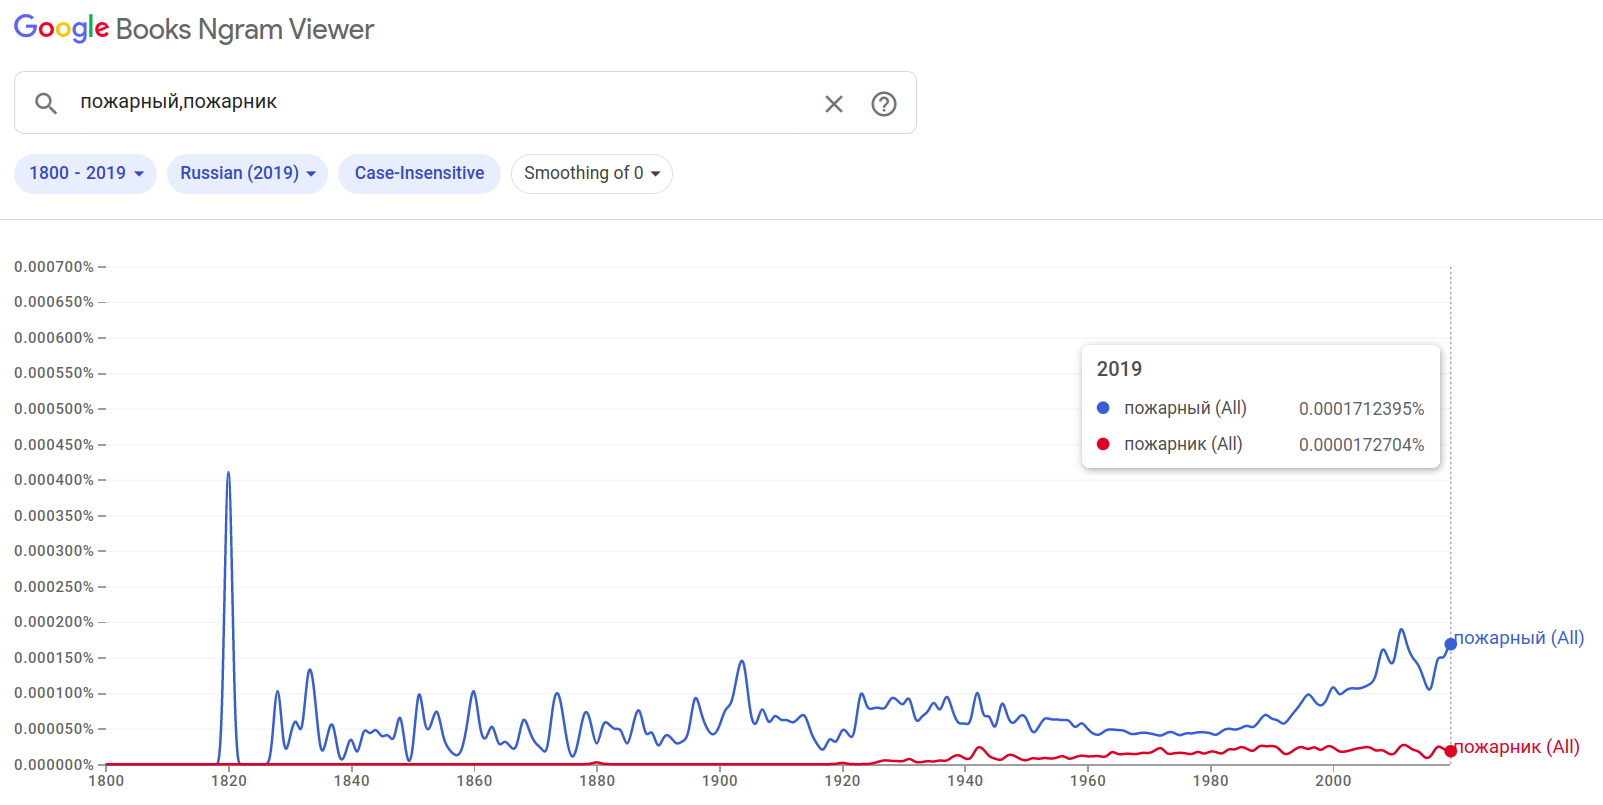

In [87]:
display.Image(b64decode(pojar))

In [88]:
print(f'Livejournal пожарный/пожарник: {860791/64779}')

Livejournal пожарный/пожарник: 13.2881180629525


In [89]:
poezj = 'iVBORw0KGgoAAAANSUhEUgAABlUAAAMjCAYAAAA805ZYAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAbfbSURBVHgB7N0LQFRl/v/xj8CAokAoqJhAIaUoamrerbBSu3hprUw3s7V7f6utbdva2t9m+9vaLtvWWm529ZfapmbumnbxkmF5NyUNFQpIRUUFpQFEYAD/z5kZFBBwEETJ9+v3mxVmnnPmnDMPxDyfeZ5vk6OGAAAAAAAAAAAAUCMvAQAAAAAAAAAA4KQIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAAz46TTIPHtU3q0u1PblUmVlHzfdSaCvXY6EhTXTZAG/FdGxi7muic8HN37147OvYgAg93WGsAAAAAAAAAABA41HvoUpZmPLxJyVVPHa8zbbkYmfIcvlAb40e4a1fugNFP+vrQ1udX1uhCgAAAAAAAAAAaFzqNVSxZqX89e/FHre3QhYrfPl6VYmeesx2zsxaAQAAAAAAAAAAjU+9hSpfry7Vm9MrBirWTBRrqa+Yjl6KubiJM0TJOnjUGb5sSz56rJ11/3wTrtw78bStRgYAAAAAAAAAAFAn9ZJiWCFJ5UClc8cmeur3tgr3xZR9McK7wjJhVlsClfqVteQFPfVxWvUNbP4KbBuhrj3iNOTqHgrz01nGoYR3HtG0DQ7Jq4funHKf+tjU8HbO01PPL1VWqfWNv2InPqMH+wXWvE1pot599DWtzzdfd7tTr0/qozNx6I1GYYKmPTFNCdb1atFHDz5/p2I9umBZWvrCU5pndXOvcF33P3/SKK9VevfNeUrICVKPG+/VnQPCBAAAAAAAAAD1xUv1oPKSXzeO9D4hUKnMWurLqqVihSkna4vTwJGvnPQkrfpkmp796zSt2usQTiZfiR9/pIQ8oT75xapvF3/X13mJWpfsYV88sF7rdri/Du+pge1MELdontbvzZcjL0PrP/pMiXRrAAAAAAAAAPWoztNDKs9QsQKV2hSev3xAveQ6qJZNYd36KKpFxXsdDrsykpOVnuOQ40CCZkyZIf8/3akeLYSa5KzXvE8GKvbXnZh9Um9siu0VK/8N601sla+kjclyxMae9PpmbNik9FLX11GX9lGI+XefrdyvNB+bfDz/VQQAAAAAAAAAJ1XnUMWqpVLGWsarNoEKGkKQOg6boHHRVTzkyNCqd/+hGQk5UrYJCxYPVY8bw4VqWPmf6e5Z38zWgn5P6aYoYpX6YuvcV7Et1mt9nsmtEjcp2RF7kiXAMpSQkO7eOEp9e4c4v4z91e26Lu+/SrCHqMfIG9SJzBYAAAAAAABAPapTqFI+ULE0RKBS8n//UemKDSqNX6+jO/bIK66Pmlxwvryu6C3v3/zKo30cPfB/OpqzQkft8VLhDjUJjFOToDgp8ArXvydh1ZCxzt36N/OgK0yK6eilywZ4mfuOOu+3WPfVdiZO8TNTnedlnad1XmU3n6cnOf+tV7YwDZzwa33/4zTnklZZWzYp/VfhCmcgukqdrhyiwyuWKt2EUfGzl2rgE9cpjGtVP/w6qm+3QK1fbQK+nO+1Kdmh2JpSlb0mgNnj+tIW3Vc9g933B8Zq1CRzEwAAAAAAAADUvzqFKmXhQRkrRDhdrKDBMfFJZ5hSXtn3VghR8v5/ZZv+nKoLH6wQ5Wj6MyZQia94v/m+7L4mrX8jr/CnzSDvBVXuY/7CEn38SUmF+7aZIGVbcom+XlXivAblwyZPQ5Wqzs+6z7qVnacVGlnhSr3y76iuF0gJiebrnCzZzT/MValG6zj9+opEvbAsQ46dn2n2ij56ZHCIUB9s6tinqwJXr1KO+b/vT7IEWPr6BGWUlm3XR4ECAAAAAAAAgNOvTqFK1sGjx74ObXXy9pVnttSkfBhhBQuFF1590m2s4MFq5/fTMlUOVqxApXTr4JPuw5rFUmLaesd+dUKw8uzfHc4ApTrWrJXMWpzjsees4vzKjr8sVCmbvWLNyLFm59SffOXnu7/086+2Q+SkxGtJfIISU3Ypy242sPkrqHWEoroN1NAr+yj8JLVY6rp9VbK+eU0v/DtROdYl94/SqId/p+siXcPw+TtXaenS9UpIM8+XnS+Ht78C20aoa684Dbmyh8L8VGtFDl9FXX+TBia8plUHHUpa9KFWXfKgBgbrFDiUsXGpPvtmvZJ2ZinHYVNgcFt1uKSvuR5xigpO14Jn/qrP9pqmsRP0yoMD5Szlvu8z/fWZBc5aIp1+/YoeucIEDGs/06fLE5S8N0v5Dinqxmf1+FBX2OPITtKqZfFal5iqfQdzlF9ik3+LELXt0FE9Bw1RXGxIpeDCoYR3HtG0DWZHwXF6/LlxirInKX7xUq38Lk377A7ZzHFG9RisG64fqHB3fXnlpCn+s0+1cusu7cvOMa9voNpG9dSga69XXLRnkYctuo+6Bq/SqmzXEmCpjlh1qipVKU3XpoQM19fWDJdL/I8/tneBJv/vZ87AJez6yZo8MuzE7a1jXfyVuSZJzmPNL/V3XvuIjl01aOgQ9Whd7kmTP9Rj/4g3MY/Z37V/0uQbqogcy70m1jV7xFyzE5cdy9LSF57SvDSrzUDTZkK5Nq6+sHT1JiXvOCi79SL6N1PI+Z0U23uwhg6MUqBX9c/pST8AAAAAAAAAUD/qFKpkZh0PGDyZpVK5qH11rIDm8gG+x763ZnCU5zP5AXnffoOs4MEKUqwZKlbgUMb6vsKMjsIdJwQqXtHTXUt9meDEOYMl831noFLW/uiB99XEmrHiZgVC5QMVa8mveyb6mGNt4pyxs/2Ho86ZKlawUlvlz886p/IzUpxhijmf4smvH5vNYoVG9cWRvFTxO1xf2y7ooIjKL6NVd2XWm/pwbYYZ+i2nMF9Z6UnO2/qvlihu4kMa162KwfO6bl+NnIR39UpZoOIXriH3POgOVBxK+/Qfem1RmhksL7dBab5yzHOtsm7fxGrc/fcpLrx2NVEcjiIz2B2rm27soe/fSlBOXqL++3GCetzVQ/612VFhuuLfmaIPt+SU37tyDqQpYYm5rVypIXfepJMf3UGtf2ea3t2QdfwurzB1inENpGdtmKHXZ65SRmGFs1B+TobSEqybCTD6TdADt/dRSDU/vvZt8/TCu0uVll9uDwfTlbhshhK3pOq+xyYoNuszvf7GAiVVOJ0cpSfG68Ntm5R0++O6r58Hg/u2Dupj+sCqFa4lwNanOMy5VHEV0tdp/QHXl/6xgxRbi4ufk/ChpkyPV3qFa5LvvPaJ1m3VV+ox5iHdOTjcdf2juqprYLxWmUPK2Pa9skyoUvlMsrZ87wpULNmJStxhgo6oyk+crER3CRj/mJ7qUHa9TV9Y+tYUzUvMqdg+zwQtyeudt1XfxOnOB8Ypttofj5r7AQAAAAAAAID6U6f1ukJDmhz7uvyslfpk1RgpvySW71fvV6gvYs3asJb8soKWY9uYAKJ8yGIFJOV5dfnKucxX2UwUK1yxQhav8MnH2pSmT3aGK5ZMc27lAyErUHnq9zZnoGKxAiWrnszlA2tfU8ZZI6bc+TnPpVwgVFYvpvzMlcoh0ykpzFHa6g/1j2nxyrIGhG0mmLi2UjhQmqX4aS9qRlkg4uWvsNg+ihs6REOu6KNObd2t801I8MYLejeh0sBwXbevRv72efrHu+vdxx2igXc9pJtiXPtymMfeLQtUrOfrNlBDRo7SdVeb52vtfr6Difpw6odKzFftlLpiIf9ev9YN7pH8nI3zNG+7oxb7yDDn+o/jgYotUOE9zDFa1+SyHooKtjmvx9K3Zmr9zzXvyr72fc1wD6TbAsMUFh6mkPNj1dV0FUfaPL3+3vFAxb9drAZefZ1G3XCdhvTrpBDnTB0zcL/2Xb0+N0lVnkH+Jv3bGajYFBLjft3MMR6bVXRglWa8966mveUKVGytOqnP4CHmWg9Uj0h3AlCao4Q5HzpDiZOzqVOfnu7QwloCLLXK40pbn+B67U1vje0d63Gglb9lhl54qyxQsSkwqocGDr1O1w2NU5+YMPl7uY939j807Rt3QGHrqK4d3c+w1wQjJ5yHab85rdz3WUpMSD/huR0/fq9Uh/uYu3V0BTYmcFw65R/HA5UWYYrtF2d+DocoboC5zsFls67iNe2VeUorVJVq6gcAAAAAAAAA6ledZqqUV37WSnWsMKKm7aua5VE+cLBmcFS39JUVRFgBxbEaJCs2qKxwvTMgcbOCk+qK0TtnplizVdxhijWDxRm+VGLNUKmKFaxY51GbZc6s4yxT/vzKZqiUP6cylb+vmQk2XrpX8TU1Ce6k68bfqVGRFWcFZC1/1wz4upIHW+s+Gnf/BA1sV75NvtKXvaspH1szRrK0fta/1bXDfeoTWD/bV8WqZfLaW0uVYQ1Qe4Woz+2PaEK5GS6pGze5B9wD1eOO/9F9vcvt7OYcJX00Ra8v36egtjbl50m1m2JSJlADb7lOK3+0BrqztGr2Ag36002K8mDiS9byGSaEcV+TtgM1YdI49Sm/3JQjSwkfva53V2Qo6yT7ykhLdy57NmSCee16VFrGK2qU7r3HXws+NT8/A+/UhMHhFU71phusYGma4tNNsLLyc60a1klxlZcxM8Fbjpe5juMf152Xldv/yAS9+/w0rT9oBVzrZZXj8Y8dpz/cF6ewY43ylTjrWb1mhRP5iVq5PsuEOh7MnIjqqx6t47X0gLUE2HoTRHSquARYaZo2bXFfmcAe6hvr4WwjcwwfzlzlDuLCNHDiAxrXq+I1y9+5VG9OmaekPHPs/52nhB73qUcLmzp27yj/DQnKd6Tq+235iutX7krmbFLiTusLm/zN3fn55nomblLGjeE6vvCYQ8mJya6AyM8KaVzPmrFshhakuPqCf8xNevCeIYoq/yJZfWGO6QvfmFBy71LNWNxXk0eeuPxYjf0AAAAAAAAAQL2q00yVywYcn5lhBSKVC9dXZs3uqO5Wfvmw8l+XD1WqK0Bfpnzgcix4cAckxwReoZqUD1yO5qxw/vtNuZDEWpqsbIZKVTxZBq3a5zbnZx23NTvHqrFStuRXGWs2jrX0lzVbp/7YFBIepYiQZhXvdiRp6bI010Cwfyfd9OCdlQIR5wMKv/o+PTTcvVRSXoI+W55eP9tXZV+8pr2+wLUUlRnsjx37gCb0Lj9Q71BxgXtGkVeQIsIrpzOB6nTjQ5r811f07MNWmKFT13qIfn21+7jNcf17ScbJt7GuyfJy12TShIqBisUWoh6//p3GdfMk7Qkx4cCDuqnKgXSbwnpcp/v+NFn3VQpUnIJjNe42E4JY3dUKC7ZXPW0nsM/tmnBZpf2bMOO6fuVqlbTooXETywcqzhNU7NA4Rbl/HNJ3pMuj+TxeUerZzf2aZruWAKsgbZ0S3Et/BXbvo44eJghZ6z6VayKUTVHX36sJvU68Zv6RQ3TvWPdsrbxExW90zSDxj+mqKPfMnrTtaRXOIz/RPQPFhCXXXdvB3R++P3aMTqXpSkp2B2kXdXUtV2b1hRXufQX20YTKgYqzsdUX7tSQdq5vM1avVFqVv2Jr6gcAAAAAAAAA6lOdZqrEVJp5Ys3QONVQoXwgU7asWOUZGdYyWDWxHi9b9qssjDlasKNCmyZNL6hxH02sGitl31TatvyxVccKXWqjfGhkhSjWrcLxVKqxUns2hfcaqA6V84VSh+z7kpX8Y5aytnymacnfa8j9vzu2jJbSE5WY7foypO8oDWxdw/6vvkE9lr+m9Xlm4NcMMmfcEK6wum5fuVn2er075UP38kv+6vSrh3TfFWGVBpFtirgoQrYNSXKYgezP3pgmjRyqQbFRCiwrTG/CmJBavkbVCb/214rb+IKW7nMoffFsxfd+RHE1BTUeX5NADRw+UEsTlzoLrlcrKk7XnSR8yd+boPilK7UpZZcOZpcVqg9Sq4iO6nmJv1xRmkMHD1jTxCrvK0Q9r6h6ea2Q89uaq+1a1i2wR5x6tKiqUZhCzMZp5nV15NmdbT0Z9I/q00Mhy5cqqzRH3yekyhHT6dh2aesT3TN4zLH17uBhiJCv5M3uUMerrSJa25W03V51U58QtTK/wvLNz0dqsnnuK3rI1qKrukbZlLjdoXzzc5JaGusuMp+vxC2uGSi2i3qqb2+HEj9JUpIjXd9vydJ1ZTNzTMjiet1t6tCtq+t67kxQsrsv+F9g+uxOs101Rx8UZn5495qOb0/W9/vM9WlXqUHUyfsBAAAAAAAAgPpRp1DFmrFhLelVVsDdClUuH1D7YMUKVMov/RVzsSu4sAKFstkblpMte3V0595jX5fNaqm81JcVsjRx11I5KXcAE9KqiTxlFayvjfLnV/l+K0gpW8Ls1AWpw5XjNC666kfzkxfotWmfKc2q4/Heh+rw9J3OAfL8PenuwWt/RXUMr3nw2i/KOei8fosZXj6wSyZjUFAdt68468EEJK8lKqNcH2kWHFTlPgMH3KRRG/+hecn5cuxL0IK3zM3L3zkbJ6pjJ/Xs0VexUYH184l+W5Suu3mgEqauUlZhkhZ8tEo9Jw2UM7+q4kfAeU3dtUBOek3CYxXVwoQqNdQiCYnqoOoX1HIobcnreuM/ScoprXh/fk6W8hOzrIzn+L2OKuaRWAFE26r3bvPzdx6/tVW789tVcy7+8rcde1oVy0PhfdWn9VJ9ZgKEnC0JSr3ZvQSYI0nrypb+at1DfS/y8FUs3addB9znZ8K2+LdeqXk5vLJDzsqQXSbgMa9oz9hwfbg9zRlsJJsf107WKlyFydqU7IqKrLAkMLhIppmSTLP0LYnKuTrO2RdytiW5wjGvcMW6q83nZ+w7trxb/pZ5em2LBwdUaldWlnm+SjO+au4HAAAAAAAAAOpTnZb/slSuL2IVdM+sRdH6qorAlw9lyi/5Vb7+SFXKF6evEEaUD1HcS3pVp9SqqVL23O7tys8+sQKkms7Pk9oy5VWuEWMt8dX06HbnMl91D1ROzr/jKN050j0TICdBSza4RvGLC4vKWsg/4GSD16ZN2ei5GZzPd9R9+wpKs5RxoMKiS0qY+5ES8qrYlS1cQx5+Ro/cONBV9N25fb6ydiZq/ZJ5mvbCY3rypQ+VcKAWxeVrOvLYm3RTL/dA+Zb/6qON1jJPPrJV8ZNVu2vS3FmjoyY2W/X7sIqyv/FxWaDir7Be12ncfY/o8Scf1+MP36cJIweqU6uTHYNNNg9yCx+feivN5GLCh5693HOVsjcpwV0H3pGyXpvcszvCLul7bGmxkzMBW6Fqr9ChI+5AKrBbT4U7C9ln6PtEVxziSN4k56pex8KSEPOvq+aJIy1B3+e4nvv77e4l7cK7qof7d8nxvlAb+cqv4jxsNg/DJQAAAAAAAAB1VufRUGu2yo0jvfXxJyXO760ZJ8++5NDlA72dhdtrYoUTbzlDmOP3Vd7GCh3KlsiyQhPv229QVcXqrTok1c1ksWarHHWHJVbReu/Wt1cMWtxKUyZWqMHSxGonV50UK1gpO06rxsplA7xOqK1izbipTZF6y8mWNDt2bOYaOCY+Kdv051TV+ddFSLdYhc9NUlqpQ/t27DL3xMrHz9f9qBnIzT3Zwk0OZ4FuJzPAa+Ujdd2+yuPsPUE3BS/VNKt+Sc56/fvjvup4exXLU3kFqtPQCeY2TjnpqUpKTjS3VH2fnKYcMyidkxKvaf/I131/urPqZatqxV89brxBsVtnKDE/R+s/nqeBHfvIVkXXr901OWyuiU6ROY7lCXJXBFHsr5/SfVdUrLcRFdNDAy+L0CuPf6ik2nXZBhF+aQ+FfZ6hjNIcbdqYpHEdOyh14/euc/IKU48+4bXYm79s1vJvVggXPkqT/3TdicvLnUzrWPU8f57STT6yb3uicq4dqF0JSXK+ROXCkrBuXRW2KF0ZjlRt2pavgT2SlZTm6tthsT2OzSg53hds6nPfK7qzB8EIAAAAAAAA0BjUeaaKxQpCrGCljBU+WCHLs393OEOG8vVSrCDFus1fWKKHn3AcWzrMYu2j8tJh1hJY5WerFA2+vUKAUhY2lK9FYoUO5WuQeIU/XSFEKdl4oStkcQcoR+3xKk0cfCx4cW0zucI2VkhUxjo3KwxyLVvmOn7rfP76d48XOKpwrOVnpDjrqpjzO1YTxl243jpv62vrXMvPyKl3Ja4lnfzPb+seAM5XWnJ6zdsUJuv7He5QpHWE2trqvn1lgd0m6JE7BqrH8AnH6pbkrP1Q87bXNOPEpsDwTupz9U2aMOlxvfT8nzSuh7u4TPZ6ffpNlupF8ECNuz7KFVocXKXZZlC9qrzE//zwCtekxrkye5KdtUhOSeleZewru54Ddf1l1RQwP5DhXo7sLNSuj/q4f+xzEhOUlJ+s9Zvda6Gdbx6rTabirKPivgIHUk/xuoapa6wrinHsSFJSjgnptruOp3xYovN7Ktb5jUNpW5KVn/a9OXY5g6DY7sejHP+wsp8P0y5tnwAAAAAAAAA0DvUSqlismRvlgxWLFZhYS3tZYcPDTxTp1ruLnEGKdSub2VLG2ra6mS2+X72v8sGKFTwUXni1CprEOMOG8iGD1c5qX4EJR7xa/6ZCSGLNSrHClZLVTVS61QQqOfEV2jexgphyrGOzliYrf26u83I4z6vy+dRG5eDIOj/rvKzzs86zfGBkBSvl29aHrIRNSncPrrcKa+UagA/vodhg9+PrFij+YPXbZyz/VAnu8e6w2K6uWQB13b48r1jdfNdAhVi91S9Ko25xf12apVX/nqe0Y0si5SsjYalm/OMpTZ6VdGJo4R+uuNFDjy0bdXBf/Q1mh1z5a10X7hq4z1jxmdZnV9EoPLbCNVl1oLq95Wj9p/E1F6mvBVs1z7Hq8/Wqp1jpNAhTn17u5ORgotZ/vu5YH4nq06eWM0381bW7u6h9YaKWLqsh0DoQr2nPvaZ536RVqkVjXr5usa4gxAoBl693FZ/3CqkQljiXLuvijs6S12lpQrJrdk1wR/UsHwRF9lDHsr6w+tOq+4trL0r66AW9MP0zJeyrnyXrAAAAAAAAAJy6egtVrKWwrODhT7/3qRA+lMk8WN120r0TfWpcKswKEaxlr04WJlizPk4IVMr2YUISr+jpVS77VaGdCV+8e/1U5WNP/d6mywdUf8msc6nq3E+mLAiy6ql40q4+l//K2T5P0z5Jcw0yl69lYeukIVe7Z1/kJ2nelBlaf0Idknylr5im18u2bxGr664Mr5/tK7BV6Knl65hYg+AzFrm3l10Jn8/TquQsZax6V+9+k3HC4HlWcpL2uQfL/VucpGhJbZhrN2RsnMKcYU/+iXVhnKdhrsmV5a7J1CquSWmOEj+aohkJp7z2lzmWCEWcXzYzY50+XZ91wnMk/HuKPkysw3M0gJBeZXVTTHi2ZL1rqS2vKNNHa1+WPbDvEPVxhxgZi6do2pI0VT57x771enfqPCXsNMHLrH/o3VU5FRtcUBaK5SthmTuQCo6tGJYY4d07OgvUK8/sZ7Xr2gfG9qhYA6Z8X8hL0IypVdX5MYHKp2/qzWVpSlu7QNPMsaWRqwAAAAAAAABnVD1XmHbVH7knpIm2Jx+tscaIFUB4UneljBUkWMXbrVkpJe//99jyX1bQYN2qq7VSnlVbxQpMjqY/41zy66i1/Je5WUGK8/HQ251tamIFQJcPKNX2H1znZxWmL1uyzHrMWgZsW7Jr1kpoSMWApYmqD1ysc3DOWIlsp9IVG5znZy0BVnZ+lZc085xdyZ+bgKGK2iH5B9KUnJblDh5sCrv61xrS9vjjIVfeqZu2P+scfHfsW6V3n/5eS2K7qkPbINkcJrhITlTiXvfQtFeI+vz6dvUJrL/tq+evHmNuVo/t7zqL1Wd89W991udxjQoPM8HGEK3/x1JlOExwMGuynlzdQz1jIhRicygjLUEJiRmuwXRbuAYOjFJ9skVfp5sGJui1GpYVC7l6gkYlvqh5ye5r8hfXNelkronyMpS6LVFpB80r4heiEO8sZZ1S7uGvPlcP1Gfb4pVlBSjTJ+upDX3UIypE/gVZSv5uvZKsAfxWIQrMzjphRsZZo7V57S4wQULa8btsF/VV31aqPf9Y3TQ+TslTXdck8eMX9NQ3nRQbE64QP4fs+1JN30hX/rHC9ON028BKndGrg7rGBCp+dY4cDtdPTWDnHq4C9uXYonuqU4tVWp/nkKuZv7p263DCIYWZvnCT6QsfWn0hPV7T/rJJ4THuvlCYpfTtCa7XyblT07fHj1IUpVcAAAAAAACAM6reQxWLNWsldEAT56yOeyfqWN2RLBNAhJigoXKB99qw6o+Ur0FyKqxZK5WX96oNK0SJ6Wi+qCIQskKWqqzo85w8UR/nV5EJExLXK6PGNv4Kv/pOPXRjVMWlokzQEXffH2Sb9aY+XJshhxmMTt+yytwqbx6uuAkPHa9XUl/b1ySwj266YZ2SZyUq35GupTOXqs8T1yks6ib97h6HpkyPV7oJJHJMkBJvbhWYAeo+t9+n69qpnvkr9oab1GfzNK3PqaaJlxkcn/Q76a0pmpdoGpnwJz3BXJMKuwnXkIk3yfafV/TZKU4mscXcpPtuzNKUjxNNaOJQVuIqLU0s1yAwVuPu76uk50wwpbNViHr0itK8Y6mKTR1791QtekkF/rHj9Pgkm954d6nS8q1QMUnrza0iEy72G6d7x7uXmKv0WMduneS/2j1rxrzenbp1OHF5NVtHE+T5a/2G/LInVteLqkhDTF+Im/QH6f3XNW+jCTcd1fx8BHbSdXfcqVEd63FmFQAAAAAAAIBTclpClcrKQpS6hClnA2vWzTerS3TPRJ9qz6X8zJyYi8/i8/WyydYiSOEdeqjv1UMVF13NULUJIAZOnKyuA+K15JsEJabsUpbdDBbb/BXUOkJRsX009OqBCm+h07N9DUIuG6fr1k7WvBSHHDs/04zlPfT41WHOWQZ/+nNfxS9bonVbUpWelWOiJZsCQ8IVEdNTg4fFKbbVafrIf4seunlkrBKtsKe6Nn4mNHnwOcVu+EyfmWuSlJ6lHIcZOw8OV4dufRVnrkenoHR9ONvV3GauVe2P1maCsgf1zEWr9NnilUpITnfOevEPClFUtzhdPzxOUc3WK0lnN+cSYP9Ncy175ddRfXucaqTiEhh7kx7/375av3yJVm1J064DWSaUszmvS9voWPWNG6qB5mehuutt69hVHf3Xy7k6m78JTzpW1dKEL907yrYhwTkLzLmNXzU79DPByj2TFZsYr6UrNykxdZ/seflymNc8pG2UOvYYpCFX9FAYeQoAAAAAAABwVmhy1BBO6uEnio7VhblxpLcuG+B1QrDy5vTiY6GKtbzZq8/7CjglOfF65fEPlVRqLRn2uJ69uX6XKgMAAAAAAAAA1F6DzFT5JbDqv3z8iatWivWvVU/FWgYsxB2sWDNYtiUfrdAeqCxn53qt/GaV1u8K14RHb1JUlTMYHEqPX+kMVKwlpqI6hgsAAAAAAAAAcOYRqnhotLt+SlmwYgUoZQXpK+vcscmx9sBxDu1a/pEWrLUKriTpjXdC9NDEOIX7V2yT8c0MTfvcXWWl7UANjqU6OQAAAAAAAACcDVj+q5as5b3mf1J8bCmwyqylwQhUUK3s9Zr2wrtKyHZ/7x+mTt06KjzYJCv5WUpPTlTSPnc1FluY4h78g8ZRoBwAAAAAAAAAzgqEKqfIWv5r+w9HlZl1VKEhTZzLgMV0bFJtAXugjGPfKs1440Ot3+eovlGLKA2ZeL9uiq1bYXYAAAAAAAAAQP0hVAHOhNIcpa36Sl9t/F5p6fuUle+QrWmggkIj1LF7Xw0e3KfSsmAAAAAAAAAAgDONUAUAAAAAAAAAAMADXgIAAAAAAAAAAMBJEaoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAP+Og0sNvtOnz4sAoKClRcXCwAAAAAQOPk4+Ojpk2bqnnz5goKChIAAABwLmty1FA9scKUgwcPys/PTwEBAWrWrJnzD/AmTZronGNd1XPwtAEAAIAK+Lu4UbPeLloflDty5Ihyc3NVWFioVq1aEa4AAADgnFVvocqBAwecM1NCQkLk7+8vAAAAAMAvS35+vrKyspwzV1q3bi0AAADgXFMvoYoVqDgcDrVr1+7cnJUCAAAAAOcI6y3k3r17ZbPZCFYAAABwzqlzoXpryS9rhgqBCgAAAAD88lnv+6z3f9b7QOv9IAAAAHAuqXOoYtVQsZb8IlABAAAAgHOD9f7Peh9ovR8EAAAAziV1ClWsTyVZRempoQIAAAAA5xbrfaD1fpDZKgAAADiX1ClUOXz4sAICAgQAAAAAOPdY7wet94UAAADAuaJOoYq1hm6zZs10zjoqAAAAAKeKv6cbPev9oPW+EAAAADhX1ClUKS4ulo+Pj85ZlJEBAAAATh1/Tzd61vtB630hAAAAcK6oc6F6CtQDAAAAwLmJ94MAAAA419Q5VAEAAAAAAAAAADgXEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqFIPoqKiBAAAAAAAAAAAftkIVQAAAAAAAAAAADzgIwAAAABA41Gcq/3pe7X7QKZyDher2Lyt82keoDat2yk8PFQBvMsDAAAATpvG8+e2eeNwMCtXuYVyvmFo1TJAzZhnAwAAAOAckbvzWy2PX6eNSXuVW1xNI58And+puwbFDVK/yAABAAAAqF9neahSrNzUtfp0+bfakpKpI6XlHvIL1gUx3TV4yGB1a81HsfALVbJVL19/k+b2fk/r/re/865Nf71Ct345TB8se1I9vQUAAIBfusO79NX8+fpsS6aKT9a2OFd7EldqTuJaxXcborGjB+mC5gIAAABQT87eNKI4Wxvnv6/ZG6p541CYrR3fxWv6lo2KGTlBEwe2k03AL4x3tAb0b613vpyhualddI1PvGZ8eUCBvQeoC4EKAADAL55j71pNf2+httvdd/gE6ILY7urWuaM6XxCqwIAANVOBcnNztS89Wdu+36qNibuUW1ys/Vs+1z93punGO36tQe34IBoAAABQH5ocNXSKfvjhB1188cWqd6XZWvv+m5qzLdf1vU+wLuph3jh0aKfAZuaNhT1TO5K+08ZtmTribNBUFwy7U//v6jMTrERFRSktLU3AaZG9RlN/+7BeX5mpQvNt6KV36YWpTyouVAAAAKjBkdSVWlvYXYM7124ZrNxtK/Wt36Ua3KGpziTH3pV6+63P9eNh6zsftew8WDeOGKTOITUHJI7sZMV/slBLErNdH1BrHqWR99yuwacpWDlt7wsBAACAs9BZGarsXjZV/1y81/kGoFn7fho74Vp1Cz7xDcCRn+I1feZS/WhlL17BGnTPw7qxQ8N/AotQBQ0hZ1+KDhS3VnT7QAEAAKBmR374XFNnrNSeklD1vfVOjY31LFjJTfyPpn7wrfZ7t1PchDs16uIzFKzkbtXMf/5bm6wZKl5NddGQ2zXx6gg1O9agWAdTt2p7eraOqKlahndUtw7B5T5kVqAdyz7Qe0vTlGstoxzcXRMfHKNup6HMCqEKAAAAziVnX6n33G/12deuQEUh/TTxnhFVBiqWZhfG6e67hugCP7lmt3y+Vgd1hiQ8p6EXRzkDlipvF/fV0ysrbZO5SXP/er9uGtxXMbEx6jv4Jt3/0idKya/qCQqVHj9VT0wYqr6XxCim1xW66eGXtXhnYRVNF+vh2KqPI2bUVKUca5ijuXfHKCpmvGbuq/7U1vxP3+rPy3luQ/Vcgrtx9lbNff5+jRh8iTmnS9R3+B16+oNN5plqUBKvJ3pF1fgcI17ZWmmbdK1572ndMfwKXWKu3SV9h2r8o1MVX9X18PjaFSplyVQ9fKtpZ/YZE2Md/3g98dYaZZa4m+ycqfHWsfa6Q3N3l9t05RPqa17/oS+VO86SFE0dE+N87e9fmFmucY42zX5O949xH09sXw0d87CmfpmuCkfk7lNX/HWN89vAttGuQKVwq14eFXO8T1l1V66p+fpF9XpC8SV1eI0AAAAameKiAhVbf/8UZ2rdB+9qdmLuSbc5FqhYb0ZKHDpS5NCZkauN/53vClRMYHLRtXfq7nKBiiNrqz7+59/012lz9fGnS/XZpws1a9rf9fQ/F2pLVtniyU11wdW3a9K1Ua7tsjdr9n836+RXAQAAAEBNzrqFdXMTN+tH55peAeo5YogualZze1u7ON048Du9vDxTxembtenAIA1prTMmsOtI3TYovMJ9mRtmau53lRru+0QPj3tcn+zxU5errtFtwwKVs22xFrzxsNas/FFvzHxU/Y9NSCjU1vfu1B3Pr1ZhVJyuGTtMgYcStPizqbp/TYqe//gNjWlfbt+Fha7B+dAuiuvZXlbmZL2Z3LZikw6o9trH3a1HW7uH++0bNXdGvNIvHqlJwy6S83N7PoHqGWadqAlHbrtfc3ea74eN0m1tpfSVCzTzf27VpvT3NO+J/q5jqU7oAI25qYfKr2pVuCdeMz+pHKikaOZ9t+rpL3MU2iNOo8YPM9dzk+I/e1l3rFyjJ6e/q7s6+9X62qV8cL9ufSZeOSE9NezmuxTul6Ot8QtMAHGH6VfvaeGfzPFH3qa/PbRYI0y7l5//RINfH6nqVuFKmTVZb39bqNCRT+kvI8paZWrxk7fq4dnpCjTHfs2toxRoAqKEzxbo5fsTlP76Qj0/tOaZKCkf/E3vfF94/KfXu7UG3Paomh5yfVuQvEBTP0tR+FV3aUy3INedftHq4F0PrxEAAEAjERD7K026Ve6QxBWsqIYZKxUCFZ/azW6pb46f4vXZlgLn1wHdzPuLuHLLHOdu1exp7hkslRzZvVbTpx3RxN+WzUjxUZu4MboxfapmbcnVkcSlWvJTF914IfVVAAAAgFN1lv01Xayf0tyzVJp3VC8Pp9q379FFbeLjtb/0gH7aad58tD5zax/79bxFjz7Wv8J9m55fbEKV8u96cvTJX581gUqghj03T2/cVBbCPKrb3rhTt740VU9MGaAlf3IPcP/wjp5+yYQCvZ/UB+/dpS7uUe8HrntCI+6Zq5enxGvUi3HHB8MLC1RYYo6ly2169Y0xcg7RlyzWw73u12LVnjU4P+kq9zc739FXH8TrQPS1euDBYeUG4HO0+NHHNTettca8Ps8EA+4QofA2vXP3TXru/Zc18+Z5uqtDDU8U2l+3/W5SxQLs8ZmaWylUSZ81Wc99manosW/og+eGHQs1clY+p1vvfkcv//Ed9Z/v3o+n165kk+b+X7wyg4fp1QVvaGTZTv/fYD1xzR2a+9kX2vTH/upv9hk+/m969MsRenrJy3p2SZxerSoE2T1Xz01ZrZy2I/XqU+WCl51faM5Ku1qPfEbzXh1z/P7xXTT+mqe1YNYCPTr0tmqDGud+p66uOKPFtO5/6ySV9bqc/yTqnc/SFW7CsEm3lt+TeY2er+NrBAAA0Ih4GqycTYGKtWzXlq+/k/PzMn5RGjqyu44fSbF+XPq5O1Dx0fl9R+imq2LVRge0eelCfbzBvJeyb9aCpZcqZnSUO4gJUK+RcVqXvFA/FmZr49dbdd2F3dVMAAAAAE7FWbb81xHl5Lo+kaXgYLXxNPIJaa02zjMpNts3ggnt+xZorgkL/C65W0/eVH5Wi5+63PM7jTGD2un/maN49zJgm+bO1aaScI26/7ZjoYAlMO4ujYnxU+bKr8zj5XZTWKgi61//pg036yDThAWLzTn1u8uEAuUG8v2iddv4OAUWblX8ynTVWUmKPplvQoXAON31yLAK4UPgoEf16IhQFW6fqwXu5cg8vnbePfXogu3a/lW5QMV5/H7y83H/W3afd7hu+99HFReQrk/+9rLiT1g3K1OfPGvuzw3VyD8+VXF/kbfpva/XaUW5QKUwv1CFzaPVwdxRuCNdKSXVnbwJRf5u9lvYU8OuCletNdRrBAAAcBZxBiu3Xep6b1HFUmBnV6BiHEnWlh/ds1RiB6lvULnHSvdqS1K280ufi6/VvTddqguCm6pZcIT6jZmgUe76koeStmpPabntgi5VnPucjvy4VdsKBQAAAOAUnWUzVWzyKZulUCoVe7qZGYR2uN802LwawVR28yYn0QQm4T176oShce8uGtAjVO/8N1WJO6RhndO1dbu1aFdrpce/rpc3lG9cqBQzIK/sdKUfkvofG6XPkfXhNT//QM9ClcLVenpAlJ52f+sXHK7onsN020MPaExXD4uiJ2/VVpPk+B3eqhmvvFzxsczdJpgoVHq6VYTkFMKA8g5vU2KqeZ7OA46f7zF+6tm/p/zmxWvb1kzp0oJaXTs/f9fVSln4suZuypG1iNqBTV9p8aFojXnxbvUsP4PGhCPP/O4rjXhmpp6+364e3tuUYzps4YqX9XBaptZ8manQ697QUyOqmHNSmK7496fqnU++0sYfMlVYvqO3r/4dbk78y3rusxx1uftJTSh5QotXFKhWGuo1AgAAOMsEdLaCFWnqzIozVq7XsrMrULHs3aWfnH8SNtVFsR3KFZ43vJrpon5xauawKTC6iyoeaYAuiAyWUs3fwflHlGO9Pzr2ETofs68oNdu4WUcKd2mH+ZOvF7OTAQAAgFNyliUQTRUYZC3dZQaLD+7VbvNmoo0nqYB547HfGaoEqE27M/wmyAOF+XYzXO+nwJZVLfJk7g+0rkGOcqxkpKRQOXnmQhSbgfj3piq+qh36mbbli9sfOKAcEzS1DvUwEPEJV9wdY9SruevbggMbtfg/7+iJDSYomDtLd1188l0UmoN1hgoJczU1oeo2gfn18JE4c+1yrZkcQYEKquo5Aq0ZJYWyWxfPtKv1tTN2r5mpd2Yfn34S2OMaDeh44rUMOj/ceQzpaz5R2fyOwm3x+mSbc8fqEtleJ26VrrkP36QnvixUlxG36cl7eyk6xOrkKZrz6NP6RNUo3KTXn5+r9Mgx+mCSCY6mqNYa7DUCAAA4C50QrMz8uzaqWMXW+4izJVAxjpi/5Z3zaLxaq/35ld+uharblUPUraoNSzP1Y6prFovatlPlTW3nt1Mbr83aUZqr/QfM+60OZ27JZAAAAKAxO+umdVx4UQf5bNiq4sJkrduUq179T/bGpkDb1m11rTncPErdIs/+mSp+/kEK9DFhiT2nikfN/c40pbUCW5h/vE1I4GcG3f3j9Or6NzTS/+T7z/whVQeK/RQXHS2PeIdr8G8mOYuWl5nQ834Nf3yxZn64Rnc93f+ku/BzLzUW/eBCLXyki04bc+0CrBkjZvDfukqVQ4uc7BxnYBXU3ByNt2p97Sxxz32ntOfMFyU5Sl8/U3984GU9fJ+f2i96Uj3LQr78NXr92ZlK9+2pRxfN06QDT6jvHXMVdPdCLZmUo+dG3ap33n1a7wwzj3Uut/M172jql5kKv+UDzfvfckXhS/z0lfVNVUt/mfu2vvecZjproTyq/uY8Nqn2Guw1AgAAOEtVDFaKXTPjz6JAxZJ/xD0b2StAgZ4ekgmJ1s55X5/sNGfkFaxBQ/upVeU2AQFqZs1cKbWe44isD7QBAAAAqL2zrKaK1KxzL/VyTkEo1o+L52rlvpoXAcvd8ok+TnCtidyyVz91brAiInXQpae6+Erp363RCRUsSrZqdUKO9Y5Psc4p+a3VJdpEB0XbtHGTJ7MIMvXVio0q9OuiXj09nKlShdDevXSRCSUOZGbKo7kL0V0Ua659SsImndaqHIHWdfFT4dbVSsiu/GChNq3fqkKf1uoQYy1hVYtrl79Vi2fP1Nz4ckfvHajw/nfptsv8rOkrWrOz3PNMeVozU/0UPfbJE2fy+PfXA4+NVHjRJhO8vFOhRkrmznRn4NWhe5dKS7MVqrCaWioFO2fob29uUuBVj+rRoaf+mjbYawQAAIBT5vESyGUOJ2vBa69rznfZziCm2+g7dePFjWBJZAAAAKCROutCFfl11PXXu9cHPpymj6e9qwWJ2XJUbleaqx3x/9arH2zWIWvKfkAXXRcXoUYh9BrdcHWoCje8refmlR/eLtTWd/+huWbwPvy6WxTnnFnhp56jRynaWjbqpZe1pkKQkKM1rzysh9/bpLI5L4Vr3tY7KwsVOGiMRkXqlOUkJOpHawmxtu09q8vS/hqNHBSowrWvO8+pfIRRmDpXTzzwnBbvVj2I1sjRvRSYs1ivvxRvIqRyx/zty3r5s0z5XTxSY/pY99Tm2u3W5y89rSf+PFWLy7crTFFiijkb71CFBrvvSnhdT7+fosL2o/TkQz2rvD6BQ5/SpCvM9VjzuibPSjl+f8tA5/JkW+PLH7s5likva4F1fap4F50Zv1irNUAPPDFSVS0Y57EGe40AAADOTrnb/uOepWK+8fKRj/VuqIri9WdSYDP3DBLzfifnpIeUq43z5yp+r3VCJlC56V5N7BtcTdNcHXHXofRv1kwAAAAATs1Z+RGmgB6jdceBXL21bJeOHN6l+Pf/rnVtoxRzYTu1Mn//H7Fn6qeUVO2xlxuBtiYTrPtWrfpfqgua6ywXqJFP/EWrtz6suU+O0IgvR6l/lJ9ytsfri3gzWN/5Lj3/u+NLQ/ld+qiev3+T7njjHd1x/SYNG9ZT4d45StnwleK3F6rLgxNM2xxtmve6Xp/6jlKK/dSluQkSXpt6/CmLf1SqGUUvzFyjma8F6pqxtx0v9F6Srq/+b6pyKtRUMYP+wXF65raeHp5TqMY8bc7ptsf1iXVOn12juBgzgL9vm+IXr9aB0JEaUNbbVj6tvnfMVOv7T20ZqvDxk/Xk2lv1xOz7NTx5mK7pHS6/zAQtNs+T7tdTj/7vA+riXZtrJ+cSYXff1VPxr8zVw6N2a9SI/gpvatePyxbok21+Ch87QddY16twq9756zvaWhKqYY88qrjAGq7HYw9o7prntHrKc5oZ955uMyGX3xUTdFvnxZr62cMaPvy/6t/RT1lb1mh1htnC2pe77om8y+/LhEP3/tG5fd3U4jUCAAD4hakQqFhLft3mLlRfqXj9mV4GrFnr1iYeSVNu6QHt3mMONriGP9Byt2pdomu5sIBev9LY3sHVNnXs2Xu8DmVrlv4CAAAATtVZOoTaVBcMu1O/bblQ0xeaNzlHTJCyL02bzK0yn5Auum5EO22fudQMDG/Vyu8zdc891+qisz1YaTtMz8/9QF2mvK65Xy7QzHgTtbSPVtyDr+ruO0eqS4XBejOo/sgHmtfRhCYfLNaaj2ZqsU+gwrv0112vPqAHros2LdK1ae5MxTuXqCrU1k+mamtVz7tvtQlV7Aq8qlyoYhVyf+vlY4Xc/YLD1SXuLr360KMaWZuB/PYj9erc9ur1L+ucvtDMNYXyC41Wz5uf0Sv/7zb1rDzNwucU12rzjtaY1xcp/N2XNXX+V1rw/mKTF4Qr9rpH9cykuxQXWX6/nlw7V7su95t27U27mYv11fuvK7PEhCkdemrMn+7Wo7f3d9ZvSXn/ab2eYM6rv7lv5EnmjVx8m568fa5ufSNeL/91ruLeHqNwK/SZ/p6Cnn/ZvOZrtHiHOZY+o/TMi3ep9ad/1NtbpAPWbJEO5c7A2s8d9VQDpbavEQAAwC9AVYHK2M5WeFKpeP3ZEKy0i9CFfmu1pbBAPyamyhHbUbbq2h42IUxkhC5QM3Xu31HVzz8pNvtKk1VJRX6mfTsBAAAAOEVNjho6RT/88IMuvvhinVZH9mrjmo3asi1VP2Vl60ihZGsWoJbnd1Dnbr10Wa8IBWivlr72pj7b7Zq54tNuUIMGK1FRUUpLS9OZla53xgzVc9uG6Y3Nr2qYd9Wt4p+8RHfMC9ek/y7Uo511RuTMu0N9/7BGcS+v0xu/qkONEAAAAOAkqg9UamhzRoOVAm18/yXNsmag+EXpxsfu1KAg1Y19rf710kL9aN5LNYsdo/+5vbvqcwGwBnlfCAAAAJwlzv7Ffpq1U68rrVtNjdppyF23K/+t953rCRfvXam33lLjmLFyzsnUF4s3qbDtMN0QR6ACAACA0yc30YQlH1QKSzqfGJYEdP6VJt0qd9szPWOlqboNukQtE9fqUGGalnyyWd1v664qjyR1of48ba1yzaOD7ntCN3aoqlGuNn4S7wxUpGD1uryLqKgCAAAAnLqzr1D9qWoepVH33K64dq6cyBWsfK4fDwtnk5wUpRwK18g/PqVhwQIAAABOiyoDlRpCkoBYK1i5VG2stxNnuHi9rUOcrot11T3J3fKJZsbvlUOnolj7v56rj7e4zqNZ7BANvZAiegAAAEBd/HJCFcs5HayEa8w/FmrJgqcU5119q/6PzNOSz/+luzvozAjsryc/XqhXR1C8AwAAAKePj29T+Vh/F9diOa8KwYq3Tc18bTozAtRr9Gj1dC77VaAfP5+ht5ftctVEKa/lxRp8dZyGXD1IMS0rP1igHcve19RP3bVUgrpr7OhqZrwAAAAA8NjZX1PlVBxO0wL3UmAWn/ZD9NsH49T+NEVIZ0dNFQAAAADlHUldqbWF3TW4c+2ihNxtK/Wt36Ua3KGpziTH7nj9662l2uFMRXzUMnawbhw5SJ2Da55t4shOVvwnC7UkMVvOd0TNInTdPXdqSPvTM0uFmioAAAA4l/wyQxVLWbCyr5m63XSvJvZmrSkAAAAAjYtj90pN/7/Ptd3uvsMnQBfEdle3rl3UOTxYgQEBaqYC5ebm6mB6sjZ/v1UbE3cpt9jdPqijRt7xaw1ud/qW/SJUAQAAwLnklxuqWA7v0sadAerVmUAFAAAAQCOVm6al8+cfn3niEdfMlrGj43TRaV7zi1AFAAAA55JfdqgCAAAAAL8Ixcr96Vst/3qjNibtPT4TpTKfAJ3fqbv6XT5Igy5smAoqvC8EAADAueT0zQEHAAAAANQTHwVc2E+jrFtxrvbv3KXdB7KVc6TYxC0+8mkWoFat2+nCyFAF8C4PAAAAOG34cxsAAAAAGhOfALXp0MXcBAAAAKCBeQkAAAAAAAAAAAAnRagCAAAAAAAAAADgAUIVAAAAAAAAAAAADxCqAAAAAAAAAAAAeIBQBQAAAAAAAAAAwAOEKgAAAAAAAAAAAB6oc6hy9OhRnbPO4VMHAAAA6oy/pxu9c/r9IAAAAM5JdQpVfHx8VFxcrHNWEwEAAAA4Vfw93ehZ7wet94UAAADAuaJOoUrTpk115MgRAQAAAADOPdb7Qet9IQAAAHCuqFOo0rx5c+Xm5goAAAAAcO6x3g9a7wsBAACAc0WdQpWgoCAVFhYqPz9fAAAAAIBzh/U+0Ho/aL0vBAAAAM4VdS5U36pVK2VlZVGgEAAAAADOEdb7P+t9oPV+EAAAADiX1DlUsT6VZK2hu3fvXoIVAAAAAPiFs973We//rPeBzFIBAADAuabJ0XpKQg4cOKCCggKFhITI399f5zzrqjYRAAAAcG7j7+JfFGvJL2uGihWotG7dWgAAAMC5pt5CFYvdbtfBgwfl5+engIAANWvWTD4+PmrShHdRAAAAANDYWG8Xi4uLdeTIEWdRequGirXkFzNUAAAAcK6q11CljBWuHD582DlzxfoDHAAAAADQOFkflLNmpjRv3pwwBQAAAOe80xKqAAAAAAAAAAAA/NLUuVA9AAAAAAAAAADAuYBQBQAAAAAAAAAAwAOEKgAAAAAAAAAAAB4gVAEAAAAAAAAAAPAAoQoAAAAAAAAAAIAHCFUAAAAAAAAAAAA8QKgCAAAAAAAAAADgAUIVAAAAAAAAAAAADxCqAAAAAAAAAAAAeIBQBQAAAAAAAAAAwAOEKgAAAAAAAAAAAB4gVAEAAAAAAAAAAPAAoQoAAAAAAAAAAIAHCFUAAAAAAAAAAAA8QKgCAAAAAAAAAADgAUIVAAAAAAAAAAAADxCqAAAAAAAAAAAAeIBQBQAAAAAAAAAAwAOEKgAAAAAAAAAAAB7w0RngKJaKzK24xPX10aOuG85uTZq4bjbTa3y8JV8f19dnI/rYuY2+isamMfXZgsIiFRYUqajIYfpssYpN5z1qOu1ROu45oYnpqNbNx3RUm4+PfH1t8mvqq6Z+vgIAAAAA4FzQ5GgDjYKUmAHDI0XmVuj6/qj1f0fNG3OhsbE6TJMmR1X26jXzMzczluLtrTOKPobK6KtobM7WPmuFJ3l5+Tp8+Ig5Fi/5+fmZm002m7n5uA7OGmjHL1/Zn40OE6Y5HA4VFlq3QvN7rVTNmzdTixb+zrAFAAAAAIBfqtMeqpSavZsxGBUUuQYOdZRBl18c9wBgUzPwZ8ZT5NXALzF9DB6jr6KxOcN9tqS0VD//nOsMU6zBcuvme7ZOocEZVeRwBW/WzQpXzjsvQN5erDILAAAAAPjlOa2hivUp7LwjDB6eM9yDfy2auT5d3RDoYzgl9FU0Nmegz1qD44eyc5xBSrAZIGcmCjxh/VmZbYI4q/+0DA509h8AAAAAAH5JTluokptf9mlsuf8H54Qmzv93fqo64DSPo9DHUCf0VTQ2DdhnDx6yq6ioSC1bnic/X5uA2ioscujQoZ/l6+urVi2DBAAAAADAL8VpCVXsh10Fl0tLhXOUteKHtUJMUHOdFvQx1Bf6Khqb091nMzOznbNSWrUKYnYK6sT6E/PgQbvz39DQYAEAAAAA8EtQ76GKcwDR4aodgHObtfa/zVb/A3/0MdQ3+ioam9PVZ61Axcvbi5kFqFfWzKfSklKCFQAAAADAL0K9VhC1lrhxfiKbAUTI1Q+s/mD1i/pCH8PpQF9FY3M6+qw18O2coUKggnpm9Smrb1l9DAAAAACAxq7eQhWrCLNVM4AlblCe1R+sfmH1j7qij+F0oq+isanPPmsVFbdqqFhLfgGng9W3rD5m9TUAAAAAABqzeglVrE/M5h2h/jKqZvULq3/U5RP79DE0BPoqGpv66LMlJp05lJ3jLEpPDRWcLlbfsvqY1ddKSJwBAAAAAI1YvYQqh50DiEcZRUTVjrr6h9VPThV9rH440vZo/voCne3yNu/W/MQiNTj6KhqbeuizP/+cqxYt/OXnaxMasZIi5R3K0xn4zekxq49Zfc3qcwAAAAAANFZ1DlVKSlzLj+gon25FDUz/sPqJ1V9qiz5WPxwpO/XEszu0aPMROXR2y047oBkvfa83Np2JYIW+ikamDn3WUVyswyaRCT4vQOekvM/1h6uv1pg3U9R45Slx9lMaM+I6XXvjDRr/2jadzay+ZvU5q+8BAAAAANAY+aiOjhS5P5WtOgwilhQpfdMBLYk/oG3tO+jlcZXXdC9V9qZ0vfPf/dqc7jDDBz5qGxWkob+K0uhY3wot85J36925+7UhrUB5Xj6K6NBKw8deoKFRPqfUru5Klb5ml2YvPqjNOwvcxx5sjv2CUz52p5NeMzMwvXmnZvwnSxus523aVJf0bKvbbj1fHfx1Rlj95EhRE7VoVqvNTqmPpX+8SQ/+p2J4YLP5qGWb5up92fkae02wgr11BhRo9ZQt+ud2X93yWDeNjqq3skY1yz+od6bsVmrb8/XybcEq+zx6XlqG5pufq/ikIzpUKLVsHaDewyJ129UBalFu84bum+EjY3RX4nd6Y9oP6vBsrIaGqkE1ZF+tkuOINnyyU/9ZY1dqZrEK/WyKiDpPQ0deoOGdfXVWKcnVjMe3aM4+Lw39bV/9tncD9enTxfysvPv0D1ri3UZPTo5S96bWDC/zc/Kt+QEJD9Ut/Zu7G56hn+VqnGqftepbWDMHar3s16EEzZ/+b81fvVUZdsk3qK0u7nutxk64Wf3b6uy0b51mf56iVnG3asiFqp2fPtL9D32ggLum6cVRZ9kJfj9df3lznXK73qxHhl+ksKiIahrm6ccFb+r1+d8ocU+e1CJCsXE364F7r9VFtew3dWH1NavPWX0v+LxAAQAAAADQ2NQ9VLEK5J7ip7Id+w5q8ZL9+mpNtpLcK0GEtzmxXd6mFP3xn5lKL5GCQ5spoqRQqclm4OulfOU9eYkmdHQPZqXt1NPP71aSGUkPbutut22//vl8voqe6abhYapduzozgcqnifr9h7lmKMNLbcLMcxVax55pjt3c93gPTehcu2P3+Jpt+EF/fN26Zl5mf03VMrtAG1bs0PY9xfr7U5EKPxOrvJh+YvWXWg9U16GPyQQp4ee5ti0qKNH+3XYt+tCuDanRevmhNgpWAytxKGWXCQZzS5S6v1RqkIHYUqXO36HFh5pqxH0R6tDUda8jeYfpc3ucfa5Fy2bqEORQqhkdXfR/iUrP76bnRroHj89E3/RupuETwrTkz3s0Y26mBkwKrRDynHZnoq+WKbBrznPbNCPNVXOgRZBNLQrMa5OYqTe2/6ztd3fTY4OaCqfJ4SNKPVBqwsM883MgZ6iSl5KpDz8xnfrSZhptQhXnr88z8rNcg1Pss9aMgdatW9VqGx1aqb9Mmqylh9qq/9CbNfR8XxXu+1FrvnxTf1j9nR6f8qyGR+jsk7FeH874XF0jbjahSi3DSW9fBQS1NNf3LAs1jZ0JJtjyjtbdv79Xo2u47oc+/5seejVBAZdeq9tHmYa7VurjRS/roUzpg2evVUs1HCtUOXDgIKEKAAAAAKBRqlOo4qjjyg2pX6TqjWUO2fybqlPbIiXtq6pwaZG+/fKgM1DpMDRWz00IMoOrRdow9TtNXnNEny47qHEdQ80gV7FWf7LPOfBrtXvZtLNZ7aaZditzNX9RtobdHVyLdvUgN1OzF1iBik1Df3uJftvbDMaUFCj+tc166dsCfbokU+M6t6nVMXl0zUoO69O5rkHr3uO66anrzSBgbrbefXab5qfs1YyVYXpq8JkbGLL6jc3DnlfXPmbrfoFee7iN+/Us1f6VP+jpt01/2rhbC9PaaEKUGpZ3gMY9HquYvT6K6V7fs6KqkX9Qi1YVSJHtNbQsxFOBFs/NcPW5a8zP1Xjr5+p4CLh5cYY2Xx+t7t5nsG9GttPwmAz989s9it8XquFn4MPhDdlXXUqVNDfFGajY2obq4YejFNfeOoBipX6yTU/PzVX8B2ka2L2zBpyjqzWddqHt9NjTzbRLAepe0yjzmfhZ9kBt+mxBYZG8vb3ka6vd8f84/z0t3ddWw5+fpsf7Ho877x71ke6f9KamvrNccX+5smGD0NMtYpRenDVKZ6OiI3nmf8PUMqiGRiUp+nj2OuV1nKhpz9+qSOdMzVG6Iug+jf/gI32ccq3ujlaDsfqc1fesPtjU7+wLqgAAAAAAqEmdRoKKiuu21E1w53a6v0uQ4noGaP/cjXro06oKaJfo0M+lzkON6V62JJGvLukdqBZrDqrwUJGs4YTgEjMQnGwOyLu54oYGuQfRfdX76hCFr8lQenK2dpUEq4M8bFcfS0Ol2bU53/wb1lqje7oHDbybauDAIL3xrXXsDh0yd7Up8fyYPLpmmdnafMD8GxCs64e6P1Vtvr5leLCWTMvWBvPceYPDzsiAl9VfioqbeDzoV9c+VpGX2vQP1+AFBzUjo0Dpe83Oo0q15LkN+uc2KW5Sfz3W3x067N6ph57ardQWoXpuysUmXJAzENvw3zTNXmFXqr1Ufi2aqVvfME0YE6bwsokDJ21zRAtfS9S7aT4a/lhv3d/d9XyOfZmaP3ePvtp+RPvyXctwDRx1oSYMcr9+joP6531JWlIarN8+EazUuXu1Kq1ADv9munRYB90/Mqja19OReFCrc00oYvWnsjsL7NpuzYQwA8NDryvb1kvhl4cqxgzcb8grULY168LvTPZN8zw9TZvEXK1ef0TDRzbg+jQ6Q33VBGALV1rXzaZhv4k2gUpZCOajDtdfqBHfbDF9165Vm4s1YJDrwLITd2vGf/Zrw44C5ZW6lhccPS5KQ6PLHbjdmqG1U4s2H3b2rxatm2vgkEjdNrR8v3EvVbjogL7da1I007dieofpzrHl+renktN03/9maF/HSD1zdZEWzc/UhgOl5nlNfxsXrQk9j+/QWoJuzuy9+upH9/KIkUGu5RG7l3tS83O1+ZMdmvO1XdsOmf2EmuO/2hz/Ne7jr8XPx0mfL3+//vlMmjYoWE/9q402/z5Ji8pqan+bohvGp7mXOSus+LPcKl2Pmt8ZSX6t9NSUThrg3l3eym260/TtQnMtpv9Pe+fsOOcxfJyhVUmF5r8B3urQpbXG/jpCvdvWbbZLbftsYUGR/Pz8VFt79+wzP5491LNbpd86F16l0QMW6O2MndpRIsXmfa7f3viyiiY8q9H2eXr/y63KOOKrsC5X6e5HH1T/I59r6r8+0JKt+1Tk21axV92h3/2/KxVZboy9KGW53p4+V0u27FJeSQtFdrtK4+6deMJMkxrblSTolTGPaf4hV9sVf71Ol/2thx7/+CUNL/tvfck+rZkxS28vWq+ddl+16niZ7n7kwePPkzJd4+/7QK0enKt/jmrpqsVyw8vKnfiSJpSYc15gtsurYjvnsZnznGLOM/mQilpEqP+oieq372W9sOUqvfH+vYqt7u+NkkPa9NE0vW+OKTGzSL6h5nfC8Im6e2wP16ySkpX6y3WTtdRZemqfXrjhar3g21d//vhZDan8H4RDCdq0R7po4mXuQMUlMq6vLvrgAyVuMRcnuiHnqsjZ96w+SKgCAAAAAGhs6jSCU2wGTY7WYambNn3aa3hvE5TUGGD4qUOUNfRarO2bc50BijV75bvNOc6v214Y6FrCKb9A+60Aw8tXbcuvZBLaTM4PuB80j5fWol196HyBXnull2b9qb3Cy51job1YzvHqln6ugZFaHJNH1yy/2HWdmvuqZblXuEW4v9qY7Rz7C7X/FAoa1wervxTX4rnr2sdOVKpCa9zbdH1f39p0/2Jtfm+Lnv1PtlIdfrokNkhtSo9o9ZI0/fHVPdrvcZsqHNqvV5/5QTPWH1Zei+a6JNpPRQfsmj8tUa+uqVSo3WHXuy+mKd6Mabbw91Ke/Yji5yZr5ubqO23q9znOwePojuVCiaahuv/FXnrv7500rPw4Wl6RnOPHLZoq2BprPcN9M7hjoCLM/du2/ez+2W84Z6Sv7jBhl3W9A87TgI6V+qcJwOJuj9Jvf3OB4tzpWN6mH/THl3aawdoicw2DdEm7JtqXnKl/vrhNi/a5t3PkasbftumNlbnO/tU7ppl8s3K1aMY2Pf2fsrTABCpfJOqPU/cofneJmoc0U3Orrssy03dfy6i+756EIy1dz03br+3FPmrpV6psEwjNmWb6r93dIGO3nns2TfO3meM34UbvSB9lpxzUu//YqncTy6b+FGj1a1v05McHtfln8zu/tRmAzTTHP2ubnvvkcKUnPMnPh0fPV15TxfRtpbiy2kEtTSjU3wSPrav43dE+RH2spfDyTZieXHrsupb9d6tzzxDnf6scKTv0tHUMm4+oKNBPEU1LlGRGuyc/94M25KpOattni4ocZmC79vMyL4iOMBtv1dIlu1TxN1RLDfnTLM2dOrFCUPDDB3/T27vaaujYiRo7NEK5WxboL08+pPt+/6a+b3mZxk2cqOGdpMQFz+mZD44XjC9K+UC/feg5zU8zfd9sO2nsZQpI+0h/eegpzd8lz9t5X6TRf3xWf72rrzNci715sl78y0QNKBc8HPz87/pLvNTLhBa3D+9igsHP9ZfnPtJO1eyH2c/oL1+a7UZVs92h5frL4y9r/k++ps2tuntUFxUt+Zte+fLQSfZ8SCtefEi/fXO9cjuN0t0mIBp9UZ7i33xKD726zvX70Luzxv1lsiZdZn6Je0ebczTn9fRE9aoqf963TwdLfNWubaUpf6FtFWJeq4zMkx1P/bP6ntUHAQAAAABobOq8/Fd9DndXzUvdx1ykW3b+oDlLEnVfQjO1tGo6HCpVcHR7PTzavQZOQYlrcMfLq+LSXTb396Wlcr5397Rdfaz/ZfNVcOUC2wVmsHyxXQ7rk+iXu5cZq+9jCvBxfSo7u0DpJr05VpjeUep6nqJinXQYwwyorp6Xrs0nG8luEaThN7XxuEaL1V9qs0xSvfaxfDNIvCBVS6zBZn8zoNqxFqGKI1tL1jrkMAPbv322m4ZaQYQ9Q88+lqbV2zO1KuN8jQ7xoE0V9Xr2r8nQt2YgPbhntF77navOS/YXWzRxVq5WfZWpu/qfX6H2S/thsXpmjGsZvNWvJujZbx3a8K1d93evqkJMgVKsWQfezRXepvz5eqlFaNNKs1uKzfXZryRrqb3+bVyzc85032zTTOHmsFP3HpYZ61en6gKb09Bfz0RfdRwqcs5eswWZwLWKY2wTG6ahsWXfFevb+IPaZ/2OHHeJnrveGkkt6xO5WrLqsIbf2Fz6cb8JSkpla3++/vbsBc6A1wpjHvpHppK+NreRAeqUt18zPspVtnczjX4sVnfGmuDCWpbtmW1m8D9di7a10Z2dTyGDL/VV3G+76n5rpl5+tt54yoQ9mXZt2FaquP5eSl99QNtMP2gzuJNeu9P6fViq1FkJeuiLAi1ZYdeEWJPkbdqld0wfV2ioJv/Pxerd0gprduiJ/92jzZ+na/XVnTSg3LWq6efDk+ercNmtGVq/6aTuS7ZoVZpJPKLa6P9NalNNd2+uAT2bacbuI9psghR1D3KGPN9uc830urSXNXXliBbOylBSoXnNbjTH+asA2UpMaDTVhLHrD2r2ksPqfWNznara99li2Wy1/49d5OiHdPe6J/X2q/dp/MqrNHrIlbpiQA+FVTNdzrfbvZr2UlnNjlHq5X2Hfrtgm4rGTtN790bLOU/h5r7yvf0+zV69TjsnRivS/CQsefMDJfoO0p+nTNYQ939LRw+N1h/ufllvv/m54px1QDxrF3lpX0V6r9c/ZM0m6aP+AyrNjgi9Vi9NvVexzkDiZvX0Hq/753+jNXtuVeT5NVyMk2z340eztMLeVqOfn6JHLnVdoLGj++iFu5/Sohp2W/T9B5pqgpeLbp2iaXe5r9HoUerf8j7dv+A1fXhtX93dsaUu6jtI+m6aeTDA+XX/6pYAKyxyfpjD17fSefv6OfddeKTmRC8v4SO9vbxyiFaZryKvNMFZD8/mwVp9z1Hc0HE5AAAAAAB1V6dQ5ehRNQybj1q29JEtrVjZmUeU7bzTSy3bNlVwQxZcLzmsRf/8UV/9fPyulpd20FMjPS1uUKQNM1M0P8MMoF8aqbE9T9M6/KHB6h62U5t3Z2v2jP3qMCFUwYcOao752qpNI28PBkdtzdS7r58WPb/btYRZVfwDdOcTUbUuel+bflPXPuZwLteTUvFOW1MNvytKcUG12JE1s8Ua0C92aPu2wxowqLkZnw/TH15upbxSq+iueazUgzZVaHP9JZpzvfubklLl5ZtR0VZNzWBhrvZbS8SZ1+xYXGIGvQcPDjq2PFZM52aymQH0Q/YiVZltlJjt7a62LU7STfev+EFvrDRxnxm8vnP0aSrYUdu+aYLJFlbwYs5vn6OGUOU09deG7KuWQod7hoOvdPIFcXwU97v+iiv7tqBYeWbUtGUbm7NO06FD1vCnGaD39XLuy5Gbr807ixQeZa6pCfCmTL1AznDNGbIc1IZCqwZRmG6JdT9zQLDiTBAw/9MCbUs+orzDGXpuYZ5zYNbJy183PnJxhU/7n8C83kO7u/dngszuF3qZUKVU2Xbr2JrK1+Z6vQ/vzTFBeZA6tfRSh1u6a86IUufvfSv02LA+2zlTptPgcGegYrFFtdXgyD1KSsnR9h3SgIvcz3eSn4+TP1/dhF/aUh0+3aPUbdlKV5DC07OdQZ+tfbAGWhME9h3Uqp/McwWE6lfDA1zP591UA644T8HrM5WabM3Ial6npRlr0w+Li0vMaZ/CWpfNOmvCK+8pdsF0vT//S0392+ea6msG+Adcq9sn3qorIir23lYdLypXBN1XF0e70uX+A6KP93PvCF1srfv14yHlWr8L8tbp6y1FChs+5lhQ4tT2Ko2Nm641S1ZqY961GlLiYbuTXNRWfa9yByMuF1wYKd+SnTpo/f48/1S326eNCbvMv7dqePmgoUUXdTHnumh39fv9IX6dMry76PHR5a6R+Sp27Cj1NKHKim9STKhSiyIo1c1g8vZs6a0W3a5Sz6UP6S+f76smWDGByrVP6u5unvdeq+8VF5+habMAAAAAANRBIwhVirXh/7brjW8dCu8fpacmtFHb0lwtfivZDACn6Gn/pnptQpAaJlsp1v4dh5VUbpWM4HBPPxZcqtSPt+nvKwqksDZ67J42Ctbp0lzXjw/TqpczlGqu0X0rXaFCiwDXIKX8vRXswTiaLSpSzzwhPV3VQLVzgLqzRkfVvgs16EC1n00dWjoLoujQAYeyS8xA9P3ddX+fWh63LVijbwrS5g/sWjLtO301o6k6dwrSpYPCNLSPuzaItwdtqlSq/et36Z0FB7Rhp6PSLKKa16KzeZ0sICuVwxoB83IHPtXI25yiZ//PDF77NdeEB6PV3V+nSW37prVMm5znUWSN5tdQ2+N09NeGDlX83IP+1qhlkScbuGuNzPgq2zl7r0LfKXH3neh2mtA/Sy+uydYbf96gmS2bq1tXM8g/OExx7ror+/cVurbdnKZbxqed8DTZVkATYMKVtMPHn8MEYIdqOR5qO1a/wvVPGxOUjFj9g+Yn79ajD+1Vm/YB6t69lYZd3UadgqxrUWCOzfU7NmnuJl0/t/Iezc91XvU/I5V/Pk7+fHUU2UqXhppQJeNnbdhXKt/NP2ufNfPr0hC1sR7fn+9a3i43U5MnZp54vDnFzg8NNFSocrQunda7pXqOftR5O5SyTvFffq75iz7Qn9at04S/T9HdnWsYrLcG8q2+UM3vJFeJkF3aa65V2IURlR71dQYXKjmoDOsSFnnYrpYX1bdSXz2l7UoOKcP8veB7UWSFOiYnV6SMPWbDln11QeXwv2WE877EPVa4ES2Pq5HUtU6ceb2veHSK/qyqghVXoDLl0UFqWcvnOdpgn84BAAAAAKD+nKapEvUo/6CWrLOWLwrSaDMYG+78AH2Qho9vo68SdytpzX59Ny5IvZt6uwYXSisNLDrcywlZg8rWqLan7apijuHOKQN1p2rLDJovS9Kz/zmsvJbBeuwPlQat63JM1WgRG6Xn/qe5Pv3yoFJ+NuMw0aEael6mnnw3W7Z2LeRpOdoqB6rrEKg0NFvXSL38cBvngP3md7/Vk1859O3KTGX3CatlqOWl8KGxmtIxU/ErDurb7+36btN+bTa3RT2j9LffhZlBU0/anChvQ4r+OCVT+/2ba/iYcHVv7ytbxn7988Ns96ysOrIGuUqrH3h2pO3Uc1P3K7W0qYY/2Fm3RJUbXD4b+qZ7UNOT52n0/fU8H+f577cXOgOL8EoDlNkpmdpuBoibX2DN+PFS0odb9fQXBfILa6Vxv2mlqJZeyl6/Q/90Frsv01QDJvXUm/33a7EJVjZvy9XqFYfNbZ/ix8Vq8vXHl5uytQ3S4AsrXycvtbBmtwyO1X+vruKg6/JB84BWuvN/e2jgyn366tuftTnJBJKfmtuyDN3yaDdN6Hy8aZuOrdT9hM7hZUJTee6kz1fHPuIdoIGXNNWcL45oy5bD8k08Iod3M/XpXWlJL/9mGmD+I3DCOH9L/zoFKmdKy+i+Gm3dRn2uP933smZPW6DhU25WmOrOr8p7rYS1SIUltW/X0HxPNcxwbld1ZOIMNGp7Tv4tnNeo6EhRxf0eyXXuL6CZB7MTqwxWTj1QAQAAAACgsarTCFKTJg0wW6WgWIet8WAzeNui/KiJv4+cQwD55nFrcMG/qdpYo1F5BdpnrRXT3t0us1DOes2tzONetWhXj7LNoPnTM7O1PyBA9z/aSXGV66ycpmNqEdXGDJCXDeMXKP6lFGfB8rietZvZU2GgWnUfoG5Si8IT9dfHvNT9+nbqvnKnNm/O0MK0NppQFh6UTQ5wfrK/mgude0RJe80QUmCwhk8I1XBzl2PnHr34/A6t3rxXi1PCNKGNB21OWK2lVFtWHXQub9R9dCfdf417Kkay3Tm4WudQxdtXwVaAd6hYeVbIUPlTz/sy9OrL5nUttCnuji6u2hflnfG+WWw9tRkx9VFzP8/2XZ/9tcH7alSQOviZgC33Z32bXKru5euYlBzWkjd/0IwMLw24r7e6t7Zr1ZoC56D9uAc66ZZIV7P9O9MrXMO8fbnabS9V8w6m//W01jEyIe/KH/T0tIPasGCPNgy9WNGtrCXDzIU2oe+ESeefxll05ZUqOy1X+x1eatP/At0/2NzlKNDmD7bp6WVHNP/TTI3u3EYtW3o52wZ3Dtdvq6s34lGta0+eL6zOoUaHfsEK/yJD21fvVJFVrbx1Sw0oSxda+TkHnrPlr8F3dtKApqp3teuzp1AF6MhKvXD3FH3f94+a9WCPio+1vUxXdHpNK7b+qB3W7BHVQdsItTPXascuq9J8uXTNDOXv+Gmfs/j8BdaSaiUetjsTTAjRyoR+RRkZyjDfRnq8oa/C2poNv03Rjjwptvzv7UPmPrvpSue39XyWiiW0rcK8i7R3n/Wbu9ysnsx9yjKvVau2HqaTFYKVQwqrY6BySn0QAAAAAIAzrE7xQYO8Fw7yVwdrQMGRqyVfH3HfWar0FZnaboUprf1dNRK8A3RpRzNwWnJES5Zly1X6tEgblmU5azW0iQlWhHct2tUTR/IO/XVaptJ9muuWhztreGQVl/x0H1NuruLf3aY3NlvFqtto9KW1H2B2DVRfrKfq4RP/tR2orjdt2+pXfW2u6/xJpvs6+yj4PNf5pG63u+8rVtLqbNcyPWWscOR/E/XoyzuU5J4EYGsfqHBrBLakRI4SD9ucoFRF7kkkeVnuJZhKirR5zc+u0KLO/NTWmXo4rHIOFdkP6o2/pyne7qPeY7ro4SuqGOE9033TXqD9Vq2P0GZqW4vnqa/+2uB91b+VhvezfqE5tHBGmlbvc3eOkmKlfvqTFlojs/5BGtzdOid33zGPHTroXoYw3674zUcqZAzZq37UE6ZfPj3roPv1M6FCxxauQVD3EmHBPVqqs836fbVHM1YeObZtXvJOvfSPnUot0Glg+tEH5ufFHNuxmTW2puoQ3dQ168A1FUrdTNBmhTxJy37Sop1lM67M9ViSpGdnlfXJ+nq+qtnKlmXLLT75813YSr1NcJ6XYtdms88OPVsdn3EU1lIDW5t/87M1e/ZBZZf9Tjh0UO++lKQlu0tVV7Xphz4+3nLUtqZFs2hFBuVp55fztGhPpcfytmpTmgmWQ8OcQUedBPVVv26+yvhyrpaWW3JTmV9q/jeH5NtjkHq1qEU7i49rRktRkUeL69WDtup/qQkwdn2u+QnlntO+VVt31nwMFw/qq7CSrZo/P6XcUltFSpz/uRLNfq8YUIt6KpbQHuplDuXH+C/1Y7mX/Mf4dfpR0erVrRZTvtzByl//+HSdAhWr7/n41OMfXAAAAAAANJA6jY7bzNYF5t3+ac1WvIM1fGSQvvo/uzbM+E7jl/ipjRn9St1XLIe3TXGj26mD8z25GRge1VbdN+/W5mXbdF9iM7UpMe0yi53L/4y9Ptj96W1P29WDgoP616t7lGQNCgeUKOnDRD1ZoYGPuo+L1S0dT88x5a35QU9+mK1dh1xLNdmCgvT/HohQh1M8QVtUqAaobqwP8ttq0evqt4+Z6zy8jTqt2a2khD36dGcb3WJCrkv6BKvNykztX5Gk+5KbqcWRQqXbKw1uxoRpdMdMvZG8X0/8IU+9L/CVIyNX35lBbltYa8VFmTZeHrSp4pi69zGDxpuylfrFNk38zk8tDpvnzy0bTC/17EP41fJShw7NZFt/ROnWIF5U2WebixT/1g9aZCU3tiY6tO5HPb2h4pbB/S7SY9c0P7N9M/2wdpkBwJZRJpxS7dS1v56Zvmr6w9iLNDo1SfN379ezv89UcJD5BVfgULa1kpH1O29ClAa4l0Ec0NOmRSscWvTPjdrc2kdFh1whlMXhDkzCB5+vgctTFG+u+X3p+xVjBvUPpdqVZIVig0IVY13z0Ha681dZenLuYWc9oA3/Lfd71q+5IvaGq0NUPU/hs5Yluz5U81MytWHmZj20JkDhTYu0fdth56ylAZcHu2aN9L9QE9bk6p+b7c6aMIvCbPLNLVSq+Rm1tfVR6uhgdfeoE3r4fFVoEe5vhrHtSk/epQcf2aeBv+6h+3tX09haAswc0PxlDmcR+kt7B1R47Prb3TWFlpnfNxuaqf15R7V/d4Gz3lPv7oUa2r6ZTlXt+6yPHA6HfGuzkbkSox+ZqDWPvKkX7rtDX8ddptjzzZWz79JGM2C/6VBLDbl3VC1mZVSnpYbfe6uWPjRdzz/0lH4Y3kdh2qW1Cz7XmpLOmnTXte6lAj1tJ+fslzDfIm2cP0VvH+qh/qOuVaxOr8hRd2jIosma/+f7dPDaq3Rxs0NK/NIcm1XnpYYZNL49btWkq9bpTx/8Xr/dN0pDOrfUwW0mnFmyS2FDJ2tcV9VShIaPHaSP//aBfv9YnsZdYYU9KzV/QYpaDnhSwy9U7Zhgpf/QvqoLq+9ZfRAAAAAAgMamTu9mrQ8YNmlihnGOnt4pK22u7qyXm+/SjM8P6Nv0I0o1h902upUGj7xAt5RfrigyUk/+0UczP9ynVWmudhGd25iBhAs0tPzghaft6qqwSNnuug6O3AJtzq3cwEttctxLTp2GY7Kec5cZeGwZFqCYnqEaPTxMHTxYNv10svqLj7fn/aXe+1j783Vjr3161oQMCxdl6vpJoWrRM0p/GFeqtz8zwUZmoXzbB2nCuOba/vZuHcsZvJtr+GPd1GLeTi1cn6sNmw87l8bqPOh83TKuvTsM8KTNiYIHXaxn8tP07qKD2maeX2FBumWMv9Jm7NGGn81raPpQpzosE9SmZ7A6mMHyLd/b5Rgc6g5BHNr/szu4MQNbqWknRjfhUe7ZD2ewbyaZH5ps83zDLw1SQztjfTUgWHdO7qYO7n6UandYFezVqXtLDb7eDIweKwBuApjbuugxW6pmr87VviwzRntRG/02tkjvzs1W4d5857JybVq20cP/46WIuXv01XbTL03I16Jlc8X9KlwTRrZyBwkmfBvZTX8P3aHZi7L07W7zOpvn7NAzTCNuiDCBYH0HKi4tel6svz3mrxn/2a8NO0zIVuyllu2Ddcu1kRo3yN3pvZtp6MPdFfzJDv1npV3bMo7Ir0Uz9R7cRmNvOl+drOXtPEwePXq+qkS31/3X5+mNZeY6Hz5ZnQwvderTUm2W7df+lsHqU2mw2lVTqJnmfJyhVUnmOu81/z2LDNYIM6o9us+pByqW2vZZX1+bCgsdau5fu+f1jb5Z/3wvWrM/mKcl6xbo/c/zzJ0tFdblKk16dKLGXlqbQjc1Pc+temlKS7395kdaMv015ZnniOw2Sn++a6KGXFj7dgq9VndPWKm/fLBSs+cXmXDChCp1u+Qn13KQnvj7owp45QMtWTBda1pEqP/w3+vubc/p7YwaN9QVf5iiF8+fZv72WaCpXxbJt2204u59SXff3EOncoVbDn1SU0re1D9mf6m3XzOvmTmW2OGP6nf3Xqn6ecVqx+p7vr719jEWAAAAAAAaTJOjR0+9CoDDjLn+nNcAdVXwi2EtTXNeC88/TU0fqw8FWvJcgv6ZGqDH/hGruIbPJ06NI1tvPLpNi33D9PILUe4ZaQ2HvorGprZ9tsAK/rPtCmsbKjSkfZo9abymFk3UrLdvrYdZPY1Txr5MBQcHqalfrarDAAAAAABwxtXp48c2Vm3AKajtkkqoq6YafGMbdSi2a/YCex2XE2s4+5ekK/6Qjwbe2L7BA5Uy9FU0NrXph9ZgdklJqYocxcJpkpeg2e8s16HypWt2faMVKVLLi6IVpnOT1eesvkegAgAAAABojOo8DNjMT8ovPP1LgOEXoMlR019q30/oY3Vn63iBfnt9jp78NEX/6tRFv+1Th/XEGkDetjS9OD9XwYM66f7+Z2DQjb6KxuYU+2zz5s2Ul5evlsGBQv0r+mm9Fs3+SB8mJOjGqzqr5ZEULV2wQIm+PfTI2L46VyMFq89ZfQ8AAAAAgMaozgvlN/O1CjMzgIiTs/pJs1MYQaKP1QcvdRjTSb8f7K3U74+c9bNVspNz5OgepafubFVt8fDTib6KxuZU+2yLFv7OAe6jrFt3Wvh2vVdTXnlQcf5b9fE7L+uFGd/oYOQoPf7K0xodoXOS1desPmf1PQAAAAAAGqM61VQpk5svHSni09mogfUpat8mCjjFMRT6WH0plcPhJdvZXhvYYY7TZo5TZwB9FY1NHfvswUN2NWnShNkqaBCHsnOcwUqrlo2lwBcAAAAAABXVeaaKxVrBwfnpbMYQUZUmrv5Rl5U+6GP1pREEKpYzFqjQV9HI1EOfPe+8AOfMgcKixlJxCY2V1cesvmb1OQAAAAAAGqt6CVW8zKBOi2aMIaJqVr+w+odXHToIfQwNgb6KxqY++qy3l5dzlsqhQz+zDBhOG6tvWX3M6mtWnwMAAAAAoLGqt3e1VoHmpr5mh7xPRjlWf7D6hdU/6oo+htOJvorGpj77rFXfwtfXVwcP2gWcDlbfsvoYtVQAAAAAAI1dvQ75Weu523zq9olZ/HJY/cDqDwH1OH5CH8PpQF9FY3M6+qxV48KaTWDVWAHqk9WnqKMCAAAAAPilqJdC9ZXZD0uOYqm0VDhHWZ+gtgb8gprrtKCPob7QV9HYnO4+m5mZ7Sxc36pVkPNf4FQ5Q7qDrkAlNDRYAAAAAAD8EpyWUMWSmy8VFJk31NY3LNF+7nDX57aWpAk4zSt80MdQJ/RVNDYN2GetmQVFRUVq2fI8+fnaBNSWVZTeqqFiLfnFDBUAAAAAwC/JaQtVLEcKpbwj1hiieYqjfNr1F6/JUTPg18RZNLk+1vj3BH0Mp4S+isbmDPTZvLx8HcrOcdbACD4vgFkr8Ij1Z2X2z7nO/mMVpaeGCgAAAADgl+a0hiqWUrP3w0fKPqXNYOIvknuwz/r0dPNmDV9Dgj4Gj9FX0dic4T5bUlqqn80A+WHTca3BcWdBe2vtMaCSIkexM0ixbs1NZz3PBHHeXvVaug8AAAAAgLPCaQ9VypSUSEeKXJ/WtlgDikePNhFDio2P1WGauAf6LNanppuZAT9vb51R9DFURl9FY3O29llHsWvA3ApXvL295OfnZ2422Wzm5uM6OGaynBvK/mx0FJfI4XCosNC6FZrfa6XOMMUK3mw+BG8AAAAAgF+uBgtVyrOKNheZm3k/7vzaOoKGPwrUljVeZt2sDylbY2i+Pq6vz0b0sXMbfRWNTWPqswWFRSosKFJRkcMZthSbzmv9KXGUjntOsMIz6+ZjOqoVnvj62uTX1FdN/XwFAAAAAMC54IyEKgAAAAAAAAAAAI0Ni10DAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAPEKoAAAAAAAAAAAB4gFAFAAAAAAAAAADAA4QqAAAAAAAAAAAAHiBUAQAAAAAAAAAA8AChCgAAAAAAAAAAgAcIVQAAAAAAAAAAADxAqAIAAAAAAAAAAOABQhUAAAAAAAAAAAAP+PyYslMAAAAAAAAAAACoWZOjhgAAAAAAAAAAAFAjlv8CAAAAAAAAAADwAKEKAAAAAAAAAACABwhVAAAAAAAAAAAAPECoAgAAAAAAAAAA4AFCFQAAAAAAAAAAAA8QqgAAAAAAAAAAAHiAUAUAAAAAAAAAAMADhCoAAAAAAAAAAAAeIFQBAAAAAAAAAADwAKEKAAAAAAAAAACABwhVAAAAAAAAAAAAPECoAgAAAAAAAAAA4AFCFQAAAAAAAAAAAA8QqgAAAAAAAAAAAHiAUAUAAAAAAAAAAMADhCoAAAAAAAAAAAAeIFQBAAAAAAAAAADwAKEKAAAAAAAAAACABwhVAAAAAAAAAAAAPECoAgAAAAAAAAAA4AFCFQAAAAAAAAAAAA8QqgAAAAAAAAAAAHiAUAUAAAAAAAAAAMADhCoAAAAAAAAAAAAeIFQBAAAAAAAAAADwAKEKAAAAAAAAAACABwhVAAAAAAAAAAAAPECoAgAAAAAAAAAA4AFCFQAAAAAAAAAAAA8QqgAAAAAAAAAAAHiAUAUAAAAAAAAAAMADhCoAAAAAAAAAAAAeIFQBAAAAAAAAAADwAKEKAAAAAAAAAACABwhVAAAAAAAAAAAAPECoAgAAAAAAAAAA4AFCFQAAAAAAAAAAAA8QqgAAAAAAAAAAAHiAUAUAAAAAAAAAAMADhCoAAAAAAAAAAAAe8FFdObK08eNZWrhhuzLybQqK6KarfjVewzr51307j/bt0K4VczRnyUalZOXLPyRa3YbeovFXRMhWrs3aNx7QWxscFY/B1k0TX3xYlwW5vs3/cbFmzftSW3bZ5Wgaopi+I3TLjf0UZiu3TfYWLZo9X19vzZBdQQrr0k+jx45Wt+Cyp8rQNzPf0/wNu+RoGaNrfnOPhl90kmsBAAAAAAAAAADOet6TDZ0yh1I/el5TlmUooNf1ur53mPKTV2v56l0K6N1PF/rXZTvP9p2/aYZefHeF7OcP1IghlyroUIJWfLVWWWGXq9f5ZWlItrYuW66tRzvqyqv6qcvFF+ti5y1anWMiFWRFS9nfaOoLs7SlNFpx11ylWP/9Wr9imbYUXqzLY0Plbe2mNEOLXnlJ839sqpih12hglLd+Wr1cK5K91X3QxQpqItnXvKspq87Tr594QJcVfa0ZX+aq++UxCjpqwpY5S2UPj1GbpgIAAAAAAAAAAI1M3WaqOLbr63UZUodb9MAdwxRi7rqsbb7+8Ppa5/1XXh926tt5tO98bVxpAhRrxsm9410zTvr6y/7EdHP/Rtl7XybnJJRSu362O2SL7KfRN16mqrKejHVfa3t+kPrdMUm3XGKFMd1k2/+U5qz+Rlt+FaNefuaun77Wmp8cCht2hybd0MG5XXTJTj37ubk/dbgiLjKhSlamHO2vUbewEPl3jVbQ8ixlmnb+X83S/NQYPRIgAAAAAAAAAADQCNWtpsqBXdqZLwVFRjhDD4vtwmhFejuUsWuvHHXZzpM2pTu1d7f5qk20osvCihamTWubHLvNY6Xu+0p+lt1utm8RJFupQ/n5lY/MYfaTIYd3O0VGls1uCVFEpIlk8vdq537XPXbTJqvUpsgLIo5tGXFhpPxNaLNrt935fVDQedL+nc5jz9qVIXtQkPyzvtGczw7rsrHDFEEVGwAAAAAAAAAAGqW6zVQpOKz8EhNW2HyP39fUJpsVHBTky+QKCjrV7TzatxWQmDbB7vudzNfW8loZrjZOJlGxm4DFsXWW/nB/luwmU/E/v5dGTJioYc56J2VBi03+fsefrrmfFbDky1Ho+j7/yGH3/o8XWbHZXM99ON91REF9R2vEptf16iPfmAdD1O+20bJ/8qb29p6oezrYBAAAAAAAAAAAGqe6hSqlNT3mqNt2Hu3boRqe5TjvIIVdHKEi/266/NJI2Q5u1BcL1mrO2/4KmzxR3axcpaT6zR1lj1XVxst1HMeO17+Dhj/6iobl2eXwM5FS0nRNTonR+D/H6GSRyvTp02t8/Ne//rUAAAAAAAAAoLErKipSbm6u2rVrJ6AxqVuoUhOvU5yV4cl2x9p4+BzBvTT+0V7l7uildgV7NfmTjVr7w3h1u8Tc5e16pKqQxuZ+rKxNFS1OWEjNudRY4XbNmbtd0Tc+IttXUzV5RYry/SPV78aJGt01SLXVpEkTAQAAAAAAAEBjd/DgQX399deaMGGCgMakbqFKi+YKMkFDVkHR8fsKHHJYszb8/assCO/xdh7t27RpYYKQwsPKt+53zxpxFJh/Amp4fiOkdaiJQjKUb3cv++Vvc21rLfXl3vBwocP5TXP39/7Nmqv8UmHOZzNtrOdu51/52RxKXTRHG9uN1h8CvtSL7/+sfvc/ou7p8/X6e/MV/fxEdfOruMXEiRMFAAAAAAAAAL90Pj6n7/P+wOlUt7LpIREmTJDyf0pVhnv5K8dPKdpZYlNE+3bVzyPxZDtP2niFKbK9abR/l3bmuvdtT1HKAYds7SPVzn12WV88q3vvekTTvzu+bFjGnr1yePkrqKW1J5siI8JkK9mrlJ/KKrFkaddOu0lS2ikixHVPUGSEQrwc2vnTrmMzWnal7jT7CTLHVGnmya7Fmr36PI24uZ/8s7JkD4nRpTER6nBpjNoVZCkjVwAAAAAAAABwTmrdurWuvfZaAY2N92RDp8q7pQIPb9GqjVuUnFmq0qwELVr4jXYpRjfcOkSRzskbDqUu/Ieen/Wdmsb2UWRzD7fzaN82tWy2X+tXb9DW1FwVF2Vo/cKFWru/qfrcOF4Dw1yxjv95TZS6bq02fJ+q3OJCZXy/WP/98gcVthuiX4+OVUtv06alr3atXa0N23eroCRfO77+rz7bYlfIFbfo5ktCXSt/nXeeipO+0YbvkpVRWKzsH8x+lpn9RF6j20derIBjq3OZc/5qkX6K+bVu6Rog5aYofuUunRcbq+ap8foiyV/9ru2ldtStBwAAAAAAAHAO8vb2VvPmzQU0Nk2OGqqL0ixt/M8sLVy9XRl5NgVFdNNVY8Zr2EVly2E5tH32ZE1dd55G/P4xDTvf0+08bGPNOlk9R7M+3aiUrHzZQqLVa+gtGn9FRIWZMvm7vtH8j7/Qxh+ylO8dpIgul2vEzcPVLaRcm9TlmjPXtNlhl8M/RDF9R+iWG/sprPyO7Nu1aPZ8ff39LtlL/BXW7TKNHjta3YJrukh2bZz9luasTJHdL0L9brxXEweECAAAAAAAAADORQUFBTp06BCF6tHo1D1UAQAAAAAAAACgFnbv3q3ly5dTqB6NTt1qqgAAAAAAAAAAAJwjmKkCAAAAAAAAAGhQRUVF+vnnn50F64HGhFAFAAAAAAAAAADAAyz/BQAAAAAAAABoUFah+r179wpobAhVAAAAAAAAAAANKisrS8uWLRPQ2BCqAAAAAAAAAAAAeICaKgAAAAAAAACABmUVqrfb7QoNDRXQmBCqAAAAAAAAAAAAeIDlvwAAAAAAAAAADYpC9WisCFUAAAAAAAAAAA2KQvVorAhVAAAAAAAAAAAAPEBNFQAAAAAAAABAg6JQPRorQhUAAAAAAAAAAAAPsPwXAAAAAAAAAKBBUagejRWhCgAAAAAAAACgQVGoHo0VoQoAAAAAAAAAAIAHqKkCAAAAAAAAAGhQFKpHY0WoAgAAAAAAAAAA4AGW/wIAAAAAAAAANCgK1aOxIlQBAAAAAAAAADQoCtWjsSJUAQAAAAAAAAAA8AA1VQAAAAAAAAAADYpC9WisCFUAAAAAAAAAAAA8wPJfAAAAAAAAAIAGRaF6NFaEKgAAAAAAAACABkWhejRWhCoAAAAAAAAAAAAeoKYKAAAAAAAAAKBBWYXqc3JyFBISIqAxIVQBAAAAAAAAAADwAMt/AQAAAAAAAAAaFIXq0VgRqgAAAAAAAAAAGhSF6tFYEaoAAAAAAAAAAAB4gJoqAAAAAAAAAIAGRaF6NFaEKgAAAAAAAAAAAB5g+S8AAAAAAAAAQIOiUD0aK0IVAAAAAAAAAECDolA9GitCFQAAAAAAAAAAAA9QUwUAAAAAAAAA0KCsQvV2u12hoaECGhNCFQAAAAAAAAAAAA/4qK4cWdr48Swt3LBdGfk2BUV001W/Gq9hnfzrvp1H+3Zo14o5mrNko1Ky8uUfEq1uQ2/R+CsiZKvyeXdp0YvPan6qTf0eel33XHJ8P2vfeEBvbXBUbG/rpokvPqzLgtzfZ2/Rotnz9fXWDNkVpLAu/TR67Gh1Cy7bTYa+mfme5m/YJUfLGF3zm3s0/KKTXAsAAAAAAAAAOIcUFhY666qcf/75AhqTOtZUcSj141f01rIUqcsI3TLqMrWzb9Scf72l5Vl13c6zfedvmqXXZy7X3qBeGj1mtHoF7TWhxiuaviG/ymfO+HKmFqY6qnjELvvP5p/gGF15/XANL7td20uRTd1NSjO06F9TNX+LQ5FXj9boq6Pl2LJIU/+1SLtK3XtZZwKepFDd8udnNemSn7Xwgy9cj5ltvzFhzBa7AAAAAAAAAOCclpmZqS+//FJAY1O3mSqO7fp6XYbU4RY9cMcwhZi7Lmubrz+8vtZ5/5XXh536dh7tO18bV65VljWb5N7xrtkkff1lf2K6uX+j7L0vU1D5581YrlmLdsk/JEj2rErBSqldP9sdskX20+gbL1OVc0t++lprfnIobNgdmnRDB+dd0SU79ezn5v7U4Yq4yIQqWZlytL9G3cJC5N81WkEmAco07fy/mqX5qTF6JEAAAAAAAAAAAKARqttMlQO7tDNfCoqMcIYeFtuF0Yr0dihj11456rKdJ21Kd2rvbvNVm2hFl4UVLUyb1jY5dpvHSss/aZZzpkhKyJW65YqQE5cGK/lZdrt5jhZBspU6lJ9/4tHbd2coq9SmyAsijt0XcWGk/E0gs2u3awpKUNB50v6dzmPP2pUhe1CQ/LO+0ZzPDuuyscMUUce5QQAAAAAAAADQ2LVu3VrXXnutgMambjNVCg4rv8QEETbf4/c1tclmBQcF+bIW4Ao61e082rcVfpg2we77nczX1nJdGa42Zewr52h+UpAue2SEone9cuIxmUTFbkIYx9ZZ+sP9WbKbTMX//F4aMWGihrlrouQfOeze//FIxmZzPffhfNcRBfUdrRGbXterj3xjHgxRv9tGy/7Jm9rbe6Lu6VBllRcAAAAAAAAAOKf4+voqNDRUQGNTt1CltKbHHHXbzqN9O1TDsxxnX6tZH2+RbcAkje7kr/xdVbTxDlLYxREq8u+myy+NlO3gRn2xYK3mvO2vsMkT1c3KVUqq2M7LdRzHjte/g4Y/+oqG5dnl8DORUtJ0TU6J0fg/x+hkkcr06dNrfHzs2LECAAAAAAAAgMaupKREdrudQvVodOoWqtTE6xRnZXiy3bE2njxHvjZ+NF8bS0ywMThSjmy77IWuRxx5WbLnBynI3+wnuJfGP9qr3Ha91K5gryZ/slFrfxivbpeYNt7VPYfthIXUnMuIFW7XnLnbFX3jI7J9NVWTV6Qo3z9S/W6cqNFdg1Rb1qwYAAAAAAAAAGjsDhw4oBUrVmjChAkCGpO6hSotmivIBA1ZBUXH7ytwyGHN2vD3r7rYu6fbebRv06aFCUcKDyvfut89a8RRYP4JcLfJXqvlG7LM3VmaNfkRzSp3GBvf+4O2//CwXr+jW5WHGdI61MQlGcq31gIzX/k3a+7cv6veiivgcBQ6nM/dzr/y2TqUumiONrYbrT8EfKkX3/9Z/e5/RN3T5+v19+Yr+vmJ6uZXcYuJEycKAAAAAAAAAH7pvL29BTRGdQtVQiJMmCDt+ilVGaUxCjOhhuOnFO0ssSmifbvq55F4sp0nbbzCFNneNNq6SztzpQhr8oc9RSkHHLJdHKl2VsgS1Eu3PBCin8s9vX3THE1fkaWYkfdoeM9o531ZXzyrp+Zlqd8DL2qiNSvFhCIZe/bK4eWvoJauMwmKjFCI1xbt/GmXHH07OI9hV+pO0ybIHFOlmSe7Fmv26vM04o/95J+0VvaQGF0aE6GINjFqt2CLMszxVg5VAAAAAAAAAOBcYBWqv+666wQ0NnULVWwxunxQhNZ+/oXefE+6POKwtiw3AYJ/jEb3DXM3cih14at6c72/Rjw4SZe19nA7j/btr25X9FLId99o/r9myd4nVD9v/EJbCoLUb1AvOWMOK/Do2k0R5Q47K2OhVW5eQRf0Uoz7gZBLL1fM4un6Zuarsu3ppdCC7fp6eYZs7Yfr8k7ueOiC/rr84sWas+I9vWW7XNHeKa42F47W5R3KXxhzzpu2q/mw8bosxHwXHCL/Q6navtsu264U7bUF6Up/AQAAAAAAAMA5ySpUHxISIqCx8Z5s6JR5q2WnWLUr3q0fElZp7ebdcrTuoRF3TNSV4WXzVEq1P+ELrf7JW1H9Bio60NPtPGljspc2sYoNyddPWzdq7YYtyvCOVL/Rd+n2/iHVlkDJT/1GyxPz1K7vderV1n2nf6S6dW6pgj2J2rhmg7bsLFBI12s0fuIoxQSUbRmg6NhoeWelaMu6tfrux1wFdRui202baP/K12Wg+nVwbejdOlKh9o1a+OEcLf7RT73G3KbrokhVAAAAAAAAAJybCgsLtX//fgUGBgpoTJocNQQAAAAAAAAAQAPZvXu3li9fTqF6NDpeAgAAAAAAAAAAwEkxUwUAAAAAAAAA0KAcDofsdjt1VdDoEKoAAAAAAAAAAAB4gOW/AAAAAAAAAAANyipUv3fvXgGNDaEKAAAAAAAAAKBBZWZmatmyZQIaG0IVAAAAAAAAAAAAD1BTBQAAAAAAAADQoChUj8aKUAUAAAAAAAAAAMADLP8FAAAAAAAAAGhQVqH6PXv2CGhsCFUAAAAAAAAAAA3KKlT/5ZdfCmhsCFUAAAAAAAAAAAA8QE0VAAAAAAAEAAAaUlFRkXJycihUj0aHUAUAAAAAAAAAAMADLP8FAAAAAAAAAGhQBQUFFKpHo0SoAgAAAAAAAABoUFlZWRSqR6NEqAIAAAAAAAAAAOABaqoAAAAAAAAAABoUherRWBGqAAAAAAAAAAAAeIDlvwAAAAAAAAAADYpC9WisCFUAAAAAAAAAAA2KQvVorAhVAAAAAAAAAAAAPEBNFQAAAAAAAABAg6JQPRorQhUAAAAAAAAAAAAPsPwXAAAAAAAAAKBBUagejRWhCgAAAAAAAACgQVGoHo0VoQoAAAAAAAAAAIAHqKkCAAAAAAAAAGhQFKpHY0WoAgAAAAAAAAAA4AGW/wIAAAAAAAAANCgK1aOxIlQBAAAAAAAAADQoCtWjsSJUAQAAAAAAAAAA8AA1VQAAAAAAAAAADYpC9WisCFUAAAAAAAAAAAA8wPJfAAAAAAAAAIAGZRWq3717t4DGhlAFAAAAAAAAANCgrEL1y5cvF9DYEKoAAAAAAAAAAAB4gJoqAAAAAAAAAIAGRaF6NFZ1D1UcWdr48Swt3LBdGfk2BUV001W/Gq9hnfzrvp1H+3Zo14o5mrNko1Ky8uUfEq1uQ2/R+CsiZKvyeXdp0YvPan6qTf0eel33XHL8ofwfF2vWvC+1ZZddjqYhiuk7Qrfc2E9h5XeUvUWLZs/X11szZFeQwrr00+ixo9UtuGz/Gfpm5nuav2GXHC1jdM1v7tHwi05yLQAAAAAAAAAAwFmvjst/OZT68St6a1mK1MUEEKMuUzv7Rs3511tanlXX7Tzbd/6mWXp95nLtDeql0WNGq1fQXhNqvKLpG/KrfOaML2dqYarjxAeyv9Fbr83RRns7XTbqFo3o6q+UZW/p9Y+361jr0gwt+tdUzd/iUOTVozX66mg5tizS1H8t0q5SVxP7OhPwJIXqlj8/q0mX/KyFH3zhesxs+40JY7bYBQAAAAAAAADnNKtQ/Z49ewQ0NnULVRzb9fW6DKnDCD1wx3Bdec0tmjS2n4Ly3ffXZTuP9p2vjSvXKsvWTaPvHa9hVw3T+P9ngpWmdnP/Rp2QX2Qs16xFu+QfEnTCIWWs+1rb84PUb+wk3XLNlRp+x70a0cGmjNXfaEuhu9FPX2vNTw6FXXmHJt0wTMNuuEd3XB0mh3V/qquJPStTjvYx6hYWopiu0Qran6VMc3/WV7M0P9VX5wUIAAAAAAAAAM5pVqH6L7/8UkBjU7dQ5cAu7cyXgiIjVLbyne3CaEV6O5Sxa68cddnOkzalO7V3t/mqTbSiy8KKFqZNa5scu81jpeWfNMs5UyQl5ErdckVIpaXBHGY/GXJ4t1NkZNkjIYqINOFL/l7t3O+6x27aZJXaFHlBxLEtIy6MlH+pXbt2uyKcoKDzpP07nceetStD9qAg+Wd9ozmfHdZlY4cpoo5zgwAAAAAAAAAAwJlRtyH+gsPKLzFhh833+H1NbbJZey3IV35dtvNo3w7lmy9sfu77nczXTc0/+RWf375yjuYnBZlgY4SiTyi2Yu3H4dzW3+/4vc39rIb5crhnquQfOeze//Ed2Gyu5z6c73q2oL6jNaLlRr36yL166pOf1e9Xl8r+yULt7X2Lc+YLAAAAAAAAAJzrWrdureuvv15AY+Ojuiit6TFH3bbzaN8O1fAsx9nXatbHW2QbMEmjO/krf1cVbUqq39xRUkMbL9dxHDte/w4a/ugrGpZnl8MvSEqarskpMRr/5xjVJVI5evSoAAAAAAAAAOCXwPqweqtWrQQ0NnULVWridYoRgifbHWvjyXPka+NH87WxxAQbgyPlyLbL7p554sjLkj0/SEH+5htv931V7MHmfqysTRUtTpjzY2sRJFvhds2Zu13RNz4i21dTNXlFivL9I9Xvxoka3fXEui7Tp09XTcaMGSOgto7ac/XztXc5/w388BX5dOsoAAAAAAAA4EwqLS1VTk6Ozj//fAGNSd1ClRbNFWSChqyCouP3FTjksGZt+PvLvy7bebRv06aFCUIKDyvfut89a8RRYP4JcLfJXqvlG7LM3VmaNfkRzSp3GBvf+4O2//CwXr8jxuzS5trWClzcB3640OH8prn7e/9mzVV+qTDns5k21nO38698tg79f/buBSCqMu8f+FdgEAd1xFCEFEyowJI01MBSNDWt1AxfL7uLFW6bW2ar9c/t9pb1dlv3zdzMWm3TWtldtVczrbS0FC3xRhpbQRuoXBRRFAZlxBnA//OcmTMchgGGOwPfz+40w5nnXGaEuTzf8zy/zE/XIyUoDou6fYUlHxYh+uGFuClnE95evQlhrycgsnPVNRISElATjlShhipetQFlqT8rt8vXf47u0UNARERERERERETUmnJzc7Fr1y7cd999IHInjQtV/INFmABkH89EXkUEAkWoYTmegaxyHYL7BtU8jsSV9Vxp4xGIkL6i0Y/ZyLoABMvBH8YMZJyxQHddCIJkyGKIwsxH/VGk2b3xu/VYk1SAiCkPYdLNYZABSUhwIHT7TyHjuAm3+8mApADZWUaRpIQh2N+6niEkGP4eqcg6ng3LLaHKMWRnZsHiYRDH5DDyJPsLrNvXA5OfjoY+fT+M/hEYGhGM4IAIBH2SijxxvI6hSm06deoEooa4nHTQfrtU3ObvEhERERERERERtTb2UZG7alyooovAqNuCsX/bdqxcDYwKLkHq1yJA0Ecg7pZAWyMLMrcuw8qDekyePw8je7u4nkvb1iMyNgr+R/di0zuJMA7vhaKU7UgtNSD6tigoMYcMPAZFIlhz2AV5W2W5eRj6RyHCdof/sLGI3LYK+9etguFMJHxPJWN7JhA4biQi1PCjfwxGXfcF1ietxirdKIR5ZmDP13nQXROHUaHaJ0Y85u/S4DshHiNFIGPx84f+fCbSco3QZWfglM6A2/UgahFlWSftt81H00BERERERERERNTaWKie3JXnYgEN5ome4TciqCwX/znyLfZ/nwtL7yGYPCcBt/dTx6lUIP/Iduw77okB0bcirLur67nSRmQvATfiRn8Tjv+Ygv2HUpHnGYLouAdxf4x/jSVQTJl78fUPFxF0y12I6mNb2KUvbry2Gy4cO4L9+1OQVqjD9aNmYs60Ico0ZFbdEHZjGDwLMpB6YD+O/nIBhsjxuD/hHoTpHZ+XWxEd2s36U+8Q9DKmYOu/1uOLXzojasZs3DWAqQq1jHMPP1/l564PxMGjR3cQERERERERERG1Fk9PT+j17CMl99PpCot1ELVbZSdykXvNmCrL+uxKhM/oW0BERERERERERNRaSktLce7cORaqJ7fjASJqt8pOnKy2rKKoGERERERERERERK2poKAAX331FYjcDUMVog6GdVWIiIiIiIiIiIiIGoahClE7xgCFiIiIiIiIiIjaIhaqJ3fFUIWoHdNO9eVh6FptGRERERERERERUWvw9vbGVVddBSJ3w1CFqIPwHjxQueboFSIiIiIiIiIiam2yUH1ubi6I3A1DFaJ2rOyE9Y3JKyQIREREREREREREbYUsVP/111+DyN0wVCFqx8pOnFSuvfr3BRERERERERERERE1DkMVog7Cq//VyrX5e07/RURERERERERErUsWqr/rrrtA5G4YqhB1EOpolYqiCyAiIiIiIiIiImpNslC9v78/iNwNQxWidkwdleI9OAJERERERERERERtBQvVk7tiqELUjqmjUjx6dAcREREREREREVFbwUL15K4YqhB1EGpNFansBM8CICIiIiIiIiIiIqovhipEHYRaU0UqO3ESRERERERERERErUUWqr/77rtB5G4YqhC1UxVFxfbbnP6LiIiIiIiIiIjaElmo/qqrrgKRu2GoQtROmY+m2W+zUD0REREREREREbUlLFRP7oqhChERERERERERERG1KBaqJ3fFUIWog9COVtGOYiEiIiIiIiIiIiIi1zBUIeogtHVVtPVWiIiIiIiIiIiIWhoL1ZO7YqhC1E4xOCEiIiIiIiIioraKherJXTFUIWqntFN8+Yy+BURERERERERERG0FC9WTu2KoQkREREREREREREQtioXqyV0xVCHqQDwMXZXrshM8C4CIiIiIiIiIiIiovhiqEHUg3oMHKtdlJ06CiIiIiIiIiIiotbBQPbkrhipERERERERERERE1KJYqJ7cFUMVonZKLVTvFRIEIiIiIiIiIiKitoSF6sldeYGI2qWKomLl2qt/XxAREREREXUEV65cARERtZxOnTqhodRC9ffddx+I3AlDFSIiIiIiIiJyS85CFAYrRETNTw1TtK+5jQlYiNwJp/8i6kC8+l+tXJdlsVA9ERERERG5L9mJp3bkaW9LslOPHXtERM1H+xorX34dX49dDbcDAgJYqJ7cEkeqEHUg6lRgZScYqhARERERkXvSdt6pAYq8XVFRYWshl1U9e5qjV4iIGs4xqLa+pF6x31c5asW6XH1drivg1ul0LFRPbomhChERERERERG1eTWFKdrlyrXs6Ku4wiCFiKiZWMOSygC7k4eHkqhUvjajSrhdU7giC9XLuip9+7IeMLkXhipE7VSF8YJy7dGjO4iIiIiIiNyZY6CinWKm8qK0sI5ake2qrNuJIQsRUQNYAxHHcKQTPDw6KUs9ZJCiGZVSOUKlU5XXbGfBCgvVk7tiqELUTpmPpinX3oMjQERERERE5K4cAxV1mi91yi81RLmijE6psN2uUE+T1gQuRETUEJVZSid0so1QkaGJp6cHrthGp3Tq5KEELWqg4jgNmCvTgRG5C4YqRERERERERNQmOQtU1JEpMjwpLy9XghN5Le9TLuqUYErocsU6HZhGJ7BTj4ioLtVeO22Bivy/hwhQOokApbxCBikeynJPT0/xstvJ+rNs42ENUuTPNQUqLFRP7oqhChERERERERG1WU4DFXG7vFxcKspRXlauXF/VsyeIiKhl5OWdVkaqyHoqXp5eItCugKeHp1h2RVwgXqc97MFK9anBrFiontwVQxWiDkQ7FZicHoxTgxERERERUVulLXDsOOVXmQxSyq0XP78eICKilhUY2Md++3R+Pry8RLDiKV+rrd3NHh7yNdxTCVa0NVm0wQoL1ZO78gARdRjaovUVRcUgIiIiIiJqy7RF6OVUXtpAxVJmYaBCRNQG9AkIwOXLZljMFlgslipTMspaV9q6KlpqoXoid8NQhYiIiIiIiIjaFDVMqeyEu2LvoFMDFU73RUTUdlwdFKgEKhZLmQi/y5QAXH3dlhwDFSJ3xum/iNoh7SgUr/5Xg4iIiIiIyB1pC9VXjlIpY6BCRNQGmc1mJQyXU35Zp270sP1sfS2XReslNTSXheonTZoEInfT+FDFUoCUjYnYeigNeSYdDMGRGHtvPCaE6xu/nkvbtiA7aT3Wf5mCjAIT9P5hiLxjJuJjg6HTtvlmEzbt3I+MPBNgCETELZMxc0oU/HWVbfa/+yhWHbJUPU5dJBKWLMBIg+3nwlR8um4T9vyYByMMCLwhGnGz4hDpp24mD3vXrsamQ9mw9IzAxAcewqRr63guiJqYrJei8urPeSmJiIiIiMh9ONZSsQYq6kgV69RfRETU9lxzTX9kZWcroYqHUrRevoZ7VAnIJbWmiixU35MhObmhRk7/ZUHmxjexamcGcIMIKe4ZiSBjCta/swpfFzR2Pde2bfouEW+v/RqnDFGImxGHKMMpEWq8iTWHTPY2xn2r8OYHXyBDBCQTp8Xh9lAg9bMVeHNjGiojFCOMReLKLwK33z0Jk9TLnVEI8bE1qcjDp++swKZUC0LGxSFuXBgsqZ9ixTufIrvCtpUDIuBJ74WZz7+CeYOLsPUf2633iXX3ijAm1QgiIiIiIiIiqoV2mhgZqKgjVcrLKxiqEBG1YXL6L/k6rV7UYFxynALs0qVLyM3NBZG7adxIFUsa9hzIA0Jn4tE5E+AvFo3sY8Kit/cry2+/O7Dh67m0bRNSvtmPAjmaZG68dTTJLXoYn1ojlqfAOGwkDCIsSUlOhVG2eTTB2qZChCHZr+CLQynImBGBCBktVRhRZLRAFxKNuGkj4XRsyfE9SD5uQeCEOZg3NVRZFFaehVe2ieWZkxB8rQhVCs7C0nciIgP9oR8UBoNIgM6KdvpdidiUGYGF3UBEREREREREdVDrqsh6KmqhYzlSRU4XQ0REbZO1nooXPD1lTRUv5fVbe16/OvWXdO7cOaVQ/X333Qcid9K4kSpnspElZ9MKCVZCD0l3TRhCPC3Iyz4FS2PWc6VNRRZO5YpbAWEIU8OKrqJNbx0sueI+ZfSIAbc/sRKr39VM4eWhh29nnVjfUnmM5UUwGsU+uhqgE8tNpupHb8zNQ0GFDiH9g+3Lgq8JgV4EMtm51iEoBkMPID9LOfaC7DwYDQboC/Zi/eclGDlrAoIbOTaIqDG09VW0dVeIiIiIiIjaGvWMZuvUX+r0Xyx0TETUlqnF6bXTN8qXc/U1XVtXhchdNW6kSmkJTOVy/jvvymU+Oujk30apCXICLkND13Np2zL8EG38bMsV4racrivP2qaKyyYYxboF323FnmwRiEwYZR2lIolExShCGMuPiVj0cAGMIlPRXx2FyfclYIKtJorpUolt+5XVWuTcf3LfJSbrERluicPk797GsoV7xZ3+iJ4dB+OWlTg1LAEPhepA1Jq09VVk3RX91PEgIiIiIiJqa7Tz78sTmiun/+LUX0REbVl5eZkmUKm89vSsPlpFjjy8++67QeRuGheqVNR2n6Vx67m0bQtq2Us1qf9YhGXfWKMWffhMPDo1tLKYvacBgdcFw6yPxKihIdCdS8H2T/Zj/Xt6BC5OQKTMVZx9dvOwHof9ePWhmPTEm5hw0QhLZxEppa/B4owIxD8fgboilTVr1tR6/+zZs0HkCu0XDXlbDr10JN/QnC0nIiIiIiJqLVVrqVTY5uSX310syvcXi6U+vQBERNTSysrKlddqT09PeHl5afqerijL5EgVNVSRl6uuugpE7qZxoUptPBo4KsOV9ext6rePsAnz8OQwEwoy92LrtvV4+0N/PPtglHU0jV8U4p+I0rSOQlDpKSzekoL9/4lH5GCxL8+atqyrNpGaMo3Y5TSs35CGsGkLodu1AouTMmDShyB6WgLiBhlQX2azGUSu0IYl8nYnJ7878ssJf6eIiIiIiKgtUeuoyI42dfoY2UGnBipm82UQEVHbZRav1V628EQNUNSaWDJUUeupyGvZN2U0GtGvXz8QuZPGhSpdfWEQQUNBqaZjttQCixy1odc7L/bu6noubVu06QpYLpfAZK95JNqUiqtu1fevvzoCEbKkxKAI6HIXYtWhr5EyLQq3+zk/TP/evURckgeTnAtM3NJ38VW2b623Yg10LJctyr6D9I57syDz0/VICYrDom5fYcmHRYh+eCFuytmEt1dvQtjrCYjsXHWNhIQEEDWFouSj9tuGCaOctpFT1+n1ehAREREREbUVlcXprbetI1XkCWEWe+ccERG1XbK/ydvbGz4+Psqlc+fOyjIvr8qgRZKhysmTJ7Fr1y4Wqie307iy6f7BIkwATMczkWeb/spyPANZ5ToE9w2qeRyJK+u50sYjECF9RaP8bGRdsG3bmIGMMxbo+oYgSD66imx8+tpCLPzv9UjTjBK2OEwvVrD9Fcx9cCHWHK2cWizv5ClYPPQw9LQ+EkNIMPw9LMg6nm2fdiw7M0u0MYhjchh5kv0F1u3rgcnTo6EvKIDRPwJDI4IROjQCQaUFyLsAIiIiIiIiIqqDzFFk55s2cCEiIvfB125qbxo3UkUXgVG3BWP/tu1YuRoYFVyC1K/3w6iPQNwtgbZGFmRuXYaVB/WYPH8eRvZ2cT2Xtq1HZGwU/I/uxaZ3EmEc3gtFKduRWmpA9G22ab08ghEZYcDWLV9jzbvA2EG9YMlOxlepFugjoxFlG6XiP3QUIr5Yg71rl0F3Mgq9StOw5+s8Ec5MwqhwWzzUPwajrvsC65NWY5VuFMI8M6xtronDqFDtEyMe83dp8J0Qj5H+4ic/f+jPZyIt1whddgZO6Qy4nQMEiIiIiIiIiGqk7YRjhxwRkXuq7fWbherJXXkuFtBgnugZfiOCynLxnyPfYv/3ubD0HoLJcxJwez91nEoF8o9sx77jnhgQfSvCuru6nittRPYScCNu9Dfh+I8p2H8oFXmeIYiOexD3x/jbS6AYrhuCMJ8LOPnTfnybnIrjRj0G3BqHB389EgHqpvQhiBzYE6Unf0BK8iGkZpXCf9BExCfcg4hu6t66IezGMHgWZCD1wH4c/eUCDJHjcb9oE6Z3fF5uRXSodUXP3iHoZUzB1n+txxe/dEbUjNm4awBTFWo+pbsPoDTpoHK7x+LHqtxX9OJy5dpn9C3KhYiIiIiIqC1SR6bIQvVq0XpZW8VgqH+NUiIiahmn8k5D5+WlFKmX037JOirWi4e9OL0kr+VyTk1P7qjTFZ7uQdTuFC1+yx6e9L/yS5X7cvvHoizrFPT3jEPvze+CiIiIiIiordBO8aUWqrdY1CL1Zly6dAkhIcFoPDNyvt2MDZ8nIfVYPgotgF/vcESOmYr4uKEI8HRoXpCKzWs3YMfRdOQXAzq/voiIvhvxvxmPAb417yP/30nY8cUOJJWOx5LnxsNZSdfCoxuwet0OHM7Ih8XDDwHhQ3HXb+bg7ut9QUTkblKOHIVvly7oYrvI+ioyXNHpvKrVVCktLUVBQQEL1ZPbadz0X0Tkdrz691VClYqiYhAREREREXU8JUj94Fm8tOmYiD1sRIhSmJuKpLWpSP15vhKABKj3FSbjjadeQ9KZyrbmgmM4/OlypKbnY8nr8RjgXbl1c0E6kr/agR07RGBzxraHwbFOjyR/52tYtCIZheX2nSHn6A6s/Ckduc8twdzBDFaIqP06d+4cC9WTW2pcoXoiIiIiIiIiInfy83os/0QGKt4YcM/TeG/DFmxZ/yGev2cAZDZSeDARG1LscQvSP1ptDVT8hmLu0n9hy8f/hw+fu1sJUswZm7H6y/zKbRd8hpd+vwhv/GNHZaBSk+IkrH7fGqj4Rc/Fsn+J40hcgjmy+Ks5B5+9nYhUM4iIiKiNYahCRERERERERB1GelIy8uXIkMC78PsHYhDgI257+2Ho7DmIVebnKkT6j7nWxuXpSNpvDU0GTJqLu8PkyBFv+A1PQPyt8rYZqd8cFmvYVFhg9vDDgOi7MefpJZh/a80jTUqSdyClRNzwGYr4R++2TiPWPRxT581ApEx3zuzGjhSmKkTUfrFQPbkrhipE7ZD5aJpy7X1TOIiIiIiIiEhlhtnQD0OjhmLo7UMxQFs7RQQrAbaiJ+YK27LCTGQqiYkfIm4I0DZGxMBQ682sdGSq03ddNR4vrPkQy56Zi6kx4fDzrvlIcrLyrdOP9Y1EZHfNHf7i2K6RN0qQ/nMuiIjaK1lr5aqrrgKRu2FNFaJ2SK2X4tGjO4iIiIiIiEjljciZzyPS2V2F6Ug/JW/4YsC1fa3LigshB5PA0w9+DoNOfLv7KtOFmS0lKCxVVhPtfOHrYhkUc7ltFIqn4z1iXwZlyygskKNkBoCIqD26dOkSC9WTW+JIFSIiIiIiIiLq4Epw+B8bcFiGI71H4+4o2xATi1mEH7YmjuGHpzd08lqEI+YGzNIlp71R5KbhWEnVY7l40bZBsWFOAEZE7ZVaqJ7I3TBUISIiIiIiIqIOrXDXW1iuFJz3Q0zCDET62O4ot6C5BETZph8rSUbi+7Y6L+WFSF3/BhJ/sjUSwY03iIiIqC3h9F9EHYxX/6uBJKAs6ySIiIiIiIg6upKfVuPFFckoFPFFvzvn47Fb/TT36tBsQu7GnDuT8NKnOcjZ+Rp+t8cXvihBiVkEKdbZv5QpxoiI2is5Ym/SpEkgcjccqULUwXj1t84NXHaCoQoREREREXVwuZ/htVc345gIMPyi5uKph4aiSozhIwIOZdovS+U0YKpyuRTW0SQNGk7ii8iHXsbzD8QivLcvvOWomKsicfe8+bjLVtIlgHUGiKgdk4Xqe/bsCSJ3w5EqRERERERERNTxFCZj+f+sRGox4H39DDz9x/Ho51g3pbsf5LiVnPKLKCmueldJcaG13omPaOODBvJDZNwTWBKnWVTwGZ57T1x79kPkQD8QEbVXpaWlSqH6vn37gsidcKQKEdXLxQ83wbR5B4iIiIiIiNxWaToS/+cN7MgTgUrgeDz13/EIdxaM+IViwFXyRiHSfsrR3GFG2s/Wn71DBiDUE02kBIf/uRmpIq3xviYWsQNARNRuyUDl66+/BpG7YahCRC4rXvYBCh74I87c+whKdx8AERERERGR2ynPx47/fQ0bMuScX0Mxd/F8DO1eQ1vPcIy4LUC5eezzNdh8rES5XXg0EYnfFIpb3gi/bQQaPZ6ktAT5PyUh8dUFeH1nvthvAMYnTAUn/yIiImp7OP0XUTtk/j5NuVaK0jchOUrFfvuDjfAZfQuIiIiIiIjcSeHO5Vh5sND6Q3EqVv7hv7DSsZEIU+KXvoypgUB43FyMT34JO/IOY/WCX2G1rYi8JKcNmzO2cZHKsQ9+hwWb8isXeAcg9vcvY+6gBhVqISJyGyxUT+6KoQpRO1RRdEG5VovSNxXz0TT7bRa6JyIiIiIid2QuNauZCFBurl6AXvK8WHm7+1DMf/1l9Fu7ATtS0pFfDOj8+yIi+m7E/2Y8BjRF9uHtC7/e/RA+eATGT74LQwMZqBBR+8dC9eSuGKoQkUu0gYpUmnQQRERERERE7ibgniXYcg/qxy8SUx8TF9TP0IX/wpaFtbcZ8MB72PIAiIg6HBaqJ3fFmipEHVhFUbHLbctO5DZqfSIiIiIiIiIiIhUL1ZO7YqhC1MFo66A4jj6pjbO29VmfiIiIiIiIiIiIyN0xVCEiIiIiIiIiIiKiFsVC9eSuGKoQkUtKdx9Qrn1ih1dbRkREREREREREVB8sVE/uiqEKEREREREREREREbUoWag+JycHRO6GoQoRuaQs66Ry7dX/ahARERERERERETWGLFS/a9cuELkbhipE5JKyE2qo0tc+BRin/yIiIiIiIiIiIqKOhKEKEREREREREREREbUoFqond8VQhaidMR9Ns99uqqm6mmObRERERERERETUcbFQPbkrhipE7UxFUbH9tpyqy5E2FCk7kYuGbFPdhlpnhYiIiIiIiIiIqD5YqJ7cFUMVog5GG7SodVIauo2Grk9ERERERERERB0bC9WTu2KoQkR10o5U8ejRHUREREREREREREQdEUMVIqqTtqaK9+AIEBERERERERERNQYL1ZO7YqhCRPXWkLosREREREREREREKhaqJ3fFUIWI6q0p6rIQEREREREREVHHxUL15K4YqhBRndTpv7xCgkBERERERERERNRYLFRP7oqhChHVSS1Urx2hQkRERERERERERNTRMFQhIiIiIiIiIiIiohbVu3dvFqont8RQhagD8r4pXLlWp/Wq9/qDI+y3G7oNIiIiIiIiIiLquLy9vVmontwSQxWidqbsRK79tlf/q5228ejRXblWp/Wqi/l7a3Cihinq+vXZBhERERERERERkYqF6sldMVQhamfKTpy0326qGigVRReUa22YQkRERERERERE1FAsVE/uiqEKERERERERERERERGRCxiqEFGLkLVXtFOTEREREREREUmFRxOxelc+mlrOF6ux4d8lIKK2iYXqyV15obEsBUjZmIith9KQZ9LBEByJsffGY0K4vvHrubRtC7KT1mP9lynIKDBB7x+GyDtmIj42GDptm282YdPO/cjIMwGGQETcMhkzp0TBv7IRTL98gcT/+wqp2UZYfPytbaZFI1DTBoWp+HTdJuz5MQ9GGBB4QzTiZsUh0k/dVR72rl2NTYeyYekZgYkPPIRJ19bxXBC1YdogRDv9l4ehKyqMF12qqWLavANn7n1ErN8NQUe2NNm0ZEREREREROTezD8n4sVXk9Dv0btRb8cSMe+JDfB76EO8fKfomClPxfI5zyFp4NP4vz/GoGuXfOx49VmY/2cJ4sO8QURtCwvVk7tq5EgVCzI3volVOzOAG0QAcc9IBBlTsP6dVfi6oLHrubZt03eJeHvt1zhliELcjDhEGU6JUONNrDlksrcx7luFNz/4Ahm6SEycFofbQ4HUz1bgzY1pYi82hXuxavl6pBiDMPKemZg8SI+MnavwtrZNRR4+fWcFNqVaEDIuDnHjwmBJ/RQr3vkU2RW2fR0QAU96L8x8/hXMG1yErf/Ybr1PrLtXhDGpRhC5FW2NFrVQvfX2QOVajkCpiwxVJFmbpXT3ARAREREREbUFmbmXse7L81i+/gxWbynAgR84qqFFlRzGyj9vhuWuJzB/lF/1+zNW43f3TsH9bx2GGfXnN0psd0wJNv95DVJLQURtjCxUn52dDSJ307iRKpY07DmQB4TOxKNzJsBfLBrZx4RFb+9Xlt9+d2DD13Np2yakfLMfBSIsSZgbj5EGsegWPYxPrRHLU2AcNhIGGJGSnAqjbPNogrVNhQhDsl/BF4dSkDEjAhEiWso7sAdpJgOi58zDzMFyaEokdPnPYv2+vUi9NwJRncWi43uQfNyCwAlzMG9qqPJQwsqz8Mo2sTxzEoKvFaFKwVlY+k5EZKA/9IPCYBAJ0FnRTr8rEZsyI7CwG4g6HG0wo71NRERERETUGgovlON/157GzgPVR96H9euMR2f0RkxkV1DzOrZ5DZIsMXhiejicjSNJ/zoZ+eXixsEkpJQORYwP6skbkbPiEblrOVZ/cheWzewHagDLaSRv2oitB37G2QuAzr8fImOn4b6JA1DX3Cym9J34+8YkpOYUwOLRHb2uG45pM6cgqsq0MCZk7dokAs7vkFFwSXSi9UHYzeMwa9atCOmM+rdz9XgLfsDG9VuwJ/00jBYv9Lo6HNFTZ2HaoO5VH4RL7Sw4dWALNm4/iLTcYph03RF03RBMjpuGmGDNYy0vQOrnW7Dlmx+QdV4+Bn+EDR6HadNjEaZ9ySkvRtr2/8PGPZXtQgbFinbjECH7NstzsPGFV7E1DzXqNeZJ/Dl+gDj+I1i3ZhP2/Ef8GxgGYNT0BMy+xR9tgSxUv3v3btx3330gcieNG6lyJhtZcjatkGCof4q6a8IQ4mlBXvapyhEeDVnPlTYVWTiVK24FhCFMDSu6ija9dbDkivuU0SMG3P7ESqx+d4E1UFEetR6+ncULWoXFdozihS83DxbPIISEqC90/ggOESuYTiHLNq2nUbQpqNAhpH+w/aEEXxMCfYUR2bnWISgGQw8gP0s59oLsPBgNBugL9mL95yUYOWsCglnFhjqg0qSD9tuuTBdGRERERETUXM4by/DIa1lOAxUpI+cyFryRgx0H+N2lWZUexmdf5sBv1N2I8XVyvzkVO77NR8DwGAwoOYzdBxs4iqh7DO661RfHvvgcqQ0Z7tLhmZDy4ZtYuTMT+kGy8/9OjAooRspHy7B0++naVz25DUvf2oiUi30wavI0TLvjeuiP78TyN9YjtXKCGRj3rMGfEr9FQc/hmDJ9GqYMM+DUN4n408pvoZ3wxbV2Lh6v5RjWLVuBrekWRIyegtlTb0Ww5QdsfetNrPvFUu92Z79agZdX7URG50EYO30WZo29HrrMJKx8YxX22GfcEcfx/p+xdMsPsISOxrRZ4jEM7o5T+9bhT3/ZhlPl9p0i4//exNJNR2G8+lbxGES7m6+C8fBGLP3zRmTI3XpehaFx8Zhzv5PLHTI86oLg8D7KPvckrkVy51g8/sr/4I9TDEj9MBFfFaq7Oo2Ur37AWQuIqB4aN1KltAQm8Qev02nOJ/DRQSeDg1IT5OujoaHrubRtC0zihs7PtlwhbsszF/Ksbaq4bIJRrFvw3VbsyRaByIRRyigVKNuxKOvqNcm2EryIrVguW382XSqxbb8yYdbprPsuMVmPyHBLHCZ/9zaWLdwro3BEz46DcctKnBqWgIdCdSBqC+Q0XjLoMH9f99RdTc2V6cKIiIiIiIiay5/X5uPYyct1tnttzWlERejRs3tjuk7MSHr113hjfw29+QPn4MPXp0Kd+Mp8LAmJ//wYST/moqTcFwE3xGLGA/GIDak6jsOcJdp9sEG0y0eJpx8GRN2N+N9Oraz3KpWnYuXvnsNnjtOze0Zi/ocvY3z3yjY7wp7AP5+JrT5apKZtqAbEY8WyGehXXojUT1Yj8YvDOHbOAt/ASMROT0D8qH6oqZKJ+cdk7CsOwOiYcOf3H90h7u+Hu2fNQdeL85C4ax9KRo2HL+rLG5HDI+H71T4k/TQXkYNB9VGwD9tEwChHPfzx1wOs9YvvGIZef34Ja7/cibSx8Yhw2t1lQeqXu5GB6zF70TyMtf1ujr1Wj2eWJWHLNxMReYe/MuJi55c/wBQ8Bc89fieCPGWrcYjs+ipe+GwndmaLUEGe2+xqOxeP13R4G77K64Loh5/E74dax6+MvS0Yy59dja++PIop1w5TRrW41E6GLFt+huXaaXjxyXHopRxbLMZe5y0e67f4Kvm0CJVEwHFiB9YdKkbIxGfw3LR+tlrQsYjsLh7D57vx1S93Yrb8cyj/GXv2iQAofBaeeyzW1rc6DtGBf8Yz6w9iz3+mIewGPUJuvhUhzp73NVtg8h+OO2/SK8/bqfwyhE2NRVhvscerRiBi43qckn/T4t/k1Fdr8fcfh+O5sWgVLFRP7qpxoUpFbfdZGreeS9u2oD5Bauo/FmHZN9aoRR8+E49ODa0sZl9e83qW8lra2EIZ+/HqQzHpiTcx4aIRls7iZS99DRZnRCD++QjUFamsWbOm1vt/85vfgKgu5eWVv6hms/MP7le6WT+GyhonNbVRXUr5ofKHgaH29leuXLFf17YNx5EpdbUnIiIiIqKOS35fUL9rVFRUKJeysnJYLBblUlZWhsZIO34JXx9ybQRKyaVy/N/OQjwU1wuN5hOOqQnj0U89IbQiH8kfbcBhTRPzsQ147qlEHOseifFx8QgQbQ5/sRlvPHUMF//8Mu7ua2uYtVm0W41jfjG4a/p49LyUhh3bVuOl3ItYsiQeA+wphhnyq5d336EYH9VX9ElYUPjjbiQdh+s8QzH+t08gXH6FE52zSWvFMXcfj7lxkVBmKvIdgACU4PCKRXhplxnhY0S4IwKg/IOfYfObzyEfy/C0s1opQu6/U1GiG4DIAc7uLUHKrsMoCbkXsWEB6BobjsT3k7C7YDzubsCsRd7hkYjwTEJ66jFg8ACQ6yy//IysCn+MGjZA06/lj6E3D8DadZn4KQ+ICHayYvlp/JJZDF3oFMRofgV04UMQaUjCnl+OwyJCFV3hz0jLB0KmDLEFJVYhw25E0GfbkPGL+HsNFgmgi+1cPd6s9ExY9Ddi2E2aCcG6DsaIcB1S5DbKh4nfGRfbnTmGLJMOYcOG2wIV9bHegGDdt8g4L8fR9IExMwdF4jp6WD/NsekQckMoDJ8fRJHResK3/R5D9yrTlfXoaRD35tXeZ1p4EDtlcHPnaIQpmzKgV08g5aefYRx6I3THfkbG5S4YJZOagiQRNIm45olYNMGrnJ18nVYv8nW7U6dOyvIrVyrg4eGhXCS5XF5YqJ7cUeNCldp4NHBUhivr2dvUbx9hE+bhyWEmFGTuxdZt6/H2h/549sEoa+Jre9FzFtLo1BdEz5q2rKs2kZquq3ihu5yG9RvSEDZtIXS7VmBxUgZM+hBET0tA3CAD6kt+mCSqi/oFRKrpd8aVNqryQs1g2+5d7e07Gaxz7pVlnax1G44jU+S++btMRERERETOOAtV1EtTfJc4+GP9ppBKTr3YNKFKl34Yesd4RNr7FXKQ/7k2VCnEjg82IN07Bk+8/jRibcHB1DED8NIflmPNBzsw4rnx8FPaJSK9+914eelcRCo1RqZi/LVv4JEln2H9oXvx9K3qWA6LEqrowu/C3N8OVZYc+3tq/UIV+GLArbFQYojyY8iUQZBfOEaPia0cMfLzaqzcVYjIh1bg5TsDrMsmxcDvyYVI3LQDOaNmoHolkxJkZhUCAf0Q4Kxrp/gwdqSUYMCsWOu64hgi16xE0rf5uPueANSbbz/07QGkZueIqGlAjaNnqLqzBUalFkqQQ5hl8Bcd/hXZOCunkXIWqlQU4Ox5ee6xf9U6Jp5XoZfoErOIoKFI/NirsABG8Wcd3Puqquv7XaWUA8grkEMqZKjiWjvXjtckju2SXAj/Kv15OviL4AIXjDh7WYQvehfbXT0FL743pfpzUHgOxnLxGAOtx2wYuwDvORkRYhLHbPK4CkFqnRnP6zFqRB8k79qCtXsMmDhIPJj8I9iy+QdYro7FKOeDuxSnknYiFTdizqg+tiXdMWr6FHz/7ir84fcW5eeIKXMxqncxkld8DmPMXEy8Gk1KfR3Xvm5bL52qtJOBigxe8vPz0a8f6x2Re2lcqNLVFwbxgaCgVHPWeakFFvkZR6+vuViVK+u5tG3Rpqt4Ib5cApNcbhs1YikVV92q719/dYR4oRM3BkVAl7sQqw59jZRpUbjdTyc2qbOuK0cA21YsuWxRfvC1/azv4gvtVGHK3kQbue8gvePeLMj8dD1SguKwqNtXWPJhEaIfXoibcjbh7dWbEPZ6AiI7V10jISEBRI11Mdc6R6iH+OPw8XFexa/Uq/JPv6Y2dbX1ufkGlG79GuVZp2rfhnfVj6sVOXl17pOIiIiIiDomZ6GKxVKmnNksO+C0I/Mb4kxh/dY/fb5xI2NcJkKE5J/M8LvjXnugougdi6m3JuLw7mSkloxHbLlo928zAu6IQr9LhSi8ZGsXGolQXRKOpeeIAMLW41puRonor/D26Vr3/i0XUVhYqIQN3t6+8PV1PXZIT05Gvmc4pg7yVrZh1RXhkSL8+DQV6cUiVOnuuNZ50Vb093T3g5+TE1gLk3cgtSIc8bfZApTuIxA7eCXeSEpCzj3OQpo6ePqhpzgG83nxnIkfGxDLdFgWs7VvTOdYI9jLW/SMWUciOD/pWd4n73K8z9u6yGSynthsLhNBl676icw6b2WrZovt9GcX27l2vJXHpnPcntIHYrHe73I7Z0xI3ZaEDP0QzK2tKLwlB9u+/EH8DU/DKHs4pUPYzIWYY3wFKz/8M/aoi/2HYf4z02wjUJy4/AO27zkNw83TEKM5l1vXfxwe/1MsTPIFQ99dKX1g+n41NuUOwpwHB6CBp8XXSCmVIC7eoj9IvViXeVUbqXLy5Ens2rWLherJ7TQuVPEPFmECkH08E3kVEQgUfxOW4xnIKtchuG9QzX+UrqznShuPQIT0FY1+zEbWBRE0yxcMYwYyzliguy4EQfJvVKTQn/7pTXxlisZDz8+0z/NoqXJyiw4hwYHQ7T+FjOMmEbLIgKQA2VlG8WIThmDba58hJFgk06nIOp4Nyy3WqcOyM7NEAm4Qx+Qw8iT7C6zb1wOTn46GPn0/jP4RGBoRjOCACAR9koo8cbyOoQpRUyg7cVK59h48EG2RenxEREREREQtTd+5U/3a+3igRZzJQb7Ie/qFOMYF3ujXXywrP498eSJ+eb7SLv/Tl3D/p9U341t8sfKHkoswl8tzVuuuQmJOWYnf3b+ycq+BkbjrgScwJ8avrjWRf0rEFOZ8rHzkfqx0vNtTh0I5OMgxVCm3jqJBd28no0YKsW9XOszXzEC4R6EcoKAYMCQS3quSkHRsBuLrPYOXN5SSveI5KZG5mifIVQ0dHFYB16bsr6tdef3b1c1cOdW/U+o0/662q86YnIj3vylBxK/jqgQcVYng5Z+rsPVMP0x7puoUXGf3rMW6QxaExEzBxMF9YMk7gu3bDmHdPwch7OFhTmtYGw8kIflCH0wcd6OTPlkd9H62pZd/xsZ1P4sc5wVEsG+SqEEaF6roIjDqtmDs37YdK1dDJKolSP1aBAj6CMTdEmhrZEHm1mVYeVCPyfPnYWRvF9dzadt6RMZGwf/oXmx6JxHG4b1QlLIdqaUGRN9mm9bLIxiREQZs3fI11rwLjB3UC5bsZHyVaoE+MhpRts8H/sPGInLbKuxftwqGM5HwPZWM7ZlA4LiRlS8w/WMw6rovsD5pNVbpRiHMMwN7vs6D7po4jArVPjHiMX+XBt8J8RgpAhmLnz/05zORlmuELjsDp3QG3K4HUYfAwvRERERERNRWRFzTpV7tbwytX/vGqHlsiEwfLEpAonbgDrjzCcQPrx6WePtFVP5wRgQwMpQJcKFewfVT8fSsSGtHbEkukj5KxOY3XkTXZcswo28d68pj6j4U8Y/dhQHVwoqu6Ocsl/G0jTgoNyuPrsojyUvCjp/F0vJELJqTWG3VpD3pIlSpZf4jp2yd457e1UccUO1suWJ9ahpr13NlzVpHSnjWs51Lx1vXSCx1mn9X21Vl+mUjln54BN63PITfj6lplIoFWdtX4K/fmBE5+w+YHKx5dCYRnnz0A3DzQ/jjg0NsE+oMwU3+ZXh69b/wr+9uwO9vduxYPI09u2wjXvqjFmK/W9bhcOAUvDToHPb8bQW2/jsP5m6hGDV9Nqbd1B0tKSAggIXqyS01sqaKDqH3PoqHkIit+7Zi/SEdDMFRmPlba5igMpcUwXRRvCZY6rOea9vWD4rHwjk6JH6Wgq0bTND5h2Hk7JmI17y4BE9ZiAU+m/DpXhG+iDBFZwhE2O0JiJs6sjLZ9YtGwqMm6Ddsx96P02DR+yNiXAJmTtMWmA/EhLkLYFm3SbxQbUJquR6BkZMwb9YkZSRNledl6pNYoP50w2TEj1iF9UsWYVPnYETPmosohirkJkp3H1CufWKHoyEcC9UTERERERG1ltuHdUOfq3Q4fc61LuI7R9S/HmqD9O6nTIOVn5sjftAGBmbknMhXCsYHyDmrzH6QGUWOpx+GRkXWusn89HQRqgQg9tq6R6p4+4UiKmqorQt5KIYGnUf6k5tx+GihCFVqG63iDb+rxPZLzfC9VqxX18AWu67wk323JSWQY2u0q+Xs2Y1jcjqxhTNsNWNUFhzb9hYSv0lC6uxwTX0aF5SL/cgRM36+cGEyNNLQ+dimy3f8kykTQZXoVvTtXFPU4QU5076l2opm67Y66639bT5e4rfIyfYtZiUY8e5s60BzsZ1rx2uBXv5uFZhsYZu2nZzyT2e9Xz4Gl9ppnEzC8rd34uy1s/Dc/UNQ0yuI8cAaLN2Yg14TF2D+KIfg5fjPyJCF72++sUppA8PNQxAmwpq0n8TrxM3XV1nF8u+d2JnbBZEPjqi96PzJnVj7jR53PjscZze/hLXZ12POY7Pgm74F7/9tLXq9PM9axL6FyGnBWKie3FHjC9V7+CNq2gJxqamBDhGzXsHbs+q7nottxPYDR8TjSXGpeTsGRExMUC610YfejoSnxaW2RoYITJr7LOqXoRoQNetJcQERERERERERtaJHZ/bGc+/UPS3x1NF+iB5UdyDRJLoPRcxAb6zc8zGS4p5GrJoyFCRh8/5CeA+KwVB5KL4iuAhbg9Q9m7FjaiTG97a1Ky9E8qYk+E6YikgZVpQfw44v0oGQeMSGoP6UKY+84e1CcBE+fCj8tu3A55vSMf634fZz+80Zn2FzTiSmjunn5Hx/PxESiQd00DqdWT91P+K4k5KOwXvgXNw7aigcM5rI8n34eMk+JB1NQGRUPcrNy2nTCsVeB/aDy7kPKXr5+0NXkYmzcho2Td+/seAcTKLfrldN/eG2+0yinRGoDBfKzynF4nXXXoUe8mf/QBg8xK96/jnxQ5/K9cV6yi79bWu62M6149WLduIPJVOsK7KREPvvuQUFBeJoDTegl1d92qk7OYLVb61DRs9x+OPDsQiqIW8ypW/E0jU/wHvEQ3h8Wi01TWr6+6s2JVkxkr86CGPPERh3c21ncRfgq3/ugGXMQkzsbcT2DCNCYqcgJlQ8xv7jMHTXSvx0Ahh1E1pMaWkpzp49y0L15HZaaHJQImrP6jsahVOCERERERFRaxl/S3c89UCfWtvcE9sDTyfU3qZp+WH8AzMQfikZy596Cas3fYbPNq3Ec0+txOHycMTPHm8LAwJw14NTMcB8WLRbhOXrRbtPEsXtBXht/W6k5pmBM6nY/NYb2Jwrwoq+3kjfuQM7bJd9x+W4kEKk7kpCemHl3s1iHbXNjk9W46WlnyPfJxKxw+qOILyj4jEn2g85nzyHha+uxuZtIkx5/yUsfGYlPks+hpIa1ou4PhTeJZk4lqdZ+PNuJOV5i6BmhNPww3vICAz1kTVXUpRpw1yWJ/ZT6o3QG0JB9aO77nqE6YqReuAHzZRaBTj8XY4IFQYgoqY/E88+GHitDCQOIvlM5WJL+iGkXtAhLNxaqxh+YhuBwKnvDiJLM7ok69ARnEI/DLzONh2Vi+1cPd4QsX/95XTs+07Tn3HxKPb9xwJ96PX2AMXVdrh8DBvfWoNkj2H4/YJpCKsh27Cc3Inl7+5E0cCZWHTfjc5HsvS9RgQyFmR89wNMmsWmo0eQYdEh5JrAqu1PfouvfrQg5LbR9lrSzhi/WY8txlsx++7KAKN683pP9NYoBQUFSqF6InfT+JEqROR2vPpfbb9ddiJX/FzXJLnV+Yy+BXhxuXJbhiTKz044C1w4JRgREREREbWme8f4YehAX3y08zwO/FCC/HNl6Kr3wKCwLpg0sgduvanlJ4nyHjADL7zuh8QPNmPHP1fCovND3xvuwhOzq4428b4+Hq+8GoDEv2/Gvo0rsQO+6HftCMx9ZQ7uvt4b5j2bkbgrRwkdcvasxvI9jnsqRNL7q+EdEovwQbZFx3Zg5Vs7bDvwRcD1sZj75ByM93flyP0Q+8cl8P2/1diwYwcSD1mg8+uLyElPY86smBpHhvhGxSDccw1S7VOMmZGalIR8DMDdw2tYSwQ9Iwb7IillN5JLYhAL1+QfTUWOnFJscAuNPGpP/IbhzpidWCp+l/5UMR4xwTqc/TEJX6WLYGzmOISpocKZJCx9/RMYRy3Ei1Nlp70OEXeMR8SBjdj45goUxd6IXpYcJO/8Fmd7io79EWrtjn4Yd+cQfPW3bVi6zIRxNwdCl38E23adhn7wHIyyd1+42M7F49XfPA5jr/4BW9e+ieWnbsXAbib88s1upFzug8l3VhZ6d61dAfasfBtbT3ghYmIoSr7/FlX+7Dz0CBk8BCHlR7D2rY1IqxiAseFA2rffosopp50DcdMtA2AwDMe0MTvxpy/X4GXLMYwaKP4Qz/yAPUkiKLp6HKbcoq17YkHazt3I0l2POaNqC4ItKLpswLiZd4rQSf7sj7BrDNi4bwdSB8bC8Mu3SDUFY2JwrZVriMim0xUBRNRunB79G5QmHVRqoPTZ/Q+nbWSdlNNjrFPm9dmVWGMgUtv2XN2Gur5WXfskIiIiIqKOSXZRqN0UFRUVysViKVPqMpjNZly6dAkhIcGgmpl3vYRfv5mD8a+/h7kDnTT49jX815/SEfvSh5g/GK2oBEmvPojlBffizaUz0HyT/+Rgw+ML8XHQE/jb/4sBY5UGsBQgZfN6bEz+GacuiKChZz9Ejp2G++4YUFnz44wIAV75XIQqj+LVaQPsq5p+2Yl1G5JwOKcAJo/uCLpOBAa/noKo3trOewuy9mzEui8PIiP/kthBH4QNG4dZ029FSGfUv50rxysVirBk3Rbs/CkHxtIuMASHY9zUWZg8yKFYe13tLEfw1z+swv7LNTx/Hv6Y+Oz/YJZlHZ58PQlna2iGrrfi8aXxtnpBxcjY/n9YJ4KUrAL5WEUIMjgW06aLYEib+Rq/xdKnE5F18zz874M3ol6RiOkYtn+4Flu+Ow2LYQBGTU/A7FtcSlJrlXLkKHy7dEEX28Xb21upnaLTecHDw0O5SJ06dUJZWRkuXrwIPz9OzEfuhaEKUTvT1KFKtt/NqCi6gO5/uB89lz1X720wVCEiIiIiIlcxVGk89wlVhGMbsGDRZ+i38B08cWvzxB0lB5fjkf/NxN1/XoYZDakvQ0T1Up9QRV6I3BFrqhBRrWSgInn06A4iIiIiIiJq47x94efvB9+a6rjrutZ+f0saMBWPzQzA4fffQlIBml5hMv66ah8CZj3BQIWoDZKF6nNyckDkblhThYiIiIiIiIionfC+9Qm8d2stDYbPx3vD0UZ4Y8D0p/FYwYtY/+kxxD4wAE0pfdN65Ax/Ai/ENd/kYkTUcGqh+vvuuw9E7oShClE7U5Z1UrluKyNLKozWkS76e8bB9MlO5XZthe2JiIiIiIioI/FDzMNLEFXa9ENnwn+zBEt8vNEWBuUQEVH7wem/iNqZshPWUMV7cASak1f/qzX7zK2xnQxQHI+noqgYRERERERERFYi+PBB02OgQtSmBQQEYPLkySByNwxViKhG2rDEceSLV/++mnYnQURERERERERE5CpZwN7Pzw9E7oahChHVSBuWNPfIFyIiIiIiIiIi6jhkofrs7GwQuRuGKkQdkHbUSW1TdxERERERERERETUHWah+9+7dIHI3DFWIOiDtqBNO3UVERERERERERETkGoYqRNRstKNgZGF7D0NX5TYL1RMRERERERERdWyyUP2kSZNA5G4YqhBRs9GOgpGF7b0HD1Rum4+mgYiIiIiIiIiIOi5ZqL5nz54gcjcMVYioRtrww1mheu+bwqu1IyIiIiIiIiIiqsulS5dYqJ7cEkMVIqqRdpoubXF7x2WczouIiIiIiIiIiOrj3LlzLFRPbomhChERERERERERERERkQsYqhC1I3WNLCEiIiIiIiIiImoLWKie3BVDFaJ2pK4aKC2NIQ8RERERERERETnDQvXkrhiqEHVQHoauynVz1kNpayEPERERERERERG1DSxUT+6KoQpRB+U9eKByrQ0+HJXuPmBte1M4moLP6Fus2006CCIiIiIiIiIi6rhYqJ7cFUMVIqpTTVN3qaNPGJIQERERERERERFRR8BQhYgajHVSiIiIiIiIiIioIWSh+smTJ4PI3TBUISIiIiIiIiKi9qc0Bzve34xUM5rWz5ux8tNjKAERNYYsVO/n5wcid8NQhYiIiIiIiIiI2plCJC19DqvTzehagXoyI+nV/8KUOSuRWm7b2qeLMOXeediQJX7w1SFn3bN47dMcEFHDsVA9uSuGKkTUbMxH05Trpip0T0RERERE1NTM3/2IS5/uUmpFXim5BGoa+Z8swn/NeQPJxeKH0nSsnv9f+N0Hx9BScj55Dct/CsWcP87AAB/He0uw40URmvzXImw+g/rrezeefngocj54Axta7iERtTssVE/uygtERDUwf28LRWwF6euroqhYuWbtFSIiIiIiamuKl65G8bIPUJaTp1l6Bd1+Nws9Xl4Iz95XgRouYNwczEh5DW/cP0X5WRc2FU/cMwAtojgJiR8dQ9973sR4fyf3F+5G0r/N4ktvOnYn5WDq9H6oL99b43Hv1nlI/OAzjH/pbrTrCYwsp5G8aSO2HvgZZy+If0v/foiMnYb7Jg6Avo5VTek78feNSUjNKYDFozt6XTcc02ZOQVSgTtsKWbs2Yd2X3yGjQASb+j4Iu3kcZs26FSGd0YB2ykHD+MtR7EnajT2m4XjusVgYajtQ4yEsfX41UiuG4fFlcxDpqbnr39vwry37lMdgQhf0ujoc0XfHYcrN/tBVe8CnkfrNbuxMPoagmc9gluM5puUFSP18C7Z88wOyzsvH4I+wweMwbXoswrpWPyxT9iFs274bKek5OFt6I37/l4cQpav+WM9+txNbvzqI77PPwRQ8Df/7pObxFhzBujWbsOc/4t/AMACjpidg9i3+IKKGY6hCRDWqKLqgXDdVKKLdjgxcGLYQEREREVFrOPurBShZ95mTezrhwnvrcWnHNwjYshK6QdeDGsg3HDNe+hBTSwpRUu4Lv+7eaCn5uz5DijkScyc4D0vy9yQh3SMcMYNzkCxuH4uLxwBP1FMAxk+IROJbn+OzY3cjvoXyopZnQsqHb2LlAQvCRojO/6t1KPppH776aBkK8Ayem9in5lVPbsPSt7Ygy3Ajxk6ORQ9LNg7v2onlb1zC4y/FI9KWyBj3rMGfEn8QvzKxmDJGdPaf+QE7kxLxJyPw2mO32sMBl9qJ0CJtx05s++YgUvNsI8/Ch9f5GFM/+j+kXhQ3HVIi03er8fK7h1ASPAxjp45DDxiRlbIbW9/9M4yPvoA5N1lXUMOPPd8dg9Eil4gAqdp+ipHy/p+x/JAFIcNGY9odeliyj2DnvnX40ykTXnzqTgRpw5zDYt9/O4SirgMQKcKjmN4DEFw9xUHa+mVY+mUOdME3ImbUcPS65nrNwyjGnsS1SO58Fx5/ZTCQvgkrP0zEV9ctwFiZBIrALGVPAYJH3YheOrQ4Fqond8VQhagdUUeGuEINNCqMF9BQ2hEscqqvuka0OLb3GX0LiIiIiIiIWtL5RX+qIVCpVHbiJM7evwhB332CxpG1OX6NN/bXUCl94Bx8+PpU+ygH87EkJP7zYyT9mKsEEQE3xGLGA/GIDakaSJizRLsPNoh2+Sjx9MOAKNGp/9upiLQPlyhB+ierkfj5PqSfKQF8/NB30HjMfDBedMzKu1Ox8vHn8JklFk8vewIx8utheTpWP7IInwfNx4cvjIev3EzWBix6IhHHwubgzVemop/s8C1Mxea1G7DjYDpyxKb9AsMxYvpcJIzpB2/tY84Yj5ffm4tIXz/r8tzNWLRgNdLDrI8Z257D/e+mOn9exBoxT/8fno5x5bE6ykfyN+miI30+Rjg9jy8HSUnp0A1+Ar+fkIr0l5OwO0OEKg3Iz3yjYhDpuVzs75gIVdppqlKwD9sOFKPXmCfxx18PsI7MuGMYev35Jaz9cifSxsYjwmlnvAWpX+5GBq7H7EXzrB34wthr9XhmWRK2fDMRkXeIYKQ8Bzu//AGm4Cl47nE1VBiHyK6v4oXPdmJn9q2YFgzX213+Gdu2HIRRBCmz4/oha30i9tTxEC2/bMFaERoZDDpbIKIqRvJXh3C2Zyz++NSsyscpftfNi1aJf/cfMfumYcpzcuqbLfgqszuGTpyDoZ7fYunmvOo7OrED6w4VI2SiCKOm9bONcolFZHfxGD7fja9+uROz1ZEtBUn464eHgJvi8eKDtyKohsDDdHgd/rqzAGHTn8H8if2qjxwqN+JUfhnCpsYirLfYyFUjELFxPU4ViPvEv8mpr9bi7z8Ox3Nj0SpYqJ7cFWuqELUjag0Tqa7AQg04tOvUl+PIEyIiIiIiorasLPsUiv/8N5famo/8hAsrEtEkfMIx9eH5mD/Pdnl4BoY6zL5jPrYBzz31Bj4/0RUj4uIRP20E/LI2442nXsJnuZqGYpnSLr8vYqeLdncOQEnKarz0ogg/bNnNsX88i+feT0Jhv/GIf2g+EiZFwnJ0A177H9FGFl73jRTLxyOgMAmr/5EK55FPPj5btUEZ0RH/sC1QkbVRnn0Jq5MvYsCdCZj/0AwRXOTgszefw/KDJbU8AYXY8f56pGt25Dt4Bp5Y+IRymX+HDCR8Eflf823L5uPea117rNWUpCP1OBBwfbg1GHIkQpqk474YGhsDv8GxGHGVCGG+TkWDdI9EuOjIz/kpTTzC9snyy8/IqvBH5LABmqmu/DH0ZvFvdiETP+XVsGL5afySWQxd6DDEaPrMdeFDEGkQ/wy/HIeSXxT+jLR8IOTmIVVGaYQMuxFBOI2MX2x9Da626zwEv1+yFC8+NgtjbwqGvq6eTxHWbP/nPpTccA+mhDuee94dMQ/9D/78zLSqwZGXAb6yTk85oGYwIVOexF/+9CTmTB2GCH8dnGUgxswcFKGPeC77ae7XIeSGUBhwCUWaRCfrKxFYdb4Vs+eIQEXsxXTZ4mSLBdjzxVFYBk3D72WgctkEi2MzTwN69QSyf/oZRnG8pmM/I+NyF/SSw3pEcLP2SxFNzYp1MqqmZchC9Tk5OSByNxypQkREREREREQdgmnr1/VqX/Lxl+g2Lx6N1qUfht4xXlOnIQf5n2/AYXsDETp8IAIM7xg88frTiLUFLlPHDMBLf1iONR/swIjnxsNPaZeI9O534+WlcxGpFGCfivHXvoFHlnyG9YfuxdO3mpFT0hORk+4VoUesbRTMeERYjmHBJ+lIE73/A/zlKIs5mDs2FS99uRKJt7+JOWFVD7lwp1j+byD8gfmYGmJdZv4xCSnmANz9/5ZgbpRt9Myofjj/4GtI3iXCmeExcDbJV8nB1UhMEaGLpjPcOzASsYG27SIJK78sQb+h4xE7UPOcrKjrsTqJTXIzkVPujQH9AuDMsV3JyPEdigR5/J7iGGIC8NmeJBz+bSSG1nuGsgD0CxLHcPQYMkWH9dB6TyHW9p0tMCq1UIIcQkCDf3foK7JxVqZJwU5WrCjA2fOAPtS/6ugJz6uUDn3LeaMIGIBehQUwVohNONYw8rsKcpd5BXJIRXfx6+BiO0899E5qk9T4+L5ahy15/TDtoRHotbX6yDS9wXb8FhOMpjKYL+YhbedG7DH2waj7brA/Nl3Xuqc3N4xdgPecjAgxiefY5HEVgux1ZnJw+McC6PsOxi8r/xt//XcBTOKx64OHYVrCbIxV5wAr/BHfnwCCYs/hXy8+jv3ZlwCPLggaNB5z5txpq9HSHaOmT8H3767CH35vUX6OmDIXo3oXI3nF5zDGzMXEq9FqZKH6Xbt24b777gORO2GoQkREREREREQdQtl/jtervSUtEy2i+DCSfzLD74577YGKoncspt6aiMO7k5FaIgKHctHu32YE3BGFfpcKUWgrGYHQSITqknAsPQe4NRyxDz2PWLHYXJiPfNmPWnwMu1PzRZARhVD7qAFfDE2Yi/FHX8Ln7yYicmEESkRbs7kE+Rk7sH7tYViuj8f8eyrrknhHzcUKx4E+PiJYENtMLjkPOValWi5hTsf6D5JgHnw3xhd+hh2ox3PiwmOt5rxoW+6Lrs5quJSnY8c3OfCLVkMaERqNiUW/Tz9DUspcDI2pf90XPz/Rc10i9lkKOB8a494sZvkLpIfOccSHlzd0KINFGRrhbFxGmXXUhM7xPm/rIpPJOsrDLIIKub5jIKXzVrZqVodeuNquPgq/xdrPjqHX2CcxVgR8tc3jYdy1An9Yf8z6g4c/oh98ErNv0KPRLDnY9uUP4vd6Gkap4dTl0zh1RjxFJ3fiq/63Ysr9cTBc/hlfbUnC2mVAj5fmIEoGJqdycKrCIo5tJ0xDx2HORPG3mrsPW7dvwdKVerz4hHUEiq7/ODz+p1iY5B+RXoRhncW2v1+NTbmDMOfBAWiFUipEbo+hChE5VXaicny5V/+GnbZQmnRQuWbtFCIiIiIiahM86jcLeifPFhp6cCYH+eVAvxDHwure6NdfLCs/j3x5In55vtIu/9OXcP+n1TfjW3xR81MONv/PPCRmqHeGY84rcxCufUi+QxE/NRxJqzbjpfmbrcsKVmPB4/KGH8Y/Zpv2S8Ocm4wN//gYST8dQ2GxGeZy2x3+cCrnk9X4/Ew44v84Hhf/t/ZaNlUU1Oexao6v1BrteDvJR8z/3oF95/wQGRmAkoJCJQRC13BEBm7A7l3JKImJrXcu4q2TOxLPgwx92mGoggo0TEXl1FiNaldez3YuMyF14xak6m7F41NksFD70RpunobHA0QQZMzBoV07sD9xJa4OWIDJ/RsTSYhj+OcqbD3TD9Oe0UzBdcGoTNWlC74Tf3xqCkKUXQzB0N5l+H/LvsW2b6YgaqI/LMVGsQWg15h5eC7eVpz+lhsRUvEqXvhSBDInYjGrv7pRHfR+tmMVAc3GdT+LHOcFRHRGq2KhenJXDFWIyClZmFHl1b8viIiIiIiI3J33DdfWr/2g69BSah4jIYuHWKzhha2De8CdTyB+ePUefG+/CM1PAYhNeBr9RPZgLkpD0sbNSHxzNcLfEMGKujNzOj7+PB1m/xjMmR2K1A8ScdjvbsyfpMMOEbTs25aE+KjxsA9uObMDrz+5HGkB4zHzgRkI79dTHHcOPnv9DecjUET7NZvSETBpCe7qq8MG1EO9Hqv2DmXcAszVaq6YkbprHwrLS5D0v79DkuPdBUnYVxyL8XXP4uRwnLYdtcOpvxS2HLLe40Ds+WXda9YaS3jWv50rLOnW4vRRD05BpCvBgv8ARCrB4Y2IGtoHeG4Vtmw+iLELbkXDxqtYkLV9Bf76jRmRs/+AycGaR1dhUZ61oJuH2wIVK93AYbjJ8C2SM2U9Gn9lJJAF3RF5y/WaY9Ah5JYhCPpyG7Iyi4H+3avvd8s6HA6cgpcGncOev63A1n/nwdwtFKOmz8a0m+r7B9A4LFRP7oqhChERERERERF1CPqp44G5z4lOyyuutf+vO9EieveDn+gUzs+VBZu1U1qZkXMiX3QYhyJAlggx+ykBR46nH4ZGRdawsRLkH8tHSfe+GDAoBtbKIjEYqjuG+99KQlKGCFVsdUtyPvkrPs/1xdDHfo+po/Jxfh2Q6jcAI8aNR2huChZsSsTq5BF4IsYaauQkfYbDpeGY88x8TO1t250Ie/ycJkIXcfgfIqTpEovnp4fD27OexaivcuWxVuft2xW+4jkwX5Jhh+bASlKw42AJAkbNxZxRAVU66C3FyUhcIZ6bbwsx/s76dfBevCj2o/NFz/Y4SkXQ+chnylK9AHqZWSz1gm/nmqIOL+jFXZZqK5qt2+qst/4b+HiJfyUn27eYlWDBu7MtLnC1nSvKc7Bl/T4UBY/DXJGbGo3FynGVWMrkA0NJYTGM+i4w6Gt4bPobcVN/HfafOI6s8lsR0YBAzXhgDZZuzEGviQswf5TDMC+dtdC9yez4YPXimMRDLrU+Zl1nnTLCxlLq0KybXglZTKVyHItDSHJyJ9Z+o8edzw7H2c0vYW329Zjz2Cz4ipDp/b+tRa+X52GUAS1GFqo/e/YsgoODQeRO6jfulYhIQzstmHa6MCIiIiIiorbIw1901L+0wKW2chrjrgnT0CK6D0XMQG/k7/kYSYWa5QVJ2Ly/EN4iHBkqO+39hmJomDcK92zGjjOaduWFSP5oM1Jl33B5Jja/vACL/vdz5GuamEvMotvYGzq1A/jMZ1j50TEg7F4kjKkeJAyYHo9Yv0IkfZCIVFunrUUWXXEYBWLOTUWqMjWZwwYKxbF/a8bQX8+xHnt9ufJYnQnqhwBPM/LzCqssLjm4AymlARh6192IGS62rbnEjJuK2GvMSE9KqvKc1U0EWGdKgAC5T7RLvfz9oZNF5wuqLjcWnIPJwx+9etawou0+k2hn1C4vP6cUt9f1vAo95M/+gTB4yNnezlVdX6wnd+nvb+vhd7WdK35KwlfZIow4sQ0v/78/4g+Py8t/Y+V34vfbdAQr//hH/L+/HYWl/BjWPf84/vC3I9XH21SIJTqvBtUjMaVvxNI1P8B7xEN4fJqTmiZd+yBIpCJnc7KV6b0q92mE8YKIVmyhic5fPIcel3DqpOM/jlF5zvXdHEedFOCrf+6AZcwsTOxtREaGESGxUxAT2g+RE8dhaOdM/HQCLUoWqt+9ezeI3A1HqhBRg2mnBdNOF1YT78GVw7PNR9NYa4WIiIiIiFqc4dlHUJ53FsUrEmts03nojfBf+79oOX4Y/8AMJD2ViOVPvYTMCVEIQC6SP9+B1PJwzJmtTsEVgLsenIrd/71BtFuE9AmxGOBTiGPf7MCO436YEXkXIq+PxPixA7BjfSKee/k8pkaHwvvcYWzemA7vkBkYcY3cjghL/ibDkgCMv89WN8UxFPGNQfz0SCSv2oHVG8dj2W8GoG+MOK5PNmPD4ueQf1s4fIvTkfxNOgplj3NJCS4qj8RGbM/7+plOAxvXuPBYnRWjvyoc4VcBO44dE/FPgG2sSiH27UqF2W88Yq53tq9+iLllABLX7UZS7lTMcHUGbBFgHcs1w3dwOPq201BFd931CNMdQeqBH2AJv9EWABTg8Hc54o9pBCL61LCiZx8MvLY7tiYfRPKZWNGJb11sST+E1As6hIWHWrflNwARgcDW7w4i6+4p9umusg4dwSn573KdLRhwtZ0rronF/AWDYalSL8aCX75cg63HB2Dyg+Nwbc9gJYAMMpTB+O9DOGwcghg1t7l4FIePi9BCPIag+k47dnInlr+7E0UD4/HcfTfCaRSkux5DB3XBnsMy/BlunxrM9P0+fH/R+twp+g9BlP9ObE/aiTQRlFjro1iQ9s1RnBXPydjwqqN3jN+sxxbjrZh/t6zdZA1iqodCFoCl64nqxFCFqINyHGXSEnVTPHpUfsipKCoGERERERFRa+j59gvwjh6MC299iMuH/m1f7hnYC91+Ox09/mchWpr3gBl44XU/JH6wGTv+uRIWnR/63nAXnpgdj9gQTbvr4/HKqwFI/Ptm7Nu4Ejvgi37XjsDcV+bg7uutEcKA37yCl7uuxmoRyqxJ2Qz4BGDA8Hg8JeugeMuZsBKxen8JfIfPQfzgmqu5BNwRj7s+X4TNn/wVm2OXYOr1c/CyeGqW/2MHkj5Jh653OEY//DLC0/+KDccuotAs4gl1c579RChyV7VC9/V6Tlx4rNV4hmNolB82H0pFujkGkbJZwT4k/WSG3+gYhNdwPP2ih6Lfug1ISjqGGb9x8fvx8VSkFvpi6LDIWmriuDm/YbgzZieW7lmNP1WIUEp08J/9UXT2pwMRM8chzD7yKQlLX/8ExlEL8eJU2WmvQ8Qd4xFxYCM2vrkCRbE3opclB8k7v8XZnrdi9gi1f6Afxt05BF/9bRuWLjNh3M2B0OUfwbZdp6EfPAej7F0XrrZzQdd+iBjUz2GhCBMOiG5Sz+649qYbEWl7XDFTYrH9jZ1Y/foKZMnHIMKIn75JQoqlH6bdPbh+9VSMR7D2rY1IqxggAg8g7dtvkaa9v3MgbhLhnkE8d5FTpyHy34nYuGwZzo4ZgqDSY9iz6whMV9+JKTG2585zAKZMH4aUd5Ow/HUTxsYEwzv7ILYlF6DXqHkY1bvq4yu6bMC4mXeKkEz+7I+wawzYuE8EtwNjYfjlW6SagjExuGUDFRaqJ3fV6YqAxrAUIGVjIrYeSkOeSQdDcCTG3huPCeH6xq/n0rYtyE5aj/VfpiCjwAS9fxgi75iJ+NhgTa5qQd6hrdj05X6k5Rph8REvHDdPxMxpIxGsr2yz/91HseqQw4A+XSQSlizASDU6LkzFp+s2Yc+PeTCKl7nAG6IRNysOkeqJF5Y87F27GpsOZcPSMwITH3gIk65tWMkqovoqWvwWil5crtzuf+WXWtuW7j6A02Pildt9diVWGzVi2rwDZ+59RLkddGRLlVEmWic6WQs99nhhPnosfqzO+2prT0REREREHZvsolC7KSoqKpSLxVKm1GUwm83K/PshIU0793553hll5Eqnbr7QXdsf1A4cS8S8Jz7DgKc/xBPDmy/uSH//d1iUPBQvvzPXGt60V7J/bvN6bEz+Gafk9FM9+yFy7DTcd8eAylDhzE786ZXPRajyKF6dNsC+qumXnVi3IQmHcwpg8uiOoOuGY9qvpyCqd5WqNsjasxHrvjyIjPxLYgd9EDZsHGZNvxUhVYrIu9rOpjwH6557Fdt7zsJfnoxF7ROEWZC66o9Y+u8b8fiyOfZQxf4YNorHcEI8BnRBUOjNGDs9DmP7O+/vsySvwCN/y8aoJ/+E2doSSb+sw5OvJ+FsTYfQ9VY8vjTevm/LyUNYt+5zJP9yWoSs/ggZNALTRCgSYah63Ge/24a1m0VAk1cMdBP/NrdOwaypIgCqK9A0HcP2D9diy3di+4YBGDU9AbNv8UdjpRw5Ct8uXdDFdvH29lYK0ut0XvDw8FAuUqdOnZQLkTtqZKhiQea6xViy04jAERMxKqgEqbu/FslmBOKfX4Db/RuznmvbNn23Bovf2QvLdbdjYlQvnE3Zjq//A0TPfQUPDbO+uBkPrcLilfthuWYkJg4LgjlzD744lAf9iHl45cEo2xtAAb547VmsLwjD7SNCK98UPHth6J0ifJEvzhV5+PS1xdiU64+oCaMQhizs+WI/CvrG4dmnJyHYQw6lW4Znt+gRvzAOhm/exrIfI/Hs83EIhghbNiTDcKcIYFqw4BN1LOcXvIziv3yo3G5sqOJqQFNTSCKn9zo1ZIpyu/fH71gLQoKhChERERER1aw1QhVqj0qQ/L+P4I1Td+PNP89o1GiZGhXuwEuPrAYeeAfPT2joFGdE7U99QpXS0lIWqie31Ljpvyxp2HMgDwidiUfnTIDMOUb2MWHR2/uV5bffHdjw9Vzatgkp34hQQ44mmRtvHU1yix7Gp9aI5SkwDhspUmiRpu8St2WbRxOsbSoigPzF+PRoCtIsUYiS4XiFEUVGC3Qh0YibNtL58L3je5B83ILACXMwb6p1/sKw8iy8sk0szxShyrWyUNdZWPpORGSgP/SDwmD4ukBJoPWi03pTZgQWdgNRs5FBhuQTOxytTTu9l3baLyIiIiIiIqLm5YuY3/4eMU++hTfWRWLJb8Kbdnqu8nzseCsRmTfMwRIGKkQNphaqv++++0DkTjzQGGeykWUCDCHBUAel6K4JQ4inBXnZp2BpzHqutKnIwqlccSsgDGFqWNFVtOmtgyVX3KcUnNIhZMRMxP9mcuUIEQ89fDs7zBFYXgSjUbTuaoCuwgKTqfrRG3PzUFAhtte/Mj0NviYEehHIZOcalZ8Nhh4isMlSjr0gOw9GgwH6gr1Y/3kJRs6aoIxmISIiIiIiIiKiZuQXg/lPzUTXPR8juQRNynwwERsujcfTC8cjAERE1NE0bqRKaQlM5SKI0Gnyfh8ddDI4KDVB5ArO5yt0ZT2Xti3DD9HGz7ZcIW77iKs8axvZKvS22xGq3f/J/Th8wgL94EhEqNmKSFSMIoSx/JiIRQ8XwCgyFf3VUZh8XwIm2GqimC6V2LZfGcgow9fEvktM1iMy3BKHyd+9jWUL94o7/RE9Ow7GLStxalgCHgpt2WJPRC3Bw9AVFcaLLDxPREREREREbYp32FS8/Je7YPZBk/KOmo8Vw73h3RzTihF1ILJQ/ZQpU0DkbhoXqlTUdp+lceu5tG0LatmLc6ZMrH9/KzJ1EZg5NVpTO8WAwOuCYdZHYtTQEOjOpWD7J/ux/j09AhcnIFI2LHeyPQ/rcdiPVx+KSU+8iQkXjbB0FpFS+hoszpB1YCJQV6SyZs2aWu//1a9+BaLayPmG1Ws5L2Vt5HzEVW47tC8rK7Pfrm1bXpHhMO89jNLvfqzSzpXt13WMRERERETUsTirqVJWVq7UVFHrqhDVi483mryGvHczbJOonVBer7284OnpqVzka7p8LS8vL6tWU8VLtOvRoweI3E3jQpXaeDRwVIYr69nb1HMfljx8/be38cVJA6IffAgTtCVf/KIQ/0SUZkEUgkpPYfGWFOz/TzwiB4t91XgGgq7aRGrKNGKX07B+QxrCpi2EbtcKLE7KgEkfguhpCYgbVP9q9fKFiKg28g1Jva7r90V9E1NvO7bX3l/btmrapyvb5+80ERERERFpaUMV+R1DXioqrijfHcrLy/kdgoiojVODE/UiX7e119pQ5dKlS8jLy2OhenI7jQtVuvrCID7PFJRqzhQpFWmkPFler3de7N3V9VzatmjTVWQll0tgkstto0Ys8uT3bo77NyJl7dtYnwpE/mohEobVHWr49+4l4pI8mORcYOKWvouvsn1rvRVroGO5bFH2HaR3fLQWZH66HilBcVjU7Sss+bAI0Q8vxE05m/D26k0Iez0BkZ2rrpGQkACixtAGHHJqutqUe1X++cszAxzbm/ccUq69bwqvdVs17bOm7fvEDkdp0kFl+3UdIxERERERdSzORqqIbxu2cKVC+W5BRERtl3ydVvuBtLd1Oq9qocqZM2dYqJ7cUuPKpvsHizABMB3PRJ5t+ivL8QxklesQ3Deo5nEkrqznShuPQIT0FY3ys5F1wbZtYwYyzlig6xuCIPujMyFt49tYtc+I4EmPYt7YwGrHVrD9Fcx9cCHWHK2cWizv5ClYPPQw9LS2NoQEw9/Dgqzj2fZpx7Izs0Qbgzgmh5Am+wus29cDk6dHQ19QAKN/BIZGBCN0aASCSguQdwFErcpn9C3226W7D9TYzqNHdzSE+Wia/bb34AgQERERERE1hHoiFxERuR++hlN71LhTPHQRGHVbMPZv246Vq4FRwSVI/Xo/jPoIxN2izq1lQebWZVh5UI/J8+dhZG8X13Np23pExkbB/+hebHonEcbhvVCUsh2ppQZE3xYFNebI27UKq7ZlAgHRuMlwCvuTTtkfgv6aaEQF6+A/dBQivliDvWuXQXcyCr1K07Dn6zwRzkzCqHBbBNM/BqOu+wLrk1ZjlW4UwjwzrG2uicOoUO0TIx7zd2nwnRCPkf7iJz9/6M9nIi3XCF12Bk7pDLhdD6J2TVu4vqHBDBERERERdVzajjj2yRERua+aghVZqH7y5MkgcjeNHDerQ+i9j+IhJGLrvq1Yf0gHQ3AUZv7WGiaozCVFMF0ETJb6rOfatvWD4rFwjg6Jn6Vg6wYTdP5hGDl7JuJvVlMLE7J+TINRjnbJ249Na/dXPf4ZESJUERv0H4mHFgKbNm5HyqfrYfI0IDgyDvOmT0KofVhLICbMXQDLuk3Ys2sTUsv1CIychHmzJiHQw+F5mfokFqg/3TAZ8SNWYf2SRdjUORjRs+YiiqEKERERERERUZ2sfXGdlCljeMYzEVHbptbDquk+LTktmJ+fH4jcTeMnI/XwR9S0BeJSUwMdIma9grdn1Xc9F9uI7QeOiMeT4uKcHtGPrkQ06qYPHon4heJSWyNDBCbNfRaTUB8GRM16UlxARERERERERHWQHW+ytor1uupyIiJquzxsoYq8OAvD1dd3SRaqP3v2LAvVk9tpXE0VIurw1Nossvg8ERERERFRYznrgNN20B07dhxERNQ2eXh0qlKQXuUsFD937pxSqJ7I3TBUIWpH1GBDW4S+oczfWwvNs8g8ERERERG1FLXTraKiwv6z7KBTAxW1s46IiNqewylHxGu0p32EivZai6MOyd3xkwgROVVRdEG5ZpF5IiIiIiJqaVU73DppRqt4wNPTE//5JQNERNS2yNdneVFHqlQG485DcxaqJ3fFUIXajYsfbMSZex8GtQ1lJ3KVa6+QIBAREREREdVXZZAC+5nOXl5eSoedvCYiorbjcMp30Om8bK/THvZwRYbhMhxXaUNzFqond8VQhdqNoheXw7R5J8xH00Cu8b4pXLlujues7MRJ5dqrf9+q+7RNJ6ZOL0ZEREREROSM2vFmHZ1iPetZXssOO3n5JSMTRETU+g4dThEBibcSklhfo3X212w1HJccp/2SheqzsrJA5G4YqlC7IEMBtRPftHkHyDXq1F4VRcVoKZX7vAAiIiIiIiJH6giVyilirMuswYp1ahkvcZGddz//5xf8+4cfQURELW//gYM4/N138O7sDW9vnfK6rFNCFeuIQhmKa2urqBeVLFSflJQEInfD8bLULpiP/qRc+8QOR+nuAyAiIiIiIiL3VtnxZj3L2cPjihKsVFR4is47b1wR91y5ckVp9+NPaSgrK1Mu5SKMkYHMlYor4n5rMHPlCoiIqIEqR5p4KDN5ecqaKeL12MenszIqRQlTxEUGK146ryp1Vaw1VawX9TWbherJ3TFUoXZBHaUiVRg5AqKx1Hooklf/q2tt6zP6FuDF5cptGWgpPxMRERERETWS2ukmg5HKuipypIoIS8T/vK/olOWetilmysq8UF4uQpVya6hSITvvYA1e1FDlCpiuEBG5qhPUaRjVBeJ12FZ83tPTy17rSo5M0XlZAxVvnbdtpEplsGJd1RqqaLFQPbkrhirULmhHp7CmSuNpQyrHmihERERERETNTe18kxfZISdDEnkt++NkR53SRv7PwzqtjKdYVl5eLoKVcusoFbmuvAbs27GuQ0RErlIjkMqpu5Sf7GGJOi2jDFZ0tgL18jVaO1LFOtqwcpSKFgvVk7tiqELtkqwRotbuICIiIiIiIvdk7YhTR63IjjzrctF3Zx29IkOVTiJ08SxXRqh4eZUrHXcV4rZMUCoqrlQJUq5wHjAiIpdpQ5ArsL3uytdiz8paKZ4iVJE/eylBStURKtqpv5xtUxaqP3PmDEJCQkDkThiqULtg/r7q6BQ5WoXTULWusizraJe6pg8jIiIiIiJypvLMZuUnyC49T6Ujr7J4fafyCttIFk94qrVUZHAig5WKK9Wm++rEsSpERC5z9hoqgxLYghIPW7DioY5M6eRRJVBR1qmllopaqP6+++4DkTthqELtQkWRtY4KR6e0HeoUYpw+jIiIiIiIGko7DVhlx5yHMmKlky1d8ajwwBUPa5hSYZv2S0ldbOtxcAoRUeOpYbb6+tpJCVE6Ka/J1lGDneyjV9TwxDpt4xUWpqd2h6EKtSvegyNg+mSnMv1XR6OtKyOfB1fIdqVJB6uN9CEiIiIiImpLqs7Hr0xCYz/r+YqHDE487OGLWqBesk731YnTfhERNYL62quGI/IV1UMz8sQxTLG/PmsCFWfBiixUP2XKFBC5G4Yq5PbKTuQq114hQfZlcvov/dTx6KhcHbGjtlNH+qjU59SVbdV3dJC2PWvfEBERERFRXap3xFmnn7EXn+9UeVv+11NTmJ6IiJqeOmKlk/ZnaMMU1BmoSLJQfY8ePUDkbhiqkNvjNFNNT31OpbpGvWjvl6Nl6qplo23P2jdEREREROQqbY0V7fz82gBFKWdvm25GxYCFiKjxHIvNW19aK8Nt+ygWe5jSqc5pv2Sh+rNnzyI4OBhE7oShChERERERERG5BcfpZNTARE47U9s6RETUdKwhinJL+Vlb+6qu0SlaslD97t27Waie3I4HiIiIiIiIiKhWRS8ux+kx8VWmyqXW4dhpp+24u8Kpv4iImp3ja21tr8tE7RFHqlC7pC3aTi1P+/xzei8iIiIicndy2tqixW8pt8/c+wiCjmwBtT7HTjvtCBYiImoZjXndZaF6clcMVcjtyS84REREREREzcW0eYf9tvz+IUersKZj28NAhYjIvbBQPbkrTv9Fbq+iqBjUtNQpDbxCgkBERERE1NE5nshl2rwTRERE1DiyUH12djaI3A1DFWpXvPpfDXKddmou7ZRdZSdOKteunn2nhi+cX5qIiIiI2qOyrJNVfjYf/QlERETUOGqheiJ3w1CF2hUOwW8d6vOuhjFERERERO2J40gVfu4lIiIi6rgYqlC7oR2l4ngmGRERERERUVMpTToIIiIiapw+ffqwUD25JYYq5PbUmiraUSod8cwx7fRd3oMj0Jq004A5Tsnm0aO703ZERERERG1Rlc/ZN4Xbb7O2IxERUeN4eXmxUD25JYYq5PYch+JT1eCiNWhDLccp2bSBD6dNICIiIiJ3op863n6b30OIiIgaRxaqz8rKApG7YahCRNWYv7d+QXQcZUJERERE1JFpT17iSBUiIqLGkYXqk5KSQORuGKoQNbHzC1/B6THxbn3mWkXRBeXacZRJnesZL4CIiIiIqD3RTv/VfcED9tscqUJERETUMTFUIWpCFz/YiOJlHyhfvGS40tZpR6I05kuhz+hbGr0NIiIiIiJ3UttIFdPmHcqJVvL7ARERETnHQvXkrhiqULvVGkXQTZt32m/LYKWtTwmgHYnC6QuIiIiIiOrmEztcua7phCL5PeTMvY+4zYlWREREtWnO/iIWqid3xVCF2hXtyIvWKIJemnSgys8ddeSG+obrYegKIiIiIiJ3pn6m974pvMrymqa+1Z5oJafVlaNWiIiI3FFBwh+R7ReljL5sjnCltLSUherJLTFUIbdXmnTQfru+NUCaknxzUWuRqDpqqGL/4jl4IIiIiIiI3Jn9hCFbkfq6pr51DFE4RS4REbkjOYXlxQ82KbeV0ZcLXkZTKygoYKF6cksMVajd0I5SaQ3Oviy1xhRkjaUtxOk9OAJEREREROQ67Ulfys+7D4CIiMjdFL24XLlWZyG5+OHHfE8jsmGoQu1Ga45SkbQBildIkHLt7melqWfj1QdrsxARERFRe6JO86V+NtaeeOTYuaT9/K9OF2b+niNViIjIvcj3N3Va/R6L/2BfLkevNCVZqH7y5MkgcjcMVYiaiLaGixrw1DTPcnujToEguRIkqWc5MIAhIiIioraucmpba5hS24lH5qM/2W93fWCaci2nCHbHEexERNRxaU8a6PpAHPT3jFNumz7ZiaYkC9X7+fmByN0wVCFqImpAIEep1DXPcnOoqYBmXexn0LXgsaq1Vji/NBERERG5G+20w46fZ7UnWumnjnO6nIiIqK3T9jHJkwnU9zR5okBTTgHGQvXkrhiqULvV0meDqW84rTUNmWMBTVep7Zty1EhZlvVLI2uyEBEREVF7o/287/gZWu1okp1Q2nY8mYiIiNyJOnWl2q+jnzrefp9p8w40FRaqJ3fFUIXardY8G0x79pq7DfWvUhtG8zjqtw3rc9+QmixERERERG2FNjTRfrZVp7N1/KyvnlykBirqqHBOe0tERO5Cvmep/Trq+5l8D1Tf00qTDoKoo/NCY1kKkLIxEVsPpSHPpIMhOBJj743HhHB949dzadsWZCetx/ovU5BRYILePwyRd8xEfGwwdJo2eYe2YtOX+5GWa4TFxx9hN0/EzGkjEazZlOmXL5D4f18hNdvaJuKWyaJNNAJ1mt0VpuLTdZuw58c8GGFA4A3RiJsVh0h1+j9LHvauXY1Nh7Jh6RmBiQ88hEnX1vFcUIM15ZDDxlJTfDn1l/asNPlG1FqjVxrCWW0YIiIiIqKOqErhec0obDmdrexUcjyRS/3Zsf5KW/reQkREVBvte5+2hq4crWL+Pl25XwYvTXEirSxUP2XKFBC5m0aOVLEgc+ObWLUzA7hBBBD3jESQMQXr31mFrwsau55r2zZ9l4i3136NU4YoxM2IQ5ThlAg13sSaQyZ7G+OhNViy8lOkQYQc98ZhwnVAxq41ePOfKbC3KtyLVcvXI8UYhJH3zMTkQXpk7FyFtzemiSOxqcjDp++swKZUC0LGxSFuXBgsqZ9ixTufIrvCtq8DIuBJ74WZz7+CeYOLsPUf2633iXX3ijAm1QhqZupZYy1NzivZUdU2rzQRERERUXtjn0LXWPkdQBucqKGKeq1tR0RE1JZp+3W0/T3agKWpThaQhep79OgBInfTuFDFkoY9B/KA0Ml4dM4k3D5xJubNiobBZFvemPVc2rYJKd/sR4EuEnFz4zFh7ATEPyKCFR+jWJ4Ca35RgJRd4rZoM/PRBEy6Y4JoOxcTgkUAcjQFabbEJO/AHqSZDIieNQ8zJ96OSXPmYnKoDnn79iL1sm13x/cg+bgFgbfPwbypEzBh6kOYMy4QFrk809rEWHAWlr4RiAz0R8SgMBjyC3BWHsWuRGzK9EaPbqBmphZBby3KkEjNWWwdIWSobV5pIiIiIqL2Rv28r/2s72yqMPWaJx4REZG7qDotfGV/T3OEKpcuXWKhenJLjQtVzmQjywQYQoLhb1ukuyYMIZ4W5GWfqhzh0ZD1XGlTkYVTueJWQBjC1LCiq2jTWwdLrrhPGT2iQ8iImYj/zWREGtRHrYdvZ+2cXhaxnTxYPIMQEqIu90dwiFjBdApZ+dYlRtGmoEJsr3+wfc3ga0KgrzAiO9ca4RgMIl3Nz1KOvSA7D0aDAfqCvVj/eQlGzpqAYFaxaTatWb/D8aw07bG09ZDB2Vl2jVHTvNNERERERO6mPp9tnU2Xoj3ZiicfERGRO1Dfz3xih1e7T13WVHVVzp07x0L15JYa18VfWgJTuYgtdN6Vy3x00Mmtlpoqp9ZqyHoubdsCk7ih62xbrhC3fcSVSW1jQOhtt+P220KhZio4uR+HT1igvyESETp1OxZlXX3nyt1ZgxcTLLaRKqZLJbbtVwYyOp113yUm295uicPknilYtnAunt1ShOh7h8K4ZStODZupjHyh5qP9wkKuczzLTv2y19Bp1Gqad5qIiIiIyN3U9NnW2dm6aluvkCD7fdoghqNViIjIHZRlqUXqr652n7ORmkQdUeMK1VfUdp+lceu5tG0LatmLc6ZMrH9/KzJ1EZg5NRr2EvLlNa9iKa+ljYf1OOzHqw/FpCfexISLRlg6ixgnfQ0WZ0Qg/vkIMFJpWa19JpgMJSqMF6sMm3QH6htja0+jRkRERETkTio7oSqnStF2SHGkChERuYOyE9Xfz1TypILiv3yo3JYnFWhPMmgIFqond9W4UKU2Hg2MEFxZz96mnvuw5OHrv72NL04aEP3gQ5gQqLnP09bEyWo6z6ptnLSoNuZH19UA3eU0rN+QhrBpC6HbtQKLkzJg0ocgeloC4gYZqm1lzZo1qM2MGTNAVVlKS+23S0pKlOvycmv6dSnlB/uy5mba8Y39dvmwG5X9eg66HhXfpOByZnaLHIf6uOV1ffZnsVT+1sv1Grodr0HXoezf/8HlIz/al5WKf59yJ9to6D6IiIiIiFqS42dlO/GZX3VBfBeQ3wHUk5M8b725sm0vv8r1D6XiyvgRICIiaqvKUn+2364Iv6Zan82V4YPst9X3v8bw9vZmoXpyS40LVbr6wiCChoJSc+WyUgssctSGXl85CqQh67m0bdGmq/ige7kEJrncNmrEIvvZuznu34iUtW9jfSoQ+auFSBimDTV0YpM667pyqi/biiWXLcoPvraf9V18oZ0qTNmbaCP3HaR3fLQWZH66HilBcVjU7Sss+bAI0Q8vxE05m/D26k0Iez0BkZ1RLz4+PqCqyk+dsd9Wnx8PDw/7dUs9Z2Yvr1Y/jobuz/HYG7odTz8DysT1leLKN1z55tjZyTb0t8fAKAIni7jw95qIiIiI2ipnn/NV6sh0j4smeJ0usC/vHBpcpa22HT/7EhFRW3b50mX7bZ/e/tX7dMTPcprLsqxTKGuCPh1ZqP7UqVMICQkBkTtpXKjiHyzCBCD7eCbyKiIQKPpiLcczkFWuQ3DfoJrHkbiynittPAIR0lc0+jEbWReAYJmTGDOQccYC3XUhCLKPHjEhbePbWLXPiOBJCzFvbKDDsekQEiyW7T+FjOMm3O4nA5ICZGcZRe9vGIL9ra0MIcHw90hF1vFsWG4JVbaRnZkFi4dBHJPDyJPsL7BuXw9Mfjoa+vT9MPpHYGhEMIIDIhD0SSryxPE6hioJCQmg+qnIzrPf9vS0DiXq1KmT/Vpd1tzUfbbmcVzec0i57jImul77czz2hh63djsqr549nG7D2fNFRERERNTWWL5PV669bwqv9rlVTpcrC/XKNldyTlcuHxBcpa22HT/7EhFRW2a29S1J8oRYZ+SUXxc//BiW1Ma/rxUVFSmF6u+77z4QuZPGhSq6CIy6LRj7t23HytXAqOASpH4tAgR9BOJuUefWsiBz6zKsPKjH5PnzMLK3i+u5tG09ImOj4H90Lza9kwjj8F4oStmO1FIDom+Lshemz9u1Cqu2ZQIB0bjJcAr7k07ZH4L+mmhEBevgP2wsIretwv51q2A4EwnfU8nYLlYJHDcSEWr40T8Go677AuuTVmOVbhTCPDOw5+s86K6Jw6hQ7RMjHvN3afCdEI+RIpCx+PlDfz4TablG6LIzcEpnwO16UDui1k3RFqVU5k9OEm9I37ft4l3a4plynufaCpLVFwvVExEREZE7U+ugaD8zq9Rl8vOzWqxeauz88kRERK3FlfpfaqhSUXRBmfqSfT/UETWypooOofc+ioeQiK37tmL9IR0MwVGY+VtrmKAylxTBdBEwWeqznmvb1g+Kx8I5OiR+loKtG0zQ+Ydh5OyZiL9ZTS1MyPoxDUY5PVjefmxau7/q8c+IEKGK2KBfNBIeNUG/YTv2fpwGi94fEeMSMHOatsB8ICbMXQDLuk3Ys2sTUsv1CIychHmzJikjaapsd+qTWKD+dMNkxI9YhfVLFmFT52BEz5qLKIYq7YqzIl7qbfkm05Zp3/zkm2FtBclqo4ZIREREREQdgfwcbfpkp/L5Wa2noj3JSiU7n+RIFXkhIiJqy9T3M5/Y4TW2kSMwVfKkgsaEKixUT+6q8YXqPfwRNW2BuNTUQIeIWa/g7Vn1Xc/FNmL7gSPi8aS4OKdH9KMrEY266UNvR8LT4lJbI0MEJs19FpNQHwZEzXpSXEAtQL6Y8wtLy6tvCENERERE5M60nUilSQdsywaCiIjIXVUYrScGOxuhqZLvf2q9MPPRn9AYXl5eLFRPbskDRO1MbS/81HLkGywRERERUXvg7DuG9qQidXS6s7N1tdPqqmcAExERtUXq+1Rdo098RltPX2/sSc2yUH1WVhaI3A1DFWoXZOHI1qTWIdG+6bjjlyft3JmNDad4lh4RERERuTu1s8hZ55J6pq6Wfur4au2qhi91z1VPRETUGurTJ6TWD5NTYKp1hhvi3LlzSqF6InfDUIXaBWcv9i05BZhah0R7HO745Ukb/tR3TkwW5CQiIiKijkY9U1eSAYuzz9Da7wgMVYiIqK2qT5+QY31eoo6GoQpRB6cNQ2SBMSIiIiIick3XB+Lst7svcF6dkx1PRETkDhoyUkVqTF9SQEAAC9WTW2p8oXqiVsQQoO1wfMOt70gXIiIiIiJ3I6f76rMrUemIcjb1FxERkbuo7+wlPrHDlVliGjNTjE6nY6F6ckscqULUSNq5I7V1VNxRYx6L4xtubWc18Gw9IiIiImrrXD1jV56tW1egotaA5ElhRETUVqnve471wmqijlaR/ToNnd6SherJXTFUIWoktZ6KpK2jog0OmvvLU1PNzVyWdcp+W/tYXKV9460tlOG80kRERETU1jWm3qCjuqZRISIiam3q+5734IEutW+KKcBYqJ7cFUMVombSkl+ctF/4GlIw3iskCE1BW6jT1TdhIiIiIqL2Tj3hqCzrJIiIiNqiCuOFerVnjV7qyBiqULvDs8Dqz3FUiqtDPR2phTrl9AasqUJEREREZKV+3taOciciImpL1BN263OyrqyrIjW0roosVH/PPfeAyN0wVKF2h535jdfQUSZyLun+V35B0NGtICIiIiKi6jj9LRERtReNrasiC9UbDAYQuRuGKtQu1DQ6RVt4vblohzg2ZOotIiIiIiJqe7TfJWqrF+gK7fcE7dS9REREbUFD+7a0bU2bd6C+WKie3BVDFWoXahqd0trD6+U0WFJb/+Lk+Pw19ksjEREREZG7036XcJwul4iIiKyhijqFfEPqqrBQPbkrhirk1tp6oUd1BE1bH+LvONKHXxqJiIiIiJqO9iQmFvMlIqK2RvveVN9p9X1GRyvXpk92gqijYKhCbo2FHpuG48iUmqZTIyIiIiKi+uPnayIichf1fc/STx2nXFcUXaj3TC2yUP2UKVNA5G4YqhA1kjoKRR3u6I4cR6bU96wEIiIiIiKqnbtMDUxERB2P+t6kvlfVh7auSn1HY8pC9T169ACRu2GoQtRI9jeewQPhrhxDlOYOVbQjY7QFQImIiIiI2oqmPnnKXaYGJiKijsf+nteAkZXyRF01jCn+yweoDxaqJ3fFUIWoGdm/OBkvoC2Tx+kTO1y5La+be3oC7cgYTuFGRERERG1RU588pZ5Y1NbrQhIRUcejvjc5Tg/vqq4PTLNuR/Tx1GdEJgvVk7tiqELUjNQRH809xF97tltDA5Hem99Fn12JyjURERERETUt9cQinlRERERtjfre5Dg9vKvUuirSxQ82gqi9Y6hC7U5HrAeiDW0a+viV0Sqjb2ERTSIiIiKiZqA9+5d1VYiIqK3QTsve0D4hGcaoM6Bc/HCTy1NdslA9uSuGKtTuaN8A+GWFiIiIiIjaAu3Zv6yrQkREbYV2BGVjTlTusfgx5bqi6AKKl33g0josVE/uiqEKtQs1vei3xJeV0qSDyrUc5UFERERERORMbSNV5M9n7n0Y5xe+AiIiopbUVH1nsl9MHa0iC9ZrR8DURBaqP3HiBIjcDUMVclvaLyKcsoqIiIiIiJpSU588VdNIFXn79JjfwLR5p3Jmr6tn9xIRETUFbf9aY9/ztKNVChKeqrO9LFS/Z88eELkbhirkttxhyLz2bDRXEnoiIiIiImq/vG8KV65Ldx+wLzu/4GWl80klz+5tC2Sh4dxrRrPgMBERuUyGMt3/cL9yW77X8UQBaq8YqhA1I+3ZaNo5KomIiIiIqONRvx+UZVm/G8gTry5++LFyW3/PONuyk60eZMiOMHmGsTwW6zVPECMiaq/UoF+duqux5GgVr5Ag5XbRi2/V+h7CQvXkrhiqEBEREREREbUAtRakesJV0eK37Pf1XPasPViRU4G1pqIXl1f9WXOcREREtZFT9Pt/sES5Xdc0YCxUT+6KoQpRI2jTdu1UX1Q39awFxyKdRERERETtlRqqSKbNO2D6xBqeyDBFjmJR57IvTTqA1iK/46hnLdtDnk9aN+QhIqLmo9YQ075HNZbjNGA1jcBkoXpyVwxViBpBO6WXdqovqpv6fLlDbRwiIiIi6lia6+QpbQHggoQ/2mupdF/wQJX75XIZurQG7SgZOXrGw9C1VY+HiIhahhxh0pSqTgO23GkbFqond8VQhdol+cGfiIiIiIioIZrr5CnZYaWO/lADFTmHvRqmyLOE1e8y2mL2LUkNT2RHmHX0THSrHg8RETUf7ewhTTlSRZLveTJYkdpCvTCipsRQhdol78EDlevWnlpKe1ZbcxZ3VLetngFARERERERtkzoqRZIBSs9lz1W53x5i2KZjaWnqfvVTx8N6PNbAh1OAERG1P9rZQ5p6pIrU9YFp9r6q4r98WO1+Waj+nnvuAZG7YahC7VprTy2lPatNe7ZbU1O3zSnIiIiIiIjaNhlS9P74HWWu+T67/1ntzGA1xJAniLX09xntaBTt6BlJfudozhPFiIio5TXnSBVV9wUJ9n05nvwsC9UbDAYQuRuGKuS2tB/otXMTExERERERtWVyFIgcoeKsA0u7rKWn3HLWuab9rsUpwIiI2pfmHqki6aeOs992nAKMherJXTFUIbfVnCM/XOXsTC4iIiIiInJvrTnivTVDDHV/aj0VlfdN4VXuJyKi9kF9XVdf55uDfD9R64k5TiXJQvXkrhiqEBEREREREWloR2y0xslTsni91NJ1VczfWx+3WqNSpY5aMX+fDiIiaj8qjBeU6+YapaJSR6vIE6Rbu/4xUVNgqEJERERERETUhrRGXRW5H3U2AMdpydSQhR1hRETti/q63twnEGi3r50CjIXqyV0xVCFqZh6Grsp1a04hQERERERE7kPb+dRSQUZto3Nas84LERE1D22t4uYeqSKnALNPJakZhclC9eSuGKoQNTOe1eWc+kWtpac0ICIiIiJq61ojxNDup/pIFYYqRETtjbZWsePrfnPQTx2vXMv+MTXQkYXqs7KyQORuGKoQERERERERtSHyjGH1jF7Hor7NRT0JTBapdzxjWf4sl0vaM5uJiMh9aU/+9ep/NZqbGqpIakAvC9UnJSWByN0wVKF2SU3Y1YJbzUV9E1ALSRKRc/LDWtGLy/klnIiIiNyC2tGkBhutoaXrqtRUpF5lH4HPYvVERO2C9r1FTs/V3GRfnTpFPkc9uqPLMK95Eee3XUazOJqIgteSUQ734IXGshQgZWMith5KQ55JB0NwJMbeG48J4frGr+fSti3ITlqP9V+mIKPABL1/GCLvmIn42GDoHHdpzEZq8h7s3V+AyEcW4PbeVe7F/ncfxapDlqor6SKRsGQBRqrT+xWm4tN1m7DnxzwYYUDgDdGImxWHSD91M3nYu3Y1Nh3KhqVnBCY+8BAmXVvHc0FNTj2zilNuEbU+GaScHvMb8YHtAkybdyDoyBYQERERtWVqR1NzzzFfGxmqFP/lQ+W27HzSnuErP1PJE1bkcfb++N1GT9siP6/VVKReJZfLUTP8jkVE1D6owUZLnkDgMzpaeS9Rp4JnoXr3YV7+KE4/cwa+W2So0hn1deWjecie8SU6r05BnwT5+SoT54dMRPHF36JP2lPw6doZ5e/8Dqfz3kPgWzFtfiRII4/PgsyNb2LVzgzghsmYec9IBBlTsP6dVfi6oLHrubZt03eJeHvt1zhliELcjDhEGU6JUONNrDlkqmxUINZ7azEWPrEYKzZ8jdS8EliqHZMRxiJx5ReB2++ehEnq5c4ohPjYmlTk4dN3VmBTqgUh4+IQNy4MltRPseKdT5FdYdvKARHwpPfCzOdfwbzBRdj6j+3W+8S6e0UYk2oENRH1i446DL0jU88qa4nhmkT1VbT4LSVQkeSXcH4RJyIiIqqbDFHUM3pliKK6+MFGnLn3Educ9CdtJ680biRLbUXqVayrQkTUPrXkCQTqe4x8/5LvPSxUXzvz/9yDE4GP46Kc9KPsLC7OGIETw95x0q/dvK588zrOLPoRnd/5G64a4+T3pewnnI+4Fie63Ifihk5QEjYdvf8VjyvvPYqza86irWtcqGJJw54DeUDoZDw6ZxJunzgT82ZFw2CyLW/Mei5t24SUb/ajQBeJuLnxmDB2AuIfEcGKj1EsT4E9v8hPQ+r5Hoi6JwETbtA5P6YKI4qMFuhCohE3La7yMnUkgtXw7fgeJB+3IPD2OZg3dQImTH0Ic8YFwiKXZ1qbGAvOwtI3ApGB/ogYFAZDfgHkr0HBrkRsyvRGj26gJmKf87cFhii2dWqHNZ8Laosc5wGXHQFEREREVDd5Rq+kfp4qXvYBChKeUm7LM4tl6CK/CxQk/BGNUd9QhVO6EhG5P3W0SE2v+81BP3Vc5f5FQC8L1Z84cQLknPf8xTAMOYJz18jAYgTOHboBhjfjoUMLKstE0fxElMc8gqtm93La5Mrej1AiZwctTcaFtZloqE63LUTPX3XGpWdeQ0kB2rTGhSpnspFlAgwhwfC3LdJdE4YQTwvysk/VnJq5sp4rbSqycCpX3AoIQ5gaVnQVbXrrYMkV99lGj+CGeLyyeAESJo9EWE3hZ3kRjCKF0XU1QFdhgcnkZCxLbh4KKnQI6R9sXxZ8TQj0IpDJzrVGOAZDDxHiZCnHXpCdB6NIW/UFe7H+8xKMnDUBwaxi0+GoXz7UNyuijkR+SFJDP/091g9P/FsgIiIick3XB+KUa/l56sy9D+P8wleUn+Vo/T67/4HuCxKUn02bdzYq6HBlChjtCVwceUxE5N60IxxbcqSKfC9RZ5yR7z2yUP2ePXtANegxBH6f70Lw2X3om5OC4OPvwe+2lp2atGLbClz4oTO6LJxeQx2RyzCt2YLyPndAP6YzLH//CJfL0ECdoX9sOnQFW2Fc07ZP4GhcF39pCUzlIojQeVcu89FBJ7daaoKpMeu5tG0Zfog2nW3LFeK2nK7LVMv+nRGJilGEMJYfE7Ho4bl49FFx+e8V+OKXyq2YLpXYtl+ZB8phanLfJSZrO8MtcZjcMwXLFs7Fs1uKEH3vUBi3bMWpYTMxObRFc0RqI1pzHmai1qadGqLH4seUa34JJyIialqyY4Tvr02rwngBbYGcAkwNOmRwIsnRKb03/1X5ntF9wQP2KcLklKsNVVmkvvbaLD6xw63tm+j3TdaFyb1mtBIYNXYKMyIicp32dbyxdbnqy3vwQOW6dFcyrny+B332fo9LX+zFlctmZbmsvZHV6VqcqOGS9esvcUW7wdJcmF57BnkRI5DV5UZkBU7E6UcSUepkpEPF4Y9wbso9yPG7ESe6jcDJu17EhcMO7z+nj8D40H04GSja6MT+eo3BqRlvwnTCdv/FIzg3SNzX5R4UHq0s2m758wxxfCNQsKtyU2Vr5iFbHHPOjK2aAuzFuLzmdeQPG4PsLtcqx5F7x4sornIcst6IuO/a11EqAopOPXrBq093dCoV+5bTbOnEvuXIkLIjKLim5udKXk6/V2x/XMWP3Idc+bi6RCFnyDyc+1dm1eeymmJcWpuEih4T0HV8DXVUCr7EhY+L4fWrB3HVw3fAI2MLinc1opj9jRPQRXz0Mf9zC8xouxpXqL6itvssjVvPpW1bmm4OOU8DAq8LhlkfiVFDQ6A7l4Ltn+zH+vf0CFycgEhZa77cyXoe1uOwH68+FJOeeBMTLhph6WwA0tdgcUYE4p+PqHNo1po1a2q9//777wc5V1FR9RfmypUrNd7XlNQz7juLLxc17aeljkXdV3Pvo6m05PNCrefykZ+Ua3kmilfk9dYpKowXcWnXfuXvhoiIiBqn8PFXUfLhJmUkg+wU8d/4NqeEbQJqZ1Ntn/Nbiv+mFThz+2yUZZ1SApaeq19XPlcpx9W9K3zvj8OFt/6Oix9+jO7PP1rvf385wkUdWay7KaLWx+tpO7tYhjCNfV4ufbLTHgQptWFOxKP3V3/nSWlERC3AcjzHftsjOLBF3+u8BoYC4j2gorgEmPsCrhPL8v+2BZ26dFZGYPYYYm2nS3gB3WM0HfkXk2FctLVq92xZJorjZuD8NtH+V/Ho8UgvVKR9iYtrXkT+rkz02vsC9LYpkCp2vY68u95HWf/R8F00XfTTZuLSKhGyjPkRZckbIHIWZR/nxtyHCyf6wud3C9FtUHdc+UWEBsvfwZkjl20F1Yeg59pHcDnmTRT/7n3okx9BZ2c97Lli24u+REX/6ej9zmR4Kgsvo/SZ2ch/LROed05Ht6UD4Vn0Ey6+lYjzY0TAceTvMIShRpdfXYwLMkxR9+cVKraxFD4X5Q+luLxKhET7+8L3rXnoYj3nAp4x4n319Jc4EzMPpqKB0MvHFXgZ5k2JuPDrGbCUfoI+CTV8dij7Eaa9xeg0bAh8fGpo8q+PcLl0ILrNGQLPsFJ06bMVl9aIIGb8HQ0bzeE1EF1G9kLxe/tFXvYIvNvox9rGhSq18WjgqAxX1rO3acKRH35RiH8iSrMgCkGlp7B4Swr2/ycekYPFvjxrWllXbcyPMo3Y5TSs35CGsGkLodu1AouTMmDShyB6WgLiBtW/CJOcZ5AqlZeX268dn5uysspxZi3xvMn91bSfljyW2o6jrbkSMcB++8KBo8oXQ2p/SpOsI1W8botSfjc9B4kOgG9ScHHnt6gYPghERETUcKZX/4qSv3xo/1kGAbKAeY9tf0MnA4s5NoU28fk64Cr4/fg5yrNOilDjaqUzSXtMurkzARGqSMb3P4L+md+jPkp3fFP5Q/RNtT7eTjdcq1zLEOZieoZyPA2lTmWmkr+/hW+8X+/jJyKi+ivNyLLftoj3GUsLvdeVHfgeF95OdHrflUuXYXztrzDfZE1BPEdOQbcETdBeAJQ4hCpla15H4bbL8H5pAwL/eyA6KUvj0X3M4zg1IxHnXpqCLm8NQaeyn1D4yPuwhP0WfZJlMGJd3/CrUOQNEkHEq1/C8E8RAsgTDa4dja7PvwD/X6m9+dPRuXQETr+bjEsZgE+4eD8c/Aj8X92NvMffwbnXRiv7ruosLjzyOi4V9UXXfz5lD3ZQ+h0ubi2G570voM+myum0ut54GblTPsLFf2XC8N+hTp8fpL+Pc3/+yaE3vzs63zsZavTkseN1Ear0hs/0yeiq7lNOzzVnMUwFQ2BQwyNp/gR4xUyE8aX3UTr7Bfg4DYZ+gkU8757hYTUEJJm48PdkXIl+Ct2U7cagm3jeSt79CCWn70C3PmgQ70FhSqBzWZ7j0i5Dla6+MIigoaBUMxin1AKLDDf1eugbs55L2xZtxB+B5XIJTHK5bdSIpVRcdatl/y7y791LxCV5MBnleBgd9F18YZ1yzPqzsrfLFmXfQXrHvVmQ+el6pATFYVG3r7DkwyJEP7wQN+VswturNyHs9QREOoyaSkhIALnugqenMlLJU1z7+vpWuc+iqwzcHO9rSmdt13IauJr20xLH4spxtDWefXpDHdjYWfwd+bjJcZPr5BQOV4zK6RLwCeuv/G5axo5AkQhVrvyY4Ta/q0RERG2RnGKzRIQqkhy9IEepyJEKZak/o2zVBvu0m9QwbfLz9cDralxuih2ujKK//M+t6PXKE6iPS8lHlWs5otgQc3OtbT2H34SLttte/8mCvqZjqsPFDzaKkOiUcrvPrkRlxIo8/kvv/ANXPfk7jlYhImpmJeI7uSRnlWip97krFRU49fALuHKhpNZ2l753tUL5WZj+JTr0e8Si+3w1ULHynD4PXYduhfHjLShdOgRd9m+BKV28r//3BOgunkW5+mbmEwOfwSJ22JsMc9kd8LlxOnptmQ4ZRJSLgEXOsXLl9BFc2CV6sPpOgE//yn14z18Kvx334PyrT6Mweim6nLVOeVWRm4nLy0XYI8IT3ZN/w1XjNe9pYn/+/95V7ZF4RITCS/TSl+edET85C1VyUfzYmzD3mYzuI/ej+F9wXWkSLn58Fp1iHhFBi3jsp9U7usNnTCiMb36HS+K58bnR2W5zUV4mns9A5wXqcViEJ0c7w+edKfahDz73TYfuzXdw4V+56LawYYmIRx9/8e9ZjPLcYuU426LG1VTxDxZhAmA6nok82ygxy/EMZJXrENw3qOZxJK6s50obj0CE9BWN8rORpU55a8xAxhkLdH1DEFSPR1ew/RXMfXAh1hytnFos7+QpWDz0MPS0PhJDSDD8PSzIOp5tn3YsOzNLtDGIY3IYeZL9Bdbt64HJ06OhLyiA0T8CQyOCETo0AkGlBchrG1P0EhE1G+0crT6jb1Gu1S/IZVknQURERA0na1FIsiNcFiz3/2AJ9PeMs9/XmKLl5H7UgvZyGi3T5h31WdU+pbHP6Og626qf6aTG1FUpto2wkp15cptqCChHwBQv+wBERNS81DpWLTllqHx9t/znhMvtr5yuo21ZLszHRZDR/wZ493C8MxSdI+S0V7koKxKP95dMZYSL5X9mICdwhOYyEUY5YLPgTNVpxXI/wplrxyD3mjE4GfM4SnJvhuHjp9BFOwWWV190fzUeXmU/ofiOiciXo0hk0HPfROQ9thsVPSajx/NDqoQ9ClkD5s/P4PSQMcjuZqt9cu3rItSp5aGueRFFu7pDv+Rp6Ht0Rr3k5qBMhEhXdryIk1Ue+whxzJli4yJoKXK+6pULl5VgqVNXZ/u8jEurtqDM52Z0iZH/HGetlx4x6DL4Msx/b0RNFB8f5Xm7crERtVmaWeNGqugiMOq2YOzfth0rVwOjgkuQ+vV+GPURiLsl0NbIgsyty7DyoB6T58/DyN4urufStvWIjI2C/9G92PROIozDe6EoZTtSSw2Ivi0K9Zlgy3/oKER8sQZ71y6D7mQUepWmYc/XeSKcmYRR4bZ4qH8MRl33BdYnrcYq3SiEeWZY21wTh1FVQkTxmL9Lg++EeIz0Fz/5+UN/PhNpuUbosjNwSmfA7Y0dRkO1Uj7s275oyrP4tB/+W5r2LCv5psWzrqij0H7R9upvnRpCLYDHYrpEREQNJ99H5WdcSc49rn6+lEXLTZ9Yi5lf/GATR6t0ILKgvceCl5XadfLfXv7sCvm7JIMY6zbGubSOHBll/j7d/jtYXzLwUz8Lyt9fSX5f87GNtin+ywf83SUiamZqoN6SReovbf26Xu0rUr8V/42stY0SWHihenBhJ0IBEVZcUQKLzvB+eil6jPSu3syrd9W6KP6j4behtxK0VJxIxsUlot/5V6/DJ/kFdLEHOMUoWfIRytAXXZY+ji5HluL82mL4/Pdi+Bb9DeeXf4ni9zLhu1DbaZyLCzNm4NyOzvBZ+AiuGhMGr14isMjZgoK4952XGD+9Feee2Q1MXoqe03uhbC/qp8waTHhMfgr+DzsbBdMZXjfWsK5PZ2u4Ueok3ChKwoWPz4oPnWdROGgECqs1+AgX9ovHWPc5G06OuVQJc5qxcEmjNfLQdAi991E8hERs3bcV6w/pYAiOwszfWsMElbmkCCaRiJks9VnPtW3rB8Vj4RwdEj9LwdYNJuj8wzBy9kzE31zP1MJ/JB5aCGzauB0pn66HydOA4Mg4zJs+CaH2ITeBmDB3ASzrNmHPrk1ILdcjMHIS5s2ahEAPh+dl6pNYoP50w2TEj1iF9UsWYVPnYETPmosohiodhvYNSn55aM2Ah6glac+QVc9+cfx7aMkPcERERO1F8bI19tsySFGxY7ppaE/+cJfPKjJYk0GKnAJOBmuunswlp+FSuRrEyOdEhiqyWH1DyNCncp+VQY4cbSN/d5V6LeK4uj4wDURE1PScfVdvCZZfTtSnOSrO5NTewKsvdLLU16EMmC/K+tbaOzNx+d/For9XtBH9yB79e8FDBixeodDfGVrzNgtycfnEZXiGh8LnXvW5uQN6n0zkPLIFF3Y9hS73WkdtlH+8GOf/dRYe01fAf+EdqPjzWsgQx2vMZHSL6Qvzjhm48NKLKJ78d3RXi8//sAXF287Ca+En6POqpg5L1+QagqFimBa9hkulo9Fz6WSlI7+WAS3O9ekHTx/x+eaiCJXuHF2vMKBTr+7wECtcKSyudl/5xx/hUkEvdFmyGN3CHYKq0iMwznkHJat2o2f06FpCL+euiM8CV0TY4+Hfdk9Mb3ze4+GPqGkLxKWmBjpEzHoFb8+q73outhHbDxwRjyfFxRVRD67E6ged36cPHon4heJS2wYMEZg091lMQn0YEDXrSXEBNSH1Q3xrfdHRnpnFoISoOrVDQnbuqLRf7uUHOYYqRETUXskpmOQUR93/cL/LndWukJ3l6miUrvffW63jXNsxLY+hKffdUahTokjuNMpchhAyVJFkcKEN3Gqi/i7Jz2uuPlbvwaITSOxH/o7Jz3P17ZBT9ylHvGjXlccva6uUZZ1S/nYYqhARNQ91hKLUkt/JO3nr6reCZ13te0F/bwwKd3wJ4/JM6J8OtXfeV2x9HxePik08PFkpwN4p5g506fsRSt5biosPrUBX+9vPZVjWvg/TNfEw3NYdFTtew+lfJ8H7re0InF/5HlVRZLQ+Bi/bNFhFu3H+8a0o7xGDnkvugKdsoz00nyHwWzodprs+QtFjH0H/ua0o/cVia52WUqN1Wi31GHbsR1mZkxE3Jz5CcUZndF76FLr3R8P0iIbv+O64JJ6Twm1T0OtOzYw6hxNRdORm9PjdQOc1QvqHwUsEMqUZsr6Mtm5NLi6uTsaVvtPRff4dVadFU9yMin8lokAELyVLR6NrD9RL2YkzIrUIhS6inlOdtaDG1VQhakXyQ7zU0afTcscz6ahjqDA6/xtVQxZOAUZERO2V7JQvSPijchLOmXsfadL6JjIoUT8HOwtMtMvqW1uD3Js80UvWKJHkSKW6yNEgaseaWpPF1f2o6jsFmHbqL2ehibpMO8UdERE1Le3ra0v2I9V3Xx79rq2zjdfvXoDf+M4wPz8Defe9CeN7iTA+/juc+vVHKA+bjp7Px1iDgK7WkR6eBV+iIGYGzv5PIorffR/nZsj13sHFzzOVkMNjcjx8wy/j8qLZOP34+7iwdiuKn5mH/Jd+AsKnoOsYubFiXHrmRZSc6AzvRS/UGHZ43LkQfveKoGbb6yhYc9a6cPAEdAkDyt99FHm/fh3nn38dZ++YiFOPJyuhTIUyQkNDBi1DH8FV80PRcL3QdclT8PHPRUncPTj92DsoFs9T4WPieRrzIi7+K1kJdJzqOgQ+g0UIdOS7qjVfftiCi/svw/PeO2T5Eye6Q/+raHQqSsLFj86ifopx+VAm4H8DuoSjzWKoQuTm3PVMOlfIsyxZZNV9qV+Ya/rgxFCFiIjaK23wIcmz75tu29az/GWBemehijINlK1gvToigDoOtUaJKwXri2w1KGUQU59RIfKznfz9k+obfKi/v5KzGi7a0TXaqclqIr8ryACJv+tERK5T+1nk639L9iN1neX6vD8yCPGIGlt3Q69QdN/yCXo9HQ3sTUTRI6+j6KMz8Ep4AX32vgrfPpVNPacvRdCuF+A7qBilS17E+cffgemX3vBdvQGBr9oKyneNgf+uDfCb3Q9l/3oT5+Y8jsI1mfD81VMI2PECuoi3v4pdYvl74jkMj0fPhbWFHTLMWIjOXcX+Fi3GRfm0+wxBz23vofvkvijf+j6K//wRLntNQM+9b6P7bQPhVWasOr2XeHzd3v0tvBs715QImAKS34Nhunxc7+C8eJ4ubDVCt3AFAj+vbft9oY8bAmQkw5ReubR09UewlPVFlxkxNU7t5TH+HnTpcVm03QIL6qFoP0x7RWAz2TrKqK1qw4dGRB2Z7HyQX/Q8enRD0JEtLTrPJzWeNgyrNlJl9C22aUmKQURE1B5pO46Vn5uow1c79Vdt03rJzmprXY0LrGHWwcgRJ0WL/6IUrD+/8BXlc5ezDjNlmi3bKJWG1N7xGR2t/I7V93dbDXpkR56zz/fyWOW0dnIaM3mRx1bT9wD5+IqXfWD/Wf6e99mV2OFnMiAiqousiyW1dD+LfsZd0P9jC0xbvqqzrd+bz6L7I4FVF/pPRx/L9OqNffrC96UV4oI6ed4Wj16f11FCos8QGFb9HYYa7vYY8wL6Wl6otlz35Ab0f9JhYVg8Ai9U3V+n/qPRc5O4OG5g72jND6HoeeSX6m0En7d2oX8N5+vo/56C/n93fp/cr9/fxQX1o5s9G11efRwXVx1Bj7es4ZPPUnEMS+tYsccd6F34S+XP01cgpMowHOePseyjj1B6cSC6PRJT71osLYkjVYioVTgWLHekfkGzzgfOM8/cjStztMpghYiIqD0qTbKevS87hyX5eaYppjLSjjyobWQBpwBrnNpODmnr5PH2WPwH5bb8PCanoXMkR3aoo1RkXZOG1C5RpwBTgztXyFBQ/fxXWyioDXkKEp5yup3TY+KrBCqSPA453R4REdXOXv+0FeoD+/9jKXzG31prG8PTv3epLhi1EP/J8Fs0BBVrXkNxOprXxWQULdkNj4SF6DEYbRpDFaJmVld40FFpv6A6G7Ggfa44n3J16pfStjraQ/vv59X/6ir3aT+4cbQKERG1N/I9UJ36q+ey5+zLmyZUsZ5oIs/yr60jRH7Okp3lyjqcFqneWquAb1ORHVH2f3/xO5Ptd7MyqkMGKTKMOL/gFeU+OYVX783voiG0U3e5+rutDfhqC1XkmdPd/3C/fdva8ET+fcnHoO5TPk45ql0NMOVyBolERDWr7bt6S/DoqkefLz9QPiN5R15feUcnoMudoxDw2Xvwe/UJUNvivXApeo7JRVHCmygtQvMoO4uSR55BSdffoteS0W0+tGCoQtRA2jPYavuyVVd4QNU5fjEzf88wSks9O+/06N8o123x90p7TI5DirV/EwwaiYiovVE/x6jzlKud240NVVyd+kulhi7WkIefQTuaPrv/Yf/dkyGfDCbklF/q76EMVPrs/meDp36R66nblyNfXKHdd11nRyudbbbty0DozL0PK6NuTg2ZUlnoXgQpyuMU38Vke7XOizoKh4iIqtP2ZbXmNOsyPA/6/lP0Pr0PnZL/hf6WdAR8/j663DUa1AZ59UW3v69Ad78tKFxb38Lzrrmy400U/ns0/D9+Cj490OYxVKF2SZu2N9eXSO0ZbJy3t3lpn2sSXywXvGz/MimvHac+aAu0he8caUNIdvIQEVF7o74Heg8eaLu2vu819iQRV6f+UnEKsI5Nfj+RgUOPF+bbwwZlubgtl/U9kdToUTjq76H8rO7KiTL1CQUl/w+W2D9LyhE3Fz/YZL9PPgZ5v/o9TF6rI8PksfDEHSIi57Svj60x/Zej85bLSPrPT4CnJ6iN6zEEfp9vR8DveqE5dBr/AoKSX4Bvf7gFhirULmnTdn6gdj/OzuTkv2Mlx2k8XD07sCWpQVhdZ77w35WIiNob9b1N7bBuSO0JZ4r/8qFyLTuZXekM13aUcCrVjslaX+UxBBcdQXBhivUibstlTXFSWNcH4uy3L36wsda2MthTp8VztRNP/p4HHd1qnwpMBkL6e8Yp031p666otGFNXcdDRNRRaadPJKq/zvDwQfPwasZtNwOGKkTkFjiiwUp+QVS/kKpfMBvbSdMcyrKsoUpNX9h9Yocr1/x3JSKi9kYtxK2OnFZHrEjmoz+hIeToF/W93tWz/JW294yrckzkmvb4+UR+Jmvq0fVye+rv2MUPN9X6vLlaT8XZPuQIlP5XflECIVkDpqZQ0fF4iIioOvW7emtO/aXVp08f3HPPPSByNwxVyC1pz7ZrC8MVqWmpnQbaqaM4osFKOxe1LELquLytUEeq1HUmLf9diYioPXE2T7n2vbCh73vaqT617/91UT8ny/dl7bFR7dR/J/UkEKqZ+vuo1m2piX3qLxF6NOfUyeroGXk8nPaOiKg6V7+rtxQvLy8YDAYQuRuGKkTU5qhnuWnPnOCIBiv1TFN51qt8ftTgqS2FKtp/q5q+NKsf4NSzZIiIiNoDbR047Yk/aud8Q0IV+b6qnnUvt1OfM0s5BRg1N/k7pv5+ywLxzn7HtSOt9VPHoTnJUTBqDRmGKkREVWk/C7SVUMVkMuHEiRMgcjcMVYgaSO041hZ+rIn6RaM5vsy686gdNRBwPHOywnjBflt9fhmqWJ8DtbNG/bdWpxRpbPHbpqT9Ml3b9AyStvOJiIjI3dX0WU99P2zINFyyOLfaIa2tYeEKuV/1sxRDFWou/h/8yX67IOGP1T63y7BFkp/91eL2zclndLRyzWnviIiqcuW7eks7f/489uzZAyJ3w1CFqIEqi5AOBDWMeqalY8e6fcoFERzYQwNOE1XlOagMVWwjPsRz6E7Bk/YDHKcjIWp68vWCf1tELU99L3acNqqhU4DJtucXvqLcbmiHtNrBrE6/RNTU5Gf6Hi/MV27L39nTY+LtfwsyZFE/68vaKC1BHQ0j98vvEERElZxNU0pEDcNQhYjITTgbqqsdndRWvjS6MqRYOy0YR6sQNa2ixW/h1JApSqcWEbUs9b3YcfrLhhSrL/7LB+Lv+DfW7Rm6ovfmv6Ih1M8KcrQLO5ipufRY/Bi63n+vclv+nuVeM1p5L5IjrSQZNNanQH1jaPcjpx4jIiKrtlgzjIXqyV0xVCGiNsWxHod9mijW3rCfVSI7VtTnxav/1dXub0tqqqmiPW5O7UbUtGRHrCQDS84nT9Sy1Ok4HU8qqM9IFfVM//MLXrFP+yXP8G/oNB3aGhacAsw16rRR7ja1bmvz/2AJuv/hfuW2NsTzvim8yhRhzU1+/pT7lDgFGBFRJfVzivb7eGtjoXpyVwxViKhNcZzjUzu9VUenPgfas121Q3bbynOkhjtqzRxntMfNs2aJmo7sMFU7YSX+fRG1LPXvz9lJBWonb21/l/Ksenl2vxp+yHWCjmxpVB0K+Z6rviczVKHmJgPAPrsSlVEr8kxoOS1Y0NGtLT7NjDpahdNhEhFZyZMZ1c8pbWkae1mo/vjx4yByNwxVqN1Sv7jyQzS1F+qZdtXOflXPxGsjHSVquFPXl2e1cC4RNR3H1wF2oBK1nLqKv6rL1LNEHcm/14KEp+w/q53RTVFIVh1xUZrE1wRqfvL3TY5a6bP7H8q0YK1BOwUY3wuJXCc73mUtpBOdrkW23832ul7k/tpikXpJFqrfu3cviNwNQxVqt+zTRrWhEQ4Vxgug2lUtnHZ1lTM9O/I0UdrH7hhWqM9RW/n9Uo+jpqm/VOrZMfyiS9R0HM+A57QnRC3HcQpTR7XVNlE7sZR1DV2V0SlN2Rmt3Tffd6kjkB2G6gk8/J0nco18L5LTT6q1kOR7RvGyD1inr51wpfYpEbmOoQq5JceO99ZQ05zZzqhfZDkNS920IZgMD+ozB3l7VttZJW3t98s+fzY/qLVbshC6PHtNXlPbotaf0haf5IhNopZRV2dFbcXqZaeV+hmoMfVTaqI9a5+1lqij8BkdrVzzBAOiuqmBivpdTn/POPvnSfn+xs/97k/9t5VTgtZ1AmRLYqF6clcMVcgtOXa8t4ba5swm16iBGIvQ1622INFdR/PYw6DvGTa6E/m7WPTicuW2vO7II8jaIvXLkra4MmtSEbWsmqa31AYljmfOX/zQelaw7OhoTP2UGo+Jhbtdpv23YaF696b++8n3QZ7cRlQ7Ge6rfyeyJlLvze8qU/ip7x3ycz9P1HFvlScGt516KhIL1ZO7YqhCRK1GDcS0HX5qBy3rbVRVW5DYlkbzNGSeVm1RbWr7WLOj7dJ+0ZUdqNqzC4mo+dmLy9fSWWH/u9QEG7I4vfo+35z1J9SwhoW7qaPQhmJ8LySqmfakKfk+JWsiqWS4ouJoFfcl+1nUzxptbUYJWaj+xIkTIHI3DFWI3Fx7O0u8cuqogbZrTv8laYfqOtKOVGntTpK65pPX0o64YeeO+3D8O+SZn22HNnzVvnZyNBFRy6rt/U975rz63qd2ZDXXKBXHfUumzTtB1N7J90L1szNDFfr/7f0PfFTlmfePfwwM4EAYwOFPIk2gRG3qkqpBTVUoIBV2CwrRFrfE1bB9tAqt8Ouj7X7ptrhbnsfaZ1+iVWtpV6BiK1ajBXYLroIQi1iN2rQ2VqGQFBPACBlIhsCQ+DvXmbknd4b5c+ZfZk7m834ZZ5g558w5577v65xzfe7rukhkji7rKUYvKSh1ZEKfRK4I7euf53ObTdGf2bItClMK1e/atQuE2A2KKoTYnGCqFy1/fn+Cher9qGMPl+5Od55mOs1PfKJKz7EwPZF9CBVR+GCVPYSmCWQ9L0L6FhV9Em0GqF7bRJy8ei2VdEapqP1SaVyOP7QOhOQC6lrYuZOiCiHhkPtH72/8QruIJ+GuYfr1idEq9oRF6glJPRRVCCHEBqj8p6H1VBQqXVqmHdzxpP+iYGZPQmvgUBDLHiKlCWTdKkKyB33mvESotN3nd06lO0pFoX7DSo0JlQ7myII7gzVfcoF4JoiQ7EeJKpJulpMMCDkbXSSJJO6HRqvw2c1+ZGuRekEK1c+fPx+E2A2KKoQkQDIPW7wBiY6a5RkuJDW3I1X8dUfCRaoIKl2anRzcTO1mT0Jr4ISKLCRzKFFVOWzVGKPwRUj6iae4uXJaydhUNlXPX59Oht1WGXx/fPXaiMvJdbn50utNZ5ukCmu97dumuJILJFIfjmQvvdPe/Q8IsTOpnkAnz9cikggimkR61jS/14T/9nW5I7T3F1S0Xral/hKkUP3w4ZzEQOwHRRVCEiDehy39wkXncfyo1Ga5eu5CU/qEQ4l73Z7MFn2PVvuF2J9eYeOBFDKhIgvJHEo8UQ/E2VRviRDSgzimlA0VRnz/G33m5BC74Lxhlvk+Um789nXPmYKKsu9qX0VcObrsByDETsg1UfVh1lUhdkUEwYMTpxt/M9A08jK0Vn87Jf1ZF0diRUvKdYopJO2JXOuD1/TAZMxsgoXqiV2hqEL6LT35c38Pkp3Q4WeNSCl9dJS4l2nhKVrtl3CoG3OKjfaDhdCzDyWqKtva28YyWoWQdBJvAdjCdzZjzPOPofDtTWmvpRLKqNUrgu9Dc+OLoNJa/R3zvaQWlf2TfR1+963mZ8cfWk/HNLEdfC4kdkYElCML7grey4lzXMSQQzOqTJudDEockQlxVq5dw5fdZr7KvjDyyz5kewQmC9UTu0JRhRCSMUILrOsX+0gRGbmILjhle27veCNlghE2dMrbAn2M6sWWKYplB6odlG3tbWMpXBOSThK5jokdzYRzIzQ3vnLKiViiCyrjXvllcP9Grf5ur1owhNgJ3VlMUZDYCYkOVNEkYoMlslHZb0FsdqLCiogiSqixKu7r9/8UVexDPClKCSHWoahCbIm6KOipE4j90R0SeqRDtqS2yhT6DPNIzpdseVhUTl2rN2uqbe1QSFvOq+STz2UBgcV77QsjVQhJL0FR0yb3puJAE+FEEKeczHiWPyFUUNHXEeR62J8d03ZrSxKb/lxXRaJvODmpfyJiiUQHCmKPJGpQ7LDU4JIoQt2GJ2KTlVgj29HFkmjI/b8Sdby/eSljfY/9Pj6CdWsDadWzDRaqJ3aFogqxNXTq5QbZktoqU/TnG0a7FNKWvifOJsknf2jGopy9idcLobNWVHbRq96N5gjtqX3DB09C0okaY3a5N5XJKyKcKKecsiGRBBVB8u2r5Y+vXof+it3aksRG2jJYV6WfpAATcUhqaxyavsistcF7sf6FtKceOTjmhZ/0sklio3UbLinC4rnXk3t6EUUEEVTisXdKgJE0ZJkQKWWSG/t9fMQ78bGvYaF6YlcoqhBCsgY7pbnqS4I3QVFmlujOj0zdXOrt19/Stx1dvir4Xh4g+rMzKRqhhdAVdNhnF7r9VO/50ElIelERl3a6/imnnNRLkXsMmX0sM6GjpSRThYwzOUOZkERQjmC5Htq974ojW2psqMLT8iqTfpjqs38g/VPaUyF2Oly9SrHVI1bebb6Xe/TQGlnR0J9l4q3rZYowATFHJpz1JRK9o35T9Xtei6ITaeJVNsFC9cSuUFQhJAH6s/M4k1hJc0XCoztRM3Vjqbef1UL1dshxLeNd7ZsStlRRR0KyhUjXJQrUhPQNkUTnbEfut6ReyrhXnjJTysTaf1WkWGA+fWIn+kstCH8Ew7fN9xJ94157v/leHMwqsoHYF7+gUhUUzKR9oz0Xi03ueT5Zb2kSjfxG+3p/6i9ZN5HrlhpPfS2wq3RoqsZXLk92s4od6qmwUD2xKxRVCEmAeJ3H6XQcqzojdnScWRUCskEwyCSn/+C/OY4l4KmbS85SSy36DCxxPAlyA5+LM/9Vygz1cKce4lj0NfNEui6ptuov6U4IyUZyqd6U2Bd1v9HXM5T7CjtGHZHYyPWwP/Rdf5qnE8GUUBI9JsXLBbkfo4PZvsi1RNpXPWNI9KCKDoyGe90Pg++V4BYNERWVaKML5fEwfFl1r+31BdK/1bmRZzL1HKIEIhIeleZNRFhOtiIktVBUIcTmBItp2jCyIzRlVSTBJBtSW2USddMbS8BT32eqPoneNlb7o+6wyFYxSD0oyIO4HJfKyZ3LM3R5Q04IIT0kcv2zM5maodxX2DXqiMRGTXTr3GnPySAimCh7I2mfVB+V9E1KMGq772GmQ7IhIgw0X3p9UPAzo5DWPWBpXekHSliT/hFLWGu778f+9Yw+Y7VAfSi6SKmiR9KNpP4S1H4Pu63S/LfYbEZOhkdsQbbXUxGkUP0NN9wAQuwGRRVCSNZgpXZIrpHIQ5GKXuprEpmpqzsssrVYvZrhr25EgzP/GZ1BsojQFHUKOwiXhBB7oc+cpiOL2IlMF9hOBrmGi2AiiMM9NMJAOeDl2OKprUHiQ+63pNaipOiS12TEZVlPBI6mkZeh9bZvB5+F5F5OUjLGg/QHXViLdM8nwoT6nXhrqYSi1ynqi3tM9Uymfrd3bRdei8KhP68mKqD1BVKo3uVygRC7QVGF9Ft0RxIL9BK7ovfdWLNL1PeZ6u/9cVZcuBy0PbMccyudUrRzoVLUkezDDsIlIXbHDkVgU4kcY6aKFBOSDPHWVVEOdIkgOHDOBTiy4M6MOW9FKFHR6yodrY7ck+m1NTiRIrWo1FwipkgkiEq1dmT+neZn8T5/ibhxcOL0Xu0qoojUUBFBJd6ocFleF9ak34Y7BvW5/JaV1GLR6F1jK73XAr9wExCdAs8fcsx65CQ5G2Wv5JqdzZEqUqh+//79IMRuUFQh/RbdkcQQaHtg5/owJPFIo2yuyxFO1NJtC6NV/KiHQZI5WAOAkOwgV+5hlCMr29IoyaxvcX6Ls/L4Q+sQL7mWyi0XkToVQiwnrIpG0FNuieP4yIK7AnVN+u75Uu4329c/b7533jAronNUF1vCOdVJYqji8e3remp36M870j8OzVhkWXATIaW1+jvB+2fZlogp4w/sTErokH4x/O5bzffSV0MjllQ9HiGcMBcv8kyk0iInYm/jQT+3ev+3c/RZX6DsXDZHqQhSqL62thaE2A2KKsSW0HnUP4lUH0a/cco1J7b+cB+zUD2js1LO6Xf+bL7K7B4lpuj9kbMASbYQqQZALttPQvoKdc1VqVdyAWVbxJGVLfcc4jBUTkSxiUeXrYq7aHciqUyJvdCdsKpGg470AYlM0fuOOL3FWa3GuDjXxcneF8KKipAQ5H501OoVEZeVZ6igaGQ41elkTh4lqOiTx4qO1ZnRJBM++QCjHlwRWO6EKbjFsofS51RNE2nPcTs2mNtKNmpEISm9lNAhvyN/cv/nj7LyO9ilj6TKya72W2xuOq8FShyQ86/b5nijz3IJOR9KRMt2UYUQuzIQyeJrRd1zG7D5jQa0eB1wFZXh2gVVmP0ZZ/LrWdq2D007N2Lji3XY2+qF012CsusWouoLRXCE/qSnCfWv7ULtnlaU3bUMM8f0/t77wTZsePZl1Dd54BviRumV87DwxgoU6Bs6Vo8tT9dg17st8MCFgosrUHlzJcpGqh9pQe2TT6DmjSb4RpVizm23Y+4FMc4FiZtMF5CMlLuexI+cQ0mjRGdfePSHNauF6kPX6yuU2BmvE8IUg3ZmZwqp0394z3wddMlne30uD9VnGptzSrwKl/5LF0DlXHBWLyEkF1HX3FwqbB4q2Gba/oujUs0iVw5FuYbLbH3Zt2xOe0L6FnEuqvs4if7QndnhHOhjXvhJ8N5WHNaS7kmeXfzRCVWmUzxdApzaH/XsK9EFseyMLGM6Uz3tphjjBh2qiRLaH0SMCC0eLymwxMbIcoJErBS+vSlsO8l2JEJFMAWVV36ZctspfVH6bPMl88w+EBqtIvYxFVEqCikWr6Kijq9ee9b5SQWxiq1L9JaILkwB1ht1TZS+lu02gIXqiV1JMlLFh33PPYg1L+0FLjYEiBumotBTh42PrcH21mTXs7Zt71sb8MiT29HsKkflVypR7mo2RI0HsfYNb89CrcZ6D6/E8m+txKPPbEd9S4ex9RCO1WLNjzeizlOIqTcsxLzJTux9aQ0eea6hZ9nuFmx57FHU1PtQPKsSlbNK4Kvfgkcf24Kmbv8intcNgee90Vj4vVVYckkbNj+11f+dsW6tIcbUe0BylGxOcZQNcGZg8ujnLSOiSuCBL96HA/XQkY0ppCLdwKt9zvWIoEz3OeInnOClo2ofsI0ISQ+5mL5UroNq1n423Nv2mvn9ylOmY0/ZPjXL3wq8H80NgunrjL6r+m84B3pobQt5b0YVBKJBlLCSruurOKv1/bESzRBaW0OiJyQdnr4tEhsrgopC7r0kfZd/Pf85D+0TEt0ugosiHYKKQuyzuf2AwKwI16eTRbalp9RLx1iIdZ/rnD/LfM3FFGDt62vMKCS5zumikvRbu6T+EliontiV5EQVXwN2vd4CTJqHpYvnYuachVhycwVc3sDnyaxnadte1L26B62OMlTeUYXZ185G1V2GsDLEY3xeh6B+cbgB9UdHoPyGasy+2BF2l1pe34UGrwsVNy/BwjkzMXfxHZg3yYGW3bWoPxVYaP8uvLbfh4KZi7Fk/mzMnn87Fs8qgE8+3+dfxNP6EXzjS1FW4Ebp5BK4DrfiI+Pz1h0bULNvEEbkgxASBhURIHC2ew/xREWFRg3YkWxy+kYrPKz+nWvF6ok9UZFWdKYQkh4ipS/t7yjnVqbrqsj1Wk3sGL6s2nTySVuMWHm3+Zl8Fy7NUzhYUyU3kIgTJbqJ2CDOR6sOdEG+04WVVNcvkW1KCjI101xm4scTASBOVDOCJnCMMgYknZlsU/6SuR8QcUBEzP4cFaDEMqv9wVzGELxUPZNQsU1e/UKLX4AXASbd9kW2X/jOZjNqRn7PfBWxOQ1isdhdwZ9SrwapJlyNSx1dNMiVCaxK9Gu97dtmWjc57xJFJwKqfK4LeGLvsh0Wqid2JTlR5UgTGr2Aq7jIDCsVHBNLUDzAh5am5rOjQeJZz8oy3Y1oPmi8G1uCEiVWDDOWGeOA76DxXSB6BBdXYdXKZaieNxUlYcVPn7GdFvgGFKK4WIkubhQVGwt7m9F42P+Jx1imtduB4glFwTWLJhbD2e1B00G/hONyjTBEnEZz31ubWuAx1FZnay02/ncHpt48G0WsYkNIQqiZNoz0yU6ScULoN8fpcPomKnzo9VJCQ/gznWotE4QT+Bipkh307qusNUYI6Ruypa6KLphIKh79vYqmUZEshAhy/6IcwdJ3xRkZjwNdkGXU84k4NOOJiIqE3EuJQKMLH/Ib7nU/RLzI+JTC56YDX4tYUIJNImNWxtrBiTPMlFJyzmQ7drv/k3smeTaQGf6q5oj+Jw5p/fxY7Q+CpNUKjWIKJ9ilqn6KFcw6O8bvpVPEMVMsBp4P0lGwPtYkQxnPIjwKuZACTAkq6rzIdU4XUOVzXcCzQ2pSFqondiU5F39nB7xdhtjhGNTz2RAHHLLVTi+8yaxnads+Q9E0lhkc+NzEeD8EInVG/v2zkO34zHWdg3s+HTpYBBYvfIFIFe/JjsD2e6JdHA7/b3d4/b/murIS80bVYfXyO7BiUxsqFkyBZ9NmNF++0Ix8IYT0Jtxsk3A3fbmagiHelCLKedDXBdSzNV2GOVNn+qKEHvqiCUX9ISooFfA8ZAdqhrYQ7sFJCS3ZWLeIELsTLaqxvxNaVyUTyLVdOdHEWRl6D6Ic52InraSF4QSB3EFmbysHuEKKjscTESKplJIVVqTPqRQ+TSPLzYgSQZykI77/DTPaINF7azM1k+FQl22M37/D3J5CZrLH87wggoqqB6Iwo3SW/QDZjIokkmeCA+dcYIpC8mwgM/xFHAr9022ZnK94a4SERjElItjZESVoxxMZaBU1QS7aNValAFOiQn8lXFo6Gd9FbW+bAooIT2I7zHpQzz/WpwIeIblIcoXqu6N950tuPUvb9iHKr8RHV+SvfF1Rlsnz70dwf52TMPdbD2J2uwe+wS7gvbVYubcUVd8rRSxJZe3atVG/r6qqAulNd3c3fL7wveDMmTO93kdaLhE++eST4KvV7SayTiy6Gnscaed8alxKj7GvkDYMpWvouegKOZZ0nD87oG6YBpZdZOm4BxSfbxbe9O0/2KfnKanxNn5s8O3Juj9hwNWXIRWc+PdHgzfV5gPV91bD9R//Ynn9U2//2XwdPO3ys48nTfuczcQag9HsMUkvuh0N1wZ5RX6xVWatsY0ISS369a97mDO3xtj5YzGgqABdTS3oeP5FnLtkUVyre598Ab4/vGfcuxRi2Df+CYngfW5rcEbu4Hkzzzr/gxfNQ97Kh8yCzcefeBaOL02Pur2o137S73D9bBWGffcu0xHrMMQRESHianfjmeW8/1mH1lm3wlf/F1NYkT7kNj6LJoTIM9zJTS/D+wv/GAhF+t/I//w/5n19yvqhMV6HrrjTfGY89rUV5rj5yBAWZF9jIfuoF1gf9ewjaH/4F+jcvN0QhJ43z6Hsa7Zgiq2GfYl0fqMh536w4ZB2/tP8hM+/9Cu592p/eL1pe4Th/7oE+cZff7UrYlvl3J3a9YYpYuX93YXmmJI+Is9h0ufN83rL/Li2e0rLOOCYOiXi+dNt+/Enft1vn80+vvWeoH/AecsNZl8TN6X4TgYvut7807FLfzvvvPMwf358fYOQbCA5USUaeQlGZVhZL7hMCiM/Bvhfwpkcx4Dey4RZ4qyYH8cwFxynGrDxmQaU3Lgcjh2PYuXOvfA6i1FxYzUqJ8dfhKmrqwukN+JIinhehg8Lvu065knp+TsTEDPy5EHS4nZ1h2Sq9uX0X/8WfH/Opwps2UdCRRW5UQ93HOk4f3Yial/XyNR50mcEDbymPL7fHj8u+DaVY7XjF8+f9e9hD9wLq6hZ/WHHeZr2OZtR50MEvnDHa7WPktSjxt8g42EzUtso2EaEpBY9Sk+clbk2xgYZTrSTGzaZjjTL98SeE/j4umqcMZzQig7DMet+/VnEy8nfvGy+yv2jONXO2of8oabYIvtoOvf+2hTV+Zvr95s5iXFPN9D4k5ZPqM2NPjbqxbU49uVv4nTtm6YT/8jllXAurTIdyOe4/HnKxaksffDU5h04bYyXUKQPS18dagiMcq8FpOeaLU7XoYbd6nhkg+mw9tz3Y1MUiYSM149m/VNwH0e9uM7cv3zD3snxCLINce5mA3Juj33lm8Z+t/f63GHss9grGf+y/yJ6qfMciWTOv/P/+7opNEt/EHFB+kF/tyki2sm1wBTsjD4T2gYicknE4MhnHra8TcvPmMY4HGKMH+mTIljmH20Ljr3+guf276Jzk3/MybEOX/ODftOnpFD9ueeeC0LsRnKiyrChcBlCQ2vn6Z7POn3wybO70wlnMutZ2raxjOE3953qgFc+D0SN+DqNl/wov38WDmOTDv+6kuorsGLHKZ/5j6GBfzvPHQo9VZj5a8Yy8tuFztBf82Hflo2oK6zEvfkv44H1bai4czk+97caPPJEDUrur0bZ4N5rVFdXg8SHGN8hQ4aE//KKz6E18PaTd/diyJf/Aamiq7HZfB08qTjy74eQl5cXfLW6TkwGDdLeDkrddvuSWVejfdVPgv+UgsrhjmPQpz9lPqh0/63FnseZAHpI/pASa33NOfPz5nmSv748T50Dey4nyfxuXrs3JfstN+xqnEqOXUkNYt7Y7/lD2JRzocgMN/UgEGmcS7qH08aD0plX63KiT6rz4ThvZK/jVeeh+08f5MzYzDZiXV+6p0xG8LHW4hgghFijs70n4fDQiyYh1zhz7VWmYGFi0b4c+cflvQQVczvGvzvvXxNXQV25ViunrhQqjnQNyvvW14L72PXbWgzV6q6cxYkO82XgqBG8phHrGH3l3F2/MlNhHX9ovXkPeuKeB8w/GROn3/lzMKJKR9L2St9Nd82Ls3b3x9+HT54XjPs3eQ4bftPfR/x9Ga/qHtCsGWI8Y5sY9u7krQvMSBUZX6ONbWY6BbBESKj0aYLco8q5ldRQGakrIf3iutHIFYZcNxV5a+83o5pCBRUR5CRqR0TFeGx9m/GcJUhbnjs2+rkc8f9bjEPGNUF++9RPfmWLAu1WEJ+A9O2TL/hTXcq5GPOLHyGvH12jTnpP4uDBg5g4cSIIsRPJ1VRxFxliguG82r8PLYFJkL79e9HY5UDR+MLIcSRW1rOyTF4BiscbCx1uQqO6R/Hsxd4jPjjGF6PQ8tE5UFxUAEdXM/buVw9GrWhq9Bh36IUocvs/cRUXwZ3nQ+P+pmBES9O+RvjyXMY+hUSeNG3D07tHYN6XK+BsbYXHXYoppUWYNKUUhZ2taDkBkiDZWrshFuohM9Gi2blCpDZVN8J67YD+Tqw6CdmEEoBUkbx4UYUHU1WXQ5/VNGr1irCfR0Pfj0gOItVXVd2bXCV4HpiHPmOo6MlIRepztSYVIX1Bstc/uyMOYYWVa6xMevAGHEMy6WHCJx8Ea1JIkeh4ajzoNVL0/QhFnMXqN2IVUQ4WB8+x+jgkNYjoIHUM9MLwetFoQYSU4XffisK3N5mF5GWdTPQ3vbaH1IIJdx8nn6vxGq7Auv5vKzWL0onsq16PRtpBak1IrQ87FOruL0ifGLdjg1mPRv6kHcTOS1/X7bDV5wYVKW9ljMgzm3qmlN/o6xqjySA+IvUn10L5U7WApA6QVxNUpJZTf7u3//joxyxUT2xJcpEqjlJMu6YIe367FT99AphW1IH67XvgcZai8sqCwEI+7Nu8Gj/9vRPzvrEEU8dYXM/Stp0o+0I53O/UouaxDfBcMRptdVtR3+lCxTXliCfBlvvya1H22zXY8/QauI6UYWjza9i6DyiYNRWlKqJkwucx7cJt2LjzCaxxTEPJgL3Ytb0FjomVmNZrYppxzG81YOjsKkw1BBnfSDecR/eh4aAHjqa9aHa4MNN6GA0JIVrxaGI/Qh3WbNPk0G+w5Ga1r264lAAkkUbZgBIv5cZaHqRUNEUiokokR7X0XfmdXCjQrj+URDofJHOo8RfJaRBqFwghqSPbrn99jdgXq9dYsT+qkLc4Pd3rfmi+F+du86X+PPBSKNpqIWflZJJtRRNVBHH0iYNK2kuu27zfJOlC+qL8ST+Tgt2qv8lYkc+zpe/Jfox6cIU5LlQxd/faHwa/l32XGjHmssYYF/EnFLkXFpFI6jlKhE6mimKLXdH3tT86ne2EKW6EPONLe0gfEpFAREZpr+HRogbhfx5TgqTVKGuJTlG/IREzIvBkI2bdn9+81GuiQSxEjJXjY98mJHtILlIFDkxasBS3/30J0LAZG5+rRXN+ORZ+43ZTTFCc7miDt90Lry+e9axt2zm5CssXz0Rhex02P1ODPZ5CTL1lOaovi1O1GFmB6qWGCDKyGbXPb8TmP3pRMqsaS2/UC8wXYPYdy1B5iRONO2pQs20vHGVzseSuuSjICzkv8+/Bsuv84o/j4nmougp4+YF7sfL5NpTdXIlyiiqEBJGbcQXT0vSgOyesPoDpy9nJ2a/2W81GSga5SVXHrvqTcrZYjRTrLSLEdlTbaSZUItgpairXsCKS2NUuEGIHcj1aUdCjsaPZJJlFrhxk4lxT11GxUTILXpBUQlavqeKQEmIJKv5lZgXfi7M4HJy4RVKJKVoY/Vwc/PIqztBs61fi1FYz+8XJLeKEjAN51QvTj3nhJxEduUpIkfVScT8szz9HFtyJppGXmX9qnyJBQcU+yLXCatSgoD8LW/URyHIiPqj1pS9l24Qi2a+DE6ej9bZvRxVUxEci41Ouj+P37+h13exvjBs3joXqiS1JvlB9nhvlNy4z/iIt4EDpzavwyM3xrmdxGWP7BVdV4R7jzwrlX/spnvha+O+ck2ai+l+Mv2gbcJVi7h0rMBfx4EL5zfcYfyCEhEFuxiXEVW6yrNa7yLWb5Ww/3nhCs8PRk0IqeedUuNRd+n7JjWysfhYUZQIPmuHQtymiQ66KDSpih6kNM4OVVHWEkPQRKuLnInLsMktdkGtsOJFD7t2UE810EoXMaB++rNoUVAQRX8LNitexmvpLIddoVWOtfX1N2O3bNcUwIckggsmh6Yv89VUMcUIJFIIIKuNe+WXUe9xht1Waz3GCOIhjRR9EQsafRMvovy+ofZLtSjopfWxSULEf0o4i2Mmzk9jxaPZbiSoiLsTznCX2XdaVPi198uAr083f0behosek3/RlnzFTe618OPhvVVdJPw+5eD8htZKHD+fYJfYjyUgVQnIPPnClHpm5JXmF5UY4EvrNRa7MtE5kVo2emqkvoyeUGJLomEhl1Ee4CJ94Z+pbEYlyKVKFds/+qIhARqoQQlKNOINUTZlIdRWkgLe6VwhXPFiut8EZ84boEeseSP2OldRfPfvpj1aR/Qi3n/q1nNc6kitIX5dnML0OjCDjUQSVWBOmVJpdQcZuIsh4l5RNuqAiIqiKYBNEbJXZ/eKUVhEIavlY0TQke9CvF6ECWiidO/3PdImIDNKnVf9R6cZEzFB/R+bfaYqJTSPLzb5nNUV0MsjvKEFF1f1RdZVUyrRcnaBx8uRJHNh/AITYDYoqhMQJUwOkBzVbhPRgJVoiFH0Gjp6yKZ2kwuEeGvWRDOq8iRNZ7Y+cF+VUtpLzXTl+os2KSuU+Zzu0e9mL1bZRfZk1VQhJHYmkJumvDJleYb6Gi1oUsUJFocg9TaRzpWa4RxI9dOJJ/aXQlw0vqvRcy3mtI7mE3C9LUXepPyF1VtRkN6vjINkUYKquiyACjaQ6EpFE6ivJe/UsJLZBnNLinO5duPuXTE9rE1RtIUHseKT70kTqqYT+jvQf99r7TYEuGnItlz4lkU/puk+Wbat7BumzMt7iuX71dz7++GPsqt0FQuwGRRVC+ggWCib9lWxzuJ9pDF80WP07Vt2WeI5HCTX9PVIlGrRtmSVeUZP1Hwgh6UBFgahC8Dp6qpNwUSo92/hi8Lqq0gmFQwQR5WyLxyklNlLNXA7nzFPXcjWLmpBcw6xHYYib8d7P6zWLrBbdVoh9CE3hpQsk8l4+E8EnNJpGnOXxiD8kO9DTP0aKVtGF72QmLchviUA34ZMPev2JWCd9Suqv6JEzEg2VaMRVJKSOlzpOEQhFUKEISEj/gKIK6deoC2Q2OPpYKJjEixIH9JReVlAPHHYsVC8kG34dnOkW8oCl/h0rqiRc+rBIqBvi/h6pEg3atsyinIDKERkJ9UDKNiIkdcRzvejv6OKGXghebI6KUhFBI5ZzTDnb5Loa6X5AT/kT70xftXy4aBh1LQ+dlEEIiY6eAsxKAXKF2AcloMaqiSK2Q5zRyhmuolmY6cB+SFuq+9ZIAoaKRpR+kQ4BQrYp+yGptyQFl4pmkWuDFJA3o6GiRNJYRfq41JARVJo6cjYsVE/sCkUV0q8Jzkzvp04k/bjidbzbjVx03KqH+3hvJHuKvveNmJiKfpiqB6JoUSZWhRt9pmqs/VLHGyv6xe7o4eoku0jUThBCUkuuO/bMlC4Bp5ReE0XS+iiiRakoZJa8mhQlNRRCke0mkvpL0bv+S+8Z9epa3t/vqQlJB7ogavVZTVIiKSRVkxU7qpzhvO+xN8OXVZuv0ldC+4s8iwXTYPdBak3pdyJ2SI0TPV201F2RmisSvSLXMnXtsYq/VtCi4L8lTR1FwPCwUD2xKxRVCLExutO8v99YMsVQ9pKqfpiKQtp6Gq7QfbEqzMUzU7WnTkVupFTig0D2oSLarAqAAqNVCEkNeg0AIk7VSvNVrokiiEhaHyXKS4oVK/cIofn2Q9Nr6kKLnkImvv28Mez2rdRTI4SER08BpkerRULsg7KhI77/DabwyjH0/nJ89dpe3+kpwVStrb5Arj0SDSX9UU8DKc+Gcu0RkaX50ustZ1U4uuwHweuK1HZhH4+MFKrfv38/CLEbFFWI7WBRUJILJFOnRI2LcMVi00GqRK5UFNKOdt5k++oG+fQ7f464DXXerJx3OqopeGaaHhHQWqo6ge1ESGpQY4mCs5/Qmih6Wh9JsWIVPaJFj3SR861SC0UreB+LcPn8+XxBSHLoKcBizegPTftlJYqN9C+kv6joxtA0WyolWLpSf0VDrufSH4va3jbTzInAohe6l74rqcFiCYdyTVGpL+V6legkgFxBCtXX1taCELtBUYWQOMm2otykfxJv8elMEgzPNm4YU0EyhbTVvkSqL9FTrP69qOv7l7UiquSGozpaShTWVMkc+gzrWHaC4hchqUfZRt4P9jDmhcd7zfCV67Gk9YkHubYGC8q/8FKw9okILGrWbzwiTSjSXsr5q5x3vL8nJHlUVIFM+AitWaQTmvaL5Caqv6joRkHECjVhqC+jVMIhArsILKrQvR7BItejaM89akKALO9e90MQQvonFFUIiRM7Obv7G+omJhccgqk6Rjudq1QU0lbHG2lWU6zfiJY+LBy5EqnClCjZiXroFGI5ASl+EZJ6lG3k/WAPYmskfcqoB1eYf/I+EZFCRBN133dkwV1myhUVVSKCS7LCh+78FSeeilQREYjtSUhi6DWLjj+0PuwyTPtFFPJcpiblSRSi2GElRogtzrboDr/A8rj5Xq7/Ui8lNEWl0KuPr7ybz08WYKF6YlcoqhDSR+jO13AXXxKbYJRBDjgE9WOMNw2FvnxfnKtsmqmrUndFOmexRJB4zztTKpFMovfXeAors68SkjyMbIiMXBtFtDCLzicoUMh6ZlHfYNrOnqjYZKJUFOKs01OVde70iypM/UVI4si4VQXIxUEeWntColeY9ovoqD7gFymqUhKNmE7kGiH1UQTZVxH99ftq6fOqj8v1KtPRNnaBheqJXaGoQkgfoTtf9dnFhNidVM3U1Z1SVgsA6lhJhaQXnw9XV0X9bjxFh5VTpr+KfVai83IpiiybiDeySs0GZKQKIcnDyOX0o6JepMi92C+Z1T7uladSdr6VM0/uy9W9jMy0J4QkjimmBu4LJc2XspVy76HSfvlTIjHtF+ktUijk39lsi0WUl+uSoGqsSD+X90cW3Gl+zrRf8cFC9cSuUFQhhJAUIDdSkpqiaeRlMQvXWUE5SyPVBolGX9ZOSKVTKdn1raRCipUCKZGoG+XM7q+CgpXZ2LkURZZNpLqeESHEOoxU6RvkGiszlkVMSfWsdnGM6ZMo5D1FFUKSQ+7nVZSB3JsfnDjdFFMkVZISL0VQod0kCrHFhW9v8qeMNF7tUNRd+riq/SX3A9LP9T4uacKY9ss6LFRP7ApFFdKvUelQzjQyMoSkFwn9lRsquZFqrf5O1OKMVlACQSI3Y31ZOyGVTqVkU+RZTYUUaba+aj9zmTjSf6jfUoIMIX2FSndndeypfq3WI4QkDiNV+gemWPP9b5izjuU9ISR5xCku40qQe2uphxQUVLI8CoFkBrmXlSgnO4ltIg4qYUX6t/yZESpGH2cqSUJyg4EgpB+jHNKpTLeVTAQBSQ65yRJnYLY5r8PlDJYZWeONmyk6WqyTbIo83cEVTYxS/SjUsaynA9PThMWiJ1LlBAjpK5IVNGW80D4Rkjjqus9IMXsjdpB1HQhJPTKuZOKRFO2We44h0yvMzxihQvoTprBiiIgqU4XUFGIfjx8pVL9gwQIQYjcYqUJshxI1VK7Wvv/9xCMISHIoB2C2Oa/1qJQxzz9mvso+Hl+9DokSq+B6LNT4SCTiIx50MSmVN5CJpNJSTuZY9VAiRfKoY5FzF1/6r+QibLIdvY0j9cfg2PRQWOordLtj1U7oyzFVGyHJQXtHCCHREWfz+AM7UdT2Nsa88BM6m0m/xKwLY4grTGuXOFKoPj8/H4TYDYoqxHYoUSOemeT9FatOZJJevL95yXyV2aoSzq5mrbbd9+OMOdnV+EhllFYsUjHrPZlC2kqIibUfkYrV9whZFYiHZCNs+gPqAYKO+r5B+nr7+hrzvdh/qyJ/fxcACelLgjWNmOKDEEIIISRhWKie2BWKKoT0IUr8SJXj0aoTmaQPaQPlSFeOFT2NhIS8x4vV2iDZgNrXbEiHZ7W+hHyvInlUFIY4mEPb0Sp0VJO+RPq51HBS/VXyT1tFF18ogBGSOLqt5z0YIYQQQkjisFA9sSsUVQjpQ3rSV8Wf2ohkp/Nad0wqZ7y8qqJ17eufj9t5abU2SDRUXzvTmN7ICbWvqUqHpwSRZAppW3FwqWgU9TveF17SvotXVOnfkSqMiMsOZKwdmlGFQ9MXBcVAaZN4i70mEw1GCPGj23qm+iCEEEIIIST3oKhCCLEN2ei8jlRTRI9WOTRjEY4uXxVMExYLXVRJdAas2pd0nyeVUz5VM3UT3Y6Vuh86ahk5PyLQqfUl4iYRB5mK1OmPkSpWIuL07ygapweJetP7uQi34155Ku4xo/q+CIrSViKuiFjTNPKypOpAEZJL2CmilBBCCCEkmxk7dizmz58PQuwGRRVC4kTN/Ge6ByIoJ7qkk9L7hAhA7rX3m+9V0foj8+/EwYnTezlGw6E7a7J9BmwwiiFF+6k7p+KZSR+vI985f1bwvbSNErzinfWvUIJfrtdUERgBkXrEzhx/aL35XiJNio7VmcUwE7kO6X1c6j6J6Cs2SeyUiL+x7BMhJDURpYQQQgghBHA4HBg+nP41Yj8oqhASJ8ppynQPROjpD58967tht92Iwrc3wXnDrF7Ly6zwdDue+yJVWjoiEnTnVDzbD5eGLdbvqOgS5awW4qlP0Xt7/vOd7nRrmeD0HwJ1czgbO2Po6elGrf5uUqK+XLuCfd8QFEVMEVSdIRFaCCHRUeKjSqdHCCGEEEISg4XqiV2hqEL6NbpzlbNv7U82phiK5XAWB+aYF35iziwf8f1vBD8/suDOiNtMhbOmL1KlxStkWEFv43jEoET6gzindYbffWvCM477c6SKcrpzNnbm8L7wP+ar1FBJhaAf2vclqk5EYMEftcIUboREQwnoFJsJIYQQQpKDheqJXaGoQkgfEixUH6hDQeIjG1MMWXU4S9tLnRUlrIjzvX3dcyC90ds4HoFC9Yd4hChJgyTtITP0RVAJdTTHQ6JiUH+BNVXSi9Q/EVIlXkrfH7djg9n/x+/fYQoqSlQRlIhDCAmPuj5RbCaEEEIIISQ3oahCbEeqnUt9iXIYs+ZA/yDe4uiCpJcKl3ZKR0W/JDMjPdHaJPGgH3860uHF45xPVKgUoauo7e2kBBUhUTEo29EFomgzsllTJX0kYmesINuS/q+cwtKGKgVYtkR2Sq2jXBQpSd8jdktSczaNvAyt1d+O2u/SNSYJIYQQQnKRcePGsVA9sSUUVQghJEF0p7/VGgeynCoULU6ccI6bYI2DJOomJFqbJFGS2ddQVLRJPM75YKRKhhxcfVHDJhPoAhFnZGeG3sJWettgyPQK81VNXsgk4tg+Mv9OHJw4g+k7SVqRMXZoxqJA6rsTaF9XgyML7op47bQqNhNCCCGEkNgMHDiQheqJLaGoQkgc6A/SqXQiE3uiO/3jidTQ0+yEOgv1bWa7s0btu9R5yCTZkG6qL2rYkOzl6LIf4MA5F6Bt5cNINYnamURQoqT04UyKg8dXrzMd2woRWJhWjqSL1urvBCczDLt1gfkq4076XTh6X6cpNhNCCCGEJIMUqv/rX/8KQuwGRRVC4kB3lqbbuWUFO6dCSxQVxZANM5eVk0+lzLGKnmbH+8JLYbcpJOusUWnG0p2OKdUCo+rPVmfL68eXybGgznd/ilSJR+RTfTrXnN9ii1Qqv7b7fpxy25RIvaBEyYY0btJ/2u7zi1NS60j6lVx7RWghJNVIP1djVmoMudc9YPY7Qa7P4Wqf9eWYJIQQQgjp70ih+ldffRWE2A2KKoQQkiDKsTLoks8iXlQKsM6d6YtUUaJMupzcSvTItMCYLU58db77U6RKPCKfGge5VlMl1OkazgmbDKrGUl9ErumiZKbaUcQTFTUgNV9UZF/7+hoQkmqOr14bfC81zwTpd0okFqE0lGy59hFCCCGEEEIyB0UVQghJkDONfud5IpEaynkpzkPdeZnKSJV0kkg9Gavojiors/6zJlIl4PRWTnCSG0gxdUFFKql/pwIZZ0pg6Ct7kOloQCWeSBomsS3K0S1iZaoFK0LUeFX9TZDXUau/a74P7XfZcr0hhBBCCOkvsFA9sSsUVUi/Rn/gzYZ0Udm2PyQ5VERCIrNV9b7gfeF/gu+D0S8pqFOi9isdTv50OpbiFWmyLVJFOcH7A8pOMc1NeFRha2H4smrzVf6dKvueCQeushuZKFYvtlDZVRXNJ+NK2cPQdImEJIP0NzV+VX9TyL/DRavoY5uRKoQQQgghycNC9cSuUFQhhNiKeOttpAu9bkYikRq6o1B30gTrtKQg+kNtIx1O/mSPPxrx1nXIlvz22VCPIpOofqAiuHIBNXYlSmXYbZVnfZ4sqUwHaBW9H/d1fSBVnF6c2bqTW72XqAIWrCepQk1oCO1v5mcRolX0Mc8i9YQQQgghycNC9cSuUFQhtkJ3VGUi7YLuYOorBxfJTvS6GYnOVg0nENklV3sqjj8SukhjxYHa7cmOyJB49zsWYm8OzajCgXMuQNPIy3D8oXVIFplxLdsKVycg7D4EBBIr9k71g/5UUyYW6pok9WSk/cMJpcmQiXSA+u/0pTgoxxpMxRSoo6LQHd56ZB8hyaCut0OmV4T9XvqhSusnNlPGg+qjoSIMIYQQQghJDBaqJ3aFogohcaA7CzlDMbdJRU2R0BRgvUW75PtXOtPNKWercjilGrXduCJVMpzfPt5aMNGQvtB86fXB7Ui00dFlq8wi3okiM63bVj5sbktereyjsnm0d+FRqfVU26c6ki4T6dcyVaxeRakIoaKKnN9gzRqmACMpQGyssm/Rrh1StN6//Ic4suDO4OehfZQQQgghhBCSW1BUIYTYilRHAySK7mxMNFJDn+kqztN0Rn+kGuVMTpezvac+SfQ2zqZUQKnqm7LukQV39dTquPvWYATE0eWrEkrJJNuUdQW1rdbqb8dch0RGbIBqI+WUTXUKOBWFleoUe7FIdcSNFVSBehFPwtk/pgAjqcRq5LOIJ84bZpnvg/V+jH+zngohhBBCSGpgoXpiVyiqEGJTMlHAOBvIlroVqXLqKWeNOArTWQA3lU5IfYZvulKgqHRTSryJRLaNAxVRkEzflGgUtb4IKpLX373ugeD3EmWSyDZFABBn+ZgXfmJ+ptcJCEe85zbXasqcfufPwfeqv0oasHDfJ/4bvSNh+gr1e7HGXzyI3ZAInnC2SI5THWukCACmACOpRF1vpZ5KrPHlXvdDDLt1gflertnyb0IIIYQQkhpYqJ7YFYoqhPQhqUyrwpm6mSVVxdGd83tmwKqaGeL4TsXM9HSl8emL2kY9kSrR66WkIg1bKlH7kGidF3E8q3on0rdUoWRx+ikBrn3983GPf9W3zBoBxrlV/Va2lSqyJYqsr1BjSpyyqr+mUljKZA0vffwl25b+yKs7cXDiDByavsh4nX5WfaDjq9cG3w+7rTLsdsTWyLkWmAKMJMvpP7xnvupCaCTEtomwPeGTD0xROhuuNYQQQggh/QWv14v9+/eDELtBUYX0e1Qak2ybOU1RhAgy+1o5CpWAkO252uOZ4ZsouhM52thNRRq2VBKc4Z+gvWmt/k7wvRJUFMOX3RZ8H09tFYlGUX1LiXhq1r8/7Vz4dGJ9IZ7ZmZ4okt5O2VREKwmZrOGVKkFWrnNSG0gXQVR9IBFa5Hvpf0rck2iAaMca7Lc7+y4tGel/SL/LllpchBBCCCG5ztGjR1FbWwtC7AZFFWIrEhEigjPHUyBiBJ1oAaGG9D26sz2R2hKpQhWiTtaRL/1z+LLqnn8bQoVyfKeCHsEmdSKeOvYh0yuQLnTHarR9V31AHWemSaZ/ioihhAyzjkpI3xLnn7I9qv6EFZRDW9ZV51XvY5Fm/SdbF6a/E1qkXqH+nWyx+kwKhvrvJVpXRfrAoRlVQXFoxPe/gTHPP9ar4LwILrKMQhUFj4QSVUSYYQowkii5mj6VEEIIIYQQkjoGIll8rah7bgM2v9GAFq8DrqIyXLugCrM/40x+PUvb9qFp50ZsfLEOe1u9cLpLUHbdQlR9oQgObSnvB9uw4dmXUd/kgW+IG6VXzsPCGytQ4OjZzp6fLMWaN3y999NRhuoHlmGqK/DvY/XY8nQNdr3bAg9cKLi4ApU3V6JspNpMC2qffAI1bzTBN6oUc267HXMviHEuiGUyPStdOQqZ+iFz6M52fSZ3pkhFXxBHojjgpX9LipFUzkqXWfTi3E1VpJZeTyWdzqhQp26k31L7YiWFS18Q2j/jaUtVSF4EokjOZYlWkWgW2bY4lWPVtBGbJfV6BP0cyn6JyCIpcESg0aNgFPGmuAuNbkhXvZ1sQM6riv4JbePQFGCJXqsymdpOfk/6YbenPWHxWvqz6kPutfcHI/Ckn7Te9m2zX+o2XITEWONFRfbJflnp/yS3kD4nkXkjvv/NsDZNkc76ZYQQQgghJD6kUP2CBQtAiN1IMlLFh33PPYg1L+0FLjZEihumotBTh42PrcH21mTXs7Zt71sb8MiT29HsKkflVypR7mo2RI0HsfYNb89Cx2qx5scbUecpxNQbFmLeZCf2vrQGjzzXgB4JxQNPm/EyshQzvzQXc9Xf35ejeEhgke4WbHnsUdTU+1A8qxKVs0rgq9+CRx/bgqbuwFZeNwSe90Zj4fdWYcklbdj81Fb/d8a6tYYYU+8BSREUNkimSIe4J2JK4Tubs97BoxdJT2VETShW63OcafQ7Zfu65kQkEp3hL47AYHH6ZdUR7ZueLs7KTH19mdC0curf8rvhHOeqLgxt7dlEswGpKlav+k+ydZsSRR2Hqj0RD9Lv2tf5o6kkpZfe96Q/SV0KEVrk2MzaQQ+uOCvdXSSUkJJIbSHSfxEbKmkRzfRyhrgSzT6qsZWq+mWEEEIIISRxpFB9fn4+CLEbyYkqvgbser0FmDQPSxfPxcw5C7Hk5gq4vIHPk1nP0ra9qHt1D1odZai8owqzr52NqrsMYWWIx/i8Dkq/aHl9Fxq8LlTcvAQL58zE3MV3YN4kB1p216L+VGChbg/aPD44iitQeWNlz9/8qSgaHFhm/y68tt+HgpmLsWT+bMyefzsWzyqATz7f51/E0/oRfONLUVbgRunkErgOt+Ij4/PWHRtQs28QRtBOEGJ7sq04ejSU2KBSFSVDPLUPUoGV2hRqpntf15yIRKLF2lVxehFMos2wlu3H41RWqb0k5VK4dGKhy+n01AzhTO5QoosqqSlWrwTDTNkY1T/iPQbpk63V3zbfS7+LJJaI0DLulafMv2h9Ptx6Cl3kJbmL9DkV6acI/bdOTwpLpv4ihBBCCMk0LFRP7EpyosqRJjR6AVdxEdyBjxwTS1A8wIeWpmb4klnPyjLdjWg+aLwbW4ISJVYMM5YZ44DvoPGdGT3iM5ZpgW9AIYqLVa4vN4qKXcbIbUbj4cBHXW3wGCqMY5gLjm6fMajP3nuPsZ3WbgeKJxQFPyuaWAynIcg0HfRLOC7XCOBwo7nvrU0t8LhccLbWYuN/d2DqzbNRxCo2OY9yFCeap16RbQW6+5JUnUNxZEs+/2jOl3Do5z5bIiQiocQGlaooGXQHZqzaB6kgWA/JE37fs3UMxFuoXGZYK3EoWpSKQncqq2iAcERK/aWQc6bqW4SOpUT7uKr5kqp0c1Y5/tA6czz3VeSCikARESxce6WiWH1ParvM9O1Eo67ETih7I4JKqkUh6cvq/B5/aH2f9zWSfagIFUHq9ggyfsS2hsJ6KoQQQggh2QUL1RO7kpyLv7MD3i5DiHAM6vlsiAMO2WqnF95k1rO0bRE/jGUGBz43Md5Lui6vvozP/Nw5uGdTQweLwOKFT0WqGIqKxxBhfO9uwL133oGlS42/f30U2z7oOQrvyY7A9nuqtTgc/t/u8PqXc11ZiXmj6rB6+R1YsakNFQumwLNpM5ovX2hGx5DMEckxm8g2siE6wU7REtmIOGHE+SfOQnl/dNkPLK+rn/tsiZBIN30dpSIop24kp2m2joF4o4NUlIoIHFbEKnEEKjEkWsF6Pf1NpNoT6nMRX/TzqacDi6deTVAI68O0TBIVcXTZKnM8H5w4vU9+O1Ytn2SL1WeDcNu7PpC1uiqy3yJ0CCJ8pKvmiXvdD4Pvpf2ZBqx/IqKIjOlYbSyiqiDXJulzPfbx+bOWZT0VQgghhBBCSCpIrlB9d7TvfMmtZ2nbPkT5lR66In/lU98NcKHgwiKcdpZh2pRiOD6uw9bf7MHGnzlRsLIaZc4I28nz70dwf52TMPdbD2J2uwe+wS7gvbVYubcUVd8rRSxJZe3atVG//+pXv4pcp6urpxFOnTplaZ0Bky8EAoW6ra4TCeXokm0muq3u7u7gazL7k8i56C+k4hx6Vvceb+IIHPTVeXAEZtpH49S+RvN1QFFB1p/7cy4uCb4/8T+vYtC0y5EIbf/6YPC98//7et8c9/ixwbftv//DWW3T8fLu4PtzPn9J1rTFOZ8qMF9l5nSsfTr55AtBB/2w795l+RicS2/B8Xt+aNqkcOdGUOdHoikG/P20sNsecPVlQMAJfvzZ3+LcW+b796vuT8FlPin9tOX9SpV9s0rnppd7RevIOf/oG/dhxM//D9KJEksiXQv085rIuDv90cfB95+cPzYzfdtod4X0B8c/zo25ysd3/3vw/fA1/56+/S4YjXxjvJz4wWPmGGiZvgiuNT+wZL/7K+a52PUGnP80H+dW3QC7I8fycfV3zPcyxk//9W8478Wz75PFhqooFceXppt9TtlHEVC87/8VA4p7hMmTdX80X+X63WX0o64cu38ihBBCCMk2zjvvPBaqJ7Ykfcmo8hKMyrCyXnAZi78xwP8SToBxBL7DyHJUfWslVtxZiamXl6Nizu1YPLsIaK3Dnvd9vbYTZitnnUlJI+bsbsDmZxpQcuMcOHY8ipX3Lse9K1ej5o+sVp8oarasKtRsBUZx9D+U4+zMH/+CRBBHbFdjs/l++I++Hfy848e/sLS+Wld31GQrqej/4tw6uWGT+f7cquv77Lj13/kkTKSZmrkcjz3oC3QHupy7aIgjVBAHnxI0rDDk+pnB95H67aktO8zXwfNmRtnOtcHzd0qLqlDvHWUXIR4GBGaIdzU1oy8Qx6kgxzAkcJzSV9MZudAVqHUiRBoLunPfl0Chd73fDIyzDVLJoKlTzNfTtW/GXFbsqtrvoUur0m4nRIQUeyTIOT46uxodjzyJXOTj66rRHhBV2r62Am3/awXsjrKNCvM6ZAgooXRu2m6+ig0Veybo9lF9H9xOoC8nOsGAEEIIIYSkFhaqJ3YluUiVYUPhMoSG1s7TPZ91+uCTiapOJ5zJrGdp28Yyhi/Id6oDXvk8EDXi6zRe8tUyDmNxh/9zmYwW2KmOUz7zH0Mj7iTgHjPaWLsFXk8gfdi5Q6GnEzN/zdiO/HahM3RDPuzbshF1hZW4N/9lPLC+DRV3Lsfn/laDR56oQcn91Sgb3HuN6upqkOh88rdD5qukXBk8eLCldU4O6FHDrK4TiwHGNhPdVl5eXvA1mf1Jx3HZBcd5I81XmZ2ayLGf+K9XzFdxxI76319D95/eN9OEiDN29I+/H1OI6P5bi/k6cNSIrD/3nzh6xOcBHScT2t9j/+fx4Pvz/n05BvbRMTsuL4Oar9/1u7cw+IvX9Pq+64/vm6/x2IO+YMAFE4Lvz/nwcMR9k9Q2SqBzLV8c3zFc+Gk4b5hlpu0S8cRx8lSvfivbVrO38w1hP9q2JV2O9H/ZjlpOCZaDL43v3A6eVIyT8AuP6W4T/fyp2h2dm/0O1E9eeweDLaaekkiHtvseNtcf8f1vxExt19n8UfC9c8rk8MdptI+kIDpj7N+ZV+sw2LAz8dBxoiP4/tyxo5EpnDM/bzqhRbSI1Z4f3fuA+Sp2VexEXh+MybFP/geOl08262JJfz/+v3+I01teMetqxLLjMkmjP6RvlHGgxCw5992edkN8+A2GGm2n11+yEzIm1TGNenAFjq9ea46l9lU/wYivLQwuJ22oxvzQBdf19FFj/El9p9NGv+18apN5nVfLK5sx9Nqrcu7eiRBCCCEkG5FC9QcPHsTEiRNBiJ1ILlLFXWSICcYA2L8PLYH0V779e9HY5UDR+MLIcSRW1rOyTF4BiscbCx1uQqOaxOzZi71HfHCML0aheXQOFBcVwNHVjL37VX2UVjQ1egxvQSGK3IFPtq7CHV9bjrXv9KQWa/mwGb48J1yj/EfiKi6CO8+Hxv1NwaiXpn2NxjIuY59cvY+xaRue3j0C875cAWdrKzzuUkwpLcKkKaUo7GxFS/LlPYhNiVV8m6QflbpH5fvX8/7rdSgikekC0vGgF+JNpKCz6bQK5KAffvetfeqElLGioijC1XRQNUuyrR30cxTtnKt8/3KMw26rRLwMX3ab+Wo6k1evi7jtWHUt1PeyHXHQSnsrQSZdNTFSgV6LRpzH+r5aLawu7XNoxiJj3L9kphhqvvT6mPVDrNZkUGOvc6f1Iu/6fpnbCBRkzxRWi9VLPRtlF0esvLtPI0RlHIzbsSFYR0P289CMqojRSvK5fH9w4gyzXocVm5/N6ONg/IGdwfPgF5rsWWtGFZhXtlHVmgotPi/jVhEqIKl/y1hSY1rvw9ls2wghhBBCcgkWqid2JTlRxVGKadcUGQLCVvz0iS3Y/uJGPPr0HnicxudXFgQW8mHf5h/h3n99FLVH4ljP0radKPtCOdy+etQ8tgFbXt6GDT+tQX2nC+XXlEPJHO7Lr0VZvgd7nl6DjVu3Y8sTP8XmfUDBVVNRGpik5p4yDaXGMrVPrsaG/9qObc+twRPbWwxxZiqmfSYgD034PKZd6EDrziew5rlt2PbCo/5lJk7DtEn6iTGO+a0GDJ29EFMN0cYx0g3n0X1oOOhBy3t70exwwe0EyVFiFd+2Si4X5tULN8d7HvwOFr/zTxdVlPNed9KEI1uLo6cL/XwoJ35fogqBqzbTUY7/bGwH5QyPNM7FuRcUq5ZVJ3QMesF6KdSs+qa+bSuOQ73/ixijO5l1Uc4K+thM1sZFQxyrPU78bwY/V+fdaoF4FeGgkPetgToOkdDTUEZrN9V3ZZuh50L+Hc12KcEwU0XqFXr7RxJV5HyoQuESHZAJOyH7WfjOZrNQuSDnV4qbh6IEFXUs0odkuXT21XQiY1UfB9If3ev8EUPS70TssiMSgSeYtsk4JhFIlK1TIpLQvt5fT0n6XajA6Zw/q2e5QN2loF28YRZTwxJCCCGEEEKSIsmaKg5MWrAUt/99CdCwGRufq0VzfjkWfuN2U0xQnO5og7fdC68vnvWsbds5uQrLF89EYXsdNj9Tgz2eQky9ZTmqL9NUi5EVqF5ahakjm1H7/EZs/qMXJbOqsfRGrXi8eypuX16NmePbULdlI2p2NMJZVoklSysxKbhQAWbfsQyVlzjRuKMGNdv2wlE2F0vumouCvJDzMv8eLLvOL/44Lp6HqquAlx+4Fyufb0PZzZUop6hiO3SHUryOxnSQLTOZM4HVSIBwRGpH5XxWzpxI6L9nh0gVQTmjYs3AD4fuLM1Eqhx1jkOd5Nk2HkMJiqd/CN8/lWNQHPPJOKF1B6o4h8VprDsddcEhGiLsCHJelaNSbEu8jke9j6RT+A2NUlGovhBLtBB08UnSfsmf+lyfDR9KT6TaZ6Nuv7dT97ngtptGXmZGxESKkpD9VkJPptNTSfsPCtSHiWQbdWFK0rBlCiUoiMNcEEE4VFgRQUXZcLWcP9JrLeyI6j96RJqMAXVfcPyh9QnZ/UyiT3zQbbserSLHbaYIC7RluDRnMnZUGyubpvpwNl4zCCGEEEJylXHjxrFQPbElydVUEfLcKL9xmfEXaQEHSm9ehUdujnc9i8sY2y+4qgr3GH/RcE6aiep/Mf6iLVM0FVXLjb8oy8BVirl3rMBcxIML5TffY/yBZIDQ9CV8mM5tlBNVHIW6w1jVlRDEYRNphr8dI1XEuWTWdggT7RENccaFRvX0Nfr41Wsg6I7CTM/mD4faT3HYhtZuEEeg6ofiDEymH4k9U7VVxInc9EJ58Lt40rWJsGNGfxj9RDnI3et+iHjRjyVdokrvVFO9RSPTvgcEFznP0ey9LpwoYUudAxFtItWjUAJfLFFVzr04t2V5cermjXT1ihxQQth4Yx/186YLt9lwvZJ9kNoUSqjS91VspYpmkyiRbNhf6beHpi8y91lFKEhdDhF/gk54Y19FgGm97V7T7sufqstjJ3pEgope+y7HIsKdIH1Oia92QB+X+nVHxqM59o3xKW2phKNo6RNlXMs5EntxdNkPgrYtkXSLhBBCCCEkPbBQPbErSUaqENK3nGmMzyksMMVD/0Nv03hn4ar6BqHOPytpbgQ7RqokSjY4dyNFJenvs7HYdLT+pM+KT0WqJHEiq2iC4O8bDsd4ogZkTI154XFzPYn+cK+9P6Hzqo+JVKZUknEuwoSIECpKRY45VPiwWgNECKYYCqQCMgvVR6jdoO+Hwsr5UW2gp2ISJ7CKiglXDyfbBEP9HCuRQpD9VJEgckyZjFLRkXYc98pTQae77HPTyPLgvsvnSmSIt55WNuEXuVTto1m9vpNxoFKhiWBkp2gVJVqGi5RTfcwcn4FJENHSJ4ZG7QhyXnhfSAghhBCSPUih+r/+9a8gxG5QVCG2IlxKCDuTy3VRkqF39IJ1oU13QoUKIuJkUc6XaCnAVJupGhR2IFIKrVhkQ4ot/XfDiSrZmv4ukrjgFwf8zkBx7qVCEJK+K/UkZDa+CATyKk7lRPZZ1pNi15GiNPoaEVAOnHOBWVS89bZvBx3jpvATZva9nq4qljgaziFtRg5p9WXCraewIqrKMtIeapvSX6WtRLzpcfaui/gb2SAYyjGoc6r2VezgkQV3aVFND2SVo1oJKxKtpSPnfMwLPwn+W68nFEuEyzZi1T6KJIZlM2Ifg7Y9zDFJeymxSBA7EEuYNiOQtOu11ZSIhBBCCCGkb5BC9a+++ioIsRsUVQjpYyI5iUn6Of3On4PvIzlsBBFqIs3sVW0Wq55CNpGoszNbhItwTvJsKeQdjXAinZ7+KdXOPXEuisM4E4XCdYLF4pN0Ukv9i9BC22btCEM4EmEikqgRq55N6L6F2gK9vky4AvOR1ouEtIcIVeP37zAd/UooUe0kwoQeFZONgqHaV7GNRxbc2as2iQgXmUoPGAtxqMt5F2FLiY2h9tBqPa1sQ/VhERbCiW+9ozTWwQ7o4zJSnxIBTyLppN+JHYh1fRN7oGrtJBqBRwghhBBCCCGhUFQhxCL6w342pH3q9vhnCOdqGotEiq+rNhTHbCQnVOiyoagUdHY674nWuVBO6Uz3d9UuKtJG2lzNkM/mqDVdpPMXX+6JUhEHH517kZGUWGoMmtEFzz+Gwrc3oajtbVM4ijb+lOCp6tmEI5pDWq+3EFrAXK/JFA+yv6G/I/1D2TGVmsj8DYs1W/oSiXoIioQvvNSrNkm2pP2KhJx3EYUiiY3Khkh/sdNEB9VPoglaqi+HCnfZiqrPI9foaP1f+mM8NXDkHIndyJYIPEIIIYQQ0oMUqp8/fz4IsRsUVUi/J5n6G1a2mSl6Iib6d12PSPQULI8j/dcf3jNfI0WZyLmMlQpG/Z6dznsidS504SLTzv/Q/e+dgil7I4Z053zbfQ+jtfo7wX+PWr0C/ZVQEUwhgp6k85LaKNHwL+ePUBHRQZyh4hS1Ouas9PdItZXM3zT6u16PQhciUy00Kiev7GdoZEy22RizHW7wp0qTdpG6MHYqgB4Jq/W0sgmrqRmlfynhTtUiymbUuMzWyCdCCCGEEJJ6pFD98OGseUfsB0UV0u9JtP4G6X9Ey9WuGDK9wnwNlwom2wpIp5Nscu7q7SV1BLItaiwSIr4q57zMwFb7LWlr+nOUij421JgRYeLgxOlmOi+pjaIKnIdDlkmmVkesFIt6PZVItkCf0a4KyVtZL1706AmJJMiGOkaRkHYQYWXCJx+Y6cz6S20KGYtKeOhvooqg2sks7p7F0SrpGF+EEEIIIST7YaF6YlcoqhDbYBdHaizSETmTi1ipm6Bj1QmlilaHSwWji3J2coonEqmSSO2IdCHnWqVbErFLCV7ZWqReR1LUKIetIMfR3wsl62NDjRkRUZTDVJDC2UeX/eCsdcUmqlRY0r6J9r1oxep7X0vCRzqF1qMQUUh3SKdqJr0uvElUjIriiVQng6SHnugqe4kq0s9jiY7SV1UEZjZHq6RjfBFCCCGEkOyHheqJXaGoQmxJJtJvqRQwyjmRKIycSQ2qD+iO2mhYFeWipYLJ5tQ80Uikpoo6Vl0QyCR6miQ1buzgeJNzL8WxJVWSFMq2UljZ7oSOIflTtRIkfZQSPEQ8CRX59ML0yYhPanyqGkg6p9/5s/kaq26D+n2xMUeXrwoKHnIMqWxD/TiDtUpY+6FPsVtdlXjq7khfHbHybvN9NkerBI/JglBECCGEEEIIIZmGogohFumpYZK9NRxyiXidLioqSESCaOtGSwWjRxbZzemjxECr0VHKGZ0ts+WlPokuaMp7FVWU7cg5FMd5pELZ/REV5SF2U82OlzaTWjKSQkqhpwGTvinRGoJEbyQTIaXstDiRQ4VE5bxVqf4iHoMWrSKRNUrA1WvlpAKzkPrdtwb/Lecpl/pKNqBf15Xolm7k+nJoRpX554/kik/wFqyOEelPem0Vq7/VV8jYp6BICCGEEJKbSKH6BQsWgBC7QVGFEBvSX1KhJYN+3Fby4Ksi9VZEAuWoCq2rEqzJYoO0U6HoTmYrWKk/05eIiCWptBRmWi2mR8pa9DEUrCWzrNovWorI9P1vmJ9JP1M1SyQaRJFsirRIKe/EeavGgBXbKQKQLubJ2E9HhJT0Z4lkEjFp3Cu/5Ez9Pkb6gmrnvqirItEiIqaoSC4R7aTmkJUomUTr7ij7Kf1fH2vZgLIBgl3EckIIIYQQkhqkUH1+fj4IsRsUVUhOoJzgdilCGw90vlkjHpFAd5pKYfTgNgL1W/p7kfpsFe1kBnPRsTqM37+Ds5mznNBojtDoCxFNVBqwtvseNmfPqxRhIrgkK5hFSuMX7yx/sa9mUfZA+jZJ5ZYu5Py41z2Qs0J5plHCs4pkShci7ClRw0xBFxgHEgl1ZMGdMaNIVH+Ot+6OXNf0yCuJjpFxJ8fbl/Xd5LfkN9VYNOsVBVLryf5RLCeEEEIIyS1YqJ7YFYoqxDZk2tGr0iGlQsTozyJPXxFP8fV4+47ubFWiijh+VPofOzp91HFbcRjqTr1sO1YZf3S6ZT96NIo4jsNFX6goEBlXqpaK2MZko1QU4YrVJzLL31+TIrfSt+Uiqj+ESxmXSlqrvxO8lsi4kDpLItip3z6y4K6o63fufL3X/saDjDk1LkRYkXF3aPoiHJw4I64UZIkiIo78lvxm86XXm9E58qfOB8cYIYQQQkjuwUL1xK5QVCG2JBPRGfGkjCHpJ57i6/EWmJdtSzFqQYkQiaZcyRbiGTPxni9CwiFChEQVSaRHuH4kwos4lVWtBxFU9HoryaLGqYowE4L1VGyYwo+kl0jRTalEpfsSRHRU40LEBEn9ppbRIyR1xDYrASKR65BcB2SMyW/pae0EEVkkJVm6kGNS4qnCL2AFahUZ+5SO1HqEEEIIIYQQkg4oqhBiQ7KtyGymUM7Y2KKKv/CwOJGsRjmovO7i9BFnkHKEyTbsKKroKctiRfao79X5JSRRZLxFE/TEqSyii4gvklorlYK5GqfitPU7o49nXa0gkj3EE/2YKBKpIYSmwxOk5okSOiJFjehiS6IChIxJSTNX1PY2JnzyAcY8/1hQZJTjDhU+UoWe8mzcjg1wr73fnLwgf/Je9okQQgghhOQeLFRP7ApFFZITKEedPmM5G+j2nEAiMJLAjxJIYjnAeqKMPguriMNKObiOP7Q+WLR+yPQK2BFdTIolQqlUd0yzRfqKdPQ1XTgRYVV3SFNUIaHIfUK4lHGpQo9SGb6s+iwBUf6thAU9JZ6Oug7JfqZKgJRrnZ4W7PhD61I+cUOOW12HRTyS8Sd1seR3zcgZ1sgihBBCCMlZWKie2BWKKsQ2JFNIVQkPKs1EMr+diiLlwbQ0KZgNm8uF6tWxxxKnVMqfeAQoMwVYYCaw7hBSESx2Q+8nscYSZ/OT/oDuJPe+8JLto81I+lH9Ih3F6o+vXme+hotSUejF5EXM1211OiOtZKyI2OH/nRMR048lin7sTPFFCCGEEEJ0WKie2BWKKsQ2KKd2JnLhq98WOHs/e1AiSTRxKpmoHqkJoeedl3RYdp1Rqx+73p9D0c9XKgREQjKJGq9S3FvN8qdTl0QiXSnARBzR+1+0yRBK3BCkqL1CFzrScR0SoUalfBRBJ1WIGGT12AkhhBBCSO7BQvXErlBUIYTYFivF6lU9FSGe9F+CXkhbZryPeeFx9AeipXbpHZVFAZHYGxVZJrPvgwWxmWqIRCBdxepVpIYgYn00RNgZfvetwX1QYkr7+ufNV/N6lKa0n0pwFEEpmehgnXSLQYQQQgghhBCSCSiqkJwjkVzhqc4vHk8qpnCwkLgfK7OKk60/owppF76z2fb1a/RixJHQv2OKJGJ3RBiUQtgKGQPs1yQS0l/UdTWVokr7+hrzVfqfFbFaj5KUovXt654L7k86hQl925IyLxWo7ch55dgjhBBCCCGhsFA9sSsUVYhtSLSou9C7YHH8KT1S7Wi2moopEkrkyfVIAmuRKoEc9BlIG5etRBtLSuTLdcGO9B/c635oCivyJ0WxCYlGT12V1IgqIoioKKlItVRCCS1ar9KARavHkgrk3kTZ/lTUVQlN/UUIIYQQQkgoLFRP7ApFFWIbWDybhGIlUiWRIvX9FTV2ogmLSuRj6i/SXxAHtYgp8sd6DiQWyk6KmJGKaBVVn0TEiniEBVl21IMrgv8WQUWElnT3YbWPcu1MNkqXqb8IIYQQQkgsWKie2BWKKoRkmFSnFss11KzacGnUdIcYxbjeROp3FKEIIbmMLnwkG60hArYSsRMRFSQqpfDtTaa4Iiko+yLaI5XHr1J/iSDEawohhBBCCAkHC9UTu0JRheQE+szORNJ/Kee8FCtPBUmnI/tDoKbKhPOR66iIinBp1JKtp9LfiNXvWKSeEJLryP2CShepaqEkyvHVa4Pvh91WiUQwC9cb4kpf2WS5Tqh6LslE6jD1FyGEEEIIIaQ/Q1GF2AL9wT6R1Be6Qz2ZyJBsSR2j8rPT8a3nv//9Wd+pfiPRLDxXvftvuMgeilCEENIjgMi19vjqdUgEuddoX/+8f3u3LrDVNUiJIEoUSQQ9yoWiCiGEEEIIiQQL1RO7QlGF2I5MOHujFfZOettM/5UUerROqFCgCg0PuuSzIL3HTqzIHqZLI4TkKpKqS6WWbLvv4YQiSnUxZviyatiJVNSV0VN/UVQhhBBCCCGRYKF6YlcoqpCcIxERQzlUUinoqPQi8TprKML0Rp/9q59LEVhURA8Fgh5UCrtwjjJ1/pQzkRBCchUpCi/IdeTQjEU4/tC6sBGR4ZDrtCwvyLXebpF/ydZVYeovQgghhBBiFRaqJ3aFogqxBeFSFcVLoiKGTjak/2I0QW8i1QlRs2RDl8l1lAgVLvrqTOOHvZYhhJBcRa4b7rX3m+9FWDm6bBUOTV+EppGXoe2+H0ddV6JUlKg/YuU3YTf0ujKJpABrX9dTi0aifgghhBBCCIkEC9UTu0JRhdgCPVVRXzvIdUd9KkUVtS3lyCaJo5w/evSFXk+F9UF6UOcinLioPqMIRQghfkFg3I4NwQg/QcSStpUPo/nS68NGjoZGqdjVnqoIE7n/incyijp+uf7yekIIIYQQQgjpj1BUITlHvPVRdKdJKp3zalvhaltY3R/iR51LlZpFTz1Ch05v9D6sO8p0QYoiFCGE+JFrSOE7mzF+/w6Mef6xoMAi9vPQjKqzImlbq78djFIZtfq7sCvO+bOC79vXPWd5PYnSUfc1dqslQwghhBBC+h4pVF9ZWQlC7AZFFWILlPNXCp4minKuxzvjMhWpx1L5G0z/dTb6eZD873oOeOZz703vGjR/1t739CuKKoQQ0huxnXI9EYFl2K0LzM/EbkrEirKfEqGhUk8Ov/tWW9tS83hv8Asr4VKAqYgcSYWm/kRQOrp8lfm9iE/DbuPDMSGEEEIIiY4Uqh82LHFfHyGZYiAIsQEqOmPQJZ9FX6NHkqQjUkX9ButYJE6oqHKmsdl8LyIcRZXeSL+T89Ltae8lpCiBRb5jXySEkMhIEXuxkyIkSFSKCCtiW5VNFUHBjrVUQpFoFRFU5B5Frq3qeirHeWTBnREjbeU6IucoG+rQEUIIIYSQ7EYK1R86dAif/vSnQZKlCwdeOYIdrjGovnQAUk7Tx3j47cFYdMMwnAfCSBWSM+gP9/FEq+hRJOmoqSLEk9JL7U8yUTv9DTmXauZw+/rng6msmHokPEqcVOnS9PdDpleAEEJIdEQ0kXRg6lqsCyrjXnmqXwgKIqKo4xMBSZDoFBGRwgkqsqxci8e98ktGPBJCCCGEEEuwUH2q+AQHtn2Iu351EqccSIg3136AKxfvx1OH1SedWLuiAVd+6xD+2GX8c3AeWl85iOXr2xFfYYX+CUUVYguUw3fghPORKPoDfnwiht9xoBeqTQX6scQn8gT2JwNRO9mMOLh0oUneD192G8jZ6KnwZCyIUNfTr+gII4QQK6h0YKMeXGEWpR/x/W/0G0FFkONQkxPkenHgnAtwdNmq4Pdy3BM++SD4V9T2thmhwusIIYQQQgghfcvp9w/je7/uxJR/+hS+/ndholRaW7FksSGQfOcwDnQhMcaOxHfvHAHsbMaqWh9yHYoqxFakKi1RXKJKo9/ZnGoniX4sLD6fPHI+zZQsxYWmc0scXUw9Eh49JZq/Bs1LYb8jhBASHbn2iIAvYoop7vez644ck6qtopDrbOHbmzhxgRBCCCGEJA0L1aeArk489eQxNE88D1+/OnyYyoFdx1EvYkrLcWza9wkSZdCFo/H1inOwY+Nh7MjxcBWKKiTr0aM4kolU0etuJBYZkvqZlyr6JZ79UVE7nAl6NiIIjD+w03RusS5IZKTviFNMkHRpqgixfMZ+RQghRMe97odwr73fFFfkVSYt8FpBCCGEEEJSAQvVJ8/pd1rx6w8HYMacESgMt0BXBzb97hQGl+ZjRv4ZbH2lHaeRKANw1ZzhuMh7As/uPIVchoXqSdajR3GkylGu10mJhqrNkcrf1lEzWk//wZqoop8LRmGQZBCRUa8/Iwy77UYQQgghOmbdMuP6wGsEIYQQQghJNWEL1f/+b5j6aGTHf37F+XjpTs0n5juF3f/diqd+14G/tHYZzo3BmHypC4tvOg+T83uve2L/MaytOYYd759GK/IwsSQfN900BtdPDEmZte8QFv7bMRwI/fEBDlSvKMHXJ/n/+cf1H+BrOwfim/93IhaNDbOzLR/hayta/TVJwjFgML656tNYVGC893Tg2ZqPsKmuE/s7AffYoZg9bzQWVwzBIESiC7/b48XHzqGYURa+OP3p+jbsOGaILl8dh+v/dBI79rThdydEYEFinD8cM8YcxROvH8eBuaMxAbkJRRWS9fQWNhKPVBEkLZREeoQrsBoOXXxJx6xMcWzL/nS3nTAFk1hCiR7RwlmiJBkkpYuk/ur2tJv/Zg0aQgghhBBCCCGE9BVt7V3Y9fsjePOtP+PG6wvwuQvP7fX9RVePxk0lmlDQaYgOz55As75Q1ylsWt2IVX8CJl8xHNXXDsTp5nZs+t0R3NVwGg/+awGmBMSDE386hCWrj6F51FBc/w/DUQgffvdKG1bd34kTKyZgUdE5Pds9+Ykp6hReaAgIxf59OLH3ODY1IT5G5uPr/+zAx93+fd3x7FHscAzDNyvz4Zbv8wbgopHGq+c4Vv3bh9jkHYzZU8/D9SOA/W8ew1M/acKBzom4f3qE6vNdJ/HmX7owqNiJyWEXMUSX2g40u/Ixu2wgJo8ajot2HsOmPT7M+GKCFe0HnIvJFxnn2dhu/VFDVBmFnISiCsl6VHSGOH2TjRYxRZmd1iND0i1ihBar11OUhUMXeZjeiiSD9J9Rq7+LtpUPm/8e88LjjH4ihBBCCCGEEEJIWjl81IfHfv0Rtu72BD6ZhG1/PADXsAG4efYoLB7n/7TwwpG4fromqhiL7wgRVT7eeRgP/6kbk28oxmOV5wYiOty4/uKD+NqjbfhRzXA8eetQDDLEh6d+cQz73SPx2MpxmDzEv/5NVw/C8hVH8NTmE7h+yXAEgzd83ZDkVhOvGItvftHvPj/wa68hqnQjLoYMwZSrAz/W1YH9m49ikHMIrp46Qovw6MLuXxzGJs8QfHOlIe6MD4g7XzSEl3/bj8d/04o/Xl0QXjRp7cSBduNcFQxC2MCTo23YVN+FCV8cgSmy/sQRmF10FI//rg3NXxwdPl2YBSaOdxjn9DT+cvATYNQ5yEWSF1V8rah7bgM2v9GAFq8DrqIyXLugCrM/40x+PUvb9qFp50ZsfLEOe1u9cLpLUHbdQlR9oQh6X/N+sA0bnn0Z9U0e+Ia4UXrlPCy8sQIFjviWwbF6bHm6BrvebTHGsgsFF1eg8uZKlI1Uu9OC2iefQM0bTfCNKsWc227H3AtinAsSFSVsDLrks0gWcxvrn7ccGaLql0itiXQ4nPVjsiaqfKity0gVkhxM50IIIYQQQgghhJC+4r0DnfjWg39Da9uZs77ztHfhp899hIaJVt3VPvzutQ6cGDIMi+ac2ytF1nlXuHGTIZQ8XHcc9VVDMWVfG7YdBi6am4/CU2fwsSoH4jC+Ox/YvbcDB7qGY3JAwzltiCpShz3fYUUw+ASnPcY2De1E9mGwcyAGxRME0tmBHW+fwaCSkbg6vwsfK60JAzC51NjQSyfxprHvk8PNrfb40NxlHO+I8OesefdxvNk9GIuvVlFAgzHHeP/4rzzYtH80vj4RCXHeqIHGlk6i+Wi3uZ+5SJKiig/7nnsQa17yoOAqQ4Ao7ED9K9ux8TEvHN9bhpnuZNaztm3vWxvwyJO18F04E5UzR+Ojuq3Y/uSD8DlX4fbLA2LGsVqs+fFGNDjLMPOGORja/Bq2vrQGjxiiyMqbS/3ii5Vluluw5bFHUXPQjfLZlShBI3Zt24JHjw7Cin+Zi6I8oy+/bgg8741G1ffugOvVR7D6qa0o+14limCILc+8BtffGwKMCyQOUlmYXd+GpBWTwuaRkKgQJejEEjuS2R8RbM40NqN9fU3M9EsqFZoqcE8IIYQQQgghhBBCiB34t581hxVUdHbtP2PNTd91GgdaDR+ZewgmnjWffTAmFhpb+dAQHbzAiWYfjEXRvKUJ/7AlzLYcZ9Cq6QOn2j8x/n8O8vPzEHs/TuHxVR/g8eAH56BwUj6qbxuH64ssHInnFPYbIs/pho+w8JsfhVlgIE6ciLBupz+iJn9wmN/pOoltr3YC54/ClCE+fHw08PlFwzAl7yNse6UdiycOi1KvJQqG2CTrnT5FUSUxfA3Y9XoLMGkhli6ebeaCmzrOi3sf2WN+PvNLBYmvZ2nbXtS9ugetjjJU31GFqSJWXOmE5ztrjc/r4Ll8KuSjltd3ocHrQsXiJVh4icgjZXAcXoGNu2tRv6AU5YOtLYP9u/Dafh8KZi/Gkvn+ikQlXY1Y9Vvj832GqHKBMQ5aP4Jv/ByUFbjhnFwC1/ZWyHBw7tiAmn2lWJ5oEaAcRa+n0teiiveFl4Lvoy2XLKpguAg4saJnlMCULpGHEEIIIYSknvebOvFB0ym89V4Hmj/yBT+/sHgILiwaggK3A5dp0fgnvF3m8rJeu7cnzcQwZ565/GWfsR4Jr367pdWH9xs7g7+rflNecxV1fkPPsyDnRp1vYg3pY/qfzoVFg43zOcDsb7nc5wghJJd55n+OYd/BU5aWlbruJ0/ItSSGwz4v8BeWbv+fdomf8g/no/rCMNEnAwbiIu3y1PzRaZweMAiFoy1Eqgxw4KZ/GosZgUn0J44cx1MvHMeq//cJ3KvG46pYvuDA/p1X5sZ3Z4YpSj/gHLiLI6yblwdxWZ/2fXLWV6ffb8Mmw7V+GkfxtW8dPXvduja8+Y/DcFUitzpd/pozg/JyM/WXkJyocqQJjYba5youggpKcUwsQfGAWjQ0NcOQH+BIdD0ry3Q3ovmgMcDGlqBEddBhxjJjHKg7aHzXbYgqeYYiebAFvgHFKC5We+NGUbHR0/c1o/EwUF5kZRlDMDGWae12oHxCUfBQiiYWw9ldh6aDHuACF1yuEcDhRmPfp2J0Uws8riI4W2ux8b87MPWu2WY0C7HO0eWrzFepp5KKNEUiWDhvmAXvb14yI0Nkm+HEGhE42u57OPjb6RRVZB9EVBFaq7+NMc//JOxyqvaFQFGFEEIIISR7CHXKtxuiyPumkHEadQ3esxzMirfe8yJRxOmvxBHd8a9+WwQU2b4INKHsfKtnumO+4ehW21KOb50LjM9ElIlGpOOwKkqofRbknOnCk1BeOjTm9uQ7/7a6I25fzoWcl3BO/2io86POVSjSBpG2px9bXUMHUoU6J/o+xks4Mcnq9vQ+Lu0Vb1+W7cv5lPMadR+N9grXh8Mh25L9Cu0/OrF+U7VR6PnVSUYY0teNdv77G+H6R6TzqI+ZUBLp5+kmdH/D2dFkbL0Vwv1mskSyk9H6v/Rp//5Y89BGOy/xtHW0PqMId22xYoMUyhZFWsfq/lrZ10jEY3vibYu+4r9q2+JavvVv7cb/oxzDgMGYMNrw4TWewn7jkCf0WvQU/tJsCA1OBwqHGe09aoBZc+RE3iBMuTTWeTmFP/7F6C/O4ZhcAAsMQGFpPqaMVf/Ox0W+01j463bseP8TXFUeQ3hwOeA2bmP+0pmHiy7Nx3mIg+F5yDeG/4kOuVbq/aMLb75yAs1DzsXX//k8XBRqIlra8ANj/za9cQZXTY1fHjjtlQiZc5Dvys0oFSE5UaWzA3J/43BoGtoQBxxyP9vphZhHV6LrWdq2D17jjWNk4HMT472MjRb/MjCX8ZmfOwf3bGroYOloXvhOWV3GeHeyI7D9nk7qcPh/u8Pr3yPXlZWY99YjWL281vjSjYpbKuHZ9FM0X16N2yclPiPnj7/Yhfxb/xm5yg73FXjsVmvF5WNx+fEr8L/xkllXpfnS62Mu/+jfLcYrKfrt8AzH98f+HT57+E9mdMyBcy6IurR3kBMznh8PPJ/OfSKEEEIIIalm2Ll5vZwxyTjaZN1417/AcK6IU+iQ5iiTf4vIogst2Ua6HZJWfj/T+xBKtu1PvKj9T2W/s3pOrPym3c8vIcQaidigbL5e9jdOemJNgBiIq8vPRX5DO57d1omrb+iJ8jjx9sfY2gQUTnehTPz+Fw7HDNdxPFv7EbbN+BRmB0tWfILm37Vi96iRuKnU7yY/3XAUvz5grDvVWDdRV645HyDPWm0V5zDM+LtzsKP+GJ5424V7Lu1x15/e/zGe2u/Eopnnhk/TNcYQlgy/9O4jp3EaWpTLiRPY9I4hBF48AjddkX92EXvfOZjxoiGq7PLg46nnxSfkGDQfPmNoSYMwcRwjVRIj2qSKbl9y61natg+W5hdFmdji60pymTz/fgT31zkJc7/1IGa3e+AbbEhK763Fyr2lqPpeKWKNo7Vr10b8ruvNVsxCbtI4cgLWX/6/kCre+FQFdk6aiS/s2x5z2d+WzsMrk9J/5v/fjBX4/rZ/QfGxA1GXE0Hlvuv+LwghhBBCSPYzaMAZFI48gfNHHEfBCA/cw3o7aq8YZzzzdg5G6wknPu7omRk/eGAXzhvWgfwhp8w/hVq22ePCx+3Ga1vktLHDjPXkdwtHnDC21X7Wb7ca67e0ufChsQ153945GNmA7PfwIb1n8UY7zniQ9nDne4Pn9byhHRjs6DrrPKvfPNE5xDw3sc61Vc4z2mDwwDNIBak6J8mizqkcm7RbuH4ryHk8fWagcS6H4rjR1+ScymusfhfPOZOxMchoz9D+o3PK3IfIM8oLjTEjZMv5JYSkhnDXllj2QEfZonjWIcmTZyG11Hkzx+HrdU340W+acFezC3MuGohTzR3Y9EoHmt3D8cPKQM2QIflYXJWPNx8/gR/82wHUT8/HRfmGoNJgCC11pzHhH5y4vvQcNNcdxRO/bMMBw2U+e5QPO145Fvyt5g+7zLRXf3nrGHYPHo6rxqsojTP4y55j2KbSfx02xIrtnUDBSMwptSI6GL/1j2OxY+8hPPvoATQbYs7Vn8rDqb8Zx7G7AyeKRmPGF87FhHBBIUOGoqwI2Nboxf6u4cGIlI/3tOF3nQMwoyKMoCI4hmKGId48W+vBpoPnoXo84qALf9lviDjD8i1G8vRPkixUH4W8BKU8K+sFl7H4G4EOFU6AcQyIf5kwS5yVv88xzAXHqQZsfKYBJTcuh2PHo1i5cy+8zmJU3FiNyslxVqsvcGL3F76EXKOp+AL8bcKFKIUYsWNIFb+fcBP+0jYDn2p8H662s/MKekaMwt+KLzRez8MUHERf8MyF92LMoYO44C9/CPv9kbHj0TThAriHOODuo30ihBBCCCGxUc55HeWcjYVyQE8cfSyhZUVoORHimLby2yKyyN/k8S3Bz5TjW0ec4OIoj0ak3zt1ZoC5fiwGGY6qUNEn3u2d8vkf1kLbIZ7t6/iP6TgusvD7Ir7kD+kMu51EfjsREhEBpF1FwEt0e1b7uKDOQTzrZCvhxpz1dYcYf/55xOHsRn8lXLtHO4+R+km2il36/oazo+nu9+F+M1nCiaNCtHZT1wordl+Idl7ibetM2xar+5vMNSEe26Pse7aNmdf/+ikcPm692LRzpIUS6gOG4KZvFaPwhSN4Yo8HD73RjcHDBmHK1DH47vzzoLtfz7tiPH4+4mM8/hsPdm87gk1dA+AuGILrqwvw9ekSCdKJHS+0YptUtDeEkm01h7AtzE/u3nIIJwY5e0SVrt7LDsp3oOwSNx5cOBqTrbrHx47E/SsH4qlff4xNb3yMh3Ya43DkYEyZdT6+Pn84CqP4pK+aMgSDnvVit3FLd5EpjpzC1l0ncdqZjxllkVY8B1MqhqHwlTZj2Q5Uf9XauDXxduB3ez9BYXkSkTz9gOSs7rChkNRprZ2nez7r9MEnURtOJ5zJrGdp28Yywwwh5FQHzFSkgagRn9zP5qtlHMbiDv/ncj0I7FTHKZ/5j6FOq8sY784dCj1VmPlrxjLy24XO0KP1Yd+WjagrrMS9+S/jgfVtqLhzOT73txo88kQNSu6vRlmILayurkYkJIrl1K2fi7oM6R+oiCW2df+G7Zw7SFuznfs/HNO5Ads5d6Dtzg04pnMDtnPuwLbODdjO9mXrbg++/9NmS8s6Bp6DRxaFTEh3jcSDT4wMs/BgXPXlTxl/iEn+hefhnnuiJLsS/7IhcPzi/447uw6J8P4hLFzVM7ll8q0X4PVbYY0BQ/H1/yjF1yN9787HojuNP8RH4dSRmLG5BVtf7sCiW4ca4tBgLPr30tjbKS3A8+t7Qk2mVBvH0mtYDUH1qlKEjjSJgtl9yviN64bBguzVb0mubLq7yBATDIFq/z60BNJf+fbvRWOXA0XjCyPHkVhZz8oyeQUoHm8sdLgJjSqloWcv9h7xwTHeUCnNo3OguKgAjq5m7N2v1OBWNDV6DJWkEEVuq8sYY7e4CO48Hxr3NwUjWpr2NcKX5zL2KWSgN23D07tHYN6XK+BsbYXHXYoppUWYNKUUhZ2taGEKRkIIIYQQQgghhBBCSA4w5yoXPl82zNKyt1eOxvChuVsEPS7yR2Dxl4bg49oj+HW6E9t0tuOp/+pA/lWjcVMRcprkIlUcpZh2TRH2/HYrfvoEMK2oA/Xb98DjLEXllUrp8mHf5tX46e+dmPeNJZg6xuJ6lrbtRNkXyuF+pxY1j22A54rRaKvbivpOFyquKYeSOdyXX4uy367BnqfXwHWkDEObX8PWfUDBrKkoHWx9GUz4PKZduA0bdz6BNY5pKBmwF7u2t8AxsRLTJuknxjjmtxowdHYVphqCjG+kG86j+9Bw0ANH0140O1yYyRSMhBBCCCGEEEIIIYSQHOG+Owpx70MH8c77kdOg/ePsUfinL8VbOj0VnIP8/IEo7BqAiInWHAPgHjVQEiRlFRP+vhDf/EsjHv75YZTdOxaT07F/XT7sWNuCTUNG4sGvRqjVkkMkmXTRgUkLluJ2bMDm3Zux8Q0HXEXlWPjPfjFBcbqjDd52wOuLZz1r23ZOrsLyxQ5s+K86bH7GC4e7BFNvWYiqy7TeM7IC1Uu9cD6zFbXPN8DndKN0VjUW3qgVj7eyDAow+45l8D1dg107alDf5URB2VwsuXkuCvJCzsv8e7BM/evieai6ag02PnAvagYXoeLmO1BOUYUQQgghhBBCCCGEEJIjuIYNwE9XFGP9lo+xaVcbDh7uKftw6UVOfOWLIzHz8kzVghmMm75zAW6KtsjE0Xj0wdHIOgYMxvV3no8TjzbjidpReHB26oudnH73CB5vHoYVy8elR7SxGclXsspzo/zGZcZfpAUcKL15FR65Od71LC5jbL/gqircY/xFwzlpJqr/ZSaqk1wGrlLMvWMF5iIeXCi/+R7jD4QQQgghhBBCCCGEEJKz3Dr3PPPvo7Yz8HZ2w+0aiKHnJlelIudxDsWiez6NL3emJ23aoIvH4cnSARiUw8XpdZIXVQghhBBCCCGEEEIIIYSQOBg9gq7p1GKIHkOQHgYY22aZmyDnfGIAQgghhBBCCCGEEEIIIYQQEhXGVRFCCCGEEEIIIYQQQgghhFiAogohhBBCCCGEEEIIIYQQQogFmLiuT/Gi5d06vPbaLtQ752HlV8vO+r5pZw02vliHva1eONwlKJ+1EAtnFMGpL/XBNmx49mXUN3ngG+JG6ZXzsPDGChQ44luGpA+fpwn1RjvX7mlF2V3LMHNM7++97xnt87zRPgeM9nFGaMMDtajZ9DLq3m8xeoYTBRdWYN6XK1GuL+RrRd1zG7D5jQa0eB1wFZXh2gVVmP0ZJ0gfcKoV++r2YNdrr8H3+RW4/aqQ8+5rwZ7nNmLz6w1olfaZIO2z0GgfV9jNed5Yg5U/3QPvxEqsXDEXBT0bMmzDxqBtcBq2oey6haj6QhE4pPsG74f12FNbi9eaCnDL/65EUa8pCdZst+BrbcD2327Da+82ojX/Wqzo1c603Zkmlu1Gaz1qfl2DPe+2wAMXCi6uQKVhl8vccS5D251ZYtnuU02ofb4GW8V2+4zr78XXovLmuSgbqS9kxS7TdmeaWLZ738sbUbO9HnuP+vzj8CZjHF6g9wcfWt7YjJoX96DhoN8ul1w2x7DLU1GkL3asHluersEufdzfXBnSZ0i6iGW7fUfqsPmZzdjzntE+Drm2VqLqxnK4ww5EHxp+uRI/eqkF7utW4IGbJ2lf0XZnlhjP0pZstx/PB9ux9aXXUG88Z+HKJVh1c6n2LW13poluu432e3cLNm7aZd4vY1QJKoz2WRjSPlaet2m7M4clX4eV9rFil2m7CSFpYsBKA5A04zMe2n6B/3z8P7Hx5Tq8/7dj8H2qAv9wydheS3nfWItVT9Ti6Jgr8KWZl8LVWofaXb/H4bGfxxXjA1WGjtXi0R9uQH13CabPuRZ/5zyM3+98CfWnLsS0vxuNAVaXIenBaLONP1+DNU/+Brv/tB+HvcNQOnMaSoZqyxzZjtU/+hXeOV2MqXOmo3Rgo3HTuBNvd1yI6Z8LtI+xzKM//AX2nCjE1ddNx5RxPrz/+93Y+ScvLrymDKNNOdToV7++Hw8bD3355V/Cly4vgPcvu7F9dxPyL6/ARN4jpI9uQyzZ8Dh+8sSv8N/Gg1vTR6cw1nCyXPEp/S7deCjfuAo//p+DyL9kNuZcPhbt79bildeM9plyNSYODdlmez1+9ZNn8X6HYZhHlWL6tAuRH/jK+9Yv8MB/7oTn/Ksx74tT4Dr6Nnbu2IPWgmkoP5+Pd+nEazy0rf3ZT7D2uZ14Z18LjjkuxNUzSzHqHG0ZK7bbwHdgmzH21+CV/V0oLLsCny//HEqLRvU8ANJ2Zw4rtru7CVv+4z/wmw8GoGTmlzBtwim8v7sWtQ1d+Ny0UrjOsbgMbXfmsGS7Pdjzs/vxn79rxdgpX8S0Cwehcc927Pyz0YZXGW0YGIhW7DJtd+awYrtbXl6NB35VB2/R1ZhTMRE+GYev7ut1jfa88Z9Y9dPtODyyHHOuvQIT8xrxxu9qUdc2HtMuK/Tbb6NfbXnwR6j5YAhKr5uDqz89APt3G33mLwPwuWsuDIx7khas2G6vcX91/4+xrdmFshkzUJZ/GHW7XsLb7Rfi88Z9d+hI9H3wLB7+1Tto7wack6bhi383Sn1D250xrDxLW7PdQsurj+KBx7fhvZOjUHr5FZgy+XOYOKbnfo22O3NYsd2+AzV44MHf4H0Y98tf/DxGG473na8Y7WPcd5er+24rz9u03ZnDiq/DUvtYscu03YSQ9MFIlT7Bi8Z3G3B60kwsnOnFrmdrjdu+UHyof7MOngGTsHBxNWbL1OUpDjSv2Ih6Q1H3XllhznhueX0XGrwuVCxegoWXyE1dGRyHV2Cj4bSpX1CK8sHWliFp4nAD6o+OQPkN18L5/gZse//sRTx/rMNerwNlNy9B1TVGq3aXAs0rseWtPdi7qBSleUDT7pdRb7Th1KXLUGW24UwU+VbgRzvrUd8ElF5gfORrwK7XW4BJC7F08WzIJOip47y495E95uczv1QAkia6mlH/bgcKr1qIa/EmNr7UdPYy3XtRV9cKFMzG4v9ViUlGu04d6cG9P69H3TutmHmdPm3di4bnN2CPzw3X4FbjX+j1Xd2rxoOCowzVd1RhqgS5XOmE5ztrjc8Nm3H5VLhA0kXrX/+AxiGlmH1LIVq21KDurCWs2W5xtm9eV4MGwx5XfXcJZoZ5KKftziAWbDcOvok3m3xwXVWFJV822sawywXee7G6ts74vBJFEywuQ9udOazY7iN78PI7HjgvX4Lli8vN8Vvh+hFWPLMdW/84D7dfJmPTil2m7c4kMW139z7s2m7YaPdM3LO0CqWGffVNdmDlD7Zg6/Z9mGlGJ7SibofRVtKGS6v9bSj3bIeNe7Z36tDgK0e5dIf9u/Dafp9xuV+MJfP9UQ0lXY1Y9Vvj831zUXQBSLqwYLu9b21H7REHSm9ZittnmBYXhZ0rsGb3NtRdX+pvV4XPuFb/ajs8w1xwekKe1mi7M4iFZ2lLthumM3fDU4aYOmEu7r3buD93nv1btN2Zw8p9d8P2WjT5ilB51zLMLTI+mmX8719XY8+2WrRc6Y8At/K8TdudOSz5Oqy0jxW7TNtNCEkjrKnSJ7gwc+kDWHHHQsyePBqOsNONfcbDvrwOhVPd3DldGCGv3b7gMs0HW+AbUIjiYuWQc6Oo2Li18zaj8bDVZUjauLgKq1YuQ/W8qSiJcMft6zpt/N9htHOgffKcGCrvu8xeYOK84FpULarCtReqNnT4l9E50oRGw/vuKi6Ccs87JpageIAPLU3NwW2RNOAox+33r8SSr85G+flDIyzkg89oBMdgY0wHLK0j3wmH8f50d8iS723Ghld9KJs/D2VDQjbT3WiMaWNDY0tQokJXhhntPMYB30Hju26QNFI0bwVWfet2VH6hNGKakNi2W+7nd6H2oHE/P2shZhr37t5231nboe3OIBZsN7r9NtrhHBqY2WzY5WH+Rvd1xbEMbXfmsGK7DzejxedAwcTiYPo+92cmGU4aw6m3LyDCWLHLtN0ZJabt7vwIra1GlxhvtElAsHYUGY42Y/x79u815BTzExQbAlzVIuParOyC3LMN7r1Bj2G7W7uNZScU9fy+9J9uD5oOekDSiAXb3dLyEXx5bkyaqCyuC6WlxXCc2ou9Ibpq04tPYtuREsxZUHG245y2O4NYeJa2YrsNmmpfNgTRAky9aR4mObzwekNajrY7o8S+7/ag5bAxEJ3FKBof+GiwYbsnGu3Tstcco4KV523a7sxhxddhqX2s2GXabkJIGqGo0lfEPNNOlF5WBldXA17+bR2aWppQt8m46etyoWxKWeDm0Be48TNuELQZy/6HOy98p6wuQzKJe/IUlDi9qH9pM+o/bMG+3Zux64AP7vJylAT6ifvimZg5o7wnX/epBrz2VgswqgxlEwKfdXbAa9wYOhyDejY+xGE67dHpDYl2IH1OXgnKL3fD9+Fr2PrqPrR8WI9tL9bDM6QEUz6nRan49qHm6e3wfGYeFl4VziMgY1rEmUDbmhjvRXzxsp0zjxXbbTh1PthrPAYa/2raiBXfvANLjb87VjyKLR+oFqTtznrO/xzKxzvQ+tZWbHuvBS3vbcfW11sMp2w5phTFsQxtd3YzxGkI4cZ41GepDzDaaoCY3I7AB1bsMm13VuNwyH/ACY/WFoNMZ63PaGev6Th1YdI1xv3YNZN6HOwf7sGbxj2b8+IylAb8P96T0i+kbR3a5v3t3uFlS2cacao6jFb2tGmus4HSVsYYPaF99uE2PLmlCUWzDcf9+DDeXNruzBLrWdqS7fZg74FWc/y3vrQKS+9ciqVLl+Le/9iI+uBqtN3ZjXGfLG3h88CjNYbYXJnMpD6z8rxN2505rPg6LLWPFbtM200ISSNM/5VFSLqQqj+vwqMvPoqVL/o/c1+1BFW6o7Ur8vrBWbBWliGZo2A2qm9swKqntmD1v24xP3KcPxvLvlyG8Ck9Pah/egO2H3ahfPG84EM8os2U6uaci8zjRNmN1Zj9/mpse2IVauWjPMPRfksgRZSJD03/9SS2t5ag8o6ZcA+oD7MdH2fQZDlWbHebPOTLzKpmB+bdvATu9jps/s0e1PzMiaKV1SiTwU/bnd04JmHebfPQ8P9qsPGBOmyUz5yTUHmXzHaNYxna7uxGohVGbUPt7hps+UwVKkZ9hD3PvYwmo2lcDtWIVuwybXdW4yhB2Wec2PPOy9j4YhEqLxmK5toa1B41vhs/KPw63n3Y+J+bsc9RioXzK3ru2cLZZ9Np54s+3kmfUGAIYO7nt6Duv2pQNupaFHrrsfnFBn9UYdAut2L705vRNHY27p1TBMeHb569Idru7MaK7Tbuw9pEXDvVgsbO2Vj4v+bA9/7LqNm5DWueLMSqpZLai7Y7u3Gh9OISOP7YgK3P1KJwbimwdys21/ld48EoJivP27TdWUIEX4eV9rFil2m7CSFphJEqWUTLy2uwdo8XRdcsxO133o6F1xTBu2ct1rzc0rNQ4EYhnPkP3kRYWYZkDN++GjzyjOE8nzQTVXcsQfWCcrhbt2Ht+j1ha+3s2/wI1tS2omDW7ai+ymIW3zwWUcw8Hux5ci22tbpRvqAaS+6owsxJMG4aH0HNvsDobNqGJ7e1GA742Sgf4oHnqNd0nkvIetsx4715E8i2zHYs2e4uo83zCjD7tiWYe005KubcjjtmFZhFduveD/QH2u7spr0eG39mOFSdZZh76+24/da5hhjWhM0/24j69jiWiQZtd+YZXIbKW2ZjUlcDah5cgXu/vwZvSr0r447ZlT8isJCVdmJbZjcuVNxchakFHtQ9/SOs+M5KbHgfZroZSdXpCn1C8rVg+88fwbYPjfWMsT1bT8Ee0T47+KSVDUyYg8ULSuHYvw2PrrwXKx56GR6Xy5zo4sz3j9PW2g2oaXCi/LrPw93uQesJlUOoDa0eC0432u7MY8l2+/z31iMrUHVXJaZeWYGZt9yBeZMc8L5bF7hOsy2zHfeMKiy8zIXWV9di1XfuxQObWjBUkgA4XHAFFBNLz9u03VlAFF9Hsu1jxS7TdhNCkoSRKtmCFMz8nwZ4x87GLbfNNotao7wQHftXYsu2l9Fg3DyU5qm8oD5/KpjATUPHKZ/5j6Hmv60sQzKHD/U7tqOpexIW/rPhZB8jn5XBdVQKGW9F7YcVmHt+z9ItO9fgkd/sg7Pidiz9SmnvSJZhQ+EybjZaO0/3fNYZeFhwOsGmzjAttdj6VitcVy7D7fPKzEe08kk+tKzYiO0v1RsPcOXY++ou7JOx+dJq3PuStm77FvzoOw1YuHIFZo812nmY0XNOBdKRBGbo+DqNl3y2c8axZLth2F5pKQcGaffu7oJC45NWeNoDab9ou7MaT9121Bo6Wdni21F5jb9ByhwtWP7zWmx7Yx7KZrgsLUPbnf24Ji/Eih9di6YmjwxUuBrWYkWDC8WfUqkbrdhl2u6sx12B6vvKMGd/C7xD3Chy7MHqf22Au6g4pJ6GIbw8+Qg2Gv65sn9cjurLe3/rPFfq8/SkcBR8hu2Wdi90sqUzjxOTvnQPHriqCU2txvg+343mX69Aw/5iFEtNhu4W7NlRb7bXnp+vwB591R2P4t53Z2PF/1mISbTdWU9M261qInU6eqKU4EbBWOMfBzrMtF9w0nZnPY4CzFy6CuUfNqHV50RBgQ9bf7ASe88vDtTIsva8TdudeaL5Oiy1jxW7TNtNCEkjFFWyhtNmUeveinxgZpRPhSE7UFxUAMeeZuzd78XMkXIJaEVTo3Hj6CxBkdvqMiST+Hz+1jw7nY8Pp7XJcJ531uKRX9aZRTiX31oBd+iMDHeRcUMBNO3fh5buUhQY3/v270VjlwNF4ws5zyrT+E77w5b1sOJuGen+PiCfFs+oxrLJ2vddTdj+8xrUu6ai+svTUDoKZnRD8Xijod9tQuMJoEh8OZ692HvEB8eFxSjkTKoMY8V2AwUTS4yb9jo0fNCKuaYhDhRHzHPB7fbfztN2ZzlnVGuGmbUcsOuWlqHttgeDDSf7BcbA8zZg44uGw9U9FRUXq4K3VuwybbctMJysBZMmmWmB6tYZQjiKUHnlJG0BLxqeewRrdntQNHc5llxbcNYYNYvf5tWjcX8TfMa68n3TvkbTvheNtxhhTNKOY2QRJo007G3TFqx9wwPXJVNRPky+caNi0TIUdWoLt+zBhmf2wFe+ENUzykw7TdttE6LZbqOtJ000xuTOvWhoAkonwBTVmlqM67NjNNwyXHnfbRMchkDqr3fVuvNR1LY4UbqoPFiI3MrzNm13Zonl67DUPlbsMm03ISSNUFTJFqSodXkBtr+0HU885sC0i4ei471d2PahhLhqBcwvvxZlv12DPU+vgetIGYY2v4at+4xH91lTUTrY+jIkUzhQOqUcrro92PqzNTh9dQmGflSPl42Hdcf4qfhcIErFd2ALHvl5LVryijC11IG9u2uxV21iVCkqJrvhcJRi2jVF2PPbrfjpE8C0og7Ub98Dj7PUcAgUgGSY8VMwpWgbat7YiEeHtaJstA+Ne7ZiX5cL5ZcFZuIUlKJMbypDdKmT1CPO0Si5ZFLgwcCJsi8YDwnv1KLmsQ3wXDEabXVbUd/pQsU15eAtf4axaLudl12LmUV12PLsg3j06OdR7GvArp0tcEysxLQL/cvQdmc3rslGezobUG84WDd4Po9CNKNuex18hs0tm+y2vAxou22AD02vb0f9/kb84a067DtRgNlLK3vyfFuyy7TddsD7QS1q323E3vo61DX5MOmGOzC7qOf7lh1rsOa3hiEeW4HPuZqxZ2dz8DvnxAqUFxmdYsLnDTu+DRt3PoE1jmkoGbAXu7YH7PskkGzAcJzXv1SHhoMNqHujAR5XBaq/Uh6YoeyA+4Iy9Jq7kL/X72gbKbV3AnaZttsGxLLdxnPYrDkofWMDtj22Gr4vlAD7X8N2ude6birKzHst2m5bcKwB23c3oHGfYbvrDXtbVoWFX1Cj2NrzNm135rDk67DSPlbsMm03ISSNUFTJGoyL/5eXY4lzI7bu3o6ad3xwjCpA2ZeWoPJ6raDaSOMhYKkXzme2ovb5BsNR4zZuDqux8MbSHpXdyjIkY7gur8a9Phc2vrgH22UWnMyouqwSVV+ZGyxk7Hn/D2gy0zk3ofaZtf4i5wEcl1SjfPJUoy0dmLRgKW7HBmzevRkb33DAVVRuhjlP5az2zGPcJM79xjLguRrs2l2D+lNG2xsiysxbKlF5VXyPZM7JVVi+2IEN/1WHzc944XCXYOotC1F1GQOWM49F2+2YhMq7l2HQ00Z/2LkZ9cZjedHlC1H95dkoUjOzaLuzmzEzsWQ5UPPCy6jbstGwy064J07FwgULe+orWFmGttsGeLH31c3Y2uxCcels3H7dHFQU9ba3VuwybXf20/rey9i83Qt3cRkq75qD2ZfpkSheNL5rOOAlRUjLHtQ8qSeGMsbxV0oNUUUGreG4vWMZfGLfdxjX+y4nCsrmYsnNc/0RDiTzdBmC2KataHAVoOQL1Zjz91MxKW7vOG139hPbdqPAuE7fDWyUe61NDcAw457t+iVYeH3PvRZttw04XIetvzVs8pgSVHylCnNmlPaKdLDyvE3bnTms+TqstI8Vu0zbTQhJH+d8YgBCCCGEEEIIIYQQQgghhBASFWrwhBBCCCGEEEIIIYQQQgghFqCoQgghhBBCCCGEEEIIIYQQYgGKKoQQQgghhBBCCCGEEEIIIRagqEIIIYQQQgghhBBCCCGEEGIBiiqEEEIIIYQQQgghhBBCCCEWoKhCCCGEEEIIIYQQQgghhBBiAYoqhBBCCCGEEEIIIYQQQgghFvj/A3XxebKY71mpAAAAAElFTkSuQmCC'

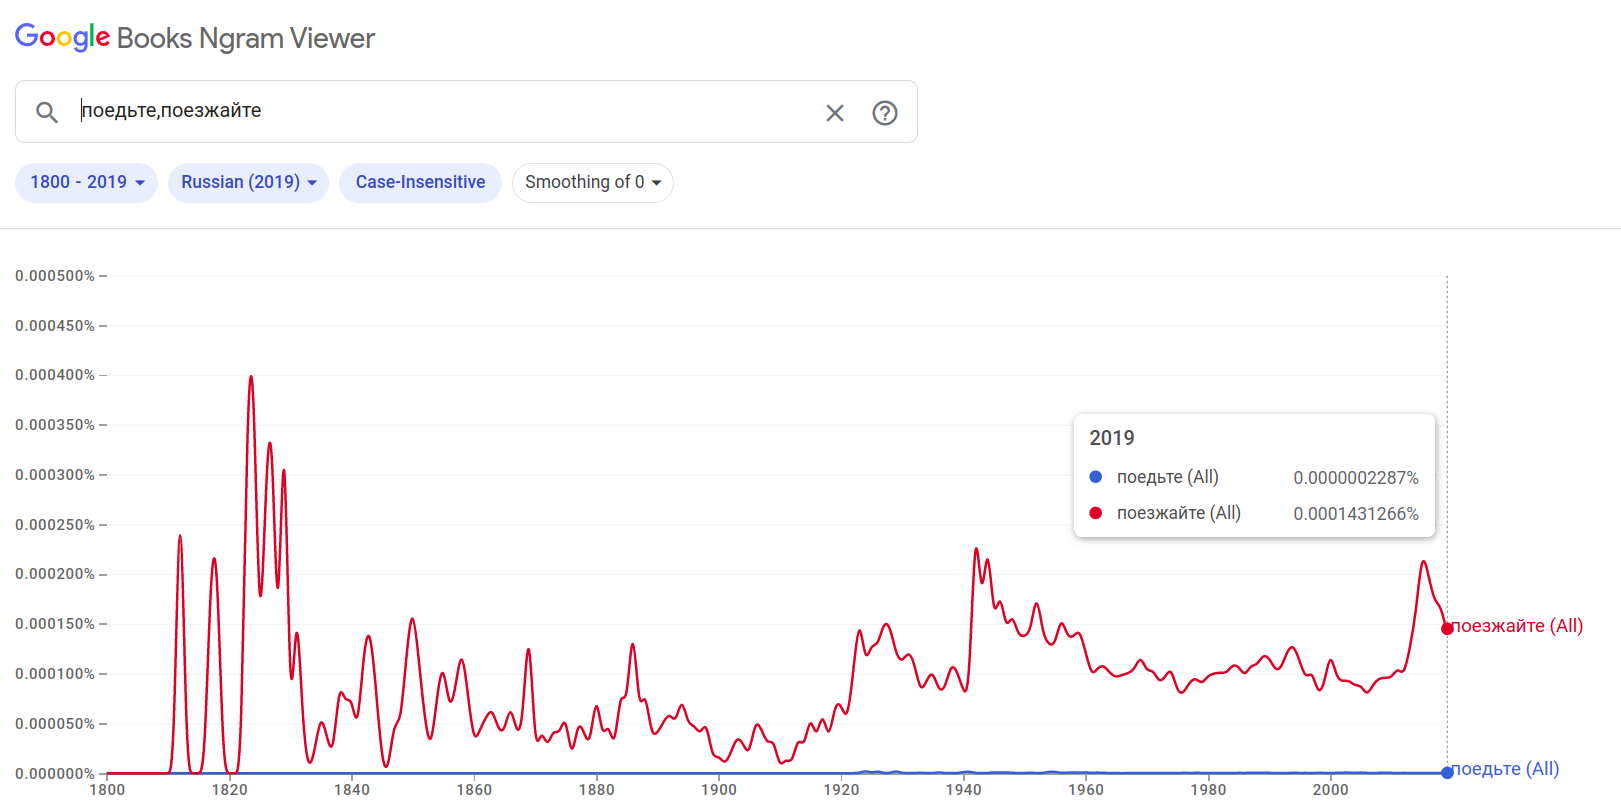

In [90]:
display.Image(b64decode(poezj))

In [91]:
print(f'Livejournal поедьте/поезжайте: {605/47268}')

Livejournal поедьте/поезжайте: 0.0127993568587628


In [92]:
cringe = 'iVBORw0KGgoAAAANSUhEUgAABmcAAAMaCAYAAABzoJI4AAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAJs1SURBVHgB7N0JQFVl3sfxH8sFRNRQXFBRQ0st1LDUXCostcksy2yxxcZWm/ZpWqZ6p2XKtqkmq8kWa7LMMrOxzFJbsFxKS1JRwZRUVFBAZJHtsrznORcIkFXwCvL9vO8d7vKce84994G8z+/+n8ejyCIAAAAAAAAAAAC4hacAAAAAAAAAAADgNoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRt5qQpJSivTDykJtji1UUnKRdVtq3871WPsgD50xzEt9e3tY93moObj012dLr4e16qZHel4hAAAAAAAAAADQuDWJcKYklPnks4JKHvujzabYfDusOXO4lyZc4KVj3b68A/p+/0b7uglnAAAAAAAAAABA49fowxlTJfPEv/Jr3d6ENSbE+X5FgR6619FsqmgAAAAAAAAAAEDT0KjDme9XFur1d8oHM6Yyxkxh1re3p/qe6GGHMckpRXaIsym2qLSduX++FdLcPKVJzdwGAAAAAAAAAACOcY02uTBhS8Vg5qTeHnrob45y9/UtuXKBV7npz0xbgpmGlbzkGT30SVzVDRz+at2pm/qFR2j0qHAF+6qRcSrqrbs1Y41T8gzX9dOnarBD7rdjnh56eqmSC80Nf4VNeUy3n966+m0KozXznpe1Osu63v96vXLrYB2NQ28ycqM044EZijLnK2Cwbn/6eoXV6oQla+kzD2me6eaeIRr7fw9rvOcKzXx9nqLS2yj8kpt1/bBgAQAAAAAAAEB9eKqRqjiV2SUXeh0SzFRkpjAza82YUKamtjgCnFlKj4/Ris9m6MknZmjFHqdQkyxFf/KxojKFhuQbpiEn+7uuZ0brp9ha9sV9q/XT9uLrIQM1vLMV6C2cp9V7suTMTNDqjxcpmm4NAAAAAAAAoJ4aZWlJxYoZE8yY0KW2zhzWaDOnY4RDwf0HKzSg/L1OZ5oSYmMVn+6Uc1+UZk2fJf+Hr1d4gFCd9NWa99lwhV3Zh2qYBuNQ2Klh8l+z2oq/shTzS6ycYWE1nt+ENWsVX+i6HnraYAVZPxMdZf5MejvkXfs/RQAAAAAAAABQqUYZzpi1ZkqY6cnqEszAHdqo97mTNalXJQ85E7Ri5guaFZUupVqhw+IxCr8kRKiCyRGt7p78w4dacPpDmhhKPNNQHCcNUVjAaq3OtPKv6LWKdYbVMLVZgqKi4os3DtWQQUH21bCLr9XYzP8pKi1I4RdepD5kvwAAAAAAAADqqdGFM2WDGcMdwUzBfz9V4bI1KoxcraLtu+UZMVgePbrI86xB8vrzxbV6jqJ9/1VR+jIVpUVKudvl0TpCHm0ipNZnuX7WwKyxY167+ZmU4gql+vb21BnDPK37iuz7DXNfXSuD8h971X5d5nWa11Vy8X7kVvtng3IEa/jkK7Xhtxn2VF3J69cq/uIQhTCgXak+Z4/WwWVLFW+FWpEfLtXwB8YqmHPVMHx7a0j/1lq90goK0zdobaxTYdWlM3usIGe366qj1xANDCy+v3WYxt9qXQQAAAAAAAAADaPRhTMlIUQJE0YcKSawcE550A5lyiq5bcKMgnf/J8c701RViGHCmKL4x6xgJrL8/dbtkvs8OvxZniGPWIPFPSp9jvmfF+iTzwrK3bfJCmQ2xRbo+xUF9jkoG1rVNpyp7PWZ+8yl5HWa8MmENA3Kv7f69ZCioq3r6clKs35QO1OFDhG68qxoPfN1gpw7FunDZYN198ggoSE41HtwP7VeuULp1v9tqGFqs/jVUUooLNlusFoLAAAAAAAAAI6MRhfOJKcUlV5v367m9hUrbapTNtQwAUXu8aNq3MYEGKad7+9fq2JAY4KZwo0ja3wOU1VTYLX1CvvukIDmyX857SCmKqaKJqkOr7F0n5W8vpLjLwlnSqppTIWQqRZqOFnKyiq+6utfZSdL3xqpJZFRit66U8lp1gYOf7Xp0E2h/YdrzNmDFVLDWjX13b4yyT+8rGc+iFa6OeX+oRp/1181trtrOD9rxwotXbpaUXHW/lKz5PTyV+tO3dTv1AiNPjtcwb6qszynj0LPn6jhUS9rRYpTMQvnaMUpt2t4oA6DUwm/LNWiH1YrZkey0p0OtQ7spJ6nDLHOR4RCA+O14LEntGiP1TRssl68fbj8zWaJi/TEYwvstVb6XPmi7j7LCip+XKQvvo1S7J5kZTml0Eue1P1jXKGRMzVGK76O1E/R25SYkq6sAof8A4LUqWdvDRwxWhFhQRUCEKei3rpbM9ZYTxQYofunTVJoWowiFy/V8l/jlJjmlMM6ztDwkbro/OEK8S/eLD1OkYu+0PKNO5WYmm69v63VKXSgRpx3viJ61S46cfQarH6BK7Qi1TW12TZnmPpUls4UxmttVILruqm4OcX/j8f2LNCj/1xkBzfB5z+qRy8MPnR7c6yLv7POSYx9rFmF/va579a7n0aMGa3wDmV2GjtH974QacVF1vOd97AevaiS6LLMe2LO2d3WOTt0OrVkLX3mIc2LM22GW20ml2nj6gtLV65V7PYUpZk30b+Fgrr0UdigkRozPFStPaveZ236AQAAAAAAAIDD1+jCmaTkP4KK2lTNvP5OvmrDBD1nDvMpvW0qSsryfvQ2eV17kUyAYQIZUzFjgosS5na5CpPc7YcEM5693nFNYWYFMHZFTdK7djBT0r5o37vyMBU0xUywVDaYMVOZ3TTF2zpWD7uCaPOWIrtyxgQ0dVX29ZnXVLZCxg5lrNeT/+grpdU1JnxqKM7YpYrc7rru6NFT3Sq+jWZdmvdf15wfE6wh5DJys5QcH2NfVn+3RBFT7tCk/pUMwtd3+yqkR83UiyXBjG+IRt90e3Ew41TcFy/o5YVx1qB7mQ0Ks5Ru7WuFufwQpkm3TFVESN3WjHE686xB8zBNvCRcG96IUnpmtP73SZTCbwiXf12eKDdekW9N15z16WWfXen74hS1xLosX67R109UzUeXotVvzdDMNcl/3OUZrD59XQPyyWtm6ZX3Vight9yrUFZ6guKizMUKQk6frNuuHaygKn590zbN0zMzlyouq8wzpMQr+utZil6/TVPvnayw5EV65bUFiin3ctIVHx2pOZvWKuba+zX19FqEBI6eGmz1gRXLXFObrd7qtF5LJWch/iet3ue66h82QmF1OPnpUXM0/Z1IxZc7J1n2uY82lxXfKfyyO3T9yBDX+Q/tp36tI7XCOqSETRuUbIUzFV9J8voNrmDGSI1W9HYrMAmtuONYRRcvkePfd6B6lpxvqy8sfWO65kWnl2+faQU2savty4ofInT9bZMUVuWvR/X9AAAAAAAAAED9NLrVLdoHeZReL1tF05DMGixlp/ry+e7dcuuvmCoSM5WZCWxKt7GCjLJhjQlayvI8+Tt7+rKSyhgT0piwxjPk0dI2hfGP2iGNkWS9trLBkglmHvqbww5mDBNMmfV2zhxe9zV37DV0yrw++7WUCZZK1tMpW0lTMaw6LLnpils5Ry/MiFSyGVh2WAHHeRVChsJkRc54VrNKghVPfwWHDVbEmNEafdZg9elU3DrLChtee0YzoyoMMNd3+ypkbZ6nF2auLj7uIA2/4Q5N7Ot6Lqf12MySYMbsr/9wjb5wvMaOsvbXoXh/KdGa8+ocRWepbgpd8ZL/qVfqouJEIP2XeZq32VmH50iwXusLfwQzjtYKCbeO0ZyTM8IVGuiwz8fSN97T6gPVP1Xaj+9qVvGAvKN1sIJDghXUJUz9rK7ijJunV97+I5jx7xym4aPGavxFYzX69D4KsiuHrADgx5l6ZW6MKn0FWWv1gR3MOBTUt/h9s46xtMpp3wrNenumZrzhCmYc7fpo8MjR1rkervDuxUlCYbqiPppjhxs1c6jP4IHF4YeZ2mxbpccVtzrK9d5bvTVsUFitg7Gs9bP0zBslwYxDrUPDNXzMWI0dE6HBfYPl71l8vB++oBk/FAcdjt7q17t4D3usgOWQ12G1XxdX5nayoqPiD9m387cN2uYsPub+vV3BjxVcLp3+wh/BTECwwk6PsH4PRytimHWeA0uqwCI148V5istVparrBwAAAAAAAADqr9FVzpRVtoqmKibUqG77yqpOygYXpqKkqim9TKBhgo7SNVqWrbHb29dN0FLMBDB2xUwl7EoZUz1THMqYiho7xKnAVMxUxgQ05nXUZfo2c5wlyr6+koqZsq+pRMXb1bMCkuduVmR1TQL7aOzV12t89/JVCsnfzrQGjl0JhqPDYE26ZbKGdy7bJkvxX8/U9E9MBUuyVr//gfr1nKrBrRtm+8qYtV5efmOpEsxAt2eQBl97tyaXqbjZ9sva4oH71gq/7v80dVCZJ7s0XTEfT9cr3yaqTSeHsjKlupW8lGit4ZeP1fLfzIB5slZ8uEAjHp6o0FoU4iR/O8sKc4rPSafhmnzrJA0uO42WM1lRH7+imcsSlFzDcyXExdvTuY2ebL134RWmJwsdr5tv8teCL6zfn+HXa/LIkHIvdeJFJqCaoch4K6BZ/qVWnNtHERWnZ7MCvHRP6zxefb+uP6PM818YpZlPz9DqFBOUrZZZrsg/bJLumxqh4NJGWYp+/0m9bEKOrGgtX51shUO1qOQIHaLwDpFaus9MbbbaCjT6lJ/arDBOa9cXn5nW4RoSVsvqJ+sY5ry3ojjQC9bwKbdp0qnlz1nWjqV6ffo8xWRax/6/eYoKn6rwAId6D+gt/zVRynJu04ZNWYo4vcyZTF+r6B3mikP+1t1ZWdb5jF6rhEtC9MeEak7FRse6giZfE/a49prw9Swt2OrqC/59J+r2m0YrtOybZPrCR1Zf+MEKN/cs1azFQ/TohYdOq1ZtPwAAAAAAAABQb42ucuaMYX9UiphgxUzvVR1TbVLVpey0aGWvlw1nKq4jU1HZ4KY0wCgOWkq1PkvVKRvcFKUvs3/+UCZsMVOulVTMVKY207tVuW/r9ZnjNtVCZg2akqnMSpjqIDOlmakeajgOBYWEqltQi/J3O2O09Os414Cyfx9NvP36CsGK/YBCRk3VHeOKp4DKjNKib+MbZvvKJEZqxisLXFNsWaFB2BW3afKgsgP+TuXnFFc4ebZRt5CKKU9r9bnkDj36xIt68i4TiujwdRitK0cVH7d1XB8sSah5G3NOvi1zTm6dXD6YMRxBCr/yr5rUvzapUZAVMtyuiZUOyDsUHD5WUx9+VFMrBDO2wDBNusYKU0x3NaHD5srLiFoPvlaTz6jw/FYoMvb0Mmu5BIRr0pSywYz9AhU2JkKhxb8O8dvjVav6Is9QDexf/J6muqY2KyfuJ0UVT2nWesBg9a5lEpH80xdyFWY5FHr+zZp86qHnzL/7aN18RXH1WGa0In9xVbT49+2n0OJKo7jNceVeR1Z0cUWMFbqMPa9ncX/YUHqMtsJ4xcQWB3In9HNNw2b6wrLi52o9WJMrBjN2Y9MXrtfozq6bCSuXK67SP7HV9QMAAAAAAAAA9dXoKmf6VqiEMRUjhxtOlA12SqZLq1ghYqb3qo55vGQ6s5JQpyhne7k2Hn49qn0OD7MGTcmNCtuWPbaqmPCmLsqGTyaMMZdyx1NhDZq6cyjk1OHqWTGnKHQqLTFWsb8lK3n9Is2I3aDRt/y1dHowxUcrOtV1NWjIeA3vUM3zj7pI4d++rNWZ1gCyNVidcFGIguu7fcVmqas1c/qc4mml/NXn4js09azgCoPRDnU7oZsca2LktAbEF702Q7pwjEaEhaq1b3ETK9QJquN7VJWQ865UxC/PaGmiU/GLP1TkoLsVUV3gU+tz0lrDxw3X0uil9sL2VQqN0NgaQpysPVGKXLpca7fuVIpZ/L7AIf+ANmrXrbcGnuIvVyTnVMo+U7ZW8bmCNPCsyqcNC+rSyTrbrunqWodHKDygskbBCrI2jrPeV2dmmt22NuFB6OBwBX27VMmF6doQtU3Ovn1Kt4tbHV1cUWQd26CetQwjshS7rjgc8uykbh3SFLM5rfKm3kFqZ/0Jy7J+P7bFWvs+K1yOgH7qF+pQ9Gansqzfk22FYerj6Xre6PWuihjHCQM1ZJBT0Z/FKMYZrw3rkzW2pFLICmtc77tDPfv3c53PHVGKLe4L/j2sPrvD2q6Ko28TbP3y7rE6flqsNiRa56dzhQahNfcDAAAAAAAAAIev0YUzpoLETFW2KdYVZ5hw5sxhdQ9oTDBTdkqzvie6AhATTJRUkxg1TedVtGNP6fWSKpuKU5iZsMajeK2ZGhUHOUHtPFRbm7fUbe2dsq+v4v0mkCmZmu3wtVHPsydpUq/KH82KXaCXZyxSnFnn5O056vnI9fZAe9bu+OJBcH+F9g6pfhDcN9QevF693hqm3rdTVlahNvXcvnwVhhW0vBythDJ9pEVgm0qfs/WwiRr/ywuaF5slZ2KUFrxhXTz97eqg0N59NDB8iMJCWzdMhYEjVGMvHa6oV1coOTdGCz5eoYG3Dpedg1XyK2Cf0+K1Umo8JyFhCg2wwplq1moJCu2pqicKcypuySt67dMYpReWvz8rPVlZ0ckmK/rjXmcldS0myOhU+bM7fP3t4zdbde7SuYrX4i9/R+lula9aChmiwR2WapEVRKSvj9K2S4unNnPG6KeSKc06hGvICbV8FwsTtXNf8euzQrvIN16sfpq/kkNOTlCarKDIekcHhoVozuY4OyCJtX5d+5jZxXJjtTbWFTmZ0KV1YJ6sZoqxmsWvj1b6qAi7L6RvinGFbJ4hCgtzpaRZCYml09ZlrZ+nl9fX4oAK05ScbO2vQgVa9f0AAAAAAAAAQH01umnNjIrrr7z+Tr4VtNQ+oDBtzTYlTNhTNtwpO5VZ2fVZKlNSNWOUCzXKhjHFU5VVpdCsOVOy7+LtylbDmCCqutdXm7V3yqq4ho6ZusyvaLM9fVn9g5ma+fcer+svLK5MSI/SkjWuNCA/N6+khfxb1TQIbrUpGYW3BvmznPXfvpzCZCXsKzeZlKLmfqyozEqeyhGi0Xc9prsvGa7Q4gXVVZil5B3RWr1knmY8c68efG6OovbVapKtGvmHTdTEU4sH3Nf/Tx//Yqav8pajkt/Wup2TlvYaJtVxOKp+DrP4/WuflAQz/go+dawmTb1b9z94v+6/a6omXzhcfdrVdAwOOWqRf3h7N3BubIUYA08trp1KXauoONdV59bVWltcbRJ8ypDSKdNqZgV1uaq7XKeyi4Ot1v0HKsTsrzBBG6JdsYozdq3s2cpKQ5cg66drTRhnXJQ2pLv2vWFz8VR9If0UXvy35I++UBdZyqrkdTgctQypAAAAAAAAAByWRlc5Y5jqmUsu9NInnxXYt00FzJPPOXXmcC9NuMCr2m1NyPGGHeb8cV/FbUx4UTL1lwlfvK69SBUDDcOs01JVZY2pnikqDl0K4x+VV4drywc2xQq3Tim3Ro2HaSfXOjImoCk5TrMGzRnDPA9Ze8ZUAH2/svp1dyqqaaq20mOzzoFzyoNyvDNNlb3++gjqH6aQuTGKK3QqcftO654wefv6FD9qDQhn1DQhldNeCN1mDRSbnKW+21d6nIMma2LgUs0w67ukr9YHnwxR72srmXbLs7X6jJlsXSYpPX6bYmKjrcs2bYiNU7o1uJ2+NVIzXsjS1Ievr3w6rjrxV/glFyls4yxFZ6Vr9SfzNLz3YDkq6fp1OycHrXOiw2Qdx7dRKl4xRWFXPqSpZ5VfjyS0b7iGn9FNL94/RzF167JuEXJauIK/TFBCYbrW/hKjSb17atsvG1yvyTNY4YND6vBs/nKYae1MmBcyXo8+PPbQafNq0iFMA7vMU7yVsyRujlb6ecO1MypG9ltUJnQJ7t9PwQvjleDcprWbsjQ8PFYxca6+HRwWXlrh8kdfcGjw1Bd1fTgBCwAAAAAAANBYNcrKGcMEKiagKWFCDBPWPPkvpx1WlF1PxgQy5jL/8wLd9YCzdEo0wzxHxSnRzNReZatn8kZeWy6IKQktyq7VYsKLsmu0eIY8Ui6MKfjleFdYUxzEFKVFqjB6ZGmA49rm0XLbmLCphHltJlRyTcfmOn7zep74V60nbip3rGUrZOx1Z6zXV7pmjvU6zW3zus1181rLVgg1uALXVFX+XToVDyRnKS42vvptcmO1YXtxuNKhmzo56r99Ra37T9bd1w1X+LjJpeu6pP84R/M2V1cB41DrkD4aPGqiJt96v557+mFNCi9efCd1tb74IVkNInC4Jp0f6go/UlboQ2twvrLcxb9LSLlzUm3tzu5Ye62Ww1K4RwmJJedzuM4/o4qF4vclFE+z1gh1HqzBxb/26dFRismK1ep1xXO8dbEeq0s2Y68zU3wG9m07zPMarH5hrkjHuT1GMelW2LfZdTxlQxd1Gagw+4ZTcetjlRW3wTp22YFS2IA/IiH/4JLfD6tdXKIAAAAAAAAANF6NNpwxTCVJ2YDGMMGLmbLMhBZ3PZCnq27MswMZcymptClhtq2q0sbnu3dVNqAxAUbu8aOU49HXDi3KhhWmnWlfjhWyeHb4c7mwxVTJmJCmYKWHCjdawUx6ZLn2HibQKcMcm5lyrexrc70up/26Kr6euqgYQJnXZ16XeX3mdZYNnkxAU7ZtQ0iOWqv44kH6dsHtXAP5IeEKCyx+/KcFikypevuEb79QVPG4eXBYP1dVQn23L8szTJfeMFxB5jfAN1TjLy++XpisFR/MU1zpVE9ZSohaqlkvPKRH3485NPzwD1HEhDGl02GlJDbcoHjQ2VdqbIgrAEhYtkirUytpFBJW7pys2FfVs6Vr9ReRrnVKGoCjin2s+HK1GiieOgKCNfjU4gQmJVqrv/yptI+EDh5cx8oXf/Ub0NN1HnKjtfTraoKxfZGaMe1lzfshrsJaPdbb1z/MFaiYMPHb1Yo277FnULnQxZ6S7eTiCC72Jy2NinVV+wT21sCygVL3cPUu6Qsrv6i8v7ieRTEfP6Nn3lmkqMSGmYoPAAAAAAAAQN006nDGTPFlAoyH/+ZdLsQokZRS1XbSzVO8q50CzYQRZjqvmkIJU4VySDBT8hxW2OLZ651KpzMr184KcbxO/b3Sxx76m0NnDqv6bTCvpbLXXpOSQMmsN1Obdg05rVn65nma8Vmca7C67Fofjj4aPaq4GiQrRvOmz9LqQ9ZpyVL8shl6pWT7gDCNPTukYbYvx1Gu95dd58UMps9aWLy90hT15TytiE1WwoqZmvlDwiGD8MmxMUosHnT3D6hhUZe6sM7d6CsiFGyHRlmHrptjvwzrnJxd5py8Wsk5KUxX9MfTNSvqsOc0s46lm7p1KakU+UlfrE4+ZB9RH0zXnOh67MMNgk4tWVfGCuGWrHZNIeYZavXRoDo/V+shozW4OAxJWDxdM5bEqeKrdyau1sxX5ylqhxXgvP+CZq5IL9+gR0m4lqWor4uDrcCw8qGLJWRAb9m9M9N6npWuc986LLz8Gjll+0JmlGa9Wtk6SFYw88Xrev3rOMX9uEAzrGOLI58BAAAAAAAA3K5RrjlTkZmW7KYgD22OLap2DRYTZNRmXZoSJpDw/f1ru0qm4N3/lU5rZgILc6lqLZqyzNozJngpin/MnsqsyExrZl1MIGM/3v5au011TJB05rBCbd7ien1JyUWlU7GZx8z0ZptiXVU07YPKBzUeqjq4Ma/BrqDp3lmFy9bYr89MbVby+ipO1VZ7aYr90goqKllbJWtfnGLjkosDDIeCR12p0Z3+eDzo7Os1cfOT9iC+M3GFZj6yQUvC+qlnpzZyOK0AJDZa0XuKh7g9gzT4yms1uHXDbV81f4VfdqnCN89UVKY12P7dB1o0+H6NDwm2ApLRWv3CUiU4rQDi/Uf14MpwDezbTUEOpxLiohQVneAalHeEaPjwUDUkR6+xmjg8Si9XM11a0KjJGh/9rObFFp+Tx13npI91TpSZoG2bohWXYr0jvkEK8kpW8mHlJ/4aPGq4Fm2KVLIJYt55VA+tGazw0CD55yQr9tfVijFBQLsgtU5NPqRCpNHoYL13PaxAIu6PuxwnDNGQdqo7/zBNvDpCsa+6zkn0J8/ooR/6KKxviIJ8nUpL3Gb1jXhlFZ+L1v0n6ZrhFTqjZ0/169takSvT5XS6fmtanxSukAp5raPXQPUJWKHVmU65mvmrX/+ehxxSsNUXJlp9YY7pC/GRmvH4WoX0Le4LucmK3xzlep/sJ7X69tXjFcrSNAAAAAAAAIDbNYlwxjBVNO2HedhVJjdPUem6LMlWkBFkBRbm8cNl1mcpu0bL4TBVNBWnLasLE8b07W1dqSRYMmFNZZYNnqbaaIjXV54VSkSvVkK1bfwVMup63XFJaPkpsKzAJGLqfXK8/7rm/JggpzWoHb9+hXWpuHmIIibf8cd6Lg21fXVaD9bEi35S7PvRynLGa+l7SzX4gbEKDp2ov97k1PR3IhVvBRvpViATaV3KsQa6B187VWM7q4H5K+yiiRq8boZWp1fRxNMaZL/1r9Ib0zUv2mpkhUjxUdY5Kfc0IRo9ZaIcn76oRYdZ3OLoO1FTL0nW9E+irfDFqeToFVoaXaZB6zBNumWIYqZZAZcaqyCFnxqqeaXpjEO9Bw1UHXpJOf5hk3T/rQ69NnOp4rJMOBmj1dalPCukPH2Sbr66eOq8Co/17t9H/iuLq3is97tP/56HThvn6G0Fgv5avSarZMfqd0IlqYrVFyJuvU969xXN+8UKSZ1V/H607qOx112v8b0bsNILAAAAAAAAQK01mXCmopIwpj6hTGNgqoB+WFmgm6Z4V/laylYK9T2xEb9eT4ccAW0U0jNcQ0aNUUSvKoa8rSBj+JRH1W9YpJb8EKXorTuVnGYNOjv81aZDN4WGDdaYUcMVEqAjs301gs6YpLE/Pqp5W51y7likWd+G6/5RwXbVw8P/GKLIr5fop/XbFJ+cbkVUDrUOClG3vgM18twIhbU7QiUIAeG69MIwRZvQqKo2vlb4cvs0ha1ZpEXWOYmJT1a60xqDDwxRz/5DFGGdjz5t4jXnQ1dzh3Wu6n60Ditwu12PnbBCixYvV1RsvF2F498mSKH9I3T+uAiFtlitGDVu9tRm/4tzTefl21tDwg83mnFpHTZR9/9ziFZ/u0Qr1sdp575kK9xz2OelU68wDYkYo+HW70JV59vRu596+6+WPeucvxXC9K6spRXiDOgtx5oouyrN3sa3iif0tQKamx5VWHSkli5fq+htiUrLzJLTes+DOoWqd/gIjT4rXMHkMgAAAAAAAMBR41FkEY6Kux7IK10355ILvXTGMM9DAprX38kvDWfMtG3/ftpHwGFJj9SL989RTKGZCu1+PXlpw07BBgAAAAAAAAConSZbOXMsMOvjfPKZay0Z89OsN2OmNwsqDmhMRc2m2KJy7YGK0nes1vIfVmj1zhBNvmeiQiutqHAqPnK5HcyYqbNCe4cIAAAAAAAAAHB0EM4cRROK15cpCWhMELMptqDStif19ihtD/zBqZ3ffqwFP5oFaWL02ltBumNKhEL8y7dJ+GGWZnxZvApNp+EaGcYq8AAAAAAAAABwtDCtWSNgpi2b/1l+6RRnFZkpzwhmUKXU1ZrxzExFpRbf9g9Wn/69FRJoJTRZyYqPjVZMYvFqNY5gRdx+nyaxEDwAAAAAAAAAHDWEM42ImdZs85YiJSUXqX2Qhz29Wd/eHoesQwNU5ExcoVmvzdHqRGfVjQJCNXrKLZoY1loAAAAAAAAAgKOHcAY4VhSmK27Fd/rulw2Ki09UcpZTDr/WatO+m3oPGKKRIwdXmO4MAAAAAAAAAHA0EM4AAAAAAAAAAAC4kacAAAAAAAAAAADgNoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRt5qItLS0nTw4EHl5OQoPz9fAAAAAICmydvbW35+fmrZsqXatGkjAAAAoLnxKLKoETOhTEpKinx9fdWqVSu1aNHC/oe8h4eHmh3zTjXDlw0AAACUw7+LmzTzEdR84S47O1sZGRnKzc1Vu3btCGkAAADQrDTqcGbfvn12pUxQUJD8/f0FAAAAADi2ZGVlKTk52a6k6dChgwAAAIDmoNGGMyaYcTqd6ty5c/OskgEAAACAZsJ8LN2zZ48cDgcBDQAAAJoFTzVCZiozUzFDMAMAAAAAxz7zuc98/jOfA83nQQAAAOBY1yjDGbPGjJnKjGAGAAAAAJoH8/nPfA40nwcBAACAY12jC2fMt6R8fX1ZYwYAAAAAmhnzOdB8HqR6BgAAAMe6RhfOHDx4UK1atRIAAAAAoPkxnwfN50IAAADgWNbowhkzx3CLFi3UbBUJAAAAwOHi39NNnvk8aD4XAgAAAMeyRhfO5Ofny9vbW80Wy+wAAAAAh49/Tzd55vOg+VwIAAAAHMsaXThjmIUgAQAAAADND58HAQAA0Bw0ynAGAAAAAAAAAADgWEU4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ400iFhoYKAAAAAAAAAAAcewhnAAAAAAAAAAAA3MhbAAAAAIBmrbCwUDvjdyk19YAyMjJVZN3XulWAAgOPU7eQrvL05Ht9AAAAQENq1uFMXl6e9lsfPnJyctSyZUu1tT54eHl5CQAAAACagz17EvRN5A/aHBOr7OycStv4t2ihvn1P1NkRZ6pzcCcBAAAAqL9mGc5s3fa7vvlumX7bGqeCgoLS+/38/BR2Uh+NGTVS7dsHCQAAAACORVnZ2fp0wUL9snadioqKamxr2q2NWq/TTg3XxReerxYt/AQAAADg8DWrcMYEMZ/873Ot+nFNpY+bCpqf1/6qtb+u14SLxmn40CECAAAAgGNJUlKy3nx7lpKSU+zb3t7eOmVAmMJO6quQkC5q1aqVfX9GRobi43dr46YYRa3boPz8fK35ea127NipG6+brKCgdgIAAABweDyKavqalJtt2bJFJ554ohqaeZn/fW+O1m/YaN92OBw67dRT1PP449XC30/paRnaFBOr6OhNKjkhF10wVmedOVxHQ2hoqOLi4gQAAACg8dgW97ty8/J0Up/eddpu0+ZY+fr6qmdoDx1N+6xg5qVXZigrK9u+3b/fyRp/wXlqGxhY7Xb7U1P12edfal3x56mW/v666/apRyygOVKfCwEAAIDGotlUzny3bHlpMBPStYuuu/YqHXdcm3JtTh9ymn7fvlPvzPrA/pbYZ198pR7du6l79xABAAAAaN5MMPPGzFkqLCzUlGuvrHVAY4IZ8xnD09NTN11/7VELaMz0ZG+9PcsOZjys22PPG6NRZ59V+rj5Qtu2uO2K37Xbvt0tpItCj+8hDw8PO7z58+Qr7emhv1i0RAezsuzqm7tuv4UpzgAAAIDD4KlmwHwIWfrNd/Z1882uW2667pBgpsTxPbpp6g3X2pU15kPX54u+0lETNU1jTgzVkMdWlb8/8TPdMixUoadM1Kubcu27Ih88RaF9r9N7qz7TtNsm6qxT+6pv2BCNmfyA3otKr/R5z3qiwvPmbtTz4/sq9MQhemR5yZ3pmnujdV/fq/VeYoXjS52r6/qGqu/k95RUbvuz9MCSMvvMso43zGp31VuK/2NnWvvEGPUNDdWY/1uldAEAAACNm6mYMZ8RzPRe77z7gV15X5OSYMZsY7bNzc3V0fLp/xaWTmV2/thzywUzpjLm3y/P0Ksz3tJnC7+0L6+89pZ9n3msxDkjz7K2HWNfN1U4n372hQAAAADUXbMIZ6I3blZOjutDkJmqrKZvdnXuHKyzzhhmXzffHDtwIE2NRkG85v7fP7Q4ub0iHnhRt57k+8djuas07cYntdZ/qG649zHdc+1Aaf1cPXLNdXo+quYPgVtnP6W3NtTjw6LvybrtiRt0so91jE89r1XVJC65G17RI7O3KrfnNXrs3qFqLQAAAKBxM5UyUyZfaa/RUpuApmwwY7Yx257Ut27ToTWU3XsS9MvaX+3rA/qHWSHLmaWPmSoYE8TsjN91yHbmvldfm2m3KWECmgH9Trav//xLlPYkJAoAAABA3TSLcCbOClgME8r07VO7eYsHhg/4Y/vfd6ix2Pru3zXtm3SFXPC4nrmi4nRrvjr1r7M1+9l7dM0Vl1kBzWua98o16pW3Vm+9OLdM1Uolds3VtFdXqr7f4/Ptd5uevnmgfHdYodD0tZU/X8FGvfXoW9pY0EvXPHKPhpLMAAAAoIkw4YqZ0qymgKYxBTPGt999b6+taY5l/Ljzyj229JtIpaYesK8PGzpYjzx0n30Zevog+z5TOfO11aasCy84z34uMxXat5HfCwAAAEDdNItwJj0jw/7Zrm1be57n2ujQPuiQ7Y+23E2v6oEXrADlxBv09CPnqn3FBt4hGjqil8rU0qj1iBt0zSBf5a75TquSqnrmdC3+1/OKzB2oc8+p7/o6vjr5psd0W7ipxHlEr1RSibP13af0ZlSuel31mO4ZQTIDAACApsVU0Jg1LKsKaBpbMGOmU9scu8W+Hn5KfwUGHlfu8Q3Rm+yfZi2cSyeMt6eANpfLLrnIXnPG1WZzuW3MGjThA/rZ1zdv3mLvAwAAAEDtNYtwpiSQqcsHhoIybR0Obx11WWv1yn2vaK0G6rbn6lJtEqKT+3awXtA2ba2iACg98nlNW5Suk699UJN7+qrefE/WDf+8TQO9Nuqtv16vux6cq015Vri09StNu+c6/WX6SqWb6czuZjozAAAANE2mIr+ygKaxBTPGjp27lJ2dY18PO6nPIY8PO32wzjt3lP405pxDHuvR3fXlrcyDmYc8dnLxc5k1PiubEg0AAABA1RpB6nDkmW99GWbByjynUz4OR43b7N69p/R6cKeOOpqS3r1Koe+6rve65THd2q9uAYqvr2mfpvTMSh7MtUKfp+cqvvtlmn3rQPlOr+JJclfqkWGheqSy56/svvYhat/S2mzbSn22rfjOpLVa/Knrauv+vdS1pQAAAIAmqySgefvd2aUBjZnmq6CgoNEEM0bJlGVGSNcuhzxedv2Zssxr+W1rnH29S+fOhzweEtKl3D56dO8mAAAAALXTLCpnep/Qy/5pPjCt+XltrbZZ+eNq+2dLf/+j/iHD98QIXTYxQr38pa2fvqK5dVwCJz09zfpfP7UOqPBAgbTx7Wl6L66DLrv3Hg31r+ZJvEMUcdM9uufuMpebzlWvSuO9JC1++kktTmqtiGnLFBf9b51rPbfv0Ae17Ldf9drF7ZX+4/N65ONqV8EBAAAAGj0T0Fz/5z8qaEww4+Xl1WiCGSMj849vabVqFVCrbfLy8uwKoPhdu+2ZCMaNHXNIm1atWpVeT8/IFAAAAIDaaxbhjPnAVDKv8hdfLtG+fUnVtl+/YaN++eVX+7pZBLO269QcKa2H3qinn31bM/95oUKSF+uRW6dpVXptt96qteut1+vVU726l38kZ8csPfX6WrU+xwpaxtQwwZhXiEb++VbdenuZy80j1dXr0Kbp3zyvaZ8nyfe0G/XgpRXWsPFqrXOtYCeiVboiX5ymuYkCAAAAjikeHh7W/6jxKCqqU/OsrGxN/8+b9lo05rPQlVdM1PE9ule7TWN6uQAAAEBT0CzCGfMttosvPN/+wGDmWn7Z+qBRdsHOEmZNmu9/WKlZsz+S+fgSENBSEWeNUGMRcvEzevGWgdKmt3TXPe9pa0GFBvlb9dWCtSqb28R/+rxmbTZVKyM1sn355kmRi7VSw3TbAxeqvRpIeqSef2Ku4r166Zr7blCvSsIbdb1MD94wUL5Ji622nylJAAAAQNMUE7tFM/87u3SNmYpr0DQGZStcMmpR4fLJp5+VTvM86bIJOjV8QKXtMjIyyuyjdhU5AAAAAFyaxZozRr+wk3T+2DFauGiJMg8e1JszZ6lzcCf16nm8WrRoobS0dMVs+U0HDqSVbmOmNFu1arWGDRsif6vN0eergXe/pmd2TNRdn03TX54I0bxHIlS25mXru1fpgl/PVUS/DtKuVfpqyUYl+Q/UPXdfVkkAYz3fzX/XNd3VQHK16sVpem+HFSRd8aBuO63qtXF6Xfegrllwld5a8qSeXDRU/x7bYPEQAAAA4BabY7aUrjdjQhkzvZlREtaYgGbKtVfqpD5Hd3qzklkEjJ27dpe7XVFWdrZ+XR9tXz/t1FOsS3iVbePjd1e6DwAAAAA1axaVMyXOGXmWrpp0qRXG+Nm39yQk6vvlq7R46bf6cfXPpcFMh/ZBuuWm67QvKVlffLVUr73+tv0hpXForwunvah7rOBj6+z7dde7W61IpJh3L93wwr91Waddivz4Pc2NjFebQZfpsbfe1q39Dg1KfE+8Rg9ed7IaSu7Pz+uRD7dah3iuFQaVD40O3flA3XbveIUoSZ89/bwiUwUAAAA0GZUFM316n2hfrrv2qkZVQdO9W1f5+bk+A23cuLnatlkHs+wpzHqGHq/hQ4dU2zZ6k+u5zOerbiFdBQAAAKD2PIqK6jgB8RG2ZcsWnXjiiTqSTNDy409rtHFTrJKSk5WTkyt//xbq2qWzBvQPs8v2zdzKL7z0H3sBTMM8dsvN17mtgiY0NFRxcXG1bh/54Cm6bl6I7ln4uW49sqcPAAAAaNYqBjMmjDHrXFbX5mhX0Lw3+yOt/XW9fSwP3nd3tZUuZrpno7q1N/enpuqpZ/9tv76B1uena668TA3JHZ8LAQAAgKOp2UxrVpYJWM6OONO+VGfqjVP0nzfetudb3mVdTAWNOwMaAAAAAI2LqYIx1TDVBTOGuc88VhLQHO0pzkZGnKEoK5wxx7Lg80X68+QrK20X9/sOvfyfN+zrt//lJoUeX/kcyAs+/9J+Lg8PD51jPTcAAACAumlW05rVlamm+ctN16lLl8727ZKApvFMcQYAAADAXWobzJQwj5lApjFMcWZmAggPH2BfX7dho7757nsdrq+/Xab11nMYpw4coM6dgwUAAACgbghnakBAAwAAAMDw9fGRp4dH6TRl1QUzJUylzJTJroDGTBNmnuNoueSiCxTUrq19/YtFiysNaAID2+jc0WfbF3O9IrPNoi+X2NfbB7XTxePHCQAAAEDdNcs1Zw5HVlZ26RRnhlnw8s7bbq52Hub6qOuaMwAAAACOvG1xvys3L6/O05OZihkTzPQMPV5H0959SXrplRnKzs6xbw/od7LGXzC22jVojNTUA1qw8EutWx9t3zZfYrvrtqlq3z5IRwJrzgAAAOBYRzhTByUBTUJCoq68fKJdwg8AAAAATYkJaN56e5aSU/bbt01VT/iAfjr55L7q1rWLWrUKsO/PyMhU/K7dit4UU7pejWEqZm64brI6HKFgxiCcAQAAwLGOcKaOTEDz+44dOrlvHwEAAABAU2Q+13zyv88VFbVOtf1A6CGzxswpuviicfJv0UJHEuEMAAAAjnWEMwAAAADQTJk1Nb+L/EGbYrYoJyen0jYtWvipb+8TdfbIM9Wlc7Dcgc+FAAAAONZ5CwAAAADQLHXt0lnXXHW5CgsLtWPnLnttmYyMDMnDQ60CAuy1aLp363rE1toEAAAAmivCGQAAAABo5kz4cnyPbvYFAAAAwJHH158AAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNGmU4U1RUpGarGb90AAAAoN7493ST16w/DwIAAKDZaHThjLe3t/Lz89VseQgAAADA4eLf002e+TxoPhcCAAAAx7JGF874+fkpOztbAAAAAIDmx3weNJ8LAQAAgGNZowtnWrZsqYyMDAEAAAAAmh/zedB8LgQAAACOZY0unGnTpo1yc3OVlZUlAAAAAEDzYT4Hms+D5nMhAAAAcCxrdOGM0a5dOyUnJ7MQJAAAAAA0E+bzn/kcaD4PAgAAAMe6RhnOmG9JmTmG9+zZQ0ADAAAAAMc487nPfP4znwOpmgEAAEBz4FHUiNOPffv2KScnR0FBQfL391ezZ94pDwEAAADNG/8uPqaYqcxMxYwJZjp06CAAAACgOWjU4YyRlpamlJQU+fr6qlWrVmrRooW8vb3l4cGnMQAAAABoasxH0Pz8fGVnZysjI8NeY8ZMZUbFDAAAAJqTRh/OlDAhzcGDB+1KGvMPeQAAAABA02S+cGcqZVq2bEkoAwAAgGapyYQzAAAAAAAAAAAAxwJPAQAAAAAAAAAAwG0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNCGcAAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNCGcAAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNCGcAAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI28dYxw5kt51iW/wHW9sFBoIjytiNBh9URvL8nH23W9MaKPgb6Kpqap9Nmc3Dzl5uQpL89p9dl85Vudt6ioyL7g2Ofh4WFfvK2O6vD2lo+PQ75+PvLz9REAAAAAAMcqj6ImPPJRYA08ZudZgzrWRdarKDQDObI+4AtNjemEHtb/elqDM+YNtMZk1MK6eHnpqKKPoSL6KpqaxtpnTQiTmZmlgwezrWPxlK+vr3VxyOGwLt6ugzMD9jj2lfxT1GmFck6nU7m55pJr/V0rVMuWLRQQ4G+HNgAAAAAAHEuaZDhTaB2xNZZjD0K6Dp/Bm2NPkT0oZwYRrXEZa1BRbkUfQ+3RV9HUHN0+W1BYqAMHMuxQxgy6m4tPYy3pwVGV53QFeOZiQprjjmslL09m5AUAAAAAHBuaXDiTnStlZJlrDEI2D673uZW/1MJXbkEfw+Ghr6KpcX+fNYPs+1PT7UAm0BpopzIGtWH+qZpqBXqm/7QNbG33HwAAAAAAmromFc6YQcjcPMlePoFp6JsPa+zOfE/WTD3f6giPx9DHUC/0VTQ1buyzKfvTlJeXp7Ztj7P25xBQV7l5Tu3ff0A+Pj5q17aNAAAAAABoyppMOJN2UMrPN9OhCM2UlzWCaKacb9NSRwR9DA2Fvoqm5kj32aSkVLtKpl27NlTLoF7MP1tTUtLsn+3bBwoAAAAAgKaqSYQzZiAyz2k+kAvNnBnTM1+4bugBRPoYGhp9FU3NkeqzJpjxtNIfKh3QkEwlVqGVUBPQAAAAAACaqka/qqqZusd8Q5yBSBimH5j+4Fpno2HQx3Ak0FfR1ByJPmsG0O2KGYIZNDDTp0zfMn0MAAAAAICmqFGHM2axa7OmAlP3oCzTH0y/MP2jvuhjOJLoq2hqGrLPmsXbzRozZioz4Egwfcv0MdPXAAAAAABoahptOFNY5Pr2LuOQqIzpF3b/qEcFAX0M7kBfRVPTEH22oLBQ+1PT1bbtcawxgyPG9C3Tx0xfM30OAAAAAICmpNGGMwezzf8W2f8PHKLI9T+ufnJ46GMNwxm3W/NX56ixy1y3S/Oj8+R29FU0NQ3QZw8cyFBAgL98zSI2aLoK8pS5P1NH4S9nrZk+Zvqa6XMAAAAAADQljTKcKSiQcuyRAL5ti+p42P3E9Je6oo81DOfWHXrgye1auC5bTjVuqXH7NOu5DXpt7dEYZqSvoqk5/D7rzM/XQSvZCTyulZqlzC9136hRuuz1rWq6MhX94UO67IKxOu+Si3T1y5vUmJm+Zvqc6XsAAAAAADQV3mqEsvPMwsTmq7v1GIwsyFP82n1aErlPm7r21POTKs55X6jUtfF66397tS7eaQ1DeKtTaBuNuThUE8J8yrXMjN2lmXP3ak1cjjI9vdWtZzuNu6KHxoR6H1a7+itU/Kqd+nBxitbtyCk+9kDr2Hsc9rHbajxn1gD3uh2a9Wmy1pj9+vnplIGddM1VXdTTX0eF6SfZeR4KaFGnzQ6rj8V/sla3f1o+hHA4vNW2Y0sNOqOLrvhToAK9dBTkaOX09Xpps48uv7e/JoS6KXPNStFb03dpW6cuev6aQJV8Pz4zLkHzrd+ryJhs7c+V2nZopUHndtc1o1opoMzm7u6bIRf21Q3Rv+q1GVvU88kwjWkvt3JnX62UM1trPtuhT1elaVtSvnJ9HeoWepzGXNhD407yUaNSkKFZ96/XR4meGnPnEN05qFEvj1Yz63dl5iNbtMSrox58NFQD/EzFmfV78rP1CxLSXpcPbVnc8Cj9LlfhcPusWf/DVDLUeTqz/VGa/84Hmr9yoxLSJJ82nXTikPN0xeRLNbSTGqfEn/Thl1vVLuIqjT5edfP7x7rljtlqdcMMPTu+kb3ADe/o8dd/Uka/S3X3uBMUHNqtioaZ+m3B63pl/g+K3p0pBXRTWMSluu3m83RCHftNfZi+Zvqc6XuBx7UWAAAAAABNQaMMZ+rzLXFnYooWL9mr71alKqZ4houQjoe2y1y7VX9/KUnxBVJg+xbqVpCrbbHWANpzWcp88BRN7l08KBa3Q488vUsx1oh8YKfidpv26qWns5T3WH+NC1bd2tWbFcx8Ea2/zcmwhkQ81THY2leuOfYk69it++4P1+ST6nbstT5na7bo76+Yc+ZpPZ+f2qbmaM2y7dq8O1//eqi7Qo7K7DWub3fXdfCwXpUIViATcpxr27ycAu3dlaaFc9K0ZlsvPX9HRwXKzQqc2rrTChgzCrRtb6HklgHdQm2bv12L9/vpgqnd1NPPda8zdrvV53bbfS6gbQv1bOPUNmuUdeF/oxWf1V/TLiwehD4afdOrhcZNDtaSf+zWrLlJGnZr+3Jh0ZF3FPpq6ZOk6aNpmzQrzrUmQ0AbhwJyrPcmOkmvbT6gzTf2170j/IQj5GC2tu0rtELITOv3QHY4k7k1SXM+szr1aS00wQpn7D+fR+V3uTqH12dNBUOHDu3qtI32L9fjtz6qpfs7aeiYSzWmi49yE3/Tqm9e130rf9X905/UuG5qfBJWa86sL9Wv26VWOFPHkNPLR63atLXObyMLRy07oqyAzKuXbvzbzZpQzXnf/+VTuuPfUWp12nm6drzVcOdyfbLwed2RJM1+8jy1lfuYcGbfvhTCGQAAAABAk9HowhmnmZGiHusqbPtqm1772imHv5/6dMpTTGJlC8Tm6edvUuxgpueYME2b3MYapM3Tmld/1aOrsvXF1yma1Lu9NViWr5WfJdoDyKbd81Y7h2k3w2q3PEPzF6bq3BsD69CuAWQk6cMFJphxaMydp+jOQdagTkGOIl9ep+d+ztEXS5I06aSOdTqmWp2zgoP6Yq5r8HvQpP566HxrMDEjVTOf3KT5W/do1vJgPTTyKA0wFbn6jaOWvbm+fcwxoIdevqtj8ftZqL3Lt+iRN63+9MsufR7XUZND5V5erTTp/jD13eOtvgPc9CudlaKFK3Kk7l01piQMVI4Wz01w9bk/Wb9XV5vfqz/CxHWLE7Tu/F4a4HUU+2b3zhrXN0Ev/bxbkYntNc7dX1Z3c191KVTM3K12MOPo1F533RWqiK7mAPK17bNNemRuhiJnx2n4gJM0rJnOQnXEte+sex9poZ1qpQHVjVYfjd/lmtSxz+bk5snLy1M+jrod/2/z39bSxE4a9/QM3T/kj9j0xvEf65ZbX9erb32riMfPdnOgeoR1G69n3x+vxigvO9P632C1bVNNo4Kt+uTDn5TZe4pmPH2VutuVo+N1Vpupunr2x/pk63m6sZfcxvQ50/dMH/TzbXyBFwAAAAAAFTW6cCbPGgQqrMcUPoEnddYtJ7dRxMBW2jv3F93xRWULlRdo/wEzyGsGwEqmWvLRKYNaK2BVinL358kMSwQWWAPKsdYBebVUxJg2xYPxPho0KkghqxIUH5uqnQWB6qlatmuIKa/i0rQuy/oZ3EETBhYPPnj5afjwNnrtZ3PsTu237upYUPtjqtU5S0rVun3Wz1aBOn9M8be8reuXjwvUkhmpWmPtO3Nk8FEZODP9JS/fo9aDh/XtY+V5quPQEI1ckKJZCTmK32M9eWihlkxbo5c2SRG3DtW9Q4vDi107dMdDu7QtoL2mTT/RCilkB2tr/henD5elaVtaoXwDWqj/kGBNvixYISWFDDW2ydbnL0drZpy3xt07SLcMcO3PmZik+XN367vN2UrMck0vNnz88Zo8ovj9c6bopakxWlIYqDsfCNS2uXu0Ii5HTv8WOu3cnrrlwjZVvp/O6BStzLDCFdOfSu7MSdNmU5lhDTCPGVuyradCzmyvvlYAsCYzR6m51l2+R7NvWvsZaLWJztDK1dkad6Eb593RUeqrVpD2+XJz3hw698+9rGCmJEzzVs/zj9cFP6y3+m6aVqzL17ARrgNLjd6lWZ/u1ZrtOcosdE2bOGFSqMb0KnPgaaZibIcWrjto96+ADi01fHR3XTOmbL8pnoJx4T79vMdK46y+1XdQsK6/okz/rq3YOE39Z4ISe3fXY6PytHB+ktbsK7T2a/W3Sb00eeAfT2im1vvowz367rfiaR+7t3FN+zigzE6t36t1n23XR9+nadN+63naW8c/yjr+PxUffx1+P2rcX9ZevfRYnNYoUA/9p6PW/S1GC0vWLv95qy66Oq54+rbc8r/L7eJ1j/U3I8a3nR6a3kfDip8uc/kmXW/17VzrXLzzf13taj37GD5J0IqYXOu/AV7qeXIHXXFlNw3qVL/qm7r22dycPPn6+qqu9uxOtH49wzWwf4W/OsefownDFujNhB3aXiCFZX6pOy95XnmTn9SEtHl695uNSsj2UfDJ5+jGe27X0Owv9ep/ZmvJxkTl+XRS2DnX6a9/OVvdy4zV5239Vm++M1dL1u9UZkGAuvc/R5NunnJI5Uu17Qqi9OJl92r+flfbZU+M1RlPhev+T57TuJL/1hckatWs9/XmwtXakeajdr3P0I133/7Hfra+o6unzla72+fqpfFtXWvVXPS8MqY8p8kF1mteYG2XWcl29rFZr3O69Tpj9ysvoJuGjp+i0xOf1zPrz9Fr796ssKr+vVGwX2s/nqF3rWOKTsqTT3vrb8K4KbrxinBXlUvBcj0+9lEttSv2EvXMRaP0jM8Q/eOTJzW64n8Q9kdp7W7phClnFAczLt0jhuiE2bMVvd46Ob3cWTsju++ZPkg4AwAAAABoChrdRP75BeaLuoc/ENlxcFeNG2QFLtUGIb7qGWqGcPO1eV2GHcSYappf16Xb1zsd39o1NVVWjvaaIMTTR53KztDSvoXsL9ynWI8X1qFdQziph15+8VS9/3BXhZR5jblp+bLHvdv6ugZY6nBMtTpnWfmu89TSR23L9JqAEH91tLZz7s3V3sNYOLohmP6SX4d917ePHapQuXZ1g6d8fOryK5WvdW+v15Ofpmqb01enhLVRx8JsrVwSp7//e7f21rpNJfbv1b8f26JZqw8qM6ClTunlq7x9aZo/I1r/XpVXvq0zTTOfjVOkNTYa4O+pzLRsRc6N1Xvrqu602zak24PQvXqXCTf82uuWZ0/V2//qo3PLjsdl5skehw7wU6AZsz3KfTOwd2t1s+7ftOlA8e+++xyVvrrdCs3M+W51nIb1rtA/rSAt4tpQ3fnnHoooTtky127R35/bYQ365lnnsI1O6eyhxNgkvfTsJi1MLN7OmaFZT23Sa8sz7P41qG8L+SRnaOGsTXrk05LUwQpmvorW31/drchdBWoZ1EItzbo3X1t99+WEqvtuDZxx8Zo2Y68253urrW+hUq1g6aMZVv9NK26QsEvTnozT/E3W8VshyaDu3krdmqKZL2zUzOiSxcJztPLl9XrwkxStO2D9ze9gDeQmWcf//iZN++xghR3W8PtRq/2V5ae+Q9opomRtpbZWuDTUCjA7VPK3o2uQBpsp/rKsUD62sPS8lvx366SBQfZ/q5xbt+sRcwzrspXX2lfd/AoUY42aPzpti9ZkqF7q2mfz8pzWAHnd60R79OpmbbxRS5fsVPm/UG01+uH3NffVKeUChy2zn9KbOztpzBVTdMWYbspYv0CPP3iHpv7tdW1oe4YmTZmicX2k6AXT9NjsrX8c39bZuvOOaZofZ/V9a9tbrzhDreI+1uN3PKT5O1X7dl4naMLfn9QTNwyxQ7qwSx/Vs49P0bAyAUbKl//S45HSqVb4ce24k62A8Us9Pu1j7VD1tnz4mB7/xtpufBXb7f9Wj9//vOb/7mO1uUo3jj9ZeUue0ovf7K/hmfdr2bN36M7XVyujz3jdaAVNE07IVOTrD+mOf//k+nvodZImPf6obj3D+iPu1ct6jdbremSKTq0sx05MVEqBjzp3qlCC2L6Tgqz3KiGppuNpeKbvmT4IAAAAAEBT0CinNWvIYfPKeWrAZSfo8h1b9NGSaE2NaqG2Zs2L/YUK7NVVd00ontsnp8A1SOTpWX5KMkfx7cJC2WMAtW3XEPOaOXwUWHEh8xxr0H1xmpzmm/FnFk+f1tDH1Mrb9S3x1BzFWylQySLrcha69pOXr5qGQ/LzizTbGtXKyMyvflcB3rpqQjd5e9euJ5hWznzVWoP2sSxrsHnBNi0xg9b+1sBs7zqEM85ULfnRKac1QH7nk/01xgQaaQl68t44rdycpBUJXTQhqBZtKlnPaO+qBP1sDcgHDuyll//qWgcn9av1mvJ+hlZ8l6QbhnYptzZO13PD9Nhlrun9Vv47Sk/+7NSan9N0y4DKVtDJ0VZTBeHVUiEdy75eTwW096tQbZNvnZ+9ijFTCA7t6KoWOtp9s2MLhViHvW3PQVmZgfpUEfwcif56NPqqc3+eXU3naGMFt5Wc045hwRoTVnIrXz9HpijR/I2cdIqmnW9GZEv6RIaWrDiocZe0lH7bawUuhXJ07aKnnuxhB8Um1LnjhSTFfG9dLmylPpl7NevjDKV6tdCEe8N0fZgVgJjp5h7bZIUI8Vq4qaOuP+kwvh9Q6KOIO/vpFlM5mJWq1x6yQqOkNK3ZVKiIoZ6KX7lPm6x+0HFkH718vfl7WKht70fpjq9ytGRZmiaHWYng2p16y+rjat9ej/7fiRrU1oQ+2/XAP3dr3ZfxWjmqj4aVOVfV/X7UZn/lTrupGPtzHw1Ysl4r4qzkJLSj/nJrxyq6e0sNG9hCs3Zla50VyGhAGzss+nmTq/LstFNNKU22Pn8/QTG51nt2iXWcF7eSo8AKn161Qt3VKfpwyUENuqSlDlfd+2y+HI66/8eu+4Q7dONPD+rNf0/V1cvP0YTRZ+usYeEKrqJ8z6f/zZrxXMmaJuN1qtd1unPBJuVdMUNv39xLdt3EpUPkc+1UfbjyJ+2Y0kvdrd+EJa/PVrTPCP1j+qMaXfzf0gljeum+G5/Xm69/qQh7nZTatet+2hB191qtF2SqWwZr6LAK1Rrtz9Nzr96sMDvYuFQDva7WLfN/0KrdV6l7l2pORg3b/fbx+1qW1kkTnp6uu09znaArJgzWMzc+pIXVPG3ehtl61QpwTrhqumbcUHyOJozX0LZTdcuClzXnvCG6sXdbnTBkhPTrDOvBVvb1oVVNbZabZ38pxMenwuv28bWfOze7+mQw6td1+ubb71STUeeM1CkDBqg2TN9z5rs7dgcAAAAA4PA0unCmsKEqTGri8Fbbtt5yxOUrNSlbqfadnmrbyU+B7lzYvuCgFr70m7478MddbU/rqYcurO3iD3la895WzU+wBuJP664rBh6ht7R9oAYE79C6Xan6cNZe9ZzcXoH7U/SRdd2s3SOvmgdZzeD18MHt9NBTG5V5sPLRvoCW3pr297BaBzMl6tJv6tvHnPY0RFvL3+nw07gbQhXRpg5PZCptTDCQ79TmTQc1bERLBbQJ1n3Pt1NmoVnc2BxsLdpUouP5p+ij84tvFBQqM8s63+38rEHHDO01U99Z71lp7GINno8c2aZ02q++J7WQwxqI35+Wp0ozkgJr+zRX24AauuneZVv02nIrNrQGwa+fcIQWNKlr37QCzgAT4FivL9FZdThzpPqrO/uqkessfhIfqeaJfrwV8dehiii5mZOvTGv0tW1Hh72O1f79Ju6yBvp9PO3ncmZkad2OPIWEWufUCgKnv9pDdkhnhzUpWpNr1mgK1uVhxXtuFagIK1CY/0WONsVmW+c1QdM+z7QHeG2e/rrk7hPLVR8cwnq/xwwofj4rEB1wvKcVzhQqNc0cm598HK73++CedCtwb6M+bT3V8/IB+uiCQvvvvglP1qxOtSt3+owMsYMZwxHaSSO771bM1nRt3i4NO6F4fzX8ftS8v/oJOa2ten6xW9s2pSpebRQSn6p11tizo2ughpuChcQUrfjd2ler9rp4XCvX/rz8NOys4xS4OknbYk2FWMt6TTlZl36Yn19gvezDmMOzxUma/OLbClvwjt6d/41efepLvepjBQXDztO1U67SWd3K9952vU8os9i8j07s5Uqphw7r9Uc/9+qmE818Zr/tV4b5W5D5k75fn6fgcZeVBi62Tufoioh3tGrJcv2SeZ5GF9SyXQ0ntd2Qc4oDFpcex3eXT8EOpZi/n10Od7tE/RK10/p5lcaFlzmAgJN1svVaF+6q+nm3RP6kBK+Tdf+EMufIuhZ2xXgNtMKZZT9stcKZOiwSU1VFlVftphQb0L+fvlqyRIu+XFxlm7HnnWu166/aMn0vP/8olfECAAAAAFBHjS6ccY98rfnvZr32s1MhQ0P10OSO6lSYocVvxFoDyVv1iL+fXp7cRu7JaPK1d/tBxZSZ/SMwpLZfUy7Utk826V/LcqTgjrr3po4K1JHSUudfHawVzydom3WOpi53hRMBrVyDnfL3UmAtxuN69QjQk38/udIB75KB7p49Dv9b3m7h61DPtvaCMdq/z6nUAmtA+5YBumVwHX+dHIGaMLGN1s1O05IZv+q7WX46qU8bnTYiWGMGF6+d4lWLNpUq1N7VO/XWgn1as8NZoaqp+pFWh2dNQVuhnGYc3LM4OKpC5rqtevK/1iC4b0tNvr2XBvjrCKlr3zTTz8l+HXkmFahm7ZNjob/6FocHpoworzYbFK/FMuu7VLuasFzfKSjuO706a/LQZD27KlWv/WON3mvbUv37WWHByGBFFK9Lszcx17XtujhdfnXcIbtJNUFPKyukiTv4xz6sIG1/HcdVHaXre7h+dLQClwtWbtH82F2654496ti1lQYMaKdzR3VUnzbmXORYx+Z6L2PmrtX5cys+o/V7nVn170jF34+a91dP3dvptPZWOJNwQGsSC+Wz7oASTSXaaUHqaB7fm+Wati8jSY9OSTr0eNPz7S8fuGs9sCJ7jaTD5NVWAyfcY1/2b/1Jkd98qfkLZ+vhn37S5H9N140nVTPobwIB0xeq+JvkWkJlp/ZY5yr4+G4VHvWxAxAVpCjBnMK8Wrar40n1qdBXD2u7gv1KsP694HNC93LrvNQsTwm7rQ3bDlGPil8iaNvNvi96d6LVqpdqvVpLPdfR87R+l+7/2z329coCGhPMPHDv3+ThUbcva9SrDwIAAAAA4EbNM5zJStGSn8y0TG00wRrUDbG/0N9G467uqO+idylm1V79OqmNBvl5uQYpCisMUDqLp0kyg9NmdLy27SpjHcP104fretWVNfj+dYye/PSgMtsG6t77Kgx+1+eYqhAQFqpp/9dSX3yToq0HrPGcXu015rgkPTgzVY7OAartsr+VDXg3mWDG4ujXXc/f1dEe+F8382c9+J1TPy9PUurg4DqGY54KGROm6b2TFLksRT9vSNOva/dqnXVZODBUT/012Bp8rU2bQ2Wu2aq/T0/SXv+WGndZiAZ09ZEjYa9empNaXCVWT2ZQrpqv0zvjdmjaq3u1rdBP424/SZeHlhmkbgx9s3hwtDb7afL99Thv+/XvTcu1g4+QCgOqqVuTtNkaaG7Zw1QgeSpmzkY98lWOfIPbadKf2ym0radSV2/XS8tzymzlp2G3DtTrQ/dqsRXQrNuUoZXLDlqXREVOCtOj5/9xXhyd2mjk8RX/U+OpAFNtMzJM/xtVyUHX54vvrdrp+n+Ga/jyRH338wGti7GCzS+sy9cJuvye/pp80h9NO/ZupwGHdA5PK3xV7dW4v3r+Z9arlYaf4qePvsrW+vUH5ROdLadXCw0eVKHv+bfQMOs/AofkBW393RbMNKS2vYZogrmM/1IPT31eH85YoHHTL1Ww6s+30ntNUpun3IK6t3M3n8MNReztKo9e7PCqrq/JP8A+R3nZeeWfNzvDfr5WLWqulqwqoDncYAYAAAAAgKakeYYzOfk6aMaVrUGBgLKjL/7esocSsqzHzSCFv586mlGtzBwlmjlwuha3S8qVvS52O+txzzq0a0Cp1uD7I++lam+rVrrlnj6KqLgOzRE6poDQjtZAe0kckKPI57baC8NHDKxbpVHZAW+jqQx0l+epAed31oDlO7RuXYI+j+uoySUhREmxgl1pUMWJzshWzB5rCKt1oMZNbq9x1l3OHbv17NPbtXLdHi3eGqzJHWvR5pBZaAq1fkWKPW3TgAl9dMufiktDYtPsQdp6hzNePgo0QeD+fGWaheYrfgs7MUH/fn6X1uU6FHHdya61Qco66n0z3+zaGnn1Vkvf2j13k+6voW3U09cK6jIO6OfYQg0ou85LwUEteX2LZiV4atjUQRrQIU0rVuXYg/+Tbuujy7u7mu3dEV/uHGYmZmhXWqFa9rT630AzP5MVFi/fokdmpGjNgt1aM+ZE9WpnpkKzTrQVHk++tcsRrOorq1CpcRna6/RUx6E9dMtI6y5njtbN3qRHvs7W/C+SNOGkjmrb1tNuG3hSiO6saj2WWq0pXpv9Bdc7HOl5eqBCvkrQ5pU7lGdWhe/QVsNKUop2vjKFfKny18jr+2iYn46qwxpMz16uZ26crg1D/q73bw8v/1inM3RWn5e1bONv2m6qWVQPnbqps3Wutu/cad0ok9JZUcL2362/Pl4nqIeZKq6glu2OBq+2ameFh3kJCUqwbnav9YY+Cu5kbfjzVm3PlMLK/t3eb92XZnWlLp1qXzVjtO+kYK887Uk0f7nLVBklJSrZeq/adapdylkxoKlvMEOgAwAAAABoKho4Mqg/T3ccURt/9TQDE84MLfk+u/jOQsUvS9JmE8p08FeIGYn0aqXTelv5VUG2lnydKtcSs3la83WyvZZFx76B6uZVh3YNxBm7XU/MSFK8d0tdftdJGte9kpN2pI8pI0ORMzfptXVmUfCOmnBa3XO+kgHvhhjorku/adA+1qmTLh7icJ3nz5KKz7O3Ao9znY9tm9OK78tXzMpU1/RDJUzI8s9o3fP8dsUUFyU4urZWiBnJLSiQs6CWbQ5RqLziopbM5OKppQrytG7VAVf4UW++6mSnJ06z3EV5aSl67V9xikzz1qDLTtZdZ1UyUny0+2ZajvaatVDat1CnOuynofqr2/uqfzuNO938QXPq81lxWplY3DkK8rXti9/1uRnh9W+jkQPMeSruO9Zj+1OKp3HLSlPkuuxyWUXqit/0gNUvH3k/pfj9s8KJ3gFyzfbnev7A8LY6yWH+Xu3WrOXZpdtmxu7Qcy/s0LYcHQFWP5pt/b5Yx1Za6ePwU89efq4qCFdplvpbgZ0Ji2K+/l0Ld5RUgFnnY0mMnny/pE821P4q5yiZbi4jv+b9Hd9Og6wAPnNrmtZZz9lzYLs/KqCC22p4B+tnVqo+/DBFqSV/E/anaOZzMVqyq/4LF9WlH3p7e8lZ1zU/WvRS9zaZ2vHNPC3cXeGxzI1aG2cF1O2D7cCkXtoM0en9fZTwzVwtLTOVqJK+0fwf9ssnfIRODahDO8PbVWGTl1erSQMbQCcNPc0KQnZ+qflRZfaZtlEbd1R/DCeOGKLggo2aP39rmSkO8xQ9/0tFW8971rA6rDdjtA/Xqdah/Bb5jX4r85b/FvmTflMvndq/9iVoJQHNg/ffW69gxvQ9b+8G/AcXAAAAAABHUKOrnHFYR5RjjRoc0e89egVq3IVt9N1/07Rm1q+6eomvOlqjaNsS8+X0cihiQmf1tD/bWwPM4ztpwLpdWvf1Jk2NbqGOBVa7JGvQ0r+Vrjg/sPjb5LVt1wByUvSff+9WjBlcblWgmDnRerBcA28NmBSmy3sfmWPKXLVFD85J1c79rimoHG3a6C+3dVPPw3yBZsC7vszs8o469OSG7WPWeR7XUX1W7VJM1G59saOjLrfCslMGB6rj8iTtXRajqbEtFJCdq/i0CoOkfYM1oXeSXovdqwfuy9SgHj5yJmToV2uw3BHcQRGhVhvPWrSp5JgGDLYGn9emattXmzTlV18FHLT2n1EyKF9Yu6KAKnmqZ88WcqzOVrwZDAwt+a51niLf2KKFJgFyeGj/T7/pkTXltww8/QTd+6eWR7dvxh/UTmsgsW2oFXKpburbX49OX7X6wxUnaMK2GM3ftVdP/i1JgW2sP3A5TqWaGZrM37zJoRpWPL3jsIEOLVzm1MKXftG6Dt7K2+8KswxncfASMrKLhn+7VZHWOZ8av1d9rXBg/7Y0xZhwbUR79TXnvH1nXX9xsh6ce9BeL2nN/8r8nfVtqW57QtQztKHTeD8NO7+95m9N0pr31umOVa0U4penzZsO2lVUw84MdFWxDD1ek1dl6KV1afaaOQuDHfLJyNU263fU0clb2yYEakCtOmEt91eJgBB/azg8TfGxO3X73YkafmW4bhlURWMztZl1QPO/NtNx+um0Qa3KPXb+tcVrLn1t/b1Z00JdjyvS3l059npYgwbkakzXFjpcde+z3nI6nfKpy0bWmZhw9xStuvt1PTP1On0fcYbCulhnLm2nfrEG/tfub6vRN4+vQ5VIVdpq3M1Xaekd7+jpOx7SlnGDFayd+nHBl1pVcJJuveG84ikQa9tOdjVOsE+efpk/XW/uD9fQ8ecpTEdW9/HXafTCRzX/H1OVct45OrHFfkV/Yx2bWQenmooen/CrdOs5P+nh2X/TnYnjNfqktkrZZIU8S3YqeMyjmtRPddRN464YoU+emq2/3ZupSWeZ0Gi55i/YqrbDHtS44+v0ZHZAc96fzlV9mL5n+iAAAAAAAE1Bo/sEa77w6GEPBx3ZaSk6jjpJz7fcqVlf7tPP8dnaZp2KTr3aaeSFPXR52WmYunfXg3/31ntzErUiztWu20kdrQGJHhpTdhCktu3qKzdPqVmuq86MHK3LqNjAUx3Ti6fSOgLHZPa50xrAbBvcSn0HtteEccHqWfO08keU6S/eXrXvLw3ex7p20SWnJupJK6z4fGGSzr+1vQIGhuq+SYV6c5EVkCTlyqdrG02e1FKb39yl0rzCq6XG3dtfAfN26PPVGVqz7qA95ddJI7ro8kldi0OF2rQ5VOCIE/VYVpxmLkzRJmv/Cm6jyy/zV9ys3VpzwHoPrT7Upx7TH3UcGKie1qD7+g1pco5sXxymOLX3QHEAZA2QbYs7NAIKCS2uxjiKfTPG+qVJtfY37rQ2crej1ldbBer6R/urZ3E/2pZmvTe+DvUZ0FYjz7cGWEsXWreCnGtO1r2ObfpwZYYSk62x3hM66s6wPM2cm6rcPVn2dHkd23bUXf/nqW5zd+u7zVa/tMLCgLYtFXFxiCZf2K44kLBCvAv761/tt+vDhcn6eZf1Plv77DkwWBdc1M0KFo9MmWTAwBP11L3+mvXpXq3ZboV1+Z5q2zVQl5/XXZNGFHd6rxYac9cABX62XZ8uT9OmhGz5BrTQoJEddcXELupjpu2rZYJZq/1VpldX3XJ+pl772jrPB2taR8RTfQa3Vcev92pv20ANrjDo7VpzqYU++iRBK2Ks87zH+u9Z90BdYI2OTxh8+MGMUdc+6+PjUG6uUy3967Zfn16X6qW3e+nD2fO05KcFevfLTOvOtgo++Rzdes8UXXFaXRYCqm4/V+m56W315usfa8k7LyvT2kf3/uP1jxumaPTxdW+n9ufpxsnL9fjs5fpwfp4VcljhTP1Oec3ajtAD/7pHrV6crSUL3tGqgG4aOu5vunHTNL2ZUO2GOuu+6Xq2ywzr3z4L9Oo3efLp1EsRNz+nGy8N1+Gc4bZjHtT0gtf1woff6M2XrffMOpawcfforzefrYZ5x+rG9D0fnwb7OgwAAAAAAEeUR5FFjYjTGrtNsz7fFzaqo0Jj5mmNG7YJqP23u+ljDSFHS6ZF6aVtrXTvC2GKcH/OcXicqXrtnk1a7BOs558JLa6Qcx/6KpqauvbZHPMFgtQ0BXdqL7hToj689Wq9mjdF7795VQNUGTVNCYlJCgxsIz/fOq2eAwAAAADAUdHo1pyxB4BYyxV14VH3qaLoY/Xlp5GXdFTP/DR9uCCtntOkuc/eJfGK3O+t4Zd0dXswY6OvoqmpY581g+IFBYXKc+YLR0hmlD5861vtL7u0z84ftGyr1PaEXgpW82T6nOl7BDMAAAAAgKaiUU7M7Wd9rs7KOfJTm+FYUGT1l7r3E/pY/Tl699Cd56frwS+26j99Ttadg+sxT5obZG6K07PzMxQ4oo9uGXo0Bu/oq2hqDq/PtmzZQpmZWWob2FpoeHm/r9bCDz/WnKgoXXLOSWqbvVVLFyxQtE+47r5iiJprNGH6nOl7AAAAAAA0FY1uWjOjoEDan2ENCzGVD2rgYY0btm0ledWxCoI+1lBytOa/MXqvoLuevz5QjXmm//hPf9Vz8R117y3BCjkKB0pfRVNzuH3WmZ+vhIRkhXTtaD0HoeKRsH/DAr07a4EiN+7U/gKzHs4ZuuLmKRrXK0DNkfmnbPyuvQoODpLDu1F+7wgAAAAAgEM0ynDGyMiSsnP5tjiqU6QWvh5q5a/DQh9rKIVyOj3laOxrMDut43R4HqUAib6KpqZ+fTZlf5odzFA9A3fYn5puBzTt2jaVBdAAAAAAAGiEa86UcM1M4cFYJCrn4fqf+sxgQh9rKE0gmDGOVjBDX0VT0wB99rjjWtnTTOXmNZUVqdBUmT5m+prpcwAAAAAANCWNNpzxtAaHzDd2G+0B4qgy/cLuH/UYrKaPwR3oq2hqGqLPenl62lUz+/cfUCMt0MUxwPQt08dMXzN9DgAAAACApqRRf5Jt4Sv5+phBHgGlTH8w/cL0j/qij+FIoq+iqWnIPhsQ4C8fHx+lpKQJOBJM3zJ9zPQ1AAAAAACamkY/zGe+vWvWdmVNYRimH5j+0KoBx2HoYzgS6Ktoao5EnzVrgJjqBrMGDdCQTJ9inRkAAAAAQFPmUdRE5htJOyjl50sFhUIzZb7RbQYO27TUEUEfQ0Ohr6KpOdJ9Nikp1Qp/PNSuXRv7J3C47LAvxRXMtG8fKAAAAAAAmqomE84YGVlm4VfJHo9kCvvmw8NV4mWm2ml1hGcuoY+hXuiraGrc2GdNpUNeXp7atj3O2p9DQF3l5jntNWbMVGZUzAAAAAAAmromFc4Y2bmuQUnXaCTfvj32ud5nM2jYEGsg1AZ9DIeHvoqmxv19NjMzS/tT0+01QgKPa0UVDWrF/FM19UCG3X/aBrZmjRkAAAAAwDGhyYUzRqF1xAezpZw81wd2BiWPRUX2oJ2fj9SyheTp5reYPobao6+iqTm6fbagsFAHrIH2g1bHNYPs5uLj8BZQUZ4z3w5kzKWl1VmPswI9L89Gv1wiAAAAAAC10iTDmRIFBVJ2nmtQ0nwBuNB6KdaQE0OTTZBrSLnIGiT0sMeWzaBhC+vi5aWjij6GiuiraGoaa5915rsG3k1I4+XlKV9fX+vikMNhXbxdB0dlTfNQ8k9RZ36BnE6ncnPNJdf6u1ZohzImwHN4E+ABAAAAAI4tTTqcKcuZL+VZF+tzvX29kIWymwzzJVjzpWkzFufj7breGNHHQF9FU9NU+mxObp5yrWQxL89phzb5Vuc1/zw5Rv6JghqYEM5cvK2OakIYHx+HfK0U0c8shgQAAAAAwDHqmAlnAAAAAAAAAAAAmgIm7gYAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADfy/m3rDgEAAAAAAAAAAMA9PIosAgAAAAAAAAAAgFswrRkAAAAAAAAAAIAbEc4AAAAAAAAAAAC4EeEMAAAAAAAAAACAGxHOAAAAAAAAAAAAuJG3mojMzCxlZecoL8+p/PwCAQAAAAAAAGj6vL295OPjkH8LPwUE+AsAmgOPIosaMRPKHEjLkI/D+gPd0k9+vr7y8vKUh4eHAAAAAAAAADRdZmiyoKBQObm5yjqYozynU8e1aUVIA+CY16jDmZT9acrLy1Pgca3l5+crAAAAAAAAAMeunJxcpR5Il4+Pj9q1bSMAOFY12nDGBDMF+QVq3z6QKhkAAAAAAACgmTDDlUlJqfLy9iKgAXDM8lQjZKYyMxUzBDMAAAAAAABA82LGA824oBkfNOOEAHAsapThjFljxkxlRjADAAAAAAAAND9mXNCMD5pxQgA4FjW6cMak4T4OB2vMAAAAAAAAAM2YGR8044RUzwA4FjW6cCYrO0f+Lf0EAAAAAAAAoHkz44RmvBAAjjWNLpzJy3PKz5eqGQAAAAAAAKC5M+OEZrwQAI41jS6cyc8vkJdXo1wKBwAAAAAAAIAbmXFCM14IAMeaRpmCmAW/AAAAAAAAADRvjBMCOFZRogIAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG5EOAMAAAAAAAAAAOBGhDMAAAAAAAAAAABuRDgDAAAAAAAAAADgRoQzAAAAAAAAAAAAbkQ4AwAAAAAAAAAA4EaEMwAAAAAAAAAAAG7kLRzCufE3OWN/V0FikgqzsuXVoZ28OneU7+mnyDPAXwAAAAAAAAAAAIeLcKZYwd5kpT33lrLmfaX8HbsrbePh45BfxBC1+stV8h8/SgAAAAAAAAAAAHVFOFNYqLSnZujA06+rKDOr2qZFeU5lL1luX/xGnKZ2Mx6X4+QTBAAAAAAAAAAAUFvNes2ZwoyD2jd+qlIffrHGYKainOU/K2HopcpeFCkAAAAAAAAAAIDaarbhTFFWtvaeM1lZC7/T4TLhzt4LblbWJ4sFAAAAAAAAAABQG80znCkqUvK19yl3zXrVW2Ghkibfq7y1G4XKvfKfN3TH3ferrr5YtFh/vv4W7U9NFRqHXbv32O/Jd5HfCwAAAAAAAABweJplOJP59jwdnPdVje38zh4qv3OGybtHl2rbmSqcfZffqSJnvo60tVHr7MHx116fWenjy1essh+Pid2ixurHn9boltv+qsS9e4XDF7vlN/1vwULl5OaqKajseDMzD9r99f0P5goAAAAAAAAAmotmF84UZeco9ZGXatW24+J31Onrd9XyqvE1ts3fukMZr8+Ru/y0+mdtiN6kpsjHx0cBLVvKy9NLOHyxW7bqf599odycphLOHHq8np4e5X4CAAAAAAAAQHPQ7MKZzPf+p4LdR6ZiI+2ZN+ROs96fo7w8p5qageED9Nwz/1T79kFqzAoKCoQjy9PTs9xPAAAAAAAAAGgOvNXMZH32jY6Ugl2J9tozPgNP1pF26sBT9MvaX7Xg8y906SUX1dj+13Ub9NnCL7Vr1y75+bXQaaeGa+KEC+Xv719p+zkfzdPX30Tq5X8/W67NW2/P0pqff7Hu/5d8fBzKyMjUJ58u0Nqo9crJyVFwcCddOO48+/iqYp73/Q8+0lNPPGK3N7KysjR7zsf2azJVFANPGaA2x7VRTa/p39P/o3vuvl0//bRGv0Stk7e3lx3+XHnFpfL19S1tu2vXbr1n7TMubrsCAlpq5Fln2GvZmOqj55990m7z6ONP2dv06NFN3/+wUief1Ee3/eUmO6RZ9NVSLV++0trmgNoGHqcRI4Zp7J/GyMvLFSp8YB3799bjd9/5F3308aeKj9+lVgEBGjPmbI0Zdba9fs53y37QwYMHFdK1q66cdKlCj+9RenxJScmaO+9Tezq6woJChYb20ETrfe3eLeSQ123WfXn4H/8svX3nX+9XSEhX/fPRh+zbRUVFWrz0G0VG/qDklP1q1zZQERFn6E9jRsnDo/IKFTPV2NS/3KULLxhrH8v69dFy5jt1Ut8+uubqK6znaKua3ouq+ld1x0s4AwAAAAAAAKA5al4jotYge863P+pIyl78g9xh8KBT1b9/mL5a/LU9+F2dVT+u1ksvv2Zfv3j8BfbA+bLvl+vZf72k/PzK18kZfNqpdihhBt1LmEH/des36JQB/exgxmz71LMvaM2atTp75Jm64rJL5PD21iv/eaPOa968+tpbWrHyRw2wXtP5Y8+1Q5AvrUCkNt548x2lZ2bqgvP/pBN69bRe2wp9vvCPNYVM8PPMc//W77/vsEOZsyPO1ErrnKxc9dMhz7Xlt632a/7TmHM09PTB9n3vvjdH8z/9TCeffJKuvvIyKzg5Xp/MX6CFX3xZbttcK+B4bcZM9e19gh1Q+fj66MOPPrH3bYKbCGvfo86O0O49Cfb7kVu89kp2do6efu5Fbdv2u84dfY7GnjfGbvP0sy/aQUlFQe3a6q47/qJhQ13Hd9MNf9Y1V15e+vi7731g79cEIBMvGa8uXTrro7nzNbsW67p8bgUsLVq00C1Tb9CEiy7Ups0xeu756VX2E6Om/lXd8ZaGMx6EMwAAAAAAAACaj2ZVOVOwL8Vec+ZIyt+xW+4y+aor9OD/Pa7/zpqthx74W6VVEU6n015s/fjje+jB+/8qb2/XW977xF567fWZ+ubbZTrXCiIq6tnzeLtaYm3UOmtQfYh9nwkPTKXMICu4MX77bZsdMNx4w7VWYNPfvs8EGnf+9T4r+FitPr1PVG38tnWbNm7abIcyJVVApipl+iszFPXr+hq3P+WU/rp+yjWlt//x2JNa++s6O5gwvrZeY4YV3txz923qF+aqahp1zkg9/Mg/D3kuU+nxj4fuU8uWLe3b5vVt3hxrH9vECa7nO+vMEUpOTtEKK9wZf+H5pdua8Or2W2+2z50xfPjpuufeh7RjZ7yemfaY2rRpbd/fsWMHvf3f97V1a5wV+PRV7JYtSknZr7/eeasduBkmpHr4kSe0es0v9r7L8vPzswOynfG77Nsnn9S39LlNABW5bLn9nk66fKJ9n6mYeXfWB9Z5iNQZI4aqe/duqsqQwadp8tVX2NfDrGMz52HmO7PsNY6GDzv9kPa17V9VHa+HR0nlDGvOAAAAAAAAAGg+mtXX1Qv2puhIK0hMlrsEBbXTxePH2YP8plqkMiZYMFNpmUqQkoFzwwzCd+jQXj//ElXl8592Wrg2RG+0B+CNKCvw8PX1Uf9+roCjb9/e9pRgJcGM0aKFn9oGBlphQ+3P9YYNG+2fo63ApIQJmnr1DK3V9oMHDSx3u1vXrtpvhR0lTPDT0XqtJcFMyXF27dL5kOcywUlJMGOYac7M+jglwUyJLl2ClZJ86Gvs0aN76XVzHkwI0TO0R2kYYZiKFiO5+BhN2GIf5+aY0gqVrl276M0Z0/Wnc0erLlb//Iv98/zzxpS7/4ILzrN//rz212q3N1OglTX09EF2v6mqEqo+/csoCWWY1gwAAAAAAABAc9K81pwpKtIR5+HeCoAxo8+xp+j6eN6nGhje/5DH9yUl2T87F6/tUlaXzsGK+317lc9tpk5bvOQbK9yIsSsfotZt0ID+Zkoznz+ef1+SPv/iK3vwPjX1QGm40LaGNUrKMiGFec7jalhjprY8vbyUX1BQettUpQR36qTDZaYdM2u4mCoWEzrl5ua59lOLQMHLOpayoYV9n6eX/bOw0HWMvU88wa7kWbL029K1bsyaPYNOG1i6pk1t7duXbIdLrVu3Lne/CYpMIGXer7owxx543HH2e1vp/urRvwwTwpkL4QwAAAAAAACA5qRZhTNenYLq1D4x4ir7Z8HOPbXexqtjO7mTGbz/8+Qr9cS05/TBh/PsqajKKiwsKm7ndci2Zk0Zj2rCpJ6hx6tdO9fUZmagfc+eBLtSp0TK/v169J9P2dOfXXTh+XbViY/DR9NfnaG6MIGOWcPmSPGyBv7rGnKUKCws1LPP/9te++WC88+zpwTzb9HCCqS+1C81VKHUlnkPzFo2o845y37ODRs26Y23/qvPFn6p+++9S8e1qX1oVVRUWOl7bRQUFFb7flfFVE5VDJhK1Kd/lfA0AQ3hDAAAAAAAAIBmpHmFMx3aycPPV0U5ubVqn7viF9WVd/cucjcTooyMOFPffrfskMfat3cFUnsSEhRcprrBrI+SkLhX7YOqD6xM9caKlT/alRGmuqVkSjPDrCuTlZWtxx+5xZ5irURVA/lVMeFOZuZB5eTmys/XVw2tXbt2Sty7T4cjLm67vY7LDddN1ojhQ0vvDygz9Vl9maqUPCsA6dSxo84/71z7suW3rZr29PN25dLll06o9XOZ99uEaeZ8BgT8cYymeigvL6+0P9SWqRpKz8iwQ7qq9mccbv8yJk68SCf26iUAAAAAAAAAaC6a19fVvbzkd/bQWjf3O3OQ/M4aLO9unWu9TYsxI3Q0XHrJRXaFxY8/rSl3v1kXpkWLFvpy8dd2JUMJsxaIqQY59dRTqn1eM7VZRkamFn21xF6k3rdMeFJY/Hx5xWvSGLt279H+/ftVpNpPIVcS+Kxa9VO5+xP37lVDMM+faAUF0Rs3l96XnZ2t+F27a9y2oHjqsbw8Z5ltc+zwpKiBpsn74ssleuDBR7Q/NbX0vh7du9shl7PMfivyLq5WKfu+nhp+SvFzLi7X1rx/9uMDq3+/zftX1reRy+zqoZNP6ltp+7r0r8qO1zjv3NHq2fN4AQAAAAAAAEBz0bzWnLH4jz9H2Ysia9W24zfvycPbS6kPv6i0J/9TY3uvLh3lM/BkHQ1mPZGrrrxMr772Zrn7TSXKpMsv0dv/fV9PPfOCXQljQoBvvl2mbt26atTZEdU+b+jxPeyqmOTkFHvbssJPGaDPPl+kF//9qk4/fZAV4mToxx/X2FNdmYqa2jID/GY6ttlzPtbBg1nqFtJV6zds1PIVP6ohRJw1wgonlmr6KzN05hnD1SqgpVZaQdCBA2kKDDyu2m2P79HdruyZ+/F8JSQm2oHJT6t/Vnp6hh3O5OTkyM/PT/Vxzsgz9cPyFXr62RcVceYIu0LJhGxFVigyePCpVW5XUqnywYcf2+fwnJFn6cQTe2nY0MH60nq9+/enqlfPUDtIWvPzWp1t7adH927VHos57y/8+xUNGNBPu62g5rvIH9S1axfrve5fafu69K/KjtdMtfbEU8/aIaAJaQAAAAAAAACgOWh24UzA1eN14LGXVbDn8Ka5qk6b+28yC4joaDED46a6Zd366HL3m0DCVDcs/OIrffzJ/+zprkwIcMmEC2s1BdmgUwfqm+8i7ecuywy+337bVM3/32f6avHX9tRX106+Utvitisu7nd74L22a73cestNVjgzVwsXuSo+Tj6pj72OzacLFqq+THjywL13adb7Hypy2Q+u13/WGdq27Xc7cKmOCUru+evt+sA6th+Wr5Kvr4/OGDFMHTq019Kvv9PefUnq3i1E9WFCiwcf+JvmfbLAXsvGCOnaVXffdZtOPKHq6b7M+3H6kEGK+nWdXd1kwg7j+inXqlOnTvrhh5X2GjYmXJt0+USNGX22amICHFPZMv/Tz+V05tn7mHzNpGrXjqlt/6rseM0aOWkH0pVp3QYAAAAAAACA5sKjqKHmZmog23fsUY/utZ9G7HBkvPmRUm56uMZ29hRo1qB0/rYdyt9e/RRY3j27qcvmxfJwNLu8q8l65LFp9pRd/3ys5r5wrDPr/Uz9y106/7wxunTixQIAAAAAAGgs3DFeCADu1rzWnCnW6obL5D9hTI3tcr5dpZxvVtYYzHi08FP7OS8SzDRSJnj4eN6n5daI2bMnwV5zhrVOAAAAAAAAAADu1jzTBA8PtZ/1nBKs0CVv7UbVi6engv77jHwH9RcaJ7N2ipl27betcfa0WgcPHtTSb76zpyxjnRMAAAAAAAAAgLs1y8oZw6Olvzp9+55a/OlMHS6PAH91+PQ/annZWKHx6hl6vB78+9/k5+erufM+1cJFX9nrxDz4wD3q2LGDAAAAAAAAAABwp2a55kw5BQU68ORrSnv2DRUdzK71Zr5Dw9Xu9X/Kp19vAQAAAAAAADgyWHMGwLGo2VbOlPLy0nH/uE1dt36j1ndPkXe3qv/Qe/g45DdqmDrMf1XBK+cSzAAAAAAAAAAAgDqjcqYSedFblB/7uwoSk1SYlS2vDu3k1bmjfE8/RZ6tWgoAAAAAAACAe1A5A+BY5C0cwifsRPsCAAAAAAAAAADQ0JjWDAAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNCGcAAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNCGcAAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNCGcAAAAAAAAAAADciHAGAAAAAAAAAADAjQhnAAAAAAAAAAAA3IhwBgAAAAAAAAAAwI0IZwAAAAAAAAAAANyIcAYAAAAAAAAAAMCNvIVDODf+Jmfs7ypITFJhVra8OrSTV+eO8j39FHkG+AsAAAAAAAAAAOBwEc4UK9ibrLTn3lLWvK+Uv2N3pW08fBzyixiiVn+5Sv7jRwkAAAAAAAAAAKCuCGcKC5X21AwdePp1FWVmVdu0KM+p7CXL7YvfiNPUbsbjcpx8ggAAAAAAAAAAAGqrWa85U5hxUPvGT1Xqwy/WGMxUlLP8ZyUMvVTZiyIFAAAAAAAAAABQW802nCnKytbecyYra+F3Olwm3Nl7wc3K+mSx0Pzk5uYqOztHAAAAAAAAAADURfMMZ4qKlHztfcpds171VliopMn3Km/tRqF52L8/VU89+4Km3nq3brntbmVl1a3q6kj7YtFi/fn6W7Q/NVUAAAAAAAAAgManWYYzmW/P08F5X9XYzu/sofI7Z5i8e3Sptp2pwtl3+Z0qcubrSFsbtc4eeH/t9ZmVPr58xSr78ZjYLULtpezfr/8tWKhdu/fU2Pa92R9q27bfNeHiC3XLzderRYsWAgAAAAAAAACgtppdOFOUnaPUR16qVduOi99Rp6/fVcurxtfYNn/rDmW8Pkfu8tPqn7UhepPQMFJSrHDmsy+0uxbhzOaYLTp14Cm64Pw/acjg0+Th4SEAAAAAAAAAAGqr2YUzme/9TwW79+pISHvmDbnTrPfnKC/PqSOhsLBQRUVFQnn5+fnKyclRm9atBQAAAAAAAADA4fBWM5P12Tc6Ugp2Jdprz/gMPFlHmqnc+GXtr1rw+Re69JKLqm1rQpYFny9S5LIfdPBglnr1PF7jzj9Pzz3/km64brJGDB+qX9dt0L+n/0dXXHaJVqz6ya4gefzRh9S1S2et+XmtFn21xL7P399f/fuF6dKJF6lVQID9/GbNlb/cfo8uufhCZWRm6seffrYCjGxrPz113Z+vVk5urj6Y87G2botTQMuWGjLkNLutt/cf3e+7yO+19JtIJSenKDDwOPuYxv5ptLy8vCp9TR/O/UTffve9/vHw/Zr9wUfaFve7FZi00Tlnn6U/nTuqXNs9exI0b/4Ce6q3wsIi9el9oi679GJ1Du5kP37bnX9TZuZB+7qZLs5c/vPy8/ZrLeuzhV9q/qef2deXfP2tfTn/vDHWubi4VvsxHnjoUbVp01p/v++vpfft3Zek+//+D115xaUaM/ps+3xN/ctd9jkuyC/Qd9b7lp2do56hx+vPk69U+/ZBpduacz/bOremL3h6emjgKQPU5rg25Y77h+Wr9MGHc3X/vXerR/dulZ1O+xyY473tLzeV3vfurA8U+f1y3XrLjTrt1HD7nJtp866+8nJ9bp0Lc9zHWfs6z3qfzhl5Vul2r/znDW35bZumv/jMH69x7z499I9/6vge3fXQ3/9m3/e19X6/b713Tzz+f3Y/K2Gmjfvm22X678zX7HPxsLWd0+nU008+WjqF3D33ufrm3Xfeat9OTNyrhx95wn7+Bx+4h2omAAAAAAAAAI1a86qcKShQzrc/6kjKXvyD3GHwoFPVv3+Yvlr8dY3rpHz+xVf2eirtg4I0/oKxCrJ+Tn/ltUrbzp33qbqHdNXECePt6pCVVlDz6mtv2kHMJCs8GD7sdK36cbX+Y9136H6+tAOK86xwZMjgQdocE2sHPk8/+4I1iN9aF114voKDO+rLr5baA/MlTMjx7ntz1M3a72VWIBF6fA99YoUccz6cV+3rMgP2JmDq2LGDxlvP7e/fwg4QojduLm2zJyFR/5z2nLZv32kFH+dozKiRivt9u5607jPhgjH1puut/boClrFW2HLXHX+Rr6/fIfszU5jdfuvN9vXwU/rb7UyIVNv91NVXX31tT19ngo8R1nk3oc/rb75Trs2rr72lFSt/1ACrL5w/9lztTz1gn9+yiopMFZT1s7D2lVDLrFDGhELmPTPBTAkTYs3/3+f2vv4y9QZ17NBe773/oRXaVP97NfvDj+2qo7ry8/W1A760tHR9/MmCKtu9+94HdiBz/XXXEMwAAAAAAAAAaPSaVeVMwb4Ue82ZIyl/x265y+SrrtCD//e4/jtrth564G+VDkqbyoPFVoBz4gm97MoJLy9XHmeCkNlz5h7S/sJx5+mi8eNKb69es1Ynn9THrlAoeX5PT0+7cmJ/aqraBgaWtu194on6611/tDP7ily23AprRuvyyybY95mqlvv+/g/9vDaqtMJlxcqfdPzx3a2Q5Dr79qhzZE/X9sOKlbpy0qX2/ipjKoIuv3SChg0dYt8+c8Rw3fXX+7U2ap3CTu5r32fCGtPu/x66z67IMc4YMUwP/eNxffjRPN15+y12Wx8fh/1Y924hOmVAv0r3Z4KItsXPYYKusu1qs5+6MhUw/7Cez8fHx75tzoMJsjIyMtWqVYB+27pNGzdttoOSkuqpsX8aYwVvMxT16/rS5znzjOH2pba2bo3Te7M/sgNAE3pVZN7jTh072tdNKPT3hx+zK7hGDD+90udbv2Gj1q+PLlcpVRcn9e2jiLNG2NVVZh8mvCvLBENmHSDTx0qOCwAAAAAAAAAas2ZVOVOwN0VHWkFistwlKKidLraCFDOYvuz7FZW22b59hw5mZWlkxBmlwYzRq1dope179jy+3O277rhF995zZ7ngp0vnYPtnSsr+cm179OhWrp2ZYsoYOHBA6X0mYDDbl93Wz8/Xvr27TAWQqcp45aV/VRnMlBh02sDS6yawOM4KRvbvdz23mQpsY/QmK7wZXBqYGGZasNOHDLZDg4ZYs+dI7WdAv5NLgxmjW7eu9s+U4te3wXpeY/Q5I0vbmPPfq2eoDkdubp527IzXy/95XV26dNYN111babt2bduWXjfTzplwLCkpufS4yjLVMh9YIaAJcUy4dbguv/QS+9yaqdZMJZJZEykvL0+7du3WR1YwZqZ8+9OYUQIAAAAAAACApqB5rTnjjgXu3TylkplCa+WPq/XxvE81MLz/IY8nJ7sGzDsc5sC4qQYxlQlmiqt9+/aVrs1S8lh1StaLqVgxYe4vKCgsvX3VFZfppZdfs9ckCenaxZ6uzUzjFVxmrZbacj13gX09JSVFBdYgfudKnscERKadCXI6dapftYW79lMSVJl1aIxkK9Ay4c1xFdaYOVwbojfaF+OmG6aUVhPVpL0VEhqpqQfKBTfGkqXf2sdpKq9MRU9lTJ8y05aVMKFLRS1a+NlVQWaNGrM+T8n+zDozxtSbr2c6MwAAAAAAAABNRrMKZ7w6BdWpfWLEVfbPgp17ar2NV8d2cidTDWMWiX9i2nP64MN5pdN5lX3c9dNLh8NM12UG2M8dc44uuegCBQS0VPSmzVYY9D81FFMR8sxTj2nd+g12lYlZdH7Rl0t02aUX21OiHa7C4jVWKnvtJQFOQwzou2s/FZmqlNoGKLVhqk9Gjxppr/9j3vdHHr6/VlOROZ2utWQqtjWBy2cLv7QCxLPtdYGqYtYkqok5j99+t0xt2wZq0uUTNev9OXYQdO65o/T2O+/p62++s6ffAwAAAAAAAICmoHmFMx3aycPPV0U5ubVqn7viF9WVd/cucjczqD4y4kx78Lqidu1clQx79+5Tj+7dVBdm6iizzsfwoUN0xWWXlN6faD1XQzEBg5kSq02b1jp1YLh9MfdNf/V1zbMCoIgzR6hFixY6HEFBbe1QZPeexEMe25OQaIcpZachO1x12Y/DCjBKApv6MuGEqTox6wr5+fqqvswxnj5kkHX+C/TW2+9q3vwF5d73quwt7g8lfa3E3Hmf2sdl1jGqzrVWuBhUZttvvv1ev65bX67NV0u+ts/lTTf82Z7KzoRHps8MtY7XTG32xaLFVrgXbU+fBgAAAAAAAACNXbNac8YaJZff2UNr3dzvzEHyO2uwvLt1rvU2LcaM0NFgFoQ/rk0b/fjTmnL39+je3V6L5RsruCk7lVjslt9qfE4za5mpCslzOsvcV2RXt7huqN7Mei0P/t/j9kB+CVOBYYIkM1VYfj2CDH9/f/Xpc6JWrPxRB9LSSu83a6OsXvOL+oX9saZLSdXH4QQnddmPCTASEvbKWeac1ua9qEz/fifbP1et+qnc/Yl796o+Rgw/XQPDB2jxkm+0aXPMIY/v2vVHJVl2drZW/viTQkK6qlVAQOn9Bw8e1ErruEz1k5+fX7X7O6FXT/sclVzatQss9/j+1FR99vkidbf6xNDTBx+y/bixf7L7uJnyrOx5BQAAAAAAAIDGqnmtOWPxH3+OshdF1qptx2/ek4e3l1IfflFpT/6nxvZeXTrKZ+DJOhrMmhxXXXmZXn3tzXL3m2mvzFodH308X089+7w1oB9mVzpUDHEqY6ZECz+lv9b8vFYz3njbXrcmOnqTdsbvsh/Pys5SfZlB9TNGDNOy71fYwUjo8T2UlJxiT1PVL+ykcgP+h+PKKy7VE9Oe1T+feFZnnTXCTpzM+jne1vt6xWUTStt1aN/ernBZvPRb7d+fqnPOPqtOFTu13Y+p+vh13Qb968WX1d8KIhISEvXj6p91OPr27W1PYzd7zsdWGJKlblZA4poW7sdy7b5fvlIfzZ2vh/7+t0rXxanMlGuv1tZtj+vNme/qicceVsuWLUsfe+GlV6zzE2FXxfxgPbeZvuzqKy8vt715L01FV2VhSl19YL2+3Nw8+zxWNj2c6fvjLzjfDmdMBc1F48cJAAAAAAAAABqz5lU5Ywm4ery8OnfQkdDm/pvM4iI6WszAf2XTOv3p3FGacPGFSk5KsSsQUlL221NJuVR/vFOuvUpnnjFMGzdttteeMQHNPXffZldKlF3EvT6uvWaSLr7oAsVu2WoHDT9ZYUXEWWfoL1NvUH2FdO2ihx64V507d7IG7r+yp8c6vkd3/d+D96lTp46l7cxaOpdNvFjJVjC05Ovv6lyBUdv9DBs6RBOs12rei08XLNSexL265ebrdbhuveUmeyqyhVYo8Z/XZyr1wAFddOH55dqYoMRcCutQFWRCsz9PvkqpqQf0zruzyz1mgpuoqHX2tGdmSjXz/pm+V5YJUa6+6vJ6r7UTvXGzfv4lSqcM6Ke+fXpX2W5kxBnq1LGDvvhyiT1NHgAAAAAAAAA0Zh5FZp6qRmT7jj3q0b3204gdjow3P1LKTQ/X2M6eAs0aXM7ftkP523dX29a7Zzd12bxYHo6mUYwU9et6vfTya7r91pt16sBTBNTErPPy1eKv9eaM6XI4HAIAAAAAAHAHd4wXAoC7NbvKGaPVDZfJf8KYGtvlfLtKOd+srDGY8Wjhp/ZzXmy0wYyZ1ur333eUu89Ma2aqGo4/vrsAAAAAAAAAAID7NLs1Z2xWKNF+1nNKsEKXvLUbVS+engr67zPyHdRfjdXates0+4OPNOrsCAW1D1J09Gb9sjZKI886Q20DAwUAAAAAAAAAANyneYYzFo+W/ur07XtKuuIuZX/1vQ6HR4C/2s9+Qf4XnqPG7NZbbrDX4li56id7vZnAwOPsNWjGjT1XAAAAAAAAAADAvZrlmjPlFBTowJOvKe3ZN1R0MLvWm/kODVe71/8pn369BQAAAAAAAODIYM0ZAMeiZrnmTDleXjruH7ep69Zv1PruKfLuVvUfeg8fh/xGDVOH+a8qeOVcghkAAAAAAAAAAFBnVM5UIi96i/Jjf1dBYpIKs7Ll1aGdvDp3lO/pp8izVUsBAAAAAAAAcA8qZwAci5rtmjPV8Qk70b4AAAAAAAAAAAA0NKY1AwAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHCjRhnOFBUVCQAAAAAAAEDzxjghgGNVowtnvL29VFBQKAAAAAAAAADNmxknNOOFAHCsaXThjI+PQzm5uQIAAAAAAADQvJlxQjNeCADHmkYXzvi38NPBgzkCAAAAAAAA0LyZcUIzXggAx5pGF84EBPjL6XQqJ4fqGQAAAAAAAKC5MuODZpzQjBcCwLGm0YUzxnFtWml/ajoLfgEAAAAAAADNkBkXNOODZpwQAI5FjTKcMWm4r6+P9iWlEtAAAAAAAAAAzYgZDzTjgmZ8kKoZAMcqj6JGnH6k7E9Tbm6e2ga2lp+frwAAAAAAAAAcu8xUZqZixgQz7dq2EQAcqxp1OGNkZmbpQFqGHA6HWrb0k5+vr7y8POXh4SEAAAAAAAAATZcZmiwoKFRObq4OHsyx15gxU5lRMQPgWNfow5kSJqTJys5RXp5T+fkFAgAAAAAAAND0eXt7ycfHIf8WfoQyAJqNJhPOAAAAAAAAAAAAHAs8BQAAAAAAAAAAALchnAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAAAAAANyKcAQAAAAAAAAAAcCPCGQAAAAAAAAAAADcinAEAAAAAAAAAAHAjwhkAAAAAAAAAAAA3IpwBAAAAAAAAAABwI8IZAAAAAAAA4P/bs2MBAAAAgEH+1rPYVRoBwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADASM4AAAAAAACM5AwAAAAAAMBIzgAAAAAAAIzkDAAAAAAAwEjOAAAAAAAAjOQMAAAAAADAKJg744YiEd3QAAAAAElFTkSuQmCC'

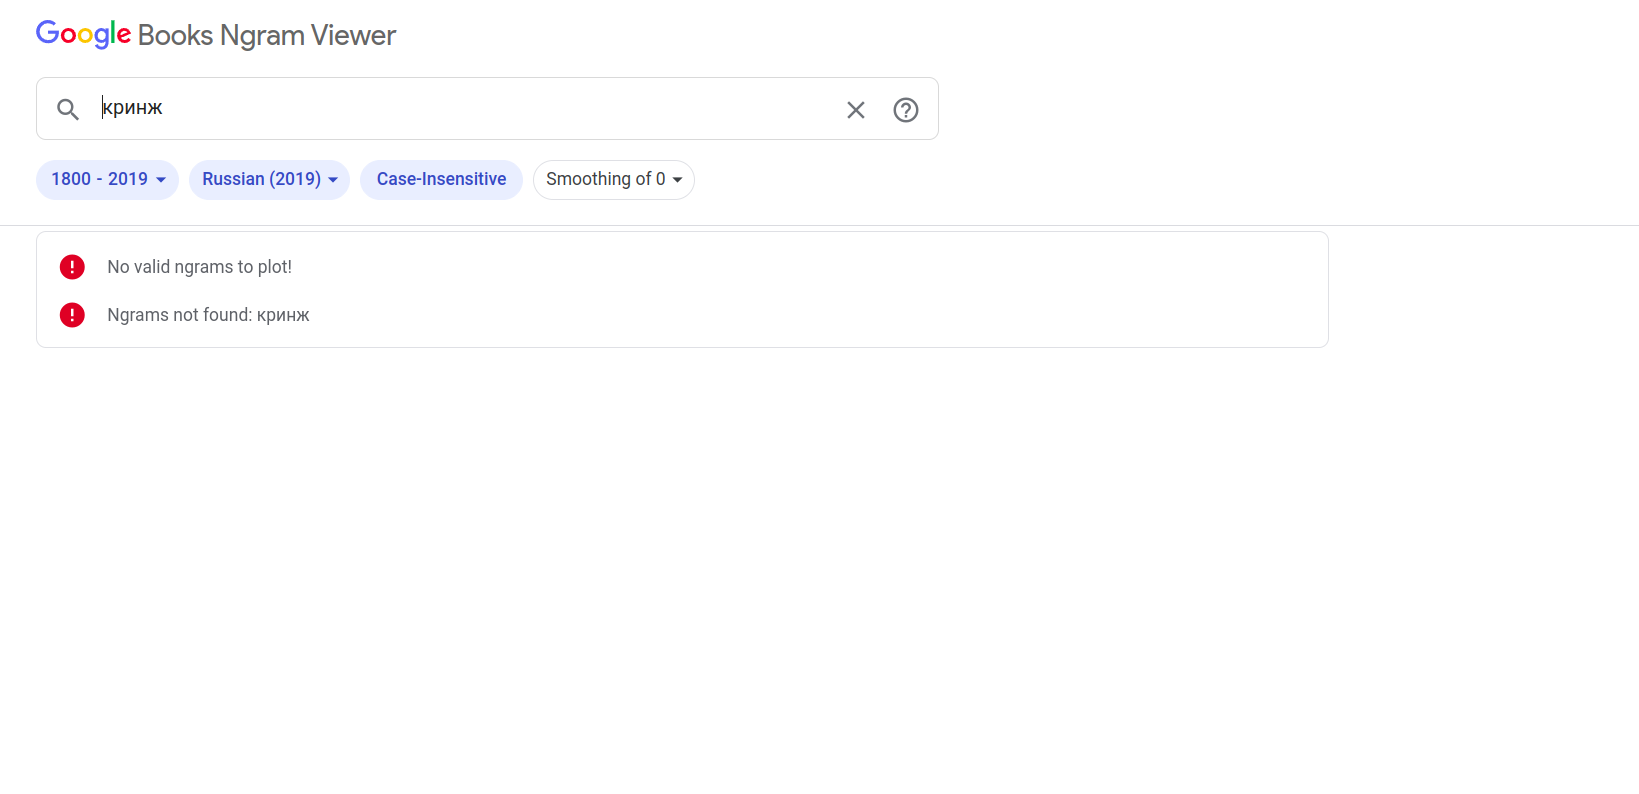

In [93]:
display.Image(b64decode(cringe))

In [74]:
print('Livejournal: 1187')

Livejournal: 1187


Вывод: Google Books Ngram ближе к литературному языку, чем к "живой" речи. Поэтому результаты Google Books Ngram могут отличаться от того, как люди говорят "в среднем". Особенно это заметно на примере ноль/нуль.